### Test First Ray

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Build one ray + spectrum from saved endpoints (ckpc/h) using yt + trident.

- Reads rays_and_recipes_sid<SID>_snap<SNAP>/rays_sid<SID>.csv (absolute ckpc/h)
- Picks the FIRST row (optionally filter by mode="noflip"/"flip")
- Creates a trident ray (start/end in code_length)
- Ensures H I, C II, Si III ion number density fields exist
- Computes integrated columns (sum n_ion * dl); uses native dl if present,
  else geometric fallback from ordered cell centers along the segment
- Synthesizes spectra for ["H I 1216", "C II 1334/1335", "Si III 1206"] with COS-G130M LSF
- Saves figures + a compact HDF5 bundle (meta, spectra, and a FULL dump of ray fields)
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- YOUR LOCAL PATHS ---
# =======================
CUTOUT_H5 = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

OUTROOT   = f"rays_and_recipes_sid{SID}_snap{SNAP}"
RAYS_CSV  = os.path.join(OUTROOT, f"rays_sid{SID}.csv")
OUT_DIR   = os.path.join(OUTROOT, "ray_and_spectrum")

# Optional filter (set to None to use the very first row)
FILTER_MODE = None        # "noflip" | "flip" | None

# Lines & instrument (C II is 1334/1335 multiplet name variation is OK)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

# Zoom windows (Å) for the zoom PNG
ZOOMS_A = {
    "Lyα 1215.67": 1215.67,
    "Si III 1206.50": 1206.50,
    "C II 1334.53": 1334.53,
}
ZOOM_HALF_A = 3.0


# -----------------------
# Utility helpers
# -----------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def pick_row(rays_csv, row=0, mode=None):
    """
    Expect columns:
      p0_X_ckpch_abs ... p0_Z_ckpch_abs, p1_X_ckpch_abs ... p1_Z_ckpch_abs,
      mode, alpha_deg, SubhaloID, rho_kpc, phi_deg, inc_deg, Rvir_kpc
    """
    df = pd.read_csv(rays_csv)
    print(f"[INFO] Loaded rays CSV: {rays_csv}  (rows={len(df)})")
    if mode is not None:
        df = df[df["mode"].str.lower() == str(mode).lower()]
        print(f"[INFO] Filtered by mode='{mode}'  -> remaining rows={len(df)})")
        if df.empty:
            raise RuntimeError(f"No rows after mode filter: {mode}")
    row = df.iloc[row]
    p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
    p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)
    meta = {
        "SubhaloID": int(row.get("SubhaloID", -1)),
        "alpha_deg": float(row.get("alpha_deg", np.nan)),
        "mode":      str(row.get("mode", "unknown")),
        "rho_kpc":   float(row.get("rho_kpc", np.nan)),
        "phi_deg":   float(row.get("phi_deg", np.nan)),
        "inc_deg":   float(row.get("inc_deg", np.nan)),
        "Rvir_kpc":  float(row.get("Rvir_kpc", np.nan)),
    }
    return p0, p1, meta

def add_ions(ds):
    """Add ion fields if not present. Trident won’t clobber existing ones."""
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields failed (fields may already exist):", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    """
    Build a ray with start/end in absolute *code_length* (ckpc/h).
    NOTE: do NOT request ('gas','dl') or ('gas','velocity_los') during build.
    """
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    # Domain sanity
    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
        # Positions are auto on the ray; velocities & path-length stuff are derived by Trident
    ]

    ray = trident.make_simple_ray(
        ds,
        start_position=sp,
        end_position=ep,
        fields=fields,
        ftype="gas"
    )

    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    """
    Try to obtain a per-cell path length in cm.
    1) Preferred: use ('gas','dl') if present on the final ray dataset.
    2) Fallback: approximate from ordered cell centers along the ray using p0/p1.
    """
    ad = ray.all_data()
    # Try native fields
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    # fallback: geometric approximation from ordered centers
    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints provided for approximation.")

    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0:
        raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L  # unit LOS in code_length

    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0:
        raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]

    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv

    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers (code_length→cm). Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    """Robust field grab: returns np.array or None."""
    try:
        return ad[fld].to(unit).value
    except Exception:
        try:
            arr = ad[fld]
            return arr.value  # native units
        except Exception:
            return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    """
    Integrate columns along the ray: sum(n_ion * dl) in cm^-2.
    Uses native dl if present else geometric approximation.
    """
    ad = ray.all_data()
    print(f"All the ray keys are: {ray.field_list}")
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)

    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}

    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        if n is not None:
            out[key] = float((n * dl_cm).sum())
        else:
            out[key] = np.nan

    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")

    print("=== Integrated columns (cm^-2) ===")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]
        lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN = {lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out

def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)
    sg.apply_lsf()  

    lam = np.array(sg.lambda_field)   # Å
    tau = np.array(sg.tau_field)      # dimensionless
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)

    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  instrument={instr}")
    return {
        "raw": {"lambda_A": lam, "flux": flux_raw, "tau": tau},
        "lsf": {"lambda_A": lam, "flux": flux_lsf, "tau": tau},
    }

# ---- Preferred unit targets for common field names (best effort) ----
PREFERRED_UNITS = {
    "dl": "cm",
    "l": "cm",
    "density": "g/cm**3",
    "H_number_density": "cm**-3",
    "H_nuclei_density": "cm**-3",
    "H_p0_number_density": "cm**-3",
    "C_p1_number_density": "cm**-3",
    "Si_p2_number_density": "cm**-3",
    "temperature": "K",
    "velocity_los": "km/s",
    "relative_velocity_x": "km/s",
    "relative_velocity_y": "km/s",
    "relative_velocity_z": "km/s",
    "x": "code_length",
    "y": "code_length",
    "z": "code_length",
    # redshift / metallicity usually dimensionless; leave native
}

def _save_dataset_with_unit(group, name, yt_array, preferred_units=None):
    """
    Create dataset at group[name] from a yt array, trying unit conversion.
    Saves attribute 'unit' as a string.
    """
    u_target = None if preferred_units is None else preferred_units.get(name, None)
    data = None
    unit_str = None
    try:
        if u_target is not None:
            arr = yt_array.to(u_target)
            data = arr.value
            unit_str = u_target
        else:
            data = yt_array.value
            unit_str = str(yt_array.units)
    except Exception:
        # last resort: raw values
        try:
            data = yt_array.value
            unit_str = str(yt_array.units)
        except Exception:
            # scalar / object? convert to numpy
            data = np.asarray(yt_array)
            unit_str = ""
    dset = group.create_dataset(name, data=np.asarray(data))
    dset.attrs["unit"] = unit_str
    return dset

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    # Full spectrum
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum")
    ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    # Zooms
    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1:
        axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - ZOOM_HALF_A) & (lam_r <= lam0 + ZOOM_HALF_A)
        ml = (lam_l >= lam0 - ZOOM_HALF_A) & (lam_l <= lam0 + ZOOM_HALF_A)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - ZOOM_HALF_A, lam0 + ZOOM_HALF_A)
        ax.set_title(name); ax.set_xlabel("λ [Å]")
        ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    """
    Save:
      - /meta      (attrs)
      - /columns   (attrs)
      - /spectrum/{raw,lsf}/{lambda_A,flux,tau}
      - /ray (convenience flat datasets like before)
      - /ray/fields/<ftype>/<name>  (FULL dump of every ray field, with 'unit' attr)
    """
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        # meta
        gmeta = f.create_group("meta")
        for k, v in meta.items():
            try: gmeta.attrs[k] = v
            except TypeError: gmeta.attrs[k] = json.dumps(v)

        # columns
        gcols = f.create_group("columns")
        for k, v in cols.items():
            gcols.attrs[k] = v if isinstance(v, (int,float,np.floating)) else json.dumps(v)

        # spectra
        gs = f.create_group("spectrum")
        for tag in ("raw","lsf"):
            gt = gs.create_group(tag)
            gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
            gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
            gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))

        # ---- FULL ray dump ----
        ad = ray.all_data()
        gray = f.create_group("ray")

        # (A) convenience datasets (backward compatible with your earlier tools)
        # dl used for columns:
        try:
            dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
            gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
            gray.attrs["dl_kind"] = kind
        except Exception:
            pass

        # common physicals in standard units
        convenience = [
            (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
            (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
            (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
            (("gas","density"),              "rho_cgs",    "g/cm**3"),
            (("gas","temperature"),          "T_K",        "K"),
            (("gas","x"),                    "x_code",     "code_length"),
            (("gas","y"),                    "y_code",     "code_length"),
            (("gas","z"),                    "z_code",     "code_length"),
            (("gas","velocity_los"),         "vlos_km_s",  "km/s"),
        ]
        for fld, name, unit in convenience:
            try:
                arr = ad[fld].to(unit).value if unit else ad[fld].value
                ds = gray.create_dataset(name, data=np.asarray(arr))
                if unit: ds.attrs["unit"] = unit
            except Exception:
                pass

        # Also store a cell index for plotting
        try:
            N = int(gray["dl_cm"].size)
        except Exception:
            # fall back to any 1D field
            N = None
            for (ft,fname) in ray.field_list:
                try:
                    a = ad[(ft,fname)]
                    if a.ndim == 1:
                        N = int(a.size); break
                except Exception:
                    continue
            if N is None: N = 0
        gray.create_dataset("cell_index", data=np.arange(N, dtype=np.int32))

        # (B) structured full dump under /ray/fields
        gfields = gray.create_group("fields")
        # create subgroups by ftype and fill datasets with units
        for ftype, fname in ray.field_list:
            try:
                arr = ad[(ftype, fname)]
            except Exception:
                continue
            g_ft = gfields.require_group(str(ftype))
            _save_dataset_with_unit(g_ft, str(fname), arr, preferred_units=PREFERRED_UNITS)

    print("[SAVED]", out_path)


# -----------------------
# Main
# -----------------------
def main():
    ensure_dir(OUT_DIR)
    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)

    add_ions(ds)

    p0, p1, meta = pick_row(RAYS_CSV,row = 200, mode=FILTER_MODE)
    
    
    
    
    print(f"[INFO] Picked sightline: sid={meta['SubhaloID']}  mode={meta['mode']}  alpha={meta['alpha_deg']} deg")
    print(f"[INFO] p0={p0}  p1={p1}   (units: ckpc/h)")

    ray = make_ray(ds, p0, p1)
    
    cols = compute_columns(ray, p0, p1)
    spec = build_spectrum(ray, LINES, instr=INSTR)

    # Outputs
    tag = f"sid{meta['SubhaloID']}_{meta['mode']}_alpha{int(meta['alpha_deg']) if np.isfinite(meta['alpha_deg']) else 'NA'}"
    save_spectrum_pngs(spec, OUT_DIR, tag=tag)

    bundle_path = os.path.join(OUT_DIR, f"{tag}_bundle.h5")
    meta_save = dict(meta)
    meta_save.update(dict(lines=LINES, instrument=INSTR,
                          start_ckpch=p0.tolist(), end_ckpch=p1.tolist()))
    save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

    # Tiny CSV summary
    sum_csv = os.path.join(OUT_DIR, f"{tag}_summary.csv")
    row = dict(meta_save); row.update(cols)
    pd.DataFrame([row]).to_csv(sum_csv, index=False)
    print("[SAVED]", sum_csv)

    print("\n[DONE] One ray + spectra created.")
    print("      OUT_DIR =", OUT_DIR)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

yt : [INFO     ] 2025-10-16 10:59:00,100 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-16 10:59:00,118 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 10:59:00,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 10:59:00,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-16 10:59:00,119 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-16 10:59:00,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 10:59:00,120 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 10:59:00,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 10:59:00,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 10:59:00,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 10:59:00,121 Parameters: hubble_con

[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 8609.81it/s]
yt : [WARNING  ] 2025-10-16 10:59:00,511 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 10:59:00,512 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-16 10:59:00,524 Getting segment at z = 2.220446049250313e-16: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.
yt : [INFO     ] 2025-10-16 10:59:00,525 Getting subsegment: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99/rays_sid563732.csv  (rows=720)
[INFO] Picked sightline: sid=563732  mode=noflip  alpha=100.0 deg
[INFO] p0=[22990.550303   18008.28559688  8579.20438467]  p1=[23472.30239862 17903.3966507   8509.87413401]   (units: ckpc/h)
[RAY] Start (code_length): [22990.550303   18008.28559688  8579.20438467] code_length
[RAY] End   (code_length): [23472.30239862 17903.3966507   8509.87413401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 10:59:01,211 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 10:59:01,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 10:59:01,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 10:59:01,223 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 10:59:01,223 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 10:59:01,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 10:59:01,223 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 10:59:01,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 10:59:01,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 10:59:01,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 10:59:01,224 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
All the ray keys are: [('all', 'C_p1_number_density'), ('all', 'H_nuclei_density'), ('all', 'H_number_density'), ('all', 'H_p0_number_density'), ('all', 'Si_p2_number_density'), ('all', 'density'), ('all', 'dl'), ('all', 'l'), ('all', 'metallicity'), ('all', 'redshift'), ('all', 'redshift_dopp'), ('all', 'redshift_eff'), ('all', 'relative_velocity_x'), ('all', 'relative_velocity_y'), ('all', 'relative_velocity_z'), ('all', 'temperature'), ('all', 'velocity_los'), ('all', 'x'), ('all', 'y'), ('all', 'z'), ('gas', 'C_p1_number_density'), ('gas', 'H_nuclei_density'), ('gas', 'H_number_density'), ('gas', 'H_p0_number_density'), ('gas', 'Si_p2_number_density'), ('gas', 'density'), ('gas', 'dl'), ('gas', 'l'), ('gas', 'metallicity'), ('gas', 'redshift'), ('gas', 'redshift_dopp'), ('gas', 'redshift_eff'), ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z'), ('gas', 'temperature'), ('gas', 'vel

Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 26871.47it/s]
yt : [INFO     ] 2025-10-16 10:59:01,367 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 10:59:01,367 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha100_spectrum_full.png
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha100_spectrum_zooms.png
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha100_bundle.h5
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha100_summary.csv

[DONE] One ray + spectra created.
      OUT_DIR = rays_and_recipes_sid563732_snap99/ray_and_spectrum


### Creating rays and spectrum for $4R_{vir}$ length sightlines 

yt : [INFO     ] 2025-10-16 11:09:24,229 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-16 11:09:24,247 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:24,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:24,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-16 11:09:24,248 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-16 11:09:24,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:24,249 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:24,249 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:24,249 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:24,249 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:24,250 Parameters: hubble_con

[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 8563.84it/s]
yt : [WARNING  ] 2025-10-16 11:09:24,485 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 11:09:24,486 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-16 11:09:24,528 Getting segment at z = 2.220446049250313e-16: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.
yt : [INFO     ] 2025-10-16 11:09:24,529 Getting subsegment: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99_L4Rvir/rays_sid563732.csv  (rows=720)

[1/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha0 ...
[RAY] Start (code_length): [23294.08609838 17883.18596151  8336.31193466] code_length
[RAY] End   (code_length): [23377.48633527 18228.36164033  8897.20196769] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:25,369 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:25,381 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:25,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:25,381 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:25,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:25,383 Parameters: h

[RAY] N segments: 426 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.367e+13 cm, max=5.218e+22 cm)
N_HI_cm2  : 1.585934e+13   (logN=13.200)
N_CII_cm2 : 3.743642e+07   (logN=7.573)
N_SiIII_cm2: 1.505718e+06   (logN=6.178)
[DL] kind=native | Σdl ≈ 966.391 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 426/426 [00:00<00:00, 29806.88it/s]
yt : [INFO     ] 2025-10-16 11:09:25,529 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:25,529 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:09:25,739 Getting segment at z = 2.220446049250313e-16: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.
yt : [INFO     ] 2025-10-16 11:09:25,739 Getting subsegment: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_bundle.h5

[2/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha0 ...
[RAY] Start (code_length): [23248.26403413 18047.54759594  9039.32087784] code_length
[RAY] End   (code_length): [23498.21686792 17795.30677919  8478.43084481] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:26,382 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:26,394 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:26,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:26,394 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:26,394 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:26,395 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:26,395 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:26,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:26,395 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:26,395 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:26,396 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.676e+11 cm, max=5.895e+22 cm)
N_HI_cm2  : 3.486897e+13   (logN=13.542)
N_CII_cm2 : 1.304417e+09   (logN=9.115)
N_SiIII_cm2: 3.584901e+07   (logN=7.554)
[DL] kind=native | Σdl ≈ 1025.422 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 15211.73it/s]
yt : [INFO     ] 2025-10-16 11:09:26,554 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:26,554 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:09:26,766 Getting segment at z = 2.220446049250313e-16: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.
yt : [INFO     ] 2025-10-16 11:09:26,767 Getting subsegment: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_bundle.h5

[3/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha1 ...
[RAY] Start (code_length): [23288.85496397 17881.52713783  8336.10758599] code_length
[RAY] End   (code_length): [23383.23832616 18227.54431122  8894.7339142 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:27,400 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:27,411 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:27,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:27,412 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:27,412 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:27,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:27,413 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:27,413 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:27,413 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:27,413 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:27,413 Parameters: h

[RAY] N segments: 431 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.702e+13 cm, max=5.624e+22 cm)
N_HI_cm2  : 2.219076e+13   (logN=13.346)
N_CII_cm2 : 1.275101e+08   (logN=8.106)
N_SiIII_cm2: 2.477965e+06   (logN=6.394)
[DL] kind=native | Σdl ≈ 1054.740 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 431/431 [00:00<00:00, 31110.09it/s]
yt : [INFO     ] 2025-10-16 11:09:27,531 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:27,531 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:09:27,733 Getting segment at z = 2.220446049250313e-16: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.
yt : [INFO     ] 2025-10-16 11:09:27,733 Getting subsegment: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_bundle.h5

[4/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha1 ...
[RAY] Start (code_length): [23242.92919607 18046.26075246  9039.52522651] code_length
[RAY] End   (code_length): [23502.71636158 17798.98209998  8480.8988983 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:28,500 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:28,511 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:28,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:28,511 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:28,511 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:28,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:28,512 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:28,512 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:28,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:28,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:28,513 Parameters: h

[RAY] N segments: 507 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.945e+11 cm, max=6.681e+22 cm)
N_HI_cm2  : 3.670154e+13   (logN=13.565)
N_CII_cm2 : 2.781820e+09   (logN=9.444)
N_SiIII_cm2: 4.647317e+07   (logN=7.667)
[DL] kind=native | Σdl ≈ 979.882 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 507/507 [00:00<00:00, 30656.85it/s]
yt : [INFO     ] 2025-10-16 11:09:28,649 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:28,649 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:09:28,849 Getting segment at z = 2.220446049250313e-16: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.
yt : [INFO     ] 2025-10-16 11:09:28,850 Getting subsegment: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_bundle.h5

[5/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha2 ...
[RAY] Start (code_length): [23283.60224646 17879.93057145  8335.97284111] code_length
[RAY] End   (code_length): [23388.94948615 18226.64975501  8892.19873474] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:29,495 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:29,507 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:29,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:29,507 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:29,507 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:29,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:29,508 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:29,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:29,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:29,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:29,509 Parameters: h

[RAY] N segments: 451 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.491e+13 cm, max=4.714e+22 cm)
N_HI_cm2  : 2.231057e+13   (logN=13.349)
N_CII_cm2 : 2.230340e+08   (logN=8.348)
N_SiIII_cm2: 3.556208e+06   (logN=6.551)
[DL] kind=native | Σdl ≈ 999.178 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 451/451 [00:00<00:00, 30768.24it/s]
yt : [INFO     ] 2025-10-16 11:09:29,657 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:29,658 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:09:29,864 Getting segment at z = 2.220446049250313e-16: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.
yt : [INFO     ] 2025-10-16 11:09:29,864 Getting subsegment: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_bundle.h5

[6/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha2 ...
[RAY] Start (code_length): [23237.60809771 18044.90946504  9039.65997139] code_length
[RAY] End   (code_length): [23507.14095898 17802.70238452  8483.43407776] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:09:30,547 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:09:30,559 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:09:30,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:09:30,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:09:30,559 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:09:30,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:09:30,560 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:09:30,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:09:30,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:09:30,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:09:30,561 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.959e+11 cm, max=6.124e+22 cm)
N_HI_cm2  : 3.868533e+13   (logN=13.588)
N_CII_cm2 : 1.911276e+09   (logN=9.281)
N_SiIII_cm2: 3.881395e+07   (logN=7.589)
[DL] kind=native | Σdl ≈ 979.679 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 29513.53it/s]
yt : [INFO     ] 2025-10-16 11:09:30,701 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:09:30,702 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=2/L4Rvir_sid563732_flip_alpha2_spectrum_full.png


KeyboardInterrupt: 

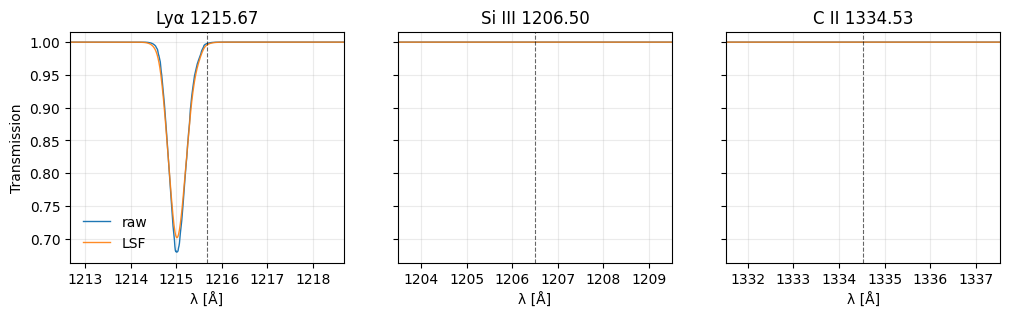

In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch: build rays + spectra for *all* rows in rays_sid<SID>.csv for a given RUN_LABEL.

Outputs live under:
  /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/
      rays_and_spectra_sid<SID>_snap<SNAP>_<RUN_LABEL>/
        summary_all_rays.csv
        rays/mode=.../alpha=.../*_bundle.h5
        rays/mode=.../alpha=.../*_spectrum_full.png
        rays/mode=.../alpha=.../*_spectrum_zooms.png
        logs/errors.txt (if any)
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- LOCAL PATHS ---
# =======================
CUTOUT_H5 = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

# === Choose which length-variant to process ===
#     Must match the generator's OUTROOT suffix
RUN_LABEL = "L4Rvir"   # or "L3Rvir"

# Rays CSV produced by the matching generator:
RAYS_CSV = f"rays_and_recipes_sid{SID}_snap{SNAP}_{RUN_LABEL}/rays_sid{SID}.csv"

# === All outputs are saved inside this base directory ===
OUTPUT_BASE = r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"
JOB_ROOT    = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN_LABEL}")
RAYS_DIR    = os.path.join(JOB_ROOT, "rays")
LOGS_DIR    = os.path.join(JOB_ROOT, "logs")
MASTER_CSV  = os.path.join(JOB_ROOT, "summary_all_rays.csv")

# Optional filter
FILTER_MODE = None        # "noflip" | "flip" | None

# Lines & instrument (keep consistent with earlier)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

ZOOMS_A = {"Lyα 1215.67": 1215.67, "Si III 1206.50": 1206.50, "C II 1334.53": 1334.532}
ZOOM_HALF_A = 3.0

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def add_ions(ds):
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields:", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
    ]
    ray = trident.make_simple_ray(ds, start_position=sp, end_position=ep, fields=fields, ftype="gas")
    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    ad = ray.all_data()
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints for approximation.")
    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0: raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L
    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0: raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]
    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv
    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers. Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    try:    return ad[fld].to(unit).value
    except Exception: return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    ad = ray.all_data()
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)
    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}
    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        out[key] = float((n * dl_cm).sum()) if n is not None else np.nan
    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]; lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN={lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out



PREFERRED_UNITS = {
    "dl": "cm",
    "l": "cm",
    "density": "g/cm**3",
    "metallicity": "",  # keep native (dimensionless)
    "H_number_density": "cm**-3",
    "H_nuclei_density": "cm**-3",
    "H_p0_number_density": "cm**-3",
    "C_p1_number_density": "cm**-3",
    "Si_p2_number_density": "cm**-3",
    "temperature": "K",
    "velocity_los": "km/s",
    "relative_velocity_x": "km/s",
    "relative_velocity_y": "km/s",
    "relative_velocity_z": "km/s",
    "redshift": "",
    "redshift_dopp": "",
    "redshift_eff": "",
    "x": "code_length",
    "y": "code_length",
    "z": "code_length",
}

def _save_dataset_with_unit(group, name, yt_array, preferred_units=None):
    u_target = None if preferred_units is None else preferred_units.get(name, None)
    try:
        if u_target:
            arr = yt_array.to(u_target)
            data = arr.value; unit_str = u_target
        else:
            data = yt_array.value
            unit_str = str(getattr(yt_array, "units", ""))
    except Exception:
        data = np.asarray(yt_array)
        unit_str = ""
    dset = group.create_dataset(name, data=np.asarray(data))
    dset.attrs["unit"] = unit_str
    return dset 


def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)

    sg.apply_lsf()

    lam = np.array(sg.lambda_field)
    tau = np.array(sg.tau_field)
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)
    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  {instr}")
    return {"raw":{"lambda_A":lam,"flux":flux_raw,"tau":tau}, "lsf":{"lambda_A":lam,"flux":flux_lsf,"tau":tau}}

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum"); ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1: axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - 3.0) & (lam_r <= lam0 + 3.0)
        ml = (lam_l >= lam0 - 3.0) & (lam_l <= lam0 + 3.0)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - 3.0, lam0 + 3.0)
        ax.set_title(name); ax.set_xlabel("λ [Å]"); ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    """
    Save:
      - /meta      (attrs)
      - /columns   (attrs)
      - /spectrum/{raw,lsf}/{lambda_A,flux,tau}
      - /ray (convenience flat datasets like before)
      - /ray/fields/<ftype>/<name>  (FULL dump of every ray field, with 'unit' attr)
    """
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        # meta
        gmeta = f.create_group("meta")
        for k, v in meta.items():
            try: gmeta.attrs[k] = v
            except TypeError: gmeta.attrs[k] = json.dumps(v)

        # columns
        gcols = f.create_group("columns")
        for k, v in cols.items():
            gcols.attrs[k] = v if isinstance(v, (int,float,np.floating)) else json.dumps(v)

        # spectra
        gs = f.create_group("spectrum")
        for tag in ("raw","lsf"):
            gt = gs.create_group(tag)
            gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
            gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
            gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))

        # ---- FULL ray dump ----
        ad = ray.all_data()
        gray = f.create_group("ray")

        # (A) convenience datasets (backward compatible with your earlier tools)
        # dl used for columns:
        try:
            dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
            gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
            gray.attrs["dl_kind"] = kind
        except Exception:
            pass

        # common physicals in standard units
        convenience = [
            (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
            (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
            (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
            (("gas","density"),              "rho_cgs",    "g/cm**3"),
            (("gas","temperature"),          "T_K",        "K"),
            (("gas","x"),                    "x_code",     "code_length"),
            (("gas","y"),                    "y_code",     "code_length"),
            (("gas","z"),                    "z_code",     "code_length"),
            (("gas","velocity_los"),         "vlos_km_s",  "km/s"),
        ]
        for fld, name, unit in convenience:
            try:
                arr = ad[fld].to(unit).value if unit else ad[fld].value
                ds = gray.create_dataset(name, data=np.asarray(arr))
                if unit: ds.attrs["unit"] = unit
            except Exception:
                pass

        # Also store a cell index for plotting
        try:
            N = int(gray["dl_cm"].size)
        except Exception:
            # fall back to any 1D field
            N = None
            for (ft,fname) in ray.field_list:
                try:
                    a = ad[(ft,fname)]
                    if a.ndim == 1:
                        N = int(a.size); break
                except Exception:
                    continue
            if N is None: N = 0
        gray.create_dataset("cell_index", data=np.arange(N, dtype=np.int32))

        # (B) structured full dump under /ray/fields
        gfields = gray.create_group("fields")
        # create subgroups by ftype and fill datasets with units
        for ftype, fname in ray.field_list:
            try:
                arr = ad[(ftype, fname)]
            except Exception:
                continue
            g_ft = gfields.require_group(str(ftype))
            _save_dataset_with_unit(g_ft, str(fname), arr, preferred_units=PREFERRED_UNITS)

    print("[SAVED]", out_path)


def main():
    ensure_dir(JOB_ROOT); ensure_dir(RAYS_DIR); ensure_dir(LOGS_DIR)

    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)
    add_ions(ds)

    df = pd.read_csv(RAYS_CSV)
    print(f"[INFO] Loaded rays CSV: {RAYS_CSV}  (rows={len(df)})")
    if FILTER_MODE is not None:
        df = df[df["mode"].astype(str).str.lower() == FILTER_MODE.lower()]
        print(f"[INFO] Filtered by mode='{FILTER_MODE}'  -> rows={len(df)}")
    if df.empty:
        raise RuntimeError("No rows to process after filtering.")

    summary_rows = []
    errors = 0

    for i, row in df.iterrows():
        try:
            sid   = int(row.get("SubhaloID", SID))
            mode  = str(row.get("mode", "unknown"))
            alpha = float(row.get("alpha_deg", np.nan))

            p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
            p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)

            rho_kpc  = float(row.get("rho_kpc", np.nan))
            phi_deg  = float(row.get("phi_deg", np.nan))
            inc_deg  = float(row.get("inc_deg", np.nan))
            rvir_kpc = float(row.get("Rvir_kpc", np.nan))
            total_len_Rvir = float(row.get("total_len_Rvir", np.nan))

            alpha_tag = f"{int(round(alpha))}" if np.isfinite(alpha) else "NA"
            tag = f"{RUN_LABEL}_sid{sid}_{mode}_alpha{alpha_tag}"

            out_dir = os.path.join(RAYS_DIR, f"mode={mode}", f"alpha={alpha_tag}")
            ensure_dir(out_dir)

            print(f"\n[{i+1}/{len(df)}] {RUN_LABEL} Processing {tag} ...")

            ray  = make_ray(ds, p0, p1)
            cols = compute_columns(ray, p0, p1)
            spec = build_spectrum(ray, LINES, instr=INSTR)

            save_spectrum_pngs(spec, out_dir, tag=tag)

            meta_save = dict(
                RUN_LABEL=RUN_LABEL,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                start_ckpch=p0.tolist(), end_ckpch=p1.tolist(),
                lines=LINES, instrument=INSTR
            )
            bundle_path = os.path.join(out_dir, f"{tag}_bundle.h5")
            save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

            srow = dict(
                RUN_LABEL=RUN_LABEL,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                out_dir=out_dir, bundle_h5=bundle_path,
                dl_kind=cols.get("_dl_kind"), sum_dl_kpc=cols.get("_sum_dl_kpc"),
                N_HI_cm2=cols.get("N_HI_cm2"), N_CII_cm2=cols.get("N_CII_cm2"), N_SiIII_cm2=cols.get("N_SiIII_cm2")
            )
            summary_rows.append(srow)

        except Exception as e:
            errors += 1
            msg = f"[ERROR] {RUN_LABEL} row {i} (mode={row.get('mode')}, alpha={row.get('alpha_deg')}): {e}"
            print(msg)
            with open(os.path.join(LOGS_DIR, "errors.txt"), "a") as f:
                f.write(msg + "\n")

    if summary_rows:
        pd.DataFrame(summary_rows).to_csv(MASTER_CSV, index=False)
        print(f"\n[OK] Wrote master summary: {MASTER_CSV}  (rows={len(summary_rows)}, errors={errors})")
    else:
        print("\n[WARN] No successful rays to summarize.", f"errors={errors}")

    print("\n[DONE] Batch finished.")
    print("      All outputs under:", JOB_ROOT)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

### Running both the cases of LOS in one go

In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch: build rays + spectra for *all* rows in rays_sid<SID>.csv for BOTH RUN_LABELS.

Per run (L3Rvir and L4Rvir):
  - Per-ray bundles + PNGs under:
      <OUTPUT_BASE>/rays_and_spectra_sid<SID>_snap<SNAP>_<RUN_LABEL>/
  - A combined HDF5 collecting ALL rays for that run at:
      <JOB_ROOT>/combined/all_rays_<RUN_LABEL>.h5
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- LOCAL PATHS ---
# =======================
CUTOUT_H5 = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

# Run BOTH sightline-length variants in one go
RUN_LABELS = ["L3Rvir", "L4Rvir"]  # processed in this order

# === All outputs are saved inside this base directory ===
OUTPUT_BASE = r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"

# Optional filter
FILTER_MODE = None        # "noflip" | "flip" | None  (None = process both)

# Lines & instrument (keep consistent with earlier)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

ZOOMS_A = {"Lyα 1215.67": 1215.67, "Si III 1206.50": 1206.50, "C II 1334.53": 1334.532}
ZOOM_HALF_A = 3.0

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def add_ions(ds):
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields:", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
    ]
    ray = trident.make_simple_ray(ds, start_position=sp, end_position=ep, fields=fields, ftype="gas")
    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    ad = ray.all_data()
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints for approximation.")
    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0: raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L
    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0: raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]
    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv
    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers. Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    try:    return ad[fld].to(unit).value
    except Exception: return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    ad = ray.all_data()
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)
    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}
    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        out[key] = float((n * dl_cm).sum()) if n is not None else np.nan
    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]; lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN={lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out

PREFERRED_UNITS = {
    "dl": "cm",
    "l": "cm",
    "density": "g/cm**3",
    "metallicity": "",  # keep native (dimensionless)
    "H_number_density": "cm**-3",
    "H_nuclei_density": "cm**-3",
    "H_p0_number_density": "cm**-3",
    "C_p1_number_density": "cm**-3",
    "Si_p2_number_density": "cm**-3",
    "temperature": "K",
    "velocity_los": "km/s",
    "relative_velocity_x": "km/s",
    "relative_velocity_y": "km/s",
    "relative_velocity_z": "km/s",
    "redshift": "",
    "redshift_dopp": "",
    "redshift_eff": "",
    "x": "code_length",
    "y": "code_length",
    "z": "code_length",
}

def _save_dataset_with_unit(group, name, yt_array, preferred_units=None):
    u_target = None if preferred_units is None else preferred_units.get(name, None)
    try:
        if u_target:
            arr = yt_array.to(u_target)
            data = arr.value; unit_str = u_target
        else:
            data = yt_array.value
            unit_str = str(getattr(yt_array, "units", ""))
    except Exception:
        data = np.asarray(yt_array)
        unit_str = ""
    dset = group.create_dataset(name, data=np.asarray(data))
    dset.attrs["unit"] = unit_str
    return dset

def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)
    # Apply instrument LSF explicitly (instrument selection doesn't auto-apply)
    sg.apply_lsf()

    lam = np.array(sg.lambda_field)
    tau = np.array(sg.tau_field)
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)
    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  {instr}")
    return {"raw":{"lambda_A":lam,"flux":flux_raw,"tau":tau}, "lsf":{"lambda_A":lam,"flux":flux_lsf,"tau":tau}}

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum"); ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1: axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - ZOOM_HALF_A) & (lam_r <= lam0 + ZOOM_HALF_A)
        ml = (lam_l >= lam0 - ZOOM_HALF_A) & (lam_l <= lam0 + ZOOM_HALF_A)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - ZOOM_HALF_A, lam0 + ZOOM_HALF_A)
        ax.set_title(name); ax.set_xlabel("λ [Å]"); ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def _write_ray_pack_into_group(groot, meta, ray, spec, cols):
    """
    Write the SAME structure as per-ray bundle, but under an existing group.
    Creates subgroups: meta (attrs), columns (attrs), spectrum/{raw,lsf}, ray, ray/fields/<ftype>/<name>.
    """
    # meta
    gmeta = groot.create_group("meta")
    for k, v in meta.items():
        try: gmeta.attrs[k] = v
        except TypeError: gmeta.attrs[k] = json.dumps(v)

    # columns
    gcols = groot.create_group("columns")
    for k, v in cols.items():
        gcols.attrs[k] = v if isinstance(v, (int,float,np.floating)) else json.dumps(v)

    # spectra
    gs = groot.create_group("spectrum")
    for tag in ("raw","lsf"):
        gt = gs.create_group(tag)
        gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
        gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
        gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))

    # ray + fields
    ad = ray.all_data()
    gray = groot.create_group("ray")

    # dl used for columns
    try:
        dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
        gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
        gray.attrs["dl_kind"] = kind
    except Exception:
        pass

    # convenience datasets
    convenience = [
        (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
        (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
        (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
        (("gas","density"),              "rho_cgs",    "g/cm**3"),
        (("gas","temperature"),          "T_K",        "K"),
        (("gas","x"),                    "x_code",     "code_length"),
        (("gas","y"),                    "y_code",     "code_length"),
        (("gas","z"),                    "z_code",     "code_length"),
        (("gas","velocity_los"),         "vlos_km_s",  "km/s"),
    ]
    for fld, name, unit in convenience:
        try:
            arr = ad[fld].to(unit).value if unit else ad[fld].value
            ds = gray.create_dataset(name, data=np.asarray(arr))
            if unit: ds.attrs["unit"] = unit
        except Exception:
            pass

    # cell index
    try:
        N = int(gray["dl_cm"].size)
    except Exception:
        N = None
        for (ft,fname) in ray.field_list:
            try:
                a = ad[(ft,fname)]
                if a.ndim == 1:
                    N = int(a.size); break
            except Exception:
                continue
        if N is None: N = 0
    gray.create_dataset("cell_index", data=np.arange(N, dtype=np.int32))

    # full fields
    gfields = gray.create_group("fields")
    seen = set()
    for ftype, fname in ray.field_list:
        key = (str(ftype), str(fname))
        if key in seen: continue
        seen.add(key)
        try:
            arr = ad[(ftype, fname)]
        except Exception:
            continue
        g_ft = gfields.require_group(str(ftype))
        _save_dataset_with_unit(g_ft, str(fname), arr, preferred_units=PREFERRED_UNITS)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        _write_ray_pack_into_group(f, meta, ray, spec, cols)
    print("[SAVED]", out_path)

def append_to_combined(agg_path, group_path, meta, ray, spec, cols):
    """
    Append one ray pack under group_path inside the combined HDF5.
    Example group_path: "rays/mode=noflip/alpha=0/ray_0001"
    """
    ensure_dir(os.path.dirname(agg_path))
    with h5py.File(agg_path, "a") as f:
        # Add some globals once
        if "globals" not in f:
            g = f.create_group("globals")
            g.attrs["SID"]  = int(meta.get("SubhaloID", SID))
            g.attrs["SNAP"] = int(SNAP)
            g.attrs["instrument"] = meta.get("instrument", INSTR)
            g.attrs["lines"] = json.dumps(meta.get("lines", LINES))
        # create the target group
        base = f.require_group(group_path)
        _write_ray_pack_into_group(base, meta, ray, spec, cols)
    print("[APPEND]", agg_path, "::", group_path)

def process_run(run_label):
    # Paths for this RUN_LABEL
    RAYS_CSV = f"rays_and_recipes_sid{SID}_snap{SNAP}_{run_label}/rays_sid{SID}.csv"
    JOB_ROOT = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{run_label}")
    RAYS_DIR = os.path.join(JOB_ROOT, "rays")
    LOGS_DIR = os.path.join(JOB_ROOT, "logs")
    MASTER_CSV = os.path.join(JOB_ROOT, "summary_all_rays.csv")
    COMBINED_DIR = os.path.join(JOB_ROOT, "combined")
    COMBINED_H5  = os.path.join(COMBINED_DIR, f"all_rays_{run_label}.h5")

    ensure_dir(JOB_ROOT); ensure_dir(RAYS_DIR); ensure_dir(LOGS_DIR); ensure_dir(COMBINED_DIR)

    print(f"\n===== PROCESSING RUN: {run_label} =====")
    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)
    add_ions(ds)

    df = pd.read_csv(RAYS_CSV)
    print(f"[INFO] Loaded rays CSV: {RAYS_CSV}  (rows={len(df)})")
    if FILTER_MODE is not None:
        df = df[df["mode"].astype(str).str.lower() == FILTER_MODE.lower()]
        print(f"[INFO] Filtered by mode='{FILTER_MODE}'  -> rows={len(df)}")
    if df.empty:
        raise RuntimeError("No rows to process after filtering.")

    summary_rows, errors = [], 0

    for i, row in df.iterrows():
        try:
            sid   = int(row.get("SubhaloID", SID))
            mode  = str(row.get("mode", "unknown"))
            alpha = float(row.get("alpha_deg", np.nan))

            p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
            p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)

            rho_kpc  = float(row.get("rho_kpc", np.nan))
            phi_deg  = float(row.get("phi_deg", np.nan))
            inc_deg  = float(row.get("inc_deg", np.nan))
            rvir_kpc = float(row.get("Rvir_kpc", np.nan))
            total_len_Rvir = float(row.get("total_len_Rvir", np.nan))

            alpha_tag = f"{int(round(alpha))}" if np.isfinite(alpha) else "NA"
            tag = f"{run_label}_sid{sid}_{mode}_alpha{alpha_tag}"

            out_dir = os.path.join(RAYS_DIR, f"mode={mode}", f"alpha={alpha_tag}")
            ensure_dir(out_dir)

            print(f"\n[{i+1}/{len(df)}] {run_label} Processing {tag} ...")

            ray  = make_ray(ds, p0, p1)
            cols = compute_columns(ray, p0, p1)
            spec = build_spectrum(ray, LINES, instr=INSTR)

            save_spectrum_pngs(spec, out_dir, tag=tag)

            meta_save = dict(
                RUN_LABEL=run_label,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                start_ckpch=p0.tolist(), end_ckpch=p1.tolist(),
                lines=LINES, instrument=INSTR
            )
            bundle_path = os.path.join(out_dir, f"{tag}_bundle.h5")
            save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

            # ---- NEW: append this ray into the combined HDF5 for this run
            grp_path = f"rays/mode={mode}/alpha={alpha_tag}/ray_{i:04d}"
            append_to_combined(COMBINED_H5, grp_path, meta_save, ray, spec, cols)

            # Row for summary CSV
            srow = dict(
                RUN_LABEL=run_label,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                out_dir=out_dir, bundle_h5=bundle_path,
                dl_kind=cols.get("_dl_kind"), sum_dl_kpc=cols.get("_sum_dl_kpc"),
                N_HI_cm2=cols.get("N_HI_cm2"), N_CII_cm2=cols.get("N_CII_cm2"), N_SiIII_cm2=cols.get("N_SiIII_cm2"),
                combined_h5=COMBINED_H5, group_path=grp_path
            )
            summary_rows.append(srow)

        except Exception as e:
            errors += 1
            msg = f"[ERROR] {run_label} row {i} (mode={row.get('mode')}, alpha={row.get('alpha_deg')}): {e}"
            print(msg)
            with open(os.path.join(LOGS_DIR, "errors.txt"), "a") as f:
                f.write(msg + "\n")

    if summary_rows:
        master_csv = os.path.join(JOB_ROOT, "summary_all_rays.csv")
        pd.DataFrame(summary_rows).to_csv(master_csv, index=False)
        print(f"\n[OK] Wrote master summary: {master_csv}  (rows={len(summary_rows)}, errors={errors})")
        print(f"[OK] Combined HDF5 for {run_label}: {COMBINED_H5}")
    else:
        print("\n[WARN] No successful rays to summarize.", f"errors={errors}")

    print("\n[DONE] Run finished:", run_label)
    print("      Per-ray outputs under:", JOB_ROOT)
    print("      Combined file:", COMBINED_H5)

def main():
    # Load dataset once and pass? We add ions per run anyway (cheap), but we can reuse ds.
    for run_label in RUN_LABELS:
        process_run(run_label)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

yt : [INFO     ] 2025-10-16 11:18:17,832 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-16 11:18:17,850 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:17,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:17,850 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-16 11:18:17,851 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-16 11:18:17,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:17,851 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:17,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:17,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:17,852 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:17,852 Parameters: hubble_con


===== PROCESSING RUN: L3Rvir =====
[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 7702.49it/s]
yt : [WARNING  ] 2025-10-16 11:18:18,091 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 11:18:18,092 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-16 11:18:18,107 Getting segment at z = 2.220446049250313e-16: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.
yt : [INFO     ] 2025-10-16 11:18:18,108 Getting subsegment: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99_L3Rvir/rays_sid563732.csv  (rows=720)

[1/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha0 ...
[RAY] Start (code_length): [23304.51112799 17926.33292137  8406.42318879] code_length
[RAY] End   (code_length): [23367.06130566 18185.21468047  8827.09071356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:18,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:19,007 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:19,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:19,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:19,008 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:19,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:19,008 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:19,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:19,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:19,009 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:19,009 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.367e+13 cm, max=5.218e+22 cm)
N_HI_cm2  : 1.120879e+13   (logN=13.050)
N_CII_cm2 : 1.108477e+07   (logN=7.045)
N_SiIII_cm2: 1.354366e+06   (logN=6.132)
[DL] kind=native | Σdl ≈ 767.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 29174.53it/s]
yt : [INFO     ] 2025-10-16 11:18:19,118 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:19,119 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=0/L3Rvir_sid563732_noflip_alpha0_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=0/L3Rvir_sid563732_noflip_alpha0_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=0/L3Rvir_sid563732_noflip_alpha0_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:19,339 Getting segment at z = 2.220446049250313e-16: [0.6651288  0.51474336 0.25626313] unitary to [0.67048494 0.5093382  0.24424406] unitary.
yt : [INFO     ] 2025-10-16 11:18:19,339 Getting subsegment: [0.6651288  0.51474336 0.25626313] unitary to [0.67048494 0.5093382  0.24424406] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=0/ray_0000

[2/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha0 ...
[RAY] Start (code_length): [23279.50813835 18016.01749385  8969.20962371] code_length
[RAY] End   (code_length): [23466.97276369 17826.83688128  8548.54209894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:20,066 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:20,078 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:20,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:20,078 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:20,078 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:20,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:20,079 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:20,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:20,079 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:20,080 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:20,080 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.676e+11 cm, max=4.578e+22 cm)
N_HI_cm2  : 3.306685e+13   (logN=13.519)
N_CII_cm2 : 1.304143e+09   (logN=9.115)
N_SiIII_cm2: 3.584421e+07   (logN=7.554)
[DL] kind=native | Σdl ≈ 771.053 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 28035.24it/s]
yt : [INFO     ] 2025-10-16 11:18:20,236 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:20,236 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=0/L3Rvir_sid563732_flip_alpha0_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=0/L3Rvir_sid563732_flip_alpha0_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:20,457 Getting segment at z = 2.220446049250313e-16: [0.66573294 0.51213655 0.2401696 ] unitary to [0.66775544 0.5195512  0.25214016] unitary.
yt : [INFO     ] 2025-10-16 11:18:20,457 Getting subsegment: [0.66573294 0.51213655 0.2401696 ] unitary to [0.66775544 0.5195512  0.25214016] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=0/L3Rvir_sid563732_flip_alpha0_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=0/ray_0001

[3/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha1 ...
[RAY] Start (code_length): [23300.65288424 17924.77928451  8405.93587702] code_length
[RAY] End   (code_length): [23371.44040589 18184.29216454  8824.90562318] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:21,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:21,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:21,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:21,131 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:21,131 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:21,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:21,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:21,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:21,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:21,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:21,133 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.702e+13 cm, max=5.624e+22 cm)
N_HI_cm2  : 1.226898e+13   (logN=13.089)
N_CII_cm2 : 1.476224e+07   (logN=7.169)
N_SiIII_cm2: 1.569230e+06   (logN=6.196)
[DL] kind=native | Σdl ≈ 809.636 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 28928.01it/s]
yt : [INFO     ] 2025-10-16 11:18:21,240 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:21,241 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=1/L3Rvir_sid563732_noflip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:21,479 Getting segment at z = 2.220446049250313e-16: [0.6650115  0.51472431 0.25627706] unitary to [0.67057837 0.50942548 0.24430649] unitary.
yt : [INFO     ] 2025-10-16 11:18:21,480 Getting subsegment: [0.6650115  0.51472431 0.25627706] unitary to [0.67057837 0.50942548 0.24430649] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=1/L3Rvir_sid563732_noflip_alpha1_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=1/L3Rvir_sid563732_noflip_alpha1_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=1/ray_0002

[4/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha1 ...
[RAY] Start (code_length): [23275.40259176 18015.3509209   8969.69693548] code_length
[RAY] End   (code_length): [23470.24296589 17829.89193154  8550.72718932] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:22,142 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:22,154 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:22,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:22,154 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:22,154 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:22,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:22,155 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:22,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:22,156 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:22,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:22,156 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.945e+11 cm, max=3.518e+22 cm)
N_HI_cm2  : 3.493422e+13   (logN=13.543)
N_CII_cm2 : 2.781543e+09   (logN=9.444)
N_SiIII_cm2: 4.646693e+07   (logN=7.667)
[DL] kind=native | Σdl ≈ 734.796 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 26772.15it/s]
yt : [INFO     ] 2025-10-16 11:18:22,285 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:22,285 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=1/L3Rvir_sid563732_flip_alpha1_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=1/L3Rvir_sid563732_flip_alpha1_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:22,508 Getting segment at z = 2.220446049250313e-16: [0.66562202 0.51209344 0.24015717] unitary to [0.66787946 0.51952314 0.2520763 ] unitary.
yt : [INFO     ] 2025-10-16 11:18:22,509 Getting subsegment: [0.66562202 0.51209344 0.24015717] unitary to [0.66787946 0.51952314 0.2520763 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=1/L3Rvir_sid563732_flip_alpha1_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=1/ray_0003

[5/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha2 ...
[RAY] Start (code_length): [23296.77065142 17923.27046939  8405.50107781] code_length
[RAY] End   (code_length): [23375.78108118 18183.30985706  8822.67049803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:23,184 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:23,195 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:23,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:23,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:23,195 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:23,196 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:23,196 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:23,196 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:23,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:23,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:23,197 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.461e+14 cm, max=4.714e+22 cm)
N_HI_cm2  : 1.255391e+13   (logN=13.099)
N_CII_cm2 : 2.229787e+07   (logN=7.348)
N_SiIII_cm2: 1.690213e+06   (logN=6.228)
[DL] kind=native | Σdl ≈ 784.245 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 28107.17it/s]
yt : [INFO     ] 2025-10-16 11:18:23,304 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:23,304 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=2/L3Rvir_sid563732_noflip_alpha2_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:23,663 Getting segment at z = 2.220446049250313e-16: [0.66489428 0.51470382 0.25628948] unitary to [0.67066998 0.50951366 0.24437035] unitary.
yt : [INFO     ] 2025-10-16 11:18:23,663 Getting subsegment: [0.66489428 0.51470382 0.25628948] unitary to [0.67066998 0.50951366 0.24437035] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=2/L3Rvir_sid563732_noflip_alpha2_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=2/L3Rvir_sid563732_noflip_alpha2_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=2/ray_0004

[6/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha2 ...
[RAY] Start (code_length): [23271.29970537 18014.63357997  8970.13173469] code_length
[RAY] End   (code_length): [23473.44935132 17832.97826958  8552.96231447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:24,324 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:24,335 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:24,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:24,336 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:24,336 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:24,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:24,337 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:24,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:24,337 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:24,338 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:24,338 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.959e+11 cm, max=4.988e+22 cm)
N_HI_cm2  : 3.698201e+13   (logN=13.568)
N_CII_cm2 : 1.911090e+09   (logN=9.281)
N_SiIII_cm2: 3.880801e+07   (logN=7.589)
[DL] kind=native | Σdl ≈ 740.417 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 25869.27it/s]
yt : [INFO     ] 2025-10-16 11:18:24,495 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:24,496 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=2/L3Rvir_sid563732_flip_alpha2_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=2/L3Rvir_sid563732_flip_alpha2_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=2/L3Rvir_sid563732_flip_alpha2_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:24,716 Getting segment at z = 2.220446049250313e-16: [0.66551045 0.51205163 0.24014625] unitary to [0.66800234 0.51949337 0.25201103] unitary.
yt : [INFO     ] 2025-10-16 11:18:24,717 Getting subsegment: [0.66551045 0.51205163 0.24014625] unitary to [0.66800234 0.51949337 0.25201103] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=2/ray_0005

[7/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha3 ...
[RAY] Start (code_length): [23292.86561209 17921.80693562  8405.1189236 ] code_length
[RAY] End   (code_length): [23380.08200934 18182.26805725  8820.38601897] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:25,400 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:25,411 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:25,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:25,412 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:25,412 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:25,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:25,413 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:25,413 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:25,413 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:25,413 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:25,413 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+12 cm, max=4.865e+22 cm)
N_HI_cm2  : 1.231667e+13   (logN=13.090)
N_CII_cm2 : 3.015959e+07   (logN=7.479)
N_SiIII_cm2: 1.528268e+06   (logN=6.184)
[DL] kind=native | Σdl ≈ 723.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 11672.96it/s]
yt : [INFO     ] 2025-10-16 11:18:25,544 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:25,545 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=3/L3Rvir_sid563732_noflip_alpha3_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=3/L3Rvir_sid563732_noflip_alpha3_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:25,783 Getting segment at z = 2.220446049250313e-16: [0.66477716 0.51468188 0.2563004 ] unitary to [0.67075974 0.50960271 0.24443562] unitary.
yt : [INFO     ] 2025-10-16 11:18:25,784 Getting subsegment: [0.66477716 0.51468188 0.2563004 ] unitary to [0.67075974 0.50960271 0.24443562] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=3/L3Rvir_sid563732_noflip_alpha3_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=3/ray_0006

[8/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha3 ...
[RAY] Start (code_length): [23267.20072896 18013.86568957  8970.5138889 ] code_length
[RAY] End   (code_length): [23476.59094329 17836.09495528  8555.24679353] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:26,543 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:26,555 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:26,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:26,555 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:26,556 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:26,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:26,556 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:26,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:26,557 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:26,557 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:26,557 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.675e+12 cm, max=5.374e+22 cm)
N_HI_cm2  : 3.908084e+13   (logN=13.592)
N_CII_cm2 : 2.810855e+08   (logN=8.449)
N_SiIII_cm2: 2.437401e+07   (logN=7.387)
[DL] kind=native | Σdl ≈ 770.363 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 27181.46it/s]
yt : [INFO     ] 2025-10-16 11:18:26,692 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:26,693 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=3/L3Rvir_sid563732_flip_alpha3_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=3/L3Rvir_sid563732_flip_alpha3_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=3/L3Rvir_sid563732_flip_alpha3_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:26,912 Getting segment at z = 2.220446049250313e-16: [0.66539826 0.51201112 0.24013684] unitary to [0.66812405 0.51946192 0.25194437] unitary.
yt : [INFO     ] 2025-10-16 11:18:26,912 Getting subsegment: [0.66539826 0.51201112 0.24013684] unitary to [0.66812405 0.51946192 0.25194437] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=3/ray_0007

[9/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha4 ...
[RAY] Start (code_length): [23288.93895577 17920.38912899  8404.78953081] code_length
[RAY] End   (code_length): [23384.34188024 18181.16708244  8818.05288185] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:27,603 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:27,615 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:27,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:27,615 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:27,615 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:27,616 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:27,616 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:27,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:27,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:27,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:27,618 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.791e+11 cm, max=4.358e+22 cm)
N_HI_cm2  : 1.172449e+13   (logN=13.069)
N_CII_cm2 : 2.533574e+07   (logN=7.404)
N_SiIII_cm2: 1.358666e+06   (logN=6.133)
[DL] kind=native | Σdl ≈ 706.518 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 24168.66it/s]
yt : [INFO     ] 2025-10-16 11:18:27,737 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:27,737 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=4/L3Rvir_sid563732_noflip_alpha4_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=4/L3Rvir_sid563732_noflip_alpha4_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=4/L3Rvir_sid563732_noflip_alpha4_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:27,955 Getting segment at z = 2.220446049250313e-16: [0.6646602  0.5146585  0.25630981] unitary to [0.67084762 0.5096926  0.24450228] unitary.
yt : [INFO     ] 2025-10-16 11:18:27,956 Getting subsegment: [0.6646602  0.5146585  0.25630981] unitary to [0.67084762 0.5096926  0.24450228] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=4/ray_0008

[10/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha4 ...
[RAY] Start (code_length): [23263.10691112 18013.04748362  8970.84328169] code_length
[RAY] End   (code_length): [23479.66678484 17839.24103926  8557.57993065] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:28,637 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:28,648 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:28,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:28,649 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:28,649 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:28,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:28,649 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:28,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:28,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:28,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:28,650 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.375e+12 cm, max=4.472e+22 cm)
N_HI_cm2  : 4.264270e+13   (logN=13.630)
N_CII_cm2 : 5.570720e+08   (logN=8.746)
N_SiIII_cm2: 3.357598e+07   (logN=7.526)
[DL] kind=native | Σdl ≈ 743.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 26295.79it/s]
yt : [INFO     ] 2025-10-16 11:18:28,964 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:28,964 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=4/L3Rvir_sid563732_flip_alpha4_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=4/L3Rvir_sid563732_flip_alpha4_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=4/L3Rvir_sid563732_flip_alpha4_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:29,174 Getting segment at z = 2.220446049250313e-16: [0.66528548 0.51197193 0.24012894] unitary to [0.66824455 0.51942878 0.25187634] unitary.
yt : [INFO     ] 2025-10-16 11:18:29,175 Getting subsegment: [0.66528548 0.51197193 0.24012894] unitary to [0.66824455 0.51942878 0.25187634] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=4/ray_0009

[11/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha5 ...
[RAY] Start (code_length): [23284.99187855 17919.0174814   8404.51299976] code_length
[RAY] End   (code_length): [23388.5593963  18180.00726802  8815.67179739] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:29,817 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:29,828 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:29,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:29,828 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:29,829 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:29,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:29,829 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:29,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:29,830 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:29,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:29,830 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.292e+12 cm, max=4.671e+22 cm)
N_HI_cm2  : 1.238848e+13   (logN=13.093)
N_CII_cm2 : 3.586485e+07   (logN=7.555)
N_SiIII_cm2: 1.468108e+06   (logN=6.167)
[DL] kind=native | Σdl ≈ 741.086 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 11713.98it/s]
yt : [INFO     ] 2025-10-16 11:18:29,969 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:29,969 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=5/L3Rvir_sid563732_noflip_alpha5_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=5/L3Rvir_sid563732_noflip_alpha5_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=5/L3Rvir_sid563732_noflip_alpha5_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:30,185 Getting segment at z = 2.220446049250313e-16: [0.66454341 0.51463369 0.25631771] unitary to [0.6709336  0.5097833  0.24457031] unitary.
yt : [INFO     ] 2025-10-16 11:18:30,185 Getting subsegment: [0.66454341 0.51463369 0.25631771] unitary to [0.6709336  0.5097833  0.24457031] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=5/ray_0010

[12/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha5 ...
[RAY] Start (code_length): [23259.01949887 18012.17921133  8971.11981274] code_length
[RAY] End   (code_length): [23482.67593903 17842.4155632   8559.96101511] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:30,863 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:30,874 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:30,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:30,875 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:30,875 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:30,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:30,876 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:30,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:30,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:30,877 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:30,877 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.029e+12 cm, max=4.989e+22 cm)
N_HI_cm2  : 4.607013e+13   (logN=13.663)
N_CII_cm2 : 6.814748e+08   (logN=8.833)
N_SiIII_cm2: 3.914582e+07   (logN=7.593)
[DL] kind=native | Σdl ≈ 750.997 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 26704.81it/s]
yt : [INFO     ] 2025-10-16 11:18:31,011 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:31,011 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=5/L3Rvir_sid563732_flip_alpha5_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=5/L3Rvir_sid563732_flip_alpha5_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=5/L3Rvir_sid563732_flip_alpha5_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:31,224 Getting segment at z = 2.220446049250313e-16: [0.66517216 0.51193407 0.24012255] unitary to [0.66836381 0.51939397 0.25180696] unitary.
yt : [INFO     ] 2025-10-16 11:18:31,224 Getting subsegment: [0.66517216 0.51193407 0.24012255] unitary to [0.66836381 0.51939397 0.25180696] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=5/ray_0011

[13/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha6 ...
[RAY] Start (code_length): [23281.02558276 17917.69241065  8404.28941469] code_length
[RAY] End   (code_length): [23392.73327282 18178.78896727  8813.24349087] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:31,962 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:31,974 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:31,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:31,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:31,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:31,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:31,976 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:31,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:31,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:31,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:31,977 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.586e+11 cm, max=4.438e+22 cm)
N_HI_cm2  : 1.470341e+13   (logN=13.167)
N_CII_cm2 : 8.687018e+07   (logN=7.939)
N_SiIII_cm2: 1.916833e+06   (logN=6.283)
[DL] kind=native | Σdl ≈ 751.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 26419.52it/s]
yt : [INFO     ] 2025-10-16 11:18:32,091 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:32,091 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=6/L3Rvir_sid563732_noflip_alpha6_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=6/L3Rvir_sid563732_noflip_alpha6_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=6/L3Rvir_sid563732_noflip_alpha6_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:32,310 Getting segment at z = 2.220446049250313e-16: [0.66442685 0.51460746 0.2563241 ] unitary to [0.67101764 0.50987479 0.24463969] unitary.
yt : [INFO     ] 2025-10-16 11:18:32,310 Getting subsegment: [0.66442685 0.51460746 0.2563241 ] unitary to [0.67101764 0.50987479 0.24463969] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=6/ray_0012

[14/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha6 ...
[RAY] Start (code_length): [23254.93973727 18011.2611372   8971.34339781] code_length
[RAY] End   (code_length): [23485.61748926 17845.6175601   8562.38932163] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:33,050 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:33,063 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:33,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:33,063 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:33,063 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:33,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:33,064 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:33,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:33,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:33,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:33,065 Parameters: h

[RAY] N segments: 426 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.351e+12 cm, max=4.935e+22 cm)
N_HI_cm2  : 4.899090e+13   (logN=13.690)
N_CII_cm2 : 5.093784e+08   (logN=8.707)
N_SiIII_cm2: 4.028934e+07   (logN=7.605)
[DL] kind=native | Σdl ≈ 744.567 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 426/426 [00:00<00:00, 24832.16it/s]
yt : [INFO     ] 2025-10-16 11:18:33,232 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:33,232 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=6/L3Rvir_sid563732_flip_alpha6_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=6/L3Rvir_sid563732_flip_alpha6_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=6/L3Rvir_sid563732_flip_alpha6_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:33,451 Getting segment at z = 2.220446049250313e-16: [0.66505832 0.51189755 0.24011768] unitary to [0.66848178 0.5193575  0.25173625] unitary.
yt : [INFO     ] 2025-10-16 11:18:33,451 Getting subsegment: [0.66505832 0.51189755 0.24011768] unitary to [0.66848178 0.5193575  0.25173625] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=6/ray_0013

[15/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha7 ...
[RAY] Start (code_length): [23277.04127656 17916.41432037  8404.11884371] code_length
[RAY] End   (code_length): [23396.86223839 18177.51255129  8810.76870199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:34,157 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:34,169 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:34,169 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:34,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:34,170 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:34,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:34,170 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:34,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:34,171 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:34,171 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:34,171 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.030e+12 cm, max=4.145e+22 cm)
N_HI_cm2  : 2.348286e+13   (logN=13.371)
N_CII_cm2 : 7.278074e+08   (logN=8.862)
N_SiIII_cm2: 6.766301e+06   (logN=6.830)
[DL] kind=native | Σdl ≈ 780.411 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 24762.53it/s]
yt : [INFO     ] 2025-10-16 11:18:34,319 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:34,320 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=7/L3Rvir_sid563732_noflip_alpha7_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:34,705 Getting segment at z = 2.220446049250313e-16: [0.66431054 0.51457982 0.25632897] unitary to [0.67109973 0.50996703 0.2447104 ] unitary.
yt : [INFO     ] 2025-10-16 11:18:34,705 Getting subsegment: [0.66431054 0.51457982 0.25632897] unitary to [0.67109973 0.50996703 0.2447104 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=7/L3Rvir_sid563732_noflip_alpha7_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=7/L3Rvir_sid563732_noflip_alpha7_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=7/ray_0014

[16/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha7 ...
[RAY] Start (code_length): [23250.86886905 18010.29354089  8971.51396879] code_length
[RAY] End   (code_length): [23488.49053949 17848.84605462  8564.86411051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:35,377 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:35,388 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:35,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:35,389 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:35,389 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:35,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:35,390 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:35,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:35,390 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:35,390 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:35,391 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.088e+12 cm, max=3.842e+22 cm)
N_HI_cm2  : 5.421845e+13   (logN=13.734)
N_CII_cm2 : 7.854133e+08   (logN=8.895)
N_SiIII_cm2: 5.300874e+07   (logN=7.724)
[DL] kind=native | Σdl ≈ 711.455 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 22570.29it/s]
yt : [INFO     ] 2025-10-16 11:18:35,543 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:35,543 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=7/L3Rvir_sid563732_flip_alpha7_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:35,797 Getting segment at z = 2.220446049250313e-16: [0.664944   0.51186239 0.24011432] unitary to [0.66859843 0.51931938 0.25166423] unitary.
yt : [INFO     ] 2025-10-16 11:18:35,798 Getting subsegment: [0.664944   0.51186239 0.24011432] unitary to [0.66859843 0.51931938 0.25166423] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=7/L3Rvir_sid563732_flip_alpha7_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=7/L3Rvir_sid563732_flip_alpha7_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=7/ray_0015

[17/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha8 ...
[RAY] Start (code_length): [23273.04017361 17915.18359988  8404.00133877] code_length
[RAY] End   (code_length): [23400.94503529 18176.17840889  8808.24818458] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:36,496 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:36,508 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:36,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:36,508 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:36,508 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:36,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:36,509 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:36,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:36,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:36,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:36,510 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=4.060e+22 cm)
N_HI_cm2  : 2.871075e+13   (logN=13.458)
N_CII_cm2 : 9.951678e+08   (logN=8.998)
N_SiIII_cm2: 1.084568e+07   (logN=7.035)
[DL] kind=native | Σdl ≈ 776.066 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 26022.57it/s]
yt : [INFO     ] 2025-10-16 11:18:36,633 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:36,633 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=8/L3Rvir_sid563732_noflip_alpha8_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=8/L3Rvir_sid563732_noflip_alpha8_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=8/L3Rvir_sid563732_noflip_alpha8_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:36,849 Getting segment at z = 2.220446049250313e-16: [0.66419452 0.51455076 0.25633233] unitary to [0.67117983 0.51006    0.24478242] unitary.
yt : [INFO     ] 2025-10-16 11:18:36,849 Getting subsegment: [0.66419452 0.51455076 0.25633233] unitary to [0.67117983 0.51006    0.24478242] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=8/ray_0016

[18/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha8 ...
[RAY] Start (code_length): [23246.80813425 18009.27671712  8971.63147373] code_length
[RAY] End   (code_length): [23491.29421457 17852.1000633   8567.38462792] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:37,567 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:37,578 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:37,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:37,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:37,579 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:37,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:37,579 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:37,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:37,580 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:37,580 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:37,580 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+11 cm, max=4.690e+22 cm)
N_HI_cm2  : 6.273700e+13   (logN=13.798)
N_CII_cm2 : 1.733198e+09   (logN=9.239)
N_SiIII_cm2: 8.469743e+07   (logN=7.928)
[DL] kind=native | Σdl ≈ 735.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 26023.25it/s]
yt : [INFO     ] 2025-10-16 11:18:37,720 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:37,720 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=8/L3Rvir_sid563732_flip_alpha8_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=8/L3Rvir_sid563732_flip_alpha8_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=8/L3Rvir_sid563732_flip_alpha8_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:37,940 Getting segment at z = 2.220446049250313e-16: [0.66482924 0.51182859 0.24011248] unitary to [0.66871373 0.51927963 0.25159093] unitary.
yt : [INFO     ] 2025-10-16 11:18:37,940 Getting subsegment: [0.66482924 0.51182859 0.24011248] unitary to [0.66871373 0.51927963 0.25159093] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=8/ray_0017

[19/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha9 ...
[RAY] Start (code_length): [23269.0234927  17914.00062408  8403.93693567] code_length
[RAY] End   (code_length): [23404.98041987 18174.78694648  8805.68270644] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:38,655 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:38,667 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:38,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:38,667 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:38,668 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:38,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:38,668 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:38,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:38,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:38,669 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:38,669 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+11 cm, max=4.389e+22 cm)
N_HI_cm2  : 3.426220e+13   (logN=13.535)
N_CII_cm2 : 1.068957e+09   (logN=9.029)
N_SiIII_cm2: 1.187530e+07   (logN=7.075)
[DL] kind=native | Σdl ≈ 760.351 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 23873.49it/s]
yt : [INFO     ] 2025-10-16 11:18:38,828 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:38,828 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=9/L3Rvir_sid563732_noflip_alpha9_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=9/L3Rvir_sid563732_noflip_alpha9_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:39,062 Getting segment at z = 2.220446049250313e-16: [0.66407882 0.51452031 0.25633417] unitary to [0.67125793 0.51015367 0.24485572] unitary.
yt : [INFO     ] 2025-10-16 11:18:39,062 Getting subsegment: [0.66407882 0.51452031 0.25633417] unitary to [0.67125793 0.51015367 0.24485572] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=9/L3Rvir_sid563732_noflip_alpha9_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=9/ray_0018

[20/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha9 ...
[RAY] Start (code_length): [23242.75876981 18008.21097563  8971.69587683] code_length
[RAY] End   (code_length): [23494.02766047 17855.37859496  8569.95010606] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:39,730 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:39,742 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:39,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:39,742 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:39,742 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:39,743 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:39,743 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:39,744 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:39,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:39,744 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:39,744 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.844e+12 cm, max=4.791e+22 cm)
N_HI_cm2  : 7.373896e+13   (logN=13.868)
N_CII_cm2 : 3.582596e+09   (logN=9.554)
N_SiIII_cm2: 1.419766e+08   (logN=8.152)
[DL] kind=native | Σdl ≈ 752.048 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 25024.58it/s]
yt : [INFO     ] 2025-10-16 11:18:39,903 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:39,903 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=9/L3Rvir_sid563732_flip_alpha9_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=9/L3Rvir_sid563732_flip_alpha9_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=9/L3Rvir_sid563732_flip_alpha9_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:40,123 Getting segment at z = 2.220446049250313e-16: [0.66471407 0.51179616 0.24011216] unitary to [0.66882763 0.51923825 0.25151637] unitary.
yt : [INFO     ] 2025-10-16 11:18:40,124 Getting subsegment: [0.66471407 0.51179616 0.24011216] unitary to [0.66882763 0.51923825 0.25151637] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=9/ray_0019

[21/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha10 ...
[RAY] Start (code_length): [23264.99245733 17912.8657533   8403.92565403] code_length
[RAY] End   (code_length): [23408.9671629  18173.33858789  8803.07304901] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:40,955 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:40,967 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:40,967 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:40,967 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:40,967 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:40,968 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:40,968 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:40,968 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:40,968 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:40,969 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:40,969 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.012e+11 cm, max=4.333e+22 cm)
N_HI_cm2  : 4.379139e+13   (logN=13.641)
N_CII_cm2 : 2.093129e+09   (logN=9.321)
N_SiIII_cm2: 2.649268e+07   (logN=7.423)
[DL] kind=native | Σdl ≈ 785.099 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 16653.04it/s]
yt : [INFO     ] 2025-10-16 11:18:41,107 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:41,108 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=10/L3Rvir_sid563732_noflip_alpha10_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:41,357 Getting segment at z = 2.220446049250313e-16: [0.66396349 0.51448848 0.25633449] unitary to [0.671334   0.51024802 0.24493028] unitary.
yt : [INFO     ] 2025-10-16 11:18:41,358 Getting subsegment: [0.66396349 0.51448848 0.25633449] unitary to [0.671334   0.51024802 0.24493028] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=10/L3Rvir_sid563732_noflip_alpha10_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=10/L3Rvir_sid563732_noflip_alpha10_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=10/ray_0020

[22/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha10 ...
[RAY] Start (code_length): [23238.72200919 18007.09664107  8971.70715847] code_length
[RAY] End   (code_length): [23496.69004455 17858.68065092  8572.55976349] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:42,031 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:42,043 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:42,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:42,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:42,044 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:42,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:42,045 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:42,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:42,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:42,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:42,048 Parameters: h

[RAY] N segments: 436 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.748e+13 cm, max=4.001e+22 cm)
N_HI_cm2  : 7.906100e+13   (logN=13.898)
N_CII_cm2 : 4.834676e+09   (logN=9.684)
N_SiIII_cm2: 1.829551e+08   (logN=8.262)
[DL] kind=native | Σdl ≈ 796.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 23810.79it/s]
yt : [INFO     ] 2025-10-16 11:18:42,207 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:42,208 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=10/L3Rvir_sid563732_flip_alpha10_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=10/L3Rvir_sid563732_flip_alpha10_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:42,464 Getting segment at z = 2.220446049250313e-16: [0.66459852 0.51176512 0.24011336] unitary to [0.66894012 0.51919525 0.25144057] unitary.
yt : [INFO     ] 2025-10-16 11:18:42,465 Getting subsegment: [0.66459852 0.51176512 0.24011336] unitary to [0.66894012 0.51919525 0.25144057] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=10/L3Rvir_sid563732_flip_alpha10_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=10/ray_0021

[23/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha11 ...
[RAY] Start (code_length): [23260.9482954  17911.77933324  8403.96749728] code_length
[RAY] End   (code_length): [23412.90404998 18171.83377431  8800.42000724] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:43,120 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:43,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:43,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:43,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:43,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:43,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:43,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:43,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:43,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:43,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:43,133 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.683e+12 cm, max=4.069e+22 cm)
N_HI_cm2  : 5.543541e+13   (logN=13.744)
N_CII_cm2 : 2.544130e+09   (logN=9.406)
N_SiIII_cm2: 3.488392e+07   (logN=7.543)
[DL] kind=native | Σdl ≈ 784.466 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25871.07it/s]
yt : [INFO     ] 2025-10-16 11:18:43,257 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:43,258 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=11/L3Rvir_sid563732_noflip_alpha11_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=11/L3Rvir_sid563732_noflip_alpha11_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=11/L3Rvir_sid563732_noflip_alpha11_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:43,477 Getting segment at z = 2.220446049250313e-16: [0.66384855 0.51445526 0.25633329] unitary to [0.67140802 0.51034301 0.24500608] unitary.
yt : [INFO     ] 2025-10-16 11:18:43,478 Getting subsegment: [0.66384855 0.51445526 0.25633329] unitary to [0.67140802 0.51034301 0.24500608] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=11/ray_0022

[24/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha11 ...
[RAY] Start (code_length): [23234.69908203 18005.93405286  8971.66531522] code_length
[RAY] End   (code_length): [23499.28055583 17862.00522534  8575.21280526] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:44,152 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:44,163 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:44,163 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:44,163 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:44,163 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:44,164 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:44,164 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:44,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:44,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:44,165 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:44,165 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.062e+14 cm, max=4.588e+22 cm)
N_HI_cm2  : 7.220953e+13   (logN=13.859)
N_CII_cm2 : 3.368337e+09   (logN=9.527)
N_SiIII_cm2: 1.401608e+08   (logN=8.147)
[DL] kind=native | Σdl ≈ 785.462 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 24967.12it/s]
yt : [INFO     ] 2025-10-16 11:18:44,302 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:44,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=11/L3Rvir_sid563732_flip_alpha11_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=11/L3Rvir_sid563732_flip_alpha11_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=11/L3Rvir_sid563732_flip_alpha11_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:44,519 Getting segment at z = 2.220446049250313e-16: [0.66448264 0.51173548 0.24011607] unitary to [0.66905114 0.51915066 0.25136355] unitary.
yt : [INFO     ] 2025-10-16 11:18:44,519 Getting subsegment: [0.66448264 0.51173548 0.24011607] unitary to [0.66905114 0.51915066 0.25136355] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=11/ray_0023

[25/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha12 ...
[RAY] Start (code_length): [23256.8922388  17910.74169484  8404.06245268] code_length
[RAY] End   (code_length): [23416.7898819  18170.27296414  8797.72438925] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:45,175 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:45,186 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:45,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:45,186 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:45,187 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:45,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:45,187 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:45,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:45,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:45,188 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:45,188 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.328e+11 cm, max=3.885e+22 cm)
N_HI_cm2  : 6.409817e+13   (logN=13.807)
N_CII_cm2 : 2.714185e+09   (logN=9.434)
N_SiIII_cm2: 3.596077e+07   (logN=7.556)
[DL] kind=native | Σdl ≈ 764.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 24528.09it/s]
yt : [INFO     ] 2025-10-16 11:18:45,334 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:45,335 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=12/L3Rvir_sid563732_noflip_alpha12_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=12/L3Rvir_sid563732_noflip_alpha12_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=12/L3Rvir_sid563732_noflip_alpha12_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:45,552 Getting segment at z = 2.220446049250313e-16: [0.66373403 0.51442067 0.25633058] unitary to [0.67147995 0.51043861 0.2450831 ] unitary.
yt : [INFO     ] 2025-10-16 11:18:45,552 Getting subsegment: [0.66373403 0.51442067 0.25633058] unitary to [0.67147995 0.51043861 0.2450831 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=12/ray_0024

[26/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha12 ...
[RAY] Start (code_length): [23230.69121376 18004.72356514  8971.57035982] code_length
[RAY] End   (code_length): [23501.79840522 17865.35130553  8577.90842325] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:46,216 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:46,227 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:46,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:46,228 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:46,228 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:46,228 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:46,229 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:46,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:46,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:46,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:46,229 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.353e+13 cm, max=4.625e+22 cm)
N_HI_cm2  : 6.351569e+13   (logN=13.803)
N_CII_cm2 : 1.806996e+09   (logN=9.257)
N_SiIII_cm2: 9.280548e+07   (logN=7.968)
[DL] kind=native | Σdl ≈ 770.463 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 24711.78it/s]
yt : [INFO     ] 2025-10-16 11:18:46,392 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:46,392 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=12/L3Rvir_sid563732_flip_alpha12_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:46,815 Getting segment at z = 2.220446049250313e-16: [0.66436644 0.51170723 0.2401203 ] unitary to [0.66916067 0.51910448 0.25128534] unitary.
yt : [INFO     ] 2025-10-16 11:18:46,816 Getting subsegment: [0.66436644 0.51170723 0.2401203 ] unitary to [0.66916067 0.51910448 0.25128534] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=12/L3Rvir_sid563732_flip_alpha12_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=12/L3Rvir_sid563732_flip_alpha12_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=12/ray_0025

[27/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha13 ...
[RAY] Start (code_length): [23252.82552305 17909.75315416  8404.2104913 ] code_length
[RAY] End   (code_length): [23420.623475   18168.65663279  8794.98701618] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:47,472 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:47,483 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:47,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:47,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:47,484 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:47,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:47,484 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:47,484 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:47,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:47,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:47,485 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.423e+12 cm, max=3.845e+22 cm)
N_HI_cm2  : 5.363790e+13   (logN=13.729)
N_CII_cm2 : 2.209493e+09   (logN=9.344)
N_SiIII_cm2: 3.018256e+07   (logN=7.480)
[DL] kind=native | Σdl ≈ 785.836 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 25916.58it/s]
yt : [INFO     ] 2025-10-16 11:18:47,607 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:47,607 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=13/L3Rvir_sid563732_noflip_alpha13_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:47,846 Getting segment at z = 2.220446049250313e-16: [0.66361999 0.51438473 0.25632635] unitary to [0.6715498  0.5105348  0.24516131] unitary.
yt : [INFO     ] 2025-10-16 11:18:47,847 Getting subsegment: [0.66361999 0.51438473 0.25632635] unitary to [0.6715498  0.5105348  0.24516131] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=13/L3Rvir_sid563732_noflip_alpha13_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=13/L3Rvir_sid563732_noflip_alpha13_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=13/ray_0026

[28/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha13 ...
[RAY] Start (code_length): [23226.69962521 18003.46554665  8971.4223212 ] code_length
[RAY] End   (code_length): [23504.24282575 17868.71787223  8580.64579632] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:48,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:48,518 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:48,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:48,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:48,518 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:48,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:48,519 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:48,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:48,520 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:48,520 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:48,520 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.367e+12 cm, max=4.264e+22 cm)
N_HI_cm2  : 6.478014e+13   (logN=13.811)
N_CII_cm2 : 1.936720e+09   (logN=9.287)
N_SiIII_cm2: 9.804933e+07   (logN=7.991)
[DL] kind=native | Σdl ≈ 744.118 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 25257.14it/s]
yt : [INFO     ] 2025-10-16 11:18:48,660 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:48,660 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=13/L3Rvir_sid563732_flip_alpha13_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=13/L3Rvir_sid563732_flip_alpha13_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=13/L3Rvir_sid563732_flip_alpha13_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:48,880 Getting segment at z = 2.220446049250313e-16: [0.66424998 0.5116804  0.24012604] unitary to [0.66926868 0.51905672 0.25120596] unitary.
yt : [INFO     ] 2025-10-16 11:18:48,881 Getting subsegment: [0.66424998 0.5116804  0.24012604] unitary to [0.66926868 0.51905672 0.25120596] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=13/ray_0027

[29/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha14 ...
[RAY] Start (code_length): [23248.74938691 17908.81401234  8404.41156804] code_length
[RAY] End   (code_length): [23424.40366153 18166.98527263  8792.20872183] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:49,525 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:49,536 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:49,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:49,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:49,536 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:49,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:49,537 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:49,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:49,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:49,538 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:49,538 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.790e+13 cm, max=3.843e+22 cm)
N_HI_cm2  : 5.078505e+13   (logN=13.706)
N_CII_cm2 : 1.171831e+09   (logN=9.069)
N_SiIII_cm2: 1.561515e+07   (logN=7.194)
[DL] kind=native | Σdl ≈ 787.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 25683.28it/s]
yt : [INFO     ] 2025-10-16 11:18:49,659 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:49,659 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=14/L3Rvir_sid563732_noflip_alpha14_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=14/L3Rvir_sid563732_noflip_alpha14_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=14/L3Rvir_sid563732_noflip_alpha14_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:49,872 Getting segment at z = 2.220446049250313e-16: [0.66350644 0.51434744 0.25632061] unitary to [0.67161752 0.51063154 0.24524069] unitary.
yt : [INFO     ] 2025-10-16 11:18:49,872 Getting subsegment: [0.66350644 0.51434744 0.25632061] unitary to [0.67161752 0.51063154 0.24524069] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=14/ray_0028

[30/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha14 ...
[RAY] Start (code_length): [23222.72553226 18002.16038057  8971.22124446] code_length
[RAY] End   (code_length): [23506.61307282 17872.10389996  8583.42409067] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:50,532 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:50,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:50,543 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:50,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:50,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:50,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:50,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:50,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:50,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:50,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:50,546 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.242e+13 cm, max=4.302e+22 cm)
N_HI_cm2  : 6.361804e+13   (logN=13.804)
N_CII_cm2 : 2.161626e+09   (logN=9.335)
N_SiIII_cm2: 1.092483e+08   (logN=8.038)
[DL] kind=native | Σdl ≈ 743.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 25051.50it/s]
yt : [INFO     ] 2025-10-16 11:18:50,716 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:50,716 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=14/L3Rvir_sid563732_flip_alpha14_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=14/L3Rvir_sid563732_flip_alpha14_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:50,940 Getting segment at z = 2.220446049250313e-16: [0.66413329 0.51165499 0.2401333 ] unitary to [0.66937512 0.51900741 0.25112544] unitary.
yt : [INFO     ] 2025-10-16 11:18:50,940 Getting subsegment: [0.66413329 0.51165499 0.2401333 ] unitary to [0.66937512 0.51900741 0.25112544] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=14/L3Rvir_sid563732_flip_alpha14_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=14/ray_0029

[31/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha15 ...
[RAY] Start (code_length): [23244.665072   17907.92455543  8404.66562166] code_length
[RAY] End   (code_length): [23428.12929001 18165.25939276  8789.39035252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:51,593 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:51,605 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:51,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:51,605 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:51,605 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:51,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:51,606 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:51,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:51,607 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:51,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:51,607 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.025e+13 cm, max=4.398e+22 cm)
N_HI_cm2  : 3.814435e+13   (logN=13.581)
N_CII_cm2 : 8.700801e+08   (logN=8.940)
N_SiIII_cm2: 1.241930e+07   (logN=7.094)
[DL] kind=native | Σdl ≈ 719.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25295.69it/s]
yt : [INFO     ] 2025-10-16 11:18:51,755 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:51,756 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=15/L3Rvir_sid563732_noflip_alpha15_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=15/L3Rvir_sid563732_noflip_alpha15_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=15/L3Rvir_sid563732_noflip_alpha15_bundle.h5


yt : [INFO     ] 2025-10-16 11:18:51,969 Getting segment at z = 2.220446049250313e-16: [0.66339343 0.51430881 0.25631335] unitary to [0.6716831  0.51072881 0.24532121] unitary.
yt : [INFO     ] 2025-10-16 11:18:51,969 Getting subsegment: [0.66339343 0.51430881 0.25631335] unitary to [0.6716831  0.51072881 0.24532121] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=15/ray_0030

[32/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha15 ...
[RAY] Start (code_length): [23218.77014546 18000.80846449  8970.96719084] code_length
[RAY] End   (code_length): [23508.90842444 17875.5083573   8586.24245998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:52,641 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:52,652 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:52,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:52,653 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:52,653 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:52,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:52,654 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:52,654 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:52,654 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:52,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:52,654 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.627e+12 cm, max=4.149e+22 cm)
N_HI_cm2  : 6.277005e+13   (logN=13.798)
N_CII_cm2 : 2.495849e+09   (logN=9.397)
N_SiIII_cm2: 1.298610e+08   (logN=8.113)
[DL] kind=native | Σdl ≈ 757.179 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 25975.39it/s]
yt : [INFO     ] 2025-10-16 11:18:52,813 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:52,813 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=15/L3Rvir_sid563732_flip_alpha15_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:53,221 Getting segment at z = 2.220446049250313e-16: [0.66401639 0.511631   0.24014207] unitary to [0.66947998 0.51895656 0.25104379] unitary.
yt : [INFO     ] 2025-10-16 11:18:53,222 Getting subsegment: [0.66401639 0.511631   0.24014207] unitary to [0.66947998 0.51895656 0.25104379] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=15/L3Rvir_sid563732_flip_alpha15_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=15/L3Rvir_sid563732_flip_alpha15_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=15/ray_0031

[33/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha16 ...
[RAY] Start (code_length): [23240.57382245 17907.08505438  8404.97257478] code_length
[RAY] End   (code_length): [23431.79922556 18163.4795189   8786.53276674] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:53,858 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:53,869 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:53,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:53,869 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:53,869 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:53,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:53,870 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:53,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:53,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:53,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:53,871 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.996e+13 cm, max=4.115e+22 cm)
N_HI_cm2  : 3.928502e+13   (logN=13.594)
N_CII_cm2 : 1.081912e+09   (logN=9.034)
N_SiIII_cm2: 1.466810e+07   (logN=7.166)
[DL] kind=native | Σdl ≈ 737.979 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 15425.59it/s]
yt : [INFO     ] 2025-10-16 11:18:54,003 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:54,003 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=16/L3Rvir_sid563732_noflip_alpha16_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=16/L3Rvir_sid563732_noflip_alpha16_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:54,239 Getting segment at z = 2.220446049250313e-16: [0.66328099 0.51426886 0.25630458] unitary to [0.67174652 0.51082658 0.24540286] unitary.
yt : [INFO     ] 2025-10-16 11:18:54,240 Getting subsegment: [0.66328099 0.51426886 0.25630458] unitary to [0.67174652 0.51082658 0.24540286] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=16/L3Rvir_sid563732_noflip_alpha16_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=16/ray_0032

[34/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha16 ...
[RAY] Start (code_length): [23214.83466966 17999.4102102   8970.66023772] code_length
[RAY] End   (code_length): [23511.12818143 17878.93020722  8589.10004576] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:54,949 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:54,960 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:54,960 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:54,961 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:54,961 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:54,961 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:54,961 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:54,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:54,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:54,962 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:54,962 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.614e+13 cm, max=4.561e+22 cm)
N_HI_cm2  : 6.440581e+13   (logN=13.809)
N_CII_cm2 : 2.541234e+09   (logN=9.405)
N_SiIII_cm2: 1.533164e+08   (logN=8.186)
[DL] kind=native | Σdl ≈ 740.592 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 24354.21it/s]
yt : [INFO     ] 2025-10-16 11:18:55,105 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:55,105 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=16/L3Rvir_sid563732_flip_alpha16_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:55,348 Getting segment at z = 2.220446049250313e-16: [0.66389934 0.51160845 0.24015235] unitary to [0.66958321 0.51890418 0.25096105] unitary.
yt : [INFO     ] 2025-10-16 11:18:55,348 Getting subsegment: [0.66389934 0.51160845 0.24015235] unitary to [0.66958321 0.51890418 0.25096105] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=16/L3Rvir_sid563732_flip_alpha16_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=16/L3Rvir_sid563732_flip_alpha16_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=16/ray_0033

[35/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha17 ...
[RAY] Start (code_length): [23236.47688449 17906.29576491  8405.33233388] code_length
[RAY] End   (code_length): [23435.41235031 18161.64619323  8783.63683494] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:55,990 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:56,002 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:56,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:56,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:56,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:56,004 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=3.949e+22 cm)
N_HI_cm2  : 3.520386e+13   (logN=13.547)
N_CII_cm2 : 6.055735e+08   (logN=8.782)
N_SiIII_cm2: 8.933183e+06   (logN=6.951)
[DL] kind=native | Σdl ≈ 726.855 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 24683.99it/s]
yt : [INFO     ] 2025-10-16 11:18:56,135 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:56,136 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=17/L3Rvir_sid563732_noflip_alpha17_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:18:56,391 Getting segment at z = 2.220446049250313e-16: [0.66316915 0.5142276  0.2562943 ] unitary to [0.67180776 0.51092481 0.2454856 ] unitary.
yt : [INFO     ] 2025-10-16 11:18:56,392 Getting subsegment: [0.66316915 0.5142276  0.2562943 ] unitary to [0.67180776 0.51092481 0.2454856 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=17/L3Rvir_sid563732_noflip_alpha17_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=17/L3Rvir_sid563732_noflip_alpha17_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=17/ray_0034

[36/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha17 ...
[RAY] Start (code_length): [23210.92030363 17997.96604362  8970.30047862] code_length
[RAY] End   (code_length): [23513.27166761 17882.3684074   8591.99597756] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:57,075 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:57,089 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:57,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:57,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:57,090 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:57,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:57,090 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:57,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:57,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:57,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:57,091 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.849e+13 cm, max=3.813e+22 cm)
N_HI_cm2  : 6.521011e+13   (logN=13.814)
N_CII_cm2 : 1.986516e+09   (logN=9.298)
N_SiIII_cm2: 1.463861e+08   (logN=8.165)
[DL] kind=native | Σdl ≈ 735.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 25121.69it/s]
yt : [INFO     ] 2025-10-16 11:18:57,236 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:57,237 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=17/L3Rvir_sid563732_flip_alpha17_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=17/L3Rvir_sid563732_flip_alpha17_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:57,461 Getting segment at z = 2.220446049250313e-16: [0.66378216 0.51158734 0.24016414] unitary to [0.66968479 0.51885028 0.25087724] unitary.
yt : [INFO     ] 2025-10-16 11:18:57,463 Getting subsegment: [0.66378216 0.51158734 0.24016414] unitary to [0.66968479 0.51885028 0.25087724] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=17/L3Rvir_sid563732_flip_alpha17_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=17/ray_0035

[37/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha18 ...
[RAY] Start (code_length): [23232.3755061  17905.55692744  8405.74478939] code_length
[RAY] End   (code_length): [23438.96756365 18159.75997419  8780.70343924] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:58,140 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:58,152 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:58,152 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:58,152 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:58,152 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:58,153 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:58,153 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:58,153 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:58,154 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:58,154 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:58,154 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.262e+11 cm, max=3.986e+22 cm)
N_HI_cm2  : 3.574566e+13   (logN=13.553)
N_CII_cm2 : 4.295867e+08   (logN=8.633)
N_SiIII_cm2: 7.679576e+06   (logN=6.885)
[DL] kind=native | Σdl ≈ 770.472 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24821.47it/s]
yt : [INFO     ] 2025-10-16 11:18:58,284 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:58,284 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=18/L3Rvir_sid563732_noflip_alpha18_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=18/L3Rvir_sid563732_noflip_alpha18_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:58,515 Getting segment at z = 2.220446049250313e-16: [0.66305795 0.51418504 0.25628251] unitary to [0.67186681 0.51102348 0.24556941] unitary.
yt : [INFO     ] 2025-10-16 11:18:58,515 Getting subsegment: [0.66305795 0.51418504 0.25628251] unitary to [0.67186681 0.51102348 0.24556941] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=18/L3Rvir_sid563732_noflip_alpha18_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=18/ray_0036

[38/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha18 ...
[RAY] Start (code_length): [23207.02823973 17996.47640468  8969.88802311] code_length
[RAY] End   (code_length): [23515.33823007 17885.82191051  8594.92937326] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:18:59,217 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:18:59,228 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:18:59,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:18:59,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:18:59,230 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:18:59,230 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.946e+13 cm, max=4.288e+22 cm)
N_HI_cm2  : 6.677006e+13   (logN=13.825)
N_CII_cm2 : 1.836900e+09   (logN=9.264)
N_SiIII_cm2: 1.447103e+08   (logN=8.160)
[DL] kind=native | Σdl ≈ 761.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 25374.56it/s]
yt : [INFO     ] 2025-10-16 11:18:59,373 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:18:59,374 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=18/L3Rvir_sid563732_flip_alpha18_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=18/L3Rvir_sid563732_flip_alpha18_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:18:59,606 Getting segment at z = 2.220446049250313e-16: [0.66366488 0.51156768 0.24017742] unitary to [0.66978468 0.5187949  0.25079238] unitary.
yt : [INFO     ] 2025-10-16 11:18:59,606 Getting subsegment: [0.66366488 0.51156768 0.24017742] unitary to [0.66978468 0.5187949  0.25079238] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=18/L3Rvir_sid563732_flip_alpha18_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=18/ray_0037

[39/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha19 ...
[RAY] Start (code_length): [23228.27093658 17904.86876703  8406.20981567] code_length
[RAY] End   (code_length): [23442.46378263 18157.82143634  8777.7334732 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:00,473 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:00,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:00,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:00,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:00,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:00,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:00,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:00,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:00,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:00,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:00,487 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.054e+14 cm, max=4.235e+22 cm)
N_HI_cm2  : 4.761442e+13   (logN=13.678)
N_CII_cm2 : 1.274569e+09   (logN=9.105)
N_SiIII_cm2: 1.681753e+07   (logN=7.226)
[DL] kind=native | Σdl ≈ 801.295 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 24938.86it/s]
yt : [INFO     ] 2025-10-16 11:19:00,616 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:00,617 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=19/L3Rvir_sid563732_noflip_alpha19_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:19:00,863 Getting segment at z = 2.220446049250313e-16: [0.66294742 0.51414119 0.25626923] unitary to [0.67192364 0.51112256 0.24565427] unitary.
yt : [INFO     ] 2025-10-16 11:19:00,864 Getting subsegment: [0.66294742 0.51414119 0.25626923] unitary to [0.67192364 0.51112256 0.24565427] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=19/L3Rvir_sid563732_noflip_alpha19_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=19/L3Rvir_sid563732_noflip_alpha19_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=19/ray_0038

[40/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha19 ...
[RAY] Start (code_length): [23203.15966353 17994.94174711  8969.42299683] code_length
[RAY] End   (code_length): [23517.32723931 17889.2896646   8597.8993393 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:01,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:01,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:01,543 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:01,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:01,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:01,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:01,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:01,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:01,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:01,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:01,545 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=4.132e+22 cm)
N_HI_cm2  : 6.226331e+13   (logN=13.794)
N_CII_cm2 : 3.310621e+09   (logN=9.520)
N_SiIII_cm2: 2.029185e+08   (logN=8.307)
[DL] kind=native | Σdl ≈ 732.450 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 24734.25it/s]
yt : [INFO     ] 2025-10-16 11:19:01,713 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:01,714 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=19/L3Rvir_sid563732_flip_alpha19_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=19/L3Rvir_sid563732_flip_alpha19_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=19/L3Rvir_sid563732_flip_alpha19_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:01,935 Getting segment at z = 2.220446049250313e-16: [0.66354756 0.51154947 0.24019221] unitary to [0.66988286 0.51873803 0.25070651] unitary.
yt : [INFO     ] 2025-10-16 11:19:01,935 Getting subsegment: [0.66354756 0.51154947 0.24019221] unitary to [0.66988286 0.51873803 0.25070651] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=19/ray_0039

[41/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha20 ...
[RAY] Start (code_length): [23224.16442623 17904.2314933   8406.72727106] code_length
[RAY] End   (code_length): [23445.89994227 18155.83117018  8774.72784149] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:02,583 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:02,594 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:02,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:02,595 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:02,595 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:02,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:02,596 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:02,596 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:02,596 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:02,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:02,597 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.228e+14 cm, max=3.946e+22 cm)
N_HI_cm2  : 4.455065e+13   (logN=13.649)
N_CII_cm2 : 9.076446e+08   (logN=8.958)
N_SiIII_cm2: 1.372657e+07   (logN=7.138)
[DL] kind=native | Σdl ≈ 734.723 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 24180.13it/s]
yt : [INFO     ] 2025-10-16 11:19:02,753 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:02,753 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=20/L3Rvir_sid563732_noflip_alpha20_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=20/L3Rvir_sid563732_noflip_alpha20_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=20/L3Rvir_sid563732_noflip_alpha20_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:02,969 Getting segment at z = 2.220446049250313e-16: [0.66283759 0.51409607 0.25625444] unitary to [0.67197823 0.51122202 0.24574014] unitary.
yt : [INFO     ] 2025-10-16 11:19:02,969 Getting subsegment: [0.66283759 0.51409607 0.25625444] unitary to [0.67197823 0.51122202 0.24574014] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=20/ray_0040

[42/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha20 ...
[RAY] Start (code_length): [23199.31575343 17993.3625384   8968.90554144] code_length
[RAY] End   (code_length): [23519.23808946 17892.77061334  8600.90497101] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:03,626 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:03,636 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:03,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:03,637 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:03,637 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:03,637 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:03,638 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:03,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:03,638 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:03,638 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:03,639 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.093e+13 cm, max=4.500e+22 cm)
N_HI_cm2  : 7.871422e+13   (logN=13.896)
N_CII_cm2 : 2.054399e+10   (logN=10.313)
N_SiIII_cm2: 9.869825e+08   (logN=8.994)
[DL] kind=native | Σdl ≈ 750.311 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 24891.32it/s]
yt : [INFO     ] 2025-10-16 11:19:03,802 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:03,803 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=20/L3Rvir_sid563732_flip_alpha20_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=20/L3Rvir_sid563732_flip_alpha20_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=20/L3Rvir_sid563732_flip_alpha20_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:04,018 Getting segment at z = 2.220446049250313e-16: [0.66343021 0.51153272 0.24020849] unitary to [0.66997929 0.51867971 0.25061964] unitary.
yt : [INFO     ] 2025-10-16 11:19:04,018 Getting subsegment: [0.66343021 0.51153272 0.24020849] unitary to [0.66997929 0.51867971 0.25061964] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=20/ray_0041

[43/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha21 ...
[RAY] Start (code_length): [23220.05722594 17903.64530037  8407.29699794] code_length
[RAY] End   (code_length): [23449.27499589 18153.78978196  8771.68745966] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:04,670 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:04,683 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:04,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:04,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:04,683 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:04,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:04,684 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:04,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:04,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:04,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:04,685 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.714e+12 cm, max=3.498e+22 cm)
N_HI_cm2  : 4.494686e+13   (logN=13.653)
N_CII_cm2 : 1.028768e+09   (logN=9.012)
N_SiIII_cm2: 1.499076e+07   (logN=7.176)
[DL] kind=native | Σdl ≈ 701.480 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24255.61it/s]
yt : [INFO     ] 2025-10-16 11:19:04,851 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:04,851 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=21/L3Rvir_sid563732_noflip_alpha21_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=21/L3Rvir_sid563732_noflip_alpha21_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=21/L3Rvir_sid563732_noflip_alpha21_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:05,067 Getting segment at z = 2.220446049250313e-16: [0.66272851 0.51404969 0.25623817] unitary to [0.67203058 0.51132182 0.24582701] unitary.
yt : [INFO     ] 2025-10-16 11:19:05,068 Getting subsegment: [0.66272851 0.51404969 0.25623817] unitary to [0.67203058 0.51132182 0.24582701] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=21/ray_0042

[44/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha21 ...
[RAY] Start (code_length): [23195.49768032 17991.73925959  8968.33581456] code_length
[RAY] End   (code_length): [23521.07019846 17896.26369642  8603.94535284] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:05,737 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:05,748 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:05,748 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:05,748 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:05,749 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:05,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:05,749 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:05,750 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:05,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:05,750 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:05,750 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.191e+11 cm, max=4.299e+22 cm)
N_HI_cm2  : 1.424167e+14   (logN=14.154)
N_CII_cm2 : 9.096425e+10   (logN=10.959)
N_SiIII_cm2: 4.615130e+09   (logN=9.664)
[DL] kind=native | Σdl ≈ 776.484 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 25847.91it/s]
yt : [INFO     ] 2025-10-16 11:19:05,911 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:05,912 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=21/L3Rvir_sid563732_flip_alpha21_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=21/L3Rvir_sid563732_flip_alpha21_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=21/L3Rvir_sid563732_flip_alpha21_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:06,127 Getting segment at z = 2.220446049250313e-16: [0.66331287 0.51151744 0.24022625] unitary to [0.67007394 0.51861994 0.25053181] unitary.
yt : [INFO     ] 2025-10-16 11:19:06,127 Getting subsegment: [0.66331287 0.51151744 0.24022625] unitary to [0.67007394 0.51861994 0.25053181] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=21/ray_0043

[45/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha22 ...
[RAY] Start (code_length): [23215.9505868  17903.11036679  8407.91882277] code_length
[RAY] End   (code_length): [23452.58791539 18151.69789352  8768.61325382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:06,787 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:06,799 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:06,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:06,799 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:06,799 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:06,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:06,800 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:06,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:06,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:06,800 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:06,801 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.385e+12 cm, max=3.642e+22 cm)
N_HI_cm2  : 5.451696e+13   (logN=13.737)
N_CII_cm2 : 1.588510e+09   (logN=9.201)
N_SiIII_cm2: 2.183670e+07   (logN=7.339)
[DL] kind=native | Σdl ≈ 738.805 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 19594.85it/s]
yt : [INFO     ] 2025-10-16 11:19:06,956 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:06,956 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=22/L3Rvir_sid563732_noflip_alpha22_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=22/L3Rvir_sid563732_noflip_alpha22_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=22/L3Rvir_sid563732_noflip_alpha22_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:07,179 Getting segment at z = 2.220446049250313e-16: [0.66262019 0.51400207 0.2562204 ] unitary to [0.67208066 0.51142194 0.24591484] unitary.
yt : [INFO     ] 2025-10-16 11:19:07,180 Getting subsegment: [0.66262019 0.51400207 0.2562204 ] unitary to [0.67208066 0.51142194 0.24591484] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=22/ray_0044

[46/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha22 ...
[RAY] Start (code_length): [23191.70660722 17990.07240514  8967.71398973] code_length
[RAY] End   (code_length): [23522.82300822 17899.76784979  8607.01955868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:08,101 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:08,112 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:08,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:08,113 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:08,113 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:08,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:08,114 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:08,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:08,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:08,115 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:08,115 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.007e+12 cm, max=4.158e+22 cm)
N_HI_cm2  : 1.620142e+14   (logN=14.210)
N_CII_cm2 : 1.132114e+11   (logN=11.054)
N_SiIII_cm2: 5.603238e+09   (logN=9.748)
[DL] kind=native | Σdl ≈ 790.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 15732.05it/s]
yt : [INFO     ] 2025-10-16 11:19:08,289 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:08,289 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=22/L3Rvir_sid563732_flip_alpha22_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=22/L3Rvir_sid563732_flip_alpha22_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:08,523 Getting segment at z = 2.220446049250313e-16: [0.66319559 0.51150362 0.2402455 ] unitary to [0.67016679 0.51855875 0.25044303] unitary.
yt : [INFO     ] 2025-10-16 11:19:08,524 Getting subsegment: [0.66319559 0.51150362 0.2402455 ] unitary to [0.67016679 0.51855875 0.25044303] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=22/L3Rvir_sid563732_flip_alpha22_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=22/ray_0045

[47/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha23 ...
[RAY] Start (code_length): [23211.84575973 17902.62685553  8408.59255613] code_length
[RAY] End   (code_length): [23455.83769165 18149.55614205  8765.50616043] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:09,199 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:09,212 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:09,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:09,212 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:09,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:09,214 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+13 cm, max=3.847e+22 cm)
N_HI_cm2  : 6.204823e+13   (logN=13.793)
N_CII_cm2 : 5.378686e+09   (logN=9.731)
N_SiIII_cm2: 1.255452e+08   (logN=8.099)
[DL] kind=native | Σdl ≈ 771.587 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 17174.82it/s]
yt : [INFO     ] 2025-10-16 11:19:09,363 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:09,365 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=23/L3Rvir_sid563732_noflip_alpha23_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:19:09,608 Getting segment at z = 2.220446049250313e-16: [0.66251268 0.51395321 0.25620115] unitary to [0.67212846 0.51152234 0.24600362] unitary.
yt : [INFO     ] 2025-10-16 11:19:09,609 Getting subsegment: [0.66251268 0.51395321 0.25620115] unitary to [0.67212846 0.51152234 0.24600362] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=23/L3Rvir_sid563732_noflip_alpha23_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=23/L3Rvir_sid563732_noflip_alpha23_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=23/ray_0046

[48/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha23 ...
[RAY] Start (code_length): [23187.94368893 17988.3624828   8967.04025637] code_length
[RAY] End   (code_length): [23524.49598482 17903.28200608  8610.12665207] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:10,286 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:10,298 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:10,298 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:10,298 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:10,299 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:10,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:10,299 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:10,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:10,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:10,303 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:10,305 Parameters: h

[RAY] N segments: 454 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.762e+12 cm, max=4.084e+22 cm)
N_HI_cm2  : 1.682124e+14   (logN=14.226)
N_CII_cm2 : 1.181412e+11   (logN=11.072)
N_SiIII_cm2: 5.470900e+09   (logN=9.738)
[DL] kind=native | Σdl ≈ 779.873 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 454/454 [00:00<00:00, 25282.66it/s]
yt : [INFO     ] 2025-10-16 11:19:10,459 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:10,459 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=23/L3Rvir_sid563732_flip_alpha23_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:10,701 Getting segment at z = 2.220446049250313e-16: [0.6630784  0.51149128 0.24026623] unitary to [0.67025781 0.51849615 0.25035335] unitary.
yt : [INFO     ] 2025-10-16 11:19:10,702 Getting subsegment: [0.6630784  0.51149128 0.24026623] unitary to [0.67025781 0.51849615 0.25035335] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=23/L3Rvir_sid563732_flip_alpha23_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=23/L3Rvir_sid563732_flip_alpha23_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=23/ray_0047

[49/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha24 ...
[RAY] Start (code_length): [23207.74399509 17902.19491385  8409.31799281] code_length
[RAY] End   (code_length): [23459.02333475 18147.36517996  8762.36712593] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:11,352 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:11,364 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:11,364 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:11,364 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:11,364 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:11,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:11,365 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:11,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:11,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:11,365 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:11,366 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.210e+12 cm, max=3.934e+22 cm)
N_HI_cm2  : 5.005563e+13   (logN=13.699)
N_CII_cm2 : 2.579070e+09   (logN=9.411)
N_SiIII_cm2: 4.100224e+07   (logN=7.613)
[DL] kind=native | Σdl ≈ 787.407 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 23519.89it/s]
yt : [INFO     ] 2025-10-16 11:19:11,504 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:11,505 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=24/L3Rvir_sid563732_noflip_alpha24_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:11,742 Getting segment at z = 2.220446049250313e-16: [0.662406   0.51390314 0.25618042] unitary to [0.67217396 0.511623   0.24609331] unitary.
yt : [INFO     ] 2025-10-16 11:19:11,743 Getting subsegment: [0.662406   0.51390314 0.25618042] unitary to [0.67217396 0.511623   0.24609331] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=24/L3Rvir_sid563732_noflip_alpha24_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=24/L3Rvir_sid563732_noflip_alpha24_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=24/ray_0048

[50/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha24 ...
[RAY] Start (code_length): [23184.21007168 17986.61001342  8966.31481969] code_length
[RAY] End   (code_length): [23526.08861867 17906.80509482  8613.26568657] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:12,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:12,428 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:12,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:12,429 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:12,429 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:12,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:12,430 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:12,430 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:12,430 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:12,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:12,430 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.161e+12 cm, max=4.007e+22 cm)
N_HI_cm2  : 1.931312e+14   (logN=14.286)
N_CII_cm2 : 1.411027e+11   (logN=11.150)
N_SiIII_cm2: 7.334796e+09   (logN=9.865)
[DL] kind=native | Σdl ≈ 767.516 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 25827.13it/s]
yt : [INFO     ] 2025-10-16 11:19:12,572 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:12,573 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=24/L3Rvir_sid563732_flip_alpha24_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=24/L3Rvir_sid563732_flip_alpha24_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=24/L3Rvir_sid563732_flip_alpha24_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:12,796 Getting segment at z = 2.220446049250313e-16: [0.66296133 0.51148042 0.24028843] unitary to [0.67034697 0.51843216 0.25026277] unitary.
yt : [INFO     ] 2025-10-16 11:19:12,797 Getting subsegment: [0.66296133 0.51148042 0.24028843] unitary to [0.67034697 0.51843216 0.25026277] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=24/ray_0049

[51/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha25 ...
[RAY] Start (code_length): [23203.64654233 17901.81467333  8410.09491181] code_length
[RAY] End   (code_length): [23462.14387431 18145.12567463  8759.19710649] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:13,512 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:13,523 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:13,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:13,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:13,524 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:13,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:13,525 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:13,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:13,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:13,526 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:13,526 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=3.984e+22 cm)
N_HI_cm2  : 5.042032e+13   (logN=13.703)
N_CII_cm2 : 2.253452e+09   (logN=9.353)
N_SiIII_cm2: 3.643764e+07   (logN=7.562)
[DL] kind=native | Σdl ≈ 779.818 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 23989.40it/s]
yt : [INFO     ] 2025-10-16 11:19:13,663 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:13,664 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=25/L3Rvir_sid563732_noflip_alpha25_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=25/L3Rvir_sid563732_noflip_alpha25_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=25/L3Rvir_sid563732_noflip_alpha25_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:13,883 Getting segment at z = 2.220446049250313e-16: [0.6623002  0.51385187 0.25615823] unitary to [0.67221715 0.51172389 0.24618388] unitary.
yt : [INFO     ] 2025-10-16 11:19:13,884 Getting subsegment: [0.6623002  0.51385187 0.25615823] unitary to [0.67221715 0.51172389 0.24618388] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=25/ray_0050

[52/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha25 ...
[RAY] Start (code_length): [23180.50689275 17984.81553082  8965.53790069] code_length
[RAY] End   (code_length): [23527.60042462 17910.33604284  8616.43570601] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:14,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:14,628 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:14,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:14,628 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:14,628 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:14,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:14,629 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:14,629 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:14,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:14,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:14,630 Parameters: h

[RAY] N segments: 458 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.810e+12 cm, max=4.458e+22 cm)
N_HI_cm2  : 1.618489e+14   (logN=14.209)
N_CII_cm2 : 9.306263e+10   (logN=10.969)
N_SiIII_cm2: 4.906264e+09   (logN=9.691)
[DL] kind=native | Σdl ≈ 759.266 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 458/458 [00:00<00:00, 24204.82it/s]
yt : [INFO     ] 2025-10-16 11:19:14,788 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:14,788 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=25/L3Rvir_sid563732_flip_alpha25_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=25/L3Rvir_sid563732_flip_alpha25_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=25/L3Rvir_sid563732_flip_alpha25_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:15,010 Getting segment at z = 2.220446049250313e-16: [0.66284442 0.51147104 0.24031209] unitary to [0.67043424 0.51836681 0.25017134] unitary.
yt : [INFO     ] 2025-10-16 11:19:15,010 Getting subsegment: [0.66284442 0.51147104 0.24031209] unitary to [0.67043424 0.51836681 0.25017134] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=25/ray_0051

[53/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha26 ...
[RAY] Start (code_length): [23199.55464957 17901.4862498   8410.9230765 ] code_length
[RAY] End   (code_length): [23465.19835978 18142.83830824  8755.99706774] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:15,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:15,976 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:15,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:15,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:15,977 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:15,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:15,978 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:15,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:15,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:15,978 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:15,979 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=3.749e+22 cm)
N_HI_cm2  : 5.691131e+13   (logN=13.755)
N_CII_cm2 : 4.704935e+09   (logN=9.673)
N_SiIII_cm2: 8.123328e+07   (logN=7.910)
[DL] kind=native | Σdl ≈ 790.146 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 24539.57it/s]
yt : [INFO     ] 2025-10-16 11:19:16,117 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:16,118 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=26/L3Rvir_sid563732_noflip_alpha26_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=26/L3Rvir_sid563732_noflip_alpha26_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:16,346 Getting segment at z = 2.220446049250313e-16: [0.66219529 0.51379942 0.25613456] unitary to [0.67225803 0.51182496 0.24627531] unitary.
yt : [INFO     ] 2025-10-16 11:19:16,347 Getting subsegment: [0.66219529 0.51379942 0.25613456] unitary to [0.67225803 0.51182496 0.24627531] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=26/L3Rvir_sid563732_noflip_alpha26_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=26/ray_0052

[54/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha26 ...
[RAY] Start (code_length): [23176.83528018 17982.97958161  8964.709736  ] code_length
[RAY] End   (code_length): [23529.03094217 17913.8737746   8619.63574476] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:17,078 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:17,089 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:17,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:17,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:17,090 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:17,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:17,091 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:17,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:17,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:17,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:17,092 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.708e+13 cm, max=4.181e+22 cm)
N_HI_cm2  : 1.244450e+14   (logN=14.095)
N_CII_cm2 : 3.760420e+10   (logN=10.575)
N_SiIII_cm2: 1.772460e+09   (logN=9.249)
[DL] kind=native | Σdl ≈ 776.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 25417.24it/s]
yt : [INFO     ] 2025-10-16 11:19:17,233 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:17,234 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=26/L3Rvir_sid563732_flip_alpha26_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=26/L3Rvir_sid563732_flip_alpha26_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=26/L3Rvir_sid563732_flip_alpha26_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:17,452 Getting segment at z = 2.220446049250313e-16: [0.6627277  0.51146314 0.24033721] unitary to [0.6705196  0.51830011 0.25007909] unitary.
yt : [INFO     ] 2025-10-16 11:19:17,453 Getting subsegment: [0.6627277  0.51146314 0.24033721] unitary to [0.6705196  0.51830011 0.25007909] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=26/ray_0053

[55/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha27 ...
[RAY] Start (code_length): [23195.46956325 17901.20974329  8411.80223459] code_length
[RAY] End   (code_length): [23468.18586073 18140.50377755  8752.76798444] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:18,148 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:18,159 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:18,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:18,160 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:18,160 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:18,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:18,161 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:18,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:18,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:18,162 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:18,162 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.229e+13 cm, max=3.612e+22 cm)
N_HI_cm2  : 6.854062e+13   (logN=13.836)
N_CII_cm2 : 1.169269e+10   (logN=10.068)
N_SiIII_cm2: 2.663810e+08   (logN=8.426)
[DL] kind=native | Σdl ≈ 758.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 23566.52it/s]
yt : [INFO     ] 2025-10-16 11:19:18,304 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:18,304 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=27/L3Rvir_sid563732_noflip_alpha27_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=27/L3Rvir_sid563732_noflip_alpha27_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:18,536 Getting segment at z = 2.220446049250313e-16: [0.66209132 0.51374579 0.25610945] unitary to [0.67229656 0.51192621 0.24636757] unitary.
yt : [INFO     ] 2025-10-16 11:19:18,537 Getting subsegment: [0.66209132 0.51374579 0.25610945] unitary to [0.67229656 0.51192621 0.24636757] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=27/L3Rvir_sid563732_noflip_alpha27_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=27/ray_0054

[56/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha27 ...
[RAY] Start (code_length): [23173.19635237 17981.10272506  8963.83057791] code_length
[RAY] End   (code_length): [23530.37973557 17917.41721246  8622.86482806] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:19,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:19,261 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:19,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:19,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:19,262 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:19,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:19,263 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:19,263 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:19,263 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:19,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:19,264 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.315e+12 cm, max=4.022e+22 cm)
N_HI_cm2  : 1.455852e+14   (logN=14.163)
N_CII_cm2 : 6.429999e+10   (logN=10.808)
N_SiIII_cm2: 2.925775e+09   (logN=9.466)
[DL] kind=native | Σdl ≈ 748.690 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 23466.43it/s]
yt : [INFO     ] 2025-10-16 11:19:19,410 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:19,411 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=27/L3Rvir_sid563732_flip_alpha27_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:19,657 Getting segment at z = 2.220446049250313e-16: [0.66261122 0.51145672 0.24036377] unitary to [0.67060301 0.51823208 0.24998602] unitary.
yt : [INFO     ] 2025-10-16 11:19:19,658 Getting subsegment: [0.66261122 0.51145672 0.24036377] unitary to [0.67060301 0.51823208 0.24998602] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=27/L3Rvir_sid563732_flip_alpha27_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=27/L3Rvir_sid563732_flip_alpha27_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=27/ray_0055

[57/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha28 ...
[RAY] Start (code_length): [23191.39252771 17900.98523804  8412.73211829] code_length
[RAY] End   (code_length): [23471.10546715 18138.12279368  8749.51084021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:20,352 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:20,363 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:20,364 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:20,364 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:20,364 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:20,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:20,365 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:20,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:20,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:20,365 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:20,365 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.432e+13 cm, max=3.316e+22 cm)
N_HI_cm2  : 6.345350e+13   (logN=13.802)
N_CII_cm2 : 1.305534e+10   (logN=10.116)
N_SiIII_cm2: 3.262285e+08   (logN=8.514)
[DL] kind=native | Σdl ≈ 743.206 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 24045.78it/s]
yt : [INFO     ] 2025-10-16 11:19:20,497 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:20,497 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=28/L3Rvir_sid563732_noflip_alpha28_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=28/L3Rvir_sid563732_noflip_alpha28_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=28/L3Rvir_sid563732_noflip_alpha28_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:20,723 Getting segment at z = 2.220446049250313e-16: [0.66198832 0.51369102 0.25608288] unitary to [0.67233275 0.51202758 0.24646063] unitary.
yt : [INFO     ] 2025-10-16 11:19:20,723 Getting subsegment: [0.66198832 0.51369102 0.25608288] unitary to [0.67233275 0.51202758 0.24646063] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=28/ray_0056

[58/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha28 ...
[RAY] Start (code_length): [23169.59121777 17979.18553286  8962.90069421] code_length
[RAY] End   (code_length): [23531.64639395 17920.96527706  8626.12197229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:21,420 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:21,432 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:21,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:21,432 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:21,433 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:21,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:21,433 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:21,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:21,434 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:21,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:21,435 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.376e+11 cm, max=3.851e+22 cm)
N_HI_cm2  : 1.127206e+14   (logN=14.052)
N_CII_cm2 : 3.613737e+10   (logN=10.558)
N_SiIII_cm2: 1.500693e+09   (logN=9.176)
[DL] kind=native | Σdl ≈ 722.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 24093.81it/s]
yt : [INFO     ] 2025-10-16 11:19:21,579 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:21,579 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=28/L3Rvir_sid563732_flip_alpha28_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=28/L3Rvir_sid563732_flip_alpha28_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=28/L3Rvir_sid563732_flip_alpha28_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:21,798 Getting segment at z = 2.220446049250313e-16: [0.66249499 0.51145179 0.24039178] unitary to [0.67068447 0.51816275 0.24989219] unitary.
yt : [INFO     ] 2025-10-16 11:19:21,798 Getting subsegment: [0.66249499 0.51145179 0.24039178] unitary to [0.67068447 0.51816275 0.24989219] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=28/ray_0057

[59/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha29 ...
[RAY] Start (code_length): [23187.32478486 17900.81280243  8413.71244435] code_length
[RAY] End   (code_length): [23473.95628969 18135.69608189  8746.22662719] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:22,481 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:22,493 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:22,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:22,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:22,493 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:22,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:22,494 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:22,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:22,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:22,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:22,495 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.713e+13 cm, max=4.586e+22 cm)
N_HI_cm2  : 4.294716e+13   (logN=13.633)
N_CII_cm2 : 3.822824e+09   (logN=9.582)
N_SiIII_cm2: 5.666290e+07   (logN=7.753)
[DL] kind=native | Σdl ≈ 800.167 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 23740.45it/s]
yt : [INFO     ] 2025-10-16 11:19:22,626 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:22,626 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=29/L3Rvir_sid563732_noflip_alpha29_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=29/L3Rvir_sid563732_noflip_alpha29_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=29/L3Rvir_sid563732_noflip_alpha29_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:22,844 Getting segment at z = 2.220446049250313e-16: [0.66188631 0.5136351  0.25605487] unitary to [0.67236659 0.51212905 0.24655446] unitary.
yt : [INFO     ] 2025-10-16 11:19:22,844 Getting subsegment: [0.66188631 0.5136351  0.25605487] unitary to [0.67236659 0.51212905 0.24655446] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=29/ray_0058

[60/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha29 ...
[RAY] Start (code_length): [23166.02097455 17977.22858901  8961.92036815] code_length
[RAY] End   (code_length): [23532.8305315  17924.51688762  8629.40618531] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:23,528 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:23,539 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:23,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:23,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:23,539 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:23,540 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:23,540 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:23,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:23,541 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:23,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:23,541 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.939e+13 cm, max=3.849e+22 cm)
N_HI_cm2  : 1.143804e+14   (logN=14.058)
N_CII_cm2 : 3.832664e+10   (logN=10.584)
N_SiIII_cm2: 1.438175e+09   (logN=9.158)
[DL] kind=native | Σdl ≈ 783.533 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 24154.66it/s]
yt : [INFO     ] 2025-10-16 11:19:23,680 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:23,680 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=29/L3Rvir_sid563732_flip_alpha29_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=29/L3Rvir_sid563732_flip_alpha29_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=29/L3Rvir_sid563732_flip_alpha29_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:23,897 Getting segment at z = 2.220446049250313e-16: [0.66237907 0.51144836 0.24042123] unitary to [0.67076393 0.51809213 0.24979761] unitary.
yt : [INFO     ] 2025-10-16 11:19:23,898 Getting subsegment: [0.66237907 0.51144836 0.24042123] unitary to [0.67076393 0.51809213 0.24979761] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=29/ray_0059

[61/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha30 ...
[RAY] Start (code_length): [23183.26757378 17900.69248898  8414.74291415] code_length
[RAY] End   (code_length): [23476.73745997 18133.22438139  8742.91634579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:24,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:24,849 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:24,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:24,850 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:24,850 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:24,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:24,851 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:24,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:24,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:24,851 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:24,851 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.498e+12 cm, max=3.891e+22 cm)
N_HI_cm2  : 3.189276e+13   (logN=13.504)
N_CII_cm2 : 1.479973e+08   (logN=8.170)
N_SiIII_cm2: 6.793642e+06   (logN=6.832)
[DL] kind=native | Σdl ≈ 768.506 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24034.26it/s]
yt : [INFO     ] 2025-10-16 11:19:24,982 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:24,983 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=30/L3Rvir_sid563732_noflip_alpha30_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=30/L3Rvir_sid563732_noflip_alpha30_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=30/L3Rvir_sid563732_noflip_alpha30_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:25,199 Getting segment at z = 2.220446049250313e-16: [0.66178533 0.51357807 0.25602543] unitary to [0.67239805 0.5122306  0.24664904] unitary.
yt : [INFO     ] 2025-10-16 11:19:25,199 Getting subsegment: [0.66178533 0.51357807 0.25602543] unitary to [0.67239805 0.5122306  0.24664904] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=30/ray_0060

[62/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha30 ...
[RAY] Start (code_length): [23162.48671022 17975.23248961  8960.88989835] code_length
[RAY] End   (code_length): [23533.9317875  17928.07096229  8632.71646671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:25,878 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:25,889 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:25,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:25,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:25,890 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:25,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:25,890 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:25,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:25,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:25,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:25,891 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.726e+12 cm, max=3.754e+22 cm)
N_HI_cm2  : 8.625288e+13   (logN=13.936)
N_CII_cm2 : 2.865832e+10   (logN=10.457)
N_SiIII_cm2: 1.151453e+09   (logN=9.061)
[DL] kind=native | Σdl ≈ 778.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 24434.25it/s]
yt : [INFO     ] 2025-10-16 11:19:26,035 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:26,036 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=30/L3Rvir_sid563732_flip_alpha30_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=30/L3Rvir_sid563732_flip_alpha30_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=30/L3Rvir_sid563732_flip_alpha30_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:26,249 Getting segment at z = 2.220446049250313e-16: [0.66226349 0.51144641 0.24045209] unitary to [0.67084138 0.51802024 0.24970231] unitary.
yt : [INFO     ] 2025-10-16 11:19:26,249 Getting subsegment: [0.66226349 0.51144641 0.24045209] unitary to [0.67084138 0.51802024 0.24970231] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=30/ray_0061

[63/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha31 ...
[RAY] Start (code_length): [23179.22213033 17900.62433435  8415.8232138 ] code_length
[RAY] End   (code_length): [23479.44813082 18130.70844507  8739.58100435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:26,927 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:26,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:26,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:26,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:26,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:26,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:26,940 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:26,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:26,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:26,940 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:26,941 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=4.745e+22 cm)
N_HI_cm2  : 2.618369e+13   (logN=13.418)
N_CII_cm2 : 8.613650e+07   (logN=7.935)
N_SiIII_cm2: 5.706094e+06   (logN=6.756)
[DL] kind=native | Σdl ≈ 742.907 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 23216.57it/s]
yt : [INFO     ] 2025-10-16 11:19:27,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:27,078 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=31/L3Rvir_sid563732_noflip_alpha31_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:27,321 Getting segment at z = 2.220446049250313e-16: [0.66168541 0.51351994 0.25599456] unitary to [0.67242714 0.51233218 0.24674434] unitary.
yt : [INFO     ] 2025-10-16 11:19:27,321 Getting subsegment: [0.66168541 0.51351994 0.25599456] unitary to [0.67242714 0.51233218 0.24674434] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=31/L3Rvir_sid563732_noflip_alpha31_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=31/L3Rvir_sid563732_noflip_alpha31_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=31/ray_0062

[64/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha31 ...
[RAY] Start (code_length): [23158.98950138 17973.1978427   8959.8095987 ] code_length
[RAY] End   (code_length): [23534.9498265  17931.62641846  8636.05180815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:28,026 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:28,037 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:28,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:28,038 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:28,038 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:28,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:28,039 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:28,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:28,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:28,040 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:28,040 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.152e+10 cm, max=3.576e+22 cm)
N_HI_cm2  : 8.719935e+13   (logN=13.941)
N_CII_cm2 : 2.586193e+10   (logN=10.413)
N_SiIII_cm2: 1.101705e+09   (logN=9.042)
[DL] kind=native | Σdl ≈ 743.504 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 24342.24it/s]
yt : [INFO     ] 2025-10-16 11:19:28,181 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:28,181 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=31/L3Rvir_sid563732_flip_alpha31_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:28,420 Getting segment at z = 2.220446049250313e-16: [0.66214828 0.51144595 0.24048437] unitary to [0.67091679 0.51794712 0.24960633] unitary.
yt : [INFO     ] 2025-10-16 11:19:28,420 Getting subsegment: [0.66214828 0.51144595 0.24048437] unitary to [0.67091679 0.51794712 0.24960633] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=31/L3Rvir_sid563732_flip_alpha31_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=31/L3Rvir_sid563732_flip_alpha31_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=31/ray_0063

[65/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha32 ...
[RAY] Start (code_length): [23175.18968679 17900.6083593   8416.95301423] code_length
[RAY] End   (code_length): [23482.08747653 18128.14903933  8736.22161886] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:29,142 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:29,153 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:29,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:29,154 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:29,154 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:29,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:29,155 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:29,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:29,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:29,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:29,156 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+14 cm, max=3.921e+22 cm)
N_HI_cm2  : 2.575256e+13   (logN=13.411)
N_CII_cm2 : 8.619650e+07   (logN=7.935)
N_SiIII_cm2: 5.638167e+06   (logN=6.751)
[DL] kind=native | Σdl ≈ 779.722 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 24316.63it/s]
yt : [INFO     ] 2025-10-16 11:19:29,284 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:29,285 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=32/L3Rvir_sid563732_noflip_alpha32_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:29,522 Getting segment at z = 2.220446049250313e-16: [0.66158658 0.51346072 0.25596228] unitary to [0.67245384 0.51243378 0.24684032] unitary.
yt : [INFO     ] 2025-10-16 11:19:29,523 Getting subsegment: [0.66158658 0.51346072 0.25596228] unitary to [0.67245384 0.51243378 0.24684032] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=32/L3Rvir_sid563732_noflip_alpha32_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=32/L3Rvir_sid563732_noflip_alpha32_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=32/ray_0064

[66/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha32 ...
[RAY] Start (code_length): [23155.53041329 17971.12526805  8958.67979827] code_length
[RAY] End   (code_length): [23535.8843384  17935.1821731   8639.41119364] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:30,259 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:30,271 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:30,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:30,271 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:30,271 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:30,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:30,272 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:30,272 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:30,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:30,273 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:30,273 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.943e+13 cm, max=4.011e+22 cm)
N_HI_cm2  : 9.809072e+13   (logN=13.992)
N_CII_cm2 : 2.722191e+10   (logN=10.435)
N_SiIII_cm2: 1.183801e+09   (logN=9.073)
[DL] kind=native | Σdl ≈ 757.393 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 23546.70it/s]
yt : [INFO     ] 2025-10-16 11:19:30,423 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:30,423 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=32/L3Rvir_sid563732_flip_alpha32_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:30,678 Getting segment at z = 2.220446049250313e-16: [0.66203347 0.51144699 0.24051806] unitary to [0.67099013 0.51787277 0.24950969] unitary.
yt : [INFO     ] 2025-10-16 11:19:30,678 Getting subsegment: [0.66203347 0.51144699 0.24051806] unitary to [0.67099013 0.51787277 0.24950969] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=32/L3Rvir_sid563732_flip_alpha32_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=32/L3Rvir_sid563732_flip_alpha32_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=32/ray_0065

[67/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha33 ...
[RAY] Start (code_length): [23171.17147148 17900.64456868  8418.1319713 ] code_length
[RAY] End   (code_length): [23484.65469315 18125.54694377  8732.83921261] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:31,343 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:31,354 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:31,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:31,355 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:31,355 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:31,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:31,356 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:31,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:31,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:31,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:31,357 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.020e+12 cm, max=4.336e+22 cm)
N_HI_cm2  : 3.000318e+13   (logN=13.477)
N_CII_cm2 : 2.059576e+08   (logN=8.314)
N_SiIII_cm2: 6.686031e+06   (logN=6.825)
[DL] kind=native | Σdl ≈ 782.215 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 24857.79it/s]
yt : [INFO     ] 2025-10-16 11:19:31,487 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:31,487 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=33/L3Rvir_sid563732_noflip_alpha33_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:31,744 Getting segment at z = 2.220446049250313e-16: [0.66148887 0.51340044 0.2559286 ] unitary to [0.67247814 0.51253535 0.24693696] unitary.
yt : [INFO     ] 2025-10-16 11:19:31,745 Getting subsegment: [0.66148887 0.51340044 0.2559286 ] unitary to [0.67247814 0.51253535 0.24693696] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=33/L3Rvir_sid563732_noflip_alpha33_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=33/L3Rvir_sid563732_noflip_alpha33_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=33/ray_0066

[68/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha33 ...
[RAY] Start (code_length): [23152.11049963 17969.01539698  8957.5008412 ] code_length
[RAY] End   (code_length): [23536.73503853 17938.7371431   8642.79359989] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:32,423 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:32,435 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:32,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:32,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:32,435 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:32,436 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:32,436 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:32,436 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:32,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:32,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:32,437 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+12 cm, max=3.878e+22 cm)
N_HI_cm2  : 8.863803e+13   (logN=13.948)
N_CII_cm2 : 2.596362e+10   (logN=10.414)
N_SiIII_cm2: 1.287785e+09   (logN=9.110)
[DL] kind=native | Σdl ≈ 736.926 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 24441.28it/s]
yt : [INFO     ] 2025-10-16 11:19:32,575 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:32,576 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=33/L3Rvir_sid563732_flip_alpha33_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=33/L3Rvir_sid563732_flip_alpha33_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:32,813 Getting segment at z = 2.220446049250313e-16: [0.66191911 0.51144951 0.24055314] unitary to [0.6710614  0.51779723 0.24941242] unitary.
yt : [INFO     ] 2025-10-16 11:19:32,813 Getting subsegment: [0.66191911 0.51144951 0.24055314] unitary to [0.6710614  0.51779723 0.24941242] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=33/L3Rvir_sid563732_flip_alpha33_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=33/ray_0067

[69/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha34 ...
[RAY] Start (code_length): [23167.1687084  17900.73295148  8419.35972587] code_length
[RAY] End   (code_length): [23487.14899866 18122.90295102  8729.43481592] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:33,506 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:33,518 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:33,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:33,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:33,518 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:33,519 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.890e+13 cm, max=4.374e+22 cm)
N_HI_cm2  : 3.174698e+13   (logN=13.502)
N_CII_cm2 : 2.778400e+08   (logN=8.444)
N_SiIII_cm2: 7.293326e+06   (logN=6.863)
[DL] kind=native | Σdl ≈ 782.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 12276.13it/s]
yt : [INFO     ] 2025-10-16 11:19:33,667 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:33,667 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=34/L3Rvir_sid563732_noflip_alpha34_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:34,159 Getting segment at z = 2.220446049250313e-16: [0.66139231 0.51333911 0.25589352] unitary to [0.67250005 0.51263686 0.24703423] unitary.
yt : [INFO     ] 2025-10-16 11:19:34,159 Getting subsegment: [0.66139231 0.51333911 0.25589352] unitary to [0.67250005 0.51263686 0.24703423] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=34/L3Rvir_sid563732_noflip_alpha34_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=34/L3Rvir_sid563732_noflip_alpha34_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=34/ray_0068

[70/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha34 ...
[RAY] Start (code_length): [23148.73080214 17966.86887219  8956.27308663] code_length
[RAY] End   (code_length): [23537.50166777 17942.29024558  8646.19799658] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:34,840 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:34,852 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:34,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:34,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:34,854 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:34,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:34,854 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:34,854 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:34,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:34,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:34,856 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.669e+13 cm, max=3.803e+22 cm)
N_HI_cm2  : 9.847825e+13   (logN=13.993)
N_CII_cm2 : 3.164046e+10   (logN=10.500)
N_SiIII_cm2: 1.755265e+09   (logN=9.244)
[DL] kind=native | Σdl ≈ 749.516 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 23101.84it/s]
yt : [INFO     ] 2025-10-16 11:19:35,037 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:35,037 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=34/L3Rvir_sid563732_flip_alpha34_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=34/L3Rvir_sid563732_flip_alpha34_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:35,278 Getting segment at z = 2.220446049250313e-16: [0.66180522 0.51145353 0.2405896 ] unitary to [0.67113056 0.51772051 0.24931456] unitary.
yt : [INFO     ] 2025-10-16 11:19:35,279 Getting subsegment: [0.66180522 0.51145353 0.2405896 ] unitary to [0.67113056 0.51772051 0.24931456] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=34/L3Rvir_sid563732_flip_alpha34_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=34/ray_0069

[71/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha35 ...
[RAY] Start (code_length): [23163.18261682 17900.87348076  8420.63590397] code_length
[RAY] End   (code_length): [23489.56963328 18120.21786648  8726.0094658 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:35,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:35,991 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:35,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:35,992 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:35,992 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:35,992 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:35,993 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:35,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:35,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:35,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:35,993 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.681e+12 cm, max=4.453e+22 cm)
N_HI_cm2  : 2.778762e+13   (logN=13.444)
N_CII_cm2 : 1.544507e+08   (logN=8.189)
N_SiIII_cm2: 5.795455e+06   (logN=6.763)
[DL] kind=native | Σdl ≈ 756.486 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 24693.64it/s]
yt : [INFO     ] 2025-10-16 11:19:36,145 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:36,146 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=35/L3Rvir_sid563732_noflip_alpha35_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=35/L3Rvir_sid563732_noflip_alpha35_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:36,382 Getting segment at z = 2.220446049250313e-16: [0.66129692 0.51327675 0.25585705] unitary to [0.67251954 0.5127383  0.2471321 ] unitary.
yt : [INFO     ] 2025-10-16 11:19:36,382 Getting subsegment: [0.66129692 0.51327675 0.25585705] unitary to [0.67251954 0.5127383  0.2471321 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=35/L3Rvir_sid563732_noflip_alpha35_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=35/ray_0070

[72/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha35 ...
[RAY] Start (code_length): [23145.39235031 17964.68634752  8954.99690853] code_length
[RAY] End   (code_length): [23538.1839926  17945.84039823  8649.6233467 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:37,087 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:37,100 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:37,100 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:37,100 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:37,101 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:37,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:37,101 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:37,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:37,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:37,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:37,102 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.408e+12 cm, max=4.228e+22 cm)
N_HI_cm2  : 8.250008e+13   (logN=13.916)
N_CII_cm2 : 2.426562e+10   (logN=10.385)
N_SiIII_cm2: 1.452740e+09   (logN=9.162)
[DL] kind=native | Σdl ≈ 766.155 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 23267.36it/s]
yt : [INFO     ] 2025-10-16 11:19:37,275 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:37,275 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=35/L3Rvir_sid563732_flip_alpha35_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=35/L3Rvir_sid563732_flip_alpha35_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=35/L3Rvir_sid563732_flip_alpha35_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:37,496 Getting segment at z = 2.220446049250313e-16: [0.66169184 0.51145903 0.24062743] unitary to [0.6711976  0.51764264 0.24921612] unitary.
yt : [INFO     ] 2025-10-16 11:19:37,497 Getting subsegment: [0.66169184 0.51145903 0.24062743] unitary to [0.6711976  0.51764264 0.24921612] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=35/ray_0071

[73/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha36 ...
[RAY] Start (code_length): [23159.21441095 17901.06611373  8421.96011686] code_length
[RAY] End   (code_length): [23491.91585966 18117.49250803  8722.56420565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:38,208 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:38,220 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:38,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:38,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:38,220 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:38,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:38,221 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:38,221 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:38,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:38,221 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:38,222 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.300e+13 cm, max=3.968e+22 cm)
N_HI_cm2  : 2.656991e+13   (logN=13.424)
N_CII_cm2 : 7.276414e+07   (logN=7.862)
N_SiIII_cm2: 4.949904e+06   (logN=6.695)
[DL] kind=native | Σdl ≈ 763.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 23946.37it/s]
yt : [INFO     ] 2025-10-16 11:19:38,388 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:38,388 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=36/L3Rvir_sid563732_noflip_alpha36_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=36/L3Rvir_sid563732_noflip_alpha36_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=36/L3Rvir_sid563732_noflip_alpha36_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:38,611 Getting segment at z = 2.220446049250313e-16: [0.66120275 0.51321339 0.25581922] unitary to [0.67253662 0.51283961 0.24723053] unitary.
yt : [INFO     ] 2025-10-16 11:19:38,611 Getting subsegment: [0.66120275 0.51321339 0.25581922] unitary to [0.67253662 0.51283961 0.24723053] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=36/ray_0072

[74/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha36 ...
[RAY] Start (code_length): [23142.09616106 17962.46848779  8953.67269564] code_length
[RAY] End   (code_length): [23538.78180516 17949.38651963  8653.06860685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:39,288 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:39,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:39,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:39,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:39,300 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:39,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:39,301 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:39,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:39,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:39,302 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:39,302 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.665e+14 cm, max=4.196e+22 cm)
N_HI_cm2  : 6.314183e+13   (logN=13.800)
N_CII_cm2 : 1.849629e+10   (logN=10.267)
N_SiIII_cm2: 9.370553e+08   (logN=8.972)
[DL] kind=native | Σdl ≈ 775.819 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 23862.18it/s]
yt : [INFO     ] 2025-10-16 11:19:39,467 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:39,468 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=36/L3Rvir_sid563732_flip_alpha36_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=36/L3Rvir_sid563732_flip_alpha36_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:39,693 Getting segment at z = 2.220446049250313e-16: [0.66157901 0.51146602 0.24066663] unitary to [0.67126248 0.51756365 0.24911715] unitary.
yt : [INFO     ] 2025-10-16 11:19:39,694 Getting subsegment: [0.66157901 0.51146602 0.24066663] unitary to [0.67126248 0.51756365 0.24911715] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=36/L3Rvir_sid563732_flip_alpha36_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=36/ray_0073

[75/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha37 ...
[RAY] Start (code_length): [23155.26529953 17901.3107917   8423.33196116] code_length
[RAY] End   (code_length): [23494.18696312 18114.72770585  8719.10008491] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:40,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:40,509 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:40,509 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:40,509 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:40,509 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:40,510 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:40,510 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:40,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:40,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:40,511 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:40,511 Parameters: h

[RAY] N segments: 389 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.143e+12 cm, max=4.226e+22 cm)
N_HI_cm2  : 2.645143e+13   (logN=13.422)
N_CII_cm2 : 6.285446e+07   (logN=7.798)
N_SiIII_cm2: 5.497157e+06   (logN=6.740)
[DL] kind=native | Σdl ≈ 763.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 23925.28it/s]
yt : [INFO     ] 2025-10-16 11:19:40,639 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:40,639 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=37/L3Rvir_sid563732_noflip_alpha37_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:40,884 Getting segment at z = 2.220446049250313e-16: [0.66110981 0.51314903 0.25578002] unitary to [0.67255128 0.51294079 0.24732951] unitary.
yt : [INFO     ] 2025-10-16 11:19:40,884 Getting subsegment: [0.66110981 0.51314903 0.25578002] unitary to [0.67255128 0.51294079 0.24732951] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=37/L3Rvir_sid563732_noflip_alpha37_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=37/L3Rvir_sid563732_noflip_alpha37_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=37/ray_0074

[76/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha37 ...
[RAY] Start (code_length): [23138.84323845 17960.21596859  8952.30085134] code_length
[RAY] End   (code_length): [23539.29492336 17952.92752962  8656.53272759] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:41,590 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:41,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:41,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:41,604 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:41,604 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:41,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:41,604 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:41,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:41,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:41,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:41,605 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.289e+12 cm, max=3.936e+22 cm)
N_HI_cm2  : 7.555855e+13   (logN=13.878)
N_CII_cm2 : 3.206653e+10   (logN=10.506)
N_SiIII_cm2: 1.345495e+09   (logN=9.129)
[DL] kind=native | Σdl ≈ 810.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 12891.56it/s]
yt : [INFO     ] 2025-10-16 11:19:41,759 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:41,759 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=37/L3Rvir_sid563732_flip_alpha37_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=37/L3Rvir_sid563732_flip_alpha37_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:41,990 Getting segment at z = 2.220446049250313e-16: [0.66146676 0.5114745  0.24070717] unitary to [0.67132521 0.51748355 0.24901766] unitary.
yt : [INFO     ] 2025-10-16 11:19:41,991 Getting subsegment: [0.66146676 0.5114745  0.24070717] unitary to [0.67132521 0.51748355 0.24901766] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=37/L3Rvir_sid563732_flip_alpha37_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=37/ray_0075

[77/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha38 ...
[RAY] Start (code_length): [23151.33648551 17901.60744015  8424.75101901] code_length
[RAY] End   (code_length): [23496.38225185 18111.92430213  8715.61815881] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:42,714 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:42,726 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:42,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:42,727 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:42,727 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:42,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:42,728 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:42,728 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:42,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:42,728 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:42,729 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=5.330e+22 cm)
N_HI_cm2  : 2.717943e+13   (logN=13.434)
N_CII_cm2 : 6.912857e+07   (logN=7.840)
N_SiIII_cm2: 6.995478e+06   (logN=6.845)
[DL] kind=native | Σdl ≈ 770.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24904.45it/s]
yt : [INFO     ] 2025-10-16 11:19:42,915 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:42,916 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=38/L3Rvir_sid563732_noflip_alpha38_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:43,178 Getting segment at z = 2.220446049250313e-16: [0.66101813 0.5130837  0.25573948] unitary to [0.67256352 0.51304178 0.24742899] unitary.
yt : [INFO     ] 2025-10-16 11:19:43,179 Getting subsegment: [0.66101813 0.5130837  0.25573948] unitary to [0.67256352 0.51304178 0.24742899] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=38/L3Rvir_sid563732_noflip_alpha38_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=38/L3Rvir_sid563732_noflip_alpha38_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=38/ray_0076

[78/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha38 ...
[RAY] Start (code_length): [23135.63457334 17957.92947605  8950.88179349] code_length
[RAY] End   (code_length): [23539.7231909  17956.46234955  8660.01465369] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:43,907 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:43,919 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:43,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:43,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:43,920 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:43,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:43,921 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:43,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:43,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:43,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:43,922 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.138e+11 cm, max=3.905e+22 cm)
N_HI_cm2  : 9.326094e+13   (logN=13.970)
N_CII_cm2 : 6.092042e+10   (logN=10.785)
N_SiIII_cm2: 2.480489e+09   (logN=9.395)
[DL] kind=native | Σdl ≈ 801.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 23528.94it/s]
yt : [INFO     ] 2025-10-16 11:19:44,104 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:44,104 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=38/L3Rvir_sid563732_flip_alpha38_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:44,637 Getting segment at z = 2.220446049250313e-16: [0.66135512 0.51148446 0.24074905] unitary to [0.67138574 0.51740238 0.2489177 ] unitary.
yt : [INFO     ] 2025-10-16 11:19:44,637 Getting subsegment: [0.66135512 0.51148446 0.24074905] unitary to [0.67138574 0.51740238 0.2489177 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=38/L3Rvir_sid563732_flip_alpha38_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=38/L3Rvir_sid563732_flip_alpha38_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=38/ray_0077

[79/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha39 ...
[RAY] Start (code_length): [23147.42916563 17901.95596871  8426.21685815] code_length
[RAY] End   (code_length): [23498.50105716 18109.08315081  8712.11948796] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:45,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:45,351 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:45,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:45,351 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:45,351 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:45,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:45,352 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:45,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:45,353 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:45,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:45,353 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.355e+12 cm, max=4.308e+22 cm)
N_HI_cm2  : 2.799672e+13   (logN=13.447)
N_CII_cm2 : 6.416877e+07   (logN=7.807)
N_SiIII_cm2: 7.973210e+06   (logN=6.902)
[DL] kind=native | Σdl ≈ 759.271 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 24837.76it/s]
yt : [INFO     ] 2025-10-16 11:19:45,516 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:45,517 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=39/L3Rvir_sid563732_noflip_alpha39_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=39/L3Rvir_sid563732_noflip_alpha39_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:45,744 Getting segment at z = 2.220446049250313e-16: [0.66092775 0.51301742 0.2556976 ] unitary to [0.67257333 0.51314257 0.24752895] unitary.
yt : [INFO     ] 2025-10-16 11:19:45,744 Getting subsegment: [0.66092775 0.51301742 0.2556976 ] unitary to [0.67257333 0.51314257 0.24752895] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=39/L3Rvir_sid563732_noflip_alpha39_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=39/ray_0078

[80/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha39 ...
[RAY] Start (code_length): [23132.47114312 17955.60970666  8949.41595435] code_length
[RAY] End   (code_length): [23540.06647733 17959.98990269  8663.51332454] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:46,434 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:46,446 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:46,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:46,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:46,447 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:46,447 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:46,447 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:46,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:46,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:46,448 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:46,448 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.802e+13 cm, max=4.617e+22 cm)
N_HI_cm2  : 8.090947e+13   (logN=13.908)
N_CII_cm2 : 8.587847e+10   (logN=10.934)
N_SiIII_cm2: 3.525867e+09   (logN=9.547)
[DL] kind=native | Σdl ≈ 780.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 23907.11it/s]
yt : [INFO     ] 2025-10-16 11:19:46,615 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:46,616 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=39/L3Rvir_sid563732_flip_alpha39_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=39/L3Rvir_sid563732_flip_alpha39_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:46,845 Getting segment at z = 2.220446049250313e-16: [0.66124413 0.51149589 0.24079226] unitary to [0.67144408 0.51732015 0.24881729] unitary.
yt : [INFO     ] 2025-10-16 11:19:46,846 Getting subsegment: [0.66124413 0.51149589 0.24079226] unitary to [0.67144408 0.51732015 0.24881729] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=39/L3Rvir_sid563732_flip_alpha39_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=39/ray_0079

[81/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha40 ...
[RAY] Start (code_length): [23143.54453012 17902.35627121  8427.72903206] code_length
[RAY] End   (code_length): [23500.54273363 18106.20511733  8708.6051381 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:47,532 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:47,544 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:47,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:47,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:47,545 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:47,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:47,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:47,546 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:47,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:47,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:47,547 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.449e+14 cm, max=4.438e+22 cm)
N_HI_cm2  : 2.792413e+13   (logN=13.446)
N_CII_cm2 : 4.473172e+07   (logN=7.651)
N_SiIII_cm2: 8.706184e+06   (logN=6.940)
[DL] kind=native | Σdl ≈ 741.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 24030.42it/s]
yt : [INFO     ] 2025-10-16 11:19:47,728 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:47,729 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=40/L3Rvir_sid563732_noflip_alpha40_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=40/L3Rvir_sid563732_noflip_alpha40_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:47,960 Getting segment at z = 2.220446049250313e-16: [0.66083868 0.51295021 0.25565439] unitary to [0.67258071 0.51324312 0.24762936] unitary.
yt : [INFO     ] 2025-10-16 11:19:47,961 Getting subsegment: [0.66083868 0.51295021 0.25565439] unitary to [0.67258071 0.51324312 0.24762936] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=40/L3Rvir_sid563732_noflip_alpha40_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=40/ray_0080

[82/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha40 ...
[RAY] Start (code_length): [23129.35391141 17953.25736705  8947.90378044] code_length
[RAY] End   (code_length): [23540.32467807 17963.50911452  8667.0276744 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:48,648 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:48,660 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:48,661 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:48,661 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:48,661 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:48,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:48,662 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:48,662 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:48,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:48,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:48,663 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.650e+13 cm, max=4.507e+22 cm)
N_HI_cm2  : 8.627022e+13   (logN=13.936)
N_CII_cm2 : 1.222488e+11   (logN=11.087)
N_SiIII_cm2: 5.270167e+09   (logN=9.722)
[DL] kind=native | Σdl ≈ 785.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 25044.27it/s]
yt : [INFO     ] 2025-10-16 11:19:48,835 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:48,835 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=40/L3Rvir_sid563732_flip_alpha40_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=40/L3Rvir_sid563732_flip_alpha40_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:49,059 Getting segment at z = 2.220446049250313e-16: [0.66113382 0.51150881 0.24083677] unitary to [0.67150019 0.51723689 0.24871646] unitary.
yt : [INFO     ] 2025-10-16 11:19:49,060 Getting subsegment: [0.66113382 0.51150881 0.24083677] unitary to [0.67150019 0.51723689 0.24871646] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=40/L3Rvir_sid563732_flip_alpha40_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=40/ray_0081

[83/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha41 ...
[RAY] Start (code_length): [23139.68376226 17902.80822573  8429.28708012] code_length
[RAY] End   (code_length): [23502.50665935 18103.29107838  8705.07617973] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:49,762 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:49,773 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:49,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:49,774 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:49,774 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:49,774 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:49,774 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:49,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:49,775 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:49,775 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:49,775 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.921e+11 cm, max=5.083e+22 cm)
N_HI_cm2  : 2.918676e+13   (logN=13.465)
N_CII_cm2 : 5.622604e+07   (logN=7.750)
N_SiIII_cm2: 1.073538e+07   (logN=7.031)
[DL] kind=native | Σdl ≈ 758.535 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 24253.45it/s]
yt : [INFO     ] 2025-10-16 11:19:49,934 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:49,934 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=41/L3Rvir_sid563732_noflip_alpha41_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=41/L3Rvir_sid563732_noflip_alpha41_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:50,161 Getting segment at z = 2.220446049250313e-16: [0.66075097 0.51288209 0.25560988] unitary to [0.67258565 0.5133434  0.24773019] unitary.
yt : [INFO     ] 2025-10-16 11:19:50,161 Getting subsegment: [0.66075097 0.51288209 0.25560988] unitary to [0.67258565 0.5133434  0.24773019] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=41/L3Rvir_sid563732_noflip_alpha41_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=41/ray_0082

[84/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha41 ...
[RAY] Start (code_length): [23126.28382775 17950.87317376  8946.34573238] code_length
[RAY] End   (code_length): [23540.49771448 17967.01891304  8670.55663277] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:50,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:50,852 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:50,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:50,852 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:50,852 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:50,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:50,853 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:50,853 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:50,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:50,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:50,853 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.181e+12 cm, max=3.803e+22 cm)
N_HI_cm2  : 1.084479e+14   (logN=14.035)
N_CII_cm2 : 3.455641e+11   (logN=11.539)
N_SiIII_cm2: 1.506580e+10   (logN=10.178)
[DL] kind=native | Σdl ≈ 769.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 24883.03it/s]
yt : [INFO     ] 2025-10-16 11:19:51,013 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:51,013 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=41/L3Rvir_sid563732_flip_alpha41_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=41/L3Rvir_sid563732_flip_alpha41_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=41/L3Rvir_sid563732_flip_alpha41_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:51,230 Getting segment at z = 2.220446049250313e-16: [0.66102423 0.51152319 0.24088259] unitary to [0.67155406 0.51715263 0.24861525] unitary.
yt : [INFO     ] 2025-10-16 11:19:51,230 Getting subsegment: [0.66102423 0.51152319 0.24088259] unitary to [0.67155406 0.51715263 0.24861525] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=41/ray_0083

[85/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha42 ...
[RAY] Start (code_length): [23135.84803809 17903.31169458  8430.89052774] code_length
[RAY] End   (code_length): [23504.39223608 18100.34192158  8701.53368781] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:51,902 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:51,913 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:51,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:51,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:51,914 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:51,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:51,915 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:51,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:51,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:51,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:51,916 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.005e+12 cm, max=4.876e+22 cm)
N_HI_cm2  : 3.060287e+13   (logN=13.486)
N_CII_cm2 : 6.026353e+07   (logN=7.780)
N_SiIII_cm2: 1.207889e+07   (logN=7.082)
[DL] kind=native | Σdl ≈ 778.296 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 25092.98it/s]
yt : [INFO     ] 2025-10-16 11:19:52,065 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:52,066 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=42/L3Rvir_sid563732_noflip_alpha42_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=42/L3Rvir_sid563732_noflip_alpha42_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=42/L3Rvir_sid563732_noflip_alpha42_bundle.h5


yt : [INFO     ] 2025-10-16 11:19:52,283 Getting segment at z = 2.220446049250313e-16: [0.66066462 0.51281308 0.25556407] unitary to [0.67258816 0.51344338 0.2478314 ] unitary.
yt : [INFO     ] 2025-10-16 11:19:52,284 Getting subsegment: [0.66066462 0.51281308 0.25556407] unitary to [0.67258816 0.51344338 0.2478314 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=42/ray_0084

[86/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha42 ...
[RAY] Start (code_length): [23123.26182732 17948.45785303  8944.74228476] code_length
[RAY] End   (code_length): [23540.58553385 17970.51822915  8674.09912469] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:52,983 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:52,995 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:52,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:52,996 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:52,996 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:52,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:52,997 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:52,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:52,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:52,997 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:52,998 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.892e+14 cm, max=4.635e+22 cm)
N_HI_cm2  : 1.221514e+14   (logN=14.087)
N_CII_cm2 : 5.330311e+11   (logN=11.727)
N_SiIII_cm2: 2.353153e+10   (logN=10.372)
[DL] kind=native | Σdl ≈ 752.852 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 12548.40it/s]
yt : [INFO     ] 2025-10-16 11:19:53,148 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:53,149 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=42/L3Rvir_sid563732_flip_alpha42_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=42/L3Rvir_sid563732_flip_alpha42_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:53,386 Getting segment at z = 2.220446049250313e-16: [0.66091539 0.51153904 0.24092968] unitary to [0.67160568 0.51706739 0.24851368] unitary.
yt : [INFO     ] 2025-10-16 11:19:53,386 Getting subsegment: [0.66091539 0.51153904 0.24092968] unitary to [0.67160568 0.51706739 0.24851368] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=42/L3Rvir_sid563732_flip_alpha42_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=42/ray_0085

[87/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha43 ...
[RAY] Start (code_length): [23132.03852599 17903.86652441  8432.53888648] code_length
[RAY] End   (code_length): [23506.19888947 18097.35854529  8697.97874141] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:54,132 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:54,144 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:54,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:54,145 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:54,145 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:54,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:54,146 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:54,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:54,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:54,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:54,146 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.730e+12 cm, max=4.877e+22 cm)
N_HI_cm2  : 3.353103e+13   (logN=13.525)
N_CII_cm2 : 9.249251e+07   (logN=7.966)
N_SiIII_cm2: 1.360255e+07   (logN=7.134)
[DL] kind=native | Σdl ≈ 782.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 24411.16it/s]
yt : [INFO     ] 2025-10-16 11:19:54,283 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:54,284 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=43/L3Rvir_sid563732_noflip_alpha43_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:54,543 Getting segment at z = 2.220446049250313e-16: [0.66057968 0.5127432  0.25551697] unitary to [0.67258823 0.51354303 0.24793297] unitary.
yt : [INFO     ] 2025-10-16 11:19:54,544 Getting subsegment: [0.66057968 0.5127432  0.25551697] unitary to [0.67258823 0.51354303 0.24793297] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=43/L3Rvir_sid563732_noflip_alpha43_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=43/L3Rvir_sid563732_noflip_alpha43_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=43/ray_0086

[88/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha43 ...
[RAY] Start (code_length): [23120.28883063 17946.01214061  8943.09392602] code_length
[RAY] End   (code_length): [23540.58810942 17974.0059969   8677.65407109] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:55,286 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:55,298 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:55,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:55,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:55,299 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:55,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:55,300 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:55,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:55,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:55,300 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:55,300 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=4.469e+22 cm)
N_HI_cm2  : 9.519311e+13   (logN=13.979)
N_CII_cm2 : 2.419716e+11   (logN=11.384)
N_SiIII_cm2: 1.110087e+10   (logN=10.045)
[DL] kind=native | Σdl ≈ 740.377 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25518.69it/s]
yt : [INFO     ] 2025-10-16 11:19:55,436 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:55,437 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M


yt : [INFO     ] 2025-10-16 11:19:56,067 Getting segment at z = 2.220446049250313e-16: [0.66080733 0.51155636 0.24097805] unitary to [0.67165503 0.5169812  0.24841178] unitary.
yt : [INFO     ] 2025-10-16 11:19:56,068 Getting subsegment: [0.66080733 0.51155636 0.24097805] unitary to [0.67165503 0.5169812  0.24841178] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=43/L3Rvir_sid563732_flip_alpha43_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=43/L3Rvir_sid563732_flip_alpha43_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=43/L3Rvir_sid563732_flip_alpha43_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=43/ray_0087

[89/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha44 ...
[RAY] Start (code_length): [23128.25638639 17904.47254622  8434.23165426] code_length
[RAY] End   (code_length): [23507.92606918 18094.34185828  8694.4124

yt : [INFO     ] 2025-10-16 11:19:56,801 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:56,813 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:56,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:56,814 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:56,814 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:56,815 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:56,815 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:56,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:56,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:56,815 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:56,816 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.633e+13 cm, max=4.824e+22 cm)
N_HI_cm2  : 3.548581e+13   (logN=13.550)
N_CII_cm2 : 1.551339e+08   (logN=8.191)
N_SiIII_cm2: 1.509716e+07   (logN=7.179)
[DL] kind=native | Σdl ≈ 798.364 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 25568.33it/s]
yt : [INFO     ] 2025-10-16 11:19:56,959 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:56,959 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=44/L3Rvir_sid563732_noflip_alpha44_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=44/L3Rvir_sid563732_noflip_alpha44_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:57,191 Getting segment at z = 2.220446049250313e-16: [0.66049616 0.51267248 0.2554686 ] unitary to [0.67258587 0.51364232 0.24803487] unitary.
yt : [INFO     ] 2025-10-16 11:19:57,192 Getting subsegment: [0.66049616 0.51267248 0.2554686 ] unitary to [0.67258587 0.51364232 0.24803487] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=44/L3Rvir_sid563732_noflip_alpha44_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=44/ray_0088

[90/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha44 ...
[RAY] Start (code_length): [23117.36574331 17943.53678147  8941.40115824] code_length
[RAY] End   (code_length): [23540.50544042 17977.4811539   8681.2203891 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:57,890 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:57,902 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:57,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:57,902 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:57,903 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:57,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:57,903 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:57,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:57,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:57,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:57,904 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.117e+12 cm, max=3.697e+22 cm)
N_HI_cm2  : 9.666772e+13   (logN=13.985)
N_CII_cm2 : 7.655776e+10   (logN=10.884)
N_SiIII_cm2: 3.471360e+09   (logN=9.540)
[DL] kind=native | Σdl ≈ 767.964 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 26148.78it/s]
yt : [INFO     ] 2025-10-16 11:19:58,032 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:58,032 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=44/L3Rvir_sid563732_flip_alpha44_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:19:58,290 Getting segment at z = 2.220446049250313e-16: [0.66070008 0.51157513 0.24102767] unitary to [0.67170209 0.51689408 0.24830959] unitary.
yt : [INFO     ] 2025-10-16 11:19:58,291 Getting subsegment: [0.66070008 0.51157513 0.24102767] unitary to [0.67170209 0.51689408 0.24830959] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=44/L3Rvir_sid563732_flip_alpha44_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=44/L3Rvir_sid563732_flip_alpha44_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=44/ray_0089

[91/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha45 ...
[RAY] Start (code_length): [23124.50277137 17905.1295754   8435.96831542] code_length
[RAY] End   (code_length): [23509.57324911 18091.29277944  8690.83582012] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:19:58,976 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:19:58,987 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:19:58,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:19:58,988 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:19:58,988 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:19:58,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:19:58,988 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:19:58,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:19:58,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:19:58,989 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:19:58,989 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.246e+13 cm, max=5.663e+22 cm)
N_HI_cm2  : 3.373859e+13   (logN=13.528)
N_CII_cm2 : 1.650102e+08   (logN=8.218)
N_SiIII_cm2: 1.493603e+07   (logN=7.174)
[DL] kind=native | Σdl ≈ 803.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 12279.77it/s]
yt : [INFO     ] 2025-10-16 11:19:59,142 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:19:59,142 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=45/L3Rvir_sid563732_noflip_alpha45_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=45/L3Rvir_sid563732_noflip_alpha45_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:19:59,373 Getting segment at z = 2.220446049250313e-16: [0.6604141  0.51260093 0.25541899] unitary to [0.67258107 0.51374122 0.24813706] unitary.
yt : [INFO     ] 2025-10-16 11:19:59,374 Getting subsegment: [0.6604141  0.51260093 0.25541899] unitary to [0.67258107 0.51374122 0.24813706] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=45/L3Rvir_sid563732_noflip_alpha45_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=45/ray_0090

[92/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha45 ...
[RAY] Start (code_length): [23114.49345574 17941.03252964  8939.66449708] code_length
[RAY] End   (code_length): [23540.33755202 17980.94264157  8684.79699238] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:00,073 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:00,084 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:00,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:00,085 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:00,085 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:00,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:00,086 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:00,086 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:00,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:00,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:00,086 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.789e+12 cm, max=4.290e+22 cm)
N_HI_cm2  : 1.040817e+14   (logN=14.017)
N_CII_cm2 : 8.071265e+10   (logN=10.907)
N_SiIII_cm2: 3.309308e+09   (logN=9.520)
[DL] kind=native | Σdl ≈ 761.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 25862.55it/s]
yt : [INFO     ] 2025-10-16 11:20:00,237 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:00,238 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=45/L3Rvir_sid563732_flip_alpha45_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=45/L3Rvir_sid563732_flip_alpha45_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:00,465 Getting segment at z = 2.220446049250313e-16: [0.66059368 0.51159535 0.24107852] unitary to [0.67174686 0.51680606 0.24820714] unitary.
yt : [INFO     ] 2025-10-16 11:20:00,466 Getting subsegment: [0.66059368 0.51159535 0.24107852] unitary to [0.67174686 0.51680606 0.24820714] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=45/L3Rvir_sid563732_flip_alpha45_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=45/ray_0091

[93/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha46 ...
[RAY] Start (code_length): [23120.7788243  17905.83741181  8437.74834097] code_length
[RAY] End   (code_length): [23511.1399275  18088.21223757  8687.25002104] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:01,144 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:01,156 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:01,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:01,157 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:01,157 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:01,157 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:01,158 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:01,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:01,158 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:01,158 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:01,158 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.551e+11 cm, max=5.505e+22 cm)
N_HI_cm2  : 3.219777e+13   (logN=13.508)
N_CII_cm2 : 2.156131e+08   (logN=8.334)
N_SiIII_cm2: 1.831713e+07   (logN=7.263)
[DL] kind=native | Σdl ≈ 799.141 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26028.54it/s]
yt : [INFO     ] 2025-10-16 11:20:01,312 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:01,313 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=46/L3Rvir_sid563732_noflip_alpha46_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=46/L3Rvir_sid563732_noflip_alpha46_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=46/L3Rvir_sid563732_noflip_alpha46_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:01,531 Getting segment at z = 2.220446049250313e-16: [0.66033351 0.51252858 0.25536813] unitary to [0.67257384 0.5138397  0.24823951] unitary.
yt : [INFO     ] 2025-10-16 11:20:01,532 Getting subsegment: [0.66033351 0.51252858 0.25536813] unitary to [0.67257384 0.5138397  0.24823951] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=46/ray_0092

[94/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha46 ...
[RAY] Start (code_length): [23111.67284286 17938.50014794  8937.88447153] code_length
[RAY] End   (code_length): [23540.08449536 17984.38940553  8688.38279146] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:02,210 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:02,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:02,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:02,223 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:02,223 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:02,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:02,223 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:02,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:02,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:02,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:02,224 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.349e+10 cm, max=4.081e+22 cm)
N_HI_cm2  : 9.412058e+13   (logN=13.974)
N_CII_cm2 : 8.549380e+10   (logN=10.932)
N_SiIII_cm2: 3.564071e+09   (logN=9.552)
[DL] kind=native | Σdl ≈ 741.376 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 25169.72it/s]
yt : [INFO     ] 2025-10-16 11:20:02,379 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:02,380 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=46/L3Rvir_sid563732_flip_alpha46_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=46/L3Rvir_sid563732_flip_alpha46_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:02,610 Getting segment at z = 2.220446049250313e-16: [0.66048816 0.51161702 0.24113061] unitary to [0.6717893  0.51671718 0.24810446] unitary.
yt : [INFO     ] 2025-10-16 11:20:02,610 Getting subsegment: [0.66048816 0.51161702 0.24113061] unitary to [0.6717893  0.51671718 0.24810446] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=46/L3Rvir_sid563732_flip_alpha46_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=46/ray_0093

[95/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha47 ...
[RAY] Start (code_length): [23117.08567955 17906.59583985  8439.5711887 ] code_length
[RAY] End   (code_length): [23512.62562713 18085.10117102  8683.65611843] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:03,528 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:03,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:03,543 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:03,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:03,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:03,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:03,544 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:03,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:03,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:03,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:03,545 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.913e+13 cm, max=3.904e+22 cm)
N_HI_cm2  : 3.137248e+13   (logN=13.497)
N_CII_cm2 : 3.500609e+08   (logN=8.544)
N_SiIII_cm2: 2.536431e+07   (logN=7.404)
[DL] kind=native | Σdl ≈ 766.587 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25904.65it/s]
yt : [INFO     ] 2025-10-16 11:20:03,679 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:03,680 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=47/L3Rvir_sid563732_noflip_alpha47_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=47/L3Rvir_sid563732_noflip_alpha47_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:03,906 Getting segment at z = 2.220446049250313e-16: [0.66025442 0.51245544 0.25531605] unitary to [0.67256418 0.51393773 0.24834219] unitary.
yt : [INFO     ] 2025-10-16 11:20:03,907 Getting subsegment: [0.66025442 0.51245544 0.25531605] unitary to [0.67256418 0.51393773 0.24834219] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=47/L3Rvir_sid563732_noflip_alpha47_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=47/ray_0094

[96/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha47 ...
[RAY] Start (code_length): [23108.90476385 17935.94040774  8936.0616238 ] code_length
[RAY] End   (code_length): [23539.74634753 17987.82039584  8691.97669407] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:04,608 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:04,621 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:04,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:04,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:04,621 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:04,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:04,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:04,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:04,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:04,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:04,623 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.697e+11 cm, max=4.372e+22 cm)
N_HI_cm2  : 9.213474e+13   (logN=13.964)
N_CII_cm2 : 1.096319e+11   (logN=11.040)
N_SiIII_cm2: 5.357048e+09   (logN=9.729)
[DL] kind=native | Σdl ≈ 713.633 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25463.14it/s]
yt : [INFO     ] 2025-10-16 11:20:04,750 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:04,751 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=47/L3Rvir_sid563732_flip_alpha47_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=47/L3Rvir_sid563732_flip_alpha47_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:04,973 Getting segment at z = 2.220446049250313e-16: [0.66038356 0.51164013 0.24118389] unitary to [0.67182943 0.51662744 0.24800158] unitary.
yt : [INFO     ] 2025-10-16 11:20:04,974 Getting subsegment: [0.66038356 0.51164013 0.24118389] unitary to [0.67182943 0.51662744 0.24800158] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=47/L3Rvir_sid563732_flip_alpha47_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=47/ray_0095

[97/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha48 ...
[RAY] Start (code_length): [23113.42446207 17907.40462848  8441.43630334] code_length
[RAY] End   (code_length): [23514.02989545 18081.96052746  8680.05520702] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:05,658 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:05,669 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:05,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:05,670 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:05,670 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:05,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:05,671 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:05,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:05,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:05,671 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:05,672 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.138e+14 cm, max=5.803e+22 cm)
N_HI_cm2  : 3.136919e+13   (logN=13.497)
N_CII_cm2 : 2.566496e+08   (logN=8.409)
N_SiIII_cm2: 2.335151e+07   (logN=7.368)
[DL] kind=native | Σdl ≈ 763.226 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 25964.71it/s]
yt : [INFO     ] 2025-10-16 11:20:05,813 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:05,814 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=48/L3Rvir_sid563732_noflip_alpha48_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=48/L3Rvir_sid563732_noflip_alpha48_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:06,037 Getting segment at z = 2.220446049250313e-16: [0.66017686 0.51238155 0.25526276] unitary to [0.67255209 0.51403527 0.24844507] unitary.
yt : [INFO     ] 2025-10-16 11:20:06,037 Getting subsegment: [0.66017686 0.51238155 0.25526276] unitary to [0.67255209 0.51403527 0.24844507] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=48/L3Rvir_sid563732_noflip_alpha48_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=48/ray_0096

[98/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha48 ...
[RAY] Start (code_length): [23106.19006189 17933.35408878  8934.19650916] code_length
[RAY] End   (code_length): [23539.32321153 17991.23456739  8695.57760548] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:06,705 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:06,717 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:06,717 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:06,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:06,718 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:06,718 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:06,718 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:06,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:06,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:06,719 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:06,719 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+11 cm, max=4.422e+22 cm)
N_HI_cm2  : 1.038754e+14   (logN=14.017)
N_CII_cm2 : 1.274357e+11   (logN=11.105)
N_SiIII_cm2: 5.382619e+09   (logN=9.731)
[DL] kind=native | Σdl ≈ 745.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26647.94it/s]
yt : [INFO     ] 2025-10-16 11:20:06,849 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:06,849 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=48/L3Rvir_sid563732_flip_alpha48_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=48/L3Rvir_sid563732_flip_alpha48_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:07,074 Getting segment at z = 2.220446049250313e-16: [0.66027989 0.51166467 0.24123837] unitary to [0.67186721 0.51653689 0.24789853] unitary.
yt : [INFO     ] 2025-10-16 11:20:07,075 Getting subsegment: [0.66027989 0.51166467 0.24123837] unitary to [0.67186721 0.51653689 0.24789853] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=48/L3Rvir_sid563732_flip_alpha48_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=48/ray_0097

[99/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha49 ...
[RAY] Start (code_length): [23109.79628711 17908.26353134  8443.34311677] code_length
[RAY] End   (code_length): [23515.35230469 18078.79126356  8676.44838369] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:08,146 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:08,159 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:08,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:08,160 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:08,160 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:08,160 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:08,160 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:08,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:08,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:08,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:08,161 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.067e+12 cm, max=4.662e+22 cm)
N_HI_cm2  : 3.251908e+13   (logN=13.512)
N_CII_cm2 : 1.052106e+08   (logN=8.022)
N_SiIII_cm2: 1.995253e+07   (logN=7.300)
[DL] kind=native | Σdl ≈ 791.729 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 23048.50it/s]
yt : [INFO     ] 2025-10-16 11:20:08,314 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:08,314 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=49/L3Rvir_sid563732_noflip_alpha49_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=49/L3Rvir_sid563732_noflip_alpha49_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:08,545 Getting segment at z = 2.220446049250313e-16: [0.66010084 0.51230691 0.25520828] unitary to [0.67253758 0.51413231 0.24854813] unitary.
yt : [INFO     ] 2025-10-16 11:20:08,545 Getting subsegment: [0.66010084 0.51230691 0.25520828] unitary to [0.67253758 0.51413231 0.24854813] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=49/L3Rvir_sid563732_noflip_alpha49_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=49/ray_0098

[100/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha49 ...
[RAY] Start (code_length): [23103.52956391 17930.74197888  8932.28969573] code_length
[RAY] End   (code_length): [23538.81521626 17994.6308802   8699.18442881] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:09,220 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:09,232 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:09,233 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:09,233 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:09,233 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:09,233 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:09,234 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:09,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:09,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:09,235 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:09,235 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.280e+13 cm, max=4.244e+22 cm)
N_HI_cm2  : 9.999290e+13   (logN=14.000)
N_CII_cm2 : 8.995822e+10   (logN=10.954)
N_SiIII_cm2: 3.568391e+09   (logN=9.552)
[DL] kind=native | Σdl ≈ 754.906 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 27586.58it/s]
yt : [INFO     ] 2025-10-16 11:20:09,390 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:09,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=49/L3Rvir_sid563732_flip_alpha49_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=49/L3Rvir_sid563732_flip_alpha49_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:09,617 Getting segment at z = 2.220446049250313e-16: [0.66017721 0.51169064 0.24129403] unitary to [0.67190264 0.51644555 0.24779534] unitary.
yt : [INFO     ] 2025-10-16 11:20:09,617 Getting subsegment: [0.66017721 0.51169064 0.24129403] unitary to [0.67190264 0.51644555 0.24779534] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=49/L3Rvir_sid563732_flip_alpha49_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=49/ray_0099

[101/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha50 ...
[RAY] Start (code_length): [23106.20225985 17909.1722868   8445.29104815] code_length
[RAY] End   (code_length): [23516.59245204 18075.5943447   8672.83674711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:10,291 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:10,303 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:10,304 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:10,304 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:10,304 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:10,305 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.468e+12 cm, max=4.556e+22 cm)
N_HI_cm2  : 3.207775e+13   (logN=13.506)
N_CII_cm2 : 6.986093e+07   (logN=7.844)
N_SiIII_cm2: 1.804313e+07   (logN=7.256)
[DL] kind=native | Σdl ≈ 766.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 25555.64it/s]
yt : [INFO     ] 2025-10-16 11:20:10,460 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:10,460 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=50/L3Rvir_sid563732_noflip_alpha50_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=50/L3Rvir_sid563732_noflip_alpha50_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:10,688 Getting segment at z = 2.220446049250313e-16: [0.6600264  0.51223157 0.25515262] unitary to [0.67252064 0.51422881 0.24865132] unitary.
yt : [INFO     ] 2025-10-16 11:20:10,688 Getting subsegment: [0.6600264  0.51223157 0.25515262] unitary to [0.67252064 0.51422881 0.24865132] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=50/L3Rvir_sid563732_noflip_alpha50_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=50/ray_0100

[102/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha50 ...
[RAY] Start (code_length): [23100.92408033 17928.1048737   8930.34176435] code_length
[RAY] End   (code_length): [23538.22251645 17998.00829972  8702.79606539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:11,407 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:11,418 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:11,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:11,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:11,419 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:11,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:11,420 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:11,420 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:11,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:11,420 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:11,420 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+13 cm, max=4.131e+22 cm)
N_HI_cm2  : 1.408480e+14   (logN=14.149)
N_CII_cm2 : 1.497156e+11   (logN=11.175)
N_SiIII_cm2: 5.719387e+09   (logN=9.757)
[DL] kind=native | Σdl ≈ 719.247 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 26453.44it/s]
yt : [INFO     ] 2025-10-16 11:20:11,548 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:11,548 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=50/L3Rvir_sid563732_flip_alpha50_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=50/L3Rvir_sid563732_flip_alpha50_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:11,774 Getting segment at z = 2.220446049250313e-16: [0.66007553 0.51171802 0.24135084] unitary to [0.67193571 0.51635345 0.24769204] unitary.
yt : [INFO     ] 2025-10-16 11:20:11,775 Getting subsegment: [0.66007553 0.51171802 0.24135084] unitary to [0.67193571 0.51635345 0.24769204] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=50/L3Rvir_sid563732_flip_alpha50_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=50/ray_0101

[103/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha51 ...
[RAY] Start (code_length): [23102.64347506 17910.13061805  8447.27950412] code_length
[RAY] End   (code_length): [23517.74995974 18072.37074469  8669.22139742] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:12,473 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:12,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:12,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:12,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:12,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:12,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:12,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:12,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:12,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:12,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:12,486 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.146e+12 cm, max=4.650e+22 cm)
N_HI_cm2  : 3.132647e+13   (logN=13.496)
N_CII_cm2 : 6.265979e+07   (logN=7.797)
N_SiIII_cm2: 1.816334e+07   (logN=7.259)
[DL] kind=native | Σdl ≈ 781.865 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 26471.08it/s]
yt : [INFO     ] 2025-10-16 11:20:12,630 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:12,630 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=51/L3Rvir_sid563732_noflip_alpha51_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=51/L3Rvir_sid563732_noflip_alpha51_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=51/L3Rvir_sid563732_noflip_alpha51_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:12,851 Getting segment at z = 2.220446049250313e-16: [0.65995355 0.51215553 0.25509581] unitary to [0.67250129 0.51432474 0.24875461] unitary.
yt : [INFO     ] 2025-10-16 11:20:12,851 Getting subsegment: [0.65995355 0.51215553 0.25509581] unitary to [0.67250129 0.51432474 0.24875461] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=51/ray_0102

[104/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha51 ...
[RAY] Start (code_length): [23098.37440479 17925.44357653  8928.35330838] code_length
[RAY] End   (code_length): [23537.54529264 18001.36579714  8706.41141508] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:13,527 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:13,539 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:13,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:13,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:13,540 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:13,541 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=4.142e+22 cm)
N_HI_cm2  : 2.674583e+14   (logN=14.427)
N_CII_cm2 : 2.570356e+11   (logN=11.410)
N_SiIII_cm2: 1.258358e+10   (logN=10.100)
[DL] kind=native | Σdl ≈ 727.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 26530.39it/s]
yt : [INFO     ] 2025-10-16 11:20:13,672 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:13,673 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=51/L3Rvir_sid563732_flip_alpha51_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:13,913 Getting segment at z = 2.220446049250313e-16: [0.65997489 0.51174681 0.2414088 ] unitary to [0.67196641 0.51626061 0.24758867] unitary.
yt : [INFO     ] 2025-10-16 11:20:13,913 Getting subsegment: [0.65997489 0.51174681 0.2414088 ] unitary to [0.67196641 0.51626061 0.24758867] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=51/L3Rvir_sid563732_flip_alpha51_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=51/L3Rvir_sid563732_flip_alpha51_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=51/ray_0103

[105/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha52 ...
[RAY] Start (code_length): [23099.12101678 17911.13823317  8449.30787898] code_length
[RAY] End   (code_length): [23518.8244752  18069.12144549  8665.60343589] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:14,587 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:14,599 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:14,599 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:14,599 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:14,599 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:14,600 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:14,600 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:14,601 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:14,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:14,601 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:14,601 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.201e+13 cm, max=5.415e+22 cm)
N_HI_cm2  : 3.080427e+13   (logN=13.489)
N_CII_cm2 : 7.904359e+07   (logN=7.898)
N_SiIII_cm2: 2.236616e+07   (logN=7.350)
[DL] kind=native | Σdl ≈ 784.946 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25893.12it/s]
yt : [INFO     ] 2025-10-16 11:20:14,737 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:14,737 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=52/L3Rvir_sid563732_noflip_alpha52_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=52/L3Rvir_sid563732_noflip_alpha52_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=52/L3Rvir_sid563732_noflip_alpha52_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:14,980 Getting segment at z = 2.220446049250313e-16: [0.65988232 0.51207883 0.25503786] unitary to [0.67247954 0.51442007 0.24885798] unitary.
yt : [INFO     ] 2025-10-16 11:20:14,980 Getting subsegment: [0.65988232 0.51207883 0.25503786] unitary to [0.67247954 0.51442007 0.24885798] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=52/ray_0104

[106/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha52 ...
[RAY] Start (code_length): [23095.88131396 17922.75889803  8926.32493352] code_length
[RAY] End   (code_length): [23536.78375113 18004.70234975  8710.02937661] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:15,664 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:15,676 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:15,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:15,677 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:15,677 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:15,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:15,678 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:15,678 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:15,678 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:15,678 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:15,678 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.021e+12 cm, max=4.031e+22 cm)
N_HI_cm2  : 4.633323e+14   (logN=14.666)
N_CII_cm2 : 5.470170e+11   (logN=11.738)
N_SiIII_cm2: 4.280391e+10   (logN=10.631)
[DL] kind=native | Σdl ≈ 797.001 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 26635.14it/s]
yt : [INFO     ] 2025-10-16 11:20:15,816 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:15,817 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=52/L3Rvir_sid563732_flip_alpha52_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:16,055 Getting segment at z = 2.220446049250313e-16: [0.65987531 0.511777   0.24146787] unitary to [0.67199473 0.51616707 0.24748526] unitary.
yt : [INFO     ] 2025-10-16 11:20:16,056 Getting subsegment: [0.65987531 0.511777   0.24146787] unitary to [0.67199473 0.51616707 0.24748526] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=52/L3Rvir_sid563732_flip_alpha52_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=52/L3Rvir_sid563732_flip_alpha52_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=52/ray_0105

[107/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha53 ...
[RAY] Start (code_length): [23095.635958   17912.19482523  8451.37555487] code_length
[RAY] End   (code_length): [23519.81567111 18065.84743685  8661.98396458] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:16,712 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:16,724 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:16,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:16,724 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:16,724 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:16,725 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:16,725 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:16,725 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:16,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:16,725 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:16,726 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.503e+12 cm, max=5.000e+22 cm)
N_HI_cm2  : 2.931111e+13   (logN=13.467)
N_CII_cm2 : 1.351590e+08   (logN=8.131)
N_SiIII_cm2: 2.684927e+07   (logN=7.429)
[DL] kind=native | Σdl ≈ 775.058 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25507.51it/s]
yt : [INFO     ] 2025-10-16 11:20:16,849 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:16,849 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=53/L3Rvir_sid563732_noflip_alpha53_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=53/L3Rvir_sid563732_noflip_alpha53_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=53/L3Rvir_sid563732_noflip_alpha53_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:17,061 Getting segment at z = 2.220446049250313e-16: [0.65981273 0.51200148 0.25497878] unitary to [0.67245537 0.51451477 0.2489614 ] unitary.
yt : [INFO     ] 2025-10-16 11:20:17,062 Getting subsegment: [0.65981273 0.51200148 0.25497878] unitary to [0.67245537 0.51451477 0.2489614 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=53/ray_0106

[108/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha53 ...
[RAY] Start (code_length): [23093.44556725 17920.05165599  8924.25725763] code_length
[RAY] End   (code_length): [23535.93812388 18008.0169412   8713.64884792] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:17,718 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:17,729 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:17,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:17,729 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:17,730 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:17,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:17,730 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:17,731 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:17,731 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:17,731 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:17,731 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.734e+12 cm, max=4.280e+22 cm)
N_HI_cm2  : 4.085004e+14   (logN=14.611)
N_CII_cm2 : 5.406735e+11   (logN=11.733)
N_SiIII_cm2: 4.337173e+10   (logN=10.637)
[DL] kind=native | Σdl ≈ 791.784 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 26931.64it/s]
yt : [INFO     ] 2025-10-16 11:20:17,863 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:17,864 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=53/L3Rvir_sid563732_flip_alpha53_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=53/L3Rvir_sid563732_flip_alpha53_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=53/L3Rvir_sid563732_flip_alpha53_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:18,079 Getting segment at z = 2.220446049250313e-16: [0.65977684 0.51180857 0.24152805] unitary to [0.67202066 0.51607285 0.24738183] unitary.
yt : [INFO     ] 2025-10-16 11:20:18,080 Getting subsegment: [0.65977684 0.51180857 0.24152805] unitary to [0.67202066 0.51607285 0.24738183] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=53/ray_0107

[109/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha54 ...
[RAY] Start (code_length): [23092.18936028 17913.30007238  8453.48190195] code_length
[RAY] End   (code_length): [23520.72324555 18062.54971607  8658.36408603] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:18,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:18,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:18,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:18,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:18,837 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:18,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:18,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:18,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:18,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:18,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:18,839 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+13 cm, max=4.734e+22 cm)
N_HI_cm2  : 2.711893e+13   (logN=13.433)
N_CII_cm2 : 1.856105e+08   (logN=8.269)
N_SiIII_cm2: 2.472798e+07   (logN=7.393)
[DL] kind=native | Σdl ≈ 758.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 23679.42it/s]
yt : [INFO     ] 2025-10-16 11:20:19,012 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:19,012 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=54/L3Rvir_sid563732_noflip_alpha54_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=54/L3Rvir_sid563732_noflip_alpha54_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=54/L3Rvir_sid563732_noflip_alpha54_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:19,231 Getting segment at z = 2.220446049250313e-16: [0.6597448  0.51192351 0.2549186 ] unitary to [0.67242882 0.51460882 0.24906482] unitary.
yt : [INFO     ] 2025-10-16 11:20:19,232 Getting subsegment: [0.6597448  0.51192351 0.2549186 ] unitary to [0.67242882 0.51460882 0.24906482] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=54/ray_0108

[110/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha54 ...
[RAY] Start (code_length): [23091.06790661 17917.32267504  8922.15091055] code_length
[RAY] End   (code_length): [23535.00866848 18011.30856183  8717.26872647] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:19,906 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:19,918 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:19,918 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:19,918 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:19,918 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:19,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:19,919 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:19,919 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:19,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:19,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:19,920 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.807e+14 cm, max=4.403e+22 cm)
N_HI_cm2  : 3.346360e+14   (logN=14.525)
N_CII_cm2 : 8.008481e+11   (logN=11.904)
N_SiIII_cm2: 5.126549e+10   (logN=10.710)
[DL] kind=native | Σdl ≈ 718.810 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 25958.84it/s]
yt : [INFO     ] 2025-10-16 11:20:20,054 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:20,055 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=54/L3Rvir_sid563732_flip_alpha54_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:20,658 Getting segment at z = 2.220446049250313e-16: [0.65967949 0.51184153 0.24158932] unitary to [0.6720442  0.51597798 0.24727843] unitary.
yt : [INFO     ] 2025-10-16 11:20:20,659 Getting subsegment: [0.65967949 0.51184153 0.24158932] unitary to [0.6720442  0.51597798 0.24727843] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=54/L3Rvir_sid563732_flip_alpha54_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=54/L3Rvir_sid563732_flip_alpha54_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=54/ray_0109

[111/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha55 ...
[RAY] Start (code_length): [23088.7822735  17914.45363795  8455.62627861] code_length
[RAY] End   (code_length): [23521.54692206 18059.22928766  8654.74490288] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:21,329 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:21,340 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:21,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:21,341 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:21,341 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:21,342 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.487e+13 cm, max=5.642e+22 cm)
N_HI_cm2  : 2.655872e+13   (logN=13.424)
N_CII_cm2 : 2.752904e+08   (logN=8.440)
N_SiIII_cm2: 1.605675e+07   (logN=7.206)
[DL] kind=native | Σdl ≈ 759.170 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 24327.80it/s]
yt : [INFO     ] 2025-10-16 11:20:21,499 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:21,499 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=55/L3Rvir_sid563732_noflip_alpha55_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:21,769 Getting segment at z = 2.220446049250313e-16: [0.65967854 0.51184494 0.25485733] unitary to [0.67239988 0.51470218 0.24916823] unitary.
yt : [INFO     ] 2025-10-16 11:20:21,770 Getting subsegment: [0.65967854 0.51184494 0.25485733] unitary to [0.67239988 0.51470218 0.24916823] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=55/L3Rvir_sid563732_noflip_alpha55_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=55/L3Rvir_sid563732_noflip_alpha55_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=55/ray_0110

[112/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha55 ...
[RAY] Start (code_length): [23088.74905631 17914.57278648  8920.00653389] code_length
[RAY] End   (code_length): [23533.99566806 18014.57620899  8720.88790962] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:22,468 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:22,481 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:22,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:22,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:22,481 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:22,482 Parameters: h

[RAY] N segments: 431 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.056e+12 cm, max=5.115e+22 cm)
N_HI_cm2  : 3.243449e+14   (logN=14.511)
N_CII_cm2 : 7.010982e+11   (logN=11.846)
N_SiIII_cm2: 4.114478e+10   (logN=10.614)
[DL] kind=native | Σdl ≈ 737.794 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 431/431 [00:00<00:00, 26187.44it/s]
yt : [INFO     ] 2025-10-16 11:20:22,621 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:22,622 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=55/L3Rvir_sid563732_flip_alpha55_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=55/L3Rvir_sid563732_flip_alpha55_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:22,856 Getting segment at z = 2.220446049250313e-16: [0.65958331 0.51187586 0.24165166] unitary to [0.67206533 0.51588249 0.24717507] unitary.
yt : [INFO     ] 2025-10-16 11:20:22,856 Getting subsegment: [0.65958331 0.51187586 0.24165166] unitary to [0.67206533 0.51588249 0.24717507] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=55/L3Rvir_sid563732_flip_alpha55_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=55/ray_0111

[113/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha56 ...
[RAY] Start (code_length): [23085.41573549 17915.65517056  8457.80803165] code_length
[RAY] End   (code_length): [23522.28644973 18055.88716307  8651.12751757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:23,547 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:23,559 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:23,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:23,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:23,560 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:23,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:23,560 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:23,561 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:23,561 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:23,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:23,561 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.700e+12 cm, max=4.588e+22 cm)
N_HI_cm2  : 2.699213e+13   (logN=13.431)
N_CII_cm2 : 2.495565e+08   (logN=8.397)
N_SiIII_cm2: 1.125702e+07   (logN=7.051)
[DL] kind=native | Σdl ≈ 740.812 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 25275.56it/s]
yt : [INFO     ] 2025-10-16 11:20:23,688 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:23,689 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=56/L3Rvir_sid563732_noflip_alpha56_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=56/L3Rvir_sid563732_noflip_alpha56_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=56/L3Rvir_sid563732_noflip_alpha56_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:23,910 Getting segment at z = 2.220446049250313e-16: [0.65961399 0.5117658  0.25479499] unitary to [0.67236856 0.51479483 0.24927158] unitary.
yt : [INFO     ] 2025-10-16 11:20:23,910 Getting subsegment: [0.65961399 0.5117658  0.25479499] unitary to [0.67236856 0.51479483 0.24927158] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=56/ray_0112

[114/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha56 ...
[RAY] Start (code_length): [23086.48972269 17911.80282793  8917.82478085] code_length
[RAY] End   (code_length): [23532.89943119 18017.8188873   8724.50529493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:24,574 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:24,586 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:24,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:24,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:24,587 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:24,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:24,587 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:24,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:24,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:24,588 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:24,588 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.038e+13 cm, max=5.223e+22 cm)
N_HI_cm2  : 7.297014e+14   (logN=14.863)
N_CII_cm2 : 2.365174e+12   (logN=12.374)
N_SiIII_cm2: 2.028506e+11   (logN=11.307)
[DL] kind=native | Σdl ≈ 770.792 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 25486.12it/s]
yt : [INFO     ] 2025-10-16 11:20:24,732 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:24,732 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=56/L3Rvir_sid563732_flip_alpha56_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=56/L3Rvir_sid563732_flip_alpha56_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:24,969 Getting segment at z = 2.220446049250313e-16: [0.65948831 0.51191155 0.24171504] unitary to [0.67208405 0.51578641 0.2470718 ] unitary.
yt : [INFO     ] 2025-10-16 11:20:24,970 Getting subsegment: [0.65948831 0.51191155 0.24171504] unitary to [0.67208405 0.51578641 0.2470718 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=56/L3Rvir_sid563732_flip_alpha56_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=56/ray_0113

[115/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha57 ...
[RAY] Start (code_length): [23082.09077173 17916.9043042   8460.02649648] code_length
[RAY] End   (code_length): [23522.94160331 18052.52436034  8647.51303199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:25,682 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:25,694 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:25,694 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:25,694 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:25,695 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:25,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:25,696 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:25,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:25,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:25,696 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:25,696 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.649e+12 cm, max=3.727e+22 cm)
N_HI_cm2  : 2.791125e+13   (logN=13.446)
N_CII_cm2 : 1.598005e+08   (logN=8.204)
N_SiIII_cm2: 9.885627e+06   (logN=6.995)
[DL] kind=native | Σdl ≈ 727.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 25469.95it/s]
yt : [INFO     ] 2025-10-16 11:20:25,832 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:25,832 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=57/L3Rvir_sid563732_noflip_alpha57_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=57/L3Rvir_sid563732_noflip_alpha57_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:26,071 Getting segment at z = 2.220446049250313e-16: [0.65955116 0.5116861  0.25473161] unitary to [0.67233487 0.51488673 0.24937485] unitary.
yt : [INFO     ] 2025-10-16 11:20:26,071 Getting subsegment: [0.65955116 0.5116861  0.25473161] unitary to [0.67233487 0.51488673 0.24937485] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=57/L3Rvir_sid563732_noflip_alpha57_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=57/ray_0114

[116/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha57 ...
[RAY] Start (code_length): [23084.29059396 17909.01364315  8915.60631602] code_length
[RAY] End   (code_length): [23531.72029178 18021.03560904  8728.11978051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:26,749 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:26,760 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:26,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:26,761 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:26,761 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:26,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:26,762 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:26,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:26,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:26,762 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:26,763 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.083e+13 cm, max=4.407e+22 cm)
N_HI_cm2  : 7.871910e+14   (logN=14.896)
N_CII_cm2 : 4.040663e+12   (logN=12.606)
N_SiIII_cm2: 4.470716e+11   (logN=11.650)
[DL] kind=native | Σdl ≈ 775.988 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 24987.49it/s]
yt : [INFO     ] 2025-10-16 11:20:26,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:26,904 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=57/L3Rvir_sid563732_flip_alpha57_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:27,145 Getting segment at z = 2.220446049250313e-16: [0.65939453 0.51194859 0.24177946] unitary to [0.67210035 0.51568977 0.24696864] unitary.
yt : [INFO     ] 2025-10-16 11:20:27,146 Getting subsegment: [0.65939453 0.51194859 0.24177946] unitary to [0.67210035 0.51568977 0.24696864] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=57/L3Rvir_sid563732_flip_alpha57_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=57/L3Rvir_sid563732_flip_alpha57_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=57/ray_0115

[117/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha58 ...
[RAY] Start (code_length): [23078.80839504 17918.20065838  8462.28099735] code_length
[RAY] End   (code_length): [23523.51218322 18049.1419038   8643.90254715] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:27,824 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:27,836 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:27,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:27,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:27,837 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:27,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:27,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:27,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:27,838 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:27,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:27,838 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+12 cm, max=5.344e+22 cm)
N_HI_cm2  : 3.049361e+13   (logN=13.484)
N_CII_cm2 : 2.190369e+08   (logN=8.341)
N_SiIII_cm2: 1.100047e+07   (logN=7.041)
[DL] kind=native | Σdl ≈ 789.295 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 25220.65it/s]
yt : [INFO     ] 2025-10-16 11:20:27,971 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:27,972 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=58/L3Rvir_sid563732_noflip_alpha58_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:28,210 Getting segment at z = 2.220446049250313e-16: [0.65949007 0.51160589 0.25466719] unitary to [0.67229882 0.51497787 0.24947801] unitary.
yt : [INFO     ] 2025-10-16 11:20:28,211 Getting subsegment: [0.65949007 0.51160589 0.25466719] unitary to [0.67229882 0.51497787 0.24947801] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=58/L3Rvir_sid563732_noflip_alpha58_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=58/L3Rvir_sid563732_noflip_alpha58_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=58/ray_0116

[118/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha58 ...
[RAY] Start (code_length): [23082.15234001 17906.20608177  8913.35181515] code_length
[RAY] End   (code_length): [23530.45860902 18024.22539434  8731.73026535] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:28,877 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:28,890 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:28,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:28,891 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:28,891 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:28,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:28,892 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:28,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:28,893 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:28,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:28,893 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.806e+11 cm, max=4.160e+22 cm)
N_HI_cm2  : 4.279119e+14   (logN=14.631)
N_CII_cm2 : 1.311886e+12   (logN=12.118)
N_SiIII_cm2: 7.244848e+10   (logN=10.860)
[DL] kind=native | Σdl ≈ 768.056 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 12678.50it/s]
yt : [INFO     ] 2025-10-16 11:20:29,058 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:29,059 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=58/L3Rvir_sid563732_flip_alpha58_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=58/L3Rvir_sid563732_flip_alpha58_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:29,280 Getting segment at z = 2.220446049250313e-16: [0.65930199 0.51198697 0.24184488] unitary to [0.67211423 0.51559259 0.24686563] unitary.
yt : [INFO     ] 2025-10-16 11:20:29,281 Getting subsegment: [0.65930199 0.51198697 0.24184488] unitary to [0.67211423 0.51559259 0.24686563] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=58/L3Rvir_sid563732_flip_alpha58_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=58/ray_0117

[119/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha59 ...
[RAY] Start (code_length): [23075.56960525 17919.54383822  8464.57084751] code_length
[RAY] End   (code_length): [23523.99801566 18045.74082379  8640.29716283] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:29,952 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:29,964 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:29,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:29,964 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:29,965 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:29,966 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.988e+12 cm, max=5.545e+22 cm)
N_HI_cm2  : 3.131170e+13   (logN=13.496)
N_CII_cm2 : 2.137298e+08   (logN=8.330)
N_SiIII_cm2: 1.097368e+07   (logN=7.040)
[DL] kind=native | Σdl ≈ 803.144 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 26559.36it/s]
yt : [INFO     ] 2025-10-16 11:20:30,105 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:30,106 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=59/L3Rvir_sid563732_noflip_alpha59_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=59/L3Rvir_sid563732_noflip_alpha59_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=59/L3Rvir_sid563732_noflip_alpha59_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:30,320 Getting segment at z = 2.220446049250313e-16: [0.65943073 0.51152517 0.25460177] unitary to [0.67226042 0.51506821 0.24958102] unitary.
yt : [INFO     ] 2025-10-16 11:20:30,321 Getting subsegment: [0.65943073 0.51152517 0.25460177] unitary to [0.67226042 0.51506821 0.24958102] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=59/ray_0118

[120/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha59 ...
[RAY] Start (code_length): [23080.07561215 17903.38099898  8911.06196499] code_length
[RAY] End   (code_length): [23529.11476722 18027.38727157  8735.33564967] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:30,947 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:30,959 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:30,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:30,959 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:30,959 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:30,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:30,960 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:30,960 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:30,961 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:30,961 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:30,961 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.517e+14 cm, max=4.013e+22 cm)
N_HI_cm2  : 2.453082e+14   (logN=14.390)
N_CII_cm2 : 4.915097e+11   (logN=11.692)
N_SiIII_cm2: 1.836602e+10   (logN=10.264)
[DL] kind=native | Σdl ≈ 787.215 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 27134.70it/s]
yt : [INFO     ] 2025-10-16 11:20:31,112 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:31,113 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=59/L3Rvir_sid563732_flip_alpha59_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=59/L3Rvir_sid563732_flip_alpha59_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=59/L3Rvir_sid563732_flip_alpha59_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:31,329 Getting segment at z = 2.220446049250313e-16: [0.65921073 0.51202667 0.2419113 ] unitary to [0.67212568 0.51549492 0.2467628 ] unitary.
yt : [INFO     ] 2025-10-16 11:20:31,330 Getting subsegment: [0.65921073 0.51202667 0.2419113 ] unitary to [0.67212568 0.51549492 0.2467628 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=59/ray_0119

[121/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha60 ...
[RAY] Start (code_length): [23072.37538895 17920.93343457  8466.89534945] code_length
[RAY] End   (code_length): [23524.39895264 18042.32215631  8636.69797728] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:31,968 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:31,980 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:31,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:31,981 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:31,981 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:31,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:31,982 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:31,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:31,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:31,983 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:31,983 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.083e+11 cm, max=5.708e+22 cm)
N_HI_cm2  : 3.002910e+13   (logN=13.478)
N_CII_cm2 : 1.867313e+08   (logN=8.271)
N_SiIII_cm2: 9.922283e+06   (logN=6.997)
[DL] kind=native | Σdl ≈ 784.897 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 25144.22it/s]
yt : [INFO     ] 2025-10-16 11:20:32,137 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:32,138 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=60/L3Rvir_sid563732_noflip_alpha60_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=60/L3Rvir_sid563732_noflip_alpha60_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=60/L3Rvir_sid563732_noflip_alpha60_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:32,357 Getting segment at z = 2.220446049250313e-16: [0.65937317 0.51144398 0.25453536] unitary to [0.67221969 0.51515772 0.24968385] unitary.
yt : [INFO     ] 2025-10-16 11:20:32,358 Getting subsegment: [0.65937317 0.51144398 0.25453536] unitary to [0.67221969 0.51515772 0.24968385] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=60/ray_0120

[122/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha60 ...
[RAY] Start (code_length): [23078.06104299 17900.53925534  8908.73746305] code_length
[RAY] End   (code_length): [23527.68917573 18030.52027759  8738.93483522] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:32,991 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:33,002 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:33,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:33,003 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:33,003 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:33,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:33,004 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:33,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:33,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:33,005 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:33,005 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.025e+10 cm, max=4.572e+22 cm)
N_HI_cm2  : 2.094978e+14   (logN=14.321)
N_CII_cm2 : 1.476288e+11   (logN=11.169)
N_SiIII_cm2: 6.818061e+09   (logN=9.834)
[DL] kind=native | Σdl ≈ 767.102 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 17702.90it/s]
yt : [INFO     ] 2025-10-16 11:20:33,155 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:33,155 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=60/L3Rvir_sid563732_flip_alpha60_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=60/L3Rvir_sid563732_flip_alpha60_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:33,784 Getting segment at z = 2.220446049250313e-16: [0.65912076 0.51206769 0.24197868] unitary to [0.67213471 0.51539677 0.24666017] unitary.
yt : [INFO     ] 2025-10-16 11:20:33,785 Getting subsegment: [0.65912076 0.51206769 0.24197868] unitary to [0.67213471 0.51539677 0.24666017] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=60/L3Rvir_sid563732_flip_alpha60_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=60/ray_0121

[123/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha61 ...
[RAY] Start (code_length): [23069.2267191  17922.36902414  8469.2537951 ] code_length
[RAY] End   (code_length): [23524.71487204 18038.88694271  8633.10608684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:34,515 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:34,527 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:34,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:34,527 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:34,527 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:34,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:34,528 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:34,528 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:34,528 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:34,528 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:34,529 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.480e+12 cm, max=4.943e+22 cm)
N_HI_cm2  : 2.873116e+13   (logN=13.458)
N_CII_cm2 : 2.307471e+08   (logN=8.363)
N_SiIII_cm2: 1.041467e+07   (logN=7.018)
[DL] kind=native | Σdl ≈ 740.164 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 22639.34it/s]
yt : [INFO     ] 2025-10-16 11:20:34,683 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:34,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=61/L3Rvir_sid563732_noflip_alpha61_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=61/L3Rvir_sid563732_noflip_alpha61_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=61/L3Rvir_sid563732_noflip_alpha61_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:34,898 Getting segment at z = 2.220446049250313e-16: [0.65931741 0.51136233 0.25446797] unitary to [0.67217664 0.51524638 0.24978648] unitary.
yt : [INFO     ] 2025-10-16 11:20:34,899 Getting subsegment: [0.65931741 0.51136233 0.25446797] unitary to [0.67217664 0.51524638 0.24978648] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=61/ray_0122

[124/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha61 ...
[RAY] Start (code_length): [23076.10924618 17897.68171646  8906.3790174 ] code_length
[RAY] End   (code_length): [23526.18226881 18033.62345806  8742.52672566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:35,518 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:35,529 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:35,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:35,529 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:35,530 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:35,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:35,530 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:35,530 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:35,531 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:35,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:35,531 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+13 cm, max=4.272e+22 cm)
N_HI_cm2  : 1.702152e+14   (logN=14.231)
N_CII_cm2 : 1.031621e+11   (logN=11.014)
N_SiIII_cm2: 4.713466e+09   (logN=9.673)
[DL] kind=native | Σdl ≈ 789.258 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 27012.95it/s]
yt : [INFO     ] 2025-10-16 11:20:35,679 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:35,680 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=61/L3Rvir_sid563732_flip_alpha61_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=61/L3Rvir_sid563732_flip_alpha61_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=61/L3Rvir_sid563732_flip_alpha61_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:35,899 Getting segment at z = 2.220446049250313e-16: [0.65903213 0.51211    0.24204701] unitary to [0.67214131 0.51529818 0.24655779] unitary.
yt : [INFO     ] 2025-10-16 11:20:35,900 Getting subsegment: [0.65903213 0.51211    0.24204701] unitary to [0.67214131 0.51529818 0.24655779] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=61/ray_0123

[125/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha62 ...
[RAY] Start (code_length): [23066.12455484 17923.85016965  8471.64546606] code_length
[RAY] End   (code_length): [23524.94567762 18035.43622941  8629.52258563] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:36,589 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:36,600 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:36,601 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:36,601 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:36,601 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:36,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:36,602 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:36,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:36,602 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:36,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:36,603 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.455e+13 cm, max=5.320e+22 cm)
N_HI_cm2  : 3.053782e+13   (logN=13.485)
N_CII_cm2 : 7.215745e+08   (logN=8.858)
N_SiIII_cm2: 1.973737e+07   (logN=7.295)
[DL] kind=native | Σdl ≈ 736.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26628.16it/s]
yt : [INFO     ] 2025-10-16 11:20:36,750 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:36,751 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=62/L3Rvir_sid563732_noflip_alpha62_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=62/L3Rvir_sid563732_noflip_alpha62_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=62/L3Rvir_sid563732_noflip_alpha62_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:36,963 Getting segment at z = 2.220446049250313e-16: [0.65926345 0.51128026 0.25439964] unitary to [0.67213127 0.51533417 0.24988886] unitary.
yt : [INFO     ] 2025-10-16 11:20:36,963 Getting subsegment: [0.65926345 0.51128026 0.25439964] unitary to [0.67213127 0.51533417 0.24988886] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=62/ray_0124

[126/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha62 ...
[RAY] Start (code_length): [23074.22081625 17894.80925279  8903.98734644] code_length
[RAY] End   (code_length): [23524.59450547 18036.69586772  8746.11022687] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:37,604 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:37,615 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:37,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:37,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:37,616 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:37,616 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:37,616 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:37,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:37,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:37,617 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:37,617 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.866e+11 cm, max=4.148e+22 cm)
N_HI_cm2  : 1.369356e+14   (logN=14.137)
N_CII_cm2 : 7.340336e+10   (logN=10.866)
N_SiIII_cm2: 2.738524e+09   (logN=9.438)
[DL] kind=native | Σdl ≈ 801.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 26751.25it/s]
yt : [INFO     ] 2025-10-16 11:20:37,764 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:37,764 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=62/L3Rvir_sid563732_flip_alpha62_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=62/L3Rvir_sid563732_flip_alpha62_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=62/L3Rvir_sid563732_flip_alpha62_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:37,979 Getting segment at z = 2.220446049250313e-16: [0.65894485 0.51215361 0.24211628] unitary to [0.67214547 0.51519917 0.24645567] unitary.
yt : [INFO     ] 2025-10-16 11:20:37,979 Getting subsegment: [0.65894485 0.51215361 0.24211628] unitary to [0.67214547 0.51519917 0.24645567] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=62/ray_0125

[127/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha63 ...
[RAY] Start (code_length): [23063.06984111 17925.37641992  8474.0696338 ] code_length
[RAY] End   (code_length): [23525.09129907 18031.97106751  8625.94856522] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:38,613 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:38,625 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:38,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:38,625 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:38,626 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:38,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:38,626 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:38,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:38,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:38,627 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:38,627 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.285e+11 cm, max=5.316e+22 cm)
N_HI_cm2  : 3.433280e+13   (logN=13.536)
N_CII_cm2 : 4.052480e+09   (logN=9.608)
N_SiIII_cm2: 6.555930e+07   (logN=7.817)
[DL] kind=native | Σdl ≈ 780.553 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 27024.99it/s]
yt : [INFO     ] 2025-10-16 11:20:38,752 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:38,752 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=63/L3Rvir_sid563732_noflip_alpha63_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=63/L3Rvir_sid563732_noflip_alpha63_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:38,983 Getting segment at z = 2.220446049250313e-16: [0.65921132 0.51119779 0.25433038] unitary to [0.67208361 0.51542104 0.24999098] unitary.
yt : [INFO     ] 2025-10-16 11:20:38,983 Getting subsegment: [0.65921132 0.51119779 0.25433038] unitary to [0.67208361 0.51542104 0.24999098] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=63/L3Rvir_sid563732_noflip_alpha63_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=63/ray_0126

[128/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha63 ...
[RAY] Start (code_length): [23072.39632845 17891.9227393   8901.5631787 ] code_length
[RAY] End   (code_length): [23522.92636936 18039.73657068  8749.68424728] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:39,598 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:39,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:39,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:39,610 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:39,610 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:39,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:39,611 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:39,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:39,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:39,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:39,612 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.664e+13 cm, max=4.391e+22 cm)
N_HI_cm2  : 9.993287e+13   (logN=14.000)
N_CII_cm2 : 3.538682e+10   (logN=10.549)
N_SiIII_cm2: 7.850727e+08   (logN=8.895)
[DL] kind=native | Σdl ≈ 759.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 27011.25it/s]
yt : [INFO     ] 2025-10-16 11:20:39,736 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:39,736 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=63/L3Rvir_sid563732_flip_alpha63_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=63/L3Rvir_sid563732_flip_alpha63_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:39,970 Getting segment at z = 2.220446049250313e-16: [0.65885896 0.51219849 0.24218644] unitary to [0.67214719 0.51509979 0.24635386] unitary.
yt : [INFO     ] 2025-10-16 11:20:39,971 Getting subsegment: [0.65885896 0.51219849 0.24218644] unitary to [0.67214719 0.51509979 0.24635386] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=63/L3Rvir_sid563732_flip_alpha63_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=63/ray_0127

[129/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha64 ...
[RAY] Start (code_length): [23060.0635084  17926.94731004  8476.5255599 ] code_length
[RAY] End   (code_length): [23525.15169204 18028.49251254  8622.3851143 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:40,611 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:40,622 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:40,623 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:40,623 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:40,623 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:40,624 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:40,624 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:40,624 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:40,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:40,625 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:40,625 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=5.398e+22 cm)
N_HI_cm2  : 3.962609e+13   (logN=13.598)
N_CII_cm2 : 1.146758e+10   (logN=10.059)
N_SiIII_cm2: 1.626499e+08   (logN=8.211)
[DL] kind=native | Σdl ≈ 805.901 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 26786.79it/s]
yt : [INFO     ] 2025-10-16 11:20:40,770 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:40,770 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=64/L3Rvir_sid563732_noflip_alpha64_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=64/L3Rvir_sid563732_noflip_alpha64_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=64/L3Rvir_sid563732_noflip_alpha64_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:40,985 Getting segment at z = 2.220446049250313e-16: [0.65916104 0.51111494 0.25426021] unitary to [0.67203367 0.51550699 0.25009279] unitary.
yt : [INFO     ] 2025-10-16 11:20:40,985 Getting subsegment: [0.65916104 0.51111494 0.25426021] unitary to [0.67203367 0.51550699 0.25009279] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=64/ray_0128

[130/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha64 ...
[RAY] Start (code_length): [23070.63633852 17889.02305526  8899.1072526 ] code_length
[RAY] End   (code_length): [23521.17836861 18042.74464071  8753.2476982 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:41,606 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:41,617 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:41,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:41,618 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:41,618 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:41,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:41,619 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:41,619 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:41,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:41,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:41,620 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.931e+13 cm, max=4.036e+22 cm)
N_HI_cm2  : 1.105660e+14   (logN=14.044)
N_CII_cm2 : 3.097467e+10   (logN=10.491)
N_SiIII_cm2: 9.613407e+08   (logN=8.983)
[DL] kind=native | Σdl ≈ 798.262 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 27046.60it/s]
yt : [INFO     ] 2025-10-16 11:20:41,768 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:41,768 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=64/L3Rvir_sid563732_flip_alpha64_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=64/L3Rvir_sid563732_flip_alpha64_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=64/L3Rvir_sid563732_flip_alpha64_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:41,981 Getting segment at z = 2.220446049250313e-16: [0.65877447 0.51224464 0.2422575 ] unitary to [0.67214648 0.51500005 0.24625238] unitary.
yt : [INFO     ] 2025-10-16 11:20:41,981 Getting subsegment: [0.65877447 0.51224464 0.2422575 ] unitary to [0.67214648 0.51500005 0.24625238] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=64/ray_0129

[131/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha65 ...
[RAY] Start (code_length): [23057.10647248 17928.56236149  8479.01249626] code_length
[RAY] End   (code_length): [23525.12683813 18025.00162411  8618.83331832] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:42,638 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:42,650 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:42,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:42,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:42,651 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:42,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:42,652 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:42,652 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:42,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:42,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:42,652 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.227e+11 cm, max=4.683e+22 cm)
N_HI_cm2  : 3.905607e+13   (logN=13.592)
N_CII_cm2 : 1.089556e+10   (logN=10.037)
N_SiIII_cm2: 1.563535e+08   (logN=8.194)
[DL] kind=native | Σdl ≈ 783.602 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 25433.75it/s]
yt : [INFO     ] 2025-10-16 11:20:42,779 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:42,779 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=65/L3Rvir_sid563732_noflip_alpha65_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=65/L3Rvir_sid563732_noflip_alpha65_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:43,022 Getting segment at z = 2.220446049250313e-16: [0.65911261 0.51103175 0.25418915] unitary to [0.67198146 0.51559198 0.25019427] unitary.
yt : [INFO     ] 2025-10-16 11:20:43,022 Getting subsegment: [0.65911261 0.51103175 0.25418915] unitary to [0.67198146 0.51559198 0.25019427] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=65/L3Rvir_sid563732_noflip_alpha65_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=65/ray_0130

[132/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha65 ...
[RAY] Start (code_length): [23068.94138258 17886.11108392  8896.62031624] code_length
[RAY] End   (code_length): [23519.35103567 18045.71916154  8756.79949418] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:43,640 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:43,651 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:43,652 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:43,652 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:43,652 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:43,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:43,653 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:43,653 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:43,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:43,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:43,654 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+12 cm, max=4.108e+22 cm)
N_HI_cm2  : 1.476223e+14   (logN=14.169)
N_CII_cm2 : 6.824904e+10   (logN=10.834)
N_SiIII_cm2: 3.105750e+09   (logN=9.492)
[DL] kind=native | Σdl ≈ 808.733 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 21206.84it/s]
yt : [INFO     ] 2025-10-16 11:20:43,785 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:43,786 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=65/L3Rvir_sid563732_flip_alpha65_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=65/L3Rvir_sid563732_flip_alpha65_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:44,018 Getting segment at z = 2.220446049250313e-16: [0.65869142 0.51229203 0.24232942] unitary to [0.67214334 0.51489998 0.24615126] unitary.
yt : [INFO     ] 2025-10-16 11:20:44,019 Getting subsegment: [0.65869142 0.51229203 0.24232942] unitary to [0.67214334 0.51489998 0.24615126] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=65/L3Rvir_sid563732_flip_alpha65_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=65/ray_0131

[133/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha66 ...
[RAY] Start (code_length): [23054.19963408 17930.22108233  8481.52968532] code_length
[RAY] End   (code_length): [23525.01674491 18021.49946556  8615.2942592 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:44,628 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:44,639 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:44,639 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:44,639 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:44,640 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:44,640 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:44,640 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:44,640 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:44,641 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:44,641 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:44,641 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.962e+14 cm, max=5.594e+22 cm)
N_HI_cm2  : 3.553798e+13   (logN=13.551)
N_CII_cm2 : 5.413452e+09   (logN=9.733)
N_SiIII_cm2: 8.420346e+07   (logN=7.925)
[DL] kind=native | Σdl ≈ 795.427 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 21114.20it/s]
yt : [INFO     ] 2025-10-16 11:20:44,787 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:44,788 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=66/L3Rvir_sid563732_noflip_alpha66_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=66/L3Rvir_sid563732_noflip_alpha66_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=66/L3Rvir_sid563732_noflip_alpha66_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:45,002 Getting segment at z = 2.220446049250313e-16: [0.65906606 0.51094822 0.25411723] unitary to [0.671927   0.51567598 0.25029539] unitary.
yt : [INFO     ] 2025-10-16 11:20:45,002 Getting subsegment: [0.65906606 0.51094822 0.25411723] unitary to [0.671927   0.51567598 0.25029539] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=66/ray_0132

[134/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha66 ...
[RAY] Start (code_length): [23067.31197693 17883.18771232  8894.10312718] code_length
[RAY] End   (code_length): [23517.44492718 18048.65922708  8760.3385533 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:45,619 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:45,631 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:45,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:45,631 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:45,631 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:45,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:45,632 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:45,632 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:45,632 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:45,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:45,633 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.201e+14 cm, max=4.658e+22 cm)
N_HI_cm2  : 9.846644e+13   (logN=13.993)
N_CII_cm2 : 5.372773e+10   (logN=10.730)
N_SiIII_cm2: 2.240298e+09   (logN=9.350)
[DL] kind=native | Σdl ≈ 744.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 13066.96it/s]
yt : [INFO     ] 2025-10-16 11:20:45,775 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:45,775 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=66/L3Rvir_sid563732_flip_alpha66_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=66/L3Rvir_sid563732_flip_alpha66_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=66/L3Rvir_sid563732_flip_alpha66_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:45,990 Getting segment at z = 2.220446049250313e-16: [0.65860983 0.51234066 0.24240218] unitary to [0.67213776 0.51479963 0.24605054] unitary.
yt : [INFO     ] 2025-10-16 11:20:45,991 Getting subsegment: [0.65860983 0.51234066 0.24240218] unitary to [0.67213776 0.51479963 0.24605054] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=66/ray_0133

[135/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha67 ...
[RAY] Start (code_length): [23051.34387866 17931.92296729  8484.07636034] code_length
[RAY] End   (code_length): [23524.82144592 18017.9871037   8611.76901497] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:46,599 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:46,610 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:46,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:46,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:46,611 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:46,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:46,611 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:46,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:46,612 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:46,612 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:46,612 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.121e+13 cm, max=4.803e+22 cm)
N_HI_cm2  : 3.245525e+13   (logN=13.511)
N_CII_cm2 : 2.504851e+09   (logN=9.399)
N_SiIII_cm2: 4.747203e+07   (logN=7.676)
[DL] kind=native | Σdl ≈ 765.223 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25867.95it/s]
yt : [INFO     ] 2025-10-16 11:20:46,759 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:46,760 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=67/L3Rvir_sid563732_noflip_alpha67_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=67/L3Rvir_sid563732_noflip_alpha67_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=67/L3Rvir_sid563732_noflip_alpha67_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:46,973 Getting segment at z = 2.220446049250313e-16: [0.65902139 0.5108644  0.25404447] unitary to [0.6718703  0.51575897 0.25039611] unitary.
yt : [INFO     ] 2025-10-16 11:20:46,974 Getting subsegment: [0.65902139 0.5108644  0.25404447] unitary to [0.6718703  0.51575897 0.25039611] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=67/ray_0134

[136/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha67 ...
[RAY] Start (code_length): [23065.7486179  17880.25383094  8891.55645216] code_length
[RAY] End   (code_length): [23515.46062375 18051.56394177  8763.86379753] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:48,074 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:48,085 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:48,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:48,086 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:48,086 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:48,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:48,086 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:48,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:48,087 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:48,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:48,087 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.324e+12 cm, max=4.728e+22 cm)
N_HI_cm2  : 1.190059e+14   (logN=14.076)
N_CII_cm2 : 6.814195e+10   (logN=10.833)
N_SiIII_cm2: 3.058829e+09   (logN=9.486)
[DL] kind=native | Σdl ≈ 730.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 24172.02it/s]
yt : [INFO     ] 2025-10-16 11:20:48,235 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:48,235 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=67/L3Rvir_sid563732_flip_alpha67_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=67/L3Rvir_sid563732_flip_alpha67_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:48,463 Getting segment at z = 2.220446049250313e-16: [0.65852972 0.5123905  0.24247576] unitary to [0.67212974 0.51469902 0.24595025] unitary.
yt : [INFO     ] 2025-10-16 11:20:48,463 Getting subsegment: [0.65852972 0.5123905  0.24247576] unitary to [0.67212974 0.51469902 0.24595025] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=67/L3Rvir_sid563732_flip_alpha67_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=67/ray_0135

[137/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha68 ...
[RAY] Start (code_length): [23048.5400761  17933.66749796  8486.65174557] code_length
[RAY] End   (code_length): [23524.54100064 18014.46560842  8608.25865945] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:49,099 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:49,111 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:49,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:49,111 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:49,112 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:49,112 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:49,112 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:49,112 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:49,113 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:49,113 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:49,113 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.251e+11 cm, max=4.091e+22 cm)
N_HI_cm2  : 3.364439e+13   (logN=13.527)
N_CII_cm2 : 1.669696e+09   (logN=9.223)
N_SiIII_cm2: 4.489173e+07   (logN=7.652)
[DL] kind=native | Σdl ≈ 749.843 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 25863.44it/s]
yt : [INFO     ] 2025-10-16 11:20:49,243 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:49,244 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=68/L3Rvir_sid563732_noflip_alpha68_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=68/L3Rvir_sid563732_noflip_alpha68_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=68/L3Rvir_sid563732_noflip_alpha68_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:49,458 Getting segment at z = 2.220446049250313e-16: [0.65897862 0.5107803  0.25397089] unitary to [0.67181139 0.51584093 0.2504964 ] unitary.
yt : [INFO     ] 2025-10-16 11:20:49,459 Getting subsegment: [0.65897862 0.5107803  0.25397089] unitary to [0.67181139 0.51584093 0.2504964 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=68/ray_0136

[138/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha68 ...
[RAY] Start (code_length): [23064.25178171 17877.31033345  8888.98106693] code_length
[RAY] End   (code_length): [23513.39872981 18054.43242081  8767.37415305] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:50,104 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:50,116 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:50,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:50,116 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:50,117 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:50,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:50,117 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:50,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:50,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:50,118 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:50,119 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.486e+13 cm, max=4.491e+22 cm)
N_HI_cm2  : 7.786674e+13   (logN=13.891)
N_CII_cm2 : 1.680429e+10   (logN=10.225)
N_SiIII_cm2: 4.728058e+08   (logN=8.675)
[DL] kind=native | Σdl ≈ 717.046 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 26562.08it/s]
yt : [INFO     ] 2025-10-16 11:20:50,243 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:50,243 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=68/L3Rvir_sid563732_flip_alpha68_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=68/L3Rvir_sid563732_flip_alpha68_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:50,474 Getting segment at z = 2.220446049250313e-16: [0.65845112 0.51244155 0.24255014] unitary to [0.6721193  0.51459817 0.24585041] unitary.
yt : [INFO     ] 2025-10-16 11:20:50,475 Getting subsegment: [0.65845112 0.51244155 0.24255014] unitary to [0.6721193  0.51459817 0.24585041] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=68/L3Rvir_sid563732_flip_alpha68_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=68/ray_0137

[139/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha69 ...
[RAY] Start (code_length): [23045.78908048 17935.45414294  8489.25505653] code_length
[RAY] End   (code_length): [23524.17549451 18010.9360524   8604.76426194] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:51,078 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:51,089 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:51,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:51,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:51,090 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:51,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:51,091 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:51,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:51,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:51,092 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:51,092 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.140e+15 cm, max=4.816e+22 cm)
N_HI_cm2  : 4.049536e+13   (logN=13.607)
N_CII_cm2 : 6.323971e+09   (logN=9.801)
N_SiIII_cm2: 1.345301e+08   (logN=8.129)
[DL] kind=native | Σdl ≈ 752.301 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 24644.24it/s]
yt : [INFO     ] 2025-10-16 11:20:51,321 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:51,322 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=69/L3Rvir_sid563732_noflip_alpha69_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=69/L3Rvir_sid563732_noflip_alpha69_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=69/L3Rvir_sid563732_noflip_alpha69_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:51,754 Getting segment at z = 2.220446049250313e-16: [0.65893777 0.51069595 0.25389651] unitary to [0.67175028 0.51592182 0.25059624] unitary.
yt : [INFO     ] 2025-10-16 11:20:51,757 Getting subsegment: [0.65893777 0.51069595 0.25389651] unitary to [0.67175028 0.51592182 0.25059624] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=69/ray_0138

[140/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha69 ...
[RAY] Start (code_length): [23062.8219243  17874.3581165   8886.37775597] code_length
[RAY] End   (code_length): [23511.25987344 18057.26379042  8770.86855056] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:53,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:53,307 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:53,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:53,307 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:53,307 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:53,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:53,308 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:53,308 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:53,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:53,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:53,309 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.385e+13 cm, max=4.322e+22 cm)
N_HI_cm2  : 1.207884e+14   (logN=14.082)
N_CII_cm2 : 1.581925e+10   (logN=10.199)
N_SiIII_cm2: 5.498357e+08   (logN=8.740)
[DL] kind=native | Σdl ≈ 709.329 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 28625.54it/s]
yt : [INFO     ] 2025-10-16 11:20:53,444 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:53,445 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=69/L3Rvir_sid563732_flip_alpha69_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:53,752 Getting segment at z = 2.220446049250313e-16: [0.65837405 0.51249378 0.2426253 ] unitary to [0.67210643 0.51449713 0.24575105] unitary.
yt : [INFO     ] 2025-10-16 11:20:53,752 Getting subsegment: [0.65837405 0.51249378 0.2426253 ] unitary to [0.67210643 0.51449713 0.24575105] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=69/L3Rvir_sid563732_flip_alpha69_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=69/L3Rvir_sid563732_flip_alpha69_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=69/ray_0139

[141/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha70 ...
[RAY] Start (code_length): [23043.09172977 17937.28235799  8491.88550021] code_length
[RAY] End   (code_length): [23523.72503886 18007.39951078  8601.28688685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:54,941 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:54,988 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:54,989 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:54,990 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:54,990 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:54,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:54,991 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:54,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:54,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:54,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:54,992 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.316e+14 cm, max=5.897e+22 cm)
N_HI_cm2  : 4.945076e+13   (logN=13.694)
N_CII_cm2 : 2.962872e+10   (logN=10.472)
N_SiIII_cm2: 5.758096e+08   (logN=8.760)
[DL] kind=native | Σdl ≈ 767.755 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26448.69it/s]
yt : [INFO     ] 2025-10-16 11:20:55,146 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:55,146 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=70/L3Rvir_sid563732_noflip_alpha70_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=70/L3Rvir_sid563732_noflip_alpha70_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:20:55,384 Getting segment at z = 2.220446049250313e-16: [0.65889884 0.51061137 0.25382135] unitary to [0.67168699 0.51600163 0.2506956 ] unitary.
yt : [INFO     ] 2025-10-16 11:20:55,384 Getting subsegment: [0.65889884 0.51061137 0.25382135] unitary to [0.67168699 0.51600163 0.2506956 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=70/L3Rvir_sid563732_noflip_alpha70_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=70/ray_0140

[142/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha70 ...
[RAY] Start (code_length): [23061.45948122 17871.39807934  8883.74731229] code_length
[RAY] End   (code_length): [23509.04470616 18060.05718815  8774.34592565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:56,055 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:56,066 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:56,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:56,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:56,067 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:56,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:56,068 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:56,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:56,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:56,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:56,068 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.257e+13 cm, max=4.161e+22 cm)
N_HI_cm2  : 2.138716e+14   (logN=14.330)
N_CII_cm2 : 6.156164e+10   (logN=10.789)
N_SiIII_cm2: 1.975476e+09   (logN=9.296)
[DL] kind=native | Σdl ≈ 702.809 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25324.01it/s]
yt : [INFO     ] 2025-10-16 11:20:56,218 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:56,218 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=70/L3Rvir_sid563732_flip_alpha70_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=70/L3Rvir_sid563732_flip_alpha70_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=70/L3Rvir_sid563732_flip_alpha70_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:56,437 Getting segment at z = 2.220446049250313e-16: [0.65829854 0.51254719 0.24270121] unitary to [0.67209114 0.51439592 0.24565222] unitary.
yt : [INFO     ] 2025-10-16 11:20:56,438 Getting subsegment: [0.65829854 0.51254719 0.24270121] unitary to [0.67209114 0.51439592 0.24565222] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=70/ray_0141

[143/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha71 ...
[RAY] Start (code_length): [23040.44884561 17939.15158623  8494.54227537] code_length
[RAY] End   (code_length): [23523.1897709  18003.85706082  8597.82759343] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:57,158 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:57,172 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:57,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:57,173 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:57,174 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:57,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:57,175 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:57,175 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:57,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:57,180 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:57,181 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.562e+13 cm, max=4.897e+22 cm)
N_HI_cm2  : 5.940987e+13   (logN=13.774)
N_CII_cm2 : 5.842894e+10   (logN=10.767)
N_SiIII_cm2: 1.115798e+09   (logN=9.048)
[DL] kind=native | Σdl ≈ 801.511 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 24674.10it/s]
yt : [INFO     ] 2025-10-16 11:20:57,354 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:57,355 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=71/L3Rvir_sid563732_noflip_alpha71_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:20:57,687 Getting segment at z = 2.220446049250313e-16: [0.65886185 0.5105266  0.25374544] unitary to [0.67162154 0.51608034 0.25079443] unitary.
yt : [INFO     ] 2025-10-16 11:20:57,687 Getting subsegment: [0.65886185 0.5105266  0.25374544] unitary to [0.67162154 0.51608034 0.25079443] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=71/L3Rvir_sid563732_noflip_alpha71_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=71/L3Rvir_sid563732_noflip_alpha71_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=71/ray_0142

[144/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha71 ...
[RAY] Start (code_length): [23060.16486749 17868.43112363  8881.09053713] code_length
[RAY] End   (code_length): [23506.75390273 18062.81176309  8777.80521907] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:58,336 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:58,347 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:58,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:58,348 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:58,348 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:58,349 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.864e+13 cm, max=4.235e+22 cm)
N_HI_cm2  : 2.426981e+14   (logN=14.385)
N_CII_cm2 : 7.400245e+10   (logN=10.869)
N_SiIII_cm2: 2.533019e+09   (logN=9.404)
[DL] kind=native | Σdl ≈ 686.896 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 25897.21it/s]
yt : [INFO     ] 2025-10-16 11:20:58,503 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:58,504 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=71/L3Rvir_sid563732_flip_alpha71_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=71/L3Rvir_sid563732_flip_alpha71_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=71/L3Rvir_sid563732_flip_alpha71_bundle.h5


yt : [INFO     ] 2025-10-16 11:20:58,721 Getting segment at z = 2.220446049250313e-16: [0.65822461 0.51260175 0.24277784] unitary to [0.67207342 0.51429457 0.24555393] unitary.
yt : [INFO     ] 2025-10-16 11:20:58,722 Getting subsegment: [0.65822461 0.51260175 0.24277784] unitary to [0.67207342 0.51429457 0.24555393] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=71/ray_0143

[145/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha72 ...
[RAY] Start (code_length): [23037.86123305 17941.06125826  8497.22457271] code_length
[RAY] End   (code_length): [23522.56985369 18000.30978159  8594.38743541] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:20:59,485 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:20:59,498 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:20:59,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:20:59,498 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:20:59,499 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:20:59,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:20:59,499 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:20:59,500 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:20:59,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:20:59,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:20:59,500 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.608e+12 cm, max=4.793e+22 cm)
N_HI_cm2  : 5.338623e+13   (logN=13.727)
N_CII_cm2 : 4.032540e+10   (logN=10.606)
N_SiIII_cm2: 7.824801e+08   (logN=8.893)
[DL] kind=native | Σdl ≈ 804.279 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 20590.74it/s]
yt : [INFO     ] 2025-10-16 11:20:59,833 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:20:59,834 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=72/L3Rvir_sid563732_noflip_alpha72_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:00,123 Getting segment at z = 2.220446049250313e-16: [0.65882681 0.51044166 0.25366881] unitary to [0.67155395 0.51615791 0.25089273] unitary.
yt : [INFO     ] 2025-10-16 11:21:00,123 Getting subsegment: [0.65882681 0.51044166 0.25366881] unitary to [0.67155395 0.51615791 0.25089273] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=72/L3Rvir_sid563732_noflip_alpha72_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=72/L3Rvir_sid563732_noflip_alpha72_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=72/ray_0144

[146/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha72 ...
[RAY] Start (code_length): [23058.93847746 17865.45815314  8878.40823979] code_length
[RAY] End   (code_length): [23504.38816095 18065.52667618  8781.24537709] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:00,880 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:00,893 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:00,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:00,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:00,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:00,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:00,894 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:00,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:00,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:00,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:00,895 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.032e+13 cm, max=4.003e+22 cm)
N_HI_cm2  : 3.578097e+14   (logN=14.554)
N_CII_cm2 : 2.683312e+11   (logN=11.429)
N_SiIII_cm2: 1.320533e+10   (logN=10.121)
[DL] kind=native | Σdl ≈ 723.595 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 24790.33it/s]
yt : [INFO     ] 2025-10-16 11:21:01,039 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:01,039 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=72/L3Rvir_sid563732_flip_alpha72_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=72/L3Rvir_sid563732_flip_alpha72_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:01,274 Getting segment at z = 2.220446049250313e-16: [0.65815228 0.51265745 0.24285519] unitary to [0.6720533  0.51419311 0.24545621] unitary.
yt : [INFO     ] 2025-10-16 11:21:01,275 Getting subsegment: [0.65815228 0.51265745 0.24285519] unitary to [0.6720533  0.51419311 0.24545621] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=72/L3Rvir_sid563732_flip_alpha72_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=72/ray_0145

[147/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha73 ...
[RAY] Start (code_length): [23035.3296803 17943.0107924  8499.9315752] code_length
[RAY] End   (code_length): [23521.86547604 17996.75875363  8590.9674607 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:02,130 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:02,143 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:02,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:02,143 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:02,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:02,144 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:02,144 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:02,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:02,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:02,145 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:02,145 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.179e+13 cm, max=5.394e+22 cm)
N_HI_cm2  : 4.068907e+13   (logN=13.609)
N_CII_cm2 : 1.047248e+10   (logN=10.020)
N_SiIII_cm2: 2.210862e+08   (logN=8.345)
[DL] kind=native | Σdl ≈ 792.950 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25328.61it/s]
yt : [INFO     ] 2025-10-16 11:21:02,283 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:02,284 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=73/L3Rvir_sid563732_noflip_alpha73_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:02,541 Getting segment at z = 2.220446049250313e-16: [0.65879373 0.51035657 0.25359146] unitary to [0.67148423 0.51623432 0.25099044] unitary.
yt : [INFO     ] 2025-10-16 11:21:02,542 Getting subsegment: [0.65879373 0.51035657 0.25359146] unitary to [0.67148423 0.51623432 0.25099044] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=73/L3Rvir_sid563732_noflip_alpha73_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=73/L3Rvir_sid563732_noflip_alpha73_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=73/ray_0146

[148/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha73 ...
[RAY] Start (code_length): [23057.7806847  17862.48007346  8875.7012373 ] code_length
[RAY] End   (code_length): [23501.94820145 18068.20110043  8784.6653518 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:03,259 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:03,270 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:03,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:03,271 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:03,271 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:03,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:03,272 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:03,272 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:03,272 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:03,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:03,273 Parameters: h

[RAY] N segments: 473 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.216e+10 cm, max=4.171e+22 cm)
N_HI_cm2  : 1.954147e+18   (logN=18.291)
N_CII_cm2 : 8.413421e+13   (logN=13.925)
N_SiIII_cm2: 2.237365e+13   (logN=13.350)
[DL] kind=native | Σdl ≈ 765.679 kpc


Adding line - C II 1335 [1334.532000 A]: 100%|██████████| 473/473 [00:00<00:00, 25401.47it/s]
yt : [INFO     ] 2025-10-16 11:21:03,461 2 out of 473 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 473/473 [00:00<00:00, 9269.81it/s]
yt : [INFO     ] 2025-10-16 11:21:03,516 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:03,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=73/L3Rvir_sid563732_flip_alpha73_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:03,839 Getting segment at z = 2.220446049250313e-16: [0.65808157 0.51271427 0.24293321] unitary to [0.67203077 0.51409157 0.24535911] unitary.
yt : [INFO     ] 2025-10-16 11:21:03,839 Getting subsegment: [0.65808157 0.51271427 0.24293321] unitary to [0.67203077 0.51409157 0.24535911] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=73/L3Rvir_sid563732_flip_alpha73_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=73/L3Rvir_sid563732_flip_alpha73_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=73/ray_0147

[149/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha74 ...
[RAY] Start (code_length): [23032.8549585  17944.99959478  8502.66245824] code_length
[RAY] End   (code_length): [23521.07685253 17993.20505861  8587.56871107] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:04,830 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:04,844 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:04,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:04,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:04,845 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:04,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:04,846 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:04,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:04,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:04,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:04,846 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.924e+13 cm, max=4.247e+22 cm)
N_HI_cm2  : 3.566294e+13   (logN=13.552)
N_CII_cm2 : 1.714085e+09   (logN=9.234)
N_SiIII_cm2: 5.180984e+07   (logN=7.714)
[DL] kind=native | Σdl ≈ 787.954 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 24713.86it/s]
yt : [INFO     ] 2025-10-16 11:21:05,605 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:05,605 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=74/L3Rvir_sid563732_noflip_alpha74_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=74/L3Rvir_sid563732_noflip_alpha74_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:05,835 Getting segment at z = 2.220446049250313e-16: [0.65876262 0.51027137 0.25351344] unitary to [0.67141242 0.51630955 0.25108755] unitary.
yt : [INFO     ] 2025-10-16 11:21:05,836 Getting subsegment: [0.65876262 0.51027137 0.25351344] unitary to [0.67141242 0.51630955 0.25108755] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=74/L3Rvir_sid563732_noflip_alpha74_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=74/ray_0148

[150/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha74 ...
[RAY] Start (code_length): [23056.69184189 17859.49779174  8872.97035426] code_length
[RAY] End   (code_length): [23499.43476746 18070.83422119  8788.06410143] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:06,552 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:06,564 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:06,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:06,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:06,565 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:06,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:06,565 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:06,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:06,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:06,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:06,566 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.571e+12 cm, max=4.629e+22 cm)
N_HI_cm2  : 7.548298e+16   (logN=16.878)
N_CII_cm2 : 2.731687e+13   (logN=13.436)
N_SiIII_cm2: 1.616558e+13   (logN=13.209)
[DL] kind=native | Σdl ≈ 740.921 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 21422.00it/s]
yt : [INFO     ] 2025-10-16 11:21:06,766 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:06,767 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=74/L3Rvir_sid563732_flip_alpha74_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=74/L3Rvir_sid563732_flip_alpha74_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:07,002 Getting segment at z = 2.220446049250313e-16: [0.65801251 0.5127722  0.2430119 ] unitary to [0.67200583 0.51398999 0.24526263] unitary.
yt : [INFO     ] 2025-10-16 11:21:07,002 Getting subsegment: [0.65801251 0.5127722  0.2430119 ] unitary to [0.67200583 0.51398999 0.24526263] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=74/L3Rvir_sid563732_flip_alpha74_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=74/ray_0149

[151/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha75 ...
[RAY] Start (code_length): [23030.43782148 17947.02705961  8505.41638999] code_length
[RAY] End   (code_length): [23520.20422338 17989.64977902  8584.19222179] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:07,741 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:07,754 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:07,754 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:07,755 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:07,756 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:07,756 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.698e+12 cm, max=5.358e+22 cm)
N_HI_cm2  : 3.383191e+13   (logN=13.529)
N_CII_cm2 : 8.624210e+08   (logN=8.936)
N_SiIII_cm2: 2.836303e+07   (logN=7.453)
[DL] kind=native | Σdl ≈ 771.022 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25322.50it/s]
yt : [INFO     ] 2025-10-16 11:21:07,894 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:07,894 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=75/L3Rvir_sid563732_noflip_alpha75_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=75/L3Rvir_sid563732_noflip_alpha75_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:08,127 Getting segment at z = 2.220446049250313e-16: [0.65873349 0.51018606 0.25343475] unitary to [0.67133853 0.51638358 0.25118402] unitary.
yt : [INFO     ] 2025-10-16 11:21:08,127 Getting subsegment: [0.65873349 0.51018606 0.25343475] unitary to [0.67133853 0.51638358 0.25118402] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=75/L3Rvir_sid563732_noflip_alpha75_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=75/ray_0150

[152/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha75 ...
[RAY] Start (code_length): [23055.67228069 17856.51221642  8870.21642251] code_length
[RAY] End   (code_length): [23496.84862459 18073.42523637  8791.44059071] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:08,871 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:08,884 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:08,884 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:08,884 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:08,884 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:08,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:08,885 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:08,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:08,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:08,886 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:08,886 Parameters: h

[RAY] N segments: 470 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.340e+14 cm, max=5.052e+22 cm)
N_HI_cm2  : 9.101242e+15   (logN=15.959)
N_CII_cm2 : 9.413985e+12   (logN=12.974)
N_SiIII_cm2: 4.966622e+12   (logN=12.696)
[DL] kind=native | Σdl ≈ 733.639 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 470/470 [00:00<00:00, 21316.21it/s]
yt : [INFO     ] 2025-10-16 11:21:09,050 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:09,051 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=75/L3Rvir_sid563732_flip_alpha75_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:09,312 Getting segment at z = 2.220446049250313e-16: [0.65794511 0.51283122 0.24309122] unitary to [0.67197851 0.5138884  0.24516683] unitary.
yt : [INFO     ] 2025-10-16 11:21:09,313 Getting subsegment: [0.65794511 0.51283122 0.24309122] unitary to [0.67197851 0.5138884  0.24516683] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=75/L3Rvir_sid563732_flip_alpha75_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=75/L3Rvir_sid563732_flip_alpha75_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=75/ray_0151

[153/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha76 ...
[RAY] Start (code_length): [23028.0790055  17949.09256929  8508.19253157] code_length
[RAY] End   (code_length): [23519.2478544  17986.09399783  8580.83902138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:10,036 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:10,048 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:10,049 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:10,049 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:10,049 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:10,050 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:10,050 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:10,050 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:10,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:10,051 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:10,051 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=4.695e+22 cm)
N_HI_cm2  : 3.538510e+13   (logN=13.549)
N_CII_cm2 : 1.286490e+09   (logN=9.109)
N_SiIII_cm2: 2.904705e+07   (logN=7.463)
[DL] kind=native | Σdl ≈ 790.234 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 16590.61it/s]
yt : [INFO     ] 2025-10-16 11:21:10,196 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:10,197 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=76/L3Rvir_sid563732_noflip_alpha76_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:10,443 Getting segment at z = 2.220446049250313e-16: [0.65870635 0.51010069 0.25335544] unitary to [0.67126259 0.51645638 0.25127982] unitary.
yt : [INFO     ] 2025-10-16 11:21:10,444 Getting subsegment: [0.65870635 0.51010069 0.25335544] unitary to [0.67126259 0.51645638 0.25127982] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=76/L3Rvir_sid563732_noflip_alpha76_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=76/L3Rvir_sid563732_noflip_alpha76_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=76/ray_0152

[154/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha76 ...
[RAY] Start (code_length): [23054.72231168 17853.52425693  8867.44028093] code_length
[RAY] End   (code_length): [23494.19056062 18075.97335674  8794.79379112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:11,163 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:11,175 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:11,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:11,176 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:11,176 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:11,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:11,177 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:11,177 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:11,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:11,177 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:11,177 Parameters: h

[RAY] N segments: 452 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.287e+12 cm, max=5.389e+22 cm)
N_HI_cm2  : 1.507442e+15   (logN=15.178)
N_CII_cm2 : 2.310771e+12   (logN=12.364)
N_SiIII_cm2: 5.158115e+11   (logN=11.712)
[DL] kind=native | Σdl ≈ 725.993 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 452/452 [00:00<00:00, 15595.93it/s]
yt : [INFO     ] 2025-10-16 11:21:11,439 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:11,440 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=76/L3Rvir_sid563732_flip_alpha76_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:11,714 Getting segment at z = 2.220446049250313e-16: [0.65787941 0.5128913  0.24317114] unitary to [0.6719488  0.51378682 0.24507172] unitary.
yt : [INFO     ] 2025-10-16 11:21:11,715 Getting subsegment: [0.65787941 0.5128913  0.24317114] unitary to [0.6719488  0.51378682 0.24507172] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=76/L3Rvir_sid563732_flip_alpha76_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=76/L3Rvir_sid563732_flip_alpha76_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=76/ray_0153

[155/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha77 ...
[RAY] Start (code_length): [23025.7792291  17951.19549465  8510.99003734] code_length
[RAY] End   (code_length): [23518.2080369  17982.53879818  8577.51013126] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:12,438 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:12,449 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:12,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:12,450 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:12,450 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:12,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:12,451 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:12,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:12,452 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:12,452 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:12,452 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.517e+11 cm, max=4.508e+22 cm)
N_HI_cm2  : 3.698069e+13   (logN=13.568)
N_CII_cm2 : 1.712279e+09   (logN=9.234)
N_SiIII_cm2: 3.397191e+07   (logN=7.531)
[DL] kind=native | Σdl ≈ 816.935 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 13506.26it/s]
yt : [INFO     ] 2025-10-16 11:21:12,625 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:12,625 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=77/L3Rvir_sid563732_noflip_alpha77_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=77/L3Rvir_sid563732_noflip_alpha77_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:12,858 Getting segment at z = 2.220446049250313e-16: [0.65868121 0.51001528 0.25327551] unitary to [0.67118461 0.51652794 0.25137493] unitary.
yt : [INFO     ] 2025-10-16 11:21:12,859 Getting subsegment: [0.65868121 0.51001528 0.25327551] unitary to [0.67118461 0.51652794 0.25137493] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=77/L3Rvir_sid563732_noflip_alpha77_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=77/ray_0154

[156/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha77 ...
[RAY] Start (code_length): [23053.84222422 17850.53482343  8864.64277516] code_length
[RAY] End   (code_length): [23491.46138522 18078.4778061   8798.12268124] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:13,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:13,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:13,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:13,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:13,582 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:13,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:13,583 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:13,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:13,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:13,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:13,584 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.244e+11 cm, max=3.703e+22 cm)
N_HI_cm2  : 8.939173e+14   (logN=14.951)
N_CII_cm2 : 6.420633e+11   (logN=11.808)
N_SiIII_cm2: 9.193050e+10   (logN=10.963)
[DL] kind=native | Σdl ≈ 727.594 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 24302.58it/s]
yt : [INFO     ] 2025-10-16 11:21:13,730 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:13,731 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=77/L3Rvir_sid563732_flip_alpha77_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=77/L3Rvir_sid563732_flip_alpha77_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:13,977 Getting segment at z = 2.220446049250313e-16: [0.65781541 0.51295243 0.24325166] unitary to [0.67191672 0.51368529 0.24497733] unitary.
yt : [INFO     ] 2025-10-16 11:21:13,977 Getting subsegment: [0.65781541 0.51295243 0.24325166] unitary to [0.67191672 0.51368529 0.24497733] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=77/L3Rvir_sid563732_flip_alpha77_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=77/ray_0155

[157/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha78 ...
[RAY] Start (code_length): [23023.53919281 17953.33519512  8513.80805515] code_length
[RAY] End   (code_length): [23517.08508763 17978.985263    8574.20656544] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:14,714 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:14,727 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:14,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:14,727 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:14,727 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:14,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:14,728 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:14,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:14,729 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:14,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:14,729 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.854e+14 cm, max=4.979e+22 cm)
N_HI_cm2  : 3.525937e+13   (logN=13.547)
N_CII_cm2 : 1.606473e+09   (logN=9.206)
N_SiIII_cm2: 3.273024e+07   (logN=7.515)
[DL] kind=native | Σdl ≈ 792.675 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 11835.80it/s]
yt : [INFO     ] 2025-10-16 11:21:14,894 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:14,895 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=78/L3Rvir_sid563732_noflip_alpha78_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:21:15,137 Getting segment at z = 2.220446049250313e-16: [0.65865807 0.50992985 0.25319499] unitary to [0.67110463 0.51659822 0.25146932] unitary.
yt : [INFO     ] 2025-10-16 11:21:15,138 Getting subsegment: [0.65865807 0.50992985 0.25319499] unitary to [0.67110463 0.51659822 0.25146932] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=78/L3Rvir_sid563732_noflip_alpha78_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=78/L3Rvir_sid563732_noflip_alpha78_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=78/ray_0156

[158/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha78 ...
[RAY] Start (code_length): [23053.0322864  17847.54482654  8861.82475735] code_length
[RAY] End   (code_length): [23488.66192971 18080.93782159  8801.42624706] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:15,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:15,851 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:15,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:15,852 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:15,852 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:15,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:15,853 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:15,853 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:15,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:15,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:15,853 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.584e+13 cm, max=4.855e+22 cm)
N_HI_cm2  : 6.518052e+14   (logN=14.814)
N_CII_cm2 : 1.967074e+11   (logN=11.294)
N_SiIII_cm2: 3.279404e+10   (logN=10.516)
[DL] kind=native | Σdl ≈ 758.903 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 24448.19it/s]
yt : [INFO     ] 2025-10-16 11:21:16,029 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:16,030 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=78/L3Rvir_sid563732_flip_alpha78_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=78/L3Rvir_sid563732_flip_alpha78_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:16,261 Getting segment at z = 2.220446049250313e-16: [0.65775313 0.5130146  0.24333274] unitary to [0.67188227 0.51358384 0.2448837 ] unitary.
yt : [INFO     ] 2025-10-16 11:21:16,261 Getting subsegment: [0.65775313 0.5130146  0.24333274] unitary to [0.67188227 0.51358384 0.2448837 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=78/L3Rvir_sid563732_flip_alpha78_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=78/ray_0157

[159/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha79 ...
[RAY] Start (code_length): [23021.35957896 17955.51101893  8516.64572661] code_length
[RAY] End   (code_length): [23515.87934864 17975.43447475  8570.92933021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:16,968 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:16,980 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:16,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:16,981 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:16,981 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:16,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:16,982 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:16,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:16,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:16,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:16,982 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.560e+13 cm, max=5.255e+22 cm)
N_HI_cm2  : 3.386996e+13   (logN=13.530)
N_CII_cm2 : 1.526516e+09   (logN=9.184)
N_SiIII_cm2: 3.338183e+07   (logN=7.524)
[DL] kind=native | Σdl ≈ 746.401 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 26121.56it/s]
yt : [INFO     ] 2025-10-16 11:21:17,143 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:17,144 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=79/L3Rvir_sid563732_noflip_alpha79_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=79/L3Rvir_sid563732_noflip_alpha79_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:17,375 Getting segment at z = 2.220446049250313e-16: [0.65863694 0.50984443 0.25311392] unitary to [0.67102266 0.51666722 0.25156296] unitary.
yt : [INFO     ] 2025-10-16 11:21:17,376 Getting subsegment: [0.65863694 0.50984443 0.25311392] unitary to [0.67102266 0.51666722 0.25156296] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=79/L3Rvir_sid563732_noflip_alpha79_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=79/ray_0158

[160/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha79 ...
[RAY] Start (code_length): [23052.29274493 17844.55517703  8858.98708589] code_length
[RAY] End   (code_length): [23485.79304685 18083.35265385  8804.70348229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:18,152 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:18,165 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:18,165 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:18,165 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:18,166 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:18,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:18,166 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:18,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:18,166 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:18,167 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:18,167 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.586e+13 cm, max=5.190e+22 cm)
N_HI_cm2  : 5.637162e+14   (logN=14.751)
N_CII_cm2 : 8.028808e+10   (logN=10.905)
N_SiIII_cm2: 9.901054e+09   (logN=9.996)
[DL] kind=native | Σdl ≈ 812.355 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 25413.01it/s]
yt : [INFO     ] 2025-10-16 11:21:18,310 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:18,311 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=79/L3Rvir_sid563732_flip_alpha79_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:18,565 Getting segment at z = 2.220446049250313e-16: [0.6576926  0.51307778 0.24341435] unitary to [0.67184546 0.5134825  0.24479084] unitary.
yt : [INFO     ] 2025-10-16 11:21:18,566 Getting subsegment: [0.6576926  0.51307778 0.24341435] unitary to [0.67184546 0.5134825  0.24479084] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=79/L3Rvir_sid563732_flip_alpha79_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=79/L3Rvir_sid563732_flip_alpha79_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=79/ray_0159

[161/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha80 ...
[RAY] Start (code_length): [23019.24105148 17957.7223033   8519.50218734] code_length
[RAY] End   (code_length): [23514.59118722 17971.88751501  8567.67942387] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:19,275 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:19,286 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:19,287 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:19,287 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:19,287 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:19,288 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:19,288 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:19,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:19,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:19,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:19,289 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.628e+12 cm, max=4.582e+22 cm)
N_HI_cm2  : 3.656306e+13   (logN=13.563)
N_CII_cm2 : 2.004296e+09   (logN=9.302)
N_SiIII_cm2: 4.334862e+07   (logN=7.637)
[DL] kind=native | Σdl ≈ 782.338 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 26159.09it/s]
yt : [INFO     ] 2025-10-16 11:21:19,446 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:19,446 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=80/L3Rvir_sid563732_noflip_alpha80_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=80/L3Rvir_sid563732_noflip_alpha80_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:19,676 Getting segment at z = 2.220446049250313e-16: [0.65861782 0.50975905 0.2530323 ] unitary to [0.67093873 0.5167349  0.25165581] unitary.
yt : [INFO     ] 2025-10-16 11:21:19,676 Getting subsegment: [0.65861782 0.50975905 0.2530323 ] unitary to [0.67093873 0.5167349  0.25165581] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=80/L3Rvir_sid563732_noflip_alpha80_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=80/ray_0160

[162/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha80 ...
[RAY] Start (code_length): [23051.62382508 17841.56678558  8856.13062516] code_length
[RAY] End   (code_length): [23482.85561051 18085.7215673   8807.95338863] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:20,382 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:20,394 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:20,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:20,394 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:20,394 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:20,395 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:20,395 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:20,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:20,395 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:20,396 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:20,396 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.233e+13 cm, max=5.062e+22 cm)
N_HI_cm2  : 3.878558e+14   (logN=14.589)
N_CII_cm2 : 6.373514e+10   (logN=10.804)
N_SiIII_cm2: 6.845966e+09   (logN=9.835)
[DL] kind=native | Σdl ≈ 765.508 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25142.50it/s]
yt : [INFO     ] 2025-10-16 11:21:20,563 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:20,563 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=80/L3Rvir_sid563732_flip_alpha80_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=80/L3Rvir_sid563732_flip_alpha80_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:20,793 Getting segment at z = 2.220446049250313e-16: [0.65763384 0.51314195 0.24349647] unitary to [0.67180631 0.5133813  0.2446988 ] unitary.
yt : [INFO     ] 2025-10-16 11:21:20,794 Getting subsegment: [0.65763384 0.51314195 0.24349647] unitary to [0.67180631 0.5133813  0.2446988 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=80/L3Rvir_sid563732_flip_alpha80_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=80/ray_0161

[163/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha81 ...
[RAY] Start (code_length): [23017.18425571 17959.96837464  8522.37656723] code_length
[RAY] End   (code_length): [23513.22099576 17968.34546424  8564.45783635] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:21,523 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:21,535 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:21,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:21,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:21,536 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:21,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:21,537 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:21,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:21,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:21,538 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:21,538 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.791e+13 cm, max=4.456e+22 cm)
N_HI_cm2  : 3.922933e+13   (logN=13.594)
N_CII_cm2 : 2.752366e+09   (logN=9.440)
N_SiIII_cm2: 5.716917e+07   (logN=7.757)
[DL] kind=native | Σdl ≈ 788.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 26133.34it/s]
yt : [INFO     ] 2025-10-16 11:21:21,671 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:21,672 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=81/L3Rvir_sid563732_noflip_alpha81_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=81/L3Rvir_sid563732_noflip_alpha81_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:21,905 Getting segment at z = 2.220446049250313e-16: [0.65860074 0.50967373 0.25295018] unitary to [0.67085287 0.51680125 0.25174786] unitary.
yt : [INFO     ] 2025-10-16 11:21:21,905 Getting subsegment: [0.65860074 0.50967373 0.25295018] unitary to [0.67085287 0.51680125 0.25174786] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=81/L3Rvir_sid563732_noflip_alpha81_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=81/ray_0162

[164/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha81 ...
[RAY] Start (code_length): [23051.02573062 17838.58056248  8853.25624527] code_length
[RAY] End   (code_length): [23479.85051547 18088.04384036  8811.17497615] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:23,278 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:23,290 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:23,291 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:23,291 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:23,291 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:23,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:23,292 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:23,293 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:23,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:23,293 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:23,293 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.598e+12 cm, max=5.895e+22 cm)
N_HI_cm2  : 3.418706e+14   (logN=14.534)
N_CII_cm2 : 4.753187e+10   (logN=10.677)
N_SiIII_cm2: 4.184215e+09   (logN=9.622)
[DL] kind=native | Σdl ≈ 769.760 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 24934.85it/s]
yt : [INFO     ] 2025-10-16 11:21:23,432 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:23,432 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=81/L3Rvir_sid563732_flip_alpha81_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:23,688 Getting segment at z = 2.220446049250313e-16: [0.65757685 0.5132071  0.24357909] unitary to [0.67176483 0.51328027 0.24460759] unitary.
yt : [INFO     ] 2025-10-16 11:21:23,688 Getting subsegment: [0.65757685 0.5132071  0.24357909] unitary to [0.67176483 0.51328027 0.24460759] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=81/L3Rvir_sid563732_flip_alpha81_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=81/L3Rvir_sid563732_flip_alpha81_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=81/ray_0163

[165/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha82 ...
[RAY] Start (code_length): [23015.18981815 17962.24854879  8525.26799071] code_length
[RAY] End   (code_length): [23511.76919162 17964.80940138  8561.26554899] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:24,467 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:24,483 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:24,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:24,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:24,484 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:24,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:24,484 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:24,484 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:24,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:24,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:24,486 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.019e+13 cm, max=5.179e+22 cm)
N_HI_cm2  : 4.063666e+13   (logN=13.609)
N_CII_cm2 : 3.202506e+09   (logN=9.505)
N_SiIII_cm2: 6.466462e+07   (logN=7.811)
[DL] kind=native | Σdl ≈ 778.581 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25757.88it/s]
yt : [INFO     ] 2025-10-16 11:21:24,662 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:24,662 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=82/L3Rvir_sid563732_noflip_alpha82_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:24,923 Getting segment at z = 2.220446049250313e-16: [0.65858568 0.5095885  0.25286757] unitary to [0.67076511 0.51686625 0.25183906] unitary.
yt : [INFO     ] 2025-10-16 11:21:24,924 Getting subsegment: [0.65858568 0.5095885  0.25286757] unitary to [0.67076511 0.51686625 0.25183906] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=82/L3Rvir_sid563732_noflip_alpha82_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=82/L3Rvir_sid563732_noflip_alpha82_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=82/ray_0164

[166/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha82 ...
[RAY] Start (code_length): [23050.49864373 17835.59741738  8850.36482179] code_length
[RAY] End   (code_length): [23476.77867712 18090.31876562  8814.36726351] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:25,666 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:25,678 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:25,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:25,679 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:25,679 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:25,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:25,679 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:25,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:25,680 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:25,680 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:25,680 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.957e+13 cm, max=5.460e+22 cm)
N_HI_cm2  : 2.013203e+14   (logN=14.304)
N_CII_cm2 : 3.208636e+10   (logN=10.506)
N_SiIII_cm2: 1.283819e+09   (logN=9.109)
[DL] kind=native | Σdl ≈ 753.018 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 25487.07it/s]
yt : [INFO     ] 2025-10-16 11:21:25,838 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:25,838 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=82/L3Rvir_sid563732_flip_alpha82_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=82/L3Rvir_sid563732_flip_alpha82_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:26,070 Getting segment at z = 2.220446049250313e-16: [0.65752167 0.5132732  0.24366216] unitary to [0.67172103 0.51317944 0.24451724] unitary.
yt : [INFO     ] 2025-10-16 11:21:26,070 Getting subsegment: [0.65752167 0.5132732  0.24366216] unitary to [0.67172103 0.51317944 0.24451724] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=82/L3Rvir_sid563732_flip_alpha82_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=82/ray_0165

[167/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha83 ...
[RAY] Start (code_length): [23013.25834634 17964.56213119  8528.17557704] code_length
[RAY] End   (code_length): [23510.23621704 17961.28040354  8558.10353418] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:26,770 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:26,782 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:26,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:26,782 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:26,783 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:26,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:26,783 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:26,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:26,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:26,784 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:26,784 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.768e+12 cm, max=5.349e+22 cm)
N_HI_cm2  : 4.062671e+13   (logN=13.609)
N_CII_cm2 : 3.287438e+09   (logN=9.517)
N_SiIII_cm2: 6.509987e+07   (logN=7.814)
[DL] kind=native | Σdl ≈ 774.465 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 26394.00it/s]
yt : [INFO     ] 2025-10-16 11:21:26,923 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:26,924 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=83/L3Rvir_sid563732_noflip_alpha83_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:27,173 Getting segment at z = 2.220446049250313e-16: [0.65857265 0.50950338 0.25278449] unitary to [0.67067546 0.51692988 0.25192941] unitary.
yt : [INFO     ] 2025-10-16 11:21:27,174 Getting subsegment: [0.65857265 0.50950338 0.25278449] unitary to [0.67067546 0.51692988 0.25192941] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=83/L3Rvir_sid563732_noflip_alpha83_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=83/L3Rvir_sid563732_noflip_alpha83_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=83/ray_0166

[168/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha83 ...
[RAY] Start (code_length): [23050.04272496 17832.61825895  8847.45723546] code_length
[RAY] End   (code_length): [23473.64103115 18092.54565014  8817.52927832] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:27,882 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:27,894 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:27,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:27,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:27,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:27,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:27,895 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:27,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:27,896 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:27,896 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:27,896 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.522e+14 cm, max=5.800e+22 cm)
N_HI_cm2  : 2.313964e+14   (logN=14.364)
N_CII_cm2 : 2.587867e+10   (logN=10.413)
N_SiIII_cm2: 1.095787e+09   (logN=9.040)
[DL] kind=native | Σdl ≈ 778.610 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 25255.62it/s]
yt : [INFO     ] 2025-10-16 11:21:28,034 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:28,034 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=83/L3Rvir_sid563732_flip_alpha83_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:28,288 Getting segment at z = 2.220446049250313e-16: [0.6574683  0.51334024 0.24374567] unitary to [0.67167493 0.51307884 0.24442779] unitary.
yt : [INFO     ] 2025-10-16 11:21:28,289 Getting subsegment: [0.6574683  0.51334024 0.24374567] unitary to [0.67167493 0.51307884 0.24442779] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=83/L3Rvir_sid563732_flip_alpha83_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=83/L3Rvir_sid563732_flip_alpha83_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=83/ray_0167

[169/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha84 ...
[RAY] Start (code_length): [23011.39042861 17966.90841709  8531.09844053] code_length
[RAY] End   (code_length): [23508.62253898 17957.75954569  8554.97275512] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:28,988 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:29,000 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:29,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:29,001 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:29,001 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:29,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:29,001 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:29,002 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:29,002 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:29,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:29,002 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.459e+12 cm, max=4.614e+22 cm)
N_HI_cm2  : 4.085497e+13   (logN=13.611)
N_CII_cm2 : 3.222953e+09   (logN=9.508)
N_SiIII_cm2: 6.306220e+07   (logN=7.800)
[DL] kind=native | Σdl ≈ 780.723 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25193.06it/s]
yt : [INFO     ] 2025-10-16 11:21:29,164 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:29,164 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=84/L3Rvir_sid563732_noflip_alpha84_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=84/L3Rvir_sid563732_noflip_alpha84_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:29,395 Getting segment at z = 2.220446049250313e-16: [0.65856166 0.5094184  0.25270098] unitary to [0.67058396 0.51699211 0.25201886] unitary.
yt : [INFO     ] 2025-10-16 11:21:29,396 Getting subsegment: [0.65856166 0.5094184  0.25270098] unitary to [0.67058396 0.51699211 0.25201886] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=84/L3Rvir_sid563732_noflip_alpha84_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=84/ray_0168

[170/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha84 ...
[RAY] Start (code_length): [23049.65811319 17829.64399468  8844.53437197] code_length
[RAY] End   (code_length): [23470.43853334 18094.72381557  8820.66005738] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:30,115 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:30,127 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:30,127 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:30,128 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:30,128 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:30,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:30,129 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:30,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:30,129 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:30,129 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:30,129 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.226e+13 cm, max=4.387e+22 cm)
N_HI_cm2  : 1.785638e+14   (logN=14.252)
N_CII_cm2 : 2.566224e+10   (logN=10.409)
N_SiIII_cm2: 2.093865e+09   (logN=9.321)
[DL] kind=native | Σdl ≈ 758.638 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 25587.38it/s]
yt : [INFO     ] 2025-10-16 11:21:30,290 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:30,290 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=84/L3Rvir_sid563732_flip_alpha84_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=84/L3Rvir_sid563732_flip_alpha84_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:30,523 Getting segment at z = 2.220446049250313e-16: [0.65741676 0.51340819 0.24382959] unitary to [0.67162653 0.51297851 0.24433926] unitary.
yt : [INFO     ] 2025-10-16 11:21:30,524 Getting subsegment: [0.65741676 0.51340819 0.24382959] unitary to [0.67162653 0.51297851 0.24433926] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=84/L3Rvir_sid563732_flip_alpha84_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=84/ray_0169

[171/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha85 ...
[RAY] Start (code_length): [23009.58663397 17969.28669178  8534.03569085] code_length
[RAY] End   (code_length): [23506.92864898 17954.24790032  8551.87416545] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:31,223 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:31,235 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:31,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:31,236 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:31,236 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:31,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:31,237 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:31,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:31,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:31,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:31,237 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.116e+14 cm, max=4.983e+22 cm)
N_HI_cm2  : 4.259229e+13   (logN=13.629)
N_CII_cm2 : 3.049906e+09   (logN=9.484)
N_SiIII_cm2: 6.141320e+07   (logN=7.788)
[DL] kind=native | Σdl ≈ 781.233 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 25668.78it/s]
yt : [INFO     ] 2025-10-16 11:21:31,374 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:31,375 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=85/L3Rvir_sid563732_noflip_alpha85_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:31,628 Getting segment at z = 2.220446049250313e-16: [0.65855271 0.50933359 0.25261706] unitary to [0.67049063 0.51705293 0.25210739] unitary.
yt : [INFO     ] 2025-10-16 11:21:31,628 Getting subsegment: [0.65855271 0.50933359 0.25261706] unitary to [0.67049063 0.51705293 0.25210739] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=85/L3Rvir_sid563732_noflip_alpha85_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=85/L3Rvir_sid563732_noflip_alpha85_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=85/ray_0170

[172/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha85 ...
[RAY] Start (code_length): [23049.34492558 17826.67553057  8841.59712165] code_length
[RAY] End   (code_length): [23467.17215919 18096.85259843  8823.75864705] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:32,338 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:32,350 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:32,350 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:32,350 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:32,351 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:32,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:32,351 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:32,351 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:32,351 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:32,352 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:32,352 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+12 cm, max=4.725e+22 cm)
N_HI_cm2  : 1.211005e+14   (logN=14.083)
N_CII_cm2 : 3.525197e+09   (logN=9.547)
N_SiIII_cm2: 9.967564e+07   (logN=7.999)
[DL] kind=native | Σdl ≈ 749.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 25411.55it/s]
yt : [INFO     ] 2025-10-16 11:21:32,482 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:32,482 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=85/L3Rvir_sid563732_flip_alpha85_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:32,735 Getting segment at z = 2.220446049250313e-16: [0.65736707 0.51347704 0.2439139 ] unitary to [0.67157586 0.51287847 0.24425168] unitary.
yt : [INFO     ] 2025-10-16 11:21:32,735 Getting subsegment: [0.65736707 0.51347704 0.2439139 ] unitary to [0.67157586 0.51287847 0.24425168] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=85/L3Rvir_sid563732_flip_alpha85_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=85/L3Rvir_sid563732_flip_alpha85_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=85/ray_0171

[173/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha86 ...
[RAY] Start (code_length): [23007.84751185 17971.69623084  8536.98643328] code_length
[RAY] End   (code_length): [23505.15506301 17950.7465371   8548.80870905] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:33,444 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:33,457 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:33,457 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:33,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:33,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:33,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:33,458 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:33,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:33,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:33,459 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:33,459 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.796e+11 cm, max=5.455e+22 cm)
N_HI_cm2  : 4.574417e+13   (logN=13.660)
N_CII_cm2 : 2.735848e+09   (logN=9.437)
N_SiIII_cm2: 5.703828e+07   (logN=7.756)
[DL] kind=native | Σdl ≈ 802.528 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 25413.26it/s]
yt : [INFO     ] 2025-10-16 11:21:33,598 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:33,598 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=86/L3Rvir_sid563732_noflip_alpha86_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:33,853 Getting segment at z = 2.220446049250313e-16: [0.65854581 0.50924896 0.25253275] unitary to [0.67039551 0.51711232 0.25219497] unitary.
yt : [INFO     ] 2025-10-16 11:21:33,854 Getting subsegment: [0.65854581 0.50924896 0.25253275] unitary to [0.67039551 0.51711232 0.25219497] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=86/L3Rvir_sid563732_noflip_alpha86_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=86/L3Rvir_sid563732_noflip_alpha86_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=86/ray_0172

[174/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha86 ...
[RAY] Start (code_length): [23049.10325753 17823.71377083  8838.64637922] code_length
[RAY] End   (code_length): [23463.84290368 18098.93135027  8826.82410345] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:34,578 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:34,589 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:34,590 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:34,590 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:34,590 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:34,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:34,591 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:34,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:34,591 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:34,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:34,592 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.089e+11 cm, max=5.073e+22 cm)
N_HI_cm2  : 8.671414e+13   (logN=13.938)
N_CII_cm2 : 2.570521e+09   (logN=9.410)
N_SiIII_cm2: 5.768588e+07   (logN=7.761)
[DL] kind=native | Σdl ≈ 748.642 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 25601.73it/s]
yt : [INFO     ] 2025-10-16 11:21:34,726 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:34,727 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=86/L3Rvir_sid563732_flip_alpha86_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=86/L3Rvir_sid563732_flip_alpha86_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:34,954 Getting segment at z = 2.220446049250313e-16: [0.65731925 0.51354675 0.24399856] unitary to [0.67152292 0.51277876 0.24416507] unitary.
yt : [INFO     ] 2025-10-16 11:21:34,955 Getting subsegment: [0.65731925 0.51354675 0.24399856] unitary to [0.67152292 0.51277876 0.24416507] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=86/L3Rvir_sid563732_flip_alpha86_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=86/ray_0173

[175/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha87 ...
[RAY] Start (code_length): [23006.17359201 17974.13630028  8539.949769  ] code_length
[RAY] End   (code_length): [23503.30232134 17947.2565226   8545.77731969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:35,687 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:35,699 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:35,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:35,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:35,699 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:35,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:35,700 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:35,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:35,701 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:35,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:35,701 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.548e+12 cm, max=4.917e+22 cm)
N_HI_cm2  : 4.690559e+13   (logN=13.671)
N_CII_cm2 : 2.361824e+09   (logN=9.373)
N_SiIII_cm2: 4.860614e+07   (logN=7.687)
[DL] kind=native | Σdl ≈ 789.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 25123.42it/s]
yt : [INFO     ] 2025-10-16 11:21:35,842 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:35,843 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=87/L3Rvir_sid563732_noflip_alpha87_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=87/L3Rvir_sid563732_noflip_alpha87_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:36,071 Getting segment at z = 2.220446049250313e-16: [0.65854095 0.50916456 0.25244809] unitary to [0.67029862 0.51717027 0.25228159] unitary.
yt : [INFO     ] 2025-10-16 11:21:36,072 Getting subsegment: [0.65854095 0.50916456 0.25244809] unitary to [0.67029862 0.51717027 0.25228159] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=87/L3Rvir_sid563732_noflip_alpha87_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=87/ray_0174

[176/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha87 ...
[RAY] Start (code_length): [23048.93318266 17820.75961765  8835.6830435 ] code_length
[RAY] End   (code_length): [23460.45178092 18100.95943788  8829.85549281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:36,780 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:36,792 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:36,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:36,793 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:36,793 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:36,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:36,794 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:36,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:36,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:36,795 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:36,795 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.328e+14 cm, max=6.098e+22 cm)
N_HI_cm2  : 1.098932e+14   (logN=14.041)
N_CII_cm2 : 3.077475e+09   (logN=9.488)
N_SiIII_cm2: 6.414472e+07   (logN=7.807)
[DL] kind=native | Σdl ≈ 778.851 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25832.78it/s]
yt : [INFO     ] 2025-10-16 11:21:36,928 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:36,928 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=87/L3Rvir_sid563732_flip_alpha87_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=87/L3Rvir_sid563732_flip_alpha87_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:37,156 Getting segment at z = 2.220446049250313e-16: [0.6572733  0.51361732 0.24408357] unitary to [0.67146774 0.5126794  0.24407945] unitary.
yt : [INFO     ] 2025-10-16 11:21:37,157 Getting subsegment: [0.6572733  0.51361732 0.24408357] unitary to [0.67146774 0.5126794  0.24407945] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=87/L3Rvir_sid563732_flip_alpha87_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=87/ray_0175

[177/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha88 ...
[RAY] Start (code_length): [23004.56538434 17976.60615684  8542.92479535] code_length
[RAY] End   (code_length): [23501.37098831 17943.7789199   8542.78092074] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:37,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:37,895 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:37,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:37,896 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:37,896 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:37,896 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:37,896 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:37,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:37,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:37,897 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:37,897 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.168e+13 cm, max=5.005e+22 cm)
N_HI_cm2  : 4.984101e+13   (logN=13.698)
N_CII_cm2 : 2.129937e+09   (logN=9.328)
N_SiIII_cm2: 4.218898e+07   (logN=7.625)
[DL] kind=native | Σdl ≈ 786.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 26037.94it/s]
yt : [INFO     ] 2025-10-16 11:21:38,041 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:38,041 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=88/L3Rvir_sid563732_noflip_alpha88_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=88/L3Rvir_sid563732_noflip_alpha88_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:38,270 Getting segment at z = 2.220446049250313e-16: [0.65853814 0.5090804  0.25236309] unitary to [0.67019999 0.51722675 0.2523672 ] unitary.
yt : [INFO     ] 2025-10-16 11:21:38,271 Getting subsegment: [0.65853814 0.5090804  0.25236309] unitary to [0.67019999 0.51722675 0.2523672 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=88/L3Rvir_sid563732_noflip_alpha88_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=88/ray_0176

[178/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha88 ...
[RAY] Start (code_length): [23048.83475276 17817.81397088  8832.70801715] code_length
[RAY] End   (code_length): [23456.99982388 18102.93624349  8832.85189176] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:39,010 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:39,022 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:39,023 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:39,023 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:39,023 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:39,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:39,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:39,024 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:39,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:39,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:39,024 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.446e+12 cm, max=5.471e+22 cm)
N_HI_cm2  : 8.768244e+13   (logN=13.943)
N_CII_cm2 : 2.207729e+09   (logN=9.344)
N_SiIII_cm2: 4.820985e+07   (logN=7.683)
[DL] kind=native | Σdl ≈ 788.020 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 25427.06it/s]
yt : [INFO     ] 2025-10-16 11:21:39,182 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:39,183 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=88/L3Rvir_sid563732_flip_alpha88_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=88/L3Rvir_sid563732_flip_alpha88_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:39,412 Getting segment at z = 2.220446049250313e-16: [0.65722924 0.51368872 0.24416887] unitary to [0.67141033 0.51258042 0.24399487] unitary.
yt : [INFO     ] 2025-10-16 11:21:39,413 Getting subsegment: [0.65722924 0.51368872 0.24416887] unitary to [0.67141033 0.51258042 0.24399487] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=88/L3Rvir_sid563732_flip_alpha88_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=88/ray_0177

[179/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha89 ...
[RAY] Start (code_length): [23003.02337873 17979.10504817  8545.91060611] code_length
[RAY] End   (code_length): [23499.36165224 17940.31478831  8539.82042495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:40,120 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:40,132 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:40,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:40,133 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:40,133 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:40,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:40,134 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:40,134 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:40,134 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:40,134 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:40,135 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.435e+11 cm, max=4.225e+22 cm)
N_HI_cm2  : 4.866087e+13   (logN=13.687)
N_CII_cm2 : 1.658594e+09   (logN=9.220)
N_SiIII_cm2: 3.559332e+07   (logN=7.551)
[DL] kind=native | Σdl ≈ 767.544 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 25598.29it/s]
yt : [INFO     ] 2025-10-16 11:21:40,301 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:40,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=89/L3Rvir_sid563732_noflip_alpha89_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=89/L3Rvir_sid563732_noflip_alpha89_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:40,531 Getting segment at z = 2.220446049250313e-16: [0.65853737 0.50899651 0.25227778] unitary to [0.67009966 0.51728175 0.25245178] unitary.
yt : [INFO     ] 2025-10-16 11:21:40,532 Getting subsegment: [0.65853737 0.50899651 0.25227778] unitary to [0.67009966 0.51728175 0.25245178] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=89/L3Rvir_sid563732_noflip_alpha89_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=89/ray_0178

[180/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha89 ...
[RAY] Start (code_length): [23048.80799782 17814.87772781  8829.72220639] code_length
[RAY] End   (code_length): [23453.48808407 18104.86116494  8835.81238755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:41,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:41,852 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:41,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:41,852 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:41,852 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:41,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:41,853 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:41,853 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:41,854 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:41,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:41,854 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.699e+13 cm, max=5.693e+22 cm)
N_HI_cm2  : 7.711029e+13   (logN=13.887)
N_CII_cm2 : 2.695546e+09   (logN=9.431)
N_SiIII_cm2: 4.871518e+07   (logN=7.688)
[DL] kind=native | Σdl ≈ 794.368 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 26322.98it/s]
yt : [INFO     ] 2025-10-16 11:21:41,989 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:41,989 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=89/L3Rvir_sid563732_flip_alpha89_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:42,242 Getting segment at z = 2.220446049250313e-16: [0.65718709 0.51376092 0.24425447] unitary to [0.67135071 0.51248186 0.24391134] unitary.
yt : [INFO     ] 2025-10-16 11:21:42,243 Getting subsegment: [0.65718709 0.51376092 0.24425447] unitary to [0.67135071 0.51248186 0.24391134] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=89/L3Rvir_sid563732_flip_alpha89_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=89/L3Rvir_sid563732_flip_alpha89_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=89/ray_0179

[181/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha90 ...
[RAY] Start (code_length): [23001.54804488 17981.6322131   8548.90629177] code_length
[RAY] End   (code_length): [23497.27492519 17936.86518304  8536.8967341 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:42,939 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:42,950 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:42,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:42,951 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:42,951 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:42,952 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.120e+13 cm, max=4.923e+22 cm)
N_HI_cm2  : 4.344465e+13   (logN=13.638)
N_CII_cm2 : 1.214427e+09   (logN=9.084)
N_SiIII_cm2: 2.827421e+07   (logN=7.451)
[DL] kind=native | Σdl ≈ 735.143 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 22703.63it/s]
yt : [INFO     ] 2025-10-16 11:21:43,116 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:43,117 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=90/L3Rvir_sid563732_noflip_alpha90_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=90/L3Rvir_sid563732_noflip_alpha90_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:43,345 Getting segment at z = 2.220446049250313e-16: [0.65853866 0.50891291 0.25219219] unitary to [0.66999765 0.51733525 0.25253532] unitary.
yt : [INFO     ] 2025-10-16 11:21:43,346 Getting subsegment: [0.65853866 0.50891291 0.25219219] unitary to [0.66999765 0.51733525 0.25253532] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=90/L3Rvir_sid563732_noflip_alpha90_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=90/ray_0180

[182/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha90 ...
[RAY] Start (code_length): [23048.852926   17811.95178283  8826.72652073] code_length
[RAY] End   (code_length): [23449.91763119 18106.73361589  8838.7360784 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:44,062 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:44,074 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:44,074 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:44,074 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:44,075 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:44,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:44,075 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:44,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:44,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:44,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:44,076 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+13 cm, max=4.328e+22 cm)
N_HI_cm2  : 6.897625e+13   (logN=13.839)
N_CII_cm2 : 1.762801e+09   (logN=9.246)
N_SiIII_cm2: 3.204666e+07   (logN=7.506)
[DL] kind=native | Σdl ≈ 781.186 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25854.07it/s]
yt : [INFO     ] 2025-10-16 11:21:44,232 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:44,232 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=90/L3Rvir_sid563732_flip_alpha90_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=90/L3Rvir_sid563732_flip_alpha90_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:44,466 Getting segment at z = 2.220446049250313e-16: [0.65714685 0.51383391 0.24434031] unitary to [0.6712889  0.51238375 0.24382888] unitary.
yt : [INFO     ] 2025-10-16 11:21:44,467 Getting subsegment: [0.65714685 0.51383391 0.24434031] unitary to [0.6712889  0.51238375 0.24382888] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=90/L3Rvir_sid563732_flip_alpha90_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=90/ray_0181

[183/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha91 ...
[RAY] Start (code_length): [23000.13983218 17984.18688181  8551.91093981] code_length
[RAY] End   (code_length): [23495.11144279 17933.43115488  8534.0107388 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:45,197 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:45,209 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:45,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:45,210 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:45,211 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:45,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:45,211 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:45,212 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:45,212 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:45,212 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:45,212 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.625e+13 cm, max=4.853e+22 cm)
N_HI_cm2  : 4.217245e+13   (logN=13.625)
N_CII_cm2 : 1.072696e+09   (logN=9.030)
N_SiIII_cm2: 2.513652e+07   (logN=7.400)
[DL] kind=native | Σdl ≈ 767.262 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 24240.90it/s]
yt : [INFO     ] 2025-10-16 11:21:45,351 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:45,352 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=91/L3Rvir_sid563732_noflip_alpha91_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:45,603 Getting segment at z = 2.220446049250313e-16: [0.65854199 0.50882963 0.25210634] unitary to [0.66989399 0.51738723 0.25261777] unitary.
yt : [INFO     ] 2025-10-16 11:21:45,603 Getting subsegment: [0.65854199 0.50882963 0.25210634] unitary to [0.66989399 0.51738723 0.25261777] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=91/L3Rvir_sid563732_noflip_alpha91_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=91/L3Rvir_sid563732_noflip_alpha91_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=91/ray_0182

[184/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha91 ...
[RAY] Start (code_length): [23048.9695236  17809.03702723  8823.72187269] code_length
[RAY] End   (code_length): [23446.28955284 18108.55302596  8841.6220737 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:46,320 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:46,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:46,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:46,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:46,333 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:46,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:46,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:46,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:46,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:46,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:46,334 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.778e+13 cm, max=4.648e+22 cm)
N_HI_cm2  : 6.431278e+13   (logN=13.808)
N_CII_cm2 : 1.444580e+09   (logN=9.160)
N_SiIII_cm2: 2.790306e+07   (logN=7.446)
[DL] kind=native | Σdl ≈ 766.065 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 22054.01it/s]
yt : [INFO     ] 2025-10-16 11:21:46,490 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:46,491 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=91/L3Rvir_sid563732_flip_alpha91_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=91/L3Rvir_sid563732_flip_alpha91_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:46,718 Getting segment at z = 2.220446049250313e-16: [0.65710855 0.51390767 0.24442639] unitary to [0.67122491 0.51228611 0.24374752] unitary.
yt : [INFO     ] 2025-10-16 11:21:46,719 Getting subsegment: [0.65710855 0.51390767 0.24442639] unitary to [0.67122491 0.51228611 0.24374752] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=91/L3Rvir_sid563732_flip_alpha91_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=91/ray_0183

[185/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha92 ...
[RAY] Start (code_length): [22998.7991696  17986.76827614  8554.923635  ] code_length
[RAY] End   (code_length): [23492.87186406 17930.01374986  8531.16331812] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:47,444 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:47,456 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:47,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:47,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:47,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:47,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:47,458 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:47,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:47,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:47,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:47,459 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+10 cm, max=4.328e+22 cm)
N_HI_cm2  : 4.235757e+13   (logN=13.627)
N_CII_cm2 : 9.603836e+08   (logN=8.982)
N_SiIII_cm2: 2.382198e+07   (logN=7.377)
[DL] kind=native | Σdl ≈ 795.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 25238.23it/s]
yt : [INFO     ] 2025-10-16 11:21:47,595 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:47,596 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=92/L3Rvir_sid563732_noflip_alpha92_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:47,848 Getting segment at z = 2.220446049250313e-16: [0.65854736 0.5087467  0.25202026] unitary to [0.66978871 0.51743768 0.25269913] unitary.
yt : [INFO     ] 2025-10-16 11:21:47,849 Getting subsegment: [0.65854736 0.5087467  0.25202026] unitary to [0.66978871 0.51743768 0.25269913] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=92/L3Rvir_sid563732_noflip_alpha92_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=92/L3Rvir_sid563732_noflip_alpha92_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=92/ray_0184

[186/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha92 ...
[RAY] Start (code_length): [23049.15775511 17806.13434886  8820.7091775 ] code_length
[RAY] End   (code_length): [23442.60495416 18110.31884094  8844.46949438] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:48,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:48,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:48,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:48,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:48,582 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:48,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:48,583 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:48,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:48,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:48,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:48,583 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.989e+14 cm, max=4.082e+22 cm)
N_HI_cm2  : 5.150462e+13   (logN=13.712)
N_CII_cm2 : 5.535911e+08   (logN=8.743)
N_SiIII_cm2: 1.160857e+07   (logN=7.065)
[DL] kind=native | Σdl ≈ 739.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 26024.29it/s]
yt : [INFO     ] 2025-10-16 11:21:48,736 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:48,737 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=92/L3Rvir_sid563732_flip_alpha92_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=92/L3Rvir_sid563732_flip_alpha92_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:48,965 Getting segment at z = 2.220446049250313e-16: [0.65707218 0.51398216 0.24451267] unitary to [0.67115877 0.51218897 0.2436673 ] unitary.
yt : [INFO     ] 2025-10-16 11:21:48,966 Getting subsegment: [0.65707218 0.51398216 0.24451267] unitary to [0.67115877 0.51218897 0.2436673 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=92/L3Rvir_sid563732_flip_alpha92_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=92/ray_0185

[187/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha93 ...
[RAY] Start (code_length): [22997.52646552 17989.37560976  8557.94345963] code_length
[RAY] End   (code_length): [23490.5568712  17926.61400895  8528.35533944] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:49,669 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:49,682 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:49,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:49,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:49,683 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:49,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:49,683 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:49,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:49,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:49,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:49,684 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.273e+13 cm, max=5.315e+22 cm)
N_HI_cm2  : 4.117980e+13   (logN=13.615)
N_CII_cm2 : 8.161451e+08   (logN=8.912)
N_SiIII_cm2: 2.264544e+07   (logN=7.355)
[DL] kind=native | Σdl ≈ 784.265 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25168.32it/s]
yt : [INFO     ] 2025-10-16 11:21:49,843 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:49,843 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=93/L3Rvir_sid563732_noflip_alpha93_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=93/L3Rvir_sid563732_noflip_alpha93_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:50,077 Getting segment at z = 2.220446049250313e-16: [0.65855479 0.50866413 0.25193398] unitary to [0.66968186 0.51748659 0.25277936] unitary.
yt : [INFO     ] 2025-10-16 11:21:50,078 Getting subsegment: [0.65855479 0.50866413 0.25193398] unitary to [0.66968186 0.51748659 0.25277936] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=93/L3Rvir_sid563732_noflip_alpha93_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=93/ray_0186

[188/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha93 ...
[RAY] Start (code_length): [23049.4175632  17803.24463191  8817.68935287] code_length
[RAY] End   (code_length): [23438.86495753 18112.03052296  8847.27747306] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:50,819 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:50,831 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:50,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:50,832 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:50,832 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:50,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:50,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:50,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:50,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:50,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:50,834 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.276e+12 cm, max=4.584e+22 cm)
N_HI_cm2  : 6.139735e+13   (logN=13.788)
N_CII_cm2 : 3.316566e+09   (logN=9.521)
N_SiIII_cm2: 7.181999e+07   (logN=7.856)
[DL] kind=native | Σdl ≈ 736.092 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 12452.39it/s]
yt : [INFO     ] 2025-10-16 11:21:50,977 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:50,977 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=93/L3Rvir_sid563732_flip_alpha93_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:51,234 Getting segment at z = 2.220446049250313e-16: [0.65703777 0.51405737 0.24459913] unitary to [0.67109049 0.51209237 0.24358822] unitary.
yt : [INFO     ] 2025-10-16 11:21:51,234 Getting subsegment: [0.65703777 0.51405737 0.24459913] unitary to [0.67109049 0.51209237 0.24358822] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=93/L3Rvir_sid563732_flip_alpha93_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=93/L3Rvir_sid563732_flip_alpha93_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=93/ray_0187

[189/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha94 ...
[RAY] Start (code_length): [22996.32210761 17992.00808846  8560.96949384] code_length
[RAY] End   (code_length): [23488.16716938 17923.23296776  8525.58765808] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:51,937 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:51,949 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:51,950 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:51,950 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:51,950 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:51,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:51,951 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:51,951 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:51,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:51,951 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:51,951 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.411e+12 cm, max=4.362e+22 cm)
N_HI_cm2  : 4.018283e+13   (logN=13.604)
N_CII_cm2 : 7.534436e+08   (logN=8.877)
N_SiIII_cm2: 2.142173e+07   (logN=7.331)
[DL] kind=native | Σdl ≈ 784.596 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 25590.47it/s]
yt : [INFO     ] 2025-10-16 11:21:52,110 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:52,111 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=94/L3Rvir_sid563732_noflip_alpha94_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=94/L3Rvir_sid563732_noflip_alpha94_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:52,340 Getting segment at z = 2.220446049250313e-16: [0.65856425 0.50858196 0.25184752] unitary to [0.66957345 0.51753393 0.25285843] unitary.
yt : [INFO     ] 2025-10-16 11:21:52,340 Getting subsegment: [0.65856425 0.50858196 0.25184752] unitary to [0.66957345 0.51753393 0.25285843] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=94/L3Rvir_sid563732_noflip_alpha94_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=94/ray_0188

[190/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha94 ...
[RAY] Start (code_length): [23049.74886871 17800.36875661  8814.66331866] code_length
[RAY] End   (code_length): [23435.07070217 18113.68755062  8850.04515442] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:53,096 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:53,108 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:53,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:53,109 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:53,109 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:53,110 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:53,110 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:53,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:53,110 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:53,110 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:53,111 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.731e+13 cm, max=4.898e+22 cm)
N_HI_cm2  : 5.727850e+13   (logN=13.758)
N_CII_cm2 : 1.297813e+09   (logN=9.113)
N_SiIII_cm2: 2.476147e+07   (logN=7.394)
[DL] kind=native | Σdl ≈ 733.826 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 26262.75it/s]
yt : [INFO     ] 2025-10-16 11:21:53,244 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:53,244 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=94/L3Rvir_sid563732_flip_alpha94_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=94/L3Rvir_sid563732_flip_alpha94_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:53,505 Getting segment at z = 2.220446049250313e-16: [0.65700533 0.51413328 0.24468574] unitary to [0.6710201  0.51199633 0.24351032] unitary.
yt : [INFO     ] 2025-10-16 11:21:53,505 Getting subsegment: [0.65700533 0.51413328 0.24468574] unitary to [0.6710201  0.51199633 0.24351032] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=94/L3Rvir_sid563732_flip_alpha94_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=94/ray_0189

[191/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha95 ...
[RAY] Start (code_length): [22995.18646273 17994.66491036  8564.00081586] code_length
[RAY] End   (code_length): [23485.70348653 17919.87165617  8522.86111711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:54,204 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:54,216 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:54,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:54,216 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:54,216 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:54,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:54,217 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:54,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:54,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:54,218 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:54,218 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.234e+11 cm, max=4.708e+22 cm)
N_HI_cm2  : 3.962895e+13   (logN=13.598)
N_CII_cm2 : 6.736083e+08   (logN=8.828)
N_SiIII_cm2: 2.058792e+07   (logN=7.314)
[DL] kind=native | Σdl ≈ 790.234 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 25890.36it/s]
yt : [INFO     ] 2025-10-16 11:21:54,369 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:54,370 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=95/L3Rvir_sid563732_noflip_alpha95_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=95/L3Rvir_sid563732_noflip_alpha95_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:54,598 Getting segment at z = 2.220446049250313e-16: [0.65857576 0.50850022 0.25176091] unitary to [0.66946352 0.5175797  0.25293633] unitary.
yt : [INFO     ] 2025-10-16 11:21:54,598 Getting subsegment: [0.65857576 0.50850022 0.25176091] unitary to [0.66946352 0.5175797  0.25293633] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=95/L3Rvir_sid563732_noflip_alpha95_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=95/ray_0190

[192/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha95 ...
[RAY] Start (code_length): [23050.15157074 17797.50759898  8811.63199664] code_length
[RAY] End   (code_length): [23431.22334386 18115.28941917  8852.77169539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:55,318 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:55,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:55,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:55,331 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:55,331 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:55,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:55,332 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:55,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:55,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:55,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:55,332 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.359e+13 cm, max=5.546e+22 cm)
N_HI_cm2  : 6.074283e+13   (logN=13.783)
N_CII_cm2 : 1.367895e+09   (logN=9.136)
N_SiIII_cm2: 2.582840e+07   (logN=7.412)
[DL] kind=native | Σdl ≈ 754.802 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25891.18it/s]
yt : [INFO     ] 2025-10-16 11:21:55,461 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:55,461 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=95/L3Rvir_sid563732_flip_alpha95_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:21:55,714 Getting segment at z = 2.220446049250313e-16: [0.65697485 0.51420986 0.24477247] unitary to [0.67094762 0.51190089 0.24343362] unitary.
yt : [INFO     ] 2025-10-16 11:21:55,715 Getting subsegment: [0.65697485 0.51420986 0.24477247] unitary to [0.67094762 0.51190089 0.24343362] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=95/L3Rvir_sid563732_flip_alpha95_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=95/L3Rvir_sid563732_flip_alpha95_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=95/ray_0191

[193/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha96 ...
[RAY] Start (code_length): [22994.11987681 17997.34526616  8567.03650233] code_length
[RAY] End   (code_length): [23483.1665731  17916.53109808  8520.17654706] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:56,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:56,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:56,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:56,428 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:56,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:56,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:56,429 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:56,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:56,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:56,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:56,429 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.051e+12 cm, max=5.379e+22 cm)
N_HI_cm2  : 3.708591e+13   (logN=13.569)
N_CII_cm2 : 5.407764e+08   (logN=8.733)
N_SiIII_cm2: 1.936412e+07   (logN=7.287)
[DL] kind=native | Σdl ≈ 773.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 25368.77it/s]
yt : [INFO     ] 2025-10-16 11:21:56,582 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:56,583 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=96/L3Rvir_sid563732_noflip_alpha96_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=96/L3Rvir_sid563732_noflip_alpha96_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:56,817 Getting segment at z = 2.220446049250313e-16: [0.6585893  0.50841892 0.25167418] unitary to [0.66935212 0.51762388 0.25301304] unitary.
yt : [INFO     ] 2025-10-16 11:21:56,817 Getting subsegment: [0.6585893  0.50841892 0.25167418] unitary to [0.66935212 0.51762388 0.25301304] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=96/L3Rvir_sid563732_noflip_alpha96_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=96/ray_0192

[194/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha96 ...
[RAY] Start (code_length): [23050.62554662 17794.66203056  8808.59631017] code_length
[RAY] End   (code_length): [23427.32405454 18116.83564066  8855.45626544] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:57,535 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:57,547 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:57,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:57,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:57,548 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:57,548 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:57,549 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:57,549 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:57,549 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:57,550 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:57,550 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.208e+14 cm, max=5.340e+22 cm)
N_HI_cm2  : 4.686717e+13   (logN=13.671)
N_CII_cm2 : 6.475869e+08   (logN=8.811)
N_SiIII_cm2: 1.452892e+07   (logN=7.162)
[DL] kind=native | Σdl ≈ 739.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 24653.31it/s]
yt : [INFO     ] 2025-10-16 11:21:57,702 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:57,703 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=96/L3Rvir_sid563732_flip_alpha96_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=96/L3Rvir_sid563732_flip_alpha96_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:57,949 Getting segment at z = 2.220446049250313e-16: [0.65694636 0.5142871  0.2448593 ] unitary to [0.67087306 0.51180607 0.24335814] unitary.
yt : [INFO     ] 2025-10-16 11:21:57,949 Getting subsegment: [0.65694636 0.5142871  0.2448593 ] unitary to [0.67087306 0.51180607 0.24335814] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=96/L3Rvir_sid563732_flip_alpha96_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=96/ray_0193

[195/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha97 ...
[RAY] Start (code_length): [22993.12267474 18000.04833941  8570.07562855] code_length
[RAY] End   (code_length): [23480.55720186 17913.21231105  8517.53476568] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:58,686 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:58,698 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:58,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:58,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:58,699 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:58,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:58,700 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:58,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:58,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:58,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:58,701 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=3.930e+22 cm)
N_HI_cm2  : 3.548558e+13   (logN=13.550)
N_CII_cm2 : 4.068814e+08   (logN=8.609)
N_SiIII_cm2: 1.776064e+07   (logN=7.249)
[DL] kind=native | Σdl ≈ 773.220 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 25661.73it/s]
yt : [INFO     ] 2025-10-16 11:21:58,832 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:58,833 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=97/L3Rvir_sid563732_noflip_alpha97_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=97/L3Rvir_sid563732_noflip_alpha97_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:21:59,066 Getting segment at z = 2.220446049250313e-16: [0.65860488 0.50833808 0.25158735] unitary to [0.66923926 0.51766645 0.25308852] unitary.
yt : [INFO     ] 2025-10-16 11:21:59,067 Getting subsegment: [0.65860488 0.50833808 0.25158735] unitary to [0.66923926 0.51766645 0.25308852] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=97/L3Rvir_sid563732_noflip_alpha97_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=97/ray_0194

[196/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha97 ...
[RAY] Start (code_length): [23051.17065197 17791.83291814  8805.55718395] code_length
[RAY] End   (code_length): [23423.37402197 18118.3257441   8858.09804682] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:21:59,793 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:21:59,804 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:21:59,805 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:21:59,805 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:21:59,805 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:21:59,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:21:59,806 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:21:59,806 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:21:59,806 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:21:59,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:21:59,807 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.569e+14 cm, max=4.029e+22 cm)
N_HI_cm2  : 3.487525e+13   (logN=13.543)
N_CII_cm2 : 3.501003e+08   (logN=8.544)
N_SiIII_cm2: 8.868941e+06   (logN=6.948)
[DL] kind=native | Σdl ≈ 732.454 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26769.11it/s]
yt : [INFO     ] 2025-10-16 11:21:59,936 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:21:59,937 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=97/L3Rvir_sid563732_flip_alpha97_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:00,188 Getting segment at z = 2.220446049250313e-16: [0.65691986 0.51436495 0.24494621] unitary to [0.67079646 0.51171189 0.2432839 ] unitary.
yt : [INFO     ] 2025-10-16 11:22:00,188 Getting subsegment: [0.65691986 0.51436495 0.24494621] unitary to [0.67079646 0.51171189 0.2432839 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=97/L3Rvir_sid563732_flip_alpha97_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=97/L3Rvir_sid563732_flip_alpha97_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=97/ray_0195

[197/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha98 ...
[RAY] Start (code_length): [22992.19516028 18002.77330671  8573.11726877] code_length
[RAY] End   (code_length): [23477.87616766 17909.91630603  8514.93657767] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:01,518 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:01,531 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:01,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:01,531 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:01,531 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:01,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:01,532 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:01,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:01,532 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:01,533 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:01,533 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.557e+12 cm, max=5.372e+22 cm)
N_HI_cm2  : 3.461666e+13   (logN=13.539)
N_CII_cm2 : 3.011557e+08   (logN=8.479)
N_SiIII_cm2: 1.507504e+07   (logN=7.178)
[DL] kind=native | Σdl ≈ 810.229 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 26180.02it/s]
yt : [INFO     ] 2025-10-16 11:22:01,662 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:01,663 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=98/L3Rvir_sid563732_noflip_alpha98_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:01,918 Getting segment at z = 2.220446049250313e-16: [0.65862248 0.50825775 0.25150044] unitary to [0.66912498 0.51770741 0.25316275] unitary.
yt : [INFO     ] 2025-10-16 11:22:01,918 Getting subsegment: [0.65862248 0.50825775 0.25150044] unitary to [0.66912498 0.51770741 0.25316275] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=98/L3Rvir_sid563732_noflip_alpha98_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=98/L3Rvir_sid563732_noflip_alpha98_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=98/ray_0196

[198/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha98 ...
[RAY] Start (code_length): [23051.78672074 17789.02112349  8802.51554373] code_length
[RAY] End   (code_length): [23419.37444937 18119.7592756   8860.69623483] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:02,662 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:02,675 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:02,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:02,675 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:02,676 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:02,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:02,676 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:02,677 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:02,677 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:02,677 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:02,677 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.261e+13 cm, max=5.781e+22 cm)
N_HI_cm2  : 2.658437e+13   (logN=13.425)
N_CII_cm2 : 1.009929e+08   (logN=8.004)
N_SiIII_cm2: 4.642158e+06   (logN=6.667)
[DL] kind=native | Σdl ≈ 746.386 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 26221.31it/s]
yt : [INFO     ] 2025-10-16 11:22:02,836 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:02,837 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=98/L3Rvir_sid563732_flip_alpha98_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=98/L3Rvir_sid563732_flip_alpha98_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:03,070 Getting segment at z = 2.220446049250313e-16: [0.65689536 0.51444341 0.24503316] unitary to [0.67071784 0.5116184  0.24321094] unitary.
yt : [INFO     ] 2025-10-16 11:22:03,071 Getting subsegment: [0.65689536 0.51444341 0.24503316] unitary to [0.67071784 0.5116184  0.24321094] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=98/L3Rvir_sid563732_flip_alpha98_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=98/ray_0197

[199/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha99 ...
[RAY] Start (code_length): [22991.33761597 18005.51933802  8576.16049647] code_length
[RAY] End   (code_length): [23475.12428717 17906.64408699  8512.38277448] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:03,862 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:03,875 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:03,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:03,875 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:03,876 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:03,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:03,876 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:03,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:03,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:03,877 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:03,877 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.502e+14 cm, max=5.276e+22 cm)
N_HI_cm2  : 3.381770e+13   (logN=13.529)
N_CII_cm2 : 2.393790e+08   (logN=8.379)
N_SiIII_cm2: 1.197206e+07   (logN=7.078)
[DL] kind=native | Σdl ≈ 821.155 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 25693.95it/s]
yt : [INFO     ] 2025-10-16 11:22:04,032 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:04,032 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=99/L3Rvir_sid563732_noflip_alpha99_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=99/L3Rvir_sid563732_noflip_alpha99_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:04,263 Getting segment at z = 2.220446049250313e-16: [0.6586421  0.50817793 0.25141349] unitary to [0.66900933 0.51774674 0.25323572] unitary.
yt : [INFO     ] 2025-10-16 11:22:04,264 Getting subsegment: [0.6586421  0.50817793 0.25141349] unitary to [0.66900933 0.51774674 0.25323572] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=99/L3Rvir_sid563732_noflip_alpha99_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=99/ray_0198

[200/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha99 ...
[RAY] Start (code_length): [23052.47356527 17786.22750311  8799.47231603] code_length
[RAY] End   (code_length): [23415.32655505 18121.13579847  8863.25003802] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:04,991 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:05,004 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:05,004 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:05,004 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:05,004 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:05,005 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:05,005 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:05,005 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:05,006 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:05,006 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:05,006 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.064e+14 cm, max=4.403e+22 cm)
N_HI_cm2  : 2.614376e+13   (logN=13.417)
N_CII_cm2 : 2.616955e+07   (logN=7.418)
N_SiIII_cm2: 4.012241e+06   (logN=6.603)
[DL] kind=native | Σdl ≈ 799.583 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 14869.15it/s]
yt : [INFO     ] 2025-10-16 11:22:05,150 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:05,151 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=99/L3Rvir_sid563732_flip_alpha99_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=99/L3Rvir_sid563732_flip_alpha99_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:05,390 Getting segment at z = 2.220446049250313e-16: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.
yt : [INFO     ] 2025-10-16 11:22:05,390 Getting subsegment: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=99/L3Rvir_sid563732_flip_alpha99_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=99/ray_0199

[201/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha100 ...
[RAY] Start (code_length): [22990.550303   18008.28559688  8579.20438467] code_length
[RAY] End   (code_length): [23472.30239862 17903.3966507   8509.87413401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:06,101 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:06,114 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:06,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:06,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:06,115 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:06,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:06,116 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:06,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:06,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:06,116 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:06,116 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.593e+13 cm, max=5.275e+22 cm)
N_HI_cm2  : 3.283802e+13   (logN=13.516)
N_CII_cm2 : 2.211429e+08   (logN=8.345)
N_SiIII_cm2: 9.737215e+06   (logN=6.988)
[DL] kind=native | Σdl ≈ 795.668 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 25980.87it/s]
yt : [INFO     ] 2025-10-16 11:22:06,274 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:06,274 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=100/L3Rvir_sid563732_noflip_alpha100_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=100/L3Rvir_sid563732_noflip_alpha100_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:06,505 Getting segment at z = 2.220446049250313e-16: [0.65866374 0.50809865 0.25132653] unitary to [0.66889233 0.51778443 0.25330739] unitary.
yt : [INFO     ] 2025-10-16 11:22:06,506 Getting subsegment: [0.65866374 0.50809865 0.25132653] unitary to [0.66889233 0.51778443 0.25330739] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=100/L3Rvir_sid563732_noflip_alpha100_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=100/ray_0200

[202/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha100 ...
[RAY] Start (code_length): [23053.23097635 17783.45290797  8796.42842783] code_length
[RAY] End   (code_length): [23411.23157203 18122.45489344  8865.75867849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:07,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:07,244 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:07,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:07,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:07,245 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:07,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:07,246 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:07,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:07,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:07,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:07,246 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.224e+13 cm, max=4.958e+22 cm)
N_HI_cm2  : 2.540461e+13   (logN=13.405)
N_CII_cm2 : 2.743548e+07   (logN=7.438)
N_SiIII_cm2: 4.375313e+06   (logN=6.641)
[DL] kind=native | Σdl ≈ 791.844 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25906.76it/s]
yt : [INFO     ] 2025-10-16 11:22:07,377 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:07,377 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=100/L3Rvir_sid563732_flip_alpha100_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:07,631 Getting segment at z = 2.220446049250313e-16: [0.65685238 0.51460204 0.24520709] unitary to [0.67055461 0.51143357 0.2430689 ] unitary.
yt : [INFO     ] 2025-10-16 11:22:07,632 Getting subsegment: [0.65685238 0.51460204 0.24520709] unitary to [0.67055461 0.51143357 0.2430689 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=100/L3Rvir_sid563732_flip_alpha100_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=100/L3Rvir_sid563732_flip_alpha100_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=100/ray_0201

[203/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha101 ...
[RAY] Start (code_length): [22989.83346122 18011.07124064  8582.24800616] code_length
[RAY] End   (code_length): [23469.41136161 17900.17498635  8507.41142041] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:08,345 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:08,358 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:08,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:08,359 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:08,359 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:08,359 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:08,360 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:08,360 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:08,360 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:08,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:08,361 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.184e+11 cm, max=5.899e+22 cm)
N_HI_cm2  : 3.306057e+13   (logN=13.519)
N_CII_cm2 : 2.202975e+08   (logN=8.343)
N_SiIII_cm2: 8.822453e+06   (logN=6.946)
[DL] kind=native | Σdl ≈ 791.933 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26347.23it/s]
yt : [INFO     ] 2025-10-16 11:22:08,518 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:08,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=101/L3Rvir_sid563732_noflip_alpha101_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=101/L3Rvir_sid563732_noflip_alpha101_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:08,748 Getting segment at z = 2.220446049250313e-16: [0.65868739 0.50801995 0.25123957] unitary to [0.66877402 0.51782046 0.25337775] unitary.
yt : [INFO     ] 2025-10-16 11:22:08,748 Getting subsegment: [0.65868739 0.50801995 0.25123957] unitary to [0.66877402 0.51782046 0.25337775] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=101/L3Rvir_sid563732_noflip_alpha101_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=101/ray_0202

[204/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha101 ...
[RAY] Start (code_length): [23054.05872325 17780.69818323  8793.38480634] code_length
[RAY] End   (code_length): [23407.09074769 18123.71615867  8868.22139209] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:09,456 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:09,468 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:09,468 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:09,468 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:09,469 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:09,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:09,469 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:09,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:09,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:09,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:09,470 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.274e+12 cm, max=6.288e+22 cm)
N_HI_cm2  : 2.397105e+13   (logN=13.380)
N_CII_cm2 : 1.494074e+07   (logN=7.174)
N_SiIII_cm2: 4.189357e+06   (logN=6.622)
[DL] kind=native | Σdl ≈ 787.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26366.32it/s]
yt : [INFO     ] 2025-10-16 11:22:09,627 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:09,628 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=101/L3Rvir_sid563732_flip_alpha101_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=101/L3Rvir_sid563732_flip_alpha101_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:09,857 Getting segment at z = 2.220446049250313e-16: [0.65683392 0.51468215 0.24529401] unitary to [0.67047006 0.51134229 0.24299987] unitary.
yt : [INFO     ] 2025-10-16 11:22:09,858 Getting subsegment: [0.65683392 0.51468215 0.24529401] unitary to [0.67047006 0.51134229 0.24299987] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=101/L3Rvir_sid563732_flip_alpha101_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=101/ray_0203

[205/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha102 ...
[RAY] Start (code_length): [22989.18730898 18013.87542079  8585.29043383] code_length
[RAY] End   (code_length): [23466.45205676 17896.98007529  8504.99538387] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:10,589 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:10,601 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:10,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:10,602 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:10,602 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:10,602 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:10,603 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:10,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:10,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:10,603 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:10,604 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.054e+11 cm, max=4.682e+22 cm)
N_HI_cm2  : 3.476357e+13   (logN=13.541)
N_CII_cm2 : 2.371113e+08   (logN=8.375)
N_SiIII_cm2: 9.383493e+06   (logN=6.972)
[DL] kind=native | Σdl ≈ 802.563 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26954.02it/s]
yt : [INFO     ] 2025-10-16 11:22:10,735 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:10,736 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=102/L3Rvir_sid563732_noflip_alpha102_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:10,988 Getting segment at z = 2.220446049250313e-16: [0.65871304 0.50794183 0.25115264] unitary to [0.66865444 0.51785483 0.25344678] unitary.
yt : [INFO     ] 2025-10-16 11:22:10,989 Getting subsegment: [0.65871304 0.50794183 0.25115264] unitary to [0.66865444 0.51785483 0.25344678] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=102/L3Rvir_sid563732_noflip_alpha102_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=102/L3Rvir_sid563732_noflip_alpha102_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=102/ray_0204

[206/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha102 ...
[RAY] Start (code_length): [23054.95655385 17777.96416801  8790.34237867] code_length
[RAY] End   (code_length): [23402.90534336 18124.91920998  8870.63742863] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:11,696 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:11,708 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:11,709 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:11,709 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:11,709 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:11,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:11,710 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:11,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:11,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:11,711 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:11,711 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.454e+13 cm, max=4.698e+22 cm)
N_HI_cm2  : 2.300700e+13   (logN=13.362)
N_CII_cm2 : 7.761999e+06   (logN=6.890)
N_SiIII_cm2: 4.440935e+06   (logN=6.647)
[DL] kind=native | Σdl ≈ 771.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 15050.25it/s]
yt : [INFO     ] 2025-10-16 11:22:11,861 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:11,861 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=102/L3Rvir_sid563732_flip_alpha102_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=102/L3Rvir_sid563732_flip_alpha102_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:12,095 Getting segment at z = 2.220446049250313e-16: [0.65681749 0.51476278 0.24538088] unitary to [0.67038358 0.5112518  0.24293219] unitary.
yt : [INFO     ] 2025-10-16 11:22:12,096 Getting subsegment: [0.65681749 0.51476278 0.24538088] unitary to [0.67038358 0.5112518  0.24293219] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=102/L3Rvir_sid563732_flip_alpha102_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=102/ray_0205

[207/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha103 ...
[RAY] Start (code_length): [22988.61204309 18016.69728313  8588.33074092] code_length
[RAY] End   (code_length): [23463.42538551 17893.81289073  8502.62676032] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:12,807 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:12,819 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:12,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:12,820 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:12,820 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:12,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:12,821 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:12,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:12,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:12,821 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:12,821 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.141e+13 cm, max=5.139e+22 cm)
N_HI_cm2  : 3.634633e+13   (logN=13.560)
N_CII_cm2 : 2.566842e+08   (logN=8.409)
N_SiIII_cm2: 1.024261e+07   (logN=7.010)
[DL] kind=native | Σdl ≈ 825.589 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 26598.12it/s]
yt : [INFO     ] 2025-10-16 11:22:12,985 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:12,986 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=103/L3Rvir_sid563732_noflip_alpha103_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=103/L3Rvir_sid563732_noflip_alpha103_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:13,218 Getting segment at z = 2.220446049250313e-16: [0.65874069 0.50786433 0.25106577] unitary to [0.66853362 0.51788753 0.25351446] unitary.
yt : [INFO     ] 2025-10-16 11:22:13,219 Getting subsegment: [0.65874069 0.50786433 0.25106577] unitary to [0.66853362 0.51788753 0.25351446] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=103/L3Rvir_sid563732_noflip_alpha103_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=103/ray_0206

[208/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha103 ...
[RAY] Start (code_length): [23055.92419465 17775.25169512  8787.30207158] code_length
[RAY] End   (code_length): [23398.67663396 18126.06368091  8873.00605218] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:13,948 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:13,961 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:13,961 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:13,962 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:13,962 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:13,962 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:13,962 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:13,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:13,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:13,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:13,963 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.917e+14 cm, max=6.038e+22 cm)
N_HI_cm2  : 2.309345e+13   (logN=13.363)
N_CII_cm2 : 8.955225e+06   (logN=6.952)
N_SiIII_cm2: 4.816569e+06   (logN=6.683)
[DL] kind=native | Σdl ≈ 795.970 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 25674.76it/s]
yt : [INFO     ] 2025-10-16 11:22:14,092 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:14,093 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=103/L3Rvir_sid563732_flip_alpha103_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:14,346 Getting segment at z = 2.220446049250313e-16: [0.65680308 0.51484388 0.24546766] unitary to [0.67029521 0.51116213 0.24286589] unitary.
yt : [INFO     ] 2025-10-16 11:22:14,346 Getting subsegment: [0.65680308 0.51484388 0.24546766] unitary to [0.67029521 0.51116213 0.24286589] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=103/L3Rvir_sid563732_flip_alpha103_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=103/L3Rvir_sid563732_flip_alpha103_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=103/ray_0207

[209/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha104 ...
[RAY] Start (code_length): [22988.1078388  18019.5359681   8591.36800132] code_length
[RAY] End   (code_length): [23460.3322698  17890.67439741  8500.30627127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:15,062 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:15,074 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:15,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:15,075 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:15,075 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:15,076 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.795e+11 cm, max=5.680e+22 cm)
N_HI_cm2  : 3.489900e+13   (logN=13.543)
N_CII_cm2 : 2.052676e+08   (logN=8.312)
N_SiIII_cm2: 9.321435e+06   (logN=6.969)
[DL] kind=native | Σdl ≈ 798.880 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 27531.76it/s]
yt : [INFO     ] 2025-10-16 11:22:15,230 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:15,230 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=104/L3Rvir_sid563732_noflip_alpha104_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=104/L3Rvir_sid563732_noflip_alpha104_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:15,461 Getting segment at z = 2.220446049250313e-16: [0.65877032 0.50778747 0.25097899] unitary to [0.6684116  0.51791855 0.25358076] unitary.
yt : [INFO     ] 2025-10-16 11:22:15,461 Getting subsegment: [0.65877032 0.50778747 0.25097899] unitary to [0.6684116  0.51791855 0.25358076] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=104/L3Rvir_sid563732_noflip_alpha104_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=104/ray_0208

[210/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha104 ...
[RAY] Start (code_length): [23056.9613509  17772.5615908   8784.26481118] code_length
[RAY] End   (code_length): [23394.40590759 18127.14922284  8875.32654123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:16,209 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:16,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:16,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:16,222 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:16,222 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:16,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:16,223 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:16,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:16,223 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:16,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:16,224 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.842e+12 cm, max=5.281e+22 cm)
N_HI_cm2  : 2.248592e+13   (logN=13.352)
N_CII_cm2 : 1.035901e+07   (logN=7.015)
N_SiIII_cm2: 4.804280e+06   (logN=6.682)
[DL] kind=native | Σdl ≈ 806.021 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 25140.68it/s]
yt : [INFO     ] 2025-10-16 11:22:16,383 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:16,384 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=104/L3Rvir_sid563732_flip_alpha104_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=104/L3Rvir_sid563732_flip_alpha104_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:16,620 Getting segment at z = 2.220446049250313e-16: [0.65679071 0.51492545 0.24555432] unitary to [0.67020496 0.5110733  0.24280099] unitary.
yt : [INFO     ] 2025-10-16 11:22:16,621 Getting subsegment: [0.65679071 0.51492545 0.24555432] unitary to [0.67020496 0.5110733  0.24280099] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=104/L3Rvir_sid563732_flip_alpha104_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=104/ray_0209

[211/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha105 ...
[RAY] Start (code_length): [22987.67484968 18022.39061101  8594.40128987] code_length
[RAY] End   (code_length): [23457.17365185 17887.56555136  8498.03462356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:17,379 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:17,391 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:17,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:17,392 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:17,392 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:17,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:17,393 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:17,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:17,393 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:17,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:17,393 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.430e+12 cm, max=4.238e+22 cm)
N_HI_cm2  : 3.299375e+13   (logN=13.518)
N_CII_cm2 : 1.353065e+08   (logN=8.131)
N_SiIII_cm2: 7.460719e+06   (logN=6.873)
[DL] kind=native | Σdl ≈ 786.131 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 15892.85it/s]
yt : [INFO     ] 2025-10-16 11:22:17,539 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:17,540 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=105/L3Rvir_sid563732_noflip_alpha105_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:17,785 Getting segment at z = 2.220446049250313e-16: [0.65880193 0.50771128 0.25089233] unitary to [0.66828841 0.51794787 0.25364566] unitary.
yt : [INFO     ] 2025-10-16 11:22:17,785 Getting subsegment: [0.65880193 0.50771128 0.25089233] unitary to [0.66828841 0.51794787 0.25364566] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=105/L3Rvir_sid563732_noflip_alpha105_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=105/L3Rvir_sid563732_noflip_alpha105_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=105/ray_0210

[212/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha105 ...
[RAY] Start (code_length): [23058.06770667 17769.89467449  8781.23152263] code_length
[RAY] End   (code_length): [23390.09446516 18128.17550511  8877.59818894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:18,563 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:18,576 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:18,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:18,577 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:18,577 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:18,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:18,577 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:18,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:18,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:18,578 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:18,578 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.520e+12 cm, max=5.421e+22 cm)
N_HI_cm2  : 2.162025e+13   (logN=13.335)
N_CII_cm2 : 1.148173e+07   (logN=7.060)
N_SiIII_cm2: 4.924832e+06   (logN=6.692)
[DL] kind=native | Σdl ≈ 770.284 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26279.74it/s]
yt : [INFO     ] 2025-10-16 11:22:18,738 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:18,738 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=105/L3Rvir_sid563732_flip_alpha105_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=105/L3Rvir_sid563732_flip_alpha105_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:18,970 Getting segment at z = 2.220446049250313e-16: [0.65678038 0.51500744 0.24564085] unitary to [0.67011287 0.51098535 0.2427375 ] unitary.
yt : [INFO     ] 2025-10-16 11:22:18,971 Getting subsegment: [0.65678038 0.51500744 0.24564085] unitary to [0.67011287 0.51098535 0.2427375 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=105/L3Rvir_sid563732_flip_alpha105_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=105/ray_0211

[213/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha106 ...
[RAY] Start (code_length): [22987.31320763 18025.2603423   8597.42968258] code_length
[RAY] End   (code_length): [23453.95049378 17884.48729956  8495.81250916] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:19,739 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:19,751 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:19,751 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:19,751 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:19,752 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:19,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:19,752 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:19,753 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:19,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:19,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:19,753 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.418e+11 cm, max=6.070e+22 cm)
N_HI_cm2  : 3.246376e+13   (logN=13.511)
N_CII_cm2 : 1.122556e+08   (logN=8.050)
N_SiIII_cm2: 6.970229e+06   (logN=6.843)
[DL] kind=native | Σdl ≈ 763.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 26647.67it/s]
yt : [INFO     ] 2025-10-16 11:22:19,886 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:19,886 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=106/L3Rvir_sid563732_noflip_alpha106_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:20,147 Getting segment at z = 2.220446049250313e-16: [0.65883551 0.50763576 0.2508058 ] unitary to [0.6681641  0.51797549 0.25370915] unitary.
yt : [INFO     ] 2025-10-16 11:22:20,148 Getting subsegment: [0.65883551 0.50763576 0.2508058 ] unitary to [0.6681641  0.51797549 0.25370915] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=106/L3Rvir_sid563732_noflip_alpha106_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=106/L3Rvir_sid563732_noflip_alpha106_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=106/ray_0212

[214/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha106 ...
[RAY] Start (code_length): [23059.24292495 17767.25175855  8778.20312992] code_length
[RAY] End   (code_length): [23385.74361997 18129.1422151   8879.82030334] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:20,894 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:20,906 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:20,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:20,907 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:20,907 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:20,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:20,908 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:20,909 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:20,909 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:20,909 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:20,909 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.586e+12 cm, max=6.317e+22 cm)
N_HI_cm2  : 2.095936e+13   (logN=13.321)
N_CII_cm2 : 1.209875e+07   (logN=7.083)
N_SiIII_cm2: 4.842546e+06   (logN=6.685)
[DL] kind=native | Σdl ≈ 742.711 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 27202.74it/s]
yt : [INFO     ] 2025-10-16 11:22:21,062 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:21,063 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=106/L3Rvir_sid563732_flip_alpha106_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=106/L3Rvir_sid563732_flip_alpha106_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:21,299 Getting segment at z = 2.220446049250313e-16: [0.65677209 0.51508984 0.24572721] unitary to [0.67001897 0.5108983  0.24267545] unitary.
yt : [INFO     ] 2025-10-16 11:22:21,300 Getting subsegment: [0.65677209 0.51508984 0.24572721] unitary to [0.67001897 0.5108983  0.24267545] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=106/L3Rvir_sid563732_flip_alpha106_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=106/ray_0213

[215/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha107 ...
[RAY] Start (code_length): [22987.02302282 18028.14428784  8600.45225698] code_length
[RAY] End   (code_length): [23450.66377742 17881.44057968  8493.64060495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:22,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:22,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:22,064 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:22,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:22,065 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:22,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:22,066 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:22,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:22,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:22,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:22,066 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.052e+15 cm, max=4.597e+22 cm)
N_HI_cm2  : 3.257697e+13   (logN=13.513)
N_CII_cm2 : 1.282933e+08   (logN=8.108)
N_SiIII_cm2: 7.835125e+06   (logN=6.894)
[DL] kind=native | Σdl ≈ 740.041 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 28802.34it/s]
yt : [INFO     ] 2025-10-16 11:22:22,196 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:22,196 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=107/L3Rvir_sid563732_noflip_alpha107_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:23,088 Getting segment at z = 2.220446049250313e-16: [0.65887105 0.50756096 0.25071944] unitary to [0.66803871 0.5180014  0.25377121] unitary.
yt : [INFO     ] 2025-10-16 11:22:23,089 Getting subsegment: [0.65887105 0.50756096 0.25071944] unitary to [0.66803871 0.5180014  0.25377121] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=107/L3Rvir_sid563732_noflip_alpha107_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=107/L3Rvir_sid563732_noflip_alpha107_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=107/ray_0214

[216/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha107 ...
[RAY] Start (code_length): [23060.48664777 17764.63364804  8775.18055552] code_length
[RAY] End   (code_length): [23381.35469733 18130.04905833  8881.99220755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:23,815 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:23,827 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:23,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:23,828 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:23,828 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:23,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:23,829 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:23,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:23,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:23,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:23,829 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.385e+12 cm, max=5.523e+22 cm)
N_HI_cm2  : 1.976981e+13   (logN=13.296)
N_CII_cm2 : 1.494486e+07   (logN=7.174)
N_SiIII_cm2: 4.485398e+06   (logN=6.652)
[DL] kind=native | Σdl ≈ 738.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25877.10it/s]
yt : [INFO     ] 2025-10-16 11:22:23,979 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:23,979 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=107/L3Rvir_sid563732_flip_alpha107_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:24,244 Getting segment at z = 2.220446049250313e-16: [0.65676584 0.51517262 0.24581337] unitary to [0.66992327 0.51081218 0.24261484] unitary.
yt : [INFO     ] 2025-10-16 11:22:24,245 Getting subsegment: [0.65676584 0.51517262 0.24581337] unitary to [0.66992327 0.51081218 0.24261484] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=107/L3Rvir_sid563732_flip_alpha107_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=107/L3Rvir_sid563732_flip_alpha107_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=107/ray_0215

[217/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha108 ...
[RAY] Start (code_length): [22986.80438362 18031.04156914  8603.46809237] code_length
[RAY] End   (code_length): [23447.31450391 17878.42631977  8491.51957252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:24,983 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:24,995 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:24,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:24,996 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:24,996 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:24,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:24,997 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:24,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:24,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:24,997 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:24,997 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+12 cm, max=5.468e+22 cm)
N_HI_cm2  : 3.276203e+13   (logN=13.515)
N_CII_cm2 : 1.488734e+08   (logN=8.173)
N_SiIII_cm2: 8.308501e+06   (logN=6.920)
[DL] kind=native | Σdl ≈ 759.409 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 28950.19it/s]
yt : [INFO     ] 2025-10-16 11:22:25,121 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:25,122 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=108/L3Rvir_sid563732_noflip_alpha108_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:25,379 Getting segment at z = 2.220446049250313e-16: [0.65890853 0.50748689 0.25063328] unitary to [0.66791226 0.51802559 0.25383181] unitary.
yt : [INFO     ] 2025-10-16 11:22:25,380 Getting subsegment: [0.65890853 0.50748689 0.25063328] unitary to [0.66791226 0.51802559 0.25383181] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=108/L3Rvir_sid563732_noflip_alpha108_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=108/L3Rvir_sid563732_noflip_alpha108_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=108/ray_0216

[218/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha108 ...
[RAY] Start (code_length): [23061.79849627 17762.04114046  8772.16472013] code_length
[RAY] End   (code_length): [23376.92903416 18130.89575858  8884.11323998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:26,183 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:26,196 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:26,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:26,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:26,196 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:26,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:26,197 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:26,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:26,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:26,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:26,198 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.358e+13 cm, max=7.331e+22 cm)
N_HI_cm2  : 1.836311e+13   (logN=13.264)
N_CII_cm2 : 1.467783e+07   (logN=7.167)
N_SiIII_cm2: 4.318680e+06   (logN=6.635)
[DL] kind=native | Σdl ≈ 731.075 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 25935.78it/s]
yt : [INFO     ] 2025-10-16 11:22:26,352 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:26,353 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=108/L3Rvir_sid563732_flip_alpha108_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=108/L3Rvir_sid563732_flip_alpha108_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:26,589 Getting segment at z = 2.220446049250313e-16: [0.65676164 0.51525575 0.24589932] unitary to [0.66982582 0.51072701 0.24255572] unitary.
yt : [INFO     ] 2025-10-16 11:22:26,590 Getting subsegment: [0.65676164 0.51525575 0.24589932] unitary to [0.66982582 0.51072701 0.24255572] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=108/L3Rvir_sid563732_flip_alpha108_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=108/ray_0217

[219/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha109 ...
[RAY] Start (code_length): [22986.65735665 18033.95130366  8606.47627009] code_length
[RAY] End   (code_length): [23443.90369348 17875.44543801  8489.45005793] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:27,347 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:27,359 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:27,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:27,360 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:27,360 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:27,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:27,361 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:27,361 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:27,361 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:27,362 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:27,362 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.050e+12 cm, max=5.179e+22 cm)
N_HI_cm2  : 3.326818e+13   (logN=13.522)
N_CII_cm2 : 1.619060e+08   (logN=8.209)
N_SiIII_cm2: 8.251909e+06   (logN=6.917)
[DL] kind=native | Σdl ≈ 793.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 27056.92it/s]
yt : [INFO     ] 2025-10-16 11:22:27,490 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:27,490 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=109/L3Rvir_sid563732_noflip_alpha109_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:27,757 Getting segment at z = 2.220446049250313e-16: [0.65894794 0.50741357 0.25054733] unitary to [0.6677848  0.51804806 0.25389094] unitary.
yt : [INFO     ] 2025-10-16 11:22:27,757 Getting subsegment: [0.65894794 0.50741357 0.25054733] unitary to [0.6677848  0.51804806 0.25389094] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=109/L3Rvir_sid563732_noflip_alpha109_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=109/L3Rvir_sid563732_noflip_alpha109_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=109/ray_0218

[220/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha109 ...
[RAY] Start (code_length): [23063.17807085 17759.47502552  8769.15654241] code_length
[RAY] End   (code_length): [23372.46797855 18131.68205794  8886.18275457] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:28,506 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:28,519 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:28,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:28,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:28,520 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:28,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:28,520 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:28,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:28,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:28,521 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:28,521 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.583e+13 cm, max=5.449e+22 cm)
N_HI_cm2  : 1.796559e+13   (logN=13.254)
N_CII_cm2 : 9.094006e+06   (logN=6.959)
N_SiIII_cm2: 3.817580e+06   (logN=6.582)
[DL] kind=native | Σdl ≈ 734.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 26516.07it/s]
yt : [INFO     ] 2025-10-16 11:22:28,673 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:28,674 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=109/L3Rvir_sid563732_flip_alpha109_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=109/L3Rvir_sid563732_flip_alpha109_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:28,909 Getting segment at z = 2.220446049250313e-16: [0.65675949 0.51533922 0.24598502] unitary to [0.66972664 0.51064282 0.24249808] unitary.
yt : [INFO     ] 2025-10-16 11:22:28,910 Getting subsegment: [0.65675949 0.51533922 0.24598502] unitary to [0.66972664 0.51064282 0.24249808] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=109/L3Rvir_sid563732_flip_alpha109_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=109/ray_0219

[221/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha110 ...
[RAY] Start (code_length): [22986.58198669 18036.87260507  8609.47587382] code_length
[RAY] End   (code_length): [23440.4323851 17872.4988424  8487.4326916] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:29,667 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:29,679 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:29,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:29,680 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:29,680 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:29,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:29,681 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:29,681 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:29,681 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:29,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:29,681 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.545e+13 cm, max=5.735e+22 cm)
N_HI_cm2  : 3.282007e+13   (logN=13.516)
N_CII_cm2 : 1.538127e+08   (logN=8.187)
N_SiIII_cm2: 7.876119e+06   (logN=6.896)
[DL] kind=native | Σdl ≈ 781.506 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 29023.00it/s]
yt : [INFO     ] 2025-10-16 11:22:29,820 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:29,820 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=110/L3Rvir_sid563732_noflip_alpha110_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:30,075 Getting segment at z = 2.220446049250313e-16: [0.65898928 0.50734103 0.25046163] unitary to [0.66765637 0.51806879 0.25394857] unitary.
yt : [INFO     ] 2025-10-16 11:22:30,076 Getting subsegment: [0.65898928 0.50734103 0.25046163] unitary to [0.66765637 0.51806879 0.25394857] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=110/L3Rvir_sid563732_noflip_alpha110_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=110/L3Rvir_sid563732_noflip_alpha110_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=110/ray_0220

[222/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha110 ...
[RAY] Start (code_length): [23064.62495127 17756.93608488  8766.15693868] code_length
[RAY] End   (code_length): [23367.97288938 18132.40771688  8888.2001209 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:30,830 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:30,842 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:30,843 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:30,843 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:30,843 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:30,844 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:30,844 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:30,844 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:30,844 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:30,845 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:30,845 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.202e+11 cm, max=4.973e+22 cm)
N_HI_cm2  : 1.761635e+13   (logN=13.246)
N_CII_cm2 : 7.124658e+06   (logN=6.853)
N_SiIII_cm2: 3.300629e+06   (logN=6.519)
[DL] kind=native | Σdl ≈ 714.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 25886.85it/s]
yt : [INFO     ] 2025-10-16 11:22:30,996 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:30,997 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=110/L3Rvir_sid563732_flip_alpha110_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=110/L3Rvir_sid563732_flip_alpha110_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:31,231 Getting segment at z = 2.220446049250313e-16: [0.65675938 0.51542299 0.24607046] unitary to [0.66962576 0.51055964 0.24244195] unitary.
yt : [INFO     ] 2025-10-16 11:22:31,232 Getting subsegment: [0.65675938 0.51542299 0.24607046] unitary to [0.66962576 0.51055964 0.24244195] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=110/L3Rvir_sid563732_flip_alpha110_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=110/ray_0221

[223/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha111 ...
[RAY] Start (code_length): [22986.57829669 18039.80458351  8612.46598986] code_length
[RAY] End   (code_length): [23436.90163617 17869.5874305   8485.46808803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:31,981 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:31,993 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:31,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:31,994 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:31,994 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:31,995 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:31,995 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:31,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:31,995 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:31,996 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:31,996 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.366e+12 cm, max=5.312e+22 cm)
N_HI_cm2  : 3.273525e+13   (logN=13.515)
N_CII_cm2 : 1.258498e+08   (logN=8.100)
N_SiIII_cm2: 7.407352e+06   (logN=6.870)
[DL] kind=native | Σdl ≈ 777.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 28834.88it/s]
yt : [INFO     ] 2025-10-16 11:22:32,149 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:32,149 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=111/L3Rvir_sid563732_noflip_alpha111_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=111/L3Rvir_sid563732_noflip_alpha111_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:32,380 Getting segment at z = 2.220446049250313e-16: [0.65903253 0.50726929 0.25037619] unitary to [0.667527   0.51808779 0.25400471] unitary.
yt : [INFO     ] 2025-10-16 11:22:32,380 Getting subsegment: [0.65903253 0.50726929 0.25037619] unitary to [0.667527   0.51808779 0.25400471] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=111/L3Rvir_sid563732_noflip_alpha111_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=111/ray_0222

[224/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha111 ...
[RAY] Start (code_length): [23066.13869682 17754.42509192  8763.16682264] code_length
[RAY] End   (code_length): [23363.4451359  18133.07251438  8890.16472447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:33,160 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:33,174 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:33,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:33,174 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:33,175 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:33,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:33,175 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:33,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:33,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:33,176 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:33,176 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.949e+11 cm, max=5.284e+22 cm)
N_HI_cm2  : 1.847274e+13   (logN=13.267)
N_CII_cm2 : 7.933878e+06   (logN=6.899)
N_SiIII_cm2: 3.201308e+06   (logN=6.505)
[DL] kind=native | Σdl ≈ 724.279 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 24922.92it/s]
yt : [INFO     ] 2025-10-16 11:22:33,301 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:33,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=111/L3Rvir_sid563732_flip_alpha111_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:33,578 Getting segment at z = 2.220446049250313e-16: [0.65676132 0.51550704 0.24615559] unitary to [0.66952321 0.51047749 0.24238734] unitary.
yt : [INFO     ] 2025-10-16 11:22:33,579 Getting subsegment: [0.65676132 0.51550704 0.24615559] unitary to [0.66952321 0.51047749 0.24238734] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=111/L3Rvir_sid563732_flip_alpha111_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=111/L3Rvir_sid563732_flip_alpha111_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=111/ray_0223

[225/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha112 ...
[RAY] Start (code_length): [22986.64628779 18042.74634587  8615.44570738] code_length
[RAY] End   (code_length): [23433.31252218 17866.71208917  8483.55684566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:34,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:34,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:34,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:34,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:34,334 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:34,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:34,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:34,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:34,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:34,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:34,335 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.771e+12 cm, max=4.435e+22 cm)
N_HI_cm2  : 3.245755e+13   (logN=13.511)
N_CII_cm2 : 1.311709e+08   (logN=8.118)
N_SiIII_cm2: 7.097571e+06   (logN=6.851)
[DL] kind=native | Σdl ≈ 755.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 28687.54it/s]
yt : [INFO     ] 2025-10-16 11:22:34,484 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:34,485 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=112/L3Rvir_sid563732_noflip_alpha112_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=112/L3Rvir_sid563732_noflip_alpha112_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:34,712 Getting segment at z = 2.220446049250313e-16: [0.65907768 0.50719837 0.25029106] unitary to [0.66739675 0.51810504 0.25405931] unitary.
yt : [INFO     ] 2025-10-16 11:22:34,713 Getting subsegment: [0.65907768 0.50719837 0.25029106] unitary to [0.66739675 0.51810504 0.25405931] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=112/L3Rvir_sid563732_noflip_alpha112_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=112/ray_0224

[226/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha112 ...
[RAY] Start (code_length): [23067.71884637 17751.94281152  8760.18710512] code_length
[RAY] End   (code_length): [23358.88609731 18133.67624791  8892.07596684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:35,583 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:35,596 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:35,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:35,596 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:35,597 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:35,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:35,597 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:35,598 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:35,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:35,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:35,599 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.332e+11 cm, max=4.398e+22 cm)
N_HI_cm2  : 1.844933e+13   (logN=13.266)
N_CII_cm2 : 9.342471e+06   (logN=6.970)
N_SiIII_cm2: 3.047280e+06   (logN=6.484)
[DL] kind=native | Σdl ≈ 726.879 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 26033.33it/s]
yt : [INFO     ] 2025-10-16 11:22:35,720 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:35,721 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=112/L3Rvir_sid563732_flip_alpha112_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:35,994 Getting segment at z = 2.220446049250313e-16: [0.65676531 0.51559134 0.2462404 ] unitary to [0.66941903 0.51039639 0.24233427] unitary.
yt : [INFO     ] 2025-10-16 11:22:35,994 Getting subsegment: [0.65676531 0.51559134 0.2462404 ] unitary to [0.66941903 0.51039639 0.24233427] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=112/L3Rvir_sid563732_flip_alpha112_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=112/L3Rvir_sid563732_flip_alpha112_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=112/ray_0225

[227/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha113 ...
[RAY] Start (code_length): [22986.78593926 18045.69699607  8618.41411874] code_length
[RAY] End   (code_length): [23429.66613641 17863.87369425  8481.69954667] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:36,760 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:36,772 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:36,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:36,773 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:36,773 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:36,773 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:36,773 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:36,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:36,774 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:36,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:36,774 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.753e+11 cm, max=4.861e+22 cm)
N_HI_cm2  : 3.171030e+13   (logN=13.501)
N_CII_cm2 : 1.936668e+08   (logN=8.287)
N_SiIII_cm2: 8.084994e+06   (logN=6.908)
[DL] kind=native | Σdl ≈ 712.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 19254.47it/s]
yt : [INFO     ] 2025-10-16 11:22:36,912 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:36,913 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=113/L3Rvir_sid563732_noflip_alpha113_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:37,163 Getting segment at z = 2.220446049250313e-16: [0.65912471 0.50712829 0.25020625] unitary to [0.66726563 0.51812054 0.25411238] unitary.
yt : [INFO     ] 2025-10-16 11:22:37,164 Getting subsegment: [0.65912471 0.50712829 0.25020625] unitary to [0.66726563 0.51812054 0.25411238] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=113/L3Rvir_sid563732_noflip_alpha113_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=113/L3Rvir_sid563732_noflip_alpha113_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=113/ray_0226

[228/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha113 ...
[RAY] Start (code_length): [23069.36491861 17749.48999981  8757.21869376] code_length
[RAY] End   (code_length): [23354.29716234 18134.21873358  8893.93326583] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:37,876 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:37,888 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:37,888 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:37,888 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:37,889 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:37,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:37,889 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:37,890 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:37,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:37,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:37,890 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+13 cm, max=5.932e+22 cm)
N_HI_cm2  : 1.934546e+13   (logN=13.287)
N_CII_cm2 : 1.144309e+07   (logN=7.059)
N_SiIII_cm2: 3.126508e+06   (logN=6.495)
[DL] kind=native | Σdl ≈ 758.010 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 25923.90it/s]
yt : [INFO     ] 2025-10-16 11:22:38,040 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:38,040 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=113/L3Rvir_sid563732_flip_alpha113_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=113/L3Rvir_sid563732_flip_alpha113_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:38,271 Getting segment at z = 2.220446049250313e-16: [0.65677135 0.51567588 0.24632487] unitary to [0.66931325 0.51031637 0.24228276] unitary.
yt : [INFO     ] 2025-10-16 11:22:38,272 Getting subsegment: [0.65677135 0.51567588 0.24632487] unitary to [0.66931325 0.51031637 0.24228276] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=113/L3Rvir_sid563732_flip_alpha113_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=113/ray_0227

[229/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha114 ...
[RAY] Start (code_length): [22986.99720858 18048.6556353   8621.37031972] code_length
[RAY] End   (code_length): [23425.96358958 17861.07311034  8479.89675681] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:39,034 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:39,047 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:39,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:39,048 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:39,048 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:39,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:39,049 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:39,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:39,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:39,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:39,050 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.374e+14 cm, max=5.451e+22 cm)
N_HI_cm2  : 3.669762e+13   (logN=13.565)
N_CII_cm2 : 3.856441e+08   (logN=8.586)
N_SiIII_cm2: 1.219194e+07   (logN=7.086)
[DL] kind=native | Σdl ≈ 780.124 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 28852.95it/s]
yt : [INFO     ] 2025-10-16 11:22:39,183 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:39,184 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=114/L3Rvir_sid563732_noflip_alpha114_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:39,450 Getting segment at z = 2.220446049250313e-16: [0.65917361 0.50705907 0.25012179] unitary to [0.66713371 0.51813428 0.25416389] unitary.
yt : [INFO     ] 2025-10-16 11:22:39,451 Getting subsegment: [0.65917361 0.50705907 0.25012179] unitary to [0.66713371 0.51813428 0.25416389] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=114/L3Rvir_sid563732_noflip_alpha114_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=114/L3Rvir_sid563732_noflip_alpha114_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=114/ray_0228

[230/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha114 ...
[RAY] Start (code_length): [23071.07641212 17747.06740393  8754.26249278] code_length
[RAY] End   (code_length): [23349.67972881 18134.69980615  8895.73605569] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:40,166 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:40,178 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:40,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:40,179 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:40,179 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:40,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:40,180 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:40,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:40,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:40,181 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:40,181 Parameters: h

[RAY] N segments: 369 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.006e+12 cm, max=5.800e+22 cm)
N_HI_cm2  : 1.999362e+13   (logN=13.301)
N_CII_cm2 : 1.277974e+07   (logN=7.107)
N_SiIII_cm2: 3.158954e+06   (logN=6.500)
[DL] kind=native | Σdl ≈ 769.902 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 26179.37it/s]
yt : [INFO     ] 2025-10-16 11:22:40,329 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:40,330 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=114/L3Rvir_sid563732_flip_alpha114_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=114/L3Rvir_sid563732_flip_alpha114_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:40,564 Getting segment at z = 2.220446049250313e-16: [0.65677943 0.51576061 0.24640895] unitary to [0.66920589 0.51023746 0.24223283] unitary.
yt : [INFO     ] 2025-10-16 11:22:40,565 Getting subsegment: [0.65677943 0.51576061 0.24640895] unitary to [0.66920589 0.51023746 0.24223283] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=114/L3Rvir_sid563732_flip_alpha114_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=114/ray_0229

[231/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha115 ...
[RAY] Start (code_length): [22987.28003138 18051.62136234  8624.31340985] code_length
[RAY] End   (code_length): [23422.20600954 17858.31119055  8478.14902524] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:41,297 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:41,309 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:41,309 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:41,310 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:41,310 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:41,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:41,311 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:41,311 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:41,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:41,311 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:41,312 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.590e+14 cm, max=4.805e+22 cm)
N_HI_cm2  : 4.218691e+13   (logN=13.625)
N_CII_cm2 : 5.133840e+08   (logN=8.710)
N_SiIII_cm2: 1.571682e+07   (logN=7.196)
[DL] kind=native | Σdl ≈ 839.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 27885.87it/s]
yt : [INFO     ] 2025-10-16 11:22:41,471 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:41,472 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=115/L3Rvir_sid563732_noflip_alpha115_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=115/L3Rvir_sid563732_noflip_alpha115_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:41,701 Getting segment at z = 2.220446049250313e-16: [0.65922437 0.50699074 0.2500377 ] unitary to [0.66700101 0.51814627 0.25421382] unitary.
yt : [INFO     ] 2025-10-16 11:22:41,702 Getting subsegment: [0.65922437 0.50699074 0.2500377 ] unitary to [0.66700101 0.51814627 0.25421382] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=115/L3Rvir_sid563732_noflip_alpha115_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=115/ray_0230

[232/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha115 ...
[RAY] Start (code_length): [23072.85280557 17744.67576183  8751.31940265] code_length
[RAY] End   (code_length): [23345.03520325 18135.11931907  8897.48378726] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:42,436 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:42,449 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:42,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:42,449 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:42,449 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:42,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:42,450 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:42,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:42,451 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:42,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:42,451 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=6.234e+22 cm)
N_HI_cm2  : 1.956840e+13   (logN=13.292)
N_CII_cm2 : 1.321807e+07   (logN=7.121)
N_SiIII_cm2: 3.360781e+06   (logN=6.526)
[DL] kind=native | Σdl ≈ 727.663 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 12468.09it/s]
yt : [INFO     ] 2025-10-16 11:22:42,594 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:42,596 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=115/L3Rvir_sid563732_flip_alpha115_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:42,855 Getting segment at z = 2.220446049250313e-16: [0.65678955 0.51584552 0.24649264] unitary to [0.66909699 0.51015968 0.24218448] unitary.
yt : [INFO     ] 2025-10-16 11:22:42,855 Getting subsegment: [0.65678955 0.51584552 0.24649264] unitary to [0.66909699 0.51015968 0.24218448] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=115/L3Rvir_sid563732_flip_alpha115_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=115/L3Rvir_sid563732_flip_alpha115_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=115/ray_0231

[233/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha116 ...
[RAY] Start (code_length): [22987.63432152 18054.5932738   8627.24249262] code_length
[RAY] End   (code_length): [23418.39454086 17855.58877616  8476.45688431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:43,607 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:43,619 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:43,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:43,619 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:43,619 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:43,620 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:43,620 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:43,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:43,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:43,620 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:43,621 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.467e+13 cm, max=4.632e+22 cm)
N_HI_cm2  : 4.394832e+13   (logN=13.643)
N_CII_cm2 : 6.843309e+08   (logN=8.835)
N_SiIII_cm2: 1.801344e+07   (logN=7.256)
[DL] kind=native | Σdl ≈ 815.057 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 28683.29it/s]
yt : [INFO     ] 2025-10-16 11:22:43,777 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:43,777 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=116/L3Rvir_sid563732_noflip_alpha116_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=116/L3Rvir_sid563732_noflip_alpha116_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:44,007 Getting segment at z = 2.220446049250313e-16: [0.65927696 0.50692331 0.24995401] unitary to [0.66686757 0.51815649 0.25426217] unitary.
yt : [INFO     ] 2025-10-16 11:22:44,008 Getting subsegment: [0.65927696 0.50692331 0.24995401] unitary to [0.66686757 0.51815649 0.25426217] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=116/L3Rvir_sid563732_noflip_alpha116_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=116/ray_0232

[234/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha116 ...
[RAY] Start (code_length): [23074.69355785 17742.31580203  8748.39031988] code_length
[RAY] End   (code_length): [23340.36500042 18135.47714455  8899.17592819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:44,749 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:44,761 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:44,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:44,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:44,762 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:44,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:44,763 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:44,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:44,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:44,763 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:44,764 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.076e+14 cm, max=5.257e+22 cm)
N_HI_cm2  : 2.134605e+13   (logN=13.329)
N_CII_cm2 : 1.337382e+07   (logN=7.126)
N_SiIII_cm2: 3.621022e+06   (logN=6.559)
[DL] kind=native | Σdl ≈ 743.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 26769.58it/s]
yt : [INFO     ] 2025-10-16 11:22:44,913 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:44,914 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=116/L3Rvir_sid563732_flip_alpha116_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=116/L3Rvir_sid563732_flip_alpha116_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:45,148 Getting segment at z = 2.220446049250313e-16: [0.65680171 0.51593058 0.24657591] unitary to [0.66898658 0.51008305 0.24213774] unitary.
yt : [INFO     ] 2025-10-16 11:22:45,149 Getting subsegment: [0.65680171 0.51593058 0.24657591] unitary to [0.66898658 0.51008305 0.24213774] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=116/L3Rvir_sid563732_flip_alpha116_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=116/ray_0233

[235/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha117 ...
[RAY] Start (code_length): [22988.05997107 18057.5704644   8630.15667581] code_length
[RAY] End   (code_length): [23414.53034457 17852.90669646  8474.82084949] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:45,883 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:45,895 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:45,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:45,896 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:45,896 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:45,897 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.979e+12 cm, max=4.554e+22 cm)
N_HI_cm2  : 4.778982e+13   (logN=13.679)
N_CII_cm2 : 8.340312e+08   (logN=8.921)
N_SiIII_cm2: 2.181807e+07   (logN=7.339)
[DL] kind=native | Σdl ≈ 809.375 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 28713.89it/s]
yt : [INFO     ] 2025-10-16 11:22:46,055 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:46,055 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M


yt : [INFO     ] 2025-10-16 11:22:47,000 Getting segment at z = 2.220446049250313e-16: [0.65933137 0.50685681 0.24987075] unitary to [0.66673344 0.51816495 0.25430891] unitary.
yt : [INFO     ] 2025-10-16 11:22:47,000 Getting subsegment: [0.65933137 0.50685681 0.24987075] unitary to [0.66673344 0.51816495 0.25430891] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=117/L3Rvir_sid563732_noflip_alpha117_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=117/L3Rvir_sid563732_noflip_alpha117_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=117/L3Rvir_sid563732_noflip_alpha117_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=117/ray_0234

[236/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha117 ...
[RAY] Start (code_length): [23076.59810825 17739.9882434   8745.47613669] code_length
[RAY] End   (code_length): [23335.67054291 1813

yt : [INFO     ] 2025-10-16 11:22:47,747 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:47,759 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:47,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:47,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:47,760 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:47,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:47,761 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:47,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:47,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:47,762 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:47,762 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=5.290e+22 cm)
N_HI_cm2  : 2.197220e+13   (logN=13.342)
N_CII_cm2 : 1.421104e+07   (logN=7.153)
N_SiIII_cm2: 3.637073e+06   (logN=6.561)
[DL] kind=native | Σdl ≈ 739.835 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 26492.25it/s]
yt : [INFO     ] 2025-10-16 11:22:47,920 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:47,920 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=117/L3Rvir_sid563732_flip_alpha117_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=117/L3Rvir_sid563732_flip_alpha117_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:48,154 Getting segment at z = 2.220446049250313e-16: [0.65681591 0.51601577 0.24665872] unitary to [0.6688747  0.51000759 0.24209261] unitary.
yt : [INFO     ] 2025-10-16 11:22:48,155 Getting subsegment: [0.65681591 0.51601577 0.24665872] unitary to [0.6688747  0.51000759 0.24209261] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=117/L3Rvir_sid563732_flip_alpha117_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=117/ray_0235

[237/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha118 ...
[RAY] Start (code_length): [22988.55685038 18060.55202726  8633.05507174] code_length
[RAY] End   (code_length): [23410.61459774 17850.26576843  8473.24141911] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:48,899 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:48,911 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:48,911 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:48,911 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:48,912 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:48,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:48,912 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:48,912 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:48,913 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:48,913 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:48,913 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.871e+12 cm, max=5.396e+22 cm)
N_HI_cm2  : 5.205122e+13   (logN=13.716)
N_CII_cm2 : 1.184472e+09   (logN=9.074)
N_SiIII_cm2: 2.976281e+07   (logN=7.474)
[DL] kind=native | Σdl ≈ 825.959 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 28098.18it/s]
yt : [INFO     ] 2025-10-16 11:22:49,074 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:49,075 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=118/L3Rvir_sid563732_noflip_alpha118_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=118/L3Rvir_sid563732_noflip_alpha118_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:49,307 Getting segment at z = 2.220446049250313e-16: [0.6593876  0.50679125 0.24978794] unitary to [0.66659866 0.51817164 0.25435404] unitary.
yt : [INFO     ] 2025-10-16 11:22:49,308 Getting subsegment: [0.6593876  0.50679125 0.24978794] unitary to [0.66659866 0.51817164 0.25435404] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=118/L3Rvir_sid563732_noflip_alpha118_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=118/ray_0236

[238/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha118 ...
[RAY] Start (code_length): [23078.56587663 17737.69379493  8742.57774076] code_length
[RAY] End   (code_length): [23330.9532607  18136.00731606  8902.39139339] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:50,060 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:50,073 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:50,073 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:50,073 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:50,074 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:50,074 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:50,074 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:50,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:50,075 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:50,075 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:50,075 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+13 cm, max=5.745e+22 cm)
N_HI_cm2  : 2.167708e+13   (logN=13.336)
N_CII_cm2 : 1.573981e+07   (logN=7.197)
N_SiIII_cm2: 3.820901e+06   (logN=6.582)
[DL] kind=native | Σdl ≈ 741.510 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 26437.25it/s]
yt : [INFO     ] 2025-10-16 11:22:50,230 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:50,230 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=118/L3Rvir_sid563732_flip_alpha118_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=118/L3Rvir_sid563732_flip_alpha118_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:50,465 Getting segment at z = 2.220446049250313e-16: [0.65683214 0.51610106 0.24674105] unitary to [0.66876139 0.50993334 0.24204912] unitary.
yt : [INFO     ] 2025-10-16 11:22:50,466 Getting subsegment: [0.65683214 0.51610106 0.24674105] unitary to [0.66876139 0.50993334 0.24204912] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=118/L3Rvir_sid563732_flip_alpha118_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=118/ray_0237

[239/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha119 ...
[RAY] Start (code_length): [22989.1248081  18063.53705418  8635.93679751] code_length
[RAY] End   (code_length): [23406.64849313 17847.66679652  8471.7190743 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:51,272 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:51,285 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:51,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:51,285 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:51,286 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:51,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:51,286 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:51,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:51,286 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:51,287 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:51,287 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.813e+13 cm, max=3.727e+22 cm)
N_HI_cm2  : 4.825121e+13   (logN=13.684)
N_CII_cm2 : 7.388741e+08   (logN=8.869)
N_SiIII_cm2: 2.176548e+07   (logN=7.338)
[DL] kind=native | Σdl ≈ 792.817 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 28187.08it/s]
yt : [INFO     ] 2025-10-16 11:22:51,425 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:51,426 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=119/L3Rvir_sid563732_noflip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:51,682 Getting segment at z = 2.220446049250313e-16: [0.65944561 0.50672666 0.2497056 ] unitary to [0.66646327 0.51817656 0.25439754] unitary.
yt : [INFO     ] 2025-10-16 11:22:51,683 Getting subsegment: [0.65944561 0.50672666 0.2497056 ] unitary to [0.66646327 0.51817656 0.25439754] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=119/L3Rvir_sid563732_noflip_alpha119_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=119/L3Rvir_sid563732_noflip_alpha119_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=119/ray_0238

[240/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha119 ...
[RAY] Start (code_length): [23080.59626358 17735.43315553  8739.69601499] code_length
[RAY] End   (code_length): [23326.21459072 18136.17950058  8903.9137382 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:52,404 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:52,417 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:52,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:52,417 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:52,417 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:52,418 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:52,418 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:52,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:52,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:52,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:52,419 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.576e+13 cm, max=5.607e+22 cm)
N_HI_cm2  : 2.278996e+13   (logN=13.358)
N_CII_cm2 : 1.687468e+07   (logN=7.227)
N_SiIII_cm2: 3.892590e+06   (logN=6.590)
[DL] kind=native | Σdl ≈ 782.891 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 26629.83it/s]
yt : [INFO     ] 2025-10-16 11:22:52,574 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:52,575 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=119/L3Rvir_sid563732_flip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:52,814 Getting segment at z = 2.220446049250313e-16: [0.65685039 0.51618642 0.24682289] unitary to [0.66864666 0.5098603  0.24200727] unitary.
yt : [INFO     ] 2025-10-16 11:22:52,815 Getting subsegment: [0.65685039 0.51618642 0.24682289] unitary to [0.66864666 0.5098603  0.24200727] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=119/L3Rvir_sid563732_flip_alpha119_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=119/L3Rvir_sid563732_flip_alpha119_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=119/ray_0239

[241/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha120 ...
[RAY] Start (code_length): [22989.76367121 18066.52463588  8638.80097534] code_length
[RAY] End   (code_length): [23402.63323887 17845.11057241  8470.25427877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:53,596 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:53,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:53,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:53,609 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:53,609 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:53,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:53,610 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:53,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:53,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:53,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:53,611 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.659e+13 cm, max=5.115e+22 cm)
N_HI_cm2  : 4.868914e+13   (logN=13.687)
N_CII_cm2 : 7.374225e+08   (logN=8.868)
N_SiIII_cm2: 2.069435e+07   (logN=7.316)
[DL] kind=native | Σdl ≈ 792.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 28575.62it/s]
yt : [INFO     ] 2025-10-16 11:22:53,745 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:53,746 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=120/L3Rvir_sid563732_noflip_alpha120_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:53,998 Getting segment at z = 2.220446049250313e-16: [0.65950539 0.50666306 0.24962377] unitary to [0.66632731 0.5181797  0.25443939] unitary.
yt : [INFO     ] 2025-10-16 11:22:53,999 Getting subsegment: [0.65950539 0.50666306 0.24962377] unitary to [0.66632731 0.5181797  0.25443939] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=120/L3Rvir_sid563732_noflip_alpha120_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=120/L3Rvir_sid563732_noflip_alpha120_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=120/ray_0240

[242/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha120 ...
[RAY] Start (code_length): [23082.68865062 17733.20701381  8736.83183716] code_length
[RAY] End   (code_length): [23321.45597641 18136.28967473  8905.37853373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:54,720 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:54,732 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:54,733 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:54,733 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:54,733 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:54,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:54,734 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:54,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:54,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:54,735 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:54,735 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.521e+12 cm, max=6.543e+22 cm)
N_HI_cm2  : 2.270094e+13   (logN=13.356)
N_CII_cm2 : 1.687769e+07   (logN=7.227)
N_SiIII_cm2: 3.886368e+06   (logN=6.590)
[DL] kind=native | Σdl ≈ 793.898 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25682.71it/s]
yt : [INFO     ] 2025-10-16 11:22:54,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:54,904 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=120/L3Rvir_sid563732_flip_alpha120_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=120/L3Rvir_sid563732_flip_alpha120_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:55,169 Getting segment at z = 2.220446049250313e-16: [0.65687066 0.51627182 0.24690419] unitary to [0.66853057 0.50978851 0.24196707] unitary.
yt : [INFO     ] 2025-10-16 11:22:55,169 Getting subsegment: [0.65687066 0.51627182 0.24690419] unitary to [0.66853057 0.50978851 0.24196707] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=120/L3Rvir_sid563732_flip_alpha120_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=120/ray_0241

[243/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha121 ...
[RAY] Start (code_length): [22990.47324512 18069.51386231  8641.64673276] code_length
[RAY] End   (code_length): [23398.57005803 17842.59787475  8468.84747871] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:55,939 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:55,952 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:55,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:55,953 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:55,953 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:55,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:55,953 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:55,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:55,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:55,954 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:55,954 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.225e+13 cm, max=5.728e+22 cm)
N_HI_cm2  : 5.154026e+13   (logN=13.712)
N_CII_cm2 : 9.279197e+08   (logN=8.968)
N_SiIII_cm2: 2.318828e+07   (logN=7.365)
[DL] kind=native | Σdl ≈ 785.268 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 27546.12it/s]
yt : [INFO     ] 2025-10-16 11:22:56,117 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:56,118 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=121/L3Rvir_sid563732_noflip_alpha121_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=121/L3Rvir_sid563732_noflip_alpha121_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:56,369 Getting segment at z = 2.220446049250313e-16: [0.65956693 0.50660046 0.24954246] unitary to [0.66619082 0.51818108 0.25447958] unitary.
yt : [INFO     ] 2025-10-16 11:22:56,370 Getting subsegment: [0.65956693 0.50660046 0.24954246] unitary to [0.66619082 0.51818108 0.25447958] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=121/L3Rvir_sid563732_noflip_alpha121_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=121/ray_0242

[244/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha121 ...
[RAY] Start (code_length): [23084.8424004  17731.01604789  8733.98607974] code_length
[RAY] End   (code_length): [23316.67886729 18136.33780494  8906.78533379] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:57,086 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:57,098 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:57,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:57,099 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:57,099 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:57,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:57,100 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:57,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:57,100 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:57,101 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:57,101 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.754e+12 cm, max=5.330e+22 cm)
N_HI_cm2  : 2.296299e+13   (logN=13.361)
N_CII_cm2 : 1.664344e+07   (logN=7.221)
N_SiIII_cm2: 4.095478e+06   (logN=6.612)
[DL] kind=native | Σdl ≈ 773.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 27984.35it/s]
yt : [INFO     ] 2025-10-16 11:22:57,251 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:57,251 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=121/L3Rvir_sid563732_flip_alpha121_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=121/L3Rvir_sid563732_flip_alpha121_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:57,477 Getting segment at z = 2.220446049250313e-16: [0.65689295 0.51635725 0.24698495] unitary to [0.66841315 0.50971798 0.24192855] unitary.
yt : [INFO     ] 2025-10-16 11:22:57,478 Getting subsegment: [0.65689295 0.51635725 0.24698495] unitary to [0.66841315 0.50971798 0.24192855] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=121/L3Rvir_sid563732_flip_alpha121_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=121/ray_0243

[245/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha122 ...
[RAY] Start (code_length): [22991.25331368 18072.50382293  8644.47320293] code_length
[RAY] End   (code_length): [23394.46018831 17840.12946893  8467.49910264] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:58,245 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:58,257 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:58,258 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:58,258 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:58,258 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:58,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:58,259 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:58,259 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:58,259 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:58,260 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:58,260 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.928e+11 cm, max=4.056e+22 cm)
N_HI_cm2  : 5.441089e+13   (logN=13.736)
N_CII_cm2 : 1.645047e+09   (logN=9.216)
N_SiIII_cm2: 3.732114e+07   (logN=7.572)
[DL] kind=native | Σdl ≈ 831.024 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 28621.57it/s]
yt : [INFO     ] 2025-10-16 11:22:58,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:58,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=122/L3Rvir_sid563732_noflip_alpha122_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:22:58,640 Getting segment at z = 2.220446049250313e-16: [0.6596302  0.50653888 0.2494617 ] unitary to [0.66605385 0.51818068 0.25451811] unitary.
yt : [INFO     ] 2025-10-16 11:22:58,641 Getting subsegment: [0.6596302  0.50653888 0.2494617 ] unitary to [0.66605385 0.51818068 0.25451811] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=122/L3Rvir_sid563732_noflip_alpha122_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=122/L3Rvir_sid563732_noflip_alpha122_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=122/ray_0244

[246/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha122 ...
[RAY] Start (code_length): [23087.05685687 17728.86092515  8731.15960957] code_length
[RAY] End   (code_length): [23311.88471852 18136.32387656  8908.13370986] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:22:59,362 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:22:59,374 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:22:59,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:22:59,375 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:22:59,375 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:22:59,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:22:59,376 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:22:59,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:22:59,376 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:22:59,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:22:59,376 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.027e+11 cm, max=5.439e+22 cm)
N_HI_cm2  : 2.336836e+13   (logN=13.369)
N_CII_cm2 : 1.658682e+07   (logN=7.220)
N_SiIII_cm2: 3.852135e+06   (logN=6.586)
[DL] kind=native | Σdl ≈ 748.707 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 26048.98it/s]
yt : [INFO     ] 2025-10-16 11:22:59,529 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:22:59,529 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=122/L3Rvir_sid563732_flip_alpha122_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=122/L3Rvir_sid563732_flip_alpha122_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:22:59,758 Getting segment at z = 2.220446049250313e-16: [0.65691725 0.51644267 0.24706513] unitary to [0.66829443 0.50964875 0.2418917 ] unitary.
yt : [INFO     ] 2025-10-16 11:22:59,758 Getting subsegment: [0.65691725 0.51644267 0.24706513] unitary to [0.66829443 0.50964875 0.2418917 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=122/L3Rvir_sid563732_flip_alpha122_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=122/ray_0245

[247/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha123 ...
[RAY] Start (code_length): [22992.10363928 18075.49360697  8647.27952488] code_length
[RAY] End   (code_length): [23390.30488161 17837.70610684  8466.2095613 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:00,532 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:00,545 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:00,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:00,546 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:00,546 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:00,546 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:00,547 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:00,548 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:00,548 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:00,548 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:00,548 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.462e+14 cm, max=5.183e+22 cm)
N_HI_cm2  : 5.042115e+13   (logN=13.703)
N_CII_cm2 : 2.203549e+09   (logN=9.343)
N_SiIII_cm2: 4.951267e+07   (logN=7.695)
[DL] kind=native | Σdl ≈ 810.560 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 26873.31it/s]
yt : [INFO     ] 2025-10-16 11:23:00,710 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:00,710 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=123/L3Rvir_sid563732_noflip_alpha123_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=123/L3Rvir_sid563732_noflip_alpha123_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:00,940 Getting segment at z = 2.220446049250313e-16: [0.65969518 0.50647835 0.24938152] unitary to [0.66591643 0.51817851 0.25455495] unitary.
yt : [INFO     ] 2025-10-16 11:23:00,940 Getting subsegment: [0.65969518 0.50647835 0.24938152] unitary to [0.66591643 0.51817851 0.25455495] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=123/L3Rvir_sid563732_noflip_alpha123_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=123/ray_0246

[248/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha123 ...
[RAY] Start (code_length): [23089.33134548 17726.74230205  8728.35328762] code_length
[RAY] End   (code_length): [23307.07499044 18136.24789382  8909.4232512 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:01,701 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:01,713 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:01,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:01,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:01,714 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:01,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:01,715 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:01,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:01,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:01,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:01,716 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.762e+10 cm, max=5.415e+22 cm)
N_HI_cm2  : 2.506318e+13   (logN=13.399)
N_CII_cm2 : 1.685416e+07   (logN=7.227)
N_SiIII_cm2: 3.631402e+06   (logN=6.560)
[DL] kind=native | Σdl ≈ 789.549 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 21577.08it/s]
yt : [INFO     ] 2025-10-16 11:23:01,875 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:01,875 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=123/L3Rvir_sid563732_flip_alpha123_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=123/L3Rvir_sid563732_flip_alpha123_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:02,101 Getting segment at z = 2.220446049250313e-16: [0.65694354 0.51652807 0.24714471] unitary to [0.66817444 0.50958082 0.24185655] unitary.
yt : [INFO     ] 2025-10-16 11:23:02,101 Getting subsegment: [0.65694354 0.51652807 0.24714471] unitary to [0.66817444 0.50958082 0.24185655] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=123/L3Rvir_sid563732_flip_alpha123_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=123/ray_0247

[249/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha124 ...
[RAY] Start (code_length): [22993.02396289 18078.48230372  8650.06484377] code_length
[RAY] End   (code_length): [23386.10540367 17835.32852668  8464.97924749] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:02,873 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:02,885 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:02,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:02,886 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:02,886 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:02,887 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=5.566e+22 cm)
N_HI_cm2  : 4.234937e+13   (logN=13.627)
N_CII_cm2 : 1.450595e+09   (logN=9.162)
N_SiIII_cm2: 3.499287e+07   (logN=7.544)
[DL] kind=native | Σdl ≈ 759.482 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 29742.36it/s]
yt : [INFO     ] 2025-10-16 11:23:03,042 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:03,042 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=124/L3Rvir_sid563732_noflip_alpha124_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=124/L3Rvir_sid563732_noflip_alpha124_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:03,271 Getting segment at z = 2.220446049250313e-16: [0.65976186 0.50641888 0.24930194] unitary to [0.6657786  0.51817457 0.2545901 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:03,271 Getting subsegment: [0.65976186 0.50641888 0.24930194] unitary to [0.6657786  0.51817457 0.2545901 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=124/L3Rvir_sid563732_noflip_alpha124_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=124/ray_0248

[250/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha124 ...
[RAY] Start (code_length): [23091.66517339 17724.66082396  8725.56796873] code_length
[RAY] End   (code_length): [23302.25114814 18136.10987987  8910.65356501] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:04,041 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:04,053 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:04,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:04,053 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:04,053 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:04,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:04,054 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:04,054 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:04,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:04,055 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:04,055 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.259e+13 cm, max=6.607e+22 cm)
N_HI_cm2  : 2.424032e+13   (logN=13.385)
N_CII_cm2 : 1.603284e+07   (logN=7.205)
N_SiIII_cm2: 3.538673e+06   (logN=6.549)
[DL] kind=native | Σdl ≈ 796.934 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26518.85it/s]
yt : [INFO     ] 2025-10-16 11:23:04,183 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:04,183 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=124/L3Rvir_sid563732_flip_alpha124_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:04,435 Getting segment at z = 2.220446049250313e-16: [0.65697183 0.5166134  0.24722367] unitary to [0.66805323 0.50951421 0.2418231 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:04,436 Getting subsegment: [0.65697183 0.5166134  0.24722367] unitary to [0.66805323 0.50951421 0.2418231 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=124/L3Rvir_sid563732_flip_alpha124_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=124/L3Rvir_sid563732_flip_alpha124_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=124/ray_0249

[251/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha125 ...
[RAY] Start (code_length): [22994.01400419 18081.46900277  8652.82831117] code_length
[RAY] End   (code_length): [23381.8630337  17832.99745267  8463.80853598] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:05,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:05,215 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:05,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:05,216 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:05,216 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:05,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:05,217 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:05,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:05,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:05,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:05,218 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.443e+11 cm, max=4.722e+22 cm)
N_HI_cm2  : 3.993032e+13   (logN=13.601)
N_CII_cm2 : 1.321475e+09   (logN=9.121)
N_SiIII_cm2: 3.773174e+07   (logN=7.577)
[DL] kind=native | Σdl ≈ 786.941 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 30743.74it/s]
yt : [INFO     ] 2025-10-16 11:23:05,383 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:05,383 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=125/L3Rvir_sid563732_noflip_alpha125_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=125/L3Rvir_sid563732_noflip_alpha125_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:05,609 Getting segment at z = 2.220446049250313e-16: [0.65983022 0.50636049 0.24922299] unitary to [0.66564042 0.51816885 0.25462355] unitary.
yt : [INFO     ] 2025-10-16 11:23:05,609 Getting subsegment: [0.65983022 0.50636049 0.24922299] unitary to [0.66564042 0.51816885 0.25462355] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=125/L3Rvir_sid563732_noflip_alpha125_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=125/ray_0250

[252/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha125 ...
[RAY] Start (code_length): [23094.0576297  17722.61712492  8722.80450133] code_length
[RAY] End   (code_length): [23297.41466101 18135.90987676  8911.82427652] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:06,348 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:06,360 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:06,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:06,361 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:06,361 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:06,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:06,362 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:06,362 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:06,362 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:06,362 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:06,363 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.050e+14 cm, max=6.144e+22 cm)
N_HI_cm2  : 2.376215e+13   (logN=13.376)
N_CII_cm2 : 1.433857e+07   (logN=7.157)
N_SiIII_cm2: 3.560673e+06   (logN=6.552)
[DL] kind=native | Σdl ≈ 797.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 25235.10it/s]
yt : [INFO     ] 2025-10-16 11:23:06,522 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:06,523 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=125/L3Rvir_sid563732_flip_alpha125_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=125/L3Rvir_sid563732_flip_alpha125_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:06,759 Getting segment at z = 2.220446049250313e-16: [0.6570021  0.51669865 0.24730197] unitary to [0.66793083 0.50944896 0.24179137] unitary.
yt : [INFO     ] 2025-10-16 11:23:06,760 Getting subsegment: [0.6570021  0.51669865 0.24730197] unitary to [0.66793083 0.50944896 0.24179137] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=125/L3Rvir_sid563732_flip_alpha125_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=125/ray_0251

[253/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha126 ...
[RAY] Start (code_length): [22995.07346158 18084.45279436  8655.56908531] code_length
[RAY] End   (code_length): [23377.57906397 17830.71359487  8462.69778338] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:07,538 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:07,550 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:07,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:07,551 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:07,551 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:07,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:07,551 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:07,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:07,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:07,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:07,552 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.454e+12 cm, max=6.769e+22 cm)
N_HI_cm2  : 5.068514e+13   (logN=13.705)
N_CII_cm2 : 1.164817e+10   (logN=10.066)
N_SiIII_cm2: 3.096851e+08   (logN=8.491)
[DL] kind=native | Σdl ≈ 806.254 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 29930.74it/s]
yt : [INFO     ] 2025-10-16 11:23:07,689 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:07,689 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=126/L3Rvir_sid563732_noflip_alpha126_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:07,949 Getting segment at z = 2.220446049250313e-16: [0.65990023 0.5063032  0.24914468] unitary to [0.66550191 0.51816137 0.25465529] unitary.
yt : [INFO     ] 2025-10-16 11:23:07,950 Getting subsegment: [0.65990023 0.5063032  0.24914468] unitary to [0.66550191 0.51816137 0.25465529] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=126/L3Rvir_sid563732_noflip_alpha126_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=126/L3Rvir_sid563732_noflip_alpha126_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=126/ray_0252

[254/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha126 ...
[RAY] Start (code_length): [23096.50798565 17720.61182744  8720.06372719] code_length
[RAY] End   (code_length): [23292.56700229 18135.6479454   8912.93502912] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:08,693 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:08,705 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:08,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:08,705 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:08,705 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:08,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:08,706 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:08,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:08,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:08,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:08,707 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.415e+15 cm, max=5.468e+22 cm)
N_HI_cm2  : 2.441527e+13   (logN=13.388)
N_CII_cm2 : 1.240193e+07   (logN=7.093)
N_SiIII_cm2: 3.633631e+06   (logN=6.560)
[DL] kind=native | Σdl ≈ 837.672 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 24809.42it/s]
yt : [INFO     ] 2025-10-16 11:23:08,861 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:08,861 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=126/L3Rvir_sid563732_flip_alpha126_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:09,127 Getting segment at z = 2.220446049250313e-16: [0.65703434 0.51678379 0.24737961] unitary to [0.66780728 0.50938508 0.24176135] unitary.
yt : [INFO     ] 2025-10-16 11:23:09,127 Getting subsegment: [0.65703434 0.51678379 0.24737961] unitary to [0.66780728 0.50938508 0.24176135] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=126/L3Rvir_sid563732_flip_alpha126_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=126/L3Rvir_sid563732_flip_alpha126_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=126/ray_0253

[255/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha127 ...
[RAY] Start (code_length): [22996.20201236 18087.4327696   8658.28633131] code_length
[RAY] End   (code_length): [23373.2547994  17828.47764899  8461.64732803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:09,854 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:09,866 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:09,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:09,867 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:09,867 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:09,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:09,868 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:09,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:09,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:09,868 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:09,869 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.670e+14 cm, max=4.899e+22 cm)
N_HI_cm2  : 7.588268e+13   (logN=13.880)
N_CII_cm2 : 7.768834e+10   (logN=10.890)
N_SiIII_cm2: 1.976475e+09   (logN=9.296)
[DL] kind=native | Σdl ≈ 795.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 33163.45it/s]
yt : [INFO     ] 2025-10-16 11:23:10,026 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:10,027 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=127/L3Rvir_sid563732_noflip_alpha127_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=127/L3Rvir_sid563732_noflip_alpha127_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:10,260 Getting segment at z = 2.220446049250313e-16: [0.65997187 0.50624702 0.24906704] unitary to [0.66536313 0.51815212 0.2546853 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:10,261 Getting subsegment: [0.65997187 0.50624702 0.24906704] unitary to [0.66536313 0.51815212 0.2546853 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=127/L3Rvir_sid563732_noflip_alpha127_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=127/ray_0254

[256/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha127 ...
[RAY] Start (code_length): [23099.01549484 17718.64554238  8717.34648119] code_length
[RAY] End   (code_length): [23287.70964863 18135.32416558  8913.98548447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:11,005 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:11,018 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:11,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:11,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:11,019 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:11,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:11,020 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:11,020 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:11,020 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:11,021 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:11,021 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.097e+10 cm, max=5.720e+22 cm)
N_HI_cm2  : 2.399570e+13   (logN=13.380)
N_CII_cm2 : 1.074494e+07   (logN=7.031)
N_SiIII_cm2: 3.650182e+06   (logN=6.562)
[DL] kind=native | Σdl ≈ 810.986 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 12241.03it/s]
yt : [INFO     ] 2025-10-16 11:23:11,168 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:11,169 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=127/L3Rvir_sid563732_flip_alpha127_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:12,241 Getting segment at z = 2.220446049250313e-16: [0.65706855 0.5168688  0.24745655] unitary to [0.66768262 0.50932258 0.24173307] unitary.
yt : [INFO     ] 2025-10-16 11:23:12,241 Getting subsegment: [0.65706855 0.5168688  0.24745655] unitary to [0.66768262 0.50932258 0.24173307] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=127/L3Rvir_sid563732_flip_alpha127_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=127/L3Rvir_sid563732_flip_alpha127_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=127/ray_0255

[257/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha128 ...
[RAY] Start (code_length): [22997.39931275 18090.40802075  8660.97922148] code_length
[RAY] End   (code_length): [23368.89155723 17826.2902961   8460.65748992] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:12,963 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:12,977 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:12,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:12,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:12,978 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:12,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:12,978 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:12,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:12,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:12,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:12,979 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.326e+12 cm, max=5.169e+22 cm)
N_HI_cm2  : 8.488556e+13   (logN=13.929)
N_CII_cm2 : 1.125577e+11   (logN=11.051)
N_SiIII_cm2: 2.911172e+09   (logN=9.464)
[DL] kind=native | Σdl ≈ 786.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 33662.39it/s]
yt : [INFO     ] 2025-10-16 11:23:13,140 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:13,141 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=128/L3Rvir_sid563732_noflip_alpha128_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=128/L3Rvir_sid563732_noflip_alpha128_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:13,371 Getting segment at z = 2.220446049250313e-16: [0.66004513 0.50619197 0.2489901 ] unitary to [0.66522412 0.5181411  0.25471358] unitary.
yt : [INFO     ] 2025-10-16 11:23:13,372 Getting subsegment: [0.66004513 0.50619197 0.2489901 ] unitary to [0.66522412 0.5181411  0.25471358] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=128/L3Rvir_sid563732_noflip_alpha128_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=128/ray_0256

[258/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha128 ...
[RAY] Start (code_length): [23101.57939344 17716.71886866  8714.65359102] code_length
[RAY] End   (code_length): [23282.84407961 18134.93863593  8914.97532258] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:14,109 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:14,121 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:14,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:14,122 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:14,122 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:14,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:14,123 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:14,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:14,123 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:14,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:14,124 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+13 cm, max=5.253e+22 cm)
N_HI_cm2  : 2.429948e+13   (logN=13.386)
N_CII_cm2 : 9.513924e+06   (logN=6.978)
N_SiIII_cm2: 3.526637e+06   (logN=6.547)
[DL] kind=native | Σdl ≈ 827.505 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 26764.86it/s]
yt : [INFO     ] 2025-10-16 11:23:14,276 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:14,277 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=128/L3Rvir_sid563732_flip_alpha128_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=128/L3Rvir_sid563732_flip_alpha128_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:14,507 Getting segment at z = 2.220446049250313e-16: [0.65710471 0.51695365 0.24753277] unitary to [0.66755688 0.50926149 0.24170653] unitary.
yt : [INFO     ] 2025-10-16 11:23:14,508 Getting subsegment: [0.65710471 0.51695365 0.24753277] unitary to [0.66755688 0.50926149 0.24170653] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=128/L3Rvir_sid563732_flip_alpha128_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=128/ray_0257

[259/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha129 ...
[RAY] Start (code_length): [22998.66499804 18093.37764153  8663.64693553] code_length
[RAY] End   (code_length): [23364.49066652 17824.1522025   8459.72857055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:15,248 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:15,260 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:15,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:15,261 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:15,261 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:15,261 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:15,262 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:15,262 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:15,262 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:15,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:15,263 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.513e+13 cm, max=5.984e+22 cm)
N_HI_cm2  : 6.829708e+13   (logN=13.834)
N_CII_cm2 : 4.197625e+10   (logN=10.623)
N_SiIII_cm2: 1.274125e+09   (logN=9.105)
[DL] kind=native | Σdl ≈ 793.751 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 34869.03it/s]
yt : [INFO     ] 2025-10-16 11:23:15,417 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:15,418 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=129/L3Rvir_sid563732_noflip_alpha129_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=129/L3Rvir_sid563732_noflip_alpha129_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:15,652 Getting segment at z = 2.220446049250313e-16: [0.66011997 0.50613807 0.24891388] unitary to [0.66508491 0.51812833 0.25474012] unitary.
yt : [INFO     ] 2025-10-16 11:23:15,653 Getting subsegment: [0.66011997 0.50613807 0.24891388] unitary to [0.66508491 0.51812833 0.25474012] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=129/L3Rvir_sid563732_noflip_alpha129_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=129/ray_0258

[260/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha129 ...
[RAY] Start (code_length): [23104.19890048 17714.83239319  8711.98587697] code_length
[RAY] End   (code_length): [23277.97177735 18134.49147388  8915.90424195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:16,391 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:16,403 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:16,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:16,404 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:16,404 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:16,404 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:16,404 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:16,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:16,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:16,405 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:16,405 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.772e+13 cm, max=6.042e+22 cm)
N_HI_cm2  : 2.411514e+13   (logN=13.382)
N_CII_cm2 : 8.251311e+06   (logN=6.917)
N_SiIII_cm2: 3.312778e+06   (logN=6.520)
[DL] kind=native | Σdl ≈ 802.943 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 26575.05it/s]
yt : [INFO     ] 2025-10-16 11:23:16,534 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:16,534 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=129/L3Rvir_sid563732_flip_alpha129_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:16,790 Getting segment at z = 2.220446049250313e-16: [0.65714282 0.51703831 0.24760825] unitary to [0.6674301  0.50920183 0.24168174] unitary.
yt : [INFO     ] 2025-10-16 11:23:16,791 Getting subsegment: [0.65714282 0.51703831 0.24760825] unitary to [0.6674301  0.50920183 0.24168174] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=129/L3Rvir_sid563732_flip_alpha129_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=129/L3Rvir_sid563732_flip_alpha129_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=129/ray_0259

[261/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha130 ...
[RAY] Start (code_length): [22999.9986827  18096.34072736  8666.28866086] code_length
[RAY] End   (code_length): [23360.05346784 17822.06401947  8458.86085288] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:17,509 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:17,521 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:17,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:17,521 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:17,522 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:17,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:17,522 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:17,523 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:17,523 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:17,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:17,523 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.702e+10 cm, max=5.783e+22 cm)
N_HI_cm2  : 5.552234e+13   (logN=13.744)
N_CII_cm2 : 1.183001e+10   (logN=10.073)
N_SiIII_cm2: 3.698704e+08   (logN=8.568)
[DL] kind=native | Σdl ≈ 795.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 29433.24it/s]
yt : [INFO     ] 2025-10-16 11:23:17,684 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:17,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=130/L3Rvir_sid563732_noflip_alpha130_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:17,950 Getting segment at z = 2.220446049250313e-16: [0.66019638 0.50608533 0.2488384 ] unitary to [0.66494555 0.51811379 0.25476491] unitary.
yt : [INFO     ] 2025-10-16 11:23:17,950 Getting subsegment: [0.66019638 0.50608533 0.2488384 ] unitary to [0.66494555 0.51811379 0.25476491] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=130/L3Rvir_sid563732_noflip_alpha130_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=130/L3Rvir_sid563732_noflip_alpha130_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=130/ray_0260

[262/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha130 ...
[RAY] Start (code_length): [23106.87321802 17712.98669059  8709.34415164] code_length
[RAY] End   (code_length): [23273.09422598 18133.98281565  8916.77195962] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:18,671 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:18,683 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:18,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:18,684 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:18,684 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:18,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:18,685 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:18,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:18,685 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:18,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:18,686 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.996e+13 cm, max=4.618e+22 cm)
N_HI_cm2  : 2.461231e+13   (logN=13.391)
N_CII_cm2 : 7.331830e+06   (logN=6.865)
N_SiIII_cm2: 3.277751e+06   (logN=6.516)
[DL] kind=native | Σdl ≈ 775.197 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26020.75it/s]
yt : [INFO     ] 2025-10-16 11:23:18,842 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:18,842 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=130/L3Rvir_sid563732_flip_alpha130_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=130/L3Rvir_sid563732_flip_alpha130_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=130/L3Rvir_sid563732_flip_alpha130_bundle.h5


yt : [INFO     ] 2025-10-16 11:23:19,066 Getting segment at z = 2.220446049250313e-16: [0.65718286 0.51712275 0.24768296] unitary to [0.66730232 0.50914361 0.2416587 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:19,066 Getting subsegment: [0.65718286 0.51712275 0.24768296] unitary to [0.66730232 0.50914361 0.2416587 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=130/ray_0261

[263/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha131 ...
[RAY] Start (code_length): [23001.39996047 18099.29637566  8668.90359276] code_length
[RAY] End   (code_length): [23355.5813128  17820.02638308  8458.05460123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:19,815 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:19,827 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:19,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:19,828 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:19,828 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:19,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:19,829 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:19,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:19,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:19,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:19,830 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+13 cm, max=5.463e+22 cm)
N_HI_cm2  : 6.117554e+13   (logN=13.787)
N_CII_cm2 : 1.770823e+10   (logN=10.248)
N_SiIII_cm2: 3.807120e+08   (logN=8.581)
[DL] kind=native | Σdl ≈ 788.284 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 16437.68it/s]
yt : [INFO     ] 2025-10-16 11:23:19,979 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:19,979 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=131/L3Rvir_sid563732_noflip_alpha131_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=131/L3Rvir_sid563732_noflip_alpha131_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:20,213 Getting segment at z = 2.220446049250313e-16: [0.66027433 0.50603378 0.24876369] unitary to [0.66480608 0.51809751 0.25478795] unitary.
yt : [INFO     ] 2025-10-16 11:23:20,214 Getting subsegment: [0.66027433 0.50603378 0.24876369] unitary to [0.66480608 0.51809751 0.25478795] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=131/L3Rvir_sid563732_noflip_alpha131_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=131/ray_0262

[264/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha131 ...
[RAY] Start (code_length): [23109.60153145 17711.18232309  8706.72921974] code_length
[RAY] End   (code_length): [23268.21291127 18133.41281617  8917.57821127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:20,926 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:20,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:20,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:20,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:20,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:20,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:20,939 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:20,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:20,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:20,940 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:20,940 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.010e+13 cm, max=5.115e+22 cm)
N_HI_cm2  : 2.328506e+13   (logN=13.367)
N_CII_cm2 : 6.108669e+06   (logN=6.786)
N_SiIII_cm2: 3.038775e+06   (logN=6.483)
[DL] kind=native | Σdl ≈ 734.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 26231.68it/s]
yt : [INFO     ] 2025-10-16 11:23:21,096 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:21,096 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=131/L3Rvir_sid563732_flip_alpha131_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:21,353 Getting segment at z = 2.220446049250313e-16: [0.65722481 0.51720696 0.24775688] unitary to [0.66717359 0.50908685 0.24163743] unitary.
yt : [INFO     ] 2025-10-16 11:23:21,354 Getting subsegment: [0.65722481 0.51720696 0.24775688] unitary to [0.66717359 0.50908685 0.24163743] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=131/L3Rvir_sid563732_flip_alpha131_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=131/L3Rvir_sid563732_flip_alpha131_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=131/ray_0263

[265/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha132 ...
[RAY] Start (code_length): [23002.86840451 18102.2436861   8671.49093471] code_length
[RAY] End   (code_length): [23351.07556366 17818.03991403  8457.3100612 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:22,080 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:22,092 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:22,093 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:22,093 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:22,093 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:22,094 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.402e+12 cm, max=3.963e+22 cm)
N_HI_cm2  : 6.490420e+13   (logN=13.812)
N_CII_cm2 : 2.009081e+10   (logN=10.303)
N_SiIII_cm2: 4.092028e+08   (logN=8.612)
[DL] kind=native | Σdl ≈ 764.745 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 31772.82it/s]
yt : [INFO     ] 2025-10-16 11:23:22,262 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:22,262 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=132/L3Rvir_sid563732_noflip_alpha132_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=132/L3Rvir_sid563732_noflip_alpha132_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:22,496 Getting segment at z = 2.220446049250313e-16: [0.6603538  0.50598342 0.24868977] unitary to [0.66466655 0.51807948 0.25480922] unitary.
yt : [INFO     ] 2025-10-16 11:23:22,496 Getting subsegment: [0.6603538  0.50598342 0.24868977] unitary to [0.66466655 0.51807948 0.25480922] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=132/L3Rvir_sid563732_noflip_alpha132_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=132/ray_0264

[266/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha132 ...
[RAY] Start (code_length): [23112.38300969 17709.41984032  8704.14187779] code_length
[RAY] End   (code_length): [23263.3293201  18132.78164908  8918.3227513 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:23,358 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:23,373 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:23,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:23,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:23,374 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:23,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:23,375 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:23,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:23,376 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:23,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:23,376 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+12 cm, max=6.063e+22 cm)
N_HI_cm2  : 2.379911e+13   (logN=13.377)
N_CII_cm2 : 4.968189e+06   (logN=6.696)
N_SiIII_cm2: 3.009833e+06   (logN=6.479)
[DL] kind=native | Σdl ≈ 741.861 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 26535.81it/s]
yt : [INFO     ] 2025-10-16 11:23:23,514 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:23,514 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=132/L3Rvir_sid563732_flip_alpha132_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:23,783 Getting segment at z = 2.220446049250313e-16: [0.65726867 0.51729091 0.24783   ] unitary to [0.66704393 0.50903158 0.24161793] unitary.
yt : [INFO     ] 2025-10-16 11:23:23,784 Getting subsegment: [0.65726867 0.51729091 0.24783   ] unitary to [0.66704393 0.50903158 0.24161793] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=132/L3Rvir_sid563732_flip_alpha132_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=132/L3Rvir_sid563732_flip_alpha132_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=132/ray_0265

[267/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha133 ...
[RAY] Start (code_length): [23004.40356751 18105.18176091  8674.04989858] code_length
[RAY] End   (code_length): [23346.53759292 17816.10521742  8456.62745957] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:24,516 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:24,528 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:24,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:24,528 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:24,529 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:24,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:24,529 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:24,529 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:24,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:24,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:24,530 Parameters: h

[RAY] N segments: 451 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.652e+14 cm, max=5.682e+22 cm)
N_HI_cm2  : 5.818717e+13   (logN=13.765)
N_CII_cm2 : 1.181319e+10   (logN=10.072)
N_SiIII_cm2: 2.919927e+08   (logN=8.465)
[DL] kind=native | Σdl ≈ 750.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 451/451 [00:00<00:00, 30364.23it/s]
yt : [INFO     ] 2025-10-16 11:23:24,697 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:24,698 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=133/L3Rvir_sid563732_noflip_alpha133_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=133/L3Rvir_sid563732_noflip_alpha133_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:24,937 Getting segment at z = 2.220446049250313e-16: [0.66043477 0.50593428 0.24861665] unitary to [0.664527   0.5180597  0.25482872] unitary.
yt : [INFO     ] 2025-10-16 11:23:24,938 Getting subsegment: [0.66043477 0.50593428 0.24861665] unitary to [0.664527   0.5180597  0.25482872] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=133/L3Rvir_sid563732_noflip_alpha133_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=133/ray_0266

[268/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha133 ...
[RAY] Start (code_length): [23115.21680548 17707.69977913  8701.58291392] code_length
[RAY] End   (code_length): [23258.44494007 18132.08950662  8919.00535293] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:25,704 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:25,715 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:25,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:25,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:25,716 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:25,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:25,717 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:25,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:25,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:25,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:25,718 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.268e+13 cm, max=4.724e+22 cm)
N_HI_cm2  : 2.685875e+13   (logN=13.429)
N_CII_cm2 : 5.263667e+06   (logN=6.721)
N_SiIII_cm2: 3.175702e+06   (logN=6.502)
[DL] kind=native | Σdl ≈ 768.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 28648.77it/s]
yt : [INFO     ] 2025-10-16 11:23:25,876 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:25,876 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=133/L3Rvir_sid563732_flip_alpha133_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=133/L3Rvir_sid563732_flip_alpha133_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:26,112 Getting segment at z = 2.220446049250313e-16: [0.65731443 0.51737456 0.24790228] unitary to [0.66691339 0.5089778  0.2416002 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:26,113 Getting subsegment: [0.65731443 0.51737456 0.24790228] unitary to [0.66691339 0.5089778  0.2416002 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=133/L3Rvir_sid563732_flip_alpha133_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=133/ray_0267

[269/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha134 ...
[RAY] Start (code_length): [23006.00498186 18108.10970512  8676.57970487] code_length
[RAY] End   (code_length): [23341.96878288 17814.22288256  8456.00700428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:26,869 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:26,881 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:26,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:26,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:26,882 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:26,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:26,882 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:26,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:26,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:26,883 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:26,883 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.457e+13 cm, max=5.380e+22 cm)
N_HI_cm2  : 5.927374e+13   (logN=13.773)
N_CII_cm2 : 7.180190e+09   (logN=9.856)
N_SiIII_cm2: 2.293749e+08   (logN=8.361)
[DL] kind=native | Σdl ≈ 778.011 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 33174.52it/s]
yt : [INFO     ] 2025-10-16 11:23:27,016 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:27,017 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=134/L3Rvir_sid563732_noflip_alpha134_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:27,278 Getting segment at z = 2.220446049250313e-16: [0.6605172  0.50588636 0.24854437] unitary to [0.66438746 0.51803819 0.25484645] unitary.
yt : [INFO     ] 2025-10-16 11:23:27,279 Getting subsegment: [0.6605172  0.50588636 0.24854437] unitary to [0.66438746 0.51803819 0.25484645] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=134/L3Rvir_sid563732_noflip_alpha134_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=134/L3Rvir_sid563732_noflip_alpha134_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=134/ray_0268

[270/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha134 ...
[RAY] Start (code_length): [23118.10205561 17706.02266349  8699.05310763] code_length
[RAY] End   (code_length): [23253.56125901 18131.33659965  8919.62580822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:28,020 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:28,032 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:28,033 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:28,033 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:28,033 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:28,033 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:28,034 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:28,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:28,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:28,035 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:28,035 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.888e+13 cm, max=5.952e+22 cm)
N_HI_cm2  : 2.664321e+13   (logN=13.426)
N_CII_cm2 : 9.160619e+06   (logN=6.962)
N_SiIII_cm2: 3.364511e+06   (logN=6.527)
[DL] kind=native | Σdl ≈ 738.689 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 28052.81it/s]
yt : [INFO     ] 2025-10-16 11:23:28,193 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:28,193 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=134/L3Rvir_sid563732_flip_alpha134_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=134/L3Rvir_sid563732_flip_alpha134_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:28,420 Getting segment at z = 2.220446049250313e-16: [0.65736206 0.5174579  0.2479737 ] unitary to [0.66678202 0.50892553 0.24158425] unitary.
yt : [INFO     ] 2025-10-16 11:23:28,420 Getting subsegment: [0.65736206 0.5174579  0.2479737 ] unitary to [0.66678202 0.50892553 0.24158425] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=134/L3Rvir_sid563732_flip_alpha134_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=134/ray_0269

[271/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha135 ...
[RAY] Start (code_length): [23007.67215974 18111.02662685  8679.079583  ] code_length
[RAY] End   (code_length): [23337.37052525 17812.39348284  8455.44888431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:29,309 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:29,324 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:29,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:29,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:29,326 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:29,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:29,326 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:29,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:29,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:29,327 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:29,327 Parameters: h

[RAY] N segments: 448 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.192e+12 cm, max=4.611e+22 cm)
N_HI_cm2  : 6.632921e+13   (logN=13.822)
N_CII_cm2 : 2.627104e+09   (logN=9.419)
N_SiIII_cm2: 8.330383e+07   (logN=7.921)
[DL] kind=native | Σdl ≈ 781.697 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 448/448 [00:00<00:00, 22996.55it/s]
yt : [INFO     ] 2025-10-16 11:23:29,528 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:29,529 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=135/L3Rvir_sid563732_noflip_alpha135_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=135/L3Rvir_sid563732_noflip_alpha135_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:29,905 Getting segment at z = 2.220446049250313e-16: [0.66060108 0.50583969 0.24847295] unitary to [0.66424799 0.51801495 0.2548624 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:29,907 Getting subsegment: [0.66060108 0.50583969 0.24847295] unitary to [0.66424799 0.51801495 0.2548624 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=135/L3Rvir_sid563732_noflip_alpha135_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=135/ray_0270

[272/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha135 ...
[RAY] Start (code_length): [23121.03788122 17704.38900426  8696.5532295 ] code_length
[RAY] End   (code_length): [23248.67976452 18130.52315749  8920.18392819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:30,880 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:30,894 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:30,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:30,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:30,895 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:30,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:30,895 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:30,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:30,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:30,896 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:30,896 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.313e+11 cm, max=6.225e+22 cm)
N_HI_cm2  : 2.736264e+13   (logN=13.437)
N_CII_cm2 : 1.021806e+07   (logN=7.009)
N_SiIII_cm2: 3.510662e+06   (logN=6.545)
[DL] kind=native | Σdl ≈ 767.085 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 31101.21it/s]
yt : [INFO     ] 2025-10-16 11:23:31,098 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:31,099 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=135/L3Rvir_sid563732_flip_alpha135_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=135/L3Rvir_sid563732_flip_alpha135_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:31,361 Getting segment at z = 2.220446049250313e-16: [0.65741156 0.5175409  0.24804425] unitary to [0.66664983 0.50887479 0.24157009] unitary.
yt : [INFO     ] 2025-10-16 11:23:31,362 Getting subsegment: [0.65741156 0.5175409  0.24804425] unitary to [0.66664983 0.50887479 0.24157009] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=135/L3Rvir_sid563732_flip_alpha135_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=135/ray_0271

[273/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha136 ...
[RAY] Start (code_length): [23009.40459331 18113.93163758  8681.54877146] code_length
[RAY] End   (code_length): [23332.74422071 17810.61757551  8454.95326969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:32,194 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:32,225 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:32,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:32,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:32,229 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:32,230 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:32,233 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:32,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:32,240 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:32,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:32,247 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.691e+13 cm, max=3.789e+22 cm)
N_HI_cm2  : 6.515873e+13   (logN=13.814)
N_CII_cm2 : 1.822262e+09   (logN=9.261)
N_SiIII_cm2: 3.998309e+07   (logN=7.602)
[DL] kind=native | Σdl ≈ 744.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 35015.20it/s]
yt : [INFO     ] 2025-10-16 11:23:32,428 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:32,429 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=136/L3Rvir_sid563732_noflip_alpha136_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:32,786 Getting segment at z = 2.220446049250313e-16: [0.66068638 0.50579427 0.2484024 ] unitary to [0.66410863 0.51798998 0.25487656] unitary.
yt : [INFO     ] 2025-10-16 11:23:32,787 Getting subsegment: [0.66068638 0.50579427 0.2484024 ] unitary to [0.66410863 0.51798998 0.25487656] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=136/L3Rvir_sid563732_noflip_alpha136_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=136/L3Rvir_sid563732_noflip_alpha136_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=136/ray_0272

[274/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha136 ...
[RAY] Start (code_length): [23124.02338801 17702.79929906  8694.08404104] code_length
[RAY] End   (code_length): [23243.80194357 18129.64942794  8920.67954281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:33,899 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:33,915 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:33,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:33,917 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:33,918 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:33,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:33,918 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:33,919 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:33,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:33,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:33,920 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.685e+12 cm, max=4.919e+22 cm)
N_HI_cm2  : 3.124583e+13   (logN=13.495)
N_CII_cm2 : 1.836404e+07   (logN=7.264)
N_SiIII_cm2: 3.644761e+06   (logN=6.562)
[DL] kind=native | Σdl ≈ 764.489 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 24541.07it/s]
yt : [INFO     ] 2025-10-16 11:23:34,110 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:34,111 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=136/L3Rvir_sid563732_flip_alpha136_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:34,412 Getting segment at z = 2.220446049250313e-16: [0.65746291 0.51762354 0.2481139 ] unitary to [0.66651689 0.50882559 0.24155772] unitary.
yt : [INFO     ] 2025-10-16 11:23:34,413 Getting subsegment: [0.65746291 0.51762354 0.2481139 ] unitary to [0.66651689 0.50882559 0.24155772] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=136/L3Rvir_sid563732_flip_alpha136_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=136/L3Rvir_sid563732_flip_alpha136_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=136/ray_0273

[275/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha137 ...
[RAY] Start (code_length): [23011.20175487 18116.82385242  8683.98651813] code_length
[RAY] End   (code_length): [23328.09127847 17808.89570152  8454.52031137] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:35,211 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:35,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:35,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:35,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:35,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:35,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:35,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:35,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:35,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:35,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:35,226 Parameters: h

[RAY] N segments: 441 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.713e+11 cm, max=3.956e+22 cm)
N_HI_cm2  : 6.644601e+13   (logN=13.822)
N_CII_cm2 : 2.150641e+09   (logN=9.333)
N_SiIII_cm2: 3.721932e+07   (logN=7.571)
[DL] kind=native | Σdl ≈ 756.716 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 441/441 [00:00<00:00, 32476.88it/s]
yt : [INFO     ] 2025-10-16 11:23:35,394 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:35,395 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=137/L3Rvir_sid563732_noflip_alpha137_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:23:35,636 Getting segment at z = 2.220446049250313e-16: [0.66077308 0.50575012 0.24833275] unitary to [0.66396941 0.51796331 0.25488893] unitary.
yt : [INFO     ] 2025-10-16 11:23:35,637 Getting subsegment: [0.66077308 0.50575012 0.24833275] unitary to [0.66396941 0.51796331 0.25488893] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=137/L3Rvir_sid563732_noflip_alpha137_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=137/L3Rvir_sid563732_noflip_alpha137_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=137/ray_0274

[276/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha137 ...
[RAY] Start (code_length): [23127.05766658 17701.25403213  8691.64629437] code_length
[RAY] End   (code_length): [23238.92928198 18128.71567713  8921.11250113] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:36,406 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:36,420 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:36,420 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:36,420 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:36,421 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:36,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:36,421 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:36,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:36,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:36,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:36,422 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.101e+14 cm, max=5.150e+22 cm)
N_HI_cm2  : 3.669482e+13   (logN=13.565)
N_CII_cm2 : 2.082818e+07   (logN=7.319)
N_SiIII_cm2: 3.833729e+06   (logN=6.584)
[DL] kind=native | Σdl ≈ 773.534 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 29420.74it/s]
yt : [INFO     ] 2025-10-16 11:23:36,556 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:36,556 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=137/L3Rvir_sid563732_flip_alpha137_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:36,821 Getting segment at z = 2.220446049250313e-16: [0.65751609 0.51770578 0.24818263] unitary to [0.66638323 0.50877795 0.24154715] unitary.
yt : [INFO     ] 2025-10-16 11:23:36,822 Getting subsegment: [0.65751609 0.51770578 0.24818263] unitary to [0.66638323 0.50877795 0.24154715] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=137/L3Rvir_sid563732_flip_alpha137_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=137/L3Rvir_sid563732_flip_alpha137_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=137/ray_0275

[277/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha138 ...
[RAY] Start (code_length): [23013.06309697 18119.70239036  8686.39208043] code_length
[RAY] End   (code_length): [23323.41311585 17807.22838539  8454.15014124] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:37,554 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:37,567 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:37,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:37,567 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:37,568 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:37,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:37,568 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:37,569 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:37,569 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:37,569 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:37,569 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.874e+11 cm, max=4.754e+22 cm)
N_HI_cm2  : 6.133098e+13   (logN=13.788)
N_CII_cm2 : 1.279118e+09   (logN=9.107)
N_SiIII_cm2: 1.975393e+07   (logN=7.296)
[DL] kind=native | Σdl ≈ 761.354 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 34264.73it/s]
yt : [INFO     ] 2025-10-16 11:23:37,740 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:37,741 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=138/L3Rvir_sid563732_noflip_alpha138_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:37,985 Getting segment at z = 2.220446049250313e-16: [0.66086114 0.50570725 0.24826402] unitary to [0.66383038 0.51793492 0.2548995 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:37,985 Getting subsegment: [0.66086114 0.50570725 0.24826402] unitary to [0.66383038 0.51793492 0.2548995 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=138/L3Rvir_sid563732_noflip_alpha138_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=138/L3Rvir_sid563732_noflip_alpha138_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=138/ray_0276

[278/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha138 ...
[RAY] Start (code_length): [23130.13979265 17699.75367419  8689.24073207] code_length
[RAY] End   (code_length): [23234.06326401 18127.7221895   8921.48267126] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:38,738 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:38,750 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:38,750 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:38,751 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:38,751 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:38,751 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:38,751 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:38,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:38,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:38,752 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:38,752 Parameters: h

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.263e+14 cm, max=5.174e+22 cm)
N_HI_cm2  : 3.309379e+13   (logN=13.520)
N_CII_cm2 : 1.542812e+07   (logN=7.188)
N_SiIII_cm2: 3.595516e+06   (logN=6.556)
[DL] kind=native | Σdl ≈ 760.431 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 29116.41it/s]
yt : [INFO     ] 2025-10-16 11:23:38,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:38,904 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=138/L3Rvir_sid563732_flip_alpha138_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=138/L3Rvir_sid563732_flip_alpha138_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:39,141 Getting segment at z = 2.220446049250313e-16: [0.65757109 0.51778761 0.24825042] unitary to [0.66624889 0.50873189 0.24153837] unitary.
yt : [INFO     ] 2025-10-16 11:23:39,141 Getting subsegment: [0.65757109 0.51778761 0.24825042] unitary to [0.66624889 0.50873189 0.24153837] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=138/L3Rvir_sid563732_flip_alpha138_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=138/ray_0277

[279/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha139 ...
[RAY] Start (code_length): [23014.98805264 18122.56637457  8688.76472562] code_length
[RAY] End   (code_length): [23318.71115789 17805.61613498  8453.84287206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:40,980 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:40,992 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:40,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:40,993 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:40,993 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:40,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:40,994 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:40,994 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:40,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:40,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:40,994 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.351e+13 cm, max=4.106e+22 cm)
N_HI_cm2  : 6.544736e+13   (logN=13.816)
N_CII_cm2 : 9.985297e+08   (logN=8.999)
N_SiIII_cm2: 1.257758e+07   (logN=7.100)
[DL] kind=native | Σdl ≈ 753.730 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 32894.98it/s]
yt : [INFO     ] 2025-10-16 11:23:41,136 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:41,137 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=139/L3Rvir_sid563732_noflip_alpha139_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:41,412 Getting segment at z = 2.220446049250313e-16: [0.66095054 0.50566568 0.24819623] unitary to [0.66369158 0.51790484 0.25490828] unitary.
yt : [INFO     ] 2025-10-16 11:23:41,413 Getting subsegment: [0.66095054 0.50566568 0.24819623] unitary to [0.66369158 0.51790484 0.25490828] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=139/L3Rvir_sid563732_noflip_alpha139_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=139/L3Rvir_sid563732_noflip_alpha139_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=139/ray_0278

[280/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha139 ...
[RAY] Start (code_length): [23133.26882738 17698.29868224  8686.86808688] code_length
[RAY] End   (code_length): [23229.2053719  18126.66926768  8921.78994044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:42,132 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:42,144 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:42,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:42,145 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:42,145 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:42,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:42,146 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:42,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:42,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:42,147 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:42,147 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.313e+12 cm, max=7.997e+22 cm)
N_HI_cm2  : 3.048117e+13   (logN=13.484)
N_CII_cm2 : 8.817437e+06   (logN=6.945)
N_SiIII_cm2: 3.359668e+06   (logN=6.526)
[DL] kind=native | Σdl ≈ 754.428 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 24299.18it/s]
yt : [INFO     ] 2025-10-16 11:23:42,318 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:42,318 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=139/L3Rvir_sid563732_flip_alpha139_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:42,600 Getting segment at z = 2.220446049250313e-16: [0.65762789 0.517869   0.24831725] unitary to [0.66611391 0.50868741 0.24153139] unitary.
yt : [INFO     ] 2025-10-16 11:23:42,601 Getting subsegment: [0.65762789 0.517869   0.24831725] unitary to [0.66611391 0.50868741 0.24153139] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=139/L3Rvir_sid563732_flip_alpha139_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=139/L3Rvir_sid563732_flip_alpha139_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=139/ray_0279

[281/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha140 ...
[RAY] Start (code_length): [23016.97603551 18125.41493267  8691.10373096] code_length
[RAY] End   (code_length): [23313.98683683 17804.05944141  8453.59859742] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:43,433 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:43,445 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:43,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:43,446 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:43,446 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:43,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:43,446 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:43,446 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:43,447 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:43,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:43,447 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.816e+12 cm, max=4.714e+22 cm)
N_HI_cm2  : 7.492020e+13   (logN=13.875)
N_CII_cm2 : 9.608517e+08   (logN=8.983)
N_SiIII_cm2: 1.125446e+07   (logN=7.051)
[DL] kind=native | Σdl ≈ 767.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 29264.66it/s]
yt : [INFO     ] 2025-10-16 11:23:43,587 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:43,587 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=140/L3Rvir_sid563732_noflip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:43,902 Getting segment at z = 2.220446049250313e-16: [0.66104125 0.50562541 0.2481294 ] unitary to [0.66355306 0.51787306 0.25491526] unitary.
yt : [INFO     ] 2025-10-16 11:23:43,902 Getting subsegment: [0.66104125 0.50562541 0.2481294 ] unitary to [0.66355306 0.51787306 0.25491526] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=140/L3Rvir_sid563732_noflip_alpha140_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=140/L3Rvir_sid563732_noflip_alpha140_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=140/ray_0280

[282/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha140 ...
[RAY] Start (code_length): [23136.44381764 17696.8894995   8684.52908154] code_length
[RAY] End   (code_length): [23224.35708542 18125.55723238  8922.03421508] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:44,630 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:44,642 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:44,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:44,643 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:44,643 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:44,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:44,643 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:44,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:44,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:44,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:44,644 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.361e+13 cm, max=8.285e+22 cm)
N_HI_cm2  : 3.208373e+13   (logN=13.506)
N_CII_cm2 : 1.100670e+07   (logN=7.042)
N_SiIII_cm2: 3.290549e+06   (logN=6.517)
[DL] kind=native | Σdl ≈ 785.322 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 27604.06it/s]
yt : [INFO     ] 2025-10-16 11:23:44,772 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:44,772 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=140/L3Rvir_sid563732_flip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:45,024 Getting segment at z = 2.220446049250313e-16: [0.65768647 0.51794992 0.2483831 ] unitary to [0.66597833 0.50864454 0.24152621] unitary.
yt : [INFO     ] 2025-10-16 11:23:45,024 Getting subsegment: [0.65768647 0.51794992 0.2483831 ] unitary to [0.66597833 0.50864454 0.24152621] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=140/L3Rvir_sid563732_flip_alpha140_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=140/L3Rvir_sid563732_flip_alpha140_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=140/ray_0281

[283/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha141 ...
[RAY] Start (code_length): [23019.02644002 18128.24719695  8693.40838396] code_length
[RAY] End   (code_length): [23309.24159175 17802.55877886  8453.41739174] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:45,744 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:45,755 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:45,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:45,755 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:45,756 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:45,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:45,756 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:45,757 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:45,757 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:45,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:45,757 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.727e+12 cm, max=4.475e+22 cm)
N_HI_cm2  : 6.670492e+13   (logN=13.824)
N_CII_cm2 : 5.637566e+08   (logN=8.751)
N_SiIII_cm2: 8.395716e+06   (logN=6.924)
[DL] kind=native | Σdl ≈ 718.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 29949.74it/s]
yt : [INFO     ] 2025-10-16 11:23:45,919 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:45,920 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=141/L3Rvir_sid563732_noflip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:46,191 Getting segment at z = 2.220446049250313e-16: [0.66113325 0.50558647 0.24806356] unitary to [0.66341485 0.51783961 0.25492044] unitary.
yt : [INFO     ] 2025-10-16 11:23:46,192 Getting subsegment: [0.66113325 0.50558647 0.24806356] unitary to [0.66341485 0.51783961 0.25492044] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=141/L3Rvir_sid563732_noflip_alpha141_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=141/L3Rvir_sid563732_noflip_alpha141_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=141/ray_0282

[284/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha141 ...
[RAY] Start (code_length): [23139.66379629 17695.52655522  8682.22442854] code_length
[RAY] End   (code_length): [23219.51988139 18124.38642236  8922.21542076] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:46,931 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:46,943 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:46,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:46,943 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:46,944 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:46,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:46,944 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:46,944 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:46,945 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:46,945 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:46,945 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.085e+14 cm, max=5.827e+22 cm)
N_HI_cm2  : 3.151997e+13   (logN=13.499)
N_CII_cm2 : 1.256632e+07   (logN=7.099)
N_SiIII_cm2: 3.402472e+06   (logN=6.532)
[DL] kind=native | Σdl ≈ 774.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 26499.25it/s]
yt : [INFO     ] 2025-10-16 11:23:47,145 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:47,145 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=141/L3Rvir_sid563732_flip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:47,398 Getting segment at z = 2.220446049250313e-16: [0.65774682 0.51803035 0.24844794] unitary to [0.6658422  0.50860327 0.24152284] unitary.
yt : [INFO     ] 2025-10-16 11:23:47,399 Getting subsegment: [0.65774682 0.51803035 0.24844794] unitary to [0.6658422  0.50860327 0.24152284] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=141/L3Rvir_sid563732_flip_alpha141_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=141/L3Rvir_sid563732_flip_alpha141_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=141/ray_0283

[285/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha142 ...
[RAY] Start (code_length): [23021.13864161 18131.06230468  8695.67798262] code_length
[RAY] End   (code_length): [23304.4768681  17801.11460444  8453.29931021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:48,140 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:48,153 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:48,153 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:48,153 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:48,153 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:48,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:48,154 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:48,154 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:48,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:48,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:48,155 Parameters: h

[RAY] N segments: 436 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.467e+12 cm, max=5.030e+22 cm)
N_HI_cm2  : 7.314504e+13   (logN=13.864)
N_CII_cm2 : 3.931746e+08   (logN=8.595)
N_SiIII_cm2: 6.932683e+06   (logN=6.841)
[DL] kind=native | Σdl ≈ 722.414 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 35908.59it/s]
yt : [INFO     ] 2025-10-16 11:23:48,313 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:48,314 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=142/L3Rvir_sid563732_noflip_alpha142_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=142/L3Rvir_sid563732_noflip_alpha142_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:48,546 Getting segment at z = 2.220446049250313e-16: [0.66122651 0.50554886 0.24799871] unitary to [0.66327701 0.51780449 0.25492381] unitary.
yt : [INFO     ] 2025-10-16 11:23:48,547 Getting subsegment: [0.66122651 0.50554886 0.24799871] unitary to [0.66327701 0.51780449 0.25492381] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=142/L3Rvir_sid563732_noflip_alpha142_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=142/ray_0284

[286/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha142 ...
[RAY] Start (code_length): [23142.92778249 17694.21026456  8679.95482988] code_length
[RAY] End   (code_length): [23214.69523327 18123.15719425  8922.33350229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:49,253 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:49,266 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:49,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:49,267 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:49,267 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:49,267 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:49,267 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:49,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:49,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:49,268 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:49,268 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.665e+12 cm, max=5.755e+22 cm)
N_HI_cm2  : 3.171586e+13   (logN=13.501)
N_CII_cm2 : 1.599505e+07   (logN=7.204)
N_SiIII_cm2: 3.664025e+06   (logN=6.564)
[DL] kind=native | Σdl ≈ 748.597 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 26721.03it/s]
yt : [INFO     ] 2025-10-16 11:23:49,424 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:49,424 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=142/L3Rvir_sid563732_flip_alpha142_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:49,677 Getting segment at z = 2.220446049250313e-16: [0.65780891 0.51811027 0.24851177] unitary to [0.66570555 0.50856364 0.24152127] unitary.
yt : [INFO     ] 2025-10-16 11:23:49,677 Getting subsegment: [0.65780891 0.51811027 0.24851177] unitary to [0.66570555 0.50856364 0.24152127] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=142/L3Rvir_sid563732_flip_alpha142_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=142/L3Rvir_sid563732_flip_alpha142_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=142/ray_0285

[287/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha143 ...
[RAY] Start (code_length): [23023.31199687 18133.85939834  8697.91183558] code_length
[RAY] End   (code_length): [23299.69411726 17799.72735807  8453.2443888 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:50,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:50,404 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:50,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:50,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:50,405 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:50,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:50,405 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:50,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:50,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:50,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:50,406 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.200e+12 cm, max=4.567e+22 cm)
N_HI_cm2  : 7.574916e+13   (logN=13.879)
N_CII_cm2 : 5.334272e+08   (logN=8.727)
N_SiIII_cm2: 9.809334e+06   (logN=6.992)
[DL] kind=native | Σdl ≈ 773.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 37258.72it/s]
yt : [INFO     ] 2025-10-16 11:23:50,563 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:50,563 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=143/L3Rvir_sid563732_noflip_alpha143_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=143/L3Rvir_sid563732_noflip_alpha143_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:50,792 Getting segment at z = 2.220446049250313e-16: [0.66132099 0.5055126  0.24793489] unitary to [0.66313956 0.51776771 0.25492538] unitary.
yt : [INFO     ] 2025-10-16 11:23:50,793 Getting subsegment: [0.66132099 0.5055126  0.24793489] unitary to [0.66313956 0.51776771 0.25492538] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=143/L3Rvir_sid563732_noflip_alpha143_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=143/ray_0286

[288/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha143 ...
[RAY] Start (code_length): [23146.23478201 17692.94102848  8677.72097692] code_length
[RAY] End   (code_length): [23209.8846107  18121.86992248  8922.3884237 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:51,526 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:51,538 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:51,538 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:51,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:51,539 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:51,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:51,539 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:51,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:51,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:51,540 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:51,540 Parameters: h

[RAY] N segments: 369 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.826e+12 cm, max=6.569e+22 cm)
N_HI_cm2  : 3.432464e+13   (logN=13.536)
N_CII_cm2 : 4.528188e+07   (logN=7.656)
N_SiIII_cm2: 4.091660e+06   (logN=6.612)
[DL] kind=native | Σdl ≈ 750.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 20839.37it/s]
yt : [INFO     ] 2025-10-16 11:23:51,691 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:51,692 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=143/L3Rvir_sid563732_flip_alpha143_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=143/L3Rvir_sid563732_flip_alpha143_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:51,926 Getting segment at z = 2.220446049250313e-16: [0.65787274 0.51818965 0.24857455] unitary to [0.66556842 0.50852564 0.2415215 ] unitary.
yt : [INFO     ] 2025-10-16 11:23:51,927 Getting subsegment: [0.65787274 0.51818965 0.24857455] unitary to [0.66556842 0.50852564 0.2415215 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=143/L3Rvir_sid563732_flip_alpha143_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=143/ray_0287

[289/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha144 ...
[RAY] Start (code_length): [23025.54584379 18136.63762591  8700.1092624 ] code_length
[RAY] End   (code_length): [23294.8947961  17798.39746231  8453.25264424] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:52,661 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:52,673 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:52,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:52,673 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:52,674 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:52,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:52,674 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:52,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:52,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:52,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:52,675 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.969e+13 cm, max=4.944e+22 cm)
N_HI_cm2  : 7.404538e+13   (logN=13.869)
N_CII_cm2 : 6.746740e+08   (logN=8.829)
N_SiIII_cm2: 1.326238e+07   (logN=7.123)
[DL] kind=native | Σdl ≈ 784.963 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 37363.34it/s]
yt : [INFO     ] 2025-10-16 11:23:52,799 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:52,800 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=144/L3Rvir_sid563732_noflip_alpha144_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:53,051 Getting segment at z = 2.220446049250313e-16: [0.66141668 0.50547769 0.2478721 ] unitary to [0.66300256 0.51772929 0.25492515] unitary.
yt : [INFO     ] 2025-10-16 11:23:53,052 Getting subsegment: [0.66141668 0.50547769 0.2478721 ] unitary to [0.66300256 0.51772929 0.25492515] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=144/L3Rvir_sid563732_noflip_alpha144_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=144/L3Rvir_sid563732_noflip_alpha144_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=144/ray_0288

[290/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha144 ...
[RAY] Start (code_length): [23149.5837875  17691.71923359  8675.5235501 ] code_length
[RAY] End   (code_length): [23205.08947905 18120.52499918  8922.38016826] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:53,763 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:53,775 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:53,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:53,775 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:53,775 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:53,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:53,776 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:53,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:53,776 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:53,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:53,777 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.289e+13 cm, max=7.049e+22 cm)
N_HI_cm2  : 3.607408e+13   (logN=13.557)
N_CII_cm2 : 1.056543e+08   (logN=8.024)
N_SiIII_cm2: 4.741386e+06   (logN=6.676)
[DL] kind=native | Σdl ≈ 779.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 27713.43it/s]
yt : [INFO     ] 2025-10-16 11:23:53,935 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:53,936 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=144/L3Rvir_sid563732_flip_alpha144_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=144/L3Rvir_sid563732_flip_alpha144_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:54,161 Getting segment at z = 2.220446049250313e-16: [0.65793827 0.51826846 0.24863627] unitary to [0.66543087 0.50848929 0.24152354] unitary.
yt : [INFO     ] 2025-10-16 11:23:54,162 Getting subsegment: [0.65793827 0.51826846 0.24863627] unitary to [0.66543087 0.50848929 0.24152354] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=144/L3Rvir_sid563732_flip_alpha144_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=144/ray_0289

[291/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha145 ...
[RAY] Start (code_length): [23027.8395019  18139.39614113  8702.26959371] code_length
[RAY] End   (code_length): [23290.08036655 17797.12532226  8453.32407401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:54,897 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:54,908 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:54,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:54,909 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:54,909 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:54,909 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:54,910 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:54,910 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:54,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:54,910 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:54,910 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.997e+12 cm, max=4.293e+22 cm)
N_HI_cm2  : 7.224390e+13   (logN=13.859)
N_CII_cm2 : 5.779819e+08   (logN=8.762)
N_SiIII_cm2: 1.341338e+07   (logN=7.128)
[DL] kind=native | Σdl ≈ 768.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 37942.41it/s]
yt : [INFO     ] 2025-10-16 11:23:55,060 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:55,060 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=145/L3Rvir_sid563732_noflip_alpha145_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=145/L3Rvir_sid563732_noflip_alpha145_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:55,288 Getting segment at z = 2.220446049250313e-16: [0.66151354 0.50544415 0.24781038] unitary to [0.66286604 0.51768922 0.25492311] unitary.
yt : [INFO     ] 2025-10-16 11:23:55,289 Getting subsegment: [0.66151354 0.50544415 0.24781038] unitary to [0.66286604 0.51768922 0.25492311] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=145/L3Rvir_sid563732_noflip_alpha145_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=145/ray_0290

[292/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha145 ...
[RAY] Start (code_length): [23152.97377882 17690.54525208  8673.36321879] code_length
[RAY] End   (code_length): [23200.31129895 18119.12283401  8922.30873849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:56,023 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:56,035 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:56,035 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:56,035 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:56,036 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:56,036 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:56,036 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:56,037 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:56,037 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:56,037 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:56,037 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.960e+12 cm, max=5.418e+22 cm)
N_HI_cm2  : 3.443705e+13   (logN=13.537)
N_CII_cm2 : 8.068997e+07   (logN=7.907)
N_SiIII_cm2: 4.456417e+06   (logN=6.649)
[DL] kind=native | Σdl ≈ 791.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 27024.79it/s]
yt : [INFO     ] 2025-10-16 11:23:56,173 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:56,174 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=145/L3Rvir_sid563732_flip_alpha145_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:23:56,424 Getting segment at z = 2.220446049250313e-16: [0.65800549 0.51834669 0.24869692] unitary to [0.66529292 0.50845461 0.24152739] unitary.
yt : [INFO     ] 2025-10-16 11:23:56,424 Getting subsegment: [0.65800549 0.51834669 0.24869692] unitary to [0.66529292 0.50845461 0.24152739] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=145/L3Rvir_sid563732_flip_alpha145_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=145/L3Rvir_sid563732_flip_alpha145_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=145/ray_0291

[293/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha146 ...
[RAY] Start (code_length): [23030.19227253 18142.13410372  8704.39217146] code_length
[RAY] End   (code_length): [23285.25229512 17795.91132544  8453.45865636] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:57,130 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:57,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:57,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:57,142 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:57,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:57,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:57,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:57,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:57,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:57,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:57,144 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.857e+12 cm, max=4.632e+22 cm)
N_HI_cm2  : 5.565789e+13   (logN=13.746)
N_CII_cm2 : 3.297446e+08   (logN=8.518)
N_SiIII_cm2: 1.399202e+07   (logN=7.146)
[DL] kind=native | Σdl ≈ 759.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 33944.64it/s]
yt : [INFO     ] 2025-10-16 11:23:57,296 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:57,297 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=146/L3Rvir_sid563732_noflip_alpha146_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=146/L3Rvir_sid563732_noflip_alpha146_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:57,553 Getting segment at z = 2.220446049250313e-16: [0.66161153 0.50541198 0.24774973] unitary to [0.66273004 0.51764754 0.25491926] unitary.
yt : [INFO     ] 2025-10-16 11:23:57,554 Getting subsegment: [0.66161153 0.50541198 0.24774973] unitary to [0.66273004 0.51764754 0.25491926] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=146/L3Rvir_sid563732_noflip_alpha146_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=146/ray_0292

[294/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha146 ...
[RAY] Start (code_length): [23156.40372334 17689.41944154  8671.24064104] code_length
[RAY] End   (code_length): [23195.55152588 18117.66385409  8922.17415614] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:58,264 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:58,276 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:58,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:58,276 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:58,276 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:58,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:58,277 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:58,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:58,277 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:58,277 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:58,278 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.336e+14 cm, max=7.207e+22 cm)
N_HI_cm2  : 3.050964e+13   (logN=13.484)
N_CII_cm2 : 5.287044e+07   (logN=7.723)
N_SiIII_cm2: 4.367557e+06   (logN=6.640)
[DL] kind=native | Σdl ≈ 820.969 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 28809.87it/s]
yt : [INFO     ] 2025-10-16 11:23:58,437 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:58,437 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=146/L3Rvir_sid563732_flip_alpha146_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=146/L3Rvir_sid563732_flip_alpha146_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:58,667 Getting segment at z = 2.220446049250313e-16: [0.65807438 0.51842431 0.24875647] unitary to [0.66515463 0.5084216  0.24153304] unitary.
yt : [INFO     ] 2025-10-16 11:23:58,667 Getting subsegment: [0.65807438 0.51842431 0.24875647] unitary to [0.66515463 0.5084216  0.24153304] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=146/L3Rvir_sid563732_flip_alpha146_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=146/ray_0293

[295/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha147 ...
[RAY] Start (code_length): [23032.60343902 18144.85067966  8706.47634909] code_length
[RAY] End   (code_length): [23280.41205249 17794.75584162  8453.65635029] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:23:59,402 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:23:59,414 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:23:59,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:23:59,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:23:59,415 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:23:59,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:23:59,415 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:23:59,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:23:59,415 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:23:59,416 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:23:59,416 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.876e+12 cm, max=3.913e+22 cm)
N_HI_cm2  : 5.527591e+13   (logN=13.743)
N_CII_cm2 : 2.450558e+08   (logN=8.389)
N_SiIII_cm2: 1.616027e+07   (logN=7.208)
[DL] kind=native | Σdl ≈ 755.998 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 38052.51it/s]
yt : [INFO     ] 2025-10-16 11:23:59,561 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:23:59,561 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=147/L3Rvir_sid563732_noflip_alpha147_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=147/L3Rvir_sid563732_noflip_alpha147_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:23:59,789 Getting segment at z = 2.220446049250313e-16: [0.66171065 0.5053812  0.24769018] unitary to [0.66259462 0.51760424 0.25491361] unitary.
yt : [INFO     ] 2025-10-16 11:23:59,790 Getting subsegment: [0.66171065 0.5053812  0.24769018] unitary to [0.66259462 0.51760424 0.25491361] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=147/L3Rvir_sid563732_noflip_alpha147_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=147/ray_0294

[296/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha147 ...
[RAY] Start (code_length): [23159.87257628 17688.34214492  8669.15646341] code_length
[RAY] End   (code_length): [23190.81160972 18116.14850384  8921.97646221] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:00,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:00,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:00,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:00,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:00,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:00,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:00,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:00,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:00,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:00,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:00,546 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.754e+13 cm, max=7.441e+22 cm)
N_HI_cm2  : 2.786544e+13   (logN=13.445)
N_CII_cm2 : 3.685337e+07   (logN=7.566)
N_SiIII_cm2: 4.142848e+06   (logN=6.617)
[DL] kind=native | Σdl ≈ 826.494 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26474.10it/s]
yt : [INFO     ] 2025-10-16 11:24:00,676 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:00,676 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=147/L3Rvir_sid563732_flip_alpha147_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:00,925 Getting segment at z = 2.220446049250313e-16: [0.65814492 0.51850129 0.2488149 ] unitary to [0.66501603 0.50839026 0.24154049] unitary.
yt : [INFO     ] 2025-10-16 11:24:00,926 Getting subsegment: [0.65814492 0.51850129 0.2488149 ] unitary to [0.66501603 0.50839026 0.24154049] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=147/L3Rvir_sid563732_flip_alpha147_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=147/L3Rvir_sid563732_flip_alpha147_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=147/ray_0295

[297/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha148 ...
[RAY] Start (code_length): [23035.0722669  18147.54504147  8708.52149174] code_length
[RAY] End   (code_length): [23275.56111304 17793.6592228   8453.91709558] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:01,633 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:01,664 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:01,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:01,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:01,666 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:01,667 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:01,668 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:01,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:01,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:01,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:01,671 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.663e+11 cm, max=4.740e+22 cm)
N_HI_cm2  : 4.821183e+13   (logN=13.683)
N_CII_cm2 : 1.607764e+08   (logN=8.206)
N_SiIII_cm2: 9.473732e+06   (logN=6.977)
[DL] kind=native | Σdl ≈ 766.254 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 37098.33it/s]
yt : [INFO     ] 2025-10-16 11:24:01,798 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:01,798 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=148/L3Rvir_sid563732_noflip_alpha148_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=148/L3Rvir_sid563732_noflip_alpha148_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:02,024 Getting segment at z = 2.220446049250313e-16: [0.66181084 0.50535182 0.24763175] unitary to [0.6624598  0.51755935 0.25490616] unitary.
yt : [INFO     ] 2025-10-16 11:24:02,025 Getting subsegment: [0.66181084 0.50535182 0.24763175] unitary to [0.6624598  0.51755935 0.25490616] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=148/L3Rvir_sid563732_noflip_alpha148_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=148/ray_0296

[298/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha148 ...
[RAY] Start (code_length): [23163.37928098 17687.31369035  8667.11132076] code_length
[RAY] End   (code_length): [23186.0929943  18114.57724485  8921.71571692] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:02,757 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:02,769 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:02,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:02,770 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:02,770 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:02,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:02,771 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:02,771 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:02,771 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:02,772 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:02,772 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.365e+12 cm, max=6.925e+22 cm)
N_HI_cm2  : 2.492704e+13   (logN=13.397)
N_CII_cm2 : 2.006915e+07   (logN=7.303)
N_SiIII_cm2: 4.364769e+06   (logN=6.640)
[DL] kind=native | Σdl ≈ 800.484 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 27543.58it/s]
yt : [INFO     ] 2025-10-16 11:24:02,897 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:02,898 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=148/L3Rvir_sid563732_flip_alpha148_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:03,149 Getting segment at z = 2.220446049250313e-16: [0.65821709 0.51857761 0.2488722 ] unitary to [0.66487717 0.50836062 0.24154974] unitary.
yt : [INFO     ] 2025-10-16 11:24:03,149 Getting subsegment: [0.65821709 0.51857761 0.2488722 ] unitary to [0.66487717 0.50836062 0.24154974] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=148/L3Rvir_sid563732_flip_alpha148_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=148/L3Rvir_sid563732_flip_alpha148_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=148/ray_0297

[299/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha149 ...
[RAY] Start (code_length): [23037.59800413 18150.21636842  8710.52697644] code_length
[RAY] End   (code_length): [23270.70095443 17792.621803    8454.2408128 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:03,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:03,893 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:03,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:03,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:03,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:03,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:03,894 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:03,894 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:03,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:03,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:03,895 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.335e+11 cm, max=3.772e+22 cm)
N_HI_cm2  : 4.341750e+13   (logN=13.638)
N_CII_cm2 : 1.434769e+08   (logN=8.157)
N_SiIII_cm2: 5.012632e+06   (logN=6.700)
[DL] kind=native | Σdl ≈ 785.935 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 39825.78it/s]
yt : [INFO     ] 2025-10-16 11:24:04,016 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:04,016 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=149/L3Rvir_sid563732_noflip_alpha149_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:04,264 Getting segment at z = 2.220446049250313e-16: [0.66191208 0.50532384 0.24757445] unitary to [0.66232563 0.51751287 0.25489691] unitary.
yt : [INFO     ] 2025-10-16 11:24:04,264 Getting subsegment: [0.66191208 0.50532384 0.24757445] unitary to [0.66232563 0.51751287 0.25489691] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=149/L3Rvir_sid563732_noflip_alpha149_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=149/L3Rvir_sid563732_noflip_alpha149_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=149/ray_0298

[300/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha149 ...
[RAY] Start (code_length): [23166.92276927 17686.33439113  8665.10583606] code_length
[RAY] End   (code_length): [23181.39711694 18112.95055574  8921.3919997 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:04,999 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:05,011 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:05,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:05,011 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:05,012 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:05,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:05,012 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:05,012 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:05,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:05,013 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:05,013 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.598e+13 cm, max=5.950e+22 cm)
N_HI_cm2  : 2.231681e+13   (logN=13.349)
N_CII_cm2 : 1.143510e+07   (logN=7.058)
N_SiIII_cm2: 4.618500e+06   (logN=6.665)
[DL] kind=native | Σdl ≈ 764.240 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 31055.65it/s]
yt : [INFO     ] 2025-10-16 11:24:05,135 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:05,135 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=149/L3Rvir_sid563732_flip_alpha149_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:05,387 Getting segment at z = 2.220446049250313e-16: [0.65829085 0.51865325 0.24892835] unitary to [0.66473809 0.50833268 0.24156078] unitary.
yt : [INFO     ] 2025-10-16 11:24:05,387 Getting subsegment: [0.65829085 0.51865325 0.24892835] unitary to [0.66473809 0.50833268 0.24156078] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=149/L3Rvir_sid563732_flip_alpha149_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=149/L3Rvir_sid563732_flip_alpha149_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=149/ray_0299

[301/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha150 ...
[RAY] Start (code_length): [23040.17988136 18152.86384679  8712.49219229] code_length
[RAY] End   (code_length): [23265.83305709 17791.64389823  8454.62740336] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:06,121 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:06,133 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:06,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:06,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:06,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:06,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:06,135 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:06,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:06,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:06,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:06,136 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.916e+13 cm, max=5.175e+22 cm)
N_HI_cm2  : 4.570348e+13   (logN=13.660)
N_CII_cm2 : 2.217708e+08   (logN=8.346)
N_SiIII_cm2: 5.016835e+06   (logN=6.700)
[DL] kind=native | Σdl ≈ 805.727 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 38840.49it/s]
yt : [INFO     ] 2025-10-16 11:24:06,254 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:06,255 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=150/L3Rvir_sid563732_noflip_alpha150_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:06,501 Getting segment at z = 2.220446049250313e-16: [0.66201434 0.50529727 0.2475183 ] unitary to [0.66219215 0.51746483 0.25488587] unitary.
yt : [INFO     ] 2025-10-16 11:24:06,502 Getting subsegment: [0.66201434 0.50529727 0.2475183 ] unitary to [0.66219215 0.51746483 0.25488587] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=150/L3Rvir_sid563732_noflip_alpha150_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=150/L3Rvir_sid563732_noflip_alpha150_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=150/ray_0300

[302/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha150 ...
[RAY] Start (code_length): [23170.50196176 17685.40454555  8663.14062021] code_length
[RAY] End   (code_length): [23176.72540806 18111.26893202  8921.00540914] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:07,225 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:07,237 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:07,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:07,238 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:07,238 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:07,239 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:07,239 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:07,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:07,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:07,240 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:07,240 Parameters: h

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.559e+14 cm, max=5.714e+22 cm)
N_HI_cm2  : 2.072502e+13   (logN=13.316)
N_CII_cm2 : 7.460950e+06   (logN=6.873)
N_SiIII_cm2: 4.778222e+06   (logN=6.679)
[DL] kind=native | Σdl ≈ 755.171 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 27126.77it/s]
yt : [INFO     ] 2025-10-16 11:24:07,366 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:07,367 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=150/L3Rvir_sid563732_flip_alpha150_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:07,619 Getting segment at z = 2.220446049250313e-16: [0.6583662  0.51872819 0.24898333] unitary to [0.66459883 0.50830645 0.24157362] unitary.
yt : [INFO     ] 2025-10-16 11:24:07,619 Getting subsegment: [0.6583662  0.51872819 0.24898333] unitary to [0.66459883 0.50830645 0.24157362] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=150/L3Rvir_sid563732_flip_alpha150_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=150/L3Rvir_sid563732_flip_alpha150_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=150/ray_0301

[303/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha151 ...
[RAY] Start (code_length): [23042.81711212 18155.48667013  8714.41654069] code_length
[RAY] End   (code_length): [23260.95890385 17790.72580638  8455.07674949] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:09,202 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:09,215 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:09,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:09,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:09,215 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:09,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:09,216 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:09,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:09,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:09,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:09,216 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.402e+13 cm, max=4.090e+22 cm)
N_HI_cm2  : 4.290437e+13   (logN=13.633)
N_CII_cm2 : 3.084389e+08   (logN=8.489)
N_SiIII_cm2: 6.703887e+06   (logN=6.826)
[DL] kind=native | Σdl ≈ 756.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 39648.93it/s]
yt : [INFO     ] 2025-10-16 11:24:09,336 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:09,336 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=151/L3Rvir_sid563732_noflip_alpha151_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:09,585 Getting segment at z = 2.220446049250313e-16: [0.66211759 0.50527213 0.24746332] unitary to [0.66205941 0.51741523 0.25487303] unitary.
yt : [INFO     ] 2025-10-16 11:24:09,586 Getting subsegment: [0.66211759 0.50527213 0.24746332] unitary to [0.66205941 0.51741523 0.25487303] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=151/L3Rvir_sid563732_noflip_alpha151_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=151/L3Rvir_sid563732_noflip_alpha151_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=151/ray_0302

[304/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha151 ...
[RAY] Start (code_length): [23174.11576821 17684.52443686  8661.21627181] code_length
[RAY] End   (code_length): [23172.07929071 18109.53288592  8920.55606301] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:10,291 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:10,303 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:10,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:10,304 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:10,304 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:10,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:10,304 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:10,305 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:10,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:10,305 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:10,305 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.486e+13 cm, max=6.809e+22 cm)
N_HI_cm2  : 2.025891e+13   (logN=13.307)
N_CII_cm2 : 6.467226e+06   (logN=6.811)
N_SiIII_cm2: 4.832943e+06   (logN=6.684)
[DL] kind=native | Σdl ≈ 771.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 29008.47it/s]
yt : [INFO     ] 2025-10-16 11:24:10,452 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:10,452 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=151/L3Rvir_sid563732_flip_alpha151_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=151/L3Rvir_sid563732_flip_alpha151_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:10,683 Getting segment at z = 2.220446049250313e-16: [0.65844311 0.5188024  0.24903713] unitary to [0.66445943 0.50828194 0.24158825] unitary.
yt : [INFO     ] 2025-10-16 11:24:10,684 Getting subsegment: [0.65844311 0.5188024  0.24903713] unitary to [0.66445943 0.50828194 0.24158825] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=151/L3Rvir_sid563732_flip_alpha151_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=151/ray_0303

[305/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha152 ...
[RAY] Start (code_length): [23045.50889308 18158.08403951  8716.29943544] code_length
[RAY] End   (code_length): [23256.07997941 17789.86780711  8455.58871431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:11,418 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:11,429 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:11,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:11,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:11,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:11,431 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.163e+15 cm, max=3.927e+22 cm)
N_HI_cm2  : 4.922136e+13   (logN=13.692)
N_CII_cm2 : 6.739181e+08   (logN=8.829)
N_SiIII_cm2: 1.223114e+07   (logN=7.087)
[DL] kind=native | Σdl ≈ 768.040 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 38309.32it/s]
yt : [INFO     ] 2025-10-16 11:24:11,549 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:11,549 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=152/L3Rvir_sid563732_noflip_alpha152_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=152/L3Rvir_sid563732_noflip_alpha152_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:11,779 Getting segment at z = 2.220446049250313e-16: [0.6622218  0.50524841 0.24740953] unitary to [0.66192743 0.51736408 0.2548584 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:11,780 Getting subsegment: [0.6622218  0.50524841 0.24740953] unitary to [0.66192743 0.51736408 0.2548584 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=152/L3Rvir_sid563732_noflip_alpha152_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=152/ray_0304

[306/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha152 ...
[RAY] Start (code_length): [23177.76308781 17683.69433314  8659.33337706] code_length
[RAY] End   (code_length): [23167.46018013 18107.74294627  8920.04409819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:12,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:12,519 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:12,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:12,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:12,520 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:12,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:12,521 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:12,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:12,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:12,521 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:12,522 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.867e+12 cm, max=6.633e+22 cm)
N_HI_cm2  : 1.896591e+13   (logN=13.278)
N_CII_cm2 : 5.939400e+06   (logN=6.774)
N_SiIII_cm2: 4.358397e+06   (logN=6.639)
[DL] kind=native | Σdl ≈ 759.418 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 29459.40it/s]
yt : [INFO     ] 2025-10-16 11:24:12,642 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:12,642 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=152/L3Rvir_sid563732_flip_alpha152_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:12,896 Getting segment at z = 2.220446049250313e-16: [0.65852155 0.51887586 0.24908972] unitary to [0.66431994 0.50825915 0.24160466] unitary.
yt : [INFO     ] 2025-10-16 11:24:12,897 Getting subsegment: [0.65852155 0.51887586 0.24908972] unitary to [0.66431994 0.50825915 0.24160466] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=152/L3Rvir_sid563732_flip_alpha152_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=152/L3Rvir_sid563732_flip_alpha152_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=152/ray_0305

[307/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha153 ...
[RAY] Start (code_length): [23048.2544043  18160.65516375  8718.14030301] code_length
[RAY] End   (code_length): [23251.19776994 17789.07016176  8456.16314187] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:13,608 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:13,620 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:13,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:13,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:13,621 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:13,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:13,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:13,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:13,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:13,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:13,623 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.039e+14 cm, max=4.609e+22 cm)
N_HI_cm2  : 4.563524e+13   (logN=13.659)
N_CII_cm2 : 7.153081e+08   (logN=8.854)
N_SiIII_cm2: 8.608177e+06   (logN=6.935)
[DL] kind=native | Σdl ≈ 781.285 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 39138.58it/s]
yt : [INFO     ] 2025-10-16 11:24:13,742 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:13,742 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=153/L3Rvir_sid563732_noflip_alpha153_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:13,991 Getting segment at z = 2.220446049250313e-16: [0.66232694 0.50522613 0.24735693] unitary to [0.66179627 0.51731142 0.25484199] unitary.
yt : [INFO     ] 2025-10-16 11:24:13,992 Getting subsegment: [0.66232694 0.50522613 0.24735693] unitary to [0.66179627 0.51731142 0.25484199] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=153/L3Rvir_sid563732_noflip_alpha153_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=153/L3Rvir_sid563732_noflip_alpha153_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=153/ray_0306

[308/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha153 ...
[RAY] Start (code_length): [23181.44280956 17682.91448725  8657.49250949] code_length
[RAY] End   (code_length): [23162.86948336 18105.89965829  8919.46967063] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:14,725 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:14,737 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:14,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:14,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:14,738 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:14,739 Parameters: h

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.125e+13 cm, max=5.658e+22 cm)
N_HI_cm2  : 1.774351e+13   (logN=13.249)
N_CII_cm2 : 3.740650e+06   (logN=6.573)
N_SiIII_cm2: 3.823305e+06   (logN=6.582)
[DL] kind=native | Σdl ≈ 759.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 28797.35it/s]
yt : [INFO     ] 2025-10-16 11:24:14,861 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:14,861 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=153/L3Rvir_sid563732_flip_alpha153_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=153/L3Rvir_sid563732_flip_alpha153_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:15,093 Getting segment at z = 2.220446049250313e-16: [0.65860151 0.51894855 0.2491411 ] unitary to [0.66418039 0.50823809 0.24162285] unitary.
yt : [INFO     ] 2025-10-16 11:24:15,094 Getting subsegment: [0.65860151 0.51894855 0.2491411 ] unitary to [0.66418039 0.50823809 0.24162285] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=153/L3Rvir_sid563732_flip_alpha153_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=153/ray_0307

[309/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha154 ...
[RAY] Start (code_length): [23051.05280947 18163.19925966  8719.93858264] code_length
[RAY] End   (code_length): [23246.3137626  17788.33311331  8456.7998572 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:15,827 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:15,840 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:15,840 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:15,840 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:15,840 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:15,841 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:15,841 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:15,841 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:15,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:15,842 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:15,842 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.590e+13 cm, max=4.832e+22 cm)
N_HI_cm2  : 5.956886e+13   (logN=13.775)
N_CII_cm2 : 7.413547e+08   (logN=8.870)
N_SiIII_cm2: 9.056599e+06   (logN=6.957)
[DL] kind=native | Σdl ≈ 766.068 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 40468.07it/s]
yt : [INFO     ] 2025-10-16 11:24:15,958 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:15,959 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=154/L3Rvir_sid563732_noflip_alpha154_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:16,215 Getting segment at z = 2.220446049250313e-16: [0.66243297 0.50520529 0.24730555] unitary to [0.66166596 0.51725725 0.2548238 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:16,216 Getting subsegment: [0.66243297 0.50520529 0.24730555] unitary to [0.66166596 0.51725725 0.2548238 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=154/L3Rvir_sid563732_noflip_alpha154_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=154/L3Rvir_sid563732_noflip_alpha154_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=154/ray_0308

[310/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha154 ...
[RAY] Start (code_length): [23185.15381256 17682.18513674  8655.69422986] code_length
[RAY] End   (code_length): [23158.30859877 18104.00358346  8918.8329553 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:16,921 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:16,933 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:16,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:16,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:16,933 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:16,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:16,934 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:16,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:16,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:16,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:16,935 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.340e+13 cm, max=6.539e+22 cm)
N_HI_cm2  : 1.704535e+13   (logN=13.232)
N_CII_cm2 : 3.110718e+06   (logN=6.493)
N_SiIII_cm2: 3.302746e+06   (logN=6.519)
[DL] kind=native | Σdl ≈ 780.116 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 29813.18it/s]
yt : [INFO     ] 2025-10-16 11:24:17,083 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:17,083 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=154/L3Rvir_sid563732_flip_alpha154_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=154/L3Rvir_sid563732_flip_alpha154_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:17,314 Getting segment at z = 2.220446049250313e-16: [0.65868295 0.51902044 0.24919125] unitary to [0.66404084 0.50821877 0.24164282] unitary.
yt : [INFO     ] 2025-10-16 11:24:17,314 Getting subsegment: [0.65868295 0.51902044 0.24919125] unitary to [0.66404084 0.50821877 0.24164282] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=154/L3Rvir_sid563732_flip_alpha154_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=154/ray_0309

[311/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha155 ...
[RAY] Start (code_length): [23053.90325617 18165.71555227  8721.69372657] code_length
[RAY] End   (code_length): [23241.42944513 17787.65688627  8457.49866636] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:18,049 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:18,061 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:18,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:18,061 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:18,062 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:18,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:18,062 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:18,063 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:18,063 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:18,063 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:18,063 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.947e+11 cm, max=4.427e+22 cm)
N_HI_cm2  : 6.741284e+13   (logN=13.829)
N_CII_cm2 : 7.129342e+08   (logN=8.853)
N_SiIII_cm2: 9.845251e+06   (logN=6.993)
[DL] kind=native | Σdl ≈ 713.870 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 34378.24it/s]
yt : [INFO     ] 2025-10-16 11:24:18,186 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:18,186 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=155/L3Rvir_sid563732_noflip_alpha155_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:18,438 Getting segment at z = 2.220446049250313e-16: [0.66253986 0.5051859  0.2472554 ] unitary to [0.66153654 0.51720158 0.25480383] unitary.
yt : [INFO     ] 2025-10-16 11:24:18,438 Getting subsegment: [0.66253986 0.5051859  0.2472554 ] unitary to [0.66153654 0.51720158 0.25480383] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=155/L3Rvir_sid563732_noflip_alpha155_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=155/L3Rvir_sid563732_noflip_alpha155_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=155/ray_0310

[312/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha155 ...
[RAY] Start (code_length): [23188.89496642 17681.50650379  8653.93908593] code_length
[RAY] End   (code_length): [23153.77891564 18102.05529936  8918.13414614] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:19,143 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:19,156 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:19,156 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:19,156 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:19,157 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:19,157 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:19,157 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:19,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:19,157 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:19,158 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:19,158 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.439e+14 cm, max=5.679e+22 cm)
N_HI_cm2  : 1.664239e+13   (logN=13.221)
N_CII_cm2 : 3.740277e+06   (logN=6.573)
N_SiIII_cm2: 2.901967e+06   (logN=6.463)
[DL] kind=native | Σdl ≈ 802.244 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 29486.67it/s]
yt : [INFO     ] 2025-10-16 11:24:19,303 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:19,303 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=155/L3Rvir_sid563732_flip_alpha155_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=155/L3Rvir_sid563732_flip_alpha155_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:19,533 Getting segment at z = 2.220446049250313e-16: [0.65876585 0.51909152 0.24924015] unitary to [0.66390132 0.50820119 0.24166455] unitary.
yt : [INFO     ] 2025-10-16 11:24:19,534 Getting subsegment: [0.65876585 0.51909152 0.24924015] unitary to [0.66390132 0.50820119 0.24166455] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=155/L3Rvir_sid563732_flip_alpha155_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=155/ray_0311

[313/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha156 ...
[RAY] Start (code_length): [23056.80487612 18168.2032751   8723.40520015] code_length
[RAY] End   (code_length): [23236.54630532 17787.04168663  8458.25935646] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:20,269 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:20,280 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:20,281 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:20,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:20,281 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:20,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:20,282 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:20,282 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:20,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:20,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:20,283 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.764e+13 cm, max=4.687e+22 cm)
N_HI_cm2  : 8.289337e+13   (logN=13.919)
N_CII_cm2 : 7.425579e+08   (logN=8.871)
N_SiIII_cm2: 1.316351e+07   (logN=7.119)
[DL] kind=native | Σdl ≈ 757.994 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 30433.88it/s]
yt : [INFO     ] 2025-10-16 11:24:20,409 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:20,409 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=156/L3Rvir_sid563732_noflip_alpha156_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:20,658 Getting segment at z = 2.220446049250313e-16: [0.66264758 0.50516797 0.2472065 ] unitary to [0.66140805 0.51714444 0.2547821 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:20,659 Getting subsegment: [0.66264758 0.50516797 0.2472065 ] unitary to [0.66140805 0.51714444 0.2547821 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=156/L3Rvir_sid563732_noflip_alpha156_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=156/L3Rvir_sid563732_noflip_alpha156_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=156/ray_0312

[314/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha156 ...
[RAY] Start (code_length): [23192.66513155 17680.8787951   8652.22761235] code_length
[RAY] End   (code_length): [23149.28181375 18100.05539945  8917.37345604] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:21,362 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:21,375 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:21,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:21,375 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:21,375 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:21,376 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:21,376 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:21,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:21,376 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:21,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:21,377 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.106e+12 cm, max=6.555e+22 cm)
N_HI_cm2  : 1.601409e+13   (logN=13.205)
N_CII_cm2 : 4.197784e+06   (logN=6.623)
N_SiIII_cm2: 2.752280e+06   (logN=6.440)
[DL] kind=native | Σdl ≈ 765.126 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 28552.33it/s]
yt : [INFO     ] 2025-10-16 11:24:21,522 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:21,522 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=156/L3Rvir_sid563732_flip_alpha156_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=156/L3Rvir_sid563732_flip_alpha156_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:21,755 Getting segment at z = 2.220446049250313e-16: [0.65885019 0.51916176 0.24928779] unitary to [0.66376188 0.50818536 0.24168805] unitary.
yt : [INFO     ] 2025-10-16 11:24:21,756 Getting subsegment: [0.65885019 0.51916176 0.24928779] unitary to [0.66376188 0.50818536 0.24168805] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=156/L3Rvir_sid563732_flip_alpha156_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=156/ray_0313

[315/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha157 ...
[RAY] Start (code_length): [23059.75678548 18170.66167038  8725.07248206] code_length
[RAY] End   (code_length): [23231.66583062 17786.48770178  8459.08169581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:22,486 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:22,498 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:22,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:22,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:22,499 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:22,500 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.546e+12 cm, max=5.919e+22 cm)
N_HI_cm2  : 6.135913e+13   (logN=13.788)
N_CII_cm2 : 5.313456e+08   (logN=8.725)
N_SiIII_cm2: 9.200431e+06   (logN=6.964)
[DL] kind=native | Σdl ≈ 793.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 19330.68it/s]
yt : [INFO     ] 2025-10-16 11:24:22,640 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:22,641 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=157/L3Rvir_sid563732_noflip_alpha157_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:22,882 Getting segment at z = 2.220446049250313e-16: [0.66275609 0.50515149 0.24715887] unitary to [0.66128053 0.51708584 0.2547586 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:22,883 Getting subsegment: [0.66275609 0.50515149 0.24715887] unitary to [0.66128053 0.51708584 0.2547586 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=157/L3Rvir_sid563732_noflip_alpha157_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=157/L3Rvir_sid563732_noflip_alpha157_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=157/ray_0314

[316/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha157 ...
[RAY] Start (code_length): [23196.46315951 17680.30220188  8650.56033044] code_length
[RAY] End   (code_length): [23144.81866298 18098.00449291  8916.55111669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:23,612 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:23,624 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:23,624 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:23,625 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:23,625 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:23,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:23,626 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:23,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:23,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:23,626 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:23,627 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.163e+12 cm, max=4.992e+22 cm)
N_HI_cm2  : 1.582866e+13   (logN=13.199)
N_CII_cm2 : 5.322533e+06   (logN=6.726)
N_SiIII_cm2: 2.766096e+06   (logN=6.442)
[DL] kind=native | Σdl ≈ 729.749 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 24016.41it/s]
yt : [INFO     ] 2025-10-16 11:24:23,750 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:23,751 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=157/L3Rvir_sid563732_flip_alpha157_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:24,002 Getting segment at z = 2.220446049250313e-16: [0.65893595 0.51923114 0.24933414] unitary to [0.66362256 0.50817129 0.2417133 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:24,003 Getting subsegment: [0.65893595 0.51923114 0.24933414] unitary to [0.66362256 0.50817129 0.2417133 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=157/L3Rvir_sid563732_flip_alpha157_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=157/L3Rvir_sid563732_flip_alpha157_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=157/ray_0315

[317/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha158 ...
[RAY] Start (code_length): [23062.75808504 18173.08998923  8726.69506443] code_length
[RAY] End   (code_length): [23226.78950769 17785.99510047  8459.96543391] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:24,738 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:24,750 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:24,750 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:24,751 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:24,751 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:24,751 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:24,751 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:24,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:24,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:24,752 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:24,752 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.336e+14 cm, max=4.881e+22 cm)
N_HI_cm2  : 2.874918e+13   (logN=13.459)
N_CII_cm2 : 1.280321e+08   (logN=8.107)
N_SiIII_cm2: 1.516788e+06   (logN=6.181)
[DL] kind=native | Σdl ≈ 742.347 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 40126.67it/s]
yt : [INFO     ] 2025-10-16 11:24:24,867 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:24,867 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=158/L3Rvir_sid563732_noflip_alpha158_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:25,118 Getting segment at z = 2.220446049250313e-16: [0.66286537 0.50513648 0.24711251] unitary to [0.66115402 0.51702581 0.25473335] unitary.
yt : [INFO     ] 2025-10-16 11:24:25,118 Getting subsegment: [0.66286537 0.50513648 0.24711251] unitary to [0.66115402 0.51702581 0.25473335] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=158/L3Rvir_sid563732_noflip_alpha158_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=158/L3Rvir_sid563732_noflip_alpha158_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=158/ray_0316

[318/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha158 ...
[RAY] Start (code_length): [23200.28789339 17679.77689977  8648.93774807] code_length
[RAY] End   (code_length): [23140.39082284 18095.90320447  8915.66737859] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:25,847 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:25,859 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:25,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:25,860 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:25,860 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:25,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:25,860 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:25,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:25,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:25,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:25,861 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.138e+12 cm, max=5.229e+22 cm)
N_HI_cm2  : 1.651923e+13   (logN=13.218)
N_CII_cm2 : 5.416385e+06   (logN=6.734)
N_SiIII_cm2: 2.558707e+06   (logN=6.408)
[DL] kind=native | Σdl ≈ 768.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 20291.15it/s]
yt : [INFO     ] 2025-10-16 11:24:25,986 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:25,986 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=158/L3Rvir_sid563732_flip_alpha158_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:26,235 Getting segment at z = 2.220446049250313e-16: [0.65902308 0.51929964 0.24937921] unitary to [0.66348339 0.50815897 0.24174029] unitary.
yt : [INFO     ] 2025-10-16 11:24:26,236 Getting subsegment: [0.65902308 0.51929964 0.24937921] unitary to [0.66348339 0.50815897 0.24174029] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=158/L3Rvir_sid563732_flip_alpha158_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=158/L3Rvir_sid563732_flip_alpha158_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=158/ray_0317

[319/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha159 ...
[RAY] Start (code_length): [23065.80786059 18175.48749199  8728.272453  ] code_length
[RAY] End   (code_length): [23221.91882189 17785.56403276  8460.91030156] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:26,963 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:26,975 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:26,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:26,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:26,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:26,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:26,976 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:26,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:26,977 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:26,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:26,977 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.063e+13 cm, max=4.559e+22 cm)
N_HI_cm2  : 2.412468e+13   (logN=13.382)
N_CII_cm2 : 7.778866e+07   (logN=7.891)
N_SiIII_cm2: 1.032690e+06   (logN=6.014)
[DL] kind=native | Σdl ≈ 708.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 37301.21it/s]
yt : [INFO     ] 2025-10-16 11:24:27,092 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:27,093 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=159/L3Rvir_sid563732_noflip_alpha159_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:27,346 Getting segment at z = 2.220446049250313e-16: [0.66297538 0.50512294 0.24706744] unitary to [0.66102856 0.51696435 0.25470636] unitary.
yt : [INFO     ] 2025-10-16 11:24:27,347 Getting subsegment: [0.66297538 0.50512294 0.24706744] unitary to [0.66102856 0.51696435 0.25470636] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=159/L3Rvir_sid563732_noflip_alpha159_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=159/L3Rvir_sid563732_noflip_alpha159_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=159/ray_0318

[320/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha159 ...
[RAY] Start (code_length): [23204.13816813 17679.30304878  8647.3603595 ] code_length
[RAY] End   (code_length): [23135.99964209 18093.7521742   8914.72251094] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:28,075 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:28,087 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:28,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:28,088 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:28,088 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:28,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:28,088 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:28,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:28,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:28,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:28,089 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.015e+12 cm, max=5.832e+22 cm)
N_HI_cm2  : 1.716655e+13   (logN=13.235)
N_CII_cm2 : 5.322060e+06   (logN=6.726)
N_SiIII_cm2: 2.246146e+06   (logN=6.351)
[DL] kind=native | Σdl ≈ 815.214 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 27051.37it/s]
yt : [INFO     ] 2025-10-16 11:24:28,213 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:28,213 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=159/L3Rvir_sid563732_flip_alpha159_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:28,469 Getting segment at z = 2.220446049250313e-16: [0.65911158 0.51936724 0.24942298] unitary to [0.66334444 0.50814842 0.24176903] unitary.
yt : [INFO     ] 2025-10-16 11:24:28,469 Getting subsegment: [0.65911158 0.51936724 0.24942298] unitary to [0.66334444 0.50814842 0.24176903] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=159/L3Rvir_sid563732_flip_alpha159_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=159/L3Rvir_sid563732_flip_alpha159_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=159/ray_0319

[321/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha160 ...
[RAY] Start (code_length): [23068.90518315 18177.85344834  8729.80416729] code_length
[RAY] End   (code_length): [23217.05525687 17785.19462994  8461.91601095] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:29,205 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:29,218 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:29,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:29,218 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:29,218 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:29,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:29,219 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:29,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:29,220 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:29,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:29,221 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.626e+14 cm, max=5.280e+22 cm)
N_HI_cm2  : 2.229723e+13   (logN=13.348)
N_CII_cm2 : 5.827638e+07   (logN=7.765)
N_SiIII_cm2: 8.141954e+05   (logN=5.911)
[DL] kind=native | Σdl ≈ 724.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 38053.64it/s]
yt : [INFO     ] 2025-10-16 11:24:29,335 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:29,336 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=160/L3Rvir_sid563732_noflip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:29,591 Getting segment at z = 2.220446049250313e-16: [0.66308608 0.50511088 0.24702368] unitary to [0.66090418 0.51690149 0.25467762] unitary.
yt : [INFO     ] 2025-10-16 11:24:29,592 Getting subsegment: [0.66308608 0.50511088 0.24702368] unitary to [0.66090418 0.51690149 0.25467762] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=160/L3Rvir_sid563732_noflip_alpha160_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=160/L3Rvir_sid563732_noflip_alpha160_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=160/ray_0320

[322/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha160 ...
[RAY] Start (code_length): [23208.01281092 17678.88079325  8645.82864521] code_length
[RAY] End   (code_length): [23131.64645833 18091.55205734  8913.71680155] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:30,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:30,333 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:30,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:30,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:30,334 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:30,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:30,335 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:30,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:30,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:30,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:30,336 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.197e+13 cm, max=6.147e+22 cm)
N_HI_cm2  : 1.833323e+13   (logN=13.263)
N_CII_cm2 : 8.892353e+06   (logN=6.949)
N_SiIII_cm2: 2.380717e+06   (logN=6.377)
[DL] kind=native | Σdl ≈ 848.737 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 28430.74it/s]
yt : [INFO     ] 2025-10-16 11:24:30,459 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:30,460 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=160/L3Rvir_sid563732_flip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:30,709 Getting segment at z = 2.220446049250313e-16: [0.6592014  0.51943392 0.24946542] unitary to [0.66320572 0.50813963 0.24179949] unitary.
yt : [INFO     ] 2025-10-16 11:24:30,710 Getting subsegment: [0.6592014  0.51943392 0.24946542] unitary to [0.66320572 0.50813963 0.24179949] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=160/L3Rvir_sid563732_flip_alpha160_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=160/L3Rvir_sid563732_flip_alpha160_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=160/ray_0321

[323/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha161 ...
[RAY] Start (code_length): [23072.04910922 18180.18713759  8731.28974072] code_length
[RAY] End   (code_length): [23212.20029414 17784.88700455  8462.98225573] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:31,438 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:31,449 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:31,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:31,450 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:31,450 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:31,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:31,451 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:31,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:31,451 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:31,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:31,452 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.506e+14 cm, max=6.335e+22 cm)
N_HI_cm2  : 1.767120e+13   (logN=13.247)
N_CII_cm2 : 1.290889e+07   (logN=7.111)
N_SiIII_cm2: 2.386733e+05   (logN=5.378)
[DL] kind=native | Σdl ≈ 757.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 39730.22it/s]
yt : [INFO     ] 2025-10-16 11:24:31,565 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:31,565 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=161/L3Rvir_sid563732_noflip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:31,814 Getting segment at z = 2.220446049250313e-16: [0.66319745 0.50510029 0.24698123] unitary to [0.66078093 0.51683724 0.25464716] unitary.
yt : [INFO     ] 2025-10-16 11:24:31,815 Getting subsegment: [0.66319745 0.50510029 0.24698123] unitary to [0.66078093 0.51683724 0.25464716] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=161/L3Rvir_sid563732_noflip_alpha161_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=161/L3Rvir_sid563732_noflip_alpha161_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=161/ray_0322

[324/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha161 ...
[RAY] Start (code_length): [23211.91064149 17678.5102618   8644.34307178] code_length
[RAY] End   (code_length): [23127.33259758 18089.30352405  8912.65055677] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:32,540 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:32,551 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:32,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:32,552 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:32,552 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:32,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:32,553 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:32,553 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:32,553 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:32,553 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:32,553 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.783e+12 cm, max=5.340e+22 cm)
N_HI_cm2  : 1.947552e+13   (logN=13.289)
N_CII_cm2 : 1.075984e+07   (logN=7.032)
N_SiIII_cm2: 2.576722e+06   (logN=6.411)
[DL] kind=native | Σdl ≈ 845.657 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 28692.67it/s]
yt : [INFO     ] 2025-10-16 11:24:32,680 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:32,681 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=161/L3Rvir_sid563732_flip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:32,925 Getting segment at z = 2.220446049250313e-16: [0.65929253 0.51949965 0.24950653] unitary to [0.6630673  0.50813261 0.24183168] unitary.
yt : [INFO     ] 2025-10-16 11:24:32,926 Getting subsegment: [0.65929253 0.51949965 0.24950653] unitary to [0.6630673  0.50813261 0.24183168] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=161/L3Rvir_sid563732_flip_alpha161_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=161/L3Rvir_sid563732_flip_alpha161_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=161/ray_0323

[325/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha162 ...
[RAY] Start (code_length): [23075.23868115 18182.48784888  8732.72872077] code_length
[RAY] End   (code_length): [23207.35541256 17784.64125028  8464.10871111] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:33,658 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:33,670 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:33,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:33,670 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:33,671 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:33,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:33,671 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:33,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:33,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:33,672 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:33,672 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.045e+15 cm, max=5.213e+22 cm)
N_HI_cm2  : 1.274950e+13   (logN=13.105)
N_CII_cm2 : 3.618353e+05   (logN=5.559)
N_SiIII_cm2: 1.297651e+05   (logN=5.113)
[DL] kind=native | Σdl ≈ 747.178 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 40071.62it/s]
yt : [INFO     ] 2025-10-16 11:24:33,779 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:33,779 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=162/L3Rvir_sid563732_noflip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:34,036 Getting segment at z = 2.220446049250313e-16: [0.66330944 0.50509119 0.24694012] unitary to [0.66065884 0.51677164 0.25461497] unitary.
yt : [INFO     ] 2025-10-16 11:24:34,036 Getting subsegment: [0.66330944 0.50509119 0.24694012] unitary to [0.66065884 0.51677164 0.25461497] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=162/L3Rvir_sid563732_noflip_alpha162_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=162/L3Rvir_sid563732_noflip_alpha162_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=162/ray_0324

[326/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha162 ...
[RAY] Start (code_length): [23215.83047252 17678.1915673   8642.90409173] code_length
[RAY] End   (code_length): [23123.05937389 18087.00725926  8911.52410139] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:34,767 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:34,779 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:34,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:34,780 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:34,780 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:34,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:34,781 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:34,781 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:34,781 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:34,782 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:34,782 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.476e+13 cm, max=4.912e+22 cm)
N_HI_cm2  : 1.927986e+13   (logN=13.285)
N_CII_cm2 : 5.906557e+07   (logN=7.771)
N_SiIII_cm2: 2.969695e+06   (logN=6.473)
[DL] kind=native | Σdl ≈ 790.498 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 28138.80it/s]
yt : [INFO     ] 2025-10-16 11:24:34,908 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:34,908 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=162/L3Rvir_sid563732_flip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:35,155 Getting segment at z = 2.220446049250313e-16: [0.65938494 0.51956443 0.2495463 ] unitary to [0.6629292  0.50812736 0.24186557] unitary.
yt : [INFO     ] 2025-10-16 11:24:35,156 Getting subsegment: [0.65938494 0.51956443 0.2495463 ] unitary to [0.6629292  0.50812736 0.24186557] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=162/L3Rvir_sid563732_flip_alpha162_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=162/L3Rvir_sid563732_flip_alpha162_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=162/ray_0325

[327/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha163 ...
[RAY] Start (code_length): [23078.47292736 18184.75488139  8734.12066911] code_length
[RAY] End   (code_length): [23202.52208792 17784.45744201  8465.29503396] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:35,861 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:35,873 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:35,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:35,874 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:35,874 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:35,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:35,875 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:35,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:35,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:35,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:35,876 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.308e+12 cm, max=4.644e+22 cm)
N_HI_cm2  : 9.784486e+12   (logN=12.991)
N_CII_cm2 : 1.506837e+05   (logN=5.178)
N_SiIII_cm2: 1.110143e+05   (logN=5.045)
[DL] kind=native | Σdl ≈ 700.127 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 38125.37it/s]
yt : [INFO     ] 2025-10-16 11:24:36,008 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:36,009 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=163/L3Rvir_sid563732_noflip_alpha163_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:36,262 Getting segment at z = 2.220446049250313e-16: [0.66342203 0.50508357 0.24690035] unitary to [0.66053795 0.51670468 0.25458108] unitary.
yt : [INFO     ] 2025-10-16 11:24:36,263 Getting subsegment: [0.66342203 0.50508357 0.24690035] unitary to [0.66053795 0.51670468 0.25458108] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=163/L3Rvir_sid563732_noflip_alpha163_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=163/L3Rvir_sid563732_noflip_alpha163_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=163/ray_0326

[328/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha163 ...
[RAY] Start (code_length): [23219.77111001 17677.92480684  8641.51214339] code_length
[RAY] End   (code_length): [23118.82808891 18084.66396244  8910.33777854] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:36,971 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:36,983 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:36,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:36,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:36,984 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:36,984 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:36,985 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:36,985 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:36,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:36,985 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:36,985 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.514e+12 cm, max=5.970e+22 cm)
N_HI_cm2  : 2.135186e+13   (logN=13.329)
N_CII_cm2 : 1.930829e+09   (logN=9.286)
N_SiIII_cm2: 2.383395e+07   (logN=7.377)
[DL] kind=native | Σdl ≈ 776.883 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 26766.46it/s]
yt : [INFO     ] 2025-10-16 11:24:37,137 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:37,137 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=163/L3Rvir_sid563732_flip_alpha163_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=163/L3Rvir_sid563732_flip_alpha163_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:37,361 Getting segment at z = 2.220446049250313e-16: [0.6594786  0.51962822 0.24958472] unitary to [0.66279148 0.50812388 0.24190117] unitary.
yt : [INFO     ] 2025-10-16 11:24:37,362 Getting subsegment: [0.6594786  0.51962822 0.24958472] unitary to [0.66279148 0.50812388 0.24190117] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=163/L3Rvir_sid563732_flip_alpha163_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=163/ray_0327

[329/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha164 ...
[RAY] Start (code_length): [23081.75086266 18186.98754455  8735.46516174] code_length
[RAY] End   (code_length): [23197.7017925  17784.33563571  8466.54086291] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:38,090 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:38,102 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:38,103 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:38,103 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:38,103 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:38,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:38,104 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:38,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:38,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:38,104 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:38,105 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.858e+12 cm, max=4.653e+22 cm)
N_HI_cm2  : 9.410149e+12   (logN=12.974)
N_CII_cm2 : 1.880570e+05   (logN=5.274)
N_SiIII_cm2: 1.133528e+05   (logN=5.054)
[DL] kind=native | Σdl ≈ 712.356 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 31906.31it/s]
yt : [INFO     ] 2025-10-16 11:24:38,236 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:38,237 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=164/L3Rvir_sid563732_noflip_alpha164_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=164/L3Rvir_sid563732_noflip_alpha164_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:38,464 Getting segment at z = 2.220446049250313e-16: [0.66353518 0.50507743 0.24686193] unitary to [0.66041829 0.51663641 0.25454548] unitary.
yt : [INFO     ] 2025-10-16 11:24:38,465 Getting subsegment: [0.66353518 0.50507743 0.24686193] unitary to [0.66041829 0.51663641 0.25454548] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=164/L3Rvir_sid563732_noflip_alpha164_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=164/ray_0328

[330/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha164 ...
[RAY] Start (code_length): [23223.73135358 17677.71006165  8640.16765076] code_length
[RAY] End   (code_length): [23114.64003155 18082.27434737  8909.09194959] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:40,107 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:40,119 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:40,119 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:40,119 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:40,119 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:40,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:40,120 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:40,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:40,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:40,121 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:40,121 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+13 cm, max=5.126e+22 cm)
N_HI_cm2  : 2.208995e+13   (logN=13.344)
N_CII_cm2 : 2.508168e+09   (logN=9.399)
N_SiIII_cm2: 3.024155e+07   (logN=7.481)
[DL] kind=native | Σdl ≈ 733.530 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 9735.19it/s]
yt : [INFO     ] 2025-10-16 11:24:40,270 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:40,271 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=164/L3Rvir_sid563732_flip_alpha164_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=164/L3Rvir_sid563732_flip_alpha164_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:40,500 Getting segment at z = 2.220446049250313e-16: [0.65957347 0.519691   0.24962177] unitary to [0.66265417 0.50812217 0.24193845] unitary.
yt : [INFO     ] 2025-10-16 11:24:40,501 Getting subsegment: [0.65957347 0.519691   0.24962177] unitary to [0.66265417 0.50812217 0.24193845] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=164/L3Rvir_sid563732_flip_alpha164_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=164/ray_0329

[331/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha165 ...
[RAY] Start (code_length): [23085.07148857 18189.18515828  8736.76178912] code_length
[RAY] End   (code_length): [23192.89599462 17784.2758685   8467.84581848] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:41,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:41,244 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:41,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:41,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:41,245 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:41,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:41,246 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:41,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:41,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:41,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:41,247 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.897e+12 cm, max=5.144e+22 cm)
N_HI_cm2  : 9.695866e+12   (logN=12.987)
N_CII_cm2 : 3.061612e+05   (logN=5.486)
N_SiIII_cm2: 1.626042e+05   (logN=5.211)
[DL] kind=native | Σdl ≈ 773.221 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 41990.89it/s]
yt : [INFO     ] 2025-10-16 11:24:41,349 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:41,349 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=165/L3Rvir_sid563732_noflip_alpha165_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:41,603 Getting segment at z = 2.220446049250313e-16: [0.66364886 0.50507278 0.24682489] unitary to [0.6602999  0.51656683 0.2545082 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:41,603 Getting subsegment: [0.66364886 0.50507278 0.24682489] unitary to [0.6602999  0.51656683 0.2545082 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=165/L3Rvir_sid563732_noflip_alpha165_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=165/L3Rvir_sid563732_noflip_alpha165_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=165/ray_0330

[332/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha165 ...
[RAY] Start (code_length): [23227.70999692 17677.54739717  8638.87102338] code_length
[RAY] End   (code_length): [23110.49647751 18079.83914196  8907.78699402] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:42,313 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:42,325 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:42,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:42,326 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:42,326 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:42,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:42,326 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:42,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:42,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:42,327 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:42,327 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=5.086e+22 cm)
N_HI_cm2  : 2.205636e+13   (logN=13.344)
N_CII_cm2 : 5.345317e+08   (logN=8.728)
N_SiIII_cm2: 9.660730e+06   (logN=6.985)
[DL] kind=native | Σdl ≈ 738.477 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 26499.72it/s]
yt : [INFO     ] 2025-10-16 11:24:42,453 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:42,454 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=165/L3Rvir_sid563732_flip_alpha165_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:42,707 Getting segment at z = 2.220446049250313e-16: [0.65966954 0.51975277 0.24965743] unitary to [0.66251732 0.50812223 0.24197741] unitary.
yt : [INFO     ] 2025-10-16 11:24:42,708 Getting subsegment: [0.65966954 0.51975277 0.24965743] unitary to [0.66251732 0.50812223 0.24197741] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=165/L3Rvir_sid563732_flip_alpha165_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=165/L3Rvir_sid563732_flip_alpha165_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=165/ray_0331

[333/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha166 ...
[RAY] Start (code_length): [23088.43379359 18191.34705317  8738.01015628] code_length
[RAY] End   (code_length): [23188.10615816 17784.27815857  8469.20950316] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:43,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:43,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:43,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:43,428 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:43,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:43,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:43,429 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:43,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:43,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:43,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:43,430 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.008e+11 cm, max=5.268e+22 cm)
N_HI_cm2  : 9.980547e+12   (logN=12.999)
N_CII_cm2 : 5.456967e+05   (logN=5.737)
N_SiIII_cm2: 2.281345e+05   (logN=5.358)
[DL] kind=native | Σdl ≈ 815.253 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 45300.78it/s]
yt : [INFO     ] 2025-10-16 11:24:43,534 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:43,535 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=166/L3Rvir_sid563732_noflip_alpha166_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=166/L3Rvir_sid563732_noflip_alpha166_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:43,759 Getting segment at z = 2.220446049250313e-16: [0.66376302 0.50506962 0.24678922] unitary to [0.66018282 0.51649597 0.25446924] unitary.
yt : [INFO     ] 2025-10-16 11:24:43,760 Getting subsegment: [0.66376302 0.50506962 0.24678922] unitary to [0.66018282 0.51649597 0.25446924] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=166/L3Rvir_sid563732_noflip_alpha166_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=166/ray_0332

[334/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha166 ...
[RAY] Start (code_length): [23231.70582809 17677.43686294  8637.62265622] code_length
[RAY] End   (code_length): [23106.39868898 18077.35908799  8906.42330934] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:44,488 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:44,500 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:44,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:44,501 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:44,501 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:44,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:44,502 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:44,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:44,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:44,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:44,503 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.022e+12 cm, max=4.652e+22 cm)
N_HI_cm2  : 2.624890e+13   (logN=13.419)
N_CII_cm2 : 3.941383e+09   (logN=9.596)
N_SiIII_cm2: 7.904532e+07   (logN=7.898)
[DL] kind=native | Σdl ≈ 779.102 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 26066.83it/s]
yt : [INFO     ] 2025-10-16 11:24:44,629 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:44,629 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=166/L3Rvir_sid563732_flip_alpha166_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:44,878 Getting segment at z = 2.220446049250313e-16: [0.65976676 0.5198135  0.24969171] unitary to [0.66238096 0.50812407 0.24201804] unitary.
yt : [INFO     ] 2025-10-16 11:24:44,879 Getting subsegment: [0.65976676 0.5198135  0.24969171] unitary to [0.66238096 0.50812407 0.24201804] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=166/L3Rvir_sid563732_flip_alpha166_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=166/L3Rvir_sid563732_flip_alpha166_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=166/ray_0333

[335/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha167 ...
[RAY] Start (code_length): [23091.83675353 18193.47257067  8739.20988296] code_length
[RAY] End   (code_length): [23183.33374216 17784.34250523  8470.63150157] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:45,590 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:45,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:45,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:45,603 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:45,603 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:45,604 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.195e+12 cm, max=5.717e+22 cm)
N_HI_cm2  : 9.777353e+12   (logN=12.990)
N_CII_cm2 : 7.380634e+05   (logN=5.868)
N_SiIII_cm2: 2.665300e+05   (logN=5.426)
[DL] kind=native | Σdl ≈ 812.090 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 15746.47it/s]
yt : [INFO     ] 2025-10-16 11:24:45,722 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:45,723 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=167/L3Rvir_sid563732_noflip_alpha167_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=167/L3Rvir_sid563732_noflip_alpha167_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:45,959 Getting segment at z = 2.220446049250313e-16: [0.66387765 0.50506796 0.24675494] unitary to [0.66006708 0.51642386 0.25442861] unitary.
yt : [INFO     ] 2025-10-16 11:24:45,959 Getting subsegment: [0.66387765 0.50506796 0.24675494] unitary to [0.66006708 0.51642386 0.25442861] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=167/L3Rvir_sid563732_noflip_alpha167_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=167/ray_0334

[336/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha167 ...
[RAY] Start (code_length): [23235.71762991 17677.37849262  8636.42292954] code_length
[RAY] End   (code_length): [23102.34791417 18074.83494092  8905.00131093] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:46,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:46,677 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:46,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:46,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:46,678 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:46,679 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.156e+14 cm, max=4.637e+22 cm)
N_HI_cm2  : 3.587181e+13   (logN=13.555)
N_CII_cm2 : 3.548072e+10   (logN=10.550)
N_SiIII_cm2: 7.231293e+08   (logN=8.859)
[DL] kind=native | Σdl ≈ 769.987 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 25592.17it/s]
yt : [INFO     ] 2025-10-16 11:24:46,836 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:46,837 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=167/L3Rvir_sid563732_flip_alpha167_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:47,085 Getting segment at z = 2.220446049250313e-16: [0.65986512 0.51987317 0.24972459] unitary to [0.66224515 0.50812768 0.24206033] unitary.
yt : [INFO     ] 2025-10-16 11:24:47,086 Getting subsegment: [0.65986512 0.51987317 0.24972459] unitary to [0.66224515 0.50812768 0.24206033] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=167/L3Rvir_sid563732_flip_alpha167_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=167/L3Rvir_sid563732_flip_alpha167_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=167/ray_0335

[337/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha168 ...
[RAY] Start (code_length): [23095.27933182 18195.56106333  8740.3606037 ] code_length
[RAY] End   (code_length): [23178.58020034 17784.46888888  8472.11138054] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:47,794 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:47,806 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:47,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:47,807 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:47,807 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:47,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:47,808 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:47,808 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:47,808 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:47,809 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:47,809 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+12 cm, max=5.786e+22 cm)
N_HI_cm2  : 8.406670e+12   (logN=12.925)
N_CII_cm2 : 8.640974e+05   (logN=5.937)
N_SiIII_cm2: 2.599810e+05   (logN=5.415)
[DL] kind=native | Σdl ≈ 763.472 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 43559.56it/s]
yt : [INFO     ] 2025-10-16 11:24:47,939 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:47,940 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=168/L3Rvir_sid563732_noflip_alpha168_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:24:48,197 Getting segment at z = 2.220446049250313e-16: [0.66399269 0.50506778 0.24672206] unitary to [0.65995273 0.5163505  0.25438633] unitary.
yt : [INFO     ] 2025-10-16 11:24:48,198 Getting subsegment: [0.66399269 0.50506778 0.24672206] unitary to [0.65995273 0.5163505  0.25438633] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=168/L3Rvir_sid563732_noflip_alpha168_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=168/L3Rvir_sid563732_noflip_alpha168_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=168/ray_0336

[338/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha168 ...
[RAY] Start (code_length): [23239.74418037 17677.372304    8635.2722088 ] code_length
[RAY] End   (code_length): [23098.345387   18072.26746962  8903.52143196] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:48,908 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:48,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:48,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:48,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:48,921 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:48,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:48,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:48,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:48,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:48,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:48,922 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.837e+13 cm, max=4.393e+22 cm)
N_HI_cm2  : 3.170839e+13   (logN=13.501)
N_CII_cm2 : 9.621334e+09   (logN=9.983)
N_SiIII_cm2: 1.835034e+08   (logN=8.264)
[DL] kind=native | Σdl ≈ 775.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25808.98it/s]
yt : [INFO     ] 2025-10-16 11:24:49,079 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:49,079 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=168/L3Rvir_sid563732_flip_alpha168_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=168/L3Rvir_sid563732_flip_alpha168_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:49,308 Getting segment at z = 2.220446049250313e-16: [0.65996459 0.51993177 0.24975606] unitary to [0.66210991 0.50813306 0.24210425] unitary.
yt : [INFO     ] 2025-10-16 11:24:49,308 Getting subsegment: [0.65996459 0.51993177 0.24975606] unitary to [0.66210991 0.50813306 0.24210425] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=168/L3Rvir_sid563732_flip_alpha168_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=168/ray_0337

[339/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha169 ...
[RAY] Start (code_length): [23098.7604798  18197.61189499  8741.461968  ] code_length
[RAY] End   (code_length): [23173.84698067 17784.65727103  8473.64868929] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:50,042 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:50,054 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:50,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:50,055 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:50,055 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:50,056 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:50,056 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:50,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:50,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:50,056 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:50,057 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.247e+11 cm, max=4.399e+22 cm)
N_HI_cm2  : 8.832757e+12   (logN=12.946)
N_CII_cm2 : 1.250805e+06   (logN=6.097)
N_SiIII_cm2: 2.325567e+05   (logN=5.367)
[DL] kind=native | Σdl ≈ 757.804 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 13635.24it/s]
yt : [INFO     ] 2025-10-16 11:24:50,180 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:50,181 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=169/L3Rvir_sid563732_noflip_alpha169_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:50,423 Getting segment at z = 2.220446049250313e-16: [0.66410812 0.50506909 0.2466906 ] unitary to [0.65983978 0.51627593 0.2543424 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:50,423 Getting subsegment: [0.66410812 0.50506909 0.2466906 ] unitary to [0.65983978 0.51627593 0.2543424 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=169/L3Rvir_sid563732_noflip_alpha169_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=169/L3Rvir_sid563732_noflip_alpha169_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=169/ray_0338

[340/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha169 ...
[RAY] Start (code_length): [23243.78425293 17677.41829897  8634.1708445 ] code_length
[RAY] End   (code_length): [23094.39232666 18069.65745616  8901.98412321] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:51,158 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:51,170 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:51,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:51,171 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:51,171 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:51,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:51,172 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:51,172 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:51,172 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:51,173 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:51,173 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.364e+13 cm, max=4.385e+22 cm)
N_HI_cm2  : 3.294757e+13   (logN=13.518)
N_CII_cm2 : 1.040302e+10   (logN=10.017)
N_SiIII_cm2: 1.666794e+08   (logN=8.222)
[DL] kind=native | Σdl ≈ 774.503 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 15455.33it/s]
yt : [INFO     ] 2025-10-16 11:24:51,313 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:51,315 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=169/L3Rvir_sid563732_flip_alpha169_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=169/L3Rvir_sid563732_flip_alpha169_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:51,555 Getting segment at z = 2.220446049250313e-16: [0.66006512 0.51998927 0.2497861 ] unitary to [0.6619753  0.50814022 0.2421498 ] unitary.
yt : [INFO     ] 2025-10-16 11:24:51,556 Getting subsegment: [0.66006512 0.51998927 0.2497861 ] unitary to [0.6619753  0.50814022 0.2421498 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=169/L3Rvir_sid563732_flip_alpha169_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=169/ray_0339

[341/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha170 ...
[RAY] Start (code_length): [23102.2791371  18199.62444094  8742.51364035] code_length
[RAY] End   (code_length): [23169.13552494 17784.90759428  8475.24295954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:52,293 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:52,305 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:52,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:52,306 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:52,306 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:52,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:52,307 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:52,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:52,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:52,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:52,308 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+12 cm, max=5.904e+22 cm)
N_HI_cm2  : 9.910146e+12   (logN=12.996)
N_CII_cm2 : 2.473229e+06   (logN=6.393)
N_SiIII_cm2: 2.259945e+05   (logN=5.354)
[DL] kind=native | Σdl ≈ 782.990 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 42168.70it/s]
yt : [INFO     ] 2025-10-16 11:24:52,414 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:52,415 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=170/L3Rvir_sid563732_noflip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:52,658 Getting segment at z = 2.220446049250313e-16: [0.6642239  0.5050719  0.24666055] unitary to [0.65972828 0.51620016 0.25429685] unitary.
yt : [INFO     ] 2025-10-16 11:24:52,658 Getting subsegment: [0.6642239  0.5050719  0.24666055] unitary to [0.65972828 0.51620016 0.25429685] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=170/L3Rvir_sid563732_noflip_alpha170_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=170/L3Rvir_sid563732_noflip_alpha170_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=170/ray_0340

[342/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha170 ...
[RAY] Start (code_length): [23247.83661694 17677.51646351  8633.11917215] code_length
[RAY] End   (code_length): [23090.48993731 18067.00569559  8900.38985296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:53,388 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:53,400 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:53,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:53,400 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:53,401 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:53,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:53,401 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:53,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:53,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:53,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:53,402 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.951e+13 cm, max=4.806e+22 cm)
N_HI_cm2  : 3.590117e+13   (logN=13.555)
N_CII_cm2 : 1.601103e+10   (logN=10.204)
N_SiIII_cm2: 2.640970e+08   (logN=8.422)
[DL] kind=native | Σdl ≈ 776.367 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25164.90it/s]
yt : [INFO     ] 2025-10-16 11:24:53,533 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:53,533 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=170/L3Rvir_sid563732_flip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:53,781 Getting segment at z = 2.220446049250313e-16: [0.66016669 0.52004566 0.24981472] unitary to [0.66184135 0.50814914 0.24219696] unitary.
yt : [INFO     ] 2025-10-16 11:24:53,781 Getting subsegment: [0.66016669 0.52004566 0.24981472] unitary to [0.66184135 0.50814914 0.24219696] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=170/L3Rvir_sid563732_flip_alpha170_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=170/L3Rvir_sid563732_flip_alpha170_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=170/ray_0341

[343/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha171 ...
[RAY] Start (code_length): [23105.8342319  18201.59808813  8743.51530042] code_length
[RAY] End   (code_length): [23164.44726831 17785.21978238  8476.89370566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:54,517 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:54,529 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:54,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:54,529 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:54,530 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:54,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:54,530 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:54,530 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:54,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:54,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:54,531 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.836e+12 cm, max=5.245e+22 cm)
N_HI_cm2  : 1.053097e+13   (logN=13.022)
N_CII_cm2 : 4.592883e+06   (logN=6.662)
N_SiIII_cm2: 2.647421e+05   (logN=5.423)
[DL] kind=native | Σdl ≈ 770.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 23993.18it/s]
yt : [INFO     ] 2025-10-16 11:24:54,647 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:54,649 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=171/L3Rvir_sid563732_noflip_alpha171_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=171/L3Rvir_sid563732_noflip_alpha171_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:54,888 Getting segment at z = 2.220446049250313e-16: [0.66434    0.50507619 0.24663193] unitary to [0.65961827 0.51612323 0.25424969] unitary.
yt : [INFO     ] 2025-10-16 11:24:54,889 Getting subsegment: [0.66434    0.50507619 0.24663193] unitary to [0.65961827 0.51612323 0.25424969] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=171/L3Rvir_sid563732_noflip_alpha171_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=171/ray_0342

[344/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha171 ...
[RAY] Start (code_length): [23251.90003802 17677.66676772  8632.11751208] code_length
[RAY] End   (code_length): [23086.63940764 18064.31299566  8898.73910684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:55,613 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:55,625 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:55,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:55,625 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:55,626 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:55,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:55,626 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:55,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:55,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:55,627 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:55,627 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.580e+12 cm, max=4.722e+22 cm)
N_HI_cm2  : 3.212398e+13   (logN=13.507)
N_CII_cm2 : 1.602609e+09   (logN=9.205)
N_SiIII_cm2: 3.387984e+07   (logN=7.530)
[DL] kind=native | Σdl ≈ 780.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 11882.78it/s]
yt : [INFO     ] 2025-10-16 11:24:55,777 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:55,778 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=171/L3Rvir_sid563732_flip_alpha171_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=171/L3Rvir_sid563732_flip_alpha171_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:24:56,012 Getting segment at z = 2.220446049250313e-16: [0.66026928 0.52010092 0.2498419 ] unitary to [0.6617081  0.50815982 0.24224573] unitary.
yt : [INFO     ] 2025-10-16 11:24:56,012 Getting subsegment: [0.66026928 0.52010092 0.2498419 ] unitary to [0.6617081  0.50815982 0.24224573] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=171/L3Rvir_sid563732_flip_alpha171_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=171/ray_0343

[345/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha172 ...
[RAY] Start (code_length): [23109.42468127 18203.53223537  8744.46664308] code_length
[RAY] End   (code_length): [23159.78363885 17785.59374026  8478.60042482] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:56,739 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:56,751 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:56,751 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:56,751 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:56,752 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:56,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:56,752 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:56,753 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:56,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:56,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:56,753 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.619e+12 cm, max=5.299e+22 cm)
N_HI_cm2  : 1.081656e+13   (logN=13.034)
N_CII_cm2 : 8.525393e+06   (logN=6.931)
N_SiIII_cm2: 3.347554e+05   (logN=5.525)
[DL] kind=native | Σdl ≈ 746.148 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 38285.65it/s]
yt : [INFO     ] 2025-10-16 11:24:56,864 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:56,864 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=172/L3Rvir_sid563732_noflip_alpha172_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:57,114 Getting segment at z = 2.220446049250313e-16: [0.66445638 0.50508198 0.24660475] unitary to [0.65950977 0.51604515 0.25420093] unitary.
yt : [INFO     ] 2025-10-16 11:24:57,114 Getting subsegment: [0.66445638 0.50508198 0.24660475] unitary to [0.65950977 0.51604515 0.25420093] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=172/L3Rvir_sid563732_noflip_alpha172_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=172/L3Rvir_sid563732_noflip_alpha172_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=172/ray_0344

[346/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha172 ...
[RAY] Start (code_length): [23255.9732784  17677.86916582  8631.16616942] code_length
[RAY] End   (code_length): [23082.84191056 18061.58017658  8897.03238768] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:57,849 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:57,861 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:57,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:57,862 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:57,862 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:57,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:57,863 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:57,863 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:57,863 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:57,863 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:57,863 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.537e+13 cm, max=4.882e+22 cm)
N_HI_cm2  : 3.196330e+13   (logN=13.505)
N_CII_cm2 : 6.588754e+08   (logN=8.819)
N_SiIII_cm2: 1.566327e+07   (logN=7.195)
[DL] kind=native | Σdl ≈ 783.393 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 24482.40it/s]
yt : [INFO     ] 2025-10-16 11:24:57,997 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:57,997 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=172/L3Rvir_sid563732_flip_alpha172_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:58,246 Getting segment at z = 2.220446049250313e-16: [0.66037284 0.52015504 0.24986764] unitary to [0.6615756  0.50817227 0.24229607] unitary.
yt : [INFO     ] 2025-10-16 11:24:58,247 Getting subsegment: [0.66037284 0.52015504 0.24986764] unitary to [0.6615756  0.50817227 0.24229607] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=172/L3Rvir_sid563732_flip_alpha172_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=172/L3Rvir_sid563732_flip_alpha172_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=172/ray_0345

[347/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha173 ...
[RAY] Start (code_length): [23113.04939153 18205.42629351  8745.36737855] code_length
[RAY] End   (code_length): [23155.14605717 17786.02935398  8480.36259714] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:24:58,977 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:24:58,989 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:24:58,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:24:58,990 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:24:58,990 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:24:58,991 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.351e+12 cm, max=4.719e+22 cm)
N_HI_cm2  : 1.108779e+13   (logN=13.045)
N_CII_cm2 : 1.566693e+07   (logN=7.195)
N_SiIII_cm2: 4.416218e+05   (logN=5.645)
[DL] kind=native | Σdl ≈ 762.239 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 15083.04it/s]
yt : [INFO     ] 2025-10-16 11:24:59,124 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:24:59,124 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=173/L3Rvir_sid563732_noflip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:24:59,368 Getting segment at z = 2.220446049250313e-16: [0.664573   0.50508925 0.24657901] unitary to [0.65940282 0.51596594 0.25415058] unitary.
yt : [INFO     ] 2025-10-16 11:24:59,369 Getting subsegment: [0.664573   0.50508925 0.24657901] unitary to [0.65940282 0.51596594 0.25415058] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=173/L3Rvir_sid563732_noflip_alpha173_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=173/L3Rvir_sid563732_noflip_alpha173_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=173/ray_0346

[348/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha173 ...
[RAY] Start (code_length): [23260.05509735 17678.12359615  8630.26543395] code_length
[RAY] End   (code_length): [23079.09860283 18058.8080708   8895.27021536] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:00,098 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:00,110 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:00,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:00,111 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:00,111 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:00,112 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:00,112 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:00,112 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:00,112 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:00,112 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:00,113 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.738e+12 cm, max=4.345e+22 cm)
N_HI_cm2  : 4.244601e+13   (logN=13.628)
N_CII_cm2 : 5.879003e+09   (logN=9.769)
N_SiIII_cm2: 1.068691e+08   (logN=8.029)
[DL] kind=native | Σdl ≈ 799.183 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 24164.82it/s]
yt : [INFO     ] 2025-10-16 11:25:00,244 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:00,244 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=173/L3Rvir_sid563732_flip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:00,493 Getting segment at z = 2.220446049250313e-16: [0.66047735 0.52020799 0.24989192] unitary to [0.66144388 0.50818647 0.24234799] unitary.
yt : [INFO     ] 2025-10-16 11:25:00,494 Getting subsegment: [0.66047735 0.52020799 0.24989192] unitary to [0.66144388 0.50818647 0.24234799] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=173/L3Rvir_sid563732_flip_alpha173_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=173/L3Rvir_sid563732_flip_alpha173_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=173/ray_0347

[349/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha174 ...
[RAY] Start (code_length): [23116.70725856 18207.2796856   8746.21723245] code_length
[RAY] End   (code_length): [23150.53593591 17786.52649086  8482.17968583] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:01,201 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:01,213 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:01,213 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:01,214 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:01,214 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:01,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:01,215 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:01,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:01,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:01,215 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:01,215 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.993e+11 cm, max=4.864e+22 cm)
N_HI_cm2  : 1.177676e+13   (logN=13.071)
N_CII_cm2 : 2.527349e+07   (logN=7.403)
N_SiIII_cm2: 5.748599e+05   (logN=5.760)
[DL] kind=native | Σdl ≈ 803.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 39968.57it/s]
yt : [INFO     ] 2025-10-16 11:25:01,350 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:01,350 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=174/L3Rvir_sid563732_noflip_alpha174_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=174/L3Rvir_sid563732_noflip_alpha174_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:01,576 Getting segment at z = 2.220446049250313e-16: [0.66468984 0.505098   0.24655473] unitary to [0.65929745 0.51588564 0.25409866] unitary.
yt : [INFO     ] 2025-10-16 11:25:01,577 Getting subsegment: [0.66468984 0.505098   0.24655473] unitary to [0.65929745 0.51588564 0.25409866] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=174/L3Rvir_sid563732_noflip_alpha174_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=174/ray_0348

[350/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha174 ...
[RAY] Start (code_length): [23264.1442515  17678.42998121  8629.41558005] code_length
[RAY] End   (code_length): [23075.4106247  18055.99752274  8893.45312667] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:02,307 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:02,319 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:02,319 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:02,319 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:02,320 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:02,320 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:02,320 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:02,320 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:02,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:02,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:02,321 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.232e+11 cm, max=4.495e+22 cm)
N_HI_cm2  : 4.926761e+13   (logN=13.693)
N_CII_cm2 : 6.522472e+09   (logN=9.814)
N_SiIII_cm2: 1.173351e+08   (logN=8.069)
[DL] kind=native | Σdl ≈ 783.033 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 24720.59it/s]
yt : [INFO     ] 2025-10-16 11:25:02,475 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:02,476 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=174/L3Rvir_sid563732_flip_alpha174_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=174/L3Rvir_sid563732_flip_alpha174_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:02,708 Getting segment at z = 2.220446049250313e-16: [0.66058278 0.52025977 0.24991474] unitary to [0.66131299 0.50820243 0.24240146] unitary.
yt : [INFO     ] 2025-10-16 11:25:02,708 Getting subsegment: [0.66058278 0.52025977 0.24991474] unitary to [0.66131299 0.50820243 0.24240146] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=174/L3Rvir_sid563732_flip_alpha174_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=174/ray_0349

[351/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha175 ...
[RAY] Start (code_length): [23120.39716814 18209.09184706  8747.01594592] code_length
[RAY] End   (code_length): [23145.95467936 17787.08499946  8484.0511374 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:03,440 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:03,452 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:03,452 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:03,452 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:03,452 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:03,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:03,454 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:03,454 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:03,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:03,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:03,454 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.065e+12 cm, max=5.513e+22 cm)
N_HI_cm2  : 1.119306e+13   (logN=13.049)
N_CII_cm2 : 2.183067e+07   (logN=7.339)
N_SiIII_cm2: 5.994371e+05   (logN=5.778)
[DL] kind=native | Σdl ≈ 785.427 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 20963.95it/s]
yt : [INFO     ] 2025-10-16 11:25:03,573 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:03,574 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=175/L3Rvir_sid563732_noflip_alpha175_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=175/L3Rvir_sid563732_noflip_alpha175_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:03,812 Getting segment at z = 2.220446049250313e-16: [0.66480684 0.50510824 0.24653191] unitary to [0.65919369 0.51580427 0.25404519] unitary.
yt : [INFO     ] 2025-10-16 11:25:03,812 Getting subsegment: [0.66480684 0.50510824 0.24653191] unitary to [0.65919369 0.51580427 0.25404519] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=175/L3Rvir_sid563732_noflip_alpha175_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=175/ray_0350

[352/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha175 ...
[RAY] Start (code_length): [23268.23949525 17678.78822768  8628.61686658] code_length
[RAY] End   (code_length): [23071.77909956 18053.1493885   8891.5816751 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:04,537 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:04,548 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:04,549 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:04,549 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:04,549 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:04,550 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=4.190e+22 cm)
N_HI_cm2  : 5.148939e+13   (logN=13.712)
N_CII_cm2 : 6.233551e+08   (logN=8.795)
N_SiIII_cm2: 1.225723e+07   (logN=7.088)
[DL] kind=native | Σdl ≈ 756.417 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 17193.28it/s]
yt : [INFO     ] 2025-10-16 11:25:04,707 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:04,707 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=175/L3Rvir_sid563732_flip_alpha175_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=175/L3Rvir_sid563732_flip_alpha175_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:04,937 Getting segment at z = 2.220446049250313e-16: [0.66068909 0.52031035 0.24993609] unitary to [0.66118296 0.50822013 0.24245647] unitary.
yt : [INFO     ] 2025-10-16 11:25:04,938 Getting subsegment: [0.66068909 0.52031035 0.24993609] unitary to [0.66118296 0.50822013 0.24245647] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=175/L3Rvir_sid563732_flip_alpha175_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=175/ray_0351

[353/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha176 ...
[RAY] Start (code_length): [23124.11799629 18210.86222591  8747.76327565] code_length
[RAY] End   (code_length): [23141.40368301 17787.70470966  8485.97638179] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:05,607 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:05,619 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:05,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:05,619 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:05,620 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:05,621 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.455e+12 cm, max=4.695e+22 cm)
N_HI_cm2  : 9.271237e+12   (logN=12.967)
N_CII_cm2 : 1.528361e+07   (logN=7.184)
N_SiIII_cm2: 5.267263e+05   (logN=5.722)
[DL] kind=native | Σdl ≈ 715.681 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 39981.67it/s]
yt : [INFO     ] 2025-10-16 11:25:05,728 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:05,729 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=176/L3Rvir_sid563732_noflip_alpha176_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:05,970 Getting segment at z = 2.220446049250313e-16: [0.66492399 0.50511995 0.24651056] unitary to [0.65909158 0.51572184 0.25399018] unitary.
yt : [INFO     ] 2025-10-16 11:25:05,971 Getting subsegment: [0.66492399 0.50511995 0.24651056] unitary to [0.65909158 0.51572184 0.25399018] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=176/L3Rvir_sid563732_noflip_alpha176_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=176/L3Rvir_sid563732_noflip_alpha176_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=176/ray_0352

[354/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha176 ...
[RAY] Start (code_length): [23272.33958115 17679.19822643  8627.86953685] code_length
[RAY] End   (code_length): [23068.20513361 18050.26453567  8889.65643071] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:06,702 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:06,714 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:06,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:06,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:06,714 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:06,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:06,715 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:06,716 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:06,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:06,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:06,716 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.587e+13 cm, max=4.339e+22 cm)
N_HI_cm2  : 4.445163e+13   (logN=13.648)
N_CII_cm2 : 1.518273e+09   (logN=9.181)
N_SiIII_cm2: 2.416099e+07   (logN=7.383)
[DL] kind=native | Σdl ≈ 763.878 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 19585.19it/s]
yt : [INFO     ] 2025-10-16 11:25:06,869 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:06,869 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=176/L3Rvir_sid563732_flip_alpha176_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=176/L3Rvir_sid563732_flip_alpha176_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:07,101 Getting segment at z = 2.220446049250313e-16: [0.66079625 0.52035972 0.24995597] unitary to [0.66105384 0.50823958 0.242513  ] unitary.
yt : [INFO     ] 2025-10-16 11:25:07,101 Getting subsegment: [0.66079625 0.52035972 0.24995597] unitary to [0.66105384 0.50823958 0.242513  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=176/L3Rvir_sid563732_flip_alpha176_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=176/ray_0353

[355/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha177 ...
[RAY] Start (code_length): [23127.8686096  18212.59028287  8748.458994  ] code_length
[RAY] End   (code_length): [23136.88433314 17788.3854327   8487.95483255] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:07,767 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:07,779 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:07,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:07,780 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:07,780 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:07,781 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.559e+13 cm, max=4.180e+22 cm)
N_HI_cm2  : 9.009777e+12   (logN=12.955)
N_CII_cm2 : 1.743870e+07   (logN=7.242)
N_SiIII_cm2: 5.045679e+05   (logN=5.703)
[DL] kind=native | Σdl ≈ 740.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 20034.15it/s]
yt : [INFO     ] 2025-10-16 11:25:07,900 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:07,900 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=177/L3Rvir_sid563732_noflip_alpha177_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=177/L3Rvir_sid563732_noflip_alpha177_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:08,141 Getting segment at z = 2.220446049250313e-16: [0.66504124 0.50513314 0.24649068] unitary to [0.65899114 0.5156384  0.25393366] unitary.
yt : [INFO     ] 2025-10-16 11:25:08,141 Getting subsegment: [0.66504124 0.50513314 0.24649068] unitary to [0.65899114 0.5156384  0.25393366] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=177/L3Rvir_sid563732_noflip_alpha177_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=177/ray_0354

[356/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha177 ...
[RAY] Start (code_length): [23276.44326028 17679.65985257  8627.1738185 ] code_length
[RAY] End   (code_length): [23064.68981551 18047.34384299  8887.67797995] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:08,870 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:08,882 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:08,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:08,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:08,882 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:08,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:08,883 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:08,883 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:08,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:08,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:08,884 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.406e+12 cm, max=5.457e+22 cm)
N_HI_cm2  : 4.578908e+13   (logN=13.661)
N_CII_cm2 : 3.944761e+08   (logN=8.596)
N_SiIII_cm2: 7.251429e+06   (logN=6.860)
[DL] kind=native | Σdl ≈ 820.711 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 21569.99it/s]
yt : [INFO     ] 2025-10-16 11:25:09,019 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:09,020 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=177/L3Rvir_sid563732_flip_alpha177_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:09,267 Getting segment at z = 2.220446049250313e-16: [0.66090422 0.52040787 0.24997437] unitary to [0.66092566 0.50826077 0.24257103] unitary.
yt : [INFO     ] 2025-10-16 11:25:09,267 Getting subsegment: [0.66090422 0.52040787 0.24997437] unitary to [0.66092566 0.50826077 0.24257103] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=177/L3Rvir_sid563732_flip_alpha177_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=177/L3Rvir_sid563732_flip_alpha177_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=177/ray_0355

[357/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha178 ...
[RAY] Start (code_length): [23131.64786561 18214.27549156  8749.10288906] code_length
[RAY] End   (code_length): [23132.3980064  17789.1269612   8489.98588701] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:09,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:09,946 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:09,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:09,947 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:09,947 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:09,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:09,948 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:09,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:09,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:09,948 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:09,948 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.051e+13 cm, max=4.698e+22 cm)
N_HI_cm2  : 9.937103e+12   (logN=12.997)
N_CII_cm2 : 2.001503e+07   (logN=7.301)
N_SiIII_cm2: 5.462409e+05   (logN=5.737)
[DL] kind=native | Σdl ≈ 808.801 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 43677.74it/s]
yt : [INFO     ] 2025-10-16 11:25:10,056 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:10,057 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=178/L3Rvir_sid563732_noflip_alpha178_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:10,306 Getting segment at z = 2.220446049250313e-16: [0.66515855 0.5051478  0.24647228] unitary to [0.65889241 0.51555395 0.25387563] unitary.
yt : [INFO     ] 2025-10-16 11:25:10,306 Getting subsegment: [0.66515855 0.5051478  0.24647228] unitary to [0.65889241 0.51555395 0.25387563] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=178/L3Rvir_sid563732_noflip_alpha178_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=178/L3Rvir_sid563732_noflip_alpha178_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=178/ray_0356

[358/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha178 ...
[RAY] Start (code_length): [23280.54928261 17680.17296549  8626.52992344] code_length
[RAY] End   (code_length): [23061.23421606 18044.38820014  8885.64692549] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:11,036 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:11,048 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:11,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:11,048 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:11,049 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:11,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:11,049 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:11,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:11,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:11,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:11,050 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.355e+14 cm, max=4.618e+22 cm)
N_HI_cm2  : 4.765068e+13   (logN=13.678)
N_CII_cm2 : 4.408381e+08   (logN=8.644)
N_SiIII_cm2: 6.475019e+06   (logN=6.811)
[DL] kind=native | Σdl ≈ 790.260 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 24727.55it/s]
yt : [INFO     ] 2025-10-16 11:25:11,185 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:11,185 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=178/L3Rvir_sid563732_flip_alpha178_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:11,436 Getting segment at z = 2.220446049250313e-16: [0.66101299 0.52045478 0.24999128] unitary to [0.66079846 0.50828369 0.24263054] unitary.
yt : [INFO     ] 2025-10-16 11:25:11,436 Getting subsegment: [0.66101299 0.52045478 0.24999128] unitary to [0.66079846 0.50828369 0.24263054] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=178/L3Rvir_sid563732_flip_alpha178_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=178/L3Rvir_sid563732_flip_alpha178_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=178/ray_0357

[359/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha179 ...
[RAY] Start (code_length): [23135.45461311 18215.91733863  8749.69476467] code_length
[RAY] End   (code_length): [23127.94606935 17789.92906931  8492.06892651] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:12,102 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:12,114 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:12,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:12,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:12,115 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:12,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:12,116 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:12,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:12,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:12,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:12,117 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.649e+13 cm, max=4.311e+22 cm)
N_HI_cm2  : 9.263275e+12   (logN=12.967)
N_CII_cm2 : 1.577478e+07   (logN=7.198)
N_SiIII_cm2: 5.992805e+05   (logN=5.778)
[DL] kind=native | Σdl ≈ 757.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 42792.75it/s]
yt : [INFO     ] 2025-10-16 11:25:12,225 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:12,225 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=179/L3Rvir_sid563732_noflip_alpha179_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:12,473 Getting segment at z = 2.220446049250313e-16: [0.6652759  0.50516393 0.24645537] unitary to [0.65879541 0.51546853 0.25381611] unitary.
yt : [INFO     ] 2025-10-16 11:25:12,474 Getting subsegment: [0.6652759  0.50516393 0.24645537] unitary to [0.65879541 0.51546853 0.25381611] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=179/L3Rvir_sid563732_noflip_alpha179_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=179/L3Rvir_sid563732_noflip_alpha179_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=179/ray_0358

[360/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha179 ...
[RAY] Start (code_length): [23284.65639741 17680.73740887  8625.93804783] code_length
[RAY] End   (code_length): [23057.83938787 18041.39850744  8883.56388599] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:13,208 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:13,220 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:13,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:13,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:13,221 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:13,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:13,221 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:13,222 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:13,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:13,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:13,222 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+13 cm, max=4.579e+22 cm)
N_HI_cm2  : 4.792216e+13   (logN=13.681)
N_CII_cm2 : 9.541189e+08   (logN=8.980)
N_SiIII_cm2: 9.755083e+06   (logN=6.989)
[DL] kind=native | Σdl ≈ 766.229 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 24762.58it/s]
yt : [INFO     ] 2025-10-16 11:25:13,383 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:13,383 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=179/L3Rvir_sid563732_flip_alpha179_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:14,631 Getting segment at z = 2.220446049250313e-16: [0.66112251 0.52050044 0.2500067 ] unitary to [0.66067228 0.50830833 0.24269152] unitary.
yt : [INFO     ] 2025-10-16 11:25:14,631 Getting subsegment: [0.66112251 0.52050044 0.2500067 ] unitary to [0.66067228 0.50830833 0.24269152] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=179/L3Rvir_sid563732_flip_alpha179_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=179/L3Rvir_sid563732_flip_alpha179_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=179/ray_0359

[361/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha180 ...
[RAY] Start (code_length): [23139.28769253 18217.51532398  8750.23444056] code_length
[RAY] End   (code_length): [23123.5298781  17790.79151268  8494.20331653] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:15,298 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:15,310 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:15,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:15,310 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:15,311 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:15,311 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:15,311 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:15,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:15,312 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:15,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:15,312 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.426e+12 cm, max=5.112e+22 cm)
N_HI_cm2  : 9.839671e+12   (logN=12.993)
N_CII_cm2 : 2.028272e+07   (logN=7.307)
N_SiIII_cm2: 8.726017e+05   (logN=5.941)
[DL] kind=native | Σdl ≈ 739.733 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 21727.52it/s]
yt : [INFO     ] 2025-10-16 11:25:15,429 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:15,430 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=180/L3Rvir_sid563732_noflip_alpha180_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=180/L3Rvir_sid563732_noflip_alpha180_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:15,670 Getting segment at z = 2.220446049250313e-16: [0.66539324 0.50518151 0.24643995] unitary to [0.65870018 0.51538216 0.25375513] unitary.
yt : [INFO     ] 2025-10-16 11:25:15,671 Getting subsegment: [0.66539324 0.50518151 0.24643995] unitary to [0.65870018 0.51538216 0.25375513] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=180/L3Rvir_sid563732_noflip_alpha180_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=180/ray_0360

[362/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha180 ...
[RAY] Start (code_length): [23288.76335362 17681.3530108   8625.39837194] code_length
[RAY] End   (code_length): [23054.50636505 18038.37567556  8881.42949597] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:16,393 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:16,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:16,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:16,406 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:16,406 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:16,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:16,407 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:16,407 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:16,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:16,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:16,408 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.251e+14 cm, max=5.401e+22 cm)
N_HI_cm2  : 5.191957e+13   (logN=13.715)
N_CII_cm2 : 2.821129e+08   (logN=8.450)
N_SiIII_cm2: 3.868302e+06   (logN=6.588)
[DL] kind=native | Σdl ≈ 781.056 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25115.20it/s]
yt : [INFO     ] 2025-10-16 11:25:16,542 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:16,542 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=180/L3Rvir_sid563732_flip_alpha180_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:16,798 Getting segment at z = 2.220446049250313e-16: [0.66123274 0.52054483 0.25002062] unitary to [0.66054717 0.50833469 0.24275395] unitary.
yt : [INFO     ] 2025-10-16 11:25:16,799 Getting subsegment: [0.66123274 0.52054483 0.25002062] unitary to [0.66054717 0.50833469 0.24275395] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=180/L3Rvir_sid563732_flip_alpha180_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=180/L3Rvir_sid563732_flip_alpha180_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=180/ray_0361

[363/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha181 ...
[RAY] Start (code_length): [23143.14593628 18219.06896084  8750.72175233] code_length
[RAY] End   (code_length): [23119.15077787 17791.71402861  8496.38840691] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:17,442 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:17,454 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:17,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:17,455 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:17,455 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:17,455 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:17,455 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:17,456 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:17,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:17,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:17,457 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+15 cm, max=3.960e+22 cm)
N_HI_cm2  : 1.085041e+13   (logN=13.035)
N_CII_cm2 : 2.707578e+07   (logN=7.433)
N_SiIII_cm2: 1.382262e+06   (logN=6.141)
[DL] kind=native | Σdl ≈ 776.645 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 37346.25it/s]
yt : [INFO     ] 2025-10-16 11:25:17,590 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:17,591 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=181/L3Rvir_sid563732_noflip_alpha181_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:17,848 Getting segment at z = 2.220446049250313e-16: [0.66551054 0.50520056 0.24642603] unitary to [0.65860675 0.51529488 0.2536927 ] unitary.
yt : [INFO     ] 2025-10-16 11:25:17,849 Getting subsegment: [0.66551054 0.50520056 0.24642603] unitary to [0.65860675 0.51529488 0.2536927 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=181/L3Rvir_sid563732_noflip_alpha181_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=181/L3Rvir_sid563732_noflip_alpha181_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=181/ray_0362

[364/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha181 ...
[RAY] Start (code_length): [23292.86890022 17682.01958375  8624.91106017] code_length
[RAY] End   (code_length): [23051.23616285 18035.32062531  8879.24440559] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:18,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:18,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:18,571 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:18,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:18,572 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.672e+11 cm, max=4.617e+22 cm)
N_HI_cm2  : 5.229086e+13   (logN=13.718)
N_CII_cm2 : 3.278348e+07   (logN=7.516)
N_SiIII_cm2: 2.030256e+06   (logN=6.308)
[DL] kind=native | Σdl ≈ 781.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 24602.92it/s]
yt : [INFO     ] 2025-10-16 11:25:18,729 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:18,729 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=181/L3Rvir_sid563732_flip_alpha181_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=181/L3Rvir_sid563732_flip_alpha181_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:18,962 Getting segment at z = 2.220446049250313e-16: [0.66134366 0.52058794 0.25003304] unitary to [0.66042315 0.50836275 0.24281782] unitary.
yt : [INFO     ] 2025-10-16 11:25:18,963 Getting subsegment: [0.66134366 0.52058794 0.25003304] unitary to [0.66042315 0.50836275 0.24281782] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=181/L3Rvir_sid563732_flip_alpha181_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=181/ray_0363

[365/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha182 ...
[RAY] Start (code_length): [23147.0281691  18220.57777596  8751.15655154] code_length
[RAY] End   (code_length): [23114.81010257 17792.69633609  8498.62353206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:19,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:19,669 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:19,669 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:19,670 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:19,670 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:19,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:19,671 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:19,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:19,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:19,671 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:19,671 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.472e+14 cm, max=4.531e+22 cm)
N_HI_cm2  : 1.067152e+13   (logN=13.028)
N_CII_cm2 : 2.701714e+07   (logN=7.432)
N_SiIII_cm2: 1.592368e+06   (logN=6.202)
[DL] kind=native | Σdl ≈ 783.908 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 25661.46it/s]
yt : [INFO     ] 2025-10-16 11:25:19,806 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:19,806 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=182/L3Rvir_sid563732_noflip_alpha182_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=182/L3Rvir_sid563732_noflip_alpha182_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:20,036 Getting segment at z = 2.220446049250313e-16: [0.66562777 0.50522105 0.24641361] unitary to [0.65851514 0.51520669 0.25362884] unitary.
yt : [INFO     ] 2025-10-16 11:25:20,037 Getting subsegment: [0.66562777 0.50522105 0.24641361] unitary to [0.65851514 0.51520669 0.25362884] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=182/L3Rvir_sid563732_noflip_alpha182_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=182/ray_0364

[366/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha182 ...
[RAY] Start (code_length): [23296.97178661 17682.73692468  8624.47626096] code_length
[RAY] End   (code_length): [23048.02977742 18032.23428726  8877.00928044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:20,770 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:20,782 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:20,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:20,783 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:20,783 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:20,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:20,784 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:20,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:20,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:20,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:20,785 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.420e+13 cm, max=4.311e+22 cm)
N_HI_cm2  : 4.887249e+13   (logN=13.689)
N_CII_cm2 : 3.789237e+07   (logN=7.579)
N_SiIII_cm2: 2.072544e+06   (logN=6.317)
[DL] kind=native | Σdl ≈ 771.312 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 25546.66it/s]
yt : [INFO     ] 2025-10-16 11:25:20,937 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:20,937 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=182/L3Rvir_sid563732_flip_alpha182_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=182/L3Rvir_sid563732_flip_alpha182_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:21,166 Getting segment at z = 2.220446049250313e-16: [0.66145523 0.52062975 0.25004396] unitary to [0.66030026 0.50839252 0.24288309] unitary.
yt : [INFO     ] 2025-10-16 11:25:21,166 Getting subsegment: [0.66145523 0.52062975 0.25004396] unitary to [0.66030026 0.50839252 0.24288309] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=182/L3Rvir_sid563732_flip_alpha182_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=182/ray_0365

[367/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha183 ...
[RAY] Start (code_length): [23150.93320843 18222.04130973  8751.53870575] code_length
[RAY] End   (code_length): [23110.50917442 17793.73813591  8500.90801112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:21,835 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:21,847 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:21,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:21,848 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:21,848 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:21,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:21,849 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:21,849 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:21,849 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:21,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:21,849 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.298e+14 cm, max=4.482e+22 cm)
N_HI_cm2  : 9.951825e+12   (logN=12.998)
N_CII_cm2 : 2.806487e+07   (logN=7.448)
N_SiIII_cm2: 1.201018e+06   (logN=6.080)
[DL] kind=native | Σdl ≈ 777.683 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 25145.28it/s]
yt : [INFO     ] 2025-10-16 11:25:21,978 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:21,979 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=183/L3Rvir_sid563732_noflip_alpha183_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=183/L3Rvir_sid563732_noflip_alpha183_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:22,211 Getting segment at z = 2.220446049250313e-16: [0.66574488 0.50524299 0.24640269] unitary to [0.65842538 0.51511765 0.25356357] unitary.
yt : [INFO     ] 2025-10-16 11:25:22,211 Getting subsegment: [0.66574488 0.50524299 0.24640269] unitary to [0.65842538 0.51511765 0.25356357] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=183/L3Rvir_sid563732_noflip_alpha183_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=183/ray_0366

[368/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha183 ...
[RAY] Start (code_length): [23301.07076302 17683.50481508  8624.09410675] code_length
[RAY] End   (code_length): [23044.88818545 18029.11760157  8874.72480138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:22,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:22,946 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:22,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:22,947 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:22,947 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:22,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:22,948 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:22,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:22,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:22,949 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:22,949 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.847e+13 cm, max=4.353e+22 cm)
N_HI_cm2  : 4.126377e+13   (logN=13.616)
N_CII_cm2 : 4.785976e+07   (logN=7.680)
N_SiIII_cm2: 1.921505e+06   (logN=6.284)
[DL] kind=native | Σdl ≈ 774.947 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 10864.38it/s]
yt : [INFO     ] 2025-10-16 11:25:23,106 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:23,107 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=183/L3Rvir_sid563732_flip_alpha183_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=183/L3Rvir_sid563732_flip_alpha183_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:23,339 Getting segment at z = 2.220446049250313e-16: [0.66156742 0.52067026 0.25005337] unitary to [0.66017855 0.50842397 0.24294975] unitary.
yt : [INFO     ] 2025-10-16 11:25:23,340 Getting subsegment: [0.66156742 0.52067026 0.25005337] unitary to [0.66017855 0.50842397 0.24294975] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=183/L3Rvir_sid563732_flip_alpha183_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=183/ray_0367

[369/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha184 ...
[RAY] Start (code_length): [23154.85986476 18223.45911635  8751.86809854] code_length
[RAY] End   (code_length): [23106.24930351 17794.83911071  8503.24114824] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:24,005 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:24,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:24,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:24,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:24,018 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:24,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:24,019 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:24,019 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:24,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:24,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:24,019 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.217e+12 cm, max=4.569e+22 cm)
N_HI_cm2  : 9.799293e+12   (logN=12.991)
N_CII_cm2 : 3.519738e+07   (logN=7.547)
N_SiIII_cm2: 1.122752e+06   (logN=6.050)
[DL] kind=native | Σdl ≈ 769.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 14704.51it/s]
yt : [INFO     ] 2025-10-16 11:25:24,144 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:24,144 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=184/L3Rvir_sid563732_noflip_alpha184_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=184/L3Rvir_sid563732_noflip_alpha184_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:24,380 Getting segment at z = 2.220446049250313e-16: [0.66586185 0.50526637 0.24639328] unitary to [0.6583375  0.51502776 0.2534969 ] unitary.
yt : [INFO     ] 2025-10-16 11:25:24,381 Getting subsegment: [0.66586185 0.50526637 0.24639328] unitary to [0.6583375  0.51502776 0.2534969 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=184/L3Rvir_sid563732_noflip_alpha184_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=184/ray_0368

[370/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha184 ...
[RAY] Start (code_length): [23305.16458086 17684.32302103  8623.76471396] code_length
[RAY] End   (code_length): [23041.81234391 18025.97151758  8872.39166426] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:25,116 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:25,128 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:25,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:25,128 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:25,128 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:25,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:25,129 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:25,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:25,130 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:25,130 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:25,130 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.243e+12 cm, max=4.431e+22 cm)
N_HI_cm2  : 3.841990e+13   (logN=13.585)
N_CII_cm2 : 5.074882e+07   (logN=7.705)
N_SiIII_cm2: 1.778858e+06   (logN=6.250)
[DL] kind=native | Σdl ≈ 761.912 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 12492.90it/s]
yt : [INFO     ] 2025-10-16 11:25:25,275 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:25,276 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=184/L3Rvir_sid563732_flip_alpha184_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=184/L3Rvir_sid563732_flip_alpha184_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:25,509 Getting segment at z = 2.220446049250313e-16: [0.6616802  0.52070945 0.25006128] unitary to [0.66005805 0.50845711 0.24301778] unitary.
yt : [INFO     ] 2025-10-16 11:25:25,510 Getting subsegment: [0.6616802  0.52070945 0.25006128] unitary to [0.66005805 0.50845711 0.24301778] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=184/L3Rvir_sid563732_flip_alpha184_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=184/ray_0369

[371/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha185 ...
[RAY] Start (code_length): [23158.80694197 18224.83076395  8752.14462959] code_length
[RAY] End   (code_length): [23102.03178745 17795.99892513  8505.6222327 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:26,182 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:26,194 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:26,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:26,194 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:26,195 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:26,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:26,196 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:26,196 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:26,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:26,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:26,196 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.166e+14 cm, max=5.113e+22 cm)
N_HI_cm2  : 9.766034e+12   (logN=12.990)
N_CII_cm2 : 5.935943e+07   (logN=7.773)
N_SiIII_cm2: 1.987797e+06   (logN=6.298)
[DL] kind=native | Σdl ≈ 724.734 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 43054.03it/s]
yt : [INFO     ] 2025-10-16 11:25:26,304 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:26,304 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=185/L3Rvir_sid563732_noflip_alpha185_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:26,553 Getting segment at z = 2.220446049250313e-16: [0.66597863 0.50529118 0.24638538] unitary to [0.65825152 0.51493706 0.25342887] unitary.
yt : [INFO     ] 2025-10-16 11:25:26,553 Getting subsegment: [0.66597863 0.50529118 0.24638538] unitary to [0.65825152 0.51493706 0.25342887] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=185/L3Rvir_sid563732_noflip_alpha185_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=185/L3Rvir_sid563732_noflip_alpha185_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=185/ray_0370

[372/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha185 ...
[RAY] Start (code_length): [23309.25199311 17685.19129332  8623.48818291] code_length
[RAY] End   (code_length): [23038.80318971 18022.79699364  8870.0105798 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:27,287 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:27,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:27,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:27,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:27,300 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:27,300 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:27,300 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:27,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:27,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:27,301 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:27,301 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.193e+09 cm, max=5.208e+22 cm)
N_HI_cm2  : 3.495331e+13   (logN=13.543)
N_CII_cm2 : 5.363069e+07   (logN=7.729)
N_SiIII_cm2: 1.729201e+06   (logN=6.238)
[DL] kind=native | Σdl ≈ 715.895 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 10739.78it/s]
yt : [INFO     ] 2025-10-16 11:25:27,450 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:27,451 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=185/L3Rvir_sid563732_flip_alpha185_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=185/L3Rvir_sid563732_flip_alpha185_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:27,683 Getting segment at z = 2.220446049250313e-16: [0.66179352 0.52074731 0.25006766] unitary to [0.6599388  0.50849192 0.24308716] unitary.
yt : [INFO     ] 2025-10-16 11:25:27,684 Getting subsegment: [0.66179352 0.52074731 0.25006766] unitary to [0.6599388  0.50849192 0.24308716] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=185/L3Rvir_sid563732_flip_alpha185_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=185/ray_0371

[373/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha186 ...
[RAY] Start (code_length): [23162.77323776 18226.1558347   8752.36821466] code_length
[RAY] End   (code_length): [23097.85791094 17797.21722589  8508.05053922] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:28,445 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:28,457 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:28,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:28,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:28,458 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:28,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:28,459 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:28,459 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:28,460 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:28,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:28,460 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.798e+14 cm, max=4.458e+22 cm)
N_HI_cm2  : 1.092926e+13   (logN=13.039)
N_CII_cm2 : 8.858710e+07   (logN=7.947)
N_SiIII_cm2: 2.416311e+06   (logN=6.383)
[DL] kind=native | Σdl ≈ 758.216 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 18950.58it/s]
yt : [INFO     ] 2025-10-16 11:25:28,587 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:28,588 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=186/L3Rvir_sid563732_noflip_alpha186_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:28,831 Getting segment at z = 2.220446049250313e-16: [0.66609519 0.50531741 0.24637899] unitary to [0.65816748 0.51484557 0.25335949] unitary.
yt : [INFO     ] 2025-10-16 11:25:28,831 Getting subsegment: [0.66609519 0.50531741 0.24637899] unitary to [0.65816748 0.51484557 0.25335949] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=186/L3Rvir_sid563732_noflip_alpha186_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=186/L3Rvir_sid563732_noflip_alpha186_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=186/ray_0372

[374/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha186 ...
[RAY] Start (code_length): [23313.33175471 17686.10936745  8623.26459784] code_length
[RAY] End   (code_length): [23035.86163948 18019.59499674  8867.58227328] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:29,575 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:29,587 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:29,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:29,588 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:29,588 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:29,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:29,588 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:29,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:29,589 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:29,589 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:29,589 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.408e+12 cm, max=4.302e+22 cm)
N_HI_cm2  : 3.301428e+13   (logN=13.519)
N_CII_cm2 : 6.689311e+07   (logN=7.825)
N_SiIII_cm2: 1.762056e+06   (logN=6.246)
[DL] kind=native | Σdl ≈ 700.547 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25310.00it/s]
yt : [INFO     ] 2025-10-16 11:25:29,747 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:29,748 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=186/L3Rvir_sid563732_flip_alpha186_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=186/L3Rvir_sid563732_flip_alpha186_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:29,979 Getting segment at z = 2.220446049250313e-16: [0.66190736 0.52078383 0.25007254] unitary to [0.65982083 0.50852839 0.24315787] unitary.
yt : [INFO     ] 2025-10-16 11:25:29,979 Getting subsegment: [0.66190736 0.52078383 0.25007254] unitary to [0.65982083 0.50852839 0.24315787] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=186/L3Rvir_sid563732_flip_alpha186_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=186/ray_0373

[375/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha187 ...
[RAY] Start (code_length): [23166.75754396 18227.43392498  8752.53878564] code_length
[RAY] End   (code_length): [23093.72894537 17798.49364187  8510.5253281 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:30,648 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:30,660 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:30,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:30,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:30,660 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:30,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:30,661 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:30,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:30,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:30,662 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:30,662 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.348e+13 cm, max=4.127e+22 cm)
N_HI_cm2  : 9.511558e+12   (logN=12.978)
N_CII_cm2 : 6.817721e+07   (logN=7.834)
N_SiIII_cm2: 1.732507e+06   (logN=6.239)
[DL] kind=native | Σdl ≈ 764.246 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 20427.19it/s]
yt : [INFO     ] 2025-10-16 11:25:30,779 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:30,780 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=187/L3Rvir_sid563732_noflip_alpha187_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:31,023 Getting segment at z = 2.220446049250313e-16: [0.6662115  0.50534506 0.24637412] unitary to [0.65808539 0.51475333 0.25328879] unitary.
yt : [INFO     ] 2025-10-16 11:25:31,023 Getting subsegment: [0.6662115  0.50534506 0.24637412] unitary to [0.65808539 0.51475333 0.25328879] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=187/L3Rvir_sid563732_noflip_alpha187_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=187/L3Rvir_sid563732_noflip_alpha187_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=187/ray_0374

[376/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha187 ...
[RAY] Start (code_length): [23317.40262292 17687.07696377  8623.09402686] code_length
[RAY] End   (code_length): [23032.98858925 18016.36650223  8865.1074844 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:31,764 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:31,776 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:31,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:31,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:31,777 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:31,777 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:31,778 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:31,778 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:31,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:31,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:31,779 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+12 cm, max=4.865e+22 cm)
N_HI_cm2  : 3.456982e+13   (logN=13.539)
N_CII_cm2 : 9.098471e+07   (logN=7.959)
N_SiIII_cm2: 2.098571e+06   (logN=6.322)
[DL] kind=native | Σdl ≈ 724.266 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 23793.15it/s]
yt : [INFO     ] 2025-10-16 11:25:31,948 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:31,948 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=187/L3Rvir_sid563732_flip_alpha187_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=187/L3Rvir_sid563732_flip_alpha187_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:32,180 Getting segment at z = 2.220446049250313e-16: [0.66202168 0.52081899 0.25007589] unitary to [0.65970418 0.50856651 0.24322988] unitary.
yt : [INFO     ] 2025-10-16 11:25:32,181 Getting subsegment: [0.66202168 0.52081899 0.25007589] unitary to [0.65970418 0.50856651 0.24322988] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=187/L3Rvir_sid563732_flip_alpha187_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=187/ray_0375

[377/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha188 ...
[RAY] Start (code_length): [23170.75864691 18228.66464547  8752.65629058] code_length
[RAY] End   (code_length): [23089.64614846 17799.82778426  8513.04584551] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:32,851 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:32,863 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:32,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:32,864 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:32,864 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:32,865 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:32,865 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:32,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:32,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:32,866 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:32,866 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.762e+13 cm, max=5.163e+22 cm)
N_HI_cm2  : 8.718855e+12   (logN=12.940)
N_CII_cm2 : 3.900901e+07   (logN=7.591)
N_SiIII_cm2: 1.659466e+06   (logN=6.220)
[DL] kind=native | Σdl ≈ 778.015 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 27732.10it/s]
yt : [INFO     ] 2025-10-16 11:25:32,995 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:32,995 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=188/L3Rvir_sid563732_noflip_alpha188_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=188/L3Rvir_sid563732_noflip_alpha188_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:33,223 Getting segment at z = 2.220446049250313e-16: [0.66632752 0.50537411 0.24637076] unitary to [0.65800528 0.51466036 0.25321677] unitary.
yt : [INFO     ] 2025-10-16 11:25:33,224 Getting subsegment: [0.66632752 0.50537411 0.24637076] unitary to [0.65800528 0.51466036 0.25321677] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=188/L3Rvir_sid563732_noflip_alpha188_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=188/ray_0376

[378/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha188 ...
[RAY] Start (code_length): [23321.46335772 17688.09378753  8622.97652192] code_length
[RAY] End   (code_length): [23030.18491417 18013.11249354  8862.58696699] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:33,957 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:33,969 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:33,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:33,970 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:33,970 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:33,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:33,971 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:33,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:33,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:33,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:33,972 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.587e+12 cm, max=4.773e+22 cm)
N_HI_cm2  : 3.722399e+13   (logN=13.571)
N_CII_cm2 : 9.203245e+07   (logN=7.964)
N_SiIII_cm2: 2.334202e+06   (logN=6.368)
[DL] kind=native | Σdl ≈ 769.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 24858.16it/s]
yt : [INFO     ] 2025-10-16 11:25:34,128 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:34,129 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=188/L3Rvir_sid563732_flip_alpha188_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=188/L3Rvir_sid563732_flip_alpha188_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=188/L3Rvir_sid563732_flip_alpha188_bundle.h5


yt : [INFO     ] 2025-10-16 11:25:34,350 Getting segment at z = 2.220446049250313e-16: [0.66213644 0.52085279 0.25007773] unitary to [0.65958888 0.50860626 0.24330318] unitary.
yt : [INFO     ] 2025-10-16 11:25:34,350 Getting subsegment: [0.66213644 0.52085279 0.25007773] unitary to [0.65958888 0.50860626 0.24330318] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=188/ray_0377

[379/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha189 ...
[RAY] Start (code_length): [23174.77532783 18229.84762127  8752.72069368] code_length
[RAY] End   (code_length): [23085.61076389 17801.21924668  8515.61132365] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:35,077 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:35,089 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:35,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:35,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:35,090 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:35,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:35,091 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:35,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:35,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:35,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:35,092 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.246e+12 cm, max=4.501e+22 cm)
N_HI_cm2  : 9.360530e+12   (logN=12.971)
N_CII_cm2 : 3.583497e+07   (logN=7.554)
N_SiIII_cm2: 2.054146e+06   (logN=6.313)
[DL] kind=native | Σdl ≈ 797.089 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 17306.34it/s]
yt : [INFO     ] 2025-10-16 11:25:35,212 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:35,213 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=189/L3Rvir_sid563732_noflip_alpha189_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:35,468 Getting segment at z = 2.220446049250313e-16: [0.66644322 0.50540456 0.24636892] unitary to [0.65792718 0.51456668 0.25314347] unitary.
yt : [INFO     ] 2025-10-16 11:25:35,469 Getting subsegment: [0.66644322 0.50540456 0.24636892] unitary to [0.65792718 0.51456668 0.25314347] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=189/L3Rvir_sid563732_noflip_alpha189_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=189/L3Rvir_sid563732_noflip_alpha189_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=189/ray_0378

[380/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha189 ...
[RAY] Start (code_length): [23325.51272217 17689.15952902  8622.91211882] code_length
[RAY] End   (code_length): [23027.45146828 18009.83396188  8860.02148885] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:36,204 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:36,216 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:36,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:36,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:36,217 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:36,218 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:36,218 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:36,218 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:36,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:36,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:36,219 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.558e+13 cm, max=4.868e+22 cm)
N_HI_cm2  : 3.564025e+13   (logN=13.552)
N_CII_cm2 : 7.283918e+07   (logN=7.862)
N_SiIII_cm2: 2.183740e+06   (logN=6.339)
[DL] kind=native | Σdl ≈ 757.612 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 25030.47it/s]
yt : [INFO     ] 2025-10-16 11:25:36,371 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:36,371 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=189/L3Rvir_sid563732_flip_alpha189_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=189/L3Rvir_sid563732_flip_alpha189_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:36,599 Getting segment at z = 2.220446049250313e-16: [0.66225161 0.52088521 0.25007806] unitary to [0.65947497 0.50864765 0.24337774] unitary.
yt : [INFO     ] 2025-10-16 11:25:36,600 Getting subsegment: [0.66225161 0.52088521 0.25007806] unitary to [0.65947497 0.50864765 0.24337774] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=189/L3Rvir_sid563732_flip_alpha189_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=189/ray_0379

[381/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha190 ...
[RAY] Start (code_length): [23178.80636319 18230.98249205  8752.73197532] code_length
[RAY] End   (code_length): [23081.62402086 17802.66760527  8518.22098108] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:37,343 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:37,355 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:37,356 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:37,356 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:37,356 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:37,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:37,357 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:37,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:37,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:37,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:37,357 Parameters: h

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.801e+14 cm, max=4.769e+22 cm)
N_HI_cm2  : 8.093266e+12   (logN=12.908)
N_CII_cm2 : 2.413417e+07   (logN=7.383)
N_SiIII_cm2: 1.677049e+06   (logN=6.225)
[DL] kind=native | Σdl ≈ 754.094 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 17921.35it/s]
yt : [INFO     ] 2025-10-16 11:25:37,483 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:37,483 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=190/L3Rvir_sid563732_noflip_alpha190_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=190/L3Rvir_sid563732_noflip_alpha190_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:37,712 Getting segment at z = 2.220446049250313e-16: [0.66655856 0.5054364  0.2463686 ] unitary to [0.65785112 0.51447234 0.25306891] unitary.
yt : [INFO     ] 2025-10-16 11:25:37,713 Getting subsegment: [0.66655856 0.5054364  0.2463686 ] unitary to [0.65785112 0.51447234 0.25306891] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=190/L3Rvir_sid563732_noflip_alpha190_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=190/ray_0380

[382/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha190 ...
[RAY] Start (code_length): [23329.54948279 17690.27386358  8622.90083718] code_length
[RAY] End   (code_length): [23024.78908419 18006.53190593  8857.41183142] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:38,439 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:38,451 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:38,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:38,451 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:38,452 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:38,452 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:38,452 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:38,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:38,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:38,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:38,453 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.848e+13 cm, max=4.847e+22 cm)
N_HI_cm2  : 3.464219e+13   (logN=13.540)
N_CII_cm2 : 6.045963e+07   (logN=7.781)
N_SiIII_cm2: 2.030145e+06   (logN=6.308)
[DL] kind=native | Σdl ≈ 754.152 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 21772.60it/s]
yt : [INFO     ] 2025-10-16 11:25:38,610 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:38,610 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=190/L3Rvir_sid563732_flip_alpha190_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=190/L3Rvir_sid563732_flip_alpha190_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:38,839 Getting segment at z = 2.220446049250313e-16: [0.66236716 0.52091625 0.25007686] unitary to [0.65936249 0.50869064 0.24345354] unitary.
yt : [INFO     ] 2025-10-16 11:25:38,839 Getting subsegment: [0.66236716 0.52091625 0.25007686] unitary to [0.65936249 0.50869064 0.24345354] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=190/L3Rvir_sid563732_flip_alpha190_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=190/ray_0381

[383/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha191 ...
[RAY] Start (code_length): [23182.85052512 18232.06891211  8752.69013207] code_length
[RAY] End   (code_length): [23077.68713378 17804.17241884  8520.87402285] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:39,565 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:39,576 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:39,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:39,577 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:39,577 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:39,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:39,578 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:39,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:39,579 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:39,579 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:39,579 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.504e+12 cm, max=4.758e+22 cm)
N_HI_cm2  : 7.856947e+12   (logN=12.895)
N_CII_cm2 : 1.994782e+07   (logN=7.300)
N_SiIII_cm2: 1.071010e+06   (logN=6.030)
[DL] kind=native | Σdl ≈ 739.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 45505.55it/s]
yt : [INFO     ] 2025-10-16 11:25:39,711 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:39,711 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=191/L3Rvir_sid563732_noflip_alpha191_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=191/L3Rvir_sid563732_noflip_alpha191_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:39,939 Getting segment at z = 2.220446049250313e-16: [0.6666735  0.50546961 0.24636979] unitary to [0.6577771  0.51437735 0.25299311] unitary.
yt : [INFO     ] 2025-10-16 11:25:39,939 Getting subsegment: [0.6666735  0.50546961 0.24636979] unitary to [0.6577771  0.51437735 0.25299311] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=191/L3Rvir_sid563732_noflip_alpha191_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=191/ray_0382

[384/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha191 ...
[RAY] Start (code_length): [23333.57240995 17691.43645179  8622.94268043] code_length
[RAY] End   (code_length): [23022.19857291 18003.2073315   8854.75878965] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:40,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:40,693 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:40,693 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:40,693 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:40,693 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:40,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:40,694 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:40,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:40,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:40,695 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:40,695 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.458e+13 cm, max=4.015e+22 cm)
N_HI_cm2  : 3.251220e+13   (logN=13.512)
N_CII_cm2 : 5.141318e+07   (logN=7.711)
N_SiIII_cm2: 1.927557e+06   (logN=6.285)
[DL] kind=native | Σdl ≈ 747.485 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 16174.05it/s]
yt : [INFO     ] 2025-10-16 11:25:40,836 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:40,838 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=191/L3Rvir_sid563732_flip_alpha191_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:41,088 Getting segment at z = 2.220446049250313e-16: [0.66248305 0.5209459  0.25007415] unitary to [0.65925147 0.50873524 0.24353056] unitary.
yt : [INFO     ] 2025-10-16 11:25:41,088 Getting subsegment: [0.66248305 0.5209459  0.25007415] unitary to [0.65925147 0.50873524 0.24353056] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=191/L3Rvir_sid563732_flip_alpha191_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=191/L3Rvir_sid563732_flip_alpha191_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=191/ray_0383

[385/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha192 ...
[RAY] Start (code_length): [23186.90658172 18233.10655051  8752.59517667] code_length
[RAY] End   (code_length): [23073.80130186 17805.73322902  8523.56964084] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:41,824 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:41,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:41,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:41,838 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:41,838 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:41,839 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.928e+13 cm, max=4.748e+22 cm)
N_HI_cm2  : 7.251171e+12   (logN=12.860)
N_CII_cm2 : 1.367022e+07   (logN=7.136)
N_SiIII_cm2: 7.099537e+05   (logN=5.851)
[DL] kind=native | Σdl ≈ 746.418 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 30092.20it/s]
yt : [INFO     ] 2025-10-16 11:25:41,972 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:41,972 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=192/L3Rvir_sid563732_noflip_alpha192_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=192/L3Rvir_sid563732_noflip_alpha192_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:42,206 Getting segment at z = 2.220446049250313e-16: [0.66678801 0.5055042  0.2463725 ] unitary to [0.65770516 0.51428175 0.25291609] unitary.
yt : [INFO     ] 2025-10-16 11:25:42,206 Getting subsegment: [0.66678801 0.5055042  0.2463725 ] unitary to [0.65770516 0.51428175 0.25291609] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=192/L3Rvir_sid563732_noflip_alpha192_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=192/ray_0384

[386/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha192 ...
[RAY] Start (code_length): [23337.58027822 17692.64693951  8623.03763583] code_length
[RAY] End   (code_length): [23019.68072352 17999.86125132  8852.06317166] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:42,941 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:42,953 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:42,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:42,954 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:42,954 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:42,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:42,955 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:42,955 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:42,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:42,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:42,956 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.648e+13 cm, max=3.943e+22 cm)
N_HI_cm2  : 3.126923e+13   (logN=13.495)
N_CII_cm2 : 3.596044e+07   (logN=7.556)
N_SiIII_cm2: 1.803840e+06   (logN=6.256)
[DL] kind=native | Σdl ≈ 743.358 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24990.43it/s]
yt : [INFO     ] 2025-10-16 11:25:43,089 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:43,090 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=192/L3Rvir_sid563732_flip_alpha192_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:43,347 Getting segment at z = 2.220446049250313e-16: [0.66259924 0.52097415 0.25006992] unitary to [0.65914193 0.50878142 0.24360877] unitary.
yt : [INFO     ] 2025-10-16 11:25:43,347 Getting subsegment: [0.66259924 0.52097415 0.25006992] unitary to [0.65914193 0.50878142 0.24360877] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=192/L3Rvir_sid563732_flip_alpha192_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=192/L3Rvir_sid563732_flip_alpha192_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=192/ray_0385

[387/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha193 ...
[RAY] Start (code_length): [23190.97329747 18234.09509118  8752.44713806] code_length
[RAY] End   (code_length): [23069.96770876 17807.34956037  8526.30701391] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:44,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:44,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:44,065 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:44,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:44,065 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:44,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:44,066 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:44,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:44,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:44,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:44,066 Parameters: h

[RAY] N segments: 344 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.108e+13 cm, max=4.470e+22 cm)
N_HI_cm2  : 7.608924e+12   (logN=12.881)
N_CII_cm2 : 3.177878e+07   (logN=7.502)
N_SiIII_cm2: 9.966463e+05   (logN=5.999)
[DL] kind=native | Σdl ≈ 784.292 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 344/344 [00:00<00:00, 45339.55it/s]
yt : [INFO     ] 2025-10-16 11:25:44,197 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:44,198 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=193/L3Rvir_sid563732_noflip_alpha193_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=193/L3Rvir_sid563732_noflip_alpha193_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:44,430 Getting segment at z = 2.220446049250313e-16: [0.66690205 0.50554014 0.24637673] unitary to [0.65763532 0.51418556 0.25283788] unitary.
yt : [INFO     ] 2025-10-16 11:25:44,430 Getting subsegment: [0.66690205 0.50554014 0.24637673] unitary to [0.65763532 0.51418556 0.25283788] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=193/L3Rvir_sid563732_noflip_alpha193_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=193/ray_0386

[388/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha193 ...
[RAY] Start (code_length): [23341.57186676 17693.90495801  8623.18567444] code_length
[RAY] End   (code_length): [23017.236303   17996.49468461  8849.32579859] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:45,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:45,177 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:45,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:45,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:45,178 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:45,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:45,178 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:45,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:45,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:45,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:45,179 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.614e+13 cm, max=4.920e+22 cm)
N_HI_cm2  : 2.918961e+13   (logN=13.465)
N_CII_cm2 : 2.641011e+07   (logN=7.422)
N_SiIII_cm2: 1.859891e+06   (logN=6.269)
[DL] kind=native | Σdl ≈ 749.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 24245.64it/s]
yt : [INFO     ] 2025-10-16 11:25:45,336 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:45,337 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=193/L3Rvir_sid563732_flip_alpha193_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=193/L3Rvir_sid563732_flip_alpha193_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:45,569 Getting segment at z = 2.220446049250313e-16: [0.6627157  0.52100098 0.25006417] unitary to [0.65903393 0.50882917 0.24368815] unitary.
yt : [INFO     ] 2025-10-16 11:25:45,569 Getting subsegment: [0.6627157  0.52100098 0.25006417] unitary to [0.65903393 0.50882917 0.24368815] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=193/L3Rvir_sid563732_flip_alpha193_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=193/ray_0387

[389/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha194 ...
[RAY] Start (code_length): [23195.04943362 18235.03423301  8752.24606131] code_length
[RAY] End   (code_length): [23066.18752223 17809.02092053  8529.08530826] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:46,295 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:46,307 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:46,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:46,307 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:46,308 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:46,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:46,308 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:46,308 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:46,309 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:46,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:46,309 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.337e+11 cm, max=4.412e+22 cm)
N_HI_cm2  : 8.517145e+12   (logN=12.930)
N_CII_cm2 : 7.631564e+07   (logN=7.883)
N_SiIII_cm2: 2.167313e+06   (logN=6.336)
[DL] kind=native | Σdl ≈ 760.730 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 30661.40it/s]
yt : [INFO     ] 2025-10-16 11:25:46,438 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:46,439 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=194/L3Rvir_sid563732_noflip_alpha194_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=194/L3Rvir_sid563732_noflip_alpha194_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:46,661 Getting segment at z = 2.220446049250313e-16: [0.6670156  0.50557743 0.24638248] unitary to [0.6575676  0.51408882 0.2527585 ] unitary.
yt : [INFO     ] 2025-10-16 11:25:46,662 Getting subsegment: [0.6670156  0.50557743 0.24638248] unitary to [0.6575676  0.51408882 0.2527585 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=194/L3Rvir_sid563732_noflip_alpha194_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=194/ray_0388

[390/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha194 ...
[RAY] Start (code_length): [23345.54595971 17695.21012408  8623.38675119] code_length
[RAY] End   (code_length): [23014.86605592 17993.10865688  8846.54750424] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:47,396 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:47,408 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:47,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:47,408 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:47,409 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:47,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:47,409 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:47,409 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:47,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:47,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:47,410 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.560e+15 cm, max=4.110e+22 cm)
N_HI_cm2  : 2.793090e+13   (logN=13.446)
N_CII_cm2 : 2.458017e+07   (logN=7.391)
N_SiIII_cm2: 1.963473e+06   (logN=6.293)
[DL] kind=native | Σdl ≈ 767.746 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 24349.72it/s]
yt : [INFO     ] 2025-10-16 11:25:47,572 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:47,572 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=194/L3Rvir_sid563732_flip_alpha194_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=194/L3Rvir_sid563732_flip_alpha194_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:47,802 Getting segment at z = 2.220446049250313e-16: [0.66283239 0.52102639 0.25005691] unitary to [0.65892748 0.50887848 0.24376868] unitary.
yt : [INFO     ] 2025-10-16 11:25:47,803 Getting subsegment: [0.66283239 0.52102639 0.25005691] unitary to [0.65892748 0.50887848 0.24376868] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=194/L3Rvir_sid563732_flip_alpha194_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=194/ray_0389

[391/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha195 ...
[RAY] Start (code_length): [23199.13374853 18235.92368992  8751.99200769] code_length
[RAY] End   (code_length): [23062.46189375 17810.7468004   8531.90367757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:48,532 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:48,544 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:48,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:48,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:48,545 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:48,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:48,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:48,546 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:48,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:48,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:48,546 Parameters: h

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.209e+12 cm, max=5.243e+22 cm)
N_HI_cm2  : 8.324769e+12   (logN=12.920)
N_CII_cm2 : 5.922798e+07   (logN=7.773)
N_SiIII_cm2: 1.985160e+06   (logN=6.298)
[DL] kind=native | Σdl ≈ 749.176 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 28775.32it/s]
yt : [INFO     ] 2025-10-16 11:25:48,677 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:48,677 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=195/L3Rvir_sid563732_noflip_alpha195_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=195/L3Rvir_sid563732_noflip_alpha195_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:48,904 Getting segment at z = 2.220446049250313e-16: [0.66712861 0.50561606 0.24638974] unitary to [0.65750202 0.51399155 0.25267798] unitary.
yt : [INFO     ] 2025-10-16 11:25:48,905 Getting subsegment: [0.66712861 0.50561606 0.24638974] unitary to [0.65750202 0.51399155 0.25267798] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=195/L3Rvir_sid563732_noflip_alpha195_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=195/ray_0390

[392/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha195 ...
[RAY] Start (code_length): [23349.50134651 17696.56204017  8623.64080481] code_length
[RAY] End   (code_length): [23012.5707043  17989.70419954  8843.72913493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:50,897 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:50,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:50,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:50,909 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:50,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:50,910 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:50,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:50,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:50,911 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:50,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:50,911 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.077e+13 cm, max=4.649e+22 cm)
N_HI_cm2  : 2.543351e+13   (logN=13.405)
N_CII_cm2 : 2.532742e+07   (logN=7.404)
N_SiIII_cm2: 2.059453e+06   (logN=6.314)
[DL] kind=native | Σdl ≈ 751.473 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25051.25it/s]
yt : [INFO     ] 2025-10-16 11:25:51,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:51,045 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=195/L3Rvir_sid563732_flip_alpha195_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:51,294 Getting segment at z = 2.220446049250313e-16: [0.66294929 0.52105038 0.25004814] unitary to [0.65882263 0.50892933 0.24385032] unitary.
yt : [INFO     ] 2025-10-16 11:25:51,295 Getting subsegment: [0.66294929 0.52105038 0.25004814] unitary to [0.65882263 0.50892933 0.24385032] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=195/L3Rvir_sid563732_flip_alpha195_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=195/L3Rvir_sid563732_flip_alpha195_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=195/ray_0391

[393/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha196 ...
[RAY] Start (code_length): [23203.22499807 18236.76319097  8751.68505457] code_length
[RAY] End   (code_length): [23058.79195819 17812.52667425  8534.76126335] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:52,032 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:52,044 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:52,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:52,045 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:52,045 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:52,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:52,045 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:52,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:52,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:52,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:52,046 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.862e+12 cm, max=5.354e+22 cm)
N_HI_cm2  : 8.071887e+12   (logN=12.907)
N_CII_cm2 : 7.606347e+07   (logN=7.881)
N_SiIII_cm2: 1.976590e+06   (logN=6.296)
[DL] kind=native | Σdl ≈ 773.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 44302.58it/s]
yt : [INFO     ] 2025-10-16 11:25:52,189 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:52,189 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=196/L3Rvir_sid563732_noflip_alpha196_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=196/L3Rvir_sid563732_noflip_alpha196_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:52,416 Getting segment at z = 2.220446049250313e-16: [0.66724105 0.50565601 0.24639851] unitary to [0.6574386  0.51389378 0.25259633] unitary.
yt : [INFO     ] 2025-10-16 11:25:52,417 Getting subsegment: [0.66724105 0.50565601 0.24639851] unitary to [0.6574386  0.51389378 0.25259633] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=196/L3Rvir_sid563732_noflip_alpha196_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=196/ray_0392

[394/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha196 ...
[RAY] Start (code_length): [23353.43682232 17697.96029446  8623.94775793] code_length
[RAY] End   (code_length): [23010.35094732 17986.28234962  8840.87154915] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:53,155 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:53,167 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:53,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:53,167 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:53,168 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:53,168 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:53,168 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:53,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:53,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:53,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:53,169 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.356e+13 cm, max=3.920e+22 cm)
N_HI_cm2  : 2.577045e+13   (logN=13.411)
N_CII_cm2 : 2.916115e+07   (logN=7.465)
N_SiIII_cm2: 2.382276e+06   (logN=6.377)
[DL] kind=native | Σdl ≈ 762.351 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24784.70it/s]
yt : [INFO     ] 2025-10-16 11:25:53,306 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:53,307 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=196/L3Rvir_sid563732_flip_alpha196_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:53,557 Getting segment at z = 2.220446049250313e-16: [0.66306634 0.52107293 0.25003787] unitary to [0.6587194  0.50898171 0.24393306] unitary.
yt : [INFO     ] 2025-10-16 11:25:53,557 Getting subsegment: [0.66306634 0.52107293 0.25003787] unitary to [0.6587194  0.50898171 0.24393306] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=196/L3Rvir_sid563732_flip_alpha196_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=196/L3Rvir_sid563732_flip_alpha196_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=196/ray_0393

[395/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha197 ...
[RAY] Start (code_length): [23207.32193603 18237.55248044  8751.32529547] code_length
[RAY] End   (code_length): [23055.17883345 17814.35999992  8537.65719515] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:54,267 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:54,279 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:54,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:54,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:54,280 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:54,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:54,280 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:54,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:54,281 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:54,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:54,281 Parameters: h

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.216e+11 cm, max=4.434e+22 cm)
N_HI_cm2  : 9.422707e+12   (logN=12.974)
N_CII_cm2 : 1.621591e+08   (logN=8.210)
N_SiIII_cm2: 3.405753e+06   (logN=6.532)
[DL] kind=native | Σdl ≈ 770.967 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 49017.32it/s]
yt : [INFO     ] 2025-10-16 11:25:54,413 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:54,413 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=197/L3Rvir_sid563732_noflip_alpha197_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=197/L3Rvir_sid563732_noflip_alpha197_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:54,644 Getting segment at z = 2.220446049250313e-16: [0.66735289 0.50569727 0.24640879] unitary to [0.65737736 0.51379555 0.25251359] unitary.
yt : [INFO     ] 2025-10-16 11:25:54,644 Getting subsegment: [0.66735289 0.50569727 0.24640879] unitary to [0.65737736 0.51379555 0.25251359] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=197/L3Rvir_sid563732_noflip_alpha197_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=197/ray_0394

[396/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha197 ...
[RAY] Start (code_length): [23357.35118835 17699.40446103  8624.30751703] code_length
[RAY] End   (code_length): [23008.20746113 17982.84414945  8837.97561735] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:55,378 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:55,390 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:55,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:55,390 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:55,391 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:55,391 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:55,391 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:55,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:55,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:55,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:55,392 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+15 cm, max=4.716e+22 cm)
N_HI_cm2  : 2.795426e+13   (logN=13.446)
N_CII_cm2 : 3.106466e+07   (logN=7.492)
N_SiIII_cm2: 2.861338e+06   (logN=6.457)
[DL] kind=native | Σdl ≈ 803.404 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 10620.79it/s]
yt : [INFO     ] 2025-10-16 11:25:55,544 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:55,545 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=197/L3Rvir_sid563732_flip_alpha197_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=197/L3Rvir_sid563732_flip_alpha197_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:55,777 Getting segment at z = 2.220446049250313e-16: [0.66318352 0.52109404 0.25002608] unitary to [0.65861782 0.50903561 0.24401687] unitary.
yt : [INFO     ] 2025-10-16 11:25:55,778 Getting subsegment: [0.66318352 0.52109404 0.25002608] unitary to [0.65861782 0.50903561 0.24401687] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=197/L3Rvir_sid563732_flip_alpha197_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=197/ray_0395

[397/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha198 ...
[RAY] Start (code_length): [23211.42331443 18238.29131791  8750.91283996] code_length
[RAY] End   (code_length): [23051.62362011 17816.24621896  8540.59059085] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:56,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:56,499 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:56,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:56,500 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:56,500 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:56,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:56,501 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:56,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:56,501 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:56,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:56,501 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.176e+12 cm, max=4.808e+22 cm)
N_HI_cm2  : 1.074433e+13   (logN=13.031)
N_CII_cm2 : 1.662946e+08   (logN=8.221)
N_SiIII_cm2: 3.485082e+06   (logN=6.542)
[DL] kind=native | Σdl ≈ 808.177 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 43493.74it/s]
yt : [INFO     ] 2025-10-16 11:25:56,634 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:56,635 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=198/L3Rvir_sid563732_noflip_alpha198_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:56,890 Getting segment at z = 2.220446049250313e-16: [0.66746409 0.50573983 0.24642057] unitary to [0.65731831 0.51369688 0.25242978] unitary.
yt : [INFO     ] 2025-10-16 11:25:56,890 Getting subsegment: [0.66746409 0.50573983 0.24642057] unitary to [0.65731831 0.51369688 0.25242978] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=198/L3Rvir_sid563732_noflip_alpha198_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=198/L3Rvir_sid563732_noflip_alpha198_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=198/ray_0396

[398/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha198 ...
[RAY] Start (code_length): [23361.24325224 17700.89409998  8624.71997254] code_length
[RAY] End   (code_length): [23006.14089867 17979.39064634  8835.04222165] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:57,598 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:57,611 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:57,611 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:57,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:57,611 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:57,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:57,612 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:57,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:57,612 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:57,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:57,613 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=4.134e+22 cm)
N_HI_cm2  : 2.897894e+13   (logN=13.462)
N_CII_cm2 : 3.311718e+07   (logN=7.520)
N_SiIII_cm2: 3.082278e+06   (logN=6.489)
[DL] kind=native | Σdl ≈ 807.888 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25204.16it/s]
yt : [INFO     ] 2025-10-16 11:25:57,772 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:57,773 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=198/L3Rvir_sid563732_flip_alpha198_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=198/L3Rvir_sid563732_flip_alpha198_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:25:58,003 Getting segment at z = 2.220446049250313e-16: [0.6633008  0.5211137  0.25001279] unitary to [0.65851793 0.50909099 0.24410173] unitary.
yt : [INFO     ] 2025-10-16 11:25:58,003 Getting subsegment: [0.6633008  0.5211137  0.25001279] unitary to [0.65851793 0.50909099 0.24410173] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=198/L3Rvir_sid563732_flip_alpha198_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=198/ray_0397

[399/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha199 ...
[RAY] Start (code_length): [23215.52788394 18238.97947832  8750.44781368] code_length
[RAY] End   (code_length): [23048.12740112 17818.18475681  8543.56055689] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:58,707 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:58,720 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:58,721 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:58,721 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:58,721 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:58,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:58,721 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:58,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:58,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:58,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:58,722 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.577e+11 cm, max=5.076e+22 cm)
N_HI_cm2  : 1.061891e+13   (logN=13.026)
N_CII_cm2 : 1.581161e+08   (logN=8.199)
N_SiIII_cm2: 2.516481e+06   (logN=6.401)
[DL] kind=native | Σdl ≈ 820.790 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 45808.75it/s]
yt : [INFO     ] 2025-10-16 11:25:58,854 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:25:58,855 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=199/L3Rvir_sid563732_noflip_alpha199_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:25:59,109 Getting segment at z = 2.220446049250313e-16: [0.66757462 0.50578368 0.24643386] unitary to [0.65726148 0.5135978  0.25234492] unitary.
yt : [INFO     ] 2025-10-16 11:25:59,110 Getting subsegment: [0.66757462 0.50578368 0.24643386] unitary to [0.65726148 0.5135978  0.25234492] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=199/L3Rvir_sid563732_noflip_alpha199_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=199/L3Rvir_sid563732_noflip_alpha199_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=199/ray_0398

[400/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha199 ...
[RAY] Start (code_length): [23365.11182845 17702.42875754  8625.18499882] code_length
[RAY] End   (code_length): [23004.15188943 17975.92289225  8832.07225561] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:25:59,850 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:25:59,862 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:25:59,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:25:59,863 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:25:59,863 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:25:59,864 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=3.977e+22 cm)
N_HI_cm2  : 2.720668e+13   (logN=13.435)
N_CII_cm2 : 3.500004e+07   (logN=7.544)
N_SiIII_cm2: 2.836782e+06   (logN=6.453)
[DL] kind=native | Σdl ≈ 756.902 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 24514.02it/s]
yt : [INFO     ] 2025-10-16 11:26:00,028 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:00,028 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=199/L3Rvir_sid563732_flip_alpha199_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:00,281 Getting segment at z = 2.220446049250313e-16: [0.66341813 0.52113191 0.24999801] unitary to [0.65841975 0.50914786 0.24418761] unitary.
yt : [INFO     ] 2025-10-16 11:26:00,282 Getting subsegment: [0.66341813 0.52113191 0.24999801] unitary to [0.65841975 0.50914786 0.24418761] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=199/L3Rvir_sid563732_flip_alpha199_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=199/L3Rvir_sid563732_flip_alpha199_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=199/ray_0399

[401/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha200 ...
[RAY] Start (code_length): [23219.63439429 18239.61675205  8749.93035829] code_length
[RAY] End   (code_length): [23044.69124148 17820.17502297  8546.5661886 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:01,004 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:01,016 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:01,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:01,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:01,017 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:01,017 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:01,018 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:01,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:01,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:01,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:01,019 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.434e+11 cm, max=4.788e+22 cm)
N_HI_cm2  : 1.020132e+13   (logN=13.009)
N_CII_cm2 : 1.843029e+08   (logN=8.266)
N_SiIII_cm2: 2.050618e+06   (logN=6.312)
[DL] kind=native | Σdl ≈ 793.143 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 43656.20it/s]
yt : [INFO     ] 2025-10-16 11:26:01,151 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:01,151 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=200/L3Rvir_sid563732_noflip_alpha200_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:01,406 Getting segment at z = 2.220446049250313e-16: [0.66768445 0.5058288  0.24644864] unitary to [0.65720689 0.51349834 0.25225905] unitary.
yt : [INFO     ] 2025-10-16 11:26:01,407 Getting subsegment: [0.66768445 0.5058288  0.24644864] unitary to [0.65720689 0.51349834 0.25225905] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=200/L3Rvir_sid563732_noflip_alpha200_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=200/L3Rvir_sid563732_noflip_alpha200_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=200/ray_0400

[402/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha200 ...
[RAY] Start (code_length): [23368.95573855 17704.00796625  8625.70245421] code_length
[RAY] End   (code_length): [23002.24103928 17972.4419435   8829.0666239 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:02,143 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:02,155 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:02,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:02,155 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:02,156 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:02,156 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:02,156 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:02,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:02,157 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:02,157 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:02,157 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.263e+12 cm, max=4.583e+22 cm)
N_HI_cm2  : 2.608945e+13   (logN=13.416)
N_CII_cm2 : 3.563689e+07   (logN=7.552)
N_SiIII_cm2: 2.555389e+06   (logN=6.407)
[DL] kind=native | Σdl ≈ 729.436 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 24757.39it/s]
yt : [INFO     ] 2025-10-16 11:26:02,325 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:02,325 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=200/L3Rvir_sid563732_flip_alpha200_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:02,611 Getting segment at z = 2.220446049250313e-16: [0.66353547 0.52114866 0.24998173] unitary to [0.65832332 0.50920618 0.24427447] unitary.
yt : [INFO     ] 2025-10-16 11:26:02,612 Getting subsegment: [0.66353547 0.52114866 0.24998173] unitary to [0.65832332 0.50920618 0.24427447] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=200/L3Rvir_sid563732_flip_alpha200_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=200/L3Rvir_sid563732_flip_alpha200_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=200/ray_0401

[403/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha201 ...
[RAY] Start (code_length): [23223.74159458 18240.20294498  8749.36063141] code_length
[RAY] End   (code_length): [23041.31618787 17822.21641119  8549.60657043] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:03,854 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:03,979 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:03,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:03,980 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:03,980 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:03,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:03,982 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:03,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:03,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:03,984 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:03,985 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+14 cm, max=5.044e+22 cm)
N_HI_cm2  : 9.619876e+12   (logN=12.983)
N_CII_cm2 : 1.322503e+08   (logN=8.121)
N_SiIII_cm2: 1.918076e+06   (logN=6.283)
[DL] kind=native | Σdl ≈ 745.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 25947.97it/s]
yt : [INFO     ] 2025-10-16 11:26:04,146 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:04,147 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=201/L3Rvir_sid563732_noflip_alpha201_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:04,460 Getting segment at z = 2.220446049250313e-16: [0.66779354 0.50587518 0.24646492] unitary to [0.65715454 0.51339854 0.25217218] unitary.
yt : [INFO     ] 2025-10-16 11:26:04,460 Getting subsegment: [0.66779354 0.50587518 0.24646492] unitary to [0.65715454 0.51339854 0.25217218] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=201/L3Rvir_sid563732_noflip_alpha201_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=201/L3Rvir_sid563732_noflip_alpha201_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=201/ray_0402

[404/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha201 ...
[RAY] Start (code_length): [23372.77381166 17705.63124506  8626.27218109] code_length
[RAY] End   (code_length): [23000.40893029 17968.94886043  8826.02624207] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:05,328 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:05,340 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:05,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:05,341 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:05,341 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:05,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:05,342 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:05,342 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:05,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:05,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:05,342 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.034e+11 cm, max=4.136e+22 cm)
N_HI_cm2  : 2.649400e+13   (logN=13.423)
N_CII_cm2 : 3.477572e+07   (logN=7.541)
N_SiIII_cm2: 2.375178e+06   (logN=6.376)
[DL] kind=native | Σdl ≈ 728.859 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 18756.22it/s]
yt : [INFO     ] 2025-10-16 11:26:05,491 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:05,496 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=201/L3Rvir_sid563732_flip_alpha201_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:05,747 Getting segment at z = 2.220446049250313e-16: [0.66365281 0.52116394 0.24996397] unitary to [0.65822866 0.50926595 0.24436231] unitary.
yt : [INFO     ] 2025-10-16 11:26:05,748 Getting subsegment: [0.66365281 0.52116394 0.24996397] unitary to [0.65822866 0.50926595 0.24436231] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=201/L3Rvir_sid563732_flip_alpha201_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=201/L3Rvir_sid563732_flip_alpha201_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=201/ray_0403

[405/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha202 ...
[RAY] Start (code_length): [23227.84823372 18240.73787856  8748.73880658] code_length
[RAY] End   (code_length): [23038.00326836 17824.30829964  8552.68077627] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:06,501 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:06,513 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:06,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:06,513 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:06,514 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:06,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:06,514 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:06,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:06,515 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:06,515 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:06,515 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.284e+12 cm, max=5.650e+22 cm)
N_HI_cm2  : 8.839326e+12   (logN=12.946)
N_CII_cm2 : 6.784196e+07   (logN=7.831)
N_SiIII_cm2: 1.541254e+06   (logN=6.188)
[DL] kind=native | Σdl ≈ 752.316 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 24719.95it/s]
yt : [INFO     ] 2025-10-16 11:26:06,656 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:06,657 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=202/L3Rvir_sid563732_noflip_alpha202_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=202/L3Rvir_sid563732_noflip_alpha202_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:06,891 Getting segment at z = 2.220446049250313e-16: [0.66790185 0.5059228  0.24648269] unitary to [0.65710446 0.51329842 0.25208434] unitary.
yt : [INFO     ] 2025-10-16 11:26:06,891 Getting subsegment: [0.66790185 0.5059228  0.24648269] unitary to [0.65710446 0.51329842 0.25208434] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=202/L3Rvir_sid563732_noflip_alpha202_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=202/ray_0404

[406/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha202 ...
[RAY] Start (code_length): [23376.56488476 17707.29809951  8626.89400592] code_length
[RAY] End   (code_length): [22998.65612052 17965.44470705  8822.95203623] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:07,747 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:07,759 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:07,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:07,759 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:07,760 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:07,760 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:07,760 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:07,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:07,760 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:07,761 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:07,761 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+13 cm, max=4.093e+22 cm)
N_HI_cm2  : 2.625437e+13   (logN=13.419)
N_CII_cm2 : 4.857266e+07   (logN=7.686)
N_SiIII_cm2: 2.182642e+06   (logN=6.339)
[DL] kind=native | Σdl ≈ 713.824 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 26390.13it/s]
yt : [INFO     ] 2025-10-16 11:26:07,936 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:07,936 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=202/L3Rvir_sid563732_flip_alpha202_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:08,235 Getting segment at z = 2.220446049250313e-16: [0.66377009 0.52117775 0.24994472] unitary to [0.65813581 0.50932714 0.24445108] unitary.
yt : [INFO     ] 2025-10-16 11:26:08,235 Getting subsegment: [0.66377009 0.52117775 0.24994472] unitary to [0.65813581 0.50932714 0.24445108] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=202/L3Rvir_sid563732_flip_alpha202_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=202/L3Rvir_sid563732_flip_alpha202_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=202/ray_0405

[407/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha203 ...
[RAY] Start (code_length): [23231.9530608  18241.22138982  8748.06507322] code_length
[RAY] End   (code_length): [23034.7534921  17826.45005111  8555.78786966] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:09,057 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:09,069 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:09,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:09,069 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:09,070 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:09,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:09,070 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:09,071 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:09,071 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:09,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:09,072 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=5.089e+22 cm)
N_HI_cm2  : 7.013929e+12   (logN=12.846)
N_CII_cm2 : 2.375774e+07   (logN=7.376)
N_SiIII_cm2: 9.545981e+05   (logN=5.980)
[DL] kind=native | Σdl ≈ 770.801 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 34294.44it/s]
yt : [INFO     ] 2025-10-16 11:26:09,201 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:09,202 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=203/L3Rvir_sid563732_noflip_alpha203_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:09,490 Getting segment at z = 2.220446049250313e-16: [0.66800937 0.50597166 0.24650194] unitary to [0.65705666 0.51319802 0.25199557] unitary.
yt : [INFO     ] 2025-10-16 11:26:09,491 Getting subsegment: [0.66800937 0.50597166 0.24650194] unitary to [0.65705666 0.51319802 0.25199557] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=203/L3Rvir_sid563732_noflip_alpha203_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=203/L3Rvir_sid563732_noflip_alpha203_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=203/ray_0406

[408/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha203 ...
[RAY] Start (code_length): [23380.32780304 17709.00802185  8627.56773928] code_length
[RAY] End   (code_length): [22996.98314392 17961.93055077  8819.84494284] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:10,423 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:10,436 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:10,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:10,437 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:10,437 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:10,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:10,438 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:10,438 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:10,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:10,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:10,439 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.508e+14 cm, max=4.244e+22 cm)
N_HI_cm2  : 2.709665e+13   (logN=13.433)
N_CII_cm2 : 5.131828e+07   (logN=7.710)
N_SiIII_cm2: 2.005743e+06   (logN=6.302)
[DL] kind=native | Σdl ≈ 755.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 23119.21it/s]
yt : [INFO     ] 2025-10-16 11:26:10,606 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:10,606 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=203/L3Rvir_sid563732_flip_alpha203_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:11,074 Getting segment at z = 2.220446049250313e-16: [0.66388728 0.5211901  0.24992399] unitary to [0.6580448  0.50938974 0.24454077] unitary.
yt : [INFO     ] 2025-10-16 11:26:11,075 Getting subsegment: [0.66388728 0.5211901  0.24992399] unitary to [0.6580448  0.50938974 0.24454077] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=203/L3Rvir_sid563732_flip_alpha203_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=203/L3Rvir_sid563732_flip_alpha203_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=203/ray_0407

[409/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha204 ...
[RAY] Start (code_length): [23236.05482543 18241.6533315   8747.33963654] code_length
[RAY] End   (code_length): [23031.56784901 17828.6410132   8558.92690416] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:11,997 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:12,011 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:12,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:12,012 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:12,013 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:12,014 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:12,015 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:12,015 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:12,015 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:12,016 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:12,016 Parameters: h

[RAY] N segments: 338 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.363e+13 cm, max=5.649e+22 cm)
N_HI_cm2  : 5.805379e+12   (logN=12.764)
N_CII_cm2 : 6.174134e+06   (logN=6.791)
N_SiIII_cm2: 5.710568e+05   (logN=5.757)
[DL] kind=native | Σdl ≈ 796.518 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 338/338 [00:00<00:00, 31049.87it/s]
yt : [INFO     ] 2025-10-16 11:26:12,260 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:12,260 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=204/L3Rvir_sid563732_noflip_alpha204_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=204/L3Rvir_sid563732_noflip_alpha204_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:12,685 Getting segment at z = 2.220446049250313e-16: [0.66811604 0.50602173 0.24652266] unitary to [0.65701116 0.51309736 0.25190588] unitary.
yt : [INFO     ] 2025-10-16 11:26:12,686 Getting subsegment: [0.66811604 0.50602173 0.24652266] unitary to [0.65701116 0.51309736 0.25190588] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=204/L3Rvir_sid563732_noflip_alpha204_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=204/ray_0408

[410/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha204 ...
[RAY] Start (code_length): [23384.0614203  17710.76049124  8628.29317596] code_length
[RAY] End   (code_length): [22995.39051007 17958.40746203  8816.70590834] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:13,623 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:13,637 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:13,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:13,637 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:13,638 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:13,638 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:13,638 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:13,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:13,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:13,639 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:13,639 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.862e+11 cm, max=4.970e+22 cm)
N_HI_cm2  : 2.903769e+13   (logN=13.463)
N_CII_cm2 : 7.641004e+07   (logN=7.883)
N_SiIII_cm2: 2.285690e+06   (logN=6.359)
[DL] kind=native | Σdl ≈ 763.270 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 17280.32it/s]
yt : [INFO     ] 2025-10-16 11:26:13,853 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:13,854 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=204/L3Rvir_sid563732_flip_alpha204_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:14,146 Getting segment at z = 2.220446049250313e-16: [0.66400435 0.52120096 0.24990179] unitary to [0.65795564 0.50945373 0.24463134] unitary.
yt : [INFO     ] 2025-10-16 11:26:14,147 Getting subsegment: [0.66400435 0.52120096 0.24990179] unitary to [0.65795564 0.50945373 0.24463134] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=204/L3Rvir_sid563732_flip_alpha204_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=204/L3Rvir_sid563732_flip_alpha204_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=204/ray_0409

[411/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha205 ...
[RAY] Start (code_length): [23240.15227819 18242.03357202  8746.56271754] code_length
[RAY] End   (code_length): [23028.44730945 17830.88051853  8562.0969236 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:14,918 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:14,931 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:14,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:14,931 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:14,931 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:14,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:14,932 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:14,932 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:14,932 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:14,932 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:14,933 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.891e+13 cm, max=5.384e+22 cm)
N_HI_cm2  : 4.922210e+12   (logN=12.692)
N_CII_cm2 : 2.627041e+06   (logN=6.419)
N_SiIII_cm2: 4.304720e+05   (logN=5.634)
[DL] kind=native | Σdl ≈ 754.531 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 20111.80it/s]
yt : [INFO     ] 2025-10-16 11:26:15,083 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:15,085 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=205/L3Rvir_sid563732_noflip_alpha205_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:15,368 Getting segment at z = 2.220446049250313e-16: [0.66822185 0.506073   0.24654486] unitary to [0.65696796 0.51299647 0.25181531] unitary.
yt : [INFO     ] 2025-10-16 11:26:15,369 Getting subsegment: [0.66822185 0.506073   0.24654486] unitary to [0.65696796 0.51299647 0.25181531] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=205/L3Rvir_sid563732_noflip_alpha205_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=205/L3Rvir_sid563732_noflip_alpha205_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=205/ray_0410

[412/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha205 ...
[RAY] Start (code_length): [23387.76459922 17712.55497384  8629.07009496] code_length
[RAY] End   (code_length): [22993.87870412 17954.876514    8813.5358889 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:16,297 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:16,316 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:16,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:16,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:16,317 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:16,318 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:16,318 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:16,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:16,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:16,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:16,321 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.816e+13 cm, max=4.271e+22 cm)
N_HI_cm2  : 3.118093e+13   (logN=13.494)
N_CII_cm2 : 9.714723e+07   (logN=7.987)
N_SiIII_cm2: 2.456907e+06   (logN=6.390)
[DL] kind=native | Σdl ≈ 741.189 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 20007.06it/s]
yt : [INFO     ] 2025-10-16 11:26:16,643 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:16,644 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=205/L3Rvir_sid563732_flip_alpha205_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=205/L3Rvir_sid563732_flip_alpha205_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=205/L3Rvir_sid563732_flip_alpha205_bundle.h5


yt : [INFO     ] 2025-10-16 11:26:17,027 Getting segment at z = 2.220446049250313e-16: [0.66412126 0.52121034 0.24987813] unitary to [0.65786837 0.50951908 0.24472277] unitary.
yt : [INFO     ] 2025-10-16 11:26:17,027 Getting subsegment: [0.66412126 0.52121034 0.24987813] unitary to [0.65786837 0.50951908 0.24472277] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=205/ray_0411

[413/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha206 ...
[RAY] Start (code_length): [23244.24417095 18242.36199555  8745.73455286] code_length
[RAY] End   (code_length): [23025.39282398 17833.16788491  8565.29696235] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:17,771 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:17,785 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:17,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:17,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:17,786 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:17,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:17,787 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:17,787 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:17,788 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:17,788 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:17,788 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.210e+13 cm, max=5.014e+22 cm)
N_HI_cm2  : 4.998463e+12   (logN=12.699)
N_CII_cm2 : 2.580048e+06   (logN=6.412)
N_SiIII_cm2: 6.094902e+05   (logN=5.785)
[DL] kind=native | Σdl ≈ 736.158 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 58273.49it/s]
yt : [INFO     ] 2025-10-16 11:26:17,938 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:17,938 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=206/L3Rvir_sid563732_noflip_alpha206_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:18,218 Getting segment at z = 2.220446049250313e-16: [0.66832675 0.50612545 0.24656852] unitary to [0.65692709 0.51289539 0.25172388] unitary.
yt : [INFO     ] 2025-10-16 11:26:18,219 Getting subsegment: [0.66832675 0.50612545 0.24656852] unitary to [0.65692709 0.51289539 0.25172388] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=206/L3Rvir_sid563732_noflip_alpha206_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=206/L3Rvir_sid563732_noflip_alpha206_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=206/ray_0412

[414/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha206 ...
[RAY] Start (code_length): [23391.4362118  17714.39092304  8629.89825964] code_length
[RAY] End   (code_length): [22992.44818657 17951.33878224  8810.33585015] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:19,015 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:19,028 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:19,028 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:19,028 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:19,029 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:19,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:19,029 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:19,030 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:19,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:19,030 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:19,030 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.775e+12 cm, max=4.376e+22 cm)
N_HI_cm2  : 3.039431e+13   (logN=13.483)
N_CII_cm2 : 9.858357e+07   (logN=7.994)
N_SiIII_cm2: 2.461213e+06   (logN=6.391)
[DL] kind=native | Σdl ≈ 727.144 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 25091.95it/s]
yt : [INFO     ] 2025-10-16 11:26:19,203 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:19,203 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=206/L3Rvir_sid563732_flip_alpha206_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:19,465 Getting segment at z = 2.220446049250313e-16: [0.66423798 0.52121824 0.24985301] unitary to [0.65778301 0.50958578 0.24481503] unitary.
yt : [INFO     ] 2025-10-16 11:26:19,466 Getting subsegment: [0.66423798 0.52121824 0.24985301] unitary to [0.65778301 0.50958578 0.24481503] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=206/L3Rvir_sid563732_flip_alpha206_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=206/L3Rvir_sid563732_flip_alpha206_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=206/ray_0413

[415/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha207 ...
[RAY] Start (code_length): [23248.32925728 18242.63850206  8744.85539476] code_length
[RAY] End   (code_length): [23022.40532303 17835.5024156   8568.52604565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:20,155 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:20,167 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:20,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:20,167 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:20,167 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:20,168 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:20,168 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:20,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:20,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:20,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:20,169 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+12 cm, max=4.877e+22 cm)
N_HI_cm2  : 5.212291e+12   (logN=12.717)
N_CII_cm2 : 2.538459e+06   (logN=6.405)
N_SiIII_cm2: 6.683819e+05   (logN=5.825)
[DL] kind=native | Σdl ≈ 771.328 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 26253.58it/s]
yt : [INFO     ] 2025-10-16 11:26:20,297 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:20,297 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=207/L3Rvir_sid563732_noflip_alpha207_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:20,973 Getting segment at z = 2.220446049250313e-16: [0.66843072 0.50617908 0.24659364] unitary to [0.65688855 0.51279415 0.25163162] unitary.
yt : [INFO     ] 2025-10-16 11:26:20,974 Getting subsegment: [0.66843072 0.50617908 0.24659364] unitary to [0.65688855 0.51279415 0.25163162] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=207/L3Rvir_sid563732_noflip_alpha207_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=207/L3Rvir_sid563732_noflip_alpha207_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=207/ray_0414

[416/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha207 ...
[RAY] Start (code_length): [23395.07513961 17716.26777959  8630.77741774] code_length
[RAY] End   (code_length): [22991.09939318 17947.79534438  8807.10676685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:22,778 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:22,797 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:22,798 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:22,799 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:22,800 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:22,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:22,800 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:22,801 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:22,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:22,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:22,802 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.655e+13 cm, max=4.009e+22 cm)
N_HI_cm2  : 3.082730e+13   (logN=13.489)
N_CII_cm2 : 1.076700e+08   (logN=8.032)
N_SiIII_cm2: 2.752923e+06   (logN=6.440)
[DL] kind=native | Σdl ≈ 754.303 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 18665.14it/s]
yt : [INFO     ] 2025-10-16 11:26:23,074 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:23,075 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=207/L3Rvir_sid563732_flip_alpha207_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:23,387 Getting segment at z = 2.220446049250313e-16: [0.66435447 0.52122466 0.24982644] unitary to [0.65769959 0.50965381 0.24490809] unitary.
yt : [INFO     ] 2025-10-16 11:26:23,388 Getting subsegment: [0.66435447 0.52122466 0.24982644] unitary to [0.65769959 0.50965381 0.24490809] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=207/L3Rvir_sid563732_flip_alpha207_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=207/L3Rvir_sid563732_flip_alpha207_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=207/ray_0415

[417/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha208 ...
[RAY] Start (code_length): [23252.40629282 18242.86300731  8743.92551106] code_length
[RAY] End   (code_length): [23019.48571661 17837.88339948  8571.78318988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:24,137 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:24,150 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:24,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:24,150 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:24,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:24,152 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.973e+12 cm, max=5.482e+22 cm)
N_HI_cm2  : 4.908229e+12   (logN=12.691)
N_CII_cm2 : 2.684265e+06   (logN=6.429)
N_SiIII_cm2: 4.617824e+05   (logN=5.664)
[DL] kind=native | Σdl ≈ 813.235 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 54424.22it/s]
yt : [INFO     ] 2025-10-16 11:26:24,288 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:24,288 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=208/L3Rvir_sid563732_noflip_alpha208_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:24,568 Getting segment at z = 2.220446049250313e-16: [0.66853372 0.50623386 0.24662021] unitary to [0.65685236 0.51269278 0.25153856] unitary.
yt : [INFO     ] 2025-10-16 11:26:24,569 Getting subsegment: [0.66853372 0.50623386 0.24662021] unitary to [0.65685236 0.51269278 0.25153856] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=208/L3Rvir_sid563732_noflip_alpha208_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=208/L3Rvir_sid563732_noflip_alpha208_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=208/ray_0416

[418/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha208 ...
[RAY] Start (code_length): [23398.68027421 17718.1849718   8631.70730144] code_length
[RAY] End   (code_length): [22989.83273479 17944.24727978  8803.84962262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:25,368 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:25,380 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:25,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:25,381 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:25,381 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:25,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:25,382 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:25,382 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:25,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:25,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:25,382 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=4.978e+22 cm)
N_HI_cm2  : 3.312560e+13   (logN=13.520)
N_CII_cm2 : 1.041959e+08   (logN=8.018)
N_SiIII_cm2: 3.065319e+06   (logN=6.486)
[DL] kind=native | Σdl ≈ 792.381 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26080.55it/s]
yt : [INFO     ] 2025-10-16 11:26:25,546 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:25,546 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=208/L3Rvir_sid563732_flip_alpha208_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:25,810 Getting segment at z = 2.220446049250313e-16: [0.66447069 0.52122958 0.24979843] unitary to [0.65761814 0.50972315 0.24500193] unitary.
yt : [INFO     ] 2025-10-16 11:26:25,811 Getting subsegment: [0.66447069 0.52122958 0.24979843] unitary to [0.65761814 0.50972315 0.24500193] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=208/L3Rvir_sid563732_flip_alpha208_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=208/L3Rvir_sid563732_flip_alpha208_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=208/ray_0417

[419/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha209 ...
[RAY] Start (code_length): [23256.47403567 18243.03544292  8742.945185  ] code_length
[RAY] End   (code_length): [23016.63489406 17840.31011127  8575.0674029 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:26,474 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:26,488 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:26,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:26,488 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:26,489 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:26,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:26,489 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:26,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:26,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:26,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:26,490 Parameters: h

[RAY] N segments: 333 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.481e+11 cm, max=5.267e+22 cm)
N_HI_cm2  : 4.742266e+12   (logN=12.676)
N_CII_cm2 : 2.941574e+06   (logN=6.469)
N_SiIII_cm2: 4.051181e+05   (logN=5.608)
[DL] kind=native | Σdl ≈ 815.202 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 333/333 [00:00<00:00, 52600.58it/s]
yt : [INFO     ] 2025-10-16 11:26:26,630 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:26,630 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=209/L3Rvir_sid563732_noflip_alpha209_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:26,919 Getting segment at z = 2.220446049250313e-16: [0.66863573 0.50628977 0.24664822] unitary to [0.65681853 0.5125913  0.25144473] unitary.
yt : [INFO     ] 2025-10-16 11:26:26,919 Getting subsegment: [0.66863573 0.50628977 0.24664822] unitary to [0.65681853 0.5125913  0.25144473] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=209/L3Rvir_sid563732_noflip_alpha209_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=209/L3Rvir_sid563732_noflip_alpha209_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=209/ray_0418

[420/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha209 ...
[RAY] Start (code_length): [23402.25051743 17720.14191565  8632.6876275 ] code_length
[RAY] End   (code_length): [22988.64859724 17940.69566922  8800.5654096 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:27,727 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:27,741 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:27,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:27,742 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:27,742 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:27,742 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:27,743 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:27,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:27,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:27,743 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:27,743 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+14 cm, max=4.923e+22 cm)
N_HI_cm2  : 3.476211e+13   (logN=13.541)
N_CII_cm2 : 1.004313e+08   (logN=8.002)
N_SiIII_cm2: 3.282990e+06   (logN=6.516)
[DL] kind=native | Σdl ≈ 819.382 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 14011.24it/s]
yt : [INFO     ] 2025-10-16 11:26:27,900 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:27,901 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=209/L3Rvir_sid563732_flip_alpha209_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:28,143 Getting segment at z = 2.220446049250313e-16: [0.66458661 0.52123302 0.24976899] unitary to [0.65753868 0.50979377 0.24509651] unitary.
yt : [INFO     ] 2025-10-16 11:26:28,144 Getting subsegment: [0.66458661 0.52123302 0.24976899] unitary to [0.65753868 0.50979377 0.24509651] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=209/L3Rvir_sid563732_flip_alpha209_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=209/L3Rvir_sid563732_flip_alpha209_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=209/ray_0419

[421/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha210 ...
[RAY] Start (code_length): [23260.53124675 18243.15575636  8741.9147152 ] code_length
[RAY] End   (code_length): [23013.85372378 17842.78181177  8578.3776843 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:28,814 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:28,825 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:28,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:28,826 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:28,826 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:28,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:28,827 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:28,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:28,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:28,828 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:28,828 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.338e+12 cm, max=5.273e+22 cm)
N_HI_cm2  : 4.956540e+12   (logN=12.695)
N_CII_cm2 : 3.208569e+06   (logN=6.506)
N_SiIII_cm2: 3.662032e+05   (logN=5.564)
[DL] kind=native | Σdl ≈ 825.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 44082.90it/s]
yt : [INFO     ] 2025-10-16 11:26:28,955 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:28,956 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=210/L3Rvir_sid563732_noflip_alpha210_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=210/L3Rvir_sid563732_noflip_alpha210_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:29,194 Getting segment at z = 2.220446049250313e-16: [0.66873671 0.5063468  0.24667766] unitary to [0.65678707 0.51248976 0.25135015] unitary.
yt : [INFO     ] 2025-10-16 11:26:29,194 Getting subsegment: [0.66873671 0.5063468  0.24667766] unitary to [0.65678707 0.51248976 0.25135015] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=210/L3Rvir_sid563732_noflip_alpha210_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=210/ray_0420

[422/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha210 ...
[RAY] Start (code_length): [23405.78478175 17722.13801504  8633.7180973 ] code_length
[RAY] End   (code_length): [22987.54734125 17937.14159456  8797.2551282 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:29,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:29,976 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:29,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:29,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:29,977 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:29,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:29,978 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:29,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:29,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:29,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:29,979 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.564e+11 cm, max=4.986e+22 cm)
N_HI_cm2  : 3.309764e+13   (logN=13.520)
N_CII_cm2 : 9.643979e+07   (logN=7.984)
N_SiIII_cm2: 3.367292e+06   (logN=6.527)
[DL] kind=native | Σdl ≈ 814.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24896.89it/s]
yt : [INFO     ] 2025-10-16 11:26:30,139 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:30,140 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=210/L3Rvir_sid563732_flip_alpha210_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:30,427 Getting segment at z = 2.220446049250313e-16: [0.66470219 0.52123497 0.24973813] unitary to [0.65746123 0.50986565 0.2451918 ] unitary.
yt : [INFO     ] 2025-10-16 11:26:30,428 Getting subsegment: [0.66470219 0.52123497 0.24973813] unitary to [0.65746123 0.50986565 0.2451918 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=210/L3Rvir_sid563732_flip_alpha210_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=210/L3Rvir_sid563732_flip_alpha210_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=210/ray_0421

[423/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha211 ...
[RAY] Start (code_length): [23264.5766902  18243.223911    8740.83441555] code_length
[RAY] End   (code_length): [23011.14305294 17845.29774808  8581.71302574] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:31,071 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:31,084 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:31,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:31,084 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:31,085 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:31,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:31,085 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:31,086 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:31,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:31,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:31,086 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.098e+14 cm, max=4.846e+22 cm)
N_HI_cm2  : 5.217012e+12   (logN=12.717)
N_CII_cm2 : 3.836030e+06   (logN=6.584)
N_SiIII_cm2: 3.811939e+05   (logN=5.581)
[DL] kind=native | Σdl ≈ 817.239 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 48947.67it/s]
yt : [INFO     ] 2025-10-16 11:26:31,220 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:31,220 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=211/L3Rvir_sid563732_noflip_alpha211_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:31,476 Getting segment at z = 2.220446049250313e-16: [0.66883663 0.50640493 0.24670853] unitary to [0.65675798 0.51238818 0.25125485] unitary.
yt : [INFO     ] 2025-10-16 11:26:31,477 Getting subsegment: [0.66883663 0.50640493 0.24670853] unitary to [0.65675798 0.51238818 0.25125485] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=211/L3Rvir_sid563732_noflip_alpha211_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=211/L3Rvir_sid563732_noflip_alpha211_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=211/ray_0422

[424/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha211 ...
[RAY] Start (code_length): [23409.2819906  17724.17266195  8634.79839695] code_length
[RAY] End   (code_length): [22986.52930224 17933.58613839  8793.91978676] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:32,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:32,244 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:32,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:32,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:32,245 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:32,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:32,246 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:32,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:32,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:32,247 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:32,247 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.964e+12 cm, max=4.043e+22 cm)
N_HI_cm2  : 3.050180e+13   (logN=13.484)
N_CII_cm2 : 9.371210e+07   (logN=7.972)
N_SiIII_cm2: 3.297687e+06   (logN=6.518)
[DL] kind=native | Σdl ≈ 771.947 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 25607.06it/s]
yt : [INFO     ] 2025-10-16 11:26:32,409 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:32,409 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=211/L3Rvir_sid563732_flip_alpha211_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:32,674 Getting segment at z = 2.220446049250313e-16: [0.6648174  0.52123543 0.24970585] unitary to [0.65738582 0.50993878 0.24528778] unitary.
yt : [INFO     ] 2025-10-16 11:26:32,675 Getting subsegment: [0.6648174  0.52123543 0.24970585] unitary to [0.65738582 0.50993878 0.24528778] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=211/L3Rvir_sid563732_flip_alpha211_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=211/L3Rvir_sid563732_flip_alpha211_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=211/ray_0423

[425/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha212 ...
[RAY] Start (code_length): [23268.60913374 18243.23988605  8739.70461512] code_length
[RAY] End   (code_length): [23008.50370722 17847.85715383  8585.07241123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:33,322 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:33,334 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:33,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:33,335 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:33,335 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:33,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:33,335 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:33,336 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:33,336 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:33,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:33,336 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.945e+13 cm, max=5.469e+22 cm)
N_HI_cm2  : 5.125068e+12   (logN=12.710)
N_CII_cm2 : 4.159843e+06   (logN=6.619)
N_SiIII_cm2: 4.033652e+05   (logN=5.606)
[DL] kind=native | Σdl ≈ 798.618 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 52501.72it/s]
yt : [INFO     ] 2025-10-16 11:26:33,461 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:33,462 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=212/L3Rvir_sid563732_noflip_alpha212_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:33,727 Getting segment at z = 2.220446049250313e-16: [0.66893546 0.50646415 0.24674081] unitary to [0.65673128 0.51228658 0.25115887] unitary.
yt : [INFO     ] 2025-10-16 11:26:33,728 Getting subsegment: [0.66893546 0.50646415 0.24674081] unitary to [0.65673128 0.51228658 0.25115887] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=212/L3Rvir_sid563732_noflip_alpha212_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=212/L3Rvir_sid563732_noflip_alpha212_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=212/ray_0424

[426/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha212 ...
[RAY] Start (code_length): [23412.74107869 17726.2452366   8635.92819738] code_length
[RAY] End   (code_length): [22985.59479034 17930.03038375  8790.56040127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:34,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:34,499 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:34,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:34,500 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:34,500 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:34,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:34,500 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:34,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:34,501 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:34,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:34,501 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.647e+14 cm, max=4.765e+22 cm)
N_HI_cm2  : 3.027580e+13   (logN=13.481)
N_CII_cm2 : 1.155978e+08   (logN=8.063)
N_SiIII_cm2: 3.207897e+06   (logN=6.506)
[DL] kind=native | Σdl ≈ 752.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26212.73it/s]
yt : [INFO     ] 2025-10-16 11:26:34,662 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:34,663 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=212/L3Rvir_sid563732_flip_alpha212_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=212/L3Rvir_sid563732_flip_alpha212_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:34,895 Getting segment at z = 2.220446049250313e-16: [0.66493221 0.52123439 0.24967216] unitary to [0.65731247 0.51001312 0.24538442] unitary.
yt : [INFO     ] 2025-10-16 11:26:34,896 Getting subsegment: [0.66493221 0.52123439 0.24967216] unitary to [0.65731247 0.51001312 0.24538442] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=212/L3Rvir_sid563732_flip_alpha212_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=212/ray_0425

[427/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha213 ...
[RAY] Start (code_length): [23272.62734904 18243.20367667  8738.52565805] code_length
[RAY] End   (code_length): [23005.93649061 17850.45924939  8588.45481748] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:35,560 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:35,572 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:35,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:35,572 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:35,573 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:35,573 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:35,573 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:35,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:35,574 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:35,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:35,574 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.555e+14 cm, max=5.603e+22 cm)
N_HI_cm2  : 5.398557e+12   (logN=12.732)
N_CII_cm2 : 6.001512e+06   (logN=6.778)
N_SiIII_cm2: 3.884329e+05   (logN=5.589)
[DL] kind=native | Σdl ≈ 825.655 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 51726.97it/s]
yt : [INFO     ] 2025-10-16 11:26:35,701 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:35,702 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=213/L3Rvir_sid563732_noflip_alpha213_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:37,491 Getting segment at z = 2.220446049250313e-16: [0.66903317 0.50652443 0.24677449] unitary to [0.65670697 0.51218501 0.25106223] unitary.
yt : [INFO     ] 2025-10-16 11:26:37,492 Getting subsegment: [0.66903317 0.50652443 0.24677449] unitary to [0.65670697 0.51218501 0.25106223] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=213/L3Rvir_sid563732_noflip_alpha213_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=213/L3Rvir_sid563732_noflip_alpha213_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=213/ray_0426

[428/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha213 ...
[RAY] Start (code_length): [23416.16099235 17728.35510767  8637.10715445] code_length
[RAY] End   (code_length): [22984.74409021 17926.47541375  8787.17799502] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:38,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:38,262 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:38,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:38,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:38,263 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:38,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:38,263 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:38,263 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:38,264 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:38,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:38,264 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=4.499e+22 cm)
N_HI_cm2  : 3.041922e+13   (logN=13.483)
N_CII_cm2 : 1.549422e+08   (logN=8.190)
N_SiIII_cm2: 3.265453e+06   (logN=6.514)
[DL] kind=native | Σdl ≈ 760.292 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 26295.71it/s]
yt : [INFO     ] 2025-10-16 11:26:38,429 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:38,429 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=213/L3Rvir_sid563732_flip_alpha213_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=213/L3Rvir_sid563732_flip_alpha213_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:38,660 Getting segment at z = 2.220446049250313e-16: [0.66504657 0.52123187 0.24963708] unitary to [0.65724121 0.51008866 0.24548169] unitary.
yt : [INFO     ] 2025-10-16 11:26:38,661 Getting subsegment: [0.66504657 0.52123187 0.24963708] unitary to [0.65724121 0.51008866 0.24548169] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=213/L3Rvir_sid563732_flip_alpha213_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=213/ray_0427

[429/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha214 ...
[RAY] Start (code_length): [23276.63011212 18243.11529387  8737.29790348] code_length
[RAY] End   (code_length): [23003.4421851  17853.10324213  8591.85921417] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:39,375 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:39,387 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:39,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:39,388 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:39,388 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:39,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:39,389 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:39,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:39,390 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:39,390 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:39,390 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.831e+13 cm, max=6.051e+22 cm)
N_HI_cm2  : 4.833540e+12   (logN=12.684)
N_CII_cm2 : 4.200843e+06   (logN=6.623)
N_SiIII_cm2: 2.854570e+05   (logN=5.456)
[DL] kind=native | Σdl ≈ 818.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 20993.87it/s]
yt : [INFO     ] 2025-10-16 11:26:39,512 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:39,512 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=214/L3Rvir_sid563732_noflip_alpha214_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:39,779 Getting segment at z = 2.220446049250313e-16: [0.66912973 0.50658576 0.24680957] unitary to [0.65668507 0.51208349 0.25096496] unitary.
yt : [INFO     ] 2025-10-16 11:26:39,780 Getting subsegment: [0.66912973 0.50658576 0.24680957] unitary to [0.65668507 0.51208349 0.25096496] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=214/L3Rvir_sid563732_noflip_alpha214_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=214/L3Rvir_sid563732_noflip_alpha214_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=214/ray_0428

[430/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha214 ...
[RAY] Start (code_length): [23419.54068983 17730.50163246  8638.33490902] code_length
[RAY] End   (code_length): [22983.97746097 17922.92231127  8783.77359833] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:40,541 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:40,553 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:40,554 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:40,554 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:40,554 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:40,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:40,555 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:40,555 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:40,556 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:40,556 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:40,556 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.332e+15 cm, max=4.867e+22 cm)
N_HI_cm2  : 2.925806e+13   (logN=13.466)
N_CII_cm2 : 1.564734e+08   (logN=8.194)
N_SiIII_cm2: 3.275682e+06   (logN=6.515)
[DL] kind=native | Σdl ≈ 770.668 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 11196.79it/s]
yt : [INFO     ] 2025-10-16 11:26:40,709 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:40,709 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=214/L3Rvir_sid563732_flip_alpha214_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=214/L3Rvir_sid563732_flip_alpha214_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:40,944 Getting segment at z = 2.220446049250313e-16: [0.66516046 0.52122785 0.24960062] unitary to [0.65717204 0.51016538 0.24557956] unitary.
yt : [INFO     ] 2025-10-16 11:26:40,945 Getting subsegment: [0.66516046 0.52122785 0.24960062] unitary to [0.65717204 0.51016538 0.24557956] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=214/L3Rvir_sid563732_flip_alpha214_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=214/ray_0429

[431/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha215 ...
[RAY] Start (code_length): [23280.6162037  18242.97476458  8736.02172538] code_length
[RAY] End   (code_length): [23001.02155048 17855.78832668  8595.28456429] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:41,610 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:41,622 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:41,622 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:41,623 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:41,623 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:41,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:41,623 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:41,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:41,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:41,624 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:41,624 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.579e+14 cm, max=5.959e+22 cm)
N_HI_cm2  : 4.458035e+12   (logN=12.649)
N_CII_cm2 : 2.020573e+06   (logN=6.305)
N_SiIII_cm2: 2.485951e+05   (logN=5.395)
[DL] kind=native | Σdl ≈ 794.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 28875.84it/s]
yt : [INFO     ] 2025-10-16 11:26:41,747 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:41,748 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=215/L3Rvir_sid563732_noflip_alpha215_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=215/L3Rvir_sid563732_noflip_alpha215_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:41,982 Getting segment at z = 2.220446049250313e-16: [0.66922512 0.50664812 0.24684603] unitary to [0.65666558 0.51198206 0.25086709] unitary.
yt : [INFO     ] 2025-10-16 11:26:41,983 Getting subsegment: [0.66922512 0.50664812 0.24684603] unitary to [0.65666558 0.51198206 0.25086709] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=215/L3Rvir_sid563732_noflip_alpha215_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=215/ray_0430

[432/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha215 ...
[RAY] Start (code_length): [23422.87914167 17732.68415713  8639.61108712] code_length
[RAY] End   (code_length): [22983.29513614 17919.37215862  8780.34824821] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:42,716 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:42,728 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:42,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:42,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:42,728 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:42,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:42,729 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:42,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:42,730 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:42,730 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:42,730 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.559e+13 cm, max=5.168e+22 cm)
N_HI_cm2  : 2.848744e+13   (logN=13.455)
N_CII_cm2 : 1.085094e+08   (logN=8.035)
N_SiIII_cm2: 3.250624e+06   (logN=6.512)
[DL] kind=native | Σdl ≈ 800.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 26405.45it/s]
yt : [INFO     ] 2025-10-16 11:26:42,892 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:42,892 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=215/L3Rvir_sid563732_flip_alpha215_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=215/L3Rvir_sid563732_flip_alpha215_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:43,124 Getting segment at z = 2.220446049250313e-16: [0.66527384 0.52122235 0.24956279] unitary to [0.65710501 0.51024325 0.24567799] unitary.
yt : [INFO     ] 2025-10-16 11:26:43,125 Getting subsegment: [0.66527384 0.52122235 0.24956279] unitary to [0.65710501 0.51024325 0.24567799] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=215/L3Rvir_sid563732_flip_alpha215_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=215/ray_0431

[433/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha216 ...
[RAY] Start (code_length): [23284.58440958 18242.78213162  8734.6975125 ] code_length
[RAY] End   (code_length): [22998.6753241  17858.51368513  8598.72982444] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:43,800 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:43,813 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:43,813 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:43,813 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:43,814 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:43,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:43,814 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:43,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:43,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:43,815 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:43,815 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.658e+12 cm, max=5.778e+22 cm)
N_HI_cm2  : 4.574958e+12   (logN=12.660)
N_CII_cm2 : 1.643794e+06   (logN=6.216)
N_SiIII_cm2: 2.756414e+05   (logN=5.440)
[DL] kind=native | Σdl ≈ 772.630 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 49917.96it/s]
yt : [INFO     ] 2025-10-16 11:26:43,947 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:43,947 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=216/L3Rvir_sid563732_noflip_alpha216_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:44,202 Getting segment at z = 2.220446049250313e-16: [0.6693193  0.50671149 0.24688387] unitary to [0.65664849 0.51188074 0.25076866] unitary.
yt : [INFO     ] 2025-10-16 11:26:44,203 Getting subsegment: [0.6693193  0.50671149 0.24688387] unitary to [0.65664849 0.51188074 0.25076866] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=216/L3Rvir_sid563732_noflip_alpha216_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=216/L3Rvir_sid563732_noflip_alpha216_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=216/ray_0432

[434/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha216 ...
[RAY] Start (code_length): [23426.17533091 17734.90201686  8640.9353    ] code_length
[RAY] End   (code_length): [22982.69732358 17915.82603721  8776.90298806] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:44,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:44,971 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:44,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:44,972 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:44,972 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:44,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:44,973 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:44,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:44,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:44,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:44,973 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.767e+12 cm, max=4.860e+22 cm)
N_HI_cm2  : 2.941711e+13   (logN=13.469)
N_CII_cm2 : 1.594905e+08   (logN=8.203)
N_SiIII_cm2: 4.279023e+06   (logN=6.631)
[DL] kind=native | Σdl ≈ 784.326 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 26989.02it/s]
yt : [INFO     ] 2025-10-16 11:26:45,134 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:45,135 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=216/L3Rvir_sid563732_flip_alpha216_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=216/L3Rvir_sid563732_flip_alpha216_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:45,369 Getting segment at z = 2.220446049250313e-16: [0.66538667 0.52121536 0.24952359] unitary to [0.65704012 0.51032224 0.24577697] unitary.
yt : [INFO     ] 2025-10-16 11:26:45,369 Getting subsegment: [0.66538667 0.52121536 0.24952359] unitary to [0.65704012 0.51032224 0.24577697] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=216/L3Rvir_sid563732_flip_alpha216_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=216/ray_0433

[435/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha217 ...
[RAY] Start (code_length): [23288.533521   18242.53745364  8733.32566819] code_length
[RAY] End   (code_length): [22996.40422064 17861.2784873   8602.19394518] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:46,042 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:46,054 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:46,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:46,055 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:46,055 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:46,056 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:46,056 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:46,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:46,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:46,057 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:46,057 Parameters: h

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.097e+14 cm, max=5.719e+22 cm)
N_HI_cm2  : 4.265786e+12   (logN=12.630)
N_CII_cm2 : 7.699184e+05   (logN=5.886)
N_SiIII_cm2: 2.574321e+05   (logN=5.411)
[DL] kind=native | Σdl ≈ 748.452 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 51021.83it/s]
yt : [INFO     ] 2025-10-16 11:26:46,195 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:46,195 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=217/L3Rvir_sid563732_noflip_alpha217_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:46,468 Getting segment at z = 2.220446049250313e-16: [0.66941224 0.50677584 0.24692306] unitary to [0.65663383 0.51177957 0.25066968] unitary.
yt : [INFO     ] 2025-10-16 11:26:46,469 Getting subsegment: [0.66941224 0.50677584 0.24692306] unitary to [0.65663383 0.51177957 0.25066968] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=217/L3Rvir_sid563732_noflip_alpha217_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=217/L3Rvir_sid563732_noflip_alpha217_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=217/ray_0434

[436/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha217 ...
[RAY] Start (code_length): [23429.42825353 17737.15453606  8642.30714431] code_length
[RAY] End   (code_length): [22982.18420538 17912.28502723  8773.43886732] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:47,215 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:47,227 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:47,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:47,227 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:47,227 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:47,228 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:47,228 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:47,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:47,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:47,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:47,229 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.169e+14 cm, max=4.548e+22 cm)
N_HI_cm2  : 3.472553e+13   (logN=13.541)
N_CII_cm2 : 4.115927e+08   (logN=8.614)
N_SiIII_cm2: 7.655769e+06   (logN=6.884)
[DL] kind=native | Σdl ≈ 818.849 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 26591.57it/s]
yt : [INFO     ] 2025-10-16 11:26:47,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:47,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=217/L3Rvir_sid563732_flip_alpha217_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=217/L3Rvir_sid563732_flip_alpha217_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:47,620 Getting segment at z = 2.220446049250313e-16: [0.66549892 0.52120688 0.24948305] unitary to [0.6569774  0.51040234 0.24587645] unitary.
yt : [INFO     ] 2025-10-16 11:26:47,621 Getting subsegment: [0.66549892 0.52120688 0.24948305] unitary to [0.6569774  0.51040234 0.24587645] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=217/L3Rvir_sid563732_flip_alpha217_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=217/ray_0435

[437/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha218 ...
[RAY] Start (code_length): [23292.46233502 18242.2408052   8731.90661034] code_length
[RAY] End   (code_length): [22994.2089319  17864.08189102  8605.67587128] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:48,331 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:48,344 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:48,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:48,345 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:48,345 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:48,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:48,345 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:48,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:48,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:48,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:48,346 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.910e+12 cm, max=5.531e+22 cm)
N_HI_cm2  : 4.390560e+12   (logN=12.643)
N_CII_cm2 : 4.350708e+05   (logN=5.639)
N_SiIII_cm2: 2.750537e+05   (logN=5.439)
[DL] kind=native | Σdl ≈ 750.122 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 47586.43it/s]
yt : [INFO     ] 2025-10-16 11:26:48,492 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:48,493 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=218/L3Rvir_sid563732_noflip_alpha218_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=218/L3Rvir_sid563732_noflip_alpha218_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:48,730 Getting segment at z = 2.220446049250313e-16: [0.66950391 0.50684117 0.24696361] unitary to [0.6566216  0.51167858 0.2505702 ] unitary.
yt : [INFO     ] 2025-10-16 11:26:48,730 Getting subsegment: [0.66950391 0.50684117 0.24696361] unitary to [0.6566216  0.51167858 0.2505702 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=218/L3Rvir_sid563732_noflip_alpha218_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=218/ray_0436

[438/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha218 ...
[RAY] Start (code_length): [23432.63691864 17739.4410286   8643.72620216] code_length
[RAY] End   (code_length): [22981.75593784 17908.75020729  8769.95694122] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:49,471 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:49,483 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:49,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:49,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:49,484 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:49,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:49,485 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:49,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:49,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:49,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:49,486 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.149e+12 cm, max=4.939e+22 cm)
N_HI_cm2  : 3.854698e+13   (logN=13.586)
N_CII_cm2 : 6.005077e+08   (logN=8.779)
N_SiIII_cm2: 1.188358e+07   (logN=7.075)
[DL] kind=native | Σdl ≈ 833.199 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 25634.13it/s]
yt : [INFO     ] 2025-10-16 11:26:49,628 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:49,628 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=218/L3Rvir_sid563732_flip_alpha218_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=218/L3Rvir_sid563732_flip_alpha218_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:49,859 Getting segment at z = 2.220446049250313e-16: [0.66561056 0.52119692 0.24944116] unitary to [0.65691686 0.51048352 0.24597642] unitary.
yt : [INFO     ] 2025-10-16 11:26:49,859 Getting subsegment: [0.66561056 0.52119692 0.24944116] unitary to [0.65691686 0.51048352 0.24597642] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=218/L3Rvir_sid563732_flip_alpha218_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=218/ray_0437

[439/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha219 ...
[RAY] Start (code_length): [23296.36965489 18241.89227664  8730.44077121] code_length
[RAY] End   (code_length): [22992.0901266  17866.92304234  8609.17454213] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:50,511 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:50,523 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:50,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:50,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:50,524 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:50,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:50,524 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:50,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:50,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:50,525 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:50,525 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.293e+12 cm, max=5.872e+22 cm)
N_HI_cm2  : 4.304310e+12   (logN=12.634)
N_CII_cm2 : 3.288153e+05   (logN=5.517)
N_SiIII_cm2: 2.736691e+05   (logN=5.437)
[DL] kind=native | Σdl ≈ 762.675 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 15229.76it/s]
yt : [INFO     ] 2025-10-16 11:26:50,655 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:50,657 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=219/L3Rvir_sid563732_noflip_alpha219_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=219/L3Rvir_sid563732_noflip_alpha219_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:50,884 Getting segment at z = 2.220446049250313e-16: [0.6695943  0.50690745 0.24700549] unitary to [0.65661179 0.51157779 0.25047024] unitary.
yt : [INFO     ] 2025-10-16 11:26:50,884 Getting subsegment: [0.6695943  0.50690745 0.24700549] unitary to [0.65661179 0.51157779 0.25047024] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=219/L3Rvir_sid563732_noflip_alpha219_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=219/ray_0438

[440/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha219 ...
[RAY] Start (code_length): [23435.80034885 17741.76079799  8645.19204129] code_length
[RAY] End   (code_length): [22981.41265141 17905.22265415  8766.45827037] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:51,651 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:51,671 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:51,672 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:51,672 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:51,672 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:51,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:51,673 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:51,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:51,673 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:51,673 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:51,674 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.716e+12 cm, max=4.517e+22 cm)
N_HI_cm2  : 3.816373e+13   (logN=13.582)
N_CII_cm2 : 6.104191e+08   (logN=8.786)
N_SiIII_cm2: 1.689668e+07   (logN=7.228)
[DL] kind=native | Σdl ≈ 782.703 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 26749.90it/s]
yt : [INFO     ] 2025-10-16 11:26:51,871 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:51,871 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=219/L3Rvir_sid563732_flip_alpha219_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:52,134 Getting segment at z = 2.220446049250313e-16: [0.66572155 0.52118548 0.24939796] unitary to [0.65685853 0.51056575 0.24607683] unitary.
yt : [INFO     ] 2025-10-16 11:26:52,134 Getting subsegment: [0.66572155 0.52118548 0.24939796] unitary to [0.65685853 0.51056575 0.24607683] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=219/L3Rvir_sid563732_flip_alpha219_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=219/L3Rvir_sid563732_flip_alpha219_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=219/ray_0439

[441/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha220 ...
[RAY] Start (code_length): [23300.2542904  18241.49197414  8728.9285973 ] code_length
[RAY] End   (code_length): [22990.04845013 17869.80107582  8612.68889199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:52,826 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:52,838 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:52,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:52,839 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:52,839 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:52,839 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:52,839 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:52,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:52,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:52,840 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:52,840 Parameters: h

[RAY] N segments: 333 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.851e+13 cm, max=6.339e+22 cm)
N_HI_cm2  : 4.046081e+12   (logN=12.607)
N_CII_cm2 : 2.268244e+05   (logN=5.356)
N_SiIII_cm2: 2.397899e+05   (logN=5.380)
[DL] kind=native | Σdl ≈ 781.674 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 333/333 [00:00<00:00, 53230.05it/s]
yt : [INFO     ] 2025-10-16 11:26:52,963 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:52,964 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=220/L3Rvir_sid563732_noflip_alpha220_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:53,225 Getting segment at z = 2.220446049250313e-16: [0.66968336 0.50697466 0.24704869] unitary to [0.65660441 0.51147724 0.25036983] unitary.
yt : [INFO     ] 2025-10-16 11:26:53,226 Getting subsegment: [0.66968336 0.50697466 0.24704869] unitary to [0.65660441 0.51147724 0.25036983] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=220/L3Rvir_sid563732_noflip_alpha220_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=220/L3Rvir_sid563732_noflip_alpha220_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=220/ray_0440

[442/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha220 ...
[RAY] Start (code_length): [23438.91758056 17744.1131376   8646.7042152 ] code_length
[RAY] End   (code_length): [22981.15445067 17901.70344232  8762.94392051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:53,945 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:53,957 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:53,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:53,958 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:53,958 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:53,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:53,959 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:53,959 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:53,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:53,960 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:53,960 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.983e+14 cm, max=4.472e+22 cm)
N_HI_cm2  : 3.783342e+13   (logN=13.578)
N_CII_cm2 : 5.327783e+08   (logN=8.727)
N_SiIII_cm2: 2.021115e+07   (logN=7.306)
[DL] kind=native | Σdl ≈ 795.495 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 24984.31it/s]
yt : [INFO     ] 2025-10-16 11:26:54,133 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:54,134 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=220/L3Rvir_sid563732_flip_alpha220_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:54,400 Getting segment at z = 2.220446049250313e-16: [0.66583186 0.52117257 0.24935344] unitary to [0.65680241 0.510649   0.24617765] unitary.
yt : [INFO     ] 2025-10-16 11:26:54,401 Getting subsegment: [0.66583186 0.52117257 0.24935344] unitary to [0.65680241 0.510649   0.24617765] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=220/L3Rvir_sid563732_flip_alpha220_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=220/L3Rvir_sid563732_flip_alpha220_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=220/ray_0441

[443/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha221 ...
[RAY] Start (code_length): [23304.11505826 18241.04001962  8727.37054923] code_length
[RAY] End   (code_length): [22988.08452441 17872.71511478  8616.21785036] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:55,196 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:55,210 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:55,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:55,210 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:55,211 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:55,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:55,211 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:55,211 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:55,212 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:55,212 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:55,212 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+12 cm, max=6.042e+22 cm)
N_HI_cm2  : 4.236619e+12   (logN=12.627)
N_CII_cm2 : 2.001847e+05   (logN=5.301)
N_SiIII_cm2: 2.473949e+05   (logN=5.393)
[DL] kind=native | Σdl ≈ 807.887 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 49955.69it/s]
yt : [INFO     ] 2025-10-16 11:26:55,337 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:55,338 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=221/L3Rvir_sid563732_noflip_alpha221_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=221/L3Rvir_sid563732_noflip_alpha221_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:26:55,600 Getting segment at z = 2.220446049250313e-16: [0.66977108 0.50704278 0.24709321] unitary to [0.65659947 0.51137696 0.250269  ] unitary.
yt : [INFO     ] 2025-10-16 11:26:55,601 Getting subsegment: [0.66977108 0.50704278 0.24709321] unitary to [0.65659947 0.51137696 0.250269  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=221/L3Rvir_sid563732_noflip_alpha221_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=221/ray_0442

[444/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha221 ...
[RAY] Start (code_length): [23441.98766422 17746.4973309   8648.26226327] code_length
[RAY] End   (code_length): [22980.98141426 17898.1936438   8759.41496214] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:56,319 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:56,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:56,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:56,332 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:56,333 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:56,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:56,333 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:56,333 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:56,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:56,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:56,334 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.189e+13 cm, max=4.620e+22 cm)
N_HI_cm2  : 3.450966e+13   (logN=13.538)
N_CII_cm2 : 2.833301e+08   (logN=8.452)
N_SiIII_cm2: 1.654946e+07   (logN=7.219)
[DL] kind=native | Σdl ≈ 804.810 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 26033.97it/s]
yt : [INFO     ] 2025-10-16 11:26:56,505 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:56,505 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=221/L3Rvir_sid563732_flip_alpha221_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:56,779 Getting segment at z = 2.220446049250313e-16: [0.66594145 0.52115819 0.24930763] unitary to [0.65674854 0.51073326 0.24627887] unitary.
yt : [INFO     ] 2025-10-16 11:26:56,780 Getting subsegment: [0.66594145 0.52115819 0.24930763] unitary to [0.65674854 0.51073326 0.24627887] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=221/L3Rvir_sid563732_flip_alpha221_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=221/L3Rvir_sid563732_flip_alpha221_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=221/ray_0443

[445/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha222 ...
[RAY] Start (code_length): [23307.95078244 18240.53655077  8725.76710162] code_length
[RAY] End   (code_length): [22986.19894768 17875.66427157  8619.76034228] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:57,529 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:57,541 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:57,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:57,541 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:57,541 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:57,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:57,542 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:57,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:57,542 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:57,543 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:57,543 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.673e+11 cm, max=5.175e+22 cm)
N_HI_cm2  : 3.945577e+12   (logN=12.596)
N_CII_cm2 : 1.791364e+05   (logN=5.253)
N_SiIII_cm2: 2.057636e+05   (logN=5.313)
[DL] kind=native | Σdl ≈ 798.469 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 46626.64it/s]
yt : [INFO     ] 2025-10-16 11:26:57,693 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:57,693 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=222/L3Rvir_sid563732_noflip_alpha222_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:57,961 Getting segment at z = 2.220446049250313e-16: [0.66985742 0.50711179 0.24713902] unitary to [0.65659696 0.51127698 0.25016778] unitary.
yt : [INFO     ] 2025-10-16 11:26:57,961 Getting subsegment: [0.66985742 0.50711179 0.24713902] unitary to [0.65659696 0.51127698 0.25016778] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=222/L3Rvir_sid563732_noflip_alpha222_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=222/L3Rvir_sid563732_noflip_alpha222_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=222/ray_0444

[446/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha222 ...
[RAY] Start (code_length): [23445.00966466 17748.91265162  8649.86571088] code_length
[RAY] End   (code_length): [22980.89359489 17894.6943277   8755.87247022] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:58,677 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:58,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:58,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:58,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:58,690 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:58,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:58,690 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:58,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:58,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:58,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:58,691 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.581e+12 cm, max=4.744e+22 cm)
N_HI_cm2  : 3.031681e+13   (logN=13.482)
N_CII_cm2 : 1.180883e+08   (logN=8.072)
N_SiIII_cm2: 1.170966e+07   (logN=7.069)
[DL] kind=native | Σdl ≈ 768.699 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 26066.88it/s]
yt : [INFO     ] 2025-10-16 11:26:58,864 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:26:58,865 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=222/L3Rvir_sid563732_flip_alpha222_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:26:59,129 Getting segment at z = 2.220446049250313e-16: [0.66605029 0.52114233 0.24926054] unitary to [0.65669692 0.5108185  0.24638044] unitary.
yt : [INFO     ] 2025-10-16 11:26:59,130 Getting subsegment: [0.66605029 0.52114233 0.24926054] unitary to [0.65669692 0.5108185  0.24638044] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=222/L3Rvir_sid563732_flip_alpha222_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=222/L3Rvir_sid563732_flip_alpha222_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=222/ray_0445

[447/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha223 ...
[RAY] Start (code_length): [23311.76029453 18239.98172093  8724.11874287] code_length
[RAY] End   (code_length): [22984.39229429 17878.64764786  8623.31528868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:26:59,868 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:26:59,881 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:26:59,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:26:59,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:26:59,882 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:26:59,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:26:59,882 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:26:59,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:26:59,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:26:59,883 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:26:59,883 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+15 cm, max=6.069e+22 cm)
N_HI_cm2  : 3.848745e+12   (logN=12.585)
N_CII_cm2 : 1.592051e+05   (logN=5.202)
N_SiIII_cm2: 1.749354e+05   (logN=5.243)
[DL] kind=native | Σdl ≈ 794.859 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 50810.37it/s]
yt : [INFO     ] 2025-10-16 11:27:00,012 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:00,013 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=223/L3Rvir_sid563732_noflip_alpha223_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:00,276 Getting segment at z = 2.220446049250313e-16: [0.66994236 0.50718167 0.24718612] unitary to [0.65659689 0.51117733 0.25006621] unitary.
yt : [INFO     ] 2025-10-16 11:27:00,277 Getting subsegment: [0.66994236 0.50718167 0.24718612] unitary to [0.65659689 0.51117733 0.25006621] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=223/L3Rvir_sid563732_noflip_alpha223_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=223/L3Rvir_sid563732_noflip_alpha223_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=223/ray_0446

[448/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha223 ...
[RAY] Start (code_length): [23447.98266134 17751.35836404  8651.51406963] code_length
[RAY] End   (code_length): [22980.89101932 17891.20655995  8752.31752382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:01,010 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:01,022 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:01,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:01,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:01,023 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:01,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:01,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:01,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:01,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:01,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:01,024 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.053e+12 cm, max=4.680e+22 cm)
N_HI_cm2  : 2.853334e+13   (logN=13.455)
N_CII_cm2 : 1.053861e+08   (logN=8.023)
N_SiIII_cm2: 9.858286e+06   (logN=6.994)
[DL] kind=native | Σdl ≈ 771.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 26502.95it/s]
yt : [INFO     ] 2025-10-16 11:27:01,187 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:01,188 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=223/L3Rvir_sid563732_flip_alpha223_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:01,445 Getting segment at z = 2.220446049250313e-16: [0.66615836 0.52112502 0.24921217] unitary to [0.65664757 0.5109047  0.24648233] unitary.
yt : [INFO     ] 2025-10-16 11:27:01,446 Getting subsegment: [0.66615836 0.52112502 0.24921217] unitary to [0.65664757 0.5109047  0.24648233] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=223/L3Rvir_sid563732_flip_alpha223_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=223/L3Rvir_sid563732_flip_alpha223_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=223/ray_0447

[449/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha224 ...
[RAY] Start (code_length): [23315.54243413 18239.37569913  8722.42597509] code_length
[RAY] End   (code_length): [22982.66511458 17881.66433488  8626.88160669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:02,154 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:02,166 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:02,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:02,167 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:02,167 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:02,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:02,167 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:02,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:02,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:02,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:02,168 Parameters: h

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.821e+12 cm, max=4.825e+22 cm)
N_HI_cm2  : 3.586866e+12   (logN=12.555)
N_CII_cm2 : 1.105284e+05   (logN=5.043)
N_SiIII_cm2: 1.519751e+05   (logN=5.182)
[DL] kind=native | Σdl ≈ 801.823 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 52378.44it/s]
yt : [INFO     ] 2025-10-16 11:27:02,291 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:02,291 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=224/L3Rvir_sid563732_noflip_alpha224_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=224/L3Rvir_sid563732_noflip_alpha224_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:02,552 Getting segment at z = 2.220446049250313e-16: [0.67002588 0.50725239 0.24723448] unitary to [0.65659925 0.51107804 0.24996432] unitary.
yt : [INFO     ] 2025-10-16 11:27:02,553 Getting subsegment: [0.67002588 0.50725239 0.24723448] unitary to [0.65659925 0.51107804 0.24996432] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=224/L3Rvir_sid563732_noflip_alpha224_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=224/ray_0448

[450/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha224 ...
[RAY] Start (code_length): [23450.90574867 17753.83372318  8653.20683741] code_length
[RAY] End   (code_length): [22980.97368833 17887.73140295  8748.75120581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:03,264 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:03,276 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:03,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:03,277 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:03,277 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:03,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:03,278 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:03,278 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:03,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:03,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:03,279 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.030e+11 cm, max=5.403e+22 cm)
N_HI_cm2  : 2.794884e+13   (logN=13.446)
N_CII_cm2 : 1.402630e+08   (logN=8.147)
N_SiIII_cm2: 9.866113e+06   (logN=6.994)
[DL] kind=native | Σdl ≈ 754.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 26533.24it/s]
yt : [INFO     ] 2025-10-16 11:27:03,438 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:03,438 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=224/L3Rvir_sid563732_flip_alpha224_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:03,690 Getting segment at z = 2.220446049250313e-16: [0.6662656  0.52110625 0.24916255] unitary to [0.65660051 0.51099181 0.24658452] unitary.
yt : [INFO     ] 2025-10-16 11:27:03,690 Getting subsegment: [0.6662656  0.52110625 0.24916255] unitary to [0.65660051 0.51099181 0.24658452] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=224/L3Rvir_sid563732_flip_alpha224_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=224/L3Rvir_sid563732_flip_alpha224_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=224/ray_0449

[451/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha225 ...
[RAY] Start (code_length): [23319.29604915 18238.71866995  8720.68931393] code_length
[RAY] End   (code_length): [22981.01793465 17884.71341371  8630.45820997] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:04,329 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:04,341 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:04,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:04,342 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:04,342 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:04,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:04,342 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:04,342 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:04,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:04,343 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:04,343 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.152e+12 cm, max=6.054e+22 cm)
N_HI_cm2  : 3.379929e+12   (logN=12.529)
N_CII_cm2 : 7.943853e+04   (logN=4.900)
N_SiIII_cm2: 1.382947e+05   (logN=5.141)
[DL] kind=native | Σdl ≈ 831.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 51222.64it/s]
yt : [INFO     ] 2025-10-16 11:27:04,473 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:04,473 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=225/L3Rvir_sid563732_noflip_alpha225_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:04,741 Getting segment at z = 2.220446049250313e-16: [0.67010794 0.50732394 0.2472841 ] unitary to [0.65660405 0.51097914 0.24986213] unitary.
yt : [INFO     ] 2025-10-16 11:27:04,742 Getting subsegment: [0.67010794 0.50732394 0.2472841 ] unitary to [0.65660405 0.51097914 0.24986213] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=225/L3Rvir_sid563732_noflip_alpha225_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=225/L3Rvir_sid563732_noflip_alpha225_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=225/ray_0450

[452/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha225 ...
[RAY] Start (code_length): [23453.77803624 17756.33797501  8654.94349857] code_length
[RAY] End   (code_length): [22981.14157673 17884.26991527  8745.17460253] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:05,477 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:05,489 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:05,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:05,490 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:05,490 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:05,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:05,490 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:05,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:05,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:05,491 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:05,491 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.385e+13 cm, max=4.209e+22 cm)
N_HI_cm2  : 2.828585e+13   (logN=13.452)
N_CII_cm2 : 1.598333e+08   (logN=8.204)
N_SiIII_cm2: 1.000435e+07   (logN=7.000)
[DL] kind=native | Σdl ≈ 757.553 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 26622.12it/s]
yt : [INFO     ] 2025-10-16 11:27:05,651 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:05,651 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=225/L3Rvir_sid563732_flip_alpha225_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:05,903 Getting segment at z = 2.220446049250313e-16: [0.666372   0.52108602 0.24911169] unitary to [0.65655575 0.51107983 0.24668697] unitary.
yt : [INFO     ] 2025-10-16 11:27:05,904 Getting subsegment: [0.666372   0.52108602 0.24911169] unitary to [0.65655575 0.51107983 0.24668697] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=225/L3Rvir_sid563732_flip_alpha225_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=225/L3Rvir_sid563732_flip_alpha225_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=225/ray_0451

[453/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha226 ...
[RAY] Start (code_length): [23323.01999622 18238.01083354  8718.90928838] code_length
[RAY] End   (code_length): [22979.45125626 17887.79395558  8634.04400905] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:06,553 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:06,566 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:06,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:06,567 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:06,567 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:06,567 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:06,568 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:06,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:06,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:06,568 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:06,568 Parameters: h

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.761e+14 cm, max=5.845e+22 cm)
N_HI_cm2  : 3.183141e+12   (logN=12.503)
N_CII_cm2 : 7.117167e+04   (logN=4.852)
N_SiIII_cm2: 1.283361e+05   (logN=5.108)
[DL] kind=native | Σdl ≈ 822.684 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 57909.16it/s]
yt : [INFO     ] 2025-10-16 11:27:06,703 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:06,703 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=226/L3Rvir_sid563732_noflip_alpha226_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:06,971 Getting segment at z = 2.220446049250313e-16: [0.67018853 0.5073963  0.24733496] unitary to [0.65661128 0.51088066 0.24975968] unitary.
yt : [INFO     ] 2025-10-16 11:27:06,971 Getting subsegment: [0.67018853 0.5073963  0.24733496] unitary to [0.65661128 0.51088066 0.24975968] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=226/L3Rvir_sid563732_noflip_alpha226_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=226/L3Rvir_sid563732_noflip_alpha226_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=226/ray_0452

[454/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha226 ...
[RAY] Start (code_length): [23456.59864912 17758.87035672  8656.72352412] code_length
[RAY] End   (code_length): [22981.39463338 17880.82315132  8741.58880345] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:07,694 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:07,706 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:07,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:07,707 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:07,707 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:07,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:07,708 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:07,708 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:07,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:07,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:07,708 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.183e+12 cm, max=4.524e+22 cm)
N_HI_cm2  : 2.900924e+13   (logN=13.463)
N_CII_cm2 : 1.486759e+08   (logN=8.172)
N_SiIII_cm2: 9.714367e+06   (logN=6.987)
[DL] kind=native | Σdl ≈ 812.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 27047.03it/s]
yt : [INFO     ] 2025-10-16 11:27:07,874 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:07,875 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=226/L3Rvir_sid563732_flip_alpha226_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:08,133 Getting segment at z = 2.220446049250313e-16: [0.66647752 0.52106435 0.24905961] unitary to [0.6565133  0.51116871 0.24678965] unitary.
yt : [INFO     ] 2025-10-16 11:27:08,134 Getting subsegment: [0.66647752 0.52106435 0.24905961] unitary to [0.6565133  0.51116871 0.24678965] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=226/L3Rvir_sid563732_flip_alpha226_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=226/L3Rvir_sid563732_flip_alpha226_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=226/ray_0453

[455/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha227 ...
[RAY] Start (code_length): [23326.71314098 18237.2524055   8717.08644065] code_length
[RAY] End   (code_length): [22977.96555662 17890.90502213  8637.63791166] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:08,776 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:08,789 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:08,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:08,789 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:08,789 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:08,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:08,790 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:08,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:08,790 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:08,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:08,791 Parameters: h

[RAY] N segments: 310 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.583e+14 cm, max=6.302e+22 cm)
N_HI_cm2  : 3.115372e+12   (logN=12.494)
N_CII_cm2 : 9.747585e+04   (logN=4.989)
N_SiIII_cm2: 1.393149e+05   (logN=5.144)
[DL] kind=native | Σdl ≈ 805.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 310/310 [00:00<00:00, 48355.62it/s]
yt : [INFO     ] 2025-10-16 11:27:08,917 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:08,918 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=227/L3Rvir_sid563732_noflip_alpha227_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:09,188 Getting segment at z = 2.220446049250313e-16: [0.67026762 0.50746943 0.24738704] unitary to [0.65662094 0.51078263 0.249657  ] unitary.
yt : [INFO     ] 2025-10-16 11:27:09,189 Getting subsegment: [0.67026762 0.50746943 0.24738704] unitary to [0.65662094 0.51078263 0.249657  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=227/L3Rvir_sid563732_noflip_alpha227_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=227/L3Rvir_sid563732_noflip_alpha227_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=227/ray_0454

[456/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha227 ...
[RAY] Start (code_length): [23459.36672813 17761.43009691  8658.54637185] code_length
[RAY] End   (code_length): [22981.73278121 17877.39216101  8737.99490084] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:09,902 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:09,914 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:09,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:09,915 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:09,915 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:09,916 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:09,916 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:09,916 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:09,916 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:09,916 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:09,917 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.081e+12 cm, max=5.194e+22 cm)
N_HI_cm2  : 2.900881e+13   (logN=13.463)
N_CII_cm2 : 1.175360e+08   (logN=8.070)
N_SiIII_cm2: 8.965352e+06   (logN=6.953)
[DL] kind=native | Σdl ≈ 844.530 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 26624.11it/s]
yt : [INFO     ] 2025-10-16 11:27:10,083 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:10,083 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=227/L3Rvir_sid563732_flip_alpha227_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:10,350 Getting segment at z = 2.220446049250313e-16: [0.66658212 0.52104125 0.24900632] unitary to [0.65647318 0.51125845 0.24689254] unitary.
yt : [INFO     ] 2025-10-16 11:27:10,351 Getting subsegment: [0.66658212 0.52104125 0.24900632] unitary to [0.65647318 0.51125845 0.24689254] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=227/L3Rvir_sid563732_flip_alpha227_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=227/L3Rvir_sid563732_flip_alpha227_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=227/ray_0455

[457/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha228 ...
[RAY] Start (code_length): [23330.37435846 18236.44361687  8715.22132601] code_length
[RAY] End   (code_length): [22976.56128831 17894.04566569  8641.23882307] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:11,038 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:11,050 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:11,050 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:11,050 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:11,051 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:11,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:11,051 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:11,051 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:11,052 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:11,052 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:11,052 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.767e+12 cm, max=5.740e+22 cm)
N_HI_cm2  : 3.140330e+12   (logN=12.497)
N_CII_cm2 : 1.047336e+05   (logN=5.020)
N_SiIII_cm2: 1.667685e+05   (logN=5.222)
[DL] kind=native | Σdl ≈ 803.863 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 51862.36it/s]
yt : [INFO     ] 2025-10-16 11:27:11,182 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:11,183 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=228/L3Rvir_sid563732_noflip_alpha228_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=228/L3Rvir_sid563732_noflip_alpha228_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:11,446 Getting segment at z = 2.220446049250313e-16: [0.67034518 0.50754333 0.24744033] unitary to [0.65663303 0.51068509 0.24955411] unitary.
yt : [INFO     ] 2025-10-16 11:27:11,446 Getting subsegment: [0.67034518 0.50754333 0.24744033] unitary to [0.65663303 0.51068509 0.24955411] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=228/L3Rvir_sid563732_noflip_alpha228_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=228/ray_0456

[458/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha228 ...
[RAY] Start (code_length): [23462.08143009 17764.01641587  8660.41148649] code_length
[RAY] End   (code_length): [22982.15591721 17873.97798945  8734.39398943] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:12,183 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:12,196 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:12,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:12,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:12,197 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:12,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:12,198 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:12,198 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:12,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:12,198 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:12,198 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.015e+13 cm, max=4.446e+22 cm)
N_HI_cm2  : 2.794784e+13   (logN=13.446)
N_CII_cm2 : 8.445393e+07   (logN=7.927)
N_SiIII_cm2: 7.878399e+06   (logN=6.896)
[DL] kind=native | Σdl ≈ 825.959 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 27061.88it/s]
yt : [INFO     ] 2025-10-16 11:27:12,356 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:12,356 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=228/L3Rvir_sid563732_flip_alpha228_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:12,611 Getting segment at z = 2.220446049250313e-16: [0.66668579 0.52101671 0.24895184] unitary to [0.6564354  0.511349   0.24699559] unitary.
yt : [INFO     ] 2025-10-16 11:27:12,614 Getting subsegment: [0.66668579 0.52101671 0.24895184] unitary to [0.6564354  0.511349   0.24699559] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=228/L3Rvir_sid563732_flip_alpha228_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=228/L3Rvir_sid563732_flip_alpha228_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=228/ray_0457

[459/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha229 ...
[RAY] Start (code_length): [23334.00253341 18235.58471401  8713.31451258] code_length
[RAY] End   (code_length): [22975.23887907 17897.2149296   8644.8456464 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:13,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:13,262 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:13,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:13,263 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:13,263 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:13,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:13,264 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:13,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:13,264 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:13,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:13,265 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.787e+13 cm, max=5.475e+22 cm)
N_HI_cm2  : 3.085651e+12   (logN=12.489)
N_CII_cm2 : 1.033422e+05   (logN=5.014)
N_SiIII_cm2: 1.630185e+05   (logN=5.212)
[DL] kind=native | Σdl ≈ 777.042 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 57274.55it/s]
yt : [INFO     ] 2025-10-16 11:27:13,385 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:13,386 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=229/L3Rvir_sid563732_noflip_alpha229_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=229/L3Rvir_sid563732_noflip_alpha229_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:13,632 Getting segment at z = 2.220446049250313e-16: [0.6704212  0.50761796 0.24749481] unitary to [0.65664754 0.51058805 0.24945106] unitary.
yt : [INFO     ] 2025-10-16 11:27:13,633 Getting subsegment: [0.6704212  0.50761796 0.24749481] unitary to [0.65664754 0.51058805 0.24945106] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=229/L3Rvir_sid563732_noflip_alpha229_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=229/ray_0458

[460/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha229 ...
[RAY] Start (code_length): [23464.74192807 17766.62852578  8662.31829992] code_length
[RAY] End   (code_length): [22982.66391248 17870.58167664  8730.7871661 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:14,351 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:14,364 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:14,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:14,365 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:14,365 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:14,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:14,366 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:14,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:14,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:14,366 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:14,366 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.097e+11 cm, max=5.174e+22 cm)
N_HI_cm2  : 2.552472e+13   (logN=13.407)
N_CII_cm2 : 5.511195e+07   (logN=7.741)
N_SiIII_cm2: 6.545143e+06   (logN=6.816)
[DL] kind=native | Σdl ≈ 778.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 26637.04it/s]
yt : [INFO     ] 2025-10-16 11:27:14,522 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:14,522 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=229/L3Rvir_sid563732_flip_alpha229_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:14,773 Getting segment at z = 2.220446049250313e-16: [0.66678847 0.52099074 0.24889619] unitary to [0.65639996 0.51144034 0.24709878] unitary.
yt : [INFO     ] 2025-10-16 11:27:14,773 Getting subsegment: [0.66678847 0.52099074 0.24889619] unitary to [0.65639996 0.51144034 0.24709878] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=229/L3Rvir_sid563732_flip_alpha229_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=229/L3Rvir_sid563732_flip_alpha229_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=229/ray_0459

[461/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha230 ...
[RAY] Start (code_length): [23337.59656068 18234.67595855  8711.36658121] code_length
[RAY] End   (code_length): [22973.99873171 17900.41184846  8648.45728298] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:15,407 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:15,419 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:15,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:15,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:15,419 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:15,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:15,420 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:15,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:15,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:15,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:15,421 Parameters: h

[RAY] N segments: 302 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.299e+12 cm, max=6.669e+22 cm)
N_HI_cm2  : 3.342992e+12   (logN=12.524)
N_CII_cm2 : 1.333567e+05   (logN=5.125)
N_SiIII_cm2: 1.564324e+05   (logN=5.194)
[DL] kind=native | Σdl ≈ 780.027 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 302/302 [00:00<00:00, 51474.31it/s]
yt : [INFO     ] 2025-10-16 11:27:15,544 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:15,544 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=230/L3Rvir_sid563732_noflip_alpha230_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:15,805 Getting segment at z = 2.220446049250313e-16: [0.67049564 0.5076933  0.24755046] unitary to [0.65666447 0.51049155 0.24934787] unitary.
yt : [INFO     ] 2025-10-16 11:27:15,806 Getting subsegment: [0.67049564 0.5076933  0.24755046] unitary to [0.65666447 0.51049155 0.24934787] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=230/L3Rvir_sid563732_noflip_alpha230_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=230/L3Rvir_sid563732_noflip_alpha230_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=230/ray_0460

[462/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha230 ...
[RAY] Start (code_length): [23467.34741165 17769.26563096  8664.26623129] code_length
[RAY] End   (code_length): [22983.2566123  17867.20425713  8727.17552952] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:16,533 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:16,545 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:16,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:16,545 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:16,545 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:16,546 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:16,546 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:16,546 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:16,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:16,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:16,547 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.049e+12 cm, max=5.200e+22 cm)
N_HI_cm2  : 2.357352e+13   (logN=13.372)
N_CII_cm2 : 3.596383e+07   (logN=7.556)
N_SiIII_cm2: 5.381738e+06   (logN=6.731)
[DL] kind=native | Σdl ≈ 753.100 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 26894.31it/s]
yt : [INFO     ] 2025-10-16 11:27:16,694 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:16,695 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=230/L3Rvir_sid563732_flip_alpha230_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:16,952 Getting segment at z = 2.220446049250313e-16: [0.66689015 0.52096336 0.24883938] unitary to [0.65636689 0.51153244 0.24720208] unitary.
yt : [INFO     ] 2025-10-16 11:27:16,952 Getting subsegment: [0.66689015 0.52096336 0.24883938] unitary to [0.65636689 0.51153244 0.24720208] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=230/L3Rvir_sid563732_flip_alpha230_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=230/L3Rvir_sid563732_flip_alpha230_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=230/ray_0461

[463/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha231 ...
[RAY] Start (code_length): [23341.15534546 18233.7176273   8709.37812523] code_length
[RAY] End   (code_length): [22972.84122402 17903.63544846  8652.07263267] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:17,604 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:17,617 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:17,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:17,618 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:17,618 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:17,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:17,619 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:17,619 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:17,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:17,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:17,619 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.003e+13 cm, max=5.951e+22 cm)
N_HI_cm2  : 3.319302e+12   (logN=12.521)
N_CII_cm2 : 1.580640e+05   (logN=5.199)
N_SiIII_cm2: 1.495083e+05   (logN=5.175)
[DL] kind=native | Σdl ≈ 788.882 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 65067.79it/s]
yt : [INFO     ] 2025-10-16 11:27:17,738 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:17,738 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=231/L3Rvir_sid563732_noflip_alpha231_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:17,999 Getting segment at z = 2.220446049250313e-16: [0.67056849 0.50776934 0.24760728] unitary to [0.65668382 0.51039562 0.24924458] unitary.
yt : [INFO     ] 2025-10-16 11:27:18,000 Getting subsegment: [0.67056849 0.50776934 0.24760728] unitary to [0.65668382 0.51039562 0.24924458] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=231/L3Rvir_sid563732_noflip_alpha231_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=231/L3Rvir_sid563732_noflip_alpha231_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=231/ray_0462

[464/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha231 ...
[RAY] Start (code_length): [23469.89708719 17771.92692812  8666.25468727] code_length
[RAY] End   (code_length): [22983.9338361  17863.8467597   8723.56017983] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:18,720 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:18,732 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:18,732 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:18,733 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:18,733 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:18,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:18,734 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:18,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:18,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:18,734 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:18,734 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.393e+13 cm, max=4.799e+22 cm)
N_HI_cm2  : 2.368233e+13   (logN=13.374)
N_CII_cm2 : 2.882603e+07   (logN=7.460)
N_SiIII_cm2: 4.793357e+06   (logN=6.681)
[DL] kind=native | Σdl ≈ 789.448 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 26890.38it/s]
yt : [INFO     ] 2025-10-16 11:27:18,883 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:18,883 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=231/L3Rvir_sid563732_flip_alpha231_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=231/L3Rvir_sid563732_flip_alpha231_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:19,113 Getting segment at z = 2.220446049250313e-16: [0.66699079 0.52093457 0.24878142] unitary to [0.65633619 0.51162528 0.24730545] unitary.
yt : [INFO     ] 2025-10-16 11:27:19,113 Getting subsegment: [0.66699079 0.52093457 0.24878142] unitary to [0.65633619 0.51162528 0.24730545] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=231/L3Rvir_sid563732_flip_alpha231_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=231/ray_0463

[465/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha232 ...
[RAY] Start (code_length): [23344.67780374 18232.71001218  8707.34975037] code_length
[RAY] End   (code_length): [22971.76670856 17906.88474767  8655.6905942 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:21,524 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:21,537 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:21,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:21,537 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:21,537 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:21,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:21,538 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:21,538 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:21,538 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:21,539 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:21,539 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.930e+13 cm, max=6.599e+22 cm)
N_HI_cm2  : 2.907224e+12   (logN=12.463)
N_CII_cm2 : 1.586443e+05   (logN=5.200)
N_SiIII_cm2: 1.187822e+05   (logN=5.075)
[DL] kind=native | Σdl ≈ 755.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 17922.33it/s]
yt : [INFO     ] 2025-10-16 11:27:21,664 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:21,664 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=232/L3Rvir_sid563732_noflip_alpha232_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=232/L3Rvir_sid563732_noflip_alpha232_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:21,939 Getting segment at z = 2.220446049250313e-16: [0.67063972 0.50784605 0.24766523] unitary to [0.65670558 0.51030029 0.24914121] unitary.
yt : [INFO     ] 2025-10-16 11:27:21,940 Getting subsegment: [0.67063972 0.50784605 0.24766523] unitary to [0.65670558 0.51030029 0.24914121] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=232/L3Rvir_sid563732_noflip_alpha232_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=232/ray_0464

[466/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha232 ...
[RAY] Start (code_length): [23472.39017802 17774.61160662  8668.28306213] code_length
[RAY] End   (code_length): [22984.69537762 17860.51020709  8719.9422183 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:22,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:22,783 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:22,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:22,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:22,784 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:22,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:22,785 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:22,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:22,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:22,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:22,786 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=4.911e+22 cm)
N_HI_cm2  : 2.387051e+13   (logN=13.378)
N_CII_cm2 : 2.805802e+07   (logN=7.448)
N_SiIII_cm2: 4.679701e+06   (logN=6.670)
[DL] kind=native | Σdl ≈ 771.956 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 27532.15it/s]
yt : [INFO     ] 2025-10-16 11:27:22,939 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:22,939 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=232/L3Rvir_sid563732_flip_alpha232_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:23,195 Getting segment at z = 2.220446049250313e-16: [0.66709037 0.52090438 0.24872234] unitary to [0.65630787 0.51171882 0.24740886] unitary.
yt : [INFO     ] 2025-10-16 11:27:23,195 Getting subsegment: [0.66709037 0.52090438 0.24872234] unitary to [0.65630787 0.51171882 0.24740886] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=232/L3Rvir_sid563732_flip_alpha232_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=232/L3Rvir_sid563732_flip_alpha232_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=232/ray_0465

[467/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha233 ...
[RAY] Start (code_length): [23348.16286253 18231.65342012  8705.28207449] code_length
[RAY] End   (code_length): [22970.77551264 17910.15875631  8659.31006551] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:23,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:23,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:23,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:23,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:23,838 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:23,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:23,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:23,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:23,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:23,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:23,839 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.588e+12 cm, max=5.558e+22 cm)
N_HI_cm2  : 3.192804e+12   (logN=12.504)
N_CII_cm2 : 1.767801e+05   (logN=5.247)
N_SiIII_cm2: 1.355524e+05   (logN=5.132)
[DL] kind=native | Σdl ≈ 775.853 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 49779.69it/s]
yt : [INFO     ] 2025-10-16 11:27:23,967 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:23,968 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=233/L3Rvir_sid563732_noflip_alpha233_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:24,227 Getting segment at z = 2.220446049250313e-16: [0.67070931 0.5079234  0.24772431] unitary to [0.65672974 0.51020559 0.24903779] unitary.
yt : [INFO     ] 2025-10-16 11:27:24,228 Getting subsegment: [0.67070931 0.5079234  0.24772431] unitary to [0.65672974 0.51020559 0.24903779] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=233/L3Rvir_sid563732_noflip_alpha233_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=233/L3Rvir_sid563732_noflip_alpha233_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=233/ray_0466

[468/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha233 ...
[RAY] Start (code_length): [23474.82592473 17777.31884866  8670.35073801] code_length
[RAY] End   (code_length): [22985.54100486 17857.19561564  8716.32274699] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:25,574 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:25,601 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:25,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:25,602 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:25,602 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:25,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:25,604 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:25,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:25,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:25,606 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:25,607 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.461e+11 cm, max=5.150e+22 cm)
N_HI_cm2  : 2.455388e+13   (logN=13.390)
N_CII_cm2 : 2.860533e+07   (logN=7.456)
N_SiIII_cm2: 4.819060e+06   (logN=6.683)
[DL] kind=native | Σdl ≈ 790.345 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 19346.68it/s]
yt : [INFO     ] 2025-10-16 11:27:25,810 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:25,810 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=233/L3Rvir_sid563732_flip_alpha233_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:26,119 Getting segment at z = 2.220446049250313e-16: [0.66718884 0.5208728  0.24866216] unitary to [0.65628194 0.51181304 0.24751228] unitary.
yt : [INFO     ] 2025-10-16 11:27:26,119 Getting subsegment: [0.66718884 0.5208728  0.24866216] unitary to [0.65628194 0.51181304 0.24751228] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=233/L3Rvir_sid563732_flip_alpha233_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=233/L3Rvir_sid563732_flip_alpha233_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=233/ray_0467

[469/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha234 ...
[RAY] Start (code_length): [23351.60946024 18230.54817297  8703.17572741] code_length
[RAY] End   (code_length): [22969.86793821 17913.45647709  8662.92994406] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:26,819 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:26,832 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:26,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:26,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:26,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:26,834 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+12 cm, max=5.380e+22 cm)
N_HI_cm2  : 3.162864e+12   (logN=12.500)
N_CII_cm2 : 1.721297e+05   (logN=5.236)
N_SiIII_cm2: 1.557325e+05   (logN=5.192)
[DL] kind=native | Σdl ≈ 778.592 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 15714.37it/s]
yt : [INFO     ] 2025-10-16 11:27:26,950 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:26,952 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=234/L3Rvir_sid563732_noflip_alpha234_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:27,208 Getting segment at z = 2.220446049250313e-16: [0.67077725 0.50800137 0.24778449] unitary to [0.6567563  0.51011154 0.24893437] unitary.
yt : [INFO     ] 2025-10-16 11:27:27,209 Getting subsegment: [0.67077725 0.50800137 0.24778449] unitary to [0.6567563  0.51011154 0.24893437] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=234/L3Rvir_sid563732_noflip_alpha234_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=234/L3Rvir_sid563732_noflip_alpha234_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=234/ray_0468

[470/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha234 ...
[RAY] Start (code_length): [23477.20358536 17780.04782961  8672.45708509] code_length
[RAY] End   (code_length): [22986.47046026 17853.90399501  8712.70286844] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:28,008 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:28,021 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:28,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:28,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:28,022 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:28,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:28,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:28,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:28,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:28,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:28,024 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.027e+13 cm, max=5.192e+22 cm)
N_HI_cm2  : 2.502655e+13   (logN=13.398)
N_CII_cm2 : 2.855421e+07   (logN=7.456)
N_SiIII_cm2: 5.046862e+06   (logN=6.703)
[DL] kind=native | Σdl ≈ 783.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 16573.76it/s]
yt : [INFO     ] 2025-10-16 11:27:28,177 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:28,178 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=234/L3Rvir_sid563732_flip_alpha234_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:28,458 Getting segment at z = 2.220446049250313e-16: [0.66728619 0.52083985 0.2486009 ] unitary to [0.65625841 0.51190791 0.24761569] unitary.
yt : [INFO     ] 2025-10-16 11:27:28,459 Getting subsegment: [0.66728619 0.52083985 0.2486009 ] unitary to [0.65625841 0.51190791 0.24761569] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=234/L3Rvir_sid563732_flip_alpha234_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=234/L3Rvir_sid563732_flip_alpha234_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=234/ray_0469

[471/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha235 ...
[RAY] Start (code_length): [23355.01654702 18229.3946074   8701.03135075] code_length
[RAY] End   (code_length): [22969.0442617  17916.77690549  8666.54912721] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:29,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:29,180 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:29,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:29,181 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:29,181 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:29,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:29,182 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:29,182 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:29,182 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:29,183 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:29,183 Parameters: h

[RAY] N segments: 323 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.258e+12 cm, max=6.004e+22 cm)
N_HI_cm2  : 2.962677e+12   (logN=12.472)
N_CII_cm2 : 1.360271e+05   (logN=5.134)
N_SiIII_cm2: 1.266619e+05   (logN=5.103)
[DL] kind=native | Σdl ≈ 812.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 323/323 [00:00<00:00, 42562.37it/s]
yt : [INFO     ] 2025-10-16 11:27:29,328 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:29,331 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=235/L3Rvir_sid563732_noflip_alpha235_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:29,572 Getting segment at z = 2.220446049250313e-16: [0.6708435  0.50807993 0.24784576] unitary to [0.65678524 0.51001818 0.24883096] unitary.
yt : [INFO     ] 2025-10-16 11:27:29,572 Getting subsegment: [0.6708435  0.50807993 0.24784576] unitary to [0.65678524 0.51001818 0.24883096] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=235/L3Rvir_sid563732_noflip_alpha235_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=235/L3Rvir_sid563732_noflip_alpha235_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=235/ray_0470

[472/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha235 ...
[RAY] Start (code_length): [23479.52243566 17782.79771818  8674.60146175] code_length
[RAY] End   (code_length): [22987.48346068 17850.63634786  8709.08368529] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:30,470 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:30,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:30,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:30,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:30,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:30,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:30,485 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:30,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:30,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:30,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:30,486 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.028e+12 cm, max=6.129e+22 cm)
N_HI_cm2  : 2.529509e+13   (logN=13.403)
N_CII_cm2 : 2.765060e+07   (logN=7.442)
N_SiIII_cm2: 5.255592e+06   (logN=6.721)
[DL] kind=native | Σdl ≈ 789.078 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 9498.25it/s]
yt : [INFO     ] 2025-10-16 11:27:30,701 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:30,701 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=235/L3Rvir_sid563732_flip_alpha235_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:30,945 Getting segment at z = 2.220446049250313e-16: [0.66738237 0.52080552 0.24853856] unitary to [0.65623728 0.5120034  0.24771904] unitary.
yt : [INFO     ] 2025-10-16 11:27:30,946 Getting subsegment: [0.66738237 0.52080552 0.24853856] unitary to [0.65623728 0.5120034  0.24771904] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=235/L3Rvir_sid563732_flip_alpha235_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=235/L3Rvir_sid563732_flip_alpha235_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=235/ray_0471

[473/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha236 ...
[RAY] Start (code_length): [23358.38308503 18228.19307479  8698.84959771] code_length
[RAY] End   (code_length): [22968.30473403 17920.11903008  8670.16651252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:31,618 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:31,631 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:31,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:31,631 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:31,632 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:31,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:31,632 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:31,632 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:31,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:31,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:31,633 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.453e+13 cm, max=5.532e+22 cm)
N_HI_cm2  : 2.850261e+12   (logN=12.455)
N_CII_cm2 : 1.603507e+05   (logN=5.205)
N_SiIII_cm2: 1.013500e+05   (logN=5.006)
[DL] kind=native | Σdl ≈ 840.646 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 50610.97it/s]
yt : [INFO     ] 2025-10-16 11:27:31,775 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:31,776 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=236/L3Rvir_sid563732_noflip_alpha236_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:32,047 Getting segment at z = 2.220446049250313e-16: [0.67090805 0.50815908 0.24790809] unitary to [0.65681656 0.50992553 0.24872761] unitary.
yt : [INFO     ] 2025-10-16 11:27:32,048 Getting subsegment: [0.67090805 0.50815908 0.24790809] unitary to [0.65681656 0.50992553 0.24872761] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=236/L3Rvir_sid563732_noflip_alpha236_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=236/L3Rvir_sid563732_noflip_alpha236_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=236/ray_0472

[474/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha236 ...
[RAY] Start (code_length): [23481.78176928 17785.56767672  8676.78321479] code_length
[RAY] End   (code_length): [22988.57969756 17847.39366954  8705.46629998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:32,799 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:32,812 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:32,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:32,813 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:32,813 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:32,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:32,813 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:32,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:32,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:32,814 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:32,814 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.172e+12 cm, max=4.799e+22 cm)
N_HI_cm2  : 2.576288e+13   (logN=13.411)
N_CII_cm2 : 2.709035e+07   (logN=7.433)
N_SiIII_cm2: 5.439544e+06   (logN=6.736)
[DL] kind=native | Σdl ≈ 807.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26232.72it/s]
yt : [INFO     ] 2025-10-16 11:27:32,976 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:32,976 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=236/L3Rvir_sid563732_flip_alpha236_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=236/L3Rvir_sid563732_flip_alpha236_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:33,218 Getting segment at z = 2.220446049250313e-16: [0.66747737 0.52076983 0.24847518] unitary to [0.65621856 0.51209948 0.24782231] unitary.
yt : [INFO     ] 2025-10-16 11:27:33,219 Getting subsegment: [0.66747737 0.52076983 0.24847518] unitary to [0.65621856 0.51209948 0.24782231] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=236/L3Rvir_sid563732_flip_alpha236_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=236/ray_0473

[475/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha237 ...
[RAY] Start (code_length): [23361.70804879 18226.94394115  8696.63113287] code_length
[RAY] End   (code_length): [22967.64958045 17923.48183282  8673.7809981 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:33,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:33,910 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:33,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:33,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:33,911 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:33,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:33,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:33,912 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:33,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:33,912 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:33,912 Parameters: h

[RAY] N segments: 312 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.229e+13 cm, max=5.879e+22 cm)
N_HI_cm2  : 3.011647e+12   (logN=12.479)
N_CII_cm2 : 1.805765e+05   (logN=5.257)
N_SiIII_cm2: 1.106797e+05   (logN=5.044)
[DL] kind=native | Σdl ≈ 847.562 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 312/312 [00:00<00:00, 57544.65it/s]
yt : [INFO     ] 2025-10-16 11:27:34,036 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:34,036 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=237/L3Rvir_sid563732_noflip_alpha237_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:34,306 Getting segment at z = 2.220446049250313e-16: [0.67097088 0.50823877 0.24797148] unitary to [0.65685025 0.50983363 0.24862434] unitary.
yt : [INFO     ] 2025-10-16 11:27:34,307 Getting subsegment: [0.67097088 0.50823877 0.24797148] unitary to [0.65685025 0.50983363 0.24862434] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=237/L3Rvir_sid563732_noflip_alpha237_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=237/L3Rvir_sid563732_noflip_alpha237_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=237/ray_0474

[476/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha237 ...
[RAY] Start (code_length): [23483.98089801 17788.3568615   8679.00167963] code_length
[RAY] End   (code_length): [22989.75883696 17844.17694781  8701.8518144 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:35,077 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:35,090 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:35,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:35,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:35,091 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:35,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:35,092 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:35,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:35,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:35,092 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:35,092 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.954e+14 cm, max=5.176e+22 cm)
N_HI_cm2  : 2.590060e+13   (logN=13.413)
N_CII_cm2 : 2.911345e+07   (logN=7.464)
N_SiIII_cm2: 5.627716e+06   (logN=6.750)
[DL] kind=native | Σdl ≈ 774.876 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 26739.12it/s]
yt : [INFO     ] 2025-10-16 11:27:35,303 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:35,303 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=237/L3Rvir_sid563732_flip_alpha237_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:35,585 Getting segment at z = 2.220446049250313e-16: [0.66757116 0.52073279 0.24841076] unitary to [0.65620226 0.51219612 0.24792547] unitary.
yt : [INFO     ] 2025-10-16 11:27:35,585 Getting subsegment: [0.66757116 0.52073279 0.24841076] unitary to [0.65620226 0.51219612 0.24792547] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=237/L3Rvir_sid563732_flip_alpha237_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=237/L3Rvir_sid563732_flip_alpha237_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=237/ray_0475

[477/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha238 ...
[RAY] Start (code_length): [23364.99042548 18225.64758697  8694.376632  ] code_length
[RAY] End   (code_length): [22967.07900054 17926.86428936  8677.39148294] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:36,257 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:36,270 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:36,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:36,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:36,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:36,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:36,271 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:36,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:36,271 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:36,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:36,272 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.227e+12 cm, max=5.602e+22 cm)
N_HI_cm2  : 3.148412e+12   (logN=12.498)
N_CII_cm2 : 1.666601e+05   (logN=5.222)
N_SiIII_cm2: 1.441599e+05   (logN=5.159)
[DL] kind=native | Σdl ≈ 841.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 56264.14it/s]
yt : [INFO     ] 2025-10-16 11:27:36,373 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:36,374 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=238/L3Rvir_sid563732_noflip_alpha238_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:36,634 Getting segment at z = 2.220446049250313e-16: [0.67103198 0.50831898 0.24803589] unitary to [0.6568863  0.50974249 0.24852118] unitary.
yt : [INFO     ] 2025-10-16 11:27:36,635 Getting subsegment: [0.67103198 0.50831898 0.24803589] unitary to [0.6568863  0.50974249 0.24852118] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=238/L3Rvir_sid563732_noflip_alpha238_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=238/L3Rvir_sid563732_noflip_alpha238_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=238/ray_0476

[478/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha238 ...
[RAY] Start (code_length): [23486.11915197 17791.16442288  8681.2561805 ] code_length
[RAY] End   (code_length): [22991.02051973 17840.98716251  8698.24132956] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:37,385 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:37,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:37,398 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:37,398 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:37,398 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:37,399 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.865e+13 cm, max=4.824e+22 cm)
N_HI_cm2  : 2.594961e+13   (logN=13.414)
N_CII_cm2 : 3.161749e+07   (logN=7.500)
N_SiIII_cm2: 5.688828e+06   (logN=6.755)
[DL] kind=native | Σdl ≈ 777.062 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 26588.30it/s]
yt : [INFO     ] 2025-10-16 11:27:37,587 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:37,588 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=238/L3Rvir_sid563732_flip_alpha238_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:37,846 Getting segment at z = 2.220446049250313e-16: [0.66766369 0.52069441 0.24834534] unitary to [0.65618838 0.5122933  0.24802848] unitary.
yt : [INFO     ] 2025-10-16 11:27:37,847 Getting subsegment: [0.66766369 0.52069441 0.24834534] unitary to [0.65618838 0.5122933  0.24802848] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=238/L3Rvir_sid563732_flip_alpha238_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=238/L3Rvir_sid563732_flip_alpha238_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=238/ray_0477

[479/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha239 ...
[RAY] Start (code_length): [23368.22921527 18224.30440713  8692.08678184] code_length
[RAY] End   (code_length): [22966.5931681  17930.26536937  8680.99686726] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:38,550 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:38,562 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:38,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:38,563 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:38,563 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:38,564 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.205e+11 cm, max=5.752e+22 cm)
N_HI_cm2  : 2.683206e+12   (logN=12.429)
N_CII_cm2 : 1.132927e+05   (logN=5.054)
N_SiIII_cm2: 1.087784e+05   (logN=5.037)
[DL] kind=native | Σdl ≈ 827.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 22546.83it/s]
yt : [INFO     ] 2025-10-16 11:27:38,685 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:38,686 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=239/L3Rvir_sid563732_noflip_alpha239_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=239/L3Rvir_sid563732_noflip_alpha239_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:38,923 Getting segment at z = 2.220446049250313e-16: [0.67109131 0.5083997  0.24810132] unitary to [0.6569247  0.50965215 0.24841817] unitary.
yt : [INFO     ] 2025-10-16 11:27:38,924 Getting subsegment: [0.67109131 0.5083997  0.24810132] unitary to [0.6569247  0.50965215 0.24841817] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=239/L3Rvir_sid563732_noflip_alpha239_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=239/ray_0478

[480/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha239 ...
[RAY] Start (code_length): [23488.19587983 17793.98950567  8683.54603066] code_length
[RAY] End   (code_length): [22992.36436152 17837.82528528  8694.63594524] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:40,097 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:40,113 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:40,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:40,114 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:40,114 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:40,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:40,115 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:40,115 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:40,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:40,116 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:40,116 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.396e+12 cm, max=4.789e+22 cm)
N_HI_cm2  : 2.561263e+13   (logN=13.408)
N_CII_cm2 : 3.024896e+07   (logN=7.481)
N_SiIII_cm2: 5.555479e+06   (logN=6.745)
[DL] kind=native | Σdl ≈ 761.020 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 4771.36it/s]
yt : [INFO     ] 2025-10-16 11:27:40,448 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:40,451 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=239/L3Rvir_sid563732_flip_alpha239_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:41,387 Getting segment at z = 2.220446049250313e-16: [0.66775496 0.52065471 0.24827892] unitary to [0.65617692 0.51239097 0.24813132] unitary.
yt : [INFO     ] 2025-10-16 11:27:41,388 Getting subsegment: [0.66775496 0.52065471 0.24827892] unitary to [0.65617692 0.51239097 0.24813132] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=239/L3Rvir_sid563732_flip_alpha239_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=239/L3Rvir_sid563732_flip_alpha239_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=239/ray_0479

[481/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha240 ...
[RAY] Start (code_length): [23371.42343158 18222.91481078  8689.7622799 ] code_length
[RAY] End   (code_length): [22966.19223111 17933.68403685  8684.59605281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:42,696 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:42,730 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:42,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:42,731 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:42,731 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:42,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:42,732 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:42,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:42,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:42,735 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:42,737 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.560e+13 cm, max=6.284e+22 cm)
N_HI_cm2  : 3.035765e+12   (logN=12.482)
N_CII_cm2 : 1.216042e+05   (logN=5.085)
N_SiIII_cm2: 1.153482e+05   (logN=5.062)
[DL] kind=native | Σdl ≈ 844.217 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 28039.48it/s]
yt : [INFO     ] 2025-10-16 11:27:42,942 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:42,944 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=240/L3Rvir_sid563732_noflip_alpha240_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:43,710 Getting segment at z = 2.220446049250313e-16: [0.67114887 0.50848089 0.24816773] unitary to [0.65696543 0.50956264 0.24831534] unitary.
yt : [INFO     ] 2025-10-16 11:27:43,711 Getting subsegment: [0.67114887 0.50848089 0.24816773] unitary to [0.65696543 0.50956264 0.24831534] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=240/L3Rvir_sid563732_noflip_alpha240_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=240/L3Rvir_sid563732_noflip_alpha240_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=240/ray_0480

[482/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha240 ...
[RAY] Start (code_length): [23490.21044899 17796.83124931  8685.8705326 ] code_length
[RAY] End   (code_length): [22993.78995301 17834.69227926  8691.03675969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:44,756 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:44,774 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:44,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:44,775 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:44,775 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:44,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:44,776 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:44,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:44,776 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:44,777 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:44,777 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.617e+12 cm, max=4.718e+22 cm)
N_HI_cm2  : 2.560780e+13   (logN=13.408)
N_CII_cm2 : 2.342698e+07   (logN=7.370)
N_SiIII_cm2: 5.301127e+06   (logN=6.724)
[DL] kind=native | Σdl ≈ 778.812 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 25750.20it/s]
yt : [INFO     ] 2025-10-16 11:27:44,998 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:44,998 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=240/L3Rvir_sid563732_flip_alpha240_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:45,297 Getting segment at z = 2.220446049250313e-16: [0.66784492 0.52061369 0.24821154] unitary to [0.65616789 0.51248912 0.24823394] unitary.
yt : [INFO     ] 2025-10-16 11:27:45,298 Getting subsegment: [0.66784492 0.52061369 0.24821154] unitary to [0.65616789 0.51248912 0.24823394] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=240/L3Rvir_sid563732_flip_alpha240_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=240/L3Rvir_sid563732_flip_alpha240_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=240/ray_0481

[483/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha241 ...
[RAY] Start (code_length): [23374.57210142 18221.4792212   8687.40383425] code_length
[RAY] End   (code_length): [22965.87631172 17937.11925044  8688.18794325] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:46,085 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:46,098 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:46,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:46,098 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:46,099 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:46,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:46,100 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:46,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:46,100 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:46,101 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:46,101 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.459e+15 cm, max=6.097e+22 cm)
N_HI_cm2  : 3.445544e+12   (logN=12.537)
N_CII_cm2 : 1.100966e+05   (logN=5.042)
N_SiIII_cm2: 1.319147e+05   (logN=5.120)
[DL] kind=native | Σdl ≈ 799.291 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 31674.53it/s]
yt : [INFO     ] 2025-10-16 11:27:46,242 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:46,244 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=241/L3Rvir_sid563732_noflip_alpha241_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:46,504 Getting segment at z = 2.220446049250313e-16: [0.67120464 0.50856254 0.24823511] unitary to [0.65700848 0.50947397 0.24821271] unitary.
yt : [INFO     ] 2025-10-16 11:27:46,505 Getting subsegment: [0.67120464 0.50856254 0.24823511] unitary to [0.65700848 0.50947397 0.24821271] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=241/L3Rvir_sid563732_noflip_alpha241_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=241/L3Rvir_sid563732_noflip_alpha241_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=241/ray_0482

[484/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha241 ...
[RAY] Start (code_length): [23492.1622458  17799.68878819  8688.22897825] code_length
[RAY] End   (code_length): [22995.29685993 17831.58909879  8687.44486925] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:47,362 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:47,376 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:47,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:47,376 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:47,376 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:47,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:47,377 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:47,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:47,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:47,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:47,378 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+14 cm, max=4.904e+22 cm)
N_HI_cm2  : 2.554005e+13   (logN=13.407)
N_CII_cm2 : 2.056905e+07   (logN=7.313)
N_SiIII_cm2: 4.971642e+06   (logN=6.696)
[DL] kind=native | Σdl ≈ 818.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 27400.50it/s]
yt : [INFO     ] 2025-10-16 11:27:47,551 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:47,552 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=241/L3Rvir_sid563732_flip_alpha241_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:47,815 Getting segment at z = 2.220446049250313e-16: [0.66793355 0.52057137 0.2481432 ] unitary to [0.6561613  0.51258771 0.24833633] unitary.
yt : [INFO     ] 2025-10-16 11:27:47,815 Getting subsegment: [0.66793355 0.52057137 0.2481432 ] unitary to [0.6561613  0.51258771 0.24833633] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=241/L3Rvir_sid563732_flip_alpha241_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=241/L3Rvir_sid563732_flip_alpha241_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=241/ray_0483

[485/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha242 ...
[RAY] Start (code_length): [23377.67426568 18219.9980757   8685.01216329] code_length
[RAY] End   (code_length): [22965.64550614 17940.56996375  8691.77144446] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:48,475 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:48,487 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:48,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:48,488 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:48,488 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:48,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:48,489 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:48,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:48,489 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:48,489 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:48,490 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.255e+13 cm, max=4.784e+22 cm)
N_HI_cm2  : 3.434774e+12   (logN=12.536)
N_CII_cm2 : 1.108596e+05   (logN=5.045)
N_SiIII_cm2: 1.190681e+05   (logN=5.076)
[DL] kind=native | Σdl ≈ 746.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 22086.50it/s]
yt : [INFO     ] 2025-10-16 11:27:48,605 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:48,607 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=242/L3Rvir_sid563732_noflip_alpha242_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:48,847 Getting segment at z = 2.220446049250313e-16: [0.67125859 0.50864461 0.24830345] unitary to [0.65705385 0.50938619 0.24811032] unitary.
yt : [INFO     ] 2025-10-16 11:27:48,848 Getting subsegment: [0.67125859 0.50864461 0.24830345] unitary to [0.65705385 0.50938619 0.24811032] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=242/L3Rvir_sid563732_noflip_alpha242_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=242/L3Rvir_sid563732_noflip_alpha242_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=242/ray_0484

[486/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha242 ...
[RAY] Start (code_length): [23494.05067573 17802.56125186  8690.62064921] code_length
[RAY] End   (code_length): [22996.88462327 17828.51668913  8683.86136804] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:49,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:49,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:49,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:49,610 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:49,610 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:49,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:49,611 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:49,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:49,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:49,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:49,611 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.611e+13 cm, max=5.340e+22 cm)
N_HI_cm2  : 2.419862e+13   (logN=13.384)
N_CII_cm2 : 1.764481e+07   (logN=7.247)
N_SiIII_cm2: 4.524127e+06   (logN=6.656)
[DL] kind=native | Σdl ≈ 813.267 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 9473.55it/s]
yt : [INFO     ] 2025-10-16 11:27:49,801 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:49,802 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=242/L3Rvir_sid563732_flip_alpha242_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=242/L3Rvir_sid563732_flip_alpha242_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:50,038 Getting segment at z = 2.220446049250313e-16: [0.66802083 0.52052777 0.24807394] unitary to [0.65615714 0.51268672 0.24843844] unitary.
yt : [INFO     ] 2025-10-16 11:27:50,038 Getting subsegment: [0.66802083 0.52052777 0.24807394] unitary to [0.65615714 0.51268672 0.24843844] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=242/L3Rvir_sid563732_flip_alpha242_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=242/ray_0485

[487/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha243 ...
[RAY] Start (code_length): [23380.72897942 18218.47182543  8682.58799555] code_length
[RAY] End   (code_length): [22965.49988469 17944.03512564  8695.34546487] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:50,692 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:50,704 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:50,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:50,704 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:50,705 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:50,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:50,705 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:50,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:50,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:50,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:50,706 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.402e+12 cm, max=5.291e+22 cm)
N_HI_cm2  : 3.696562e+12   (logN=12.568)
N_CII_cm2 : 2.174769e+05   (logN=5.337)
N_SiIII_cm2: 1.148377e+05   (logN=5.060)
[DL] kind=native | Σdl ≈ 774.499 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 45077.04it/s]
yt : [INFO     ] 2025-10-16 11:27:50,833 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:50,833 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=243/L3Rvir_sid563732_noflip_alpha243_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=243/L3Rvir_sid563732_noflip_alpha243_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:51,100 Getting segment at z = 2.220446049250313e-16: [0.67131072 0.50872708 0.24837271] unitary to [0.65710151 0.50929931 0.24800821] unitary.
yt : [INFO     ] 2025-10-16 11:27:51,100 Getting subsegment: [0.67131072 0.50872708 0.24837271] unitary to [0.65710151 0.50929931 0.24800821] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=243/L3Rvir_sid563732_noflip_alpha243_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=243/ray_0486

[488/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha243 ...
[RAY] Start (code_length): [23495.87516353 17805.44776535  8693.04481695] code_length
[RAY] End   (code_length): [22998.55275938 17825.47598617  8680.28734763] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:51,832 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:51,844 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:51,844 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:51,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:51,845 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:51,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:51,845 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:51,845 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:51,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:51,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:51,846 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+10 cm, max=4.744e+22 cm)
N_HI_cm2  : 2.292913e+13   (logN=13.360)
N_CII_cm2 : 1.503395e+07   (logN=7.177)
N_SiIII_cm2: 4.095660e+06   (logN=6.612)
[DL] kind=native | Σdl ≈ 786.628 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 28378.14it/s]
yt : [INFO     ] 2025-10-16 11:27:52,008 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:52,009 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=243/L3Rvir_sid563732_flip_alpha243_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=243/L3Rvir_sid563732_flip_alpha243_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:52,245 Getting segment at z = 2.220446049250313e-16: [0.66810672 0.52048288 0.24800377] unitary to [0.65615541 0.51278611 0.24854025] unitary.
yt : [INFO     ] 2025-10-16 11:27:52,246 Getting subsegment: [0.66810672 0.52048288 0.24800377] unitary to [0.65615541 0.51278611 0.24854025] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=243/L3Rvir_sid563732_flip_alpha243_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=243/ray_0487

[489/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha244 ...
[RAY] Start (code_length): [23383.73531212 18216.90093531  8680.13206945] code_length
[RAY] End   (code_length): [22965.43949172 17947.51368061  8698.90891579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:52,894 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:52,906 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:52,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:52,907 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:52,907 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:52,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:52,908 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:52,908 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:52,908 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:52,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:52,908 Parameters: h

[RAY] N segments: 322 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+14 cm, max=5.930e+22 cm)
N_HI_cm2  : 3.479901e+12   (logN=12.542)
N_CII_cm2 : 1.751644e+05   (logN=5.243)
N_SiIII_cm2: 9.076888e+04   (logN=4.958)
[DL] kind=native | Σdl ≈ 767.847 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 322/322 [00:00<00:00, 49922.96it/s]
yt : [INFO     ] 2025-10-16 11:27:53,033 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:53,033 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=244/L3Rvir_sid563732_noflip_alpha244_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:53,345 Getting segment at z = 2.220446049250313e-16: [0.671361   0.50880993 0.24844288] unitary to [0.65715145 0.50921337 0.2479064 ] unitary.
yt : [INFO     ] 2025-10-16 11:27:53,346 Getting subsegment: [0.671361   0.50880993 0.24844288] unitary to [0.65715145 0.50921337 0.2479064 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=244/L3Rvir_sid563732_noflip_alpha244_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=244/L3Rvir_sid563732_noflip_alpha244_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=244/ray_0488

[490/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha244 ...
[RAY] Start (code_length): [23497.63515346 17808.3474494   8695.50074305] code_length
[RAY] End   (code_length): [23000.30076013 17822.46791613  8676.72389671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:54,069 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:54,081 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:54,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:54,082 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:54,082 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:54,083 Parameters: h

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.237e+14 cm, max=4.535e+22 cm)
N_HI_cm2  : 2.173083e+13   (logN=13.337)
N_CII_cm2 : 1.277266e+07   (logN=7.106)
N_SiIII_cm2: 3.786299e+06   (logN=6.578)
[DL] kind=native | Σdl ≈ 760.676 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 18192.04it/s]
yt : [INFO     ] 2025-10-16 11:27:54,262 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:54,263 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=244/L3Rvir_sid563732_flip_alpha244_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:54,523 Getting segment at z = 2.220446049250313e-16: [0.66819121 0.52043674 0.24793272] unitary to [0.65615612 0.51288584 0.24864173] unitary.
yt : [INFO     ] 2025-10-16 11:27:54,523 Getting subsegment: [0.66819121 0.52043674 0.24793272] unitary to [0.65615612 0.51288584 0.24864173] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=244/L3Rvir_sid563732_flip_alpha244_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=244/L3Rvir_sid563732_flip_alpha244_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=244/ray_0489

[491/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha245 ...
[RAY] Start (code_length): [23386.69234805 18215.28588385  8677.64513309] code_length
[RAY] End   (code_length): [22965.46434563 17951.00456905  8702.46071177] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:55,266 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:55,278 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:55,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:55,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:55,279 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:55,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:55,280 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:55,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:55,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:55,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:55,281 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.324e+13 cm, max=5.513e+22 cm)
N_HI_cm2  : 3.325802e+12   (logN=12.522)
N_CII_cm2 : 5.788009e+04   (logN=4.763)
N_SiIII_cm2: 8.954709e+04   (logN=4.952)
[DL] kind=native | Σdl ≈ 753.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 44924.39it/s]
yt : [INFO     ] 2025-10-16 11:27:55,416 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:55,416 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=245/L3Rvir_sid563732_noflip_alpha245_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:55,692 Getting segment at z = 2.220446049250313e-16: [0.67140943 0.50889313 0.24851393] unitary to [0.65720366 0.50912838 0.24780492] unitary.
yt : [INFO     ] 2025-10-16 11:27:55,693 Getting subsegment: [0.67140943 0.50889313 0.24851393] unitary to [0.65720366 0.50912838 0.24780492] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=245/L3Rvir_sid563732_noflip_alpha245_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=245/L3Rvir_sid563732_noflip_alpha245_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=245/ray_0490

[492/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha245 ...
[RAY] Start (code_length): [23499.33010939 17811.25942073  8697.98767941] code_length
[RAY] End   (code_length): [23002.12809307 17819.49339531  8673.17210073] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:56,414 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:56,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:56,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:56,427 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:56,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:56,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:56,429 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:56,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:56,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:56,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:56,429 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.418e+14 cm, max=4.935e+22 cm)
N_HI_cm2  : 2.094284e+13   (logN=13.321)
N_CII_cm2 : 1.189699e+07   (logN=7.075)
N_SiIII_cm2: 3.666263e+06   (logN=6.564)
[DL] kind=native | Σdl ≈ 758.867 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 28403.51it/s]
yt : [INFO     ] 2025-10-16 11:27:56,590 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:56,590 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=245/L3Rvir_sid563732_flip_alpha245_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=245/L3Rvir_sid563732_flip_alpha245_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:56,830 Getting segment at z = 2.220446049250313e-16: [0.66827426 0.52038935 0.2478608 ] unitary to [0.65615927 0.51298591 0.24874285] unitary.
yt : [INFO     ] 2025-10-16 11:27:56,831 Getting subsegment: [0.66827426 0.52038935 0.2478608 ] unitary to [0.65615927 0.51298591 0.24874285] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=245/L3Rvir_sid563732_flip_alpha245_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=245/ray_0491

[493/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha246 ...
[RAY] Start (code_length): [23389.59918645 18213.62716301  8675.12794403] code_length
[RAY] End   (code_length): [22965.57443885 17954.50672759  8705.99977089] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:57,484 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:57,496 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:57,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:57,497 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:57,497 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:57,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:57,498 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:57,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:57,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:57,499 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:57,499 Parameters: h

[RAY] N segments: 305 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.596e+14 cm, max=4.984e+22 cm)
N_HI_cm2  : 3.727260e+12   (logN=12.571)
N_CII_cm2 : 2.434150e+04   (logN=4.386)
N_SiIII_cm2: 1.206961e+05   (logN=5.082)
[DL] kind=native | Σdl ≈ 776.755 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 305/305 [00:00<00:00, 42939.81it/s]
yt : [INFO     ] 2025-10-16 11:27:57,624 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:57,625 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=246/L3Rvir_sid563732_noflip_alpha246_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=246/L3Rvir_sid563732_noflip_alpha246_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:27:57,889 Getting segment at z = 2.220446049250313e-16: [0.67145599 0.50897665 0.24858585] unitary to [0.65725812 0.50904438 0.2477038 ] unitary.
yt : [INFO     ] 2025-10-16 11:27:57,889 Getting subsegment: [0.67145599 0.50897665 0.24858585] unitary to [0.65725812 0.50904438 0.2477038 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=246/L3Rvir_sid563732_noflip_alpha246_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=246/ray_0492

[494/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha246 ...
[RAY] Start (code_length): [23500.95951504 17814.18279233  8700.50486847] code_length
[RAY] End   (code_length): [23004.03420156 17816.55332976  8669.63304161] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:58,661 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:58,674 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:58,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:58,674 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:58,675 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:58,675 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:58,675 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:58,676 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:58,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:58,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:58,676 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.133e+12 cm, max=5.441e+22 cm)
N_HI_cm2  : 2.038591e+13   (logN=13.309)
N_CII_cm2 : 1.198972e+07   (logN=7.079)
N_SiIII_cm2: 3.690223e+06   (logN=6.567)
[DL] kind=native | Σdl ≈ 771.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 27812.85it/s]
yt : [INFO     ] 2025-10-16 11:27:58,838 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:58,839 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=246/L3Rvir_sid563732_flip_alpha246_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:27:59,085 Getting segment at z = 2.220446049250313e-16: [0.66835586 0.52034072 0.24778804] unitary to [0.65616485 0.51308626 0.24884357] unitary.
yt : [INFO     ] 2025-10-16 11:27:59,086 Getting subsegment: [0.66835586 0.52034072 0.24778804] unitary to [0.65616485 0.51308626 0.24884357] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=246/L3Rvir_sid563732_flip_alpha246_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=246/L3Rvir_sid563732_flip_alpha246_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=246/ray_0493

[495/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha247 ...
[RAY] Start (code_length): [23392.45494187 18211.92527805  8672.58126901] code_length
[RAY] End   (code_length): [22965.76973784 17958.01908945  8709.52501512] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:27:59,743 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:27:59,756 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:27:59,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:27:59,757 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:27:59,757 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:27:59,757 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:27:59,758 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:27:59,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:27:59,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:27:59,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:27:59,759 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.142e+12 cm, max=5.435e+22 cm)
N_HI_cm2  : 3.272942e+12   (logN=12.515)
N_CII_cm2 : 2.292611e+04   (logN=4.360)
N_SiIII_cm2: 9.834030e+04   (logN=4.993)
[DL] kind=native | Σdl ≈ 741.955 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 41869.98it/s]
yt : [INFO     ] 2025-10-16 11:27:59,888 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:27:59,888 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=247/L3Rvir_sid563732_noflip_alpha247_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:00,157 Getting segment at z = 2.220446049250313e-16: [0.67150065 0.50906048 0.24865862] unitary to [0.65731481 0.50896139 0.24760308] unitary.
yt : [INFO     ] 2025-10-16 11:28:00,158 Getting subsegment: [0.67150065 0.50906048 0.24865862] unitary to [0.65731481 0.50896139 0.24760308] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=247/L3Rvir_sid563732_noflip_alpha247_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=247/L3Rvir_sid563732_noflip_alpha247_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=247/ray_0494

[496/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha247 ...
[RAY] Start (code_length): [23502.52287407 17817.11667372  8703.05154349] code_length
[RAY] End   (code_length): [23006.018505   17813.64861507  8666.10779738] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:00,907 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:00,919 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:00,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:00,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:00,920 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:00,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:00,921 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:00,921 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:00,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:00,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:00,922 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.618e+15 cm, max=6.216e+22 cm)
N_HI_cm2  : 2.059953e+13   (logN=13.314)
N_CII_cm2 : 1.359013e+07   (logN=7.133)
N_SiIII_cm2: 3.870499e+06   (logN=6.588)
[DL] kind=native | Σdl ≈ 786.971 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 28829.68it/s]
yt : [INFO     ] 2025-10-16 11:28:01,071 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:01,071 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=247/L3Rvir_sid563732_flip_alpha247_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=247/L3Rvir_sid563732_flip_alpha247_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:01,316 Getting segment at z = 2.220446049250313e-16: [0.66843596 0.52029088 0.24771445] unitary to [0.65617286 0.51318687 0.24894387] unitary.
yt : [INFO     ] 2025-10-16 11:28:01,317 Getting subsegment: [0.66843596 0.52029088 0.24771445] unitary to [0.65617286 0.51318687 0.24894387] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=247/L3Rvir_sid563732_flip_alpha247_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=247/ray_0495

[497/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha248 ...
[RAY] Start (code_length): [23395.25874442 18210.18074739  8670.00588378] code_length
[RAY] End   (code_length): [22966.05018312 17961.54058474  8713.03537064] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:01,953 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:01,965 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:01,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:01,966 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:01,966 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:01,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:01,967 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:01,967 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:01,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:01,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:01,967 Parameters: h

[RAY] N segments: 322 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.007e+14 cm, max=5.869e+22 cm)
N_HI_cm2  : 3.098849e+12   (logN=12.491)
N_CII_cm2 : 6.294942e+04   (logN=4.799)
N_SiIII_cm2: 6.620253e+04   (logN=4.821)
[DL] kind=native | Σdl ≈ 727.868 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 322/322 [00:00<00:00, 49697.01it/s]
yt : [INFO     ] 2025-10-16 11:28:02,106 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:02,106 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=248/L3Rvir_sid563732_noflip_alpha248_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:02,397 Getting segment at z = 2.220446049250313e-16: [0.67154342 0.50914458 0.2487322 ] unitary to [0.65737373 0.50887943 0.24750278] unitary.
yt : [INFO     ] 2025-10-16 11:28:02,398 Getting subsegment: [0.67154342 0.50914458 0.2487322 ] unitary to [0.65737373 0.50887943 0.24750278] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=248/L3Rvir_sid563732_noflip_alpha248_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=248/L3Rvir_sid563732_noflip_alpha248_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=248/ray_0496

[498/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha248 ...
[RAY] Start (code_length): [23504.01971027 17820.0601712   8705.62692872] code_length
[RAY] End   (code_length): [23008.08039893 17810.78013604  8662.59744186] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:03,133 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:03,145 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:03,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:03,146 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:03,146 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:03,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:03,147 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:03,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:03,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:03,147 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:03,147 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.066e+14 cm, max=6.128e+22 cm)
N_HI_cm2  : 2.014180e+13   (logN=13.304)
N_CII_cm2 : 1.451334e+07   (logN=7.162)
N_SiIII_cm2: 3.993592e+06   (logN=6.601)
[DL] kind=native | Σdl ≈ 769.721 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 28743.72it/s]
yt : [INFO     ] 2025-10-16 11:28:03,303 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:03,304 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=248/L3Rvir_sid563732_flip_alpha248_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:03,569 Getting segment at z = 2.220446049250313e-16: [0.66851456 0.52023983 0.24764007] unitary to [0.65618331 0.51328772 0.24904371] unitary.
yt : [INFO     ] 2025-10-16 11:28:03,570 Getting subsegment: [0.66851456 0.52023983 0.24764007] unitary to [0.65618331 0.51328772 0.24904371] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=248/L3Rvir_sid563732_flip_alpha248_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=248/L3Rvir_sid563732_flip_alpha248_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=248/ray_0497

[499/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha249 ...
[RAY] Start (code_length): [23398.00974004 18208.39410241  8667.40257282] code_length
[RAY] End   (code_length): [22966.41568925 17965.07014076  8716.52976815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:04,209 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:04,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:04,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:04,223 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:04,223 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:04,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:04,224 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:04,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:04,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:04,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:04,225 Parameters: h

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.553e+13 cm, max=5.674e+22 cm)
N_HI_cm2  : 3.585575e+12   (logN=12.555)
N_CII_cm2 : 1.329233e+05   (logN=5.124)
N_SiIII_cm2: 7.192214e+04   (logN=4.857)
[DL] kind=native | Σdl ≈ 745.289 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 44757.97it/s]
yt : [INFO     ] 2025-10-16 11:28:04,359 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:04,359 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=249/L3Rvir_sid563732_noflip_alpha249_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:04,646 Getting segment at z = 2.220446049250313e-16: [0.67158427 0.50922893 0.24880658] unitary to [0.65743484 0.50879854 0.24740294] unitary.
yt : [INFO     ] 2025-10-16 11:28:04,646 Getting subsegment: [0.67158427 0.50922893 0.24880658] unitary to [0.65743484 0.50879854 0.24740294] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=249/L3Rvir_sid563732_noflip_alpha249_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=249/L3Rvir_sid563732_noflip_alpha249_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=249/ray_0498

[500/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha249 ...
[RAY] Start (code_length): [23505.44956768 17823.01238815  8708.23023968] code_length
[RAY] End   (code_length): [23010.2192553  17807.94876643  8659.10304435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:05,394 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:05,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:05,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:05,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:05,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:05,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:05,407 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:05,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:05,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:05,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:05,408 Parameters: h

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.097e+12 cm, max=6.841e+22 cm)
N_HI_cm2  : 1.999597e+13   (logN=13.301)
N_CII_cm2 : 1.595693e+07   (logN=7.203)
N_SiIII_cm2: 4.100838e+06   (logN=6.613)
[DL] kind=native | Σdl ≈ 789.318 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 27442.56it/s]
yt : [INFO     ] 2025-10-16 11:28:05,555 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:05,556 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=249/L3Rvir_sid563732_flip_alpha249_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:05,804 Getting segment at z = 2.220446049250313e-16: [0.66859163 0.5201876  0.24756492] unitary to [0.65619618 0.51338876 0.24914306] unitary.
yt : [INFO     ] 2025-10-16 11:28:05,805 Getting subsegment: [0.66859163 0.5201876  0.24756492] unitary to [0.65619618 0.51338876 0.24914306] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=249/L3Rvir_sid563732_flip_alpha249_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=249/L3Rvir_sid563732_flip_alpha249_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=249/ray_0499

[501/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha250 ...
[RAY] Start (code_length): [23400.70709075 18206.56588736  8664.77212914] code_length
[RAY] End   (code_length): [22966.8661449  17968.60668238  8720.00714324] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:06,446 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:06,458 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:06,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:06,459 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:06,459 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:06,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:06,459 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:06,459 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:06,460 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:06,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:06,460 Parameters: h

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.064e+13 cm, max=6.344e+22 cm)
N_HI_cm2  : 4.119541e+12   (logN=12.615)
N_CII_cm2 : 1.149268e+05   (logN=5.060)
N_SiIII_cm2: 8.712685e+04   (logN=4.940)
[DL] kind=native | Σdl ≈ 761.429 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 38545.67it/s]
yt : [INFO     ] 2025-10-16 11:28:06,583 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:06,584 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=250/L3Rvir_sid563732_noflip_alpha250_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:06,872 Getting segment at z = 2.220446049250313e-16: [0.6716232  0.5093135  0.24888173] unitary to [0.65749813 0.50871872 0.24730359] unitary.
yt : [INFO     ] 2025-10-16 11:28:06,873 Getting subsegment: [0.6716232  0.5093135  0.24888173] unitary to [0.65749813 0.50871872 0.24730359] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=250/L3Rvir_sid563732_noflip_alpha250_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=250/L3Rvir_sid563732_noflip_alpha250_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=250/ray_0500

[502/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha250 ...
[RAY] Start (code_length): [23506.81201076 17825.97242532  8710.86068336] code_length
[RAY] End   (code_length): [23012.43442258 17805.1553687   8655.62566926] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:07,628 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:07,640 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:07,641 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:07,641 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:07,641 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:07,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:07,641 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:07,642 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:07,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:07,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:07,642 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.380e+14 cm, max=6.617e+22 cm)
N_HI_cm2  : 1.904920e+13   (logN=13.280)
N_CII_cm2 : 1.588527e+07   (logN=7.201)
N_SiIII_cm2: 4.081617e+06   (logN=6.611)
[DL] kind=native | Σdl ≈ 776.235 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 30750.03it/s]
yt : [INFO     ] 2025-10-16 11:28:07,789 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:07,790 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=250/L3Rvir_sid563732_flip_alpha250_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:08,089 Getting segment at z = 2.220446049250313e-16: [0.66866714 0.52013419 0.24748901] unitary to [0.65621147 0.51348998 0.2492419 ] unitary.
yt : [INFO     ] 2025-10-16 11:28:08,089 Getting subsegment: [0.66866714 0.52013419 0.24748901] unitary to [0.65621147 0.51348998 0.2492419 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=250/L3Rvir_sid563732_flip_alpha250_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=250/L3Rvir_sid563732_flip_alpha250_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=250/ray_0501

[503/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha251 ...
[RAY] Start (code_length): [23403.34997491 18204.69665912  8662.11535398] code_length
[RAY] End   (code_length): [22967.40141286 17972.14913234  8723.46643666] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:08,748 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:08,760 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:08,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:08,761 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:08,761 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:08,762 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.883e+14 cm, max=5.669e+22 cm)
N_HI_cm2  : 4.278658e+12   (logN=12.631)
N_CII_cm2 : 9.619440e+04   (logN=4.983)
N_SiIII_cm2: 8.885730e+04   (logN=4.949)
[DL] kind=native | Σdl ≈ 784.451 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 12653.70it/s]
yt : [INFO     ] 2025-10-16 11:28:08,882 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:08,883 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=251/L3Rvir_sid563732_noflip_alpha251_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:09,126 Getting segment at z = 2.220446049250313e-16: [0.67166019 0.50939827 0.24895764] unitary to [0.65756358 0.50864002 0.24720475] unitary.
yt : [INFO     ] 2025-10-16 11:28:09,127 Getting subsegment: [0.67166019 0.50939827 0.24895764] unitary to [0.65756358 0.50864002 0.24720475] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=251/L3Rvir_sid563732_noflip_alpha251_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=251/L3Rvir_sid563732_noflip_alpha251_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=251/ray_0502

[504/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha251 ...
[RAY] Start (code_length): [23508.10662448 17828.93938102  8713.51745852] code_length
[RAY] End   (code_length): [23014.72522601 17802.40079376  8652.16637584] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:09,878 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:09,890 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:09,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:09,891 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:09,891 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:09,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:09,891 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:09,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:09,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:09,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:09,892 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.988e+13 cm, max=5.563e+22 cm)
N_HI_cm2  : 1.827967e+13   (logN=13.262)
N_CII_cm2 : 1.523528e+07   (logN=7.183)
N_SiIII_cm2: 4.037347e+06   (logN=6.606)
[DL] kind=native | Σdl ≈ 768.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 30215.85it/s]
yt : [INFO     ] 2025-10-16 11:28:10,043 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:10,043 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=251/L3Rvir_sid563732_flip_alpha251_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:10,317 Getting segment at z = 2.220446049250313e-16: [0.66874107 0.52007963 0.24741237] unitary to [0.65622918 0.51359133 0.24934019] unitary.
yt : [INFO     ] 2025-10-16 11:28:10,318 Getting subsegment: [0.66874107 0.52007963 0.24741237] unitary to [0.65622918 0.51359133 0.24934019] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=251/L3Rvir_sid563732_flip_alpha251_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=251/L3Rvir_sid563732_flip_alpha251_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=251/ray_0503

[505/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha252 ...
[RAY] Start (code_length): [23405.93758747 18202.78698708  8659.43305664] code_length
[RAY] End   (code_length): [22968.02133007 17975.69641156  8726.90659468] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:10,961 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:10,973 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:10,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:10,974 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:10,974 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:10,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:10,974 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:10,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:10,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:10,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:10,975 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.289e+11 cm, max=5.487e+22 cm)
N_HI_cm2  : 4.191686e+12   (logN=12.622)
N_CII_cm2 : 8.669916e+04   (logN=4.938)
N_SiIII_cm2: 8.187830e+04   (logN=4.913)
[DL] kind=native | Σdl ≈ 814.395 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 24005.60it/s]
yt : [INFO     ] 2025-10-16 11:28:11,098 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:11,098 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=252/L3Rvir_sid563732_noflip_alpha252_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=252/L3Rvir_sid563732_noflip_alpha252_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:11,339 Getting segment at z = 2.220446049250313e-16: [0.67169523 0.50948321 0.24903428] unitary to [0.65763117 0.50856245 0.24710646] unitary.
yt : [INFO     ] 2025-10-16 11:28:11,340 Getting subsegment: [0.67169523 0.50948321 0.24903428] unitary to [0.65763117 0.50856245 0.24710646] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=252/L3Rvir_sid563732_noflip_alpha252_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=252/ray_0504

[506/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha252 ...
[RAY] Start (code_length): [23509.33301451 17831.91235152  8716.19975586] code_length
[RAY] End   (code_length): [23017.09096779 17799.68588066  8648.72621782] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:12,063 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:12,075 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:12,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:12,076 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:12,076 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:12,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:12,077 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:12,077 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:12,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:12,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:12,078 Parameters: h

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.529e+13 cm, max=7.098e+22 cm)
N_HI_cm2  : 1.759088e+13   (logN=13.245)
N_CII_cm2 : 1.438791e+07   (logN=7.158)
N_SiIII_cm2: 4.005943e+06   (logN=6.603)
[DL] kind=native | Σdl ≈ 773.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 29216.89it/s]
yt : [INFO     ] 2025-10-16 11:28:12,225 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:12,226 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=252/L3Rvir_sid563732_flip_alpha252_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:12,491 Getting segment at z = 2.220446049250313e-16: [0.6688134  0.52002393 0.24733503] unitary to [0.65624931 0.51369278 0.2494379 ] unitary.
yt : [INFO     ] 2025-10-16 11:28:12,491 Getting subsegment: [0.6688134  0.52002393 0.24733503] unitary to [0.65624931 0.51369278 0.2494379 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=252/L3Rvir_sid563732_flip_alpha252_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=252/L3Rvir_sid563732_flip_alpha252_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=252/ray_0505

[507/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha253 ...
[RAY] Start (code_length): [23408.46914022 18200.83745295  8656.72605415] code_length
[RAY] End   (code_length): [22968.72570772 17979.24743953  8730.32656939] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:13,121 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:13,133 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:13,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:13,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:13,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:13,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:13,134 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:13,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:13,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:13,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:13,135 Parameters: h

[RAY] N segments: 314 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.478e+10 cm, max=6.079e+22 cm)
N_HI_cm2  : 4.093233e+12   (logN=12.612)
N_CII_cm2 : 7.591482e+04   (logN=4.880)
N_SiIII_cm2: 7.270151e+04   (logN=4.862)
[DL] kind=native | Σdl ≈ 808.503 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 314/314 [00:00<00:00, 35409.24it/s]
yt : [INFO     ] 2025-10-16 11:28:13,261 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:13,261 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=253/L3Rvir_sid563732_noflip_alpha253_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:15,511 Getting segment at z = 2.220446049250313e-16: [0.67172831 0.5095683  0.24911162] unitary to [0.65770088 0.50848604 0.24700875] unitary.
yt : [INFO     ] 2025-10-16 11:28:15,512 Getting subsegment: [0.67172831 0.5095683  0.24911162] unitary to [0.65770088 0.50848604 0.24700875] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=253/L3Rvir_sid563732_noflip_alpha253_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=253/L3Rvir_sid563732_noflip_alpha253_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=253/ray_0506

[508/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha253 ...
[RAY] Start (code_length): [23510.49080727 17834.8904312   8718.90675835] code_length
[RAY] End   (code_length): [23019.53092729 17797.01145641  8645.30624311] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:16,265 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:16,277 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:16,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:16,278 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:16,278 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:16,278 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:16,279 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:16,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:16,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:16,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:16,280 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.292e+11 cm, max=6.323e+22 cm)
N_HI_cm2  : 1.714390e+13   (logN=13.234)
N_CII_cm2 : 1.394935e+07   (logN=7.145)
N_SiIII_cm2: 4.039606e+06   (logN=6.606)
[DL] kind=native | Σdl ≈ 774.111 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 29717.00it/s]
yt : [INFO     ] 2025-10-16 11:28:16,426 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:16,427 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=253/L3Rvir_sid563732_flip_alpha253_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:16,697 Getting segment at z = 2.220446049250313e-16: [0.66888411 0.5199671  0.247257  ] unitary to [0.65627184 0.51379432 0.24953501] unitary.
yt : [INFO     ] 2025-10-16 11:28:16,698 Getting subsegment: [0.66888411 0.5199671  0.247257  ] unitary to [0.65627184 0.51379432 0.24953501] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=253/L3Rvir_sid563732_flip_alpha253_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=253/L3Rvir_sid563732_flip_alpha253_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=253/ray_0507

[509/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha254 ...
[RAY] Start (code_length): [23410.94386202 18198.84865056  8653.99517111] code_length
[RAY] End   (code_length): [22969.51433122 17982.80113455  8733.72531902] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:17,368 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:17,381 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:17,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:17,382 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:17,382 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:17,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:17,383 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:17,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:17,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:17,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:17,384 Parameters: h

[RAY] N segments: 313 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=5.881e+22 cm)
N_HI_cm2  : 3.912589e+12   (logN=12.592)
N_CII_cm2 : 5.023269e+04   (logN=4.701)
N_SiIII_cm2: 6.189362e+04   (logN=4.792)
[DL] kind=native | Σdl ≈ 792.107 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 313/313 [00:00<00:00, 37037.10it/s]
yt : [INFO     ] 2025-10-16 11:28:17,530 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:17,530 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=254/L3Rvir_sid563732_noflip_alpha254_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:17,808 Getting segment at z = 2.220446049250313e-16: [0.67175942 0.50965351 0.24918965] unitary to [0.6577727  0.50841081 0.24691164] unitary.
yt : [INFO     ] 2025-10-16 11:28:17,808 Getting subsegment: [0.67175942 0.50965351 0.24918965] unitary to [0.6577727  0.50841081 0.24691164] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=254/L3Rvir_sid563732_noflip_alpha254_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=254/L3Rvir_sid563732_noflip_alpha254_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=254/ray_0508

[510/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha254 ...
[RAY] Start (code_length): [23511.57965009 17837.87271291  8721.63764139] code_length
[RAY] End   (code_length): [23022.04436129 17794.37833566  8641.90749348] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:18,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:18,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:18,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:18,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:18,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:18,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:18,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:18,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:18,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:18,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:18,573 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.861e+11 cm, max=5.635e+22 cm)
N_HI_cm2  : 1.641795e+13   (logN=13.215)
N_CII_cm2 : 1.395887e+07   (logN=7.145)
N_SiIII_cm2: 4.143279e+06   (logN=6.617)
[DL] kind=native | Σdl ≈ 734.818 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 29202.93it/s]
yt : [INFO     ] 2025-10-16 11:28:18,717 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:18,717 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=254/L3Rvir_sid563732_flip_alpha254_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:18,978 Getting segment at z = 2.220446049250313e-16: [0.66895317 0.51990918 0.24717832] unitary to [0.65629677 0.5138959  0.24963148] unitary.
yt : [INFO     ] 2025-10-16 11:28:18,979 Getting subsegment: [0.66895317 0.51990918 0.24717832] unitary to [0.65629677 0.5138959  0.24963148] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=254/L3Rvir_sid563732_flip_alpha254_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=254/L3Rvir_sid563732_flip_alpha254_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=254/ray_0509

[511/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha255 ...
[RAY] Start (code_length): [23413.36099905 18196.82118574  8651.24123936] code_length
[RAY] End   (code_length): [22970.38696038 17986.35641414  8737.1018083 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:19,620 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:19,632 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:19,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:19,633 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:19,633 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:19,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:19,633 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:19,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:19,634 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:19,634 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:19,634 Parameters: h

[RAY] N segments: 314 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.789e+14 cm, max=5.994e+22 cm)
N_HI_cm2  : 3.896429e+12   (logN=12.591)
N_CII_cm2 : 2.954516e+04   (logN=4.470)
N_SiIII_cm2: 6.882854e+04   (logN=4.838)
[DL] kind=native | Σdl ≈ 756.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 314/314 [00:00<00:00, 35609.34it/s]
yt : [INFO     ] 2025-10-16 11:28:19,777 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:19,778 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=255/L3Rvir_sid563732_noflip_alpha255_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=255/L3Rvir_sid563732_noflip_alpha255_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:20,039 Getting segment at z = 2.220446049250313e-16: [0.67178855 0.50973881 0.24926833] unitary to [0.65784659 0.50833678 0.24681517] unitary.
yt : [INFO     ] 2025-10-16 11:28:20,040 Getting subsegment: [0.67178855 0.50973881 0.24926833] unitary to [0.65784659 0.50833678 0.24681517] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=255/L3Rvir_sid563732_noflip_alpha255_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=255/ray_0510

[512/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha255 ...
[RAY] Start (code_length): [23512.59921129 17840.85828823  8724.39157314] code_length
[RAY] End   (code_length): [23024.63050415 17791.78732047  8638.5310042 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:20,826 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:20,838 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:20,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:20,839 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:20,839 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:20,839 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:20,839 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:20,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:20,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:20,840 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:20,840 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.362e+13 cm, max=5.276e+22 cm)
N_HI_cm2  : 1.651247e+13   (logN=13.218)
N_CII_cm2 : 1.438645e+07   (logN=7.158)
N_SiIII_cm2: 4.351125e+06   (logN=6.639)
[DL] kind=native | Σdl ≈ 754.725 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 20988.91it/s]
yt : [INFO     ] 2025-10-16 11:28:20,989 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:20,990 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=255/L3Rvir_sid563732_flip_alpha255_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=255/L3Rvir_sid563732_flip_alpha255_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:21,228 Getting segment at z = 2.220446049250313e-16: [0.66902057 0.51985016 0.247099  ] unitary to [0.6563241  0.51399749 0.24972729] unitary.
yt : [INFO     ] 2025-10-16 11:28:21,229 Getting subsegment: [0.66902057 0.51985016 0.247099  ] unitary to [0.6563241  0.51399749 0.24972729] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=255/L3Rvir_sid563732_flip_alpha255_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=255/ray_0511

[513/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha256 ...
[RAY] Start (code_length): [23415.71981502 18194.75567606  8648.46509779] code_length
[RAY] End   (code_length): [22971.34332936 17989.91219532  8740.45500871] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:21,960 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:21,973 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:21,973 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:21,974 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:21,974 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:21,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:21,975 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:21,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:21,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:21,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:21,975 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.663e+11 cm, max=5.966e+22 cm)
N_HI_cm2  : 4.069509e+12   (logN=12.610)
N_CII_cm2 : 3.525890e+04   (logN=4.547)
N_SiIII_cm2: 6.450216e+04   (logN=4.810)
[DL] kind=native | Σdl ≈ 763.375 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 44161.91it/s]
yt : [INFO     ] 2025-10-16 11:28:22,104 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:22,104 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=256/L3Rvir_sid563732_noflip_alpha256_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:22,357 Getting segment at z = 2.220446049250313e-16: [0.67181569 0.50982418 0.24934765] unitary to [0.65792253 0.50826398 0.24671937] unitary.
yt : [INFO     ] 2025-10-16 11:28:22,358 Getting subsegment: [0.67181569 0.50982418 0.24934765] unitary to [0.65792253 0.50826398 0.24671937] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=256/L3Rvir_sid563732_noflip_alpha256_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=256/L3Rvir_sid563732_noflip_alpha256_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=256/ray_0512

[514/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha256 ...
[RAY] Start (code_length): [23513.5491803  17843.84624772  8727.16771471] code_length
[RAY] End   (code_length): [23027.28856812 17789.23920011  8635.17780379] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:23,171 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:23,183 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:23,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:23,184 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:23,184 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:23,184 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:23,185 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:23,185 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:23,186 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:23,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:23,186 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.585e+12 cm, max=6.885e+22 cm)
N_HI_cm2  : 1.658257e+13   (logN=13.220)
N_CII_cm2 : 1.454948e+07   (logN=7.163)
N_SiIII_cm2: 4.570321e+06   (logN=6.660)
[DL] kind=native | Σdl ≈ 791.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 20244.31it/s]
yt : [INFO     ] 2025-10-16 11:28:23,331 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:23,331 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=256/L3Rvir_sid563732_flip_alpha256_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=256/L3Rvir_sid563732_flip_alpha256_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:23,570 Getting segment at z = 2.220446049250313e-16: [0.66908627 0.51979008 0.24701907] unitary to [0.6563538  0.51409907 0.2498224 ] unitary.
yt : [INFO     ] 2025-10-16 11:28:23,570 Getting subsegment: [0.66908627 0.51979008 0.24701907] unitary to [0.6563538  0.51409907 0.2498224 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=256/L3Rvir_sid563732_flip_alpha256_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=256/ray_0513

[515/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha257 ...
[RAY] Start (code_length): [23418.01959142 18192.6527507   8645.66759202] code_length
[RAY] End   (code_length): [22972.38314686 17993.46739498  8743.78389883] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:24,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:24,306 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:24,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:24,307 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:24,307 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:24,308 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.313e+12 cm, max=5.491e+22 cm)
N_HI_cm2  : 4.085601e+12   (logN=12.611)
N_CII_cm2 : 5.605395e+04   (logN=4.749)
N_SiIII_cm2: 4.944315e+04   (logN=4.694)
[DL] kind=native | Σdl ≈ 761.749 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 40603.63it/s]
yt : [INFO     ] 2025-10-16 11:28:24,407 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:24,408 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=257/L3Rvir_sid563732_noflip_alpha257_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:24,650 Getting segment at z = 2.220446049250313e-16: [0.67184084 0.50990959 0.24942758] unitary to [0.65800051 0.50819242 0.24662425] unitary.
yt : [INFO     ] 2025-10-16 11:28:24,650 Getting subsegment: [0.67184084 0.50990959 0.24942758] unitary to [0.65800051 0.50819242 0.24662425] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=257/L3Rvir_sid563732_noflip_alpha257_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=257/L3Rvir_sid563732_noflip_alpha257_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=257/ray_0514

[516/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha257 ...
[RAY] Start (code_length): [23514.42926776 17846.83568122  8729.96522048] code_length
[RAY] End   (code_length): [23030.01774352 17786.73475074  8631.84891367] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:25,409 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:25,421 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:25,421 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:25,422 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:25,422 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:25,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:25,423 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:25,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:25,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:25,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:25,423 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=6.216e+22 cm)
N_HI_cm2  : 1.666994e+13   (logN=13.222)
N_CII_cm2 : 1.439862e+07   (logN=7.158)
N_SiIII_cm2: 4.731411e+06   (logN=6.675)
[DL] kind=native | Σdl ≈ 794.476 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 22689.17it/s]
yt : [INFO     ] 2025-10-16 11:28:25,567 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:25,568 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=257/L3Rvir_sid563732_flip_alpha257_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:25,844 Getting segment at z = 2.220446049250313e-16: [0.66915028 0.51972894 0.24693856] unitary to [0.65638589 0.5142006  0.24991678] unitary.
yt : [INFO     ] 2025-10-16 11:28:25,845 Getting subsegment: [0.66915028 0.51972894 0.24693856] unitary to [0.65638589 0.5142006  0.24991678] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=257/L3Rvir_sid563732_flip_alpha257_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=257/L3Rvir_sid563732_flip_alpha257_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=257/ray_0515

[517/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha258 ...
[RAY] Start (code_length): [23420.25962772 18190.51305023  8642.8495742 ] code_length
[RAY] End   (code_length): [22973.50609613 17997.02093015  8747.08746465] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:26,552 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:26,564 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:26,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:26,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:26,565 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:26,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:26,566 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:26,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:26,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:26,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:26,567 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.678e+12 cm, max=5.430e+22 cm)
N_HI_cm2  : 4.416444e+12   (logN=12.645)
N_CII_cm2 : 6.029262e+04   (logN=4.780)
N_SiIII_cm2: 6.102646e+04   (logN=4.786)
[DL] kind=native | Σdl ≈ 747.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 23416.72it/s]
yt : [INFO     ] 2025-10-16 11:28:26,725 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:26,726 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=258/L3Rvir_sid563732_noflip_alpha258_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:26,987 Getting segment at z = 2.220446049250313e-16: [0.67186398 0.50999502 0.24950809] unitary to [0.65808049 0.50812214 0.24652987] unitary.
yt : [INFO     ] 2025-10-16 11:28:26,988 Getting subsegment: [0.67186398 0.50999502 0.24950809] unitary to [0.65808049 0.50812214 0.24652987] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=258/L3Rvir_sid563732_noflip_alpha258_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=258/L3Rvir_sid563732_noflip_alpha258_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=258/ray_0516

[518/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha258 ...
[RAY] Start (code_length): [23515.23920558 17849.82567811  8732.7832383 ] code_length
[RAY] End   (code_length): [23032.81719903 17784.27473526  8628.54534785] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:27,797 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:27,809 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:27,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:27,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:27,810 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:27,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:27,810 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:27,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:27,811 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:27,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:27,811 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.344e+14 cm, max=6.043e+22 cm)
N_HI_cm2  : 1.692310e+13   (logN=13.228)
N_CII_cm2 : 1.392849e+07   (logN=7.144)
N_SiIII_cm2: 4.830427e+06   (logN=6.684)
[DL] kind=native | Σdl ≈ 786.485 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 31039.82it/s]
yt : [INFO     ] 2025-10-16 11:28:27,932 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:27,932 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=258/L3Rvir_sid563732_flip_alpha258_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=258/L3Rvir_sid563732_flip_alpha258_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:28,172 Getting segment at z = 2.220446049250313e-16: [0.66921255 0.51966678 0.24685748] unitary to [0.65642034 0.51430205 0.25001042] unitary.
yt : [INFO     ] 2025-10-16 11:28:28,172 Getting subsegment: [0.66921255 0.51966678 0.24685748] unitary to [0.65642034 0.51430205 0.25001042] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=258/L3Rvir_sid563732_flip_alpha258_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=258/ray_0517

[519/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha259 ...
[RAY] Start (code_length): [23422.43924157 18188.33722642  8640.01190274] code_length
[RAY] End   (code_length): [22974.71183512 18000.57171841  8750.36469988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:28,908 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:28,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:28,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:28,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:28,921 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:28,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:28,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:28,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:28,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:28,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:28,922 Parameters: h

[RAY] N segments: 323 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+13 cm, max=5.545e+22 cm)
N_HI_cm2  : 4.595989e+12   (logN=12.662)
N_CII_cm2 : 4.501495e+04   (logN=4.653)
N_SiIII_cm2: 6.374310e+04   (logN=4.804)
[DL] kind=native | Σdl ≈ 786.133 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 323/323 [00:00<00:00, 28713.50it/s]
yt : [INFO     ] 2025-10-16 11:28:29,054 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:29,055 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=259/L3Rvir_sid563732_noflip_alpha259_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:29,332 Getting segment at z = 2.220446049250313e-16: [0.67188511 0.51008044 0.24958917] unitary to [0.65816246 0.50805314 0.24643623] unitary.
yt : [INFO     ] 2025-10-16 11:28:29,332 Getting subsegment: [0.67188511 0.51008044 0.24958917] unitary to [0.65816246 0.50805314 0.24643623] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=259/L3Rvir_sid563732_noflip_alpha259_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=259/L3Rvir_sid563732_noflip_alpha259_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=259/ray_0518

[520/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha259 ...
[RAY] Start (code_length): [23515.97874705 17852.81532762  8735.62090976] code_length
[RAY] End   (code_length): [23035.6860819  17781.859903    8625.26811262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:30,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:30,115 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:30,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:30,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:30,116 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:30,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:30,116 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:30,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:30,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:30,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:30,117 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.929e+12 cm, max=6.804e+22 cm)
N_HI_cm2  : 1.667198e+13   (logN=13.222)
N_CII_cm2 : 1.279611e+07   (logN=7.107)
N_SiIII_cm2: 4.822302e+06   (logN=6.683)
[DL] kind=native | Σdl ≈ 767.353 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 19743.03it/s]
yt : [INFO     ] 2025-10-16 11:28:30,277 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:30,278 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=259/L3Rvir_sid563732_flip_alpha259_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:30,522 Getting segment at z = 2.220446049250313e-16: [0.66927308 0.5196036  0.24677587] unitary to [0.65645714 0.51440339 0.25010327] unitary.
yt : [INFO     ] 2025-10-16 11:28:30,522 Getting subsegment: [0.66927308 0.5196036  0.24677587] unitary to [0.65645714 0.51440339 0.25010327] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=259/L3Rvir_sid563732_flip_alpha259_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=259/L3Rvir_sid563732_flip_alpha259_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=259/ray_0519

[521/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha260 ...
[RAY] Start (code_length): [23424.55776904 18186.12594205  8637.15544201] code_length
[RAY] End   (code_length): [22975.99999654 18004.11867814  8753.61460622] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:31,240 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:31,253 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:31,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:31,254 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:31,254 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:31,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:31,254 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:31,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:31,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:31,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:31,255 Parameters: h

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.838e+13 cm, max=5.667e+22 cm)
N_HI_cm2  : 4.366955e+12   (logN=12.640)
N_CII_cm2 : 3.608650e+04   (logN=4.557)
N_SiIII_cm2: 5.812091e+04   (logN=4.764)
[DL] kind=native | Σdl ≈ 777.256 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 45260.79it/s]
yt : [INFO     ] 2025-10-16 11:28:31,356 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:31,356 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=260/L3Rvir_sid563732_noflip_alpha260_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=260/L3Rvir_sid563732_noflip_alpha260_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:31,590 Getting segment at z = 2.220446049250313e-16: [0.67190422 0.51016582 0.24967078] unitary to [0.65824639 0.50798546 0.24634338] unitary.
yt : [INFO     ] 2025-10-16 11:28:31,591 Getting subsegment: [0.67190422 0.51016582 0.24967078] unitary to [0.65824639 0.50798546 0.24634338] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=260/L3Rvir_sid563732_noflip_alpha260_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=260/ray_0520

[522/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha260 ...
[RAY] Start (code_length): [23516.6476669  17855.80371907  8738.47737049] code_length
[RAY] End   (code_length): [23038.62351823 17779.49098954  8622.01820628] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:32,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:32,352 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:32,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:32,353 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:32,353 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:32,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:32,353 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:32,354 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:32,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:32,354 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:32,354 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.231e+11 cm, max=5.552e+22 cm)
N_HI_cm2  : 1.651350e+13   (logN=13.218)
N_CII_cm2 : 1.149901e+07   (logN=7.061)
N_SiIII_cm2: 4.782072e+06   (logN=6.680)
[DL] kind=native | Σdl ≈ 754.039 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 31625.92it/s]
yt : [INFO     ] 2025-10-16 11:28:32,512 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:32,512 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=260/L3Rvir_sid563732_flip_alpha260_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:32,789 Getting segment at z = 2.220446049250313e-16: [0.66933184 0.51953942 0.24669374] unitary to [0.65649629 0.51450459 0.25019532] unitary.
yt : [INFO     ] 2025-10-16 11:28:32,789 Getting subsegment: [0.66933184 0.51953942 0.24669374] unitary to [0.65649629 0.51450459 0.25019532] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=260/L3Rvir_sid563732_flip_alpha260_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=260/L3Rvir_sid563732_flip_alpha260_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=260/ray_0521

[523/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha261 ...
[RAY] Start (code_length): [23426.61456482 18183.87987071  8634.28106212] code_length
[RAY] End   (code_length): [22977.370188   18007.66072891  8756.83619374] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:33,495 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:33,507 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:33,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:33,508 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:33,508 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:33,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:33,508 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:33,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:33,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:33,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:33,509 Parameters: h

[RAY] N segments: 319 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.312e+11 cm, max=6.128e+22 cm)
N_HI_cm2  : 4.665381e+12   (logN=12.669)
N_CII_cm2 : 6.998683e+04   (logN=4.845)
N_SiIII_cm2: 7.538137e+04   (logN=4.877)
[DL] kind=native | Σdl ≈ 775.091 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 319/319 [00:00<00:00, 15291.06it/s]
yt : [INFO     ] 2025-10-16 11:28:33,638 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:33,638 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=261/L3Rvir_sid563732_noflip_alpha261_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=261/L3Rvir_sid563732_noflip_alpha261_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:33,894 Getting segment at z = 2.220446049250313e-16: [0.67192131 0.51025114 0.24975291] unitary to [0.65833225 0.50791911 0.24625133] unitary.
yt : [INFO     ] 2025-10-16 11:28:33,895 Getting subsegment: [0.67192131 0.51025114 0.24975291] unitary to [0.65833225 0.50791911 0.24625133] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=261/L3Rvir_sid563732_noflip_alpha261_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=261/ray_0522

[524/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha261 ...
[RAY] Start (code_length): [23517.24576136 17858.78994217  8741.35175038] code_length
[RAY] End   (code_length): [23041.62861327 17777.16871649  8618.79661876] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:34,669 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:34,681 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:34,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:34,682 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:34,682 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:34,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:34,683 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:34,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:34,683 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:34,683 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:34,683 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.371e+14 cm, max=5.797e+22 cm)
N_HI_cm2  : 1.652404e+13   (logN=13.218)
N_CII_cm2 : 1.037825e+07   (logN=7.016)
N_SiIII_cm2: 4.790426e+06   (logN=6.680)
[DL] kind=native | Σdl ≈ 747.705 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 29974.15it/s]
yt : [INFO     ] 2025-10-16 11:28:34,798 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:34,798 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=261/L3Rvir_sid563732_flip_alpha261_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=261/L3Rvir_sid563732_flip_alpha261_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:35,037 Getting segment at z = 2.220446049250313e-16: [0.66938883 0.51947428 0.24661113] unitary to [0.65653777 0.51460562 0.25028653] unitary.
yt : [INFO     ] 2025-10-16 11:28:35,037 Getting subsegment: [0.66938883 0.51947428 0.24661113] unitary to [0.65653777 0.51460562 0.25028653] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=261/L3Rvir_sid563732_flip_alpha261_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=261/ray_0523

[525/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha262 ...
[RAY] Start (code_length): [23428.60900237 18181.59969655  8631.38963864] code_length
[RAY] End   (code_length): [22978.82199214 18011.19679178  8760.0284811 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:35,755 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:35,768 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:35,768 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:35,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:35,769 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:35,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:35,770 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:35,770 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:35,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:35,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:35,770 Parameters: h

[RAY] N segments: 315 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.691e+13 cm, max=5.983e+22 cm)
N_HI_cm2  : 4.866950e+12   (logN=12.687)
N_CII_cm2 : 1.294551e+05   (logN=5.112)
N_SiIII_cm2: 8.835831e+04   (logN=4.946)
[DL] kind=native | Σdl ≈ 779.033 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 315/315 [00:00<00:00, 22192.46it/s]
yt : [INFO     ] 2025-10-16 11:28:35,879 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:35,880 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=262/L3Rvir_sid563732_noflip_alpha262_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:36,142 Getting segment at z = 2.220446049250313e-16: [0.67193637 0.51033637 0.24983552] unitary to [0.65842001 0.50785411 0.24616012] unitary.
yt : [INFO     ] 2025-10-16 11:28:36,143 Getting subsegment: [0.67193637 0.51033637 0.24983552] unitary to [0.65842001 0.50785411 0.24616012] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=262/L3Rvir_sid563732_noflip_alpha262_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=262/L3Rvir_sid563732_noflip_alpha262_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=262/ray_0524

[526/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha262 ...
[RAY] Start (code_length): [23517.77284825 17861.77308728  8744.24317386] code_length
[RAY] End   (code_length): [23044.70045163 17774.89379122  8615.6043314 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:36,897 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:36,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:36,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:36,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:36,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:36,911 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.201e+14 cm, max=6.330e+22 cm)
N_HI_cm2  : 1.679056e+13   (logN=13.225)
N_CII_cm2 : 9.428511e+06   (logN=6.974)
N_SiIII_cm2: 4.873899e+06   (logN=6.688)
[DL] kind=native | Σdl ≈ 783.759 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 16381.51it/s]
yt : [INFO     ] 2025-10-16 11:28:37,071 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:37,072 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=262/L3Rvir_sid563732_flip_alpha262_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:37,334 Getting segment at z = 2.220446049250313e-16: [0.66944401 0.51940817 0.24652806] unitary to [0.65658157 0.51470645 0.25037687] unitary.
yt : [INFO     ] 2025-10-16 11:28:37,335 Getting subsegment: [0.66944401 0.51940817 0.24652806] unitary to [0.65658157 0.51470645 0.25037687] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=262/L3Rvir_sid563732_flip_alpha262_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=262/L3Rvir_sid563732_flip_alpha262_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=262/ray_0525

[527/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha263 ...
[RAY] Start (code_length): [23430.54047419 18179.28611416  8628.48205231] code_length
[RAY] End   (code_length): [22980.35496672 18014.72578962  8763.19049591] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:38,047 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:38,060 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:38,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:38,061 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:38,061 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:38,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:38,062 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:38,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:38,062 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:38,063 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:38,063 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=5.340e+22 cm)
N_HI_cm2  : 4.663932e+12   (logN=12.669)
N_CII_cm2 : 2.040706e+05   (logN=5.310)
N_SiIII_cm2: 8.405204e+04   (logN=4.925)
[DL] kind=native | Σdl ≈ 772.934 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 28611.24it/s]
yt : [INFO     ] 2025-10-16 11:28:38,201 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:38,201 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=263/L3Rvir_sid563732_noflip_alpha263_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:38,469 Getting segment at z = 2.220446049250313e-16: [0.67194939 0.51042149 0.24991859] unitary to [0.65850966 0.50779048 0.24606978] unitary.
yt : [INFO     ] 2025-10-16 11:28:38,469 Getting subsegment: [0.67194939 0.51042149 0.24991859] unitary to [0.65850966 0.50779048 0.24606978] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=263/L3Rvir_sid563732_noflip_alpha263_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=263/L3Rvir_sid563732_noflip_alpha263_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=263/ray_0526

[528/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha263 ...
[RAY] Start (code_length): [23518.22876702 17864.7522457   8747.15076019] code_length
[RAY] End   (code_length): [23047.83809759 17772.66690671  8612.44231659] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:39,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:39,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:39,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:39,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:39,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:39,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:39,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:39,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:39,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:39,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:39,226 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.545e+11 cm, max=6.002e+22 cm)
N_HI_cm2  : 1.690891e+13   (logN=13.228)
N_CII_cm2 : 8.811078e+06   (logN=6.945)
N_SiIII_cm2: 5.043705e+06   (logN=6.703)
[DL] kind=native | Σdl ≈ 785.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 32647.02it/s]
yt : [INFO     ] 2025-10-16 11:28:39,376 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:39,378 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=263/L3Rvir_sid563732_flip_alpha263_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:39,632 Getting segment at z = 2.220446049250313e-16: [0.66949738 0.51934114 0.24644455] unitary to [0.65662768 0.51480705 0.25046632] unitary.
yt : [INFO     ] 2025-10-16 11:28:39,632 Getting subsegment: [0.66949738 0.51934114 0.24644455] unitary to [0.65662768 0.51480705 0.25046632] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=263/L3Rvir_sid563732_flip_alpha263_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=263/L3Rvir_sid563732_flip_alpha263_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=263/ray_0527

[529/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha264 ...
[RAY] Start (code_length): [23432.40839191 18176.93982826  8625.55918882] code_length
[RAY] End   (code_length): [22981.96864478 18018.24664747  8766.32127497] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:40,344 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:40,357 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:40,357 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:40,357 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:40,357 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:40,358 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:40,358 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:40,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:40,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:40,359 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:40,359 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.516e+12 cm, max=5.467e+22 cm)
N_HI_cm2  : 4.989111e+12   (logN=12.698)
N_CII_cm2 : 3.212098e+05   (logN=5.507)
N_SiIII_cm2: 9.591560e+04   (logN=4.982)
[DL] kind=native | Σdl ≈ 782.489 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 39287.85it/s]
yt : [INFO     ] 2025-10-16 11:28:40,489 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:40,490 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=264/L3Rvir_sid563732_noflip_alpha264_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:40,752 Getting segment at z = 2.220446049250313e-16: [0.67196038 0.51050647 0.2500021 ] unitary to [0.65860116 0.50772825 0.24598033] unitary.
yt : [INFO     ] 2025-10-16 11:28:40,753 Getting subsegment: [0.67196038 0.51050647 0.2500021 ] unitary to [0.65860116 0.50772825 0.24598033] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=264/L3Rvir_sid563732_noflip_alpha264_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=264/L3Rvir_sid563732_noflip_alpha264_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=264/ray_0528

[530/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha264 ...
[RAY] Start (code_length): [23518.61337879 17867.72650997  8750.07362368] code_length
[RAY] End   (code_length): [23051.0405954  17770.48874128  8609.31153753] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:41,512 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:41,524 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:41,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:41,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:41,524 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:41,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:41,525 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:41,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:41,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:41,525 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:41,526 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.335e+11 cm, max=6.042e+22 cm)
N_HI_cm2  : 1.703687e+13   (logN=13.231)
N_CII_cm2 : 8.639478e+06   (logN=6.936)
N_SiIII_cm2: 5.272014e+06   (logN=6.722)
[DL] kind=native | Σdl ≈ 772.656 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 21764.85it/s]
yt : [INFO     ] 2025-10-16 11:28:41,670 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:41,670 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=264/L3Rvir_sid563732_flip_alpha264_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=264/L3Rvir_sid563732_flip_alpha264_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:41,907 Getting segment at z = 2.220446049250313e-16: [0.66954892 0.51927319 0.24636063] unitary to [0.65667607 0.51490738 0.25055485] unitary.
yt : [INFO     ] 2025-10-16 11:28:41,908 Getting subsegment: [0.66954892 0.51927319 0.24636063] unitary to [0.65667607 0.51490738 0.25055485] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=264/L3Rvir_sid563732_flip_alpha264_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=264/ray_0529

[531/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha265 ...
[RAY] Start (code_length): [23434.21218656 18174.56155356  8622.62193851] code_length
[RAY] End   (code_length): [22983.66253478 18021.75829284  8769.41986464] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:42,609 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:42,621 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:42,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:42,622 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:42,622 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:42,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:42,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:42,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:42,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:42,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:42,623 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.301e+12 cm, max=6.026e+22 cm)
N_HI_cm2  : 5.715606e+12   (logN=12.757)
N_CII_cm2 : 4.978033e+05   (logN=5.697)
N_SiIII_cm2: 1.338276e+05   (logN=5.127)
[DL] kind=native | Σdl ≈ 820.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 42123.19it/s]
yt : [INFO     ] 2025-10-16 11:28:42,754 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:42,755 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=265/L3Rvir_sid563732_noflip_alpha265_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=265/L3Rvir_sid563732_noflip_alpha265_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:43,032 Getting segment at z = 2.220446049250313e-16: [0.67196933 0.51059128 0.25008602] unitary to [0.65869448 0.50766743 0.2458918 ] unitary.
yt : [INFO     ] 2025-10-16 11:28:43,033 Getting subsegment: [0.67196933 0.51059128 0.25008602] unitary to [0.65869448 0.50766743 0.2458918 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=265/L3Rvir_sid563732_noflip_alpha265_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=265/ray_0530

[532/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha265 ...
[RAY] Start (code_length): [23518.92656639 17870.69497408  8753.01087399] code_length
[RAY] End   (code_length): [23054.30696955 17768.35995842  8606.21294786] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:43,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:43,980 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:43,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:43,980 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:43,981 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:43,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:43,982 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:43,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:43,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:43,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:43,983 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.059e+13 cm, max=5.093e+22 cm)
N_HI_cm2  : 1.715048e+13   (logN=13.234)
N_CII_cm2 : 8.684259e+06   (logN=6.939)
N_SiIII_cm2: 5.501686e+06   (logN=6.740)
[DL] kind=native | Σdl ≈ 763.210 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 21471.68it/s]
yt : [INFO     ] 2025-10-16 11:28:44,134 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:44,134 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=265/L3Rvir_sid563732_flip_alpha265_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:44,377 Getting segment at z = 2.220446049250313e-16: [0.66959861 0.51920434 0.24627632] unitary to [0.65672675 0.51500742 0.25064244] unitary.
yt : [INFO     ] 2025-10-16 11:28:44,378 Getting subsegment: [0.66959861 0.51920434 0.24627632] unitary to [0.65672675 0.51500742 0.25064244] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=265/L3Rvir_sid563732_flip_alpha265_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=265/L3Rvir_sid563732_flip_alpha265_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=265/ray_0531

[533/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha266 ...
[RAY] Start (code_length): [23435.95130868 18172.15201451  8619.67119607] code_length
[RAY] End   (code_length): [22985.43612074 18025.25965605  8772.48532104] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:45,121 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:45,133 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:45,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:45,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:45,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:45,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:45,135 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:45,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:45,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:45,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:45,136 Parameters: h

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.495e+14 cm, max=6.208e+22 cm)
N_HI_cm2  : 5.788664e+12   (logN=12.763)
N_CII_cm2 : 8.013791e+05   (logN=5.904)
N_SiIII_cm2: 1.672222e+05   (logN=5.223)
[DL] kind=native | Σdl ≈ 819.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 39161.94it/s]
yt : [INFO     ] 2025-10-16 11:28:45,271 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:45,271 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=266/L3Rvir_sid563732_noflip_alpha266_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:45,551 Getting segment at z = 2.220446049250313e-16: [0.67197624 0.51067591 0.25017033] unitary to [0.65878961 0.50760803 0.24580421] unitary.
yt : [INFO     ] 2025-10-16 11:28:45,552 Getting subsegment: [0.67197624 0.51067591 0.25017033] unitary to [0.65878961 0.50760803 0.24580421] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=266/L3Rvir_sid563732_noflip_alpha266_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=266/L3Rvir_sid563732_noflip_alpha266_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=266/ray_0532

[534/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha266 ...
[RAY] Start (code_length): [23519.16823444 17873.65673382  8755.96161643] code_length
[RAY] End   (code_length): [23057.63622506 17766.28120658  8603.14749146] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:46,378 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:46,391 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:46,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:46,392 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:46,392 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:46,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:46,392 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:46,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:46,393 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:46,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:46,393 Parameters: h

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.621e+12 cm, max=5.388e+22 cm)
N_HI_cm2  : 1.730793e+13   (logN=13.238)
N_CII_cm2 : 8.726141e+06   (logN=6.941)
N_SiIII_cm2: 5.659544e+06   (logN=6.753)
[DL] kind=native | Σdl ≈ 776.038 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 16046.37it/s]
yt : [INFO     ] 2025-10-16 11:28:46,558 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:46,559 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=266/L3Rvir_sid563732_flip_alpha266_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:46,838 Getting segment at z = 2.220446049250313e-16: [0.66964644 0.51913463 0.24619165] unitary to [0.65677968 0.51510713 0.25072905] unitary.
yt : [INFO     ] 2025-10-16 11:28:46,838 Getting subsegment: [0.66964644 0.51913463 0.24619165] unitary to [0.65677968 0.51510713 0.25072905] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=266/L3Rvir_sid563732_flip_alpha266_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=266/L3Rvir_sid563732_flip_alpha266_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=266/ray_0533

[535/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha267 ...
[RAY] Start (code_length): [23437.62522851 18169.71194507  8616.70786035] code_length
[RAY] End   (code_length): [22987.28886242 18028.74967055  8775.5167104 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:47,621 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:47,634 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:47,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:47,634 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:47,635 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:47,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:47,635 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:47,636 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:47,636 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:47,636 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:47,636 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.237e+13 cm, max=5.803e+22 cm)
N_HI_cm2  : 5.711572e+12   (logN=12.757)
N_CII_cm2 : 1.226770e+06   (logN=6.089)
N_SiIII_cm2: 1.963790e+05   (logN=5.293)
[DL] kind=native | Σdl ≈ 797.322 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 37514.04it/s]
yt : [INFO     ] 2025-10-16 11:28:47,776 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:47,776 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=267/L3Rvir_sid563732_noflip_alpha267_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:48,024 Getting segment at z = 2.220446049250313e-16: [0.67198109 0.51076031 0.250255  ] unitary to [0.6588865  0.50755009 0.2457176 ] unitary.
yt : [INFO     ] 2025-10-16 11:28:48,025 Getting subsegment: [0.67198109 0.51076031 0.250255  ] unitary to [0.6588865  0.50755009 0.2457176 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=267/L3Rvir_sid563732_noflip_alpha267_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=267/L3Rvir_sid563732_noflip_alpha267_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=267/ray_0534

[536/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha267 ...
[RAY] Start (code_length): [23519.33830932 17876.61088701  8758.92495215] code_length
[RAY] End   (code_length): [23061.02734783 17764.25311896  8600.1161021 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:48,855 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:48,868 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:48,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:48,869 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:48,869 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:48,869 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:48,870 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:48,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:48,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:48,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:48,870 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.854e+11 cm, max=5.054e+22 cm)
N_HI_cm2  : 1.706295e+13   (logN=13.232)
N_CII_cm2 : 8.629554e+06   (logN=6.936)
N_SiIII_cm2: 5.665965e+06   (logN=6.753)
[DL] kind=native | Σdl ≈ 733.260 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 25532.08it/s]
yt : [INFO     ] 2025-10-16 11:28:49,028 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:49,030 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=267/L3Rvir_sid563732_flip_alpha267_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:49,311 Getting segment at z = 2.220446049250313e-16: [0.66969238 0.51906406 0.24610665] unitary to [0.65683486 0.51520649 0.25081466] unitary.
yt : [INFO     ] 2025-10-16 11:28:49,312 Getting subsegment: [0.66969238 0.51906406 0.24610665] unitary to [0.65683486 0.51520649 0.25081466] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=267/L3Rvir_sid563732_flip_alpha267_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=267/L3Rvir_sid563732_flip_alpha267_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=267/ray_0535

[537/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha268 ...
[RAY] Start (code_length): [23439.23343618 18167.24208851  8613.732834  ] code_length
[RAY] End   (code_length): [22989.22019544 18032.22727326  8778.51310935] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:50,057 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:50,070 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:50,070 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:50,070 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:50,071 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:50,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:50,071 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:50,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:50,072 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:50,072 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:50,073 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.450e+13 cm, max=5.160e+22 cm)
N_HI_cm2  : 5.909425e+12   (logN=12.772)
N_CII_cm2 : 2.071809e+06   (logN=6.316)
N_SiIII_cm2: 2.233804e+05   (logN=5.349)
[DL] kind=native | Σdl ≈ 767.708 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 27576.35it/s]
yt : [INFO     ] 2025-10-16 11:28:50,206 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:50,207 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=268/L3Rvir_sid563732_noflip_alpha268_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:50,470 Getting segment at z = 2.220446049250313e-16: [0.67198391 0.51084447 0.25034   ] unitary to [0.65898512 0.50749361 0.24563199] unitary.
yt : [INFO     ] 2025-10-16 11:28:50,471 Getting subsegment: [0.67198391 0.51084447 0.25034   ] unitary to [0.65898512 0.50749361 0.24563199] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=268/L3Rvir_sid563732_noflip_alpha268_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=268/L3Rvir_sid563732_noflip_alpha268_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=268/ray_0536

[538/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha268 ...
[RAY] Start (code_length): [23519.43673922 17879.55653377  8761.8999785 ] code_length
[RAY] End   (code_length): [23064.47930486 17762.27631335  8597.11970315] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:51,257 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:51,269 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:51,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:51,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:51,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:51,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:51,271 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:51,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:51,271 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:51,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:51,272 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.801e+11 cm, max=6.349e+22 cm)
N_HI_cm2  : 1.697090e+13   (logN=13.230)
N_CII_cm2 : 8.591067e+06   (logN=6.934)
N_SiIII_cm2: 5.552895e+06   (logN=6.745)
[DL] kind=native | Σdl ≈ 750.792 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 24310.33it/s]
yt : [INFO     ] 2025-10-16 11:28:51,421 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:51,421 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=268/L3Rvir_sid563732_flip_alpha268_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:28:51,661 Getting segment at z = 2.220446049250313e-16: [0.66973644 0.51899266 0.24602134] unitary to [0.65689227 0.51530547 0.25089925] unitary.
yt : [INFO     ] 2025-10-16 11:28:51,662 Getting subsegment: [0.66973644 0.51899266 0.24602134] unitary to [0.65689227 0.51530547 0.25089925] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=268/L3Rvir_sid563732_flip_alpha268_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=268/L3Rvir_sid563732_flip_alpha268_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=268/ray_0537

[539/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha269 ...
[RAY] Start (code_length): [23440.77544179 18164.74319718  8610.74702324] code_length
[RAY] End   (code_length): [22991.22953151 18035.69140484  8781.47360514] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:52,401 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:52,414 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:52,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:52,415 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:52,415 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:52,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:52,415 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:52,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:52,416 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:52,416 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:52,416 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.303e+11 cm, max=4.972e+22 cm)
N_HI_cm2  : 6.402502e+12   (logN=12.806)
N_CII_cm2 : 3.629895e+06   (logN=6.560)
N_SiIII_cm2: 2.799127e+05   (logN=5.447)
[DL] kind=native | Σdl ≈ 753.868 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 13369.55it/s]
yt : [INFO     ] 2025-10-16 11:28:52,573 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:52,573 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=269/L3Rvir_sid563732_noflip_alpha269_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:52,817 Getting segment at z = 2.220446049250313e-16: [0.67198467 0.51092837 0.25042531] unitary to [0.65908546 0.50743861 0.24554741] unitary.
yt : [INFO     ] 2025-10-16 11:28:52,818 Getting subsegment: [0.67198467 0.51092837 0.25042531] unitary to [0.65908546 0.50743861 0.24554741] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=269/L3Rvir_sid563732_noflip_alpha269_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=269/L3Rvir_sid563732_noflip_alpha269_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=269/ray_0538

[540/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha269 ...
[RAY] Start (code_length): [23519.46349415 17882.49277684  8764.88578926] code_length
[RAY] End   (code_length): [23067.99104468 17760.3513919   8594.15920736] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:53,579 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:53,591 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:53,592 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:53,592 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:53,592 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:53,593 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:53,593 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:53,593 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:53,593 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:53,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:53,594 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.239e+13 cm, max=5.845e+22 cm)
N_HI_cm2  : 1.720188e+13   (logN=13.236)
N_CII_cm2 : 8.662490e+06   (logN=6.938)
N_SiIII_cm2: 5.418410e+06   (logN=6.734)
[DL] kind=native | Σdl ≈ 776.525 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 27903.11it/s]
yt : [INFO     ] 2025-10-16 11:28:53,748 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:53,754 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=269/L3Rvir_sid563732_flip_alpha269_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:54,088 Getting segment at z = 2.220446049250313e-16: [0.66977859 0.51892046 0.24593575] unitary to [0.65695189 0.51540403 0.25098278] unitary.
yt : [INFO     ] 2025-10-16 11:28:54,089 Getting subsegment: [0.66977859 0.51892046 0.24593575] unitary to [0.65695189 0.51540403 0.25098278] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=269/L3Rvir_sid563732_flip_alpha269_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=269/L3Rvir_sid563732_flip_alpha269_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=269/ray_0539

[541/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha270 ...
[RAY] Start (code_length): [23442.25077565 18162.21603225  8607.75133758] code_length
[RAY] End   (code_length): [22993.31625857 18039.14101011  8784.39729599] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:54,818 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:54,832 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:54,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:54,832 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:54,833 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:54,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:54,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:54,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:54,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:54,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:54,834 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.874e+12 cm, max=5.243e+22 cm)
N_HI_cm2  : 6.749262e+12   (logN=12.829)
N_CII_cm2 : 8.053888e+06   (logN=6.906)
N_SiIII_cm2: 3.726292e+05   (logN=5.571)
[DL] kind=native | Σdl ≈ 755.233 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 33310.42it/s]
yt : [INFO     ] 2025-10-16 11:28:54,976 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:54,976 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=270/L3Rvir_sid563732_noflip_alpha270_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:28:55,255 Getting segment at z = 2.220446049250313e-16: [0.67198339 0.51101196 0.2505109 ] unitary to [0.65918747 0.50738511 0.24546387] unitary.
yt : [INFO     ] 2025-10-16 11:28:55,256 Getting subsegment: [0.67198339 0.51101196 0.2505109 ] unitary to [0.65918747 0.50738511 0.24546387] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=270/L3Rvir_sid563732_noflip_alpha270_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=270/L3Rvir_sid563732_noflip_alpha270_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=270/ray_0540

[542/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha270 ...
[RAY] Start (code_length): [23519.41856598 17885.41872182  8767.88147492] code_length
[RAY] End   (code_length): [23071.56149755 17758.47894096  8591.23551651] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:56,092 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:56,104 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:56,105 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:56,105 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:56,105 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:56,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:56,106 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:56,106 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:56,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:56,106 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:56,107 Parameters: h

[RAY] N segments: 358 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.452e+14 cm, max=5.452e+22 cm)
N_HI_cm2  : 1.735041e+13   (logN=13.239)
N_CII_cm2 : 8.628218e+06   (logN=6.936)
N_SiIII_cm2: 5.268903e+06   (logN=6.722)
[DL] kind=native | Σdl ≈ 776.488 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 358/358 [00:00<00:00, 30767.17it/s]
yt : [INFO     ] 2025-10-16 11:28:56,265 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:56,265 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=270/L3Rvir_sid563732_flip_alpha270_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=270/L3Rvir_sid563732_flip_alpha270_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:56,497 Getting segment at z = 2.220446049250313e-16: [0.66981883 0.51884747 0.24584991] unitary to [0.65701371 0.51550214 0.25106524] unitary.
yt : [INFO     ] 2025-10-16 11:28:56,497 Getting subsegment: [0.66981883 0.51884747 0.24584991] unitary to [0.65701371 0.51550214 0.25106524] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=270/L3Rvir_sid563732_flip_alpha270_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=270/ray_0541

[543/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha271 ...
[RAY] Start (code_length): [23443.65898834 18159.66136354  8604.74668954] code_length
[RAY] End   (code_length): [22995.47974097 18042.57503828  8787.28329129] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:57,251 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:57,263 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:57,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:57,263 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:57,264 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:57,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:57,264 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:57,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:57,264 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:57,265 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:57,265 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.488e+14 cm, max=5.336e+22 cm)
N_HI_cm2  : 7.636268e+12   (logN=12.883)
N_CII_cm2 : 1.555538e+07   (logN=7.192)
N_SiIII_cm2: 5.524664e+05   (logN=5.742)
[DL] kind=native | Σdl ≈ 793.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 38611.64it/s]
yt : [INFO     ] 2025-10-16 11:28:57,399 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:57,400 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=271/L3Rvir_sid563732_noflip_alpha271_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=271/L3Rvir_sid563732_noflip_alpha271_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:57,663 Getting segment at z = 2.220446049250313e-16: [0.67198006 0.51109524 0.25059675] unitary to [0.65929113 0.50733313 0.24538141] unitary.
yt : [INFO     ] 2025-10-16 11:28:57,663 Getting subsegment: [0.67198006 0.51109524 0.25059675] unitary to [0.65929113 0.50733313 0.24538141] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=271/L3Rvir_sid563732_noflip_alpha271_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=271/ray_0542

[544/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha271 ...
[RAY] Start (code_length): [23519.30196837 17888.33347742  8770.88612296] code_length
[RAY] End   (code_length): [23075.18957591 17756.65953089  8588.34952121] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:58,384 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:58,396 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:58,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:58,396 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:58,396 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:58,397 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.637e+15 cm, max=5.282e+22 cm)
N_HI_cm2  : 1.755967e+13   (logN=13.245)
N_CII_cm2 : 9.391936e+06   (logN=6.973)
N_SiIII_cm2: 5.118513e+06   (logN=6.709)
[DL] kind=native | Σdl ≈ 769.849 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 25971.59it/s]
yt : [INFO     ] 2025-10-16 11:28:58,543 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:58,543 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=271/L3Rvir_sid563732_flip_alpha271_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=271/L3Rvir_sid563732_flip_alpha271_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:58,781 Getting segment at z = 2.220446049250313e-16: [0.66985713 0.51877371 0.24576383] unitary to [0.65707769 0.51559978 0.25114659] unitary.
yt : [INFO     ] 2025-10-16 11:28:58,781 Getting subsegment: [0.66985713 0.51877371 0.24576383] unitary to [0.65707769 0.51559978 0.25114659] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=271/L3Rvir_sid563732_flip_alpha271_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=271/ray_0543

[545/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha272 ...
[RAY] Start (code_length): [23444.99965092 18157.07996921  8601.73399435] code_length
[RAY] End   (code_length): [22997.7193197  18045.9924433   8790.13071197] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:28:59,477 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:28:59,489 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:28:59,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:28:59,489 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:28:59,489 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:28:59,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:28:59,490 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:28:59,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:28:59,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:28:59,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:28:59,491 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+11 cm, max=5.217e+22 cm)
N_HI_cm2  : 7.821842e+12   (logN=12.893)
N_CII_cm2 : 1.869024e+07   (logN=7.272)
N_SiIII_cm2: 7.296805e+05   (logN=5.863)
[DL] kind=native | Σdl ≈ 783.358 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 41436.73it/s]
yt : [INFO     ] 2025-10-16 11:28:59,611 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:28:59,612 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=272/L3Rvir_sid563732_noflip_alpha272_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=272/L3Rvir_sid563732_noflip_alpha272_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:28:59,849 Getting segment at z = 2.220446049250313e-16: [0.67197468 0.51117818 0.25068282] unitary to [0.6593964  0.50728268 0.24530006] unitary.
yt : [INFO     ] 2025-10-16 11:28:59,850 Getting subsegment: [0.67197468 0.51117818 0.25068282] unitary to [0.6593964  0.50728268 0.24530006] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=272/L3Rvir_sid563732_noflip_alpha272_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=272/ray_0544

[546/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha272 ...
[RAY] Start (code_length): [23519.11373686 17891.23615579  8773.89881815] code_length
[RAY] End   (code_length): [23078.87417458 17754.8937159   8585.50210053] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:00,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:00,604 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:00,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:00,605 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:00,605 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:00,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:00,606 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:00,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:00,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:00,606 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:00,607 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.345e+13 cm, max=4.795e+22 cm)
N_HI_cm2  : 1.861599e+13   (logN=13.270)
N_CII_cm2 : 1.228796e+07   (logN=7.089)
N_SiIII_cm2: 5.105147e+06   (logN=6.708)
[DL] kind=native | Σdl ≈ 793.124 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 29174.15it/s]
yt : [INFO     ] 2025-10-16 11:29:00,757 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:00,757 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=272/L3Rvir_sid563732_flip_alpha272_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:01,011 Getting segment at z = 2.220446049250313e-16: [0.6698935  0.51869922 0.24567755] unitary to [0.65714384 0.51569692 0.25122682] unitary.
yt : [INFO     ] 2025-10-16 11:29:01,012 Getting subsegment: [0.6698935  0.51869922 0.24567755] unitary to [0.65714384 0.51569692 0.25122682] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=272/L3Rvir_sid563732_flip_alpha272_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=272/L3Rvir_sid563732_flip_alpha272_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=272/ray_0545

[547/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha273 ...
[RAY] Start (code_length): [23446.272355   18154.47263559  8598.71416972] code_length
[RAY] End   (code_length): [23000.03431255 18049.3921842   8792.93869065] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:01,692 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:01,704 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:01,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:01,704 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:01,705 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:01,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:01,705 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:01,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:01,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:01,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:01,706 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.269e+12 cm, max=5.064e+22 cm)
N_HI_cm2  : 7.528685e+12   (logN=12.877)
N_CII_cm2 : 1.798134e+07   (logN=7.255)
N_SiIII_cm2: 9.078399e+05   (logN=5.958)
[DL] kind=native | Σdl ≈ 747.359 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 33747.50it/s]
yt : [INFO     ] 2025-10-16 11:29:01,835 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:01,837 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=273/L3Rvir_sid563732_noflip_alpha273_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=273/L3Rvir_sid563732_noflip_alpha273_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:02,068 Getting segment at z = 2.220446049250313e-16: [0.67196726 0.51126074 0.2507691 ] unitary to [0.65950326 0.50723377 0.24521983] unitary.
yt : [INFO     ] 2025-10-16 11:29:02,068 Getting subsegment: [0.67196726 0.51126074 0.2507691 ] unitary to [0.65950326 0.50723377 0.24521983] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=273/L3Rvir_sid563732_noflip_alpha273_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=273/ray_0546

[548/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha273 ...
[RAY] Start (code_length): [23518.85392878 17894.12587275  8776.91864278] code_length
[RAY] End   (code_length): [23082.61417122 17753.18203388  8582.69412185] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:02,806 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:02,819 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:02,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:02,819 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:02,820 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:02,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:02,820 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:02,820 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:02,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:02,821 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:02,821 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.789e+11 cm, max=5.293e+22 cm)
N_HI_cm2  : 1.990470e+13   (logN=13.299)
N_CII_cm2 : 1.518330e+07   (logN=7.181)
N_SiIII_cm2: 5.258247e+06   (logN=6.721)
[DL] kind=native | Σdl ≈ 797.540 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 27297.33it/s]
yt : [INFO     ] 2025-10-16 11:29:02,971 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:02,972 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=273/L3Rvir_sid563732_flip_alpha273_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:03,222 Getting segment at z = 2.220446049250313e-16: [0.66992791 0.518624   0.24559109] unitary to [0.65721211 0.51579352 0.2513059 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:03,223 Getting subsegment: [0.66992791 0.518624   0.24559109] unitary to [0.65721211 0.51579352 0.2513059 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=273/L3Rvir_sid563732_flip_alpha273_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=273/L3Rvir_sid563732_flip_alpha273_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=273/ray_0547

[549/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha274 ...
[RAY] Start (code_length): [23447.47671291 18151.84015689  8595.68813552] code_length
[RAY] End   (code_length): [23002.42401437 18052.7732254   8795.70637201] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:03,907 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:03,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:03,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:03,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:03,921 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:03,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:03,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:03,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:03,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:03,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:03,922 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.306e+12 cm, max=5.407e+22 cm)
N_HI_cm2  : 6.898726e+12   (logN=12.839)
N_CII_cm2 : 2.580754e+07   (logN=7.412)
N_SiIII_cm2: 1.164829e+06   (logN=6.066)
[DL] kind=native | Σdl ≈ 722.281 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 42015.39it/s]
yt : [INFO     ] 2025-10-16 11:29:04,055 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:04,055 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=274/L3Rvir_sid563732_noflip_alpha274_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:04,313 Getting segment at z = 2.220446049250313e-16: [0.67195779 0.51134291 0.25085556] unitary to [0.65961167 0.50718643 0.24514076] unitary.
yt : [INFO     ] 2025-10-16 11:29:04,314 Getting subsegment: [0.67195779 0.51134291 0.25085556] unitary to [0.65961167 0.50718643 0.24514076] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=274/L3Rvir_sid563732_noflip_alpha274_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=274/L3Rvir_sid563732_noflip_alpha274_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=274/ray_0548

[550/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha274 ...
[RAY] Start (code_length): [23518.52262326 17897.00174805  8779.94467698] code_length
[RAY] End   (code_length): [23086.40842657 17751.52500623  8579.92644049] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:05,040 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:05,052 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:05,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:05,052 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:05,052 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:05,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:05,053 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:05,053 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:05,053 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:05,053 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:05,054 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.652e+12 cm, max=4.950e+22 cm)
N_HI_cm2  : 2.080732e+13   (logN=13.318)
N_CII_cm2 : 1.663721e+07   (logN=7.221)
N_SiIII_cm2: 5.575742e+06   (logN=6.746)
[DL] kind=native | Σdl ≈ 766.136 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 28237.23it/s]
yt : [INFO     ] 2025-10-16 11:29:05,182 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:05,183 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=274/L3Rvir_sid563732_flip_alpha274_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=274/L3Rvir_sid563732_flip_alpha274_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:05,409 Getting segment at z = 2.220446049250313e-16: [0.66996035 0.5185481  0.24550448] unitary to [0.65728251 0.51588956 0.2513838 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:05,410 Getting subsegment: [0.66996035 0.5185481  0.24550448] unitary to [0.65728251 0.51588956 0.2513838 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=274/L3Rvir_sid563732_flip_alpha274_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=274/ray_0549

[551/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha275 ...
[RAY] Start (code_length): [23448.61235779 18149.18333499  8592.65681349] code_length
[RAY] End   (code_length): [23004.88769723 18056.13453699  8798.43291298] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:06,069 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:06,081 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:06,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:06,082 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:06,082 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:06,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:06,083 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:06,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:06,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:06,083 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:06,084 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.860e+12 cm, max=5.083e+22 cm)
N_HI_cm2  : 7.102400e+12   (logN=12.851)
N_CII_cm2 : 1.854384e+07   (logN=7.268)
N_SiIII_cm2: 1.591738e+06   (logN=6.202)
[DL] kind=native | Σdl ≈ 769.852 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 43977.50it/s]
yt : [INFO     ] 2025-10-16 11:29:06,218 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:06,219 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=275/L3Rvir_sid563732_noflip_alpha275_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=275/L3Rvir_sid563732_noflip_alpha275_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:06,446 Getting segment at z = 2.220446049250313e-16: [0.67194628 0.51142465 0.25094217] unitary to [0.65972159 0.50714066 0.24506285] unitary.
yt : [INFO     ] 2025-10-16 11:29:06,447 Getting subsegment: [0.67194628 0.51142465 0.25094217] unitary to [0.65972159 0.50714066 0.24506285] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=275/L3Rvir_sid563732_noflip_alpha275_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=275/ray_0550

[552/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha275 ...
[RAY] Start (code_length): [23518.11992123 17899.86290567  8782.97599901] code_length
[RAY] End   (code_length): [23090.25578488 17749.92313768  8577.19989952] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:07,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:07,216 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:07,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:07,216 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:07,216 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:07,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:07,217 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:07,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:07,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:07,218 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:07,218 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.166e+12 cm, max=5.719e+22 cm)
N_HI_cm2  : 2.166334e+13   (logN=13.336)
N_CII_cm2 : 1.845051e+07   (logN=7.266)
N_SiIII_cm2: 5.965700e+06   (logN=6.776)
[DL] kind=native | Σdl ≈ 753.850 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25792.85it/s]
yt : [INFO     ] 2025-10-16 11:29:07,374 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:07,375 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=275/L3Rvir_sid563732_flip_alpha275_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:07,626 Getting segment at z = 2.220446049250313e-16: [0.66999083 0.51847151 0.24541775] unitary to [0.65735499 0.515985   0.2514605 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:07,626 Getting subsegment: [0.66999083 0.51847151 0.24541775] unitary to [0.65735499 0.515985   0.2514605 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=275/L3Rvir_sid563732_flip_alpha275_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=275/L3Rvir_sid563732_flip_alpha275_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=275/ray_0551

[553/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha276 ...
[RAY] Start (code_length): [23449.67894371 18146.50297919  8589.62112702] code_length
[RAY] End   (code_length): [23007.42461066 18059.47509507  8801.11748303] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:08,325 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:08,337 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:08,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:08,337 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:08,338 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:08,338 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:08,338 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:08,338 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:08,338 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:08,339 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:08,339 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.642e+11 cm, max=4.851e+22 cm)
N_HI_cm2  : 6.942176e+12   (logN=12.841)
N_CII_cm2 : 6.457632e+06   (logN=6.810)
N_SiIII_cm2: 1.728816e+06   (logN=6.238)
[DL] kind=native | Σdl ≈ 795.507 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 37639.75it/s]
yt : [INFO     ] 2025-10-16 11:29:10,421 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:10,421 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=276/L3Rvir_sid563732_noflip_alpha276_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:10,686 Getting segment at z = 2.220446049250313e-16: [0.67193274 0.51150596 0.25102891] unitary to [0.659833   0.50709648 0.24498615] unitary.
yt : [INFO     ] 2025-10-16 11:29:10,686 Getting subsegment: [0.67193274 0.51150596 0.25102891] unitary to [0.659833   0.50709648 0.24498615] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=276/L3Rvir_sid563732_noflip_alpha276_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=276/L3Rvir_sid563732_noflip_alpha276_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=276/ray_0552

[554/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha276 ...
[RAY] Start (code_length): [23517.64594536 17902.70847409  8786.01168548] code_length
[RAY] End   (code_length): [23094.1550742  17748.37691619  8574.51532947] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:11,439 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:11,451 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:11,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:11,452 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:11,452 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:11,452 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:11,452 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:11,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:11,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:11,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:11,453 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.624e+12 cm, max=4.338e+22 cm)
N_HI_cm2  : 2.232192e+13   (logN=13.349)
N_CII_cm2 : 2.597558e+07   (logN=7.415)
N_SiIII_cm2: 6.226859e+06   (logN=6.794)
[DL] kind=native | Σdl ≈ 760.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 22849.81it/s]
yt : [INFO     ] 2025-10-16 11:29:11,584 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:11,585 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=276/L3Rvir_sid563732_flip_alpha276_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:11,836 Getting segment at z = 2.220446049250313e-16: [0.67001932 0.51839428 0.24533091] unitary to [0.65742954 0.51607983 0.25153598] unitary.
yt : [INFO     ] 2025-10-16 11:29:11,837 Getting subsegment: [0.67001932 0.51839428 0.24533091] unitary to [0.65742954 0.51607983 0.25153598] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=276/L3Rvir_sid563732_flip_alpha276_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=276/L3Rvir_sid563732_flip_alpha276_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=276/ray_0553

[555/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha277 ...
[RAY] Start (code_length): [23450.67614578 18143.79990594  8586.5820008 ] code_length
[RAY] End   (code_length): [23010.03398189 18062.7938821   8803.75926441] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:12,525 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:12,537 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:12,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:12,537 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:12,538 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:12,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:12,538 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:12,538 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:12,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:12,539 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:12,539 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.989e+12 cm, max=5.111e+22 cm)
N_HI_cm2  : 5.915016e+12   (logN=12.772)
N_CII_cm2 : 2.806283e+06   (logN=6.448)
N_SiIII_cm2: 1.386537e+06   (logN=6.142)
[DL] kind=native | Σdl ≈ 787.361 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 45130.46it/s]
yt : [INFO     ] 2025-10-16 11:29:12,669 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:12,670 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=277/L3Rvir_sid563732_noflip_alpha277_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:12,930 Getting segment at z = 2.220446049250313e-16: [0.67191717 0.51158679 0.25111574] unitary to [0.65994586 0.50705391 0.24491067] unitary.
yt : [INFO     ] 2025-10-16 11:29:12,930 Getting subsegment: [0.67191717 0.51158679 0.25111574] unitary to [0.65994586 0.50705391 0.24491067] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=277/L3Rvir_sid563732_noflip_alpha277_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=277/L3Rvir_sid563732_noflip_alpha277_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=277/ray_0554

[556/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha277 ...
[RAY] Start (code_length): [23517.10084001 17905.53758651  8789.0508117 ] code_length
[RAY] End   (code_length): [23098.10510677 17746.88681274  8571.87354809] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:13,673 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:13,685 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:13,685 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:13,686 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:13,686 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:13,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:13,687 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:13,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:13,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:13,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:13,687 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+12 cm, max=5.109e+22 cm)
N_HI_cm2  : 2.231721e+13   (logN=13.349)
N_CII_cm2 : 3.103225e+07   (logN=7.492)
N_SiIII_cm2: 6.242626e+06   (logN=6.795)
[DL] kind=native | Σdl ≈ 748.951 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 26751.99it/s]
yt : [INFO     ] 2025-10-16 11:29:13,843 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:13,843 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=277/L3Rvir_sid563732_flip_alpha277_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:14,097 Getting segment at z = 2.220446049250313e-16: [0.67004582 0.51831643 0.24524401] unitary to [0.65750614 0.516174   0.25161021] unitary.
yt : [INFO     ] 2025-10-16 11:29:14,097 Getting subsegment: [0.67004582 0.51831643 0.24524401] unitary to [0.65750614 0.516174   0.25161021] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=277/L3Rvir_sid563732_flip_alpha277_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=277/L3Rvir_sid563732_flip_alpha277_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=277/ray_0555

[557/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha278 ...
[RAY] Start (code_length): [23451.60366024 18141.07493864  8583.54036058] code_length
[RAY] End   (code_length): [23012.71501609 18066.08988713  8806.35745242] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:14,808 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:14,820 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:14,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:14,821 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:14,821 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:14,821 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:14,822 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:14,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:14,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:14,822 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:14,823 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.877e+13 cm, max=5.485e+22 cm)
N_HI_cm2  : 5.647135e+12   (logN=12.752)
N_CII_cm2 : 1.755579e+06   (logN=6.244)
N_SiIII_cm2: 1.127844e+06   (logN=6.052)
[DL] kind=native | Σdl ≈ 813.236 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 32468.89it/s]
yt : [INFO     ] 2025-10-16 11:29:14,928 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:14,928 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=278/L3Rvir_sid563732_noflip_alpha278_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:15,186 Getting segment at z = 2.220446049250313e-16: [0.67189956 0.51166713 0.25120264] unitary to [0.66006013 0.50701295 0.24483644] unitary.
yt : [INFO     ] 2025-10-16 11:29:15,187 Getting subsegment: [0.67189956 0.51166713 0.25120264] unitary to [0.66006013 0.50701295 0.24483644] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=278/L3Rvir_sid563732_noflip_alpha278_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=278/L3Rvir_sid563732_noflip_alpha278_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=278/ray_0556

[558/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha278 ...
[RAY] Start (code_length): [23516.48477124 17908.34938116  8792.09245192] code_length
[RAY] End   (code_length): [23102.10467937 17745.45328125  8569.27536008] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:15,939 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:15,951 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:15,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:15,951 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:15,952 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:15,952 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:15,952 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:15,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:15,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:15,953 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:15,953 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.139e+12 cm, max=5.147e+22 cm)
N_HI_cm2  : 2.301267e+13   (logN=13.362)
N_CII_cm2 : 4.688031e+07   (logN=7.671)
N_SiIII_cm2: 5.974114e+06   (logN=6.776)
[DL] kind=native | Σdl ≈ 737.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 27974.81it/s]
yt : [INFO     ] 2025-10-16 11:29:16,108 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:16,109 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=278/L3Rvir_sid563732_flip_alpha278_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:16,361 Getting segment at z = 2.220446049250313e-16: [0.67007032 0.51823797 0.24515706] unitary to [0.65758477 0.51626749 0.25168318] unitary.
yt : [INFO     ] 2025-10-16 11:29:16,361 Getting subsegment: [0.67007032 0.51823797 0.24515706] unitary to [0.65758477 0.51626749 0.25168318] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=278/L3Rvir_sid563732_flip_alpha278_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=278/L3Rvir_sid563732_flip_alpha278_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=278/ray_0557

[559/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha279 ...
[RAY] Start (code_length): [23452.46120456 18138.32890732  8580.49713288] code_length
[RAY] End   (code_length): [23015.46689659 18069.36210617  8808.91125561] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:17,054 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:17,066 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:17,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:17,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:17,067 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:17,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:17,068 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:17,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:17,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:17,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:17,069 Parameters: h

[RAY] N segments: 309 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.135e+13 cm, max=5.102e+22 cm)
N_HI_cm2  : 5.088252e+12   (logN=12.707)
N_CII_cm2 : 8.886533e+05   (logN=5.949)
N_SiIII_cm2: 8.433113e+05   (logN=5.926)
[DL] kind=native | Σdl ≈ 788.423 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 309/309 [00:00<00:00, 13682.71it/s]
yt : [INFO     ] 2025-10-16 11:29:17,187 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:17,188 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=279/L3Rvir_sid563732_noflip_alpha279_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=279/L3Rvir_sid563732_noflip_alpha279_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:17,431 Getting segment at z = 2.220446049250313e-16: [0.67187994 0.51174694 0.25128959] unitary to [0.66017579 0.50697362 0.24476347] unitary.
yt : [INFO     ] 2025-10-16 11:29:17,431 Getting subsegment: [0.67187994 0.51174694 0.25128959] unitary to [0.66017579 0.50697362 0.24476347] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=279/L3Rvir_sid563732_noflip_alpha279_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=279/ray_0558

[560/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha279 ...
[RAY] Start (code_length): [23515.79792671 17911.14300154  8795.13567962] code_length
[RAY] End   (code_length): [23106.15257369 17744.07675837  8566.72155689] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:18,150 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:18,162 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:18,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:18,163 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:18,163 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:18,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:18,163 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:18,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:18,164 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:18,164 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:18,165 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.000e+12 cm, max=4.954e+22 cm)
N_HI_cm2  : 2.286757e+13   (logN=13.359)
N_CII_cm2 : 3.034817e+07   (logN=7.482)
N_SiIII_cm2: 5.364367e+06   (logN=6.730)
[DL] kind=native | Σdl ≈ 753.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 27177.85it/s]
yt : [INFO     ] 2025-10-16 11:29:18,323 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:18,323 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=279/L3Rvir_sid563732_flip_alpha279_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:18,588 Getting segment at z = 2.220446049250313e-16: [0.67009281 0.51815893 0.24507009] unitary to [0.65766539 0.51636027 0.25175485] unitary.
yt : [INFO     ] 2025-10-16 11:29:18,588 Getting subsegment: [0.67009281 0.51815893 0.24507009] unitary to [0.65766539 0.51636027 0.25175485] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=279/L3Rvir_sid563732_flip_alpha279_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=279/L3Rvir_sid563732_flip_alpha279_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=279/ray_0559

[561/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha280 ...
[RAY] Start (code_length): [23453.24851752 18135.56264847  8577.45324468] code_length
[RAY] End   (code_length): [23018.28878513 18072.60954246  8811.41989608] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:19,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:19,343 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:19,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:19,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:19,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:19,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:19,344 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:19,344 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:19,344 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:19,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:19,344 Parameters: h

[RAY] N segments: 319 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.874e+12 cm, max=5.364e+22 cm)
N_HI_cm2  : 4.689325e+12   (logN=12.671)
N_CII_cm2 : 1.438157e+06   (logN=6.158)
N_SiIII_cm2: 5.474788e+05   (logN=5.738)
[DL] kind=native | Σdl ≈ 775.276 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 319/319 [00:00<00:00, 29947.91it/s]
yt : [INFO     ] 2025-10-16 11:29:19,447 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:19,447 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=280/L3Rvir_sid563732_noflip_alpha280_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:19,707 Getting segment at z = 2.220446049250313e-16: [0.6718583  0.51182622 0.25137656] unitary to [0.66029279 0.50693593 0.2446918 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:19,708 Getting subsegment: [0.6718583  0.51182622 0.25137656] unitary to [0.66029279 0.50693593 0.2446918 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=280/L3Rvir_sid563732_noflip_alpha280_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=280/L3Rvir_sid563732_noflip_alpha280_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=280/ray_0560

[562/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha280 ...
[RAY] Start (code_length): [23515.04051563 17913.91759668  8798.17956782] code_length
[RAY] End   (code_length): [23110.24755671 17742.75766341  8564.21291642] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:20,463 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:20,476 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:20,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:20,476 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:20,476 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:20,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:20,477 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:20,477 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:20,477 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:20,478 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:20,478 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.381e+11 cm, max=5.353e+22 cm)
N_HI_cm2  : 2.242346e+13   (logN=13.351)
N_CII_cm2 : 2.191177e+07   (logN=7.341)
N_SiIII_cm2: 4.711671e+06   (logN=6.673)
[DL] kind=native | Σdl ≈ 773.523 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 25863.38it/s]
yt : [INFO     ] 2025-10-16 11:29:20,609 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:20,610 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=280/L3Rvir_sid563732_flip_alpha280_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=280/L3Rvir_sid563732_flip_alpha280_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:20,838 Getting segment at z = 2.220446049250313e-16: [0.6701133  0.51807934 0.24498313] unitary to [0.65774799 0.51645232 0.25182522] unitary.
yt : [INFO     ] 2025-10-16 11:29:20,838 Getting subsegment: [0.6701133  0.51807934 0.24498313] unitary to [0.65774799 0.51645232 0.25182522] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=280/L3Rvir_sid563732_flip_alpha280_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=280/ray_0561

[563/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha281 ...
[RAY] Start (code_length): [23453.9653593  18132.7770047   8574.40962319] code_length
[RAY] End   (code_length): [23021.17982215 18075.83120681  8813.88260968] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:21,539 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:21,551 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:21,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:21,551 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:21,552 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:21,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:21,552 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:21,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:21,553 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:21,553 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:21,553 Parameters: h

[RAY] N segments: 313 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.870e+14 cm, max=6.046e+22 cm)
N_HI_cm2  : 4.834256e+12   (logN=12.684)
N_CII_cm2 : 7.005509e+06   (logN=6.845)
N_SiIII_cm2: 4.875832e+05   (logN=5.688)
[DL] kind=native | Σdl ≈ 765.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 313/313 [00:00<00:00, 13551.52it/s]
yt : [INFO     ] 2025-10-16 11:29:21,678 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:21,679 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=281/L3Rvir_sid563732_noflip_alpha281_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:22,005 Getting segment at z = 2.220446049250313e-16: [0.67183465 0.51190492 0.25146352] unitary to [0.6604111  0.5068999  0.24462143] unitary.
yt : [INFO     ] 2025-10-16 11:29:22,006 Getting subsegment: [0.67183465 0.51190492 0.25146352] unitary to [0.6604111  0.5068999  0.24462143] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=281/L3Rvir_sid563732_noflip_alpha281_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=281/L3Rvir_sid563732_noflip_alpha281_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=281/ray_0562

[564/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha281 ...
[RAY] Start (code_length): [23514.21276872 17916.67232142  8801.22318931] code_length
[RAY] End   (code_length): [23114.38838105 17741.49639818  8561.75020282] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:22,792 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:22,804 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:22,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:22,805 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:22,805 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:22,805 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:22,806 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:22,806 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:22,806 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:22,806 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:22,806 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+11 cm, max=5.193e+22 cm)
N_HI_cm2  : 2.058532e+13   (logN=13.314)
N_CII_cm2 : 1.329184e+07   (logN=7.124)
N_SiIII_cm2: 4.121659e+06   (logN=6.615)
[DL] kind=native | Σdl ≈ 745.617 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 26059.41it/s]
yt : [INFO     ] 2025-10-16 11:29:22,960 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:22,960 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=281/L3Rvir_sid563732_flip_alpha281_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:23,217 Getting segment at z = 2.220446049250313e-16: [0.67013176 0.51799922 0.24489621] unitary to [0.65783255 0.5165436  0.25189425] unitary.
yt : [INFO     ] 2025-10-16 11:29:23,217 Getting subsegment: [0.67013176 0.51799922 0.24489621] unitary to [0.65783255 0.5165436  0.25189425] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=281/L3Rvir_sid563732_flip_alpha281_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=281/L3Rvir_sid563732_flip_alpha281_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=281/ray_0563

[565/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha282 ...
[RAY] Start (code_length): [23454.61151155 18129.97282456  8571.36719552] code_length
[RAY] End   (code_length): [23024.139127   18079.02611787  8816.29864622] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:23,964 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:23,977 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:23,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:23,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:23,977 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:23,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:23,978 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:23,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:23,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:23,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:23,979 Parameters: h

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+13 cm, max=6.451e+22 cm)
N_HI_cm2  : 5.191743e+12   (logN=12.715)
N_CII_cm2 : 2.448654e+06   (logN=6.389)
N_SiIII_cm2: 3.094433e+05   (logN=5.491)
[DL] kind=native | Σdl ≈ 807.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 17473.51it/s]
yt : [INFO     ] 2025-10-16 11:29:24,107 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:24,108 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=282/L3Rvir_sid563732_noflip_alpha282_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:24,354 Getting segment at z = 2.220446049250313e-16: [0.671809   0.51198304 0.25155045] unitary to [0.66053068 0.50686552 0.2445524 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:24,355 Getting subsegment: [0.671809   0.51198304 0.25155045] unitary to [0.66053068 0.50686552 0.2445524 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=282/L3Rvir_sid563732_noflip_alpha282_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=282/L3Rvir_sid563732_noflip_alpha282_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=282/ray_0564

[566/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha282 ...
[RAY] Start (code_length): [23513.31493813 17919.40633664  8804.26561698] code_length
[RAY] End   (code_length): [23118.57378538 17740.29334686  8559.33416628] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:25,153 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:25,165 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:25,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:25,166 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:25,166 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:25,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:25,167 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:25,167 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:25,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:25,167 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:25,167 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.437e+12 cm, max=4.633e+22 cm)
N_HI_cm2  : 2.009160e+13   (logN=13.303)
N_CII_cm2 : 1.061681e+07   (logN=7.026)
N_SiIII_cm2: 3.791063e+06   (logN=6.579)
[DL] kind=native | Σdl ≈ 757.821 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 23595.94it/s]
yt : [INFO     ] 2025-10-16 11:29:25,299 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:25,300 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=282/L3Rvir_sid563732_flip_alpha282_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:25,539 Getting segment at z = 2.220446049250313e-16: [0.67014819 0.5179186  0.24480934] unitary to [0.65791902 0.51663409 0.25196192] unitary.
yt : [INFO     ] 2025-10-16 11:29:25,540 Getting subsegment: [0.67014819 0.5179186  0.24480934] unitary to [0.65791902 0.51663409 0.25196192] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=282/L3Rvir_sid563732_flip_alpha282_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=282/L3Rvir_sid563732_flip_alpha282_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=282/ray_0565

[567/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha283 ...
[RAY] Start (code_length): [23455.18677743 18127.15096222  8568.32688843] code_length
[RAY] End   (code_length): [23027.16579825 18082.19330243  8818.66726977] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:26,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:26,262 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:26,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:26,263 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:26,263 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:26,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:26,264 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:26,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:26,264 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:26,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:26,264 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.750e+14 cm, max=6.336e+22 cm)
N_HI_cm2  : 4.826901e+12   (logN=12.684)
N_CII_cm2 : 2.044620e+06   (logN=6.311)
N_SiIII_cm2: 2.579857e+05   (logN=5.412)
[DL] kind=native | Σdl ≈ 790.227 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 39046.03it/s]
yt : [INFO     ] 2025-10-16 11:29:26,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:26,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=283/L3Rvir_sid563732_noflip_alpha283_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=283/L3Rvir_sid563732_noflip_alpha283_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:26,646 Getting segment at z = 2.220446049250313e-16: [0.67178135 0.51206054 0.25163731] unitary to [0.6606515  0.50683283 0.24448473] unitary.
yt : [INFO     ] 2025-10-16 11:29:26,646 Getting subsegment: [0.67178135 0.51206054 0.25163731] unitary to [0.6606515  0.50683283 0.24448473] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=283/L3Rvir_sid563732_noflip_alpha283_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=283/ray_0566

[568/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha283 ...
[RAY] Start (code_length): [23512.34729733 17922.11880953  8807.30592407] code_length
[RAY] End   (code_length): [23122.80249478 17739.14887593  8556.96554273] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:27,403 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:27,415 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:27,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:27,416 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:27,416 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:27,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:27,417 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:27,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:27,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:27,418 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:27,418 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.804e+12 cm, max=4.681e+22 cm)
N_HI_cm2  : 1.939576e+13   (logN=13.288)
N_CII_cm2 : 8.743039e+06   (logN=6.942)
N_SiIII_cm2: 3.550230e+06   (logN=6.550)
[DL] kind=native | Σdl ≈ 750.301 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 16850.35it/s]
yt : [INFO     ] 2025-10-16 11:29:27,569 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:27,569 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=283/L3Rvir_sid563732_flip_alpha283_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=283/L3Rvir_sid563732_flip_alpha283_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:27,806 Getting segment at z = 2.220446049250313e-16: [0.6701626  0.51783749 0.24472256] unitary to [0.6580074  0.51672377 0.25202822] unitary.
yt : [INFO     ] 2025-10-16 11:29:27,807 Getting subsegment: [0.6701626  0.51783749 0.24472256] unitary to [0.6580074  0.51672377 0.25202822] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=283/L3Rvir_sid563732_flip_alpha283_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=283/ray_0567

[569/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha284 ...
[RAY] Start (code_length): [23455.69098173 18124.31227725  8565.28962803] code_length
[RAY] End   (code_length): [23030.25891395 18085.33179574  8820.98775882] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:28,515 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:28,528 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:28,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:28,529 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:28,529 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:28,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:28,530 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:28,530 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:28,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:28,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:28,530 Parameters: h

[RAY] N segments: 303 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.873e+12 cm, max=5.146e+22 cm)
N_HI_cm2  : 4.642890e+12   (logN=12.667)
N_CII_cm2 : 4.555702e+06   (logN=6.659)
N_SiIII_cm2: 2.087381e+05   (logN=5.320)
[DL] kind=native | Σdl ≈ 780.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 303/303 [00:00<00:00, 26991.06it/s]
yt : [INFO     ] 2025-10-16 11:29:28,635 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:28,635 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=284/L3Rvir_sid563732_noflip_alpha284_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:28,905 Getting segment at z = 2.220446049250313e-16: [0.67175172 0.5121374  0.25172409] unitary to [0.66077352 0.50680181 0.24441843] unitary.
yt : [INFO     ] 2025-10-16 11:29:28,906 Getting subsegment: [0.67175172 0.5121374  0.25172409] unitary to [0.66077352 0.50680181 0.24441843] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=284/L3Rvir_sid563732_noflip_alpha284_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=284/L3Rvir_sid563732_noflip_alpha284_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=284/ray_0568

[570/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha284 ...
[RAY] Start (code_length): [23511.31014108 17924.80891385  8810.34318447] code_length
[RAY] End   (code_length): [23127.07322115 17738.063334    8554.64505368] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:29,704 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:29,720 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:29,721 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:29,721 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:29,721 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:29,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:29,722 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:29,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:29,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:29,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:29,723 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.786e+13 cm, max=4.394e+22 cm)
N_HI_cm2  : 1.875435e+13   (logN=13.273)
N_CII_cm2 : 6.837461e+06   (logN=6.835)
N_SiIII_cm2: 3.325786e+06   (logN=6.522)
[DL] kind=native | Σdl ≈ 787.081 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 25531.16it/s]
yt : [INFO     ] 2025-10-16 11:29:29,980 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:29,980 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=284/L3Rvir_sid563732_flip_alpha284_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:30,249 Getting segment at z = 2.220446049250313e-16: [0.67017497 0.51775593 0.2446359 ] unitary to [0.65809764 0.51681259 0.25209313] unitary.
yt : [INFO     ] 2025-10-16 11:29:30,250 Getting subsegment: [0.67017497 0.51775593 0.2446359 ] unitary to [0.65809764 0.51681259 0.25209313] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=284/L3Rvir_sid563732_flip_alpha284_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=284/L3Rvir_sid563732_flip_alpha284_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=284/ray_0569

[571/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha285 ...
[RAY] Start (code_length): [23456.12397084 18121.45763434  8562.25633949] code_length
[RAY] End   (code_length): [23033.41753191 18088.44064179  8823.25940653] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:31,024 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:31,037 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:31,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:31,037 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:31,038 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:31,038 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:31,038 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:31,038 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:31,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:31,039 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:31,039 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.756e+11 cm, max=5.860e+22 cm)
N_HI_cm2  : 4.675449e+12   (logN=12.670)
N_CII_cm2 : 7.525425e+06   (logN=6.877)
N_SiIII_cm2: 2.115254e+05   (logN=5.325)
[DL] kind=native | Σdl ≈ 796.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 36982.01it/s]
yt : [INFO     ] 2025-10-16 11:29:31,141 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:31,142 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=285/L3Rvir_sid563732_noflip_alpha285_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:31,403 Getting segment at z = 2.220446049250313e-16: [0.67172011 0.5122136  0.25181076] unitary to [0.6608967  0.50677249 0.24435353] unitary.
yt : [INFO     ] 2025-10-16 11:29:31,403 Getting subsegment: [0.67172011 0.5122136  0.25181076] unitary to [0.6608967  0.50677249 0.24435353] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=285/L3Rvir_sid563732_noflip_alpha285_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=285/L3Rvir_sid563732_noflip_alpha285_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=285/ray_0570

[572/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha285 ...
[RAY] Start (code_length): [23510.20378531 17927.47583016  8813.37647301] code_length
[RAY] End   (code_length): [23131.38466358 17737.03705173  8552.37340597] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:32,223 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:32,236 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:32,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:32,237 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:32,237 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:32,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:32,238 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:32,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:32,238 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:32,239 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:32,239 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.096e+13 cm, max=4.522e+22 cm)
N_HI_cm2  : 1.844336e+13   (logN=13.266)
N_CII_cm2 : 6.487568e+06   (logN=6.812)
N_SiIII_cm2: 3.349215e+06   (logN=6.525)
[DL] kind=native | Σdl ≈ 763.243 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 24255.08it/s]
yt : [INFO     ] 2025-10-16 11:29:32,406 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:32,406 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=285/L3Rvir_sid563732_flip_alpha285_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:32,698 Getting segment at z = 2.220446049250313e-16: [0.6701853  0.51767394 0.24454937] unitary to [0.65818973 0.51690054 0.25215661] unitary.
yt : [INFO     ] 2025-10-16 11:29:32,698 Getting subsegment: [0.6701853  0.51767394 0.24454937] unitary to [0.65818973 0.51690054 0.25215661] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=285/L3Rvir_sid563732_flip_alpha285_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=285/L3Rvir_sid563732_flip_alpha285_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=285/ray_0571

[573/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha286 ...
[RAY] Start (code_length): [23456.48561289 18118.58790305  8559.22794677] code_length
[RAY] End   (code_length): [23036.64068997 18091.51889359  8825.48152093] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:33,580 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:33,593 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:33,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:33,594 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:33,594 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:33,594 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:33,595 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:33,595 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:33,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:33,595 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:33,595 Parameters: h

[RAY] N segments: 293 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.575e+14 cm, max=7.328e+22 cm)
N_HI_cm2  : 4.886612e+12   (logN=12.689)
N_CII_cm2 : 7.153376e+06   (logN=6.855)
N_SiIII_cm2: 2.017169e+05   (logN=5.305)
[DL] kind=native | Σdl ≈ 841.602 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 293/293 [00:00<00:00, 34764.67it/s]
yt : [INFO     ] 2025-10-16 11:29:33,704 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:33,705 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=286/L3Rvir_sid563732_noflip_alpha286_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:33,961 Getting segment at z = 2.220446049250313e-16: [0.67168653 0.51228911 0.25189728] unitary to [0.66102101 0.50674487 0.24429004] unitary.
yt : [INFO     ] 2025-10-16 11:29:33,962 Getting subsegment: [0.67168653 0.51228911 0.25189728] unitary to [0.66102101 0.50674487 0.24429004] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=286/L3Rvir_sid563732_noflip_alpha286_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=286/L3Rvir_sid563732_noflip_alpha286_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=286/ray_0572

[574/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha286 ...
[RAY] Start (code_length): [23509.02856702 17930.1187461   8816.40486573] code_length
[RAY] End   (code_length): [23135.73550877 17736.07034175  8550.15129157] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:34,757 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:34,770 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:34,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:34,770 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:34,771 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:34,771 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:34,771 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:34,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:34,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:34,772 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:34,772 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.797e+13 cm, max=4.395e+22 cm)
N_HI_cm2  : 1.916654e+13   (logN=13.283)
N_CII_cm2 : 8.174831e+06   (logN=6.912)
N_SiIII_cm2: 3.583933e+06   (logN=6.554)
[DL] kind=native | Σdl ≈ 748.877 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 24836.89it/s]
yt : [INFO     ] 2025-10-16 11:29:34,899 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:34,900 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=286/L3Rvir_sid563732_flip_alpha286_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:35,251 Getting segment at z = 2.220446049250313e-16: [0.67019359 0.51759154 0.24446301] unitary to [0.65828364 0.51698759 0.25221867] unitary.
yt : [INFO     ] 2025-10-16 11:29:35,253 Getting subsegment: [0.67019359 0.51759154 0.24446301] unitary to [0.65828364 0.51698759 0.25221867] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=286/L3Rvir_sid563732_flip_alpha286_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=286/L3Rvir_sid563732_flip_alpha286_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=286/ray_0573

[575/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha287 ...
[RAY] Start (code_length): [23456.77579771 18115.70395751  8556.20537237] code_length
[RAY] End   (code_length): [23039.92740634 18094.56561348  8827.65342514] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:36,066 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:36,079 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:36,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:36,080 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:36,080 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:36,081 Parameters: h

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.841e+15 cm, max=6.748e+22 cm)
N_HI_cm2  : 4.404070e+12   (logN=12.644)
N_CII_cm2 : 2.596698e+06   (logN=6.414)
N_SiIII_cm2: 1.454965e+05   (logN=5.163)
[DL] kind=native | Σdl ≈ 806.244 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 40519.90it/s]
yt : [INFO     ] 2025-10-16 11:29:36,268 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:36,268 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=287/L3Rvir_sid563732_noflip_alpha287_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:36,543 Getting segment at z = 2.220446049250313e-16: [0.671651   0.51236391 0.25198364] unitary to [0.66114641 0.50671896 0.24422798] unitary.
yt : [INFO     ] 2025-10-16 11:29:36,544 Getting subsegment: [0.671651   0.51236391 0.25198364] unitary to [0.66114641 0.50671896 0.24422798] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=287/L3Rvir_sid563732_noflip_alpha287_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=287/L3Rvir_sid563732_noflip_alpha287_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=287/ray_0574

[576/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha287 ...
[RAY] Start (code_length): [23507.78484421 17932.73685661  8819.42744013] code_length
[RAY] End   (code_length): [23140.12443141 17735.16349851  8547.97938736] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:37,355 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:37,368 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:37,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:37,368 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:37,368 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:37,369 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:37,369 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:37,369 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:37,369 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:37,370 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:37,370 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.604e+13 cm, max=5.419e+22 cm)
N_HI_cm2  : 2.020028e+13   (logN=13.305)
N_CII_cm2 : 9.689794e+06   (logN=6.986)
N_SiIII_cm2: 3.783585e+06   (logN=6.578)
[DL] kind=native | Σdl ≈ 807.689 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 24949.98it/s]
yt : [INFO     ] 2025-10-16 11:29:37,533 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:37,534 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=287/L3Rvir_sid563732_flip_alpha287_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=287/L3Rvir_sid563732_flip_alpha287_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:37,775 Getting segment at z = 2.220446049250313e-16: [0.67019984 0.51750876 0.24437684] unitary to [0.65837933 0.51707371 0.25227927] unitary.
yt : [INFO     ] 2025-10-16 11:29:37,775 Getting subsegment: [0.67019984 0.51750876 0.24437684] unitary to [0.65837933 0.51707371 0.25227927] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=287/L3Rvir_sid563732_flip_alpha287_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=287/ray_0575

[577/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha288 ...
[RAY] Start (code_length): [23456.9944369  18112.80667621  8553.18953698] code_length
[RAY] End   (code_length): [23043.27667985 18097.57987339  8829.77445758] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:38,522 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:38,534 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:38,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:38,535 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:38,535 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:38,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:38,536 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:38,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:38,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:38,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:38,537 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.189e+12 cm, max=5.745e+22 cm)
N_HI_cm2  : 4.100816e+12   (logN=12.613)
N_CII_cm2 : 2.149778e+06   (logN=6.332)
N_SiIII_cm2: 1.360155e+05   (logN=5.134)
[DL] kind=native | Σdl ≈ 753.885 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 35705.92it/s]
yt : [INFO     ] 2025-10-16 11:29:38,665 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:38,666 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=288/L3Rvir_sid563732_noflip_alpha288_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:38,935 Getting segment at z = 2.220446049250313e-16: [0.67161351 0.51243798 0.25206981] unitary to [0.66127286 0.50669477 0.24416738] unitary.
yt : [INFO     ] 2025-10-16 11:29:38,936 Getting subsegment: [0.67161351 0.51243798 0.25206981] unitary to [0.66127286 0.50669477 0.24416738] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=288/L3Rvir_sid563732_noflip_alpha288_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=288/L3Rvir_sid563732_noflip_alpha288_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=288/ray_0576

[578/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha288 ...
[RAY] Start (code_length): [23506.47299571 17935.32936419  8822.44327552] code_length
[RAY] End   (code_length): [23144.55009458 17734.31679826  8545.85835492] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:39,755 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:39,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:39,768 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:39,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:39,769 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:39,770 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.958e+13 cm, max=4.250e+22 cm)
N_HI_cm2  : 1.941484e+13   (logN=13.288)
N_CII_cm2 : 1.103631e+07   (logN=7.043)
N_SiIII_cm2: 3.906850e+06   (logN=6.592)
[DL] kind=native | Σdl ≈ 776.355 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 13439.71it/s]
yt : [INFO     ] 2025-10-16 11:29:39,929 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:39,930 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=288/L3Rvir_sid563732_flip_alpha288_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=288/L3Rvir_sid563732_flip_alpha288_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:40,168 Getting segment at z = 2.220446049250313e-16: [0.67020404 0.51742563 0.2442909 ] unitary to [0.65847679 0.51715888 0.2523384 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:40,169 Getting subsegment: [0.67020404 0.51742563 0.2442909 ] unitary to [0.65847679 0.51715888 0.2523384 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=288/L3Rvir_sid563732_flip_alpha288_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=288/ray_0577

[579/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha289 ...
[RAY] Start (code_length): [23457.14146387 18109.89694169  8550.18135926] code_length
[RAY] End   (code_length): [23046.68749028 18100.56075515  8831.84397216] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:40,990 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:41,002 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:41,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:41,003 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:41,003 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:41,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:41,004 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:41,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:41,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:41,004 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:41,004 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+14 cm, max=5.200e+22 cm)
N_HI_cm2  : 3.544900e+12   (logN=12.550)
N_CII_cm2 : 6.926612e+05   (logN=5.841)
N_SiIII_cm2: 1.064693e+05   (logN=5.027)
[DL] kind=native | Σdl ≈ 718.883 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 42943.61it/s]
yt : [INFO     ] 2025-10-16 11:29:41,135 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:41,135 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=289/L3Rvir_sid563732_noflip_alpha289_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=289/L3Rvir_sid563732_noflip_alpha289_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:41,374 Getting segment at z = 2.220446049250313e-16: [0.6715741  0.5125113  0.25215576] unitary to [0.66140032 0.5066723  0.24410825] unitary.
yt : [INFO     ] 2025-10-16 11:29:41,375 Getting subsegment: [0.6715741  0.5125113  0.25215576] unitary to [0.66140032 0.5066723  0.24410825] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=289/L3Rvir_sid563732_noflip_alpha289_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=289/ray_0578

[580/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha289 ...
[RAY] Start (code_length): [23505.09342113 17937.89547913  8825.45145324] code_length
[RAY] End   (code_length): [23149.01115019 17733.53049891  8543.78884034] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:42,213 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:42,226 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:42,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:42,226 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:42,226 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:42,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:42,227 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:42,227 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:42,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:42,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:42,228 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.590e+12 cm, max=4.747e+22 cm)
N_HI_cm2  : 1.958735e+13   (logN=13.292)
N_CII_cm2 : 1.436108e+07   (logN=7.157)
N_SiIII_cm2: 4.118561e+06   (logN=6.615)
[DL] kind=native | Σdl ≈ 738.978 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 25718.74it/s]
yt : [INFO     ] 2025-10-16 11:29:42,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:42,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=289/L3Rvir_sid563732_flip_alpha289_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:42,654 Getting segment at z = 2.220446049250313e-16: [0.6702062  0.51734216 0.24420519] unitary to [0.65857597 0.51724307 0.25239604] unitary.
yt : [INFO     ] 2025-10-16 11:29:42,654 Getting subsegment: [0.6702062  0.51734216 0.24420519] unitary to [0.65857597 0.51724307 0.25239604] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=289/L3Rvir_sid563732_flip_alpha289_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=289/L3Rvir_sid563732_flip_alpha289_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=289/ray_0579

[581/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha290 ...
[RAY] Start (code_length): [23457.21683383 18106.97564028  8547.18175553] code_length
[RAY] End   (code_length): [23050.15879865 18103.50735076  8833.86133849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:43,521 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:43,534 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:43,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:43,534 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:43,535 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:43,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:43,535 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:43,535 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:43,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:43,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:43,536 Parameters: h

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.684e+15 cm, max=5.897e+22 cm)
N_HI_cm2  : 3.615291e+12   (logN=12.558)
N_CII_cm2 : 2.836721e+05   (logN=5.453)
N_SiIII_cm2: 1.030672e+05   (logN=5.013)
[DL] kind=native | Σdl ≈ 770.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 24281.29it/s]
yt : [INFO     ] 2025-10-16 11:29:43,640 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:43,641 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=290/L3Rvir_sid563732_noflip_alpha290_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:43,907 Getting segment at z = 2.220446049250313e-16: [0.67153276 0.51258384 0.25224146] unitary to [0.66152875 0.50665157 0.24405061] unitary.
yt : [INFO     ] 2025-10-16 11:29:43,908 Getting subsegment: [0.67153276 0.51258384 0.25224146] unitary to [0.66152875 0.50665157 0.24405061] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=290/L3Rvir_sid563732_noflip_alpha290_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=290/L3Rvir_sid563732_noflip_alpha290_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=290/ray_0580

[582/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha290 ...
[RAY] Start (code_length): [23503.6465407  17940.43441977  8828.45105697] code_length
[RAY] End   (code_length): [23153.50623936 17732.80483996  8541.77147401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:44,684 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:44,697 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:44,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:44,698 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:44,698 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:44,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:44,699 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:44,699 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:44,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:44,699 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:44,699 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.937e+12 cm, max=4.221e+22 cm)
N_HI_cm2  : 2.120399e+13   (logN=13.326)
N_CII_cm2 : 1.611560e+07   (logN=7.207)
N_SiIII_cm2: 4.304585e+06   (logN=6.634)
[DL] kind=native | Σdl ≈ 780.778 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 25886.96it/s]
yt : [INFO     ] 2025-10-16 11:29:44,864 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:44,865 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=290/L3Rvir_sid563732_flip_alpha290_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:45,144 Getting segment at z = 2.220446049250313e-16: [0.6702063  0.51725839 0.24411976] unitary to [0.65867684 0.51732625 0.25245217] unitary.
yt : [INFO     ] 2025-10-16 11:29:45,145 Getting subsegment: [0.6702063  0.51725839 0.24411976] unitary to [0.65867684 0.51732625 0.25245217] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=290/L3Rvir_sid563732_flip_alpha290_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=290/L3Rvir_sid563732_flip_alpha290_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=290/ray_0581

[583/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha291 ...
[RAY] Start (code_length): [23457.22052383 18104.04366184  8544.19163949] code_length
[RAY] End   (code_length): [23053.68954759 18106.41876265  8835.82594206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:45,893 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:45,905 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:45,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:45,906 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:45,906 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:45,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:45,907 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:45,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:45,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:45,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:45,908 Parameters: h

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.149e+13 cm, max=6.864e+22 cm)
N_HI_cm2  : 3.653701e+12   (logN=12.563)
N_CII_cm2 : 2.292516e+05   (logN=5.360)
N_SiIII_cm2: 1.036666e+05   (logN=5.016)
[DL] kind=native | Σdl ≈ 795.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 38291.06it/s]
yt : [INFO     ] 2025-10-16 11:29:46,005 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:46,006 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=291/L3Rvir_sid563732_noflip_alpha291_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:46,274 Getting segment at z = 2.220446049250313e-16: [0.67148951 0.51265558 0.25232689] unitary to [0.66165811 0.50663257 0.24399448] unitary.
yt : [INFO     ] 2025-10-16 11:29:46,274 Getting subsegment: [0.67148951 0.51265558 0.25232689] unitary to [0.66165811 0.50663257 0.24399448] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=291/L3Rvir_sid563732_noflip_alpha291_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=291/L3Rvir_sid563732_noflip_alpha291_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=291/ray_0582

[584/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha291 ...
[RAY] Start (code_length): [23502.13279516 17942.94541273  8831.44117301] code_length
[RAY] End   (code_length): [23158.03399284 17732.14004247  8539.80687044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:47,067 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:47,079 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:47,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:47,080 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:47,080 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:47,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:47,080 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:47,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:47,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:47,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:47,081 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.063e+13 cm, max=4.316e+22 cm)
N_HI_cm2  : 2.136805e+13   (logN=13.330)
N_CII_cm2 : 1.373191e+07   (logN=7.138)
N_SiIII_cm2: 4.351878e+06   (logN=6.639)
[DL] kind=native | Σdl ≈ 815.939 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 26363.48it/s]
yt : [INFO     ] 2025-10-16 11:29:47,243 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:47,243 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=291/L3Rvir_sid563732_flip_alpha291_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:47,520 Getting segment at z = 2.220446049250313e-16: [0.67020436 0.51717434 0.24403463] unitary to [0.65877939 0.5174084  0.25250678] unitary.
yt : [INFO     ] 2025-10-16 11:29:47,521 Getting subsegment: [0.67020436 0.51717434 0.24403463] unitary to [0.65877939 0.5174084  0.25250678] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=291/L3Rvir_sid563732_flip_alpha291_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=291/L3Rvir_sid563732_flip_alpha291_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=291/ray_0583

[585/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha292 ...
[RAY] Start (code_length): [23457.15253273 18101.10189948  8541.21192197] code_length
[RAY] End   (code_length): [23057.27866158 18109.29410399  8837.73718443] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:48,289 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:48,301 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:48,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:48,302 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:48,302 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:48,303 Parameters: h

[RAY] N segments: 288 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.136e+13 cm, max=6.497e+22 cm)
N_HI_cm2  : 3.392454e+12   (logN=12.531)
N_CII_cm2 : 1.322797e+05   (logN=5.121)
N_SiIII_cm2: 8.810374e+04   (logN=4.945)
[DL] kind=native | Σdl ≈ 778.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 288/288 [00:00<00:00, 10749.17it/s]
yt : [INFO     ] 2025-10-16 11:29:48,419 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:48,420 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=292/L3Rvir_sid563732_noflip_alpha292_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:48,662 Getting segment at z = 2.220446049250313e-16: [0.67144436 0.51272651 0.25241203] unitary to [0.66178837 0.50661532 0.24393988] unitary.
yt : [INFO     ] 2025-10-16 11:29:48,663 Getting subsegment: [0.67144436 0.51272651 0.25241203] unitary to [0.66178837 0.50661532 0.24393988] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=292/L3Rvir_sid563732_noflip_alpha292_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=292/L3Rvir_sid563732_noflip_alpha292_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=292/ray_0584

[586/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha292 ...
[RAY] Start (code_length): [23500.55264561 17945.42769313  8834.42089053] code_length
[RAY] End   (code_length): [23162.59303143 17731.53630894  8537.89562807] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:49,444 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:49,456 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:49,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:49,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:49,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:49,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:49,457 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:49,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:49,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:49,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:49,458 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.086e+13 cm, max=4.780e+22 cm)
N_HI_cm2  : 2.109010e+13   (logN=13.324)
N_CII_cm2 : 1.341546e+07   (logN=7.128)
N_SiIII_cm2: 4.671220e+06   (logN=6.669)
[DL] kind=native | Σdl ≈ 754.458 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 24052.09it/s]
yt : [INFO     ] 2025-10-16 11:29:49,620 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:49,620 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=292/L3Rvir_sid563732_flip_alpha292_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:49,905 Getting segment at z = 2.220446049250313e-16: [0.67020037 0.51709004 0.24394981] unitary to [0.65888357 0.5174895  0.25255984] unitary.
yt : [INFO     ] 2025-10-16 11:29:49,906 Getting subsegment: [0.67020037 0.51709004 0.24394981] unitary to [0.65888357 0.5174895  0.25255984] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=292/L3Rvir_sid563732_flip_alpha292_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=292/L3Rvir_sid563732_flip_alpha292_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=292/ray_0585

[587/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha293 ...
[RAY] Start (code_length): [23457.01288126 18098.15124928  8538.24351061] code_length
[RAY] End   (code_length): [23060.92504735 18112.13249891  8839.59448342] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:50,685 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:50,698 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:50,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:50,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:50,699 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:50,699 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:50,699 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:50,699 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:50,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:50,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:50,700 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.423e+12 cm, max=6.230e+22 cm)
N_HI_cm2  : 3.386899e+12   (logN=12.530)
N_CII_cm2 : 1.831352e+05   (logN=5.263)
N_SiIII_cm2: 7.980677e+04   (logN=4.902)
[DL] kind=native | Σdl ≈ 777.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 32385.48it/s]
yt : [INFO     ] 2025-10-16 11:29:50,835 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:50,836 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=293/L3Rvir_sid563732_noflip_alpha293_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:51,111 Getting segment at z = 2.220446049250313e-16: [0.67139733 0.51279659 0.25249684] unitary to [0.66191948 0.50659982 0.24388681] unitary.
yt : [INFO     ] 2025-10-16 11:29:51,112 Getting subsegment: [0.67139733 0.51279659 0.25249684] unitary to [0.66191948 0.50659982 0.24388681] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=293/L3Rvir_sid563732_noflip_alpha293_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=293/L3Rvir_sid563732_noflip_alpha293_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=293/ray_0586

[588/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha293 ...
[RAY] Start (code_length): [23498.90657337 17947.88050484  8837.38930189] code_length
[RAY] End   (code_length): [23167.1819664  17730.99382326  8536.03832908] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:51,927 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:51,940 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:51,940 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:51,940 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:51,941 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:51,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:51,941 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:51,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:51,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:51,942 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:51,942 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.642e+12 cm, max=4.897e+22 cm)
N_HI_cm2  : 2.374833e+13   (logN=13.376)
N_CII_cm2 : 1.855488e+07   (logN=7.268)
N_SiIII_cm2: 5.428331e+06   (logN=6.735)
[DL] kind=native | Σdl ≈ 751.642 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 26175.07it/s]
yt : [INFO     ] 2025-10-16 11:29:52,115 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:52,115 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=293/L3Rvir_sid563732_flip_alpha293_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=293/L3Rvir_sid563732_flip_alpha293_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:52,346 Getting segment at z = 2.220446049250313e-16: [0.67019433 0.5170055  0.24386535] unitary to [0.65898936 0.51756952 0.25261135] unitary.
yt : [INFO     ] 2025-10-16 11:29:52,347 Getting subsegment: [0.67019433 0.5170055  0.24386535] unitary to [0.65898936 0.51756952 0.25261135] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=293/L3Rvir_sid563732_flip_alpha293_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=293/ray_0587

[589/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha294 ...
[RAY] Start (code_length): [23456.80161194 18095.19261005  8535.28730963] code_length
[RAY] End   (code_length): [23064.62759418 18114.93308281  8841.39727328] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:53,102 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:53,115 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:53,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:53,116 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:53,116 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:53,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:53,117 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:53,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:53,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:53,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:53,118 Parameters: h

[RAY] N segments: 282 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.020e+13 cm, max=5.101e+22 cm)
N_HI_cm2  : 3.915598e+12   (logN=12.593)
N_CII_cm2 : 6.646513e+05   (logN=5.823)
N_SiIII_cm2: 1.098099e+05   (logN=5.041)
[DL] kind=native | Σdl ≈ 792.635 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 282/282 [00:00<00:00, 33334.10it/s]
yt : [INFO     ] 2025-10-16 11:29:53,256 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:53,257 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=294/L3Rvir_sid563732_noflip_alpha294_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:53,519 Getting segment at z = 2.220446049250313e-16: [0.67134843 0.5128658  0.2525813 ] unitary to [0.66205141 0.50658608 0.2438353 ] unitary.
yt : [INFO     ] 2025-10-16 11:29:53,524 Getting subsegment: [0.67134843 0.5128658  0.2525813 ] unitary to [0.66205141 0.50658608 0.2438353 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=294/L3Rvir_sid563732_noflip_alpha294_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=294/L3Rvir_sid563732_noflip_alpha294_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=294/ray_0588

[590/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha294 ...
[RAY] Start (code_length): [23497.19507986 17950.30310072  8840.34550287] code_length
[RAY] End   (code_length): [23171.79939993 17730.5127507   8534.23553922] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:54,309 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:54,323 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:54,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:54,323 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:54,324 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:54,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:54,324 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:54,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:54,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:54,325 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:54,325 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.764e+13 cm, max=5.371e+22 cm)
N_HI_cm2  : 2.556861e+13   (logN=13.408)
N_CII_cm2 : 2.343062e+07   (logN=7.370)
N_SiIII_cm2: 5.830532e+06   (logN=6.766)
[DL] kind=native | Σdl ≈ 790.521 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 26286.71it/s]
yt : [INFO     ] 2025-10-16 11:29:54,467 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:54,467 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=294/L3Rvir_sid563732_flip_alpha294_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:54,733 Getting segment at z = 2.220446049250313e-16: [0.67018625 0.51692077 0.24378126] unitary to [0.65909672 0.51764843 0.25266129] unitary.
yt : [INFO     ] 2025-10-16 11:29:54,734 Getting subsegment: [0.67018625 0.51692077 0.24378126] unitary to [0.65909672 0.51764843 0.25266129] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=294/L3Rvir_sid563732_flip_alpha294_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=294/L3Rvir_sid563732_flip_alpha294_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=294/ray_0589

[591/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha295 ...
[RAY] Start (code_length): [23456.51878914 18092.22688301  8532.3442195 ] code_length
[RAY] End   (code_length): [23068.38517422 18117.69500261  8843.14500485] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:55,489 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:55,502 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:55,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:55,502 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:55,502 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:55,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:55,503 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:55,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:55,503 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:55,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:55,504 Parameters: h

[RAY] N segments: 286 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.262e+12 cm, max=5.282e+22 cm)
N_HI_cm2  : 3.683550e+12   (logN=12.566)
N_CII_cm2 : 3.100765e+05   (logN=5.491)
N_SiIII_cm2: 1.053329e+05   (logN=5.023)
[DL] kind=native | Σdl ≈ 769.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 286/286 [00:00<00:00, 37018.08it/s]
yt : [INFO     ] 2025-10-16 11:29:55,630 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:55,630 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=295/L3Rvir_sid563732_noflip_alpha295_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:55,896 Getting segment at z = 2.220446049250313e-16: [0.67129768 0.51293414 0.25266539] unitary to [0.66218411 0.50657409 0.24378537] unitary.
yt : [INFO     ] 2025-10-16 11:29:55,897 Getting subsegment: [0.67129768 0.51293414 0.25266539] unitary to [0.66218411 0.50657409 0.24378537] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=295/L3Rvir_sid563732_noflip_alpha295_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=295/L3Rvir_sid563732_noflip_alpha295_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=295/ray_0590

[592/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha295 ...
[RAY] Start (code_length): [23495.41868641 17952.69474282  8843.288593  ] code_length
[RAY] End   (code_length): [23176.44392549 17730.09323778  8532.48780765] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:56,674 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:56,686 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:56,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:56,687 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:56,687 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:56,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:56,688 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:56,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:56,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:56,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:56,689 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.232e+13 cm, max=5.312e+22 cm)
N_HI_cm2  : 2.485696e+13   (logN=13.395)
N_CII_cm2 : 2.384513e+07   (logN=7.377)
N_SiIII_cm2: 5.523244e+06   (logN=6.742)
[DL] kind=native | Σdl ≈ 751.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 26159.36it/s]
yt : [INFO     ] 2025-10-16 11:29:56,848 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:56,849 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=295/L3Rvir_sid563732_flip_alpha295_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=295/L3Rvir_sid563732_flip_alpha295_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:29:57,081 Getting segment at z = 2.220446049250313e-16: [0.67017613 0.51683586 0.24369758] unitary to [0.65920562 0.51772621 0.25270963] unitary.
yt : [INFO     ] 2025-10-16 11:29:57,081 Getting subsegment: [0.67017613 0.51683586 0.24369758] unitary to [0.65920562 0.51772621 0.25270963] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=295/L3Rvir_sid563732_flip_alpha295_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=295/ray_0591

[593/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha296 ...
[RAY] Start (code_length): [23456.164499   18089.25497155  8529.41513673] code_length
[RAY] End   (code_length): [23072.1966429  18120.417417    8844.83714578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:57,813 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:57,825 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:57,825 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:57,826 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:57,826 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:57,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:57,826 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:57,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:57,827 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:57,827 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:57,827 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.274e+14 cm, max=6.584e+22 cm)
N_HI_cm2  : 3.798792e+12   (logN=12.580)
N_CII_cm2 : 9.698615e+05   (logN=5.987)
N_SiIII_cm2: 1.275113e+05   (logN=5.106)
[DL] kind=native | Σdl ≈ 780.964 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 36609.26it/s]
yt : [INFO     ] 2025-10-16 11:29:57,952 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:57,953 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=296/L3Rvir_sid563732_noflip_alpha296_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:58,211 Getting segment at z = 2.220446049250313e-16: [0.67124508 0.51300156 0.25274908] unitary to [0.66231755 0.50656387 0.24373702] unitary.
yt : [INFO     ] 2025-10-16 11:29:58,212 Getting subsegment: [0.67124508 0.51300156 0.25274908] unitary to [0.66231755 0.50656387 0.24373702] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=296/L3Rvir_sid563732_noflip_alpha296_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=296/L3Rvir_sid563732_noflip_alpha296_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=296/ray_0592

[594/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha296 ...
[RAY] Start (code_length): [23493.57793412 17955.05470262  8846.21767577] code_length
[RAY] End   (code_length): [23181.11412832 17729.73541229  8530.79566672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:29:58,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:29:59,007 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:29:59,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:29:59,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:29:59,008 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:29:59,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:29:59,009 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:29:59,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:29:59,010 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:29:59,010 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:29:59,010 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.232e+11 cm, max=4.577e+22 cm)
N_HI_cm2  : 2.584459e+13   (logN=13.412)
N_CII_cm2 : 2.379689e+07   (logN=7.377)
N_SiIII_cm2: 5.295542e+06   (logN=6.724)
[DL] kind=native | Σdl ≈ 776.188 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 11803.83it/s]
yt : [INFO     ] 2025-10-16 11:29:59,193 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:29:59,193 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=296/L3Rvir_sid563732_flip_alpha296_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:29:59,434 Getting segment at z = 2.220446049250313e-16: [0.67016397 0.51675079 0.24361431] unitary to [0.65931602 0.51780284 0.25275638] unitary.
yt : [INFO     ] 2025-10-16 11:29:59,434 Getting subsegment: [0.67016397 0.51675079 0.24361431] unitary to [0.65931602 0.51780284 0.25275638] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=296/L3Rvir_sid563732_flip_alpha296_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=296/L3Rvir_sid563732_flip_alpha296_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=296/ray_0593

[595/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha297 ...
[RAY] Start (code_length): [23455.73884945 18086.27778095  8526.50095354] code_length
[RAY] End   (code_length): [23076.06083919 18123.0994967   8846.4731806 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:00,172 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:00,184 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:00,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:00,184 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:00,184 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:00,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:00,185 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:00,185 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:00,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:00,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:00,186 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.864e+12 cm, max=6.907e+22 cm)
N_HI_cm2  : 3.831110e+12   (logN=12.583)
N_CII_cm2 : 1.252571e+06   (logN=6.098)
N_SiIII_cm2: 1.307395e+05   (logN=5.116)
[DL] kind=native | Σdl ≈ 797.667 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 36428.48it/s]
yt : [INFO     ] 2025-10-16 11:30:00,312 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:00,312 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=297/L3Rvir_sid563732_noflip_alpha297_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:00,574 Getting segment at z = 2.220446049250313e-16: [0.67119067 0.51306806 0.25283234] unitary to [0.66245167 0.50655541 0.24369028] unitary.
yt : [INFO     ] 2025-10-16 11:30:00,574 Getting subsegment: [0.67119067 0.51306806 0.25283234] unitary to [0.66245167 0.50655541 0.24369028] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=297/L3Rvir_sid563732_noflip_alpha297_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=297/L3Rvir_sid563732_noflip_alpha297_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=297/ray_0594

[596/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha297 ...
[RAY] Start (code_length): [23491.67338372 17957.38226125  8849.13185896] code_length
[RAY] End   (code_length): [23185.80858583 17729.43938324  8529.1596319 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:01,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:01,377 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:01,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:01,378 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:01,378 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:01,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:01,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:01,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:01,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:01,379 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:01,380 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.605e+12 cm, max=4.455e+22 cm)
N_HI_cm2  : 2.999879e+13   (logN=13.477)
N_CII_cm2 : 3.510317e+07   (logN=7.545)
N_SiIII_cm2: 6.088450e+06   (logN=6.785)
[DL] kind=native | Σdl ≈ 820.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 24851.12it/s]
yt : [INFO     ] 2025-10-16 11:30:01,587 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:01,588 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=297/L3Rvir_sid563732_flip_alpha297_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:01,830 Getting segment at z = 2.220446049250313e-16: [0.67014977 0.51666561 0.2435315 ] unitary to [0.6594279 0.5178783 0.2528015] unitary.
yt : [INFO     ] 2025-10-16 11:30:01,830 Getting subsegment: [0.67014977 0.51666561 0.2435315 ] unitary to [0.6594279 0.5178783 0.2528015] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=297/L3Rvir_sid563732_flip_alpha297_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=297/L3Rvir_sid563732_flip_alpha297_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=297/ray_0595

[597/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha298 ...
[RAY] Start (code_length): [23455.24197014 18083.29621808  8523.60255761] code_length
[RAY] End   (code_length): [23079.97658602 18125.74042473  8848.05261098] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:02,604 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:02,616 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:02,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:02,617 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:02,617 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:02,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:02,618 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:02,618 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:02,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:02,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:02,619 Parameters: h

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.521e+15 cm, max=6.484e+22 cm)
N_HI_cm2  : 3.998547e+12   (logN=12.602)
N_CII_cm2 : 9.045756e+05   (logN=5.956)
N_SiIII_cm2: 1.320610e+05   (logN=5.121)
[DL] kind=native | Σdl ≈ 806.026 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 39848.94it/s]
yt : [INFO     ] 2025-10-16 11:30:02,716 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:02,717 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=298/L3Rvir_sid563732_noflip_alpha298_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:02,970 Getting segment at z = 2.220446049250313e-16: [0.67113445 0.51313362 0.25291515] unitary to [0.66258645 0.50654872 0.24364515] unitary.
yt : [INFO     ] 2025-10-16 11:30:02,971 Getting subsegment: [0.67113445 0.51313362 0.25291515] unitary to [0.66258645 0.50654872 0.24364515] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=298/L3Rvir_sid563732_noflip_alpha298_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=298/L3Rvir_sid563732_noflip_alpha298_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=298/ray_0596

[598/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha298 ...
[RAY] Start (code_length): [23489.70561535 17959.67670972  8852.03025489] code_length
[RAY] End   (code_length): [23190.52586804 17729.20524079  8527.58020152] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:03,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:03,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:03,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:03,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:03,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:03,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:03,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:03,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:03,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:03,787 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:03,787 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.531e+11 cm, max=3.994e+22 cm)
N_HI_cm2  : 3.320642e+13   (logN=13.521)
N_CII_cm2 : 6.912549e+07   (logN=7.840)
N_SiIII_cm2: 8.205693e+06   (logN=6.914)
[DL] kind=native | Σdl ≈ 774.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 24590.28it/s]
yt : [INFO     ] 2025-10-16 11:30:03,959 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:03,959 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=298/L3Rvir_sid563732_flip_alpha298_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:04,221 Getting segment at z = 2.220446049250313e-16: [0.67013354 0.51658032 0.24344917] unitary to [0.65954122 0.51795255 0.252845  ] unitary.
yt : [INFO     ] 2025-10-16 11:30:04,222 Getting subsegment: [0.67013354 0.51658032 0.24344917] unitary to [0.65954122 0.51795255 0.252845  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=298/L3Rvir_sid563732_flip_alpha298_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=298/L3Rvir_sid563732_flip_alpha298_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=298/ray_0597

[599/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha299 ...
[RAY] Start (code_length): [23454.67401242 18080.31119117  8520.72083184] code_length
[RAY] End   (code_length): [23083.94269063 18128.33939663  8849.57495579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:05,046 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:05,058 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:05,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:05,058 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:05,059 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:05,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:05,059 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:05,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:05,059 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:05,060 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:05,060 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.042e+15 cm, max=7.948e+22 cm)
N_HI_cm2  : 3.842826e+12   (logN=12.585)
N_CII_cm2 : 7.158501e+05   (logN=5.855)
N_SiIII_cm2: 1.215901e+05   (logN=5.085)
[DL] kind=native | Σdl ≈ 771.911 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 18009.43it/s]
yt : [INFO     ] 2025-10-16 11:30:05,170 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:05,170 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=299/L3Rvir_sid563732_noflip_alpha299_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:05,418 Getting segment at z = 2.220446049250313e-16: [0.67107644 0.51319821 0.25299749] unitary to [0.66272184 0.5065438  0.24360165] unitary.
yt : [INFO     ] 2025-10-16 11:30:05,419 Getting subsegment: [0.67107644 0.51319821 0.25299749] unitary to [0.66272184 0.5065438  0.24360165] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=299/L3Rvir_sid563732_noflip_alpha299_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=299/L3Rvir_sid563732_noflip_alpha299_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=299/ray_0598

[600/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha299 ...
[RAY] Start (code_length): [23487.6752284  17961.93734912  8854.91198066] code_length
[RAY] End   (code_length): [23195.26453802 17729.03305626  8526.05785671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:06,220 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:06,233 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:06,233 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:06,233 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:06,234 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:06,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:06,234 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:06,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:06,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:06,235 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:06,235 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.262e+13 cm, max=4.687e+22 cm)
N_HI_cm2  : 3.680606e+13   (logN=13.566)
N_CII_cm2 : 2.684582e+08   (logN=8.429)
N_SiIII_cm2: 1.619469e+07   (logN=7.209)
[DL] kind=native | Σdl ≈ 756.212 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25525.40it/s]
yt : [INFO     ] 2025-10-16 11:30:06,403 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:06,404 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=299/L3Rvir_sid563732_flip_alpha299_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:06,672 Getting segment at z = 2.220446049250313e-16: [0.67011529 0.51649496 0.24336733] unitary to [0.65965594 0.51802559 0.25288685] unitary.
yt : [INFO     ] 2025-10-16 11:30:06,673 Getting subsegment: [0.67011529 0.51649496 0.24336733] unitary to [0.65965594 0.51802559 0.25288685] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=299/L3Rvir_sid563732_flip_alpha299_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=299/L3Rvir_sid563732_flip_alpha299_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=299/ray_0599

[601/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha300 ...
[RAY] Start (code_length): [23454.03514931 18077.32360947  8517.85665401] code_length
[RAY] End   (code_length): [23087.95794489 18130.89562074  8851.03975132] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:07,412 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:07,423 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:07,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:07,424 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:07,424 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:07,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:07,425 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:07,425 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:07,425 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:07,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:07,425 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.536e+13 cm, max=5.902e+22 cm)
N_HI_cm2  : 3.956747e+12   (logN=12.597)
N_CII_cm2 : 5.890596e+05   (logN=5.770)
N_SiIII_cm2: 1.215873e+05   (logN=5.085)
[DL] kind=native | Σdl ≈ 798.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 14896.41it/s]
yt : [INFO     ] 2025-10-16 11:30:07,551 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:07,552 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=300/L3Rvir_sid563732_noflip_alpha300_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=300/L3Rvir_sid563732_noflip_alpha300_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:07,786 Getting segment at z = 2.220446049250313e-16: [0.67101665 0.51326181 0.25307932] unitary to [0.6628578  0.50654065 0.2435598 ] unitary.
yt : [INFO     ] 2025-10-16 11:30:07,787 Getting subsegment: [0.67101665 0.51326181 0.25307932] unitary to [0.6628578  0.50654065 0.2435598 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=300/L3Rvir_sid563732_noflip_alpha300_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=300/ray_0600

[602/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha300 ...
[RAY] Start (code_length): [23485.58284136 17964.16349084  8857.77615849] code_length
[RAY] End   (code_length): [23200.02315233 17728.92288212  8524.59306118] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:08,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:08,628 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:08,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:08,629 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:08,629 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:08,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:08,630 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:08,630 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:08,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:08,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:08,630 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.836e+12 cm, max=4.679e+22 cm)
N_HI_cm2  : 4.199424e+13   (logN=13.623)
N_CII_cm2 : 5.171357e+08   (logN=8.714)
N_SiIII_cm2: 2.370362e+07   (logN=7.375)
[DL] kind=native | Σdl ≈ 794.460 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25794.23it/s]
yt : [INFO     ] 2025-10-16 11:30:11,196 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:11,197 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=300/L3Rvir_sid563732_flip_alpha300_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:11,477 Getting segment at z = 2.220446049250313e-16: [0.67009502 0.51640955 0.24328603] unitary to [0.65977203 0.51809738 0.25292704] unitary.
yt : [INFO     ] 2025-10-16 11:30:11,478 Getting subsegment: [0.67009502 0.51640955 0.24328603] unitary to [0.65977203 0.51809738 0.25292704] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=300/L3Rvir_sid563732_flip_alpha300_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=300/L3Rvir_sid563732_flip_alpha300_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=300/ray_0601

[603/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha301 ...
[RAY] Start (code_length): [23453.3255754  18074.33438304  8515.01089659] code_length
[RAY] End   (code_length): [23092.02112573 18133.40831841  8852.44655138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:12,297 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:12,310 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:12,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:12,310 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:12,311 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:12,311 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:12,311 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:12,311 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:12,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:12,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:12,312 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.240e+14 cm, max=7.983e+22 cm)
N_HI_cm2  : 4.145751e+12   (logN=12.618)
N_CII_cm2 : 5.904245e+05   (logN=5.771)
N_SiIII_cm2: 1.358792e+05   (logN=5.133)
[DL] kind=native | Σdl ≈ 811.663 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 16678.82it/s]
yt : [INFO     ] 2025-10-16 11:30:12,438 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:12,438 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=301/L3Rvir_sid563732_noflip_alpha301_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=301/L3Rvir_sid563732_noflip_alpha301_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:12,676 Getting segment at z = 2.220446049250313e-16: [0.67095512 0.51332441 0.25316063] unitary to [0.66299429 0.50653928 0.24351961] unitary.
yt : [INFO     ] 2025-10-16 11:30:12,677 Getting subsegment: [0.67095512 0.51332441 0.25316063] unitary to [0.66299429 0.50653928 0.24351961] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=301/L3Rvir_sid563732_noflip_alpha301_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=301/ray_0602

[604/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha301 ...
[RAY] Start (code_length): [23483.42909157 17966.35445676  8860.62191591] code_length
[RAY] End   (code_length): [23204.80026145 17728.8747519   8523.18626112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:13,459 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:13,470 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:13,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:13,471 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:13,471 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:13,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:13,472 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:13,472 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:13,472 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:13,472 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:13,473 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.392e+12 cm, max=4.908e+22 cm)
N_HI_cm2  : 3.872340e+13   (logN=13.588)
N_CII_cm2 : 4.255840e+08   (logN=8.629)
N_SiIII_cm2: 1.865793e+07   (logN=7.271)
[DL] kind=native | Σdl ≈ 780.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 11014.47it/s]
yt : [INFO     ] 2025-10-16 11:30:13,661 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:13,662 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=301/L3Rvir_sid563732_flip_alpha301_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:13,902 Getting segment at z = 2.220446049250313e-16: [0.67007273 0.51632413 0.24320527] unitary to [0.65988946 0.51816791 0.25296557] unitary.
yt : [INFO     ] 2025-10-16 11:30:13,903 Getting subsegment: [0.67007273 0.51632413 0.24320527] unitary to [0.65988946 0.51816791 0.25296557] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=301/L3Rvir_sid563732_flip_alpha301_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=301/L3Rvir_sid563732_flip_alpha301_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=301/ray_0603

[605/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha302 ...
[RAY] Start (code_length): [23452.54550684 18071.34442241  8512.18442642] code_length
[RAY] End   (code_length): [23096.13099545 18135.87672423  8853.79492745] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:14,648 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:14,660 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:14,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:14,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:14,661 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:14,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:14,661 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:14,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:14,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:14,662 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:14,662 Parameters: h

[RAY] N segments: 312 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.699e+12 cm, max=6.934e+22 cm)
N_HI_cm2  : 4.005223e+12   (logN=12.603)
N_CII_cm2 : 7.595841e+05   (logN=5.881)
N_SiIII_cm2: 1.254912e+05   (logN=5.099)
[DL] kind=native | Σdl ≈ 766.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 312/312 [00:00<00:00, 41628.16it/s]
yt : [INFO     ] 2025-10-16 11:30:14,789 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:14,789 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=302/L3Rvir_sid563732_noflip_alpha302_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:15,057 Getting segment at z = 2.220446049250313e-16: [0.67089185 0.51338599 0.25324138] unitary to [0.66313127 0.50653968 0.24348108] unitary.
yt : [INFO     ] 2025-10-16 11:30:15,058 Getting subsegment: [0.67089185 0.51338599 0.25324138] unitary to [0.66313127 0.50653968 0.24348108] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=302/L3Rvir_sid563732_noflip_alpha302_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=302/L3Rvir_sid563732_noflip_alpha302_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=302/ray_0604

[606/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha302 ...
[RAY] Start (code_length): [23481.21463511 17968.5095795   8863.44838608] code_length
[RAY] End   (code_length): [23209.59441022 17728.88868029  8521.83788505] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:15,892 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:15,904 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:15,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:15,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:15,905 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:15,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:15,905 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:15,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:15,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:15,906 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:15,906 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.030e+12 cm, max=5.404e+22 cm)
N_HI_cm2  : 3.802524e+13   (logN=13.580)
N_CII_cm2 : 3.555886e+08   (logN=8.551)
N_SiIII_cm2: 1.300592e+07   (logN=7.114)
[DL] kind=native | Σdl ≈ 784.542 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 19234.49it/s]
yt : [INFO     ] 2025-10-16 11:30:16,080 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:16,081 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=302/L3Rvir_sid563732_flip_alpha302_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:16,361 Getting segment at z = 2.220446049250313e-16: [0.67004843 0.5162387  0.24312509] unitary to [0.66000818 0.51823715 0.25300241] unitary.
yt : [INFO     ] 2025-10-16 11:30:16,362 Getting subsegment: [0.67004843 0.5162387  0.24312509] unitary to [0.66000818 0.51823715 0.25300241] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=302/L3Rvir_sid563732_flip_alpha302_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=302/L3Rvir_sid563732_flip_alpha302_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=302/ray_0605

[607/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha303 ...
[RAY] Start (code_length): [23451.69518124 18068.35463837  8509.37810447] code_length
[RAY] End   (code_length): [23100.28630215 18138.30008631  8855.08446879] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:17,125 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:17,137 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:17,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:17,138 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:17,138 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:17,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:17,138 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:17,139 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:17,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:17,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:17,139 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.156e+15 cm, max=7.893e+22 cm)
N_HI_cm2  : 3.886361e+12   (logN=12.590)
N_CII_cm2 : 7.962296e+05   (logN=5.901)
N_SiIII_cm2: 1.368859e+05   (logN=5.136)
[DL] kind=native | Σdl ≈ 750.879 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 10172.74it/s]
yt : [INFO     ] 2025-10-16 11:30:17,270 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:17,271 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=303/L3Rvir_sid563732_noflip_alpha303_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:17,518 Getting segment at z = 2.220446049250313e-16: [0.67082686 0.51344652 0.25332156] unitary to [0.66326869 0.50654185 0.24344424] unitary.
yt : [INFO     ] 2025-10-16 11:30:17,518 Getting subsegment: [0.67082686 0.51344652 0.25332156] unitary to [0.66326869 0.50654185 0.24344424] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=303/L3Rvir_sid563732_noflip_alpha303_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=303/L3Rvir_sid563732_noflip_alpha303_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=303/ray_0606

[608/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha303 ...
[RAY] Start (code_length): [23478.9401465  17970.6282026   8866.25470803] code_length
[RAY] End   (code_length): [23214.4041383  17728.96466302  8520.54834371] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:18,375 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:18,389 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:18,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:18,390 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:18,390 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:18,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:18,390 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:18,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:18,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:18,391 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:18,391 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.498e+13 cm, max=4.927e+22 cm)
N_HI_cm2  : 4.150523e+13   (logN=13.618)
N_CII_cm2 : 4.205505e+08   (logN=8.624)
N_SiIII_cm2: 1.275267e+07   (logN=7.106)
[DL] kind=native | Σdl ≈ 820.885 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 24572.50it/s]
yt : [INFO     ] 2025-10-16 11:30:18,538 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:18,538 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=303/L3Rvir_sid563732_flip_alpha303_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:30:18,782 Getting segment at z = 2.220446049250313e-16: [0.67002214 0.51615331 0.24304551] unitary to [0.66012817 0.51830508 0.25303757] unitary.
yt : [INFO     ] 2025-10-16 11:30:18,783 Getting subsegment: [0.67002214 0.51615331 0.24304551] unitary to [0.66012817 0.51830508 0.25303757] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=303/L3Rvir_sid563732_flip_alpha303_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=303/L3Rvir_sid563732_flip_alpha303_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=303/ray_0607

[609/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha304 ...
[RAY] Start (code_length): [23450.77485763 18065.36594163  8506.59278558] code_length
[RAY] End   (code_length): [23104.48578009 18140.67766648  8856.3147826 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:19,560 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:19,572 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:19,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:19,572 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:19,573 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:19,573 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:19,573 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:19,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:19,574 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:19,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:19,575 Parameters: h

[RAY] N segments: 303 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.431e+13 cm, max=6.890e+22 cm)
N_HI_cm2  : 4.232964e+12   (logN=12.627)
N_CII_cm2 : 7.201233e+05   (logN=5.857)
N_SiIII_cm2: 1.925957e+05   (logN=5.285)
[DL] kind=native | Σdl ≈ 782.725 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 303/303 [00:00<00:00, 38013.70it/s]
yt : [INFO     ] 2025-10-16 11:30:19,706 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:19,707 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=304/L3Rvir_sid563732_noflip_alpha304_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=304/L3Rvir_sid563732_noflip_alpha304_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:19,948 Getting segment at z = 2.220446049250313e-16: [0.67076018 0.51350599 0.25340114] unitary to [0.66340651 0.50654579 0.24340909] unitary.
yt : [INFO     ] 2025-10-16 11:30:19,948 Getting subsegment: [0.67076018 0.51350599 0.25340114] unitary to [0.66340651 0.50654579 0.24340909] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=304/L3Rvir_sid563732_noflip_alpha304_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=304/ray_0608

[610/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha304 ...
[RAY] Start (code_length): [23476.60631859 17972.70968069  8869.04002692] code_length
[RAY] End   (code_length): [23219.2279806  17729.10267697  8519.3180299 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:20,760 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:20,781 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:20,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:20,783 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:20,784 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:20,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:20,785 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:20,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:20,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:20,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:20,787 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.144e+13 cm, max=4.860e+22 cm)
N_HI_cm2  : 4.171763e+13   (logN=13.620)
N_CII_cm2 : 4.455727e+08   (logN=8.649)
N_SiIII_cm2: 1.387551e+07   (logN=7.142)
[DL] kind=native | Σdl ≈ 773.787 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 21747.24it/s]
yt : [INFO     ] 2025-10-16 11:30:20,975 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:20,975 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=304/L3Rvir_sid563732_flip_alpha304_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:21,235 Getting segment at z = 2.220446049250313e-16: [0.66999385 0.51606798 0.24296655] unitary to [0.66024938 0.51837168 0.25307101] unitary.
yt : [INFO     ] 2025-10-16 11:30:21,235 Getting subsegment: [0.66999385 0.51606798 0.24296655] unitary to [0.66024938 0.51837168 0.25307101] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=304/L3Rvir_sid563732_flip_alpha304_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=304/L3Rvir_sid563732_flip_alpha304_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=304/ray_0609

[611/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha305 ...
[RAY] Start (code_length): [23449.78481634 18062.37924258  8503.82931818] code_length
[RAY] End   (code_length): [23108.72815006 18143.00874049  8857.48549411] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:21,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:22,007 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:22,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:22,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:22,008 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:22,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:22,009 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:22,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:22,010 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:22,010 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:22,010 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.844e+12 cm, max=5.567e+22 cm)
N_HI_cm2  : 3.881246e+12   (logN=12.589)
N_CII_cm2 : 4.171396e+05   (logN=5.620)
N_SiIII_cm2: 2.120446e+05   (logN=5.326)
[DL] kind=native | Σdl ≈ 764.909 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 37830.42it/s]
yt : [INFO     ] 2025-10-16 11:30:22,140 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:22,140 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=305/L3Rvir_sid563732_noflip_alpha305_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:22,415 Getting segment at z = 2.220446049250313e-16: [0.67069182 0.51356438 0.2534801 ] unitary to [0.6635447  0.50655151 0.24337564] unitary.
yt : [INFO     ] 2025-10-16 11:30:22,416 Getting subsegment: [0.67069182 0.51356438 0.2534801 ] unitary to [0.6635447  0.50655151 0.24337564] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=305/L3Rvir_sid563732_noflip_alpha305_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=305/L3Rvir_sid563732_noflip_alpha305_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=305/ray_0610

[612/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha305 ...
[RAY] Start (code_length): [23474.21386227 17974.75337973  8871.80349432] code_length
[RAY] End   (code_length): [23224.06446773 17729.30268009  8518.14731839] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:23,223 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:23,235 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:23,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:23,236 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:23,236 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:23,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:23,237 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:23,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:23,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:23,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:23,237 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+12 cm, max=4.593e+22 cm)
N_HI_cm2  : 4.174520e+13   (logN=13.621)
N_CII_cm2 : 4.646139e+08   (logN=8.667)
N_SiIII_cm2: 1.425541e+07   (logN=7.154)
[DL] kind=native | Σdl ≈ 787.966 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 23802.24it/s]
yt : [INFO     ] 2025-10-16 11:30:23,407 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:23,408 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=305/L3Rvir_sid563732_flip_alpha305_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=305/L3Rvir_sid563732_flip_alpha305_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:23,645 Getting segment at z = 2.220446049250313e-16: [0.66996358 0.51598273 0.24288824] unitary to [0.66037177 0.51843693 0.25310275] unitary.
yt : [INFO     ] 2025-10-16 11:30:23,646 Getting subsegment: [0.66996358 0.51598273 0.24288824] unitary to [0.66037177 0.51843693 0.25310275] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=305/L3Rvir_sid563732_flip_alpha305_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=305/ray_0611

[613/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha306 ...
[RAY] Start (code_length): [23448.72535894 18059.39545098  8501.08854404] code_length
[RAY] End   (code_length): [23113.01211979 18145.29259828  8858.59624671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:24,424 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:24,437 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:24,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:24,437 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:24,438 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:24,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:24,438 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:24,438 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:24,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:24,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:24,439 Parameters: h

[RAY] N segments: 305 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.448e+12 cm, max=6.211e+22 cm)
N_HI_cm2  : 3.921799e+12   (logN=12.593)
N_CII_cm2 : 2.732679e+05   (logN=5.437)
N_SiIII_cm2: 2.115455e+05   (logN=5.325)
[DL] kind=native | Σdl ≈ 768.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 305/305 [00:00<00:00, 38711.58it/s]
yt : [INFO     ] 2025-10-16 11:30:24,547 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:24,547 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=306/L3Rvir_sid563732_noflip_alpha306_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:24,826 Getting segment at z = 2.220446049250313e-16: [0.67062181 0.51362168 0.25355841] unitary to [0.6636832  0.50655899 0.2433439 ] unitary.
yt : [INFO     ] 2025-10-16 11:30:24,826 Getting subsegment: [0.67062181 0.51362168 0.25355841] unitary to [0.6636832  0.50655899 0.2433439 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=306/L3Rvir_sid563732_noflip_alpha306_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=306/L3Rvir_sid563732_noflip_alpha306_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=306/ray_0612

[614/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha306 ...
[RAY] Start (code_length): [23471.76350632 17976.75867721  8874.54426846] code_length
[RAY] End   (code_length): [23228.91212645 17729.56461145  8517.03656579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:25,629 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:25,641 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:25,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:25,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:25,642 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:25,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:25,643 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:25,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:25,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:25,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:25,643 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.288e+11 cm, max=4.200e+22 cm)
N_HI_cm2  : 4.204437e+13   (logN=13.624)
N_CII_cm2 : 4.014801e+08   (logN=8.604)
N_SiIII_cm2: 1.313569e+07   (logN=7.118)
[DL] kind=native | Σdl ≈ 831.241 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 23556.80it/s]
yt : [INFO     ] 2025-10-16 11:30:25,812 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:25,813 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=306/L3Rvir_sid563732_flip_alpha306_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:26,064 Getting segment at z = 2.220446049250313e-16: [0.66993134 0.51589759 0.24281061] unitary to [0.66049533 0.51850082 0.25313276] unitary.
yt : [INFO     ] 2025-10-16 11:30:26,065 Getting subsegment: [0.66993134 0.51589759 0.24281061] unitary to [0.66049533 0.51850082 0.25313276] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=306/L3Rvir_sid563732_flip_alpha306_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=306/L3Rvir_sid563732_flip_alpha306_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=306/ray_0613

[615/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha307 ...
[RAY] Start (code_length): [23447.59680817 18056.41547575  8498.37129804] code_length
[RAY] End   (code_length): [23117.33638435 18147.52854417  8859.64670206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:26,840 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:26,854 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:26,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:26,855 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:26,855 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:26,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:26,856 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:26,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:26,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:26,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:26,856 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+12 cm, max=7.628e+22 cm)
N_HI_cm2  : 3.853176e+12   (logN=12.586)
N_CII_cm2 : 5.223975e+05   (logN=5.718)
N_SiIII_cm2: 1.800069e+05   (logN=5.255)
[DL] kind=native | Σdl ≈ 772.996 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 36948.15it/s]
yt : [INFO     ] 2025-10-16 11:30:26,993 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:26,993 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=307/L3Rvir_sid563732_noflip_alpha307_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:27,279 Getting segment at z = 2.220446049250313e-16: [0.67055017 0.51367786 0.25363604] unitary to [0.66382199 0.50656824 0.24331389] unitary.
yt : [INFO     ] 2025-10-16 11:30:27,279 Getting subsegment: [0.67055017 0.51367786 0.25363604] unitary to [0.66382199 0.50656824 0.24331389] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=307/L3Rvir_sid563732_noflip_alpha307_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=307/L3Rvir_sid563732_noflip_alpha307_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=307/ray_0614

[616/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha307 ...
[RAY] Start (code_length): [23469.25599714 17978.72496228  8877.26151446] code_length
[RAY] End   (code_length): [23233.76948012 17729.88839126  8515.98611044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:28,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:28,116 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:28,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:28,117 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:28,117 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:28,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:28,118 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:28,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:28,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:28,118 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:28,118 Parameters: h

[RAY] N segments: 389 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.702e+14 cm, max=4.865e+22 cm)
N_HI_cm2  : 4.212279e+13   (logN=13.625)
N_CII_cm2 : 4.165168e+08   (logN=8.620)
N_SiIII_cm2: 1.330373e+07   (logN=7.124)
[DL] kind=native | Σdl ≈ 801.270 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 23131.23it/s]
yt : [INFO     ] 2025-10-16 11:30:28,286 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:28,286 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=307/L3Rvir_sid563732_flip_alpha307_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:28,556 Getting segment at z = 2.220446049250313e-16: [0.66989713 0.51581258 0.24273367] unitary to [0.66061999 0.51856331 0.25316104] unitary.
yt : [INFO     ] 2025-10-16 11:30:28,557 Getting subsegment: [0.66989713 0.51581258 0.24273367] unitary to [0.66061999 0.51856331 0.25316104] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=307/L3Rvir_sid563732_flip_alpha307_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=307/L3Rvir_sid563732_flip_alpha307_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=307/ray_0615

[617/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha308 ...
[RAY] Start (code_length): [23446.39950778 18053.44022459  8495.67840787] code_length
[RAY] End   (code_length): [23121.69962653 18149.71589705  8860.63654017] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:29,333 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:29,346 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:29,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:29,347 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:29,347 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:29,347 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:29,348 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:29,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:29,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:29,348 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:29,348 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.518e+13 cm, max=6.309e+22 cm)
N_HI_cm2  : 3.944558e+12   (logN=12.596)
N_CII_cm2 : 2.166601e+06   (logN=6.336)
N_SiIII_cm2: 2.490346e+05   (logN=5.396)
[DL] kind=native | Σdl ≈ 780.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 13021.88it/s]
yt : [INFO     ] 2025-10-16 11:30:29,466 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:29,467 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=308/L3Rvir_sid563732_noflip_alpha308_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:29,721 Getting segment at z = 2.220446049250313e-16: [0.67047692 0.5137329  0.25371298] unitary to [0.663961   0.50657925 0.24328561] unitary.
yt : [INFO     ] 2025-10-16 11:30:29,722 Getting subsegment: [0.67047692 0.5137329  0.25371298] unitary to [0.663961   0.50657925 0.24328561] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=308/L3Rvir_sid563732_noflip_alpha308_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=308/L3Rvir_sid563732_noflip_alpha308_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=308/ray_0616

[618/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha308 ...
[RAY] Start (code_length): [23466.69209853 17980.65163599  8879.95440463] code_length
[RAY] End   (code_length): [23238.63504913 17730.27392092  8514.99627233] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:30,537 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:30,550 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:30,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:30,550 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:30,551 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:30,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:30,551 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:30,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:30,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:30,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:30,552 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.114e+12 cm, max=4.884e+22 cm)
N_HI_cm2  : 4.454772e+13   (logN=13.649)
N_CII_cm2 : 6.614535e+08   (logN=8.820)
N_SiIII_cm2: 1.780320e+07   (logN=7.250)
[DL] kind=native | Σdl ≈ 766.177 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 20002.02it/s]
yt : [INFO     ] 2025-10-16 11:30:30,733 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:30,733 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=308/L3Rvir_sid563732_flip_alpha308_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:30,999 Getting segment at z = 2.220446049250313e-16: [0.66986097 0.51572773 0.24265745] unitary to [0.66074573 0.5186244  0.25318758] unitary.
yt : [INFO     ] 2025-10-16 11:30:31,000 Getting subsegment: [0.66986097 0.51572773 0.24265745] unitary to [0.66074573 0.5186244  0.25318758] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=308/L3Rvir_sid563732_flip_alpha308_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=308/L3Rvir_sid563732_flip_alpha308_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=308/ray_0617

[619/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha309 ...
[RAY] Start (code_length): [23445.13382248 18050.47060381  8493.01069382] code_length
[RAY] End   (code_length): [23126.10051724 18151.85399066  8861.56545954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:31,776 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:31,789 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:31,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:31,789 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:31,789 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:31,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:31,790 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:31,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:31,790 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:31,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:31,791 Parameters: h

[RAY] N segments: 285 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.651e+13 cm, max=6.439e+22 cm)
N_HI_cm2  : 3.842303e+12   (logN=12.585)
N_CII_cm2 : 4.638504e+06   (logN=6.666)
N_SiIII_cm2: 3.178333e+05   (logN=5.502)
[DL] kind=native | Σdl ≈ 774.685 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 285/285 [00:00<00:00, 34147.76it/s]
yt : [INFO     ] 2025-10-16 11:30:31,927 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:31,928 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=309/L3Rvir_sid563732_noflip_alpha309_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:32,212 Getting segment at z = 2.220446049250313e-16: [0.67040207 0.5137868  0.2537892 ] unitary to [0.66410021 0.50659203 0.24325907] unitary.
yt : [INFO     ] 2025-10-16 11:30:32,212 Getting subsegment: [0.67040207 0.5137868  0.2537892 ] unitary to [0.66410021 0.50659203 0.24325907] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=309/L3Rvir_sid563732_noflip_alpha309_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=309/L3Rvir_sid563732_noflip_alpha309_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=309/ray_0618

[620/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha309 ...
[RAY] Start (code_length): [23464.0725915  17982.53811146  8882.62211868] code_length
[RAY] End   (code_length): [23243.50735139 17730.72108296  8514.06735296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:33,008 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:33,022 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:33,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:33,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:33,022 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:33,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:33,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:33,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:33,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:33,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:33,024 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.307e+13 cm, max=4.452e+22 cm)
N_HI_cm2  : 4.819846e+13   (logN=13.683)
N_CII_cm2 : 1.057556e+09   (logN=9.024)
N_SiIII_cm2: 2.559350e+07   (logN=7.408)
[DL] kind=native | Σdl ≈ 792.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 23653.92it/s]
yt : [INFO     ] 2025-10-16 11:30:33,207 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:33,208 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=309/L3Rvir_sid563732_flip_alpha309_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=309/L3Rvir_sid563732_flip_alpha309_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:33,444 Getting segment at z = 2.220446049250313e-16: [0.66982286 0.51564307 0.24258197] unitary to [0.66087251 0.51868406 0.25321238] unitary.
yt : [INFO     ] 2025-10-16 11:30:33,444 Getting subsegment: [0.66982286 0.51564307 0.24258197] unitary to [0.66087251 0.51868406 0.25321238] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=309/L3Rvir_sid563732_flip_alpha309_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=309/ray_0619

[621/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha310 ...
[RAY] Start (code_length): [23443.80013782 18047.50751798  8490.36896849] code_length
[RAY] End   (code_length): [23130.53771591 18153.94217369  8862.43317721] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:34,220 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:34,234 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:34,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:34,234 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:34,235 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:34,235 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:34,235 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:34,235 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:34,236 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:34,236 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:34,236 Parameters: h

[RAY] N segments: 289 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.683e+12 cm, max=7.683e+22 cm)
N_HI_cm2  : 3.717341e+12   (logN=12.570)
N_CII_cm2 : 3.882532e+06   (logN=6.589)
N_SiIII_cm2: 3.025704e+05   (logN=5.481)
[DL] kind=native | Σdl ≈ 751.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 289/289 [00:00<00:00, 41080.21it/s]
yt : [INFO     ] 2025-10-16 11:30:34,366 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:34,367 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=310/L3Rvir_sid563732_noflip_alpha310_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=310/L3Rvir_sid563732_noflip_alpha310_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:34,632 Getting segment at z = 2.220446049250313e-16: [0.67032566 0.51383954 0.25386468] unitary to [0.66423957 0.50660656 0.24323428] unitary.
yt : [INFO     ] 2025-10-16 11:30:34,632 Getting subsegment: [0.67032566 0.51383954 0.25386468] unitary to [0.66423957 0.50660656 0.24323428] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=310/L3Rvir_sid563732_noflip_alpha310_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=310/ray_0620

[622/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha310 ...
[RAY] Start (code_length): [23461.39827395 17984.38381406  8885.26384401] code_length
[RAY] End   (code_length): [23248.38490276 17731.2297412   8513.19963529] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:35,455 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:35,468 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:35,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:35,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:35,469 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:35,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:35,470 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:35,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:35,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:35,471 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:35,471 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.566e+14 cm, max=3.862e+22 cm)
N_HI_cm2  : 4.948786e+13   (logN=13.694)
N_CII_cm2 : 1.253544e+09   (logN=9.098)
N_SiIII_cm2: 2.885732e+07   (logN=7.460)
[DL] kind=native | Σdl ≈ 864.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24183.31it/s]
yt : [INFO     ] 2025-10-16 11:30:35,653 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:35,653 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=310/L3Rvir_sid563732_flip_alpha310_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=310/L3Rvir_sid563732_flip_alpha310_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:35,899 Getting segment at z = 2.220446049250313e-16: [0.66978282 0.51555862 0.24250726] unitary to [0.66100028 0.51874228 0.25323541] unitary.
yt : [INFO     ] 2025-10-16 11:30:35,899 Getting subsegment: [0.66978282 0.51555862 0.24250726] unitary to [0.66100028 0.51874228 0.25323541] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=310/L3Rvir_sid563732_flip_alpha310_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=310/ray_0621

[623/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha311 ...
[RAY] Start (code_length): [23442.39886005 18044.55186969  8487.75403659] code_length
[RAY] End   (code_length): [23135.00987096 18155.97981007  8863.23942886] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:36,677 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:36,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:36,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:36,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:36,690 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:36,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:36,691 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:36,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:36,691 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:36,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:36,691 Parameters: h

[RAY] N segments: 284 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.416e+14 cm, max=5.839e+22 cm)
N_HI_cm2  : 3.766062e+12   (logN=12.576)
N_CII_cm2 : 1.449875e+06   (logN=6.161)
N_SiIII_cm2: 2.703069e+05   (logN=5.432)
[DL] kind=native | Σdl ≈ 742.344 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 284/284 [00:00<00:00, 28008.05it/s]
yt : [INFO     ] 2025-10-16 11:30:36,794 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:36,794 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=311/L3Rvir_sid563732_noflip_alpha311_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=311/L3Rvir_sid563732_noflip_alpha311_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:37,031 Getting segment at z = 2.220446049250313e-16: [0.67024771 0.51389109 0.25393939] unitary to [0.66437903 0.50662285 0.24321124] unitary.
yt : [INFO     ] 2025-10-16 11:30:37,032 Getting subsegment: [0.67024771 0.51389109 0.25393939] unitary to [0.66437903 0.50662285 0.24321124] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=311/L3Rvir_sid563732_noflip_alpha311_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=311/ray_0622

[624/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha311 ...
[RAY] Start (code_length): [23458.66996052 17986.18818156  8887.87877591] code_length
[RAY] End   (code_length): [23253.26621747 17731.79974067  8512.39338364] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:37,844 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:37,871 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:37,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:37,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:37,874 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:37,875 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:37,875 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:37,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:37,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:37,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:37,876 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.019e+12 cm, max=4.403e+22 cm)
N_HI_cm2  : 4.407572e+13   (logN=13.644)
N_CII_cm2 : 9.548542e+08   (logN=8.980)
N_SiIII_cm2: 2.252998e+07   (logN=7.353)
[DL] kind=native | Σdl ≈ 841.726 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 23055.17it/s]
yt : [INFO     ] 2025-10-16 11:30:38,049 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:38,050 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=311/L3Rvir_sid563732_flip_alpha311_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:38,301 Getting segment at z = 2.220446049250313e-16: [0.66974087 0.51547442 0.24243333] unitary to [0.66112902 0.51879904 0.25325668] unitary.
yt : [INFO     ] 2025-10-16 11:30:38,301 Getting subsegment: [0.66974087 0.51547442 0.24243333] unitary to [0.66112902 0.51879904 0.25325668] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=311/L3Rvir_sid563732_flip_alpha311_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=311/L3Rvir_sid563732_flip_alpha311_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=311/ray_0623

[625/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha312 ...
[RAY] Start (code_length): [23440.93041601 18041.60455925  8485.16669464] code_length
[RAY] End   (code_length): [23139.51562009 18157.96627912  8863.98396889] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:39,082 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:39,094 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:39,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:39,094 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:39,095 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:39,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:39,095 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:39,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:39,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:39,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:39,097 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.188e+12 cm, max=7.586e+22 cm)
N_HI_cm2  : 3.447795e+12   (logN=12.538)
N_CII_cm2 : 8.944260e+05   (logN=5.952)
N_SiIII_cm2: 2.899285e+05   (logN=5.462)
[DL] kind=native | Σdl ≈ 738.968 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 34379.54it/s]
yt : [INFO     ] 2025-10-16 11:30:39,223 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:39,223 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=312/L3Rvir_sid563732_noflip_alpha312_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:39,491 Getting segment at z = 2.220446049250313e-16: [0.67016824 0.51394145 0.25401332] unitary to [0.66451857 0.50664088 0.24318997] unitary.
yt : [INFO     ] 2025-10-16 11:30:39,492 Getting subsegment: [0.67016824 0.51394145 0.25401332] unitary to [0.66451857 0.50664088 0.24318997] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=312/L3Rvir_sid563732_noflip_alpha312_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=312/L3Rvir_sid563732_noflip_alpha312_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=312/ray_0624

[626/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha312 ...
[RAY] Start (code_length): [23455.88848228 17987.95066433  8890.46611786] code_length
[RAY] End   (code_length): [23258.14980864 17732.43090777  8511.64884361] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:40,331 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:40,343 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:40,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:40,344 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:40,344 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:40,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:40,345 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:40,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:40,345 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:40,345 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:40,346 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.078e+13 cm, max=4.785e+22 cm)
N_HI_cm2  : 4.343047e+13   (logN=13.638)
N_CII_cm2 : 1.038118e+09   (logN=9.016)
N_SiIII_cm2: 2.758632e+07   (logN=7.441)
[DL] kind=native | Σdl ≈ 767.338 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 24128.19it/s]
yt : [INFO     ] 2025-10-16 11:30:40,512 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:40,513 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=312/L3Rvir_sid563732_flip_alpha312_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:40,807 Getting segment at z = 2.220446049250313e-16: [0.66969701 0.51539047 0.24236022] unitary to [0.66125867 0.51885431 0.25327619] unitary.
yt : [INFO     ] 2025-10-16 11:30:40,807 Getting subsegment: [0.66969701 0.51539047 0.24236022] unitary to [0.66125867 0.51885431 0.25327619] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=312/L3Rvir_sid563732_flip_alpha312_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=312/L3Rvir_sid563732_flip_alpha312_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=312/ray_0625

[627/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha313 ...
[RAY] Start (code_length): [23439.39525301 18038.66648444  8482.60773077] code_length
[RAY] End   (code_length): [23144.05359084 18159.90097574  8864.66657052] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:41,592 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:41,621 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:41,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:41,622 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:41,622 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:41,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:41,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:41,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:41,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:41,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:41,623 Parameters: h

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.053e+13 cm, max=8.085e+22 cm)
N_HI_cm2  : 3.795501e+12   (logN=12.579)
N_CII_cm2 : 2.384648e+06   (logN=6.377)
N_SiIII_cm2: 5.613816e+05   (logN=5.749)
[DL] kind=native | Σdl ≈ 758.834 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 31691.38it/s]
yt : [INFO     ] 2025-10-16 11:30:41,737 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:41,738 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=313/L3Rvir_sid563732_noflip_alpha313_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:42,029 Getting segment at z = 2.220446049250313e-16: [0.67008728 0.51399059 0.25408643] unitary to [0.66465812 0.50666066 0.24317046] unitary.
yt : [INFO     ] 2025-10-16 11:30:42,029 Getting subsegment: [0.67008728 0.51399059 0.25408643] unitary to [0.66465812 0.50666066 0.24317046] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=313/L3Rvir_sid563732_noflip_alpha313_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=313/L3Rvir_sid563732_noflip_alpha313_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=313/ray_0626

[628/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha313 ...
[RAY] Start (code_length): [23453.0546865  17989.67072552  8893.02508173] code_length
[RAY] End   (code_length): [23263.03418867 17733.12305022  8510.96624198] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:42,846 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:42,858 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:42,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:42,859 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:42,859 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:42,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:42,860 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:42,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:42,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:42,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:42,861 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.963e+12 cm, max=4.320e+22 cm)
N_HI_cm2  : 4.833173e+13   (logN=13.684)
N_CII_cm2 : 1.440834e+09   (logN=9.159)
N_SiIII_cm2: 3.842996e+07   (logN=7.585)
[DL] kind=native | Σdl ≈ 751.309 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 13780.99it/s]
yt : [INFO     ] 2025-10-16 11:30:43,055 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:43,060 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=313/L3Rvir_sid563732_flip_alpha313_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:43,325 Getting segment at z = 2.220446049250313e-16: [0.66965125 0.51530682 0.24228794] unitary to [0.66138921 0.51890809 0.25329392] unitary.
yt : [INFO     ] 2025-10-16 11:30:43,325 Getting subsegment: [0.66965125 0.51530682 0.24228794] unitary to [0.66138921 0.51890809 0.25329392] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=313/L3Rvir_sid563732_flip_alpha313_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=313/L3Rvir_sid563732_flip_alpha313_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=313/ray_0627

[629/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha314 ...
[RAY] Start (code_length): [23437.79383866 18035.73854023  8480.07792448] code_length
[RAY] End   (code_length): [23148.62240087 18161.78331059  8865.28702581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:44,106 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:44,118 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:44,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:44,119 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:44,119 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:44,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:44,120 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:44,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:44,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:44,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:44,120 Parameters: h

[RAY] N segments: 288 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.117e+13 cm, max=6.474e+22 cm)
N_HI_cm2  : 4.353483e+12   (logN=12.639)
N_CII_cm2 : 3.913121e+06   (logN=6.593)
N_SiIII_cm2: 7.577428e+05   (logN=5.880)
[DL] kind=native | Σdl ≈ 774.221 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 288/288 [00:00<00:00, 11867.99it/s]
yt : [INFO     ] 2025-10-16 11:30:44,235 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:44,236 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=314/L3Rvir_sid563732_noflip_alpha314_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:44,481 Getting segment at z = 2.220446049250313e-16: [0.67000484 0.51403851 0.25415871] unitary to [0.66479765 0.50668217 0.24315274] unitary.
yt : [INFO     ] 2025-10-16 11:30:44,482 Getting subsegment: [0.67000484 0.51403851 0.25415871] unitary to [0.66479765 0.50668217 0.24315274] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=314/L3Rvir_sid563732_noflip_alpha314_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=314/L3Rvir_sid563732_noflip_alpha314_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=314/ray_0628

[630/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha314 ...
[RAY] Start (code_length): [23450.16943636 17991.34784116  8895.55488802] code_length
[RAY] End   (code_length): [23267.91786974 17733.8759572   8510.34578669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:45,287 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:45,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:45,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:45,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:45,300 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:45,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:45,301 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:45,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:45,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:45,302 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:45,302 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.303e+13 cm, max=4.370e+22 cm)
N_HI_cm2  : 4.675595e+13   (logN=13.670)
N_CII_cm2 : 1.449182e+09   (logN=9.161)
N_SiIII_cm2: 3.639674e+07   (logN=7.561)
[DL] kind=native | Σdl ≈ 749.440 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 7793.95it/s]
yt : [INFO     ] 2025-10-16 11:30:45,512 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:45,514 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=314/L3Rvir_sid563732_flip_alpha314_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=314/L3Rvir_sid563732_flip_alpha314_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:45,752 Getting segment at z = 2.220446049250313e-16: [0.66960362 0.51522347 0.24221652] unitary to [0.66152059 0.51896036 0.25330986] unitary.
yt : [INFO     ] 2025-10-16 11:30:45,752 Getting subsegment: [0.66960362 0.51522347 0.24221652] unitary to [0.66152059 0.51896036 0.25330986] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=314/L3Rvir_sid563732_flip_alpha314_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=314/ray_0629

[631/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha315 ...
[RAY] Start (code_length): [23436.12666078 18032.8216185   8477.57804635] code_length
[RAY] End   (code_length): [23153.2206585  18163.61271032  8865.84514578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:46,523 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:46,535 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:46,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:46,535 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:46,535 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:46,536 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:46,536 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:46,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:46,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:46,537 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:46,537 Parameters: h

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+14 cm, max=5.398e+22 cm)
N_HI_cm2  : 4.228491e+12   (logN=12.626)
N_CII_cm2 : 3.847213e+06   (logN=6.585)
N_SiIII_cm2: 5.996871e+05   (logN=5.778)
[DL] kind=native | Σdl ≈ 748.278 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 35702.03it/s]
yt : [INFO     ] 2025-10-16 11:30:46,660 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:46,661 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=315/L3Rvir_sid563732_noflip_alpha315_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:46,934 Getting segment at z = 2.220446049250313e-16: [0.66992096 0.51408519 0.25423014] unitary to [0.66493712 0.50670541 0.24313679] unitary.
yt : [INFO     ] 2025-10-16 11:30:46,935 Getting subsegment: [0.66992096 0.51408519 0.25423014] unitary to [0.66493712 0.50670541 0.24313679] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=315/L3Rvir_sid563732_noflip_alpha315_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=315/L3Rvir_sid563732_noflip_alpha315_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=315/ray_0630

[632/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha315 ...
[RAY] Start (code_length): [23447.23361076 17992.98150039  8898.05476615] code_length
[RAY] End   (code_length): [23272.79936422 17734.68939935  8509.78766672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:47,732 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:47,745 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:47,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:47,745 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:47,745 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:47,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:47,746 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:47,747 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:47,747 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:47,747 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:47,747 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.111e+13 cm, max=4.257e+22 cm)
N_HI_cm2  : 4.897130e+13   (logN=13.690)
N_CII_cm2 : 1.793917e+09   (logN=9.254)
N_SiIII_cm2: 4.119337e+07   (logN=7.615)
[DL] kind=native | Σdl ≈ 802.866 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 10170.65it/s]
yt : [INFO     ] 2025-10-16 11:30:47,954 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:47,954 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=315/L3Rvir_sid563732_flip_alpha315_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=315/L3Rvir_sid563732_flip_alpha315_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:30:48,200 Getting segment at z = 2.220446049250313e-16: [0.66955412 0.51514047 0.24214597] unitary to [0.66165277 0.5190111  0.25332402] unitary.
yt : [INFO     ] 2025-10-16 11:30:48,201 Getting subsegment: [0.66955412 0.51514047 0.24214597] unitary to [0.66165277 0.5190111  0.25332402] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=315/L3Rvir_sid563732_flip_alpha315_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=315/ray_0631

[633/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha316 ...
[RAY] Start (code_length): [23434.39422721 18029.91660777  8475.10885789] code_length
[RAY] End   (code_length): [23157.84696305 18165.38861765  8866.3407604 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:48,985 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:48,998 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:48,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:48,999 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:48,999 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:48,999 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:49,000 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:49,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:49,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:49,000 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:49,000 Parameters: h

[RAY] N segments: 296 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.049e+12 cm, max=4.682e+22 cm)
N_HI_cm2  : 4.057570e+12   (logN=12.608)
N_CII_cm2 : 2.235676e+06   (logN=6.349)
N_SiIII_cm2: 3.562712e+05   (logN=5.552)
[DL] kind=native | Σdl ≈ 760.401 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 296/296 [00:00<00:00, 13693.72it/s]
yt : [INFO     ] 2025-10-16 11:30:49,125 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:49,126 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=316/L3Rvir_sid563732_noflip_alpha316_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:49,383 Getting segment at z = 2.220446049250313e-16: [0.66983566 0.51413061 0.25430068] unitary to [0.66507649 0.50673038 0.24312263] unitary.
yt : [INFO     ] 2025-10-16 11:30:49,384 Getting subsegment: [0.66983566 0.51413061 0.25430068] unitary to [0.66507649 0.50673038 0.24312263] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=316/L3Rvir_sid563732_noflip_alpha316_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=316/L3Rvir_sid563732_noflip_alpha316_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=316/ray_0632

[634/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha316 ...
[RAY] Start (code_length): [23444.24810397 17994.57120559  8900.52395461] code_length
[RAY] End   (code_length): [23277.67718517 17735.56312891  8509.2920521 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:50,181 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:50,194 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:50,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:50,194 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:50,195 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:50,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:50,195 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:50,195 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:50,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:50,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:50,196 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.845e+11 cm, max=4.917e+22 cm)
N_HI_cm2  : 6.082801e+13   (logN=13.784)
N_CII_cm2 : 5.068327e+09   (logN=9.705)
N_SiIII_cm2: 9.806887e+07   (logN=7.992)
[DL] kind=native | Σdl ≈ 784.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 24467.90it/s]
yt : [INFO     ] 2025-10-16 11:30:50,365 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:50,365 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=316/L3Rvir_sid563732_flip_alpha316_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:50,628 Getting segment at z = 2.220446049250313e-16: [0.66950277 0.51505784 0.24207632] unitary to [0.66178571 0.5190603  0.25333639] unitary.
yt : [INFO     ] 2025-10-16 11:30:50,628 Getting subsegment: [0.66950277 0.51505784 0.24207632] unitary to [0.66178571 0.5190603  0.25333639] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=316/L3Rvir_sid563732_flip_alpha316_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=316/L3Rvir_sid563732_flip_alpha316_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=316/ray_0633

[635/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha317 ...
[RAY] Start (code_length): [23432.59706565 18027.02439293  8472.67111123] code_length
[RAY] End   (code_length): [23162.49990529 18167.11049163  8866.77371872] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:51,374 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:51,387 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:51,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:51,388 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:51,388 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:51,388 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:51,389 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:51,389 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:51,389 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:51,389 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:51,389 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.107e+11 cm, max=6.637e+22 cm)
N_HI_cm2  : 3.961390e+12   (logN=12.598)
N_CII_cm2 : 5.848619e+05   (logN=5.767)
N_SiIII_cm2: 1.776211e+05   (logN=5.249)
[DL] kind=native | Σdl ≈ 785.747 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 11394.68it/s]
yt : [INFO     ] 2025-10-16 11:30:51,517 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:51,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=317/L3Rvir_sid563732_noflip_alpha317_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:51,783 Getting segment at z = 2.220446049250313e-16: [0.66974897 0.51417476 0.25437033] unitary to [0.66521571 0.50675705 0.24311026] unitary.
yt : [INFO     ] 2025-10-16 11:30:51,783 Getting subsegment: [0.66974897 0.51417476 0.25437033] unitary to [0.66521571 0.50675705 0.24311026] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=317/L3Rvir_sid563732_noflip_alpha317_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=317/L3Rvir_sid563732_noflip_alpha317_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=317/ray_0634

[636/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha317 ...
[RAY] Start (code_length): [23441.2138254  17996.11647252  8902.96170127] code_length
[RAY] End   (code_length): [23282.54984676 17736.49687971  8508.85909378] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:52,603 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:52,615 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:52,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:52,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:52,616 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:52,616 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:52,617 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:52,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:52,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:52,617 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:52,617 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.192e+11 cm, max=4.667e+22 cm)
N_HI_cm2  : 7.447991e+13   (logN=13.872)
N_CII_cm2 : 7.874184e+09   (logN=9.896)
N_SiIII_cm2: 1.435354e+08   (logN=8.157)
[DL] kind=native | Σdl ≈ 740.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 10352.42it/s]
yt : [INFO     ] 2025-10-16 11:30:52,852 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:52,853 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=317/L3Rvir_sid563732_flip_alpha317_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:53,114 Getting segment at z = 2.220446049250313e-16: [0.66944959 0.5149756  0.24200759] unitary to [0.66191937 0.51910794 0.25334697] unitary.
yt : [INFO     ] 2025-10-16 11:30:53,114 Getting subsegment: [0.66944959 0.5149756  0.24200759] unitary to [0.66191937 0.51910794 0.25334697] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=317/L3Rvir_sid563732_flip_alpha317_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=317/L3Rvir_sid563732_flip_alpha317_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=317/ray_0635

[637/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha318 ...
[RAY] Start (code_length): [23430.73572355 18024.14585499  8470.26554892] code_length
[RAY] End   (code_length): [23167.1780679  18168.77780777  8867.14388885] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:53,896 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:53,910 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:53,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:53,911 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:53,911 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:53,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:53,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:53,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:53,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:53,912 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:53,912 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+13 cm, max=7.382e+22 cm)
N_HI_cm2  : 4.004369e+12   (logN=12.603)
N_CII_cm2 : 8.987395e+04   (logN=4.954)
N_SiIII_cm2: 1.251736e+05   (logN=5.098)
[DL] kind=native | Σdl ≈ 788.877 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 8101.14it/s]
yt : [INFO     ] 2025-10-16 11:30:54,040 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:54,040 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=318/L3Rvir_sid563732_noflip_alpha318_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:54,340 Getting segment at z = 2.220446049250313e-16: [0.66966091 0.51421762 0.25443906] unitary to [0.66535474 0.50678544 0.24309968] unitary.
yt : [INFO     ] 2025-10-16 11:30:54,343 Getting subsegment: [0.66966091 0.51421762 0.25443906] unitary to [0.66535474 0.50678544 0.24309968] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=318/L3Rvir_sid563732_noflip_alpha318_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=318/L3Rvir_sid563732_noflip_alpha318_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=318/ray_0636

[638/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha318 ...
[RAY] Start (code_length): [23438.13169933 17997.61683046  8905.36726358] code_length
[RAY] End   (code_length): [23287.41586473 17737.49036734  8508.48892365] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:55,155 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:55,167 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:55,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:55,168 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:55,168 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:55,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:55,169 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:55,169 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:55,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:55,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:55,170 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.758e+11 cm, max=3.443e+22 cm)
N_HI_cm2  : 9.997054e+13   (logN=14.000)
N_CII_cm2 : 1.256364e+10   (logN=10.099)
N_SiIII_cm2: 2.603794e+08   (logN=8.416)
[DL] kind=native | Σdl ≈ 777.068 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 23619.59it/s]
yt : [INFO     ] 2025-10-16 11:30:55,336 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:55,336 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=318/L3Rvir_sid563732_flip_alpha318_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:55,584 Getting segment at z = 2.220446049250313e-16: [0.66939459 0.51489377 0.2419398 ] unitary to [0.66205372 0.519154   0.25335575] unitary.
yt : [INFO     ] 2025-10-16 11:30:55,585 Getting subsegment: [0.66939459 0.51489377 0.2419398 ] unitary to [0.66205372 0.519154   0.25335575] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=318/L3Rvir_sid563732_flip_alpha318_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=318/L3Rvir_sid563732_flip_alpha318_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=318/ray_0637

[639/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha319 ...
[RAY] Start (code_length): [23428.81076788 18021.28187077  8467.89290373] code_length
[RAY] End   (code_length): [23171.88002587 18170.39005817  8867.45115803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:56,384 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:56,396 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:56,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:56,396 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:56,397 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:56,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:56,398 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:56,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:56,398 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:56,398 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:56,399 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.833e+14 cm, max=7.338e+22 cm)
N_HI_cm2  : 3.919872e+12   (logN=12.593)
N_CII_cm2 : 1.026856e+05   (logN=5.012)
N_SiIII_cm2: 1.338644e+05   (logN=5.127)
[DL] kind=native | Σdl ≈ 770.242 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 11932.53it/s]
yt : [INFO     ] 2025-10-16 11:30:56,524 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:56,524 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=319/L3Rvir_sid563732_noflip_alpha319_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:56,776 Getting segment at z = 2.220446049250313e-16: [0.6695715  0.51425919 0.25450685] unitary to [0.66549354 0.50681552 0.2430909 ] unitary.
yt : [INFO     ] 2025-10-16 11:30:56,777 Getting subsegment: [0.6695715  0.51425919 0.25450685] unitary to [0.66549354 0.50681552 0.2430909 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=319/L3Rvir_sid563732_noflip_alpha319_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=319/L3Rvir_sid563732_noflip_alpha319_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=319/ray_0638

[640/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha319 ...
[RAY] Start (code_length): [23435.00266459 17999.07182241  8907.73990877] code_length
[RAY] End   (code_length): [23292.27375684 17738.54328917  8508.18165447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:57,587 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:57,602 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:57,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:57,602 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:57,603 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:57,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:57,603 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:57,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:57,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:57,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:57,604 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.398e+11 cm, max=3.849e+22 cm)
N_HI_cm2  : 1.429716e+14   (logN=14.155)
N_CII_cm2 : 3.848329e+10   (logN=10.585)
N_SiIII_cm2: 1.046258e+09   (logN=9.020)
[DL] kind=native | Σdl ≈ 776.075 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 12963.07it/s]
yt : [INFO     ] 2025-10-16 11:30:57,823 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:57,824 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=319/L3Rvir_sid563732_flip_alpha319_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:58,115 Getting segment at z = 2.220446049250313e-16: [0.66933779 0.51481238 0.24187297] unitary to [0.6621887  0.51919848 0.25336273] unitary.
yt : [INFO     ] 2025-10-16 11:30:58,115 Getting subsegment: [0.66933779 0.51481238 0.24187297] unitary to [0.6621887  0.51919848 0.25336273] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=319/L3Rvir_sid563732_flip_alpha319_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=319/L3Rvir_sid563732_flip_alpha319_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=319/ray_0639

[641/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha320 ...
[RAY] Start (code_length): [23426.82278501 18018.43331268  8465.55389839] code_length
[RAY] End   (code_length): [23176.60434693 18171.94675175  8867.69543267] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:30:58,906 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:30:58,921 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:30:58,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:30:58,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:30:58,922 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:30:58,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:30:58,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:30:58,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:30:58,923 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:30:58,923 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:30:58,923 Parameters: h

[RAY] N segments: 286 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.266e+14 cm, max=5.867e+22 cm)
N_HI_cm2  : 4.184922e+12   (logN=12.622)
N_CII_cm2 : 1.600063e+05   (logN=5.204)
N_SiIII_cm2: 1.894645e+05   (logN=5.278)
[DL] kind=native | Σdl ≈ 781.785 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 286/286 [00:00<00:00, 16885.14it/s]
yt : [INFO     ] 2025-10-16 11:30:59,090 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:30:59,091 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=320/L3Rvir_sid563732_noflip_alpha320_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:30:59,397 Getting segment at z = 2.220446049250313e-16: [0.66948079 0.51429946 0.25457368] unitary to [0.66563206 0.50684729 0.24308393] unitary.
yt : [INFO     ] 2025-10-16 11:30:59,398 Getting subsegment: [0.66948079 0.51429946 0.25457368] unitary to [0.66563206 0.50684729 0.24308393] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=320/L3Rvir_sid563732_noflip_alpha320_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=320/L3Rvir_sid563732_noflip_alpha320_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=320/ray_0640

[642/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha320 ...
[RAY] Start (code_length): [23431.82767434 18000.48100515  8910.07891411] code_length
[RAY] End   (code_length): [23297.12204333 17739.65532446  8507.93737983] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:00,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:00,245 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:00,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:00,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:00,245 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:00,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:00,246 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:00,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:00,247 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:00,247 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:00,247 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.712e+14 cm, max=3.511e+22 cm)
N_HI_cm2  : 1.690147e+14   (logN=14.228)
N_CII_cm2 : 6.381181e+10   (logN=10.805)
N_SiIII_cm2: 1.663040e+09   (logN=9.221)
[DL] kind=native | Σdl ≈ 795.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 23349.66it/s]
yt : [INFO     ] 2025-10-16 11:31:00,438 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:00,438 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=320/L3Rvir_sid563732_flip_alpha320_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:00,701 Getting segment at z = 2.220446049250313e-16: [0.66927921 0.51473146 0.24180712] unitary to [0.66232427 0.51924135 0.2533679 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:00,701 Getting subsegment: [0.66927921 0.51473146 0.24180712] unitary to [0.66232427 0.51924135 0.2533679 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=320/L3Rvir_sid563732_flip_alpha320_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=320/L3Rvir_sid563732_flip_alpha320_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=320/ray_0641

[643/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha321 ...
[RAY] Start (code_length): [23424.7723805  18015.6010484   8463.24924539] code_length
[RAY] End   (code_length): [23181.34959201 18173.4474143   8867.87663835] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:01,444 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:01,456 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:01,457 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:01,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:01,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:01,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:01,458 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:01,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:01,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:01,459 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:01,459 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.014e+11 cm, max=6.229e+22 cm)
N_HI_cm2  : 4.447548e+12   (logN=12.648)
N_CII_cm2 : 2.178145e+05   (logN=5.338)
N_SiIII_cm2: 2.747229e+05   (logN=5.439)
[DL] kind=native | Σdl ≈ 797.391 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 14044.74it/s]
yt : [INFO     ] 2025-10-16 11:31:01,589 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:01,590 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=321/L3Rvir_sid563732_noflip_alpha321_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=321/L3Rvir_sid563732_noflip_alpha321_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:01,822 Getting segment at z = 2.220446049250313e-16: [0.66938879 0.5143384  0.25463953] unitary to [0.66577026 0.50688075 0.24307875] unitary.
yt : [INFO     ] 2025-10-16 11:31:01,823 Getting subsegment: [0.66938879 0.5143384  0.25463953] unitary to [0.66577026 0.50688075 0.24307875] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=321/L3Rvir_sid563732_noflip_alpha321_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=321/ray_0642

[644/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha321 ...
[RAY] Start (code_length): [23428.60769569 18001.84394943  8912.38356711] code_length
[RAY] End   (code_length): [23301.95924736 17740.82613448  8507.75617415] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:02,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:02,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:02,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:02,603 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:02,603 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:02,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:02,604 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:02,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:02,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:02,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:02,605 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.739e+12 cm, max=3.683e+22 cm)
N_HI_cm2  : 1.304832e+14   (logN=14.116)
N_CII_cm2 : 4.439408e+10   (logN=10.647)
N_SiIII_cm2: 9.876217e+08   (logN=8.995)
[DL] kind=native | Σdl ≈ 791.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 24011.52it/s]
yt : [INFO     ] 2025-10-16 11:31:02,788 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:02,788 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=321/L3Rvir_sid563732_flip_alpha321_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:03,048 Getting segment at z = 2.220446049250313e-16: [0.66921886 0.51465103 0.24174228] unitary to [0.66246041 0.51928262 0.25337128] unitary.
yt : [INFO     ] 2025-10-16 11:31:03,049 Getting subsegment: [0.66921886 0.51465103 0.24174228] unitary to [0.66246041 0.51928262 0.25337128] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=321/L3Rvir_sid563732_flip_alpha321_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=321/L3Rvir_sid563732_flip_alpha321_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=321/ray_0643

[645/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha322 ...
[RAY] Start (code_length): [23422.66017891 18012.78594067  8460.97964673] code_length
[RAY] End   (code_length): [23186.11431566 18174.89158872  8867.99471988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:03,766 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:03,778 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:03,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:03,778 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:03,779 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:03,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:03,779 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:03,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:03,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:03,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:03,780 Parameters: h

[RAY] N segments: 302 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.684e+12 cm, max=7.630e+22 cm)
N_HI_cm2  : 4.522808e+12   (logN=12.655)
N_CII_cm2 : 2.730803e+05   (logN=5.436)
N_SiIII_cm2: 3.457680e+05   (logN=5.539)
[DL] kind=native | Σdl ≈ 777.509 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 302/302 [00:00<00:00, 34553.04it/s]
yt : [INFO     ] 2025-10-16 11:31:03,879 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:03,880 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=322/L3Rvir_sid563732_noflip_alpha322_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:31:04,122 Getting segment at z = 2.220446049250313e-16: [0.66929553 0.51437601 0.25470438] unitary to [0.66590811 0.50691587 0.24307537] unitary.
yt : [INFO     ] 2025-10-16 11:31:04,123 Getting subsegment: [0.66929553 0.51437601 0.25470438] unitary to [0.66590811 0.50691587 0.24307537] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=322/L3Rvir_sid563732_noflip_alpha322_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=322/L3Rvir_sid563732_noflip_alpha322_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=322/ray_0644

[646/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha322 ...
[RAY] Start (code_length): [23425.34370948 18003.16024009  8914.65316577] code_length
[RAY] End   (code_length): [23306.78389547 17742.0553626   8507.63809262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:04,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:04,904 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:04,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:04,905 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:04,905 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:04,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:04,905 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:04,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:04,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:04,906 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:04,906 Parameters: h

[RAY] N segments: 445 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.832e+11 cm, max=4.072e+22 cm)
N_HI_cm2  : 1.043457e+14   (logN=14.018)
N_CII_cm2 : 1.935264e+10   (logN=10.287)
N_SiIII_cm2: 3.729691e+08   (logN=8.572)
[DL] kind=native | Σdl ≈ 762.532 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 445/445 [00:00<00:00, 24236.35it/s]
yt : [INFO     ] 2025-10-16 11:31:05,090 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:05,090 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=322/L3Rvir_sid563732_flip_alpha322_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=322/L3Rvir_sid563732_flip_alpha322_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:05,356 Getting segment at z = 2.220446049250313e-16: [0.66915677 0.51457111 0.24167845] unitary to [0.66259706 0.51932225 0.25337285] unitary.
yt : [INFO     ] 2025-10-16 11:31:05,356 Getting subsegment: [0.66915677 0.51457111 0.24167845] unitary to [0.66259706 0.51932225 0.25337285] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=322/L3Rvir_sid563732_flip_alpha322_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=322/ray_0645

[647/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha323 ...
[RAY] Start (code_length): [23420.48682365 18009.98884701  8458.74579377] code_length
[RAY] End   (code_length): [23190.8970665  18176.27883509  8868.04964129] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:06,117 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:06,129 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:06,130 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:06,130 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:06,130 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:06,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:06,131 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:06,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:06,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:06,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:06,131 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.620e+13 cm, max=7.148e+22 cm)
N_HI_cm2  : 4.671304e+12   (logN=12.669)
N_CII_cm2 : 3.498655e+05   (logN=5.544)
N_SiIII_cm2: 3.850208e+05   (logN=5.585)
[DL] kind=native | Σdl ≈ 802.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 14428.75it/s]
yt : [INFO     ] 2025-10-16 11:31:06,241 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:06,242 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=323/L3Rvir_sid563732_noflip_alpha323_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=323/L3Rvir_sid563732_noflip_alpha323_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:06,480 Getting segment at z = 2.220446049250313e-16: [0.66920105 0.51441227 0.2547682 ] unitary to [0.66604556 0.50695265 0.2430738 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:06,480 Getting subsegment: [0.66920105 0.51441227 0.2547682 ] unitary to [0.66604556 0.50695265 0.2430738 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=323/L3Rvir_sid563732_noflip_alpha323_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=323/ray_0646

[648/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha323 ...
[RAY] Start (code_length): [23422.03670996 18004.42947618  8916.88701873] code_length
[RAY] End   (code_length): [23311.59451804 17743.34263436  8507.58317121] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:07,261 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:07,273 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:07,274 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:07,274 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:07,274 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:07,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:07,275 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:07,275 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:07,275 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:07,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:07,276 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.927e+12 cm, max=3.880e+22 cm)
N_HI_cm2  : 1.011895e+14   (logN=14.005)
N_CII_cm2 : 9.047235e+09   (logN=9.957)
N_SiIII_cm2: 1.788533e+08   (logN=8.252)
[DL] kind=native | Σdl ≈ 790.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 24006.60it/s]
yt : [INFO     ] 2025-10-16 11:31:07,449 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:07,450 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=323/L3Rvir_sid563732_flip_alpha323_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:07,691 Getting segment at z = 2.220446049250313e-16: [0.66909294 0.51449173 0.24161567] unitary to [0.66273418 0.51936025 0.25337261] unitary.
yt : [INFO     ] 2025-10-16 11:31:07,692 Getting subsegment: [0.66909294 0.51449173 0.24161567] unitary to [0.66273418 0.51936025 0.25337261] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=323/L3Rvir_sid563732_flip_alpha323_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=323/L3Rvir_sid563732_flip_alpha323_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=323/ray_0647

[649/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha324 ...
[RAY] Start (code_length): [23418.25297674 18007.21061944  8456.54836695] code_length
[RAY] End   (code_length): [23195.69638765 18177.60873085  8868.04138585] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:08,448 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:08,460 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:08,460 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:08,461 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:08,461 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:08,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:08,461 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:08,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:08,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:08,462 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:08,462 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.944e+13 cm, max=5.617e+22 cm)
N_HI_cm2  : 4.666321e+12   (logN=12.669)
N_CII_cm2 : 6.367458e+05   (logN=5.804)
N_SiIII_cm2: 4.379471e+05   (logN=5.641)
[DL] kind=native | Σdl ≈ 827.023 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 34407.65it/s]
yt : [INFO     ] 2025-10-16 11:31:08,622 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:08,623 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=324/L3Rvir_sid563732_noflip_alpha324_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:08,897 Getting segment at z = 2.220446049250313e-16: [0.66910536 0.51444718 0.25483098] unitary to [0.66618256 0.50699107 0.24307404] unitary.
yt : [INFO     ] 2025-10-16 11:31:08,898 Getting subsegment: [0.66910536 0.51444718 0.25483098] unitary to [0.66618256 0.50699107 0.24307404] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=324/L3Rvir_sid563732_noflip_alpha324_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=324/L3Rvir_sid563732_noflip_alpha324_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=324/ray_0648

[650/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha324 ...
[RAY] Start (code_length): [23418.68770448 18005.65127106  8919.08444555] code_length
[RAY] End   (code_length): [23316.3896497  17744.68755767  8507.59142665] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:09,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:09,668 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:09,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:09,669 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:09,669 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:09,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:09,669 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:09,670 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:09,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:09,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:09,670 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.625e+13 cm, max=3.313e+22 cm)
N_HI_cm2  : 9.804749e+13   (logN=13.991)
N_CII_cm2 : 5.007369e+09   (logN=9.700)
N_SiIII_cm2: 1.006770e+08   (logN=8.003)
[DL] kind=native | Σdl ≈ 764.123 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 21879.11it/s]
yt : [INFO     ] 2025-10-16 11:31:09,841 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:09,842 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=324/L3Rvir_sid563732_flip_alpha324_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:10,149 Getting segment at z = 2.220446049250313e-16: [0.66902741 0.51441292 0.24155394] unitary to [0.66287174 0.5193966  0.25337057] unitary.
yt : [INFO     ] 2025-10-16 11:31:10,150 Getting subsegment: [0.66902741 0.51441292 0.24155394] unitary to [0.66287174 0.5193966  0.25337057] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=324/L3Rvir_sid563732_flip_alpha324_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=324/L3Rvir_sid563732_flip_alpha324_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=324/ray_0649

[651/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha325 ...
[RAY] Start (code_length): [23415.95931863 18004.45210422  8454.38803564] code_length
[RAY] End   (code_length): [23200.51081721 18178.88087089  8867.96995608] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:10,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:10,893 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:10,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:10,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:10,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:10,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:10,894 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:10,894 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:10,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:10,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:10,895 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.978e+13 cm, max=5.435e+22 cm)
N_HI_cm2  : 4.547235e+12   (logN=12.658)
N_CII_cm2 : 1.289000e+06   (logN=6.110)
N_SiIII_cm2: 6.136350e+05   (logN=5.788)
[DL] kind=native | Σdl ≈ 813.890 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 37278.40it/s]
yt : [INFO     ] 2025-10-16 11:31:10,986 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:10,987 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=325/L3Rvir_sid563732_noflip_alpha325_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:11,242 Getting segment at z = 2.220446049250313e-16: [0.66900851 0.51448072 0.25489271] unitary to [0.66631908 0.50703113 0.24307608] unitary.
yt : [INFO     ] 2025-10-16 11:31:11,243 Getting subsegment: [0.66900851 0.51448072 0.25489271] unitary to [0.66631908 0.50703113 0.24307608] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=325/L3Rvir_sid563732_noflip_alpha325_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=325/L3Rvir_sid563732_noflip_alpha325_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=325/ray_0650

[652/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha325 ...
[RAY] Start (code_length): [23415.29771316 18006.82525257  8921.24477686] code_length
[RAY] End   (code_length): [23321.1678298  17746.08972284  8507.66285642] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:11,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:11,976 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:11,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:11,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:11,977 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:11,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:11,977 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:11,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:11,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:11,978 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:11,978 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.778e+12 cm, max=4.401e+22 cm)
N_HI_cm2  : 8.342923e+13   (logN=13.921)
N_CII_cm2 : 3.187981e+09   (logN=9.504)
N_SiIII_cm2: 6.318324e+07   (logN=7.801)
[DL] kind=native | Σdl ≈ 744.918 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 23556.92it/s]
yt : [INFO     ] 2025-10-16 11:31:12,149 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:12,150 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=325/L3Rvir_sid563732_flip_alpha325_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=325/L3Rvir_sid563732_flip_alpha325_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:12,387 Getting segment at z = 2.220446049250313e-16: [0.66896019 0.51433469 0.2414933 ] unitary to [0.66300968 0.51943128 0.25336672] unitary.
yt : [INFO     ] 2025-10-16 11:31:12,388 Getting subsegment: [0.66896019 0.51433469 0.2414933 ] unitary to [0.66300968 0.51943128 0.25336672] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=325/L3Rvir_sid563732_flip_alpha325_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=325/ray_0651

[653/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha326 ...
[RAY] Start (code_length): [23413.60654799 18001.71414163  8452.26545789] code_length
[RAY] End   (code_length): [23205.33888864 18180.09486772  8867.83537373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:15,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:15,499 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:15,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:15,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:15,500 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:15,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:15,500 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:15,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:15,501 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:15,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:15,501 Parameters: h

[RAY] N segments: 306 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.190e+12 cm, max=6.354e+22 cm)
N_HI_cm2  : 4.590707e+12   (logN=12.662)
N_CII_cm2 : 1.800210e+06   (logN=6.255)
N_SiIII_cm2: 8.392483e+05   (logN=5.924)
[DL] kind=native | Σdl ≈ 816.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 306/306 [00:00<00:00, 30713.53it/s]
yt : [INFO     ] 2025-10-16 11:31:15,604 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:15,604 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=326/L3Rvir_sid563732_noflip_alpha326_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:15,864 Getting segment at z = 2.220446049250313e-16: [0.66891051 0.51451289 0.25495335] unitary to [0.66645507 0.50707282 0.24307993] unitary.
yt : [INFO     ] 2025-10-16 11:31:15,865 Getting subsegment: [0.66891051 0.51451289 0.25495335] unitary to [0.66645507 0.50707282 0.24307993] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=326/L3Rvir_sid563732_noflip_alpha326_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=326/L3Rvir_sid563732_noflip_alpha326_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=326/ray_0652

[654/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha326 ...
[RAY] Start (code_length): [23411.86776863 18007.95106311  8923.36735461] code_length
[RAY] End   (code_length): [23325.92760286 17747.54870276  8507.79743877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:16,588 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:16,600 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:16,600 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:16,601 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:16,601 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:16,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:16,601 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:16,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:16,602 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:16,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:16,602 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.848e+12 cm, max=3.994e+22 cm)
N_HI_cm2  : 7.148585e+13   (logN=13.854)
N_CII_cm2 : 1.668592e+09   (logN=9.222)
N_SiIII_cm2: 3.528751e+07   (logN=7.548)
[DL] kind=native | Σdl ≈ 746.087 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 13383.60it/s]
yt : [INFO     ] 2025-10-16 11:31:16,791 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:16,792 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=326/L3Rvir_sid563732_flip_alpha326_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=326/L3Rvir_sid563732_flip_alpha326_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:17,018 Getting segment at z = 2.220446049250313e-16: [0.6688913  0.51425707 0.24143375] unitary to [0.66314798 0.5194643  0.25336108] unitary.
yt : [INFO     ] 2025-10-16 11:31:17,018 Getting subsegment: [0.6688913  0.51425707 0.24143375] unitary to [0.66314798 0.5194643  0.25336108] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=326/L3Rvir_sid563732_flip_alpha326_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=326/ray_0653

[655/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha327 ...
[RAY] Start (code_length): [23411.1953815  17998.99756569  8450.18128026] code_length
[RAY] End   (code_length): [23210.17913127 18181.25035153  8867.6376798 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:17,748 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:17,759 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:17,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:17,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:17,760 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:17,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:17,761 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:17,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:17,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:17,762 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:17,762 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.067e+13 cm, max=5.600e+22 cm)
N_HI_cm2  : 4.724926e+12   (logN=12.674)
N_CII_cm2 : 1.553874e+06   (logN=6.191)
N_SiIII_cm2: 8.606254e+05   (logN=5.935)
[DL] kind=native | Σdl ≈ 815.696 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 15074.00it/s]
yt : [INFO     ] 2025-10-16 11:31:17,884 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:17,885 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=327/L3Rvir_sid563732_noflip_alpha327_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=327/L3Rvir_sid563732_noflip_alpha327_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:18,138 Getting segment at z = 2.220446049250313e-16: [0.6688114  0.51454367 0.2550129 ] unitary to [0.6665905  0.50711612 0.24308558] unitary.
yt : [INFO     ] 2025-10-16 11:31:18,139 Getting subsegment: [0.6688114  0.51454367 0.2550129 ] unitary to [0.6665905  0.50711612 0.24308558] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=327/L3Rvir_sid563732_noflip_alpha327_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=327/ray_0654

[656/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha327 ...
[RAY] Start (code_length): [23408.3989157  18009.02835974  8925.45153224] code_length
[RAY] End   (code_length): [23330.66751902 17749.06405301  8507.9951327 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:18,879 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:18,891 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:18,891 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:18,892 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:18,892 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:18,892 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:18,892 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:18,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:18,893 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:18,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:18,893 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.131e+13 cm, max=4.023e+22 cm)
N_HI_cm2  : 6.849258e+13   (logN=13.836)
N_CII_cm2 : 5.048523e+09   (logN=9.703)
N_SiIII_cm2: 8.842055e+07   (logN=7.947)
[DL] kind=native | Σdl ≈ 732.560 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 24718.63it/s]
yt : [INFO     ] 2025-10-16 11:31:19,039 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:19,040 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=327/L3Rvir_sid563732_flip_alpha327_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:19,286 Getting segment at z = 2.220446049250313e-16: [0.66882076 0.51418009 0.24137532] unitary to [0.66328657 0.51949563 0.25335363] unitary.
yt : [INFO     ] 2025-10-16 11:31:19,287 Getting subsegment: [0.66882076 0.51418009 0.24137532] unitary to [0.66328657 0.51949563 0.25335363] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=327/L3Rvir_sid563732_flip_alpha327_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=327/L3Rvir_sid563732_flip_alpha327_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=327/ray_0655

[657/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha328 ...
[RAY] Start (code_length): [23408.72655362 17996.30320388  8448.13613761] code_length
[RAY] End   (code_length): [23215.03007071 18182.34697036  8867.37693451] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:20,015 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:20,028 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:20,029 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:20,029 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:20,029 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:20,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:20,030 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:20,030 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:20,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:20,031 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:20,031 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.395e+12 cm, max=6.285e+22 cm)
N_HI_cm2  : 5.066761e+12   (logN=12.705)
N_CII_cm2 : 1.987791e+06   (logN=6.298)
N_SiIII_cm2: 7.114992e+05   (logN=5.852)
[DL] kind=native | Σdl ≈ 819.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 34540.67it/s]
yt : [INFO     ] 2025-10-16 11:31:20,159 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:20,159 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=328/L3Rvir_sid563732_noflip_alpha328_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:20,413 Getting segment at z = 2.220446049250313e-16: [0.66871121 0.51457305 0.25507133] unitary to [0.66672532 0.50716101 0.24309303] unitary.
yt : [INFO     ] 2025-10-16 11:31:20,413 Getting subsegment: [0.66871121 0.51457305 0.25507133] unitary to [0.66672532 0.50716101 0.24309303] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=328/L3Rvir_sid563732_noflip_alpha328_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=328/L3Rvir_sid563732_noflip_alpha328_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=328/ray_0656

[658/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha328 ...
[RAY] Start (code_length): [23404.892211   18010.0568143   8927.49667489] code_length
[RAY] End   (code_length): [23335.38613445 17750.63531199  8508.25587799] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:21,155 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:21,167 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:21,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:21,168 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:21,168 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:21,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:21,169 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:21,169 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:21,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:21,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:21,170 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.965e+12 cm, max=3.936e+22 cm)
N_HI_cm2  : 6.282257e+13   (logN=13.798)
N_CII_cm2 : 1.941548e+09   (logN=9.288)
N_SiIII_cm2: 3.878042e+07   (logN=7.589)
[DL] kind=native | Σdl ≈ 735.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 24036.94it/s]
yt : [INFO     ] 2025-10-16 11:31:21,355 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:21,356 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=328/L3Rvir_sid563732_flip_alpha328_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:21,610 Getting segment at z = 2.220446049250313e-16: [0.66874859 0.51410377 0.24131802] unitary to [0.66342544 0.51952527 0.25334438] unitary.
yt : [INFO     ] 2025-10-16 11:31:21,610 Getting subsegment: [0.66874859 0.51410377 0.24131802] unitary to [0.66342544 0.51952527 0.25334438] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=328/L3Rvir_sid563732_flip_alpha328_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=328/L3Rvir_sid563732_flip_alpha328_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=328/ray_0657

[659/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha329 ...
[RAY] Start (code_length): [23406.20081639 17993.63187693  8446.13065292] code_length
[RAY] End   (code_length): [23219.89022933 18183.38439016  8867.05321729] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:22,354 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:22,366 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:22,367 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:22,367 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:22,367 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:22,368 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:22,368 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:22,368 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:22,368 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:22,369 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:22,369 Parameters: h

[RAY] N segments: 306 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.159e+12 cm, max=6.205e+22 cm)
N_HI_cm2  : 6.405436e+12   (logN=12.807)
N_CII_cm2 : 2.112321e+07   (logN=7.325)
N_SiIII_cm2: 1.580403e+06   (logN=6.199)
[DL] kind=native | Σdl ≈ 818.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 306/306 [00:00<00:00, 15223.07it/s]
yt : [INFO     ] 2025-10-16 11:31:22,487 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:22,488 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=329/L3Rvir_sid563732_noflip_alpha329_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:22,734 Getting segment at z = 2.220446049250313e-16: [0.66860996 0.51460103 0.25512863] unitary to [0.66685949 0.50720749 0.24310227] unitary.
yt : [INFO     ] 2025-10-16 11:31:22,734 Getting subsegment: [0.66860996 0.51460103 0.25512863] unitary to [0.66685949 0.50720749 0.24310227] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=329/L3Rvir_sid563732_noflip_alpha329_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=329/L3Rvir_sid563732_noflip_alpha329_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=329/ray_0658

[660/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha329 ...
[RAY] Start (code_length): [23401.34872271 18011.03611352  8929.50215958] code_length
[RAY] End   (code_length): [23340.0820118  17752.2620011   8508.57959521] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:23,491 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:23,504 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:23,504 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:23,504 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:23,505 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:23,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:23,505 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:23,505 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:23,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:23,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:23,506 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.760e+12 cm, max=3.958e+22 cm)
N_HI_cm2  : 6.190724e+13   (logN=13.792)
N_CII_cm2 : 8.045047e+08   (logN=8.906)
N_SiIII_cm2: 2.010530e+07   (logN=7.303)
[DL] kind=native | Σdl ≈ 778.468 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 22093.09it/s]
yt : [INFO     ] 2025-10-16 11:31:23,649 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:23,649 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=329/L3Rvir_sid563732_flip_alpha329_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:23,889 Getting segment at z = 2.220446049250313e-16: [0.66867483 0.51402813 0.24126187] unitary to [0.66356452 0.51955321 0.25333333] unitary.
yt : [INFO     ] 2025-10-16 11:31:23,890 Getting subsegment: [0.66867483 0.51402813 0.24126187] unitary to [0.66356452 0.51955321 0.25333333] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=329/L3Rvir_sid563732_flip_alpha329_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=329/L3Rvir_sid563732_flip_alpha329_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=329/ray_0659

[661/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha330 ...
[RAY] Start (code_length): [23403.61893916 17990.98439856  8444.16543706] code_length
[RAY] End   (code_length): [23224.75812666 18184.36229492  8866.66662673] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:24,574 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:24,585 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:24,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:24,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:24,586 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:24,586 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:24,587 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:24,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:24,587 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:24,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:24,587 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.191e+12 cm, max=6.783e+22 cm)
N_HI_cm2  : 7.188069e+12   (logN=12.857)
N_CII_cm2 : 2.415445e+07   (logN=7.383)
N_SiIII_cm2: 1.697337e+06   (logN=6.230)
[DL] kind=native | Σdl ≈ 793.275 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 28289.87it/s]
yt : [INFO     ] 2025-10-16 11:31:24,722 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:24,723 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=330/L3Rvir_sid563732_noflip_alpha330_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:24,960 Getting segment at z = 2.220446049250313e-16: [0.6685077  0.5146276  0.25518478] unitary to [0.66699296 0.50725553 0.24311332] unitary.
yt : [INFO     ] 2025-10-16 11:31:24,961 Getting subsegment: [0.6685077  0.5146276  0.25518478] unitary to [0.66699296 0.50725553 0.24311332] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=330/L3Rvir_sid563732_noflip_alpha330_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=330/L3Rvir_sid563732_noflip_alpha330_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=330/ray_0660

[662/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha330 ...
[RAY] Start (code_length): [23397.76953021 18011.9659591   8931.46737544] code_length
[RAY] End   (code_length): [23344.75372068 17753.94362482  8508.96618577] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:25,677 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:25,688 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:25,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:25,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:25,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:25,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:25,690 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:25,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:25,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:25,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:25,691 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.235e+15 cm, max=3.923e+22 cm)
N_HI_cm2  : 4.883388e+13   (logN=13.689)
N_CII_cm2 : 1.858115e+08   (logN=8.269)
N_SiIII_cm2: 1.152544e+07   (logN=7.062)
[DL] kind=native | Σdl ≈ 728.910 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 21650.29it/s]
yt : [INFO     ] 2025-10-16 11:31:25,854 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:25,855 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=330/L3Rvir_sid563732_flip_alpha330_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:26,109 Getting segment at z = 2.220446049250313e-16: [0.66859948 0.51395319 0.24120689] unitary to [0.66370378 0.51957944 0.25332049] unitary.
yt : [INFO     ] 2025-10-16 11:31:26,109 Getting subsegment: [0.66859948 0.51395319 0.24120689] unitary to [0.66370378 0.51957944 0.25332049] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=330/L3Rvir_sid563732_flip_alpha330_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=330/L3Rvir_sid563732_flip_alpha330_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=330/ray_0661

[663/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha331 ...
[RAY] Start (code_length): [23400.9817084  17988.36157522  8442.24108866] code_length
[RAY] End   (code_length): [23229.63227991 18185.28038677  8866.2172806 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:26,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:26,836 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:26,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:26,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:26,838 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:26,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:26,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:26,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:26,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:26,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:26,839 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.120e+12 cm, max=7.429e+22 cm)
N_HI_cm2  : 7.083692e+12   (logN=12.850)
N_CII_cm2 : 9.162585e+06   (logN=6.962)
N_SiIII_cm2: 7.769506e+05   (logN=5.890)
[DL] kind=native | Σdl ≈ 783.848 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 30181.83it/s]
yt : [INFO     ] 2025-10-16 11:31:26,975 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:26,975 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=331/L3Rvir_sid563732_noflip_alpha331_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=331/L3Rvir_sid563732_noflip_alpha331_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:27,226 Getting segment at z = 2.220446049250313e-16: [0.66840445 0.51465274 0.25523976] unitary to [0.66712571 0.50730513 0.24312616] unitary.
yt : [INFO     ] 2025-10-16 11:31:27,226 Getting subsegment: [0.66840445 0.51465274 0.25523976] unitary to [0.66712571 0.50730513 0.24312616] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=331/L3Rvir_sid563732_noflip_alpha331_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=331/ray_0662

[664/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha331 ...
[RAY] Start (code_length): [23394.15572376 18012.8460678   8933.39172384] code_length
[RAY] End   (code_length): [23349.39983803 17755.67967092  8509.4155319 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:27,963 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:27,974 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:27,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:27,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:27,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:27,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:27,976 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:27,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:27,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:27,976 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:27,977 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.404e+10 cm, max=3.961e+22 cm)
N_HI_cm2  : 4.200649e+13   (logN=13.623)
N_CII_cm2 : 8.967224e+07   (logN=7.953)
N_SiIII_cm2: 9.066880e+06   (logN=6.957)
[DL] kind=native | Σdl ≈ 764.651 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 24203.58it/s]
yt : [INFO     ] 2025-10-16 11:31:28,152 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:28,153 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=331/L3Rvir_sid563732_flip_alpha331_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=331/L3Rvir_sid563732_flip_alpha331_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:28,377 Getting segment at z = 2.220446049250313e-16: [0.66852257 0.51387898 0.24115309] unitary to [0.66384318 0.51960395 0.25330587] unitary.
yt : [INFO     ] 2025-10-16 11:31:28,377 Getting subsegment: [0.66852257 0.51387898 0.24115309] unitary to [0.66384318 0.51960395 0.25330587] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=331/L3Rvir_sid563732_flip_alpha331_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=331/ray_0663

[665/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha332 ...
[RAY] Start (code_length): [23398.28992745 17985.76420583  8440.35819391] code_length
[RAY] End   (code_length): [23234.51120435 18186.13838605  8865.70531578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:29,064 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:29,076 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:29,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:29,077 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:29,077 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:29,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:29,077 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:29,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:29,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:29,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:29,078 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.118e+11 cm, max=7.365e+22 cm)
N_HI_cm2  : 7.710759e+12   (logN=12.887)
N_CII_cm2 : 1.102111e+07   (logN=7.042)
N_SiIII_cm2: 6.638106e+05   (logN=5.822)
[DL] kind=native | Σdl ≈ 810.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 27338.91it/s]
yt : [INFO     ] 2025-10-16 11:31:29,208 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:29,208 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=332/L3Rvir_sid563732_noflip_alpha332_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:29,482 Getting segment at z = 2.220446049250313e-16: [0.66830024 0.51467646 0.25529356] unitary to [0.66725768 0.50735627 0.24314079] unitary.
yt : [INFO     ] 2025-10-16 11:31:29,483 Getting subsegment: [0.66830024 0.51467646 0.25529356] unitary to [0.66725768 0.50735627 0.24314079] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=332/L3Rvir_sid563732_noflip_alpha332_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=332/L3Rvir_sid563732_noflip_alpha332_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=332/ray_0664

[666/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha332 ...
[RAY] Start (code_length): [23390.50840416 18013.67617152  8935.27461859] code_length
[RAY] End   (code_length): [23354.01894861 17757.46961058  8509.92749672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:30,205 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:30,217 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:30,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:30,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:30,217 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:30,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:30,218 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:30,218 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:30,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:30,218 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:30,218 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.269e+12 cm, max=3.840e+22 cm)
N_HI_cm2  : 4.271342e+13   (logN=13.631)
N_CII_cm2 : 9.300997e+07   (logN=7.969)
N_SiIII_cm2: 8.291296e+06   (logN=6.919)
[DL] kind=native | Σdl ≈ 783.568 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 23415.40it/s]
yt : [INFO     ] 2025-10-16 11:31:30,385 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:30,385 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=332/L3Rvir_sid563732_flip_alpha332_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:30,691 Getting segment at z = 2.220446049250313e-16: [0.66844413 0.51380552 0.2411005 ] unitary to [0.66398267 0.51962674 0.25328945] unitary.
yt : [INFO     ] 2025-10-16 11:31:30,692 Getting subsegment: [0.66844413 0.51380552 0.2411005 ] unitary to [0.66398267 0.51962674 0.25328945] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=332/L3Rvir_sid563732_flip_alpha332_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=332/L3Rvir_sid563732_flip_alpha332_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=332/ray_0665

[667/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha333 ...
[RAY] Start (code_length): [23395.54441623 17983.1930816   8438.51732634] code_length
[RAY] End   (code_length): [23239.39341382 18186.9360314   8865.13088822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:31,466 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:31,479 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:31,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:31,480 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:31,480 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:31,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:31,480 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:31,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:31,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:31,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:31,481 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.967e+13 cm, max=5.676e+22 cm)
N_HI_cm2  : 7.394510e+12   (logN=12.869)
N_CII_cm2 : 2.256073e+07   (logN=7.353)
N_SiIII_cm2: 5.825067e+05   (logN=5.765)
[DL] kind=native | Σdl ≈ 792.783 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 12326.32it/s]
yt : [INFO     ] 2025-10-16 11:31:31,601 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:31,602 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=333/L3Rvir_sid563732_noflip_alpha333_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=333/L3Rvir_sid563732_noflip_alpha333_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:31,835 Getting segment at z = 2.220446049250313e-16: [0.66819511 0.51469874 0.25534616] unitary to [0.66738885 0.50740894 0.2431572 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:31,835 Getting subsegment: [0.66819511 0.51469874 0.25534616] unitary to [0.66738885 0.50740894 0.2431572 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=333/L3Rvir_sid563732_noflip_alpha333_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=333/ray_0666

[668/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha333 ...
[RAY] Start (code_length): [23386.82868242 18014.4560174   8937.11548616] code_length
[RAY] End   (code_length): [23358.60964538 17759.31289856  8510.50192428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:32,568 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:32,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:32,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:32,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:32,581 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:32,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:32,582 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:32,582 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:32,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:32,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:32,583 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.656e+11 cm, max=3.802e+22 cm)
N_HI_cm2  : 4.123021e+13   (logN=13.615)
N_CII_cm2 : 7.070956e+07   (logN=7.849)
N_SiIII_cm2: 7.320145e+06   (logN=6.865)
[DL] kind=native | Σdl ≈ 755.130 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 24263.21it/s]
yt : [INFO     ] 2025-10-16 11:31:32,754 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:32,754 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=333/L3Rvir_sid563732_flip_alpha333_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:33,015 Getting segment at z = 2.220446049250313e-16: [0.66836417 0.51373283 0.24104912] unitary to [0.66412221 0.5196478  0.25327126] unitary.
yt : [INFO     ] 2025-10-16 11:31:33,016 Getting subsegment: [0.66836417 0.51373283 0.24104912] unitary to [0.66412221 0.5196478  0.25327126] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=333/L3Rvir_sid563732_flip_alpha333_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=333/L3Rvir_sid563732_flip_alpha333_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=333/ray_0667

[669/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha334 ...
[RAY] Start (code_length): [23392.74601105 17980.64898569  8436.71904671] code_length
[RAY] End   (code_length): [23244.27742115 18187.67307985  8864.49417289] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:33,702 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:33,715 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:33,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:33,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:33,716 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:33,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:33,716 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:33,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:33,717 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:33,717 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:33,717 Parameters: h

[RAY] N segments: 310 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.338e+14 cm, max=7.370e+22 cm)
N_HI_cm2  : 7.402828e+12   (logN=12.869)
N_CII_cm2 : 2.484781e+07   (logN=7.395)
N_SiIII_cm2: 5.301480e+05   (logN=5.724)
[DL] kind=native | Σdl ≈ 762.386 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 310/310 [00:00<00:00, 12199.84it/s]
yt : [INFO     ] 2025-10-16 11:31:33,834 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:33,835 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=334/L3Rvir_sid563732_noflip_alpha334_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=334/L3Rvir_sid563732_noflip_alpha334_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:34,061 Getting segment at z = 2.220446049250313e-16: [0.66808908 0.51471958 0.25539754] unitary to [0.66751916 0.50746311 0.24317539] unitary.
yt : [INFO     ] 2025-10-16 11:31:34,062 Getting subsegment: [0.66808908 0.51471958 0.25539754] unitary to [0.66751916 0.50746311 0.24317539] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=334/L3Rvir_sid563732_noflip_alpha334_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=334/ray_0668

[670/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha334 ...
[RAY] Start (code_length): [23383.11767942 18015.18536791  8938.91376579] code_length
[RAY] End   (code_length): [23363.17052997 17761.20897338  8511.13863961] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:34,811 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:34,824 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:34,824 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:34,824 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:34,825 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:34,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:34,825 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:34,826 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:34,826 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:34,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:34,826 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.762e+14 cm, max=3.929e+22 cm)
N_HI_cm2  : 3.762603e+13   (logN=13.575)
N_CII_cm2 : 5.464550e+07   (logN=7.738)
N_SiIII_cm2: 6.726974e+06   (logN=6.828)
[DL] kind=native | Σdl ≈ 760.766 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 9998.75it/s]
yt : [INFO     ] 2025-10-16 11:31:35,021 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:35,021 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=334/L3Rvir_sid563732_flip_alpha334_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=334/L3Rvir_sid563732_flip_alpha334_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:35,252 Getting segment at z = 2.220446049250313e-16: [0.66828273 0.51366093 0.24099897] unitary to [0.66426176 0.51966712 0.2532513 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:35,253 Getting subsegment: [0.66828273 0.51366093 0.24099897] unitary to [0.66426176 0.51966712 0.2532513 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=334/L3Rvir_sid563732_flip_alpha334_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=334/ray_0669

[671/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha335 ...
[RAY] Start (code_length): [23389.89556435 17978.13269308  8434.96390279] code_length
[RAY] End   (code_length): [23249.16173863 18188.34930688  8863.79536373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:35,972 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:35,984 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:35,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:35,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:35,985 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:35,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:35,985 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:35,985 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:35,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:35,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:35,986 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.533e+14 cm, max=6.156e+22 cm)
N_HI_cm2  : 8.687392e+12   (logN=12.939)
N_CII_cm2 : 3.724847e+07   (logN=7.571)
N_SiIII_cm2: 8.508720e+05   (logN=5.930)
[DL] kind=native | Σdl ≈ 769.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 27676.15it/s]
yt : [INFO     ] 2025-10-16 11:31:36,123 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:36,123 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=335/L3Rvir_sid563732_noflip_alpha335_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:36,377 Getting segment at z = 2.220446049250313e-16: [0.66798219 0.51473897 0.25544768] unitary to [0.66764858 0.50751878 0.24319536] unitary.
yt : [INFO     ] 2025-10-16 11:31:36,377 Getting subsegment: [0.66798219 0.51473897 0.25544768] unitary to [0.66764858 0.50751878 0.24319536] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=335/L3Rvir_sid563732_noflip_alpha335_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=335/L3Rvir_sid563732_noflip_alpha335_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=335/ray_0670

[672/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha335 ...
[RAY] Start (code_length): [23379.37652556 18015.86400086  8940.66890971] code_length
[RAY] End   (code_length): [23367.70021311 17763.15725748  8511.83744877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:37,106 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:37,118 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:37,119 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:37,119 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:37,119 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:37,120 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.085e+12 cm, max=3.992e+22 cm)
N_HI_cm2  : 3.430560e+13   (logN=13.535)
N_CII_cm2 : 5.942906e+07   (logN=7.774)
N_SiIII_cm2: 6.361707e+06   (logN=6.804)
[DL] kind=native | Σdl ≈ 765.198 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 23521.91it/s]
yt : [INFO     ] 2025-10-16 11:31:37,284 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:37,285 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=335/L3Rvir_sid563732_flip_alpha335_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=335/L3Rvir_sid563732_flip_alpha335_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:37,512 Getting segment at z = 2.220446049250313e-16: [0.66819983 0.51358986 0.24095007] unitary to [0.66440128 0.5196847  0.25322956] unitary.
yt : [INFO     ] 2025-10-16 11:31:37,513 Getting subsegment: [0.66819983 0.51358986 0.24095007] unitary to [0.66440128 0.5196847  0.25322956] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=335/L3Rvir_sid563732_flip_alpha335_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=335/ray_0671

[673/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha336 ...
[RAY] Start (code_length): [23386.9939444  17975.64497024  8433.2524292 ] code_length
[RAY] End   (code_length): [23254.04487844 18188.96450653  8863.03467363] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:38,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:38,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:38,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:38,342 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:38,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:38,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:38,343 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:38,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:38,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:38,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:38,344 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.071e+14 cm, max=6.558e+22 cm)
N_HI_cm2  : 1.027676e+13   (logN=13.012)
N_CII_cm2 : 5.155416e+08   (logN=8.712)
N_SiIII_cm2: 1.546155e+07   (logN=7.189)
[DL] kind=native | Σdl ≈ 765.121 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 29050.52it/s]
yt : [INFO     ] 2025-10-16 11:31:38,500 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:38,500 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=336/L3Rvir_sid563732_noflip_alpha336_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=336/L3Rvir_sid563732_noflip_alpha336_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:38,728 Getting segment at z = 2.220446049250313e-16: [0.66787447 0.51475691 0.25549658] unitary to [0.66777707 0.50757592 0.24321709] unitary.
yt : [INFO     ] 2025-10-16 11:31:38,728 Getting subsegment: [0.66787447 0.51475691 0.25549658] unitary to [0.66777707 0.50757592 0.24321709] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=336/L3Rvir_sid563732_noflip_alpha336_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=336/ray_0672

[674/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha336 ...
[RAY] Start (code_length): [23375.60636043 18016.49170956  8942.3803833 ] code_length
[RAY] End   (code_length): [23372.19731499 17765.1571574   8512.59813887] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:39,413 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:39,425 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:39,425 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:39,425 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:39,426 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:39,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:39,426 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:39,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:39,427 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:39,427 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:39,427 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.770e+13 cm, max=3.970e+22 cm)
N_HI_cm2  : 3.100430e+13   (logN=13.491)
N_CII_cm2 : 5.903992e+07   (logN=7.771)
N_SiIII_cm2: 6.598203e+06   (logN=6.819)
[DL] kind=native | Σdl ≈ 758.948 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 22458.42it/s]
yt : [INFO     ] 2025-10-16 11:31:39,583 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:39,583 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=336/L3Rvir_sid563732_flip_alpha336_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:39,859 Getting segment at z = 2.220446049250313e-16: [0.66811549 0.51351962 0.24090243] unitary to [0.66454072 0.51970053 0.25320607] unitary.
yt : [INFO     ] 2025-10-16 11:31:39,860 Getting subsegment: [0.66811549 0.51351962 0.24090243] unitary to [0.66454072 0.51970053 0.25320607] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=336/L3Rvir_sid563732_flip_alpha336_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=336/L3Rvir_sid563732_flip_alpha336_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=336/ray_0673

[675/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha337 ...
[RAY] Start (code_length): [23384.04203505 17973.18657497  8431.58514729] code_length
[RAY] End   (code_length): [23258.92535313 18189.51849138  8862.21233428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:40,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:40,569 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:40,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:40,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:40,570 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:40,571 Parameters: h

[RAY] N segments: 326 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.096e+13 cm, max=5.103e+22 cm)
N_HI_cm2  : 2.267688e+13   (logN=13.356)
N_CII_cm2 : 1.361393e+10   (logN=10.134)
N_SiIII_cm2: 6.019141e+08   (logN=8.780)
[DL] kind=native | Σdl ≈ 735.001 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 326/326 [00:00<00:00, 17454.63it/s]
yt : [INFO     ] 2025-10-16 11:31:40,712 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:40,713 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=337/L3Rvir_sid563732_noflip_alpha337_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=337/L3Rvir_sid563732_noflip_alpha337_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=337/L3Rvir_sid563732_noflip_alpha337_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:40,933 Getting segment at z = 2.220446049250313e-16: [0.66776595 0.51477338 0.25554422] unitary to [0.66790458 0.50763452 0.24324059] unitary.
yt : [INFO     ] 2025-10-16 11:31:40,934 Getting subsegment: [0.66776595 0.51477338 0.25554422] unitary to [0.66790458 0.50763452 0.24324059] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=337/ray_0674

[676/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha337 ...
[RAY] Start (code_length): [23371.80833247 18017.06830277  8944.04766521] code_length
[RAY] End   (code_length): [23376.66046576 17767.20806394  8513.42047822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:41,630 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:41,641 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:41,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:41,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:41,642 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:41,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:41,643 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:41,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:41,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:41,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:41,644 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+13 cm, max=3.937e+22 cm)
N_HI_cm2  : 2.725360e+13   (logN=13.435)
N_CII_cm2 : 5.771315e+07   (logN=7.761)
N_SiIII_cm2: 8.070126e+06   (logN=6.907)
[DL] kind=native | Σdl ≈ 701.825 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 23666.26it/s]
yt : [INFO     ] 2025-10-16 11:31:41,780 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:41,781 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=337/L3Rvir_sid563732_flip_alpha337_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=337/L3Rvir_sid563732_flip_alpha337_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=337/L3Rvir_sid563732_flip_alpha337_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:41,998 Getting segment at z = 2.220446049250313e-16: [0.66802974 0.51345024 0.24085607] unitary to [0.66468005 0.5197146  0.25318082] unitary.
yt : [INFO     ] 2025-10-16 11:31:41,999 Getting subsegment: [0.66802974 0.51345024 0.24085607] unitary to [0.66468005 0.5197146  0.25318082] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=337/ray_0675

[677/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha338 ...
[RAY] Start (code_length): [23381.04073548 17970.75825611  8429.96256492] code_length
[RAY] End   (code_length): [23263.80167607 18190.01109268  8861.32859618] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:42,769 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:42,782 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:42,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:42,783 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:42,783 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:42,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:42,783 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:42,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:42,784 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:42,784 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:42,784 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.496e+12 cm, max=4.912e+22 cm)
N_HI_cm2  : 3.661172e+13   (logN=13.564)
N_CII_cm2 : 2.419893e+10   (logN=10.384)
N_SiIII_cm2: 2.828278e+09   (logN=9.452)
[DL] kind=native | Σdl ≈ 717.278 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 20212.77it/s]
yt : [INFO     ] 2025-10-16 11:31:42,924 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:42,925 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=338/L3Rvir_sid563732_noflip_alpha338_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=338/L3Rvir_sid563732_noflip_alpha338_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:43,150 Getting segment at z = 2.220446049250313e-16: [0.66765667 0.51478839 0.25559058] unitary to [0.66803109 0.50769455 0.24326583] unitary.
yt : [INFO     ] 2025-10-16 11:31:43,151 Getting subsegment: [0.66765667 0.51478839 0.25559058] unitary to [0.66803109 0.50769455 0.24326583] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=338/L3Rvir_sid563732_noflip_alpha338_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=338/ray_0676

[678/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha338 ...
[RAY] Start (code_length): [23367.98359859 18017.59360489  8945.67024758] code_length
[RAY] End   (code_length): [23381.0883059  17769.30935238  8514.30421632] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:43,852 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:43,864 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:43,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:43,864 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:43,865 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:43,865 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:43,865 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:43,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:43,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:43,866 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:43,867 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.738e+13 cm, max=4.253e+22 cm)
N_HI_cm2  : 2.522558e+13   (logN=13.402)
N_CII_cm2 : 6.365809e+07   (logN=7.804)
N_SiIII_cm2: 1.046313e+07   (logN=7.020)
[DL] kind=native | Σdl ≈ 689.101 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 23952.57it/s]
yt : [INFO     ] 2025-10-16 11:31:44,032 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:44,032 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=338/L3Rvir_sid563732_flip_alpha338_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:44,287 Getting segment at z = 2.220446049250313e-16: [0.6679426  0.51338174 0.24081101] unitary to [0.66481921 0.51972692 0.25315382] unitary.
yt : [INFO     ] 2025-10-16 11:31:44,288 Getting subsegment: [0.6679426  0.51338174 0.24081101] unitary to [0.66481921 0.51972692 0.25315382] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=338/L3Rvir_sid563732_flip_alpha338_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=338/L3Rvir_sid563732_flip_alpha338_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=338/ray_0677

[679/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha339 ...
[RAY] Start (code_length): [23377.99095993 17968.36075336  8428.38517635] code_length
[RAY] End   (code_length): [23268.67236187 18190.4421604   8860.38372853] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:44,970 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:44,981 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:44,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:44,982 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:44,982 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:44,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:44,983 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:44,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:44,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:44,983 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:44,983 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.334e+14 cm, max=4.899e+22 cm)
N_HI_cm2  : 2.892611e+13   (logN=13.461)
N_CII_cm2 : 1.776633e+10   (logN=10.250)
N_SiIII_cm2: 3.942036e+08   (logN=8.596)
[DL] kind=native | Σdl ≈ 730.942 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 18999.67it/s]
yt : [INFO     ] 2025-10-16 11:31:45,119 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:45,120 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=339/L3Rvir_sid563732_noflip_alpha339_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=339/L3Rvir_sid563732_noflip_alpha339_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=339/L3Rvir_sid563732_noflip_alpha339_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:45,341 Getting segment at z = 2.220446049250313e-16: [0.66754667 0.51480193 0.25563565] unitary to [0.66815656 0.50775601 0.24329283] unitary.
yt : [INFO     ] 2025-10-16 11:31:45,342 Getting subsegment: [0.66754667 0.51480193 0.25563565] unitary to [0.66815656 0.50775601 0.24329283] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=339/ray_0678

[680/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha339 ...
[RAY] Start (code_length): [23364.13332384 18018.06745588  8947.24763615] code_length
[RAY] End   (code_length): [23385.47948665 17771.46038264  8515.24908397] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:46,036 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:46,047 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:46,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:46,048 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:46,048 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:46,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:46,049 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:46,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:46,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:46,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:46,050 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.418e+13 cm, max=3.715e+22 cm)
N_HI_cm2  : 2.673732e+13   (logN=13.427)
N_CII_cm2 : 7.776970e+07   (logN=7.891)
N_SiIII_cm2: 1.246759e+07   (logN=7.096)
[DL] kind=native | Σdl ≈ 734.134 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 24156.74it/s]
yt : [INFO     ] 2025-10-16 11:31:46,180 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:46,180 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=339/L3Rvir_sid563732_flip_alpha339_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=339/L3Rvir_sid563732_flip_alpha339_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=339/L3Rvir_sid563732_flip_alpha339_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:46,399 Getting segment at z = 2.220446049250313e-16: [0.6678541  0.51331414 0.24076724] unitary to [0.66495817 0.51973747 0.25312509] unitary.
yt : [INFO     ] 2025-10-16 11:31:46,399 Getting subsegment: [0.6678541  0.51331414 0.24076724] unitary to [0.66495817 0.51973747 0.25312509] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=339/ray_0679

[681/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha340 ...
[RAY] Start (code_length): [23374.89363738 17965.99479701  8426.85346206] code_length
[RAY] End   (code_length): [23273.53592688 18190.81156322  8859.37801914] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:47,087 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:47,099 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:47,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:47,099 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:47,100 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:47,100 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:47,100 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:47,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:47,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:47,101 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:47,101 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.700e+13 cm, max=5.356e+22 cm)
N_HI_cm2  : 2.393030e+13   (logN=13.379)
N_CII_cm2 : 1.159274e+10   (logN=10.064)
N_SiIII_cm2: 2.135453e+08   (logN=8.329)
[DL] kind=native | Σdl ≈ 742.624 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 11606.84it/s]
yt : [INFO     ] 2025-10-16 11:31:47,241 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:47,242 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=340/L3Rvir_sid563732_noflip_alpha340_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=340/L3Rvir_sid563732_noflip_alpha340_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=340/L3Rvir_sid563732_noflip_alpha340_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:47,460 Getting segment at z = 2.220446049250313e-16: [0.66743596 0.51481399 0.25567941] unitary to [0.66828093 0.50781887 0.24332157] unitary.
yt : [INFO     ] 2025-10-16 11:31:47,461 Getting subsegment: [0.66743596 0.51481399 0.25567941] unitary to [0.66828093 0.50781887 0.24332157] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=340/ray_0680

[682/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha340 ...
[RAY] Start (code_length): [23360.25868106 18018.48971141  8948.77935044] code_length
[RAY] End   (code_length): [23389.83267041 17773.66049951  8516.25479336] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:48,201 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:48,212 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:48,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:48,213 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:48,213 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:48,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:48,213 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:48,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:48,214 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:48,214 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:48,214 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.024e+11 cm, max=4.130e+22 cm)
N_HI_cm2  : 2.888222e+13   (logN=13.461)
N_CII_cm2 : 1.027891e+08   (logN=8.012)
N_SiIII_cm2: 1.374588e+07   (logN=7.138)
[DL] kind=native | Σdl ≈ 770.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 23985.09it/s]
yt : [INFO     ] 2025-10-16 11:31:48,352 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:48,352 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=340/L3Rvir_sid563732_flip_alpha340_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=340/L3Rvir_sid563732_flip_alpha340_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:48,579 Getting segment at z = 2.220446049250313e-16: [0.66776428 0.51324746 0.2407248 ] unitary to [0.66509688 0.51974626 0.25309462] unitary.
yt : [INFO     ] 2025-10-16 11:31:48,579 Getting subsegment: [0.66776428 0.51324746 0.2407248 ] unitary to [0.66509688 0.51974626 0.25309462] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=340/L3Rvir_sid563732_flip_alpha340_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=340/ray_0681

[683/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha341 ...
[RAY] Start (code_length): [23371.7497113  17963.66110776  8425.36788863] code_length
[RAY] End   (code_length): [23278.39088962 18191.11918861  8858.31177436] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:49,240 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:49,251 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:49,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:49,252 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:49,252 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:49,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:49,253 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:49,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:49,253 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:49,253 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:49,254 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.052e+13 cm, max=4.535e+22 cm)
N_HI_cm2  : 2.730350e+13   (logN=13.436)
N_CII_cm2 : 1.407088e+10   (logN=10.148)
N_SiIII_cm2: 2.171724e+08   (logN=8.337)
[DL] kind=native | Σdl ≈ 763.617 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 29576.91it/s]
yt : [INFO     ] 2025-10-16 11:31:49,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:49,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=341/L3Rvir_sid563732_noflip_alpha341_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:49,638 Getting segment at z = 2.220446049250313e-16: [0.6673246  0.51482458 0.25572185] unitary to [0.66840419 0.50788312 0.24335203] unitary.
yt : [INFO     ] 2025-10-16 11:31:49,639 Getting subsegment: [0.6673246  0.51482458 0.25572185] unitary to [0.66840419 0.50788312 0.24335203] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=341/L3Rvir_sid563732_noflip_alpha341_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=341/L3Rvir_sid563732_noflip_alpha341_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=341/ray_0682

[684/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha341 ...
[RAY] Start (code_length): [23356.36085049 18018.86024285  8950.26492387] code_length
[RAY] End   (code_length): [23394.14653116 17775.9090328   8517.32103814] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:50,372 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:50,384 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:50,384 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:50,384 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:50,385 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:50,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:50,385 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:50,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:50,386 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:50,386 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:50,386 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.832e+13 cm, max=3.841e+22 cm)
N_HI_cm2  : 3.084314e+13   (logN=13.489)
N_CII_cm2 : 1.292583e+08   (logN=8.111)
N_SiIII_cm2: 1.423645e+07   (logN=7.153)
[DL] kind=native | Σdl ≈ 784.709 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 10293.74it/s]
yt : [INFO     ] 2025-10-16 11:31:50,580 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:50,581 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=341/L3Rvir_sid563732_flip_alpha341_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=341/L3Rvir_sid563732_flip_alpha341_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:31:50,811 Getting segment at z = 2.220446049250313e-16: [0.66767315 0.51318173 0.24068368] unitary to [0.66523531 0.51975328 0.25306244] unitary.
yt : [INFO     ] 2025-10-16 11:31:50,812 Getting subsegment: [0.66767315 0.51318173 0.24068368] unitary to [0.66523531 0.51975328 0.25306244] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=341/L3Rvir_sid563732_flip_alpha341_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=341/ray_0683

[685/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha342 ...
[RAY] Start (code_length): [23368.56013937 17961.36039647  8423.92890858] code_length
[RAY] End   (code_length): [23283.2357712  18191.36494287  8857.18531898] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:51,517 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:51,529 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:51,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:51,530 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:51,530 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:51,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:51,531 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:51,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:51,531 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:51,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:51,532 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.242e+14 cm, max=4.376e+22 cm)
N_HI_cm2  : 4.423101e+13   (logN=13.646)
N_CII_cm2 : 4.805841e+10   (logN=10.682)
N_SiIII_cm2: 1.066682e+09   (logN=9.028)
[DL] kind=native | Σdl ≈ 807.861 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 26901.62it/s]
yt : [INFO     ] 2025-10-16 11:31:51,679 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:51,679 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=342/L3Rvir_sid563732_noflip_alpha342_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:51,956 Getting segment at z = 2.220446049250313e-16: [0.6672126  0.51483368 0.25576297] unitary to [0.66852628 0.50794872 0.24338421] unitary.
yt : [INFO     ] 2025-10-16 11:31:51,957 Getting subsegment: [0.6672126  0.51483368 0.25576297] unitary to [0.66852628 0.50794872 0.24338421] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=342/L3Rvir_sid563732_noflip_alpha342_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=342/L3Rvir_sid563732_noflip_alpha342_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=342/ray_0684

[686/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha342 ...
[RAY] Start (code_length): [23352.44101945 18019.17893735  8951.70390392] code_length
[RAY] End   (code_length): [23398.41975485 17778.20529759  8518.44749352] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:52,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:52,677 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:52,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:52,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:52,678 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:52,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:52,678 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:52,678 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:52,679 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:52,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:52,679 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.743e+12 cm, max=3.694e+22 cm)
N_HI_cm2  : 3.173738e+13   (logN=13.502)
N_CII_cm2 : 1.279830e+08   (logN=8.107)
N_SiIII_cm2: 1.321428e+07   (logN=7.121)
[DL] kind=native | Σdl ≈ 765.682 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 24097.65it/s]
yt : [INFO     ] 2025-10-16 11:31:52,839 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:52,840 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=342/L3Rvir_sid563732_flip_alpha342_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=342/L3Rvir_sid563732_flip_alpha342_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=342/L3Rvir_sid563732_flip_alpha342_bundle.h5


yt : [INFO     ] 2025-10-16 11:31:53,060 Getting segment at z = 2.220446049250313e-16: [0.66758074 0.51311695 0.24064391] unitary to [0.6653734  0.51975854 0.25302854] unitary.
yt : [INFO     ] 2025-10-16 11:31:53,061 Getting subsegment: [0.66758074 0.51311695 0.24064391] unitary to [0.6653734  0.51975854 0.25302854] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=342/ray_0685

[687/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha343 ...
[RAY] Start (code_length): [23365.32589316 17959.09336396  8422.53696024] code_length
[RAY] End   (code_length): [23288.06909584 18191.54875115  8855.99899613] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:53,739 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:53,751 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:53,751 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:53,751 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:53,751 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:53,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:53,752 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:53,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:53,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:53,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:53,753 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.014e+12 cm, max=5.410e+22 cm)
N_HI_cm2  : 2.736327e+13   (logN=13.437)
N_CII_cm2 : 2.050188e+10   (logN=10.312)
N_SiIII_cm2: 4.193105e+08   (logN=8.623)
[DL] kind=native | Σdl ≈ 806.580 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 29270.83it/s]
yt : [INFO     ] 2025-10-16 11:31:53,894 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:53,894 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=343/L3Rvir_sid563732_noflip_alpha343_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:54,141 Getting segment at z = 2.220446049250313e-16: [0.66710001 0.51484131 0.25580274] unitary to [0.66864717 0.50801567 0.24341811] unitary.
yt : [INFO     ] 2025-10-16 11:31:54,141 Getting subsegment: [0.66710001 0.51484131 0.25580274] unitary to [0.66864717 0.50801567 0.24341811] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=343/L3Rvir_sid563732_noflip_alpha343_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=343/L3Rvir_sid563732_noflip_alpha343_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=343/ray_0686

[688/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha343 ...
[RAY] Start (code_length): [23348.50038197 18019.44569782  8953.09585226] code_length
[RAY] End   (code_length): [23402.65103983 17780.54859441  8519.63381637] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:54,846 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:54,858 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:54,858 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:54,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:54,858 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:54,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:54,859 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:54,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:54,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:54,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:54,860 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.973e+11 cm, max=4.214e+22 cm)
N_HI_cm2  : 3.118631e+13   (logN=13.494)
N_CII_cm2 : 1.006461e+08   (logN=8.003)
N_SiIII_cm2: 1.278944e+07   (logN=7.107)
[DL] kind=native | Σdl ≈ 761.777 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 23992.13it/s]
yt : [INFO     ] 2025-10-16 11:31:54,995 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:54,995 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=343/L3Rvir_sid563732_flip_alpha343_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:55,239 Getting segment at z = 2.220446049250313e-16: [0.66748708 0.51305316 0.2406055 ] unitary to [0.66551113 0.51976202 0.25299295] unitary.
yt : [INFO     ] 2025-10-16 11:31:55,239 Getting subsegment: [0.66748708 0.51305316 0.2406055 ] unitary to [0.66551113 0.51976202 0.25299295] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=343/L3Rvir_sid563732_flip_alpha343_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=343/L3Rvir_sid563732_flip_alpha343_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=343/ray_0687

[689/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha344 ...
[RAY] Start (code_length): [23362.04795786 17956.8607008   8421.19246761] code_length
[RAY] End   (code_length): [23292.88939126 18191.67055744  8854.75316718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:55,941 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:55,953 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:55,953 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:55,953 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:55,954 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:55,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:55,954 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:55,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:55,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:55,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:55,955 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.348e+12 cm, max=4.683e+22 cm)
N_HI_cm2  : 1.718111e+13   (logN=13.235)
N_CII_cm2 : 1.423574e+09   (logN=9.153)
N_SiIII_cm2: 1.293057e+07   (logN=7.112)
[DL] kind=native | Σdl ≈ 777.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 29566.68it/s]
yt : [INFO     ] 2025-10-16 11:31:56,099 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:56,099 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=344/L3Rvir_sid563732_noflip_alpha344_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:56,362 Getting segment at z = 2.220446049250313e-16: [0.66698686 0.51484744 0.25584115] unitary to [0.66876683 0.50808395 0.2434537 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:56,363 Getting subsegment: [0.66698686 0.51484744 0.25584115] unitary to [0.66876683 0.50808395 0.2434537 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=344/L3Rvir_sid563732_noflip_alpha344_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=344/L3Rvir_sid563732_noflip_alpha344_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=344/ray_0688

[690/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha344 ...
[RAY] Start (code_length): [23344.5401384  18019.660443    8954.44034489] code_length
[RAY] End   (code_length): [23406.8390972  17782.93820948  8520.87964532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:57,186 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:57,199 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:57,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:57,200 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:57,200 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:57,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:57,201 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:57,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:57,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:57,201 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:57,201 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+14 cm, max=4.149e+22 cm)
N_HI_cm2  : 3.198882e+13   (logN=13.505)
N_CII_cm2 : 1.199275e+08   (logN=8.079)
N_SiIII_cm2: 1.596160e+07   (logN=7.203)
[DL] kind=native | Σdl ≈ 757.318 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 22313.16it/s]
yt : [INFO     ] 2025-10-16 11:31:57,381 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:57,381 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=344/L3Rvir_sid563732_flip_alpha344_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:57,660 Getting segment at z = 2.220446049250313e-16: [0.66739221 0.51299037 0.24056845] unitary to [0.66564843 0.51976372 0.25295566] unitary.
yt : [INFO     ] 2025-10-16 11:31:57,660 Getting subsegment: [0.66739221 0.51299037 0.24056845] unitary to [0.66564843 0.51976372 0.25295566] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=344/L3Rvir_sid563732_flip_alpha344_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=344/L3Rvir_sid563732_flip_alpha344_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=344/ray_0689

[691/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha345 ...
[RAY] Start (code_length): [23358.72733195 17954.66308707  8419.89584023] code_length
[RAY] End   (code_length): [23297.69518914 18191.73032466  8853.44821161] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:58,386 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:58,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:58,398 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:58,398 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:58,398 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:58,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:58,399 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:58,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:58,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:58,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:58,400 Parameters: h

[RAY] N segments: 344 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=4.979e+22 cm)
N_HI_cm2  : 1.837263e+13   (logN=13.264)
N_CII_cm2 : 1.330202e+09   (logN=9.124)
N_SiIII_cm2: 1.081912e+07   (logN=7.034)
[DL] kind=native | Σdl ≈ 797.022 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 344/344 [00:00<00:00, 16828.09it/s]
yt : [INFO     ] 2025-10-16 11:31:58,554 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:58,555 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=345/L3Rvir_sid563732_noflip_alpha345_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:58,811 Getting segment at z = 2.220446049250313e-16: [0.66687319 0.51485209 0.2558782 ] unitary to [0.66888522 0.50815353 0.24349099] unitary.
yt : [INFO     ] 2025-10-16 11:31:58,812 Getting subsegment: [0.66687319 0.51485209 0.2558782 ] unitary to [0.66888522 0.50815353 0.24349099] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=345/L3Rvir_sid563732_noflip_alpha345_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=345/L3Rvir_sid563732_noflip_alpha345_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=345/ray_0690

[692/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha345 ...
[RAY] Start (code_length): [23340.56149506 18019.82310748  8955.73697227] code_length
[RAY] End   (code_length): [23410.98265123 17785.37341489  8522.18460089] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:31:59,534 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:31:59,546 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:31:59,547 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:31:59,547 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:31:59,547 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:31:59,548 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:31:59,548 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:31:59,548 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:31:59,548 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:31:59,548 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:31:59,549 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.654e+14 cm, max=4.460e+22 cm)
N_HI_cm2  : 3.368077e+13   (logN=13.527)
N_CII_cm2 : 1.543157e+08   (logN=8.188)
N_SiIII_cm2: 1.865704e+07   (logN=7.271)
[DL] kind=native | Σdl ≈ 779.424 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24136.02it/s]
yt : [INFO     ] 2025-10-16 11:31:59,729 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:31:59,729 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=345/L3Rvir_sid563732_flip_alpha345_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:31:59,974 Getting segment at z = 2.220446049250313e-16: [0.66729614 0.51292861 0.24053278] unitary to [0.66578529 0.51976366 0.2529167 ] unitary.
yt : [INFO     ] 2025-10-16 11:31:59,974 Getting subsegment: [0.66729614 0.51292861 0.24053278] unitary to [0.66578529 0.51976366 0.2529167 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=345/L3Rvir_sid563732_flip_alpha345_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=345/L3Rvir_sid563732_flip_alpha345_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=345/ray_0691

[693/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha346 ...
[RAY] Start (code_length): [23355.36502693 17952.50119218  8418.64747307] code_length
[RAY] End   (code_length): [23302.4850256  18191.72803458  8852.08452693] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:00,675 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:00,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:00,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:00,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:00,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:00,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:00,690 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:00,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:00,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:00,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:00,691 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+12 cm, max=4.862e+22 cm)
N_HI_cm2  : 1.697856e+13   (logN=13.230)
N_CII_cm2 : 6.790188e+08   (logN=8.832)
N_SiIII_cm2: 5.660121e+06   (logN=6.753)
[DL] kind=native | Σdl ≈ 791.670 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 18674.79it/s]
yt : [INFO     ] 2025-10-16 11:32:00,846 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:00,846 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=346/L3Rvir_sid563732_noflip_alpha346_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=346/L3Rvir_sid563732_noflip_alpha346_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:01,082 Getting segment at z = 2.220446049250313e-16: [0.66675902 0.51485525 0.25591387] unitary to [0.6690023  0.50822438 0.24352995] unitary.
yt : [INFO     ] 2025-10-16 11:32:01,082 Getting subsegment: [0.66675902 0.51485525 0.25591387] unitary to [0.6690023  0.50822438 0.24352995] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=346/L3Rvir_sid563732_noflip_alpha346_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=346/ray_0692

[694/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha346 ...
[RAY] Start (code_length): [23336.56566389 18019.93364172  8956.98533943] code_length
[RAY] End   (code_length): [23415.08043976 17787.85346885  8523.54828557] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:01,907 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:01,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:01,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:01,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:01,921 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:01,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:01,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:01,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:01,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:01,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:01,922 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.182e+12 cm, max=3.571e+22 cm)
N_HI_cm2  : 3.288467e+13   (logN=13.517)
N_CII_cm2 : 1.190849e+08   (logN=8.076)
N_SiIII_cm2: 1.519871e+07   (logN=7.182)
[DL] kind=native | Σdl ≈ 790.248 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 16567.20it/s]
yt : [INFO     ] 2025-10-16 11:32:02,145 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:02,146 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=346/L3Rvir_sid563732_flip_alpha346_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:02,414 Getting segment at z = 2.220446049250313e-16: [0.66719892 0.51286788 0.24049851] unitary to [0.66592164 0.51976182 0.25287607] unitary.
yt : [INFO     ] 2025-10-16 11:32:02,415 Getting subsegment: [0.66719892 0.51286788 0.24049851] unitary to [0.66592164 0.51976182 0.25287607] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=346/L3Rvir_sid563732_flip_alpha346_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=346/L3Rvir_sid563732_flip_alpha346_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=346/ray_0693

[695/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha347 ...
[RAY] Start (code_length): [23351.96206699 17950.37567468  8417.44774639] code_length
[RAY] End   (code_length): [23307.2574416  18191.66368792  8850.66252852] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:03,361 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:03,375 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:03,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:03,376 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:03,376 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:03,376 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:03,376 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:03,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:03,377 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:03,377 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:03,377 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.567e+12 cm, max=5.251e+22 cm)
N_HI_cm2  : 1.617767e+13   (logN=13.209)
N_CII_cm2 : 3.451785e+08   (logN=8.538)
N_SiIII_cm2: 3.709016e+06   (logN=6.569)
[DL] kind=native | Σdl ≈ 837.074 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 24916.08it/s]
yt : [INFO     ] 2025-10-16 11:32:03,532 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:03,533 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=347/L3Rvir_sid563732_noflip_alpha347_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:03,780 Getting segment at z = 2.220446049250313e-16: [0.6666444  0.51485691 0.25594814] unitary to [0.66911803 0.5082965  0.24357058] unitary.
yt : [INFO     ] 2025-10-16 11:32:03,781 Getting subsegment: [0.6666444  0.51485691 0.25594814] unitary to [0.66911803 0.5082965  0.24357058] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=347/L3Rvir_sid563732_noflip_alpha347_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=347/L3Rvir_sid563732_noflip_alpha347_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=347/ray_0694

[696/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha347 ...
[RAY] Start (code_length): [23332.55386206 18019.99201203  8958.18506611] code_length
[RAY] End   (code_length): [23419.13121457 17790.37761593  8524.97028398] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:04,557 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:04,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:04,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:04,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:04,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:04,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:04,571 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:04,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:04,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:04,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:04,572 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.798e+11 cm, max=3.742e+22 cm)
N_HI_cm2  : 3.011931e+13   (logN=13.479)
N_CII_cm2 : 6.441864e+07   (logN=7.809)
N_SiIII_cm2: 1.027284e+07   (logN=7.012)
[DL] kind=native | Σdl ≈ 738.366 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 22200.56it/s]
yt : [INFO     ] 2025-10-16 11:32:04,733 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:04,734 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=347/L3Rvir_sid563732_flip_alpha347_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:04,982 Getting segment at z = 2.220446049250313e-16: [0.66710056 0.51280821 0.24046563] unitary to [0.66605746 0.51975821 0.25283379] unitary.
yt : [INFO     ] 2025-10-16 11:32:04,983 Getting subsegment: [0.66710056 0.51280821 0.24046563] unitary to [0.66605746 0.51975821 0.25283379] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=347/L3Rvir_sid563732_flip_alpha347_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=347/L3Rvir_sid563732_flip_alpha347_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=347/ray_0695

[697/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha348 ...
[RAY] Start (code_length): [23348.51948871 17948.28718201  8416.29702565] code_length
[RAY] End   (code_length): [23312.01098342 18191.53730427  8849.18264955] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:05,756 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:05,769 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:05,769 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:05,770 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:05,770 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:05,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:05,771 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:05,771 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:05,771 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:05,771 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:05,771 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.695e+12 cm, max=4.868e+22 cm)
N_HI_cm2  : 1.725778e+13   (logN=13.237)
N_CII_cm2 : 6.549866e+08   (logN=8.816)
N_SiIII_cm2: 5.849142e+06   (logN=6.767)
[DL] kind=native | Σdl ≈ 841.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 22712.37it/s]
yt : [INFO     ] 2025-10-16 11:32:05,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:05,904 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=348/L3Rvir_sid563732_noflip_alpha348_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=348/L3Rvir_sid563732_noflip_alpha348_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=348/L3Rvir_sid563732_noflip_alpha348_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=348/ray_0696

[698/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha348 ...
[RAY] Start (code_length): [23328.52731161 18019.99820065  8959.33578685] c

yt : [INFO     ] 2025-10-16 11:32:06,275 Getting segment at z = 2.220446049250313e-16: [0.66652935 0.51485709 0.25598102] unitary to [0.66923239 0.50836986 0.24361286] unitary.
yt : [INFO     ] 2025-10-16 11:32:06,276 Getting subsegment: [0.66652935 0.51485709 0.25598102] unitary to [0.66923239 0.50836986 0.24361286] unitary.
yt : [INFO     ] 2025-10-16 11:32:07,132 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:07,146 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:07,147 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:07,147 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:07,147 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:07,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:07,148 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.172e+12 cm, max=4.677e+22 cm)
N_HI_cm2  : 3.078864e+13   (logN=13.488)
N_CII_cm2 : 5.407426e+07   (logN=7.733)
N_SiIII_cm2: 9.459411e+06   (logN=6.976)
[DL] kind=native | Σdl ≈ 770.289 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 9942.11it/s]
yt : [INFO     ] 2025-10-16 11:32:07,314 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:07,315 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=348/L3Rvir_sid563732_flip_alpha348_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=348/L3Rvir_sid563732_flip_alpha348_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:07,548 Getting segment at z = 2.220446049250313e-16: [0.6670011  0.51274961 0.24043416] unitary to [0.66619269 0.51975283 0.25278987] unitary.
yt : [INFO     ] 2025-10-16 11:32:07,549 Getting subsegment: [0.6670011  0.51274961 0.24043416] unitary to [0.66619269 0.51975283 0.25278987] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=348/L3Rvir_sid563732_flip_alpha348_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=348/ray_0697

[699/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha349 ...
[RAY] Start (code_length): [23345.03834072 17946.23635036  8415.19566136] code_length
[RAY] End   (code_length): [23316.74420309 18191.34892213  8847.6453408 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:08,272 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:08,284 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:08,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:08,284 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:08,285 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:08,286 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.436e+13 cm, max=4.717e+22 cm)
N_HI_cm2  : 1.712498e+13   (logN=13.234)
N_CII_cm2 : 5.602423e+08   (logN=8.748)
N_SiIII_cm2: 5.154445e+06   (logN=6.712)
[DL] kind=native | Σdl ≈ 821.827 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 26067.86it/s]
yt : [INFO     ] 2025-10-16 11:32:08,429 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:08,429 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=349/L3Rvir_sid563732_noflip_alpha349_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:08,684 Getting segment at z = 2.220446049250313e-16: [0.66641392 0.51485578 0.25601249] unitary to [0.66934534 0.50844443 0.24365678] unitary.
yt : [INFO     ] 2025-10-16 11:32:08,684 Getting subsegment: [0.66641392 0.51485578 0.25601249] unitary to [0.66934534 0.50844443 0.24365678] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=349/L3Rvir_sid563732_noflip_alpha349_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=349/L3Rvir_sid563732_noflip_alpha349_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=349/ray_0698

[700/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha349 ...
[RAY] Start (code_length): [23324.48723905 18019.95220568  8960.43715114] code_length
[RAY] End   (code_length): [23427.08680208 17795.55510068  8527.9874717 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:09,400 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:09,411 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:09,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:09,412 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:09,412 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:09,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:09,412 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:09,413 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:09,413 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:09,413 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:09,414 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.257e+12 cm, max=4.355e+22 cm)
N_HI_cm2  : 3.180883e+13   (logN=13.503)
N_CII_cm2 : 6.141204e+07   (logN=7.788)
N_SiIII_cm2: 1.172672e+07   (logN=7.069)
[DL] kind=native | Σdl ≈ 798.599 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 24661.19it/s]
yt : [INFO     ] 2025-10-16 11:32:09,576 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:09,576 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=349/L3Rvir_sid563732_flip_alpha349_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=349/L3Rvir_sid563732_flip_alpha349_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=349/L3Rvir_sid563732_flip_alpha349_bundle.h5


yt : [INFO     ] 2025-10-16 11:32:09,797 Getting segment at z = 2.220446049250313e-16: [0.66690056 0.51269211 0.24040411] unitary to [0.6663273  0.51974567 0.25274432] unitary.
yt : [INFO     ] 2025-10-16 11:32:09,797 Getting subsegment: [0.66690056 0.51269211 0.24040411] unitary to [0.6663273  0.51974567 0.25274432] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=349/ray_0699

[701/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha350 ...
[RAY] Start (code_length): [23341.51968342 17944.22380441  8414.143989  ] code_length
[RAY] End   (code_length): [23321.45565882 18191.09859888  8846.05107055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:10,479 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:10,491 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:10,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:10,491 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:10,491 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:10,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:10,492 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:10,492 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:10,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:10,493 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:10,493 Parameters: h

[RAY] N segments: 358 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.295e+11 cm, max=4.735e+22 cm)
N_HI_cm2  : 2.046908e+13   (logN=13.311)
N_CII_cm2 : 2.750723e+09   (logN=9.439)
N_SiIII_cm2: 2.268990e+07   (logN=7.356)
[DL] kind=native | Σdl ≈ 804.370 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 358/358 [00:00<00:00, 25375.35it/s]
yt : [INFO     ] 2025-10-16 11:32:10,636 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:10,637 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=350/L3Rvir_sid563732_noflip_alpha350_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=350/L3Rvir_sid563732_noflip_alpha350_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:10,878 Getting segment at z = 2.220446049250313e-16: [0.66629814 0.51485297 0.25604254] unitary to [0.66945683 0.5085202  0.24370234] unitary.
yt : [INFO     ] 2025-10-16 11:32:10,879 Getting subsegment: [0.66629814 0.51485297 0.25604254] unitary to [0.66945683 0.5085202  0.24370234] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=350/L3Rvir_sid563732_noflip_alpha350_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=350/ray_0700

[702/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha350 ...
[RAY] Start (code_length): [23320.43487504 18019.85404114  8961.4888235 ] code_length
[RAY] End   (code_length): [23430.98919144 17798.20686125  8529.58174195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:11,605 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:11,616 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:11,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:11,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:11,617 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:11,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:11,617 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:11,618 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:11,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:11,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:11,619 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.922e+13 cm, max=3.937e+22 cm)
N_HI_cm2  : 3.278039e+13   (logN=13.516)
N_CII_cm2 : 2.794872e+08   (logN=8.446)
N_SiIII_cm2: 1.504089e+07   (logN=7.177)
[DL] kind=native | Σdl ≈ 798.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 19590.76it/s]
yt : [INFO     ] 2025-10-16 11:32:11,771 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:11,771 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=350/L3Rvir_sid563732_flip_alpha350_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=350/L3Rvir_sid563732_flip_alpha350_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=350/L3Rvir_sid563732_flip_alpha350_bundle.h5


yt : [INFO     ] 2025-10-16 11:32:11,993 Getting segment at z = 2.220446049250313e-16: [0.66679899 0.51263572 0.2403755 ] unitary to [0.66646125 0.51973675 0.25269715] unitary.
yt : [INFO     ] 2025-10-16 11:32:11,994 Getting subsegment: [0.66679899 0.51263572 0.2403755 ] unitary to [0.66646125 0.51973675 0.25269715] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=350/ray_0701

[703/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha351 ...
[RAY] Start (code_length): [23337.96458863 17942.25015722  8413.14232894] code_length
[RAY] End   (code_length): [23326.14391545 18190.78641077  8844.40032443] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:12,687 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:12,699 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:12,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:12,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:12,700 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:12,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:12,700 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:12,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:12,701 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:12,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:12,701 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.201e+13 cm, max=4.695e+22 cm)
N_HI_cm2  : 1.646662e+13   (logN=13.217)
N_CII_cm2 : 1.156025e+09   (logN=9.063)
N_SiIII_cm2: 8.538295e+06   (logN=6.931)
[DL] kind=native | Σdl ≈ 784.529 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 26817.99it/s]
yt : [INFO     ] 2025-10-16 11:32:12,850 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:12,850 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=351/L3Rvir_sid563732_noflip_alpha351_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:13,097 Getting segment at z = 2.220446049250313e-16: [0.66618204 0.51484868 0.25607116] unitary to [0.66956685 0.50859713 0.2437495 ] unitary.
yt : [INFO     ] 2025-10-16 11:32:13,098 Getting subsegment: [0.66618204 0.51484868 0.25607116] unitary to [0.66956685 0.50859713 0.2437495 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=351/L3Rvir_sid563732_noflip_alpha351_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=351/L3Rvir_sid563732_noflip_alpha351_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=351/ray_0702

[704/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha351 ...
[RAY] Start (code_length): [23316.37145396 18019.70373693  8962.49048356] code_length
[RAY] End   (code_length): [23434.83972111 17800.89956119  8531.23248807] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:13,817 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:13,829 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:13,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:13,829 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:13,830 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:13,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:13,830 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:13,830 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:13,831 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:13,831 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:13,831 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.195e+12 cm, max=3.490e+22 cm)
N_HI_cm2  : 3.068325e+13   (logN=13.487)
N_CII_cm2 : 1.396633e+09   (logN=9.145)
N_SiIII_cm2: 5.397979e+07   (logN=7.732)
[DL] kind=native | Σdl ≈ 765.977 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 24422.12it/s]
yt : [INFO     ] 2025-10-16 11:32:13,991 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:13,991 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=351/L3Rvir_sid563732_flip_alpha351_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:14,237 Getting segment at z = 2.220446049250313e-16: [0.6666964  0.51258046 0.24034831] unitary to [0.6665945  0.51972607 0.25264839] unitary.
yt : [INFO     ] 2025-10-16 11:32:14,238 Getting subsegment: [0.6666964  0.51258046 0.24034831] unitary to [0.6665945  0.51972607 0.25264839] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=351/L3Rvir_sid563732_flip_alpha351_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=351/L3Rvir_sid563732_flip_alpha351_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=351/ray_0703

[705/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha352 ...
[RAY] Start (code_length): [23334.37413926 17940.31600998  8412.19098627] code_length
[RAY] End   (code_length): [23330.8075449  18190.4124529   8842.69360527] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:14,924 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:14,936 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:14,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:14,936 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:14,937 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:14,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:14,937 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:14,937 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:14,938 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:14,938 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:14,938 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.423e+13 cm, max=4.478e+22 cm)
N_HI_cm2  : 1.345323e+13   (logN=13.129)
N_CII_cm2 : 1.460836e+08   (logN=8.165)
N_SiIII_cm2: 1.728526e+06   (logN=6.238)
[DL] kind=native | Σdl ≈ 826.460 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 25394.23it/s]
yt : [INFO     ] 2025-10-16 11:32:15,091 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:15,091 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=352/L3Rvir_sid563732_noflip_alpha352_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:17,824 Getting segment at z = 2.220446049250313e-16: [0.66606566 0.5148429  0.25609834] unitary to [0.66967535 0.50867521 0.24379826] unitary.
yt : [INFO     ] 2025-10-16 11:32:17,824 Getting subsegment: [0.66606566 0.5148429  0.25609834] unitary to [0.66967535 0.50867521 0.24379826] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=352/L3Rvir_sid563732_noflip_alpha352_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=352/L3Rvir_sid563732_noflip_alpha352_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=352/ray_0704

[706/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha352 ...
[RAY] Start (code_length): [23312.29821357 18019.50133883  8963.44182623] code_length
[RAY] End   (code_length): [23438.63721818 17803.63238027  8532.93920723] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:18,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:18,680 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:18,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:18,681 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:18,681 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:18,681 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:18,682 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:18,682 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:18,682 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:18,682 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:18,682 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.413e+14 cm, max=4.945e+22 cm)
N_HI_cm2  : 4.375623e+13   (logN=13.641)
N_CII_cm2 : 1.300205e+11   (logN=11.114)
N_SiIII_cm2: 6.783239e+09   (logN=9.831)
[DL] kind=native | Σdl ≈ 770.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 23760.22it/s]
yt : [INFO     ] 2025-10-16 11:32:18,888 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:18,889 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=352/L3Rvir_sid563732_flip_alpha352_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=352/L3Rvir_sid563732_flip_alpha352_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:19,143 Getting segment at z = 2.220446049250313e-16: [0.66659284 0.51252634 0.24032258] unitary to [0.666727   0.51971362 0.25259804] unitary.
yt : [INFO     ] 2025-10-16 11:32:19,143 Getting subsegment: [0.66659284 0.51252634 0.24032258] unitary to [0.666727   0.51971362 0.25259804] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=352/L3Rvir_sid563732_flip_alpha352_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=352/ray_0705

[707/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha353 ...
[RAY] Start (code_length): [23330.749429   17938.42195184  8411.2902508 ] code_length
[RAY] End   (code_length): [23335.44512659 18189.97683918  8840.93143296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:19,860 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:19,872 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:19,873 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:19,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:19,873 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:19,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:19,874 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:19,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:19,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:19,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:19,875 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.076e+14 cm, max=4.909e+22 cm)
N_HI_cm2  : 1.261487e+13   (logN=13.101)
N_CII_cm2 : 3.905019e+07   (logN=7.592)
N_SiIII_cm2: 1.136616e+06   (logN=6.056)
[DL] kind=native | Σdl ≈ 811.311 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 16694.47it/s]
yt : [INFO     ] 2025-10-16 11:32:20,027 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:20,027 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=353/L3Rvir_sid563732_noflip_alpha353_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=353/L3Rvir_sid563732_noflip_alpha353_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:20,255 Getting segment at z = 2.220446049250313e-16: [0.66594904 0.51483563 0.25612407] unitary to [0.6697823  0.50875441 0.24384861] unitary.
yt : [INFO     ] 2025-10-16 11:32:20,256 Getting subsegment: [0.66594904 0.51483563 0.25612407] unitary to [0.6697823  0.50875441 0.24384861] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=353/L3Rvir_sid563732_noflip_alpha353_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=353/ray_0706

[708/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha353 ...
[RAY] Start (code_length): [23308.21639463 18019.2469085   8964.3425617 ] code_length
[RAY] End   (code_length): [23442.38052591 17806.40448604  8534.70137954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:20,970 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:20,982 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:20,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:20,982 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:20,982 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:20,983 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.013e+14 cm, max=3.882e+22 cm)
N_HI_cm2  : 7.101723e+13   (logN=13.851)
N_CII_cm2 : 4.256498e+11   (logN=11.629)
N_SiIII_cm2: 2.256546e+10   (logN=10.353)
[DL] kind=native | Σdl ≈ 722.132 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 24615.31it/s]
yt : [INFO     ] 2025-10-16 11:32:21,121 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:21,121 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=353/L3Rvir_sid563732_flip_alpha353_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=353/L3Rvir_sid563732_flip_alpha353_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=353/L3Rvir_sid563732_flip_alpha353_bundle.h5


yt : [INFO     ] 2025-10-16 11:32:21,339 Getting segment at z = 2.220446049250313e-16: [0.66648833 0.51247339 0.2402983 ] unitary to [0.66685872 0.51969942 0.25254612] unitary.
yt : [INFO     ] 2025-10-16 11:32:21,340 Getting subsegment: [0.66648833 0.51247339 0.2402983 ] unitary to [0.66685872 0.51969942 0.25254612] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=353/ray_0707

[709/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha354 ...
[RAY] Start (code_length): [23327.09156196 17936.56855975  8410.4403969 ] code_length
[RAY] End   (code_length): [23340.05524785 18189.4797023   8839.11434426] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:22,048 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:22,132 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:22,132 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:22,136 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:22,138 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:22,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:22,140 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:22,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:22,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:22,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:22,143 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.373e+12 cm, max=4.843e+22 cm)
N_HI_cm2  : 1.181204e+13   (logN=13.072)
N_CII_cm2 : 1.903064e+07   (logN=7.279)
N_SiIII_cm2: 9.798652e+05   (logN=5.991)
[DL] kind=native | Σdl ≈ 795.888 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 26767.58it/s]
yt : [INFO     ] 2025-10-16 11:32:22,265 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:22,266 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=354/L3Rvir_sid563732_noflip_alpha354_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:22,509 Getting segment at z = 2.220446049250313e-16: [0.66583221 0.51482687 0.25614835] unitary to [0.66988767 0.50883472 0.24390053] unitary.
yt : [INFO     ] 2025-10-16 11:32:22,510 Getting subsegment: [0.66583221 0.51482687 0.25614835] unitary to [0.66988767 0.50883472 0.24390053] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=354/L3Rvir_sid563732_noflip_alpha354_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=354/L3Rvir_sid563732_noflip_alpha354_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=354/ray_0708

[710/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha354 ...
[RAY] Start (code_length): [23304.12724048 18018.94052344  8965.1924156 ] code_length
[RAY] End   (code_length): [23446.06850404 17809.21503411  8536.51846824] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:23,240 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:23,252 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:23,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:23,253 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:23,253 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:23,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:23,254 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:23,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:23,254 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:23,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:23,255 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.381e+11 cm, max=4.483e+22 cm)
N_HI_cm2  : 4.838489e+13   (logN=13.685)
N_CII_cm2 : 1.721072e+11   (logN=11.236)
N_SiIII_cm2: 9.033642e+09   (logN=9.956)
[DL] kind=native | Σdl ≈ 749.274 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 21619.85it/s]
yt : [INFO     ] 2025-10-16 11:32:23,424 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:23,425 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=354/L3Rvir_sid563732_flip_alpha354_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:23,681 Getting segment at z = 2.220446049250313e-16: [0.6663829  0.51242161 0.24027548] unitary to [0.66698961 0.51968346 0.25249265] unitary.
yt : [INFO     ] 2025-10-16 11:32:23,682 Getting subsegment: [0.6663829  0.51242161 0.24027548] unitary to [0.66698961 0.51968346 0.25249265] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=354/L3Rvir_sid563732_flip_alpha354_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=354/L3Rvir_sid563732_flip_alpha354_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=354/ray_0709

[711/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha355 ...
[RAY] Start (code_length): [23323.40165238 17934.75639828  8409.64168343] code_length
[RAY] End   (code_length): [23344.6365044  18188.92119369  8837.24289269] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:24,379 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:24,391 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:24,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:24,391 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:24,392 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:24,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:24,392 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:24,392 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:24,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:24,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:24,393 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.832e+14 cm, max=4.694e+22 cm)
N_HI_cm2  : 1.108499e+13   (logN=13.045)
N_CII_cm2 : 9.056737e+06   (logN=6.957)
N_SiIII_cm2: 8.998428e+05   (logN=5.954)
[DL] kind=native | Σdl ≈ 766.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 19442.96it/s]
yt : [INFO     ] 2025-10-16 11:32:24,535 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:24,536 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=355/L3Rvir_sid563732_noflip_alpha355_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=355/L3Rvir_sid563732_noflip_alpha355_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=355/L3Rvir_sid563732_noflip_alpha355_bundle.h5


yt : [INFO     ] 2025-10-16 11:32:24,753 Getting segment at z = 2.220446049250313e-16: [0.6657152  0.51481664 0.25617118] unitary to [0.66999143 0.50891609 0.243954  ] unitary.
yt : [INFO     ] 2025-10-16 11:32:24,754 Getting subsegment: [0.6657152  0.51481664 0.25617118] unitary to [0.66999143 0.50891609 0.243954  ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=355/ray_0710

[712/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha355 ...
[RAY] Start (code_length): [23300.03199673 18018.58227697  8965.99112907] code_length
[RAY] End   (code_length): [23449.70002918 17812.06316834  8538.38991981] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:25,567 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:25,578 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:25,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:25,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:25,579 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:25,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:25,579 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:25,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:25,580 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:25,580 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:25,580 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.459e+12 cm, max=4.380e+22 cm)
N_HI_cm2  : 3.475000e+13   (logN=13.541)
N_CII_cm2 : 6.668656e+09   (logN=9.824)
N_SiIII_cm2: 1.826402e+08   (logN=8.262)
[DL] kind=native | Σdl ≈ 789.064 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 12919.49it/s]
yt : [INFO     ] 2025-10-16 11:32:25,760 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:25,762 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=355/L3Rvir_sid563732_flip_alpha355_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=355/L3Rvir_sid563732_flip_alpha355_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:25,997 Getting segment at z = 2.220446049250313e-16: [0.66627659 0.51237103 0.24025412] unitary to [0.66711964 0.51966576 0.25243765] unitary.
yt : [INFO     ] 2025-10-16 11:32:25,998 Getting subsegment: [0.66627659 0.51237103 0.24025412] unitary to [0.66711964 0.51966576 0.25243765] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=355/L3Rvir_sid563732_flip_alpha355_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=355/ray_0711

[713/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha356 ...
[RAY] Start (code_length): [23319.68082424 17932.98601943  8408.8943537 ] code_length
[RAY] End   (code_length): [23349.18750075 18188.30148349  8835.3176483 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:26,681 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:26,693 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:26,693 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:26,694 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:26,694 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:26,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:26,695 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:26,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:26,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:26,695 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:26,696 Parameters: h

[RAY] N segments: 342 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.659e+13 cm, max=4.897e+22 cm)
N_HI_cm2  : 1.033340e+13   (logN=13.014)
N_CII_cm2 : 4.535770e+06   (logN=6.657)
N_SiIII_cm2: 8.725127e+05   (logN=5.941)
[DL] kind=native | Σdl ≈ 748.672 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 342/342 [00:00<00:00, 27984.94it/s]
yt : [INFO     ] 2025-10-16 11:32:26,834 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:26,834 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=356/L3Rvir_sid563732_noflip_alpha356_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:27,080 Getting segment at z = 2.220446049250313e-16: [0.66559805 0.51480492 0.25619253] unitary to [0.67009354 0.50899851 0.244009  ] unitary.
yt : [INFO     ] 2025-10-16 11:32:27,080 Getting subsegment: [0.66559805 0.51480492 0.25619253] unitary to [0.67009354 0.50899851 0.244009  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=356/L3Rvir_sid563732_noflip_alpha356_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=356/L3Rvir_sid563732_noflip_alpha356_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=356/ray_0712

[714/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha356 ...
[RAY] Start (code_length): [23295.93191083 18018.17227822  8966.7384588 ] code_length
[RAY] End   (code_length): [23453.27399514 17814.94802117  8540.3151642 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:27,822 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:27,834 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:27,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:27,834 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:27,834 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:27,835 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:27,835 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:27,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:27,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:27,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:27,836 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.261e+15 cm, max=4.684e+22 cm)
N_HI_cm2  : 3.615349e+13   (logN=13.558)
N_CII_cm2 : 1.295563e+09   (logN=9.112)
N_SiIII_cm2: 3.062165e+07   (logN=7.486)
[DL] kind=native | Σdl ≈ 796.050 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25195.29it/s]
yt : [INFO     ] 2025-10-16 11:32:27,994 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:27,994 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=356/L3Rvir_sid563732_flip_alpha356_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=356/L3Rvir_sid563732_flip_alpha356_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:28,217 Getting segment at z = 2.220446049250313e-16: [0.66616943 0.51232166 0.24023425] unitary to [0.66724877 0.51964631 0.25238112] unitary.
yt : [INFO     ] 2025-10-16 11:32:28,217 Getting subsegment: [0.66616943 0.51232166 0.24023425] unitary to [0.66724877 0.51964631 0.25238112] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=356/L3Rvir_sid563732_flip_alpha356_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=356/ray_0713

[715/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha357 ...
[RAY] Start (code_length): [23315.93021092 17931.25796248  8408.19863535] code_length
[RAY] End   (code_length): [23353.70685061 18187.62076046  8833.33919754] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:28,904 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:28,915 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:28,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:28,916 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:28,916 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:28,916 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:28,917 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:28,917 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:28,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:28,918 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:28,918 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.628e+11 cm, max=4.896e+22 cm)
N_HI_cm2  : 9.713819e+12   (logN=12.987)
N_CII_cm2 : 3.377153e+06   (logN=6.529)
N_SiIII_cm2: 8.285279e+05   (logN=5.918)
[DL] kind=native | Σdl ≈ 743.130 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 25705.40it/s]
yt : [INFO     ] 2025-10-16 11:32:29,069 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:29,069 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=357/L3Rvir_sid563732_noflip_alpha357_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:29,335 Getting segment at z = 2.220446049250313e-16: [0.66548081 0.51479173 0.25621241] unitary to [0.67019398 0.50908196 0.24406553] unitary.
yt : [INFO     ] 2025-10-16 11:32:29,335 Getting subsegment: [0.66548081 0.51479173 0.25621241] unitary to [0.67019398 0.50908196 0.24406553] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=357/L3Rvir_sid563732_noflip_alpha357_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=357/L3Rvir_sid563732_noflip_alpha357_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=357/ray_0714

[716/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha357 ...
[RAY] Start (code_length): [23291.8282317  18017.71065208  8967.43417715] code_length
[RAY] End   (code_length): [23456.78931324 17817.86871385  8542.29361496] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:30,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:30,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:30,064 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:30,064 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:30,064 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:30,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:30,065 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:30,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:30,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:30,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:30,066 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.704e+12 cm, max=5.347e+22 cm)
N_HI_cm2  : 3.655975e+13   (logN=13.563)
N_CII_cm2 : 5.479664e+08   (logN=8.739)
N_SiIII_cm2: 1.812248e+07   (logN=7.258)
[DL] kind=native | Σdl ≈ 800.067 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 24605.85it/s]
yt : [INFO     ] 2025-10-16 11:32:30,231 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:30,232 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=357/L3Rvir_sid563732_flip_alpha357_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=357/L3Rvir_sid563732_flip_alpha357_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:30,459 Getting segment at z = 2.220446049250313e-16: [0.66606146 0.51227351 0.24021585] unitary to [0.66737695 0.51962512 0.25232309] unitary.
yt : [INFO     ] 2025-10-16 11:32:30,460 Getting subsegment: [0.66606146 0.51227351 0.24021585] unitary to [0.66737695 0.51962512 0.25232309] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=357/L3Rvir_sid563732_flip_alpha357_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=357/ray_0715

[717/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha358 ...
[RAY] Start (code_length): [23312.15095492 17929.57275379  8407.55474029] code_length
[RAY] End   (code_length): [23358.19317736 18186.87923195  8831.30814308] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:31,160 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:31,172 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:31,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:31,173 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:31,173 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:31,174 Parameters: h

[RAY] N segments: 338 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.046e+12 cm, max=4.934e+22 cm)
N_HI_cm2  : 9.731901e+12   (logN=12.988)
N_CII_cm2 : 3.779147e+06   (logN=6.577)
N_SiIII_cm2: 8.601617e+05   (logN=5.935)
[DL] kind=native | Σdl ≈ 743.781 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 338/338 [00:00<00:00, 26819.42it/s]
yt : [INFO     ] 2025-10-16 11:32:31,310 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:31,311 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=358/L3Rvir_sid563732_noflip_alpha358_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:31,580 Getting segment at z = 2.220446049250313e-16: [0.66536349 0.51477707 0.2562308 ] unitary to [0.67029271 0.50916641 0.24412356] unitary.
yt : [INFO     ] 2025-10-16 11:32:31,581 Getting subsegment: [0.66536349 0.51477707 0.2562308 ] unitary to [0.67029271 0.50916641 0.24412356] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=358/L3Rvir_sid563732_noflip_alpha358_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=358/L3Rvir_sid563732_noflip_alpha358_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=358/ray_0716

[718/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha358 ...
[RAY] Start (code_length): [23287.72220937 18017.19753917  8968.07807221] code_length
[RAY] End   (code_length): [23460.24491268 17820.8243567   8544.32466942] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:32,351 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:32,363 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:32,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:32,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:32,364 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:32,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:32,364 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:32,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:32,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:32,365 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:32,365 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.163e+13 cm, max=4.088e+22 cm)
N_HI_cm2  : 3.479514e+13   (logN=13.542)
N_CII_cm2 : 1.408477e+08   (logN=8.149)
N_SiIII_cm2: 1.368089e+07   (logN=7.136)
[DL] kind=native | Σdl ≈ 760.919 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 19890.90it/s]
yt : [INFO     ] 2025-10-16 11:32:32,530 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:32,531 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=358/L3Rvir_sid563732_flip_alpha358_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=358/L3Rvir_sid563732_flip_alpha358_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:32,767 Getting segment at z = 2.220446049250313e-16: [0.66595269 0.5122266  0.24019894] unitary to [0.66750415 0.5196022  0.25226357] unitary.
yt : [INFO     ] 2025-10-16 11:32:32,768 Getting subsegment: [0.66595269 0.5122266  0.24019894] unitary to [0.66750415 0.5196022  0.25226357] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=358/L3Rvir_sid563732_flip_alpha358_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=358/ray_0717

[719/720] L3Rvir Processing L3Rvir_sid563732_noflip_alpha359 ...
[RAY] Start (code_length): [23308.34420742 17927.93090671  8406.96286468] code_length
[RAY] End   (code_length): [23362.64511441 18186.07712385  8829.22510358] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:33,457 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:33,469 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:33,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:33,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:33,470 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:33,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:33,470 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:33,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:33,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:33,471 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:33,472 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.958e+13 cm, max=4.731e+22 cm)
N_HI_cm2  : 1.019378e+13   (logN=13.008)
N_CII_cm2 : 5.187452e+06   (logN=6.715)
N_SiIII_cm2: 1.020961e+06   (logN=6.009)
[DL] kind=native | Σdl ≈ 739.023 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 27690.36it/s]
yt : [INFO     ] 2025-10-16 11:32:33,581 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:33,582 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=359/L3Rvir_sid563732_noflip_alpha359_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:33,839 Getting segment at z = 2.220446049250313e-16: [0.66524615 0.51476095 0.25624771] unitary to [0.67038971 0.50925183 0.24418308] unitary.
yt : [INFO     ] 2025-10-16 11:32:33,839 Getting subsegment: [0.66524615 0.51476095 0.25624771] unitary to [0.67038971 0.50925183 0.24418308] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=359/L3Rvir_sid563732_noflip_alpha359_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=noflip/alpha=359/L3Rvir_sid563732_noflip_alpha359_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=noflip/alpha=359/ray_0718

[720/720] L3Rvir Processing L3Rvir_sid563732_flip_alpha359 ...
[RAY] Start (code_length): [23283.61509456 18016.63309578  8968.66994782] code_length
[RAY] End   (code_length): [23463.63974087 17823.81404941  8546.40770892] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:34,550 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:34,561 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:34,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:34,562 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:34,562 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:34,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:34,563 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:34,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:34,563 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:34,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:34,564 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.006e+11 cm, max=4.686e+22 cm)
N_HI_cm2  : 3.360588e+13   (logN=13.526)
N_CII_cm2 : 7.663227e+07   (logN=7.884)
N_SiIII_cm2: 1.414365e+07   (logN=7.151)
[DL] kind=native | Σdl ≈ 737.623 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 24409.08it/s]
yt : [INFO     ] 2025-10-16 11:32:34,701 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:34,701 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=359/L3Rvir_sid563732_flip_alpha359_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:35,002 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-16 11:32:35,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:35,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:35,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-16 11:32:35,018 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:35,019 Parameters: hubble_con

[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=359/L3Rvir_sid563732_flip_alpha359_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/rays/mode=flip/alpha=359/L3Rvir_sid563732_flip_alpha359_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5 :: rays/mode=flip/alpha=359/ray_0719

[OK] Wrote master summary: /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/summary_all_rays.csv  (rows=720, errors=0)
[OK] Combined HDF5 for L3Rvir: /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L3Rvir/combined/all_rays_L3Rvir.h5

[DONE] Run finished: L3Rvir
      Per-ray o

Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 2721.40it/s]
yt : [WARNING  ] 2025-10-16 11:32:35,285 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 11:32:35,285 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-16 11:32:35,302 Getting segment at z = 2.220446049250313e-16: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.
yt : [INFO     ] 2025-10-16 11:32:35,303 Getting subsegment: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99_L4Rvir/rays_sid563732.csv  (rows=720)

[1/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha0 ...
[RAY] Start (code_length): [23294.08609838 17883.18596151  8336.31193466] code_length
[RAY] End   (code_length): [23377.48633527 18228.36164033  8897.20196769] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:36,155 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:36,171 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:36,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:36,172 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:36,172 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:36,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:36,172 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:36,173 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:36,173 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:36,173 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:36,173 Parameters: h

[RAY] N segments: 426 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.367e+13 cm, max=5.218e+22 cm)
N_HI_cm2  : 1.585934e+13   (logN=13.200)
N_CII_cm2 : 3.743642e+07   (logN=7.573)
N_SiIII_cm2: 1.505718e+06   (logN=6.178)
[DL] kind=native | Σdl ≈ 966.391 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 426/426 [00:00<00:00, 30171.79it/s]
yt : [INFO     ] 2025-10-16 11:32:36,344 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:36,345 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:36,596 Getting segment at z = 2.220446049250313e-16: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.
yt : [INFO     ] 2025-10-16 11:32:36,597 Getting subsegment: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=0/L4Rvir_sid563732_noflip_alpha0_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=0/ray_0000

[2/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha0 ...
[RAY] Start (code_length): [23248.26403413 18047.54759594  9039.32087784] code_length
[RAY] End   (code_length): [23498.21686792 17795.30677919  8478.43084481] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:37,389 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:37,401 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:37,402 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:37,402 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:37,402 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:37,403 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:37,403 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:37,403 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:37,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:37,404 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:37,404 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.676e+11 cm, max=5.895e+22 cm)
N_HI_cm2  : 3.486897e+13   (logN=13.542)
N_CII_cm2 : 1.304417e+09   (logN=9.115)
N_SiIII_cm2: 3.584901e+07   (logN=7.554)
[DL] kind=native | Σdl ≈ 1025.422 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 25906.34it/s]
yt : [INFO     ] 2025-10-16 11:32:37,591 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:37,591 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:37,856 Getting segment at z = 2.220446049250313e-16: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.
yt : [INFO     ] 2025-10-16 11:32:37,856 Getting subsegment: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=0/L4Rvir_sid563732_flip_alpha0_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=0/ray_0001

[3/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha1 ...
[RAY] Start (code_length): [23288.85496397 17881.52713783  8336.10758599] code_length
[RAY] End   (code_length): [23383.23832616 18227.54431122  8894.7339142 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:38,750 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:38,762 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:38,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:38,763 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:38,763 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:38,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:38,764 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:38,764 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:38,765 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:38,765 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:38,765 Parameters: h

[RAY] N segments: 431 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.702e+13 cm, max=5.624e+22 cm)
N_HI_cm2  : 2.219076e+13   (logN=13.346)
N_CII_cm2 : 1.275101e+08   (logN=8.106)
N_SiIII_cm2: 2.477965e+06   (logN=6.394)
[DL] kind=native | Σdl ≈ 1054.740 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 431/431 [00:00<00:00, 21683.66it/s]
yt : [INFO     ] 2025-10-16 11:32:38,942 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:38,943 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:39,184 Getting segment at z = 2.220446049250313e-16: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.
yt : [INFO     ] 2025-10-16 11:32:39,184 Getting subsegment: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=1/L4Rvir_sid563732_noflip_alpha1_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=1/ray_0002

[4/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha1 ...
[RAY] Start (code_length): [23242.92919607 18046.26075246  9039.52522651] code_length
[RAY] End   (code_length): [23502.71636158 17798.98209998  8480.8988983 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:39,927 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:39,941 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:39,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:39,941 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:39,942 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:39,942 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:39,942 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:39,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:39,943 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:39,943 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:39,943 Parameters: h

[RAY] N segments: 507 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.945e+11 cm, max=6.681e+22 cm)
N_HI_cm2  : 3.670154e+13   (logN=13.565)
N_CII_cm2 : 2.781820e+09   (logN=9.444)
N_SiIII_cm2: 4.647317e+07   (logN=7.667)
[DL] kind=native | Σdl ≈ 979.882 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 507/507 [00:00<00:00, 24970.79it/s]
yt : [INFO     ] 2025-10-16 11:32:40,111 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:40,112 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:40,372 Getting segment at z = 2.220446049250313e-16: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.
yt : [INFO     ] 2025-10-16 11:32:40,372 Getting subsegment: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=1/L4Rvir_sid563732_flip_alpha1_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=1/ray_0003

[5/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha2 ...
[RAY] Start (code_length): [23283.60224646 17879.93057145  8335.97284111] code_length
[RAY] End   (code_length): [23388.94948615 18226.64975501  8892.19873474] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:41,094 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:41,106 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:41,106 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:41,106 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:41,107 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:41,108 Parameters: h

[RAY] N segments: 451 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.491e+13 cm, max=4.714e+22 cm)
N_HI_cm2  : 2.231057e+13   (logN=13.349)
N_CII_cm2 : 2.230340e+08   (logN=8.348)
N_SiIII_cm2: 3.556208e+06   (logN=6.551)
[DL] kind=native | Σdl ≈ 999.178 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 451/451 [00:00<00:00, 28555.08it/s]
yt : [INFO     ] 2025-10-16 11:32:41,265 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:41,265 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:41,490 Getting segment at z = 2.220446049250313e-16: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.
yt : [INFO     ] 2025-10-16 11:32:41,491 Getting subsegment: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=2/ray_0004

[6/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha2 ...
[RAY] Start (code_length): [23237.60809771 18044.90946504  9039.65997139] code_length
[RAY] End   (code_length): [23507.14095898 17802.70238452  8483.43407776] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:42,302 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:42,316 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:42,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:42,316 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:42,317 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:42,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:42,317 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:42,318 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:42,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:42,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:42,318 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.959e+11 cm, max=6.124e+22 cm)
N_HI_cm2  : 3.868533e+13   (logN=13.588)
N_CII_cm2 : 1.911276e+09   (logN=9.281)
N_SiIII_cm2: 3.881395e+07   (logN=7.589)
[DL] kind=native | Σdl ≈ 979.679 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 25865.21it/s]
yt : [INFO     ] 2025-10-16 11:32:42,479 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:42,479 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=2/L4Rvir_sid563732_flip_alpha2_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:42,722 Getting segment at z = 2.220446049250313e-16: [0.66509513 0.51081134 0.23816879] unitary to [0.66841766 0.52073366 0.25398849] unitary.
yt : [INFO     ] 2025-10-16 11:32:42,723 Getting subsegment: [0.66509513 0.51081134 0.23816879] unitary to [0.66841766 0.52073366 0.25398849] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=2/L4Rvir_sid563732_flip_alpha2_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=2/L4Rvir_sid563732_flip_alpha2_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=2/ray_0005

[7/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha3 ...
[RAY] Start (code_length): [23278.32954588 17878.39674868  8335.90774104] code_length
[RAY] End   (code_length): [23394.61807555 18225.67824419  8889.59720153] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:43,480 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:43,492 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:43,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:43,492 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:43,493 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:43,494 Parameters: h

[RAY] N segments: 458 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+12 cm, max=4.865e+22 cm)
N_HI_cm2  : 2.640242e+13   (logN=13.422)
N_CII_cm2 : 3.042452e+08   (logN=8.483)
N_SiIII_cm2: 4.020250e+06   (logN=6.604)
[DL] kind=native | Σdl ≈ 978.420 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 458/458 [00:00<00:00, 28185.21it/s]
yt : [INFO     ] 2025-10-16 11:32:43,650 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:43,650 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=3/L4Rvir_sid563732_noflip_alpha3_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=3/L4Rvir_sid563732_noflip_alpha3_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:43,880 Getting segment at z = 2.220446049250313e-16: [0.66378007 0.5155284  0.25827786] unitary to [0.67175684 0.50875619 0.24245816] unitary.
yt : [INFO     ] 2025-10-16 11:32:43,881 Getting subsegment: [0.66378007 0.5155284  0.25827786] unitary to [0.67175684 0.50875619 0.24245816] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=3/L4Rvir_sid563732_noflip_alpha3_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=3/ray_0006

[8/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha3 ...
[RAY] Start (code_length): [23232.3023599  18043.49414529  9039.72507146] code_length
[RAY] End   (code_length): [23511.48931234 17806.46649956  8486.03561097] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:44,709 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:44,722 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:44,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:44,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:44,723 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:44,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:44,723 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:44,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:44,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:44,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:44,724 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.675e+12 cm, max=6.597e+22 cm)
N_HI_cm2  : 4.230798e+13   (logN=13.626)
N_CII_cm2 : 2.819915e+08   (logN=8.450)
N_SiIII_cm2: 2.439224e+07   (logN=7.387)
[DL] kind=native | Σdl ≈ 1050.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 24053.06it/s]
yt : [INFO     ] 2025-10-16 11:32:44,932 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:44,932 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=3/L4Rvir_sid563732_flip_alpha3_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:45,201 Getting segment at z = 2.220446049250313e-16: [0.66494396 0.51076932 0.23816892] unitary to [0.66857835 0.52070372 0.25391229] unitary.
yt : [INFO     ] 2025-10-16 11:32:45,202 Getting subsegment: [0.66494396 0.51076932 0.23816892] unitary to [0.66857835 0.52070372 0.25391229] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=3/L4Rvir_sid563732_flip_alpha3_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=3/L4Rvir_sid563732_flip_alpha3_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=3/ray_0007

[9/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha4 ...
[RAY] Start (code_length): [23273.03846836 17876.92613675  8335.91230563] code_length
[RAY] End   (code_length): [23400.24236766 18224.63007469  8886.93010703] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:45,960 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:45,972 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:45,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:45,973 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:45,973 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:45,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:45,974 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:45,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:45,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:45,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:45,974 Parameters: h

[RAY] N segments: 458 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.791e+11 cm, max=4.358e+22 cm)
N_HI_cm2  : 3.262353e+13   (logN=13.514)
N_CII_cm2 : 6.938518e+08   (logN=8.841)
N_SiIII_cm2: 7.910027e+06   (logN=6.898)
[DL] kind=native | Σdl ≈ 954.821 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 458/458 [00:00<00:00, 27443.12it/s]
yt : [INFO     ] 2025-10-16 11:32:46,128 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:46,129 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=4/L4Rvir_sid563732_noflip_alpha4_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=4/L4Rvir_sid563732_noflip_alpha4_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:46,360 Getting segment at z = 2.220446049250313e-16: [0.66362896 0.51548615 0.25827773] unitary to [0.67187886 0.50886495 0.24253436] unitary.
yt : [INFO     ] 2025-10-16 11:32:46,360 Getting subsegment: [0.66362896 0.51548615 0.25827773] unitary to [0.67187886 0.50886495 0.24253436] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=4/L4Rvir_sid563732_noflip_alpha4_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=4/ray_0008

[10/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha4 ...
[RAY] Start (code_length): [23227.01359883 18042.01522434  9039.72050687] code_length
[RAY] End   (code_length): [23515.76009712 17810.27329854  8488.70270547] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:47,160 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:47,173 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:47,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:47,174 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:47,174 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:47,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:47,174 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:47,175 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:47,175 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:47,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:47,175 Parameters: h

[RAY] N segments: 512 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.375e+12 cm, max=5.078e+22 cm)
N_HI_cm2  : 4.806994e+13   (logN=13.682)
N_CII_cm2 : 5.620424e+08   (logN=8.750)
N_SiIII_cm2: 3.364331e+07   (logN=7.527)
[DL] kind=native | Σdl ≈ 1015.395 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 512/512 [00:00<00:00, 17297.91it/s]
yt : [INFO     ] 2025-10-16 11:32:47,450 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:47,450 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=4/L4Rvir_sid563732_flip_alpha4_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:47,728 Getting segment at z = 2.220446049250313e-16: [0.6647923  0.51072912 0.23817104] unitary to [0.66873773 0.52067159 0.25383424] unitary.
yt : [INFO     ] 2025-10-16 11:32:47,728 Getting subsegment: [0.6647923  0.51072912 0.23817104] unitary to [0.66873773 0.52067159 0.25383424] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=4/L4Rvir_sid563732_flip_alpha4_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=4/L4Rvir_sid563732_flip_alpha4_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=4/ray_0009

[11/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha5 ...
[RAY] Start (code_length): [23267.73062559 17875.51918363  8335.98653349] code_length
[RAY] End   (code_length): [23405.82064926 18223.50556579  8884.19826366] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:48,453 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:48,465 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:48,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:48,465 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:48,466 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:48,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:48,466 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:48,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:48,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:48,467 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:48,467 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.292e+12 cm, max=4.671e+22 cm)
N_HI_cm2  : 3.000561e+13   (logN=13.477)
N_CII_cm2 : 2.771129e+08   (logN=8.443)
N_SiIII_cm2: 3.550139e+06   (logN=6.550)
[DL] kind=native | Σdl ≈ 959.309 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 23897.99it/s]
yt : [INFO     ] 2025-10-16 11:32:48,640 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:48,641 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=5/L4Rvir_sid563732_noflip_alpha5_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:48,903 Getting segment at z = 2.220446049250313e-16: [0.66347838 0.51544209 0.25827561] unitary to [0.67199863 0.5089749  0.24261242] unitary.
yt : [INFO     ] 2025-10-16 11:32:48,904 Getting subsegment: [0.66347838 0.51544209 0.25827561] unitary to [0.67199863 0.5089749  0.24261242] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=5/L4Rvir_sid563732_noflip_alpha5_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=5/L4Rvir_sid563732_noflip_alpha5_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=5/ray_0010

[12/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha5 ...
[RAY] Start (code_length): [23221.74342551 18040.47315269  9039.64627901] code_length
[RAY] End   (code_length): [23519.95201239 17814.12162185  8491.43454884] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:49,676 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:49,687 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:49,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:49,688 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:49,688 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:49,689 Parameters: h

[RAY] N segments: 523 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.029e+12 cm, max=4.989e+22 cm)
N_HI_cm2  : 5.276467e+13   (logN=13.722)
N_CII_cm2 : 6.940123e+08   (logN=8.841)
N_SiIII_cm2: 3.929218e+07   (logN=7.594)
[DL] kind=native | Σdl ≈ 982.939 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 523/523 [00:00<00:00, 11300.51it/s]
yt : [INFO     ] 2025-10-16 11:32:49,886 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:49,886 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=5/L4Rvir_sid563732_flip_alpha5_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=5/L4Rvir_sid563732_flip_alpha5_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:50,127 Getting segment at z = 2.220446049250313e-16: [0.66464022 0.51069075 0.23817515] unitary to [0.66889575 0.52063729 0.25375436] unitary.
yt : [INFO     ] 2025-10-16 11:32:50,127 Getting subsegment: [0.66464022 0.51069075 0.23817515] unitary to [0.66889575 0.52063729 0.25375436] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=5/L4Rvir_sid563732_flip_alpha5_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=5/ray_0011

[13/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha6 ...
[RAY] Start (code_length): [23262.40763441 17874.17631788  8336.13040199] code_length
[RAY] End   (code_length): [23411.35122116 18222.30506004  8881.40250356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:50,868 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:50,880 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:50,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:50,881 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:50,881 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:50,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:50,882 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:50,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:50,882 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:50,882 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:50,883 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.586e+11 cm, max=5.039e+22 cm)
N_HI_cm2  : 5.186217e+13   (logN=13.715)
N_CII_cm2 : 9.945211e+08   (logN=8.998)
N_SiIII_cm2: 1.154630e+07   (logN=7.062)
[DL] kind=native | Σdl ≈ 1016.618 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 24789.69it/s]
yt : [INFO     ] 2025-10-16 11:32:51,048 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:51,049 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=6/L4Rvir_sid563732_noflip_alpha6_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=6/L4Rvir_sid563732_noflip_alpha6_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:51,283 Getting segment at z = 2.220446049250313e-16: [0.66332838 0.51539624 0.2582715 ] unitary to [0.67211611 0.50908601 0.24269229] unitary.
yt : [INFO     ] 2025-10-16 11:32:51,283 Getting subsegment: [0.66332838 0.51539624 0.2582715 ] unitary to [0.67211611 0.50908601 0.24269229] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=6/L4Rvir_sid563732_noflip_alpha6_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=6/ray_0012

[14/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha6 ...
[RAY] Start (code_length): [23216.49344527 18038.86840005  9039.50241051] code_length
[RAY] End   (code_length): [23524.06378126 17818.01029725  8494.23030894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:52,025 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:52,037 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:52,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:52,038 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:52,039 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:52,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:52,040 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:52,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:52,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:52,040 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:52,041 Parameters: h

[RAY] N segments: 530 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.351e+12 cm, max=5.742e+22 cm)
N_HI_cm2  : 6.329697e+13   (logN=13.801)
N_CII_cm2 : 5.416356e+08   (logN=8.734)
N_SiIII_cm2: 4.062350e+07   (logN=7.609)
[DL] kind=native | Σdl ≈ 1007.787 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 530/530 [00:00<00:00, 21931.76it/s]
yt : [INFO     ] 2025-10-16 11:32:52,242 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:52,242 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=6/L4Rvir_sid563732_flip_alpha6_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:52,537 Getting segment at z = 2.220446049250313e-16: [0.66448775 0.51065423 0.23818125] unitary to [0.66905235 0.52060083 0.25367268] unitary.
yt : [INFO     ] 2025-10-16 11:32:52,537 Getting subsegment: [0.66448775 0.51065423 0.23818125] unitary to [0.66905235 0.52060083 0.25367268] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=6/L4Rvir_sid563732_flip_alpha6_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=6/L4Rvir_sid563732_flip_alpha6_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=6/ray_0013

[15/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha7 ...
[RAY] Start (code_length): [23257.07111625 17872.89794855  8336.34386733] code_length
[RAY] End   (code_length): [23416.8323987  18221.02892311  8878.54367837] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:53,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:53,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:53,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:53,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:53,333 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:53,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:53,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:53,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:53,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:53,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:53,335 Parameters: h

[RAY] N segments: 505 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.030e+12 cm, max=4.145e+22 cm)
N_HI_cm2  : 7.299765e+13   (logN=13.863)
N_CII_cm2 : 2.497494e+09   (logN=9.398)
N_SiIII_cm2: 3.143279e+07   (logN=7.497)
[DL] kind=native | Σdl ≈ 1034.275 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 505/505 [00:00<00:00, 11595.36it/s]
yt : [INFO     ] 2025-10-16 11:32:53,514 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:53,514 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=7/L4Rvir_sid563732_noflip_alpha7_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:53,758 Getting segment at z = 2.220446049250313e-16: [0.66317901 0.51534861 0.2582654 ] unitary to [0.67223126 0.50919823 0.24277398] unitary.
yt : [INFO     ] 2025-10-16 11:32:53,758 Getting subsegment: [0.66317901 0.51534861 0.2582654 ] unitary to [0.67223126 0.50919823 0.24277398] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=7/L4Rvir_sid563732_noflip_alpha7_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=7/L4Rvir_sid563732_noflip_alpha7_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=7/ray_0014

[16/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha7 ...
[RAY] Start (code_length): [23211.26525731 18037.20145526  9039.28894517] code_length
[RAY] End   (code_length): [23528.09415123 17821.93814024  8497.08913413] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:54,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:54,509 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:54,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:54,510 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:54,510 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:54,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:54,511 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:54,511 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:54,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:54,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:54,512 Parameters: h

[RAY] N segments: 542 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.088e+12 cm, max=5.777e+22 cm)
N_HI_cm2  : 7.707682e+13   (logN=13.887)
N_CII_cm2 : 8.340462e+08   (logN=8.921)
N_SiIII_cm2: 5.346450e+07   (logN=7.728)
[DL] kind=native | Σdl ≈ 957.363 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 542/542 [00:00<00:00, 12880.83it/s]
yt : [INFO     ] 2025-10-16 11:32:54,729 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:54,730 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=7/L4Rvir_sid563732_flip_alpha7_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=7/L4Rvir_sid563732_flip_alpha7_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:54,958 Getting segment at z = 2.220446049250313e-16: [0.66433493 0.51061956 0.23818934] unitary to [0.6692075  0.52056222 0.25358922] unitary.
yt : [INFO     ] 2025-10-16 11:32:54,958 Getting subsegment: [0.66433493 0.51061956 0.23818934] unitary to [0.6692075  0.52056222 0.25358922] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=7/L4Rvir_sid563732_flip_alpha7_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=7/ray_0015

[17/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha8 ...
[RAY] Start (code_length): [23251.72269667 17871.68446504  8336.62686447] code_length
[RAY] End   (code_length): [23422.26251224 18219.67754373  8875.62265889] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:55,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:55,691 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:55,692 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:55,692 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:55,693 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:55,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:55,693 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:55,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:55,694 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:55,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:55,694 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=4.060e+22 cm)
N_HI_cm2  : 8.542086e+13   (logN=13.932)
N_CII_cm2 : 2.657900e+09   (logN=9.425)
N_SiIII_cm2: 4.032231e+07   (logN=7.606)
[DL] kind=native | Σdl ≈ 1033.099 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 23968.22it/s]
yt : [INFO     ] 2025-10-16 11:32:55,881 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:55,882 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=8/L4Rvir_sid563732_noflip_alpha8_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:56,142 Getting segment at z = 2.220446049250313e-16: [0.6630303  0.51529922 0.25825731] unitary to [0.67234405 0.50931154 0.24285743] unitary.
yt : [INFO     ] 2025-10-16 11:32:56,142 Getting subsegment: [0.6630303  0.51529922 0.25825731] unitary to [0.67234405 0.50931154 0.24285743] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=8/L4Rvir_sid563732_noflip_alpha8_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=8/L4Rvir_sid563732_noflip_alpha8_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=8/ray_0016

[18/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha8 ...
[RAY] Start (code_length): [23206.0604542  18035.47282609  9039.00594803] code_length
[RAY] End   (code_length): [23532.04189462 17825.90395433  8500.01015361] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:56,859 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:56,871 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:56,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:56,872 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:56,872 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:56,872 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:56,872 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:56,873 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:56,873 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:56,873 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:56,873 Parameters: h

[RAY] N segments: 542 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+11 cm, max=5.466e+22 cm)
N_HI_cm2  : 9.814034e+13   (logN=13.992)
N_CII_cm2 : 1.809702e+09   (logN=9.258)
N_SiIII_cm2: 8.542840e+07   (logN=7.932)
[DL] kind=native | Σdl ≈ 1001.402 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 542/542 [00:00<00:00, 25527.35it/s]
yt : [INFO     ] 2025-10-16 11:32:57,069 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:57,070 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=8/L4Rvir_sid563732_flip_alpha8_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:57,311 Getting segment at z = 2.220446049250313e-16: [0.66418183 0.51058675 0.23819941] unitary to [0.66936114 0.52052147 0.25350401] unitary.
yt : [INFO     ] 2025-10-16 11:32:57,312 Getting subsegment: [0.66418183 0.51058675 0.23819941] unitary to [0.66936114 0.52052147 0.25350401] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=8/L4Rvir_sid563732_flip_alpha8_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=8/L4Rvir_sid563732_flip_alpha8_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=8/ray_0017

[19/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha9 ...
[RAY] Start (code_length): [23246.36400484 17870.53623701  8336.97930721] code_length
[RAY] End   (code_length): [23427.63990773 18218.25133354  8872.6403349 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:58,053 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:58,122 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:58,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:58,123 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:58,123 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:58,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:58,123 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:58,124 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:58,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:58,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:58,124 Parameters: h

[RAY] N segments: 534 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+11 cm, max=4.389e+22 cm)
N_HI_cm2  : 1.034482e+14   (logN=14.015)
N_CII_cm2 : 3.787269e+09   (logN=9.578)
N_SiIII_cm2: 8.274338e+07   (logN=7.918)
[DL] kind=native | Σdl ≈ 998.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 534/534 [00:00<00:00, 23523.17it/s]
yt : [INFO     ] 2025-10-16 11:32:58,289 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:58,289 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=9/L4Rvir_sid563732_noflip_alpha9_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:32:58,555 Getting segment at z = 2.220446049250313e-16: [0.6628823  0.51524809 0.25824724] unitary to [0.67245445 0.5094259  0.24294264] unitary.
yt : [INFO     ] 2025-10-16 11:32:58,555 Getting subsegment: [0.6628823  0.51524809 0.25824724] unitary to [0.67245445 0.5094259  0.24294264] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=9/L4Rvir_sid563732_noflip_alpha9_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=9/L4Rvir_sid563732_noflip_alpha9_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=9/ray_0018

[20/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha9 ...
[RAY] Start (code_length): [23200.88062136 18033.68303908  9038.65350529] code_length
[RAY] End   (code_length): [23535.90580891 17829.90653151  8502.9924776 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:32:59,319 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:32:59,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:32:59,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:32:59,331 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:32:59,331 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:32:59,332 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:32:59,332 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:32:59,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:32:59,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:32:59,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:32:59,333 Parameters: h

[RAY] N segments: 547 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.844e+12 cm, max=5.843e+22 cm)
N_HI_cm2  : 1.100419e+14   (logN=14.042)
N_CII_cm2 : 3.634557e+09   (logN=9.560)
N_SiIII_cm2: 1.424831e+08   (logN=8.154)
[DL] kind=native | Σdl ≈ 1032.120 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 547/547 [00:00<00:00, 12232.20it/s]
yt : [INFO     ] 2025-10-16 11:32:59,522 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:32:59,523 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=9/L4Rvir_sid563732_flip_alpha9_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=9/L4Rvir_sid563732_flip_alpha9_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:32:59,757 Getting segment at z = 2.220446049250313e-16: [0.66402848 0.51055582 0.23821146] unitary to [0.66951323 0.52047859 0.25341707] unitary.
yt : [INFO     ] 2025-10-16 11:32:59,758 Getting subsegment: [0.66402848 0.51055582 0.23821146] unitary to [0.66951323 0.52047859 0.25341707] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=9/L4Rvir_sid563732_flip_alpha9_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=9/ray_0019

[21/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha10 ...
[RAY] Start (code_length): [23240.99667307 17869.4536142   8337.4010882 ] code_length
[RAY] End   (code_length): [23432.96294716 18216.75072699  8869.59761484] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:00,506 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:00,517 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:00,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:00,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:00,518 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:00,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:00,519 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:00,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:00,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:00,520 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:00,520 Parameters: h

[RAY] N segments: 531 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.012e+11 cm, max=4.333e+22 cm)
N_HI_cm2  : 1.622082e+14   (logN=14.210)
N_CII_cm2 : 6.463408e+10   (logN=10.810)
N_SiIII_cm2: 1.823195e+09   (logN=9.261)
[DL] kind=native | Σdl ≈ 1032.199 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 531/531 [00:00<00:00, 24891.87it/s]
yt : [INFO     ] 2025-10-16 11:33:00,706 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:00,706 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=10/L4Rvir_sid563732_noflip_alpha10_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=10/L4Rvir_sid563732_noflip_alpha10_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:00,957 Getting segment at z = 2.220446049250313e-16: [0.66273507 0.51519522 0.25823519] unitary to [0.67256242 0.50954128 0.24302958] unitary.
yt : [INFO     ] 2025-10-16 11:33:00,958 Getting subsegment: [0.66273507 0.51519522 0.25823519] unitary to [0.67256242 0.50954128 0.24302958] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=10/L4Rvir_sid563732_noflip_alpha10_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=10/ray_0020

[22/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha10 ...
[RAY] Start (code_length): [23195.72733662 18031.83263943  9038.2317243 ] code_length
[RAY] End   (code_length): [23539.68471711 17833.94465256  8506.03519766] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:01,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:01,691 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:01,691 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:01,692 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:01,692 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:01,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:01,692 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:01,693 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:01,693 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:01,693 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:01,693 Parameters: h

[RAY] N segments: 547 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.748e+13 cm, max=5.315e+22 cm)
N_HI_cm2  : 1.119054e+14   (logN=14.049)
N_CII_cm2 : 4.872251e+09   (logN=9.688)
N_SiIII_cm2: 1.833314e+08   (logN=8.263)
[DL] kind=native | Σdl ≈ 1061.475 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 547/547 [00:00<00:00, 24418.45it/s]
yt : [INFO     ] 2025-10-16 11:33:01,905 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:01,905 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=10/L4Rvir_sid563732_flip_alpha10_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:02,165 Getting segment at z = 2.220446049250313e-16: [0.66387492 0.51052677 0.23822549] unitary to [0.66966371 0.52043361 0.25332844] unitary.
yt : [INFO     ] 2025-10-16 11:33:02,166 Getting subsegment: [0.66387492 0.51052677 0.23822549] unitary to [0.66966371 0.52043361 0.25332844] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=10/L4Rvir_sid563732_flip_alpha10_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=10/L4Rvir_sid563732_flip_alpha10_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=10/ray_0021

[23/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha11 ...
[RAY] Start (code_length): [23235.6223363  17868.4369264   8337.89207896] code_length
[RAY] End   (code_length): [23438.23000907 18215.17618116  8866.49542556] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:02,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:02,902 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:02,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:02,903 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:02,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:02,904 Parameters: h

[RAY] N segments: 525 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.683e+12 cm, max=4.300e+22 cm)
N_HI_cm2  : 1.816055e+14   (logN=14.259)
N_CII_cm2 : 7.010513e+10   (logN=10.846)
N_SiIII_cm2: 1.874305e+09   (logN=9.273)
[DL] kind=native | Σdl ≈ 1012.578 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 525/525 [00:00<00:00, 25009.48it/s]
yt : [INFO     ] 2025-10-16 11:33:03,089 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:03,089 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=11/L4Rvir_sid563732_noflip_alpha11_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:03,341 Getting segment at z = 2.220446049250313e-16: [0.66258863 0.51514063 0.25822116] unitary to [0.67266793 0.50965763 0.24311821] unitary.
yt : [INFO     ] 2025-10-16 11:33:03,342 Getting subsegment: [0.66258863 0.51514063 0.25822116] unitary to [0.67266793 0.50965763 0.24311821] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=11/L4Rvir_sid563732_noflip_alpha11_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=11/L4Rvir_sid563732_noflip_alpha11_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=11/ray_0022

[24/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha11 ...
[RAY] Start (code_length): [23190.60216973 18029.92219078  9037.74073354] code_length
[RAY] End   (code_length): [23543.37746813 17838.01708742  8509.13738694] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:04,066 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:04,078 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:04,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:04,079 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:04,079 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:04,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:04,080 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:04,080 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:04,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:04,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:04,082 Parameters: h

[RAY] N segments: 542 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.898e+14 cm, max=4.796e+22 cm)
N_HI_cm2  : 8.967613e+13   (logN=13.953)
N_CII_cm2 : 3.386623e+09   (logN=9.530)
N_SiIII_cm2: 1.403134e+08   (logN=8.147)
[DL] kind=native | Σdl ≈ 1036.917 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 542/542 [00:00<00:00, 11023.67it/s]
yt : [INFO     ] 2025-10-16 11:33:04,290 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:04,290 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=11/L4Rvir_sid563732_flip_alpha11_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:04,533 Getting segment at z = 2.220446049250313e-16: [0.66372122 0.51049961 0.23824149] unitary to [0.66981256 0.52038652 0.25323813] unitary.
yt : [INFO     ] 2025-10-16 11:33:04,533 Getting subsegment: [0.66372122 0.51049961 0.23824149] unitary to [0.66981256 0.52038652 0.25323813] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=11/L4Rvir_sid563732_flip_alpha11_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=11/L4Rvir_sid563732_flip_alpha11_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=11/ray_0023

[25/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha12 ...
[RAY] Start (code_length): [23230.24263162 17867.48648329  8338.45212991] code_length
[RAY] End   (code_length): [23443.43948908 18213.52817568  8863.33471202] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:05,320 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:05,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:05,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:05,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:05,333 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:05,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:05,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:05,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:05,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:05,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:05,336 Parameters: h

[RAY] N segments: 516 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.328e+11 cm, max=3.885e+22 cm)
N_HI_cm2  : 1.787986e+14   (logN=14.252)
N_CII_cm2 : 5.022143e+10   (logN=10.701)
N_SiIII_cm2: 1.091798e+09   (logN=9.038)
[DL] kind=native | Σdl ≈ 1001.019 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 516/516 [00:00<00:00, 23527.13it/s]
yt : [INFO     ] 2025-10-16 11:33:05,539 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:05,539 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=12/L4Rvir_sid563732_noflip_alpha12_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=12/L4Rvir_sid563732_noflip_alpha12_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:05,772 Getting segment at z = 2.220446049250313e-16: [0.66244305 0.51508435 0.25820516] unitary to [0.67277094 0.50977493 0.24320852] unitary.
yt : [INFO     ] 2025-10-16 11:33:05,773 Getting subsegment: [0.66244305 0.51508435 0.25820516] unitary to [0.67277094 0.50977493 0.24320852] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=12/L4Rvir_sid563732_noflip_alpha12_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=12/ray_0024

[26/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha12 ...
[RAY] Start (code_length): [23185.50668185 18027.95227508  9037.18068259] code_length
[RAY] End   (code_length): [23546.98293713 17842.12259559  8512.29810048] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:06,582 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:06,595 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:06,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:06,596 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:06,596 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:06,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:06,598 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:06,598 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:06,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:06,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:06,599 Parameters: h

[RAY] N segments: 538 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.222e+11 cm, max=4.625e+22 cm)
N_HI_cm2  : 7.003971e+13   (logN=13.845)
N_CII_cm2 : 1.813566e+09   (logN=9.259)
N_SiIII_cm2: 9.284344e+07   (logN=7.968)
[DL] kind=native | Σdl ≈ 1009.445 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 538/538 [00:00<00:00, 18507.57it/s]
yt : [INFO     ] 2025-10-16 11:33:06,865 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:06,866 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=12/L4Rvir_sid563732_flip_alpha12_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:07,159 Getting segment at z = 2.220446049250313e-16: [0.66356741 0.51047436 0.23825946] unitary to [0.66995971 0.52033735 0.25314618] unitary.
yt : [INFO     ] 2025-10-16 11:33:07,159 Getting subsegment: [0.66356741 0.51047436 0.23825946] unitary to [0.66995971 0.52033735 0.25314618] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=12/L4Rvir_sid563732_flip_alpha12_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=12/L4Rvir_sid563732_flip_alpha12_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=12/ray_0025

[27/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha13 ...
[RAY] Start (code_length): [23224.85919773 17866.60257439  8339.08107048] code_length
[RAY] End   (code_length): [23448.58980033 18211.80721256  8860.11643699] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:07,968 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:07,982 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:07,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:07,983 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:07,983 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:07,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:07,983 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:07,984 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:07,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:07,984 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:07,984 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.423e+12 cm, max=3.845e+22 cm)
N_HI_cm2  : 1.639156e+14   (logN=14.215)
N_CII_cm2 : 3.402974e+10   (logN=10.532)
N_SiIII_cm2: 6.880718e+08   (logN=8.838)
[DL] kind=native | Σdl ≈ 1001.898 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 25350.51it/s]
yt : [INFO     ] 2025-10-16 11:33:08,194 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:08,195 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=13/L4Rvir_sid563732_noflip_alpha13_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:08,441 Getting segment at z = 2.220446049250313e-16: [0.66229836 0.51502639 0.25818719] unitary to [0.67287143 0.50989314 0.24330047] unitary.
yt : [INFO     ] 2025-10-16 11:33:08,441 Getting subsegment: [0.66229836 0.51502639 0.25818719] unitary to [0.67287143 0.50989314 0.24330047] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=13/L4Rvir_sid563732_noflip_alpha13_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=13/L4Rvir_sid563732_noflip_alpha13_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=13/ray_0026

[28/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha13 ...
[RAY] Start (code_length): [23180.44242512 18025.92349238  9036.55174202] code_length
[RAY] End   (code_length): [23550.50002583 17846.2599265   8515.51637551] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:09,290 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:09,302 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:09,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:09,303 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:09,303 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:09,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:09,303 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:09,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:09,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:09,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:09,304 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.367e+12 cm, max=4.264e+22 cm)
N_HI_cm2  : 6.915041e+13   (logN=13.840)
N_CII_cm2 : 1.940526e+09   (logN=9.288)
N_SiIII_cm2: 9.807236e+07   (logN=7.992)
[DL] kind=native | Σdl ≈ 998.247 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 24120.19it/s]
yt : [INFO     ] 2025-10-16 11:33:09,494 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:09,494 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=13/L4Rvir_sid563732_flip_alpha13_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:09,765 Getting segment at z = 2.220446049250313e-16: [0.66341353 0.51045101 0.23827939] unitary to [0.67010512 0.52028611 0.25305262] unitary.
yt : [INFO     ] 2025-10-16 11:33:09,766 Getting subsegment: [0.66341353 0.51045101 0.23827939] unitary to [0.67010512 0.52028611 0.25305262] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=13/L4Rvir_sid563732_flip_alpha13_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=13/L4Rvir_sid563732_flip_alpha13_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=13/ray_0027

[29/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha14 ...
[RAY] Start (code_length): [23219.47367447 17865.78546896  8339.77870908] code_length
[RAY] End   (code_length): [23453.67937397 18210.01381601  8856.8415808 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:10,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:10,510 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:10,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:10,510 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:10,511 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:10,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:10,511 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:10,512 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:10,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:10,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:10,512 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.790e+13 cm, max=4.196e+22 cm)
N_HI_cm2  : 1.345973e+14   (logN=14.129)
N_CII_cm2 : 1.341299e+10   (logN=10.128)
N_SiIII_cm2: 2.438272e+08   (logN=8.387)
[DL] kind=native | Σdl ≈ 985.624 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 24406.35it/s]
yt : [INFO     ] 2025-10-16 11:33:10,700 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:10,701 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=14/L4Rvir_sid563732_noflip_alpha14_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:10,944 Getting segment at z = 2.220446049250313e-16: [0.6621546  0.51496676 0.25816726] unitary to [0.67296936 0.51001222 0.24339404] unitary.
yt : [INFO     ] 2025-10-16 11:33:10,945 Getting subsegment: [0.6621546  0.51496676 0.25816726] unitary to [0.67296936 0.51001222 0.24339404] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=14/L4Rvir_sid563732_noflip_alpha14_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=14/L4Rvir_sid563732_noflip_alpha14_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=14/ray_0028

[30/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha14 ...
[RAY] Start (code_length): [23175.41094217 18023.83646067  9035.85410342] code_length
[RAY] End   (code_length): [23553.92766291 17850.42781986  8518.7912317 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:11,643 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:11,654 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:11,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:11,655 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:11,655 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:11,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:11,656 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:11,656 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:11,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:11,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:11,657 Parameters: h

[RAY] N segments: 534 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.189e+13 cm, max=5.805e+22 cm)
N_HI_cm2  : 6.587055e+13   (logN=13.819)
N_CII_cm2 : 2.163160e+09   (logN=9.335)
N_SiIII_cm2: 1.092613e+08   (logN=8.038)
[DL] kind=native | Σdl ≈ 996.204 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 534/534 [00:00<00:00, 25945.05it/s]
yt : [INFO     ] 2025-10-16 11:33:11,842 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:11,842 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=14/L4Rvir_sid563732_flip_alpha14_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:12,092 Getting segment at z = 2.220446049250313e-16: [0.66325965 0.51042958 0.23830128] unitary to [0.67024876 0.52023282 0.25295746] unitary.
yt : [INFO     ] 2025-10-16 11:33:12,092 Getting subsegment: [0.66325965 0.51042958 0.23830128] unitary to [0.67024876 0.52023282 0.25295746] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=14/L4Rvir_sid563732_flip_alpha14_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=14/L4Rvir_sid563732_flip_alpha14_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=14/ray_0029

[31/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha15 ...
[RAY] Start (code_length): [23214.08770233 17865.03541588  8340.54483319] code_length
[RAY] End   (code_length): [23458.70665967 18208.14853231  8853.51114099] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:12,865 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:12,877 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:12,878 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:12,878 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:12,878 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:12,879 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:12,879 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:12,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:12,879 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:12,879 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:12,880 Parameters: h

[RAY] N segments: 521 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.792e+13 cm, max=4.398e+22 cm)
N_HI_cm2  : 1.458068e+14   (logN=14.164)
N_CII_cm2 : 1.258710e+10   (logN=10.100)
N_SiIII_cm2: 2.323754e+08   (logN=8.366)
[DL] kind=native | Σdl ≈ 990.650 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 521/521 [00:00<00:00, 24293.59it/s]
yt : [INFO     ] 2025-10-16 11:33:13,082 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:13,082 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=15/L4Rvir_sid563732_noflip_alpha15_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:13,326 Getting segment at z = 2.220446049250313e-16: [0.66201182 0.51490548 0.25814537] unitary to [0.67306471 0.51013214 0.24348919] unitary.
yt : [INFO     ] 2025-10-16 11:33:13,327 Getting subsegment: [0.66201182 0.51490548 0.25814537] unitary to [0.67306471 0.51013214 0.24348919] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=15/L4Rvir_sid563732_noflip_alpha15_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=15/L4Rvir_sid563732_noflip_alpha15_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=15/ray_0030

[32/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha15 ...
[RAY] Start (code_length): [23170.41376563 18021.69181568  9035.08797931] code_length
[RAY] End   (code_length): [23557.26480427 17854.62500611  8522.12167151] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:14,129 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:14,141 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:14,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:14,142 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:14,142 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:14,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:14,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:14,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:14,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:14,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:14,143 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.627e+12 cm, max=6.443e+22 cm)
N_HI_cm2  : 6.448397e+13   (logN=13.809)
N_CII_cm2 : 2.497147e+09   (logN=9.397)
N_SiIII_cm2: 1.298898e+08   (logN=8.114)
[DL] kind=native | Σdl ≈ 998.308 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 23607.98it/s]
yt : [INFO     ] 2025-10-16 11:33:14,313 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:14,314 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=15/L4Rvir_sid563732_flip_alpha15_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:14,556 Getting segment at z = 2.220446049250313e-16: [0.6631058  0.51041008 0.23832512] unitary to [0.67039058 0.52017748 0.25286075] unitary.
yt : [INFO     ] 2025-10-16 11:33:14,557 Getting subsegment: [0.6631058  0.51041008 0.23832512] unitary to [0.67039058 0.52017748 0.25286075] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=15/L4Rvir_sid563732_flip_alpha15_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=15/L4Rvir_sid563732_flip_alpha15_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=15/ray_0031

[33/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha16 ...
[RAY] Start (code_length): [23208.70292193 17864.35264363  8341.37920945] code_length
[RAY] End   (code_length): [23463.67012608 18206.21192966  8850.12613206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:15,334 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:15,346 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:15,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:15,347 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:15,347 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:15,347 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:15,348 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:15,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:15,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:15,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:15,349 Parameters: h

[RAY] N segments: 514 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.890e+12 cm, max=4.115e+22 cm)
N_HI_cm2  : 1.301953e+14   (logN=14.115)
N_CII_cm2 : 1.067532e+10   (logN=10.028)
N_SiIII_cm2: 2.082426e+08   (logN=8.319)
[DL] kind=native | Σdl ≈ 978.918 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 514/514 [00:00<00:00, 24983.16it/s]
yt : [INFO     ] 2025-10-16 11:33:15,559 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:15,559 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=16/L4Rvir_sid563732_noflip_alpha16_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:15,831 Getting segment at z = 2.220446049250313e-16: [0.66187007 0.51484258 0.25812153] unitary to [0.67315744 0.51025286 0.24358591] unitary.
yt : [INFO     ] 2025-10-16 11:33:15,832 Getting subsegment: [0.66187007 0.51484258 0.25812153] unitary to [0.67315744 0.51025286 0.24358591] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=16/L4Rvir_sid563732_noflip_alpha16_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=16/L4Rvir_sid563732_noflip_alpha16_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=16/ray_0032

[34/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha16 ...
[RAY] Start (code_length): [23165.45241769 18019.49021069  9034.25360305] code_length
[RAY] End   (code_length): [23560.51043339 17858.85020673  8525.50668044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:16,627 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:16,640 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:16,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:16,640 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:16,641 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:16,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:16,641 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:16,641 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:16,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:16,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:16,642 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.257e+12 cm, max=6.359e+22 cm)
N_HI_cm2  : 6.560417e+13   (logN=13.817)
N_CII_cm2 : 2.541950e+09   (logN=9.405)
N_SiIII_cm2: 1.533327e+08   (logN=8.186)
[DL] kind=native | Σdl ≈ 1010.507 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 17408.48it/s]
yt : [INFO     ] 2025-10-16 11:33:19,743 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:19,744 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M


yt : [INFO     ] 2025-10-16 11:33:20,239 Getting segment at z = 2.220446049250313e-16: [0.66295203 0.5103925  0.2383509 ] unitary to [0.67053052 0.52012013 0.2527625 ] unitary.
yt : [INFO     ] 2025-10-16 11:33:20,240 Getting subsegment: [0.66295203 0.5103925  0.2383509 ] unitary to [0.67053052 0.52012013 0.2527625 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=16/L4Rvir_sid563732_flip_alpha16_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=16/L4Rvir_sid563732_flip_alpha16_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=16/L4Rvir_sid563732_flip_alpha16_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=16/ray_0033

[35/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha17 ...
[RAY] Start (code_length): [23203.32097352 17863.73736019  8342.28158371] code_length
[RAY] End   (code_length): [23468.56826128 18204.20459795  8846.6875

yt : [INFO     ] 2025-10-16 11:33:21,035 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:21,048 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:21,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:21,049 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:21,049 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:21,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:21,049 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:21,050 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:21,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:21,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:21,050 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=3.949e+22 cm)
N_HI_cm2  : 1.243675e+14   (logN=14.095)
N_CII_cm2 : 4.246806e+09   (logN=9.628)
N_SiIII_cm2: 9.543565e+07   (logN=7.980)
[DL] kind=native | Σdl ≈ 984.014 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 23346.19it/s]
yt : [INFO     ] 2025-10-16 11:33:21,270 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:21,271 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=17/L4Rvir_sid563732_noflip_alpha17_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=17/L4Rvir_sid563732_noflip_alpha17_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:21,510 Getting segment at z = 2.220446049250313e-16: [0.66172938 0.51477807 0.25809575] unitary to [0.67324753 0.51037435 0.24368415] unitary.
yt : [INFO     ] 2025-10-16 11:33:21,510 Getting subsegment: [0.66172938 0.51477807 0.25809575] unitary to [0.67324753 0.51037435 0.24368415] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=17/L4Rvir_sid563732_noflip_alpha17_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=17/ray_0034

[36/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha17 ...
[RAY] Start (code_length): [23160.52840963 18017.23231633  9033.35122879] code_length
[RAY] End   (code_length): [23563.66356161 17863.10213469  8528.94522739] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:22,274 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:22,287 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:22,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:22,288 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:22,288 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:22,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:22,289 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:22,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:22,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:22,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:22,290 Parameters: h

[RAY] N segments: 526 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.849e+13 cm, max=5.625e+22 cm)
N_HI_cm2  : 6.614866e+13   (logN=13.821)
N_CII_cm2 : 1.986860e+09   (logN=9.298)
N_SiIII_cm2: 1.463950e+08   (logN=8.166)
[DL] kind=native | Σdl ≈ 1002.252 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 526/526 [00:00<00:00, 20760.95it/s]
yt : [INFO     ] 2025-10-16 11:33:22,506 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:22,506 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=17/L4Rvir_sid563732_flip_alpha17_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:22,829 Getting segment at z = 2.220446049250313e-16: [0.66279839 0.51037685 0.23837862] unitary to [0.67066856 0.52006078 0.25266276] unitary.
yt : [INFO     ] 2025-10-16 11:33:22,830 Getting subsegment: [0.66279839 0.51037685 0.23837862] unitary to [0.67066856 0.52006078 0.25266276] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=17/L4Rvir_sid563732_flip_alpha17_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=17/L4Rvir_sid563732_flip_alpha17_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=17/ray_0035

[37/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha18 ...
[RAY] Start (code_length): [23197.9434965  17863.18975298  8343.25168109] code_length
[RAY] End   (code_length): [23473.39957324 18202.12714865  8843.19654755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:23,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:23,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:23,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:23,604 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:23,604 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:23,605 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:23,605 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:23,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:23,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:23,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:23,606 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.262e+11 cm, max=3.986e+22 cm)
N_HI_cm2  : 1.077162e+14   (logN=14.032)
N_CII_cm2 : 1.510139e+09   (logN=9.179)
N_SiIII_cm2: 2.892531e+07   (logN=7.461)
[DL] kind=native | Σdl ≈ 1029.925 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 23694.27it/s]
yt : [INFO     ] 2025-10-16 11:33:23,804 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:23,805 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=18/L4Rvir_sid563732_noflip_alpha18_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=18/L4Rvir_sid563732_noflip_alpha18_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:24,036 Getting segment at z = 2.220446049250313e-16: [0.66158981 0.51471197 0.25806803] unitary to [0.67333495 0.51049656 0.24378389] unitary.
yt : [INFO     ] 2025-10-16 11:33:24,036 Getting subsegment: [0.66158981 0.51471197 0.25806803] unitary to [0.67333495 0.51049656 0.24378389] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=18/L4Rvir_sid563732_noflip_alpha18_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=18/ray_0036

[38/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha18 ...
[RAY] Start (code_length): [23155.64324134 18014.91882037  9032.38113141] code_length
[RAY] End   (code_length): [23566.72322846 17867.37949482  8532.43626495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:24,765 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:24,777 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:24,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:24,778 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:24,778 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:24,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:24,779 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:24,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:24,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:24,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:24,780 Parameters: h

[RAY] N segments: 522 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.946e+13 cm, max=6.500e+22 cm)
N_HI_cm2  : 6.782871e+13   (logN=13.831)
N_CII_cm2 : 1.837171e+09   (logN=9.264)
N_SiIII_cm2: 1.447272e+08   (logN=8.161)
[DL] kind=native | Σdl ≈ 1042.873 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 522/522 [00:00<00:00, 17821.81it/s]
yt : [INFO     ] 2025-10-16 11:33:24,974 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:24,975 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=18/L4Rvir_sid563732_flip_alpha18_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:25,222 Getting segment at z = 2.220446049250313e-16: [0.66264492 0.51036314 0.23840826] unitary to [0.67080465 0.51999943 0.25256155] unitary.
yt : [INFO     ] 2025-10-16 11:33:25,222 Getting subsegment: [0.66264492 0.51036314 0.23840826] unitary to [0.67080465 0.51999943 0.25256155] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=18/L4Rvir_sid563732_flip_alpha18_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=18/L4Rvir_sid563732_flip_alpha18_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=18/ray_0037

[39/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha19 ...
[RAY] Start (code_length): [23192.5721289  17862.70998881  8344.28920608] code_length
[RAY] End   (code_length): [23478.16259031 18199.98021456  8839.65408279] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:26,001 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:26,015 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:26,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:26,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:26,015 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:26,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:26,016 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:26,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:26,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:26,017 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:26,018 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.054e+14 cm, max=4.235e+22 cm)
N_HI_cm2  : 1.026977e+14   (logN=14.012)
N_CII_cm2 : 1.990013e+09   (logN=9.299)
N_SiIII_cm2: 2.538238e+07   (logN=7.405)
[DL] kind=native | Σdl ≈ 1068.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 25305.30it/s]
yt : [INFO     ] 2025-10-16 11:33:26,223 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:26,224 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=19/L4Rvir_sid563732_noflip_alpha19_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:26,497 Getting segment at z = 2.220446049250313e-16: [0.66145138 0.5146443  0.25803839] unitary to [0.67341967 0.51061946 0.24388511] unitary.
yt : [INFO     ] 2025-10-16 11:33:26,498 Getting subsegment: [0.66145138 0.5146443  0.25803839] unitary to [0.67341967 0.51061946 0.24388511] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=19/L4Rvir_sid563732_noflip_alpha19_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=19/L4Rvir_sid563732_noflip_alpha19_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=19/ray_0038

[40/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha19 ...
[RAY] Start (code_length): [23150.7984009  18012.55042753  9031.34360642] code_length
[RAY] End   (code_length): [23569.68850194 17871.68098418  8535.97872971] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:27,242 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:27,254 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:27,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:27,255 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:27,255 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:27,255 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:27,255 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:27,256 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:27,256 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:27,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:27,256 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=5.936e+22 cm)
N_HI_cm2  : 6.305847e+13   (logN=13.800)
N_CII_cm2 : 3.310707e+09   (logN=9.520)
N_SiIII_cm2: 2.029258e+08   (logN=8.307)
[DL] kind=native | Σdl ≈ 983.369 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 26529.73it/s]
yt : [INFO     ] 2025-10-16 11:33:27,432 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:27,433 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=19/L4Rvir_sid563732_flip_alpha19_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:27,697 Getting segment at z = 2.220446049250313e-16: [0.66249167 0.51035138 0.23843982] unitary to [0.67093874 0.51993613 0.25245889] unitary.
yt : [INFO     ] 2025-10-16 11:33:27,697 Getting subsegment: [0.66249167 0.51035138 0.23843982] unitary to [0.67093874 0.51993613 0.25245889] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=19/L4Rvir_sid563732_flip_alpha19_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=19/L4Rvir_sid563732_flip_alpha19_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=19/ray_0039

[41/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha20 ...
[RAY] Start (code_length): [23187.20850689 17862.29821382  8345.39384265] code_length
[RAY] End   (code_length): [23482.85586161 18197.76444966  8836.0612699 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:28,407 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:28,419 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:28,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:28,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:28,419 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:28,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:28,420 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:28,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:28,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:28,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:28,421 Parameters: h

[RAY] N segments: 543 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.122e+13 cm, max=3.946e+22 cm)
N_HI_cm2  : 7.873670e+13   (logN=13.896)
N_CII_cm2 : 1.161097e+09   (logN=9.065)
N_SiIII_cm2: 1.621637e+07   (logN=7.210)
[DL] kind=native | Σdl ≈ 981.025 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 543/543 [00:00<00:00, 22212.00it/s]
yt : [INFO     ] 2025-10-16 11:33:28,616 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:28,617 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=20/L4Rvir_sid563732_noflip_alpha20_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:28,884 Getting segment at z = 2.220446049250313e-16: [0.66131415 0.51457508 0.25800683] unitary to [0.67350167 0.51074301 0.24398776] unitary.
yt : [INFO     ] 2025-10-16 11:33:28,885 Getting subsegment: [0.66131415 0.51457508 0.25800683] unitary to [0.67350167 0.51074301 0.24398776] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=20/L4Rvir_sid563732_noflip_alpha20_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=20/L4Rvir_sid563732_noflip_alpha20_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=20/ray_0040

[42/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha20 ...
[RAY] Start (code_length): [23145.99536409 18010.12785925  9030.23896985] code_length
[RAY] End   (code_length): [23572.5584788 17876.0052925  8539.5715426] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:29,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:29,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:29,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:29,610 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:29,610 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:29,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:29,611 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:29,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:29,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:29,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:29,611 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.093e+13 cm, max=6.233e+22 cm)
N_HI_cm2  : 7.948961e+13   (logN=13.900)
N_CII_cm2 : 2.054407e+10   (logN=10.313)
N_SiIII_cm2: 9.869905e+08   (logN=8.994)
[DL] kind=native | Σdl ≈ 1003.632 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 24945.47it/s]
yt : [INFO     ] 2025-10-16 11:33:29,792 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:29,792 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=20/L4Rvir_sid563732_flip_alpha20_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:30,059 Getting segment at z = 2.220446049250313e-16: [0.66233869 0.51034156 0.23847329] unitary to [0.6710708  0.51987087 0.25235483] unitary.
yt : [INFO     ] 2025-10-16 11:33:30,060 Getting subsegment: [0.66233869 0.51034156 0.23847329] unitary to [0.6710708  0.51987087 0.25235483] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=20/L4Rvir_sid563732_flip_alpha20_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=20/L4Rvir_sid563732_flip_alpha20_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=20/ray_0041

[43/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha21 ...
[RAY] Start (code_length): [23181.85426429 17861.95455343  8346.56525432] code_length
[RAY] End   (code_length): [23487.47795754 18195.4805289   8832.41920327] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:30,750 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:30,762 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:30,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:30,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:30,762 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:30,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:30,763 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:30,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:30,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:30,763 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:30,764 Parameters: h

[RAY] N segments: 528 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.714e+12 cm, max=3.692e+22 cm)
N_HI_cm2  : 8.338151e+13   (logN=13.921)
N_CII_cm2 : 1.481134e+09   (logN=9.171)
N_SiIII_cm2: 2.013981e+07   (logN=7.304)
[DL] kind=native | Σdl ≈ 953.784 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 528/528 [00:00<00:00, 21504.45it/s]
yt : [INFO     ] 2025-10-16 11:33:30,960 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:30,960 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=21/L4Rvir_sid563732_noflip_alpha21_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=21/L4Rvir_sid563732_noflip_alpha21_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:31,215 Getting segment at z = 2.220446049250313e-16: [0.66117816 0.51450434 0.25797336] unitary to [0.67358092 0.51086717 0.24409182] unitary.
yt : [INFO     ] 2025-10-16 11:33:31,216 Getting subsegment: [0.66117816 0.51450434 0.25797336] unitary to [0.67358092 0.51086717 0.24409182] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=21/L4Rvir_sid563732_noflip_alpha21_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=21/ray_0042

[44/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha21 ...
[RAY] Start (code_length): [23141.23559396 18007.65185345  9029.06755818] code_length
[RAY] End   (code_length): [23575.33228481 17880.35110255  8543.21360923] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:31,942 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:31,954 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:31,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:31,954 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:31,955 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:31,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:31,955 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:31,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:31,956 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:31,956 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:31,956 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.191e+11 cm, max=5.227e+22 cm)
N_HI_cm2  : 1.430974e+14   (logN=14.156)
N_CII_cm2 : 9.096432e+10   (logN=10.959)
N_SiIII_cm2: 4.615136e+09   (logN=9.664)
[DL] kind=native | Σdl ≈ 1030.999 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 28495.94it/s]
yt : [INFO     ] 2025-10-16 11:33:32,145 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:32,145 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=21/L4Rvir_sid563732_flip_alpha21_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=21/L4Rvir_sid563732_flip_alpha21_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:32,372 Getting segment at z = 2.220446049250313e-16: [0.66218603 0.51033369 0.23850866] unitary to [0.67120078 0.51980369 0.2522494 ] unitary.
yt : [INFO     ] 2025-10-16 11:33:32,372 Getting subsegment: [0.66218603 0.51033369 0.23850866] unitary to [0.67120078 0.51980369 0.2522494 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=21/L4Rvir_sid563732_flip_alpha21_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=21/ray_0043

[45/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha22 ...
[RAY] Start (code_length): [23176.51103203 17861.67911234  8347.80308426] code_length
[RAY] End   (code_length): [23492.02747016 18193.12914797  8828.72899233] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:33,129 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:33,141 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:33,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:33,142 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:33,142 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:33,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:33,142 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:33,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:33,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:33,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:33,143 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.385e+12 cm, max=4.007e+22 cm)
N_HI_cm2  : 8.849550e+13   (logN=13.947)
N_CII_cm2 : 1.672172e+09   (logN=9.223)
N_SiIII_cm2: 2.272085e+07   (logN=7.356)
[DL] kind=native | Σdl ≈ 965.465 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 22499.24it/s]
yt : [INFO     ] 2025-10-16 11:33:33,345 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:33,345 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=22/L4Rvir_sid563732_noflip_alpha22_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:33,604 Getting segment at z = 2.220446049250313e-16: [0.66104344 0.51443209 0.25793799] unitary to [0.6736574  0.51099192 0.24419725] unitary.
yt : [INFO     ] 2025-10-16 11:33:33,605 Getting subsegment: [0.66104344 0.51443209 0.25793799] unitary to [0.6736574  0.51099192 0.24419725] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=22/L4Rvir_sid563732_noflip_alpha22_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=22/L4Rvir_sid563732_noflip_alpha22_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=22/ray_0044

[46/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha22 ...
[RAY] Start (code_length): [23136.52054039 18005.12316437  9027.82972824] code_length
[RAY] End   (code_length): [23578.00907505 17884.71709057  8546.90382017] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:34,311 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:34,323 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:34,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:34,323 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:34,323 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:34,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:34,324 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:34,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:34,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:34,325 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:34,325 Parameters: h

[RAY] N segments: 534 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.007e+12 cm, max=6.169e+22 cm)
N_HI_cm2  : 1.627774e+14   (logN=14.212)
N_CII_cm2 : 1.132115e+11   (logN=11.054)
N_SiIII_cm2: 5.603251e+09   (logN=9.748)
[DL] kind=native | Σdl ≈ 1044.846 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 534/534 [00:00<00:00, 28268.71it/s]
yt : [INFO     ] 2025-10-16 11:33:34,517 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:34,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=22/L4Rvir_sid563732_flip_alpha22_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:34,790 Getting segment at z = 2.220446049250313e-16: [0.66203373 0.51032777 0.23854591] unitary to [0.67132866 0.5197346  0.25214262] unitary.
yt : [INFO     ] 2025-10-16 11:33:34,791 Getting subsegment: [0.66203373 0.51032777 0.23854591] unitary to [0.67132866 0.5197346  0.25214262] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=22/L4Rvir_sid563732_flip_alpha22_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=22/L4Rvir_sid563732_flip_alpha22_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=22/ray_0045

[47/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha23 ...
[RAY] Start (code_length): [23171.18043774 17861.47197444  8349.10695542] code_length
[RAY] End   (code_length): [23496.50301364 18190.71102313  8824.99176115] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:35,508 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:35,519 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:35,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:35,520 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:35,520 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:35,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:35,521 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:35,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:35,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:35,521 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:35,521 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+13 cm, max=4.136e+22 cm)
N_HI_cm2  : 9.193390e+13   (logN=13.963)
N_CII_cm2 : 5.432753e+09   (logN=9.735)
N_SiIII_cm2: 1.261152e+08   (logN=8.101)
[DL] kind=native | Σdl ≈ 1013.271 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 23648.33it/s]
yt : [INFO     ] 2025-10-16 11:33:35,709 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:35,710 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=23/L4Rvir_sid563732_noflip_alpha23_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:35,971 Getting segment at z = 2.220446049250313e-16: [0.66091005 0.51435836 0.25790074] unitary to [0.67373109 0.5111172  0.24430403] unitary.
yt : [INFO     ] 2025-10-16 11:33:35,971 Getting subsegment: [0.66091005 0.51435836 0.25790074] unitary to [0.67373109 0.5111172  0.24430403] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=23/L4Rvir_sid563732_noflip_alpha23_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=23/L4Rvir_sid563732_noflip_alpha23_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=23/ray_0046

[48/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha23 ...
[RAY] Start (code_length): [23131.85163962 18002.54256225  9026.52585708] code_length
[RAY] End   (code_length): [23580.58803414 17889.10192662  8550.64105135] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:36,847 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:36,859 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:36,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:36,860 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:36,860 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:36,861 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:36,861 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:36,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:36,862 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:36,862 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:36,862 Parameters: h

[RAY] N segments: 537 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.762e+12 cm, max=5.772e+22 cm)
N_HI_cm2  : 1.688559e+14   (logN=14.228)
N_CII_cm2 : 1.181413e+11   (logN=11.072)
N_SiIII_cm2: 5.470905e+09   (logN=9.738)
[DL] kind=native | Σdl ≈ 1012.366 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 537/537 [00:00<00:00, 28332.05it/s]
yt : [INFO     ] 2025-10-16 11:33:37,052 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:37,052 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=23/L4Rvir_sid563732_flip_alpha23_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=23/L4Rvir_sid563732_flip_alpha23_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:37,283 Getting segment at z = 2.220446049250313e-16: [0.66188183 0.51032381 0.23858504] unitary to [0.67145438 0.51966363 0.25203453] unitary.
yt : [INFO     ] 2025-10-16 11:33:37,284 Getting subsegment: [0.66188183 0.51032381 0.23858504] unitary to [0.67145438 0.51966363 0.25203453] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=23/L4Rvir_sid563732_flip_alpha23_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=23/ray_0047

[49/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha24 ...
[RAY] Start (code_length): [23165.86410515 17861.33320283  8350.47647062] code_length
[RAY] End   (code_length): [23500.90322469 18188.22689097  8821.20864811] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:38,030 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:38,043 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:38,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:38,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:38,045 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:38,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:38,046 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:38,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:38,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:38,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:38,047 Parameters: h

[RAY] N segments: 523 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.210e+12 cm, max=4.116e+22 cm)
N_HI_cm2  : 7.708978e+13   (logN=13.887)
N_CII_cm2 : 2.839358e+09   (logN=9.453)
N_SiIII_cm2: 4.341123e+07   (logN=7.638)
[DL] kind=native | Σdl ≈ 1036.877 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 523/523 [00:00<00:00, 20596.22it/s]
yt : [INFO     ] 2025-10-16 11:33:38,267 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:38,267 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=24/L4Rvir_sid563732_noflip_alpha24_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=24/L4Rvir_sid563732_noflip_alpha24_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=24/L4Rvir_sid563732_noflip_alpha24_bundle.h5


yt : [INFO     ] 2025-10-16 11:33:38,596 Getting segment at z = 2.220446049250313e-16: [0.66077801 0.51428317 0.25786161] unitary to [0.67380195 0.51124298 0.24441212] unitary.
yt : [INFO     ] 2025-10-16 11:33:38,597 Getting subsegment: [0.66077801 0.51428317 0.25786161] unitary to [0.67380195 0.51124298 0.24441212] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=24/ray_0048

[50/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha24 ...
[RAY] Start (code_length): [23127.23031385 17999.91083318  9025.15634188] code_length
[RAY] End   (code_length): [23583.0683765  17893.50427505  8554.42416439] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:39,374 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:39,386 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:39,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:39,387 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:39,387 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:39,388 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.161e+12 cm, max=6.027e+22 cm)
N_HI_cm2  : 1.942011e+14   (logN=14.288)
N_CII_cm2 : 1.411030e+11   (logN=11.150)
N_SiIII_cm2: 7.334824e+09   (logN=9.865)
[DL] kind=native | Σdl ≈ 1022.968 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 9065.25it/s]
yt : [INFO     ] 2025-10-16 11:33:39,622 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:39,622 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=24/L4Rvir_sid563732_flip_alpha24_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:39,875 Getting segment at z = 2.220446049250313e-16: [0.66173039 0.5103218  0.23862603] unitary to [0.67157791 0.51959079 0.25192517] unitary.
yt : [INFO     ] 2025-10-16 11:33:39,876 Getting subsegment: [0.66173039 0.5103218  0.23862603] unitary to [0.67157791 0.51959079 0.25192517] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=24/L4Rvir_sid563732_flip_alpha24_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=24/L4Rvir_sid563732_flip_alpha24_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=24/ray_0049

[51/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha25 ...
[RAY] Start (code_length): [23160.56365367 17861.26283978  8351.9112127 ] code_length
[RAY] End   (code_length): [23505.22676297 18185.67750818  8817.3808056 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:40,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:40,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:40,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:40,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:40,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:40,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:40,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:40,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:40,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:40,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:40,572 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=4.019e+22 cm)
N_HI_cm2  : 8.658567e+13   (logN=13.937)
N_CII_cm2 : 3.753196e+09   (logN=9.574)
N_SiIII_cm2: 5.342416e+07   (logN=7.728)
[DL] kind=native | Σdl ≈ 1047.078 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 13708.92it/s]
yt : [INFO     ] 2025-10-16 11:33:40,812 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:40,812 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=25/L4Rvir_sid563732_noflip_alpha25_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=25/L4Rvir_sid563732_noflip_alpha25_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:41,042 Getting segment at z = 2.220446049250313e-16: [0.66064737 0.51420654 0.25782062] unitary to [0.67386998 0.51136922 0.24452149] unitary.
yt : [INFO     ] 2025-10-16 11:33:41,042 Getting subsegment: [0.66064737 0.51420654 0.25782062] unitary to [0.67386998 0.51136922 0.24452149] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=25/L4Rvir_sid563732_noflip_alpha25_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=25/ray_0050

[52/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha25 ...
[RAY] Start (code_length): [23122.65797078 17997.22877881  9023.7215998 ] code_length
[RAY] End   (code_length): [23585.4493466  17897.92279485  8558.2520069 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:41,744 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:41,757 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:41,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:41,757 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:41,757 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:41,758 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:41,758 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:41,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:41,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:41,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:41,759 Parameters: h

[RAY] N segments: 539 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.810e+12 cm, max=5.636e+22 cm)
N_HI_cm2  : 1.627276e+14   (logN=14.211)
N_CII_cm2 : 9.306283e+10   (logN=10.969)
N_SiIII_cm2: 4.906275e+09   (logN=9.691)
[DL] kind=native | Σdl ≈ 1031.141 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 539/539 [00:00<00:00, 28217.15it/s]
yt : [INFO     ] 2025-10-16 11:33:41,967 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:41,967 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=25/L4Rvir_sid563732_flip_alpha25_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:42,244 Getting segment at z = 2.220446049250313e-16: [0.66157945 0.51032174 0.23866888] unitary to [0.67169921 0.5195161  0.25181455] unitary.
yt : [INFO     ] 2025-10-16 11:33:42,245 Getting subsegment: [0.66157945 0.51032174 0.23866888] unitary to [0.67169921 0.5195161  0.25181455] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=25/L4Rvir_sid563732_flip_alpha25_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=25/L4Rvir_sid563732_flip_alpha25_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=25/ray_0051

[53/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha26 ...
[RAY] Start (code_length): [23155.28069787 17861.26090672  8353.41074462] code_length
[RAY] End   (code_length): [23509.47231148 18183.06365132  8813.50939962] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:43,048 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:43,061 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:43,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:43,061 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:43,061 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:43,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:43,062 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:43,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:43,062 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:43,062 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:43,063 Parameters: h

[RAY] N segments: 563 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=4.784e+22 cm)
N_HI_cm2  : 1.022566e+14   (logN=14.010)
N_CII_cm2 : 9.447712e+09   (logN=9.975)
N_SiIII_cm2: 1.679623e+08   (logN=8.225)
[DL] kind=native | Σdl ≈ 1033.895 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 563/563 [00:00<00:00, 25230.99it/s]
yt : [INFO     ] 2025-10-16 11:33:43,260 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:43,260 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=26/L4Rvir_sid563732_noflip_alpha26_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=26/L4Rvir_sid563732_noflip_alpha26_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:43,485 Getting segment at z = 2.220446049250313e-16: [0.66051817 0.51412849 0.25777777] unitary to [0.67393515 0.51149589 0.2446321 ] unitary.
yt : [INFO     ] 2025-10-16 11:33:43,485 Getting subsegment: [0.66051817 0.51412849 0.25777777] unitary to [0.67393515 0.51149589 0.2446321 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=26/L4Rvir_sid563732_noflip_alpha26_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=26/ray_0052

[54/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha26 ...
[RAY] Start (code_length): [23118.13600318 17994.49721611  9022.22206788] code_length
[RAY] End   (code_length): [23587.73021917 17902.3561401   8562.12341288] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:44,253 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:44,266 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:44,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:44,267 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:44,267 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:44,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:44,268 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:44,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:44,269 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:44,269 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:44,269 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.708e+13 cm, max=6.015e+22 cm)
N_HI_cm2  : 1.255492e+14   (logN=14.099)
N_CII_cm2 : 3.760632e+10   (logN=10.575)
N_SiIII_cm2: 1.772488e+09   (logN=9.249)
[DL] kind=native | Σdl ≈ 1039.342 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 27855.61it/s]
yt : [INFO     ] 2025-10-16 11:33:44,465 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:44,466 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=26/L4Rvir_sid563732_flip_alpha26_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:44,719 Getting segment at z = 2.220446049250313e-16: [0.66142905 0.51032364 0.23871356] unitary to [0.67181825 0.5194396  0.25170273] unitary.
yt : [INFO     ] 2025-10-16 11:33:44,720 Getting subsegment: [0.66142905 0.51032364 0.23871356] unitary to [0.67181825 0.5194396  0.25170273] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=26/L4Rvir_sid563732_flip_alpha26_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=26/L4Rvir_sid563732_flip_alpha26_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=26/ray_0053

[55/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha27 ...
[RAY] Start (code_length): [23150.016847   17861.32740425  8354.97460961] code_length
[RAY] End   (code_length): [23513.63857698 18180.3861166   8809.59560942] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:45,449 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:45,462 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:45,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:45,463 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:45,463 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:45,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:45,463 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:45,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:45,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:45,464 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:45,464 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.229e+13 cm, max=4.781e+22 cm)
N_HI_cm2  : 1.154405e+14   (logN=14.062)
N_CII_cm2 : 1.720844e+10   (logN=10.236)
N_SiIII_cm2: 3.427450e+08   (logN=8.535)
[DL] kind=native | Σdl ≈ 1000.480 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 25053.53it/s]
yt : [INFO     ] 2025-10-16 11:33:45,645 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:45,645 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=27/L4Rvir_sid563732_noflip_alpha27_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=27/L4Rvir_sid563732_noflip_alpha27_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:45,870 Getting segment at z = 2.220446049250313e-16: [0.66039045 0.51404906 0.25773309] unitary to [0.67399744 0.51162294 0.24474392] unitary.
yt : [INFO     ] 2025-10-16 11:33:45,871 Getting subsegment: [0.66039045 0.51404906 0.25773309] unitary to [0.67399744 0.51162294 0.24474392] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=27/L4Rvir_sid563732_noflip_alpha27_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=27/ray_0054

[56/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha27 ...
[RAY] Start (code_length): [23113.6657885  17991.71697716  9020.65820289] code_length
[RAY] End   (code_length): [23589.91029943 17906.80296037  8566.03720308] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:46,613 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:46,625 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:46,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:46,625 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:46,626 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:46,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:46,626 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:46,627 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:46,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:46,627 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:46,627 Parameters: h

[RAY] N segments: 546 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.315e+12 cm, max=6.139e+22 cm)
N_HI_cm2  : 1.465441e+14   (logN=14.166)
N_CII_cm2 : 6.430309e+10   (logN=10.808)
N_SiIII_cm2: 2.925804e+09   (logN=9.466)
[DL] kind=native | Σdl ≈ 973.167 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 546/546 [00:00<00:00, 11928.42it/s]
yt : [INFO     ] 2025-10-16 11:33:46,840 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:46,841 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=27/L4Rvir_sid563732_flip_alpha27_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=27/L4Rvir_sid563732_flip_alpha27_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:47,079 Getting segment at z = 2.220446049250313e-16: [0.66127925 0.51032749 0.23876007] unitary to [0.67193498 0.51936131 0.25158973] unitary.
yt : [INFO     ] 2025-10-16 11:33:47,080 Getting subsegment: [0.66127925 0.51032749 0.23876007] unitary to [0.67193498 0.51936131 0.25158973] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=27/L4Rvir_sid563732_flip_alpha27_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=27/ray_0055

[57/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha28 ...
[RAY] Start (code_length): [23144.77370447 17861.4623121   8356.60233131] code_length
[RAY] End   (code_length): [23517.72429039 18177.64571962  8805.64062719] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:47,826 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:47,839 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:47,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:47,840 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:47,840 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:47,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:47,840 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:47,841 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:47,841 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:47,841 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:47,841 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.123e+12 cm, max=4.241e+22 cm)
N_HI_cm2  : 9.424052e+13   (logN=13.974)
N_CII_cm2 : 1.886232e+10   (logN=10.276)
N_SiIII_cm2: 4.155449e+08   (logN=8.619)
[DL] kind=native | Σdl ≈ 990.843 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 24822.27it/s]
yt : [INFO     ] 2025-10-16 11:33:48,028 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:48,029 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=28/L4Rvir_sid563732_noflip_alpha28_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=28/L4Rvir_sid563732_noflip_alpha28_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:48,254 Getting segment at z = 2.220446049250313e-16: [0.66026425 0.51396825 0.25768659] unitary to [0.67405683 0.51175034 0.24485692] unitary.
yt : [INFO     ] 2025-10-16 11:33:48,254 Getting subsegment: [0.66026425 0.51396825 0.25768659] unitary to [0.67405683 0.51175034 0.24485692] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=28/L4Rvir_sid563732_noflip_alpha28_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=28/ray_0056

[58/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha28 ...
[RAY] Start (code_length): [23109.24868841 17988.88890882  9019.03048119] code_length
[RAY] End   (code_length): [23591.98892332 17911.2619011   8569.99218531] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:48,956 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:48,970 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:48,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:48,970 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:48,970 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:48,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:48,971 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:48,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:48,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:48,972 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:48,972 Parameters: h

[RAY] N segments: 535 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.376e+11 cm, max=5.795e+22 cm)
N_HI_cm2  : 1.144194e+14   (logN=14.058)
N_CII_cm2 : 3.614416e+10   (logN=10.558)
N_SiIII_cm2: 1.500758e+09   (logN=9.176)
[DL] kind=native | Σdl ≈ 972.631 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 535/535 [00:00<00:00, 27340.27it/s]
yt : [INFO     ] 2025-10-16 11:33:49,164 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:49,164 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=28/L4Rvir_sid563732_flip_alpha28_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:49,425 Getting segment at z = 2.220446049250313e-16: [0.66113008 0.5103333  0.23880838] unitary to [0.67204938 0.51928124 0.25147559] unitary.
yt : [INFO     ] 2025-10-16 11:33:49,426 Getting subsegment: [0.66113008 0.5103333  0.23880838] unitary to [0.67204938 0.51928124 0.25147559] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=28/L4Rvir_sid563732_flip_alpha28_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=28/L4Rvir_sid563732_flip_alpha28_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=28/ray_0057

[59/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha29 ...
[RAY] Start (code_length): [23139.55286739 17861.66558919  8358.29341388] code_length
[RAY] End   (code_length): [23521.72820717 18174.84329513  8801.64565766] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:50,174 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:50,186 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:50,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:50,187 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:50,187 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:50,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:50,188 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:50,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:50,189 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:50,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:50,189 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.713e+13 cm, max=4.586e+22 cm)
N_HI_cm2  : 5.166910e+13   (logN=13.713)
N_CII_cm2 : 4.514630e+09   (logN=9.655)
N_SiIII_cm2: 6.308391e+07   (logN=7.800)
[DL] kind=native | Σdl ≈ 1062.131 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 22023.84it/s]
yt : [INFO     ] 2025-10-16 11:33:50,368 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:50,368 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=29/L4Rvir_sid563732_noflip_alpha29_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:50,613 Getting segment at z = 2.220446049250313e-16: [0.6601396  0.51388611 0.25763827] unitary to [0.6741133  0.51187805 0.24497106] unitary.
yt : [INFO     ] 2025-10-16 11:33:50,613 Getting subsegment: [0.6601396  0.51388611 0.25763827] unitary to [0.6741133  0.51187805 0.24497106] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=29/L4Rvir_sid563732_noflip_alpha29_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=29/L4Rvir_sid563732_noflip_alpha29_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=29/ray_0058

[60/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha29 ...
[RAY] Start (code_length): [23104.88604839 17986.01387257  9017.33939862] code_length
[RAY] End   (code_length): [23593.96545766 17915.73160406  8573.98715484] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:51,304 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:51,318 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:51,319 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:51,319 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:51,319 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:51,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:51,320 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:51,320 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:51,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:51,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:51,321 Parameters: h

[RAY] N segments: 526 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.939e+13 cm, max=6.271e+22 cm)
N_HI_cm2  : 1.160496e+14   (logN=14.065)
N_CII_cm2 : 3.833065e+10   (logN=10.584)
N_SiIII_cm2: 1.438221e+09   (logN=9.158)
[DL] kind=native | Σdl ≈ 1035.796 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 526/526 [00:00<00:00, 27152.61it/s]
yt : [INFO     ] 2025-10-16 11:33:51,511 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:51,511 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=29/L4Rvir_sid563732_flip_alpha29_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=29/L4Rvir_sid563732_flip_alpha29_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:51,753 Getting segment at z = 2.220446049250313e-16: [0.6609816  0.51034106 0.2388585 ] unitary to [0.6721614  0.51919942 0.25136034] unitary.
yt : [INFO     ] 2025-10-16 11:33:51,753 Getting subsegment: [0.6609816  0.51034106 0.2388585 ] unitary to [0.6721614  0.51919942 0.25136034] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=29/L4Rvir_sid563732_flip_alpha29_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=29/ray_0059

[61/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha30 ...
[RAY] Start (code_length): [23134.35592608 17861.93717358  8360.04734221] code_length
[RAY] End   (code_length): [23525.64910767 18171.97969679  8797.61191773] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:52,503 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:52,515 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:52,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:52,515 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:52,515 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:52,516 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:52,516 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:52,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:52,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:52,517 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:52,517 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.498e+12 cm, max=4.348e+22 cm)
N_HI_cm2  : 3.420915e+13   (logN=13.534)
N_CII_cm2 : 1.789303e+08   (logN=8.253)
N_SiIII_cm2: 7.057575e+06   (logN=6.849)
[DL] kind=native | Σdl ≈ 1028.350 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 27067.62it/s]
yt : [INFO     ] 2025-10-16 11:33:52,699 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:52,699 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=30/L4Rvir_sid563732_noflip_alpha30_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:52,949 Getting segment at z = 2.220446049250313e-16: [0.66001655 0.51380265 0.25758816] unitary to [0.67416684 0.51200602 0.24508631] unitary.
yt : [INFO     ] 2025-10-16 11:33:52,950 Getting subsegment: [0.66001655 0.51380265 0.25758816] unitary to [0.67416684 0.51200602 0.24508631] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=30/L4Rvir_sid563732_noflip_alpha30_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=30/L4Rvir_sid563732_noflip_alpha30_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=30/ray_0060

[62/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha30 ...
[RAY] Start (code_length): [23100.57919735 17983.09274416  9015.58547029] code_length
[RAY] End   (code_length): [23595.83930038 17920.21070773  8578.02089477] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:53,675 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:53,686 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:53,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:53,687 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:53,687 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:53,688 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:53,688 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:53,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:53,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:53,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:53,689 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.726e+12 cm, max=5.534e+22 cm)
N_HI_cm2  : 8.773550e+13   (logN=13.943)
N_CII_cm2 : 2.865957e+10   (logN=10.457)
N_SiIII_cm2: 1.151472e+09   (logN=9.061)
[DL] kind=native | Σdl ≈ 1049.912 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 16779.64it/s]
yt : [INFO     ] 2025-10-16 11:33:53,896 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:53,897 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=30/L4Rvir_sid563732_flip_alpha30_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:54,140 Getting segment at z = 2.220446049250313e-16: [0.66083384 0.51035077 0.23891039] unitary to [0.67227102 0.51911588 0.25124402] unitary.
yt : [INFO     ] 2025-10-16 11:33:54,140 Getting subsegment: [0.66083384 0.51035077 0.23891039] unitary to [0.67227102 0.51911588 0.25124402] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=30/L4Rvir_sid563732_flip_alpha30_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=30/L4Rvir_sid563732_flip_alpha30_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=30/ray_0061

[63/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha31 ...
[RAY] Start (code_length): [23129.18446358 17862.27698257  8361.86358204] code_length
[RAY] End   (code_length): [23529.48579757 18169.05579686  8793.54063611] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:54,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:54,886 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:54,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:54,888 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:54,888 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:54,888 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:54,888 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:54,889 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:54,889 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:54,889 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:54,889 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=4.745e+22 cm)
N_HI_cm2  : 2.758061e+13   (logN=13.441)
N_CII_cm2 : 8.651912e+07   (logN=7.937)
N_SiIII_cm2: 5.717908e+06   (logN=6.757)
[DL] kind=native | Σdl ≈ 994.125 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 27599.65it/s]
yt : [INFO     ] 2025-10-16 11:33:55,057 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:55,057 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=31/L4Rvir_sid563732_noflip_alpha31_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:55,318 Getting segment at z = 2.220446049250313e-16: [0.65989513 0.5137179  0.25753626] unitary to [0.67421743 0.51213422 0.24520263] unitary.
yt : [INFO     ] 2025-10-16 11:33:55,318 Getting subsegment: [0.65989513 0.5137179  0.25753626] unitary to [0.67421743 0.51213422 0.24520263] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=31/L4Rvir_sid563732_noflip_alpha31_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=31/L4Rvir_sid563732_noflip_alpha31_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=31/ray_0062

[64/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha31 ...
[RAY] Start (code_length): [23096.32944719 17980.12641341  9013.76923046] code_length
[RAY] End   (code_length): [23597.60988069 17924.69784775  8582.09217639] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:56,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:56,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:56,064 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:56,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:56,065 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:56,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:56,065 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:56,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:56,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:56,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:56,066 Parameters: h

[RAY] N segments: 516 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.152e+10 cm, max=4.663e+22 cm)
N_HI_cm2  : 8.885000e+13   (logN=13.949)
N_CII_cm2 : 2.586384e+10   (logN=10.413)
N_SiIII_cm2: 1.101732e+09   (logN=9.042)
[DL] kind=native | Σdl ≈ 989.832 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 516/516 [00:00<00:00, 26953.53it/s]
yt : [INFO     ] 2025-10-16 11:33:56,250 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:56,250 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=31/L4Rvir_sid563732_flip_alpha31_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=31/L4Rvir_sid563732_flip_alpha31_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:56,518 Getting segment at z = 2.220446049250313e-16: [0.66068686 0.51036243 0.23896405] unitary to [0.6723782  0.51903064 0.25112666] unitary.
yt : [INFO     ] 2025-10-16 11:33:56,519 Getting subsegment: [0.66068686 0.51036243 0.23896405] unitary to [0.6723782  0.51903064 0.25112666] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=31/L4Rvir_sid563732_flip_alpha31_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=31/ray_0063

[65/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha32 ...
[RAY] Start (code_length): [23124.04005516 17862.68491263  8363.74158013] code_length
[RAY] End   (code_length): [23533.23710816 18166.072486    8789.43305297] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:57,249 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:57,261 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:57,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:57,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:57,262 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:57,263 Parameters: h

[RAY] N segments: 479 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+14 cm, max=3.973e+22 cm)
N_HI_cm2  : 2.705168e+13   (logN=13.432)
N_CII_cm2 : 8.691161e+07   (logN=7.939)
N_SiIII_cm2: 5.643554e+06   (logN=6.752)
[DL] kind=native | Σdl ≈ 1014.549 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 479/479 [00:00<00:00, 25431.61it/s]
yt : [INFO     ] 2025-10-16 11:33:57,434 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:57,435 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=32/L4Rvir_sid563732_noflip_alpha32_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:33:57,705 Getting segment at z = 2.220446049250313e-16: [0.65977537 0.51363188 0.25748261] unitary to [0.67426505 0.51226262 0.24531999] unitary.
yt : [INFO     ] 2025-10-16 11:33:57,706 Getting subsegment: [0.65977537 0.51363188 0.25748261] unitary to [0.67426505 0.51226262 0.24531999] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=32/L4Rvir_sid563732_noflip_alpha32_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=32/L4Rvir_sid563732_noflip_alpha32_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=32/ray_0064

[66/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha32 ...
[RAY] Start (code_length): [23092.13809244 17977.11578387  9011.89123237] code_length
[RAY] End   (code_length): [23599.27665925 17929.19165727  8586.19975953] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:58,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:58,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:58,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:58,442 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:58,443 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:58,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:58,443 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:58,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:58,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:58,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:58,444 Parameters: h

[RAY] N segments: 528 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.277e+11 cm, max=5.750e+22 cm)
N_HI_cm2  : 1.002635e+14   (logN=14.001)
N_CII_cm2 : 2.722533e+10   (logN=10.435)
N_SiIII_cm2: 1.183839e+09   (logN=9.073)
[DL] kind=native | Σdl ≈ 1062.516 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 528/528 [00:00<00:00, 14431.36it/s]
yt : [INFO     ] 2025-10-16 11:33:58,619 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:58,620 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=32/L4Rvir_sid563732_flip_alpha32_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=32/L4Rvir_sid563732_flip_alpha32_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:33:58,856 Getting segment at z = 2.220446049250313e-16: [0.66054069 0.51037602 0.23901945] unitary to [0.67248291 0.51894373 0.2510083 ] unitary.
yt : [INFO     ] 2025-10-16 11:33:58,857 Getting subsegment: [0.66054069 0.51037602 0.23901945] unitary to [0.67248291 0.51894373 0.2510083 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=32/L4Rvir_sid563732_flip_alpha32_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=32/ray_0065

[67/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha33 ...
[RAY] Start (code_length): [23118.92426787 17863.1608395   8365.68076441] code_length
[RAY] End   (code_length): [23536.90189676 18163.03067295  8785.2904195 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:33:59,627 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:33:59,640 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:33:59,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:33:59,641 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:33:59,641 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:33:59,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:33:59,641 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:33:59,641 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:33:59,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:33:59,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:33:59,642 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.020e+12 cm, max=5.251e+22 cm)
N_HI_cm2  : 3.155671e+13   (logN=13.499)
N_CII_cm2 : 2.076614e+08   (logN=8.317)
N_SiIII_cm2: 6.694357e+06   (logN=6.826)
[DL] kind=native | Σdl ≈ 1023.588 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 28364.89it/s]
yt : [INFO     ] 2025-10-16 11:33:59,806 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:33:59,807 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=33/L4Rvir_sid563732_noflip_alpha33_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:00,062 Getting segment at z = 2.220446049250313e-16: [0.65965733 0.51354462 0.2574272 ] unitary to [0.67430969 0.51239116 0.24543835] unitary.
yt : [INFO     ] 2025-10-16 11:34:00,063 Getting subsegment: [0.65965733 0.51354462 0.2574272 ] unitary to [0.67430969 0.51239116 0.24543835] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=33/L4Rvir_sid563732_noflip_alpha33_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=33/L4Rvir_sid563732_noflip_alpha33_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=33/ray_0066

[68/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha33 ...
[RAY] Start (code_length): [23088.00640981 17974.06177263  9009.95204809] code_length
[RAY] End   (code_length): [23600.83912835 17933.69076745  8590.342393  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:00,771 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:00,783 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:00,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:00,783 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:00,783 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:00,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:00,784 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:00,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:00,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:00,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:00,785 Parameters: h

[RAY] N segments: 527 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+12 cm, max=4.536e+22 cm)
N_HI_cm2  : 9.074166e+13   (logN=13.958)
N_CII_cm2 : 2.596658e+10   (logN=10.414)
N_SiIII_cm2: 1.287815e+09   (logN=9.110)
[DL] kind=native | Σdl ≈ 1006.183 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 527/527 [00:00<00:00, 26711.76it/s]
yt : [INFO     ] 2025-10-16 11:34:00,967 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:00,967 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=33/L4Rvir_sid563732_flip_alpha33_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:01,213 Getting segment at z = 2.220446049250313e-16: [0.66039539 0.51039156 0.23907659] unitary to [0.67258512 0.51885518 0.25088897] unitary.
yt : [INFO     ] 2025-10-16 11:34:01,213 Getting subsegment: [0.66039539 0.51039156 0.23907659] unitary to [0.67258512 0.51885518 0.25088897] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=33/L4Rvir_sid563732_flip_alpha33_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=33/L4Rvir_sid563732_flip_alpha33_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=33/ray_0067

[69/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha34 ...
[RAY] Start (code_length): [23113.83866003 17863.70461822  8367.6805442 ] code_length
[RAY] End   (code_length): [23540.47904703 18159.93128428  8781.1139976 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:01,923 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:01,936 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:01,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:01,937 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:01,937 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:01,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:01,938 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:01,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:01,938 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:01,939 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:01,939 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.890e+13 cm, max=6.124e+22 cm)
N_HI_cm2  : 3.374616e+13   (logN=13.528)
N_CII_cm2 : 2.804364e+08   (logN=8.448)
N_SiIII_cm2: 7.308406e+06   (logN=6.864)
[DL] kind=native | Σdl ≈ 1068.546 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 24528.98it/s]
yt : [INFO     ] 2025-10-16 11:34:02,114 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:02,115 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=34/L4Rvir_sid563732_noflip_alpha34_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:02,384 Getting segment at z = 2.220446049250313e-16: [0.65954102 0.51345615 0.25737006] unitary to [0.67435134 0.51251982 0.24555768] unitary.
yt : [INFO     ] 2025-10-16 11:34:02,384 Getting subsegment: [0.65954102 0.51345615 0.25737006] unitary to [0.67435134 0.51251982 0.24555768] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=34/L4Rvir_sid563732_noflip_alpha34_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=34/L4Rvir_sid563732_noflip_alpha34_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=34/ray_0068

[70/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha34 ...
[RAY] Start (code_length): [23083.93565787 17970.96530996  9007.9522683 ] code_length
[RAY] End   (code_length): [23602.29681205 17938.19380781  8594.5188149 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:03,087 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:03,099 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:03,100 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:03,100 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:03,100 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:03,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:03,101 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:03,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:03,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:03,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:03,102 Parameters: h

[RAY] N segments: 524 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.533e+11 cm, max=5.638e+22 cm)
N_HI_cm2  : 1.009484e+14   (logN=14.004)
N_CII_cm2 : 3.164446e+10   (logN=10.500)
N_SiIII_cm2: 1.755296e+09   (logN=9.244)
[DL] kind=native | Σdl ≈ 1025.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 524/524 [00:00<00:00, 26752.38it/s]
yt : [INFO     ] 2025-10-16 11:34:03,282 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:03,283 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=34/L4Rvir_sid563732_flip_alpha34_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=34/L4Rvir_sid563732_flip_alpha34_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:34:03,518 Getting segment at z = 2.220446049250313e-16: [0.66025099 0.51040903 0.23913544] unitary to [0.67268478 0.51876501 0.25076872] unitary.
yt : [INFO     ] 2025-10-16 11:34:03,518 Getting subsegment: [0.66025099 0.51040903 0.23913544] unitary to [0.67268478 0.51876501 0.25076872] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=34/L4Rvir_sid563732_flip_alpha34_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=34/ray_0069

[71/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha35 ...
[RAY] Start (code_length): [23108.78478075 17864.31608315  8369.74031033] code_length
[RAY] End   (code_length): [23543.96746935 18156.77526409  8776.90505944] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:04,235 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:04,246 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:04,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:04,246 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:04,247 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:04,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:04,247 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:04,248 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:04,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:04,248 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:04,249 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.681e+12 cm, max=5.678e+22 cm)
N_HI_cm2  : 2.999904e+13   (logN=13.477)
N_CII_cm2 : 1.572577e+08   (logN=8.197)
N_SiIII_cm2: 5.849924e+06   (logN=6.767)
[DL] kind=native | Σdl ≈ 1033.321 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 26730.70it/s]
yt : [INFO     ] 2025-10-16 11:34:04,416 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:04,416 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=35/L4Rvir_sid563732_noflip_alpha35_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=35/L4Rvir_sid563732_noflip_alpha35_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:34:04,645 Getting segment at z = 2.220446049250313e-16: [0.65942649 0.5133665  0.25731121] unitary to [0.67438998 0.51264855 0.24567794] unitary.
yt : [INFO     ] 2025-10-16 11:34:04,646 Getting subsegment: [0.65942649 0.5133665  0.25731121] unitary to [0.67438998 0.51264855 0.24567794] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=35/L4Rvir_sid563732_noflip_alpha35_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=35/ray_0070

[72/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha35 ...
[RAY] Start (code_length): [23079.9270766  17967.82733907  9005.89250217] code_length
[RAY] End   (code_length): [23603.64926631 17942.69940668  8598.72775306] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:05,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:05,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:05,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:05,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:05,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:05,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:05,343 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:05,344 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:05,344 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:05,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:05,344 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.408e+12 cm, max=5.984e+22 cm)
N_HI_cm2  : 8.506359e+13   (logN=13.930)
N_CII_cm2 : 2.427262e+10   (logN=10.385)
N_SiIII_cm2: 1.452779e+09   (logN=9.162)
[DL] kind=native | Σdl ≈ 1015.740 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 26995.05it/s]
yt : [INFO     ] 2025-10-16 11:34:05,518 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:05,519 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=35/L4Rvir_sid563732_flip_alpha35_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:05,779 Getting segment at z = 2.220446049250313e-16: [0.66010755 0.51042843 0.23919598] unitary to [0.67278189 0.51867324 0.25064757] unitary.
yt : [INFO     ] 2025-10-16 11:34:05,779 Getting subsegment: [0.66010755 0.51042843 0.23919598] unitary to [0.67278189 0.51867324 0.25064757] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=35/L4Rvir_sid563732_flip_alpha35_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=35/L4Rvir_sid563732_flip_alpha35_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=35/ray_0071

[73/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha36 ...
[RAY] Start (code_length): [23103.76416949 17864.99504802  8371.85943539] code_length
[RAY] End   (code_length): [23547.36610111 18153.56357374  8772.66488711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:06,466 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:06,478 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:06,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:06,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:06,478 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:06,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:06,479 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:06,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:06,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:06,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:06,480 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.300e+13 cm, max=5.687e+22 cm)
N_HI_cm2  : 2.842364e+13   (logN=13.454)
N_CII_cm2 : 7.421405e+07   (logN=7.870)
N_SiIII_cm2: 5.044736e+06   (logN=6.703)
[DL] kind=native | Σdl ≈ 1003.811 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 21782.38it/s]
yt : [INFO     ] 2025-10-16 11:34:06,648 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:06,649 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=36/L4Rvir_sid563732_noflip_alpha36_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:06,900 Getting segment at z = 2.220446049250313e-16: [0.65931377 0.51327568 0.25725067] unitary to [0.6744256  0.51277732 0.24579908] unitary.
yt : [INFO     ] 2025-10-16 11:34:06,900 Getting subsegment: [0.65931377 0.51327568 0.25725067] unitary to [0.6744256  0.51277732 0.24579908] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=36/L4Rvir_sid563732_noflip_alpha36_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=36/L4Rvir_sid563732_noflip_alpha36_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=36/ray_0072

[74/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha36 ...
[RAY] Start (code_length): [23075.98188705 17964.64881582  9003.77337711] code_length
[RAY] End   (code_length): [23604.89607918 17947.20619161  8602.96792539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:07,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:07,571 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:07,571 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:07,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:07,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:07,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:07,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:07,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:07,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:07,573 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:07,573 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.370e+13 cm, max=4.384e+22 cm)
N_HI_cm2  : 6.558762e+13   (logN=13.817)
N_CII_cm2 : 1.850003e+10   (logN=10.267)
N_SiIII_cm2: 9.370850e+08   (logN=8.972)
[DL] kind=native | Σdl ≈ 1017.836 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 25866.32it/s]
yt : [INFO     ] 2025-10-16 11:34:07,753 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:07,753 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=36/L4Rvir_sid563732_flip_alpha36_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:07,996 Getting segment at z = 2.220446049250313e-16: [0.6599651  0.51044975 0.23925821] unitary to [0.6728764  0.51857992 0.25052556] unitary.
yt : [INFO     ] 2025-10-16 11:34:07,997 Getting subsegment: [0.6599651  0.51044975 0.23925821] unitary to [0.6728764  0.51857992 0.25052556] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=36/L4Rvir_sid563732_flip_alpha36_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=36/L4Rvir_sid563732_flip_alpha36_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=36/ray_0073

[75/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha37 ...
[RAY] Start (code_length): [23098.7783556  17865.74130601  8374.03727387] code_length
[RAY] End   (code_length): [23550.67390705 18150.29719154  8768.3947722 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:08,692 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:08,704 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:08,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:08,705 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:08,705 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:08,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:08,705 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:08,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:08,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:08,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:08,706 Parameters: h

[RAY] N segments: 479 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.143e+12 cm, max=5.898e+22 cm)
N_HI_cm2  : 2.827506e+13   (logN=13.451)
N_CII_cm2 : 6.367727e+07   (logN=7.804)
N_SiIII_cm2: 5.589334e+06   (logN=6.747)
[DL] kind=native | Σdl ≈ 1019.766 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 479/479 [00:00<00:00, 21615.70it/s]
yt : [INFO     ] 2025-10-16 11:34:08,881 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:08,881 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=37/L4Rvir_sid563732_noflip_alpha37_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=37/L4Rvir_sid563732_noflip_alpha37_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:34:09,122 Getting segment at z = 2.220446049250313e-16: [0.65920289 0.51318373 0.25718844] unitary to [0.6744582  0.51290608 0.24592109] unitary.
yt : [INFO     ] 2025-10-16 11:34:09,122 Getting subsegment: [0.65920289 0.51318373 0.25718844] unitary to [0.6744582  0.51290608 0.24592109] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=37/L4Rvir_sid563732_noflip_alpha37_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=37/ray_0074

[76/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha37 ...
[RAY] Start (code_length): [23072.10129096 17961.43070842  9001.59553863] code_length
[RAY] End   (code_length): [23606.03687085 17951.71278979  8607.2380403 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:09,797 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:09,809 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:09,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:09,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:09,809 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:09,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:09,810 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:09,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:09,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:09,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:09,811 Parameters: h

[RAY] N segments: 512 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.289e+12 cm, max=5.629e+22 cm)
N_HI_cm2  : 7.799994e+13   (logN=13.892)
N_CII_cm2 : 3.206851e+10   (logN=10.506)
N_SiIII_cm2: 1.345519e+09   (logN=9.129)
[DL] kind=native | Σdl ≈ 1085.071 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 512/512 [00:00<00:00, 26161.07it/s]
yt : [INFO     ] 2025-10-16 11:34:09,985 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:09,985 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=37/L4Rvir_sid563732_flip_alpha37_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:10,233 Getting segment at z = 2.220446049250313e-16: [0.65982368 0.51047299 0.23932209] unitary to [0.67296828 0.51848506 0.25040274] unitary.
yt : [INFO     ] 2025-10-16 11:34:10,233 Getting subsegment: [0.65982368 0.51047299 0.23932209] unitary to [0.67296828 0.51848506 0.25040274] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=37/L4Rvir_sid563732_flip_alpha37_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=37/L4Rvir_sid563732_flip_alpha37_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=37/ray_0075

[77/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha38 ...
[RAY] Start (code_length): [23093.82885778 17866.55462982  8376.27316238] code_length
[RAY] End   (code_length): [23553.88987958 18146.97711246  8764.09601544] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:10,942 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:10,954 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:10,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:10,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:10,955 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:10,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:10,955 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:10,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:10,956 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:10,956 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:10,956 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=5.330e+22 cm)
N_HI_cm2  : 2.876347e+13   (logN=13.459)
N_CII_cm2 : 6.959628e+07   (logN=7.843)
N_SiIII_cm2: 7.062337e+06   (logN=6.849)
[DL] kind=native | Σdl ≈ 1017.493 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 7833.18it/s]
yt : [INFO     ] 2025-10-16 11:34:11,160 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:11,161 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=38/L4Rvir_sid563732_noflip_alpha38_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:11,524 Getting segment at z = 2.220446049250313e-16: [0.6590939  0.51309069 0.25712456] unitary to [0.67448775 0.5130348  0.24604391] unitary.
yt : [INFO     ] 2025-10-16 11:34:11,525 Getting subsegment: [0.6590939  0.51309069 0.25712456] unitary to [0.67448775 0.5130348  0.24604391] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=38/L4Rvir_sid563732_noflip_alpha38_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=38/L4Rvir_sid563732_noflip_alpha38_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=38/ray_0076

[78/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha38 ...
[RAY] Start (code_length): [23068.28647041 17958.17399713  8999.35965012] code_length
[RAY] End   (code_length): [23607.07129383 17956.21782847  8611.53679706] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:12,215 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:12,226 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:12,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:12,227 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:12,227 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:12,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:12,227 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:12,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:12,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:12,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:12,228 Parameters: h

[RAY] N segments: 509 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.138e+11 cm, max=5.587e+22 cm)
N_HI_cm2  : 9.550772e+13   (logN=13.980)
N_CII_cm2 : 6.092181e+10   (logN=10.785)
N_SiIII_cm2: 2.480512e+09   (logN=9.395)
[DL] kind=native | Σdl ≈ 1074.589 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 509/509 [00:00<00:00, 15184.86it/s]
yt : [INFO     ] 2025-10-16 11:34:12,419 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:12,421 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=38/L4Rvir_sid563732_flip_alpha38_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=38/L4Rvir_sid563732_flip_alpha38_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:34:12,649 Getting segment at z = 2.220446049250313e-16: [0.65968335 0.51049814 0.23938761] unitary to [0.67305752 0.5183887  0.25027914] unitary.
yt : [INFO     ] 2025-10-16 11:34:12,649 Getting subsegment: [0.65968335 0.51049814 0.23938761] unitary to [0.67305752 0.5183887  0.25027914] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=38/L4Rvir_sid563732_flip_alpha38_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=38/ray_0077

[79/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha39 ...
[RAY] Start (code_length): [23088.91718371 17867.43477169  8378.56641984] code_length
[RAY] End   (code_length): [23557.01303908 18143.60434783  8759.76992626] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:13,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:13,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:13,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:13,342 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:13,343 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.355e+12 cm, max=5.925e+22 cm)
N_HI_cm2  : 2.936652e+13   (logN=13.468)
N_CII_cm2 : 6.458110e+07   (logN=7.810)
N_SiIII_cm2: 8.006534e+06   (logN=6.903)
[DL] kind=native | Σdl ≈ 986.762 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 26216.76it/s]
yt : [INFO     ] 2025-10-16 11:34:13,511 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:13,512 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=39/L4Rvir_sid563732_noflip_alpha39_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:13,807 Getting segment at z = 2.220446049250313e-16: [0.65898682 0.51299656 0.25705904] unitary to [0.67451426 0.51316343 0.24616751] unitary.
yt : [INFO     ] 2025-10-16 11:34:13,808 Getting subsegment: [0.65898682 0.51299656 0.25705904] unitary to [0.67451426 0.51316343 0.24616751] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=39/L4Rvir_sid563732_noflip_alpha39_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=39/L4Rvir_sid563732_noflip_alpha39_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=39/ray_0078

[80/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha39 ...
[RAY] Start (code_length): [23064.53858742 17954.87967399  8997.06639266] code_length
[RAY] End   (code_length): [23607.99903303 17960.71993537  8615.86288624] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:14,477 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:14,489 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:14,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:14,490 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:14,490 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:14,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:14,491 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:14,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:14,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:14,491 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:14,492 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.802e+13 cm, max=5.112e+22 cm)
N_HI_cm2  : 8.285452e+13   (logN=13.918)
N_CII_cm2 : 8.587957e+10   (logN=10.934)
N_SiIII_cm2: 3.525891e+09   (logN=9.547)
[DL] kind=native | Σdl ≈ 1022.445 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 27682.59it/s]
yt : [INFO     ] 2025-10-16 11:34:14,666 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:14,666 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=39/L4Rvir_sid563732_flip_alpha39_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:14,913 Getting segment at z = 2.220446049250313e-16: [0.65954414 0.51052518 0.23945475] unitary to [0.67314407 0.51829086 0.25015479] unitary.
yt : [INFO     ] 2025-10-16 11:34:14,914 Getting subsegment: [0.65954414 0.51052518 0.23945475] unitary to [0.67314407 0.51829086 0.25015479] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=39/L4Rvir_sid563732_flip_alpha39_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=39/L4Rvir_sid563732_flip_alpha39_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=39/ray_0079

[81/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha40 ...
[RAY] Start (code_length): [23084.04482954 17868.38146353  8380.91634771] code_length
[RAY] End   (code_length): [23560.04243421 18140.17992502  8755.41782244] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:15,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:15,628 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:15,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:15,628 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:15,629 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:15,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:15,629 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:15,629 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:15,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:15,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:15,630 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.449e+14 cm, max=5.642e+22 cm)
N_HI_cm2  : 2.991664e+13   (logN=13.476)
N_CII_cm2 : 4.543565e+07   (logN=7.657)
N_SiIII_cm2: 8.881167e+06   (logN=6.948)
[DL] kind=native | Σdl ≈ 994.381 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 26861.09it/s]
yt : [INFO     ] 2025-10-16 11:34:15,801 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:15,801 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=40/L4Rvir_sid563732_noflip_alpha40_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:16,065 Getting segment at z = 2.220446049250313e-16: [0.65888168 0.51290139 0.2569919 ] unitary to [0.67453771 0.51329194 0.24629186] unitary.
yt : [INFO     ] 2025-10-16 11:34:16,066 Getting subsegment: [0.65888168 0.51290139 0.2569919 ] unitary to [0.67453771 0.51329194 0.24629186] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=40/L4Rvir_sid563732_noflip_alpha40_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=40/L4Rvir_sid563732_noflip_alpha40_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=40/ray_0080

[82/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha40 ...
[RAY] Start (code_length): [23060.85878364 17951.54874247  8994.71646479] code_length
[RAY] End   (code_length): [23608.81980585 17965.2177391   8620.21499006] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:16,778 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:16,792 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:16,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:16,792 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:16,793 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:16,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:16,793 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:16,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:16,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:16,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:16,794 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.650e+13 cm, max=5.571e+22 cm)
N_HI_cm2  : 8.821597e+13   (logN=13.946)
N_CII_cm2 : 1.222498e+11   (logN=11.087)
N_SiIII_cm2: 5.270190e+09   (logN=9.722)
[DL] kind=native | Σdl ≈ 1056.225 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 27661.21it/s]
yt : [INFO     ] 2025-10-16 11:34:16,955 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:16,955 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=40/L4Rvir_sid563732_flip_alpha40_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=40/L4Rvir_sid563732_flip_alpha40_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=40/L4Rvir_sid563732_flip_alpha40_bundle.h5


yt : [INFO     ] 2025-10-16 11:34:19,222 Getting segment at z = 2.220446049250313e-16: [0.65940609 0.51055413 0.23952349] unitary to [0.67322792 0.51819157 0.25002974] unitary.
yt : [INFO     ] 2025-10-16 11:34:19,227 Getting subsegment: [0.65940609 0.51055413 0.23952349] unitary to [0.67322792 0.51819157 0.25002974] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=40/ray_0081

[83/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha41 ...
[RAY] Start (code_length): [23079.21327941 17869.39441695  8383.32223018] code_length
[RAY] End   (code_length): [23562.97714219 18136.70488715  8751.04102967] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:21,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:21,245 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:21,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:21,246 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:21,246 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:21,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:21,246 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:21,247 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:21,247 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:21,247 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:21,247 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.921e+11 cm, max=5.340e+22 cm)
N_HI_cm2  : 3.136516e+13   (logN=13.496)
N_CII_cm2 : 5.696464e+07   (logN=7.756)
N_SiIII_cm2: 1.101313e+07   (logN=7.042)
[DL] kind=native | Σdl ≈ 1004.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 29549.17it/s]
yt : [INFO     ] 2025-10-16 11:34:21,388 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:21,388 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=41/L4Rvir_sid563732_noflip_alpha41_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:34:21,703 Getting segment at z = 2.220446049250313e-16: [0.65877852 0.51280521 0.25692316] unitary to [0.6745581  0.51342028 0.24641691] unitary.
yt : [INFO     ] 2025-10-16 11:34:21,703 Getting subsegment: [0.65877852 0.51280521 0.25692316] unitary to [0.6745581  0.51342028 0.24641691] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=41/L4Rvir_sid563732_noflip_alpha41_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=41/L4Rvir_sid563732_noflip_alpha41_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=41/ray_0082

[84/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha41 ...
[RAY] Start (code_length): [23057.24817997 17948.18221721  8992.31058232] code_length
[RAY] End   (code_length): [23609.53336227 17969.70986959  8624.59178283] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:24,649 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:24,660 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:24,661 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:24,661 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:24,661 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:24,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:24,662 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:24,662 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:24,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:24,662 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:24,662 Parameters: h

[RAY] N segments: 492 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.181e+12 cm, max=5.510e+22 cm)
N_HI_cm2  : 1.100384e+14   (logN=14.042)
N_CII_cm2 : 3.455649e+11   (logN=11.539)
N_SiIII_cm2: 1.506581e+10   (logN=10.178)
[DL] kind=native | Σdl ≈ 1022.660 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 492/492 [00:00<00:00, 28874.83it/s]
yt : [INFO     ] 2025-10-16 11:34:24,796 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:24,796 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=41/L4Rvir_sid563732_flip_alpha41_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=41/L4Rvir_sid563732_flip_alpha41_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=41/L4Rvir_sid563732_flip_alpha41_bundle.h5


yt : [INFO     ] 2025-10-16 11:34:25,010 Getting segment at z = 2.220446049250313e-16: [0.65926926 0.51058495 0.23959381] unitary to [0.67330904 0.51809087 0.24990403] unitary.
yt : [INFO     ] 2025-10-16 11:34:25,011 Getting subsegment: [0.65926926 0.51058495 0.23959381] unitary to [0.67330904 0.51809087 0.24990403] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=41/ray_0083

[85/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha42 ...
[RAY] Start (code_length): [23074.42400509 17870.47332341  8385.78333439] code_length
[RAY] End   (code_length): [23565.81626908 18133.18029275  8746.64088115] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:34:25,604 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:34:25,615 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:34:25,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:34:25,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:34:25,616 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:34:25,616 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:34:25,616 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:34:25,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:34:25,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:34:25,617 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:34:25,617 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.005e+12 cm, max=5.197e+22 cm)
N_HI_cm2  : 3.268911e+13   (logN=13.514)
N_CII_cm2 : 6.090654e+07   (logN=7.785)
N_SiIII_cm2: 1.233222e+07   (logN=7.091)
[DL] kind=native | Σdl ≈ 1025.665 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 27347.77it/s]
yt : [INFO     ] 2025-10-16 11:34:25,753 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:34:25,754 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=42/L4Rvir_sid563732_noflip_alpha42_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=42/L4Rvir_sid563732_noflip_alpha42_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=42/L4Rvir_sid563732_noflip_alpha42_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=42/ray_0084


yt : [INFO     ] 2025-10-16 11:35:58,427 Getting segment at z = 2.220446049250313e-16: [0.65867737 0.51270803 0.25685284] unitary to [0.67457541 0.51354843 0.24654263] unitary.
yt : [INFO     ] 2025-10-16 11:35:58,430 Getting subsegment: [0.65867737 0.51270803 0.25685284] unitary to [0.67457541 0.51354843 0.24654263] unitary.



[86/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha42 ...
[RAY] Start (code_length): [23053.70787623 17944.78112368  8989.84947811] code_length
[RAY] End   (code_length): [23610.13948494 17974.1949585   8628.99193135] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:35:59,929 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:35:59,946 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:35:59,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:35:59,948 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:35:59,949 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:35:59,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:35:59,950 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:35:59,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:35:59,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:35:59,951 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:35:59,952 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.847e+11 cm, max=5.111e+22 cm)
N_HI_cm2  : 1.234663e+14   (logN=14.092)
N_CII_cm2 : 5.330318e+11   (logN=11.727)
N_SiIII_cm2: 2.353154e+10   (logN=10.372)
[DL] kind=native | Σdl ≈ 975.019 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 6307.28it/s]
yt : [INFO     ] 2025-10-16 11:36:00,249 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:00,249 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=42/L4Rvir_sid563732_flip_alpha42_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:00,590 Getting segment at z = 2.220446049250313e-16: [0.65913367 0.51061765 0.23966568] unitary to [0.6733874  0.51798878 0.24977768] unitary.
yt : [INFO     ] 2025-10-16 11:36:00,591 Getting subsegment: [0.65913367 0.51061765 0.23966568] unitary to [0.6733874  0.51798878 0.24977768] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=42/L4Rvir_sid563732_flip_alpha42_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=42/L4Rvir_sid563732_flip_alpha42_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=42/ray_0085

[87/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha43 ...
[RAY] Start (code_length): [23069.67846541 17871.61785427  8388.29891066] code_length
[RAY] End   (code_length): [23568.55895005 18129.60721544  8742.21871723] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:01,455 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:01,468 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:01,468 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:01,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:01,469 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:01,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:01,469 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:01,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:01,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:01,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:01,470 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.730e+12 cm, max=5.978e+22 cm)
N_HI_cm2  : 3.544425e+13   (logN=13.550)
N_CII_cm2 : 9.308021e+07   (logN=7.969)
N_SiIII_cm2: 1.375720e+07   (logN=7.139)
[DL] kind=native | Σdl ≈ 1038.469 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 25373.89it/s]
yt : [INFO     ] 2025-10-16 11:36:01,664 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:01,664 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=43/L4Rvir_sid563732_noflip_alpha43_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:01,916 Getting segment at z = 2.220446049250313e-16: [0.65857826 0.5126099  0.25678097] unitary to [0.67458966 0.51367633 0.24666897] unitary.
yt : [INFO     ] 2025-10-16 11:36:01,917 Getting subsegment: [0.65857826 0.5126099  0.25678097] unitary to [0.67458966 0.51367633 0.24666897] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=43/L4Rvir_sid563732_noflip_alpha43_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=43/L4Rvir_sid563732_noflip_alpha43_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=43/ray_0086

[88/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha43 ...
[RAY] Start (code_length): [23050.23895083 17941.3464979   8987.33390184] code_length
[RAY] End   (code_length): [23610.63798922 17978.67163961  8633.41409527] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:02,666 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:02,678 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:02,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:02,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:02,679 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:02,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:02,679 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:02,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:02,680 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:02,680 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:02,680 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=5.398e+22 cm)
N_HI_cm2  : 9.676115e+13   (logN=13.986)
N_CII_cm2 : 2.419724e+11   (logN=11.384)
N_SiIII_cm2: 1.110089e+10   (logN=10.045)
[DL] kind=native | Σdl ≈ 988.159 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 27824.69it/s]
yt : [INFO     ] 2025-10-16 11:36:02,879 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:02,880 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=43/L4Rvir_sid563732_flip_alpha43_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=43/L4Rvir_sid563732_flip_alpha43_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=43/L4Rvir_sid563732_flip_alpha43_bundle.h5


yt : [INFO     ] 2025-10-16 11:36:03,197 Getting segment at z = 2.220446049250313e-16: [0.65899937 0.51065222 0.23973909] unitary to [0.67346298 0.51788534 0.24965074] unitary.
yt : [INFO     ] 2025-10-16 11:36:03,198 Getting subsegment: [0.65899937 0.51065222 0.23973909] unitary to [0.67346298 0.51788534 0.24965074] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=43/ray_0087

[89/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha44 ...
[RAY] Start (code_length): [23064.97810593 17872.82766088  8390.86819273] code_length
[RAY] End   (code_length): [23571.20434965 18125.98674362  8737.77588492] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:03,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:03,973 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:03,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:03,974 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:03,974 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:03,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:03,975 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:03,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:03,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:03,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:03,975 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.265e+12 cm, max=4.842e+22 cm)
N_HI_cm2  : 3.780605e+13   (logN=13.578)
N_CII_cm2 : 1.558835e+08   (logN=8.193)
N_SiIII_cm2: 1.528565e+07   (logN=7.184)
[DL] kind=native | Σdl ≈ 1052.643 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 18180.44it/s]
yt : [INFO     ] 2025-10-16 11:36:04,206 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:04,206 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=44/L4Rvir_sid563732_noflip_alpha44_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:04,469 Getting segment at z = 2.220446049250313e-16: [0.65848121 0.51251084 0.25670756] unitary to [0.67460082 0.51380396 0.24679591] unitary.
yt : [INFO     ] 2025-10-16 11:36:04,469 Getting subsegment: [0.65848121 0.51251084 0.25670756] unitary to [0.67460082 0.51380396 0.24679591] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=44/L4Rvir_sid563732_noflip_alpha44_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=44/L4Rvir_sid563732_noflip_alpha44_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=44/ray_0088

[90/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha44 ...
[RAY] Start (code_length): [23046.84246046 17937.87938607  8984.76461977] code_length
[RAY] End   (code_length): [23611.02872327 17983.1385493   8637.85692758] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:05,231 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:05,244 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:05,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:05,244 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:05,244 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:05,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:05,245 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:05,245 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:05,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:05,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:05,246 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.117e+12 cm, max=4.508e+22 cm)
N_HI_cm2  : 9.827701e+13   (logN=13.992)
N_CII_cm2 : 7.655870e+10   (logN=10.884)
N_SiIII_cm2: 3.471377e+09   (logN=9.541)
[DL] kind=native | Σdl ≈ 1034.123 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 29161.41it/s]
yt : [INFO     ] 2025-10-16 11:36:05,399 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:05,400 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=44/L4Rvir_sid563732_flip_alpha44_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:36:05,642 Getting segment at z = 2.220446049250313e-16: [0.65886641 0.51068864 0.23981401] unitary to [0.67353576 0.51778057 0.24952325] unitary.
yt : [INFO     ] 2025-10-16 11:36:05,642 Getting subsegment: [0.65886641 0.51068864 0.23981401] unitary to [0.67353576 0.51778057 0.24952325] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=44/L4Rvir_sid563732_flip_alpha44_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=44/L4Rvir_sid563732_flip_alpha44_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=44/ray_0089

[91/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha45 ...
[RAY] Start (code_length): [23060.32435841 17874.10237472  8393.49039797] code_length
[RAY] End   (code_length): [23573.75166207 18122.31998012  8733.31373757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:06,422 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:06,435 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:06,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:06,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:06,435 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:06,436 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:06,436 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:06,437 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:06,437 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:06,437 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:06,438 Parameters: h

[RAY] N segments: 488 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.246e+13 cm, max=5.663e+22 cm)
N_HI_cm2  : 3.642835e+13   (logN=13.561)
N_CII_cm2 : 1.654603e+08   (logN=8.219)
N_SiIII_cm2: 1.502295e+07   (logN=7.177)
[DL] kind=native | Σdl ≈ 1051.256 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 488/488 [00:00<00:00, 25237.92it/s]
yt : [INFO     ] 2025-10-16 11:36:06,623 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:06,624 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=45/L4Rvir_sid563732_noflip_alpha45_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:06,892 Getting segment at z = 2.220446049250313e-16: [0.65838627 0.51241088 0.25663264] unitary to [0.6746089  0.51393127 0.2469234 ] unitary.
yt : [INFO     ] 2025-10-16 11:36:06,892 Getting subsegment: [0.65838627 0.51241088 0.25663264] unitary to [0.6746089  0.51393127 0.2469234 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=45/L4Rvir_sid563732_noflip_alpha45_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=45/L4Rvir_sid563732_noflip_alpha45_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=45/ray_0090

[92/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha45 ...
[RAY] Start (code_length): [23043.51943969 17934.38084432  8982.14241453] code_length
[RAY] End   (code_length): [23611.31156806 17987.5943269   8642.31907493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:07,641 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:07,653 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:07,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:07,653 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:07,653 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:07,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:07,654 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:07,654 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:07,654 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:07,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:07,655 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.789e+12 cm, max=6.236e+22 cm)
N_HI_cm2  : 1.053388e+14   (logN=14.023)
N_CII_cm2 : 8.071322e+10   (logN=10.907)
N_SiIII_cm2: 3.309317e+09   (logN=9.520)
[DL] kind=native | Σdl ≈ 991.091 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 25733.86it/s]
yt : [INFO     ] 2025-10-16 11:36:07,838 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:07,839 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=45/L4Rvir_sid563732_flip_alpha45_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=45/L4Rvir_sid563732_flip_alpha45_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:08,078 Getting segment at z = 2.220446049250313e-16: [0.65873482 0.5107269  0.23989042] unitary to [0.67360572 0.51767452 0.24939525] unitary.
yt : [INFO     ] 2025-10-16 11:36:08,078 Getting subsegment: [0.65873482 0.5107269  0.23989042] unitary to [0.67360572 0.51767452 0.24939525] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=45/L4Rvir_sid563732_flip_alpha45_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=45/ray_0091

[93/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha46 ...
[RAY] Start (code_length): [23055.71864044 17875.44160752  8396.16472763] code_length
[RAY] End   (code_length): [23576.20011137 18118.60804186  8728.83363439] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:08,824 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:08,836 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:08,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:08,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:08,837 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:08,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:08,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:08,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:08,838 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:08,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:08,839 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.551e+11 cm, max=5.505e+22 cm)
N_HI_cm2  : 3.603047e+13   (logN=13.557)
N_CII_cm2 : 2.161941e+08   (logN=8.335)
N_SiIII_cm2: 1.838804e+07   (logN=7.265)
[DL] kind=native | Σdl ≈ 1039.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 11072.61it/s]
yt : [INFO     ] 2025-10-16 11:36:09,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:09,045 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=46/L4Rvir_sid563732_noflip_alpha46_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=46/L4Rvir_sid563732_noflip_alpha46_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:09,301 Getting segment at z = 2.220446049250313e-16: [0.65829345 0.51231006 0.25655623] unitary to [0.6746139  0.51405822 0.24705141] unitary.
yt : [INFO     ] 2025-10-16 11:36:09,302 Getting subsegment: [0.65829345 0.51231006 0.25655623] unitary to [0.6746139  0.51405822 0.24705141] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=46/L4Rvir_sid563732_noflip_alpha46_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=46/ray_0092

[94/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha46 ...
[RAY] Start (code_length): [23040.27090077 17930.85193834  8979.46808487] code_length
[RAY] End   (code_length): [23611.48643744 17992.03761512  8646.79917811] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:10,004 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:10,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:10,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:10,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:10,018 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:10,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:10,018 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:10,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:10,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:10,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:10,019 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.349e+10 cm, max=5.450e+22 cm)
N_HI_cm2  : 9.544781e+13   (logN=13.980)
N_CII_cm2 : 8.549440e+10   (logN=10.932)
N_SiIII_cm2: 3.564080e+09   (logN=9.552)
[DL] kind=native | Σdl ≈ 982.377 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 29095.77it/s]
yt : [INFO     ] 2025-10-16 11:36:10,199 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:10,200 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=46/L4Rvir_sid563732_flip_alpha46_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=46/L4Rvir_sid563732_flip_alpha46_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:10,433 Getting segment at z = 2.220446049250313e-16: [0.65860464 0.510767   0.2399683 ] unitary to [0.67367283 0.5175672  0.24926677] unitary.
yt : [INFO     ] 2025-10-16 11:36:10,433 Getting subsegment: [0.65860464 0.510767   0.2399683 ] unitary to [0.67367283 0.5175672  0.24926677] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=46/L4Rvir_sid563732_flip_alpha46_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=46/ray_0093

[95/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha47 ...
[RAY] Start (code_length): [23051.16235495 17876.84495132  8398.89036708] code_length
[RAY] End   (code_length): [23578.54895173 18114.85205955  8724.33694005] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:11,174 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:11,186 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:11,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:11,187 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:11,187 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:11,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:11,187 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:11,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:11,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:11,188 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:11,188 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.913e+13 cm, max=6.428e+22 cm)
N_HI_cm2  : 3.646198e+13   (logN=13.562)
N_CII_cm2 : 3.511870e+08   (logN=8.546)
N_SiIII_cm2: 2.547024e+07   (logN=7.406)
[DL] kind=native | Σdl ≈ 1039.216 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 26321.55it/s]
yt : [INFO     ] 2025-10-16 11:36:11,366 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:11,367 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=47/L4Rvir_sid563732_noflip_alpha47_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:11,630 Getting segment at z = 2.220446049250313e-16: [0.6582028  0.51220839 0.25647836] unitary to [0.67461581 0.51418477 0.24717988] unitary.
yt : [INFO     ] 2025-10-16 11:36:11,631 Getting subsegment: [0.6582028  0.51220839 0.25647836] unitary to [0.67461581 0.51418477 0.24717988] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=47/L4Rvir_sid563732_noflip_alpha47_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=47/L4Rvir_sid563732_noflip_alpha47_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=47/ray_0094

[96/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha47 ...
[RAY] Start (code_length): [23037.09783323 17927.29374306  8976.74244542] code_length
[RAY] End   (code_length): [23611.55327815 17996.46706052  8651.29587245] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:12,318 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:12,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:12,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:12,331 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:12,331 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:12,332 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:12,332 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:12,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:12,333 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:12,333 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:12,333 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.697e+11 cm, max=5.619e+22 cm)
N_HI_cm2  : 9.353045e+13   (logN=13.971)
N_CII_cm2 : 1.096327e+11   (logN=11.040)
N_SiIII_cm2: 5.357057e+09   (logN=9.729)
[DL] kind=native | Σdl ≈ 963.334 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 30099.74it/s]
yt : [INFO     ] 2025-10-16 11:36:12,503 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:12,504 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=47/L4Rvir_sid563732_flip_alpha47_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=47/L4Rvir_sid563732_flip_alpha47_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:12,736 Getting segment at z = 2.220446049250313e-16: [0.65847591 0.51080891 0.24004761] unitary to [0.67373707 0.51745866 0.24913786] unitary.
yt : [INFO     ] 2025-10-16 11:36:12,737 Getting subsegment: [0.65847591 0.51080891 0.24004761] unitary to [0.67373707 0.51745866 0.24913786] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=47/L4Rvir_sid563732_flip_alpha47_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=47/ray_0095

[97/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha48 ...
[RAY] Start (code_length): [23046.65688984 17878.31197864  8401.66648606] code_length
[RAY] End   (code_length): [23580.79746768 18111.05317729  8719.8250243 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:13,469 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:13,481 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:13,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:13,482 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:13,482 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:13,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:13,482 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:13,483 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:13,483 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:13,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:13,483 Parameters: h

[RAY] N segments: 507 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.567e+11 cm, max=5.803e+22 cm)
N_HI_cm2  : 3.758231e+13   (logN=13.575)
N_CII_cm2 : 2.575335e+08   (logN=8.411)
N_SiIII_cm2: 2.345321e+07   (logN=7.370)
[DL] kind=native | Σdl ≈ 1016.197 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 507/507 [00:00<00:00, 26537.61it/s]
yt : [INFO     ] 2025-10-16 11:36:13,671 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:13,671 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=48/L4Rvir_sid563732_noflip_alpha48_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:13,927 Getting segment at z = 2.220446049250313e-16: [0.65811432 0.51210592 0.25639904] unitary to [0.67461463 0.51431089 0.24730879] unitary.
yt : [INFO     ] 2025-10-16 11:36:13,928 Getting subsegment: [0.65811432 0.51210592 0.25639904] unitary to [0.67461463 0.51431089 0.24730879] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=48/L4Rvir_sid563732_noflip_alpha48_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=48/L4Rvir_sid563732_noflip_alpha48_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=48/ray_0096

[98/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha48 ...
[RAY] Start (code_length): [23034.00120361 17923.70734235  8973.96632644] code_length
[RAY] End   (code_length): [23611.51206981 18000.88131383  8655.8077882 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:14,624 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:14,637 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:14,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:14,637 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:14,638 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:14,638 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:14,638 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:14,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:14,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:14,639 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:14,639 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+11 cm, max=4.683e+22 cm)
N_HI_cm2  : 1.052903e+14   (logN=14.022)
N_CII_cm2 : 1.274363e+11   (logN=11.105)
N_SiIII_cm2: 5.382625e+09   (logN=9.731)
[DL] kind=native | Σdl ≈ 1014.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 26113.75it/s]
yt : [INFO     ] 2025-10-16 11:36:14,813 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:14,813 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=48/L4Rvir_sid563732_flip_alpha48_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=48/L4Rvir_sid563732_flip_alpha48_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:15,045 Getting segment at z = 2.220446049250313e-16: [0.65834867 0.51085264 0.24012835] unitary to [0.67379843 0.51734893 0.24900855] unitary.
yt : [INFO     ] 2025-10-16 11:36:15,046 Getting subsegment: [0.65834867 0.51085264 0.24012835] unitary to [0.67379843 0.51734893 0.24900855] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=48/L4Rvir_sid563732_flip_alpha48_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=48/ray_0097

[99/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha49 ...
[RAY] Start (code_length): [23042.20361751 17879.84224264  8404.49223895] code_length
[RAY] End   (code_length): [23582.94497429 18107.21255226  8715.29926151] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:15,755 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:15,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:15,768 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:15,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:15,768 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:15,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:15,769 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:15,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:15,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:15,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:15,770 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.067e+12 cm, max=6.383e+22 cm)
N_HI_cm2  : 3.911157e+13   (logN=13.592)
N_CII_cm2 : 1.058056e+08   (logN=8.025)
N_SiIII_cm2: 2.004546e+07   (logN=7.302)
[DL] kind=native | Σdl ≈ 1082.514 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 26023.93it/s]
yt : [INFO     ] 2025-10-16 11:36:15,954 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:15,955 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=49/L4Rvir_sid563732_noflip_alpha49_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:16,197 Getting segment at z = 2.220446049250313e-16: [0.65802806 0.51200268 0.2563183 ] unitary to [0.67461037 0.51443654 0.2474381 ] unitary.
yt : [INFO     ] 2025-10-16 11:36:16,197 Getting subsegment: [0.65802806 0.51200268 0.2563183 ] unitary to [0.67461037 0.51443654 0.2474381 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=49/L4Rvir_sid563732_noflip_alpha49_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=49/L4Rvir_sid563732_noflip_alpha49_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=49/ray_0098

[100/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha49 ...
[RAY] Start (code_length): [23030.98195519 17920.09382866  8971.14057355] code_length
[RAY] End   (code_length): [23611.36282498 18005.27903042  8660.33355099] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:16,900 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:16,912 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:16,913 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:16,913 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:16,913 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:16,914 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.003e+13 cm, max=5.811e+22 cm)
N_HI_cm2  : 1.013839e+14   (logN=14.006)
N_CII_cm2 : 8.995871e+10   (logN=10.954)
N_SiIII_cm2: 3.568396e+09   (logN=9.552)
[DL] kind=native | Σdl ≈ 1003.703 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 31277.19it/s]
yt : [INFO     ] 2025-10-16 11:36:17,083 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:17,084 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=49/L4Rvir_sid563732_flip_alpha49_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:17,337 Getting segment at z = 2.220446049250313e-16: [0.65822297 0.51089815 0.24021048] unitary to [0.67385688 0.51723804 0.24887889] unitary.
yt : [INFO     ] 2025-10-16 11:36:17,338 Getting subsegment: [0.65822297 0.51089815 0.24021048] unitary to [0.67385688 0.51723804 0.24887889] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=49/L4Rvir_sid563732_flip_alpha49_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=49/L4Rvir_sid563732_flip_alpha49_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=49/ray_0099

[101/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha50 ...
[RAY] Start (code_length): [23037.80389448 17881.43527715  8407.36676499] code_length
[RAY] End   (code_length): [23584.99081741 18103.33135435  8710.76103027] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:18,059 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:18,071 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:18,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:18,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:18,072 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:18,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:18,072 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:18,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:18,073 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:18,073 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:18,073 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.468e+12 cm, max=5.692e+22 cm)
N_HI_cm2  : 3.765211e+13   (logN=13.576)
N_CII_cm2 : 7.009212e+07   (logN=7.846)
N_SiIII_cm2: 1.808203e+07   (logN=7.257)
[DL] kind=native | Σdl ≈ 1032.761 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 12518.32it/s]
yt : [INFO     ] 2025-10-16 11:36:18,275 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:18,275 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=50/L4Rvir_sid563732_noflip_alpha50_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=50/L4Rvir_sid563732_noflip_alpha50_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:18,514 Getting segment at z = 2.220446049250313e-16: [0.65794403 0.51189869 0.25623617] unitary to [0.67460302 0.51456168 0.24756777] unitary.
yt : [INFO     ] 2025-10-16 11:36:18,515 Getting subsegment: [0.65794403 0.51189869 0.25623617] unitary to [0.67460302 0.51456168 0.24756777] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=50/L4Rvir_sid563732_noflip_alpha50_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=50/ray_0100

[102/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha50 ...
[RAY] Start (code_length): [23028.04100764 17916.45430269  8968.26604751] code_length
[RAY] End   (code_length): [23611.10558913 18009.65887072  8664.87178223] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:19,226 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:19,238 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:19,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:19,239 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:19,239 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:19,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:19,240 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:19,240 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:19,241 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:19,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:19,241 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+13 cm, max=5.073e+22 cm)
N_HI_cm2  : 1.423740e+14   (logN=14.153)
N_CII_cm2 : 1.497162e+11   (logN=11.175)
N_SiIII_cm2: 5.719392e+09   (logN=9.757)
[DL] kind=native | Σdl ≈ 1003.975 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 30478.82it/s]
yt : [INFO     ] 2025-10-16 11:36:19,419 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:19,419 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=50/L4Rvir_sid563732_flip_alpha50_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:19,678 Getting segment at z = 2.220446049250313e-16: [0.65809883 0.51094545 0.24029398] unitary to [0.67391241 0.51712602 0.24874891] unitary.
yt : [INFO     ] 2025-10-16 11:36:19,679 Getting subsegment: [0.65809883 0.51094545 0.24029398] unitary to [0.67391241 0.51712602 0.24874891] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=50/L4Rvir_sid563732_flip_alpha50_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=50/L4Rvir_sid563732_flip_alpha50_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=50/ray_0101

[103/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha51 ...
[RAY] Start (code_length): [23033.45906095 17883.09059694  8410.28918857] code_length
[RAY] End   (code_length): [23586.93437386 18099.4107658   8706.21171297] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:20,396 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:20,408 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:20,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:20,409 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:20,409 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:20,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:20,409 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:20,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:20,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:20,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:20,410 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.146e+12 cm, max=4.715e+22 cm)
N_HI_cm2  : 3.686690e+13   (logN=13.567)
N_CII_cm2 : 6.281418e+07   (logN=7.798)
N_SiIII_cm2: 1.818104e+07   (logN=7.260)
[DL] kind=native | Σdl ≈ 1053.837 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 23930.67it/s]
yt : [INFO     ] 2025-10-16 11:36:20,588 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:20,589 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=51/L4Rvir_sid563732_noflip_alpha51_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:20,845 Getting segment at z = 2.220446049250313e-16: [0.65786226 0.511794   0.25615267] unitary to [0.67459258 0.51468627 0.24769775] unitary.
yt : [INFO     ] 2025-10-16 11:36:20,846 Getting subsegment: [0.65786226 0.511794   0.25615267] unitary to [0.67459258 0.51468627 0.24769775] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=51/L4Rvir_sid563732_noflip_alpha51_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=51/L4Rvir_sid563732_noflip_alpha51_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=51/ray_0102

[104/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha51 ...
[RAY] Start (code_length): [23025.17925681 17912.78987309  8965.34362393] code_length
[RAY] End   (code_length): [23610.74044061 18014.01950058  8669.42109953] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:21,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:21,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:21,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:21,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:21,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:21,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:21,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:21,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:21,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:21,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:21,545 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=6.146e+22 cm)
N_HI_cm2  : 2.690179e+14   (logN=14.430)
N_CII_cm2 : 2.570367e+11   (logN=11.410)
N_SiIII_cm2: 1.258359e+10   (logN=10.100)
[DL] kind=native | Σdl ≈ 997.519 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 17451.88it/s]
yt : [INFO     ] 2025-10-16 11:36:21,711 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:21,712 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=51/L4Rvir_sid563732_flip_alpha51_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=51/L4Rvir_sid563732_flip_alpha51_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:21,942 Getting segment at z = 2.220446049250313e-16: [0.6579763  0.51099451 0.24037882] unitary to [0.673965   0.51701291 0.24861865] unitary.
yt : [INFO     ] 2025-10-16 11:36:21,943 Getting subsegment: [0.6579763  0.51099451 0.24037882] unitary to [0.673965   0.51701291 0.24861865] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=51/L4Rvir_sid563732_flip_alpha51_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=51/ray_0103

[105/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha52 ...
[RAY] Start (code_length): [23029.17044038 17884.80769778  8413.25861949] code_length
[RAY] End   (code_length): [23588.77505161 18095.45198087  8701.65269537] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:22,667 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:22,679 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:22,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:22,679 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:22,679 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:22,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:22,680 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:22,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:22,680 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:22,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:22,681 Parameters: h

[RAY] N segments: 509 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.996e+12 cm, max=5.415e+22 cm)
N_HI_cm2  : 3.709387e+13   (logN=13.569)
N_CII_cm2 : 7.926739e+07   (logN=7.899)
N_SiIII_cm2: 2.238425e+07   (logN=7.350)
[DL] kind=native | Σdl ≈ 1081.029 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 509/509 [00:00<00:00, 26325.27it/s]
yt : [INFO     ] 2025-10-16 11:36:22,859 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:22,860 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=52/L4Rvir_sid563732_noflip_alpha52_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=52/L4Rvir_sid563732_noflip_alpha52_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:23,100 Getting segment at z = 2.220446049250313e-16: [0.65778279 0.51168862 0.25606783] unitary to [0.67457907 0.51481027 0.247828  ] unitary.
yt : [INFO     ] 2025-10-16 11:36:23,102 Getting subsegment: [0.65778279 0.51168862 0.25606783] unitary to [0.67457907 0.51481027 0.247828  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=52/L4Rvir_sid563732_noflip_alpha52_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=52/ray_0104

[106/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha52 ...
[RAY] Start (code_length): [23022.39757443 17909.10165608  8962.37419301] code_length
[RAY] End   (code_length): [23610.26749065 18018.35959171  8673.98011713] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:23,781 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:23,794 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:23,794 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:23,794 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:23,794 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:23,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:23,795 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:23,796 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:23,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:23,796 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:23,796 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.021e+12 cm, max=5.232e+22 cm)
N_HI_cm2  : 4.646318e+14   (logN=14.667)
N_CII_cm2 : 5.470175e+11   (logN=11.738)
N_SiIII_cm2: 4.280391e+10   (logN=10.631)
[DL] kind=native | Σdl ≈ 1034.179 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 29713.94it/s]
yt : [INFO     ] 2025-10-16 11:36:23,969 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:23,970 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=52/L4Rvir_sid563732_flip_alpha52_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=52/L4Rvir_sid563732_flip_alpha52_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:24,204 Getting segment at z = 2.220446049250313e-16: [0.65785541 0.51104532 0.24046498] unitary to [0.67401464 0.51689875 0.24848815] unitary.
yt : [INFO     ] 2025-10-16 11:36:24,205 Getting subsegment: [0.65785541 0.51104532 0.24046498] unitary to [0.67401464 0.51689875 0.24848815] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=52/L4Rvir_sid563732_flip_alpha52_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=52/ray_0105

[107/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha53 ...
[RAY] Start (code_length): [23024.93933914 17886.58605662  8416.27415325] code_length
[RAY] End   (code_length): [23590.51228997 18091.45620545  8697.0853662 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:24,910 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:24,921 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:24,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:24,922 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:24,922 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:24,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:24,922 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:24,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:24,923 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:24,923 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:24,923 Parameters: h

[RAY] N segments: 495 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.503e+12 cm, max=5.743e+22 cm)
N_HI_cm2  : 3.654259e+13   (logN=13.563)
N_CII_cm2 : 1.354587e+08   (logN=8.132)
N_SiIII_cm2: 2.686794e+07   (logN=7.429)
[DL] kind=native | Σdl ≈ 1041.241 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 495/495 [00:00<00:00, 25667.67it/s]
yt : [INFO     ] 2025-10-16 11:36:25,082 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:25,083 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=53/L4Rvir_sid563732_noflip_alpha53_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:25,345 Getting segment at z = 2.220446049250313e-16: [0.65770562 0.51158259 0.25598168] unitary to [0.67456248 0.51493365 0.2479585 ] unitary.
yt : [INFO     ] 2025-10-16 11:36:25,346 Getting subsegment: [0.65770562 0.51158259 0.25598168] unitary to [0.67456248 0.51493365 0.2479585 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=53/L4Rvir_sid563732_noflip_alpha53_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=53/L4Rvir_sid563732_noflip_alpha53_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=53/ray_0106

[108/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha53 ...
[RAY] Start (code_length): [23019.69680781 17905.39077512  8959.35865925] code_length
[RAY] End   (code_length): [23609.68688332 18022.67782207  8678.5474463 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:26,033 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:26,045 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:26,045 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:26,046 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:26,046 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:26,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:26,046 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:26,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:26,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:26,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:26,047 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.734e+12 cm, max=4.538e+22 cm)
N_HI_cm2  : 4.097500e+14   (logN=14.613)
N_CII_cm2 : 5.406740e+11   (logN=11.733)
N_SiIII_cm2: 4.337173e+10   (logN=10.637)
[DL] kind=native | Σdl ≈ 1037.691 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 30009.19it/s]
yt : [INFO     ] 2025-10-16 11:36:26,223 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:26,223 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=53/L4Rvir_sid563732_flip_alpha53_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=53/L4Rvir_sid563732_flip_alpha53_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:26,454 Getting segment at z = 2.220446049250313e-16: [0.6577362  0.51109786 0.24055242] unitary to [0.6740613  0.51678356 0.24835746] unitary.
yt : [INFO     ] 2025-10-16 11:36:26,455 Getting subsegment: [0.6577362  0.51109786 0.24055242] unitary to [0.6740613  0.51678356 0.24835746] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=53/L4Rvir_sid563732_flip_alpha53_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=53/ray_0107

[109/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha54 ...
[RAY] Start (code_length): [23020.76704607 17888.42513176  8419.33487127] code_length
[RAY] End   (code_length): [23592.14555976 18087.42465668  8692.51111671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:27,154 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:27,166 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:27,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:27,166 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:27,167 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:27,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:27,167 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:27,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:27,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:27,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:27,168 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+13 cm, max=5.608e+22 cm)
N_HI_cm2  : 3.233324e+13   (logN=13.510)
N_CII_cm2 : 1.859935e+08   (logN=8.269)
N_SiIII_cm2: 2.475431e+07   (logN=7.394)
[DL] kind=native | Σdl ≈ 1012.997 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 26383.15it/s]
yt : [INFO     ] 2025-10-16 11:36:27,347 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:27,347 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=54/L4Rvir_sid563732_noflip_alpha54_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:27,595 Getting segment at z = 2.220446049250313e-16: [0.65763079 0.51147595 0.25589423] unitary to [0.67454282 0.51505637 0.24808919] unitary.
yt : [INFO     ] 2025-10-16 11:36:27,596 Getting subsegment: [0.65763079 0.51147595 0.25589423] unitary to [0.67454282 0.51505637 0.24808919] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=54/L4Rvir_sid563732_noflip_alpha54_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=54/L4Rvir_sid563732_noflip_alpha54_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=54/ray_0108

[110/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha54 ...
[RAY] Start (code_length): [23017.07777963 17901.65836058  8956.29794123] code_length
[RAY] End   (code_length): [23608.99879546 18026.9728763   8683.12169579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:28,293 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:28,305 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:28,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:28,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:28,306 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:28,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:28,306 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:28,306 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:28,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:28,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:28,307 Parameters: h

[RAY] N segments: 505 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.807e+14 cm, max=4.757e+22 cm)
N_HI_cm2  : 3.361510e+14   (logN=14.527)
N_CII_cm2 : 8.008494e+11   (logN=11.904)
N_SiIII_cm2: 5.126549e+10   (logN=10.710)
[DL] kind=native | Σdl ≈ 971.727 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 505/505 [00:00<00:00, 27405.24it/s]
yt : [INFO     ] 2025-10-16 11:36:28,485 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:28,485 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=54/L4Rvir_sid563732_flip_alpha54_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=54/L4Rvir_sid563732_flip_alpha54_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:28,715 Getting segment at z = 2.220446049250313e-16: [0.65761871 0.51115212 0.24064114] unitary to [0.67410498 0.51666739 0.24822661] unitary.
yt : [INFO     ] 2025-10-16 11:36:28,716 Getting subsegment: [0.65761871 0.51115212 0.24064114] unitary to [0.67410498 0.51666739 0.24822661] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=54/L4Rvir_sid563732_flip_alpha54_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=54/ray_0109

[111/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha55 ...
[RAY] Start (code_length): [23016.65483208 17890.324363    8422.43984123] code_length
[RAY] End   (code_length): [23593.67436348 18083.35856262  8687.93134026] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:29,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:29,429 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:29,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:29,429 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:29,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:29,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:29,430 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:29,430 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:29,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:29,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:29,431 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.487e+13 cm, max=5.642e+22 cm)
N_HI_cm2  : 3.056641e+13   (logN=13.485)
N_CII_cm2 : 2.759978e+08   (logN=8.441)
N_SiIII_cm2: 1.609108e+07   (logN=7.207)
[DL] kind=native | Σdl ≈ 1059.667 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 27041.64it/s]
yt : [INFO     ] 2025-10-16 11:36:29,580 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:29,580 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=55/L4Rvir_sid563732_noflip_alpha55_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=55/L4Rvir_sid563732_noflip_alpha55_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:29,810 Getting segment at z = 2.220446049250313e-16: [0.65755832 0.51136873 0.25580551] unitary to [0.6745201  0.51517838 0.24822004] unitary.
yt : [INFO     ] 2025-10-16 11:36:29,811 Getting subsegment: [0.65755832 0.51136873 0.25580551] unitary to [0.6745201  0.51517838 0.24822004] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=55/L4Rvir_sid563732_noflip_alpha55_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=55/ray_0110

[112/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha55 ...
[RAY] Start (code_length): [23014.54128769 17897.90554939  8953.19297127] code_length
[RAY] End   (code_length): [23608.20343669 18031.24344607  8687.70147224] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:30,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:30,508 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:30,509 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:30,509 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:30,509 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:30,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:30,510 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:30,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:30,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:30,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:30,510 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.056e+12 cm, max=5.466e+22 cm)
N_HI_cm2  : 3.260517e+14   (logN=14.513)
N_CII_cm2 : 7.010995e+11   (logN=11.846)
N_SiIII_cm2: 4.114479e+10   (logN=10.614)
[DL] kind=native | Σdl ≈ 1018.817 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 21684.73it/s]
yt : [INFO     ] 2025-10-16 11:36:30,684 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:30,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=55/L4Rvir_sid563732_flip_alpha55_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=55/L4Rvir_sid563732_flip_alpha55_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:30,915 Getting segment at z = 2.220446049250313e-16: [0.65750297 0.51120809 0.24073109] unitary to [0.67414566 0.51655026 0.24809564] unitary.
yt : [INFO     ] 2025-10-16 11:36:30,916 Getting subsegment: [0.65750297 0.51120809 0.24073109] unitary to [0.67414566 0.51655026 0.24809564] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=55/L4Rvir_sid563732_flip_alpha55_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=55/ray_0111

[113/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha56 ...
[RAY] Start (code_length): [23012.60394979 17892.2831718   8425.58811733] code_length
[RAY] End   (code_length): [23595.09823544 18079.25916182  8683.34743189] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:31,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:31,648 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:31,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:31,649 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:31,649 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:31,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:31,650 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:31,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:31,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:31,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:31,650 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.700e+12 cm, max=5.371e+22 cm)
N_HI_cm2  : 2.922421e+13   (logN=13.466)
N_CII_cm2 : 2.502560e+08   (logN=8.398)
N_SiIII_cm2: 1.129340e+07   (logN=7.053)
[DL] kind=native | Σdl ≈ 977.225 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 27548.52it/s]
yt : [INFO     ] 2025-10-16 11:36:31,819 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:31,820 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=56/L4Rvir_sid563732_noflip_alpha56_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:32,071 Getting segment at z = 2.220446049250313e-16: [0.65748823 0.51126096 0.25571556] unitary to [0.67449432 0.51529966 0.24835101] unitary.
yt : [INFO     ] 2025-10-16 11:36:32,072 Getting subsegment: [0.65748823 0.51126096 0.25571556] unitary to [0.67449432 0.51529966 0.24835101] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=56/L4Rvir_sid563732_noflip_alpha56_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=56/L4Rvir_sid563732_noflip_alpha56_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=56/ray_0112

[114/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha56 ...
[RAY] Start (code_length): [23012.08810461 17894.1334847   8950.04469517] code_length
[RAY] End   (code_length): [23607.30104927 18035.48823053  8692.28538061] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:32,752 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:32,764 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:32,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:32,764 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:32,764 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:32,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:32,765 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:32,765 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:32,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:32,766 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:32,766 Parameters: h

[RAY] N segments: 524 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.361e+12 cm, max=5.352e+22 cm)
N_HI_cm2  : 7.313195e+14   (logN=14.864)
N_CII_cm2 : 2.365175e+12   (logN=12.374)
N_SiIII_cm2: 2.028506e+11   (logN=11.307)
[DL] kind=native | Σdl ≈ 1046.319 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 524/524 [00:00<00:00, 26098.29it/s]
yt : [INFO     ] 2025-10-16 11:36:32,949 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:32,950 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=56/L4Rvir_sid563732_flip_alpha56_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:33,208 Getting segment at z = 2.220446049250313e-16: [0.65738902 0.51126574 0.24082225] unitary to [0.67418334 0.51643222 0.24796459] unitary.
yt : [INFO     ] 2025-10-16 11:36:33,208 Getting subsegment: [0.65738902 0.51126574 0.24082225] unitary to [0.67418334 0.51643222 0.24796459] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=56/L4Rvir_sid563732_flip_alpha56_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=56/L4Rvir_sid563732_flip_alpha56_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=56/ray_0113

[115/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha57 ...
[RAY] Start (code_length): [23008.61563314 17894.30096151  8428.77874057] code_length
[RAY] End   (code_length): [23596.4167419  18075.12770303  8678.76078791] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:33,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:33,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:33,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:33,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:33,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:33,910 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:33,910 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:33,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:33,911 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:33,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:33,911 Parameters: h

[RAY] N segments: 495 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.649e+12 cm, max=4.997e+22 cm)
N_HI_cm2  : 3.019791e+13   (logN=13.480)
N_CII_cm2 : 1.604524e+08   (logN=8.205)
N_SiIII_cm2: 9.946723e+06   (logN=6.998)
[DL] kind=native | Σdl ≈ 972.667 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 495/495 [00:00<00:00, 27538.47it/s]
yt : [INFO     ] 2025-10-16 11:36:34,098 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:34,099 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=57/L4Rvir_sid563732_noflip_alpha57_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=57/L4Rvir_sid563732_noflip_alpha57_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:34,334 Getting segment at z = 2.220446049250313e-16: [0.65742054 0.51115267 0.2556244 ] unitary to [0.67446548 0.51542017 0.24848206] unitary.
yt : [INFO     ] 2025-10-16 11:36:34,335 Getting subsegment: [0.65742054 0.51115267 0.2556244 ] unitary to [0.67446548 0.51542017 0.24848206] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=57/L4Rvir_sid563732_noflip_alpha57_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=57/ray_0114

[116/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha57 ...
[RAY] Start (code_length): [23009.71897766 17890.34331551  8946.85407193] code_length
[RAY] End   (code_length): [23606.29190808 18039.70593668  8696.87202459] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:35,020 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:35,032 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:35,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:35,032 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:35,033 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:35,033 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:35,033 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:35,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:35,034 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:35,034 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:35,034 Parameters: h

[RAY] N segments: 521 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.083e+13 cm, max=5.214e+22 cm)
N_HI_cm2  : 7.886276e+14   (logN=14.897)
N_CII_cm2 : 4.040664e+12   (logN=12.606)
N_SiIII_cm2: 4.470716e+11   (logN=11.650)
[DL] kind=native | Σdl ≈ 1055.588 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 521/521 [00:00<00:00, 24234.85it/s]
yt : [INFO     ] 2025-10-16 11:36:35,248 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:35,248 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=57/L4Rvir_sid563732_flip_alpha57_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=57/L4Rvir_sid563732_flip_alpha57_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:35,477 Getting segment at z = 2.220446049250313e-16: [0.65727689 0.51132506 0.24091459] unitary to [0.67421799 0.5163133  0.24783351] unitary.
yt : [INFO     ] 2025-10-16 11:36:35,478 Getting subsegment: [0.65727689 0.51132506 0.24091459] unitary to [0.67421799 0.5163133  0.24783351] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=57/L4Rvir_sid563732_flip_alpha57_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=57/ray_0115

[117/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha58 ...
[RAY] Start (code_length): [23004.69109701 17896.37711748  8432.01073906] code_length
[RAY] End   (code_length): [23597.62948125 18070.9654447   8674.17280545] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:36,166 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:36,178 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:36,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:36,179 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:36,179 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:36,180 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+12 cm, max=5.488e+22 cm)
N_HI_cm2  : 3.274993e+13   (logN=13.515)
N_CII_cm2 : 2.197847e+08   (logN=8.342)
N_SiIII_cm2: 1.104414e+07   (logN=7.043)
[DL] kind=native | Σdl ≈ 1060.182 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 28540.70it/s]
yt : [INFO     ] 2025-10-16 11:36:36,349 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:36,349 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=58/L4Rvir_sid563732_noflip_alpha58_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:36,596 Getting segment at z = 2.220446049250313e-16: [0.65735528 0.51104389 0.25553206] unitary to [0.67443361 0.51553987 0.24861314] unitary.
yt : [INFO     ] 2025-10-16 11:36:36,596 Getting subsegment: [0.65735528 0.51104389 0.25553206] unitary to [0.67443361 0.51553987 0.24861314] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=58/L4Rvir_sid563732_noflip_alpha58_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=58/L4Rvir_sid563732_noflip_alpha58_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=58/ray_0116

[118/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha58 ...
[RAY] Start (code_length): [23007.43462851 17886.53619634  8943.62207344] code_length
[RAY] End   (code_length): [23605.17632052 18043.89527977  8701.46000705] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:37,314 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:37,326 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:37,326 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:37,327 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:37,327 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:37,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:37,328 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:37,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:37,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:37,329 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:37,329 Parameters: h

[RAY] N segments: 512 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.806e+11 cm, max=5.620e+22 cm)
N_HI_cm2  : 4.292430e+14   (logN=14.633)
N_CII_cm2 : 1.311886e+12   (logN=12.118)
N_SiIII_cm2: 7.244849e+10   (logN=10.860)
[DL] kind=native | Σdl ≈ 1039.375 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 512/512 [00:00<00:00, 27326.89it/s]
yt : [INFO     ] 2025-10-16 11:36:37,518 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:37,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=58/L4Rvir_sid563732_flip_alpha58_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=58/L4Rvir_sid563732_flip_alpha58_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:37,750 Getting segment at z = 2.220446049250313e-16: [0.65716662 0.51138603 0.24100809] unitary to [0.6742496  0.51619353 0.24770243] unitary.
yt : [INFO     ] 2025-10-16 11:36:37,751 Getting subsegment: [0.65716662 0.51138603 0.24100809] unitary to [0.6742496  0.51619353 0.24770243] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=58/L4Rvir_sid563732_flip_alpha58_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=58/ray_0117

[119/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha59 ...
[RAY] Start (code_length): [23000.83153685 17898.51100729  8435.28312829] code_length
[RAY] End   (code_length): [23598.73608406 18066.77365472  8669.58488205] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:38,446 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:38,458 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:38,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:38,459 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:38,459 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:38,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:38,460 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:38,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:38,461 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:38,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:38,461 Parameters: h

[RAY] N segments: 469 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.988e+12 cm, max=6.359e+22 cm)
N_HI_cm2  : 3.388898e+13   (logN=13.530)
N_CII_cm2 : 2.147946e+08   (logN=8.332)
N_SiIII_cm2: 1.108152e+07   (logN=7.045)
[DL] kind=native | Σdl ≈ 1117.116 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 469/469 [00:00<00:00, 27707.21it/s]
yt : [INFO     ] 2025-10-16 11:36:38,605 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:38,605 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=59/L4Rvir_sid563732_noflip_alpha59_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=59/L4Rvir_sid563732_noflip_alpha59_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=59/L4Rvir_sid563732_noflip_alpha59_bundle.h5


yt : [INFO     ] 2025-10-16 11:36:38,824 Getting segment at z = 2.220446049250313e-16: [0.65729245 0.51093467 0.25543856] unitary to [0.6743987  0.51565871 0.24874423] unitary.
yt : [INFO     ] 2025-10-16 11:36:38,825 Getting subsegment: [0.65729245 0.51093467 0.25543856] unitary to [0.6743987  0.51565871 0.24874423] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=59/ray_0118

[120/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha59 ...
[RAY] Start (code_length): [23005.23575297 17882.71328688  8940.34968421] code_length
[RAY] End   (code_length): [23603.9546264  18048.05498367  8706.04793045] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:39,493 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:39,505 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:39,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:39,506 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:39,506 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:39,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:39,507 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:39,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:39,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:39,507 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:39,508 Parameters: h

[RAY] N segments: 516 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.517e+14 cm, max=5.438e+22 cm)
N_HI_cm2  : 2.464868e+14   (logN=14.392)
N_CII_cm2 : 4.915099e+11   (logN=11.692)
N_SiIII_cm2: 1.836603e+10   (logN=10.264)
[DL] kind=native | Σdl ≈ 1028.621 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 516/516 [00:00<00:00, 31820.35it/s]
yt : [INFO     ] 2025-10-16 11:36:39,676 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:39,677 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=59/L4Rvir_sid563732_flip_alpha59_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=59/L4Rvir_sid563732_flip_alpha59_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:39,906 Getting segment at z = 2.220446049250313e-16: [0.65705823 0.51144863 0.24110271] unitary to [0.67427818 0.51607296 0.24757138] unitary.
yt : [INFO     ] 2025-10-16 11:36:39,907 Getting subsegment: [0.65705823 0.51144863 0.24110271] unitary to [0.67427818 0.51607296 0.24757138] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=59/L4Rvir_sid563732_flip_alpha59_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=59/ray_0119

[121/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha60 ...
[RAY] Start (code_length): [22997.03812833 17900.70198095  8438.59491148] code_length
[RAY] End   (code_length): [23599.73621326 18062.55360993  8664.99841525] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:40,617 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:40,630 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:40,630 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:40,630 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:40,631 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:40,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:40,631 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:40,631 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:40,631 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:40,632 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:40,632 Parameters: h

[RAY] N segments: 496 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.083e+11 cm, max=5.769e+22 cm)
N_HI_cm2  : 3.204083e+13   (logN=13.506)
N_CII_cm2 : 1.873790e+08   (logN=8.273)
N_SiIII_cm2: 9.983672e+06   (logN=6.999)
[DL] kind=native | Σdl ≈ 1047.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 496/496 [00:00<00:00, 28536.99it/s]
yt : [INFO     ] 2025-10-16 11:36:40,808 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:40,808 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=60/L4Rvir_sid563732_noflip_alpha60_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:41,057 Getting segment at z = 2.220446049250313e-16: [0.65723209 0.51082502 0.25534394] unitary to [0.67436078 0.51577668 0.24887527] unitary.
yt : [INFO     ] 2025-10-16 11:36:41,057 Getting subsegment: [0.65723209 0.51082502 0.25534394] unitary to [0.67436078 0.51577668 0.24887527] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=60/L4Rvir_sid563732_noflip_alpha60_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=60/L4Rvir_sid563732_noflip_alpha60_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=60/ray_0120

[122/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha60 ...
[RAY] Start (code_length): [23003.12302086 17878.87575163  8937.03790102] code_length
[RAY] End   (code_length): [23602.62719786 18052.1837813   8710.63439725] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:41,728 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:41,740 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:41,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:41,740 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:41,741 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:41,741 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:41,741 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:41,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:41,742 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:41,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:41,742 Parameters: h

[RAY] N segments: 500 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.025e+10 cm, max=6.039e+22 cm)
N_HI_cm2  : 2.107077e+14   (logN=14.324)
N_CII_cm2 : 1.476290e+11   (logN=11.169)
N_SiIII_cm2: 6.818072e+09   (logN=9.834)
[DL] kind=native | Σdl ≈ 1018.058 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 500/500 [00:00<00:00, 30586.33it/s]
yt : [INFO     ] 2025-10-16 11:36:41,926 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:41,926 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=60/L4Rvir_sid563732_flip_alpha60_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=60/L4Rvir_sid563732_flip_alpha60_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:42,157 Getting segment at z = 2.220446049250313e-16: [0.65695177 0.51151284 0.24119843] unitary to [0.6743037  0.51595162 0.24744042] unitary.
yt : [INFO     ] 2025-10-16 11:36:42,157 Getting subsegment: [0.65695177 0.51151284 0.24119843] unitary to [0.6743037  0.51595162 0.24744042] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=60/L4Rvir_sid563732_flip_alpha60_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=60/ray_0121

[123/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha61 ...
[RAY] Start (code_length): [22993.31202695 17902.94937105  8441.94507982] code_length
[RAY] End   (code_length): [23600.6295642  18058.30659581  8660.41480213] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:42,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:42,853 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:42,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:42,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:42,853 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:42,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:42,854 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:42,854 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:42,854 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:42,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:42,855 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.480e+12 cm, max=5.817e+22 cm)
N_HI_cm2  : 3.068148e+13   (logN=13.487)
N_CII_cm2 : 2.313371e+08   (logN=8.364)
N_SiIII_cm2: 1.048978e+07   (logN=7.021)
[DL] kind=native | Σdl ≈ 1012.374 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 26208.56it/s]
yt : [INFO     ] 2025-10-16 11:36:43,024 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:43,024 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=61/L4Rvir_sid563732_noflip_alpha61_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:43,285 Getting segment at z = 2.220446049250313e-16: [0.6571742  0.51071499 0.25524822] unitary to [0.67431984 0.51589373 0.24900623] unitary.
yt : [INFO     ] 2025-10-16 11:36:43,285 Getting subsegment: [0.6571742  0.51071499 0.25524822] unitary to [0.67431984 0.51589373 0.24900623] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=61/L4Rvir_sid563732_noflip_alpha61_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=61/L4Rvir_sid563732_noflip_alpha61_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=61/ray_0122

[124/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha61 ...
[RAY] Start (code_length): [23001.09707574 17875.02475953  8933.68773268] code_length
[RAY] End   (code_length): [23601.19443925 18056.28041499  8715.21801037] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:43,988 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:44,000 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:44,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:44,000 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:44,000 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:44,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:44,001 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:44,001 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:44,002 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:44,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:44,002 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+13 cm, max=5.830e+22 cm)
N_HI_cm2  : 1.715043e+14   (logN=14.234)
N_CII_cm2 : 1.031623e+11   (logN=11.014)
N_SiIII_cm2: 4.713482e+09   (logN=9.673)
[DL] kind=native | Σdl ≈ 1035.956 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 29960.14it/s]
yt : [INFO     ] 2025-10-16 11:36:44,171 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:44,171 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=61/L4Rvir_sid563732_flip_alpha61_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=61/L4Rvir_sid563732_flip_alpha61_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:44,400 Getting segment at z = 2.220446049250313e-16: [0.65684727 0.51157864 0.24129522] unitary to [0.67432617 0.51582954 0.24730958] unitary.
yt : [INFO     ] 2025-10-16 11:36:44,401 Getting subsegment: [0.65684727 0.51157864 0.24129522] unitary to [0.67432617 0.51582954 0.24730958] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=61/L4Rvir_sid563732_flip_alpha61_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=61/ray_0123

[125/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha62 ...
[RAY] Start (code_length): [22989.65436771 17905.25249302  8445.3326128 ] code_length
[RAY] End   (code_length): [23601.41586475 18054.03390604  8655.83543889] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:45,062 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:45,073 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:45,074 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:45,074 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:45,074 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:45,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:45,075 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:45,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:45,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:45,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:45,076 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.455e+13 cm, max=5.320e+22 cm)
N_HI_cm2  : 3.227849e+13   (logN=13.509)
N_CII_cm2 : 7.230993e+08   (logN=8.859)
N_SiIII_cm2: 1.978638e+07   (logN=7.296)
[DL] kind=native | Σdl ≈ 979.313 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 28380.05it/s]
yt : [INFO     ] 2025-10-16 11:36:45,247 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:45,248 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=62/L4Rvir_sid563732_noflip_alpha62_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:45,492 Getting segment at z = 2.220446049250313e-16: [0.65711882 0.51060461 0.25515143] unitary to [0.67427591 0.51600982 0.24913707] unitary.
yt : [INFO     ] 2025-10-16 11:36:45,492 Getting subsegment: [0.65711882 0.51060461 0.25515143] unitary to [0.67427591 0.51600982 0.24913707] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=62/L4Rvir_sid563732_noflip_alpha62_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=62/L4Rvir_sid563732_noflip_alpha62_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=62/ray_0124

[126/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha62 ...
[RAY] Start (code_length): [22999.15853471 17871.16148364  8930.3001997 ] code_length
[RAY] End   (code_length): [23599.65678701 18060.34363687  8719.79737361] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:46,190 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:46,202 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:46,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:46,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:46,203 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:46,204 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.866e+11 cm, max=5.172e+22 cm)
N_HI_cm2  : 1.382865e+14   (logN=14.141)
N_CII_cm2 : 7.340358e+10   (logN=10.866)
N_SiIII_cm2: 2.738539e+09   (logN=9.438)
[DL] kind=native | Σdl ≈ 1049.259 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 30118.47it/s]
yt : [INFO     ] 2025-10-16 11:36:46,385 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:46,385 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=62/L4Rvir_sid563732_flip_alpha62_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:46,639 Getting segment at z = 2.220446049250313e-16: [0.65674475 0.51164602 0.24139304] unitary to [0.67434557 0.51570677 0.24717891] unitary.
yt : [INFO     ] 2025-10-16 11:36:46,639 Getting subsegment: [0.65674475 0.51164602 0.24139304] unitary to [0.67434557 0.51570677 0.24717891] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=62/L4Rvir_sid563732_flip_alpha62_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=62/L4Rvir_sid563732_flip_alpha62_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=62/ray_0125

[127/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha63 ...
[RAY] Start (code_length): [22986.06626478 17907.61064532  8448.75647857] code_length
[RAY] End   (code_length): [23602.0948754  18049.73684211  8651.26172046] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:47,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:47,332 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:47,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:47,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:47,333 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:47,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:47,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:47,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:47,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:47,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:47,335 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.285e+11 cm, max=5.517e+22 cm)
N_HI_cm2  : 3.655858e+13   (logN=13.563)
N_CII_cm2 : 4.055212e+09   (logN=9.608)
N_SiIII_cm2: 6.563511e+07   (logN=7.817)
[DL] kind=native | Σdl ≈ 1062.699 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 28970.63it/s]
yt : [INFO     ] 2025-10-16 11:36:47,510 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:47,511 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=63/L4Rvir_sid563732_noflip_alpha63_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=63/L4Rvir_sid563732_noflip_alpha63_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:47,738 Getting segment at z = 2.220446049250313e-16: [0.65706594 0.51049392 0.25505361] unitary to [0.67422899 0.51612492 0.24926775] unitary.
yt : [INFO     ] 2025-10-16 11:36:47,738 Getting subsegment: [0.65706594 0.51049392 0.25505361] unitary to [0.67422899 0.51612492 0.24926775] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=63/L4Rvir_sid563732_noflip_alpha63_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=63/ray_0126

[128/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha63 ...
[RAY] Start (code_length): [22997.30798829 17867.28710074  8926.87633393] code_length
[RAY] End   (code_length): [23598.01470951 18064.37220924  8724.37109204] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:48,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:48,428 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:48,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:48,429 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:48,429 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:48,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:48,430 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:48,430 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:48,430 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:48,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:48,431 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.664e+13 cm, max=4.483e+22 cm)
N_HI_cm2  : 1.012288e+14   (logN=14.005)
N_CII_cm2 : 3.538706e+10   (logN=10.549)
N_SiIII_cm2: 7.850876e+08   (logN=8.895)
[DL] kind=native | Σdl ≈ 995.527 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 30174.42it/s]
yt : [INFO     ] 2025-10-16 11:36:48,574 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:48,574 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=63/L4Rvir_sid563732_flip_alpha63_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=63/L4Rvir_sid563732_flip_alpha63_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:48,799 Getting segment at z = 2.220446049250313e-16: [0.65664425 0.51171495 0.24149188] unitary to [0.6743619  0.51558333 0.24704843] unitary.
yt : [INFO     ] 2025-10-16 11:36:48,800 Getting subsegment: [0.65664425 0.51171495 0.24149188] unitary to [0.6743619  0.51558333 0.24704843] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=63/L4Rvir_sid563732_flip_alpha63_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=63/ray_0127

[129/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha64 ...
[RAY] Start (code_length): [22982.54881113 17910.02310962  8452.21563417] code_length
[RAY] End   (code_length): [23602.66638931 18045.41671296  8646.69504003] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:49,544 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:49,556 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:49,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:49,557 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:49,557 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:49,557 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:49,558 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:49,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:49,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:49,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:49,558 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=5.431e+22 cm)
N_HI_cm2  : 4.193701e+13   (logN=13.623)
N_CII_cm2 : 1.147099e+10   (logN=10.060)
N_SiIII_cm2: 1.627037e+08   (logN=8.211)
[DL] kind=native | Σdl ≈ 1073.984 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 32483.40it/s]
yt : [INFO     ] 2025-10-16 11:36:49,730 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:49,731 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=64/L4Rvir_sid563732_noflip_alpha64_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:49,987 Getting segment at z = 2.220446049250313e-16: [0.6570156  0.51038294 0.25495478] unitary to [0.67417911 0.516239   0.24939822] unitary.
yt : [INFO     ] 2025-10-16 11:36:49,987 Getting subsegment: [0.6570156  0.51038294 0.25495478] unitary to [0.67417911 0.516239   0.24939822] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=64/L4Rvir_sid563732_noflip_alpha64_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=64/L4Rvir_sid563732_noflip_alpha64_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=64/ray_0128

[130/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha64 ...
[RAY] Start (code_length): [22995.54600017 17863.40279101  8923.41717833] code_length
[RAY] End   (code_length): [23596.26870696 18068.36490496  8728.93777247] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:51,113 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:51,137 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:51,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:51,137 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:51,138 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:51,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:51,138 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:51,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:51,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:51,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:51,139 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.266e+12 cm, max=6.482e+22 cm)
N_HI_cm2  : 1.117092e+14   (logN=14.048)
N_CII_cm2 : 3.097497e+10   (logN=10.491)
N_SiIII_cm2: 9.613568e+08   (logN=8.983)
[DL] kind=native | Σdl ≈ 1001.274 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 12385.93it/s]
yt : [INFO     ] 2025-10-16 11:36:51,380 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:51,382 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=64/L4Rvir_sid563732_flip_alpha64_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:51,733 Getting segment at z = 2.220446049250313e-16: [0.6565458  0.5117854  0.24159169] unitary to [0.67437515 0.51545928 0.24691819] unitary.
yt : [INFO     ] 2025-10-16 11:36:51,733 Getting subsegment: [0.6565458  0.5117854  0.24159169] unitary to [0.67437515 0.51545928 0.24691819] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=64/L4Rvir_sid563732_flip_alpha64_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=64/L4Rvir_sid563732_flip_alpha64_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=64/ray_0129

[131/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha65 ...
[RAY] Start (code_length): [22979.1030782  17912.48915106  8455.70902591] code_length
[RAY] End   (code_length): [23603.1302324  18041.07483454  8642.13678867] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:52,468 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:52,480 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:52,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:52,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:52,481 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:52,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:52,482 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:52,482 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:52,482 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:52,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:52,483 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.227e+11 cm, max=5.671e+22 cm)
N_HI_cm2  : 4.133774e+13   (logN=13.616)
N_CII_cm2 : 1.089661e+10   (logN=10.037)
N_SiIII_cm2: 1.563931e+08   (logN=8.194)
[DL] kind=native | Σdl ≈ 1066.030 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 13620.74it/s]
yt : [INFO     ] 2025-10-16 11:36:52,648 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:52,648 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=65/L4Rvir_sid563732_noflip_alpha65_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=65/L4Rvir_sid563732_noflip_alpha65_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:52,887 Getting segment at z = 2.220446049250313e-16: [0.6569678  0.51027171 0.25485497] unitary to [0.67412627 0.51635201 0.24952846] unitary.
yt : [INFO     ] 2025-10-16 11:36:52,888 Getting subsegment: [0.6569678  0.51027171 0.25485497] unitary to [0.67412627 0.51635201 0.24952846] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=65/L4Rvir_sid563732_noflip_alpha65_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=65/ray_0130

[132/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha65 ...
[RAY] Start (code_length): [22993.87310707 17859.50973766  8919.92378659] code_length
[RAY] End   (code_length): [23594.41931119 18072.32050781  8733.49602383] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:53,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:53,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:53,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:53,610 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:53,610 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:53,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:53,610 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:53,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:53,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:53,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:53,611 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+12 cm, max=5.704e+22 cm)
N_HI_cm2  : 1.492582e+14   (logN=14.174)
N_CII_cm2 : 6.824964e+10   (logN=10.834)
N_SiIII_cm2: 3.105780e+09   (logN=9.492)
[DL] kind=native | Σdl ≈ 1080.594 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 28947.37it/s]
yt : [INFO     ] 2025-10-16 11:36:53,784 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:53,785 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=65/L4Rvir_sid563732_flip_alpha65_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=65/L4Rvir_sid563732_flip_alpha65_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:54,021 Getting segment at z = 2.220446049250313e-16: [0.65644943 0.51185737 0.24169245] unitary to [0.67438532 0.51533464 0.24678824] unitary.
yt : [INFO     ] 2025-10-16 11:36:54,022 Getting subsegment: [0.65644943 0.51185737 0.24169245] unitary to [0.67438532 0.51533464 0.24678824] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=65/L4Rvir_sid563732_flip_alpha65_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=65/ray_0131

[133/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha66 ...
[RAY] Start (code_length): [22975.73011561 17915.00801846  8459.23558968] code_length
[RAY] End   (code_length): [23603.48626338 18036.71252944  8637.58835485] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:54,698 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:54,710 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:54,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:54,711 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:54,711 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:54,712 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.962e+14 cm, max=5.770e+22 cm)
N_HI_cm2  : 3.764286e+13   (logN=13.576)
N_CII_cm2 : 5.413894e+09   (logN=9.734)
N_SiIII_cm2: 8.422613e+07   (logN=7.925)
[DL] kind=native | Σdl ≈ 1071.744 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 29227.77it/s]
yt : [INFO     ] 2025-10-16 11:36:54,893 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:54,893 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=66/L4Rvir_sid563732_noflip_alpha66_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:55,163 Getting segment at z = 2.220446049250313e-16: [0.65692257 0.51016026 0.25475421] unitary to [0.67407049 0.51646394 0.24965841] unitary.
yt : [INFO     ] 2025-10-16 11:36:55,164 Getting subsegment: [0.65692257 0.51016026 0.25475421] unitary to [0.67407049 0.51646394 0.24965841] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=66/L4Rvir_sid563732_noflip_alpha66_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=66/L4Rvir_sid563732_noflip_alpha66_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=66/ray_0132

[134/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha66 ...
[RAY] Start (code_length): [22992.28981856 17855.60912653  8916.39722282] code_length
[RAY] End   (code_length): [23592.46708555 18076.23781287  8738.04445765] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:55,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:55,893 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:55,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:55,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:55,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:55,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:55,895 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:55,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:55,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:55,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:55,895 Parameters: h

[RAY] N segments: 508 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.201e+14 cm, max=5.609e+22 cm)
N_HI_cm2  : 1.003113e+14   (logN=14.001)
N_CII_cm2 : 5.372837e+10   (logN=10.730)
N_SiIII_cm2: 2.240374e+09   (logN=9.350)
[DL] kind=native | Σdl ≈ 1045.364 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 508/508 [00:00<00:00, 28234.74it/s]
yt : [INFO     ] 2025-10-16 11:36:56,072 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:56,072 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=66/L4Rvir_sid563732_flip_alpha66_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=66/L4Rvir_sid563732_flip_alpha66_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:56,302 Getting segment at z = 2.220446049250313e-16: [0.65635517 0.51193083 0.24179412] unitary to [0.67439241 0.51520946 0.2466586 ] unitary.
yt : [INFO     ] 2025-10-16 11:36:56,302 Getting subsegment: [0.65635517 0.51193083 0.24179412] unitary to [0.67439241 0.51520946 0.2466586 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=66/L4Rvir_sid563732_flip_alpha66_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=66/ray_0133

[135/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha67 ...
[RAY] Start (code_length): [22972.43095078 17917.57894456  8462.79425124] code_length
[RAY] End   (code_length): [23603.73437379 18032.33112643  8633.05112408] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:56,983 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:56,996 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:56,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:56,996 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:56,996 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:56,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:56,997 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:56,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:56,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:56,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:56,998 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.121e+13 cm, max=4.945e+22 cm)
N_HI_cm2  : 3.434412e+13   (logN=13.536)
N_CII_cm2 : 2.505171e+09   (logN=9.399)
N_SiIII_cm2: 4.748443e+07   (logN=7.677)
[DL] kind=native | Σdl ≈ 1021.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 26217.72it/s]
yt : [INFO     ] 2025-10-16 11:36:57,146 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:57,147 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=67/L4Rvir_sid563732_noflip_alpha67_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:57,408 Getting segment at z = 2.220446049250313e-16: [0.6568799  0.51004863 0.25465253] unitary to [0.67401179 0.51657473 0.24978805] unitary.
yt : [INFO     ] 2025-10-16 11:36:57,408 Getting subsegment: [0.6568799  0.51004863 0.25465253] unitary to [0.67401179 0.51657473 0.24978805] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=67/L4Rvir_sid563732_noflip_alpha67_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=67/L4Rvir_sid563732_noflip_alpha67_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=67/ray_0134

[136/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha67 ...
[RAY] Start (code_length): [22990.79661693 17851.7021458   8912.83856126] code_length
[RAY] End   (code_length): [23590.41262472 18080.11562691  8742.58168842] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:58,111 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:58,123 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:58,124 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:58,124 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:58,124 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:58,124 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:58,125 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:58,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:58,125 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:58,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:58,126 Parameters: h

[RAY] N segments: 518 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.578e+10 cm, max=4.794e+22 cm)
N_HI_cm2  : 1.207510e+14   (logN=14.082)
N_CII_cm2 : 6.814236e+10   (logN=10.833)
N_SiIII_cm2: 3.058934e+09   (logN=9.486)
[DL] kind=native | Σdl ≈ 1005.366 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 518/518 [00:00<00:00, 13124.54it/s]
yt : [INFO     ] 2025-10-16 11:36:58,301 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:58,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=67/L4Rvir_sid563732_flip_alpha67_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=67/L4Rvir_sid563732_flip_alpha67_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:36:58,537 Getting segment at z = 2.220446049250313e-16: [0.65626305 0.51200575 0.24189668] unitary to [0.67439641 0.51508377 0.24652933] unitary.
yt : [INFO     ] 2025-10-16 11:36:58,537 Getting subsegment: [0.65626305 0.51200575 0.24189668] unitary to [0.67439641 0.51508377 0.24652933] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=67/L4Rvir_sid563732_flip_alpha67_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=67/ray_0135

[137/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha68 ...
[RAY] Start (code_length): [22969.20658868 17920.20114622  8466.38392659] code_length
[RAY] End   (code_length): [23603.87448807 18027.93196016  8628.52647843] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:36:59,231 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:36:59,243 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:36:59,243 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:36:59,244 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:36:59,244 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:36:59,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:36:59,245 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:36:59,245 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:36:59,245 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:36:59,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:36:59,246 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.251e+11 cm, max=4.991e+22 cm)
N_HI_cm2  : 3.509140e+13   (logN=13.545)
N_CII_cm2 : 1.669827e+09   (logN=9.223)
N_SiIII_cm2: 4.489950e+07   (logN=7.652)
[DL] kind=native | Σdl ≈ 1018.324 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 27125.34it/s]
yt : [INFO     ] 2025-10-16 11:36:59,435 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:36:59,436 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=68/L4Rvir_sid563732_noflip_alpha68_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:36:59,731 Getting segment at z = 2.220446049250313e-16: [0.65683983 0.50993686 0.25454997] unitary to [0.67395019 0.51668436 0.24991732] unitary.
yt : [INFO     ] 2025-10-16 11:36:59,732 Getting subsegment: [0.65683983 0.50993686 0.25454997] unitary to [0.67395019 0.51668436 0.24991732] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=68/L4Rvir_sid563732_noflip_alpha68_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=68/L4Rvir_sid563732_noflip_alpha68_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=68/ray_0136

[138/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha68 ...
[RAY] Start (code_length): [22989.39395702 17847.78998556  8909.24888591] code_length
[RAY] End   (code_length): [23588.25655449 18083.9527687   8747.10633407] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:03,546 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:03,558 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:03,558 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:03,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:03,559 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:03,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:03,560 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:03,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:03,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:03,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:03,561 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.486e+13 cm, max=6.456e+22 cm)
N_HI_cm2  : 7.947268e+13   (logN=13.900)
N_CII_cm2 : 1.680448e+10   (logN=10.225)
N_SiIII_cm2: 4.729327e+08   (logN=8.675)
[DL] kind=native | Σdl ≈ 977.135 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 28573.18it/s]
yt : [INFO     ] 2025-10-16 11:37:03,748 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:03,749 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=68/L4Rvir_sid563732_flip_alpha68_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:04,010 Getting segment at z = 2.220446049250313e-16: [0.65617309 0.51208211 0.2420001 ] unitary to [0.67439733 0.51495761 0.24640045] unitary.
yt : [INFO     ] 2025-10-16 11:37:04,011 Getting subsegment: [0.65617309 0.51208211 0.2420001 ] unitary to [0.67439733 0.51495761 0.24640045] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=68/L4Rvir_sid563732_flip_alpha68_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=68/L4Rvir_sid563732_flip_alpha68_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=68/ray_0137

[139/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha69 ...
[RAY] Start (code_length): [22966.05801147 17922.87382469  8470.00352229] code_length
[RAY] End   (code_length): [23603.90656352 18023.51637064  8624.01579617] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:04,743 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:04,754 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:04,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:04,755 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:04,755 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:04,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:04,756 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:04,756 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:04,756 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:04,756 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:04,757 Parameters: h

[RAY] N segments: 492 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.140e+15 cm, max=5.693e+22 cm)
N_HI_cm2  : 4.172226e+13   (logN=13.620)
N_CII_cm2 : 6.324020e+09   (logN=9.801)
N_SiIII_cm2: 1.345366e+08   (logN=8.129)
[DL] kind=native | Σdl ≈ 1011.353 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 492/492 [00:00<00:00, 28287.06it/s]
yt : [INFO     ] 2025-10-16 11:37:04,905 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:04,906 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=69/L4Rvir_sid563732_noflip_alpha69_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=69/L4Rvir_sid563732_noflip_alpha69_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:05,134 Getting segment at z = 2.220446049250313e-16: [0.65680235 0.50982497 0.25444655] unitary to [0.6738857 0.5167928 0.2500462] unitary.
yt : [INFO     ] 2025-10-16 11:37:05,135 Getting subsegment: [0.65680235 0.50982497 0.25444655] unitary to [0.6738857 0.5167928 0.2500462] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=69/L4Rvir_sid563732_noflip_alpha69_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=69/ray_0138

[140/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha69 ...
[RAY] Start (code_length): [22988.08226611 17843.87383751  8905.62929021] code_length
[RAY] End   (code_length): [23585.99953163 18087.74806941  8751.61701633] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:05,814 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:05,826 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:05,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:05,827 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:05,827 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:05,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:05,828 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:05,828 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:05,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:05,828 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:05,828 Parameters: h

[RAY] N segments: 502 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.385e+13 cm, max=5.652e+22 cm)
N_HI_cm2  : 1.223445e+14   (logN=14.088)
N_CII_cm2 : 1.581959e+10   (logN=10.199)
N_SiIII_cm2: 5.499317e+08   (logN=8.740)
[DL] kind=native | Σdl ≈ 965.649 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 502/502 [00:00<00:00, 27765.49it/s]
yt : [INFO     ] 2025-10-16 11:37:06,001 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:06,001 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=69/L4Rvir_sid563732_flip_alpha69_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=69/L4Rvir_sid563732_flip_alpha69_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:06,227 Getting segment at z = 2.220446049250313e-16: [0.65608532 0.51215989 0.24210434] unitary to [0.67439516 0.51483102 0.24627201] unitary.
yt : [INFO     ] 2025-10-16 11:37:06,228 Getting subsegment: [0.65608532 0.51215989 0.24210434] unitary to [0.67439516 0.51483102 0.24627201] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=69/L4Rvir_sid563732_flip_alpha69_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=69/ray_0139

[141/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha70 ...
[RAY] Start (code_length): [22962.98617825 17925.59616586  8473.65193577] code_length
[RAY] End   (code_length): [23603.83059038 18019.08570291  8619.52045129] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:07,481 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:07,499 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:07,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:07,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:07,500 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:07,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:07,500 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:07,500 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:07,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:07,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:07,504 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.316e+14 cm, max=5.897e+22 cm)
N_HI_cm2  : 5.050801e+13   (logN=13.703)
N_CII_cm2 : 2.962880e+10   (logN=10.472)
N_SiIII_cm2: 5.758163e+08   (logN=8.760)
[DL] kind=native | Σdl ≈ 1005.144 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 29186.90it/s]
yt : [INFO     ] 2025-10-16 11:37:07,701 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:07,702 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=70/L4Rvir_sid563732_noflip_alpha70_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:07,969 Getting segment at z = 2.220446049250313e-16: [0.65676748 0.509713   0.25434231] unitary to [0.67381835 0.51690001 0.25017464] unitary.
yt : [INFO     ] 2025-10-16 11:37:07,970 Getting subsegment: [0.65676748 0.509713   0.25434231] unitary to [0.67381835 0.51690001 0.25017464] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=70/L4Rvir_sid563732_noflip_alpha70_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=70/L4Rvir_sid563732_noflip_alpha70_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=70/ray_0140

[142/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha70 ...
[RAY] Start (code_length): [22986.86194373 17839.95489453  8901.98087673] code_length
[RAY] End   (code_length): [23583.64224365 18091.50037295  8756.11236121] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:08,648 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:08,660 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:08,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:08,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:08,661 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:08,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:08,661 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:08,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:08,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:08,662 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:08,662 Parameters: h

[RAY] N segments: 516 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.185e+13 cm, max=6.099e+22 cm)
N_HI_cm2  : 2.156675e+14   (logN=14.334)
N_CII_cm2 : 6.156648e+10   (logN=10.789)
N_SiIII_cm2: 1.976285e+09   (logN=9.296)
[DL] kind=native | Σdl ≈ 995.236 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 516/516 [00:00<00:00, 26649.19it/s]
yt : [INFO     ] 2025-10-16 11:37:08,841 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:08,841 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=70/L4Rvir_sid563732_flip_alpha70_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:09,143 Getting segment at z = 2.220446049250313e-16: [0.65599977 0.51223907 0.24220937] unitary to [0.6743899  0.51470404 0.24614405] unitary.
yt : [INFO     ] 2025-10-16 11:37:09,143 Getting subsegment: [0.65599977 0.51223907 0.24220937] unitary to [0.6743899  0.51470404 0.24614405] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=70/L4Rvir_sid563732_flip_alpha70_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=70/L4Rvir_sid563732_flip_alpha70_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=70/ray_0141

[143/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha71 ...
[RAY] Start (code_length): [22959.99202473 17928.36734046  8477.32805569] code_length
[RAY] End   (code_length): [23603.64659178 18014.64130658  8615.0418131 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:09,833 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:09,846 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:09,846 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:09,846 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:09,847 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:09,847 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:09,848 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:09,848 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:09,848 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:09,848 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:09,848 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.562e+13 cm, max=5.925e+22 cm)
N_HI_cm2  : 6.065816e+13   (logN=13.783)
N_CII_cm2 : 5.842912e+10   (logN=10.767)
N_SiIII_cm2: 1.115810e+09   (logN=9.048)
[DL] kind=native | Σdl ≈ 1060.855 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 23874.88it/s]
yt : [INFO     ] 2025-10-16 11:37:10,056 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:10,056 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=71/L4Rvir_sid563732_noflip_alpha71_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:10,308 Getting segment at z = 2.220446049250313e-16: [0.65673524 0.50960098 0.25423728] unitary to [0.67374815 0.51700596 0.2503026 ] unitary.
yt : [INFO     ] 2025-10-16 11:37:10,309 Getting subsegment: [0.65673524 0.50960098 0.25423728] unitary to [0.67374815 0.51700596 0.2503026 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=71/L4Rvir_sid563732_noflip_alpha71_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=71/L4Rvir_sid563732_noflip_alpha71_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=71/ray_0142

[144/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha71 ...
[RAY] Start (code_length): [22985.73336162 17836.03435038  8898.30475681] code_length
[RAY] End   (code_length): [23581.18540861 18095.20853633  8760.5909994 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:10,972 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:10,984 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:10,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:10,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:10,985 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:10,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:10,985 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:10,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:10,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:10,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:10,986 Parameters: h

[RAY] N segments: 531 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.864e+13 cm, max=6.680e+22 cm)
N_HI_cm2  : 2.512800e+14   (logN=14.400)
N_CII_cm2 : 7.816815e+10   (logN=10.893)
N_SiIII_cm2: 2.704953e+09   (logN=9.432)
[DL] kind=native | Σdl ≈ 998.817 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 531/531 [00:00<00:00, 27541.21it/s]
yt : [INFO     ] 2025-10-16 11:37:11,179 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:11,180 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=71/L4Rvir_sid563732_flip_alpha71_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=71/L4Rvir_sid563732_flip_alpha71_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:11,415 Getting segment at z = 2.220446049250313e-16: [0.65591647 0.51231961 0.24231516] unitary to [0.67438156 0.5145767  0.24601661] unitary.
yt : [INFO     ] 2025-10-16 11:37:11,416 Getting subsegment: [0.65591647 0.51231961 0.24231516] unitary to [0.67438156 0.5145767  0.24601661] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=71/L4Rvir_sid563732_flip_alpha71_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=71/ray_0143

[145/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha72 ...
[RAY] Start (code_length): [22957.07646295 17931.18650438  8481.03076226] code_length
[RAY] End   (code_length): [23603.35462379 18010.18453548  8610.58124586] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:12,096 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:12,108 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:12,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:12,109 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:12,109 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:12,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:12,109 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:12,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:12,110 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:12,110 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:12,110 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.608e+12 cm, max=5.387e+22 cm)
N_HI_cm2  : 5.454776e+13   (logN=13.737)
N_CII_cm2 : 4.032554e+10   (logN=10.606)
N_SiIII_cm2: 7.824892e+08   (logN=8.893)
[DL] kind=native | Σdl ≈ 1032.389 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 11493.43it/s]
yt : [INFO     ] 2025-10-16 11:37:12,311 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:12,312 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=72/L4Rvir_sid563732_noflip_alpha72_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=72/L4Rvir_sid563732_noflip_alpha72_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:12,544 Getting segment at z = 2.220446049250313e-16: [0.65670562 0.50948895 0.25413149] unitary to [0.67367514 0.51711061 0.25043004] unitary.
yt : [INFO     ] 2025-10-16 11:37:12,545 Getting subsegment: [0.65670562 0.50948895 0.25413149] unitary to [0.67367514 0.51711061 0.25043004] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=72/L4Rvir_sid563732_noflip_alpha72_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=72/ray_0144

[146/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha72 ...
[RAY] Start (code_length): [22984.69686355 17832.11339929  8894.60205024] code_length
[RAY] End   (code_length): [23578.62977487 18098.87143002  8765.05156664] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:13,244 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:13,269 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:13,270 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:13,271 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:13,271 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:13,271 Parameters: h

[RAY] N segments: 565 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.032e+13 cm, max=5.870e+22 cm)
N_HI_cm2  : 2.972668e+16   (logN=16.473)
N_CII_cm2 : 6.677798e+12   (logN=12.825)
N_SiIII_cm2: 3.224533e+12   (logN=12.508)
[DL] kind=native | Σdl ≈ 1002.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 565/565 [00:00<00:00, 12652.20it/s]
yt : [INFO     ] 2025-10-16 11:37:13,505 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:13,505 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=72/L4Rvir_sid563732_flip_alpha72_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=72/L4Rvir_sid563732_flip_alpha72_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:13,735 Getting segment at z = 2.220446049250313e-16: [0.65583544 0.51240151 0.24242168] unitary to [0.67437014 0.51444905 0.24588972] unitary.
yt : [INFO     ] 2025-10-16 11:37:13,736 Getting subsegment: [0.65583544 0.51240151 0.24242168] unitary to [0.67437014 0.51444905 0.24588972] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=72/L4Rvir_sid563732_flip_alpha72_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=72/ray_0145

[147/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha73 ...
[RAY] Start (code_length): [22954.24038101 17934.05279886  8484.75892761] code_length
[RAY] End   (code_length): [23602.95477533 18005.71674717  8606.14010829] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:14,396 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:14,408 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:14,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:14,409 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:14,409 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:14,410 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.179e+13 cm, max=5.922e+22 cm)
N_HI_cm2  : 4.198970e+13   (logN=13.623)
N_CII_cm2 : 1.047274e+10   (logN=10.020)
N_SiIII_cm2: 2.211026e+08   (logN=8.345)
[DL] kind=native | Σdl ≈ 1059.825 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 28840.47it/s]
yt : [INFO     ] 2025-10-16 11:37:14,582 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:14,584 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=73/L4Rvir_sid563732_noflip_alpha73_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:14,847 Getting segment at z = 2.220446049250313e-16: [0.65667865 0.50937695 0.25402497] unitary to [0.67359932 0.51721394 0.25055693] unitary.
yt : [INFO     ] 2025-10-16 11:37:14,848 Getting subsegment: [0.65667865 0.50937695 0.25402497] unitary to [0.67359932 0.51721394 0.25055693] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=73/L4Rvir_sid563732_noflip_alpha73_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=73/L4Rvir_sid563732_noflip_alpha73_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=73/ray_0146

[148/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha73 ...
[RAY] Start (code_length): [22983.75276525 17828.19323563  8890.87388489] code_length
[RAY] End   (code_length): [23575.97612091 18102.48793826  8769.49270421] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:15,573 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:15,585 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:15,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:15,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:15,586 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:15,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:15,587 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:15,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:15,587 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:15,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:15,588 Parameters: h

[RAY] N segments: 623 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.216e+10 cm, max=5.033e+22 cm)
N_HI_cm2  : 2.516969e+18   (logN=18.401)
N_CII_cm2 : 2.138124e+14   (logN=14.330)
N_SiIII_cm2: 7.722554e+13   (logN=13.888)
[DL] kind=native | Σdl ≈ 1045.608 kpc


Adding line - C II 1335 [1334.532000 A]: 100%|██████████| 623/623 [00:00<00:00, 24050.40it/s]
yt : [INFO     ] 2025-10-16 11:37:15,826 2 out of 623 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 623/623 [00:00<00:00, 21399.33it/s]
yt : [INFO     ] 2025-10-16 11:37:15,856 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:15,857 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=73/L4Rvir_sid563732_flip_alpha73_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:16,107 Getting segment at z = 2.220446049250313e-16: [0.6557567  0.51248472 0.2425289 ] unitary to [0.67435563 0.51432112 0.24576342] unitary.
yt : [INFO     ] 2025-10-16 11:37:16,108 Getting subsegment: [0.6557567  0.51248472 0.2425289 ] unitary to [0.67435563 0.51432112 0.24576342] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=73/L4Rvir_sid563732_flip_alpha73_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=73/L4Rvir_sid563732_flip_alpha73_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=73/ray_0147

[149/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha74 ...
[RAY] Start (code_length): [22951.48464283 17936.96535081  8488.5114161 ] code_length
[RAY] End   (code_length): [23602.44716821 18001.23930258  8601.7197532 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:16,776 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:16,788 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:16,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:16,788 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:16,788 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:16,789 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.924e+13 cm, max=5.880e+22 cm)
N_HI_cm2  : 3.648385e+13   (logN=13.562)
N_CII_cm2 : 1.714157e+09   (logN=9.234)
N_SiIII_cm2: 5.181193e+07   (logN=7.714)
[DL] kind=native | Σdl ≈ 1027.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 28155.06it/s]
yt : [INFO     ] 2025-10-16 11:37:16,975 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:16,976 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=74/L4Rvir_sid563732_noflip_alpha74_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:17,236 Getting segment at z = 2.220446049250313e-16: [0.65665432 0.509265   0.25391775] unitary to [0.67352072 0.51731591 0.25068323] unitary.
yt : [INFO     ] 2025-10-16 11:37:17,236 Getting subsegment: [0.65665432 0.509265   0.25391775] unitary to [0.67352072 0.51731591 0.25068323] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=74/L4Rvir_sid563732_noflip_alpha74_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=74/L4Rvir_sid563732_noflip_alpha74_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=74/ray_0148

[150/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha74 ...
[RAY] Start (code_length): [22982.90135429 17824.2750535   8887.1213964 ] code_length
[RAY] End   (code_length): [23573.22525505 18106.05695943  8773.9130593 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:17,942 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:17,955 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:17,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:17,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:17,956 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:17,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:17,956 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:17,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:17,957 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:17,957 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:17,957 Parameters: h

[RAY] N segments: 660 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.619e+11 cm, max=5.543e+22 cm)
N_HI_cm2  : 4.152259e+18   (logN=18.618)
N_CII_cm2 : 2.869037e+14   (logN=14.458)
N_SiIII_cm2: 9.923361e+13   (logN=13.997)
[DL] kind=native | Σdl ≈ 1021.478 kpc


Adding line - C II 1335 [1334.532000 A]: 100%|██████████| 660/660 [00:00<00:00, 18715.96it/s]
yt : [INFO     ] 2025-10-16 11:37:18,230 5 out of 660 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 660/660 [00:00<00:00, 19382.72it/s]
yt : [INFO     ] 2025-10-16 11:37:18,265 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:18,266 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=74/L4Rvir_sid563732_flip_alpha74_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:18,527 Getting segment at z = 2.220446049250313e-16: [0.65568029 0.51256924 0.24263677] unitary to [0.67433806 0.51419296 0.24563776] unitary.
yt : [INFO     ] 2025-10-16 11:37:18,527 Getting subsegment: [0.65568029 0.51256924 0.24263677] unitary to [0.67433806 0.51419296 0.24563776] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=74/L4Rvir_sid563732_flip_alpha74_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=74/L4Rvir_sid563732_flip_alpha74_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=74/ray_0149

[151/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha75 ...
[RAY] Start (code_length): [22948.81008782 17939.92327304  8492.28708469] code_length
[RAY] End   (code_length): [23601.83195703 17996.75356559  8597.32152709] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:19,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:19,215 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:19,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:19,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:19,215 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:19,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:19,216 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:19,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:19,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:19,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:19,217 Parameters: h

[RAY] N segments: 492 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.698e+12 cm, max=5.465e+22 cm)
N_HI_cm2  : 3.473348e+13   (logN=13.541)
N_CII_cm2 : 8.624752e+08   (logN=8.936)
N_SiIII_cm2: 2.836398e+07   (logN=7.453)
[DL] kind=native | Σdl ≈ 1015.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 492/492 [00:00<00:00, 12575.78it/s]
yt : [INFO     ] 2025-10-16 11:37:19,416 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:19,416 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=75/L4Rvir_sid563732_noflip_alpha75_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=75/L4Rvir_sid563732_noflip_alpha75_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:19,647 Getting segment at z = 2.220446049250313e-16: [0.65663265 0.50915314 0.25380988] unitary to [0.67343937 0.5174165  0.25080889] unitary.
yt : [INFO     ] 2025-10-16 11:37:19,648 Getting subsegment: [0.65663265 0.50915314 0.25380988] unitary to [0.67343937 0.5174165  0.25080889] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=75/L4Rvir_sid563732_noflip_alpha75_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=75/ray_0150

[152/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha75 ...
[RAY] Start (code_length): [22982.14289004 17820.36004643  8883.34572781] code_length
[RAY] End   (code_length): [23570.37801524 18109.57740637  8778.31128541] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:20,349 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:20,364 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:20,364 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:20,364 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:20,365 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:20,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:20,365 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:20,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:20,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:20,366 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:20,366 Parameters: h

[RAY] N segments: 666 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.484e+13 cm, max=6.374e+22 cm)
N_HI_cm2  : 1.359279e+19   (logN=19.133)
N_CII_cm2 : 3.162724e+14   (logN=14.500)
N_SiIII_cm2: 6.960900e+13   (logN=13.843)
[DL] kind=native | Σdl ≈ 996.110 kpc


Adding line - C II 1335 [1334.532000 A]: 100%|██████████| 666/666 [00:00<00:00, 11476.18it/s]
yt : [INFO     ] 2025-10-16 11:37:20,697 14 out of 666 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 666/666 [00:00<00:00, 19697.68it/s]
yt : [INFO     ] 2025-10-16 11:37:20,733 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:20,733 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=75/L4Rvir_sid563732_flip_alpha75_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=75/L4Rvir_sid563732_flip_alpha75_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:20,979 Getting segment at z = 2.220446049250313e-16: [0.65560622 0.51265502 0.24274528] unitary to [0.67431741 0.5140646  0.24551276] unitary.
yt : [INFO     ] 2025-10-16 11:37:20,980 Getting subsegment: [0.65560622 0.51265502 0.24274528] unitary to [0.67431741 0.5140646  0.24551276] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=75/L4Rvir_sid563732_flip_alpha75_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=75/ray_0151

[153/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha76 ...
[RAY] Start (code_length): [22946.21753069 17942.92566453  8496.08478326] code_length
[RAY] End   (code_length): [23601.10932921 17992.26090259  8592.94676968] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:21,718 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:21,731 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:21,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:21,732 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:21,732 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:21,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:21,732 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:21,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:21,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:21,733 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:21,733 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=6.126e+22 cm)
N_HI_cm2  : 3.641168e+13   (logN=13.561)
N_CII_cm2 : 1.286597e+09   (logN=9.109)
N_SiIII_cm2: 2.904864e+07   (logN=7.463)
[DL] kind=native | Σdl ≈ 1051.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 29032.58it/s]
yt : [INFO     ] 2025-10-16 11:37:21,917 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:21,918 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=76/L4Rvir_sid563732_noflip_alpha76_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:22,215 Getting segment at z = 2.220446049250313e-16: [0.65661365 0.50904141 0.25370137] unitary to [0.67335529 0.51751566 0.25093389] unitary.
yt : [INFO     ] 2025-10-16 11:37:22,215 Getting subsegment: [0.65661365 0.50904141 0.25370137] unitary to [0.67335529 0.51751566 0.25093389] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=76/L4Rvir_sid563732_noflip_alpha76_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=76/L4Rvir_sid563732_noflip_alpha76_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=76/ray_0152

[154/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha76 ...
[RAY] Start (code_length): [22981.47760352 17816.44940696  8879.54802924] code_length
[RAY] End   (code_length): [23567.43526878 18113.04820671  8782.68604282] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:22,984 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:22,997 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:22,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:22,997 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:22,998 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:22,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:22,999 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:22,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:22,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:22,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:22,999 Parameters: h

[RAY] N segments: 596 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.287e+12 cm, max=5.389e+22 cm)
N_HI_cm2  : 6.257909e+16   (logN=16.796)
N_CII_cm2 : 3.134316e+13   (logN=13.496)
N_SiIII_cm2: 1.455312e+13   (logN=13.163)
[DL] kind=native | Σdl ≈ 981.004 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 596/596 [00:00<00:00, 21930.81it/s]
yt : [INFO     ] 2025-10-16 11:37:23,237 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:23,238 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=76/L4Rvir_sid563732_flip_alpha76_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:23,527 Getting segment at z = 2.220446049250313e-16: [0.65553451 0.51274205 0.24285438] unitary to [0.6742937  0.51393608 0.24538848] unitary.
yt : [INFO     ] 2025-10-16 11:37:23,527 Getting subsegment: [0.65553451 0.51274205 0.24285438] unitary to [0.6742937  0.51393608 0.24538848] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=76/L4Rvir_sid563732_flip_alpha76_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=76/L4Rvir_sid563732_flip_alpha76_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=76/ray_0153

[155/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha77 ...
[RAY] Start (code_length): [22943.70776113 17945.97161073  8499.90335502] code_length
[RAY] End   (code_length): [23600.27950487 17987.7626821   8588.59681358] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:24,193 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:24,205 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:24,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:24,206 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:24,206 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:24,206 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:24,207 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:24,207 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:24,207 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:24,207 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:24,208 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.517e+11 cm, max=5.486e+22 cm)
N_HI_cm2  : 3.779671e+13   (logN=13.577)
N_CII_cm2 : 1.712302e+09   (logN=9.234)
N_SiIII_cm2: 3.397217e+07   (logN=7.531)
[DL] kind=native | Σdl ≈ 1071.232 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 29402.61it/s]
yt : [INFO     ] 2025-10-16 11:37:24,380 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:24,381 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=77/L4Rvir_sid563732_noflip_alpha77_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=77/L4Rvir_sid563732_noflip_alpha77_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:24,639 Getting segment at z = 2.220446049250313e-16: [0.65659731 0.50892984 0.25359227] unitary to [0.67326851 0.51761338 0.25105817] unitary.
yt : [INFO     ] 2025-10-16 11:37:24,640 Getting subsegment: [0.65659731 0.50892984 0.25359227] unitary to [0.67326851 0.51761338 0.25105817] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=77/L4Rvir_sid563732_noflip_alpha77_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=77/ray_0154

[156/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha77 ...
[RAY] Start (code_length): [22980.90569738 17812.54432632  8875.72945748] code_length
[RAY] End   (code_length): [23564.39791205 18116.46830322  8787.03599892] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:25,314 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:25,326 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:25,327 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:25,327 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:25,327 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:25,328 Parameters: h

[RAY] N segments: 577 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.244e+11 cm, max=6.522e+22 cm)
N_HI_cm2  : 3.033832e+15   (logN=15.482)
N_CII_cm2 : 5.587889e+12   (logN=12.747)
N_SiIII_cm2: 1.017280e+12   (logN=12.007)
[DL] kind=native | Σdl ≈ 969.527 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 577/577 [00:00<00:00, 25401.61it/s]
yt : [INFO     ] 2025-10-16 11:37:25,533 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:25,533 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=77/L4Rvir_sid563732_flip_alpha77_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=77/L4Rvir_sid563732_flip_alpha77_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:25,765 Getting segment at z = 2.220446049250313e-16: [0.65546519 0.51283029 0.24296405] unitary to [0.67426694 0.51380744 0.24526494] unitary.
yt : [INFO     ] 2025-10-16 11:37:25,765 Getting subsegment: [0.65546519 0.51283029 0.24296405] unitary to [0.67426694 0.51380744 0.24526494] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=77/L4Rvir_sid563732_flip_alpha77_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=77/ray_0155

[157/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha78 ...
[RAY] Start (code_length): [22941.28154367 17949.06018381  8503.74163677] code_length
[RAY] End   (code_length): [23599.34273676 17983.26027432  8584.27298382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:26,471 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:26,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:26,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:26,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:26,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:26,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:26,485 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:26,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:26,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:26,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:26,486 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.854e+14 cm, max=5.724e+22 cm)
N_HI_cm2  : 3.618300e+13   (logN=13.559)
N_CII_cm2 : 1.606479e+09   (logN=9.206)
N_SiIII_cm2: 3.273053e+07   (logN=7.515)
[DL] kind=native | Σdl ≈ 1054.202 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 25749.77it/s]
yt : [INFO     ] 2025-10-16 11:37:26,648 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:26,648 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=78/L4Rvir_sid563732_noflip_alpha78_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:26,896 Getting segment at z = 2.220446049250313e-16: [0.65658364 0.50881846 0.25348261] unitary to [0.67317905 0.51770962 0.25118171] unitary.
yt : [INFO     ] 2025-10-16 11:37:26,896 Getting subsegment: [0.65658364 0.50881846 0.25348261] unitary to [0.67317905 0.51770962 0.25118171] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=78/L4Rvir_sid563732_noflip_alpha78_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=78/L4Rvir_sid563732_noflip_alpha78_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=78/ray_0156

[158/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha78 ...
[RAY] Start (code_length): [22980.42734584 17808.64599403  8871.89117573] code_length
[RAY] End   (code_length): [23561.26687027 18119.8366541   8791.35982868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:27,536 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:27,548 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:27,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:27,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:27,549 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:27,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:27,549 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:27,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:27,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:27,550 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:27,550 Parameters: h

[RAY] N segments: 569 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.483e+13 cm, max=6.048e+22 cm)
N_HI_cm2  : 1.527542e+15   (logN=15.184)
N_CII_cm2 : 1.621077e+12   (logN=12.210)
N_SiIII_cm2: 1.692265e+11   (logN=11.228)
[DL] kind=native | Σdl ≈ 1006.692 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 569/569 [00:00<00:00, 26457.65it/s]
yt : [INFO     ] 2025-10-16 11:37:27,745 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:27,746 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=78/L4Rvir_sid563732_flip_alpha78_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=78/L4Rvir_sid563732_flip_alpha78_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=78/L4Rvir_sid563732_flip_alpha78_bundle.h5


yt : [INFO     ] 2025-10-16 11:37:27,967 Getting segment at z = 2.220446049250313e-16: [0.65539827 0.51291973 0.24307424] unitary to [0.67423712 0.51367872 0.24514219] unitary.
yt : [INFO     ] 2025-10-16 11:37:27,967 Getting subsegment: [0.65539827 0.51291973 0.24307424] unitary to [0.67423712 0.51367872 0.24514219] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=78/ray_0157

[159/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha79 ...
[RAY] Start (code_length): [22938.93961734 17952.19044296  8507.59845934] code_length
[RAY] End   (code_length): [23598.29931026 17978.75505072  8579.97659748] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:28,639 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:28,651 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:28,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:28,652 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:28,652 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:28,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:28,653 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:28,653 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:28,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:28,653 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:28,654 Parameters: h

[RAY] N segments: 505 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.560e+13 cm, max=5.613e+22 cm)
N_HI_cm2  : 3.528309e+13   (logN=13.548)
N_CII_cm2 : 1.526518e+09   (logN=9.184)
N_SiIII_cm2: 3.338183e+07   (logN=7.524)
[DL] kind=native | Σdl ≈ 1003.989 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 505/505 [00:00<00:00, 29615.82it/s]
yt : [INFO     ] 2025-10-16 11:37:28,827 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:28,827 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=79/L4Rvir_sid563732_noflip_alpha79_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:29,072 Getting segment at z = 2.220446049250313e-16: [0.65657265 0.5087073  0.25337241] unitary to [0.67308695 0.51780435 0.25130446] unitary.
yt : [INFO     ] 2025-10-16 11:37:29,072 Getting subsegment: [0.65657265 0.5087073  0.25337241] unitary to [0.67308695 0.51780435 0.25130446] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=79/L4Rvir_sid563732_noflip_alpha79_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=79/L4Rvir_sid563732_noflip_alpha79_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=79/ray_0158

[160/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha79 ...
[RAY] Start (code_length): [22980.04269461 17804.75559756  8868.03435316] code_length
[RAY] End   (code_length): [23558.04309717 18123.15223332  8795.65621502] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:29,708 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:29,720 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:29,720 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:29,721 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:29,721 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:29,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:29,722 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:29,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:29,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:29,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:29,722 Parameters: h

[RAY] N segments: 570 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.936e+13 cm, max=5.190e+22 cm)
N_HI_cm2  : 1.124289e+15   (logN=15.051)
N_CII_cm2 : 7.783473e+11   (logN=11.891)
N_SiIII_cm2: 5.621508e+10   (logN=10.750)
[DL] kind=native | Σdl ≈ 1103.352 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 570/570 [00:00<00:00, 27588.37it/s]
yt : [INFO     ] 2025-10-16 11:37:29,920 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:29,920 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=79/L4Rvir_sid563732_flip_alpha79_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:30,162 Getting segment at z = 2.220446049250313e-16: [0.65533379 0.51301033 0.24318493] unitary to [0.67420427 0.51354995 0.24502026] unitary.
yt : [INFO     ] 2025-10-16 11:37:30,163 Getting subsegment: [0.65533379 0.51301033 0.24318493] unitary to [0.67420427 0.51354995 0.24502026] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=79/L4Rvir_sid563732_flip_alpha79_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=79/L4Rvir_sid563732_flip_alpha79_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=79/ray_0159

[161/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha80 ...
[RAY] Start (code_length): [22936.68269552 17955.36143468  8511.47264792] code_length
[RAY] End   (code_length): [23597.14954318 17974.24838363  8575.70896329] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:30,820 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:30,831 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:30,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:30,832 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:30,832 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:30,832 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:30,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:30,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:30,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:30,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:30,833 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.628e+12 cm, max=5.407e+22 cm)
N_HI_cm2  : 3.867243e+13   (logN=13.587)
N_CII_cm2 : 2.004299e+09   (logN=9.302)
N_SiIII_cm2: 4.334863e+07   (logN=7.637)
[DL] kind=native | Σdl ≈ 1048.608 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 11960.07it/s]
yt : [INFO     ] 2025-10-16 11:37:30,999 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:31,000 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=80/L4Rvir_sid563732_noflip_alpha80_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=80/L4Rvir_sid563732_noflip_alpha80_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:31,233 Getting segment at z = 2.220446049250313e-16: [0.65656434 0.50859641 0.25326172] unitary to [0.67299222 0.51789754 0.2514264 ] unitary.
yt : [INFO     ] 2025-10-16 11:37:31,234 Getting subsegment: [0.65656434 0.50859641 0.25326172] unitary to [0.67299222 0.51789754 0.2514264 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=80/L4Rvir_sid563732_noflip_alpha80_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=80/ray_0160

[162/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha80 ...
[RAY] Start (code_length): [22979.75186084 17800.87432196  8864.16016458] code_length
[RAY] End   (code_length): [23554.72757475 18126.41403092  8799.92384921] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:31,901 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:31,912 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:31,913 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:31,913 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:31,913 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:31,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:31,914 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:31,914 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:31,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:31,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:31,915 Parameters: h

[RAY] N segments: 557 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.096e+13 cm, max=6.876e+22 cm)
N_HI_cm2  : 9.637436e+14   (logN=14.984)
N_CII_cm2 : 6.680053e+11   (logN=11.825)
N_SiIII_cm2: 4.912218e+10   (logN=10.691)
[DL] kind=native | Σdl ≈ 1063.856 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 557/557 [00:00<00:00, 14987.25it/s]
yt : [INFO     ] 2025-10-16 11:37:32,121 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:32,121 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=80/L4Rvir_sid563732_flip_alpha80_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=80/L4Rvir_sid563732_flip_alpha80_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:32,348 Getting segment at z = 2.220446049250313e-16: [0.65527176 0.51310206 0.24329609] unitary to [0.67416839 0.51342119 0.24489918] unitary.
yt : [INFO     ] 2025-10-16 11:37:32,348 Getting subsegment: [0.65527176 0.51310206 0.24329609] unitary to [0.67416839 0.51342119 0.24489918] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=80/L4Rvir_sid563732_flip_alpha80_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=80/ray_0161

[163/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha81 ...
[RAY] Start (code_length): [22934.5114657  17958.57219304  8515.36302237] code_length
[RAY] End   (code_length): [23595.89378576 17969.74164584  8571.4713812 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:32,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:33,006 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:33,007 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:33,007 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:33,007 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:33,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:33,008 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:33,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:33,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:33,009 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:33,009 Parameters: h

[RAY] N segments: 492 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.791e+13 cm, max=5.918e+22 cm)
N_HI_cm2  : 4.185747e+13   (logN=13.622)
N_CII_cm2 : 2.752367e+09   (logN=9.440)
N_SiIII_cm2: 5.716918e+07   (logN=7.757)
[DL] kind=native | Σdl ≈ 1044.431 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 492/492 [00:00<00:00, 31597.45it/s]
yt : [INFO     ] 2025-10-16 11:37:33,171 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:33,172 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=81/L4Rvir_sid563732_noflip_alpha81_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:33,425 Getting segment at z = 2.220446049250313e-16: [0.65655871 0.50848581 0.25315057] unitary to [0.67289489 0.51798917 0.25154747] unitary.
yt : [INFO     ] 2025-10-16 11:37:33,426 Getting subsegment: [0.65655871 0.50848581 0.25315057] unitary to [0.67289489 0.51798917 0.25154747] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=81/L4Rvir_sid563732_noflip_alpha81_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=81/L4Rvir_sid563732_noflip_alpha81_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=81/ray_0162

[164/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha81 ...
[RAY] Start (code_length): [22979.55493314 17797.00334951  8860.26979013] code_length
[RAY] End   (code_length): [23551.32131295 18129.62105333  8804.1614313 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:34,082 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:34,094 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:34,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:34,095 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:34,095 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:34,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:34,096 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:34,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:34,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:34,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:34,096 Parameters: h

[RAY] N segments: 530 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.598e+12 cm, max=5.895e+22 cm)
N_HI_cm2  : 8.162209e+14   (logN=14.912)
N_CII_cm2 : 3.872597e+11   (logN=11.588)
N_SiIII_cm2: 3.317933e+10   (logN=10.521)
[DL] kind=native | Σdl ≈ 1030.321 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 530/530 [00:00<00:00, 27070.24it/s]
yt : [INFO     ] 2025-10-16 11:37:34,281 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:34,281 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=81/L4Rvir_sid563732_flip_alpha81_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:34,530 Getting segment at z = 2.220446049250313e-16: [0.65521219 0.51319491 0.24340767] unitary to [0.6741295  0.51329246 0.244779  ] unitary.
yt : [INFO     ] 2025-10-16 11:37:34,531 Getting subsegment: [0.65521219 0.51319491 0.24340767] unitary to [0.6741295  0.51329246 0.244779  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=81/L4Rvir_sid563732_flip_alpha81_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=81/L4Rvir_sid563732_flip_alpha81_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=81/ray_0163

[165/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha82 ...
[RAY] Start (code_length): [22932.42658924 17961.82174003  8519.26839767] code_length
[RAY] End   (code_length): [23594.53242053 17965.23621014  8567.26514203] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:35,177 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:35,188 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:35,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:35,188 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:35,189 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:35,189 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:35,189 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:35,190 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:35,190 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:35,190 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:35,190 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.918e+12 cm, max=6.877e+22 cm)
N_HI_cm2  : 4.346514e+13   (logN=13.638)
N_CII_cm2 : 3.202507e+09   (logN=9.505)
N_SiIII_cm2: 6.466462e+07   (logN=7.811)
[DL] kind=native | Σdl ≈ 1044.993 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 29074.70it/s]
yt : [INFO     ] 2025-10-16 11:37:35,361 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:35,362 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=82/L4Rvir_sid563732_noflip_alpha82_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:35,615 Getting segment at z = 2.220446049250313e-16: [0.65655577 0.50837554 0.25303898] unitary to [0.67279501 0.51807921 0.25166765] unitary.
yt : [INFO     ] 2025-10-16 11:37:35,615 Getting subsegment: [0.65655577 0.50837554 0.25303898] unitary to [0.67279501 0.51807921 0.25166765] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=82/L4Rvir_sid563732_noflip_alpha82_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=82/L4Rvir_sid563732_noflip_alpha82_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=82/ray_0164

[166/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha82 ...
[RAY] Start (code_length): [22979.45197149 17793.14385933  8856.36441483] code_length
[RAY] End   (code_length): [23547.82534935 18132.77232366  8808.36767047] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:36,261 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:36,272 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:36,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:36,272 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:36,273 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:36,273 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:36,273 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:36,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:36,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:36,274 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:36,274 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.345e+12 cm, max=5.688e+22 cm)
N_HI_cm2  : 4.920219e+14   (logN=14.692)
N_CII_cm2 : 1.786785e+11   (logN=11.252)
N_SiIII_cm2: 1.507965e+10   (logN=10.178)
[DL] kind=native | Σdl ≈ 999.853 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 27169.25it/s]
yt : [INFO     ] 2025-10-16 11:37:36,458 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:36,458 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=82/L4Rvir_sid563732_flip_alpha82_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:36,702 Getting segment at z = 2.220446049250313e-16: [0.65515511 0.51328883 0.24351965] unitary to [0.6740876  0.51316381 0.24465976] unitary.
yt : [INFO     ] 2025-10-16 11:37:36,703 Getting subsegment: [0.65515511 0.51328883 0.24351965] unitary to [0.6740876  0.51316381 0.24465976] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=82/L4Rvir_sid563732_flip_alpha82_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=82/L4Rvir_sid563732_flip_alpha82_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=82/ray_0165

[167/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha83 ...
[RAY] Start (code_length): [22930.42870122 17965.1090858   8523.18758418] code_length
[RAY] End   (code_length): [23593.06586215 17960.73344893  8563.09152704] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:37,374 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:37,386 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:37,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:37,387 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:37,387 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:37,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:37,387 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:37,388 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:37,388 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:37,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:37,388 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.768e+12 cm, max=5.446e+22 cm)
N_HI_cm2  : 4.376729e+13   (logN=13.641)
N_CII_cm2 : 3.287439e+09   (logN=9.517)
N_SiIII_cm2: 6.509987e+07   (logN=7.814)
[DL] kind=native | Σdl ≈ 1041.558 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 28813.53it/s]
yt : [INFO     ] 2025-10-16 11:37:37,568 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:37,568 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=83/L4Rvir_sid563732_noflip_alpha83_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:37,814 Getting segment at z = 2.220446049250313e-16: [0.65655551 0.50826563 0.25292701] unitary to [0.67269259 0.51816763 0.25178689] unitary.
yt : [INFO     ] 2025-10-16 11:37:37,814 Getting subsegment: [0.65655551 0.50826563 0.25292701] unitary to [0.67269259 0.51816763 0.25178689] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=83/L4Rvir_sid563732_noflip_alpha83_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=83/L4Rvir_sid563732_noflip_alpha83_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=83/ray_0166

[168/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha83 ...
[RAY] Start (code_length): [22979.44300726 17789.29702708  8852.44522832] code_length
[RAY] End   (code_length): [23544.24074885 18135.866882    8812.54128546] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:38,478 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:38,490 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:38,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:38,491 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:38,491 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:38,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:38,492 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:38,492 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:38,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:38,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:38,493 Parameters: h

[RAY] N segments: 533 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.563e+11 cm, max=5.800e+22 cm)
N_HI_cm2  : 5.408986e+14   (logN=14.733)
N_CII_cm2 : 1.876020e+11   (logN=11.273)
N_SiIII_cm2: 1.279879e+10   (logN=10.107)
[DL] kind=native | Σdl ≈ 1070.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 533/533 [00:00<00:00, 27328.97it/s]
yt : [INFO     ] 2025-10-16 11:37:38,673 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:38,673 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=83/L4Rvir_sid563732_flip_alpha83_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:38,952 Getting segment at z = 2.220446049250313e-16: [0.65510053 0.51338381 0.24363198] unitary to [0.6740427  0.51303528 0.24454148] unitary.
yt : [INFO     ] 2025-10-16 11:37:38,953 Getting subsegment: [0.65510053 0.51338381 0.24363198] unitary to [0.6740427  0.51303528 0.24454148] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=83/L4Rvir_sid563732_flip_alpha83_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=83/L4Rvir_sid563732_flip_alpha83_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=83/ray_0167

[169/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha84 ...
[RAY] Start (code_length): [22928.51841022 17968.43322899  8527.1193881 ] code_length
[RAY] End   (code_length): [23591.49455737 17956.23473379  8558.95180755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:39,608 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:39,620 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:39,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:39,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:39,621 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:39,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:39,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:39,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:39,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:39,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:39,622 Parameters: h

[RAY] N segments: 496 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.459e+12 cm, max=5.681e+22 cm)
N_HI_cm2  : 4.408295e+13   (logN=13.644)
N_CII_cm2 : 3.222954e+09   (logN=9.508)
N_SiIII_cm2: 6.306220e+07   (logN=7.800)
[DL] kind=native | Σdl ≈ 1032.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 496/496 [00:00<00:00, 27593.74it/s]
yt : [INFO     ] 2025-10-16 11:37:39,794 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:39,795 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=84/L4Rvir_sid563732_noflip_alpha84_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:40,056 Getting segment at z = 2.220446049250313e-16: [0.65655794 0.50815611 0.25281467] unitary to [0.67258767 0.51825439 0.25190517] unitary.
yt : [INFO     ] 2025-10-16 11:37:40,056 Getting subsegment: [0.65655794 0.50815611 0.25281467] unitary to [0.67258767 0.51825439 0.25190517] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=84/L4Rvir_sid563732_noflip_alpha84_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=84/L4Rvir_sid563732_noflip_alpha84_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=84/ray_0168

[170/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha84 ...
[RAY] Start (code_length): [22979.52804317 17785.46402454  8848.5134244 ] code_length
[RAY] End   (code_length): [23540.56860337 18138.90378572  8816.68100495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:40,694 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:40,705 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:40,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:40,706 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:40,706 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:40,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:40,707 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:40,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:40,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:40,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:40,708 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.226e+13 cm, max=6.147e+22 cm)
N_HI_cm2  : 4.400427e+14   (logN=14.643)
N_CII_cm2 : 1.359593e+11   (logN=11.133)
N_SiIII_cm2: 8.911425e+09   (logN=9.950)
[DL] kind=native | Σdl ≈ 1075.838 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 27047.65it/s]
yt : [INFO     ] 2025-10-16 11:37:40,864 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:40,864 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=84/L4Rvir_sid563732_flip_alpha84_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=84/L4Rvir_sid563732_flip_alpha84_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:41,087 Getting segment at z = 2.220446049250313e-16: [0.65504847 0.5134798  0.24374465] unitary to [0.67399483 0.5129069  0.24442421] unitary.
yt : [INFO     ] 2025-10-16 11:37:41,088 Getting subsegment: [0.65504847 0.5134798  0.24374465] unitary to [0.67399483 0.5129069  0.24442421] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=84/L4Rvir_sid563732_flip_alpha84_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=84/ray_0169

[171/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha85 ...
[RAY] Start (code_length): [22926.69629813 17971.79315703  8531.06261174] code_length
[RAY] End   (code_length): [23589.81898481 17951.74143507  8554.84724456] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:41,735 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:41,747 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:41,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:41,747 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:41,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:41,749 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.116e+14 cm, max=6.915e+22 cm)
N_HI_cm2  : 4.554871e+13   (logN=13.658)
N_CII_cm2 : 3.049907e+09   (logN=9.484)
N_SiIII_cm2: 6.141320e+07   (logN=7.788)
[DL] kind=native | Σdl ≈ 1030.399 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 29525.64it/s]
yt : [INFO     ] 2025-10-16 11:37:41,930 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:41,931 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=85/L4Rvir_sid563732_noflip_alpha85_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:42,177 Getting segment at z = 2.220446049250313e-16: [0.65656306 0.50804703 0.25270201] unitary to [0.67248029 0.51833949 0.25202244] unitary.
yt : [INFO     ] 2025-10-16 11:37:42,177 Getting subsegment: [0.65656306 0.50804703 0.25270201] unitary to [0.67248029 0.51833949 0.25202244] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=85/L4Rvir_sid563732_noflip_alpha85_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=85/L4Rvir_sid563732_noflip_alpha85_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=85/ray_0170

[172/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha85 ...
[RAY] Start (code_length): [22979.70705332 17781.64601926  8844.57020076] code_length
[RAY] End   (code_length): [23536.81003146 18141.88210974  8820.78556794] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:42,837 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:42,849 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:42,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:42,849 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:42,849 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:42,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:42,850 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:42,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:42,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:42,850 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:42,851 Parameters: h

[RAY] N segments: 524 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+12 cm, max=5.340e+22 cm)
N_HI_cm2  : 3.795108e+14   (logN=14.579)
N_CII_cm2 : 6.758924e+10   (logN=10.830)
N_SiIII_cm2: 4.092690e+09   (logN=9.612)
[DL] kind=native | Σdl ≈ 1036.457 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 524/524 [00:00<00:00, 22431.49it/s]
yt : [INFO     ] 2025-10-16 11:37:43,073 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:43,074 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=85/L4Rvir_sid563732_flip_alpha85_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=85/L4Rvir_sid563732_flip_alpha85_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:43,301 Getting segment at z = 2.220446049250313e-16: [0.65499894 0.5135768  0.2438576 ] unitary to [0.67394399 0.51277871 0.24430797] unitary.
yt : [INFO     ] 2025-10-16 11:37:43,302 Getting subsegment: [0.65499894 0.5135768  0.2438576 ] unitary to [0.67394399 0.51277871 0.24430797] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=85/L4Rvir_sid563732_flip_alpha85_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=85/ray_0171

[173/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha86 ...
[RAY] Start (code_length): [22924.96291999 17975.18784646  8535.01605398] code_length
[RAY] End   (code_length): [23588.03965488 17947.25492148  8550.77908835] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:43,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:43,971 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:43,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:43,972 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:43,972 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:43,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:43,973 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:43,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:43,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:43,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:43,973 Parameters: h

[RAY] N segments: 492 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.796e+11 cm, max=7.037e+22 cm)
N_HI_cm2  : 4.836605e+13   (logN=13.685)
N_CII_cm2 : 2.735849e+09   (logN=9.437)
N_SiIII_cm2: 5.703828e+07   (logN=7.756)
[DL] kind=native | Σdl ≈ 1061.620 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 492/492 [00:00<00:00, 16479.12it/s]
yt : [INFO     ] 2025-10-16 11:37:44,132 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:44,133 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=86/L4Rvir_sid563732_noflip_alpha86_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=86/L4Rvir_sid563732_noflip_alpha86_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=86/L4Rvir_sid563732_noflip_alpha86_bundle.h5


yt : [INFO     ] 2025-10-16 11:37:44,355 Getting segment at z = 2.220446049250313e-16: [0.65657086 0.5079384  0.25258905] unitary to [0.67237046 0.51842288 0.25213868] unitary.
yt : [INFO     ] 2025-10-16 11:37:44,355 Getting subsegment: [0.65657086 0.5079384  0.25258905] unitary to [0.67237046 0.51842288 0.25213868] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=86/ray_0172

[174/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha86 ...
[RAY] Start (code_length): [22979.97998318 17777.84417426  8840.61675852] code_length
[RAY] End   (code_length): [23532.96617804 18144.80094684  8824.85372415] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:45,000 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:45,012 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:45,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:45,012 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:45,013 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:45,013 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:45,013 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:45,014 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:45,014 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:45,014 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:45,014 Parameters: h

[RAY] N segments: 535 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.089e+11 cm, max=6.166e+22 cm)
N_HI_cm2  : 2.333915e+14   (logN=14.368)
N_CII_cm2 : 3.016094e+10   (logN=10.479)
N_SiIII_cm2: 1.452390e+09   (logN=9.162)
[DL] kind=native | Σdl ≈ 990.677 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 535/535 [00:00<00:00, 14338.17it/s]
yt : [INFO     ] 2025-10-16 11:37:45,216 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:45,216 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=86/L4Rvir_sid563732_flip_alpha86_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=86/L4Rvir_sid563732_flip_alpha86_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=86/L4Rvir_sid563732_flip_alpha86_bundle.h5


yt : [INFO     ] 2025-10-16 11:37:45,435 Getting segment at z = 2.220446049250313e-16: [0.65495197 0.51367475 0.24397081] unitary to [0.6738902  0.51265076 0.24419282] unitary.
yt : [INFO     ] 2025-10-16 11:37:45,436 Getting subsegment: [0.65495197 0.51367475 0.24397081] unitary to [0.6738902  0.51265076 0.24419282] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=86/ray_0173

[175/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha87 ...
[RAY] Start (code_length): [22923.31880379 17978.61626322  8538.97851055] code_length
[RAY] End   (code_length): [23586.15710956 17942.77655965  8546.74857813] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:46,091 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:46,103 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:46,103 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:46,103 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:46,104 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:46,104 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:46,104 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:46,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:46,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:46,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:46,105 Parameters: h

[RAY] N segments: 514 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.066e+11 cm, max=5.008e+22 cm)
N_HI_cm2  : 4.965045e+13   (logN=13.696)
N_CII_cm2 : 2.361826e+09   (logN=9.373)
N_SiIII_cm2: 4.860615e+07   (logN=7.687)
[DL] kind=native | Σdl ≈ 1055.259 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 514/514 [00:00<00:00, 28279.30it/s]
yt : [INFO     ] 2025-10-16 11:37:46,285 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:46,285 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=87/L4Rvir_sid563732_noflip_alpha87_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:46,528 Getting segment at z = 2.220446049250313e-16: [0.65658134 0.50783028 0.25247584] unitary to [0.67225823 0.51850455 0.25225384] unitary.
yt : [INFO     ] 2025-10-16 11:37:46,529 Getting subsegment: [0.65658134 0.50783028 0.25247584] unitary to [0.67225823 0.51850455 0.25225384] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=87/L4Rvir_sid563732_noflip_alpha87_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=87/L4Rvir_sid563732_noflip_alpha87_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=87/ray_0174

[176/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha87 ...
[RAY] Start (code_length): [22980.34674961 17774.05964761  8836.65430195] code_length
[RAY] End   (code_length): [23529.03821396 18147.65940792  8828.88423437] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:47,258 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:47,269 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:47,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:47,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:47,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:47,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:47,270 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:47,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:47,271 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:47,271 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:47,271 Parameters: h

[RAY] N segments: 532 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.327e+11 cm, max=6.098e+22 cm)
N_HI_cm2  : 2.949889e+14   (logN=14.470)
N_CII_cm2 : 3.811970e+10   (logN=10.581)
N_SiIII_cm2: 2.119788e+09   (logN=9.326)
[DL] kind=native | Σdl ≈ 1058.978 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 532/532 [00:00<00:00, 28867.86it/s]
yt : [INFO     ] 2025-10-16 11:37:47,448 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:47,448 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=87/L4Rvir_sid563732_flip_alpha87_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=87/L4Rvir_sid563732_flip_alpha87_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:37:47,704 Getting segment at z = 2.220446049250313e-16: [0.65490756 0.51377364 0.24408425] unitary to [0.67383348 0.51252308 0.24407877] unitary.
yt : [INFO     ] 2025-10-16 11:37:47,705 Getting subsegment: [0.65490756 0.51377364 0.24408425] unitary to [0.67383348 0.51252308 0.24407877] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=87/L4Rvir_sid563732_flip_alpha87_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=87/ray_0175

[177/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha88 ...
[RAY] Start (code_length): [22921.76445035 17982.07736299  8542.94877445] code_length
[RAY] End   (code_length): [23584.17192231 17938.30771374  8542.75694164] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:48,327 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:48,338 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:48,339 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:48,339 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:48,339 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:48,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:48,340 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:48,340 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:48,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:48,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:48,341 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.419e+12 cm, max=5.290e+22 cm)
N_HI_cm2  : 5.315001e+13   (logN=13.726)
N_CII_cm2 : 2.129939e+09   (logN=9.328)
N_SiIII_cm2: 4.218899e+07   (logN=7.625)
[DL] kind=native | Σdl ≈ 1042.739 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 28533.43it/s]
yt : [INFO     ] 2025-10-16 11:37:48,493 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:48,493 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=88/L4Rvir_sid563732_noflip_alpha88_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:48,745 Getting segment at z = 2.220446049250313e-16: [0.65659449 0.50772267 0.2523624 ] unitary to [0.67214364 0.51858447 0.25236788] unitary.
yt : [INFO     ] 2025-10-16 11:37:48,745 Getting subsegment: [0.65659449 0.50772267 0.2523624 ] unitary to [0.67214364 0.51858447 0.25236788] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=88/L4Rvir_sid563732_noflip_alpha88_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=88/L4Rvir_sid563732_noflip_alpha88_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=88/ray_0176

[178/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha88 ...
[RAY] Start (code_length): [22980.80724091 17770.29359211  8832.68403805] code_length
[RAY] End   (code_length): [23525.02733573 18150.45662226  8832.87587086] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:49,407 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:49,419 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:49,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:49,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:49,420 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:49,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:49,420 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:49,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:49,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:49,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:49,421 Parameters: h

[RAY] N segments: 514 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.446e+12 cm, max=6.473e+22 cm)
N_HI_cm2  : 2.587012e+14   (logN=14.413)
N_CII_cm2 : 5.040320e+10   (logN=10.702)
N_SiIII_cm2: 2.896817e+09   (logN=9.462)
[DL] kind=native | Σdl ≈ 1067.588 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 514/514 [00:00<00:00, 28565.19it/s]
yt : [INFO     ] 2025-10-16 11:37:49,593 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:49,594 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=88/L4Rvir_sid563732_flip_alpha88_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:49,841 Getting segment at z = 2.220446049250313e-16: [0.65486572 0.51387343 0.24419788] unitary to [0.67377385 0.51239571 0.24396587] unitary.
yt : [INFO     ] 2025-10-16 11:37:49,841 Getting subsegment: [0.65486572 0.51387343 0.24419788] unitary to [0.67377385 0.51239571 0.24396587] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=88/L4Rvir_sid563732_flip_alpha88_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=88/L4Rvir_sid563732_flip_alpha88_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=88/ray_0177

[179/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha89 ...
[RAY] Start (code_length): [22920.30033315 17985.57009148  8546.92563631] code_length
[RAY] End   (code_length): [23582.08469783 17933.849745    8538.80539475] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:50,501 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:50,513 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:50,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:50,513 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:50,514 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:50,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:50,514 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:50,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:50,515 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:50,515 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:50,515 Parameters: h

[RAY] N segments: 505 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.435e+11 cm, max=5.730e+22 cm)
N_HI_cm2  : 5.308307e+13   (logN=13.725)
N_CII_cm2 : 1.658596e+09   (logN=9.220)
N_SiIII_cm2: 3.559334e+07   (logN=7.551)
[DL] kind=native | Σdl ≈ 1063.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 505/505 [00:00<00:00, 27235.39it/s]
yt : [INFO     ] 2025-10-16 11:37:50,692 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:50,693 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=89/L4Rvir_sid563732_noflip_alpha89_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:50,936 Getting segment at z = 2.220446049250313e-16: [0.65661032 0.50761563 0.25224878] unitary to [0.67202671 0.51866262 0.25248078] unitary.
yt : [INFO     ] 2025-10-16 11:37:50,936 Getting subsegment: [0.65661032 0.50761563 0.25224878] unitary to [0.67202671 0.51866262 0.25248078] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=89/L4Rvir_sid563732_noflip_alpha89_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=89/L4Rvir_sid563732_noflip_alpha89_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=89/ray_0178

[180/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha89 ...
[RAY] Start (code_length): [22981.36131678 17766.54715495  8828.70717619] code_length
[RAY] End   (code_length): [23520.93476511 18153.1917378   8836.82741775] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:51,585 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:51,597 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:51,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:51,597 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:51,598 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:51,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:51,598 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:51,599 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:51,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:51,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:51,599 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.699e+13 cm, max=5.693e+22 cm)
N_HI_cm2  : 1.936234e+14   (logN=14.287)
N_CII_cm2 : 2.360406e+10   (logN=10.373)
N_SiIII_cm2: 8.111213e+08   (logN=8.909)
[DL] kind=native | Σdl ≈ 1048.303 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 27858.61it/s]
yt : [INFO     ] 2025-10-16 11:37:51,781 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:51,782 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=89/L4Rvir_sid563732_flip_alpha89_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:52,067 Getting segment at z = 2.220446049250313e-16: [0.65482648 0.5139741  0.24431165] unitary to [0.67371132 0.51226869 0.24385415] unitary.
yt : [INFO     ] 2025-10-16 11:37:52,067 Getting subsegment: [0.65482648 0.5139741  0.24431165] unitary to [0.67371132 0.51226869 0.24385415] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=89/L4Rvir_sid563732_flip_alpha89_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=89/L4Rvir_sid563732_flip_alpha89_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=89/ray_0179

[181/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha90 ...
[RAY] Start (code_length): [22918.92689816 17989.09338477  8550.90788471] code_length
[RAY] End   (code_length): [23579.89607191 17929.40401137  8534.89514116] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:52,700 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:52,711 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:52,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:52,712 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:52,712 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:52,712 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:52,713 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:52,713 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:52,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:52,713 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:52,714 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.381e+11 cm, max=5.940e+22 cm)
N_HI_cm2  : 4.742620e+13   (logN=13.676)
N_CII_cm2 : 1.214428e+09   (logN=9.084)
N_SiIII_cm2: 2.827422e+07   (logN=7.451)
[DL] kind=native | Σdl ≈ 1028.633 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 27276.86it/s]
yt : [INFO     ] 2025-10-16 11:37:52,862 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:52,862 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=90/L4Rvir_sid563732_noflip_alpha90_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=90/L4Rvir_sid563732_noflip_alpha90_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=90/L4Rvir_sid563732_noflip_alpha90_bundle.h5


yt : [INFO     ] 2025-10-16 11:37:53,079 Getting segment at z = 2.220446049250313e-16: [0.65662882 0.50750919 0.252135  ] unitary to [0.67190748 0.51873897 0.2525925 ] unitary.
yt : [INFO     ] 2025-10-16 11:37:53,080 Getting subsegment: [0.65662882 0.50750919 0.252135  ] unitary to [0.67190748 0.51873897 0.2525925 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=90/ray_0180

[182/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha90 ...
[RAY] Start (code_length): [22982.00880847 17762.82147732  8824.72492779] code_length
[RAY] End   (code_length): [23516.76174872 18155.8639214   8840.73767134] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:53,728 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:53,739 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:53,739 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:53,740 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:53,740 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:53,741 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+13 cm, max=5.089e+22 cm)
N_HI_cm2  : 1.222365e+14   (logN=14.087)
N_CII_cm2 : 7.730835e+09   (logN=9.888)
N_SiIII_cm2: 1.819958e+08   (logN=8.260)
[DL] kind=native | Σdl ≈ 1025.799 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 28156.65it/s]
yt : [INFO     ] 2025-10-16 11:37:53,916 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:53,916 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=90/L4Rvir_sid563732_flip_alpha90_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:54,158 Getting segment at z = 2.220446049250313e-16: [0.65478984 0.5140756  0.24442555] unitary to [0.67364591 0.51214205 0.24374364] unitary.
yt : [INFO     ] 2025-10-16 11:37:54,158 Getting subsegment: [0.65478984 0.5140756  0.24442555] unitary to [0.67364591 0.51214205 0.24374364] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=90/L4Rvir_sid563732_flip_alpha90_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=90/L4Rvir_sid563732_flip_alpha90_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=90/ray_0181

[183/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha91 ...
[RAY] Start (code_length): [22917.64456375 17992.64616963  8554.89430665] code_length
[RAY] End   (code_length): [23577.60671122 17924.97186706  8531.02737196] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:54,810 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:54,821 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:54,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:54,822 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:54,822 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:54,823 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:54,823 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:54,823 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:54,824 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:54,824 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:54,824 Parameters: h

[RAY] N segments: 516 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.586e+13 cm, max=5.448e+22 cm)
N_HI_cm2  : 4.534306e+13   (logN=13.657)
N_CII_cm2 : 1.072722e+09   (logN=9.030)
N_SiIII_cm2: 2.513664e+07   (logN=7.400)
[DL] kind=native | Σdl ≈ 1023.029 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 516/516 [00:00<00:00, 29996.69it/s]
yt : [INFO     ] 2025-10-16 11:37:55,004 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:55,005 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=91/L4Rvir_sid563732_noflip_alpha91_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:55,321 Getting segment at z = 2.220446049250313e-16: [0.65664999 0.50740336 0.2520211 ] unitary to [0.67178599 0.5188135  0.25270301] unitary.
yt : [INFO     ] 2025-10-16 11:37:55,322 Getting subsegment: [0.65664999 0.50740336 0.2520211 ] unitary to [0.67178599 0.5188135  0.25270301] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=91/L4Rvir_sid563732_noflip_alpha91_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=91/L4Rvir_sid563732_noflip_alpha91_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=91/ray_0182

[184/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha91 ...
[RAY] Start (code_length): [22982.74951873 17759.11769411  8820.73850585] code_length
[RAY] End   (code_length): [23512.50955771 18158.47235908  8844.60544054] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:55,999 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:56,011 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:56,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:56,012 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:56,012 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:56,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:56,013 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:56,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:56,013 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:56,014 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:56,014 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.778e+13 cm, max=5.568e+22 cm)
N_HI_cm2  : 1.049168e+14   (logN=14.021)
N_CII_cm2 : 4.725161e+09   (logN=9.674)
N_SiIII_cm2: 9.519883e+07   (logN=7.979)
[DL] kind=native | Σdl ≈ 1006.966 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 28193.01it/s]
yt : [INFO     ] 2025-10-16 11:37:56,196 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:56,196 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=91/L4Rvir_sid563732_flip_alpha91_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:56,439 Getting segment at z = 2.220446049250313e-16: [0.65475582 0.51417792 0.24453953] unitary to [0.67357764 0.51201585 0.24363438] unitary.
yt : [INFO     ] 2025-10-16 11:37:56,440 Getting subsegment: [0.65475582 0.51417792 0.24453953] unitary to [0.67357764 0.51201585 0.24363438] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=91/L4Rvir_sid563732_flip_alpha91_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=91/L4Rvir_sid563732_flip_alpha91_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=91/ray_0183

[185/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha92 ...
[RAY] Start (code_length): [22916.45372053 17996.22736385  8558.88368781] code_length
[RAY] End   (code_length): [23575.21731314 17920.55466214  8527.20326531] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:57,066 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:57,078 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:57,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:57,078 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:57,078 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:57,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:57,079 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:57,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:57,080 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:57,080 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:57,080 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+10 cm, max=6.484e+22 cm)
N_HI_cm2  : 4.569586e+13   (logN=13.660)
N_CII_cm2 : 9.604357e+08   (logN=8.982)
N_SiIII_cm2: 2.382225e+07   (logN=7.377)
[DL] kind=native | Σdl ≈ 1087.504 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 28034.79it/s]
yt : [INFO     ] 2025-10-16 11:37:57,227 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:57,227 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=92/L4Rvir_sid563732_noflip_alpha92_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=92/L4Rvir_sid563732_noflip_alpha92_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=92/L4Rvir_sid563732_noflip_alpha92_bundle.h5


yt : [INFO     ] 2025-10-16 11:37:57,443 Getting segment at z = 2.220446049250313e-16: [0.65667381 0.5072982  0.25190712] unitary to [0.67166227 0.51888618 0.25281227] unitary.
yt : [INFO     ] 2025-10-16 11:37:57,444 Getting subsegment: [0.65667381 0.5072982  0.25190712] unitary to [0.67166227 0.51888618 0.25281227] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=92/ray_0184

[186/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha92 ...
[RAY] Start (code_length): [22983.58322194 17755.43693351  8816.74912469] code_length
[RAY] End   (code_length): [23508.17948734 18161.01625629  8848.42954719] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:58,118 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:58,130 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:58,130 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:58,130 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:58,131 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:58,131 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:58,131 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:58,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:58,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:58,132 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:58,132 Parameters: h

[RAY] N segments: 500 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.786e+12 cm, max=6.218e+22 cm)
N_HI_cm2  : 1.139696e+14   (logN=14.057)
N_CII_cm2 : 7.440936e+09   (logN=9.872)
N_SiIII_cm2: 2.736324e+08   (logN=8.437)
[DL] kind=native | Σdl ≈ 967.368 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 500/500 [00:00<00:00, 28883.61it/s]
yt : [INFO     ] 2025-10-16 11:37:58,317 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:58,318 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=92/L4Rvir_sid563732_flip_alpha92_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:58,564 Getting segment at z = 2.220446049250313e-16: [0.65472442 0.51428103 0.24465357] unitary to [0.67350653 0.51189011 0.2435264 ] unitary.
yt : [INFO     ] 2025-10-16 11:37:58,564 Getting subsegment: [0.65472442 0.51428103 0.24465357] unitary to [0.67350653 0.51189011 0.2435264 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=92/L4Rvir_sid563732_flip_alpha92_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=92/L4Rvir_sid563732_flip_alpha92_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=92/ray_0185

[187/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha93 ...
[RAY] Start (code_length): [22915.35473124 17999.83587656  8562.87481299] code_length
[RAY] End   (code_length): [23572.72860548 17916.15374215  8523.42398608] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:37:59,217 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:37:59,229 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:37:59,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:37:59,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:37:59,230 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:37:59,230 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:37:59,230 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:37:59,231 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:37:59,231 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:37:59,231 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:37:59,231 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.273e+13 cm, max=5.659e+22 cm)
N_HI_cm2  : 4.365586e+13   (logN=13.640)
N_CII_cm2 : 8.161684e+08   (logN=8.912)
N_SiIII_cm2: 2.264554e+07   (logN=7.355)
[DL] kind=native | Σdl ≈ 1074.540 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 27693.31it/s]
yt : [INFO     ] 2025-10-16 11:37:59,399 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:37:59,400 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=93/L4Rvir_sid563732_noflip_alpha93_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:37:59,640 Getting segment at z = 2.220446049250313e-16: [0.65670028 0.50719372 0.25179309] unitary to [0.67153637 0.518957   0.25292025] unitary.
yt : [INFO     ] 2025-10-16 11:37:59,641 Getting subsegment: [0.65670028 0.50719372 0.25179309] unitary to [0.67153637 0.518957   0.25292025] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=93/L4Rvir_sid563732_noflip_alpha93_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=93/L4Rvir_sid563732_noflip_alpha93_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=93/ray_0186

[188/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha93 ...
[RAY] Start (code_length): [22984.50966414 17751.78031673  8812.75799951] code_length
[RAY] End   (code_length): [23503.77285658 18163.49483814  8852.20882642] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:00,362 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:00,374 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:00,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:00,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:00,374 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:00,375 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.276e+12 cm, max=4.994e+22 cm)
N_HI_cm2  : 1.429742e+14   (logN=14.155)
N_CII_cm2 : 9.882309e+09   (logN=9.995)
N_SiIII_cm2: 2.607534e+08   (logN=8.416)
[DL] kind=native | Σdl ≈ 991.741 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 28227.40it/s]
yt : [INFO     ] 2025-10-16 11:38:00,546 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:00,546 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=93/L4Rvir_sid563732_flip_alpha93_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=93/L4Rvir_sid563732_flip_alpha93_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=93/L4Rvir_sid563732_flip_alpha93_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:00,765 Getting segment at z = 2.220446049250313e-16: [0.65469566 0.51438487 0.24476761] unitary to [0.67343261 0.51176487 0.24341973] unitary.
yt : [INFO     ] 2025-10-16 11:38:00,765 Getting subsegment: [0.65469566 0.51438487 0.24476761] unitary to [0.67343261 0.51176487 0.24341973] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=93/ray_0187

[189/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha94 ...
[RAY] Start (code_length): [22914.34793065 18003.47060858  8566.86646646] code_length
[RAY] End   (code_length): [23570.14134635 17911.77044764  8519.69068546] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:01,444 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:01,456 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:01,457 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:01,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:01,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:01,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:01,458 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:01,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:01,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:01,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:01,459 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.411e+12 cm, max=7.073e+22 cm)
N_HI_cm2  : 4.250915e+13   (logN=13.628)
N_CII_cm2 : 7.534831e+08   (logN=8.877)
N_SiIII_cm2: 2.142191e+07   (logN=7.331)
[DL] kind=native | Σdl ≈ 1020.172 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 28340.28it/s]
yt : [INFO     ] 2025-10-16 11:38:01,625 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:01,625 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=94/L4Rvir_sid563732_noflip_alpha94_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=94/L4Rvir_sid563732_noflip_alpha94_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=94/L4Rvir_sid563732_noflip_alpha94_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:01,865 Getting segment at z = 2.220446049250313e-16: [0.65672939 0.50708997 0.25167904] unitary to [0.67140831 0.51902592 0.25302692] unitary.
yt : [INFO     ] 2025-10-16 11:38:01,867 Getting subsegment: [0.65672939 0.50708997 0.25167904] unitary to [0.67140831 0.51902592 0.25302692] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=94/ray_0188

[190/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha94 ...
[RAY] Start (code_length): [22985.52856314 17748.1489576   8808.76634604] code_length
[RAY] End   (code_length): [23499.29100775 18165.90734962  8855.94212704] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:02,539 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:02,551 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:02,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:02,551 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:02,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:02,553 Parameters: h

[RAY] N segments: 500 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.731e+13 cm, max=5.644e+22 cm)
N_HI_cm2  : 1.410549e+14   (logN=14.149)
N_CII_cm2 : 7.886147e+09   (logN=9.897)
N_SiIII_cm2: 2.418444e+08   (logN=8.384)
[DL] kind=native | Σdl ≈ 988.629 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 500/500 [00:00<00:00, 28530.74it/s]
yt : [INFO     ] 2025-10-16 11:38:02,717 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:02,718 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=94/L4Rvir_sid563732_flip_alpha94_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=94/L4Rvir_sid563732_flip_alpha94_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=94/L4Rvir_sid563732_flip_alpha94_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:02,937 Getting segment at z = 2.220446049250313e-16: [0.65466953 0.51448944 0.24488164] unitary to [0.67335589 0.51164017 0.24331441] unitary.
yt : [INFO     ] 2025-10-16 11:38:02,938 Getting subsegment: [0.65466953 0.51448944 0.24488164] unitary to [0.67335589 0.51164017 0.24331441] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=94/ray_0189

[191/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha95 ...
[RAY] Start (code_length): [22913.43362543 18007.13045272  8570.85743232] code_length
[RAY] End   (code_length): [23567.45632383 17907.4061138   8516.00450066] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:03,578 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:03,589 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:03,589 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:03,589 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:03,589 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:03,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:03,590 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:03,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:03,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:03,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:03,591 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.234e+11 cm, max=5.677e+22 cm)
N_HI_cm2  : 4.239678e+13   (logN=13.627)
N_CII_cm2 : 6.736285e+08   (logN=8.828)
N_SiIII_cm2: 2.058826e+07   (logN=7.314)
[DL] kind=native | Σdl ≈ 1022.365 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 28578.00it/s]
yt : [INFO     ] 2025-10-16 11:38:03,753 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:03,753 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=95/L4Rvir_sid563732_noflip_alpha95_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:04,005 Getting segment at z = 2.220446049250313e-16: [0.65676113 0.50698697 0.25156501] unitary to [0.67127815 0.51909294 0.25313224] unitary.
yt : [INFO     ] 2025-10-16 11:38:04,006 Getting subsegment: [0.65676113 0.50698697 0.25156501] unitary to [0.67127815 0.51909294 0.25313224] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=95/L4Rvir_sid563732_noflip_alpha95_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=95/L4Rvir_sid563732_noflip_alpha95_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=95/ray_0190

[192/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha95 ...
[RAY] Start (code_length): [22986.63960856 17744.54396228  8804.77538018] code_length
[RAY] End   (code_length): [23494.73530605 18168.25305586  8859.62831184] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:07,676 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:07,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:07,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:07,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:07,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:07,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:07,690 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:07,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:07,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:07,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:07,691 Parameters: h

[RAY] N segments: 495 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.359e+13 cm, max=6.049e+22 cm)
N_HI_cm2  : 1.524676e+14   (logN=14.183)
N_CII_cm2 : 8.672986e+09   (logN=9.938)
N_SiIII_cm2: 2.088582e+08   (logN=8.320)
[DL] kind=native | Σdl ≈ 1022.805 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 495/495 [00:00<00:00, 30042.11it/s]
yt : [INFO     ] 2025-10-16 11:38:07,898 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:07,899 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=95/L4Rvir_sid563732_flip_alpha95_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:08,160 Getting segment at z = 2.220446049250313e-16: [0.65464606 0.51459469 0.24499561] unitary to [0.67327641 0.51151606 0.24321047] unitary.
yt : [INFO     ] 2025-10-16 11:38:08,161 Getting subsegment: [0.65464606 0.51459469 0.24499561] unitary to [0.67327641 0.51151606 0.24321047] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=95/L4Rvir_sid563732_flip_alpha95_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=95/L4Rvir_sid563732_flip_alpha95_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=95/ray_0191

[193/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha96 ...
[RAY] Start (code_length): [22912.61209409 18010.81429418  8574.84649487] code_length
[RAY] End   (code_length): [23564.67435581 17903.06207007  8512.36655452] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:08,820 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:08,832 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:08,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:08,832 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:08,833 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:08,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:08,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:08,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:08,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:08,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:08,834 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.051e+12 cm, max=5.479e+22 cm)
N_HI_cm2  : 4.037211e+13   (logN=13.606)
N_CII_cm2 : 5.408311e+08   (logN=8.733)
N_SiIII_cm2: 1.936459e+07   (logN=7.287)
[DL] kind=native | Σdl ≈ 1026.059 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 28827.44it/s]
yt : [INFO     ] 2025-10-16 11:38:09,005 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:09,005 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=96/L4Rvir_sid563732_noflip_alpha96_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:09,259 Getting segment at z = 2.220446049250313e-16: [0.6567955  0.50688476 0.25145104] unitary to [0.67114592 0.51915804 0.25323618] unitary.
yt : [INFO     ] 2025-10-16 11:38:09,259 Getting subsegment: [0.6567955  0.50688476 0.25145104] unitary to [0.67114592 0.51915804 0.25323618] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=96/L4Rvir_sid563732_noflip_alpha96_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=96/L4Rvir_sid563732_noflip_alpha96_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=96/ray_0192

[194/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha96 ...
[RAY] Start (code_length): [22987.84246197 17740.96642888  8800.78631763] code_length
[RAY] End   (code_length): [23490.1071392  18170.53124234  8863.26625798] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:09,885 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:09,897 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:09,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:09,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:09,898 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:09,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:09,898 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:09,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:09,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:09,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:09,899 Parameters: h

[RAY] N segments: 500 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.208e+14 cm, max=5.340e+22 cm)
N_HI_cm2  : 1.150805e+14   (logN=14.061)
N_CII_cm2 : 4.617211e+09   (logN=9.664)
N_SiIII_cm2: 9.722523e+07   (logN=7.988)
[DL] kind=native | Σdl ≈ 1002.804 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 500/500 [00:00<00:00, 28535.40it/s]
yt : [INFO     ] 2025-10-16 11:38:10,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:10,077 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=96/L4Rvir_sid563732_flip_alpha96_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:10,329 Getting segment at z = 2.220446049250313e-16: [0.65462525 0.5147006  0.2451095 ] unitary to [0.67319418 0.51139256 0.24310794] unitary.
yt : [INFO     ] 2025-10-16 11:38:10,330 Getting subsegment: [0.65462525 0.5147006  0.2451095 ] unitary to [0.67319418 0.51139256 0.24310794] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=96/L4Rvir_sid563732_flip_alpha96_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=96/L4Rvir_sid563732_flip_alpha96_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=96/ray_0193

[195/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha97 ...
[RAY] Start (code_length): [22911.88358689 18014.5210108   8578.83243903] code_length
[RAY] End   (code_length): [23561.79628972 17898.73963966  8508.7779552 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:10,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:10,990 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:10,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:10,991 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:10,991 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:10,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:10,992 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:10,992 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:10,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:10,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:10,992 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=5.981e+22 cm)
N_HI_cm2  : 3.982122e+13   (logN=13.600)
N_CII_cm2 : 4.070103e+08   (logN=8.610)
N_SiIII_cm2: 1.776162e+07   (logN=7.249)
[DL] kind=native | Σdl ≈ 1066.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 28451.40it/s]
yt : [INFO     ] 2025-10-16 11:38:11,130 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:11,131 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=97/L4Rvir_sid563732_noflip_alpha97_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:11,379 Getting segment at z = 2.220446049250313e-16: [0.65683248 0.50678336 0.25133715] unitary to [0.67101165 0.51922118 0.25333871] unitary.
yt : [INFO     ] 2025-10-16 11:38:11,379 Getting subsegment: [0.65683248 0.50678336 0.25133715] unitary to [0.67101165 0.51922118 0.25333871] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=97/L4Rvir_sid563732_noflip_alpha97_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=97/L4Rvir_sid563732_noflip_alpha97_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=97/ray_0194

[196/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha97 ...
[RAY] Start (code_length): [22989.13675696 17737.41744715  8796.80037347] code_length
[RAY] End   (code_length): [23485.40791698 18172.74121509  8866.8548573 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:12,013 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:12,024 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:12,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:12,025 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:12,025 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:12,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:12,026 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:12,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:12,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:12,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:12,026 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.569e+14 cm, max=7.162e+22 cm)
N_HI_cm2  : 8.733837e+13   (logN=13.941)
N_CII_cm2 : 2.181139e+09   (logN=9.339)
N_SiIII_cm2: 3.951014e+07   (logN=7.597)
[DL] kind=native | Σdl ≈ 993.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 27182.37it/s]
yt : [INFO     ] 2025-10-16 11:38:12,202 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:12,203 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=97/L4Rvir_sid563732_flip_alpha97_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=97/L4Rvir_sid563732_flip_alpha97_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=97/L4Rvir_sid563732_flip_alpha97_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:12,452 Getting segment at z = 2.220446049250313e-16: [0.6546071  0.51480713 0.24522326] unitary to [0.67310923 0.51126972 0.24300685] unitary.
yt : [INFO     ] 2025-10-16 11:38:12,453 Getting subsegment: [0.6546071  0.51480713 0.24522326] unitary to [0.67310923 0.51126972 0.24300685] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=97/ray_0195

[197/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha98 ...
[RAY] Start (code_length): [22911.24832572 18018.24947349  8582.81405062] code_length
[RAY] End   (code_length): [23558.82300223 17894.44013924  8505.23979582] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:13,088 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:13,100 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:13,101 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:13,101 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:13,101 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:13,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:13,102 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:13,102 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:13,102 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:13,103 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:13,103 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.557e+12 cm, max=5.372e+22 cm)
N_HI_cm2  : 3.822967e+13   (logN=13.582)
N_CII_cm2 : 3.013540e+08   (logN=8.479)
N_SiIII_cm2: 1.507626e+07   (logN=7.178)
[DL] kind=native | Σdl ≈ 1098.494 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 28291.01it/s]
yt : [INFO     ] 2025-10-16 11:38:13,252 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:13,252 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=98/L4Rvir_sid563732_noflip_alpha98_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:13,509 Getting segment at z = 2.220446049250313e-16: [0.65687206 0.5066828  0.25122339] unitary to [0.6708754  0.51928235 0.2534398 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:13,509 Getting subsegment: [0.65687206 0.5066828  0.25122339] unitary to [0.6708754  0.51928235 0.2534398 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=98/L4Rvir_sid563732_noflip_alpha98_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=98/L4Rvir_sid563732_noflip_alpha98_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=98/ray_0196

[198/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha98 ...
[RAY] Start (code_length): [22990.5220993  17733.89809814  8792.81876188] code_length
[RAY] End   (code_length): [23480.63907081 18174.88230095  8870.39301668] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:14,153 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:14,164 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:14,165 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:14,165 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:14,165 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:14,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:14,166 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:14,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:14,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:14,167 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:14,167 Parameters: h

[RAY] N segments: 512 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.899e+13 cm, max=5.781e+22 cm)
N_HI_cm2  : 1.116234e+14   (logN=14.048)
N_CII_cm2 : 3.283436e+09   (logN=9.516)
N_SiIII_cm2: 5.850967e+07   (logN=7.767)
[DL] kind=native | Σdl ≈ 1023.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 512/512 [00:00<00:00, 13128.59it/s]
yt : [INFO     ] 2025-10-16 11:38:14,362 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:14,362 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=98/L4Rvir_sid563732_flip_alpha98_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=98/L4Rvir_sid563732_flip_alpha98_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:14,588 Getting segment at z = 2.220446049250313e-16: [0.65459161 0.51491424 0.24533686] unitary to [0.67302158 0.51114757 0.24290723] unitary.
yt : [INFO     ] 2025-10-16 11:38:14,588 Getting subsegment: [0.65459161 0.51491424 0.24533686] unitary to [0.67302158 0.51114757 0.24290723] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=98/L4Rvir_sid563732_flip_alpha98_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=98/ray_0197

[199/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha99 ...
[RAY] Start (code_length): [22910.7065041  18021.99854653  8586.79011681] code_length
[RAY] End   (code_length): [23555.75539903 17890.16487848  8501.75315414] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:15,245 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:15,257 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:15,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:15,258 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:15,258 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:15,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:15,259 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:15,259 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:15,259 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:15,259 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:15,259 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.502e+14 cm, max=5.276e+22 cm)
N_HI_cm2  : 3.716445e+13   (logN=13.570)
N_CII_cm2 : 2.402924e+08   (logN=8.381)
N_SiIII_cm2: 1.197913e+07   (logN=7.078)
[DL] kind=native | Σdl ≈ 1092.461 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 28672.46it/s]
yt : [INFO     ] 2025-10-16 11:38:15,429 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:15,429 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=99/L4Rvir_sid563732_noflip_alpha99_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:15,678 Getting segment at z = 2.220446049250313e-16: [0.65691423 0.50658313 0.25110979] unitary to [0.6707372  0.51934154 0.25353942] unitary.
yt : [INFO     ] 2025-10-16 11:38:15,678 Getting subsegment: [0.65691423 0.50658313 0.25110979] unitary to [0.6707372  0.51934154 0.25353942] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=99/L4Rvir_sid563732_noflip_alpha99_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=99/L4Rvir_sid563732_noflip_alpha99_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=99/ray_0198

[200/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha99 ...
[RAY] Start (code_length): [22991.99806697 17730.40945388  8788.84269569] code_length
[RAY] End   (code_length): [23475.80205335 18176.9538477   8873.87965836] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:16,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:16,351 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:16,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:16,351 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:16,352 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:16,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:16,352 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:16,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:16,353 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:16,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:16,353 Parameters: h

[RAY] N segments: 511 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.064e+14 cm, max=5.715e+22 cm)
N_HI_cm2  : 1.085645e+14   (logN=14.036)
N_CII_cm2 : 3.470975e+09   (logN=9.540)
N_SiIII_cm2: 6.215159e+07   (logN=7.793)
[DL] kind=native | Σdl ≈ 1017.849 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 511/511 [00:00<00:00, 24869.92it/s]
yt : [INFO     ] 2025-10-16 11:38:16,530 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:16,531 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=99/L4Rvir_sid563732_flip_alpha99_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:16,772 Getting segment at z = 2.220446049250313e-16: [0.65457881 0.51502192 0.24545027] unitary to [0.67293127 0.51102615 0.24280912] unitary.
yt : [INFO     ] 2025-10-16 11:38:16,772 Getting subsegment: [0.65457881 0.51502192 0.24545027] unitary to [0.67293127 0.51102615 0.24280912] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=99/L4Rvir_sid563732_flip_alpha99_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=99/L4Rvir_sid563732_flip_alpha99_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=99/ray_0199

[201/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha100 ...
[RAY] Start (code_length): [22910.25828707 18025.76708791  8590.75942645] code_length
[RAY] End   (code_length): [23552.59441456 17885.91515967  8498.31909223] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:17,420 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:17,432 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:17,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:17,433 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:17,433 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:17,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:17,433 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:17,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:17,434 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:17,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:17,435 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.912e+11 cm, max=5.275e+22 cm)
N_HI_cm2  : 3.596159e+13   (logN=13.556)
N_CII_cm2 : 2.218376e+08   (logN=8.346)
N_SiIII_cm2: 9.743606e+06   (logN=6.989)
[DL] kind=native | Σdl ≈ 1066.234 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 29219.96it/s]
yt : [INFO     ] 2025-10-16 11:38:17,613 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:17,613 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=100/L4Rvir_sid563732_noflip_alpha100_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:17,859 Getting segment at z = 2.220446049250313e-16: [0.65695898 0.50648436 0.25099638] unitary to [0.6705971  0.51939872 0.25363753] unitary.
yt : [INFO     ] 2025-10-16 11:38:17,860 Getting subsegment: [0.65695898 0.50648436 0.25099638] unitary to [0.6705971  0.51939872 0.25363753] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=100/L4Rvir_sid563732_noflip_alpha100_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=100/L4Rvir_sid563732_noflip_alpha100_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=100/ray_0200

[202/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha100 ...
[RAY] Start (code_length): [22993.5642104  17726.95257706  8784.87338605] code_length
[RAY] End   (code_length): [23470.89833798 18178.95522435  8877.31372027] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:18,511 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:18,522 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:18,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:18,523 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:18,523 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:18,524 Parameters: h

[RAY] N segments: 501 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.224e+13 cm, max=8.141e+22 cm)
N_HI_cm2  : 1.407264e+14   (logN=14.148)
N_CII_cm2 : 5.942096e+09   (logN=9.774)
N_SiIII_cm2: 1.106723e+08   (logN=8.044)
[DL] kind=native | Σdl ≈ 1065.364 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 501/501 [00:00<00:00, 25927.18it/s]
yt : [INFO     ] 2025-10-16 11:38:18,707 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:18,707 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=100/L4Rvir_sid563732_flip_alpha100_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:18,958 Getting segment at z = 2.220446049250313e-16: [0.65456868 0.51513011 0.24556345] unitary to [0.67283831 0.51090549 0.24271253] unitary.
yt : [INFO     ] 2025-10-16 11:38:18,958 Getting subsegment: [0.65456868 0.51513011 0.24556345] unitary to [0.67283831 0.51090549 0.24271253] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=100/L4Rvir_sid563732_flip_alpha100_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=100/L4Rvir_sid563732_flip_alpha100_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=100/ray_0201

[203/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha101 ...
[RAY] Start (code_length): [22909.90381116 18029.55394969  8594.72077045] code_length
[RAY] End   (code_length): [23549.34101167 17881.6922773   8494.93865612] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:19,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:19,647 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:19,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:19,648 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:19,648 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:19,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:19,649 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:19,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:19,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:19,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:19,650 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.184e+11 cm, max=5.899e+22 cm)
N_HI_cm2  : 3.555495e+13   (logN=13.551)
N_CII_cm2 : 2.209773e+08   (logN=8.344)
N_SiIII_cm2: 8.830264e+06   (logN=6.946)
[DL] kind=native | Σdl ≈ 1056.384 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 31490.93it/s]
yt : [INFO     ] 2025-10-16 11:38:19,789 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:19,789 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=101/L4Rvir_sid563732_noflip_alpha101_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=101/L4Rvir_sid563732_noflip_alpha101_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:20,015 Getting segment at z = 2.220446049250313e-16: [0.65700629 0.50638653 0.2508832 ] unitary to [0.67045513 0.51945388 0.25373412] unitary.
yt : [INFO     ] 2025-10-16 11:38:20,015 Getting subsegment: [0.65700629 0.50638653 0.2508832 ] unitary to [0.67045513 0.51945388 0.25373412] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=101/L4Rvir_sid563732_noflip_alpha101_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=101/ray_0202

[204/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha101 ...
[RAY] Start (code_length): [22995.22005251 17723.52852066  8780.91204205] code_length
[RAY] End   (code_length): [23465.92941843 18180.88582124  8880.69415638] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:20,663 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:20,674 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:20,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:20,675 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:20,675 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:20,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:20,676 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:20,676 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:20,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:20,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:20,677 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.274e+12 cm, max=6.563e+22 cm)
N_HI_cm2  : 1.635195e+14   (logN=14.214)
N_CII_cm2 : 7.860911e+09   (logN=9.895)
N_SiIII_cm2: 1.671000e+08   (logN=8.223)
[DL] kind=native | Σdl ≈ 1069.186 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 24231.43it/s]
yt : [INFO     ] 2025-10-16 11:38:20,856 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:20,856 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=101/L4Rvir_sid563732_flip_alpha101_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=101/L4Rvir_sid563732_flip_alpha101_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:21,099 Getting segment at z = 2.220446049250313e-16: [0.65456123 0.5152388  0.24567637] unitary to [0.67274275 0.51078564 0.24261751] unitary.
yt : [INFO     ] 2025-10-16 11:38:21,100 Getting subsegment: [0.65456123 0.5152388  0.24567637] unitary to [0.67274275 0.51078564 0.24261751] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=101/L4Rvir_sid563732_flip_alpha101_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=101/ray_0203

[205/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha102 ...
[RAY] Start (code_length): [22909.64318435 18033.35797837  8598.67294215] code_length
[RAY] End   (code_length): [23545.99618139 17877.49751771  8491.61287554] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:21,764 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:21,776 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:21,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:21,776 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:21,777 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:21,777 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:21,777 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:21,777 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:21,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:21,778 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:21,778 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.054e+11 cm, max=5.760e+22 cm)
N_HI_cm2  : 3.624551e+13   (logN=13.559)
N_CII_cm2 : 2.376086e+08   (logN=8.376)
N_SiIII_cm2: 9.389683e+06   (logN=6.973)
[DL] kind=native | Σdl ≈ 1035.018 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 18375.50it/s]
yt : [INFO     ] 2025-10-16 11:38:21,958 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:21,959 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=102/L4Rvir_sid563732_noflip_alpha102_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:22,199 Getting segment at z = 2.220446049250313e-16: [0.65705615 0.50628967 0.25077028] unitary to [0.67031134 0.519507   0.25382914] unitary.
yt : [INFO     ] 2025-10-16 11:38:22,199 Getting subsegment: [0.65705615 0.50628967 0.25077028] unitary to [0.67031134 0.519507   0.25382914] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=102/L4Rvir_sid563732_noflip_alpha102_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=102/L4Rvir_sid563732_noflip_alpha102_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=102/ray_0204

[206/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha102 ...
[RAY] Start (code_length): [22996.96508893 17720.13832768  8776.95987035] code_length
[RAY] End   (code_length): [23460.89680828 18182.74505031  8884.01993696] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:22,864 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:22,876 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:22,876 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:22,877 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:22,877 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:22,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:22,877 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:22,878 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:22,878 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:22,878 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:22,878 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.454e+13 cm, max=6.719e+22 cm)
N_HI_cm2  : 1.357983e+14   (logN=14.133)
N_CII_cm2 : 1.081647e+10   (logN=10.034)
N_SiIII_cm2: 2.176595e+08   (logN=8.338)
[DL] kind=native | Σdl ≈ 1024.231 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 13041.24it/s]
yt : [INFO     ] 2025-10-16 11:38:23,074 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:23,074 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=102/L4Rvir_sid563732_flip_alpha102_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=102/L4Rvir_sid563732_flip_alpha102_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:23,297 Getting segment at z = 2.220446049250313e-16: [0.65455647 0.51534794 0.24578899] unitary to [0.6726446  0.51066663 0.24252408] unitary.
yt : [INFO     ] 2025-10-16 11:38:23,298 Getting subsegment: [0.65455647 0.51534794 0.24578899] unitary to [0.6726446  0.51066663 0.24252408] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=102/L4Rvir_sid563732_flip_alpha102_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=102/ray_0205

[207/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha103 ...
[RAY] Start (code_length): [22909.47648602 18037.17801519  8602.61473768] code_length
[RAY] End   (code_length): [23542.56094257 17873.33215866  8488.34276355] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:24,092 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:24,104 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:24,104 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:24,104 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:24,104 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:24,105 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.114e+13 cm, max=7.014e+22 cm)
N_HI_cm2  : 3.803466e+13   (logN=13.580)
N_CII_cm2 : 2.578943e+08   (logN=8.411)
N_SiIII_cm2: 1.025487e+07   (logN=7.011)
[DL] kind=native | Σdl ≈ 1074.656 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 10597.07it/s]
yt : [INFO     ] 2025-10-16 11:38:24,295 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:24,296 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=103/L4Rvir_sid563732_noflip_alpha103_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=103/L4Rvir_sid563732_noflip_alpha103_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:24,530 Getting segment at z = 2.220446049250313e-16: [0.65710854 0.5061938  0.25065766] unitary to [0.67016577 0.51955807 0.25392257] unitary.
yt : [INFO     ] 2025-10-16 11:38:24,531 Getting subsegment: [0.65710854 0.5061938  0.25065766] unitary to [0.67016577 0.51955807 0.25392257] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=103/L4Rvir_sid563732_noflip_alpha103_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=103/ray_0206

[208/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha103 ...
[RAY] Start (code_length): [22998.7987881  17716.78303082  8773.01807482] code_length
[RAY] End   (code_length): [23455.80204051 18184.53234521  8887.29004895] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:25,235 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:25,246 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:25,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:25,247 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:25,247 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:25,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:25,248 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:25,248 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:25,249 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:25,249 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:25,249 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.917e+14 cm, max=6.038e+22 cm)
N_HI_cm2  : 1.141807e+14   (logN=14.058)
N_CII_cm2 : 8.113597e+09   (logN=9.909)
N_SiIII_cm2: 1.549958e+08   (logN=8.190)
[DL] kind=native | Σdl ≈ 1033.627 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 18471.23it/s]
yt : [INFO     ] 2025-10-16 11:38:25,458 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:25,459 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=103/L4Rvir_sid563732_flip_alpha103_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:25,717 Getting segment at z = 2.220446049250313e-16: [0.65455439 0.51545751 0.24590128] unitary to [0.6725439  0.5105485  0.24243227] unitary.
yt : [INFO     ] 2025-10-16 11:38:25,717 Getting subsegment: [0.65455439 0.51545751 0.24590128] unitary to [0.6725439  0.5105485  0.24243227] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=103/L4Rvir_sid563732_flip_alpha103_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=103/L4Rvir_sid563732_flip_alpha103_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=103/ray_0207

[209/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha104 ...
[RAY] Start (code_length): [22909.40376696 18041.01289654  8606.54495633] code_length
[RAY] End   (code_length): [23539.03634164 17869.19746897  8485.12931626] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:26,387 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:26,399 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:26,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:26,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:26,400 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:26,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:26,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:26,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:26,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:26,401 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:26,401 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.795e+11 cm, max=6.293e+22 cm)
N_HI_cm2  : 3.617995e+13   (logN=13.558)
N_CII_cm2 : 2.065617e+08   (logN=8.315)
N_SiIII_cm2: 9.333345e+06   (logN=6.970)
[DL] kind=native | Σdl ≈ 1016.204 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 32312.87it/s]
yt : [INFO     ] 2025-10-16 11:38:26,564 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:26,565 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=104/L4Rvir_sid563732_noflip_alpha104_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=104/L4Rvir_sid563732_noflip_alpha104_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:26,796 Getting segment at z = 2.220446049250313e-16: [0.65716345 0.50609896 0.25054537] unitary to [0.67001848 0.51960706 0.25401439] unitary.
yt : [INFO     ] 2025-10-16 11:38:26,797 Getting subsegment: [0.65716345 0.50609896 0.25054537] unitary to [0.67001848 0.51960706 0.25401439] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=104/L4Rvir_sid563732_noflip_alpha104_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=104/ray_0208

[210/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha104 ...
[RAY] Start (code_length): [23000.72059145 17713.46365213  8769.08785617] code_length
[RAY] End   (code_length): [23450.64666704 18186.24716152  8890.50349624] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:27,470 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:27,482 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:27,482 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:27,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:27,483 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:27,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:27,484 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:27,484 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:27,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:27,484 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:27,484 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.842e+12 cm, max=7.966e+22 cm)
N_HI_cm2  : 9.238182e+13   (logN=13.966)
N_CII_cm2 : 2.721787e+09   (logN=9.435)
N_SiIII_cm2: 5.135334e+07   (logN=7.711)
[DL] kind=native | Σdl ≈ 1067.693 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 27245.35it/s]
yt : [INFO     ] 2025-10-16 11:38:27,661 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:27,662 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=104/L4Rvir_sid563732_flip_alpha104_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:27,912 Getting segment at z = 2.220446049250313e-16: [0.654555   0.51556747 0.24601321] unitary to [0.67244067 0.51043128 0.2423421 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:27,913 Getting subsegment: [0.654555   0.51556747 0.24601321] unitary to [0.67244067 0.51043128 0.2423421 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=104/L4Rvir_sid563732_flip_alpha104_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=104/L4Rvir_sid563732_flip_alpha104_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=104/ray_0209

[211/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha105 ...
[RAY] Start (code_length): [22909.42504932 18044.86145428  8610.46240092] code_length
[RAY] End   (code_length): [23535.42345221 17865.09470809  8481.97351251] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:28,602 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:28,614 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:28,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:28,614 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:28,614 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:28,615 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.430e+12 cm, max=6.189e+22 cm)
N_HI_cm2  : 3.461818e+13   (logN=13.539)
N_CII_cm2 : 1.476948e+08   (logN=8.169)
N_SiIII_cm2: 7.530290e+06   (logN=6.877)
[DL] kind=native | Σdl ≈ 1017.392 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 30310.97it/s]
yt : [INFO     ] 2025-10-16 11:38:28,775 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:28,776 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=105/L4Rvir_sid563732_noflip_alpha105_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:29,027 Getting segment at z = 2.220446049250313e-16: [0.65722085 0.50600518 0.25043344] unitary to [0.66986949 0.51965397 0.25410455] unitary.
yt : [INFO     ] 2025-10-16 11:38:29,028 Getting subsegment: [0.65722085 0.50600518 0.25043344] unitary to [0.66986949 0.51965397 0.25410455] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=105/L4Rvir_sid563732_noflip_alpha105_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=105/L4Rvir_sid563732_noflip_alpha105_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=105/ray_0210

[212/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha105 ...
[RAY] Start (code_length): [23002.72991359 17710.18120272  8765.17041158] code_length
[RAY] End   (code_length): [23445.43225824 18187.88897688  8893.65929999] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:29,770 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:29,782 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:29,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:29,782 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:29,782 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:29,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:29,783 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:29,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:29,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:29,784 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:29,784 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.950e+12 cm, max=5.421e+22 cm)
N_HI_cm2  : 7.649784e+13   (logN=13.884)
N_CII_cm2 : 2.177653e+09   (logN=9.338)
N_SiIII_cm2: 4.397499e+07   (logN=7.643)
[DL] kind=native | Σdl ≈ 1030.321 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 28352.42it/s]
yt : [INFO     ] 2025-10-16 11:38:29,957 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:29,958 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=105/L4Rvir_sid563732_flip_alpha105_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:30,204 Getting segment at z = 2.220446049250313e-16: [0.6545583  0.51567779 0.24612474] unitary to [0.67233495 0.510315   0.24225361] unitary.
yt : [INFO     ] 2025-10-16 11:38:30,204 Getting subsegment: [0.6545583  0.51567779 0.24612474] unitary to [0.67233495 0.510315   0.24225361] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=105/L4Rvir_sid563732_flip_alpha105_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=105/L4Rvir_sid563732_flip_alpha105_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=105/ray_0211

[213/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha106 ...
[RAY] Start (code_length): [22909.54032661 18048.72251609  8614.36587815] code_length
[RAY] End   (code_length): [23531.72337481 17861.02512577  8478.87631359] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:30,834 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:30,846 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:30,846 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:30,846 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:30,846 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:30,847 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:30,847 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:30,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:30,847 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:30,848 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:30,848 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.418e+11 cm, max=6.182e+22 cm)
N_HI_cm2  : 3.425611e+13   (logN=13.535)
N_CII_cm2 : 1.168292e+08   (logN=8.068)
N_SiIII_cm2: 7.000668e+06   (logN=6.845)
[DL] kind=native | Σdl ≈ 1028.419 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 30738.46it/s]
yt : [INFO     ] 2025-10-16 11:38:30,986 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:30,987 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=106/L4Rvir_sid563732_noflip_alpha106_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=106/L4Rvir_sid563732_noflip_alpha106_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:31,215 Getting segment at z = 2.220446049250313e-16: [0.65728075 0.50591248 0.25032191] unitary to [0.66971887 0.51969878 0.25419304] unitary.
yt : [INFO     ] 2025-10-16 11:38:31,216 Getting subsegment: [0.65728075 0.50591248 0.25032191] unitary to [0.66971887 0.51969878 0.25419304] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=106/L4Rvir_sid563732_noflip_alpha106_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=106/ray_0212

[214/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha106 ...
[RAY] Start (code_length): [23004.82614245 17706.93668246  8761.26693435] code_length
[RAY] End   (code_length): [23440.16040247 18189.45729119  8896.75649891] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:31,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:31,910 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:31,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:31,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:31,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:31,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:31,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:31,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:31,911 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:31,912 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:31,912 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.586e+12 cm, max=8.040e+22 cm)
N_HI_cm2  : 6.145841e+13   (logN=13.789)
N_CII_cm2 : 8.870425e+08   (logN=8.948)
N_SiIII_cm2: 2.192730e+07   (logN=7.341)
[DL] kind=native | Σdl ≈ 980.327 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 27742.91it/s]
yt : [INFO     ] 2025-10-16 11:38:32,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:32,077 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=106/L4Rvir_sid563732_flip_alpha106_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:32,323 Getting segment at z = 2.220446049250313e-16: [0.65456427 0.51578843 0.24623583] unitary to [0.67222678 0.51019971 0.24216682] unitary.
yt : [INFO     ] 2025-10-16 11:38:32,324 Getting subsegment: [0.65456427 0.51578843 0.24623583] unitary to [0.67222678 0.51019971 0.24216682] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=106/L4Rvir_sid563732_flip_alpha106_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=106/L4Rvir_sid563732_flip_alpha106_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=106/ray_0213

[215/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha107 ...
[RAY] Start (code_length): [22909.74956372 18052.59490587  8618.25419898] code_length
[RAY] End   (code_length): [23527.93723652 17856.98996165  8475.83866295] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:32,988 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:33,000 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:33,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:33,000 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:33,000 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:33,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:33,001 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:33,001 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:33,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:33,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:33,002 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.547e+12 cm, max=5.431e+22 cm)
N_HI_cm2  : 3.401955e+13   (logN=13.532)
N_CII_cm2 : 1.291547e+08   (logN=8.111)
N_SiIII_cm2: 7.843005e+06   (logN=6.894)
[DL] kind=native | Σdl ≈ 969.632 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 31235.62it/s]
yt : [INFO     ] 2025-10-16 11:38:33,136 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:33,136 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=107/L4Rvir_sid563732_noflip_alpha107_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=107/L4Rvir_sid563732_noflip_alpha107_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=107/L4Rvir_sid563732_noflip_alpha107_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:33,354 Getting segment at z = 2.220446049250313e-16: [0.6573431  0.50582089 0.25021082] unitary to [0.66956665 0.51974148 0.25427983] unitary.
yt : [INFO     ] 2025-10-16 11:38:33,354 Getting subsegment: [0.6573431  0.50582089 0.25021082] unitary to [0.66956665 0.51974148 0.25427983] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=107/ray_0214

[216/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha107 ...
[RAY] Start (code_length): [23007.00863951 17703.73107965  8757.37861352] code_length
[RAY] End   (code_length): [23434.8327056  18190.95162671  8899.79414955] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:34,060 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:34,072 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:34,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:34,072 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:34,073 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:34,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:34,073 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:34,074 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:34,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:34,074 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:34,074 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.708e+11 cm, max=5.722e+22 cm)
N_HI_cm2  : 5.175247e+13   (logN=13.714)
N_CII_cm2 : 9.515032e+08   (logN=8.978)
N_SiIII_cm2: 2.054849e+07   (logN=7.313)
[DL] kind=native | Σdl ≈ 971.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 28603.84it/s]
yt : [INFO     ] 2025-10-16 11:38:34,242 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:34,243 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=107/L4Rvir_sid563732_flip_alpha107_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:34,485 Getting segment at z = 2.220446049250313e-16: [0.65457293 0.51589936 0.24634646] unitary to [0.67211618 0.51008544 0.24208176] unitary.
yt : [INFO     ] 2025-10-16 11:38:34,485 Getting subsegment: [0.65457293 0.51589936 0.24634646] unitary to [0.67211618 0.51008544 0.24208176] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=107/L4Rvir_sid563732_flip_alpha107_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=107/L4Rvir_sid563732_flip_alpha107_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=107/ray_0215

[217/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha108 ...
[RAY] Start (code_length): [22910.05269691 18056.47744403  8622.12617901] code_length
[RAY] End   (code_length): [23524.06619062 17852.99044487  8472.86148587] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:35,156 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:35,168 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:35,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:35,168 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:35,169 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:35,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:35,169 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:35,169 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:35,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:35,170 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:35,170 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+12 cm, max=7.366e+22 cm)
N_HI_cm2  : 3.414722e+13   (logN=13.533)
N_CII_cm2 : 1.497335e+08   (logN=8.175)
N_SiIII_cm2: 8.315690e+06   (logN=6.920)
[DL] kind=native | Σdl ≈ 1014.417 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 32027.77it/s]
yt : [INFO     ] 2025-10-16 11:38:35,332 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:35,332 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=108/L4Rvir_sid563732_noflip_alpha108_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=108/L4Rvir_sid563732_noflip_alpha108_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=108/L4Rvir_sid563732_noflip_alpha108_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:35,550 Getting segment at z = 2.220446049250313e-16: [0.65740791 0.50573044 0.25010019] unitary to [0.66941288 0.51978204 0.2543649 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:35,550 Getting subsegment: [0.65740791 0.50573044 0.25010019] unitary to [0.66941288 0.51978204 0.2543649 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=108/ray_0216

[218/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha108 ...
[RAY] Start (code_length): [23009.27673995 17700.56537077  8753.50663349] code_length
[RAY] End   (code_length): [23429.45079048 18192.37152827  8902.77132663] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:36,213 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:36,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:36,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:36,225 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:36,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:36,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:36,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:36,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:36,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:36,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:36,227 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.358e+13 cm, max=7.331e+22 cm)
N_HI_cm2  : 5.024620e+13   (logN=13.701)
N_CII_cm2 : 6.551776e+08   (logN=8.816)
N_SiIII_cm2: 1.770336e+07   (logN=7.248)
[DL] kind=native | Σdl ≈ 988.666 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 27669.04it/s]
yt : [INFO     ] 2025-10-16 11:38:36,390 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:36,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=108/L4Rvir_sid563732_flip_alpha108_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:36,632 Getting segment at z = 2.220446049250313e-16: [0.65458428 0.51601054 0.24645659] unitary to [0.67200318 0.50997222 0.24199845] unitary.
yt : [INFO     ] 2025-10-16 11:38:36,633 Getting subsegment: [0.65458428 0.51601054 0.24645659] unitary to [0.67200318 0.50997222 0.24199845] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=108/L4Rvir_sid563732_flip_alpha108_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=108/L4Rvir_sid563732_flip_alpha108_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=108/ray_0217

[219/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha109 ...
[RAY] Start (code_length): [22910.44963385 18060.36894793  8625.98063878] code_length
[RAY] End   (code_length): [23520.11141629 17849.02779373  8469.94568924] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:37,304 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:37,315 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:37,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:37,316 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:37,316 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:37,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:37,317 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:37,317 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:37,317 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:37,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:37,318 Parameters: h

[RAY] N segments: 466 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.050e+12 cm, max=6.767e+22 cm)
N_HI_cm2  : 3.482207e+13   (logN=13.542)
N_CII_cm2 : 1.633992e+08   (logN=8.213)
N_SiIII_cm2: 8.260994e+06   (logN=6.917)
[DL] kind=native | Σdl ≈ 1058.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 466/466 [00:00<00:00, 25224.83it/s]
yt : [INFO     ] 2025-10-16 11:38:37,479 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:37,481 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=109/L4Rvir_sid563732_noflip_alpha109_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:37,722 Getting segment at z = 2.220446049250313e-16: [0.65747514 0.50564116 0.24999006] unitary to [0.66925761 0.51982047 0.2544482 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:37,723 Getting subsegment: [0.65747514 0.50564116 0.24999006] unitary to [0.66925761 0.51982047 0.2544482 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=109/L4Rvir_sid563732_noflip_alpha109_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=109/L4Rvir_sid563732_noflip_alpha109_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=109/ray_0218

[220/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha109 ...
[RAY] Start (code_length): [23011.6297529  17697.44052012  8749.65217372] code_length
[RAY] End   (code_length): [23424.0162965  18193.71656334  8905.68712326] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:38,411 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:38,423 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:38,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:38,423 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:38,424 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:38,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:38,424 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:38,424 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:38,425 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:38,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:38,425 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.629e+12 cm, max=7.673e+22 cm)
N_HI_cm2  : 4.994684e+13   (logN=13.699)
N_CII_cm2 : 5.539188e+08   (logN=8.743)
N_SiIII_cm2: 1.355759e+07   (logN=7.132)
[DL] kind=native | Σdl ≈ 1011.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 11214.04it/s]
yt : [INFO     ] 2025-10-16 11:38:38,616 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:38,617 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=109/L4Rvir_sid563732_flip_alpha109_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:38,874 Getting segment at z = 2.220446049250313e-16: [0.65459829 0.51612195 0.24656618] unitary to [0.67188783 0.50986009 0.24191692] unitary.
yt : [INFO     ] 2025-10-16 11:38:38,874 Getting subsegment: [0.65459829 0.51612195 0.24656618] unitary to [0.67188783 0.50986009 0.24191692] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=109/L4Rvir_sid563732_flip_alpha109_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=109/L4Rvir_sid563732_flip_alpha109_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=109/ray_0219

[221/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha110 ...
[RAY] Start (code_length): [22910.94025362 18064.26823218  8629.81640419] code_length
[RAY] End   (code_length): [23516.07411817 17845.10321528  8467.09216123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:39,541 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:39,552 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:39,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:39,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:39,553 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:39,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:39,554 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:39,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:39,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:39,555 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:39,555 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.558e+11 cm, max=5.842e+22 cm)
N_HI_cm2  : 3.433665e+13   (logN=13.536)
N_CII_cm2 : 1.553296e+08   (logN=8.191)
N_SiIII_cm2: 7.883931e+06   (logN=6.897)
[DL] kind=native | Σdl ≈ 1035.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 31814.44it/s]
yt : [INFO     ] 2025-10-16 11:38:39,715 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:39,715 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=110/L4Rvir_sid563732_noflip_alpha110_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:39,961 Getting segment at z = 2.220446049250313e-16: [0.65754477 0.50555307 0.24988047] unitary to [0.66910088 0.51985675 0.25452973] unitary.
yt : [INFO     ] 2025-10-16 11:38:39,961 Getting subsegment: [0.65754477 0.50555307 0.24988047] unitary to [0.66910088 0.51985675 0.25452973] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=110/L4Rvir_sid563732_noflip_alpha110_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=110/L4Rvir_sid563732_noflip_alpha110_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=110/ray_0220

[222/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha110 ...
[RAY] Start (code_length): [23014.06696159 17694.35747954  8745.81640831] code_length
[RAY] End   (code_length): [23418.53087907 18194.98632222  8908.54065127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:40,655 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:40,667 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:40,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:40,668 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:40,668 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:40,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:40,668 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:40,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:40,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:40,669 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:40,669 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.668e+10 cm, max=7.516e+22 cm)
N_HI_cm2  : 3.935900e+13   (logN=13.595)
N_CII_cm2 : 3.784766e+08   (logN=8.578)
N_SiIII_cm2: 1.142875e+07   (logN=7.058)
[DL] kind=native | Σdl ≈ 993.589 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 27604.28it/s]
yt : [INFO     ] 2025-10-16 11:38:40,836 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:40,837 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=110/L4Rvir_sid563732_flip_alpha110_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:41,081 Getting segment at z = 2.220446049250313e-16: [0.65461498 0.51623355 0.24667521] unitary to [0.67177016 0.50974908 0.24183719] unitary.
yt : [INFO     ] 2025-10-16 11:38:41,081 Getting subsegment: [0.65461498 0.51623355 0.24667521] unitary to [0.67177016 0.50974908 0.24183719] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=110/L4Rvir_sid563732_flip_alpha110_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=110/L4Rvir_sid563732_flip_alpha110_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=110/ray_0221

[223/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha111 ...
[RAY] Start (code_length): [22911.52440678 18068.17410901  8633.63230683] code_length
[RAY] End   (code_length): [23511.95552608 17841.217905    8464.30177106] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:41,748 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:41,760 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:41,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:41,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:41,760 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:41,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:41,761 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:41,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:41,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:41,762 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:41,762 Parameters: h

[RAY] N segments: 469 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.366e+12 cm, max=6.781e+22 cm)
N_HI_cm2  : 3.412136e+13   (logN=13.533)
N_CII_cm2 : 1.271427e+08   (logN=8.104)
N_SiIII_cm2: 7.413449e+06   (logN=6.870)
[DL] kind=native | Σdl ≈ 1026.029 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 469/469 [00:00<00:00, 31689.04it/s]
yt : [INFO     ] 2025-10-16 11:38:41,917 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:41,918 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=111/L4Rvir_sid563732_noflip_alpha111_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:42,162 Getting segment at z = 2.220446049250313e-16: [0.65761679 0.50546621 0.24977144] unitary to [0.66894275 0.51989087 0.25460946] unitary.
yt : [INFO     ] 2025-10-16 11:38:42,163 Getting subsegment: [0.65761679 0.50546621 0.24977144] unitary to [0.66894275 0.51989087 0.25460946] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=111/L4Rvir_sid563732_noflip_alpha111_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=111/L4Rvir_sid563732_noflip_alpha111_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=111/ray_0222

[224/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha111 ...
[RAY] Start (code_length): [23016.58762363 17691.31718818  8742.00050567] code_length
[RAY] End   (code_length): [23412.99620909 18196.18041812  8911.33104144] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:42,844 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:42,856 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:42,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:42,857 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:42,857 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:42,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:42,857 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:42,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:42,858 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:42,858 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:42,858 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.949e+11 cm, max=8.035e+22 cm)
N_HI_cm2  : 5.093949e+13   (logN=13.707)
N_CII_cm2 : 6.544135e+08   (logN=8.816)
N_SiIII_cm2: 1.779386e+07   (logN=7.250)
[DL] kind=native | Σdl ≈ 982.332 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 22128.64it/s]
yt : [INFO     ] 2025-10-16 11:38:43,024 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:43,024 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=111/L4Rvir_sid563732_flip_alpha111_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:43,298 Getting segment at z = 2.220446049250313e-16: [0.65463434 0.5163453  0.24678363] unitary to [0.6716502  0.50963923 0.2417593 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:43,299 Getting subsegment: [0.65463434 0.5163453  0.24678363] unitary to [0.6716502  0.50963923 0.2417593 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=111/L4Rvir_sid563732_flip_alpha111_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=111/L4Rvir_sid563732_flip_alpha111_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=111/ray_0223

[225/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha112 ...
[RAY] Start (code_length): [22912.20191539 18072.08538865  8637.42718433] code_length
[RAY] End   (code_length): [23507.75689458 17837.37304638  8461.57536871] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:43,941 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:43,952 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:43,953 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:43,953 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:43,953 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:43,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:43,954 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:43,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:43,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:43,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:43,955 Parameters: h

[RAY] N segments: 479 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.771e+12 cm, max=6.317e+22 cm)
N_HI_cm2  : 3.440395e+13   (logN=13.537)
N_CII_cm2 : 1.332661e+08   (logN=8.125)
N_SiIII_cm2: 7.107447e+06   (logN=6.852)
[DL] kind=native | Σdl ≈ 1063.590 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 479/479 [00:00<00:00, 31757.95it/s]
yt : [INFO     ] 2025-10-16 11:38:44,090 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:44,091 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=112/L4Rvir_sid563732_noflip_alpha112_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=112/L4Rvir_sid563732_noflip_alpha112_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:44,312 Getting segment at z = 2.220446049250313e-16: [0.65769117 0.50538059 0.24966302] unitary to [0.66878326 0.51992281 0.25468736] unitary.
yt : [INFO     ] 2025-10-16 11:38:44,312 Getting subsegment: [0.65769117 0.50538059 0.24966302] unitary to [0.66878326 0.51992281 0.25468736] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=112/L4Rvir_sid563732_noflip_alpha112_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=112/ray_0224

[226/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha112 ...
[RAY] Start (code_length): [23019.19097121 17688.32057213  8738.20562817] code_length
[RAY] End   (code_length): [23407.41397247 18197.29848731  8914.05744379] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:44,962 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:44,974 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:44,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:44,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:44,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:44,976 Parameters: h

[RAY] N segments: 476 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.332e+11 cm, max=8.837e+22 cm)
N_HI_cm2  : 4.723637e+13   (logN=13.674)
N_CII_cm2 : 7.338125e+08   (logN=8.866)
N_SiIII_cm2: 1.909103e+07   (logN=7.281)
[DL] kind=native | Σdl ≈ 986.531 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 476/476 [00:00<00:00, 22007.15it/s]
yt : [INFO     ] 2025-10-16 11:38:45,138 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:45,138 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=112/L4Rvir_sid563732_flip_alpha112_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=112/L4Rvir_sid563732_flip_alpha112_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:45,389 Getting segment at z = 2.220446049250313e-16: [0.65465636 0.51645717 0.24689143] unitary to [0.67152799 0.50953057 0.24168325] unitary.
yt : [INFO     ] 2025-10-16 11:38:45,390 Getting subsegment: [0.65465636 0.51645717 0.24689143] unitary to [0.67152799 0.50953057 0.24168325] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=112/L4Rvir_sid563732_flip_alpha112_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=112/ray_0225

[227/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha113 ...
[RAY] Start (code_length): [22912.97257307 18076.0008797   8641.19988075] code_length
[RAY] End   (code_length): [23503.4795026  17833.56981061  8458.91378466] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:46,036 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:46,049 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:46,050 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:46,050 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:46,051 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:46,052 Parameters: h

[RAY] N segments: 488 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.753e+11 cm, max=6.014e+22 cm)
N_HI_cm2  : 3.311954e+13   (logN=13.520)
N_CII_cm2 : 1.947247e+08   (logN=8.289)
N_SiIII_cm2: 8.089062e+06   (logN=6.908)
[DL] kind=native | Σdl ≈ 965.042 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 488/488 [00:00<00:00, 31318.50it/s]
yt : [INFO     ] 2025-10-16 11:38:46,190 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:46,191 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=113/L4Rvir_sid563732_noflip_alpha113_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:46,435 Getting segment at z = 2.220446049250313e-16: [0.65776789 0.50529624 0.24955523] unitary to [0.66862245 0.51995258 0.2547634 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:46,435 Getting subsegment: [0.65776789 0.50529624 0.24955523] unitary to [0.66862245 0.51995258 0.2547634 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=113/L4Rvir_sid563732_noflip_alpha113_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=113/L4Rvir_sid563732_noflip_alpha113_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=113/ray_0226

[228/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha113 ...
[RAY] Start (code_length): [23021.87621132 17685.36854418  8734.43293175] code_length
[RAY] End   (code_length): [23401.78586963 18198.34018921  8916.71902784] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:47,092 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:47,104 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:47,104 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:47,104 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:47,104 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:47,105 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:47,105 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:47,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:47,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:47,106 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:47,106 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+13 cm, max=7.249e+22 cm)
N_HI_cm2  : 6.680631e+13   (logN=13.825)
N_CII_cm2 : 1.368321e+09   (logN=9.136)
N_SiIII_cm2: 3.256353e+07   (logN=7.513)
[DL] kind=native | Σdl ≈ 1012.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 22778.41it/s]
yt : [INFO     ] 2025-10-16 11:38:47,273 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:47,274 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=113/L4Rvir_sid563732_flip_alpha113_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=113/L4Rvir_sid563732_flip_alpha113_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:47,514 Getting segment at z = 2.220446049250313e-16: [0.65468103 0.51656913 0.24699855] unitary to [0.67140356 0.50942312 0.24160908] unitary.
yt : [INFO     ] 2025-10-16 11:38:47,514 Getting subsegment: [0.65468103 0.51656913 0.24699855] unitary to [0.67140356 0.50942312 0.24160908] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=113/L4Rvir_sid563732_flip_alpha113_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=113/ray_0227

[229/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha114 ...
[RAY] Start (code_length): [22913.83614508 18079.91938946  8644.94924687] code_length
[RAY] End   (code_length): [23499.12465308 17829.80935619  8456.31782966] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:48,175 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:48,187 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:48,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:48,187 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:48,188 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:48,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:48,188 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:48,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:48,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:48,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:48,189 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.360e+11 cm, max=5.501e+22 cm)
N_HI_cm2  : 3.792897e+13   (logN=13.579)
N_CII_cm2 : 3.867073e+08   (logN=8.587)
N_SiIII_cm2: 1.219641e+07   (logN=7.086)
[DL] kind=native | Σdl ≈ 1020.283 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 33570.62it/s]
yt : [INFO     ] 2025-10-16 11:38:48,354 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:48,355 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=114/L4Rvir_sid563732_noflip_alpha114_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:48,597 Getting segment at z = 2.220446049250313e-16: [0.65784693 0.5052132  0.2494481 ] unitary to [0.66846039 0.51998015 0.25483757] unitary.
yt : [INFO     ] 2025-10-16 11:38:48,598 Getting subsegment: [0.65784693 0.5052132  0.2494481 ] unitary to [0.66846039 0.51998015 0.25483757] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=114/L4Rvir_sid563732_noflip_alpha114_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=114/L4Rvir_sid563732_noflip_alpha114_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=114/ray_0228

[230/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha114 ...
[RAY] Start (code_length): [23024.64252601 17682.46200356  8730.68356563] code_length
[RAY] End   (code_length): [23396.11361493 18199.30520652  8919.31498284] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:49,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:49,306 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:49,306 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:49,306 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:49,307 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:49,307 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:49,307 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:49,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:49,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:49,308 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:49,308 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.006e+12 cm, max=6.162e+22 cm)
N_HI_cm2  : 3.422955e+13   (logN=13.534)
N_CII_cm2 : 9.111576e+07   (logN=7.960)
N_SiIII_cm2: 4.761861e+06   (logN=6.678)
[DL] kind=native | Σdl ≈ 969.876 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 13543.49it/s]
yt : [INFO     ] 2025-10-16 11:38:49,485 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:49,487 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=114/L4Rvir_sid563732_flip_alpha114_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=114/L4Rvir_sid563732_flip_alpha114_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:49,713 Getting segment at z = 2.220446049250313e-16: [0.65470835 0.51668113 0.24710498] unitary to [0.67127696 0.50931694 0.24153681] unitary.
yt : [INFO     ] 2025-10-16 11:38:49,714 Getting subsegment: [0.65470835 0.51668113 0.24710498] unitary to [0.67127696 0.50931694 0.24153681] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=114/L4Rvir_sid563732_flip_alpha114_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=114/ray_0229

[231/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha115 ...
[RAY] Start (code_length): [22914.79236836 18083.8397243   8648.67414062] code_length
[RAY] End   (code_length): [23494.69367256 17826.09282858  8453.78829447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:50,396 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:50,408 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:50,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:50,408 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:50,408 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:50,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:50,409 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:50,409 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:50,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:50,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:50,410 Parameters: h

[RAY] N segments: 487 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.590e+14 cm, max=6.045e+22 cm)
N_HI_cm2  : 4.333261e+13   (logN=13.637)
N_CII_cm2 : 5.143532e+08   (logN=8.711)
N_SiIII_cm2: 1.572067e+07   (logN=7.196)
[DL] kind=native | Σdl ≈ 1088.224 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 487/487 [00:00<00:00, 32264.39it/s]
yt : [INFO     ] 2025-10-16 11:38:50,571 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:50,571 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=115/L4Rvir_sid563732_noflip_alpha115_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:50,809 Getting segment at z = 2.220446049250313e-16: [0.65792826 0.50513148 0.24934168] unitary to [0.66829711 0.52000552 0.25490984] unitary.
yt : [INFO     ] 2025-10-16 11:38:50,809 Getting subsegment: [0.65792826 0.50513148 0.24934168] unitary to [0.66829711 0.52000552 0.25490984] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=115/L4Rvir_sid563732_noflip_alpha115_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=115/L4Rvir_sid563732_noflip_alpha115_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=115/ray_0230

[232/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha115 ...
[RAY] Start (code_length): [23027.48907262 17679.60183563  8726.95867188] code_length
[RAY] End   (code_length): [23390.3989362  18200.19324527  8921.84451803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:51,473 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:51,485 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:51,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:51,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:51,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:51,486 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=6.973e+22 cm)
N_HI_cm2  : 2.536617e+13   (logN=13.404)
N_CII_cm2 : 2.703015e+07   (logN=7.432)
N_SiIII_cm2: 3.470142e+06   (logN=6.540)
[DL] kind=native | Σdl ≈ 959.742 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 29381.08it/s]
yt : [INFO     ] 2025-10-16 11:38:51,642 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:51,643 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=115/L4Rvir_sid563732_flip_alpha115_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:51,885 Getting segment at z = 2.220446049250313e-16: [0.65473831 0.51679316 0.24721067] unitary to [0.67114823 0.50921204 0.24146646] unitary.
yt : [INFO     ] 2025-10-16 11:38:51,886 Getting subsegment: [0.65473831 0.51679316 0.24721067] unitary to [0.67114823 0.50921204 0.24146646] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=115/L4Rvir_sid563732_flip_alpha115_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=115/L4Rvir_sid563732_flip_alpha115_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=115/ray_0231

[233/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha116 ...
[RAY] Start (code_length): [22915.84095163 18087.76069007  8652.37342734] code_length
[RAY] End   (code_length): [23490.18791075 17822.42135989  8451.3259496 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:52,572 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:52,583 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:52,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:52,583 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:52,584 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:52,584 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:52,584 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:52,585 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:52,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:52,585 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:52,585 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.461e+12 cm, max=7.160e+22 cm)
N_HI_cm2  : 4.533833e+13   (logN=13.656)
N_CII_cm2 : 6.850846e+08   (logN=8.836)
N_SiIII_cm2: 1.801634e+07   (logN=7.256)
[DL] kind=native | Σdl ≈ 1099.138 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 33032.39it/s]
yt : [INFO     ] 2025-10-16 11:38:52,745 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:52,745 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=116/L4Rvir_sid563732_noflip_alpha116_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:52,987 Getting segment at z = 2.220446049250313e-16: [0.65801186 0.50505111 0.24923598] unitary to [0.66813267 0.52002869 0.2549802 ] unitary.
yt : [INFO     ] 2025-10-16 11:38:52,987 Getting subsegment: [0.65801186 0.50505111 0.24923598] unitary to [0.66813267 0.52002869 0.2549802 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=116/L4Rvir_sid563732_noflip_alpha116_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=116/L4Rvir_sid563732_noflip_alpha116_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=116/ray_0232

[234/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha116 ...
[RAY] Start (code_length): [23030.41498409 17676.78891161  8723.25938516] code_length
[RAY] End   (code_length): [23384.64357418 18201.00403497  8924.3068629 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:53,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:53,676 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:53,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:53,676 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:53,676 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:53,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:53,680 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:53,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:53,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:53,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:53,687 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.076e+14 cm, max=9.020e+22 cm)
N_HI_cm2  : 2.582729e+13   (logN=13.412)
N_CII_cm2 : 2.044896e+07   (logN=7.311)
N_SiIII_cm2: 3.682570e+06   (logN=6.566)
[DL] kind=native | Σdl ≈ 996.742 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 26209.74it/s]
yt : [INFO     ] 2025-10-16 11:38:53,848 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:53,848 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=116/L4Rvir_sid563732_flip_alpha116_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:54,101 Getting segment at z = 2.220446049250313e-16: [0.6547709  0.51690517 0.2473156 ] unitary to [0.67101739 0.50910846 0.24139804] unitary.
yt : [INFO     ] 2025-10-16 11:38:54,101 Getting subsegment: [0.6547709  0.51690517 0.2473156 ] unitary to [0.67101739 0.50910846 0.24139804] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=116/L4Rvir_sid563732_flip_alpha116_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=116/L4Rvir_sid563732_flip_alpha116_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=116/ray_0233

[235/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha117 ...
[RAY] Start (code_length): [22916.98157549 18091.68109239  8656.0459802 ] code_length
[RAY] End   (code_length): [23485.60874015 17818.79606847  8448.9315451 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:54,790 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:54,801 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:54,802 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:54,802 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:54,802 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:54,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:54,803 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:54,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:54,804 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:54,804 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:54,804 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.979e+12 cm, max=5.775e+22 cm)
N_HI_cm2  : 4.917914e+13   (logN=13.692)
N_CII_cm2 : 8.349110e+08   (logN=8.922)
N_SiIII_cm2: 2.182021e+07   (logN=7.339)
[DL] kind=native | Σdl ≈ 1097.141 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 32689.42it/s]
yt : [INFO     ] 2025-10-16 11:38:54,947 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:54,947 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=117/L4Rvir_sid563732_noflip_alpha117_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=117/L4Rvir_sid563732_noflip_alpha117_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:55,172 Getting segment at z = 2.220446049250313e-16: [0.6580977  0.50497212 0.24913105] unitary to [0.66796712 0.52004964 0.25504861] unitary.
yt : [INFO     ] 2025-10-16 11:38:55,173 Getting subsegment: [0.6580977  0.50497212 0.24913105] unitary to [0.66796712 0.52004964 0.25504861] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=117/L4Rvir_sid563732_noflip_alpha117_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=117/ray_0234

[236/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha117 ...
[RAY] Start (code_length): [23033.41936914 17674.02408837  8719.5868323 ] code_length
[RAY] End   (code_length): [23378.84928202 18201.73732864  8926.7012674 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:55,832 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:55,844 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:55,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:55,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:55,845 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:55,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:55,846 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:55,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:55,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:55,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:55,846 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=7.894e+22 cm)
N_HI_cm2  : 2.612308e+13   (logN=13.417)
N_CII_cm2 : 1.879713e+07   (logN=7.274)
N_SiIII_cm2: 3.666368e+06   (logN=6.564)
[DL] kind=native | Σdl ≈ 994.345 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 14058.29it/s]
yt : [INFO     ] 2025-10-16 11:38:56,027 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:56,028 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=117/L4Rvir_sid563732_flip_alpha117_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=117/L4Rvir_sid563732_flip_alpha117_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=117/L4Rvir_sid563732_flip_alpha117_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:56,245 Getting segment at z = 2.220446049250313e-16: [0.65480611 0.51701714 0.24741973] unitary to [0.6708845  0.50900623 0.24133159] unitary.
yt : [INFO     ] 2025-10-16 11:38:56,245 Getting subsegment: [0.65480611 0.51701714 0.24741973] unitary to [0.6708845  0.50900623 0.24133159] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=117/ray_0235

[237/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha118 ...
[RAY] Start (code_length): [22918.21389249 18095.59973707  8659.69068051] code_length
[RAY] End   (code_length): [23480.95755563 17815.21805862  8446.60581034] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:56,917 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:56,928 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:56,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:56,929 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:56,929 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:56,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:56,930 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:56,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:56,930 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:56,930 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:56,931 Parameters: h

[RAY] N segments: 507 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.871e+12 cm, max=5.904e+22 cm)
N_HI_cm2  : 5.283692e+13   (logN=13.723)
N_CII_cm2 : 1.185018e+09   (logN=9.074)
N_SiIII_cm2: 2.976353e+07   (logN=7.474)
[DL] kind=native | Σdl ≈ 1047.355 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 507/507 [00:00<00:00, 32123.02it/s]
yt : [INFO     ] 2025-10-16 11:38:57,068 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:57,069 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=118/L4Rvir_sid563732_noflip_alpha118_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=118/L4Rvir_sid563732_noflip_alpha118_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=118/L4Rvir_sid563732_noflip_alpha118_bundle.h5


yt : [INFO     ] 2025-10-16 11:38:57,287 Getting segment at z = 2.220446049250313e-16: [0.65818575 0.50489452 0.24902692] unitary to [0.66780051 0.52006837 0.25511506] unitary.
yt : [INFO     ] 2025-10-16 11:38:57,287 Getting subsegment: [0.65818575 0.50489452 0.24902692] unitary to [0.66780051 0.52006837 0.25511506] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=118/ray_0236

[238/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha118 ...
[RAY] Start (code_length): [23036.50131261 17671.30820807  8715.94213199] code_length
[RAY] End   (code_length): [23373.01782472 18202.39290291  8929.02700216] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:57,945 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:57,957 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:57,957 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:57,957 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:57,958 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:57,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:57,958 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:57,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:57,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:57,959 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:57,959 Parameters: h

[RAY] N segments: 469 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+13 cm, max=6.823e+22 cm)
N_HI_cm2  : 2.512301e+13   (logN=13.400)
N_CII_cm2 : 2.021416e+07   (logN=7.306)
N_SiIII_cm2: 3.840987e+06   (logN=6.584)
[DL] kind=native | Σdl ≈ 1009.168 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 469/469 [00:00<00:00, 28275.12it/s]
yt : [INFO     ] 2025-10-16 11:38:58,142 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:58,143 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=118/L4Rvir_sid563732_flip_alpha118_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=118/L4Rvir_sid563732_flip_alpha118_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:38:58,371 Getting segment at z = 2.220446049250313e-16: [0.65484393 0.51712901 0.24752304] unitary to [0.67074959 0.50890538 0.24126713] unitary.
yt : [INFO     ] 2025-10-16 11:38:58,371 Getting subsegment: [0.65484393 0.51712901 0.24752304] unitary to [0.67074959 0.50890538 0.24126713] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=118/L4Rvir_sid563732_flip_alpha118_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=118/ray_0237

[239/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha119 ...
[RAY] Start (code_length): [22919.53752726 18099.51543046  8663.30641805] code_length
[RAY] End   (code_length): [23476.23577397 17811.68842024  8444.34945377] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:38:59,045 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:38:59,056 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:38:59,057 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:38:59,057 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:38:59,057 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:38:59,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:38:59,058 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:38:59,058 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:38:59,058 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:38:59,059 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:38:59,059 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.348e+12 cm, max=7.643e+22 cm)
N_HI_cm2  : 4.888452e+13   (logN=13.689)
N_CII_cm2 : 7.391335e+08   (logN=8.869)
N_SiIII_cm2: 2.176548e+07   (logN=7.338)
[DL] kind=native | Σdl ≈ 1021.118 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 34885.98it/s]
yt : [INFO     ] 2025-10-16 11:38:59,228 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:38:59,229 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=119/L4Rvir_sid563732_noflip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:38:59,475 Getting segment at z = 2.220446049250313e-16: [0.658276   0.50481835 0.24892361] unitary to [0.66763289 0.52008487 0.25517952] unitary.
yt : [INFO     ] 2025-10-16 11:38:59,475 Getting subsegment: [0.658276   0.50481835 0.24892361] unitary to [0.66763289 0.52008487 0.25517952] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=119/L4Rvir_sid563732_noflip_alpha119_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=119/L4Rvir_sid563732_noflip_alpha119_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=119/ray_0238

[240/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha119 ...
[RAY] Start (code_length): [23039.65987572 17668.64209802  8712.32639445] code_length
[RAY] End   (code_length): [23367.15097858 18202.97055809  8931.28335873] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:00,109 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:00,120 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:00,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:00,121 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:00,121 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:00,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:00,122 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:00,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:00,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:00,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:00,123 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.576e+13 cm, max=8.203e+22 cm)
N_HI_cm2  : 2.537242e+13   (logN=13.404)
N_CII_cm2 : 1.952638e+07   (logN=7.291)
N_SiIII_cm2: 3.904388e+06   (logN=6.592)
[DL] kind=native | Σdl ≈ 1055.158 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 30211.07it/s]
yt : [INFO     ] 2025-10-16 11:39:00,255 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:00,255 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=119/L4Rvir_sid563732_flip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:00,528 Getting segment at z = 2.220446049250313e-16: [0.65488435 0.51724077 0.24762549] unitary to [0.67061271 0.50880595 0.24120466] unitary.
yt : [INFO     ] 2025-10-16 11:39:00,528 Getting subsegment: [0.65488435 0.51724077 0.24762549] unitary to [0.67061271 0.50880595 0.24120466] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=119/L4Rvir_sid563732_flip_alpha119_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=119/L4Rvir_sid563732_flip_alpha119_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=119/ray_0239

[241/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha120 ...
[RAY] Start (code_length): [22920.9520766  18103.42697979  8666.89209143] code_length
[RAY] End   (code_length): [23471.44483348 17808.2082285   8442.16316267] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:01,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:01,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:01,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:01,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:01,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:01,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:01,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:01,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:01,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:01,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:01,226 Parameters: h

[RAY] N segments: 488 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.084e+12 cm, max=6.509e+22 cm)
N_HI_cm2  : 4.932140e+13   (logN=13.693)
N_CII_cm2 : 7.377952e+08   (logN=8.868)
N_SiIII_cm2: 2.069437e+07   (logN=7.316)
[DL] kind=native | Σdl ≈ 1024.476 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 488/488 [00:00<00:00, 33472.67it/s]
yt : [INFO     ] 2025-10-16 11:39:01,389 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:01,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=120/L4Rvir_sid563732_noflip_alpha120_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:01,637 Getting segment at z = 2.220446049250313e-16: [0.6583684  0.50474362 0.24882116] unitary to [0.6674643  0.52009915 0.25524199] unitary.
yt : [INFO     ] 2025-10-16 11:39:01,638 Getting subsegment: [0.6583684  0.50474362 0.24882116] unitary to [0.6674643  0.52009915 0.25524199] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=120/L4Rvir_sid563732_noflip_alpha120_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=120/L4Rvir_sid563732_noflip_alpha120_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=120/ray_0240

[242/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha120 ...
[RAY] Start (code_length): [23042.89409632 17666.02657033  8708.74072107] code_length
[RAY] End   (code_length): [23361.25053071 18203.47011822  8933.46964983] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:02,306 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:02,317 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:02,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:02,318 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:02,318 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:02,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:02,319 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:02,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:02,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:02,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:02,320 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.521e+12 cm, max=8.529e+22 cm)
N_HI_cm2  : 2.509355e+13   (logN=13.400)
N_CII_cm2 : 1.904263e+07   (logN=7.280)
N_SiIII_cm2: 3.898183e+06   (logN=6.591)
[DL] kind=native | Σdl ≈ 1060.437 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 28596.24it/s]
yt : [INFO     ] 2025-10-16 11:39:02,481 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:02,482 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=120/L4Rvir_sid563732_flip_alpha120_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:02,728 Getting segment at z = 2.220446049250313e-16: [0.65492735 0.51735238 0.24772705] unitary to [0.67047389 0.50870796 0.24114422] unitary.
yt : [INFO     ] 2025-10-16 11:39:02,729 Getting subsegment: [0.65492735 0.51735238 0.24772705] unitary to [0.67047389 0.50870796 0.24114422] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=120/L4Rvir_sid563732_flip_alpha120_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=120/L4Rvir_sid563732_flip_alpha120_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=120/ray_0241

[243/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha121 ...
[RAY] Start (code_length): [22922.45710964 18107.33319357  8670.44660844] code_length
[RAY] End   (code_length): [23466.58619352 17804.77854349  8440.04760303] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:03,404 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:03,416 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:03,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:03,416 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:03,417 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:03,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:03,417 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:03,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:03,417 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:03,418 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:03,418 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.225e+13 cm, max=7.266e+22 cm)
N_HI_cm2  : 5.232315e+13   (logN=13.719)
N_CII_cm2 : 9.285388e+08   (logN=8.968)
N_SiIII_cm2: 2.318880e+07   (logN=7.365)
[DL] kind=native | Σdl ≈ 1042.384 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 32718.21it/s]
yt : [INFO     ] 2025-10-16 11:39:03,577 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:03,577 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=121/L4Rvir_sid563732_noflip_alpha121_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:03,824 Getting segment at z = 2.220446049250313e-16: [0.65846294 0.50467035 0.24871961] unitary to [0.66729481 0.52011118 0.25530243] unitary.
yt : [INFO     ] 2025-10-16 11:39:03,824 Getting subsegment: [0.65846294 0.50467035 0.24871961] unitary to [0.66729481 0.52011118 0.25530243] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=121/L4Rvir_sid563732_noflip_alpha121_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=121/L4Rvir_sid563732_noflip_alpha121_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=121/ray_0242

[244/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha121 ...
[RAY] Start (code_length): [23046.20298926 17663.46242172  8705.18620406] code_length
[RAY] End   (code_length): [23355.31827844 18203.89143112  8935.58520947] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:04,526 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:04,538 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:04,538 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:04,538 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:04,538 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:04,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:04,539 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:04,539 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:04,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:04,540 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:04,540 Parameters: h

[RAY] N segments: 448 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.754e+12 cm, max=8.454e+22 cm)
N_HI_cm2  : 2.523628e+13   (logN=13.402)
N_CII_cm2 : 1.834618e+07   (logN=7.264)
N_SiIII_cm2: 4.105692e+06   (logN=6.613)
[DL] kind=native | Σdl ≈ 1017.040 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 448/448 [00:00<00:00, 29217.69it/s]
yt : [INFO     ] 2025-10-16 11:39:04,703 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:04,703 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=121/L4Rvir_sid563732_flip_alpha121_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:04,946 Getting segment at z = 2.220446049250313e-16: [0.65497292 0.5174638  0.24782768] unitary to [0.67033318 0.50861144 0.24108581] unitary.
yt : [INFO     ] 2025-10-16 11:39:04,947 Getting subsegment: [0.65497292 0.5174638  0.24782768] unitary to [0.67033318 0.50861144 0.24108581] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=121/L4Rvir_sid563732_flip_alpha121_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=121/L4Rvir_sid563732_flip_alpha121_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=121/ray_0243

[245/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha122 ...
[RAY] Start (code_length): [22924.05216791 18111.23288194  8673.96888631] code_length
[RAY] End   (code_length): [23461.66133408 17801.40040992  8438.00341926] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:05,660 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:05,672 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:05,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:05,673 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:05,673 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:05,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:05,674 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:05,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:05,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:05,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:05,675 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.928e+11 cm, max=6.020e+22 cm)
N_HI_cm2  : 5.517660e+13   (logN=13.742)
N_CII_cm2 : 1.645507e+09   (logN=9.216)
N_SiIII_cm2: 3.732253e+07   (logN=7.572)
[DL] kind=native | Σdl ≈ 1074.792 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 17501.37it/s]
yt : [INFO     ] 2025-10-16 11:39:05,898 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:05,898 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=122/L4Rvir_sid563732_noflip_alpha122_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:06,166 Getting segment at z = 2.220446049250313e-16: [0.65855959 0.50459858 0.24861897] unitary to [0.66712446 0.52012098 0.25536084] unitary.
yt : [INFO     ] 2025-10-16 11:39:06,166 Getting subsegment: [0.65855959 0.50459858 0.24861897] unitary to [0.66712446 0.52012098 0.25536084] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=122/L4Rvir_sid563732_noflip_alpha122_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=122/L4Rvir_sid563732_noflip_alpha122_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=122/ray_0244

[246/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha122 ...
[RAY] Start (code_length): [23049.5855466  17660.95043324  8701.66392619] code_length
[RAY] End   (code_length): [23349.3560288  18204.23436846  8937.62939324] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:06,862 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:06,874 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:06,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:06,875 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:06,875 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:06,875 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:06,875 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:06,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:06,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:06,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:06,877 Parameters: h

[RAY] N segments: 454 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.027e+11 cm, max=5.439e+22 cm)
N_HI_cm2  : 2.526436e+13   (logN=13.403)
N_CII_cm2 : 1.832478e+07   (logN=7.263)
N_SiIII_cm2: 3.862250e+06   (logN=6.587)
[DL] kind=native | Σdl ≈ 969.137 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 454/454 [00:00<00:00, 10537.05it/s]
yt : [INFO     ] 2025-10-16 11:39:07,058 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:07,059 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=122/L4Rvir_sid563732_flip_alpha122_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=122/L4Rvir_sid563732_flip_alpha122_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:07,300 Getting segment at z = 2.220446049250313e-16: [0.65502105 0.517575   0.24792737] unitary to [0.67019062 0.50851642 0.24102946] unitary.
yt : [INFO     ] 2025-10-16 11:39:07,300 Getting subsegment: [0.65502105 0.517575   0.24792737] unitary to [0.67019062 0.50851642 0.24102946] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=122/L4Rvir_sid563732_flip_alpha122_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=122/ray_0245

[247/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha123 ...
[RAY] Start (code_length): [22925.73676556 18115.124857    8677.45785214] code_length
[RAY] End   (code_length): [23456.67175533 17798.07485682  8436.03123404] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:07,974 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:07,985 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:07,986 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:07,986 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:07,986 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:07,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:07,987 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:07,987 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:07,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:07,987 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:07,988 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.462e+14 cm, max=5.450e+22 cm)
N_HI_cm2  : 5.120095e+13   (logN=13.709)
N_CII_cm2 : 2.204167e+09   (logN=9.343)
N_SiIII_cm2: 4.951566e+07   (logN=7.695)
[DL] kind=native | Σdl ≈ 1044.403 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 34139.44it/s]
yt : [INFO     ] 2025-10-16 11:39:08,155 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:08,155 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=123/L4Rvir_sid563732_noflip_alpha123_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:08,397 Getting segment at z = 2.220446049250313e-16: [0.65865831 0.50452832 0.24851928] unitary to [0.6669533  0.52012854 0.25541719] unitary.
yt : [INFO     ] 2025-10-16 11:39:08,397 Getting subsegment: [0.65865831 0.50452832 0.24851928] unitary to [0.6669533  0.52012854 0.25541719] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=123/L4Rvir_sid563732_noflip_alpha123_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=123/L4Rvir_sid563732_noflip_alpha123_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=123/ray_0246

[248/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha123 ...
[RAY] Start (code_length): [23053.04073798 17658.49137009  8698.17496036] code_length
[RAY] End   (code_length): [23343.36559794 18204.49882578  8939.60157846] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:09,059 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:09,071 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:09,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:09,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:09,072 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:09,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:09,072 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:09,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:09,073 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:09,073 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:09,073 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.762e+10 cm, max=7.811e+22 cm)
N_HI_cm2  : 2.655605e+13   (logN=13.424)
N_CII_cm2 : 1.792557e+07   (logN=7.253)
N_SiIII_cm2: 3.637751e+06   (logN=6.561)
[DL] kind=native | Σdl ≈ 1021.231 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 29609.13it/s]
yt : [INFO     ] 2025-10-16 11:39:09,233 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:09,234 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=123/L4Rvir_sid563732_flip_alpha123_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=123/L4Rvir_sid563732_flip_alpha123_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:09,469 Getting segment at z = 2.220446049250313e-16: [0.65507173 0.51768594 0.24802607] unitary to [0.67004626 0.50842294 0.24097519] unitary.
yt : [INFO     ] 2025-10-16 11:39:09,470 Getting subsegment: [0.65507173 0.51768594 0.24802607] unitary to [0.67004626 0.50842294 0.24097519] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=123/L4Rvir_sid563732_flip_alpha123_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=123/ray_0247

[249/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha124 ...
[RAY] Start (code_length): [22927.51038943 18119.00793322  8680.91244315] code_length
[RAY] End   (code_length): [23451.61897713 17794.80289717  8434.13164811] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:10,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:10,177 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:10,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:10,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:10,177 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:10,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:10,178 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:10,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:10,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:10,178 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:10,179 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=6.139e+22 cm)
N_HI_cm2  : 4.291730e+13   (logN=13.633)
N_CII_cm2 : 1.451028e+09   (logN=9.162)
N_SiIII_cm2: 3.499637e+07   (logN=7.544)
[DL] kind=native | Σdl ≈ 996.077 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 31437.44it/s]
yt : [INFO     ] 2025-10-16 11:39:10,345 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:10,346 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=124/L4Rvir_sid563732_noflip_alpha124_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:10,618 Getting segment at z = 2.220446049250313e-16: [0.65875907 0.5044596  0.24842058] unitary to [0.66678139 0.52013385 0.25547146] unitary.
yt : [INFO     ] 2025-10-16 11:39:10,619 Getting subsegment: [0.65875907 0.5044596  0.24842058] unitary to [0.66678139 0.52013385 0.25547146] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=124/L4Rvir_sid563732_noflip_alpha124_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=124/L4Rvir_sid563732_noflip_alpha124_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=124/ray_0248

[250/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha124 ...
[RAY] Start (code_length): [23056.56751093 17656.08598131  8694.72036935] code_length
[RAY] End   (code_length): [23337.3488106  18204.68472253  8941.50116439] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:11,350 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:11,361 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:11,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:11,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:11,362 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:11,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:11,363 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:11,363 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:11,363 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:11,363 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:11,363 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.169e+13 cm, max=8.526e+22 cm)
N_HI_cm2  : 2.553505e+13   (logN=13.407)
N_CII_cm2 : 1.663938e+07   (logN=7.221)
N_SiIII_cm2: 3.541402e+06   (logN=6.549)
[DL] kind=native | Σdl ≈ 1054.786 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 29990.54it/s]
yt : [INFO     ] 2025-10-16 11:39:11,517 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:11,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=124/L4Rvir_sid563732_flip_alpha124_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:11,770 Getting segment at z = 2.220446049250313e-16: [0.65512493 0.5177966  0.24812376] unitary to [0.66990013 0.50833102 0.24092301] unitary.
yt : [INFO     ] 2025-10-16 11:39:11,771 Getting subsegment: [0.65512493 0.5177966  0.24812376] unitary to [0.66990013 0.50833102 0.24092301] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=124/L4Rvir_sid563732_flip_alpha124_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=124/L4Rvir_sid563732_flip_alpha124_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=124/ray_0249

[251/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha125 ...
[RAY] Start (code_length): [22929.37249927 18122.88092779  8684.33160704] code_length
[RAY] End   (code_length): [23446.50453862 17791.58552765  8432.30524012] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:12,437 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:12,448 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:12,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:12,449 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:12,449 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:12,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:12,449 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:12,450 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:12,450 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:12,450 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:12,450 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.443e+11 cm, max=6.516e+22 cm)
N_HI_cm2  : 4.050727e+13   (logN=13.608)
N_CII_cm2 : 1.321808e+09   (logN=9.121)
N_SiIII_cm2: 3.773575e+07   (logN=7.577)
[DL] kind=native | Σdl ≈ 1041.530 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 23146.12it/s]
yt : [INFO     ] 2025-10-16 11:39:12,600 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:12,600 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=125/L4Rvir_sid563732_noflip_alpha125_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:12,869 Getting segment at z = 2.220446049250313e-16: [0.65886185 0.50439243 0.24832289] unitary to [0.66660879 0.52013691 0.25552364] unitary.
yt : [INFO     ] 2025-10-16 11:39:12,869 Getting subsegment: [0.65886185 0.50439243 0.24832289] unitary to [0.66660879 0.52013691 0.25552364] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=125/L4Rvir_sid563732_noflip_alpha125_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=125/L4Rvir_sid563732_noflip_alpha125_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=125/ray_0250

[252/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha125 ...
[RAY] Start (code_length): [23060.16479115 17653.73499961  8691.30120546] code_length
[RAY] End   (code_length): [23331.30749956 18204.79200207  8943.32757238] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:13,565 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:13,576 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:13,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:13,577 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:13,577 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:13,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:13,578 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:13,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:13,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:13,578 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:13,578 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.050e+14 cm, max=7.218e+22 cm)
N_HI_cm2  : 2.477132e+13   (logN=13.394)
N_CII_cm2 : 1.507083e+07   (logN=7.178)
N_SiIII_cm2: 3.563357e+06   (logN=6.552)
[DL] kind=native | Σdl ≈ 1035.140 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 29594.88it/s]
yt : [INFO     ] 2025-10-16 11:39:13,735 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:13,735 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=125/L4Rvir_sid563732_flip_alpha125_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:13,980 Getting segment at z = 2.220446049250313e-16: [0.65518064 0.51790693 0.24822041] unitary to [0.66975229 0.50824068 0.24087293] unitary.
yt : [INFO     ] 2025-10-16 11:39:13,981 Getting subsegment: [0.65518064 0.51790693 0.24822041] unitary to [0.66975229 0.50824068 0.24087293] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=125/L4Rvir_sid563732_flip_alpha125_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=125/L4Rvir_sid563732_flip_alpha125_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=125/ray_0251

[253/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha126 ...
[RAY] Start (code_length): [22931.32252785 18126.74266094  8687.7143023 ] code_length
[RAY] End   (code_length): [23441.3299977  17788.42372829  8430.55256639] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:14,642 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:14,654 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:14,654 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:14,654 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:14,655 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:14,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:14,655 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:14,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:14,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:14,656 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:14,656 Parameters: h

[RAY] N segments: 504 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.454e+12 cm, max=6.769e+22 cm)
N_HI_cm2  : 5.104499e+13   (logN=13.708)
N_CII_cm2 : 1.164822e+10   (logN=10.066)
N_SiIII_cm2: 3.096857e+08   (logN=8.491)
[DL] kind=native | Σdl ≈ 1045.567 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 504/504 [00:00<00:00, 36845.37it/s]
yt : [INFO     ] 2025-10-16 11:39:14,815 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:14,815 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=126/L4Rvir_sid563732_noflip_alpha126_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:18,224 Getting segment at z = 2.220446049250313e-16: [0.65896661 0.50432683 0.24822624] unitary to [0.66643553 0.52013773 0.25557372] unitary.
yt : [INFO     ] 2025-10-16 11:39:18,224 Getting subsegment: [0.65896661 0.50432683 0.24822624] unitary to [0.66643553 0.52013773 0.25557372] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=126/L4Rvir_sid563732_noflip_alpha126_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=126/L4Rvir_sid563732_noflip_alpha126_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=126/ray_0252

[254/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha126 ...
[RAY] Start (code_length): [23063.83148288 17651.43914112  8687.9185102 ] code_length
[RAY] End   (code_length): [23325.24350507 18204.82063173  8945.08024611] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:18,923 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:18,934 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:18,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:18,935 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:18,935 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:18,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:18,936 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:18,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:18,936 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:18,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:18,937 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.695e+14 cm, max=6.346e+22 cm)
N_HI_cm2  : 2.532818e+13   (logN=13.404)
N_CII_cm2 : 1.341683e+07   (logN=7.128)
N_SiIII_cm2: 3.637296e+06   (logN=6.561)
[DL] kind=native | Σdl ≈ 1037.581 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 29351.37it/s]
yt : [INFO     ] 2025-10-16 11:39:19,120 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:19,121 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=126/L4Rvir_sid563732_flip_alpha126_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:19,373 Getting segment at z = 2.220446049250313e-16: [0.65523885 0.51801691 0.24831599] unitary to [0.66960277 0.50815196 0.24082498] unitary.
yt : [INFO     ] 2025-10-16 11:39:19,374 Getting subsegment: [0.65523885 0.51801691 0.24831599] unitary to [0.66960277 0.50815196 0.24082498] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=126/L4Rvir_sid563732_flip_alpha126_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=126/L4Rvir_sid563732_flip_alpha126_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=126/ray_0253

[255/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha127 ...
[RAY] Start (code_length): [22933.35988118 18130.59195637  8691.05949852] code_length
[RAY] End   (code_length): [23436.09693058 17785.31846222  8428.87416082] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:20,048 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:20,060 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:20,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:20,060 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:20,060 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:20,061 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:20,061 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:20,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:20,061 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:20,061 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:20,062 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.460e+14 cm, max=6.812e+22 cm)
N_HI_cm2  : 7.613898e+13   (logN=13.882)
N_CII_cm2 : 7.768834e+10   (logN=10.890)
N_SiIII_cm2: 1.976475e+09   (logN=9.296)
[DL] kind=native | Σdl ≈ 1018.398 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 39472.74it/s]
yt : [INFO     ] 2025-10-16 11:39:20,224 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:20,224 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=127/L4Rvir_sid563732_noflip_alpha127_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=127/L4Rvir_sid563732_noflip_alpha127_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=127/L4Rvir_sid563732_noflip_alpha127_bundle.h5


yt : [INFO     ] 2025-10-16 11:39:20,472 Getting segment at z = 2.220446049250313e-16: [0.65907333 0.50426283 0.24813067] unitary to [0.66626168 0.5201363  0.25562168] unitary.
yt : [INFO     ] 2025-10-16 11:39:20,473 Getting subsegment: [0.65907333 0.50426283 0.24813067] unitary to [0.66626168 0.5201363  0.25562168] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=127/ray_0254

[256/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha127 ...
[RAY] Start (code_length): [23067.56646921 17649.19910517  8684.57331398] code_length
[RAY] End   (code_length): [23319.15867426 18204.77060278  8946.75865168] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:21,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:21,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:21,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:21,131 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:21,131 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:21,132 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.097e+10 cm, max=5.720e+22 cm)
N_HI_cm2  : 2.480526e+13   (logN=13.395)
N_CII_cm2 : 1.130700e+07   (logN=7.053)
N_SiIII_cm2: 3.653212e+06   (logN=6.563)
[DL] kind=native | Σdl ≈ 1013.395 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 31076.33it/s]
yt : [INFO     ] 2025-10-16 11:39:21,273 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:21,273 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=127/L4Rvir_sid563732_flip_alpha127_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:21,532 Getting segment at z = 2.220446049250313e-16: [0.65529954 0.5181265  0.24841046] unitary to [0.66945163 0.50806488 0.24077916] unitary.
yt : [INFO     ] 2025-10-16 11:39:21,533 Getting subsegment: [0.65529954 0.5181265  0.24841046] unitary to [0.66945163 0.50806488 0.24077916] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=127/L4Rvir_sid563732_flip_alpha127_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=127/L4Rvir_sid563732_flip_alpha127_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=127/ray_0255

[257/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha128 ...
[RAY] Start (code_length): [22935.48393867 18134.42764153  8694.36617674] code_length
[RAY] End   (code_length): [23430.80693131 17782.27067533  8427.27053466] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:22,222 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:22,235 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:22,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:22,235 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:22,235 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:22,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:22,236 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:22,236 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:22,236 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:22,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:22,237 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.326e+12 cm, max=6.394e+22 cm)
N_HI_cm2  : 8.517587e+13   (logN=13.930)
N_CII_cm2 : 1.125577e+11   (logN=11.051)
N_SiIII_cm2: 2.911172e+09   (logN=9.464)
[DL] kind=native | Σdl ≈ 1029.723 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 20385.58it/s]
yt : [INFO     ] 2025-10-16 11:39:22,388 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:22,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=128/L4Rvir_sid563732_noflip_alpha128_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:22,629 Getting segment at z = 2.220446049250313e-16: [0.65918196 0.50420044 0.24803619] unitary to [0.66608728 0.52013263 0.25566749] unitary.
yt : [INFO     ] 2025-10-16 11:39:22,629 Getting subsegment: [0.65918196 0.50420044 0.24803619] unitary to [0.66608728 0.52013263 0.25566749] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=128/L4Rvir_sid563732_noflip_alpha128_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=128/L4Rvir_sid563732_noflip_alpha128_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=128/ray_0256

[258/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha128 ...
[RAY] Start (code_length): [23071.36861241 17647.01557412  8681.26663576] code_length
[RAY] End   (code_length): [23313.05486064 18204.64193047  8948.36227784] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:23,389 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:23,400 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:23,401 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:23,401 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:23,401 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:23,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:23,402 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:23,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:23,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:23,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:23,402 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+13 cm, max=7.590e+22 cm)
N_HI_cm2  : 2.531460e+13   (logN=13.403)
N_CII_cm2 : 9.773873e+06   (logN=6.990)
N_SiIII_cm2: 3.528977e+06   (logN=6.548)
[DL] kind=native | Σdl ≈ 1106.135 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 23591.86it/s]
yt : [INFO     ] 2025-10-16 11:39:23,575 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:23,576 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=128/L4Rvir_sid563732_flip_alpha128_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:39:23,823 Getting segment at z = 2.220446049250313e-16: [0.65536269 0.51823567 0.24850381] unitary to [0.6692989  0.50797947 0.24073549] unitary.
yt : [INFO     ] 2025-10-16 11:39:23,824 Getting subsegment: [0.65536269 0.51823567 0.24850381] unitary to [0.6692989  0.50797947 0.24073549] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=128/L4Rvir_sid563732_flip_alpha128_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=128/L4Rvir_sid563732_flip_alpha128_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=128/ray_0257

[259/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha129 ...
[RAY] Start (code_length): [22937.6940533  18138.24854804  8697.63332969] code_length
[RAY] End   (code_length): [23425.46161127 17779.28129599  8425.74217638] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:24,480 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:24,492 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:24,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:24,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:24,493 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:24,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:24,493 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:24,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:24,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:24,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:24,494 Parameters: h

[RAY] N segments: 502 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.513e+13 cm, max=6.290e+22 cm)
N_HI_cm2  : 6.872327e+13   (logN=13.837)
N_CII_cm2 : 4.197628e+10   (logN=10.623)
N_SiIII_cm2: 1.274125e+09   (logN=9.105)
[DL] kind=native | Σdl ≈ 1028.213 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 502/502 [00:00<00:00, 18225.37it/s]
yt : [INFO     ] 2025-10-16 11:39:24,669 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:24,670 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=129/L4Rvir_sid563732_noflip_alpha129_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=129/L4Rvir_sid563732_noflip_alpha129_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:24,913 Getting segment at z = 2.220446049250313e-16: [0.65929248 0.50413969 0.24794284] unitary to [0.6659124  0.5201267  0.25571116] unitary.
yt : [INFO     ] 2025-10-16 11:39:24,913 Getting subsegment: [0.65929248 0.50413969 0.24794284] unitary to [0.6659124  0.5201267  0.25571116] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=129/L4Rvir_sid563732_noflip_alpha129_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=129/ray_0258

[260/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha129 ...
[RAY] Start (code_length): [23075.23675434 17644.88921307  8677.99948281] code_length
[RAY] End   (code_length): [23306.93392349 18204.434654    8949.89063612] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:25,606 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:25,618 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:25,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:25,619 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:25,619 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:25,619 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:25,619 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:25,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:25,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:25,620 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:25,620 Parameters: h

[RAY] N segments: 431 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.637e+11 cm, max=8.337e+22 cm)
N_HI_cm2  : 2.511194e+13   (logN=13.400)
N_CII_cm2 : 8.589292e+06   (logN=6.934)
N_SiIII_cm2: 3.315142e+06   (logN=6.521)
[DL] kind=native | Σdl ≈ 1076.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 431/431 [00:00<00:00, 29872.18it/s]
yt : [INFO     ] 2025-10-16 11:39:25,778 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:25,778 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=129/L4Rvir_sid563732_flip_alpha129_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:26,031 Getting segment at z = 2.220446049250313e-16: [0.65542827 0.51834439 0.248596  ] unitary to [0.66914465 0.50789575 0.24069399] unitary.
yt : [INFO     ] 2025-10-16 11:39:26,032 Getting subsegment: [0.65542827 0.51834439 0.248596  ] unitary to [0.66914465 0.50789575 0.24069399] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=129/L4Rvir_sid563732_flip_alpha129_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=129/L4Rvir_sid563732_flip_alpha129_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=129/ray_0259

[261/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha130 ...
[RAY] Start (code_length): [22939.98955184 18142.05351201  8700.85996219] code_length
[RAY] End   (code_length): [23420.0625987  17776.35123482  8424.28955155] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:26,711 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:26,723 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:26,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:26,723 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:26,724 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:26,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:26,724 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:26,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:26,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:26,725 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:26,725 Parameters: h

[RAY] N segments: 514 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.702e+10 cm, max=5.783e+22 cm)
N_HI_cm2  : 5.621873e+13   (logN=13.750)
N_CII_cm2 : 1.183005e+10   (logN=10.073)
N_SiIII_cm2: 3.698712e+08   (logN=8.568)
[DL] kind=native | Σdl ≈ 1018.204 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 514/514 [00:00<00:00, 36973.87it/s]
yt : [INFO     ] 2025-10-16 11:39:26,893 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:26,894 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=130/L4Rvir_sid563732_noflip_alpha130_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=130/L4Rvir_sid563732_noflip_alpha130_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:27,147 Getting segment at z = 2.220446049250313e-16: [0.65940485 0.50408059 0.24785065] unitary to [0.66573708 0.52011854 0.25575266] unitary.
yt : [INFO     ] 2025-10-16 11:39:27,147 Getting subsegment: [0.65940485 0.50408059 0.24785065] unitary to [0.66573708 0.52011854 0.25575266] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=130/L4Rvir_sid563732_noflip_alpha130_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=130/ray_0260

[262/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha130 ...
[RAY] Start (code_length): [23079.1697167  17642.82066975  8674.77285031] code_length
[RAY] End   (code_length): [23300.79772731 18204.14883649  8951.34326095] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:27,821 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:27,833 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:27,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:27,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:27,833 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:27,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:27,834 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:27,834 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:27,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:27,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:27,835 Parameters: h

[RAY] N segments: 436 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.996e+13 cm, max=8.962e+22 cm)
N_HI_cm2  : 2.572215e+13   (logN=13.410)
N_CII_cm2 : 7.805916e+06   (logN=6.892)
N_SiIII_cm2: 3.279946e+06   (logN=6.516)
[DL] kind=native | Σdl ≈ 1039.665 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 27268.64it/s]
yt : [INFO     ] 2025-10-16 11:39:28,024 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:28,024 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=130/L4Rvir_sid563732_flip_alpha130_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:28,310 Getting segment at z = 2.220446049250313e-16: [0.65549628 0.51845261 0.248687  ] unitary to [0.6689889  0.50781375 0.24065466] unitary.
yt : [INFO     ] 2025-10-16 11:39:28,310 Getting subsegment: [0.65549628 0.51845261 0.248687  ] unitary to [0.6689889  0.50781375 0.24065466] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=130/L4Rvir_sid563732_flip_alpha130_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=130/L4Rvir_sid563732_flip_alpha130_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=130/ray_0261

[263/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha131 ...
[RAY] Start (code_length): [22942.36973508 18145.84137442  8704.04509135] code_length
[RAY] End   (code_length): [23414.61153819 17773.48138432  8422.91310265] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:28,989 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:29,001 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:29,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:29,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:29,002 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:29,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:29,003 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:29,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:29,003 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:29,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:29,003 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+13 cm, max=5.463e+22 cm)
N_HI_cm2  : 6.262541e+13   (logN=13.797)
N_CII_cm2 : 1.770938e+10   (logN=10.248)
N_SiIII_cm2: 3.807765e+08   (logN=8.581)
[DL] kind=native | Σdl ≈ 1014.633 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 36594.94it/s]
yt : [INFO     ] 2025-10-16 11:39:29,164 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:29,164 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=131/L4Rvir_sid563732_noflip_alpha131_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=131/L4Rvir_sid563732_noflip_alpha131_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:29,387 Getting segment at z = 2.220446049250313e-16: [0.65951904 0.50402316 0.24775965] unitary to [0.66556138 0.52010813 0.25579199] unitary.
yt : [INFO     ] 2025-10-16 11:39:29,387 Getting subsegment: [0.65951904 0.50402316 0.24775965] unitary to [0.66556138 0.52010813 0.25579199] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=131/L4Rvir_sid563732_noflip_alpha131_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=131/ray_0262

[264/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha131 ...
[RAY] Start (code_length): [23083.16630148 17640.81057425  8671.58772115] code_length
[RAY] End   (code_length): [23294.64814124 18203.78456502  8952.71970985] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:30,053 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:30,066 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:30,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:30,066 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:30,067 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:30,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:30,067 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:30,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:30,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:30,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:30,068 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.010e+13 cm, max=6.827e+22 cm)
N_HI_cm2  : 2.459646e+13   (logN=13.391)
N_CII_cm2 : 7.151836e+06   (logN=6.854)
N_SiIII_cm2: 3.041609e+06   (logN=6.483)
[DL] kind=native | Σdl ≈ 987.612 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 17920.36it/s]
yt : [INFO     ] 2025-10-16 11:39:30,254 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:30,254 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=131/L4Rvir_sid563732_flip_alpha131_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:30,503 Getting segment at z = 2.220446049250313e-16: [0.65556668 0.51856031 0.24877679] unitary to [0.66883172 0.5077335  0.24061752] unitary.
yt : [INFO     ] 2025-10-16 11:39:30,504 Getting subsegment: [0.65556668 0.51856031 0.24877679] unitary to [0.66883172 0.5077335  0.24061752] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=131/L4Rvir_sid563732_flip_alpha131_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=131/L4Rvir_sid563732_flip_alpha131_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=131/ray_0263

[265/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha132 ...
[RAY] Start (code_length): [22944.83387798 18149.61098145  8707.18774696] code_length
[RAY] End   (code_length): [23409.11009019 17770.67261869  8421.61324895] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:31,157 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:31,170 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:31,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:31,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:31,170 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:31,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:31,171 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:31,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:31,171 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:31,172 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:31,172 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.402e+12 cm, max=7.560e+22 cm)
N_HI_cm2  : 6.747991e+13   (logN=13.829)
N_CII_cm2 : 2.009449e+10   (logN=10.303)
N_SiIII_cm2: 4.094910e+08   (logN=8.612)
[DL] kind=native | Σdl ≈ 1035.526 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 35568.85it/s]
yt : [INFO     ] 2025-10-16 11:39:31,320 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:31,320 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=132/L4Rvir_sid563732_noflip_alpha132_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:31,571 Getting segment at z = 2.220446049250313e-16: [0.65963501 0.50396742 0.24766986] unitary to [0.66538534 0.52009548 0.25582913] unitary.
yt : [INFO     ] 2025-10-16 11:39:31,572 Getting subsegment: [0.65963501 0.50396742 0.24766986] unitary to [0.66538534 0.52009548 0.25582913] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=132/L4Rvir_sid563732_noflip_alpha132_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=132/L4Rvir_sid563732_noflip_alpha132_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=132/ray_0264

[266/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha132 ...
[RAY] Start (code_length): [23087.22529129 17638.85953886  8668.44506554] code_length
[RAY] End   (code_length): [23288.48703851 18203.34195054  8954.01956355] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:32,240 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:32,252 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:32,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:32,252 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:32,252 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:32,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:32,253 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:32,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:32,253 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:32,253 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:32,254 Parameters: h

[RAY] N segments: 462 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+12 cm, max=6.638e+22 cm)
N_HI_cm2  : 2.514927e+13   (logN=13.401)
N_CII_cm2 : 7.480651e+06   (logN=6.874)
N_SiIII_cm2: 3.015424e+06   (logN=6.479)
[DL] kind=native | Σdl ≈ 984.880 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 462/462 [00:00<00:00, 30511.23it/s]
yt : [INFO     ] 2025-10-16 11:39:32,412 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:32,412 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=132/L4Rvir_sid563732_flip_alpha132_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=132/L4Rvir_sid563732_flip_alpha132_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=132/L4Rvir_sid563732_flip_alpha132_bundle.h5


yt : [INFO     ] 2025-10-16 11:39:32,651 Getting segment at z = 2.220446049250313e-16: [0.65563946 0.51866746 0.24886534] unitary to [0.66867314 0.50765502 0.24058258] unitary.
yt : [INFO     ] 2025-10-16 11:39:32,651 Getting subsegment: [0.65563946 0.51866746 0.24886534] unitary to [0.66867314 0.50765502 0.24058258] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=132/ray_0265

[267/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha133 ...
[RAY] Start (code_length): [22947.38122995 18153.36118483  8710.28697175] code_length
[RAY] End   (code_length): [23403.55993049 17767.9257935   8420.39038641] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:33,342 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:33,354 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:33,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:33,354 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:33,355 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:33,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:33,355 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:33,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:33,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:33,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:33,356 Parameters: h

[RAY] N segments: 545 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.652e+14 cm, max=7.385e+22 cm)
N_HI_cm2  : 6.150787e+13   (logN=13.789)
N_CII_cm2 : 1.181657e+10   (logN=10.072)
N_SiIII_cm2: 2.924419e+08   (logN=8.466)
[DL] kind=native | Σdl ≈ 1035.996 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 545/545 [00:00<00:00, 19593.67it/s]
yt : [INFO     ] 2025-10-16 11:39:33,542 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:33,543 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=133/L4Rvir_sid563732_noflip_alpha133_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=133/L4Rvir_sid563732_noflip_alpha133_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:33,783 Getting segment at z = 2.220446049250313e-16: [0.65975273 0.50391338 0.24758131] unitary to [0.66520904 0.5200806  0.25586407] unitary.
yt : [INFO     ] 2025-10-16 11:39:33,783 Getting subsegment: [0.65975273 0.50391338 0.24758131] unitary to [0.66520904 0.5200806  0.25586407] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=133/L4Rvir_sid563732_noflip_alpha133_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=133/ray_0266

[268/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha133 ...
[RAY] Start (code_length): [23091.34544971 17636.96815789  8665.34584075] code_length
[RAY] End   (code_length): [23282.31629584 18202.82112787  8955.24242609] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:34,496 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:34,508 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:34,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:34,509 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:34,509 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:34,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:34,509 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:34,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:34,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:34,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:34,510 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.268e+13 cm, max=5.930e+22 cm)
N_HI_cm2  : 2.808405e+13   (logN=13.448)
N_CII_cm2 : 6.736166e+06   (logN=6.828)
N_SiIII_cm2: 3.178505e+06   (logN=6.502)
[DL] kind=native | Σdl ≈ 1025.081 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 32728.44it/s]
yt : [INFO     ] 2025-10-16 11:39:34,669 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:34,670 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=133/L4Rvir_sid563732_flip_alpha133_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:34,927 Getting segment at z = 2.220446049250313e-16: [0.6557146  0.51877402 0.24895262] unitary to [0.66851322 0.50757834 0.24054985] unitary.
yt : [INFO     ] 2025-10-16 11:39:34,928 Getting subsegment: [0.6557146  0.51877402 0.24895262] unitary to [0.66851322 0.50757834 0.24054985] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=133/L4Rvir_sid563732_flip_alpha133_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=133/L4Rvir_sid563732_flip_alpha133_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=133/ray_0267

[269/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha134 ...
[RAY] Start (code_length): [22950.01101502 18157.09084221  8713.34182164] code_length
[RAY] End   (code_length): [23397.96274972 17765.24174547  8419.24488751] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:35,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:35,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:35,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:35,609 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:35,610 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:35,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:35,610 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:35,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:35,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:35,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:35,611 Parameters: h

[RAY] N segments: 525 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.490e+13 cm, max=6.003e+22 cm)
N_HI_cm2  : 6.223285e+13   (logN=13.794)
N_CII_cm2 : 7.185268e+09   (logN=9.856)
N_SiIII_cm2: 2.296573e+08   (logN=8.361)
[DL] kind=native | Σdl ≈ 1043.127 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 525/525 [00:00<00:00, 33818.28it/s]
yt : [INFO     ] 2025-10-16 11:39:35,780 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:35,780 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=134/L4Rvir_sid563732_noflip_alpha134_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=134/L4Rvir_sid563732_noflip_alpha134_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:36,038 Getting segment at z = 2.220446049250313e-16: [0.65987216 0.50386106 0.24749403] unitary to [0.66503251 0.52006349 0.2558968 ] unitary.
yt : [INFO     ] 2025-10-16 11:39:36,039 Getting subsegment: [0.65987216 0.50386106 0.24749403] unitary to [0.66503251 0.52006349 0.2558968 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=134/L4Rvir_sid563732_noflip_alpha134_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=134/ray_0268

[270/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha134 ...
[RAY] Start (code_length): [23095.52552171 17635.13700747  8662.29099086] code_length
[RAY] End   (code_length): [23276.13779291 18202.22225568  8956.38792499] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:36,709 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:36,721 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:36,721 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:36,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:36,722 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:36,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:36,723 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:36,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:36,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:36,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:36,723 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.888e+13 cm, max=6.617e+22 cm)
N_HI_cm2  : 2.744714e+13   (logN=13.438)
N_CII_cm2 : 9.562598e+06   (logN=6.981)
N_SiIII_cm2: 3.364984e+06   (logN=6.527)
[DL] kind=native | Σdl ≈ 965.802 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 32190.75it/s]
yt : [INFO     ] 2025-10-16 11:39:36,883 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:36,883 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=134/L4Rvir_sid563732_flip_alpha134_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:37,135 Getting segment at z = 2.220446049250313e-16: [0.65579207 0.51887997 0.24903861] unitary to [0.66835201 0.50750347 0.24051935] unitary.
yt : [INFO     ] 2025-10-16 11:39:37,136 Getting subsegment: [0.65579207 0.51887997 0.24903861] unitary to [0.66835201 0.50750347 0.24051935] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=134/L4Rvir_sid563732_flip_alpha134_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=134/L4Rvir_sid563732_flip_alpha134_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=134/ray_0269

[271/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha135 ...
[RAY] Start (code_length): [22952.72243215 18160.79881752  8716.35136611] code_length
[RAY] End   (code_length): [23392.32025284 17762.62129217  8418.1771012 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:37,821 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:37,833 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:37,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:37,834 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:37,834 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:37,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:37,835 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:37,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:37,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:37,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:37,836 Parameters: h

[RAY] N segments: 536 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.192e+12 cm, max=6.198e+22 cm)
N_HI_cm2  : 6.943239e+13   (logN=13.842)
N_CII_cm2 : 2.642099e+09   (logN=9.422)
N_SiIII_cm2: 8.376408e+07   (logN=7.923)
[DL] kind=native | Σdl ≈ 1038.032 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 536/536 [00:00<00:00, 35424.53it/s]
yt : [INFO     ] 2025-10-16 11:39:38,008 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:38,008 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=135/L4Rvir_sid563732_noflip_alpha135_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:38,264 Getting segment at z = 2.220446049250313e-16: [0.65999326 0.50381048 0.24740804] unitary to [0.66485581 0.52004416 0.25592731] unitary.
yt : [INFO     ] 2025-10-16 11:39:38,265 Getting subsegment: [0.65999326 0.50381048 0.24740804] unitary to [0.66485581 0.52004416 0.25592731] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=135/L4Rvir_sid563732_noflip_alpha135_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=135/L4Rvir_sid563732_noflip_alpha135_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=135/ray_0270

[272/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha135 ...
[RAY] Start (code_length): [23099.764234   17633.36664539  8659.28144639] code_length
[RAY] End   (code_length): [23269.95341174 18201.54551637  8957.4557113 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:38,940 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:38,951 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:38,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:38,952 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:38,952 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:38,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:38,953 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:38,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:38,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:38,954 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:38,954 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.313e+11 cm, max=6.551e+22 cm)
N_HI_cm2  : 2.808619e+13   (logN=13.448)
N_CII_cm2 : 1.035656e+07   (logN=7.015)
N_SiIII_cm2: 3.510662e+06   (logN=6.545)
[DL] kind=native | Σdl ≈ 1037.268 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 33199.90it/s]
yt : [INFO     ] 2025-10-16 11:39:39,137 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:39,138 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=135/L4Rvir_sid563732_flip_alpha135_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=135/L4Rvir_sid563732_flip_alpha135_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:39,384 Getting segment at z = 2.220446049250313e-16: [0.65587185 0.51898526 0.24912328] unitary to [0.66818955 0.50743044 0.24049107] unitary.
yt : [INFO     ] 2025-10-16 11:39:39,385 Getting subsegment: [0.65587185 0.51898526 0.24912328] unitary to [0.66818955 0.50743044 0.24049107] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=135/L4Rvir_sid563732_flip_alpha135_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=135/ray_0271

[273/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha136 ...
[RAY] Start (code_length): [22955.51465542 18164.48398126  8719.31468842] code_length
[RAY] End   (code_length): [23386.63415861 17760.06523183  8417.18735272] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:40,067 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:40,080 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:40,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:40,080 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:40,081 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:40,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:40,082 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:40,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:40,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:40,083 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:40,083 Parameters: h

[RAY] N segments: 531 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.504e+13 cm, max=5.073e+22 cm)
N_HI_cm2  : 8.254649e+13   (logN=13.917)
N_CII_cm2 : 2.637047e+09   (logN=9.421)
N_SiIII_cm2: 5.113158e+07   (logN=7.709)
[DL] kind=native | Σdl ≈ 972.590 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 531/531 [00:00<00:00, 17537.09it/s]
yt : [INFO     ] 2025-10-16 11:39:40,284 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:40,285 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=136/L4Rvir_sid563732_noflip_alpha136_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=136/L4Rvir_sid563732_noflip_alpha136_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:40,512 Getting segment at z = 2.220446049250313e-16: [0.66011601 0.50376165 0.24732337] unitary to [0.664679   0.5200226  0.25595558] unitary.
yt : [INFO     ] 2025-10-16 11:39:40,513 Getting subsegment: [0.66011601 0.50376165 0.24732337] unitary to [0.664679   0.5200226  0.25595558] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=136/L4Rvir_sid563732_noflip_alpha136_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=136/ray_0272

[274/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha136 ...
[RAY] Start (code_length): [23104.06029542 17631.65761091  8656.31812408] code_length
[RAY] End   (code_length): [23263.76503616 18200.79111609  8958.44545978] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:41,188 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:41,199 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:41,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:41,200 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:41,200 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:41,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:41,200 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:41,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:41,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:41,201 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:41,201 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.685e+12 cm, max=7.499e+22 cm)
N_HI_cm2  : 3.174947e+13   (logN=13.502)
N_CII_cm2 : 1.842390e+07   (logN=7.265)
N_SiIII_cm2: 3.644761e+06   (logN=6.562)
[DL] kind=native | Σdl ≈ 1011.264 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 16117.80it/s]
yt : [INFO     ] 2025-10-16 11:39:41,386 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:41,386 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=136/L4Rvir_sid563732_flip_alpha136_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=136/L4Rvir_sid563732_flip_alpha136_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=136/L4Rvir_sid563732_flip_alpha136_bundle.h5


yt : [INFO     ] 2025-10-16 11:39:41,610 Getting segment at z = 2.220446049250313e-16: [0.65595391 0.51908986 0.2492066 ] unitary to [0.66802589 0.50735927 0.24046503] unitary.
yt : [INFO     ] 2025-10-16 11:39:41,611 Getting subsegment: [0.65595391 0.51908986 0.2492066 ] unitary to [0.66802589 0.50735927 0.24046503] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=136/ray_0273

[275/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha137 ...
[RAY] Start (code_length): [22958.38683427 18168.1452109   8722.23088592] code_length
[RAY] End   (code_length): [23380.90619907 17757.57434304  8416.27594357] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:42,288 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:42,300 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:42,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:42,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:42,300 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:42,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:42,301 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:42,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:42,302 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:42,302 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:42,302 Parameters: h

[RAY] N segments: 550 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.713e+11 cm, max=6.252e+22 cm)
N_HI_cm2  : 8.665312e+13   (logN=13.938)
N_CII_cm2 : 5.028425e+09   (logN=9.701)
N_SiIII_cm2: 7.243132e+07   (logN=7.860)
[DL] kind=native | Σdl ≈ 990.397 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 550/550 [00:00<00:00, 33894.11it/s]
yt : [INFO     ] 2025-10-16 11:39:42,479 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:42,480 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=137/L4Rvir_sid563732_noflip_alpha137_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:42,728 Getting segment at z = 2.220446049250313e-16: [0.66024035 0.50371458 0.24724006] unitary to [0.66450213 0.51999884 0.25598162] unitary.
yt : [INFO     ] 2025-10-16 11:39:42,728 Getting subsegment: [0.66024035 0.50371458 0.24724006] unitary to [0.66450213 0.51999884 0.25598162] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=137/L4Rvir_sid563732_noflip_alpha137_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=137/L4Rvir_sid563732_noflip_alpha137_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=137/ray_0274

[276/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha137 ...
[RAY] Start (code_length): [23108.41239735 17630.01042463  8653.40192658] code_length
[RAY] End   (code_length): [23257.57455121 18199.95928463  8959.35686893] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:43,434 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:43,445 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:43,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:43,446 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:43,446 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:43,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:43,447 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:43,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:43,447 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:43,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:43,447 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.101e+14 cm, max=6.471e+22 cm)
N_HI_cm2  : 3.713053e+13   (logN=13.570)
N_CII_cm2 : 2.084674e+07   (logN=7.319)
N_SiIII_cm2: 3.833729e+06   (logN=6.584)
[DL] kind=native | Σdl ≈ 1039.737 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 34518.39it/s]
yt : [INFO     ] 2025-10-16 11:39:43,633 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:43,633 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=137/L4Rvir_sid563732_flip_alpha137_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:43,880 Getting segment at z = 2.220446049250313e-16: [0.65603823 0.51919375 0.24928854] unitary to [0.66786109 0.50728998 0.24044123] unitary.
yt : [INFO     ] 2025-10-16 11:39:43,880 Getting subsegment: [0.65603823 0.51919375 0.24928854] unitary to [0.66786109 0.50728998 0.24044123] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=137/L4Rvir_sid563732_flip_alpha137_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=137/L4Rvir_sid563732_flip_alpha137_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=137/ray_0275

[277/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha138 ...
[RAY] Start (code_length): [22961.33809383 18171.78139118  8725.0990703 ] code_length
[RAY] End   (code_length): [23375.138119   17755.14938456  8415.44315137] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:44,562 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:44,573 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:44,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:44,574 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:44,574 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:44,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:44,575 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:44,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:44,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:44,576 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:44,576 Parameters: h

[RAY] N segments: 538 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.874e+11 cm, max=5.054e+22 cm)
N_HI_cm2  : 8.800386e+13   (logN=13.945)
N_CII_cm2 : 6.126321e+09   (logN=9.787)
N_SiIII_cm2: 7.553227e+07   (logN=7.878)
[DL] kind=native | Σdl ≈ 1037.184 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 538/538 [00:00<00:00, 36686.27it/s]
yt : [INFO     ] 2025-10-16 11:39:44,748 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:44,748 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=138/L4Rvir_sid563732_noflip_alpha138_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:44,998 Getting segment at z = 2.220446049250313e-16: [0.66036626 0.5036693  0.24715811] unitary to [0.66432525 0.51997287 0.25600542] unitary.
yt : [INFO     ] 2025-10-16 11:39:44,998 Getting subsegment: [0.66036626 0.5036693  0.24715811] unitary to [0.66432525 0.51997287 0.25600542] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=138/L4Rvir_sid563732_noflip_alpha138_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=138/L4Rvir_sid563732_noflip_alpha138_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=138/ray_0276

[278/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha138 ...
[RAY] Start (code_length): [23112.81921409 17628.4255883   8650.5337422 ] code_length
[RAY] End   (code_length): [23251.38384257 18199.05027539  8960.18966113] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:45,672 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:45,684 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:45,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:45,684 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:45,685 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:45,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:45,685 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:45,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:45,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:45,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:45,689 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.850e+12 cm, max=7.954e+22 cm)
N_HI_cm2  : 3.347029e+13   (logN=13.525)
N_CII_cm2 : 1.543575e+07   (logN=7.189)
N_SiIII_cm2: 3.595516e+06   (logN=6.556)
[DL] kind=native | Σdl ≈ 1046.436 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 20789.37it/s]
yt : [INFO     ] 2025-10-16 11:39:45,871 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:45,871 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=138/L4Rvir_sid563732_flip_alpha138_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=138/L4Rvir_sid563732_flip_alpha138_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:46,103 Getting segment at z = 2.220446049250313e-16: [0.65612479 0.5192969  0.2493691 ] unitary to [0.66769519 0.5072226  0.24041969] unitary.
yt : [INFO     ] 2025-10-16 11:39:46,104 Getting subsegment: [0.65612479 0.5192969  0.2493691 ] unitary to [0.66769519 0.5072226  0.24041969] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=138/L4Rvir_sid563732_flip_alpha138_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=138/ray_0277

[279/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha139 ...
[RAY] Start (code_length): [22964.3675351  18175.39141451  8727.91836788] code_length
[RAY] End   (code_length): [23369.33167543 17752.79109505  8414.6892298 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:46,762 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:46,774 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:46,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:46,774 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:46,774 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:46,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:46,775 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:46,775 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:46,775 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:46,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:46,776 Parameters: h

[RAY] N segments: 526 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.390e+13 cm, max=6.413e+22 cm)
N_HI_cm2  : 9.232823e+13   (logN=13.965)
N_CII_cm2 : 6.076604e+09   (logN=9.784)
N_SiIII_cm2: 1.033648e+08   (logN=8.014)
[DL] kind=native | Σdl ≈ 1049.714 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 526/526 [00:00<00:00, 11699.78it/s]
yt : [INFO     ] 2025-10-16 11:39:46,946 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:46,947 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=139/L4Rvir_sid563732_noflip_alpha139_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=139/L4Rvir_sid563732_noflip_alpha139_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:47,172 Getting segment at z = 2.220446049250313e-16: [0.6604937  0.50362582 0.24707756] unitary to [0.66414842 0.5199447  0.25602696] unitary.
yt : [INFO     ] 2025-10-16 11:39:47,173 Getting subsegment: [0.6604937  0.50362582 0.24707756] unitary to [0.66414842 0.5199447  0.25602696] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=139/L4Rvir_sid563732_noflip_alpha139_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=139/ray_0278

[280/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha139 ...
[RAY] Start (code_length): [23117.2794033  17626.90358467  8647.71444462] code_length
[RAY] End   (code_length): [23245.19479599 18198.06436525  8960.9435827 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:47,837 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:47,849 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:47,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:47,849 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:47,850 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:47,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:47,850 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:47,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:47,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:47,851 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:47,851 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.313e+12 cm, max=7.997e+22 cm)
N_HI_cm2  : 3.074873e+13   (logN=13.488)
N_CII_cm2 : 8.819169e+06   (logN=6.945)
N_SiIII_cm2: 3.359668e+06   (logN=6.526)
[DL] kind=native | Σdl ≈ 992.442 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 32847.75it/s]
yt : [INFO     ] 2025-10-16 11:39:48,005 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:48,005 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=139/L4Rvir_sid563732_flip_alpha139_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=139/L4Rvir_sid563732_flip_alpha139_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=139/L4Rvir_sid563732_flip_alpha139_bundle.h5


yt : [INFO     ] 2025-10-16 11:39:48,228 Getting segment at z = 2.220446049250313e-16: [0.65621355 0.51939926 0.24944823] unitary to [0.66752825 0.50715715 0.24040041] unitary.
yt : [INFO     ] 2025-10-16 11:39:48,229 Getting subsegment: [0.65621355 0.51939926 0.24944823] unitary to [0.66752825 0.50715715 0.24040041] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=139/ray_0279

[281/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha140 ...
[RAY] Start (code_length): [22967.47423529 18178.97418122  8730.68791988] code_length
[RAY] End   (code_length): [23363.48863705 17750.50019286  8414.0144085 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:48,903 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:48,914 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:48,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:48,915 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:48,915 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:48,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:48,916 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:48,916 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:48,916 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:48,916 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:48,917 Parameters: h

[RAY] N segments: 539 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.816e+12 cm, max=6.375e+22 cm)
N_HI_cm2  : 9.160067e+13   (logN=13.962)
N_CII_cm2 : 1.404220e+09   (logN=9.147)
N_SiIII_cm2: 1.527714e+07   (logN=7.184)
[DL] kind=native | Σdl ≈ 1020.943 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 539/539 [00:00<00:00, 33882.32it/s]
yt : [INFO     ] 2025-10-16 11:39:49,165 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:49,165 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=140/L4Rvir_sid563732_noflip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:49,417 Getting segment at z = 2.220446049250313e-16: [0.66062262 0.50358414 0.24699843] unitary to [0.66397169 0.51991434 0.25604624] unitary.
yt : [INFO     ] 2025-10-16 11:39:49,417 Getting subsegment: [0.66062262 0.50358414 0.24699843] unitary to [0.66397169 0.51991434 0.25604624] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=140/L4Rvir_sid563732_noflip_alpha140_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=140/L4Rvir_sid563732_noflip_alpha140_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=140/ray_0280

[282/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha140 ...
[RAY] Start (code_length): [23121.79160635 17625.44487735  8644.94489262] code_length
[RAY] End   (code_length): [23239.00929671 18197.00185453  8961.618404  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:50,090 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:50,102 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:50,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:50,102 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:50,102 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:50,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:50,103 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:50,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:50,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:50,104 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:50,104 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.361e+13 cm, max=8.285e+22 cm)
N_HI_cm2  : 3.231931e+13   (logN=13.509)
N_CII_cm2 : 1.100711e+07   (logN=7.042)
N_SiIII_cm2: 3.290549e+06   (logN=6.517)
[DL] kind=native | Σdl ≈ 1003.552 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 32263.30it/s]
yt : [INFO     ] 2025-10-16 11:39:50,262 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:50,262 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=140/L4Rvir_sid563732_flip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:50,506 Getting segment at z = 2.220446049250313e-16: [0.65630449 0.51950082 0.24952591] unitary to [0.66736031 0.50709364 0.2403834 ] unitary.
yt : [INFO     ] 2025-10-16 11:39:50,507 Getting subsegment: [0.65630449 0.51950082 0.24952591] unitary to [0.66736031 0.50709364 0.2403834 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=140/L4Rvir_sid563732_flip_alpha140_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=140/L4Rvir_sid563732_flip_alpha140_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=140/ray_0281

[283/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha141 ...
[RAY] Start (code_length): [22970.65724807 18182.52859997  8733.40688267] code_length
[RAY] End   (code_length): [23357.6107837  17748.27737584  8413.41889304] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:51,180 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:51,192 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:51,192 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:51,192 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:51,193 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:51,194 Parameters: h

[RAY] N segments: 554 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.727e+12 cm, max=6.892e+22 cm)
N_HI_cm2  : 8.667644e+13   (logN=13.938)
N_CII_cm2 : 7.431456e+08   (logN=8.871)
N_SiIII_cm2: 9.500125e+06   (logN=6.978)
[DL] kind=native | Σdl ≈ 1002.062 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 554/554 [00:00<00:00, 34694.21it/s]
yt : [INFO     ] 2025-10-16 11:39:51,371 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:51,371 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=141/L4Rvir_sid563732_noflip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:51,623 Getting segment at z = 2.220446049250313e-16: [0.66075298 0.50354428 0.24692074] unitary to [0.66379512 0.5198818  0.25606325] unitary.
yt : [INFO     ] 2025-10-16 11:39:51,624 Getting subsegment: [0.66075298 0.50354428 0.24692074] unitary to [0.66379512 0.5198818  0.25606325] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=141/L4Rvir_sid563732_noflip_alpha141_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=141/L4Rvir_sid563732_noflip_alpha141_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=141/ray_0282

[284/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha141 ...
[RAY] Start (code_length): [23126.35444877 17624.0499107   8642.22592983] code_length
[RAY] End   (code_length): [23232.8292289  18195.86306689  8962.21391946] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:52,337 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:52,349 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:52,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:52,349 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:52,350 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:52,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:52,350 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:52,350 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:52,350 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:52,351 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:52,351 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.085e+14 cm, max=5.827e+22 cm)
N_HI_cm2  : 3.176134e+13   (logN=13.502)
N_CII_cm2 : 1.256681e+07   (logN=7.099)
N_SiIII_cm2: 3.402472e+06   (logN=6.532)
[DL] kind=native | Σdl ≈ 1002.934 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 32458.60it/s]
yt : [INFO     ] 2025-10-16 11:39:52,538 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:52,538 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=141/L4Rvir_sid563732_flip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:52,785 Getting segment at z = 2.220446049250313e-16: [0.65639759 0.51960153 0.24960213] unitary to [0.66719143 0.50703209 0.24036865] unitary.
yt : [INFO     ] 2025-10-16 11:39:52,786 Getting subsegment: [0.65639759 0.51960153 0.24960213] unitary to [0.66719143 0.50703209 0.24036865] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=141/L4Rvir_sid563732_flip_alpha141_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=141/L4Rvir_sid563732_flip_alpha141_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=141/ray_0283

[285/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha142 ...
[RAY] Start (code_length): [22973.91560386 18186.05358805  8736.07442802] code_length
[RAY] End   (code_length): [23351.69990585 17746.12332107  8412.90286481] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:53,466 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:53,477 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:53,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:53,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:53,478 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:53,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:53,479 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:53,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:53,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:53,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:53,480 Parameters: h

[RAY] N segments: 544 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.467e+12 cm, max=5.442e+22 cm)
N_HI_cm2  : 9.725465e+13   (logN=13.988)
N_CII_cm2 : 5.928465e+08   (logN=8.773)
N_SiIII_cm2: 8.096648e+06   (logN=6.908)
[DL] kind=native | Σdl ≈ 1015.799 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 544/544 [00:00<00:00, 20649.63it/s]
yt : [INFO     ] 2025-10-16 11:39:53,662 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:53,664 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=142/L4Rvir_sid563732_noflip_alpha142_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=142/L4Rvir_sid563732_noflip_alpha142_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:53,899 Getting segment at z = 2.220446049250313e-16: [0.66088476 0.50350626 0.24684453] unitary to [0.66361876 0.5198471  0.256078  ] unitary.
yt : [INFO     ] 2025-10-16 11:39:53,899 Getting subsegment: [0.66088476 0.50350626 0.24684453] unitary to [0.66361876 0.5198471  0.256078  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=142/L4Rvir_sid563732_noflip_alpha142_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=142/ray_0284

[286/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha142 ...
[RAY] Start (code_length): [23130.9665407  17622.71910961  8639.55838448] code_length
[RAY] End   (code_length): [23226.65647506 18194.6483492   8962.72994769] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:54,568 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:54,580 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:54,580 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:54,580 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:54,580 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:54,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:54,581 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:54,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:54,581 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:54,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:54,582 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.665e+12 cm, max=6.057e+22 cm)
N_HI_cm2  : 3.199781e+13   (logN=13.505)
N_CII_cm2 : 1.599513e+07   (logN=7.204)
N_SiIII_cm2: 3.664025e+06   (logN=6.564)
[DL] kind=native | Σdl ≈ 1003.240 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 31314.36it/s]
yt : [INFO     ] 2025-10-16 11:39:54,739 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:54,739 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=142/L4Rvir_sid563732_flip_alpha142_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=142/L4Rvir_sid563732_flip_alpha142_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=142/L4Rvir_sid563732_flip_alpha142_bundle.h5


yt : [INFO     ] 2025-10-16 11:39:54,957 Getting segment at z = 2.220446049250313e-16: [0.65649281 0.51970137 0.24967685] unitary to [0.66702165 0.50697253 0.24035619] unitary.
yt : [INFO     ] 2025-10-16 11:39:54,958 Getting subsegment: [0.65649281 0.51970137 0.24967685] unitary to [0.66702165 0.50697253 0.24035619] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=142/ray_0285

[287/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha143 ...
[RAY] Start (code_length): [22977.24831014 18189.54807171  8738.68974338] code_length
[RAY] End   (code_length): [23345.75780399 17744.03868469  8412.466481  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:55,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:55,667 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:55,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:55,668 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:55,668 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:55,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:55,669 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:55,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:55,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:55,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:55,670 Parameters: h

[RAY] N segments: 549 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.200e+12 cm, max=6.264e+22 cm)
N_HI_cm2  : 9.615130e+13   (logN=13.983)
N_CII_cm2 : 6.535552e+08   (logN=8.815)
N_SiIII_cm2: 1.044135e+07   (logN=7.019)
[DL] kind=native | Σdl ≈ 1035.760 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 549/549 [00:00<00:00, 34324.71it/s]
yt : [INFO     ] 2025-10-16 11:39:55,842 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:55,842 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=143/L4Rvir_sid563732_noflip_alpha143_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:56,096 Getting segment at z = 2.220446049250313e-16: [0.6610179  0.50347008 0.2467698 ] unitary to [0.66344265 0.51981023 0.25609047] unitary.
yt : [INFO     ] 2025-10-16 11:39:56,097 Getting subsegment: [0.6610179  0.50347008 0.2467698 ] unitary to [0.66344265 0.51981023 0.25609047] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=143/L4Rvir_sid563732_noflip_alpha143_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=143/L4Rvir_sid563732_noflip_alpha143_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=143/ray_0286

[288/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha143 ...
[RAY] Start (code_length): [23135.62647723 17621.45287948  8636.94306912] code_length
[RAY] End   (code_length): [23220.49291548 18193.35807148  8963.1663315 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:56,773 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:56,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:56,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:56,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:56,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:56,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:56,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:56,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:56,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:56,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:56,786 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.826e+12 cm, max=7.319e+22 cm)
N_HI_cm2  : 3.459654e+13   (logN=13.539)
N_CII_cm2 : 4.528210e+07   (logN=7.656)
N_SiIII_cm2: 4.091660e+06   (logN=6.612)
[DL] kind=native | Σdl ≈ 995.217 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 27448.88it/s]
yt : [INFO     ] 2025-10-16 11:39:56,962 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:56,963 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=143/L4Rvir_sid563732_flip_alpha143_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:57,217 Getting segment at z = 2.220446049250313e-16: [0.65659012 0.51980031 0.24975006] unitary to [0.66685104 0.50691497 0.240346  ] unitary.
yt : [INFO     ] 2025-10-16 11:39:57,217 Getting subsegment: [0.65659012 0.51980031 0.24975006] unitary to [0.66685104 0.50691497 0.240346  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=143/L4Rvir_sid563732_flip_alpha143_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=143/L4Rvir_sid563732_flip_alpha143_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=143/ray_0287

[289/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha144 ...
[RAY] Start (code_length): [22980.65435173 18193.01098651  8741.25203209] code_length
[RAY] End   (code_length): [23339.78628816 17742.02410171  8412.10987454] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:57,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:57,903 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:57,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:57,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:57,904 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:57,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:57,904 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:57,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:57,905 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:57,905 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:57,905 Parameters: h

[RAY] N segments: 530 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.969e+13 cm, max=4.944e+22 cm)
N_HI_cm2  : 1.014506e+14   (logN=14.006)
N_CII_cm2 : 7.842621e+08   (logN=8.894)
N_SiIII_cm2: 1.395194e+07   (logN=7.145)
[DL] kind=native | Σdl ≈ 1053.600 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 530/530 [00:00<00:00, 23273.15it/s]
yt : [INFO     ] 2025-10-16 11:39:58,085 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:58,086 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=144/L4Rvir_sid563732_noflip_alpha144_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:39:58,332 Getting segment at z = 2.220446049250313e-16: [0.66115237 0.50343576 0.24669659] unitary to [0.66326687 0.51977122 0.25610066] unitary.
yt : [INFO     ] 2025-10-16 11:39:58,333 Getting subsegment: [0.66115237 0.50343576 0.24669659] unitary to [0.66326687 0.51977122 0.25610066] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=144/L4Rvir_sid563732_noflip_alpha144_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=144/L4Rvir_sid563732_noflip_alpha144_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=144/ray_0288

[290/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha144 ...
[RAY] Start (code_length): [23140.33283891 17620.251606    8634.38078041] code_length
[RAY] End   (code_length): [23214.34042764 18191.99262677  8963.52293796] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:39:59,011 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:39:59,023 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:39:59,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:39:59,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:39:59,024 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:39:59,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:39:59,025 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:39:59,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:39:59,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:39:59,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:39:59,026 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.289e+13 cm, max=7.049e+22 cm)
N_HI_cm2  : 3.631699e+13   (logN=13.560)
N_CII_cm2 : 1.056551e+08   (logN=8.024)
N_SiIII_cm2: 4.741386e+06   (logN=6.676)
[DL] kind=native | Σdl ≈ 990.238 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 14222.88it/s]
yt : [INFO     ] 2025-10-16 11:39:59,178 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:39:59,179 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=144/L4Rvir_sid563732_flip_alpha144_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=144/L4Rvir_sid563732_flip_alpha144_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:39:59,414 Getting segment at z = 2.220446049250313e-16: [0.65668951 0.51989832 0.24982173] unitary to [0.66667963 0.50685943 0.24033809] unitary.
yt : [INFO     ] 2025-10-16 11:39:59,415 Getting subsegment: [0.65668951 0.51989832 0.24982173] unitary to [0.66667963 0.50685943 0.24033809] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=144/L4Rvir_sid563732_flip_alpha144_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=144/ray_0289

[291/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha145 ...
[RAY] Start (code_length): [22984.13269112 18196.44127761  8743.76051366] code_length
[RAY] End   (code_length): [23333.78717733 17740.08018579  8411.83315406] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:00,083 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:00,094 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:00,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:00,095 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:00,095 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:00,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:00,095 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:00,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:00,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:00,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:00,096 Parameters: h

[RAY] N segments: 534 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.997e+12 cm, max=6.718e+22 cm)
N_HI_cm2  : 9.687099e+13   (logN=13.986)
N_CII_cm2 : 6.908228e+08   (logN=8.839)
N_SiIII_cm2: 1.409456e+07   (logN=7.149)
[DL] kind=native | Σdl ≈ 1025.761 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 534/534 [00:00<00:00, 18203.50it/s]
yt : [INFO     ] 2025-10-16 11:40:00,255 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:00,256 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=145/L4Rvir_sid563732_noflip_alpha145_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=145/L4Rvir_sid563732_noflip_alpha145_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:00,489 Getting segment at z = 2.220446049250313e-16: [0.66128812 0.5034033  0.24662492] unitary to [0.66309145 0.51973007 0.25610856] unitary.
yt : [INFO     ] 2025-10-16 11:40:00,489 Getting subsegment: [0.66128812 0.5034033  0.24662492] unitary to [0.66309145 0.51973007 0.25610856] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=145/L4Rvir_sid563732_noflip_alpha145_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=145/ray_0290

[292/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha145 ...
[RAY] Start (code_length): [23145.08419213 17619.11565509  8631.87229884] code_length
[RAY] End   (code_length): [23208.20088563 18190.552431    8963.79965844] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:01,167 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:01,179 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:01,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:01,180 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:01,180 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:01,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:01,180 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:01,181 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:01,181 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:01,181 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:01,181 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.960e+12 cm, max=7.158e+22 cm)
N_HI_cm2  : 3.482762e+13   (logN=13.542)
N_CII_cm2 : 8.070109e+07   (logN=7.907)
N_SiIII_cm2: 4.456434e+06   (logN=6.649)
[DL] kind=native | Σdl ≈ 1004.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 31162.60it/s]
yt : [INFO     ] 2025-10-16 11:40:01,374 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:01,375 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=145/L4Rvir_sid563732_flip_alpha145_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=145/L4Rvir_sid563732_flip_alpha145_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=145/L4Rvir_sid563732_flip_alpha145_bundle.h5


yt : [INFO     ] 2025-10-16 11:40:01,594 Getting segment at z = 2.220446049250313e-16: [0.65679092 0.51999537 0.24989184] unitary to [0.66650749 0.50680593 0.24033247] unitary.
yt : [INFO     ] 2025-10-16 11:40:01,595 Getting subsegment: [0.65679092 0.51999537 0.24989184] unitary to [0.66650749 0.50680593 0.24033247] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=145/ray_0291

[293/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha146 ...
[RAY] Start (code_length): [22987.68226877 18199.8379001   8746.21442397] code_length
[RAY] End   (code_length): [23327.76229888 17738.20752906  8411.63640384] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:02,267 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:02,278 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:02,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:02,278 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:02,278 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:02,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:02,279 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:02,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:02,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:02,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:02,280 Parameters: h

[RAY] N segments: 541 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.857e+12 cm, max=7.491e+22 cm)
N_HI_cm2  : 7.787107e+13   (logN=13.891)
N_CII_cm2 : 4.530356e+08   (logN=8.656)
N_SiIII_cm2: 1.481506e+07   (logN=7.171)
[DL] kind=native | Σdl ≈ 1041.019 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 541/541 [00:00<00:00, 37442.35it/s]
yt : [INFO     ] 2025-10-16 11:40:02,472 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:02,472 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=146/L4Rvir_sid563732_noflip_alpha146_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=146/L4Rvir_sid563732_noflip_alpha146_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:02,694 Getting segment at z = 2.220446049250313e-16: [0.66142512 0.50337272 0.24655481] unitary to [0.66291646 0.5196868  0.25611418] unitary.
yt : [INFO     ] 2025-10-16 11:40:02,695 Getting subsegment: [0.66142512 0.50337272 0.24655481] unitary to [0.66291646 0.5196868  0.25611418] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=146/L4Rvir_sid563732_noflip_alpha146_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=146/ray_0292

[294/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha146 ...
[RAY] Start (code_length): [23149.87908959 17618.04537279  8629.41838853] code_length
[RAY] End   (code_length): [23202.07615964 18189.03792285  8963.99640866] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:03,361 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:03,372 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:03,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:03,373 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:03,373 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:03,373 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:03,374 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:03,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:03,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:03,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:03,377 Parameters: h

[RAY] N segments: 452 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.080e+12 cm, max=7.254e+22 cm)
N_HI_cm2  : 3.118853e+13   (logN=13.494)
N_CII_cm2 : 5.290072e+07   (logN=7.723)
N_SiIII_cm2: 4.367630e+06   (logN=6.640)
[DL] kind=native | Σdl ≈ 1071.964 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 452/452 [00:00<00:00, 30935.58it/s]
yt : [INFO     ] 2025-10-16 11:40:03,546 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:03,546 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=146/L4Rvir_sid563732_flip_alpha146_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:03,789 Getting segment at z = 2.220446049250313e-16: [0.65689434 0.52009142 0.24996037] unitary to [0.66633467 0.50675448 0.24032913] unitary.
yt : [INFO     ] 2025-10-16 11:40:03,789 Getting subsegment: [0.65689434 0.52009142 0.24996037] unitary to [0.66633467 0.50675448 0.24032913] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=146/L4Rvir_sid563732_flip_alpha146_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=146/L4Rvir_sid563732_flip_alpha146_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=146/ray_0293

[295/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha147 ...
[RAY] Start (code_length): [22991.30200345 18203.19981933  8748.61301555] code_length
[RAY] End   (code_length): [23321.71348807 17736.40670195  8411.51968382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:04,472 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:04,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:04,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:04,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:04,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:04,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:04,485 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:04,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:04,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:04,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:04,486 Parameters: h

[RAY] N segments: 526 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.876e+12 cm, max=5.054e+22 cm)
N_HI_cm2  : 7.096092e+13   (logN=13.851)
N_CII_cm2 : 2.962149e+08   (logN=8.472)
N_SiIII_cm2: 1.650806e+07   (logN=7.218)
[DL] kind=native | Σdl ≈ 1016.353 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 526/526 [00:00<00:00, 39605.13it/s]
yt : [INFO     ] 2025-10-16 11:40:04,647 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:04,647 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=147/L4Rvir_sid563732_noflip_alpha147_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=147/L4Rvir_sid563732_noflip_alpha147_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:04,883 Getting segment at z = 2.220446049250313e-16: [0.66156332 0.50334403 0.24648628] unitary to [0.66274195 0.51964142 0.25611752] unitary.
yt : [INFO     ] 2025-10-16 11:40:04,884 Getting subsegment: [0.66156332 0.50334403 0.24648628] unitary to [0.66274195 0.51964142 0.25611752] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=147/L4Rvir_sid563732_noflip_alpha147_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=147/ray_0294

[296/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha147 ...
[RAY] Start (code_length): [23154.7160707  17617.04108509  8627.01979695] code_length
[RAY] End   (code_length): [23195.9681153  18187.44956366  8964.11312868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:05,563 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:05,574 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:05,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:05,574 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:05,574 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:05,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:05,575 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:05,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:05,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:05,575 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:05,576 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.754e+13 cm, max=7.680e+22 cm)
N_HI_cm2  : 2.901756e+13   (logN=13.463)
N_CII_cm2 : 3.688259e+07   (logN=7.567)
N_SiIII_cm2: 4.143111e+06   (logN=6.617)
[DL] kind=native | Σdl ≈ 1074.002 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 30359.32it/s]
yt : [INFO     ] 2025-10-16 11:40:05,738 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:05,739 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=147/L4Rvir_sid563732_flip_alpha147_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:05,985 Getting segment at z = 2.220446049250313e-16: [0.65699974 0.52018646 0.2500273 ] unitary to [0.66616122 0.50670509 0.24032809] unitary.
yt : [INFO     ] 2025-10-16 11:40:05,986 Getting subsegment: [0.65699974 0.52018646 0.2500273 ] unitary to [0.66616122 0.50670509 0.24032809] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=147/L4Rvir_sid563732_flip_alpha147_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=147/L4Rvir_sid563732_flip_alpha147_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=147/ray_0295

[297/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha148 ...
[RAY] Start (code_length): [22994.99079254 18206.52601125  8750.95555776] code_length
[RAY] End   (code_length): [23315.6425874  17734.67825302  8411.48302955] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:06,639 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:06,651 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:06,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:06,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:06,651 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:06,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:06,652 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:06,652 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:06,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:06,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:06,653 Parameters: h

[RAY] N segments: 524 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.663e+11 cm, max=4.930e+22 cm)
N_HI_cm2  : 6.265134e+13   (logN=13.797)
N_CII_cm2 : 2.599615e+08   (logN=8.415)
N_SiIII_cm2: 1.024380e+07   (logN=7.010)
[DL] kind=native | Σdl ≈ 1017.508 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 524/524 [00:00<00:00, 33373.55it/s]
yt : [INFO     ] 2025-10-16 11:40:06,795 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:06,797 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=148/L4Rvir_sid563732_noflip_alpha148_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=148/L4Rvir_sid563732_noflip_alpha148_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:07,041 Getting segment at z = 2.220446049250313e-16: [0.66170268 0.50331723 0.24641935] unitary to [0.66256796 0.51959394 0.25611857] unitary.
yt : [INFO     ] 2025-10-16 11:40:07,042 Getting subsegment: [0.66170268 0.50331723 0.24641935] unitary to [0.66256796 0.51959394 0.25611857] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=148/L4Rvir_sid563732_noflip_alpha148_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=148/ray_0296

[298/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha148 ...
[RAY] Start (code_length): [23159.59366209 17616.10309793  8624.67725474] code_length
[RAY] End   (code_length): [23189.87861318 18185.78783727  8964.14978295] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:07,744 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:07,756 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:07,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:07,757 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:07,757 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:07,757 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:07,758 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:07,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:07,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:07,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:07,758 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.365e+12 cm, max=7.226e+22 cm)
N_HI_cm2  : 2.727620e+13   (logN=13.436)
N_CII_cm2 : 2.012264e+07   (logN=7.304)
N_SiIII_cm2: 4.365663e+06   (logN=6.640)
[DL] kind=native | Σdl ≈ 1038.819 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 30230.33it/s]
yt : [INFO     ] 2025-10-16 11:40:07,949 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:07,949 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=148/L4Rvir_sid563732_flip_alpha148_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:08,195 Getting segment at z = 2.220446049250313e-16: [0.65710707 0.52028044 0.25009261] unitary to [0.66598718 0.50665779 0.24032933] unitary.
yt : [INFO     ] 2025-10-16 11:40:08,196 Getting subsegment: [0.65710707 0.52028044 0.25009261] unitary to [0.66598718 0.50665779 0.24032933] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=148/L4Rvir_sid563732_flip_alpha148_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=148/L4Rvir_sid563732_flip_alpha148_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=148/ray_0297

[299/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha149 ...
[RAY] Start (code_length): [22998.74751242 18209.81546265  8753.24133704] code_length
[RAY] End   (code_length): [23309.55144614 17733.02270876  8411.5264522 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:08,876 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:08,888 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:08,888 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:08,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:08,889 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:08,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:08,889 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:08,889 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:08,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:08,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:08,890 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.335e+11 cm, max=5.311e+22 cm)
N_HI_cm2  : 5.009572e+13   (logN=13.700)
N_CII_cm2 : 1.574722e+08   (logN=8.197)
N_SiIII_cm2: 5.108905e+06   (logN=6.708)
[DL] kind=native | Σdl ≈ 1005.494 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 41798.57it/s]
yt : [INFO     ] 2025-10-16 11:40:09,087 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:09,087 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=149/L4Rvir_sid563732_noflip_alpha149_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:09,324 Getting segment at z = 2.220446049250313e-16: [0.66184315 0.50329233 0.24635404] unitary to [0.66239456 0.51954438 0.25611732] unitary.
yt : [INFO     ] 2025-10-16 11:40:09,325 Getting subsegment: [0.66184315 0.50329233 0.24635404] unitary to [0.66239456 0.51954438 0.25611732] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=149/L4Rvir_sid563732_noflip_alpha149_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=149/L4Rvir_sid563732_noflip_alpha149_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=149/ray_0298

[300/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha149 ...
[RAY] Start (code_length): [23164.51037799 17615.23169702  8622.39147546] code_length
[RAY] End   (code_length): [23183.80950822 18184.05324985  8964.1063603 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:10,018 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:10,030 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:10,031 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:10,031 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:10,031 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:10,032 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.598e+13 cm, max=6.807e+22 cm)
N_HI_cm2  : 2.546761e+13   (logN=13.406)
N_CII_cm2 : 1.155425e+07   (logN=7.063)
N_SiIII_cm2: 4.619861e+06   (logN=6.665)
[DL] kind=native | Σdl ≈ 1075.301 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 27993.86it/s]
yt : [INFO     ] 2025-10-16 11:40:10,197 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:10,197 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=149/L4Rvir_sid563732_flip_alpha149_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:10,440 Getting segment at z = 2.220446049250313e-16: [0.65721631 0.52037335 0.25015628] unitary to [0.66581263 0.50661259 0.24033286] unitary.
yt : [INFO     ] 2025-10-16 11:40:10,441 Getting subsegment: [0.65721631 0.52037335 0.25015628] unitary to [0.66581263 0.50661259 0.24033286] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=149/L4Rvir_sid563732_flip_alpha149_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=149/L4Rvir_sid563732_flip_alpha149_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=149/ray_0299

[301/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha150 ...
[RAY] Start (code_length): [23002.57101874 18213.06717154  8755.46965712] code_length
[RAY] End   (code_length): [23303.44191972 17731.44057348  8411.64993854] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:11,123 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:11,134 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:11,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:11,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:11,135 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:11,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:11,135 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:11,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:11,136 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:11,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:11,136 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.426e+13 cm, max=5.175e+22 cm)
N_HI_cm2  : 5.238190e+13   (logN=13.719)
N_CII_cm2 : 2.250243e+08   (logN=8.352)
N_SiIII_cm2: 5.032813e+06   (logN=6.702)
[DL] kind=native | Σdl ≈ 1051.052 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 41098.64it/s]
yt : [INFO     ] 2025-10-16 11:40:11,310 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:11,310 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=150/L4Rvir_sid563732_noflip_alpha150_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:11,554 Getting segment at z = 2.220446049250313e-16: [0.66198471 0.50326935 0.24629038] unitary to [0.66222179 0.51949275 0.2561138 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:11,555 Getting subsegment: [0.66198471 0.50326935 0.24629038] unitary to [0.66222179 0.51949275 0.2561138 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=150/L4Rvir_sid563732_noflip_alpha150_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=150/L4Rvir_sid563732_noflip_alpha150_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=150/ray_0300

[302/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha150 ...
[RAY] Start (code_length): [23169.46472071 17614.4271478   8620.16315538] code_length
[RAY] End   (code_length): [23177.76264911 18182.24632977  8963.98287396] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:12,282 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:12,314 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:12,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:12,315 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:12,316 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:12,316 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:12,317 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:12,317 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:12,317 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:12,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:12,318 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.152e+14 cm, max=7.689e+22 cm)
N_HI_cm2  : 2.440393e+13   (logN=13.387)
N_CII_cm2 : 7.637993e+06   (logN=6.883)
N_SiIII_cm2: 4.780254e+06   (logN=6.679)
[DL] kind=native | Σdl ≈ 1064.480 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 27233.65it/s]
yt : [INFO     ] 2025-10-16 11:40:12,487 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:12,487 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=150/L4Rvir_sid563732_flip_alpha150_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=150/L4Rvir_sid563732_flip_alpha150_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:12,712 Getting segment at z = 2.220446049250313e-16: [0.65732743 0.52046515 0.25021828] unitary to [0.6656376  0.5065695  0.24033867] unitary.
yt : [INFO     ] 2025-10-16 11:40:12,713 Getting subsegment: [0.65732743 0.52046515 0.25021828] unitary to [0.6656376  0.5065695  0.24033867] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=150/L4Rvir_sid563732_flip_alpha150_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=150/ray_0301

[303/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha151 ...
[RAY] Start (code_length): [23006.46014683 18216.28014742  8757.63983922] code_length
[RAY] End   (code_length): [23297.31586914 17729.93232909  8411.85345095] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:13,408 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:13,420 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:13,420 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:13,421 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:13,421 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:13,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:13,421 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:13,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:13,422 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:13,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:13,422 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.402e+13 cm, max=4.721e+22 cm)
N_HI_cm2  : 4.652587e+13   (logN=13.668)
N_CII_cm2 : 3.095412e+08   (logN=8.491)
N_SiIII_cm2: 6.704941e+06   (logN=6.826)
[DL] kind=native | Σdl ≈ 1009.589 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 40208.98it/s]
yt : [INFO     ] 2025-10-16 11:40:13,598 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:13,598 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=151/L4Rvir_sid563732_noflip_alpha151_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:13,849 Getting segment at z = 2.220446049250313e-16: [0.66212729 0.50324828 0.24622837] unitary to [0.66204971 0.51943908 0.25610798] unitary.
yt : [INFO     ] 2025-10-16 11:40:13,850 Getting subsegment: [0.66212729 0.50324828 0.24622837] unitary to [0.66204971 0.51943908 0.25610798] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=151/L4Rvir_sid563732_noflip_alpha151_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=151/L4Rvir_sid563732_noflip_alpha151_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=151/ray_0302

[304/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha151 ...
[RAY] Start (code_length): [23174.45518113 17613.68969534  8617.99297328] code_length
[RAY] End   (code_length): [23171.73987779 18180.36762744  8963.77936155] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:14,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:14,648 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:14,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:14,649 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:14,649 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:14,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:14,650 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:14,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:14,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:14,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:14,650 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.486e+13 cm, max=6.966e+22 cm)
N_HI_cm2  : 2.425018e+13   (logN=13.385)
N_CII_cm2 : 6.733915e+06   (logN=6.828)
N_SiIII_cm2: 4.835297e+06   (logN=6.684)
[DL] kind=native | Σdl ≈ 1040.124 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 31333.55it/s]
yt : [INFO     ] 2025-10-16 11:40:14,820 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:14,821 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=151/L4Rvir_sid563732_flip_alpha151_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:15,097 Getting segment at z = 2.220446049250313e-16: [0.65744039 0.52055581 0.25027861] unitary to [0.66546215 0.50652853 0.24034677] unitary.
yt : [INFO     ] 2025-10-16 11:40:15,097 Getting subsegment: [0.65744039 0.52055581 0.25027861] unitary to [0.66546215 0.50652853 0.24034677] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=151/L4Rvir_sid563732_flip_alpha151_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=151/L4Rvir_sid563732_flip_alpha151_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=151/ray_0303

[305/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha152 ...
[RAY] Start (code_length): [23010.41371202 18219.45341158  8759.7512223 ] code_length
[RAY] End   (code_length): [23291.17516046 17728.49843504  8412.13692745] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:15,777 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:15,789 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:15,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:15,789 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:15,789 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:15,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:15,790 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:15,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:15,790 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:15,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:15,791 Parameters: h

[RAY] N segments: 495 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.631e+14 cm, max=4.454e+22 cm)
N_HI_cm2  : 5.338457e+13   (logN=13.727)
N_CII_cm2 : 6.761859e+08   (logN=8.830)
N_SiIII_cm2: 1.223558e+07   (logN=7.088)
[DL] kind=native | Σdl ≈ 1007.055 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 495/495 [00:00<00:00, 41291.55it/s]
yt : [INFO     ] 2025-10-16 11:40:15,948 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:15,948 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=152/L4Rvir_sid563732_noflip_alpha152_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:16,234 Getting segment at z = 2.220446049250313e-16: [0.66227086 0.50322913 0.24616805] unitary to [0.66187837 0.51938336 0.25609988] unitary.
yt : [INFO     ] 2025-10-16 11:40:16,234 Getting subsegment: [0.66227086 0.50322913 0.24616805] unitary to [0.66187837 0.51938336 0.25609988] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=152/L4Rvir_sid563732_noflip_alpha152_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=152/L4Rvir_sid563732_noflip_alpha152_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=152/ray_0304

[306/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha152 ...
[RAY] Start (code_length): [23179.48023909 17613.01956428  8615.8815902 ] code_length
[RAY] End   (code_length): [23165.74302885 18178.41771512  8963.49588505] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:16,876 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:16,887 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:16,888 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:16,888 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:16,888 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:16,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:16,889 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:16,889 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:16,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:16,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:16,890 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.867e+12 cm, max=6.633e+22 cm)
N_HI_cm2  : 2.095770e+13   (logN=13.321)
N_CII_cm2 : 6.875930e+06   (logN=6.837)
N_SiIII_cm2: 4.360666e+06   (logN=6.640)
[DL] kind=native | Σdl ≈ 974.027 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 33429.37it/s]
yt : [INFO     ] 2025-10-16 11:40:17,017 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:17,017 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=152/L4Rvir_sid563732_flip_alpha152_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:17,265 Getting segment at z = 2.220446049250313e-16: [0.65755516 0.52064531 0.25033723] unitary to [0.66528633 0.5064897  0.24035715] unitary.
yt : [INFO     ] 2025-10-16 11:40:17,266 Getting subsegment: [0.65755516 0.52064531 0.25033723] unitary to [0.66528633 0.5064897  0.24035715] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=152/L4Rvir_sid563732_flip_alpha152_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=152/L4Rvir_sid563732_flip_alpha152_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=152/ray_0305

[307/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha153 ...
[RAY] Start (code_length): [23014.43051002 18222.58599742  8761.8031632 ] code_length
[RAY] End   (code_length): [23285.02166421 17727.13932809  8412.50028168] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:17,927 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:17,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:17,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:17,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:17,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:17,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:17,939 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:17,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:17,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:17,940 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:17,940 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.983e+13 cm, max=5.279e+22 cm)
N_HI_cm2  : 4.922851e+13   (logN=13.692)
N_CII_cm2 : 7.177555e+08   (logN=8.856)
N_SiIII_cm2: 8.613688e+06   (logN=6.935)
[DL] kind=native | Σdl ≈ 1013.351 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 41039.19it/s]
yt : [INFO     ] 2025-10-16 11:40:18,131 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:18,131 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=153/L4Rvir_sid563732_noflip_alpha153_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=153/L4Rvir_sid563732_noflip_alpha153_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=153/L4Rvir_sid563732_noflip_alpha153_bundle.h5


yt : [INFO     ] 2025-10-16 11:40:18,351 Getting segment at z = 2.220446049250313e-16: [0.66241538 0.50321191 0.24610942] unitary to [0.66170783 0.51932563 0.2560895 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:18,351 Getting subsegment: [0.66241538 0.50321191 0.24610942] unitary to [0.66170783 0.51932563 0.2560895 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=153/ray_0306

[308/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha153 ...
[RAY] Start (code_length): [23184.53836392 17612.41695874  8613.8296493 ] code_length
[RAY] End   (code_length): [23159.773929   18176.39718679  8963.13253082] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:19,053 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:19,065 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:19,065 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:19,066 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:19,066 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:19,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:19,066 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:19,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:19,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:19,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:19,067 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.125e+13 cm, max=6.811e+22 cm)
N_HI_cm2  : 1.940497e+13   (logN=13.288)
N_CII_cm2 : 5.948734e+06   (logN=6.774)
N_SiIII_cm2: 3.829181e+06   (logN=6.583)
[DL] kind=native | Σdl ≈ 978.327 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 21646.46it/s]
yt : [INFO     ] 2025-10-16 11:40:19,256 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:19,257 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=153/L4Rvir_sid563732_flip_alpha153_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=153/L4Rvir_sid563732_flip_alpha153_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:19,482 Getting segment at z = 2.220446049250313e-16: [0.65767169 0.52073363 0.25039414] unitary to [0.66511021 0.50645301 0.24036981] unitary.
yt : [INFO     ] 2025-10-16 11:40:19,483 Getting subsegment: [0.65767169 0.52073363 0.25039414] unitary to [0.66511021 0.50645301 0.24036981] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=153/L4Rvir_sid563732_flip_alpha153_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=153/ray_0307

[309/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha154 ...
[RAY] Start (code_length): [23018.50931728 18225.67695071  8763.79503688] code_length
[RAY] End   (code_length): [23278.85725479 17725.85542225  8412.94340297] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:20,163 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:20,175 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:20,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:20,175 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:20,175 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:20,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:20,176 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:20,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:20,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:20,177 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:20,177 Parameters: h

[RAY] N segments: 508 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.745e+13 cm, max=5.029e+22 cm)
N_HI_cm2  : 6.565640e+13   (logN=13.817)
N_CII_cm2 : 8.006234e+08   (logN=8.903)
N_SiIII_cm2: 9.487833e+06   (logN=6.977)
[DL] kind=native | Σdl ≈ 998.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 508/508 [00:00<00:00, 40825.95it/s]
yt : [INFO     ] 2025-10-16 11:40:20,306 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:20,306 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=154/L4Rvir_sid563732_noflip_alpha154_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=154/L4Rvir_sid563732_noflip_alpha154_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:20,541 Getting segment at z = 2.220446049250313e-16: [0.6625608  0.50319663 0.24605251] unitary to [0.66153813 0.5192659  0.25607684] unitary.
yt : [INFO     ] 2025-10-16 11:40:20,542 Getting subsegment: [0.6625608  0.50319663 0.24605251] unitary to [0.66153813 0.5192659  0.25607684] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=154/L4Rvir_sid563732_noflip_alpha154_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=154/ray_0308

[310/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha154 ...
[RAY] Start (code_length): [23189.62801486 17611.88206229  8611.83777562] code_length
[RAY] End   (code_length): [23153.83439647 18174.30665792  8962.68940953] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:21,221 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:21,237 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:21,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:21,239 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:21,240 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:21,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:21,241 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:21,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:21,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:21,245 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:21,246 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.946e+11 cm, max=7.461e+22 cm)
N_HI_cm2  : 1.883940e+13   (logN=13.275)
N_CII_cm2 : 4.250266e+06   (logN=6.628)
N_SiIII_cm2: 3.306667e+06   (logN=6.519)
[DL] kind=native | Σdl ≈ 1011.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 34144.94it/s]
yt : [INFO     ] 2025-10-16 11:40:21,394 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:21,394 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=154/L4Rvir_sid563732_flip_alpha154_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:21,641 Getting segment at z = 2.220446049250313e-16: [0.65778997 0.52082072 0.25044932] unitary to [0.66493382 0.50641849 0.24038475] unitary.
yt : [INFO     ] 2025-10-16 11:40:21,642 Getting subsegment: [0.65778997 0.52082072 0.25044932] unitary to [0.66493382 0.50641849 0.24038475] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=154/L4Rvir_sid563732_flip_alpha154_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=154/L4Rvir_sid563732_flip_alpha154_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=154/ray_0309

[311/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha155 ...
[RAY] Start (code_length): [23022.64889134 18228.72532994  8765.7262366 ] code_length
[RAY] End   (code_length): [23272.68380995 17724.6471086   8413.46615632] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:22,319 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:22,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:22,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:22,331 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:22,331 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:22,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:22,332 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:22,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:22,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:22,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:22,332 Parameters: h

[RAY] N segments: 523 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.947e+11 cm, max=5.011e+22 cm)
N_HI_cm2  : 7.634692e+13   (logN=13.883)
N_CII_cm2 : 7.969767e+08   (logN=8.901)
N_SiIII_cm2: 1.073556e+07   (logN=7.031)
[DL] kind=native | Σdl ≈ 969.879 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 523/523 [00:00<00:00, 29605.12it/s]
yt : [INFO     ] 2025-10-16 11:40:22,500 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:22,501 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=155/L4Rvir_sid563732_noflip_alpha155_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:22,743 Getting segment at z = 2.220446049250313e-16: [0.66270708 0.50318329 0.24599733] unitary to [0.66136932 0.51920419 0.2560619 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:22,743 Getting subsegment: [0.66270708 0.50318329 0.24599733] unitary to [0.66136932 0.51920419 0.2560619 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=155/L4Rvir_sid563732_noflip_alpha155_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=155/L4Rvir_sid563732_noflip_alpha155_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=155/ray_0310

[312/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha155 ...
[RAY] Start (code_length): [23194.74764155 17611.41503786  8609.9065759 ] code_length
[RAY] End   (code_length): [23147.92624051 18172.14676529  8962.16665618] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:23,406 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:23,418 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:23,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:23,418 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:23,418 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:23,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:23,419 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:23,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:23,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:23,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:23,420 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.439e+14 cm, max=6.757e+22 cm)
N_HI_cm2  : 1.898467e+13   (logN=13.278)
N_CII_cm2 : 5.116740e+06   (logN=6.709)
N_SiIII_cm2: 2.908276e+06   (logN=6.464)
[DL] kind=native | Σdl ≈ 1070.320 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 22874.96it/s]
yt : [INFO     ] 2025-10-16 11:40:23,603 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:23,603 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=155/L4Rvir_sid563732_flip_alpha155_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:23,852 Getting segment at z = 2.220446049250313e-16: [0.65790994 0.52090658 0.25050275] unitary to [0.66475723 0.50638614 0.24040195] unitary.
yt : [INFO     ] 2025-10-16 11:40:23,852 Getting subsegment: [0.65790994 0.52090658 0.25050275] unitary to [0.66475723 0.50638614 0.24040195] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=155/L4Rvir_sid563732_flip_alpha155_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=155/L4Rvir_sid563732_flip_alpha155_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=155/ray_0311

[313/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha156 ...
[RAY] Start (code_length): [23026.84797126 18231.73020652  8767.5961741 ] code_length
[RAY] End   (code_length): [23266.50321018 17723.51475522  8414.06838252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:24,524 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:24,535 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:24,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:24,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:24,536 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:24,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:24,537 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:24,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:24,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:24,537 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:24,538 Parameters: h

[RAY] N segments: 538 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.764e+13 cm, max=4.687e+22 cm)
N_HI_cm2  : 9.350221e+13   (logN=13.971)
N_CII_cm2 : 8.434718e+08   (logN=8.926)
N_SiIII_cm2: 1.433380e+07   (logN=7.156)
[DL] kind=native | Σdl ≈ 1025.893 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 538/538 [00:00<00:00, 16511.07it/s]
yt : [INFO     ] 2025-10-16 11:40:24,693 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:24,694 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=156/L4Rvir_sid563732_noflip_alpha156_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:24,950 Getting segment at z = 2.220446049250313e-16: [0.66285416 0.50317189 0.2459439 ] unitary to [0.66120146 0.51914052 0.2560447 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:24,951 Getting subsegment: [0.66285416 0.50317189 0.2459439 ] unitary to [0.66120146 0.51914052 0.2560447 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=156/L4Rvir_sid563732_noflip_alpha156_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=156/L4Rvir_sid563732_noflip_alpha156_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=156/ray_0312

[314/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha156 ...
[RAY] Start (code_length): [23199.89568451 17611.0160277   8608.0366384 ] code_length
[RAY] End   (code_length): [23142.05126079 18169.91816684  8961.56442998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:25,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:25,668 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:25,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:25,669 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:25,669 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:25,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:25,669 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:25,670 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:25,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:25,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:25,670 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.106e+12 cm, max=7.774e+22 cm)
N_HI_cm2  : 1.841627e+13   (logN=13.265)
N_CII_cm2 : 5.787051e+06   (logN=6.762)
N_SiIII_cm2: 2.760002e+06   (logN=6.441)
[DL] kind=native | Σdl ≈ 1018.679 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 32548.64it/s]
yt : [INFO     ] 2025-10-16 11:40:25,849 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:25,850 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=156/L4Rvir_sid563732_flip_alpha156_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=156/L4Rvir_sid563732_flip_alpha156_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:26,073 Getting segment at z = 2.220446049250313e-16: [0.65803158 0.52099116 0.25055441] unitary to [0.6645805  0.50635596 0.24042143] unitary.
yt : [INFO     ] 2025-10-16 11:40:26,074 Getting subsegment: [0.65803158 0.52099116 0.25055441] unitary to [0.6645805  0.50635596 0.24042143] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=156/L4Rvir_sid563732_flip_alpha156_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=156/ray_0313

[315/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha157 ...
[RAY] Start (code_length): [23031.10527795 18234.69066514  8769.40427977] code_length
[RAY] End   (code_length): [23260.31733815 17722.45870701  8414.7498981 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:26,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:26,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:26,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:26,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:26,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:26,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:26,785 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:26,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:26,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:26,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:26,786 Parameters: h

[RAY] N segments: 531 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.546e+12 cm, max=5.919e+22 cm)
N_HI_cm2  : 7.029281e+13   (logN=13.847)
N_CII_cm2 : 5.828127e+08   (logN=8.766)
N_SiIII_cm2: 9.549428e+06   (logN=6.980)
[DL] kind=native | Σdl ≈ 1028.790 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 531/531 [00:00<00:00, 24724.14it/s]
yt : [INFO     ] 2025-10-16 11:40:26,977 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:26,978 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=157/L4Rvir_sid563732_noflip_alpha157_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:27,218 Getting segment at z = 2.220446049250313e-16: [0.66300202 0.50316243 0.24589224] unitary to [0.66103461 0.5190749  0.25602523] unitary.
yt : [INFO     ] 2025-10-16 11:40:27,219 Getting subsegment: [0.66300202 0.50316243 0.24589224] unitary to [0.66103461 0.5190749  0.25602523] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=157/L4Rvir_sid563732_noflip_alpha157_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=157/L4Rvir_sid563732_noflip_alpha157_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=157/ray_0314

[316/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha157 ...
[RAY] Start (code_length): [23205.07057559 17610.68515337  8606.22853273] code_length
[RAY] End   (code_length): [23136.2112469  18167.62154141  8960.8829144 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:27,858 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:27,871 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:27,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:27,871 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:27,871 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:27,872 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:27,872 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:27,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:27,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:27,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:27,873 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.163e+12 cm, max=6.429e+22 cm)
N_HI_cm2  : 1.754949e+13   (logN=13.244)
N_CII_cm2 : 5.758961e+06   (logN=6.760)
N_SiIII_cm2: 2.767544e+06   (logN=6.442)
[DL] kind=native | Σdl ≈ 980.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 34535.27it/s]
yt : [INFO     ] 2025-10-16 11:40:27,998 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:27,999 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=157/L4Rvir_sid563732_flip_alpha157_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=157/L4Rvir_sid563732_flip_alpha157_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:28,270 Getting segment at z = 2.220446049250313e-16: [0.65815484 0.52107445 0.25060429] unitary to [0.66440366 0.50632798 0.24044316] unitary.
yt : [INFO     ] 2025-10-16 11:40:28,271 Getting subsegment: [0.65815484 0.52107445 0.25060429] unitary to [0.66440366 0.50632798 0.24044316] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=157/L4Rvir_sid563732_flip_alpha157_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=157/ray_0315

[317/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha158 ...
[RAY] Start (code_length): [23035.4195146  18237.60580403  8771.15000285] code_length
[RAY] End   (code_length): [23254.12807813 17721.47928568  8415.51049549] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:28,974 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:28,986 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:28,986 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:28,986 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:28,987 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:28,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:28,987 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:28,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:28,988 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:28,988 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:28,988 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.522e+14 cm, max=4.881e+22 cm)
N_HI_cm2  : 3.485657e+13   (logN=13.542)
N_CII_cm2 : 1.574651e+08   (logN=8.197)
N_SiIII_cm2: 1.662937e+06   (logN=6.221)
[DL] kind=native | Σdl ≈ 988.733 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 39642.65it/s]
yt : [INFO     ] 2025-10-16 11:40:29,168 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:29,168 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=158/L4Rvir_sid563732_noflip_alpha158_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:29,418 Getting segment at z = 2.220446049250313e-16: [0.66315059 0.50315493 0.24584237] unitary to [0.6608688  0.51900736 0.25600349] unitary.
yt : [INFO     ] 2025-10-16 11:40:29,419 Getting subsegment: [0.66315059 0.50315493 0.24584237] unitary to [0.6608688  0.51900736 0.25600349] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=158/L4Rvir_sid563732_noflip_alpha158_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=158/L4Rvir_sid563732_noflip_alpha158_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=158/ray_0316

[318/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha158 ...
[RAY] Start (code_length): [23210.27073848 17610.42251565  8604.48280965] code_length
[RAY] End   (code_length): [23130.40797775 18165.25758858  8960.12231701] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:30,118 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:30,129 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:30,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:30,129 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:30,130 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:30,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:30,131 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:30,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:30,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:30,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:30,131 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.874e+11 cm, max=7.750e+22 cm)
N_HI_cm2  : 1.787448e+13   (logN=13.252)
N_CII_cm2 : 5.721442e+06   (logN=6.758)
N_SiIII_cm2: 2.559558e+06   (logN=6.408)
[DL] kind=native | Σdl ≈ 1016.995 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 21980.48it/s]
yt : [INFO     ] 2025-10-16 11:40:30,308 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:30,308 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=158/L4Rvir_sid563732_flip_alpha158_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:30,552 Getting segment at z = 2.220446049250313e-16: [0.6582797  0.52115642 0.25065237] unitary to [0.66422678 0.50630219 0.24046714] unitary.
yt : [INFO     ] 2025-10-16 11:40:30,553 Getting subsegment: [0.6582797  0.52115642 0.25065237] unitary to [0.66422678 0.50630219 0.24046714] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=158/L4Rvir_sid563732_flip_alpha158_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=158/L4Rvir_sid563732_flip_alpha158_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=158/ray_0317

[319/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha159 ...
[RAY] Start (code_length): [23039.78936705 18240.4747352   8772.83281158] code_length
[RAY] End   (code_length): [23247.93731543 17720.57678955  8416.34994299] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:31,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:31,223 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:31,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:31,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:31,224 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:31,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:31,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:31,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:31,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:31,225 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:31,225 Parameters: h

[RAY] N segments: 495 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.063e+13 cm, max=5.379e+22 cm)
N_HI_cm2  : 2.856477e+13   (logN=13.456)
N_CII_cm2 : 9.053159e+07   (logN=7.957)
N_SiIII_cm2: 1.074584e+06   (logN=6.031)
[DL] kind=native | Σdl ≈ 962.821 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 495/495 [00:00<00:00, 39185.79it/s]
yt : [INFO     ] 2025-10-16 11:40:31,357 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:31,357 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=159/L4Rvir_sid563732_noflip_alpha159_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:31,604 Getting segment at z = 2.220446049250313e-16: [0.66329985 0.50314938 0.24579429] unitary to [0.66070409 0.51893792 0.25597951] unitary.
yt : [INFO     ] 2025-10-16 11:40:31,605 Getting subsegment: [0.66329985 0.50314938 0.24579429] unitary to [0.66070409 0.51893792 0.25597951] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=159/L4Rvir_sid563732_noflip_alpha159_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=159/L4Rvir_sid563732_noflip_alpha159_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=159/ray_0318

[320/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha159 ...
[RAY] Start (code_length): [23215.49458914 17610.22819454  8602.80000092] code_length
[RAY] End   (code_length): [23124.64322109 18162.82702844  8959.28286951] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:32,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:32,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:32,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:32,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:32,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:32,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:32,344 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:32,344 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:32,344 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:32,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:32,345 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.015e+12 cm, max=6.869e+22 cm)
N_HI_cm2  : 1.783695e+13   (logN=13.251)
N_CII_cm2 : 5.431397e+06   (logN=6.735)
N_SiIII_cm2: 2.246206e+06   (logN=6.351)
[DL] kind=native | Σdl ≈ 1051.640 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 27296.64it/s]
yt : [INFO     ] 2025-10-16 11:40:35,746 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:35,747 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=159/L4Rvir_sid563732_flip_alpha159_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:36,029 Getting segment at z = 2.220446049250313e-16: [0.6584061  0.52123705 0.25069863] unitary to [0.66404991 0.50627861 0.24049337] unitary.
yt : [INFO     ] 2025-10-16 11:40:36,030 Getting subsegment: [0.6584061  0.52123705 0.25069863] unitary to [0.66404991 0.50627861 0.24049337] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=159/L4Rvir_sid563732_flip_alpha159_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=159/L4Rvir_sid563732_flip_alpha159_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=159/ray_0319

[321/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha160 ...
[RAY] Start (code_length): [23044.21350419 18243.29658474  8774.45219335] code_length
[RAY] End   (code_length): [23241.74693583 17719.75149354  8417.26798489] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:36,737 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:36,748 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:36,748 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:36,748 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:36,749 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:36,750 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.626e+14 cm, max=5.280e+22 cm)
N_HI_cm2  : 2.814344e+13   (logN=13.449)
N_CII_cm2 : 7.586093e+07   (logN=7.880)
N_SiIII_cm2: 8.922584e+05   (logN=5.950)
[DL] kind=native | Σdl ≈ 981.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 38722.10it/s]
yt : [INFO     ] 2025-10-16 11:40:36,915 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:36,915 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=160/L4Rvir_sid563732_noflip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:37,189 Getting segment at z = 2.220446049250313e-16: [0.66344973 0.50314578 0.24574802] unitary to [0.66054054 0.51886659 0.25595328] unitary.
yt : [INFO     ] 2025-10-16 11:40:37,189 Getting subsegment: [0.66344973 0.50314578 0.24574802] unitary to [0.66054054 0.51886659 0.25595328] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=160/L4Rvir_sid563732_noflip_alpha160_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=160/L4Rvir_sid563732_noflip_alpha160_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=160/ray_0320

[322/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha160 ...
[RAY] Start (code_length): [23220.74053635 17610.10224923  8601.18061915] code_length
[RAY] End   (code_length): [23118.9187329  18160.33060135  8958.36482761] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:37,848 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:37,859 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:37,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:37,860 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:37,860 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:37,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:37,860 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:37,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:37,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:37,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:37,861 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.197e+13 cm, max=7.781e+22 cm)
N_HI_cm2  : 1.868425e+13   (logN=13.271)
N_CII_cm2 : 8.901940e+06   (logN=6.949)
N_SiIII_cm2: 2.380717e+06   (logN=6.377)
[DL] kind=native | Σdl ≈ 1068.438 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 33424.61it/s]
yt : [INFO     ] 2025-10-16 11:40:37,990 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:37,991 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=160/L4Rvir_sid563732_flip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:38,273 Getting segment at z = 2.220446049250313e-16: [0.65853402 0.5213163  0.25074308] unitary to [0.66387311 0.50625725 0.24052184] unitary.
yt : [INFO     ] 2025-10-16 11:40:38,273 Getting subsegment: [0.65853402 0.5213163  0.25074308] unitary to [0.66387311 0.50625725 0.24052184] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=160/L4Rvir_sid563732_flip_alpha160_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=160/L4Rvir_sid563732_flip_alpha160_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=160/ray_0321

[323/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha161 ...
[RAY] Start (code_length): [23048.6905784  18246.0704931   8776.00765488] code_length
[RAY] End   (code_length): [23235.55882496 17719.00364904  8418.26434156] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:38,978 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:38,989 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:38,989 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:38,989 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:38,990 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:38,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:38,990 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:38,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:38,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:38,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:38,991 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.719e+12 cm, max=6.335e+22 cm)
N_HI_cm2  : 3.222718e+13   (logN=13.508)
N_CII_cm2 : 7.867628e+07   (logN=7.896)
N_SiIII_cm2: 8.318814e+05   (logN=5.920)
[DL] kind=native | Σdl ≈ 987.420 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 32312.68it/s]
yt : [INFO     ] 2025-10-16 11:40:39,216 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:39,217 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=161/L4Rvir_sid563732_noflip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:39,468 Getting segment at z = 2.220446049250313e-16: [0.6636002  0.50314413 0.24570358] unitary to [0.66037818 0.5187934  0.25592481] unitary.
yt : [INFO     ] 2025-10-16 11:40:39,469 Getting subsegment: [0.6636002  0.50314413 0.24570358] unitary to [0.66037818 0.5187934  0.25592481] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=161/L4Rvir_sid563732_noflip_alpha161_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=161/L4Rvir_sid563732_noflip_alpha161_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=161/ray_0322

[324/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha161 ...
[RAY] Start (code_length): [23226.00698214 17610.04471809  8599.62515762] code_length
[RAY] End   (code_length): [23113.23625693 18157.76906776  8957.36847094] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:40,174 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:40,186 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:40,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:40,187 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:40,187 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:40,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:40,187 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:40,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:40,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:40,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:40,189 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.783e+12 cm, max=6.578e+22 cm)
N_HI_cm2  : 1.982421e+13   (logN=13.297)
N_CII_cm2 : 1.076521e+07   (logN=7.032)
N_SiIII_cm2: 2.576722e+06   (logN=6.411)
[DL] kind=native | Σdl ≈ 1086.611 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 20511.55it/s]
yt : [INFO     ] 2025-10-16 11:40:40,385 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:40,386 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=161/L4Rvir_sid563732_flip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:40,637 Getting segment at z = 2.220446049250313e-16: [0.65866341 0.52139416 0.25078568] unitary to [0.66369642 0.5062381  0.24055253] unitary.
yt : [INFO     ] 2025-10-16 11:40:40,637 Getting subsegment: [0.65866341 0.52139416 0.25078568] unitary to [0.66369642 0.5062381  0.24055253] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=161/L4Rvir_sid563732_flip_alpha161_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=161/L4Rvir_sid563732_flip_alpha161_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=161/ray_0323

[325/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha162 ...
[RAY] Start (code_length): [23053.21922592 18248.79561531  8777.49872238] code_length
[RAY] End   (code_length): [23229.37486779 17718.33348385  8419.3387095 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:41,292 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:41,303 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:41,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:41,304 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:41,304 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:41,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:41,305 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:41,305 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:41,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:41,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:41,306 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.303e+11 cm, max=5.213e+22 cm)
N_HI_cm2  : 3.564689e+13   (logN=13.552)
N_CII_cm2 : 5.027222e+07   (logN=7.701)
N_SiIII_cm2: 6.749079e+05   (logN=5.829)
[DL] kind=native | Σdl ≈ 1000.802 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 43349.18it/s]
yt : [INFO     ] 2025-10-16 11:40:41,430 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:41,430 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=162/L4Rvir_sid563732_noflip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:41,690 Getting segment at z = 2.220446049250313e-16: [0.66375121 0.50314445 0.24566097] unitary to [0.66021707 0.51871838 0.25589412] unitary.
yt : [INFO     ] 2025-10-16 11:40:41,690 Getting subsegment: [0.66375121 0.50314445 0.24566097] unitary to [0.66021707 0.51871838 0.25589412] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=162/L4Rvir_sid563732_noflip_alpha162_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=162/L4Rvir_sid563732_noflip_alpha162_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=162/ray_0324

[326/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha162 ...
[RAY] Start (code_length): [23231.2923223  17610.05561864  8598.13409012] code_length
[RAY] End   (code_length): [23107.59752411 18155.14320792  8956.294103  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:42,387 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:42,399 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:42,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:42,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:42,400 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:42,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:42,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:42,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:42,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:42,401 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:42,401 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.476e+13 cm, max=6.348e+22 cm)
N_HI_cm2  : 1.970715e+13   (logN=13.295)
N_CII_cm2 : 5.908235e+07   (logN=7.771)
N_SiIII_cm2: 2.969695e+06   (logN=6.473)
[DL] kind=native | Σdl ≈ 1040.903 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 22571.44it/s]
yt : [INFO     ] 2025-10-16 11:40:42,585 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:42,585 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=162/L4Rvir_sid563732_flip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:42,836 Getting segment at z = 2.220446049250313e-16: [0.65879423 0.5214706  0.25082643] unitary to [0.66351991 0.50622118 0.24058545] unitary.
yt : [INFO     ] 2025-10-16 11:40:42,836 Getting subsegment: [0.65879423 0.5214706  0.25082643] unitary to [0.66351991 0.50622118 0.24058545] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=162/L4Rvir_sid563732_flip_alpha162_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=162/L4Rvir_sid563732_flip_alpha162_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=162/ray_0325

[327/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha163 ...
[RAY] Start (code_length): [23057.79806727 18251.47112128  8778.92494163] code_length
[RAY] End   (code_length): [23223.19694801 17717.74120211  8420.49076143] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:43,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:43,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:43,571 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:43,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:43,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:43,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:43,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:43,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:43,573 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:43,573 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:43,573 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.308e+12 cm, max=4.644e+22 cm)
N_HI_cm2  : 2.568197e+13   (logN=13.410)
N_CII_cm2 : 1.032157e+07   (logN=7.014)
N_SiIII_cm2: 1.623334e+05   (logN=5.210)
[DL] kind=native | Σdl ≈ 956.544 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 42198.90it/s]
yt : [INFO     ] 2025-10-16 11:40:43,706 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:43,706 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=163/L4Rvir_sid563732_noflip_alpha163_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:43,980 Getting segment at z = 2.220446049250313e-16: [0.66390271 0.50314671 0.24562022] unitary to [0.66005726 0.51864154 0.2558612 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:43,981 Getting subsegment: [0.66390271 0.50314671 0.24562022] unitary to [0.66005726 0.51864154 0.2558612 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=163/L4Rvir_sid563732_noflip_alpha163_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=163/L4Rvir_sid563732_noflip_alpha163_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=163/ray_0326

[328/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha163 ...
[RAY] Start (code_length): [23236.59494685 17610.13494757  8596.70787087] code_length
[RAY] End   (code_length): [23102.00425206 18152.4538217   8955.14205107] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:44,702 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:44,713 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:44,713 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:44,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:44,714 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:44,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:44,715 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:44,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:44,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:44,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:44,716 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.514e+12 cm, max=6.237e+22 cm)
N_HI_cm2  : 2.187454e+13   (logN=13.340)
N_CII_cm2 : 1.930855e+09   (logN=9.286)
N_SiIII_cm2: 2.383395e+07   (logN=7.377)
[DL] kind=native | Σdl ≈ 1032.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 32145.03it/s]
yt : [INFO     ] 2025-10-16 11:40:44,895 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:44,895 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=163/L4Rvir_sid563732_flip_alpha163_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:45,162 Getting segment at z = 2.220446049250313e-16: [0.65892645 0.52154561 0.25086531] unitary to [0.66334363 0.50620649 0.24062058] unitary.
yt : [INFO     ] 2025-10-16 11:40:45,163 Getting subsegment: [0.65892645 0.52154561 0.25086531] unitary to [0.66334363 0.50620649 0.24062058] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=163/L4Rvir_sid563732_flip_alpha163_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=163/L4Rvir_sid563732_flip_alpha163_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=163/ray_0327

[329/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha164 ...
[RAY] Start (code_length): [23062.42570769 18254.09619602  8780.28587821] code_length
[RAY] End   (code_length): [23217.02694747 17717.22698424  8421.72014644] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:45,847 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:45,858 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:45,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:45,859 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:45,859 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:45,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:45,860 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:45,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:45,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:45,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:45,861 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.858e+12 cm, max=4.653e+22 cm)
N_HI_cm2  : 2.097268e+13   (logN=13.322)
N_CII_cm2 : 4.554520e+06   (logN=6.658)
N_SiIII_cm2: 1.364141e+05   (logN=5.135)
[DL] kind=native | Σdl ≈ 961.750 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 27138.93it/s]
yt : [INFO     ] 2025-10-16 11:40:46,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:46,045 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=164/L4Rvir_sid563732_noflip_alpha164_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=164/L4Rvir_sid563732_noflip_alpha164_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:46,297 Getting segment at z = 2.220446049250313e-16: [0.66405466 0.50315093 0.24558134] unitary to [0.6598988  0.51856291 0.25582608] unitary.
yt : [INFO     ] 2025-10-16 11:40:46,299 Getting subsegment: [0.66405466 0.50315093 0.24558134] unitary to [0.6598988  0.51856291 0.25582608] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=164/L4Rvir_sid563732_noflip_alpha164_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=164/ray_0328

[330/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha164 ...
[RAY] Start (code_length): [23241.91324059 17610.2826807   8595.34693429] code_length
[RAY] End   (code_length): [23096.45814454 18149.70172832  8953.91266606] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:46,960 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:46,971 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:46,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:46,972 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:46,972 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:46,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:46,973 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:46,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:46,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:46,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:46,974 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+13 cm, max=6.375e+22 cm)
N_HI_cm2  : 2.269576e+13   (logN=13.356)
N_CII_cm2 : 2.508220e+09   (logN=9.399)
N_SiIII_cm2: 3.024159e+07   (logN=7.481)
[DL] kind=native | Σdl ≈ 982.340 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 21444.89it/s]
yt : [INFO     ] 2025-10-16 11:40:47,107 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:47,108 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=164/L4Rvir_sid563732_flip_alpha164_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=164/L4Rvir_sid563732_flip_alpha164_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:40:47,351 Getting segment at z = 2.220446049250313e-16: [0.65906002 0.52161914 0.25090232] unitary to [0.66316762 0.50619403 0.2406579 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:47,351 Getting subsegment: [0.65906002 0.52161914 0.25090232] unitary to [0.66316762 0.50619403 0.2406579 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=164/L4Rvir_sid563732_flip_alpha164_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=164/ray_0329

[331/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha165 ...
[RAY] Start (code_length): [23067.10073757 18256.67003991  8781.58111756] code_length
[RAY] End   (code_length): [23210.86674563 17716.79098687  8423.02649004] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:48,053 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:48,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:48,064 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:48,064 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:48,065 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:48,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:48,065 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:48,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:48,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:48,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:48,066 Parameters: h

[RAY] N segments: 440 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.897e+12 cm, max=5.144e+22 cm)
N_HI_cm2  : 1.723330e+13   (logN=13.236)
N_CII_cm2 : 2.218163e+06   (logN=6.346)
N_SiIII_cm2: 1.713800e+05   (logN=5.234)
[DL] kind=native | Σdl ≈ 1029.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 440/440 [00:00<00:00, 34596.74it/s]
yt : [INFO     ] 2025-10-16 11:40:48,241 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:48,242 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=165/L4Rvir_sid563732_noflip_alpha165_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=165/L4Rvir_sid563732_noflip_alpha165_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=165/L4Rvir_sid563732_noflip_alpha165_bundle.h5


yt : [INFO     ] 2025-10-16 11:40:48,463 Getting segment at z = 2.220446049250313e-16: [0.66420702 0.50315711 0.24554433] unitary to [0.65974174 0.51848251 0.25578875] unitary.
yt : [INFO     ] 2025-10-16 11:40:48,464 Getting subsegment: [0.66420702 0.50315711 0.24554433] unitary to [0.65974174 0.51848251 0.25578875] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=165/ray_0330

[332/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha165 ...
[RAY] Start (code_length): [23247.24558349 17610.49877304  8594.05169494] code_length
[RAY] End   (code_length): [23090.96089095 18146.88776609  8952.60632246] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:49,164 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:49,176 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:49,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:49,176 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:49,177 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:49,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:49,178 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:49,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:49,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:49,178 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:49,179 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=6.977e+22 cm)
N_HI_cm2  : 2.275753e+13   (logN=13.357)
N_CII_cm2 : 5.346452e+08   (logN=8.728)
N_SiIII_cm2: 9.660874e+06   (logN=6.985)
[DL] kind=native | Σdl ≈ 978.181 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 30815.82it/s]
yt : [INFO     ] 2025-10-16 11:40:49,383 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:49,384 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=165/L4Rvir_sid563732_flip_alpha165_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:49,640 Getting segment at z = 2.220446049250313e-16: [0.65919491 0.5216912  0.25093744] unitary to [0.66299195 0.50618381 0.24069741] unitary.
yt : [INFO     ] 2025-10-16 11:40:49,640 Getting subsegment: [0.65919491 0.5216912  0.25093744] unitary to [0.66299195 0.50618381 0.24069741] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=165/L4Rvir_sid563732_flip_alpha165_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=165/L4Rvir_sid563732_flip_alpha165_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=165/ray_0331

[333/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha166 ...
[RAY] Start (code_length): [23071.82173283 18259.19186893  8782.81026513] code_length
[RAY] End   (code_length): [23204.71821892 17716.4333428   8424.40939431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:50,309 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:50,321 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:50,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:50,322 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:50,322 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:50,322 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:50,323 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:50,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:50,323 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:50,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:50,323 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.008e+11 cm, max=5.268e+22 cm)
N_HI_cm2  : 1.641649e+13   (logN=13.215)
N_CII_cm2 : 8.747046e+05   (logN=5.942)
N_SiIII_cm2: 2.369544e+05   (logN=5.375)
[DL] kind=native | Σdl ≈ 1052.128 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 42742.39it/s]
yt : [INFO     ] 2025-10-16 11:40:50,441 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:50,441 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=166/L4Rvir_sid563732_noflip_alpha166_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:50,705 Getting segment at z = 2.220446049250313e-16: [0.66435972 0.50316523 0.24550922] unitary to [0.65958612 0.51840037 0.25574924] unitary.
yt : [INFO     ] 2025-10-16 11:40:50,705 Getting subsegment: [0.66435972 0.50316523 0.24550922] unitary to [0.65958612 0.51840037 0.25574924] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=166/L4Rvir_sid563732_noflip_alpha166_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=166/L4Rvir_sid563732_noflip_alpha166_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=166/ray_0332

[334/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha166 ...
[RAY] Start (code_length): [23252.59035127 17610.78315876  8592.82254737] code_length
[RAY] End   (code_length): [23085.5141658  18144.01279217  8951.22341819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:51,394 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:51,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:51,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:51,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:51,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:51,408 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:51,408 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:51,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:51,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:51,409 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:51,409 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.022e+12 cm, max=6.616e+22 cm)
N_HI_cm2  : 2.721572e+13   (logN=13.435)
N_CII_cm2 : 3.941643e+09   (logN=9.596)
N_SiIII_cm2: 7.904599e+07   (logN=7.898)
[DL] kind=native | Σdl ≈ 1031.120 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 32378.27it/s]
yt : [INFO     ] 2025-10-16 11:40:51,600 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:51,600 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=166/L4Rvir_sid563732_flip_alpha166_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:51,883 Getting segment at z = 2.220446049250313e-16: [0.65933106 0.52176174 0.25097066] unitary to [0.66281666 0.50617583 0.2407391 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:51,883 Getting subsegment: [0.65933106 0.52176174 0.25097066] unitary to [0.66281666 0.50617583 0.2407391 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=166/L4Rvir_sid563732_flip_alpha166_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=166/L4Rvir_sid563732_flip_alpha166_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=166/ray_0333

[335/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha167 ...
[RAY] Start (code_length): [23076.58725543 18261.66091491  8783.97294652] code_length
[RAY] End   (code_length): [23198.58324026 17716.15416099  8425.868438  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:52,590 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:52,602 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:52,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:52,602 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:52,602 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:52,603 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.195e+12 cm, max=5.717e+22 cm)
N_HI_cm2  : 1.375103e+13   (logN=13.138)
N_CII_cm2 : 1.689231e+06   (logN=6.228)
N_SiIII_cm2: 2.806513e+05   (logN=5.448)
[DL] kind=native | Σdl ≈ 1042.994 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 42521.73it/s]
yt : [INFO     ] 2025-10-16 11:40:52,758 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:52,758 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=167/L4Rvir_sid563732_noflip_alpha167_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:53,068 Getting segment at z = 2.220446049250313e-16: [0.66451274 0.50317531 0.245476  ] unitary to [0.65943199 0.51831651 0.25570755] unitary.
yt : [INFO     ] 2025-10-16 11:40:53,069 Getting subsegment: [0.66451274 0.50317531 0.245476  ] unitary to [0.65943199 0.51831651 0.25570755] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=167/L4Rvir_sid563732_noflip_alpha167_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=167/L4Rvir_sid563732_noflip_alpha167_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=167/ray_0334

[336/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha167 ...
[RAY] Start (code_length): [23257.94591587 17611.13575124  8591.65986598] code_length
[RAY] End   (code_length): [23080.11962822 18141.0776823   8949.7643745 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:53,798 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:53,810 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:53,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:53,811 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:53,811 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:53,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:53,812 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:53,812 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:53,812 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:53,812 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:53,813 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.107e+13 cm, max=5.697e+22 cm)
N_HI_cm2  : 3.782486e+13   (logN=13.578)
N_CII_cm2 : 3.548150e+10   (logN=10.550)
N_SiIII_cm2: 7.231332e+08   (logN=8.859)
[DL] kind=native | Σdl ≈ 1060.187 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 29971.99it/s]
yt : [INFO     ] 2025-10-16 11:40:53,979 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:53,979 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=167/L4Rvir_sid563732_flip_alpha167_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=167/L4Rvir_sid563732_flip_alpha167_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=167/L4Rvir_sid563732_flip_alpha167_bundle.h5


yt : [INFO     ] 2025-10-16 11:40:54,219 Getting segment at z = 2.220446049250313e-16: [0.65946845 0.52183076 0.25100197] unitary to [0.66264182 0.5061701  0.24078295] unitary.
yt : [INFO     ] 2025-10-16 11:40:54,220 Getting subsegment: [0.65946845 0.52183076 0.25100197] unitary to [0.66264182 0.5061701  0.24078295] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=167/ray_0335

[337/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha168 ...
[RAY] Start (code_length): [23081.39585373 18264.07642574  8785.06880756] code_length
[RAY] End   (code_length): [23192.46367842 17715.95352648  8427.40317667] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:54,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:54,894 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:54,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:54,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:54,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:54,895 Parameters: h

[RAY] N segments: 440 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+12 cm, max=5.786e+22 cm)
N_HI_cm2  : 1.248302e+13   (logN=13.096)
N_CII_cm2 : 3.783587e+06   (logN=6.578)
N_SiIII_cm2: 2.789956e+05   (logN=5.446)
[DL] kind=native | Σdl ≈ 1001.514 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 440/440 [00:00<00:00, 33084.63it/s]
yt : [INFO     ] 2025-10-16 11:40:55,014 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:55,014 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=168/L4Rvir_sid563732_noflip_alpha168_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:55,317 Getting segment at z = 2.220446049250313e-16: [0.66466602 0.50318733 0.24544469] unitary to [0.6592794  0.51823095 0.2556637 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:55,318 Getting subsegment: [0.66466602 0.50318733 0.24544469] unitary to [0.6592794  0.51823095 0.2556637 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=168/L4Rvir_sid563732_noflip_alpha168_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=168/L4Rvir_sid563732_noflip_alpha168_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=168/ray_0336

[338/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha168 ...
[RAY] Start (code_length): [23263.31064593 17611.55644307  8590.56400494] code_length
[RAY] End   (code_length): [23074.77892144 18138.08333055  8948.22963583] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:56,031 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:56,043 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:56,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:56,043 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:56,044 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:56,044 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:56,044 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:56,044 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:56,045 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:56,045 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:56,045 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.892e+12 cm, max=6.099e+22 cm)
N_HI_cm2  : 3.367600e+13   (logN=13.527)
N_CII_cm2 : 9.622653e+09   (logN=9.983)
N_SiIII_cm2: 1.835090e+08   (logN=8.264)
[DL] kind=native | Σdl ≈ 1058.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 30026.01it/s]
yt : [INFO     ] 2025-10-16 11:40:56,236 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:56,236 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=168/L4Rvir_sid563732_flip_alpha168_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:56,492 Getting segment at z = 2.220446049250313e-16: [0.65960703 0.52189822 0.25103136] unitary to [0.66246747 0.50616661 0.24082895] unitary.
yt : [INFO     ] 2025-10-16 11:40:56,493 Getting subsegment: [0.65960703 0.52189822 0.25103136] unitary to [0.66246747 0.50616661 0.24082895] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=168/L4Rvir_sid563732_flip_alpha168_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=168/L4Rvir_sid563732_flip_alpha168_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=168/ray_0337

[339/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha169 ...
[RAY] Start (code_length): [23086.24606299 18266.43766565  8786.09751445] code_length
[RAY] End   (code_length): [23186.36139748 17715.83150037  8429.01314283] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:57,205 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:57,217 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:57,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:57,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:57,217 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:57,218 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:57,218 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:57,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:57,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:57,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:57,219 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.247e+11 cm, max=4.441e+22 cm)
N_HI_cm2  : 1.191845e+13   (logN=13.076)
N_CII_cm2 : 5.092756e+06   (logN=6.707)
N_SiIII_cm2: 2.604961e+05   (logN=5.416)
[DL] kind=native | Σdl ≈ 1001.040 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 44241.41it/s]
yt : [INFO     ] 2025-10-16 11:40:57,358 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:57,359 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=169/L4Rvir_sid563732_noflip_alpha169_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:57,617 Getting segment at z = 2.220446049250313e-16: [0.66481951 0.50320129 0.24541529] unitary to [0.65912839 0.51814373 0.2556177 ] unitary.
yt : [INFO     ] 2025-10-16 11:40:57,620 Getting subsegment: [0.66481951 0.50320129 0.24541529] unitary to [0.65912839 0.51814373 0.2556177 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=169/L4Rvir_sid563732_noflip_alpha169_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=169/L4Rvir_sid563732_noflip_alpha169_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=169/ray_0338

[340/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha169 ...
[RAY] Start (code_length): [23268.6829073  17612.0451061   8589.53529805] code_length
[RAY] End   (code_length): [23069.49367229 18135.03064903  8946.61966967] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:58,343 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:58,355 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:58,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:58,355 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:58,356 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:58,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:58,356 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:58,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:58,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:58,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:58,357 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.364e+13 cm, max=5.506e+22 cm)
N_HI_cm2  : 3.671494e+13   (logN=13.565)
N_CII_cm2 : 1.040644e+10   (logN=10.017)
N_SiIII_cm2: 1.666952e+08   (logN=8.222)
[DL] kind=native | Σdl ≈ 1024.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 28677.60it/s]
yt : [INFO     ] 2025-10-16 11:40:58,501 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:58,501 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=169/L4Rvir_sid563732_flip_alpha169_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=169/L4Rvir_sid563732_flip_alpha169_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=169/L4Rvir_sid563732_flip_alpha169_bundle.h5


yt : [INFO     ] 2025-10-16 11:40:58,723 Getting segment at z = 2.220446049250313e-16: [0.65974675 0.52196411 0.25105882] unitary to [0.66229366 0.50616537 0.24087708] unitary.
yt : [INFO     ] 2025-10-16 11:40:58,723 Getting subsegment: [0.65974675 0.52196411 0.25105882] unitary to [0.66229366 0.50616537 0.24087708] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=169/ray_0339

[341/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha170 ...
[RAY] Start (code_length): [23091.1364058  18268.74391538  8787.05875382] code_length
[RAY] End   (code_length): [23180.27825625 17715.78811983  8430.69784607] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:40:59,410 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:40:59,421 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:40:59,421 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:40:59,422 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:40:59,422 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:40:59,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:40:59,422 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:40:59,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:40:59,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:40:59,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:40:59,423 Parameters: h

[RAY] N segments: 449 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+12 cm, max=6.261e+22 cm)
N_HI_cm2  : 1.197908e+13   (logN=13.078)
N_CII_cm2 : 7.429009e+06   (logN=6.871)
N_SiIII_cm2: 2.700804e+05   (logN=5.431)
[DL] kind=native | Σdl ≈ 1047.636 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 449/449 [00:00<00:00, 31018.77it/s]
yt : [INFO     ] 2025-10-16 11:40:59,604 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:40:59,605 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=170/L4Rvir_sid563732_noflip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:40:59,845 Getting segment at z = 2.220446049250313e-16: [0.66497317 0.50321719 0.24538783] unitary to [0.65897901 0.51805487 0.25556957] unitary.
yt : [INFO     ] 2025-10-16 11:40:59,846 Getting subsegment: [0.66497317 0.50321719 0.24538783] unitary to [0.65897901 0.51805487 0.25556957] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=170/L4Rvir_sid563732_noflip_alpha170_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=170/L4Rvir_sid563732_noflip_alpha170_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=170/ray_0340

[342/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha170 ...
[RAY] Start (code_length): [23274.06106354 17612.60159149  8588.57405868] code_length
[RAY] End   (code_length): [23064.2654907  18131.9205676   8944.93496643] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:00,502 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:00,514 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:00,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:00,515 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:00,515 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:00,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:00,515 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:00,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:00,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:00,516 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:00,516 Parameters: h

[RAY] N segments: 469 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.584e+12 cm, max=5.283e+22 cm)
N_HI_cm2  : 4.060245e+13   (logN=13.609)
N_CII_cm2 : 1.601788e+10   (logN=10.205)
N_SiIII_cm2: 2.641399e+08   (logN=8.422)
[DL] kind=native | Σdl ≈ 1027.519 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 469/469 [00:00<00:00, 28916.88it/s]
yt : [INFO     ] 2025-10-16 11:41:00,661 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:00,661 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=170/L4Rvir_sid563732_flip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:00,916 Getting segment at z = 2.220446049250313e-16: [0.65988758 0.52202841 0.25108435] unitary to [0.66212046 0.50616638 0.24092734] unitary.
yt : [INFO     ] 2025-10-16 11:41:00,916 Getting subsegment: [0.65988758 0.52202841 0.25108435] unitary to [0.66212046 0.50616638 0.24092734] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=170/L4Rvir_sid563732_flip_alpha170_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=170/L4Rvir_sid563732_flip_alpha170_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=170/ray_0341

[343/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha171 ...
[RAY] Start (code_length): [23096.06539249 18270.99447242  8787.95223287] code_length
[RAY] End   (code_length): [23174.21610771 17715.82339809  8432.4567732 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:01,635 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:01,647 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:01,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:01,647 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:01,648 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:01,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:01,648 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:01,648 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:01,648 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:01,649 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:01,649 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.836e+12 cm, max=5.848e+22 cm)
N_HI_cm2  : 1.200129e+13   (logN=13.079)
N_CII_cm2 : 8.160259e+06   (logN=6.912)
N_SiIII_cm2: 3.103294e+05   (logN=5.492)
[DL] kind=native | Σdl ≈ 1021.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 35172.36it/s]
yt : [INFO     ] 2025-10-16 11:41:01,821 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:01,821 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=171/L4Rvir_sid563732_noflip_alpha171_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=171/L4Rvir_sid563732_noflip_alpha171_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:02,050 Getting segment at z = 2.220446049250313e-16: [0.66512696 0.50323502 0.2453623 ] unitary to [0.65883131 0.5179644  0.25551932] unitary.
yt : [INFO     ] 2025-10-16 11:41:02,050 Getting subsegment: [0.66512696 0.50323502 0.2453623 ] unitary to [0.65883131 0.5179644  0.25551932] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=171/L4Rvir_sid563732_noflip_alpha171_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=171/ray_0342

[344/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha171 ...
[RAY] Start (code_length): [23279.44347641 17613.22572973  8587.68057963] code_length
[RAY] End   (code_length): [23059.09596924 18128.75403364  8943.1760393 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:02,771 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:02,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:02,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:02,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:02,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:02,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:02,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:02,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:02,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:02,787 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:02,787 Parameters: h

[RAY] N segments: 470 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.580e+12 cm, max=4.894e+22 cm)
N_HI_cm2  : 4.014855e+13   (logN=13.604)
N_CII_cm2 : 1.620250e+09   (logN=9.210)
N_SiIII_cm2: 3.400800e+07   (logN=7.532)
[DL] kind=native | Σdl ≈ 1076.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 470/470 [00:00<00:00, 27965.99it/s]
yt : [INFO     ] 2025-10-16 11:41:03,001 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:03,001 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=171/L4Rvir_sid563732_flip_alpha171_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:03,256 Getting segment at z = 2.220446049250313e-16: [0.66002947 0.5220911  0.25110793] unitary to [0.66194791 0.50616964 0.2409797 ] unitary.
yt : [INFO     ] 2025-10-16 11:41:03,256 Getting subsegment: [0.66002947 0.5220911  0.25110793] unitary to [0.66194791 0.50616964 0.2409797 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=171/L4Rvir_sid563732_flip_alpha171_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=171/L4Rvir_sid563732_flip_alpha171_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=171/ray_0343

[345/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha172 ...
[RAY] Start (code_length): [23101.03152167 18273.18865123  8788.77767945] code_length
[RAY] End   (code_length): [23168.17679845 17715.9373244   8434.28938844] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:03,908 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:03,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:03,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:03,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:03,920 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:03,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:03,921 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:03,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:03,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:03,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:03,922 Parameters: h

[RAY] N segments: 468 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.619e+12 cm, max=5.777e+22 cm)
N_HI_cm2  : 1.296850e+13   (logN=13.113)
N_CII_cm2 : 3.446228e+07   (logN=7.537)
N_SiIII_cm2: 5.085977e+05   (logN=5.706)
[DL] kind=native | Σdl ≈ 994.193 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 468/468 [00:00<00:00, 29814.61it/s]
yt : [INFO     ] 2025-10-16 11:41:04,051 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:04,052 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=172/L4Rvir_sid563732_noflip_alpha172_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:04,318 Getting segment at z = 2.220446049250313e-16: [0.66528081 0.50325478 0.24533872] unitary to [0.65868533 0.51787234 0.25546695] unitary.
yt : [INFO     ] 2025-10-16 11:41:04,319 Getting subsegment: [0.66528081 0.50325478 0.24533872] unitary to [0.65868533 0.51787234 0.25546695] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=172/L4Rvir_sid563732_noflip_alpha172_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=172/L4Rvir_sid563732_noflip_alpha172_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=172/ray_0344

[346/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha172 ...
[RAY] Start (code_length): [23284.82850638 17613.91733069  8586.85513305] code_length
[RAY] End   (code_length): [23053.98668259 18125.5320117   8941.34342406] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:05,024 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:05,036 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:05,036 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:05,037 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:05,037 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:05,037 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:05,037 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:05,038 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:05,038 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:05,038 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:05,038 Parameters: h

[RAY] N segments: 476 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.537e+13 cm, max=6.241e+22 cm)
N_HI_cm2  : 4.621518e+13   (logN=13.665)
N_CII_cm2 : 7.280997e+08   (logN=8.862)
N_SiIII_cm2: 1.627015e+07   (logN=7.211)
[DL] kind=native | Σdl ≈ 1082.143 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 476/476 [00:00<00:00, 28200.98it/s]
yt : [INFO     ] 2025-10-16 11:41:05,247 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:05,247 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=172/L4Rvir_sid563732_flip_alpha172_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:05,490 Getting segment at z = 2.220446049250313e-16: [0.66017238 0.52215217 0.25112957] unitary to [0.66177606 0.50617514 0.24103415] unitary.
yt : [INFO     ] 2025-10-16 11:41:05,491 Getting subsegment: [0.66017238 0.52215217 0.25112957] unitary to [0.66177606 0.50617514 0.24103415] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=172/L4Rvir_sid563732_flip_alpha172_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=172/L4Rvir_sid563732_flip_alpha172_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=172/ray_0345

[347/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha173 ...
[RAY] Start (code_length): [23106.03328059 18275.32578343  8789.53484212] code_length
[RAY] End   (code_length): [23162.16216811 17716.12986405  8436.19513357] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:06,196 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:06,207 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:06,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:06,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:06,208 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:06,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:06,208 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:06,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:06,209 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:06,209 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:06,209 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.351e+12 cm, max=5.831e+22 cm)
N_HI_cm2  : 1.281390e+13   (logN=13.108)
N_CII_cm2 : 4.085913e+07   (logN=7.611)
N_SiIII_cm2: 5.807091e+05   (logN=5.764)
[DL] kind=native | Σdl ≈ 979.331 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 35964.11it/s]
yt : [INFO     ] 2025-10-16 11:41:06,350 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:06,350 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=173/L4Rvir_sid563732_noflip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:06,593 Getting segment at z = 2.220446049250313e-16: [0.6654347  0.50327646 0.24531708] unitary to [0.65854112 0.51777873 0.25541251] unitary.
yt : [INFO     ] 2025-10-16 11:41:06,594 Getting subsegment: [0.6654347  0.50327646 0.24531708] unitary to [0.65854112 0.51777873 0.25541251] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=173/L4Rvir_sid563732_noflip_alpha173_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=173/L4Rvir_sid563732_noflip_alpha173_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=173/ray_0346

[348/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha173 ...
[RAY] Start (code_length): [23290.2145131  17614.67618371  8586.09797038] code_length
[RAY] End   (code_length): [23048.93918708 18122.25548324  8939.43767893] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:07,290 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:07,302 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:07,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:07,303 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:07,303 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:07,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:07,304 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:07,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:07,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:07,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:07,305 Parameters: h

[RAY] N segments: 468 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.738e+12 cm, max=4.735e+22 cm)
N_HI_cm2  : 6.056517e+13   (logN=13.782)
N_CII_cm2 : 6.019022e+09   (logN=9.780)
N_SiIII_cm2: 1.081845e+08   (logN=8.034)
[DL] kind=native | Σdl ≈ 1091.684 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 468/468 [00:00<00:00, 28430.61it/s]
yt : [INFO     ] 2025-10-16 11:41:07,472 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:07,472 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=173/L4Rvir_sid563732_flip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:07,732 Getting segment at z = 2.220446049250313e-16: [0.66031626 0.52221158 0.25114924] unitary to [0.66160497 0.50618288 0.24109067] unitary.
yt : [INFO     ] 2025-10-16 11:41:07,733 Getting subsegment: [0.66031626 0.52221158 0.25114924] unitary to [0.66160497 0.50618288 0.24109067] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=173/L4Rvir_sid563732_flip_alpha173_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=173/L4Rvir_sid563732_flip_alpha173_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=173/ray_0347

[349/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha174 ...
[RAY] Start (code_length): [23111.06914567 18277.40521805  8790.22349022] code_length
[RAY] End   (code_length): [23156.1740488  17716.4009584   8438.17342806] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:08,432 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:08,444 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:08,444 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:08,444 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:08,444 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:08,445 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:08,445 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:08,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:08,445 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:08,445 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:08,446 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.993e+11 cm, max=6.110e+22 cm)
N_HI_cm2  : 1.335777e+13   (logN=13.126)
N_CII_cm2 : 3.280282e+07   (logN=7.516)
N_SiIII_cm2: 6.378828e+05   (logN=5.805)
[DL] kind=native | Σdl ≈ 1046.999 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 40401.98it/s]
yt : [INFO     ] 2025-10-16 11:41:08,624 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:08,625 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=174/L4Rvir_sid563732_noflip_alpha174_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=174/L4Rvir_sid563732_noflip_alpha174_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:08,846 Getting segment at z = 2.220446049250313e-16: [0.66558857 0.50330006 0.24529741] unitary to [0.65839871 0.51768358 0.25535598] unitary.
yt : [INFO     ] 2025-10-16 11:41:08,847 Getting subsegment: [0.66558857 0.50330006 0.24529741] unitary to [0.65839871 0.51768358 0.25535598] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=174/L4Rvir_sid563732_noflip_alpha174_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=174/ray_0348

[350/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha174 ...
[RAY] Start (code_length): [23295.59985596 17615.50205763  8585.40932228] code_length
[RAY] End   (code_length): [23043.95502023 18118.92544632  8937.45938444] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:09,543 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:09,555 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:09,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:09,555 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:09,555 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:09,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:09,556 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:09,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:09,556 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:09,557 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:09,557 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.706e+10 cm, max=4.992e+22 cm)
N_HI_cm2  : 6.709402e+13   (logN=13.827)
N_CII_cm2 : 6.617156e+09   (logN=9.821)
N_SiIII_cm2: 1.182603e+08   (logN=8.073)
[DL] kind=native | Σdl ≈ 1021.582 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 27130.78it/s]
yt : [INFO     ] 2025-10-16 11:41:09,735 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:09,736 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=174/L4Rvir_sid563732_flip_alpha174_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:10,008 Getting segment at z = 2.220446049250313e-16: [0.66046107 0.52226932 0.25116695] unitary to [0.66143469 0.50619287 0.24114925] unitary.
yt : [INFO     ] 2025-10-16 11:41:10,009 Getting subsegment: [0.66046107 0.52226932 0.25116695] unitary to [0.66143469 0.50619287 0.24114925] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=174/L4Rvir_sid563732_flip_alpha174_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=174/L4Rvir_sid563732_flip_alpha174_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=174/ray_0349

[351/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha175 ...
[RAY] Start (code_length): [23116.13758294 18279.42632166  8790.843414  ] code_length
[RAY] End   (code_length): [23150.21426456 17716.75052486  8440.22366932] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:10,729 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:10,741 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:10,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:10,741 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:10,742 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:10,742 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:10,742 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:10,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:10,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:10,743 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:10,743 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.065e+12 cm, max=6.529e+22 cm)
N_HI_cm2  : 1.265728e+13   (logN=13.102)
N_CII_cm2 : 2.415166e+07   (logN=7.383)
N_SiIII_cm2: 6.346072e+05   (logN=5.803)
[DL] kind=native | Σdl ≈ 1036.191 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 37632.08it/s]
yt : [INFO     ] 2025-10-16 11:41:10,914 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:10,914 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=175/L4Rvir_sid563732_noflip_alpha175_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:11,167 Getting segment at z = 2.220446049250313e-16: [0.66574237 0.50332556 0.2452797 ] unitary to [0.65825816 0.51758694 0.2552974 ] unitary.
yt : [INFO     ] 2025-10-16 11:41:11,168 Getting subsegment: [0.66574237 0.50332556 0.2452797 ] unitary to [0.65825816 0.51758694 0.2552974 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=175/L4Rvir_sid563732_noflip_alpha175_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=175/L4Rvir_sid563732_noflip_alpha175_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=175/ray_0350

[352/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha175 ...
[RAY] Start (code_length): [23300.98289453 17616.39470088  8584.7893985 ] code_length
[RAY] End   (code_length): [23039.03570028 18115.54291531  8935.40914318] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:11,893 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:11,904 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:11,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:11,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:11,905 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:11,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:11,905 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:11,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:11,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:11,906 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:11,906 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=4.926e+22 cm)
N_HI_cm2  : 7.080937e+13   (logN=13.850)
N_CII_cm2 : 7.117461e+08   (logN=8.852)
N_SiIII_cm2: 1.310266e+07   (logN=7.117)
[DL] kind=native | Σdl ≈ 1030.171 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 27278.92it/s]
yt : [INFO     ] 2025-10-16 11:41:12,080 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:12,081 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=175/L4Rvir_sid563732_flip_alpha175_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:12,356 Getting segment at z = 2.220446049250313e-16: [0.66060677 0.52232539 0.2511827 ] unitary to [0.66126528 0.5062051  0.24120986] unitary.
yt : [INFO     ] 2025-10-16 11:41:12,356 Getting subsegment: [0.66060677 0.52232539 0.2511827 ] unitary to [0.66126528 0.5062051  0.24120986] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=175/L4Rvir_sid563732_flip_alpha175_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=175/L4Rvir_sid563732_flip_alpha175_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=175/ray_0351

[353/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha176 ...
[RAY] Start (code_length): [23121.2370485  18281.38847862  8791.39442463] code_length
[RAY] End   (code_length): [23144.2846308  17717.17845696  8442.34523281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:12,984 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:12,995 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:12,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:12,996 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:12,996 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:12,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:12,997 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:12,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:12,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:12,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:12,998 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.455e+12 cm, max=6.381e+22 cm)
N_HI_cm2  : 1.062106e+13   (logN=13.026)
N_CII_cm2 : 1.858765e+07   (logN=7.269)
N_SiIII_cm2: 5.601055e+05   (logN=5.748)
[DL] kind=native | Σdl ≈ 938.568 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 36014.02it/s]
yt : [INFO     ] 2025-10-16 11:41:13,165 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:13,165 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=176/L4Rvir_sid563732_noflip_alpha176_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:13,407 Getting segment at z = 2.220446049250313e-16: [0.66589606 0.50335297 0.24526395] unitary to [0.65811951 0.51748883 0.25523679] unitary.
yt : [INFO     ] 2025-10-16 11:41:13,408 Getting subsegment: [0.66589606 0.50335297 0.24526395] unitary to [0.65811951 0.51748883 0.25523679] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=176/L4Rvir_sid563732_noflip_alpha176_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=176/L4Rvir_sid563732_noflip_alpha176_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=176/ray_0352

[354/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha176 ...
[RAY] Start (code_length): [23306.36198907 17617.35384156  8584.23838787] code_length
[RAY] End   (code_length): [23034.18272568 18112.10892054  8933.28757969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:14,115 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:14,127 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:14,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:14,128 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:14,128 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:14,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:14,129 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:14,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:14,129 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:14,129 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:14,130 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.587e+13 cm, max=5.332e+22 cm)
N_HI_cm2  : 6.790580e+13   (logN=13.832)
N_CII_cm2 : 1.582243e+09   (logN=9.199)
N_SiIII_cm2: 2.484742e+07   (logN=7.395)
[DL] kind=native | Σdl ≈ 1008.590 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 27431.79it/s]
yt : [INFO     ] 2025-10-16 11:41:14,278 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:14,278 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=176/L4Rvir_sid563732_flip_alpha176_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=176/L4Rvir_sid563732_flip_alpha176_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=176/L4Rvir_sid563732_flip_alpha176_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:14,495 Getting segment at z = 2.220446049250313e-16: [0.66075331 0.52237975 0.25119647] unitary to [0.66109677 0.50621956 0.2412725 ] unitary.
yt : [INFO     ] 2025-10-16 11:41:14,495 Getting subsegment: [0.66075331 0.52237975 0.25119647] unitary to [0.66109677 0.50621956 0.2412725 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=176/ray_0353

[355/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha177 ...
[RAY] Start (code_length): [23126.36598901 18283.29109124  8791.87635425] code_length
[RAY] End   (code_length): [23138.38695373 17717.68462433  8444.5374723 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:15,121 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:15,133 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:15,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:15,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:15,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:15,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:15,135 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:15,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:15,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:15,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:15,136 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.559e+13 cm, max=6.700e+22 cm)
N_HI_cm2  : 1.054628e+13   (logN=13.023)
N_CII_cm2 : 2.237780e+07   (logN=7.350)
N_SiIII_cm2: 5.467441e+05   (logN=5.738)
[DL] kind=native | Σdl ≈ 981.968 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 48742.25it/s]
yt : [INFO     ] 2025-10-16 11:41:15,283 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:15,283 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=177/L4Rvir_sid563732_noflip_alpha177_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:15,531 Getting segment at z = 2.220446049250313e-16: [0.66604959 0.50338226 0.24525018] unitary to [0.65798279 0.51738927 0.25517415] unitary.
yt : [INFO     ] 2025-10-16 11:41:15,532 Getting subsegment: [0.66604959 0.50338226 0.24525018] unitary to [0.65798279 0.51738927 0.25517415] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=177/L4Rvir_sid563732_noflip_alpha177_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=177/L4Rvir_sid563732_noflip_alpha177_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=177/ray_0354

[356/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha177 ...
[RAY] Start (code_length): [23311.73550107 17618.3791875   8583.75645825] code_length
[RAY] End   (code_length): [23029.39757471 18108.62450806  8931.0953402 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:16,190 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:16,202 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:16,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:16,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:16,203 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:16,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:16,204 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:16,204 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:16,205 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:16,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:16,205 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.406e+12 cm, max=5.897e+22 cm)
N_HI_cm2  : 7.184040e+13   (logN=13.856)
N_CII_cm2 : 4.592395e+08   (logN=8.662)
N_SiIII_cm2: 8.086144e+06   (logN=6.908)
[DL] kind=native | Σdl ≈ 1044.575 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 27588.76it/s]
yt : [INFO     ] 2025-10-16 11:41:16,385 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:16,385 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=177/L4Rvir_sid563732_flip_alpha177_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:16,626 Getting segment at z = 2.220446049250313e-16: [0.66090065 0.52243239 0.25120826] unitary to [0.66092923 0.50623625 0.24133713] unitary.
yt : [INFO     ] 2025-10-16 11:41:16,627 Getting subsegment: [0.66090065 0.52243239 0.25120826] unitary to [0.66092923 0.50623625 0.24133713] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=177/L4Rvir_sid563732_flip_alpha177_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=177/L4Rvir_sid563732_flip_alpha177_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=177/ray_0355

[357/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha178 ...
[RAY] Start (code_length): [23131.52284214 18285.13357995  8792.28905607] code_length
[RAY] End   (code_length): [23132.52302986 17718.26887281  8446.79972001] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:17,270 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:17,281 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:17,281 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:17,282 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:17,282 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:17,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:17,282 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:17,283 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:17,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:17,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:17,283 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.051e+13 cm, max=7.176e+22 cm)
N_HI_cm2  : 1.165949e+13   (logN=13.067)
N_CII_cm2 : 2.348556e+07   (logN=7.371)
N_SiIII_cm2: 5.832318e+05   (logN=5.766)
[DL] kind=native | Σdl ≈ 1088.027 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 31521.31it/s]
yt : [INFO     ] 2025-10-16 11:41:17,424 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:17,424 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=178/L4Rvir_sid563732_noflip_alpha178_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=178/L4Rvir_sid563732_noflip_alpha178_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=178/L4Rvir_sid563732_noflip_alpha178_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:17,640 Getting segment at z = 2.220446049250313e-16: [0.66620291 0.50341344 0.24523839] unitary to [0.65784805 0.51728831 0.25510952] unitary.
yt : [INFO     ] 2025-10-16 11:41:17,641 Getting subsegment: [0.66620291 0.50341344 0.24523839] unitary to [0.65784805 0.51728831 0.25510952] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=178/ray_0356

[358/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha178 ...
[RAY] Start (code_length): [23317.1017937  17619.47042638  8583.34375643] code_length
[RAY] End   (code_length): [23024.68170497 18105.09073925  8928.83309249] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:18,342 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:18,354 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:18,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:18,354 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:18,354 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:18,355 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.139e+12 cm, max=5.569e+22 cm)
N_HI_cm2  : 8.063327e+13   (logN=13.907)
N_CII_cm2 : 4.965708e+08   (logN=8.696)
N_SiIII_cm2: 7.179825e+06   (logN=6.856)
[DL] kind=native | Σdl ≈ 1050.611 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 26331.66it/s]
yt : [INFO     ] 2025-10-16 11:41:18,577 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:18,577 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=178/L4Rvir_sid563732_flip_alpha178_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:18,835 Getting segment at z = 2.220446049250313e-16: [0.66104874 0.5224833  0.25121807] unitary to [0.6607627  0.50625517 0.24140375] unitary.
yt : [INFO     ] 2025-10-16 11:41:18,837 Getting subsegment: [0.66104874 0.5224833  0.25121807] unitary to [0.6607627  0.50625517 0.24140375] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=178/L4Rvir_sid563732_flip_alpha178_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=178/L4Rvir_sid563732_flip_alpha178_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=178/ray_0357

[359/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha179 ...
[RAY] Start (code_length): [23136.70603707 18286.91538352  8792.63240437] code_length
[RAY] End   (code_length): [23126.69464539 17718.93102442  8449.13128682] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:19,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:19,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:19,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:19,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:19,582 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:19,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:19,582 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:19,582 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:19,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:19,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:19,583 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.260e+12 cm, max=7.402e+22 cm)
N_HI_cm2  : 1.075266e+13   (logN=13.032)
N_CII_cm2 : 1.815991e+07   (logN=7.259)
N_SiIII_cm2: 6.211735e+05   (logN=5.793)
[DL] kind=native | Σdl ≈ 999.248 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 29740.03it/s]
yt : [INFO     ] 2025-10-16 11:41:19,748 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:19,749 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=179/L4Rvir_sid563732_noflip_alpha179_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:20,007 Getting segment at z = 2.220446049250313e-16: [0.66635598 0.50344649 0.24522858] unitary to [0.65771533 0.51718596 0.2550429 ] unitary.
yt : [INFO     ] 2025-10-16 11:41:20,007 Getting subsegment: [0.66635598 0.50344649 0.24522858] unitary to [0.65771533 0.51718596 0.2550429 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=179/L4Rvir_sid563732_noflip_alpha179_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=179/L4Rvir_sid563732_noflip_alpha179_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=179/ray_0358

[360/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha179 ...
[RAY] Start (code_length): [23322.45923234 17620.62722578  8583.00040813] code_length
[RAY] End   (code_length): [23020.03655295 18101.50869053  8926.50152568] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:20,654 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:20,665 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:20,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:20,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:20,666 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:20,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:20,667 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:20,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:20,667 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:20,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:20,667 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+13 cm, max=4.843e+22 cm)
N_HI_cm2  : 8.141977e+13   (logN=13.911)
N_CII_cm2 : 9.907357e+08   (logN=8.996)
N_SiIII_cm2: 1.018330e+07   (logN=7.008)
[DL] kind=native | Σdl ≈ 995.479 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 27065.27it/s]
yt : [INFO     ] 2025-10-16 11:41:20,816 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:20,816 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=179/L4Rvir_sid563732_flip_alpha179_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:21,067 Getting segment at z = 2.220446049250313e-16: [0.66119754 0.52253246 0.25122589] unitary to [0.66059725 0.50627631 0.24147233] unitary.
yt : [INFO     ] 2025-10-16 11:41:21,067 Getting subsegment: [0.66119754 0.52253246 0.25122589] unitary to [0.66059725 0.50627631 0.24147233] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=179/L4Rvir_sid563732_flip_alpha179_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=179/L4Rvir_sid563732_flip_alpha179_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=179/ray_0359

[361/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha180 ...
[RAY] Start (code_length): [23141.91399493 18288.6359592   8792.90629457] code_length
[RAY] End   (code_length): [23120.9035757  17719.67087746  8451.53146253] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:21,697 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:21,708 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:21,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:21,709 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:21,709 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:21,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:21,709 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:21,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:21,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:21,710 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:21,710 Parameters: h

[RAY] N segments: 440 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.426e+12 cm, max=6.660e+22 cm)
N_HI_cm2  : 1.110436e+13   (logN=13.045)
N_CII_cm2 : 2.127265e+07   (logN=7.328)
N_SiIII_cm2: 8.797187e+05   (logN=5.944)
[DL] kind=native | Σdl ≈ 977.480 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 440/440 [00:00<00:00, 33032.52it/s]
yt : [INFO     ] 2025-10-16 11:41:21,850 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:21,850 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=180/L4Rvir_sid563732_noflip_alpha180_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:22,113 Getting segment at z = 2.220446049250313e-16: [0.66650875 0.50348141 0.24522076] unitary to [0.65758467 0.51708227 0.25497432] unitary.
yt : [INFO     ] 2025-10-16 11:41:22,114 Getting subsegment: [0.66650875 0.50348141 0.24522076] unitary to [0.65758467 0.51708227 0.25497432] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=180/L4Rvir_sid563732_noflip_alpha180_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=180/L4Rvir_sid563732_noflip_alpha180_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=180/ray_0360

[362/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha180 ...
[RAY] Start (code_length): [23327.80618505 17621.84923334  8582.72651793] code_length
[RAY] End   (code_length): [23015.46353362 18097.87945302  8924.10134997] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:22,808 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:22,819 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:22,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:22,820 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:22,820 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:22,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:22,821 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:22,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:22,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:22,821 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:22,821 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.251e+14 cm, max=5.401e+22 cm)
N_HI_cm2  : 8.650984e+13   (logN=13.937)
N_CII_cm2 : 3.096401e+08   (logN=8.491)
N_SiIII_cm2: 4.182179e+06   (logN=6.621)
[DL] kind=native | Σdl ≈ 990.534 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 21524.83it/s]
yt : [INFO     ] 2025-10-16 11:41:23,005 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:23,006 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=180/L4Rvir_sid563732_flip_alpha180_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:23,265 Getting segment at z = 2.220446049250313e-16: [0.661347   0.52257985 0.25123173] unitary to [0.6604329  0.50629966 0.24154284] unitary.
yt : [INFO     ] 2025-10-16 11:41:23,265 Getting subsegment: [0.661347   0.52257985 0.25123173] unitary to [0.6604329  0.50629966 0.24154284] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=180/L4Rvir_sid563732_flip_alpha180_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=180/L4Rvir_sid563732_flip_alpha180_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=180/ray_0361

[363/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha181 ...
[RAY] Start (code_length): [23147.14512935 18290.29478288  8793.11064323] code_length
[RAY] End   (code_length): [23115.1515848  17720.48820657  8453.99951601] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:23,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:23,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:23,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:23,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:23,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:23,910 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:23,911 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:23,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:23,911 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:23,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:23,911 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.047e+12 cm, max=5.096e+22 cm)
N_HI_cm2  : 1.245229e+13   (logN=13.095)
N_CII_cm2 : 2.891847e+07   (logN=7.461)
N_SiIII_cm2: 1.393718e+06   (logN=6.144)
[DL] kind=native | Σdl ≈ 1022.626 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 37523.08it/s]
yt : [INFO     ] 2025-10-16 11:41:24,085 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:24,086 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=181/L4Rvir_sid563732_noflip_alpha181_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=181/L4Rvir_sid563732_noflip_alpha181_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:24,308 Getting segment at z = 2.220446049250313e-16: [0.66666117 0.50351817 0.24521492] unitary to [0.65745612 0.51697726 0.25490381] unitary.
yt : [INFO     ] 2025-10-16 11:41:24,308 Getting subsegment: [0.66666117 0.50351817 0.24521492] unitary to [0.65745612 0.51697726 0.25490381] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=181/L4Rvir_sid563732_noflip_alpha181_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=181/ray_0362

[364/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha181 ...
[RAY] Start (code_length): [23333.14102311 17623.13607683  8582.52216927] code_length
[RAY] End   (code_length): [23010.96403996 18094.20413223  8921.63329649] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:25,002 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:25,014 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:25,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:25,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:25,016 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:25,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:25,017 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:25,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:25,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:25,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:25,018 Parameters: h

[RAY] N segments: 479 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.672e+11 cm, max=4.639e+22 cm)
N_HI_cm2  : 9.640625e+13   (logN=13.984)
N_CII_cm2 : 6.139961e+07   (logN=7.788)
N_SiIII_cm2: 2.357996e+06   (logN=6.373)
[DL] kind=native | Σdl ≈ 1030.495 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 479/479 [00:00<00:00, 26477.31it/s]
yt : [INFO     ] 2025-10-16 11:41:25,180 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:25,180 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=181/L4Rvir_sid563732_flip_alpha181_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=181/L4Rvir_sid563732_flip_alpha181_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:25,404 Getting segment at z = 2.220446049250313e-16: [0.66149708 0.52262547 0.25123558] unitary to [0.66026973 0.50632522 0.24161528] unitary.
yt : [INFO     ] 2025-10-16 11:41:25,404 Getting subsegment: [0.66149708 0.52262547 0.25123558] unitary to [0.66026973 0.50632522 0.24161528] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=181/L4Rvir_sid563732_flip_alpha181_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=181/ray_0363

[365/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha182 ...
[RAY] Start (code_length): [23152.39784686 18291.89134927  8793.24538812] code_length
[RAY] End   (code_length): [23109.44042482 17721.38276278  8456.53469548] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:26,017 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:26,028 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:26,029 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:26,029 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:26,029 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:26,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:26,030 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:26,030 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:26,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:26,030 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:26,030 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.472e+14 cm, max=4.973e+22 cm)
N_HI_cm2  : 1.286915e+13   (logN=13.110)
N_CII_cm2 : 3.069567e+07   (logN=7.487)
N_SiIII_cm2: 1.608088e+06   (logN=6.206)
[DL] kind=native | Σdl ≈ 1022.994 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 40689.90it/s]
yt : [INFO     ] 2025-10-16 11:41:26,213 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:26,214 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=182/L4Rvir_sid563732_noflip_alpha182_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:26,496 Getting segment at z = 2.220446049250313e-16: [0.6668132  0.50355678 0.24521107] unitary to [0.6573297  0.51687097 0.25483137] unitary.
yt : [INFO     ] 2025-10-16 11:41:26,497 Getting subsegment: [0.6668132  0.50355678 0.24521107] unitary to [0.6573297  0.51687097 0.25483137] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=182/L4Rvir_sid563732_noflip_alpha182_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=182/L4Rvir_sid563732_noflip_alpha182_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=182/ray_0364

[366/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha182 ...
[RAY] Start (code_length): [23338.46212147 17624.48736425  8582.38742438] code_length
[RAY] End   (code_length): [23006.53944256 18090.48384769  8919.09811702] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:27,139 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:27,151 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:27,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:27,152 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:27,152 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:27,152 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:27,153 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:27,153 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:27,153 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:27,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:27,153 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.616e+12 cm, max=5.512e+22 cm)
N_HI_cm2  : 8.540175e+13   (logN=13.931)
N_CII_cm2 : 5.111146e+07   (logN=7.709)
N_SiIII_cm2: 2.222935e+06   (logN=6.347)
[DL] kind=native | Σdl ≈ 1009.153 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 27325.77it/s]
yt : [INFO     ] 2025-10-16 11:41:27,301 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:27,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=182/L4Rvir_sid563732_flip_alpha182_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:27,547 Getting segment at z = 2.220446049250313e-16: [0.66164773 0.52266929 0.25123744] unitary to [0.66010777 0.50635298 0.24168961] unitary.
yt : [INFO     ] 2025-10-16 11:41:27,548 Getting subsegment: [0.66164773 0.52266929 0.25123744] unitary to [0.66010777 0.50635298 0.24168961] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=182/L4Rvir_sid563732_flip_alpha182_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=182/L4Rvir_sid563732_flip_alpha182_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=182/ray_0365

[367/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha183 ...
[RAY] Start (code_length): [23157.67054744 18293.42517203  8793.31048818] code_length
[RAY] End   (code_length): [23103.77183542 17722.3542736   8459.13622869] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:28,256 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:28,276 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:28,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:28,277 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:28,278 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:28,278 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:28,279 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:28,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:28,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:28,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:28,280 Parameters: h

[RAY] N segments: 449 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.298e+14 cm, max=5.232e+22 cm)
N_HI_cm2  : 1.249445e+13   (logN=13.097)
N_CII_cm2 : 3.452334e+07   (logN=7.538)
N_SiIII_cm2: 1.219833e+06   (logN=6.086)
[DL] kind=native | Σdl ≈ 1016.316 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 449/449 [00:00<00:00, 36731.14it/s]
yt : [INFO     ] 2025-10-16 11:41:28,481 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:28,482 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=183/L4Rvir_sid563732_noflip_alpha183_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:28,742 Getting segment at z = 2.220446049250313e-16: [0.6669648  0.50359722 0.24520921] unitary to [0.65720546 0.51676342 0.25475705] unitary.
yt : [INFO     ] 2025-10-16 11:41:28,743 Getting subsegment: [0.6669648  0.50359722 0.24520921] unitary to [0.65720546 0.51676342 0.25475705] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=183/L4Rvir_sid563732_noflip_alpha183_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=183/L4Rvir_sid563732_noflip_alpha183_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=183/ray_0366

[368/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha183 ...
[RAY] Start (code_length): [23343.76785928 17625.902684    8582.32232432] code_length
[RAY] End   (code_length): [23002.19108919 18086.71973265  8916.49658381] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:29,394 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:29,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:29,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:29,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:29,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:29,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:29,408 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:29,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:29,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:29,409 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:29,409 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.742e+13 cm, max=5.427e+22 cm)
N_HI_cm2  : 6.670508e+13   (logN=13.824)
N_CII_cm2 : 5.180655e+07   (logN=7.714)
N_SiIII_cm2: 1.953082e+06   (logN=6.291)
[DL] kind=native | Σdl ≈ 1028.825 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 27254.04it/s]
yt : [INFO     ] 2025-10-16 11:41:29,553 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:29,554 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=183/L4Rvir_sid563732_flip_alpha183_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:29,806 Getting segment at z = 2.220446049250313e-16: [0.6617989  0.52271131 0.25123731] unitary to [0.65994707 0.50638293 0.24176581] unitary.
yt : [INFO     ] 2025-10-16 11:41:29,807 Getting subsegment: [0.6617989  0.52271131 0.25123731] unitary to [0.65994707 0.50638293 0.24176581] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=183/L4Rvir_sid563732_flip_alpha183_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=183/L4Rvir_sid563732_flip_alpha183_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=183/ray_0367

[369/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha184 ...
[RAY] Start (code_length): [23162.96162496 18294.89578396  8793.30592359] code_length
[RAY] End   (code_length): [23098.14754331 17723.4024431   8461.80332319] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:30,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:30,429 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:30,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:30,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:30,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:30,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:30,431 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:30,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:30,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:30,432 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:30,432 Parameters: h

[RAY] N segments: 440 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.217e+12 cm, max=5.944e+22 cm)
N_HI_cm2  : 1.241388e+13   (logN=13.094)
N_CII_cm2 : 4.405694e+07   (logN=7.644)
N_SiIII_cm2: 1.150913e+06   (logN=6.061)
[DL] kind=native | Σdl ≈ 1008.017 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 440/440 [00:00<00:00, 35793.13it/s]
yt : [INFO     ] 2025-10-16 11:41:30,603 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:30,604 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=184/L4Rvir_sid563732_noflip_alpha184_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=184/L4Rvir_sid563732_noflip_alpha184_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:30,831 Getting segment at z = 2.220446049250313e-16: [0.6671159  0.50363947 0.24520934] unitary to [0.65708344 0.51665466 0.25468084] unitary.
yt : [INFO     ] 2025-10-16 11:41:30,832 Getting subsegment: [0.6671159  0.50363947 0.24520934] unitary to [0.65708344 0.51665466 0.25468084] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=184/L4Rvir_sid563732_noflip_alpha184_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=184/ray_0368

[370/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha184 ...
[RAY] Start (code_length): [23349.05662035 17627.38160494  8582.32688891] code_length
[RAY] End   (code_length): [22997.92030441 18082.91293368  8913.82948931] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:31,519 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:31,531 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:31,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:31,531 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:31,531 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:31,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:31,532 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:31,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:31,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:31,533 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:31,533 Parameters: h

[RAY] N segments: 472 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.243e+12 cm, max=6.376e+22 cm)
N_HI_cm2  : 5.540108e+13   (logN=13.744)
N_CII_cm2 : 5.378913e+07   (logN=7.731)
N_SiIII_cm2: 1.798641e+06   (logN=6.255)
[DL] kind=native | Σdl ≈ 1039.265 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 472/472 [00:00<00:00, 27217.02it/s]
yt : [INFO     ] 2025-10-16 11:41:31,683 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:31,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=184/L4Rvir_sid563732_flip_alpha184_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=184/L4Rvir_sid563732_flip_alpha184_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=184/L4Rvir_sid563732_flip_alpha184_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:31,902 Getting segment at z = 2.220446049250313e-16: [0.66195056 0.52275151 0.25123519] unitary to [0.65978769 0.50641506 0.24184386] unitary.
yt : [INFO     ] 2025-10-16 11:41:31,902 Getting subsegment: [0.66195056 0.52275151 0.25123519] unitary to [0.65978769 0.50641506 0.24184386] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=184/ray_0369

[371/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha185 ...
[RAY] Start (code_length): [23168.26946772 18296.30273709  8793.23169574] code_length
[RAY] End   (code_length): [23092.5692617  17724.526952    8464.53516656] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:32,546 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:32,558 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:32,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:32,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:32,559 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:32,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:32,560 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:32,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:32,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:32,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:32,560 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.123e+13 cm, max=6.846e+22 cm)
N_HI_cm2  : 1.270064e+13   (logN=13.104)
N_CII_cm2 : 7.147972e+07   (logN=7.854)
N_SiIII_cm2: 2.032173e+06   (logN=6.308)
[DL] kind=native | Σdl ≈ 974.207 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 30166.75it/s]
yt : [INFO     ] 2025-10-16 11:41:32,733 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:32,734 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=185/L4Rvir_sid563732_noflip_alpha185_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=185/L4Rvir_sid563732_noflip_alpha185_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=185/L4Rvir_sid563732_noflip_alpha185_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:32,952 Getting segment at z = 2.220446049250313e-16: [0.66726648 0.50368353 0.24521146] unitary to [0.65696367 0.5165447  0.25460279] unitary.
yt : [INFO     ] 2025-10-16 11:41:32,953 Getting subsegment: [0.66726648 0.50368353 0.24521146] unitary to [0.65696367 0.5165447  0.25460279] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=185/ray_0370

[372/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha185 ...
[RAY] Start (code_length): [23354.32679368 17628.9236766   8582.40111676] code_length
[RAY] End   (code_length): [22993.72838914 18079.06461037  8911.09764594] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:33,647 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:33,658 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:33,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:33,658 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:33,659 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:33,659 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:33,659 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:33,660 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:33,660 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:33,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:33,660 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.193e+09 cm, max=5.233e+22 cm)
N_HI_cm2  : 5.213578e+13   (logN=13.717)
N_CII_cm2 : 5.766052e+07   (logN=7.761)
N_SiIII_cm2: 1.754332e+06   (logN=6.244)
[DL] kind=native | Σdl ≈ 951.299 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 27716.16it/s]
yt : [INFO     ] 2025-10-16 11:41:33,860 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:33,860 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=185/L4Rvir_sid563732_flip_alpha185_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:34,122 Getting segment at z = 2.220446049250313e-16: [0.66210264 0.52278987 0.25123108] unitary to [0.65962968 0.50644936 0.24192374] unitary.
yt : [INFO     ] 2025-10-16 11:41:34,122 Getting subsegment: [0.66210264 0.52278987 0.25123108] unitary to [0.65962968 0.50644936 0.24192374] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=185/L4Rvir_sid563732_flip_alpha185_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=185/L4Rvir_sid563732_flip_alpha185_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=185/ray_0371

[373/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha186 ...
[RAY] Start (code_length): [23173.5924589  18297.64560284  8793.08782723] code_length
[RAY] End   (code_length): [23087.0386898  17725.72745775  8467.33092665] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:34,810 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:34,822 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:34,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:34,822 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:34,822 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:34,823 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:34,823 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:34,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:34,824 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:34,824 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:34,824 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.798e+14 cm, max=5.649e+22 cm)
N_HI_cm2  : 1.453231e+13   (logN=13.162)
N_CII_cm2 : 1.045269e+08   (logN=8.019)
N_SiIII_cm2: 2.481495e+06   (logN=6.395)
[DL] kind=native | Σdl ≈ 1034.421 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 33674.16it/s]
yt : [INFO     ] 2025-10-16 11:41:34,968 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:34,969 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=186/L4Rvir_sid563732_noflip_alpha186_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:35,225 Getting segment at z = 2.220446049250313e-16: [0.66741648 0.50372938 0.24521557] unitary to [0.65684619 0.5164336  0.25452291] unitary.
yt : [INFO     ] 2025-10-16 11:41:35,225 Getting subsegment: [0.66741648 0.50372938 0.24521557] unitary to [0.65684619 0.5164336  0.25452291] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=186/L4Rvir_sid563732_noflip_alpha186_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=186/L4Rvir_sid563732_noflip_alpha186_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=186/ray_0372

[374/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha186 ...
[RAY] Start (code_length): [23359.57677391 17630.52842923  8582.54498527] code_length
[RAY] End   (code_length): [22989.61662028 18075.17593496  8908.30188585] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:35,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:35,885 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:35,885 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:35,886 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:35,886 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:35,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:35,886 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:35,886 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:35,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:35,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:35,887 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.408e+12 cm, max=5.027e+22 cm)
N_HI_cm2  : 4.821396e+13   (logN=13.683)
N_CII_cm2 : 7.101881e+07   (logN=7.851)
N_SiIII_cm2: 1.785889e+06   (logN=6.252)
[DL] kind=native | Σdl ≈ 920.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 14607.01it/s]
yt : [INFO     ] 2025-10-16 11:41:36,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:36,045 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=186/L4Rvir_sid563732_flip_alpha186_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:36,304 Getting segment at z = 2.220446049250313e-16: [0.66225511 0.5228264  0.25122498] unitary to [0.65947307 0.50648582 0.24200542] unitary.
yt : [INFO     ] 2025-10-16 11:41:36,305 Getting subsegment: [0.66225511 0.5228264  0.25122498] unitary to [0.65947307 0.50648582 0.24200542] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=186/L4Rvir_sid563732_flip_alpha186_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=186/L4Rvir_sid563732_flip_alpha186_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=186/ray_0373

[375/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha187 ...
[RAY] Start (code_length): [23178.92897706 18298.92397217  8792.8743619 ] code_length
[RAY] End   (code_length): [23081.55751227 17727.00359468  8470.18975185] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:36,937 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:36,949 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:36,949 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:36,949 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:36,949 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:36,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:36,950 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:36,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:36,950 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:36,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:36,951 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.348e+13 cm, max=5.397e+22 cm)
N_HI_cm2  : 1.350614e+13   (logN=13.131)
N_CII_cm2 : 8.506932e+07   (logN=7.930)
N_SiIII_cm2: 1.790633e+06   (logN=6.253)
[DL] kind=native | Σdl ≈ 1014.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 42984.17it/s]
yt : [INFO     ] 2025-10-16 11:41:37,106 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:37,106 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=187/L4Rvir_sid563732_noflip_alpha187_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:37,398 Getting segment at z = 2.220446049250313e-16: [0.66756586 0.50377701 0.24522167] unitary to [0.65673104 0.51632137 0.25444123] unitary.
yt : [INFO     ] 2025-10-16 11:41:37,398 Getting subsegment: [0.66756586 0.50377701 0.24522167] unitary to [0.65673104 0.51632137 0.25444123] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=187/L4Rvir_sid563732_noflip_alpha187_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=187/L4Rvir_sid563732_noflip_alpha187_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=187/ray_0374

[376/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha187 ...
[RAY] Start (code_length): [23364.80496187 17632.19537402  8582.7584506 ] code_length
[RAY] End   (code_length): [22985.58625031 18071.24809197  8905.44306065] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:38,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:38,077 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:38,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:38,077 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:38,077 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:38,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:38,078 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:38,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:38,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:38,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:38,079 Parameters: h

[RAY] N segments: 488 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+12 cm, max=4.865e+22 cm)
N_HI_cm2  : 4.773658e+13   (logN=13.679)
N_CII_cm2 : 9.467650e+07   (logN=7.976)
N_SiIII_cm2: 2.120890e+06   (logN=6.327)
[DL] kind=native | Σdl ≈ 959.747 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 488/488 [00:00<00:00, 28084.42it/s]
yt : [INFO     ] 2025-10-16 11:41:38,255 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:38,256 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=187/L4Rvir_sid563732_flip_alpha187_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=187/L4Rvir_sid563732_flip_alpha187_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=187/L4Rvir_sid563732_flip_alpha187_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:38,479 Getting segment at z = 2.220446049250313e-16: [0.66240793 0.52286107 0.2512169 ] unitary to [0.65931793 0.50652443 0.24208888] unitary.
yt : [INFO     ] 2025-10-16 11:41:38,480 Getting subsegment: [0.66240793 0.52286107 0.2512169 ] unitary to [0.65931793 0.50652443 0.24208888] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=187/ray_0375

[377/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha188 ...
[RAY] Start (code_length): [23184.27739665 18300.13745567  8792.59136476] code_length
[RAY] End   (code_length): [23076.12739872 17728.35497406  8473.11077133] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:39,090 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:39,102 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:39,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:39,102 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:39,103 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:39,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:39,103 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:39,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:39,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:39,104 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:39,104 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.345e+13 cm, max=5.166e+22 cm)
N_HI_cm2  : 1.276808e+13   (logN=13.106)
N_CII_cm2 : 6.420401e+07   (logN=7.808)
N_SiIII_cm2: 1.747494e+06   (logN=6.242)
[DL] kind=native | Σdl ≈ 1020.419 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 32166.00it/s]
yt : [INFO     ] 2025-10-16 11:41:39,240 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:39,240 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=188/L4Rvir_sid563732_noflip_alpha188_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:39,488 Getting segment at z = 2.220446049250313e-16: [0.66771456 0.5038264  0.24522976] unitary to [0.65661824 0.51620807 0.25435777] unitary.
yt : [INFO     ] 2025-10-16 11:41:39,488 Getting subsegment: [0.66771456 0.5038264  0.24522976] unitary to [0.65661824 0.51620807 0.25435777] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=188/L4Rvir_sid563732_noflip_alpha188_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=188/L4Rvir_sid563732_noflip_alpha188_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=188/ray_0376

[378/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha188 ...
[RAY] Start (code_length): [23370.00976498 17633.9240032   8583.04144774] code_length
[RAY] End   (code_length): [22981.63850692 18067.28227788  8902.52204117] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:40,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:40,215 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:40,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:40,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:40,216 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:40,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:40,216 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:40,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:40,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:40,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:40,217 Parameters: h

[RAY] N segments: 479 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.587e+12 cm, max=7.161e+22 cm)
N_HI_cm2  : 4.930818e+13   (logN=13.693)
N_CII_cm2 : 9.700888e+07   (logN=7.987)
N_SiIII_cm2: 2.372284e+06   (logN=6.375)
[DL] kind=native | Σdl ≈ 1011.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 479/479 [00:00<00:00, 23625.30it/s]
yt : [INFO     ] 2025-10-16 11:41:40,428 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:40,429 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=188/L4Rvir_sid563732_flip_alpha188_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=188/L4Rvir_sid563732_flip_alpha188_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:40,677 Getting segment at z = 2.220446049250313e-16: [0.66256103 0.52289388 0.25120683] unitary to [0.65916429 0.50656518 0.24217409] unitary.
yt : [INFO     ] 2025-10-16 11:41:40,678 Getting subsegment: [0.66256103 0.52289388 0.25120683] unitary to [0.65916429 0.50656518 0.24217409] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=188/L4Rvir_sid563732_flip_alpha188_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=188/ray_0377

[379/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha189 ...
[RAY] Start (code_length): [23189.63608848 18301.28568371  8792.23892201] code_length
[RAY] End   (code_length): [23070.75000323 17729.78118425  8476.09309532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:41,322 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:41,334 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:41,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:41,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:41,335 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:41,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:41,335 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:41,336 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:41,336 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:41,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:41,336 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.246e+12 cm, max=4.501e+22 cm)
N_HI_cm2  : 1.386571e+13   (logN=13.142)
N_CII_cm2 : 9.279299e+07   (logN=7.968)
N_SiIII_cm2: 2.249010e+06   (logN=6.352)
[DL] kind=native | Σdl ≈ 1051.352 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 41866.40it/s]
yt : [INFO     ] 2025-10-16 11:41:41,451 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:41,452 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=189/L4Rvir_sid563732_noflip_alpha189_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:41,710 Getting segment at z = 2.220446049250313e-16: [0.66786256 0.50387754 0.24523983] unitary to [0.65650785 0.51609371 0.25427256] unitary.
yt : [INFO     ] 2025-10-16 11:41:41,710 Getting subsegment: [0.66786256 0.50387754 0.24523983] unitary to [0.65650785 0.51609371 0.25427256] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=189/L4Rvir_sid563732_noflip_alpha189_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=189/L4Rvir_sid563732_noflip_alpha189_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=189/ray_0378

[380/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha189 ...
[RAY] Start (code_length): [23375.18959782 17635.71379021  8583.39389049] code_length
[RAY] End   (code_length): [22977.77459263 18063.2797007   8899.53971718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:42,440 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:42,451 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:42,452 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:42,452 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:42,452 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:42,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:42,453 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:42,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:42,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:42,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:42,454 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.635e+12 cm, max=4.868e+22 cm)
N_HI_cm2  : 4.750563e+13   (logN=13.677)
N_CII_cm2 : 8.554388e+07   (logN=7.932)
N_SiIII_cm2: 2.280961e+06   (logN=6.358)
[DL] kind=native | Σdl ≈ 1007.762 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 27196.75it/s]
yt : [INFO     ] 2025-10-16 11:41:42,645 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:42,645 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=189/L4Rvir_sid563732_flip_alpha189_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=189/L4Rvir_sid563732_flip_alpha189_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:42,872 Getting segment at z = 2.220446049250313e-16: [0.66271438 0.52292481 0.25119478] unitary to [0.6590122  0.50660805 0.24226102] unitary.
yt : [INFO     ] 2025-10-16 11:41:42,872 Getting subsegment: [0.66271438 0.52292481 0.25119478] unitary to [0.6590122  0.50660805 0.24226102] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=189/L4Rvir_sid563732_flip_alpha189_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=189/ray_0379

[381/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha190 ...
[RAY] Start (code_length): [23195.00342025 18302.36830651  8791.81714103] code_length
[RAY] End   (code_length): [23065.42696381 17731.2817908   8479.13581537] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:43,592 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:43,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:43,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:43,604 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:43,604 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:43,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:43,605 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:43,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:43,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:43,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:43,606 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.801e+14 cm, max=4.769e+22 cm)
N_HI_cm2  : 1.180930e+13   (logN=13.072)
N_CII_cm2 : 7.953037e+07   (logN=7.901)
N_SiIII_cm2: 1.868313e+06   (logN=6.271)
[DL] kind=native | Σdl ≈ 978.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 29019.93it/s]
yt : [INFO     ] 2025-10-16 11:41:43,759 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:43,760 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=190/L4Rvir_sid563732_noflip_alpha190_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:44,011 Getting segment at z = 2.220446049250313e-16: [0.6680098  0.50393041 0.24525188] unitary to [0.65639988 0.51597833 0.25418563] unitary.
yt : [INFO     ] 2025-10-16 11:41:44,012 Getting subsegment: [0.6680098  0.50393041 0.24525188] unitary to [0.65639988 0.51597833 0.25418563] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=190/L4Rvir_sid563732_noflip_alpha190_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=190/L4Rvir_sid563732_noflip_alpha190_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=190/ray_0380

[382/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha190 ...
[RAY] Start (code_length): [23380.34288256 17637.56418986  8583.81567147] code_length
[RAY] End   (code_length): [22973.99568443 18059.24157965  8896.49699713] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:44,652 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:44,664 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:44,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:44,665 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:44,665 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:44,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:44,666 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:44,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:44,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:44,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:44,667 Parameters: h

[RAY] N segments: 489 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.848e+13 cm, max=6.081e+22 cm)
N_HI_cm2  : 4.161553e+13   (logN=13.619)
N_CII_cm2 : 7.163930e+07   (logN=7.855)
N_SiIII_cm2: 2.111223e+06   (logN=6.325)
[DL] kind=native | Σdl ≈ 1033.038 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 489/489 [00:00<00:00, 27544.82it/s]
yt : [INFO     ] 2025-10-16 11:41:44,813 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:44,813 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=190/L4Rvir_sid563732_flip_alpha190_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:45,059 Getting segment at z = 2.220446049250313e-16: [0.66286794 0.52295386 0.25118075] unitary to [0.65886171 0.50665304 0.24234966] unitary.
yt : [INFO     ] 2025-10-16 11:41:45,060 Getting subsegment: [0.66286794 0.52295386 0.25118075] unitary to [0.65886171 0.50665304 0.24234966] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=190/L4Rvir_sid563732_flip_alpha190_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=190/L4Rvir_sid563732_flip_alpha190_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=190/ray_0381

[383/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha191 ...
[RAY] Start (code_length): [23200.37775701 18303.38499432  8791.32615027] code_length
[RAY] End   (code_length): [23060.15990189 17732.85633663  8482.23800465] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:45,766 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:45,777 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:45,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:45,778 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:45,778 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:45,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:45,779 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:45,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:45,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:45,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:45,780 Parameters: h

[RAY] N segments: 461 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.504e+12 cm, max=5.308e+22 cm)
N_HI_cm2  : 1.195586e+13   (logN=13.078)
N_CII_cm2 : 6.547633e+07   (logN=7.816)
N_SiIII_cm2: 1.222989e+06   (logN=6.087)
[DL] kind=native | Σdl ≈ 993.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 461/461 [00:00<00:00, 33559.09it/s]
yt : [INFO     ] 2025-10-16 11:41:45,948 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:45,949 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=191/L4Rvir_sid563732_noflip_alpha191_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=191/L4Rvir_sid563732_noflip_alpha191_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:46,180 Getting segment at z = 2.220446049250313e-16: [0.66815623 0.50398499 0.2452659 ] unitary to [0.65629437 0.51586198 0.25409699] unitary.
yt : [INFO     ] 2025-10-16 11:41:46,180 Getting subsegment: [0.66815623 0.50398499 0.2452659 ] unitary to [0.65629437 0.51586198 0.25409699] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=191/L4Rvir_sid563732_noflip_alpha191_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=191/ray_0382

[384/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha191 ...
[RAY] Start (code_length): [23385.46804945 17639.47463851  8584.30666223] code_length
[RAY] End   (code_length): [22970.3029334  18055.16914479  8893.39480785] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:46,890 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:46,902 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:46,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:46,902 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:46,903 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:46,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:46,903 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:46,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:46,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:46,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:46,904 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.026e+13 cm, max=4.931e+22 cm)
N_HI_cm2  : 3.662782e+13   (logN=13.564)
N_CII_cm2 : 5.626815e+07   (logN=7.750)
N_SiIII_cm2: 1.965496e+06   (logN=6.293)
[DL] kind=native | Σdl ≈ 1005.206 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 27726.35it/s]
yt : [INFO     ] 2025-10-16 11:41:47,094 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:47,094 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=191/L4Rvir_sid563732_flip_alpha191_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=191/L4Rvir_sid563732_flip_alpha191_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:47,321 Getting segment at z = 2.220446049250313e-16: [0.66302164 0.52298101 0.25116475] unitary to [0.65871287 0.50670012 0.24243996] unitary.
yt : [INFO     ] 2025-10-16 11:41:47,322 Getting subsegment: [0.66302164 0.52298101 0.25116475] unitary to [0.65871287 0.50670012 0.24243996] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=191/L4Rvir_sid563732_flip_alpha191_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=191/ray_0383

[385/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha192 ...
[RAY] Start (code_length): [23205.7574617  18304.33543743  8790.76609931] code_length
[RAY] End   (code_length): [23054.95042188 17734.5043421   8485.3987182 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:48,017 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:48,029 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:48,029 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:48,029 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:48,030 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:48,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:48,030 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:48,030 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:48,031 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:48,031 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:48,031 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.847e+12 cm, max=4.748e+22 cm)
N_HI_cm2  : 1.075772e+13   (logN=13.032)
N_CII_cm2 : 2.973177e+07   (logN=7.473)
N_SiIII_cm2: 7.607825e+05   (logN=5.881)
[DL] kind=native | Σdl ≈ 990.384 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 25975.27it/s]
yt : [INFO     ] 2025-10-16 11:41:48,199 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:48,199 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=192/L4Rvir_sid563732_noflip_alpha192_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=192/L4Rvir_sid563732_noflip_alpha192_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:48,441 Getting segment at z = 2.220446049250313e-16: [0.66830182 0.50404127 0.24528191] unitary to [0.65619136 0.51574468 0.25400669] unitary.
yt : [INFO     ] 2025-10-16 11:41:48,442 Getting subsegment: [0.66830182 0.50404127 0.24528191] unitary to [0.65619136 0.51574468 0.25400669] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=192/L4Rvir_sid563732_noflip_alpha192_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=192/ray_0384

[386/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha192 ...
[RAY] Start (code_length): [23390.56353733 17641.44455421  8584.86671319] code_length
[RAY] End   (code_length): [22966.69746441 18051.06363662  8890.2340943 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:49,173 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:49,184 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:49,185 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:49,185 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:49,185 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:49,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:49,186 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:49,186 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:49,186 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:49,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:49,186 Parameters: h

[RAY] N segments: 473 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.648e+13 cm, max=6.587e+22 cm)
N_HI_cm2  : 3.399991e+13   (logN=13.531)
N_CII_cm2 : 3.817307e+07   (logN=7.582)
N_SiIII_cm2: 1.823709e+06   (logN=6.261)
[DL] kind=native | Σdl ≈ 970.223 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 473/473 [00:00<00:00, 26703.09it/s]
yt : [INFO     ] 2025-10-16 11:41:49,359 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:49,359 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=192/L4Rvir_sid563732_flip_alpha192_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:49,609 Getting segment at z = 2.220446049250313e-16: [0.66317545 0.52300627 0.25114678] unitary to [0.65856572 0.50674929 0.24253191] unitary.
yt : [INFO     ] 2025-10-16 11:41:49,610 Getting subsegment: [0.66317545 0.52300627 0.25114678] unitary to [0.65856572 0.50674929 0.24253191] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=192/L4Rvir_sid563732_flip_alpha192_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=192/L4Rvir_sid563732_flip_alpha192_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=192/ray_0385

[387/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha193 ...
[RAY] Start (code_length): [23211.14089559 18305.21934632  8790.13715875] code_length
[RAY] End   (code_length): [23049.80011064 17736.22530523  8488.61699322] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:50,312 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:50,323 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:50,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:50,324 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:50,324 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:50,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:50,324 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:50,325 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:50,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:50,325 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:50,326 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.108e+13 cm, max=4.878e+22 cm)
N_HI_cm2  : 1.042178e+13   (logN=13.018)
N_CII_cm2 : 4.266220e+07   (logN=7.630)
N_SiIII_cm2: 1.032249e+06   (logN=6.014)
[DL] kind=native | Σdl ≈ 1014.605 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 34071.89it/s]
yt : [INFO     ] 2025-10-16 11:41:50,489 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:50,490 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=193/L4Rvir_sid563732_noflip_alpha193_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=193/L4Rvir_sid563732_noflip_alpha193_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:50,769 Getting segment at z = 2.220446049250313e-16: [0.66844651 0.50409924 0.24529988] unitary to [0.65609087 0.51562647 0.25391474] unitary.
yt : [INFO     ] 2025-10-16 11:41:50,769 Getting subsegment: [0.66844651 0.50409924 0.24529988] unitary to [0.65609087 0.51562647 0.25391474] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=193/L4Rvir_sid563732_noflip_alpha193_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=193/ray_0386

[388/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha193 ...
[RAY] Start (code_length): [23395.62779406 17643.4733369   8585.49565375] code_length
[RAY] End   (code_length): [22963.1803757  18046.92630572  8887.01581928] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:51,467 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:51,478 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:51,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:51,479 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:51,479 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:51,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:51,480 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:51,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:51,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:51,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:51,481 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.033e+12 cm, max=5.065e+22 cm)
N_HI_cm2  : 3.197806e+13   (logN=13.505)
N_CII_cm2 : 2.902273e+07   (logN=7.463)
N_SiIII_cm2: 1.891832e+06   (logN=6.277)
[DL] kind=native | Σdl ≈ 994.128 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 14000.17it/s]
yt : [INFO     ] 2025-10-16 11:41:51,694 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:51,695 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=193/L4Rvir_sid563732_flip_alpha193_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:51,952 Getting segment at z = 2.220446049250313e-16: [0.66332933 0.52302961 0.25112684] unitary to [0.6584203  0.50680053 0.24262548] unitary.
yt : [INFO     ] 2025-10-16 11:41:51,953 Getting subsegment: [0.66332933 0.52302961 0.25112684] unitary to [0.6584203  0.50680053 0.24262548] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=193/L4Rvir_sid563732_flip_alpha193_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=193/L4Rvir_sid563732_flip_alpha193_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=193/ray_0387

[389/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha194 ...
[RAY] Start (code_length): [23216.52641885 18306.03645176  8789.43952015] code_length
[RAY] End   (code_length): [23044.710537   17738.01870178  8491.89184941] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:52,645 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:52,656 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:52,657 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:52,657 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:52,657 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:52,658 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:52,658 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:52,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:52,658 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:52,659 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:52,659 Parameters: h

[RAY] N segments: 441 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.337e+11 cm, max=5.443e+22 cm)
N_HI_cm2  : 1.172868e+13   (logN=13.069)
N_CII_cm2 : 9.365461e+07   (logN=7.972)
N_SiIII_cm2: 2.235141e+06   (logN=6.349)
[DL] kind=native | Σdl ≈ 994.053 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 441/441 [00:00<00:00, 44008.76it/s]
yt : [INFO     ] 2025-10-16 11:41:52,804 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:52,804 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=194/L4Rvir_sid563732_noflip_alpha194_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=194/L4Rvir_sid563732_noflip_alpha194_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:41:53,035 Getting segment at z = 2.220446049250313e-16: [0.66859027 0.50415887 0.24531981] unitary to [0.65599294 0.51550738 0.25382117] unitary.
yt : [INFO     ] 2025-10-16 11:41:53,036 Getting subsegment: [0.66859027 0.50415887 0.24531981] unitary to [0.65599294 0.51550738 0.25382117] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=194/L4Rvir_sid563732_noflip_alpha194_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=194/ray_0388

[390/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha194 ...
[RAY] Start (code_length): [23400.65927701 17645.56036861  8586.19329235] code_length
[RAY] End   (code_length): [22959.75273862 18042.75841235  8883.74096309] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:53,734 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:53,747 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:53,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:53,748 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:53,748 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:53,748 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:53,749 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:53,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:53,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:53,749 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:53,749 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.013e+14 cm, max=6.255e+22 cm)
N_HI_cm2  : 3.097148e+13   (logN=13.491)
N_CII_cm2 : 2.913988e+07   (logN=7.464)
N_SiIII_cm2: 2.019055e+06   (logN=6.305)
[DL] kind=native | Σdl ≈ 1039.053 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 27203.86it/s]
yt : [INFO     ] 2025-10-16 11:41:53,936 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:53,937 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=194/L4Rvir_sid563732_flip_alpha194_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:54,188 Getting segment at z = 2.220446049250313e-16: [0.66348321 0.52305104 0.25110495] unitary to [0.65827666 0.50685383 0.24272064] unitary.
yt : [INFO     ] 2025-10-16 11:41:54,189 Getting subsegment: [0.66348321 0.52305104 0.25110495] unitary to [0.65827666 0.50685383 0.24272064] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=194/L4Rvir_sid563732_flip_alpha194_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=194/L4Rvir_sid563732_flip_alpha194_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=194/ray_0389

[391/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha195 ...
[RAY] Start (code_length): [23221.91239099 18306.78650484  8788.67339604] code_length
[RAY] End   (code_length): [23039.68325129 17739.88398548  8495.22228922] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:54,878 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:54,890 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:54,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:54,890 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:54,891 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:54,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:54,891 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:54,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:54,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:54,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:54,892 Parameters: h

[RAY] N segments: 448 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.209e+12 cm, max=5.249e+22 cm)
N_HI_cm2  : 1.160852e+13   (logN=13.065)
N_CII_cm2 : 8.561559e+07   (logN=7.933)
N_SiIII_cm2: 2.093438e+06   (logN=6.321)
[DL] kind=native | Σdl ≈ 971.203 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 448/448 [00:00<00:00, 28150.96it/s]
yt : [INFO     ] 2025-10-16 11:41:55,036 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:55,037 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=195/L4Rvir_sid563732_noflip_alpha195_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:41:55,293 Getting segment at z = 2.220446049250313e-16: [0.66873304 0.50422014 0.2453417 ] unitary to [0.65589759 0.51538746 0.25372601] unitary.
yt : [INFO     ] 2025-10-16 11:41:55,293 Getting subsegment: [0.66873304 0.50422014 0.2453417 ] unitary to [0.65589759 0.51538746 0.25372601] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=195/L4Rvir_sid563732_noflip_alpha195_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=195/L4Rvir_sid563732_noflip_alpha195_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=195/ray_0390

[392/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha195 ...
[RAY] Start (code_length): [23405.65645355 17647.7050136   8586.95941646] code_length
[RAY] End   (code_length): [22956.41559726 18038.56122611  8880.41052328] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:41:55,978 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:41:55,990 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:41:55,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:41:55,990 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:41:55,990 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:41:55,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:41:55,991 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:41:55,992 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:41:55,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:41:55,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:41:55,992 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.077e+13 cm, max=6.054e+22 cm)
N_HI_cm2  : 2.837308e+13   (logN=13.453)
N_CII_cm2 : 2.640579e+07   (logN=7.422)
N_SiIII_cm2: 2.076615e+06   (logN=6.317)
[DL] kind=native | Σdl ≈ 1011.979 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 27193.33it/s]
yt : [INFO     ] 2025-10-16 11:41:56,185 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:41:56,185 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=195/L4Rvir_sid563732_flip_alpha195_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=195/L4Rvir_sid563732_flip_alpha195_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=195/L4Rvir_sid563732_flip_alpha195_bundle.h5


yt : [INFO     ] 2025-10-16 11:41:56,402 Getting segment at z = 2.220446049250313e-16: [0.66363706 0.52307055 0.25108111] unitary to [0.65813485 0.50690916 0.24281735] unitary.
yt : [INFO     ] 2025-10-16 11:41:56,403 Getting subsegment: [0.66363706 0.52307055 0.25108111] unitary to [0.65813485 0.50690916 0.24281735] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=195/ray_0391

[393/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha196 ...
[RAY] Start (code_length): [23227.29717139 18307.46927709  8787.83901977] code_length
[RAY] End   (code_length): [23034.71978488 17741.82058813  8498.60729815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:01,528 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:01,542 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:01,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:01,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:01,543 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:01,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:01,544 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:01,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:01,544 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:01,544 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:01,545 Parameters: h

[RAY] N segments: 449 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.862e+12 cm, max=5.354e+22 cm)
N_HI_cm2  : 1.262320e+13   (logN=13.101)
N_CII_cm2 : 1.297682e+08   (logN=8.113)
N_SiIII_cm2: 2.252279e+06   (logN=6.353)
[DL] kind=native | Σdl ≈ 1048.384 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 449/449 [00:00<00:00, 24840.96it/s]
yt : [INFO     ] 2025-10-16 11:42:01,754 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:01,755 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=196/L4Rvir_sid563732_noflip_alpha196_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=196/L4Rvir_sid563732_noflip_alpha196_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:01,990 Getting segment at z = 2.220446049250313e-16: [0.66887479 0.50428305 0.24536554] unitary to [0.65580486 0.51526674 0.2536293 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:01,991 Getting subsegment: [0.66887479 0.50428305 0.24536554] unitary to [0.65580486 0.51526674 0.2536293 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=196/L4Rvir_sid563732_noflip_alpha196_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=196/ray_0392

[394/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha196 ...
[RAY] Start (code_length): [23410.61780149 17649.90661859  8587.79379273] code_length
[RAY] End   (code_length): [22953.16996815 18034.33602548  8877.02551435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:02,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:02,691 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:02,691 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:02,692 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:02,692 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:02,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:02,692 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:02,693 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:02,693 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:02,693 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:02,693 Parameters: h

[RAY] N segments: 490 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.356e+13 cm, max=5.378e+22 cm)
N_HI_cm2  : 2.911666e+13   (logN=13.464)
N_CII_cm2 : 3.039028e+07   (logN=7.483)
N_SiIII_cm2: 2.400066e+06   (logN=6.380)
[DL] kind=native | Σdl ≈ 1027.651 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 490/490 [00:00<00:00, 27028.71it/s]
yt : [INFO     ] 2025-10-16 11:42:02,841 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:02,841 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=196/L4Rvir_sid563732_flip_alpha196_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=196/L4Rvir_sid563732_flip_alpha196_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=196/L4Rvir_sid563732_flip_alpha196_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:03,063 Getting segment at z = 2.220446049250313e-16: [0.66379083 0.52308813 0.25105533] unitary to [0.6579949  0.50696651 0.2429156 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:03,064 Getting subsegment: [0.66379083 0.52308813 0.25105533] unitary to [0.6579949  0.50696651 0.2429156 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=196/ray_0393

[395/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha197 ...
[RAY] Start (code_length): [23232.6791198  18308.08456052  8786.93664552] code_length
[RAY] End   (code_length): [23029.82164968 17743.82791984  8502.0458451 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:03,741 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:03,752 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:03,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:03,753 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:03,753 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:03,754 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:03,754 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:03,754 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:03,755 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:03,755 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:03,755 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.216e+11 cm, max=4.493e+22 cm)
N_HI_cm2  : 1.313551e+13   (logN=13.118)
N_CII_cm2 : 2.000719e+08   (logN=8.301)
N_SiIII_cm2: 3.617847e+06   (logN=6.558)
[DL] kind=native | Σdl ≈ 998.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 38798.38it/s]
yt : [INFO     ] 2025-10-16 11:42:03,900 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:03,900 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=197/L4Rvir_sid563732_noflip_alpha197_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:04,205 Getting segment at z = 2.220446049250313e-16: [0.66901548 0.50434756 0.24539132] unitary to [0.65571477 0.51514526 0.25353106] unitary.
yt : [INFO     ] 2025-10-16 11:42:04,206 Getting subsegment: [0.66901548 0.50434756 0.24539132] unitary to [0.65571477 0.51514526 0.25353106] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=197/L4Rvir_sid563732_noflip_alpha197_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=197/L4Rvir_sid563732_noflip_alpha197_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=197/ray_0394

[396/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha197 ...
[RAY] Start (code_length): [23415.54180955 17652.16451296  8588.69616698] code_length
[RAY] End   (code_length): [22950.01683993 18030.08409752  8873.5869674 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:04,885 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:04,896 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:04,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:04,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:04,897 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:04,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:04,897 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:04,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:04,898 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:04,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:04,899 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+15 cm, max=5.750e+22 cm)
N_HI_cm2  : 3.066424e+13   (logN=13.487)
N_CII_cm2 : 3.208482e+07   (logN=7.506)
N_SiIII_cm2: 2.875783e+06   (logN=6.459)
[DL] kind=native | Σdl ≈ 1062.868 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 19523.33it/s]
yt : [INFO     ] 2025-10-16 11:42:05,086 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:05,087 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=197/L4Rvir_sid563732_flip_alpha197_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:05,342 Getting segment at z = 2.220446049250313e-16: [0.66394447 0.52310378 0.25102762] unitary to [0.65785687 0.50702587 0.24301534] unitary.
yt : [INFO     ] 2025-10-16 11:42:05,342 Getting subsegment: [0.66394447 0.52310378 0.25102762] unitary to [0.65785687 0.50702587 0.24301534] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=197/L4Rvir_sid563732_flip_alpha197_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=197/L4Rvir_sid563732_flip_alpha197_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=197/ray_0395

[397/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha198 ...
[RAY] Start (code_length): [23238.05659681 18308.63216773  8785.96654814] code_length
[RAY] End   (code_length): [23024.99033772 17745.90536914  8505.53688266] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:05,989 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:06,001 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:06,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:06,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:06,002 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:06,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:06,003 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:06,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:06,003 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:06,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:06,003 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.176e+12 cm, max=5.453e+22 cm)
N_HI_cm2  : 1.361600e+13   (logN=13.134)
N_CII_cm2 : 1.838472e+08   (logN=8.264)
N_SiIII_cm2: 3.627485e+06   (logN=6.560)
[DL] kind=native | Σdl ≈ 1006.917 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 39292.33it/s]
yt : [INFO     ] 2025-10-16 11:42:06,116 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:06,117 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=198/L4Rvir_sid563732_noflip_alpha198_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:06,376 Getting segment at z = 2.220446049250313e-16: [0.66915506 0.50441366 0.24541904] unitary to [0.65562735 0.51502305 0.25343131] unitary.
yt : [INFO     ] 2025-10-16 11:42:06,377 Getting subsegment: [0.66915506 0.50441366 0.24541904] unitary to [0.65562735 0.51502305 0.25343131] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=198/L4Rvir_sid563732_noflip_alpha198_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=198/L4Rvir_sid563732_noflip_alpha198_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=198/ray_0396

[398/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha198 ...
[RAY] Start (code_length): [23420.42697784 17654.47800892  8589.66626436] code_length
[RAY] End   (code_length): [22946.95717307 18025.8067374   8870.09592984] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:07,069 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:07,081 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:07,081 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:07,081 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:07,082 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:07,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:07,082 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:07,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:07,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:07,083 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:07,083 Parameters: h

[RAY] N segments: 473 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=5.889e+22 cm)
N_HI_cm2  : 3.157310e+13   (logN=13.499)
N_CII_cm2 : 3.481772e+07   (logN=7.542)
N_SiIII_cm2: 3.101786e+06   (logN=6.492)
[DL] kind=native | Σdl ≈ 1074.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 473/473 [00:00<00:00, 11012.03it/s]
yt : [INFO     ] 2025-10-16 11:42:07,348 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:07,348 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=198/L4Rvir_sid563732_flip_alpha198_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:07,598 Getting segment at z = 2.220446049250313e-16: [0.66409794 0.52311748 0.25099797] unitary to [0.65772078 0.50708721 0.24311655] unitary.
yt : [INFO     ] 2025-10-16 11:42:07,599 Getting subsegment: [0.66409794 0.52311748 0.25099797] unitary to [0.65772078 0.50708721 0.24311655] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=198/L4Rvir_sid563732_flip_alpha198_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=198/L4Rvir_sid563732_flip_alpha198_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=198/ray_0397

[399/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha199 ...
[RAY] Start (code_length): [23243.42796441 18309.1119319   8784.92902315] code_length
[RAY] End   (code_length): [23020.22732065 17748.05230323  8509.07934742] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:08,284 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:08,295 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:08,296 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:08,296 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:08,296 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:08,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:08,297 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:08,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:08,297 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:08,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:08,297 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.577e+11 cm, max=5.157e+22 cm)
N_HI_cm2  : 1.369863e+13   (logN=13.137)
N_CII_cm2 : 1.730933e+08   (logN=8.238)
N_SiIII_cm2: 2.615539e+06   (logN=6.418)
[DL] kind=native | Σdl ≈ 1080.896 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 38258.05it/s]
yt : [INFO     ] 2025-10-16 11:42:08,443 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:08,443 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=199/L4Rvir_sid563732_noflip_alpha199_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=199/L4Rvir_sid563732_noflip_alpha199_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:08,702 Getting segment at z = 2.220446049250313e-16: [0.66929348 0.50448133 0.24544868] unitary to [0.65554263 0.51490015 0.2533301 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:08,703 Getting subsegment: [0.66929348 0.50448133 0.24544868] unitary to [0.65554263 0.51490015 0.2533301 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=199/L4Rvir_sid563732_noflip_alpha199_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=199/ray_0398

[400/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha199 ...
[RAY] Start (code_length): [23425.27181828 17656.84640175  8590.70378935] code_length
[RAY] End   (code_length): [22943.99189959 18021.50524804  8866.55346508] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:09,430 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:09,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:09,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:09,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:09,443 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:09,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:09,444 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:09,444 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:09,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:09,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:09,445 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=5.286e+22 cm)
N_HI_cm2  : 2.970911e+13   (logN=13.473)
N_CII_cm2 : 3.779282e+07   (logN=7.577)
N_SiIII_cm2: 2.863646e+06   (logN=6.457)
[DL] kind=native | Σdl ≈ 993.155 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 10977.47it/s]
yt : [INFO     ] 2025-10-16 11:42:09,668 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:09,669 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=199/L4Rvir_sid563732_flip_alpha199_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:09,925 Getting segment at z = 2.220446049250313e-16: [0.66425119 0.52312925 0.25096641] unitary to [0.65758669 0.50715052 0.2432192 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:09,925 Getting subsegment: [0.66425119 0.52312925 0.25096641] unitary to [0.65758669 0.50715052 0.2432192 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=199/L4Rvir_sid563732_flip_alpha199_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=199/L4Rvir_sid563732_flip_alpha199_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=199/ray_0399

[401/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha200 ...
[RAY] Start (code_length): [23248.79158642 18309.5237069   8783.82438658] code_length
[RAY] End   (code_length): [23015.53404935 17750.26806813  8512.67216032] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:10,622 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:10,634 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:10,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:10,635 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:10,635 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:10,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:10,636 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:10,636 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:10,637 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:10,637 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:10,637 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.434e+11 cm, max=4.788e+22 cm)
N_HI_cm2  : 1.281053e+13   (logN=13.108)
N_CII_cm2 : 1.947905e+08   (logN=8.290)
N_SiIII_cm2: 2.080581e+06   (logN=6.318)
[DL] kind=native | Σdl ≈ 1050.875 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 27333.58it/s]
yt : [INFO     ] 2025-10-16 11:42:10,797 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:10,797 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=200/L4Rvir_sid563732_noflip_alpha200_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:11,112 Getting segment at z = 2.220446049250313e-16: [0.66943071 0.50455054 0.24548024] unitary to [0.65546063 0.5147766  0.25322745] unitary.
yt : [INFO     ] 2025-10-16 11:42:11,112 Getting subsegment: [0.66943071 0.50455054 0.24548024] unitary to [0.65546063 0.5147766  0.25322745] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=200/L4Rvir_sid563732_noflip_alpha200_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=200/L4Rvir_sid563732_noflip_alpha200_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=200/ray_0400

[402/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha200 ...
[RAY] Start (code_length): [23430.07485509 17659.26897004  8591.80842592] code_length
[RAY] End   (code_length): [22941.12192273 18017.18093971  8862.96065218] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:11,779 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:11,790 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:11,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:11,791 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:11,791 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:11,791 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:11,792 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:11,792 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:11,792 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:11,792 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:11,793 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.263e+12 cm, max=4.583e+22 cm)
N_HI_cm2  : 2.826024e+13   (logN=13.451)
N_CII_cm2 : 3.847507e+07   (logN=7.585)
N_SiIII_cm2: 2.578211e+06   (logN=6.411)
[DL] kind=native | Σdl ≈ 957.988 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 16496.94it/s]
yt : [INFO     ] 2025-10-16 11:42:11,946 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:11,949 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=200/L4Rvir_sid563732_flip_alpha200_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=200/L4Rvir_sid563732_flip_alpha200_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:12,179 Getting segment at z = 2.220446049250313e-16: [0.66440417 0.52313907 0.25093294] unitary to [0.65745463 0.50721577 0.24332326] unitary.
yt : [INFO     ] 2025-10-16 11:42:12,179 Getting subsegment: [0.66440417 0.52313907 0.25093294] unitary to [0.65745463 0.50721577 0.24332326] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=200/L4Rvir_sid563732_flip_alpha200_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=200/ray_0401

[403/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha201 ...
[RAY] Start (code_length): [23254.14582903 18309.86736728  8782.65297491] code_length
[RAY] End   (code_length): [23010.91195342 17752.55198889  8516.31422694] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:12,863 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:12,875 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:12,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:12,875 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:12,876 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:12,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:12,876 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:12,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:12,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:12,877 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:12,877 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+14 cm, max=5.044e+22 cm)
N_HI_cm2  : 1.133892e+13   (logN=13.055)
N_CII_cm2 : 1.366979e+08   (logN=8.136)
N_SiIII_cm2: 1.928355e+06   (logN=6.285)
[DL] kind=native | Σdl ≈ 986.562 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 23860.16it/s]
yt : [INFO     ] 2025-10-16 11:42:13,069 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:13,069 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=201/L4Rvir_sid563732_noflip_alpha201_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=201/L4Rvir_sid563732_noflip_alpha201_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:13,304 Getting segment at z = 2.220446049250313e-16: [0.6695667  0.50462129 0.24551371] unitary to [0.65538137 0.51465243 0.25312339] unitary.
yt : [INFO     ] 2025-10-16 11:42:13,305 Getting subsegment: [0.6695667  0.50462129 0.24551371] unitary to [0.65538137 0.51465243 0.25312339] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=201/L4Rvir_sid563732_noflip_alpha201_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=201/ray_0402

[404/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha201 ...
[RAY] Start (code_length): [23434.83462522 17661.74497583  8592.97983759] code_length
[RAY] End   (code_length): [22938.34811672 18012.83512966  8859.31858556] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:14,001 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:14,013 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:14,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:14,014 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:14,014 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:14,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:14,015 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:14,016 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:14,016 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:14,016 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:14,016 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.034e+11 cm, max=5.517e+22 cm)
N_HI_cm2  : 2.894136e+13   (logN=13.462)
N_CII_cm2 : 3.855761e+07   (logN=7.586)
N_SiIII_cm2: 2.401505e+06   (logN=6.380)
[DL] kind=native | Σdl ≈ 977.373 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 29514.11it/s]
yt : [INFO     ] 2025-10-16 11:42:14,155 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:14,155 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=201/L4Rvir_sid563732_flip_alpha201_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:14,409 Getting segment at z = 2.220446049250313e-16: [0.66455683 0.52314694 0.25089758] unitary to [0.65732464 0.50728295 0.2434287 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:14,409 Getting subsegment: [0.66455683 0.52314694 0.25089758] unitary to [0.65732464 0.50728295 0.2434287 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=201/L4Rvir_sid563732_flip_alpha201_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=201/L4Rvir_sid563732_flip_alpha201_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=201/ray_0403

[405/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha202 ...
[RAY] Start (code_length): [23259.48906128 18310.14280837  8781.41514497] code_length
[RAY] End   (code_length): [23006.3624408  17754.90336982  8520.00443788] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:15,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:15,115 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:15,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:15,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:15,116 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:15,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:15,116 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:15,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:15,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:15,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:15,117 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.284e+12 cm, max=5.650e+22 cm)
N_HI_cm2  : 9.791724e+12   (logN=12.991)
N_CII_cm2 : 6.850494e+07   (logN=7.836)
N_SiIII_cm2: 1.543997e+06   (logN=6.189)
[DL] kind=native | Σdl ≈ 992.635 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 29868.25it/s]
yt : [INFO     ] 2025-10-16 11:42:15,271 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:15,272 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=202/L4Rvir_sid563732_noflip_alpha202_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=202/L4Rvir_sid563732_noflip_alpha202_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:15,502 Getting segment at z = 2.220446049250313e-16: [0.66970142 0.50469353 0.24554908] unitary to [0.6553049  0.51452769 0.25301795] unitary.
yt : [INFO     ] 2025-10-16 11:42:15,503 Getting subsegment: [0.66970142 0.50469353 0.24554908] unitary to [0.6553049  0.51452769 0.25301795] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=202/L4Rvir_sid563732_noflip_alpha202_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=202/ray_0404

[406/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha202 ...
[RAY] Start (code_length): [23439.5496788  17664.27366492  8594.21766753] code_length
[RAY] End   (code_length): [22935.67132649 18008.46914164  8855.62837462] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:16,228 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:16,240 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:16,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:16,241 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:16,241 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:16,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:16,242 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:16,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:16,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:16,242 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:16,242 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+13 cm, max=5.301e+22 cm)
N_HI_cm2  : 2.864770e+13   (logN=13.457)
N_CII_cm2 : 5.029585e+07   (logN=7.702)
N_SiIII_cm2: 2.196014e+06   (logN=6.342)
[DL] kind=native | Σdl ≈ 997.176 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 12813.96it/s]
yt : [INFO     ] 2025-10-16 11:42:16,463 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:16,463 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=202/L4Rvir_sid563732_flip_alpha202_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:16,725 Getting segment at z = 2.220446049250313e-16: [0.66470913 0.52315286 0.25086032] unitary to [0.65719677 0.50735204 0.24353548] unitary.
yt : [INFO     ] 2025-10-16 11:42:16,725 Getting subsegment: [0.66470913 0.52315286 0.25086032] unitary to [0.65719677 0.50735204 0.24353548] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=202/L4Rvir_sid563732_flip_alpha202_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=202/L4Rvir_sid563732_flip_alpha202_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=202/ray_0405

[407/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha203 ...
[RAY] Start (code_length): [23264.81965558 18310.34994627  8780.11127381] code_length
[RAY] End   (code_length): [23001.88689732 17757.32149465  8523.74166907] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:17,394 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:17,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:17,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:17,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:17,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:17,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:17,408 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:17,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:17,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:17,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:17,408 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=5.396e+22 cm)
N_HI_cm2  : 8.253520e+12   (logN=12.917)
N_CII_cm2 : 2.737011e+07   (logN=7.437)
N_SiIII_cm2: 9.758920e+05   (logN=5.989)
[DL] kind=native | Σdl ≈ 1045.117 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 55747.96it/s]
yt : [INFO     ] 2025-10-16 11:42:17,548 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:17,549 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=203/L4Rvir_sid563732_noflip_alpha203_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=203/L4Rvir_sid563732_noflip_alpha203_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:17,776 Getting segment at z = 2.220446049250313e-16: [0.66983482 0.50476726 0.24558633] unitary to [0.65523121 0.51440241 0.25291118] unitary.
yt : [INFO     ] 2025-10-16 11:42:17,776 Getting subsegment: [0.66983482 0.50476726 0.24558633] unitary to [0.65523121 0.51440241 0.25291118] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=203/L4Rvir_sid563732_noflip_alpha203_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=203/ray_0406

[408/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha203 ...
[RAY] Start (code_length): [23444.21857956 17666.85426703  8595.52153869] code_length
[RAY] End   (code_length): [22933.0923674  18004.08430559  8851.89114343] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:18,460 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:18,472 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:18,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:18,473 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:18,473 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:18,473 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:18,474 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:18,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:18,474 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:18,474 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:18,475 Parameters: h

[RAY] N segments: 470 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.508e+14 cm, max=5.286e+22 cm)
N_HI_cm2  : 2.915965e+13   (logN=13.465)
N_CII_cm2 : 5.255771e+07   (logN=7.721)
N_SiIII_cm2: 2.014056e+06   (logN=6.304)
[DL] kind=native | Σdl ≈ 997.419 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 470/470 [00:00<00:00, 29541.34it/s]
yt : [INFO     ] 2025-10-16 11:42:18,618 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:18,618 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=203/L4Rvir_sid563732_flip_alpha203_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=203/L4Rvir_sid563732_flip_alpha203_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=203/L4Rvir_sid563732_flip_alpha203_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:18,838 Getting segment at z = 2.220446049250313e-16: [0.66486103 0.52315682 0.25082119] unitary to [0.65707105 0.50742302 0.24364357] unitary.
yt : [INFO     ] 2025-10-16 11:42:18,839 Getting subsegment: [0.66486103 0.52315682 0.25082119] unitary to [0.65707105 0.50742302 0.24364357] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=203/ray_0407

[409/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha204 ...
[RAY] Start (code_length): [23270.13598817 18310.48871789  8778.74175861] code_length
[RAY] End   (code_length): [22997.48668627 17759.80562682  8527.5247821 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:19,557 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:19,569 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:19,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:19,569 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:19,569 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:19,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:19,570 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:19,570 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:19,570 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:19,571 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:19,571 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.363e+13 cm, max=5.649e+22 cm)
N_HI_cm2  : 7.208541e+12   (logN=12.858)
N_CII_cm2 : 1.779069e+07   (logN=7.250)
N_SiIII_cm2: 6.168942e+05   (logN=5.790)
[DL] kind=native | Σdl ≈ 1037.368 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 52297.43it/s]
yt : [INFO     ] 2025-10-16 11:42:19,726 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:19,726 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=204/L4Rvir_sid563732_noflip_alpha204_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=204/L4Rvir_sid563732_noflip_alpha204_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:19,985 Getting segment at z = 2.220446049250313e-16: [0.66996685 0.50484246 0.24562546] unitary to [0.65516034 0.51427663 0.25280309] unitary.
yt : [INFO     ] 2025-10-16 11:42:19,986 Getting subsegment: [0.66996685 0.50484246 0.24562546] unitary to [0.65516034 0.51427663 0.25280309] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=204/L4Rvir_sid563732_noflip_alpha204_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=204/ray_0408

[410/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha204 ...
[RAY] Start (code_length): [23448.83990534 17669.4859961   8596.89105389] code_length
[RAY] End   (code_length): [22930.61202504 17999.68195716  8848.1080304 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:20,655 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:20,666 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:20,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:20,667 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:20,667 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:20,667 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:20,668 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:20,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:20,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:20,668 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:20,669 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.862e+11 cm, max=5.239e+22 cm)
N_HI_cm2  : 3.107140e+13   (logN=13.492)
N_CII_cm2 : 7.758836e+07   (logN=7.890)
N_SiIII_cm2: 2.291786e+06   (logN=6.360)
[DL] kind=native | Σdl ≈ 1020.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 12543.92it/s]
yt : [INFO     ] 2025-10-16 11:42:20,830 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:20,830 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=204/L4Rvir_sid563732_flip_alpha204_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=204/L4Rvir_sid563732_flip_alpha204_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:21,057 Getting segment at z = 2.220446049250313e-16: [0.66501247 0.52315883 0.2507802 ] unitary to [0.65694752 0.50749586 0.24375293] unitary.
yt : [INFO     ] 2025-10-16 11:42:21,058 Getting subsegment: [0.66501247 0.52315883 0.2507802 ] unitary to [0.65694752 0.50749586 0.24375293] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=204/L4Rvir_sid563732_flip_alpha204_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=204/ray_0409

[411/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha205 ...
[RAY] Start (code_length): [23275.43643965 18310.55908094  8777.30701653] code_length
[RAY] End   (code_length): [22993.16314799 17762.35500961  8531.35262461] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:21,690 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:21,702 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:21,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:21,702 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:21,703 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:21,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:21,703 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:21,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:21,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:21,704 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:21,705 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.891e+13 cm, max=6.423e+22 cm)
N_HI_cm2  : 6.017109e+12   (logN=12.779)
N_CII_cm2 : 5.011619e+06   (logN=6.700)
N_SiIII_cm2: 4.609664e+05   (logN=5.664)
[DL] kind=native | Σdl ≈ 986.053 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 67258.03it/s]
yt : [INFO     ] 2025-10-16 11:42:21,838 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:21,839 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=205/L4Rvir_sid563732_noflip_alpha205_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:22,091 Getting segment at z = 2.220446049250313e-16: [0.67009749 0.50491909 0.24566645] unitary to [0.65509232 0.51415038 0.25269372] unitary.
yt : [INFO     ] 2025-10-16 11:42:22,092 Getting subsegment: [0.67009749 0.50491909 0.24566645] unitary to [0.65509232 0.51415038 0.25269372] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=205/L4Rvir_sid563732_noflip_alpha205_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=205/L4Rvir_sid563732_noflip_alpha205_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=205/ray_0410

[412/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha205 ...
[RAY] Start (code_length): [23453.41224841 17672.16805048  8598.32579597] code_length
[RAY] End   (code_length): [22928.23105494 17995.26343736  8844.28018789] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:22,897 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:22,911 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:22,911 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:22,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:22,912 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:22,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:22,912 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:22,913 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:22,913 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:22,913 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:22,913 Parameters: h

[RAY] N segments: 468 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.816e+13 cm, max=5.844e+22 cm)
N_HI_cm2  : 3.312876e+13   (logN=13.520)
N_CII_cm2 : 9.813112e+07   (logN=7.992)
N_SiIII_cm2: 2.463220e+06   (logN=6.392)
[DL] kind=native | Σdl ≈ 1006.292 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 468/468 [00:00<00:00, 27437.13it/s]
yt : [INFO     ] 2025-10-16 11:42:23,102 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:23,102 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=205/L4Rvir_sid563732_flip_alpha205_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:23,396 Getting segment at z = 2.220446049250313e-16: [0.66516341 0.52315889 0.25073736] unitary to [0.65682622 0.50757054 0.24386354] unitary.
yt : [INFO     ] 2025-10-16 11:42:23,397 Getting subsegment: [0.66516341 0.52315889 0.25073736] unitary to [0.65682622 0.50757054 0.24386354] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=205/L4Rvir_sid563732_flip_alpha205_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=205/L4Rvir_sid563732_flip_alpha205_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=205/ray_0411

[413/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha206 ...
[RAY] Start (code_length): [23280.71939544 18310.56101399  8775.80748461] code_length
[RAY] End   (code_length): [22988.91759949 17764.96886647  8535.2240306 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:24,007 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:24,018 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:24,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:24,019 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:24,019 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:24,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:24,020 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:24,020 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:24,020 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:24,020 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:24,021 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.732e+11 cm, max=5.014e+22 cm)
N_HI_cm2  : 6.087302e+12   (logN=12.784)
N_CII_cm2 : 4.163360e+06   (logN=6.619)
N_SiIII_cm2: 6.258775e+05   (logN=5.796)
[DL] kind=native | Σdl ≈ 967.277 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 64359.17it/s]
yt : [INFO     ] 2025-10-16 11:42:24,153 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:24,153 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=206/L4Rvir_sid563732_noflip_alpha206_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:24,431 Getting segment at z = 2.220446049250313e-16: [0.67022669 0.50499713 0.2457093 ] unitary to [0.65502715 0.51402372 0.25258311] unitary.
yt : [INFO     ] 2025-10-16 11:42:24,431 Getting subsegment: [0.67022669 0.50499713 0.2457093 ] unitary to [0.65502715 0.51402372 0.25258311] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=206/L4Rvir_sid563732_noflip_alpha206_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=206/L4Rvir_sid563732_noflip_alpha206_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=206/ray_0412

[414/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha206 ...
[RAY] Start (code_length): [23457.934216   17674.89961317  8599.82532789] code_length
[RAY] End   (code_length): [22925.95018237 17990.83009211  8840.4087819 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:25,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:25,177 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:25,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:25,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:25,178 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:25,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:25,178 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:25,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:25,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:25,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:25,179 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.775e+12 cm, max=5.016e+22 cm)
N_HI_cm2  : 3.160889e+13   (logN=13.500)
N_CII_cm2 : 9.903748e+07   (logN=7.996)
N_SiIII_cm2: 2.464360e+06   (logN=6.392)
[DL] kind=native | Σdl ≈ 951.016 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 28295.80it/s]
yt : [INFO     ] 2025-10-16 11:42:25,378 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:25,378 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=206/L4Rvir_sid563732_flip_alpha206_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:25,661 Getting segment at z = 2.220446049250313e-16: [0.66531381 0.52315699 0.25069267] unitary to [0.65670718 0.50764704 0.24397537] unitary.
yt : [INFO     ] 2025-10-16 11:42:25,661 Getting subsegment: [0.66531381 0.52315699 0.25069267] unitary to [0.65670718 0.50764704 0.24397537] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=206/L4Rvir_sid563732_flip_alpha206_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=206/L4Rvir_sid563732_flip_alpha206_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=206/ray_0413

[415/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha207 ...
[RAY] Start (code_length): [23285.98324632 18310.49451647  8774.24361962] code_length
[RAY] End   (code_length): [22984.75133399 17767.64640119  8539.13782079] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:26,273 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:26,285 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:26,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:26,286 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:26,286 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:26,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:26,287 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:26,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:26,287 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:26,288 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:26,288 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+12 cm, max=5.222e+22 cm)
N_HI_cm2  : 6.312026e+12   (logN=12.800)
N_CII_cm2 : 5.110130e+06   (logN=6.708)
N_SiIII_cm2: 6.784697e+05   (logN=5.832)
[DL] kind=native | Σdl ≈ 1011.791 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 65988.48it/s]
yt : [INFO     ] 2025-10-16 11:42:26,419 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:26,420 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=207/L4Rvir_sid563732_noflip_alpha207_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=207/L4Rvir_sid563732_noflip_alpha207_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:26,644 Getting segment at z = 2.220446049250313e-16: [0.67035441 0.50507657 0.24575398] unitary to [0.65496486 0.51389666 0.25247129] unitary.
yt : [INFO     ] 2025-10-16 11:42:26,644 Getting subsegment: [0.67035441 0.50507657 0.24575398] unitary to [0.65496486 0.51389666 0.25247129] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=207/L4Rvir_sid563732_noflip_alpha207_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=207/ray_0414

[416/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha207 ...
[RAY] Start (code_length): [23462.40443068 17677.67985213  8601.38919288] code_length
[RAY] End   (code_length): [22923.7701021  17986.38327184  8836.49499171] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:27,356 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:27,367 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:27,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:27,368 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:27,368 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:27,368 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:27,368 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:27,369 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:27,369 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:27,369 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:27,369 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.655e+13 cm, max=5.837e+22 cm)
N_HI_cm2  : 3.222236e+13   (logN=13.508)
N_CII_cm2 : 1.081038e+08   (logN=8.034)
N_SiIII_cm2: 2.755432e+06   (logN=6.440)
[DL] kind=native | Σdl ≈ 1015.657 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 19171.34it/s]
yt : [INFO     ] 2025-10-16 11:42:27,543 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:27,544 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=207/L4Rvir_sid563732_flip_alpha207_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:27,997 Getting segment at z = 2.220446049250313e-16: [0.66546361 0.52315313 0.25064617] unitary to [0.65659045 0.50772534 0.24408837] unitary.
yt : [INFO     ] 2025-10-16 11:42:28,000 Getting subsegment: [0.66546361 0.52315313 0.25064617] unitary to [0.65659045 0.50772534 0.24408837] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=207/L4Rvir_sid563732_flip_alpha207_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=207/L4Rvir_sid563732_flip_alpha207_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=207/ray_0415

[417/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha208 ...
[RAY] Start (code_length): [23291.22638885 18310.35960861  8772.61589792] code_length
[RAY] End   (code_length): [22980.66562057 17770.38679817  8543.09280302] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:28,727 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:28,739 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:28,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:28,740 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:28,740 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:28,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:28,741 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:28,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:28,741 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:28,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:28,741 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.973e+12 cm, max=5.482e+22 cm)
N_HI_cm2  : 6.060591e+12   (logN=12.783)
N_CII_cm2 : 7.748141e+06   (logN=6.889)
N_SiIII_cm2: 4.822912e+05   (logN=5.683)
[DL] kind=native | Σdl ≈ 1035.156 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 66367.10it/s]
yt : [INFO     ] 2025-10-16 11:42:28,850 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:28,850 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=208/L4Rvir_sid563732_noflip_alpha208_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=208/L4Rvir_sid563732_noflip_alpha208_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:29,084 Getting segment at z = 2.220446049250313e-16: [0.67048062 0.50515737 0.24580048] unitary to [0.65490547 0.51376927 0.25235829] unitary.
yt : [INFO     ] 2025-10-16 11:42:29,084 Getting subsegment: [0.67048062 0.50515737 0.24580048] unitary to [0.65490547 0.51376927 0.25235829] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=208/L4Rvir_sid563732_noflip_alpha208_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=208/ray_0416

[418/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha208 ...
[RAY] Start (code_length): [23466.82153078 17680.50792046  8603.01691458] code_length
[RAY] End   (code_length): [22921.69147822 17981.92433111  8832.54000948] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:29,757 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:29,768 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:29,768 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:29,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:29,769 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:29,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:29,770 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:29,770 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:29,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:29,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:29,770 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=4.997e+22 cm)
N_HI_cm2  : 3.444301e+13   (logN=13.537)
N_CII_cm2 : 1.046854e+08   (logN=8.020)
N_SiIII_cm2: 3.066707e+06   (logN=6.487)
[DL] kind=native | Σdl ≈ 1034.758 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 28273.85it/s]
yt : [INFO     ] 2025-10-16 11:42:29,914 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:29,914 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=208/L4Rvir_sid563732_flip_alpha208_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=208/L4Rvir_sid563732_flip_alpha208_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:30,143 Getting segment at z = 2.220446049250313e-16: [0.66561278 0.52314732 0.25059785] unitary to [0.65647605 0.50780541 0.24420251] unitary.
yt : [INFO     ] 2025-10-16 11:42:30,144 Getting subsegment: [0.66561278 0.52314732 0.25059785] unitary to [0.65647605 0.50780541 0.24420251] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=208/L4Rvir_sid563732_flip_alpha208_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=208/ray_0417

[419/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha209 ...
[RAY] Start (code_length): [23296.44722593 18310.15633153  8770.92481535] code_length
[RAY] End   (code_length): [22976.6617038  17773.18922266  8547.08777255] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:30,785 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:30,796 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:30,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:30,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:30,797 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:30,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:30,798 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:30,798 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:30,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:30,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:30,799 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.481e+11 cm, max=5.267e+22 cm)
N_HI_cm2  : 5.982644e+12   (logN=12.777)
N_CII_cm2 : 1.328875e+07   (logN=7.123)
N_SiIII_cm2: 4.413569e+05   (logN=5.645)
[DL] kind=native | Σdl ≈ 1022.568 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 65271.68it/s]
yt : [INFO     ] 2025-10-16 11:42:30,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:30,905 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=209/L4Rvir_sid563732_noflip_alpha209_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:31,162 Getting segment at z = 2.220446049250313e-16: [0.67060526 0.50523951 0.2458488 ] unitary to [0.654849   0.51364156 0.25224414] unitary.
yt : [INFO     ] 2025-10-16 11:42:31,163 Getting subsegment: [0.67060526 0.50523951 0.2458488 ] unitary to [0.654849   0.51364156 0.25224414] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=209/L4Rvir_sid563732_noflip_alpha209_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=209/L4Rvir_sid563732_noflip_alpha209_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=209/ray_0418

[420/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha209 ...
[RAY] Start (code_length): [23471.1841708  17683.38295672  8604.70799715] code_length
[RAY] End   (code_length): [22919.71494388 17977.45462815  8828.54503995] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:31,846 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:31,857 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:31,857 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:31,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:31,858 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:31,858 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:31,858 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:31,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:31,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:31,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:31,859 Parameters: h

[RAY] N segments: 470 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+14 cm, max=4.923e+22 cm)
N_HI_cm2  : 3.650441e+13   (logN=13.562)
N_CII_cm2 : 1.012324e+08   (logN=8.005)
N_SiIII_cm2: 3.284476e+06   (logN=6.516)
[DL] kind=native | Σdl ≈ 1096.743 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 470/470 [00:00<00:00, 30858.33it/s]
yt : [INFO     ] 2025-10-16 11:42:32,039 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:32,039 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=209/L4Rvir_sid563732_flip_alpha209_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=209/L4Rvir_sid563732_flip_alpha209_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:32,275 Getting segment at z = 2.220446049250313e-16: [0.66576126 0.52313956 0.25054774] unitary to [0.65636402 0.50788722 0.24431776] unitary.
yt : [INFO     ] 2025-10-16 11:42:32,276 Getting subsegment: [0.66576126 0.52313956 0.25054774] unitary to [0.65636402 0.50788722 0.24431776] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=209/L4Rvir_sid563732_flip_alpha209_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=209/ray_0419

[421/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha210 ...
[RAY] Start (code_length): [23301.64416724 18309.88474713  8769.17088702] code_length
[RAY] End   (code_length): [22972.74080329 17776.052821    8551.12151249] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:32,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:32,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:32,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:32,909 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:32,910 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:32,911 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.338e+12 cm, max=7.349e+22 cm)
N_HI_cm2  : 6.008145e+12   (logN=12.779)
N_CII_cm2 : 1.000314e+07   (logN=7.000)
N_SiIII_cm2: 3.895200e+05   (logN=5.591)
[DL] kind=native | Σdl ≈ 1057.019 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 54147.83it/s]
yt : [INFO     ] 2025-10-16 11:42:33,020 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:33,021 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=210/L4Rvir_sid563732_noflip_alpha210_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:33,274 Getting segment at z = 2.220446049250313e-16: [0.67072831 0.50532297 0.24589891] unitary to [0.65479546 0.51351359 0.25212889] unitary.
yt : [INFO     ] 2025-10-16 11:42:33,275 Getting subsegment: [0.67072831 0.50532297 0.24589891] unitary to [0.65479546 0.51351359 0.25212889] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=210/L4Rvir_sid563732_noflip_alpha210_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=210/L4Rvir_sid563732_noflip_alpha210_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=210/ray_0420

[422/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha210 ...
[RAY] Start (code_length): [23475.49102184 17686.30408512  8606.46192548] code_length
[RAY] End   (code_length): [22917.84110116 17972.97552448  8824.51130001] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:33,958 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:33,970 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:33,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:33,970 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:33,971 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:33,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:33,971 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:33,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:33,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:33,972 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:33,972 Parameters: h

[RAY] N segments: 466 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.564e+11 cm, max=4.986e+22 cm)
N_HI_cm2  : 3.482975e+13   (logN=13.542)
N_CII_cm2 : 9.723518e+07   (logN=7.988)
N_SiIII_cm2: 3.368361e+06   (logN=6.527)
[DL] kind=native | Σdl ≈ 1074.757 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 466/466 [00:00<00:00, 23880.19it/s]
yt : [INFO     ] 2025-10-16 11:42:34,134 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:34,134 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=210/L4Rvir_sid563732_flip_alpha210_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=210/L4Rvir_sid563732_flip_alpha210_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=210/L4Rvir_sid563732_flip_alpha210_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:34,362 Getting segment at z = 2.220446049250313e-16: [0.66590902 0.52312986 0.25049585] unitary to [0.6562544  0.50797076 0.24443408] unitary.
yt : [INFO     ] 2025-10-16 11:42:34,363 Getting subsegment: [0.66590902 0.52312986 0.25049585] unitary to [0.6562544  0.50797076 0.24443408] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=210/ray_0421

[423/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha211 ...
[RAY] Start (code_length): [23306.81562974 18309.54493815  8767.35464718] code_length
[RAY] End   (code_length): [22968.90411339 17778.97672093  8555.1927941 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:34,957 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:34,968 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:34,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:34,969 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:34,969 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:34,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:34,971 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:34,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:34,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:34,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:34,975 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.098e+14 cm, max=6.026e+22 cm)
N_HI_cm2  : 5.774241e+12   (logN=12.761)
N_CII_cm2 : 4.770076e+06   (logN=6.679)
N_SiIII_cm2: 3.842813e+05   (logN=5.585)
[DL] kind=native | Σdl ≈ 1060.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 45968.64it/s]
yt : [INFO     ] 2025-10-16 11:42:35,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:35,078 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=211/L4Rvir_sid563732_noflip_alpha211_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=211/L4Rvir_sid563732_noflip_alpha211_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:35,319 Getting segment at z = 2.220446049250313e-16: [0.67084974 0.50540773 0.2459508 ] unitary to [0.65474487 0.51338538 0.25201257] unitary.
yt : [INFO     ] 2025-10-16 11:42:35,320 Getting subsegment: [0.67084974 0.50540773 0.2459508 ] unitary to [0.65474487 0.51338538 0.25201257] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=211/L4Rvir_sid563732_noflip_alpha211_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=211/ray_0422

[424/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha211 ...
[RAY] Start (code_length): [23479.74077199 17689.27041588  8608.27816532] code_length
[RAY] End   (code_length): [22916.07052085 17968.48838446  8820.4400184 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:36,006 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:36,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:36,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:36,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:36,018 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:36,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:36,018 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:36,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:36,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:36,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:36,019 Parameters: h

[RAY] N segments: 468 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.964e+12 cm, max=5.321e+22 cm)
N_HI_cm2  : 3.192695e+13   (logN=13.504)
N_CII_cm2 : 9.438097e+07   (logN=7.975)
N_SiIII_cm2: 3.298180e+06   (logN=6.518)
[DL] kind=native | Σdl ≈ 1012.720 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 468/468 [00:00<00:00, 31247.46it/s]
yt : [INFO     ] 2025-10-16 11:42:36,155 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:36,155 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=211/L4Rvir_sid563732_flip_alpha211_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=211/L4Rvir_sid563732_flip_alpha211_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=211/L4Rvir_sid563732_flip_alpha211_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:36,374 Getting segment at z = 2.220446049250313e-16: [0.666056   0.5231182  0.25044219] unitary to [0.65614722 0.508056   0.24455144] unitary.
yt : [INFO     ] 2025-10-16 11:42:36,374 Getting subsegment: [0.666056   0.5231182  0.25044219] unitary to [0.65614722 0.508056   0.24455144] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=211/ray_0423

[425/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha212 ...
[RAY] Start (code_length): [23311.96003815 18309.13700809  8765.4766491 ] code_length
[RAY] End   (code_length): [22965.1528028  17781.96003179  8559.30037725] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:36,945 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:36,955 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:36,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:36,956 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:36,956 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:36,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:36,957 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:36,957 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:36,957 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:36,957 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:36,957 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.945e+13 cm, max=6.754e+22 cm)
N_HI_cm2  : 5.565327e+12   (logN=12.745)
N_CII_cm2 : 4.182027e+06   (logN=6.621)
N_SiIII_cm2: 4.034229e+05   (logN=5.606)
[DL] kind=native | Σdl ≈ 1050.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 45977.29it/s]
yt : [INFO     ] 2025-10-16 11:42:37,054 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:37,054 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=212/L4Rvir_sid563732_noflip_alpha212_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:42:37,293 Getting segment at z = 2.220446049250313e-16: [0.67096949 0.50549374 0.24600446] unitary to [0.65469725 0.51325699 0.25189521] unitary.
yt : [INFO     ] 2025-10-16 11:42:37,294 Getting subsegment: [0.67096949 0.50549374 0.24600446] unitary to [0.65469725 0.51325699 0.25189521] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=212/L4Rvir_sid563732_noflip_alpha212_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=212/L4Rvir_sid563732_noflip_alpha212_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=212/ray_0424

[426/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha212 ...
[RAY] Start (code_length): [23483.93212674 17692.28104541  8610.1561634 ] code_length
[RAY] End   (code_length): [22914.40374229 17963.99457494  8816.33243525] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:37,973 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:37,984 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:37,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:37,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:37,984 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:37,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:37,985 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:37,985 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:37,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:37,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:37,986 Parameters: h

[RAY] N segments: 475 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.647e+14 cm, max=5.651e+22 cm)
N_HI_cm2  : 3.169597e+13   (logN=13.501)
N_CII_cm2 : 1.163314e+08   (logN=8.066)
N_SiIII_cm2: 3.208634e+06   (logN=6.506)
[DL] kind=native | Σdl ≈ 988.649 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 475/475 [00:00<00:00, 30040.63it/s]
yt : [INFO     ] 2025-10-16 11:42:38,118 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:38,118 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=212/L4Rvir_sid563732_flip_alpha212_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=212/L4Rvir_sid563732_flip_alpha212_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:38,357 Getting segment at z = 2.220446049250313e-16: [0.66620217 0.5231046  0.25038678] unitary to [0.65604251 0.50814291 0.2446698 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:38,358 Getting subsegment: [0.66620217 0.5231046  0.25038678] unitary to [0.65604251 0.50814291 0.2446698 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=212/L4Rvir_sid563732_flip_alpha212_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=212/ray_0425

[427/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha213 ...
[RAY] Start (code_length): [23317.07582544 18308.66108121  8763.53746482] code_length
[RAY] End   (code_length): [22961.48801421 17785.00184484  8563.44301071] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:38,889 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:38,900 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:38,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:38,901 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:38,901 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:38,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:38,901 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:38,901 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:38,902 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:38,902 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:38,902 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.727e+13 cm, max=7.098e+22 cm)
N_HI_cm2  : 5.802378e+12   (logN=12.764)
N_CII_cm2 : 6.029425e+06   (logN=6.780)
N_SiIII_cm2: 3.886911e+05   (logN=5.590)
[DL] kind=native | Σdl ≈ 1051.077 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 59024.45it/s]
yt : [INFO     ] 2025-10-16 11:42:38,999 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:39,000 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=213/L4Rvir_sid563732_noflip_alpha213_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=213/L4Rvir_sid563732_noflip_alpha213_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=213/L4Rvir_sid563732_noflip_alpha213_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:39,219 Getting segment at z = 2.220446049250313e-16: [0.67108754 0.505581   0.24605987] unitary to [0.65465261 0.51312844 0.25177685] unitary.
yt : [INFO     ] 2025-10-16 11:42:39,219 Getting subsegment: [0.67108754 0.505581   0.24605987] unitary to [0.65465261 0.51312844 0.25177685] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=213/ray_0426

[428/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha213 ...
[RAY] Start (code_length): [23488.06380937 17695.33505666  8612.09534768] code_length
[RAY] End   (code_length): [22912.84127319 17959.49546476  8812.18980179] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:39,822 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:39,833 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:39,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:39,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:39,834 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:39,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:39,834 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:39,834 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:39,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:39,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:39,835 Parameters: h

[RAY] N segments: 466 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=5.260e+22 cm)
N_HI_cm2  : 3.192138e+13   (logN=13.504)
N_CII_cm2 : 1.560503e+08   (logN=8.193)
N_SiIII_cm2: 3.268260e+06   (logN=6.514)
[DL] kind=native | Σdl ≈ 1004.791 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 466/466 [00:00<00:00, 26838.57it/s]
yt : [INFO     ] 2025-10-16 11:42:39,984 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:39,984 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=213/L4Rvir_sid563732_flip_alpha213_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=213/L4Rvir_sid563732_flip_alpha213_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=213/L4Rvir_sid563732_flip_alpha213_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:40,199 Getting segment at z = 2.220446049250313e-16: [0.66634747 0.52308907 0.25032965] unitary to [0.65594031 0.50823146 0.24478913] unitary.
yt : [INFO     ] 2025-10-16 11:42:40,199 Getting subsegment: [0.66634747 0.52308907 0.25032965] unitary to [0.65594031 0.50823146 0.24478913] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=213/ray_0427

[429/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha214 ...
[RAY] Start (code_length): [23322.16143329 18308.11730249  8761.53768503] code_length
[RAY] End   (code_length): [22957.91086393 17788.10123351  8567.61943261] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:40,738 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:40,749 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:40,749 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:40,749 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:40,750 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:40,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:40,750 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:40,750 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:40,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:40,751 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:40,751 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.831e+13 cm, max=6.051e+22 cm)
N_HI_cm2  : 5.289719e+12   (logN=12.723)
N_CII_cm2 : 4.278880e+06   (logN=6.631)
N_SiIII_cm2: 2.863653e+05   (logN=5.457)
[DL] kind=native | Σdl ≈ 1037.620 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 58382.58it/s]
yt : [INFO     ] 2025-10-16 11:42:40,844 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:40,844 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=214/L4Rvir_sid563732_noflip_alpha214_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=214/L4Rvir_sid563732_noflip_alpha214_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=214/L4Rvir_sid563732_noflip_alpha214_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:41,063 Getting segment at z = 2.220446049250313e-16: [0.67120384 0.50566947 0.246117  ] unitary to [0.65461096 0.51299978 0.25165753] unitary.
yt : [INFO     ] 2025-10-16 11:42:41,063 Getting subsegment: [0.67120384 0.50566947 0.246117  ] unitary to [0.65461096 0.51299978 0.25165753] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=214/ray_0428

[430/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha214 ...
[RAY] Start (code_length): [23492.13456131 17698.43151933  8614.09512747] code_length
[RAY] End   (code_length): [22911.38358949 17954.9924244   8808.01337989] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:41,675 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:41,685 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:41,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:41,686 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:41,686 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:41,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:41,686 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:41,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:41,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:41,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:41,687 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.367e+13 cm, max=4.867e+22 cm)
N_HI_cm2  : 3.090088e+13   (logN=13.490)
N_CII_cm2 : 1.580755e+08   (logN=8.199)
N_SiIII_cm2: 3.282046e+06   (logN=6.516)
[DL] kind=native | Σdl ≈ 1015.567 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 27564.79it/s]
yt : [INFO     ] 2025-10-16 11:42:41,843 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:41,844 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=214/L4Rvir_sid563732_flip_alpha214_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=214/L4Rvir_sid563732_flip_alpha214_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=214/L4Rvir_sid563732_flip_alpha214_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:42,056 Getting segment at z = 2.220446049250313e-16: [0.66649187 0.5230716  0.2502708 ] unitary to [0.65584064 0.50832164 0.24490938] unitary.
yt : [INFO     ] 2025-10-16 11:42:42,056 Getting subsegment: [0.66649187 0.5230716  0.2502708 ] unitary to [0.65584064 0.50832164 0.24490938] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=214/ray_0429

[431/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha215 ...
[RAY] Start (code_length): [23327.21531257 18307.50583757  8759.4779189 ] code_length
[RAY] End   (code_length): [22954.42244161 17791.25725369  8571.82837077] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:42,580 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:42,591 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:42,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:42,592 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:42,592 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:42,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:42,592 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:42,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:42,593 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:42,593 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:42,593 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.579e+14 cm, max=5.959e+22 cm)
N_HI_cm2  : 4.973701e+12   (logN=12.697)
N_CII_cm2 : 2.099922e+06   (logN=6.322)
N_SiIII_cm2: 2.502360e+05   (logN=5.398)
[DL] kind=native | Σdl ≈ 1020.093 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 47936.97it/s]
yt : [INFO     ] 2025-10-16 11:42:42,688 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:42,688 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=215/L4Rvir_sid563732_noflip_alpha215_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=215/L4Rvir_sid563732_noflip_alpha215_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=215/L4Rvir_sid563732_noflip_alpha215_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:42,904 Getting segment at z = 2.220446049250313e-16: [0.67131838 0.50575913 0.24617585] unitary to [0.65457232 0.51287105 0.25153727] unitary.
yt : [INFO     ] 2025-10-16 11:42:42,904 Getting subsegment: [0.67131838 0.50575913 0.24617585] unitary to [0.65457232 0.51287105 0.25153727] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=215/ray_0430

[432/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha215 ...
[RAY] Start (code_length): [23496.14314259 17701.56949022  8616.1548936 ] code_length
[RAY] End   (code_length): [22910.03113522 17950.48682553  8803.80444173] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:43,468 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:43,479 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:43,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:43,479 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:43,480 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:43,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:43,480 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:43,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:43,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:43,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:43,481 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.559e+13 cm, max=6.361e+22 cm)
N_HI_cm2  : 2.985201e+13   (logN=13.475)
N_CII_cm2 : 1.100566e+08   (logN=8.042)
N_SiIII_cm2: 3.257102e+06   (logN=6.513)
[DL] kind=native | Σdl ≈ 1026.770 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 30508.98it/s]
yt : [INFO     ] 2025-10-16 11:42:43,612 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:43,613 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=215/L4Rvir_sid563732_flip_alpha215_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=215/L4Rvir_sid563732_flip_alpha215_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=215/L4Rvir_sid563732_flip_alpha215_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:43,825 Getting segment at z = 2.220446049250313e-16: [0.66663531 0.5230522  0.25021025] unitary to [0.65574354 0.5084134  0.24503053] unitary.
yt : [INFO     ] 2025-10-16 11:42:43,826 Getting subsegment: [0.66663531 0.5230522  0.25021025] unitary to [0.65574354 0.5084134  0.24503053] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=215/ray_0431

[433/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha216 ...
[RAY] Start (code_length): [23332.23592382 18306.8268727   8757.35879384] code_length
[RAY] End   (code_length): [22951.02380985 17794.46894404  8576.0685431 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:44,342 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:44,353 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:44,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:44,354 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:44,354 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:44,354 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:44,355 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:44,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:44,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:44,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:44,356 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.658e+12 cm, max=6.447e+22 cm)
N_HI_cm2  : 5.390212e+12   (logN=12.732)
N_CII_cm2 : 1.858960e+06   (logN=6.269)
N_SiIII_cm2: 2.784118e+05   (logN=5.445)
[DL] kind=native | Σdl ≈ 1028.958 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 63727.12it/s]
yt : [INFO     ] 2025-10-16 11:42:44,457 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:44,457 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=216/L4Rvir_sid563732_noflip_alpha216_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=216/L4Rvir_sid563732_noflip_alpha216_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=216/L4Rvir_sid563732_noflip_alpha216_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:44,671 Getting segment at z = 2.220446049250313e-16: [0.6714311  0.50584994 0.2462364 ] unitary to [0.65453669 0.51274229 0.25141612] unitary.
yt : [INFO     ] 2025-10-16 11:42:44,671 Getting subsegment: [0.6714311  0.50584994 0.2462364 ] unitary to [0.65453669 0.51274229 0.25141612] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=216/ray_0432

[434/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha216 ...
[RAY] Start (code_length): [23500.08833214 17704.74801347  8618.27401866] code_length
[RAY] End   (code_length): [22908.78432236 17945.9800406   8799.5642694 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:45,231 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:45,242 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:45,242 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:45,243 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:45,243 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:45,243 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:45,243 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:45,243 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:45,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:45,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:45,244 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.767e+12 cm, max=6.232e+22 cm)
N_HI_cm2  : 3.087560e+13   (logN=13.490)
N_CII_cm2 : 1.615788e+08   (logN=8.208)
N_SiIII_cm2: 4.291352e+06   (logN=6.633)
[DL] kind=native | Σdl ≈ 1033.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 23424.64it/s]
yt : [INFO     ] 2025-10-16 11:42:45,383 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:45,386 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=216/L4Rvir_sid563732_flip_alpha216_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=216/L4Rvir_sid563732_flip_alpha216_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=216/L4Rvir_sid563732_flip_alpha216_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:45,603 Getting segment at z = 2.220446049250313e-16: [0.66677776 0.52303087 0.25014803] unitary to [0.65564903 0.50850672 0.24515253] unitary.
yt : [INFO     ] 2025-10-16 11:42:45,603 Getting subsegment: [0.66677776 0.52303087 0.25014803] unitary to [0.65564903 0.50850672 0.24515253] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=216/ray_0433

[435/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha217 ...
[RAY] Start (code_length): [23337.22173772 18306.0806147   8755.18095536] code_length
[RAY] End   (code_length): [22947.71600391 17797.73532625  8580.33865801] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:46,131 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:46,142 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:46,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:46,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:46,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:46,143 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.661e+13 cm, max=5.719e+22 cm)
N_HI_cm2  : 5.151906e+12   (logN=12.712)
N_CII_cm2 : 9.750589e+05   (logN=5.989)
N_SiIII_cm2: 2.595146e+05   (logN=5.414)
[DL] kind=native | Σdl ≈ 1007.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 59033.95it/s]
yt : [INFO     ] 2025-10-16 11:42:46,237 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:46,237 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=217/L4Rvir_sid563732_noflip_alpha217_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=217/L4Rvir_sid563732_noflip_alpha217_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=217/L4Rvir_sid563732_noflip_alpha217_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:46,449 Getting segment at z = 2.220446049250313e-16: [0.67154197 0.50594189 0.24629862] unitary to [0.6545041  0.51261353 0.25129412] unitary.
yt : [INFO     ] 2025-10-16 11:42:46,450 Getting subsegment: [0.67154197 0.50594189 0.24629862] unitary to [0.6545041  0.51261353 0.25129412] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=217/ray_0434

[436/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha217 ...
[RAY] Start (code_length): [23503.96892822 17707.96612087  8620.45185714] code_length
[RAY] End   (code_length): [22907.64353069 17941.47344242  8795.29415449] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:47,028 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:47,039 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:47,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:47,039 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:47,040 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:47,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:47,040 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:47,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:47,041 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:47,041 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:47,041 Parameters: h

[RAY] N segments: 466 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.065e+12 cm, max=4.588e+22 cm)
N_HI_cm2  : 3.605439e+13   (logN=13.557)
N_CII_cm2 : 4.139607e+08   (logN=8.617)
N_SiIII_cm2: 7.670124e+06   (logN=6.885)
[DL] kind=native | Σdl ≈ 1046.647 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 466/466 [00:00<00:00, 30236.47it/s]
yt : [INFO     ] 2025-10-16 11:42:47,174 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:47,174 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=217/L4Rvir_sid563732_flip_alpha217_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=217/L4Rvir_sid563732_flip_alpha217_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=217/L4Rvir_sid563732_flip_alpha217_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:47,382 Getting segment at z = 2.220446049250313e-16: [0.66691918 0.52300764 0.25008414] unitary to [0.65555714 0.50860158 0.24527535] unitary.
yt : [INFO     ] 2025-10-16 11:42:47,383 Getting subsegment: [0.66691918 0.52300764 0.25008414] unitary to [0.65555714 0.50860158 0.24527535] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=217/ray_0435

[437/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha218 ...
[RAY] Start (code_length): [23342.17123554 18305.26729089  8752.94506685] code_length
[RAY] End   (code_length): [22944.50003139 17801.05540533  8584.63741477] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:47,912 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:47,923 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:47,923 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:47,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:47,923 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:47,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:47,924 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:47,924 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:47,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:47,925 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:47,925 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.910e+12 cm, max=6.088e+22 cm)
N_HI_cm2  : 5.290307e+12   (logN=12.723)
N_CII_cm2 : 5.481008e+05   (logN=5.739)
N_SiIII_cm2: 2.775536e+05   (logN=5.443)
[DL] kind=native | Σdl ≈ 1038.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 54143.34it/s]
yt : [INFO     ] 2025-10-16 11:42:48,019 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:48,020 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=218/L4Rvir_sid563732_noflip_alpha218_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=218/L4Rvir_sid563732_noflip_alpha218_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:48,252 Getting segment at z = 2.220446049250313e-16: [0.67165096 0.50603494 0.24636251] unitary to [0.65447455 0.51248481 0.2511713 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:48,253 Getting subsegment: [0.67165096 0.50603494 0.24636251] unitary to [0.65447455 0.51248481 0.2511713 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=218/L4Rvir_sid563732_noflip_alpha218_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=218/ray_0436

[438/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha218 ...
[RAY] Start (code_length): [23507.78374877 17711.22283215  8622.68774565] code_length
[RAY] End   (code_length): [22906.6091077  17936.96840374  8790.99539773] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:48,833 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:48,844 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:48,844 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:48,844 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:48,844 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:48,844 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:48,845 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:48,845 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:48,845 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:48,845 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:48,845 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.149e+12 cm, max=6.535e+22 cm)
N_HI_cm2  : 3.991201e+13   (logN=13.601)
N_CII_cm2 : 6.024870e+08   (logN=8.780)
N_SiIII_cm2: 1.189655e+07   (logN=7.075)
[DL] kind=native | Σdl ≈ 1075.943 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 30239.16it/s]
yt : [INFO     ] 2025-10-16 11:42:48,996 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:48,996 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=218/L4Rvir_sid563732_flip_alpha218_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=218/L4Rvir_sid563732_flip_alpha218_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=218/L4Rvir_sid563732_flip_alpha218_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:49,207 Getting segment at z = 2.220446049250313e-16: [0.66705951 0.52298249 0.25001862] unitary to [0.65546791 0.50869795 0.24539896] unitary.
yt : [INFO     ] 2025-10-16 11:42:49,208 Getting subsegment: [0.66705951 0.52298249 0.25001862] unitary to [0.65546791 0.50869795 0.24539896] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=218/ray_0437

[439/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha219 ...
[RAY] Start (code_length): [23347.0829096  18304.38714902  8750.65180938] code_length
[RAY] End   (code_length): [22941.37687188 17804.42816996  8588.96350395] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:49,725 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:49,736 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:49,736 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:49,736 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:49,736 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:49,737 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:49,737 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:49,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:49,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:49,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:49,738 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.293e+12 cm, max=6.093e+22 cm)
N_HI_cm2  : 5.589460e+12   (logN=12.747)
N_CII_cm2 : 5.922871e+05   (logN=5.773)
N_SiIII_cm2: 2.792161e+05   (logN=5.446)
[DL] kind=native | Σdl ≈ 1075.341 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 58918.72it/s]
yt : [INFO     ] 2025-10-16 11:42:49,833 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:49,833 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=219/L4Rvir_sid563732_noflip_alpha219_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=219/L4Rvir_sid563732_noflip_alpha219_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:50,059 Getting segment at z = 2.220446049250313e-16: [0.67175805 0.50612906 0.24642803] unitary to [0.65444804 0.51235618 0.25104769] unitary.
yt : [INFO     ] 2025-10-16 11:42:50,059 Getting subsegment: [0.67175805 0.50612906 0.24642803] unitary to [0.65444804 0.51235618 0.25104769] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=219/L4Rvir_sid563732_noflip_alpha219_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=219/ray_0438

[440/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha219 ...
[RAY] Start (code_length): [23511.53163176 17714.5171553   8624.98100312] code_length
[RAY] End   (code_length): [22905.6813685  17932.46629684  8786.66930855] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:50,609 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:50,620 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:50,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:50,620 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:50,620 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:50,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:50,621 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:50,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:50,621 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:50,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:50,622 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.716e+12 cm, max=5.549e+22 cm)
N_HI_cm2  : 3.927107e+13   (logN=13.594)
N_CII_cm2 : 6.113412e+08   (logN=8.786)
N_SiIII_cm2: 1.690246e+07   (logN=7.228)
[DL] kind=native | Σdl ≈ 1034.983 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 27268.80it/s]
yt : [INFO     ] 2025-10-16 11:42:50,763 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:50,763 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=219/L4Rvir_sid563732_flip_alpha219_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=219/L4Rvir_sid563732_flip_alpha219_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=219/L4Rvir_sid563732_flip_alpha219_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:50,975 Getting segment at z = 2.220446049250313e-16: [0.66719872 0.52295544 0.24995148] unitary to [0.65538136 0.50879579 0.2455233 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:50,976 Getting subsegment: [0.66719872 0.52295544 0.24995148] unitary to [0.65538136 0.50879579 0.2455233 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=219/ray_0439

[441/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha220 ...
[RAY] Start (code_length): [23351.95526378 18303.44045719  8748.30188151] code_length
[RAY] End   (code_length): [22938.34747675 17807.85259277  8593.31560777] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:51,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:51,498 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:51,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:51,498 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:51,498 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:51,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:51,499 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:51,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:51,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:51,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:51,500 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.851e+13 cm, max=6.339e+22 cm)
N_HI_cm2  : 4.926076e+12   (logN=12.693)
N_CII_cm2 : 3.916313e+05   (logN=5.593)
N_SiIII_cm2: 2.429925e+05   (logN=5.386)
[DL] kind=native | Σdl ≈ 1017.027 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 57938.16it/s]
yt : [INFO     ] 2025-10-16 11:42:51,594 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:51,594 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=220/L4Rvir_sid563732_noflip_alpha220_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=220/L4Rvir_sid563732_noflip_alpha220_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=220/L4Rvir_sid563732_noflip_alpha220_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:51,817 Getting segment at z = 2.220446049250313e-16: [0.67186318 0.50622423 0.24649517] unitary to [0.65442459 0.51222767 0.25092335] unitary.
yt : [INFO     ] 2025-10-16 11:42:51,818 Getting subsegment: [0.67186318 0.50622423 0.24649517] unitary to [0.65442459 0.51222767 0.25092335] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=220/ray_0440

[442/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha220 ...
[RAY] Start (code_length): [23515.21143554 17717.84808682  8627.33093099] code_length
[RAY] End   (code_length): [22904.86059569 17927.96849311  8782.31720473] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:52,361 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:52,371 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:52,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:52,372 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:52,372 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:52,372 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:52,373 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:52,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:52,373 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:52,373 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:52,374 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.983e+14 cm, max=6.534e+22 cm)
N_HI_cm2  : 3.889441e+13   (logN=13.590)
N_CII_cm2 : 5.333457e+08   (logN=8.727)
N_SiIII_cm2: 2.021254e+07   (logN=7.306)
[DL] kind=native | Σdl ≈ 1056.122 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 29010.56it/s]
yt : [INFO     ] 2025-10-16 11:42:52,519 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:52,520 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=220/L4Rvir_sid563732_flip_alpha220_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=220/L4Rvir_sid563732_flip_alpha220_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=220/L4Rvir_sid563732_flip_alpha220_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:52,735 Getting segment at z = 2.220446049250313e-16: [0.66733677 0.5229265  0.24988274] unitary to [0.65529751 0.50889508 0.24564835] unitary.
yt : [INFO     ] 2025-10-16 11:42:52,736 Getting subsegment: [0.66733677 0.5229265  0.24988274] unitary to [0.65529751 0.50889508 0.24564835] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=220/ray_0441

[443/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha221 ...
[RAY] Start (code_length): [23356.7868139  18302.42750376  8745.89599905] code_length
[RAY] End   (code_length): [22935.41276877 17811.32763064  8597.69240055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:53,306 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:53,316 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:53,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:53,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:53,317 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:53,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:53,317 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:53,317 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:53,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:53,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:53,318 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+12 cm, max=6.042e+22 cm)
N_HI_cm2  : 5.283682e+12   (logN=12.723)
N_CII_cm2 : 4.907553e+05   (logN=5.691)
N_SiIII_cm2: 2.554544e+05   (logN=5.407)
[DL] kind=native | Σdl ≈ 1029.350 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 57645.97it/s]
yt : [INFO     ] 2025-10-16 11:42:53,414 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:53,415 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=221/L4Rvir_sid563732_noflip_alpha221_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=221/L4Rvir_sid563732_noflip_alpha221_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:53,640 Getting segment at z = 2.220446049250313e-16: [0.67196634 0.50632042 0.24656391] unitary to [0.6544042  0.51209932 0.2507983 ] unitary.
yt : [INFO     ] 2025-10-16 11:42:53,641 Getting subsegment: [0.67196634 0.50632042 0.24656391] unitary to [0.6544042  0.51209932 0.2507983 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=221/L4Rvir_sid563732_noflip_alpha221_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=221/ray_0442

[444/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha221 ...
[RAY] Start (code_length): [23518.82203922 17721.21461208  8629.73681345] code_length
[RAY] End   (code_length): [22904.14703927 17923.47636262  8777.94041195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:54,193 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:54,203 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:54,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:54,204 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:54,204 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:54,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:54,204 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:54,204 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:54,205 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:54,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:54,205 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.189e+13 cm, max=5.575e+22 cm)
N_HI_cm2  : 3.552556e+13   (logN=13.551)
N_CII_cm2 : 2.840531e+08   (logN=8.453)
N_SiIII_cm2: 1.655135e+07   (logN=7.219)
[DL] kind=native | Σdl ≈ 1037.585 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 23083.86it/s]
yt : [INFO     ] 2025-10-16 11:42:54,343 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:54,344 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=221/L4Rvir_sid563732_flip_alpha221_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=221/L4Rvir_sid563732_flip_alpha221_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=221/L4Rvir_sid563732_flip_alpha221_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:54,553 Getting segment at z = 2.220446049250313e-16: [0.6674736  0.52289567 0.24981243] unitary to [0.65521639 0.50899578 0.24577407] unitary.
yt : [INFO     ] 2025-10-16 11:42:54,554 Getting subsegment: [0.6674736  0.52289567 0.24981243] unitary to [0.65521639 0.50899578 0.24577407] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=221/ray_0443

[445/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha222 ...
[RAY] Start (code_length): [23361.57608823 18301.3485973   8743.43489484] code_length
[RAY] End   (code_length): [22932.57364188 17814.85222504  8602.09254906] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:55,131 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:55,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:55,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:55,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:55,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:55,144 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.673e+11 cm, max=6.522e+22 cm)
N_HI_cm2  : 4.874780e+12   (logN=12.688)
N_CII_cm2 : 4.140165e+05   (logN=5.617)
N_SiIII_cm2: 2.139105e+05   (logN=5.330)
[DL] kind=native | Σdl ≈ 1037.518 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 63198.64it/s]
yt : [INFO     ] 2025-10-16 11:42:55,234 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:55,235 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=222/L4Rvir_sid563732_noflip_alpha222_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=222/L4Rvir_sid563732_noflip_alpha222_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:55,462 Getting segment at z = 2.220446049250313e-16: [0.6720675  0.50641759 0.24663423] unitary to [0.65438688 0.51197118 0.25067258] unitary.
yt : [INFO     ] 2025-10-16 11:42:55,463 Getting subsegment: [0.6720675  0.50641759 0.24663423] unitary to [0.65438688 0.51197118 0.25067258] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=222/L4Rvir_sid563732_noflip_alpha222_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=222/ray_0444

[446/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha222 ...
[RAY] Start (code_length): [23522.36234296 17724.6157056   8632.19791766] code_length
[RAY] End   (code_length): [22903.5409166  17918.99127371  8773.54026344] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:56,027 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:56,038 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:56,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:56,038 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:56,038 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:56,038 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:56,039 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:56,039 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:56,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:56,039 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:56,039 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.581e+12 cm, max=5.110e+22 cm)
N_HI_cm2  : 3.144735e+13   (logN=13.498)
N_CII_cm2 : 1.191436e+08   (logN=8.076)
N_SiIII_cm2: 1.171330e+07   (logN=7.069)
[DL] kind=native | Σdl ≈ 1001.670 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 28813.04it/s]
yt : [INFO     ] 2025-10-16 11:42:56,179 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:56,179 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=222/L4Rvir_sid563732_flip_alpha222_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=222/L4Rvir_sid563732_flip_alpha222_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=222/L4Rvir_sid563732_flip_alpha222_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:56,395 Getting segment at z = 2.220446049250313e-16: [0.66760919 0.52286297 0.24974055] unitary to [0.65513803 0.50909787 0.24590042] unitary.
yt : [INFO     ] 2025-10-16 11:42:56,395 Getting subsegment: [0.66760919 0.52286297 0.24974055] unitary to [0.65513803 0.50909787 0.24590042] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=222/ray_0445

[447/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha223 ...
[RAY] Start (code_length): [23366.3216279  18300.20406645  8740.91931856] code_length
[RAY] End   (code_length): [22929.83096092 17818.42530235  8606.51471299] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:56,967 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:56,978 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:56,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:56,978 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:56,978 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:56,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:56,979 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:56,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:56,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:56,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:56,980 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+15 cm, max=6.793e+22 cm)
N_HI_cm2  : 4.881308e+12   (logN=12.689)
N_CII_cm2 : 6.900371e+05   (logN=5.839)
N_SiIII_cm2: 1.879281e+05   (logN=5.274)
[DL] kind=native | Σdl ≈ 1035.917 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 62834.87it/s]
yt : [INFO     ] 2025-10-16 11:42:57,091 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:57,091 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=223/L4Rvir_sid563732_noflip_alpha223_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=223/L4Rvir_sid563732_noflip_alpha223_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:57,335 Getting segment at z = 2.220446049250313e-16: [0.67216661 0.50651572 0.2467061 ] unitary to [0.65437264 0.51184327 0.25054623] unitary.
yt : [INFO     ] 2025-10-16 11:42:57,335 Getting subsegment: [0.67216661 0.50651572 0.2467061 ] unitary to [0.65437264 0.51184327 0.25054623] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=223/L4Rvir_sid563732_noflip_alpha223_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=223/ray_0446

[448/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha223 ...
[RAY] Start (code_length): [23525.83126835 17728.05033139  8634.71349394] code_length
[RAY] End   (code_length): [22903.04241232 17914.5145926   8769.11809951] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:57,899 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:57,911 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:57,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:57,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:57,912 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:57,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:57,912 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:57,913 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:57,913 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:57,913 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:57,913 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.053e+12 cm, max=4.819e+22 cm)
N_HI_cm2  : 2.977646e+13   (logN=13.474)
N_CII_cm2 : 1.085306e+08   (logN=8.036)
N_SiIII_cm2: 9.870901e+06   (logN=6.994)
[DL] kind=native | Σdl ≈ 1002.606 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 28285.40it/s]
yt : [INFO     ] 2025-10-16 11:42:58,053 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:58,053 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=223/L4Rvir_sid563732_flip_alpha223_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=223/L4Rvir_sid563732_flip_alpha223_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=223/L4Rvir_sid563732_flip_alpha223_bundle.h5


yt : [INFO     ] 2025-10-16 11:42:58,267 Getting segment at z = 2.220446049250313e-16: [0.66774349 0.52282841 0.24966714] unitary to [0.65506244 0.50920131 0.24602736] unitary.
yt : [INFO     ] 2025-10-16 11:42:58,267 Getting subsegment: [0.66774349 0.52282841 0.24966714] unitary to [0.65506244 0.50920131 0.24602736] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=223/ray_0447

[449/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha224 ...
[RAY] Start (code_length): [23371.02198739 18298.99425984  8738.35003649] code_length
[RAY] End   (code_length): [22927.18556132 17822.04577417  8610.95754529] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:58,837 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:58,848 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:58,848 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:58,849 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:58,849 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:58,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:58,849 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:58,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:58,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:58,850 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:58,850 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.821e+12 cm, max=7.128e+22 cm)
N_HI_cm2  : 4.888549e+12   (logN=12.689)
N_CII_cm2 : 5.940449e+05   (logN=5.774)
N_SiIII_cm2: 1.734702e+05   (logN=5.239)
[DL] kind=native | Σdl ≈ 1054.282 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 65268.96it/s]
yt : [INFO     ] 2025-10-16 11:42:58,947 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:58,947 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=224/L4Rvir_sid563732_noflip_alpha224_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=224/L4Rvir_sid563732_noflip_alpha224_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:42:59,174 Getting segment at z = 2.220446049250313e-16: [0.67226365 0.50661478 0.24677951] unitary to [0.65436148 0.51171565 0.25041929] unitary.
yt : [INFO     ] 2025-10-16 11:42:59,175 Getting subsegment: [0.67226365 0.50661478 0.24677951] unitary to [0.65436148 0.51171565 0.25041929] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=224/L4Rvir_sid563732_noflip_alpha224_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=224/ray_0448

[450/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha224 ...
[RAY] Start (code_length): [23529.22775873 17731.51744322  8637.28277601] code_length
[RAY] End   (code_length): [22902.65167827 17910.04768291  8764.67526721] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:42:59,746 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:42:59,758 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:42:59,758 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:42:59,758 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:42:59,758 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:42:59,759 Parameters: h

[RAY] N segments: 473 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.030e+11 cm, max=5.403e+22 cm)
N_HI_cm2  : 2.920759e+13   (logN=13.465)
N_CII_cm2 : 1.430857e+08   (logN=8.156)
N_SiIII_cm2: 9.878091e+06   (logN=6.995)
[DL] kind=native | Σdl ≈ 973.613 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 473/473 [00:00<00:00, 27287.44it/s]
yt : [INFO     ] 2025-10-16 11:42:59,898 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:42:59,899 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=224/L4Rvir_sid563732_flip_alpha224_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=224/L4Rvir_sid563732_flip_alpha224_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=224/L4Rvir_sid563732_flip_alpha224_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:00,113 Getting segment at z = 2.220446049250313e-16: [0.66787645 0.52279199 0.24959222] unitary to [0.65498966 0.50930607 0.24615485] unitary.
yt : [INFO     ] 2025-10-16 11:43:00,114 Getting subsegment: [0.66787645 0.52279199 0.24959222] unitary to [0.65498966 0.50930607 0.24615485] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=224/ray_0449

[451/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha225 ...
[RAY] Start (code_length): [23375.67573491 18297.71954599  8735.72783126] code_length
[RAY] End   (code_length): [22924.6382489  17825.71253767  8615.41969264] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:00,632 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:00,643 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:00,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:00,643 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:00,643 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:00,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:00,644 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:00,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:00,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:00,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:00,644 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.152e+12 cm, max=6.447e+22 cm)
N_HI_cm2  : 4.348563e+12   (logN=12.638)
N_CII_cm2 : 5.248635e+05   (logN=5.720)
N_SiIII_cm2: 1.561821e+05   (logN=5.194)
[DL] kind=native | Σdl ≈ 1049.459 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 61366.55it/s]
yt : [INFO     ] 2025-10-16 11:43:00,739 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:00,739 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=225/L4Rvir_sid563732_noflip_alpha225_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=225/L4Rvir_sid563732_noflip_alpha225_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=225/L4Rvir_sid563732_noflip_alpha225_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:00,961 Getting segment at z = 2.220446049250313e-16: [0.67235859 0.50671474 0.24685443] unitary to [0.6543534  0.51158834 0.2502918 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:00,961 Getting subsegment: [0.67235859 0.50671474 0.24685443] unitary to [0.6543534  0.51158834 0.2502918 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=225/ray_0450

[452/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha225 ...
[RAY] Start (code_length): [23532.55077949 17735.01598497  8639.90498124] code_length
[RAY] End   (code_length): [22902.36883347 17905.59190532  8760.21311986] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:01,538 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:01,548 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:01,549 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:01,549 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:01,549 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:01,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:01,550 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:01,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:01,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:01,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:01,552 Parameters: h

[RAY] N segments: 458 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.385e+13 cm, max=7.156e+22 cm)
N_HI_cm2  : 2.983440e+13   (logN=13.475)
N_CII_cm2 : 1.624044e+08   (logN=8.211)
N_SiIII_cm2: 1.001761e+07   (logN=7.001)
[DL] kind=native | Σdl ≈ 1034.541 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 458/458 [00:00<00:00, 28902.73it/s]
yt : [INFO     ] 2025-10-16 11:43:01,679 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:01,680 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=225/L4Rvir_sid563732_flip_alpha225_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=225/L4Rvir_sid563732_flip_alpha225_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=225/L4Rvir_sid563732_flip_alpha225_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:01,890 Getting segment at z = 2.220446049250313e-16: [0.66800804 0.52275372 0.24951581] unitary to [0.65491971 0.50941213 0.24628285] unitary.
yt : [INFO     ] 2025-10-16 11:43:01,891 Getting subsegment: [0.66800804 0.52275372 0.24951581] unitary to [0.65491971 0.50941213 0.24628285] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=225/ray_0451

[453/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha226 ...
[RAY] Start (code_length): [23380.28145288 18296.3803132   8733.0535016 ] code_length
[RAY] End   (code_length): [22922.18979959 17829.42447593  8619.89979582] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:02,428 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:02,438 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:02,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:02,439 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:02,439 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:02,439 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:02,440 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:02,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:02,440 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:02,440 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:02,440 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.761e+14 cm, max=7.001e+22 cm)
N_HI_cm2  : 4.692473e+12   (logN=12.671)
N_CII_cm2 : 7.258708e+05   (logN=5.861)
N_SiIII_cm2: 1.616105e+05   (logN=5.208)
[DL] kind=native | Σdl ≈ 1073.775 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 63243.62it/s]
yt : [INFO     ] 2025-10-16 11:43:02,532 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:02,532 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=226/L4Rvir_sid563732_noflip_alpha226_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:02,777 Getting segment at z = 2.220446049250313e-16: [0.67245141 0.50681557 0.24693084] unitary to [0.6543484  0.51146139 0.2501638 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:02,777 Getting subsegment: [0.67245141 0.50681557 0.24693084] unitary to [0.6543484  0.51146139 0.2501638 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=226/L4Rvir_sid563732_noflip_alpha226_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=226/L4Rvir_sid563732_noflip_alpha226_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=226/ray_0452

[454/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha226 ...
[RAY] Start (code_length): [23535.79931841 17738.54489095  8642.5793109 ] code_length
[RAY] End   (code_length): [22902.19396409 17901.14861709  8755.73301668] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:03,367 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:03,378 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:03,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:03,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:03,379 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:03,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:03,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:03,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:03,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:03,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:03,380 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.183e+12 cm, max=6.695e+22 cm)
N_HI_cm2  : 3.029788e+13   (logN=13.481)
N_CII_cm2 : 1.501583e+08   (logN=8.177)
N_SiIII_cm2: 9.720985e+06   (logN=6.988)
[DL] kind=native | Σdl ≈ 1080.588 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 29157.37it/s]
yt : [INFO     ] 2025-10-16 11:43:03,521 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:03,521 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=226/L4Rvir_sid563732_flip_alpha226_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=226/L4Rvir_sid563732_flip_alpha226_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:03,747 Getting segment at z = 2.220446049250313e-16: [0.66813822 0.52271363 0.24943794] unitary to [0.6548526  0.50951944 0.24641133] unitary.
yt : [INFO     ] 2025-10-16 11:43:03,747 Getting subsegment: [0.66813822 0.52271363 0.24943794] unitary to [0.6548526  0.50951944 0.24641133] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=226/L4Rvir_sid563732_flip_alpha226_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=226/ray_0453

[455/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha227 ...
[RAY] Start (code_length): [23384.83773837 18294.9769694   8730.32786215] code_length
[RAY] End   (code_length): [22919.84095923 17833.18045824  8624.39649016] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:04,287 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:04,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:04,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:04,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:04,299 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:04,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:04,300 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:04,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:04,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:04,300 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:04,301 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.583e+14 cm, max=7.094e+22 cm)
N_HI_cm2  : 4.484242e+12   (logN=12.652)
N_CII_cm2 : 6.909667e+05   (logN=5.839)
N_SiIII_cm2: 1.753396e+05   (logN=5.244)
[DL] kind=native | Σdl ≈ 1075.780 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 69575.91it/s]
yt : [INFO     ] 2025-10-16 11:43:04,390 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:04,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=227/L4Rvir_sid563732_noflip_alpha227_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=227/L4Rvir_sid563732_noflip_alpha227_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=227/L4Rvir_sid563732_noflip_alpha227_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:04,611 Getting segment at z = 2.220446049250313e-16: [0.67254207 0.50691723 0.24700871] unitary to [0.65434649 0.51133483 0.25003532] unitary.
yt : [INFO     ] 2025-10-16 11:43:04,612 Getting subsegment: [0.67254207 0.50691723 0.24700871] unitary to [0.65434649 0.51133483 0.25003532] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=227/ray_0454

[456/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha227 ...
[RAY] Start (code_length): [23538.97238595 17742.10308623  8645.30495035] code_length
[RAY] End   (code_length): [22902.12712339 17896.71917169  8751.23632234] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:05,224 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:05,237 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:05,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:05,237 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:05,238 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:05,239 Parameters: h

[RAY] N segments: 449 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.081e+12 cm, max=6.543e+22 cm)
N_HI_cm2  : 3.003161e+13   (logN=13.478)
N_CII_cm2 : 1.178636e+08   (logN=8.071)
N_SiIII_cm2: 8.965836e+06   (logN=6.953)
[DL] kind=native | Σdl ≈ 1092.433 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 449/449 [00:00<00:00, 12058.46it/s]
yt : [INFO     ] 2025-10-16 11:43:05,390 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:05,390 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=227/L4Rvir_sid563732_flip_alpha227_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=227/L4Rvir_sid563732_flip_alpha227_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=227/L4Rvir_sid563732_flip_alpha227_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:05,608 Getting segment at z = 2.220446049250313e-16: [0.66826695 0.52267171 0.24935862] unitary to [0.65478836 0.50962798 0.24654024] unitary.
yt : [INFO     ] 2025-10-16 11:43:05,609 Getting subsegment: [0.66826695 0.52267171 0.24935862] unitary to [0.65478836 0.50962798 0.24654024] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=227/ray_0455

[457/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha228 ...
[RAY] Start (code_length): [23389.34320348 18293.50994207  8727.55174317] code_length
[RAY] End   (code_length): [22917.59244328 17836.9793405   8628.90840591] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:06,114 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:06,125 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:06,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:06,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:06,126 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:06,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:06,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:06,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:06,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:06,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:06,156 Parameters: h

[RAY] N segments: 369 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.784e+11 cm, max=5.740e+22 cm)
N_HI_cm2  : 4.185623e+12   (logN=12.622)
N_CII_cm2 : 4.424228e+05   (logN=5.646)
N_SiIII_cm2: 1.956802e+05   (logN=5.292)
[DL] kind=native | Σdl ≈ 1048.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 65149.78it/s]
yt : [INFO     ] 2025-10-16 11:43:06,257 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:06,257 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=228/L4Rvir_sid563732_noflip_alpha228_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=228/L4Rvir_sid563732_noflip_alpha228_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:06,485 Getting segment at z = 2.220446049250313e-16: [0.67263054 0.5070197  0.24708803] unitary to [0.65434767 0.51120871 0.24990641] unitary.
yt : [INFO     ] 2025-10-16 11:43:06,486 Getting subsegment: [0.67263054 0.5070197  0.24708803] unitary to [0.65434767 0.51120871 0.24990641] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=228/L4Rvir_sid563732_noflip_alpha228_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=228/ray_0456

[458/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha228 ...
[RAY] Start (code_length): [23542.06901557 17745.68948694  8648.08106933] code_length
[RAY] End   (code_length): [22902.16833173 17892.30491839  8746.72440659] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:07,107 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:07,118 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:07,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:07,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:07,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:07,120 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.874e+11 cm, max=6.126e+22 cm)
N_HI_cm2  : 2.892312e+13   (logN=13.461)
N_CII_cm2 : 8.462904e+07   (logN=7.928)
N_SiIII_cm2: 7.878570e+06   (logN=6.896)
[DL] kind=native | Σdl ≈ 1066.266 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 34729.76it/s]
yt : [INFO     ] 2025-10-16 11:43:07,276 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:07,276 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=228/L4Rvir_sid563732_flip_alpha228_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=228/L4Rvir_sid563732_flip_alpha228_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=228/L4Rvir_sid563732_flip_alpha228_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:07,499 Getting segment at z = 2.220446049250313e-16: [0.66839419 0.52262799 0.24927789] unitary to [0.654727   0.50973771 0.24666955] unitary.
yt : [INFO     ] 2025-10-16 11:43:07,499 Getting subsegment: [0.66839419 0.52262799 0.24927789] unitary to [0.654727   0.50973771 0.24666955] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=228/ray_0457

[459/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha229 ...
[RAY] Start (code_length): [23393.79647581 18291.97967808  8724.72599028] code_length
[RAY] End   (code_length): [22915.44493667 17840.81996553  8633.4341687 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:08,036 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:08,047 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:08,047 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:08,048 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:08,048 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:08,048 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:08,048 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:08,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:08,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:08,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:08,049 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.787e+13 cm, max=6.684e+22 cm)
N_HI_cm2  : 4.473934e+12   (logN=12.651)
N_CII_cm2 : 6.881612e+05   (logN=5.838)
N_SiIII_cm2: 2.064223e+05   (logN=5.315)
[DL] kind=native | Σdl ≈ 1006.268 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 68272.46it/s]
yt : [INFO     ] 2025-10-16 11:43:08,140 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:08,140 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=229/L4Rvir_sid563732_noflip_alpha229_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=229/L4Rvir_sid563732_noflip_alpha229_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:08,370 Getting segment at z = 2.220446049250313e-16: [0.67271681 0.50712294 0.24716877] unitary to [0.65435193 0.51108306 0.2497771 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:08,371 Getting subsegment: [0.67271681 0.50712294 0.24716877] unitary to [0.65435193 0.51108306 0.2497771 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=229/L4Rvir_sid563732_noflip_alpha229_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=229/ray_0458

[460/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha229 ...
[RAY] Start (code_length): [23545.088264   17749.30300063  8650.90682222] code_length
[RAY] End   (code_length): [22902.31757655 17887.90720179  8742.1986438 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:08,947 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:08,958 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:08,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:08,958 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:08,958 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:08,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:08,959 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:08,959 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:08,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:08,959 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:08,960 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.097e+11 cm, max=7.166e+22 cm)
N_HI_cm2  : 2.651096e+13   (logN=13.423)
N_CII_cm2 : 5.524202e+07   (logN=7.742)
N_SiIII_cm2: 6.545451e+06   (logN=6.816)
[DL] kind=native | Σdl ≈ 1016.787 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 31921.84it/s]
yt : [INFO     ] 2025-10-16 11:43:09,083 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:09,083 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=229/L4Rvir_sid563732_flip_alpha229_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:09,326 Getting segment at z = 2.220446049250313e-16: [0.66851989 0.52258248 0.24919576] unitary to [0.65466855 0.5098486  0.24679921] unitary.
yt : [INFO     ] 2025-10-16 11:43:09,327 Getting subsegment: [0.66851989 0.52258248 0.24919576] unitary to [0.65466855 0.5098486  0.24679921] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=229/L4Rvir_sid563732_flip_alpha229_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=229/L4Rvir_sid563732_flip_alpha229_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=229/ray_0459

[461/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha230 ...
[RAY] Start (code_length): [23398.19619884 18290.38664356  8721.85146424] code_length
[RAY] End   (code_length): [22913.39909355 17844.70116344  8637.97239994] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:09,836 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:09,847 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:09,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:09,848 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:09,848 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:09,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:09,848 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:09,848 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:09,849 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:09,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:09,849 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.299e+12 cm, max=6.669e+22 cm)
N_HI_cm2  : 4.379623e+12   (logN=12.641)
N_CII_cm2 : 5.564388e+05   (logN=5.745)
N_SiIII_cm2: 1.849502e+05   (logN=5.267)
[DL] kind=native | Σdl ≈ 1010.148 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 65643.68it/s]
yt : [INFO     ] 2025-10-16 11:43:09,950 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:09,950 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=230/L4Rvir_sid563732_noflip_alpha230_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=230/L4Rvir_sid563732_noflip_alpha230_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=230/L4Rvir_sid563732_noflip_alpha230_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:10,169 Getting segment at z = 2.220446049250313e-16: [0.67280083 0.50722693 0.2472509 ] unitary to [0.65435928 0.51095792 0.24964744] unitary.
yt : [INFO     ] 2025-10-16 11:43:10,170 Getting subsegment: [0.67280083 0.50722693 0.2472509 ] unitary to [0.65435928 0.51095792 0.24964744] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=230/ray_0460

[462/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha230 ...
[RAY] Start (code_length): [23548.02921154 17752.94252659  8653.78134826] code_length
[RAY] End   (code_length): [22902.5748124  17883.52736149  8737.66041256] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:10,741 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:10,751 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:10,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:10,752 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:10,752 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:10,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:10,753 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:10,753 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:10,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:10,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:10,753 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.049e+12 cm, max=6.916e+22 cm)
N_HI_cm2  : 2.466011e+13   (logN=13.392)
N_CII_cm2 : 3.608211e+07   (logN=7.557)
N_SiIII_cm2: 5.382117e+06   (logN=6.731)
[DL] kind=native | Σdl ≈ 1011.016 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 31617.94it/s]
yt : [INFO     ] 2025-10-16 11:43:10,875 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:10,875 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=230/L4Rvir_sid563732_flip_alpha230_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:11,116 Getting segment at z = 2.220446049250313e-16: [0.66864403 0.52253518 0.24911226] unitary to [0.65461302 0.50996062 0.24692919] unitary.
yt : [INFO     ] 2025-10-16 11:43:11,117 Getting subsegment: [0.66864403 0.52253518 0.24911226] unitary to [0.65461302 0.50996062 0.24692919] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=230/L4Rvir_sid563732_flip_alpha230_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=230/L4Rvir_sid563732_flip_alpha230_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=230/ray_0461

[463/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha231 ...
[RAY] Start (code_length): [23402.54103237 18288.73132377  8718.92904066] code_length
[RAY] End   (code_length): [22911.45553711 17848.62175199  8642.52171724] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:11,612 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:11,623 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:11,624 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:11,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:11,624 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:11,624 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:11,624 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:11,625 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:11,625 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:11,625 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:11,625 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.003e+13 cm, max=6.120e+22 cm)
N_HI_cm2  : 4.418697e+12   (logN=12.645)
N_CII_cm2 : 5.737723e+05   (logN=5.759)
N_SiIII_cm2: 1.943396e+05   (logN=5.289)
[DL] kind=native | Σdl ≈ 1018.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 47874.75it/s]
yt : [INFO     ] 2025-10-16 11:43:11,718 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:11,722 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=231/L4Rvir_sid563732_noflip_alpha231_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=231/L4Rvir_sid563732_noflip_alpha231_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:11,971 Getting segment at z = 2.220446049250313e-16: [0.6728826  0.50733163 0.24733439] unitary to [0.65436971 0.51083334 0.24951746] unitary.
yt : [INFO     ] 2025-10-16 11:43:11,971 Getting subsegment: [0.6728826  0.50733163 0.24733439] unitary to [0.65436971 0.51083334 0.24951746] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=231/L4Rvir_sid563732_noflip_alpha231_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=231/ray_0462

[464/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha231 ...
[RAY] Start (code_length): [23550.89096237 17756.60695619  8656.70377184] code_length
[RAY] End   (code_length): [22902.93996092 17879.16673163  8733.11109526] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:12,540 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:12,551 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:12,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:12,551 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:12,551 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:12,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:12,552 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:12,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:12,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:12,553 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:12,553 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.393e+13 cm, max=6.758e+22 cm)
N_HI_cm2  : 2.470202e+13   (logN=13.393)
N_CII_cm2 : 2.895460e+07   (logN=7.462)
N_SiIII_cm2: 4.793692e+06   (logN=6.681)
[DL] kind=native | Σdl ≈ 1039.223 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 9874.24it/s]
yt : [INFO     ] 2025-10-16 11:43:12,705 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:12,706 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=231/L4Rvir_sid563732_flip_alpha231_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=231/L4Rvir_sid563732_flip_alpha231_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=231/L4Rvir_sid563732_flip_alpha231_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:12,930 Getting segment at z = 2.220446049250313e-16: [0.66876656 0.52248612 0.24902742] unitary to [0.65456042 0.51007373 0.24705945] unitary.
yt : [INFO     ] 2025-10-16 11:43:12,931 Getting subsegment: [0.66876656 0.52248612 0.24902742] unitary to [0.65456042 0.51007373 0.24705945] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=231/ray_0463

[465/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha232 ...
[RAY] Start (code_length): [23406.82965294 18287.01422293  8715.95960974] code_length
[RAY] End   (code_length): [22909.61485936 17852.58053691  8647.08073484] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:13,457 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:13,468 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:13,468 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:13,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:13,469 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:13,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:13,469 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:13,469 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:13,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:13,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:13,470 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.930e+13 cm, max=7.505e+22 cm)
N_HI_cm2  : 3.746985e+12   (logN=12.574)
N_CII_cm2 : 3.696111e+05   (logN=5.568)
N_SiIII_cm2: 1.454594e+05   (logN=5.163)
[DL] kind=native | Σdl ≈ 990.928 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 21549.60it/s]
yt : [INFO     ] 2025-10-16 11:43:13,581 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:13,584 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=232/L4Rvir_sid563732_noflip_alpha232_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=232/L4Rvir_sid563732_noflip_alpha232_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:13,824 Getting segment at z = 2.220446049250313e-16: [0.67296208 0.507437   0.24741923] unitary to [0.65438323 0.51070933 0.2493872 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:13,824 Getting subsegment: [0.67296208 0.507437   0.24741923] unitary to [0.65438323 0.51070933 0.2493872 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=232/L4Rvir_sid563732_noflip_alpha232_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=232/ray_0464

[466/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha232 ...
[RAY] Start (code_length): [23553.67264476 17760.29517321  8659.67320276] code_length
[RAY] End   (code_length): [22903.41291088 17874.8266405   8728.55207766] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:14,410 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:14,421 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:14,421 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:14,421 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:14,422 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:14,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:14,422 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:14,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:14,422 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:14,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:14,423 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=6.090e+22 cm)
N_HI_cm2  : 2.475585e+13   (logN=13.394)
N_CII_cm2 : 2.816353e+07   (logN=7.450)
N_SiIII_cm2: 4.680209e+06   (logN=6.670)
[DL] kind=native | Σdl ≈ 1005.138 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 34828.34it/s]
yt : [INFO     ] 2025-10-16 11:43:14,545 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:14,546 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=232/L4Rvir_sid563732_flip_alpha232_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=232/L4Rvir_sid563732_flip_alpha232_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:14,785 Getting segment at z = 2.220446049250313e-16: [0.66888745 0.52243531 0.24894126] unitary to [0.65451079 0.51018789 0.24718994] unitary.
yt : [INFO     ] 2025-10-16 11:43:14,785 Getting subsegment: [0.66888745 0.52243531 0.24894126] unitary to [0.65451079 0.51018789 0.24718994] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=232/L4Rvir_sid563732_flip_alpha232_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=232/ray_0465

[467/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha233 ...
[RAY] Start (code_length): [23411.06075417 18285.23586409  8712.94407598] code_length
[RAY] End   (code_length): [22907.877621   17856.57631234  8651.64806401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:15,287 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:15,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:15,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:15,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:15,299 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:15,300 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:15,300 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:15,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:15,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:15,301 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:15,301 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.588e+12 cm, max=6.651e+22 cm)
N_HI_cm2  : 4.654559e+12   (logN=12.668)
N_CII_cm2 : 7.937719e+05   (logN=5.900)
N_SiIII_cm2: 1.992641e+05   (logN=5.299)
[DL] kind=native | Σdl ≈ 1055.246 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 66504.59it/s]
yt : [INFO     ] 2025-10-16 11:43:15,392 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:15,392 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=233/L4Rvir_sid563732_noflip_alpha233_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:43:15,631 Getting segment at z = 2.220446049250313e-16: [0.67303924 0.50754303 0.24750539] unitary to [0.65439981 0.51058595 0.24925671] unitary.
yt : [INFO     ] 2025-10-16 11:43:15,632 Getting subsegment: [0.67303924 0.50754303 0.24750539] unitary to [0.65439981 0.51058595 0.24925671] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=233/L4Rvir_sid563732_noflip_alpha233_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=233/L4Rvir_sid563732_noflip_alpha233_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=233/ray_0466

[468/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha233 ...
[RAY] Start (code_length): [23556.37341137 17764.00605417  8662.68873652] code_length
[RAY] End   (code_length): [22903.99351822 17870.50841014  8723.98474849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:16,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:16,214 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:16,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:16,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:16,215 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:16,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:16,215 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:16,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:16,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:16,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:16,216 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.461e+11 cm, max=7.027e+22 cm)
N_HI_cm2  : 2.533422e+13   (logN=13.404)
N_CII_cm2 : 2.867323e+07   (logN=7.457)
N_SiIII_cm2: 4.819497e+06   (logN=6.683)
[DL] kind=native | Σdl ≈ 1052.810 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 15466.83it/s]
yt : [INFO     ] 2025-10-16 11:43:16,354 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:16,355 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=233/L4Rvir_sid563732_flip_alpha233_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=233/L4Rvir_sid563732_flip_alpha233_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=233/L4Rvir_sid563732_flip_alpha233_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:16,569 Getting segment at z = 2.220446049250313e-16: [0.66900666 0.52238277 0.24885381] unitary to [0.65446412 0.51030308 0.24732064] unitary.
yt : [INFO     ] 2025-10-16 11:43:16,569 Getting subsegment: [0.66900666 0.52238277 0.24885381] unitary to [0.65446412 0.51030308 0.24732064] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=233/ray_0467

[469/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha234 ...
[RAY] Start (code_length): [23415.23304725 18283.39678895  8709.88335796] code_length
[RAY] End   (code_length): [22906.2443512  17860.60786111  8656.2223135 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:17,066 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:17,077 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:17,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:17,077 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:17,077 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:17,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:17,078 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:17,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:17,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:17,079 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:17,079 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+12 cm, max=5.419e+22 cm)
N_HI_cm2  : 4.331212e+12   (logN=12.637)
N_CII_cm2 : 8.239204e+05   (logN=5.916)
N_SiIII_cm2: 2.019846e+05   (logN=5.305)
[DL] kind=native | Σdl ≈ 1010.872 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 67970.52it/s]
yt : [INFO     ] 2025-10-16 11:43:17,169 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:17,170 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=234/L4Rvir_sid563732_noflip_alpha234_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:17,419 Getting segment at z = 2.220446049250313e-16: [0.67311407 0.50764967 0.24759284] unitary to [0.65441947 0.51046324 0.24912601] unitary.
yt : [INFO     ] 2025-10-16 11:43:17,419 Getting subsegment: [0.67311407 0.50764967 0.24759284] unitary to [0.65441947 0.51046324 0.24912601] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=234/L4Rvir_sid563732_noflip_alpha234_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=234/L4Rvir_sid563732_noflip_alpha234_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=234/ray_0468

[470/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha234 ...
[RAY] Start (code_length): [23558.99243955 17767.73846871  8665.74945454] code_length
[RAY] End   (code_length): [22904.68160607 17866.21335591  8719.410499  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:17,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:18,006 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:18,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:18,006 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:18,006 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:18,006 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:18,007 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:18,007 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:18,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:18,007 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:18,008 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.027e+13 cm, max=6.766e+22 cm)
N_HI_cm2  : 2.590537e+13   (logN=13.413)
N_CII_cm2 : 2.861827e+07   (logN=7.457)
N_SiIII_cm2: 5.047561e+06   (logN=6.703)
[DL] kind=native | Σdl ≈ 1070.158 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 30967.99it/s]
yt : [INFO     ] 2025-10-16 11:43:18,128 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:18,129 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=234/L4Rvir_sid563732_flip_alpha234_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=234/L4Rvir_sid563732_flip_alpha234_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=234/L4Rvir_sid563732_flip_alpha234_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:18,339 Getting segment at z = 2.220446049250313e-16: [0.66912415 0.5223285  0.2487651 ] unitary to [0.65442044 0.51041926 0.24745149] unitary.
yt : [INFO     ] 2025-10-16 11:43:18,339 Getting subsegment: [0.66912415 0.5223285  0.2487651 ] unitary to [0.65442044 0.51041926 0.24745149] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=234/ray_0469

[471/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha235 ...
[RAY] Start (code_length): [23419.34526124 18281.49755772  8706.778388  ] code_length
[RAY] End   (code_length): [22904.71554748 17864.67395517  8660.80208996] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:18,842 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:18,854 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:18,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:18,854 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:18,854 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:18,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:18,855 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:18,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:18,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:18,857 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:18,857 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.258e+12 cm, max=6.004e+22 cm)
N_HI_cm2  : 4.334091e+12   (logN=12.637)
N_CII_cm2 : 1.232334e+06   (logN=6.091)
N_SiIII_cm2: 1.823095e+05   (logN=5.261)
[DL] kind=native | Σdl ≈ 1031.204 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 68274.63it/s]
yt : [INFO     ] 2025-10-16 11:43:18,952 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:18,953 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=235/L4Rvir_sid563732_noflip_alpha235_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=235/L4Rvir_sid563732_noflip_alpha235_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=235/L4Rvir_sid563732_noflip_alpha235_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:19,171 Getting segment at z = 2.220446049250313e-16: [0.67318654 0.50775689 0.24768155] unitary to [0.6544422  0.51034122 0.24899516] unitary.
yt : [INFO     ] 2025-10-16 11:43:19,172 Getting subsegment: [0.67318654 0.50775689 0.24768155] unitary to [0.6544422  0.51034122 0.24899516] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=235/ray_0470

[472/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha235 ...
[RAY] Start (code_length): [23561.52893149 17771.4912799   8668.8544245 ] code_length
[RAY] End   (code_length): [22905.47696485 17861.94278614  8714.83072254] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:19,734 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:19,745 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:19,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:19,746 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:19,747 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:19,747 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:19,747 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:19,747 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:19,748 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:19,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:19,748 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.028e+12 cm, max=6.237e+22 cm)
N_HI_cm2  : 2.609333e+13   (logN=13.417)
N_CII_cm2 : 2.769376e+07   (logN=7.442)
N_SiIII_cm2: 5.256309e+06   (logN=6.721)
[DL] kind=native | Σdl ≈ 1048.586 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 35785.74it/s]
yt : [INFO     ] 2025-10-16 11:43:19,875 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:19,875 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=235/L4Rvir_sid563732_flip_alpha235_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=235/L4Rvir_sid563732_flip_alpha235_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:20,104 Getting segment at z = 2.220446049250313e-16: [0.66923989 0.52227254 0.24867515] unitary to [0.65437976 0.51053638 0.24758246] unitary.
yt : [INFO     ] 2025-10-16 11:43:20,105 Getting subsegment: [0.66923989 0.52227254 0.24867515] unitary to [0.65437976 0.51053638 0.24758246] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=235/L4Rvir_sid563732_flip_alpha235_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=235/ray_0471

[473/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha236 ...
[RAY] Start (code_length): [23423.39614353 18279.53874891  8703.6301119 ] code_length
[RAY] End   (code_length): [22903.29167553 17868.77335596  8665.38599833] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:20,600 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:20,611 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:20,611 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:20,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:20,612 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:20,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:20,612 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:20,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:20,612 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:20,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:20,613 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.453e+13 cm, max=6.719e+22 cm)
N_HI_cm2  : 4.213898e+12   (logN=12.625)
N_CII_cm2 : 1.019954e+06   (logN=6.009)
N_SiIII_cm2: 1.373547e+05   (logN=5.138)
[DL] kind=native | Σdl ≈ 1083.765 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 67131.86it/s]
yt : [INFO     ] 2025-10-16 11:43:20,707 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:20,707 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=236/L4Rvir_sid563732_noflip_alpha236_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:25,965 Getting segment at z = 2.220446049250313e-16: [0.67325663 0.50786467 0.24777151] unitary to [0.65446798 0.51021994 0.24886419] unitary.
yt : [INFO     ] 2025-10-16 11:43:25,966 Getting subsegment: [0.67325663 0.50786467 0.24777151] unitary to [0.65446798 0.51021994 0.24886419] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=236/L4Rvir_sid563732_noflip_alpha236_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=236/L4Rvir_sid563732_noflip_alpha236_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=236/ray_0472

[474/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha236 ...
[RAY] Start (code_length): [23563.98211457 17775.26334459  8672.0027006 ] code_length
[RAY] End   (code_length): [22906.37935227 17857.69800168  8710.24681417] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:26,594 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:26,605 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:26,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:26,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:26,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:26,607 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.172e+12 cm, max=6.477e+22 cm)
N_HI_cm2  : 2.647868e+13   (logN=13.423)
N_CII_cm2 : 2.712423e+07   (logN=7.433)
N_SiIII_cm2: 5.440231e+06   (logN=6.736)
[DL] kind=native | Σdl ≈ 1039.976 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 34160.44it/s]
yt : [INFO     ] 2025-10-16 11:43:26,752 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:26,752 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=236/L4Rvir_sid563732_flip_alpha236_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=236/L4Rvir_sid563732_flip_alpha236_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=236/L4Rvir_sid563732_flip_alpha236_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:26,976 Getting segment at z = 2.220446049250313e-16: [0.66935384 0.52221488 0.24858399] unitary to [0.65434209 0.51065442 0.2477135 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:26,976 Getting subsegment: [0.66935384 0.52221488 0.24858399] unitary to [0.65434209 0.51065442 0.2477135 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=236/ray_0473

[475/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha237 ...
[RAY] Start (code_length): [23427.38446018 18277.5209592   8700.43948866] code_length
[RAY] End   (code_length): [22901.97316906 17872.90481476  8669.97264231] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:27,484 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:27,495 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:27,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:27,496 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:27,496 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:27,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:27,497 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:27,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:27,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:27,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:27,497 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.248e+12 cm, max=5.879e+22 cm)
N_HI_cm2  : 4.549145e+12   (logN=12.658)
N_CII_cm2 : 9.358553e+05   (logN=5.971)
N_SiIII_cm2: 1.444410e+05   (logN=5.160)
[DL] kind=native | Σdl ≈ 1087.133 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 42999.70it/s]
yt : [INFO     ] 2025-10-16 11:43:27,604 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:27,605 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=237/L4Rvir_sid563732_noflip_alpha237_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=237/L4Rvir_sid563732_noflip_alpha237_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:27,850 Getting segment at z = 2.220446049250313e-16: [0.67332432 0.50797296 0.24786267] unitary to [0.65449681 0.51009944 0.24873315] unitary.
yt : [INFO     ] 2025-10-16 11:43:27,851 Getting subsegment: [0.67332432 0.50797296 0.24786267] unitary to [0.65449681 0.51009944 0.24873315] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=237/L4Rvir_sid563732_noflip_alpha237_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=237/ray_0474

[476/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha237 ...
[RAY] Start (code_length): [23566.35124152 17779.05351378  8675.19332384] code_length
[RAY] End   (code_length): [22907.38849346 17853.48029553  8705.66017019] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:28,441 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:28,452 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:28,452 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:28,452 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:28,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:28,454 Parameters: h

[RAY] N segments: 452 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.344e+13 cm, max=5.479e+22 cm)
N_HI_cm2  : 2.684713e+13   (logN=13.429)
N_CII_cm2 : 2.933335e+07   (logN=7.467)
N_SiIII_cm2: 5.632588e+06   (logN=6.751)
[DL] kind=native | Σdl ≈ 1015.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 452/452 [00:00<00:00, 36201.29it/s]
yt : [INFO     ] 2025-10-16 11:43:28,584 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:28,584 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=237/L4Rvir_sid563732_flip_alpha237_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=237/L4Rvir_sid563732_flip_alpha237_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:28,815 Getting segment at z = 2.220446049250313e-16: [0.66946597 0.52215557 0.24849164] unitary to [0.65430744 0.51077334 0.24784459] unitary.
yt : [INFO     ] 2025-10-16 11:43:28,816 Getting subsegment: [0.66946597 0.52215557 0.24849164] unitary to [0.65430744 0.51077334 0.24784459] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=237/L4Rvir_sid563732_flip_alpha237_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=237/ray_0475

[477/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha238 ...
[RAY] Start (code_length): [23431.30899631 18275.44480324  8697.20749017] code_length
[RAY] End   (code_length): [22900.76042972 17877.06707309  8674.56062477] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:29,326 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:29,337 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:29,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:29,337 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:29,338 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:29,338 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:29,338 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:29,338 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:29,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:29,339 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:29,339 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.227e+12 cm, max=5.617e+22 cm)
N_HI_cm2  : 4.168292e+12   (logN=12.620)
N_CII_cm2 : 3.618660e+05   (logN=5.559)
N_SiIII_cm2: 1.557296e+05   (logN=5.192)
[DL] kind=native | Σdl ≈ 1073.282 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 30988.79it/s]
yt : [INFO     ] 2025-10-16 11:43:29,450 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:29,452 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=238/L4Rvir_sid563732_noflip_alpha238_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=238/L4Rvir_sid563732_noflip_alpha238_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:29,695 Getting segment at z = 2.220446049250313e-16: [0.67338959 0.50808173 0.24795501] unitary to [0.65452869 0.50997974 0.24860206] unitary.
yt : [INFO     ] 2025-10-16 11:43:29,696 Getting subsegment: [0.67338959 0.50808173 0.24795501] unitary to [0.65452869 0.50997974 0.24860206] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=238/L4Rvir_sid563732_noflip_alpha238_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=238/ray_0476

[478/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha238 ...
[RAY] Start (code_length): [23568.63559068 17782.86063295  8678.42532233] code_length
[RAY] End   (code_length): [22908.50408102 17849.29095245  8701.07218773] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:30,264 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:30,275 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:30,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:30,276 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:30,276 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:30,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:30,276 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:30,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:30,277 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:30,277 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:30,277 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.865e+13 cm, max=6.912e+22 cm)
N_HI_cm2  : 2.715073e+13   (logN=13.434)
N_CII_cm2 : 3.191824e+07   (logN=7.504)
N_SiIII_cm2: 5.695123e+06   (logN=6.756)
[DL] kind=native | Σdl ≈ 1045.846 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 33320.44it/s]
yt : [INFO     ] 2025-10-16 11:43:30,414 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:30,414 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=238/L4Rvir_sid563732_flip_alpha238_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=238/L4Rvir_sid563732_flip_alpha238_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=238/L4Rvir_sid563732_flip_alpha238_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:30,630 Getting segment at z = 2.220446049250313e-16: [0.66957624 0.5220946  0.24839815] unitary to [0.65427582 0.51089311 0.24797567] unitary.
yt : [INFO     ] 2025-10-16 11:43:30,631 Getting subsegment: [0.66957624 0.5220946  0.24839815] unitary to [0.65427582 0.51089311 0.24797567] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=238/ray_0477

[479/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha239 ...
[RAY] Start (code_length): [23435.16855646 18273.31091342  8693.93510093] code_length
[RAY] End   (code_length): [22899.6538269  17881.25886307  8679.14854816] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:31,117 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:31,128 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:31,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:31,129 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:31,129 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:31,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:31,129 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:31,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:31,130 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:31,130 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:31,130 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.205e+11 cm, max=5.752e+22 cm)
N_HI_cm2  : 3.826401e+12   (logN=12.583)
N_CII_cm2 : 2.851834e+05   (logN=5.455)
N_SiIII_cm2: 1.226850e+05   (logN=5.089)
[DL] kind=native | Σdl ≈ 1089.490 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 13798.12it/s]
yt : [INFO     ] 2025-10-16 11:43:31,256 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:31,256 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=239/L4Rvir_sid563732_noflip_alpha239_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=239/L4Rvir_sid563732_noflip_alpha239_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=239/L4Rvir_sid563732_noflip_alpha239_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:31,483 Getting segment at z = 2.220446049250313e-16: [0.67345241 0.50819096 0.24804851] unitary to [0.65456359 0.50986089 0.24847098] unitary.
yt : [INFO     ] 2025-10-16 11:43:31,484 Getting subsegment: [0.67345241 0.50819096 0.24804851] unitary to [0.65456359 0.50986089 0.24847098] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=239/ray_0478

[480/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha239 ...
[RAY] Start (code_length): [23570.83446621 17786.68354241  8681.69771157] code_length
[RAY] End   (code_length): [22909.72577514 17845.13124854  8696.48426434] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:32,051 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:32,067 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:32,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:32,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:32,068 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:32,069 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:32,069 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:32,070 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:32,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:32,072 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:32,072 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.396e+12 cm, max=6.200e+22 cm)
N_HI_cm2  : 2.694817e+13   (logN=13.431)
N_CII_cm2 : 3.090683e+07   (logN=7.490)
N_SiIII_cm2: 5.568074e+06   (logN=6.746)
[DL] kind=native | Σdl ≈ 1008.773 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 31068.40it/s]
yt : [INFO     ] 2025-10-16 11:43:32,201 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:32,201 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=239/L4Rvir_sid563732_flip_alpha239_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=239/L4Rvir_sid563732_flip_alpha239_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=239/L4Rvir_sid563732_flip_alpha239_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:32,415 Getting segment at z = 2.220446049250313e-16: [0.66968463 0.522032   0.24830352] unitary to [0.65424725 0.51101368 0.24810671] unitary.
yt : [INFO     ] 2025-10-16 11:43:32,416 Getting subsegment: [0.66968463 0.522032   0.24830352] unitary to [0.65424725 0.51101368 0.24810671] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=239/ray_0479

[481/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha240 ...
[RAY] Start (code_length): [23438.96196499 18271.11993977  8690.62331775] code_length
[RAY] End   (code_length): [22898.6536977  17885.47890786  8683.73501496] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:32,902 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:32,914 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:32,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:32,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:32,914 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:32,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:32,915 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:32,916 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:32,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:32,919 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:32,919 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.433e+12 cm, max=6.284e+22 cm)
N_HI_cm2  : 4.332085e+12   (logN=12.637)
N_CII_cm2 : 3.145188e+05   (logN=5.498)
N_SiIII_cm2: 1.347049e+05   (logN=5.129)
[DL] kind=native | Σdl ≈ 1101.296 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 69100.32it/s]
yt : [INFO     ] 2025-10-16 11:43:33,016 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:33,016 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=240/L4Rvir_sid563732_noflip_alpha240_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:43:33,322 Getting segment at z = 2.220446049250313e-16: [0.67351278 0.5083006  0.24814313] unitary to [0.65460152 0.50974293 0.24833994] unitary.
yt : [INFO     ] 2025-10-16 11:43:33,323 Getting subsegment: [0.67351278 0.5083006  0.24814313] unitary to [0.65460152 0.50974293 0.24833994] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=240/L4Rvir_sid563732_noflip_alpha240_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=240/L4Rvir_sid563732_noflip_alpha240_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=240/ray_0480

[482/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha240 ...
[RAY] Start (code_length): [23572.94719832 17790.52107766  8685.00949475] code_length
[RAY] End   (code_length): [22911.05320368 17841.00245091  8691.89779754] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:33,890 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:33,905 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:33,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:33,905 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:33,906 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:33,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:33,907 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:33,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:33,908 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:33,910 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:33,910 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.617e+12 cm, max=7.265e+22 cm)
N_HI_cm2  : 2.711660e+13   (logN=13.433)
N_CII_cm2 : 2.533455e+07   (logN=7.404)
N_SiIII_cm2: 5.337808e+06   (logN=6.727)
[DL] kind=native | Σdl ≈ 1010.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 31804.74it/s]
yt : [INFO     ] 2025-10-16 11:43:34,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:34,044 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=240/L4Rvir_sid563732_flip_alpha240_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=240/L4Rvir_sid563732_flip_alpha240_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=240/L4Rvir_sid563732_flip_alpha240_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:34,283 Getting segment at z = 2.220446049250313e-16: [0.66979109 0.52196779 0.2482078 ] unitary to [0.65422172 0.51113503 0.24823768] unitary.
yt : [INFO     ] 2025-10-16 11:43:34,284 Getting subsegment: [0.66979109 0.52196779 0.2482078 ] unitary to [0.65422172 0.51113503 0.24823768] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=240/ray_0481

[483/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha241 ...
[RAY] Start (code_length): [23442.68806637 18268.87254967  8687.27314941] code_length
[RAY] End   (code_length): [22897.76034677 17889.72592198  8688.31862809] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:34,783 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:34,794 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:34,794 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:34,795 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:34,795 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:34,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:34,795 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:34,796 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:34,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:34,796 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:34,797 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.793e+13 cm, max=6.234e+22 cm)
N_HI_cm2  : 4.787999e+12   (logN=12.680)
N_CII_cm2 : 3.373735e+05   (logN=5.528)
N_SiIII_cm2: 1.445286e+05   (logN=5.160)
[DL] kind=native | Σdl ≈ 1083.296 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 66241.21it/s]
yt : [INFO     ] 2025-10-16 11:43:34,890 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:34,890 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=241/L4Rvir_sid563732_noflip_alpha241_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=241/L4Rvir_sid563732_noflip_alpha241_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:35,125 Getting segment at z = 2.220446049250313e-16: [0.67357066 0.50841063 0.24823885] unitary to [0.65464246 0.50962588 0.24820898] unitary.
yt : [INFO     ] 2025-10-16 11:43:35,126 Getting subsegment: [0.67357066 0.50841063 0.24823885] unitary to [0.65464246 0.50962588 0.24820898] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=241/L4Rvir_sid563732_noflip_alpha241_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=241/ray_0482

[484/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha241 ...
[RAY] Start (code_length): [23574.97314345 17794.37206976  8688.35966309] code_length
[RAY] End   (code_length): [22912.48596228 17836.90581722  8687.31418441] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:35,691 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:35,703 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:35,703 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:35,703 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:35,704 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:35,704 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:35,704 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:35,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:35,705 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:35,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:35,706 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+14 cm, max=6.240e+22 cm)
N_HI_cm2  : 2.727635e+13   (logN=13.436)
N_CII_cm2 : 2.335651e+07   (logN=7.368)
N_SiIII_cm2: 5.025910e+06   (logN=6.701)
[DL] kind=native | Σdl ≈ 1087.199 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 29653.47it/s]
yt : [INFO     ] 2025-10-16 11:43:35,835 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:35,835 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=241/L4Rvir_sid563732_flip_alpha241_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=241/L4Rvir_sid563732_flip_alpha241_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:36,060 Getting segment at z = 2.220446049250313e-16: [0.66989559 0.52190198 0.24811102] unitary to [0.65419926 0.5112571  0.24836851] unitary.
yt : [INFO     ] 2025-10-16 11:43:36,060 Getting subsegment: [0.66989559 0.52190198 0.24811102] unitary to [0.65419926 0.5112571  0.24836851] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=241/L4Rvir_sid563732_flip_alpha241_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=241/ray_0483

[485/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha242 ...
[RAY] Start (code_length): [23446.34572561 18266.56942769  8683.88561643] code_length
[RAY] End   (code_length): [22896.97404622 17893.99861175  8692.89799132] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:36,561 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:36,572 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:36,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:36,573 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:36,573 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:36,573 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:36,573 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:36,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:36,574 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:36,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:36,574 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.255e+13 cm, max=5.570e+22 cm)
N_HI_cm2  : 4.455964e+12   (logN=12.649)
N_CII_cm2 : 2.644183e+05   (logN=5.422)
N_SiIII_cm2: 1.267532e+05   (logN=5.103)
[DL] kind=native | Σdl ≈ 989.230 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 64154.83it/s]
yt : [INFO     ] 2025-10-16 11:43:36,666 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:36,667 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=242/L4Rvir_sid563732_noflip_alpha242_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=242/L4Rvir_sid563732_noflip_alpha242_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=242/L4Rvir_sid563732_noflip_alpha242_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:36,887 Getting segment at z = 2.220446049250313e-16: [0.67362605 0.50852101 0.24833563] unitary to [0.65468639 0.50950979 0.24807814] unitary.
yt : [INFO     ] 2025-10-16 11:43:36,887 Getting subsegment: [0.67362605 0.50852101 0.24833563] unitary to [0.65468639 0.50950979 0.24807814] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=242/ray_0484

[486/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha242 ...
[RAY] Start (code_length): [23576.91168447 17798.23534565  8691.74719607] code_length
[RAY] End   (code_length): [22914.02361453 17832.84259534  8682.73482118] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:37,470 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:37,481 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:37,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:37,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:37,482 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:37,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:37,482 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:37,482 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:37,483 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:37,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:37,483 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.611e+13 cm, max=5.340e+22 cm)
N_HI_cm2  : 2.577187e+13   (logN=13.411)
N_CII_cm2 : 2.164783e+07   (logN=7.335)
N_SiIII_cm2: 4.593625e+06   (logN=6.662)
[DL] kind=native | Σdl ≈ 1072.032 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 29479.76it/s]
yt : [INFO     ] 2025-10-16 11:43:37,610 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:37,610 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=242/L4Rvir_sid563732_flip_alpha242_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=242/L4Rvir_sid563732_flip_alpha242_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=242/L4Rvir_sid563732_flip_alpha242_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:37,833 Getting segment at z = 2.220446049250313e-16: [0.66999811 0.52183461 0.24801319] unitary to [0.65417986 0.51137988 0.24849919] unitary.
yt : [INFO     ] 2025-10-16 11:43:37,834 Getting subsegment: [0.66999811 0.52183461 0.24801319] unitary to [0.65417986 0.51137988 0.24849919] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=242/ray_0485

[487/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha243 ...
[RAY] Start (code_length): [23449.93382854 18264.21127539  8680.46175066] code_length
[RAY] End   (code_length): [22896.29503557 17898.29567568  8697.47170975] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:38,337 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:38,348 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:38,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:38,349 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:38,349 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:38,349 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:38,350 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:38,350 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:38,350 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:38,350 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:38,351 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.402e+12 cm, max=7.082e+22 cm)
N_HI_cm2  : 4.828203e+12   (logN=12.684)
N_CII_cm2 : 3.971434e+05   (logN=5.599)
N_SiIII_cm2: 1.229741e+05   (logN=5.090)
[DL] kind=native | Σdl ≈ 1037.970 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 63035.96it/s]
yt : [INFO     ] 2025-10-16 11:43:38,445 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:38,446 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=243/L4Rvir_sid563732_noflip_alpha243_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=243/L4Rvir_sid563732_noflip_alpha243_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:38,669 Getting segment at z = 2.220446049250313e-16: [0.67367892 0.50863171 0.24843346] unitary to [0.65473331 0.50939469 0.24794746] unitary.
yt : [INFO     ] 2025-10-16 11:43:38,670 Getting subsegment: [0.67367892 0.50863171 0.24843346] unitary to [0.65473331 0.50939469 0.24794746] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=243/L4Rvir_sid563732_noflip_alpha243_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=243/ray_0486

[488/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha243 ...
[RAY] Start (code_length): [23578.76223089 17802.10972855  8695.17106184] code_length
[RAY] End   (code_length): [22915.66569202 17828.81402297  8678.16110275] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:39,229 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:39,240 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:39,240 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:39,240 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:39,240 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:39,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:39,241 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:39,241 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:39,241 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:39,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:39,242 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+10 cm, max=6.364e+22 cm)
N_HI_cm2  : 2.440797e+13   (logN=13.388)
N_CII_cm2 : 1.741346e+07   (logN=7.241)
N_SiIII_cm2: 4.150784e+06   (logN=6.618)
[DL] kind=native | Σdl ≈ 1037.557 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 31854.41it/s]
yt : [INFO     ] 2025-10-16 11:43:39,367 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:39,368 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=243/L4Rvir_sid563732_flip_alpha243_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=243/L4Rvir_sid563732_flip_alpha243_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=243/L4Rvir_sid563732_flip_alpha243_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=243/ray_0487

[489/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha244 ...
[RAY] Start (code_length): [23453.45128219 18261.7988111   8677.00259506] code_length
[

yt : [INFO     ] 2025-10-16 11:43:39,571 Getting segment at z = 2.220446049250313e-16: [0.67009861 0.52176568 0.24791436] unitary to [0.65416353 0.51150331 0.24862967] unitary.
yt : [INFO     ] 2025-10-16 11:43:39,572 Getting subsegment: [0.67009861 0.52176568 0.24791436] unitary to [0.65416353 0.51150331 0.24862967] unitary.
yt : [INFO     ] 2025-10-16 11:43:40,061 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:40,072 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:40,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:40,073 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:40,073 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:40,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:40,073 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+14 cm, max=6.426e+22 cm)
N_HI_cm2  : 4.702855e+12   (logN=12.672)
N_CII_cm2 : 3.744517e+05   (logN=5.573)
N_SiIII_cm2: 1.017375e+05   (logN=5.007)
[DL] kind=native | Σdl ≈ 1051.241 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 65726.37it/s]
yt : [INFO     ] 2025-10-16 11:43:40,168 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:40,168 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=244/L4Rvir_sid563732_noflip_alpha244_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=244/L4Rvir_sid563732_noflip_alpha244_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=244/L4Rvir_sid563732_noflip_alpha244_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:40,385 Getting segment at z = 2.220446049250313e-16: [0.67372926 0.50874269 0.24853229] unitary to [0.65478319 0.50928061 0.24781698] unitary.
yt : [INFO     ] 2025-10-16 11:43:40,386 Getting subsegment: [0.67372926 0.50874269 0.24853229] unitary to [0.65478319 0.50928061 0.24781698] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=244/ray_0488

[490/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha244 ...
[RAY] Start (code_length): [23580.52421901 17805.99403827  8698.63021744] code_length
[RAY] End   (code_length): [22917.41169458 17824.82132725  8673.59442232] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:40,924 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:40,935 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:40,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:40,936 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:40,936 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:40,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:40,937 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:40,937 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:40,937 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:40,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:40,938 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.035e+13 cm, max=5.719e+22 cm)
N_HI_cm2  : 2.350303e+13   (logN=13.371)
N_CII_cm2 : 1.543361e+07   (logN=7.188)
N_SiIII_cm2: 3.859560e+06   (logN=6.587)
[DL] kind=native | Σdl ≈ 1007.443 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 34176.55it/s]
yt : [INFO     ] 2025-10-16 11:43:41,075 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:41,075 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=244/L4Rvir_sid563732_flip_alpha244_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=244/L4Rvir_sid563732_flip_alpha244_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:41,307 Getting segment at z = 2.220446049250313e-16: [0.67019706 0.52169522 0.24781455] unitary to [0.65415028 0.51162736 0.2487599 ] unitary.
yt : [INFO     ] 2025-10-16 11:43:41,307 Getting subsegment: [0.67019706 0.52169522 0.24781455] unitary to [0.65415028 0.51162736 0.2487599 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=244/L4Rvir_sid563732_flip_alpha244_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=244/ray_0489

[491/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha245 ...
[RAY] Start (code_length): [23456.89701512 18259.33276966  8673.50920332] code_length
[RAY] End   (code_length): [22895.25967856 17906.95768324  8706.59664154] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:41,798 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:41,808 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:41,809 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:41,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:41,810 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:41,810 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.283e+13 cm, max=6.203e+22 cm)
N_HI_cm2  : 4.529933e+12   (logN=12.656)
N_CII_cm2 : 2.619681e+05   (logN=5.418)
N_SiIII_cm2: 9.984244e+04   (logN=4.999)
[DL] kind=native | Σdl ≈ 1058.302 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 65350.11it/s]
yt : [INFO     ] 2025-10-16 11:43:41,906 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:41,906 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=245/L4Rvir_sid563732_noflip_alpha245_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=245/L4Rvir_sid563732_noflip_alpha245_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:42,134 Getting segment at z = 2.220446049250313e-16: [0.67377706 0.50885392 0.2486321 ] unitary to [0.65483603 0.50916759 0.24768675] unitary.
yt : [INFO     ] 2025-10-16 11:43:42,134 Getting subsegment: [0.67377706 0.50885392 0.2486321 ] unitary to [0.65483603 0.50916759 0.24768675] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=245/L4Rvir_sid563732_noflip_alpha245_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=245/ray_0490

[492/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha245 ...
[RAY] Start (code_length): [23582.19711212 17809.88709163  8702.12360918] code_length
[RAY] End   (code_length): [22919.26109035 17820.8657244   8669.03617096] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:42,679 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:42,691 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:42,691 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:42,691 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:42,691 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:42,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:42,692 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:42,692 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:42,693 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:42,693 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:42,693 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.418e+14 cm, max=6.031e+22 cm)
N_HI_cm2  : 2.302024e+13   (logN=13.362)
N_CII_cm2 : 1.633889e+07   (logN=7.213)
N_SiIII_cm2: 3.797594e+06   (logN=6.580)
[DL] kind=native | Σdl ≈ 1007.482 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 19093.23it/s]
yt : [INFO     ] 2025-10-16 11:43:42,847 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:42,848 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=245/L4Rvir_sid563732_flip_alpha245_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=245/L4Rvir_sid563732_flip_alpha245_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=245/L4Rvir_sid563732_flip_alpha245_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:43,062 Getting segment at z = 2.220446049250313e-16: [0.67029343 0.52162325 0.24771379] unitary to [0.6541401  0.511752   0.24888986] unitary.
yt : [INFO     ] 2025-10-16 11:43:43,063 Getting subsegment: [0.67029343 0.52162325 0.24771379] unitary to [0.6541401  0.511752   0.24888986] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=245/ray_0491

[493/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha246 ...
[RAY] Start (code_length): [23460.26997771 18256.81390225  8669.98263955] code_length
[RAY] End   (code_length): [22894.90364758 17911.31998835  8711.14507536] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:43,562 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:43,574 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:43,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:43,574 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:43,574 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:43,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:43,575 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:43,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:43,576 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:43,576 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:43,576 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.596e+14 cm, max=6.185e+22 cm)
N_HI_cm2  : 4.749588e+12   (logN=12.677)
N_CII_cm2 : 2.087172e+05   (logN=5.320)
N_SiIII_cm2: 1.302050e+05   (logN=5.115)
[DL] kind=native | Σdl ≈ 1024.055 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 57891.57it/s]
yt : [INFO     ] 2025-10-16 11:43:43,684 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:43,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=246/L4Rvir_sid563732_noflip_alpha246_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=246/L4Rvir_sid563732_noflip_alpha246_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=246/L4Rvir_sid563732_noflip_alpha246_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:43,902 Getting segment at z = 2.220446049250313e-16: [0.6738223  0.50896536 0.24873286] unitary to [0.65489181 0.50905567 0.24755679] unitary.
yt : [INFO     ] 2025-10-16 11:43:43,902 Getting subsegment: [0.6738223  0.50896536 0.24873286] unitary to [0.65489181 0.50905567 0.24755679] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=246/ray_0492

[494/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha246 ...
[RAY] Start (code_length): [23583.78040062 17813.78770276  8705.65017295] code_length
[RAY] End   (code_length): [22921.21331598 17816.94841934  8664.48773714] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:44,453 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:44,464 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:44,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:44,465 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:44,465 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:44,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:44,466 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:44,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:44,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:44,469 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:44,469 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.133e+12 cm, max=5.801e+22 cm)
N_HI_cm2  : 2.230786e+13   (logN=13.348)
N_CII_cm2 : 1.593473e+07   (logN=7.202)
N_SiIII_cm2: 3.815934e+06   (logN=6.582)
[DL] kind=native | Σdl ≈ 1013.851 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 34179.43it/s]
yt : [INFO     ] 2025-10-16 11:43:44,599 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:44,599 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=246/L4Rvir_sid563732_flip_alpha246_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=246/L4Rvir_sid563732_flip_alpha246_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:44,832 Getting segment at z = 2.220446049250313e-16: [0.67038769 0.5215498  0.24761211] unitary to [0.65413302 0.51187718 0.24901949] unitary.
yt : [INFO     ] 2025-10-16 11:43:44,833 Getting subsegment: [0.67038769 0.5215498  0.24761211] unitary to [0.65413302 0.51187718 0.24901949] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=246/L4Rvir_sid563732_flip_alpha246_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=246/ray_0493

[495/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha247 ...
[RAY] Start (code_length): [23463.56914254 18254.24297615  8666.42397799] code_length
[RAY] End   (code_length): [22894.65553717 17915.70139135  8715.68230614] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:45,336 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:45,347 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:45,347 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:45,347 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:45,348 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:45,348 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:45,348 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:45,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:45,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:45,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:45,349 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.142e+12 cm, max=5.435e+22 cm)
N_HI_cm2  : 4.129735e+12   (logN=12.616)
N_CII_cm2 : 1.438454e+05   (logN=5.158)
N_SiIII_cm2: 1.079635e+05   (logN=5.033)
[DL] kind=native | Σdl ≈ 941.852 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 69170.62it/s]
yt : [INFO     ] 2025-10-16 11:43:45,443 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:45,443 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=247/L4Rvir_sid563732_noflip_alpha247_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=247/L4Rvir_sid563732_noflip_alpha247_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:45,671 Getting segment at z = 2.220446049250313e-16: [0.67386496 0.50907699 0.24883454] unitary to [0.65495051 0.50894487 0.24742716] unitary.
yt : [INFO     ] 2025-10-16 11:43:45,672 Getting subsegment: [0.67386496 0.50907699 0.24883454] unitary to [0.65495051 0.50894487 0.24742716] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=247/L4Rvir_sid563732_noflip_alpha247_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=247/ray_0494

[496/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha247 ...
[RAY] Start (code_length): [23585.27360225 17817.69468349  8709.20883451] code_length
[RAY] End   (code_length): [22923.26777682 17813.0706053   8659.95050636] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:46,213 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:46,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:46,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:46,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:46,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:46,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:46,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:46,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:46,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:46,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:46,226 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.840e+12 cm, max=6.549e+22 cm)
N_HI_cm2  : 2.234130e+13   (logN=13.349)
N_CII_cm2 : 1.728153e+07   (logN=7.238)
N_SiIII_cm2: 3.978986e+06   (logN=6.600)
[DL] kind=native | Σdl ≈ 1029.093 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 37290.22it/s]
yt : [INFO     ] 2025-10-16 11:43:46,356 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:46,357 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=247/L4Rvir_sid563732_flip_alpha247_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=247/L4Rvir_sid563732_flip_alpha247_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:46,595 Getting segment at z = 2.220446049250313e-16: [0.67047981 0.52147488 0.24750955] unitary to [0.65412901 0.51200287 0.24914877] unitary.
yt : [INFO     ] 2025-10-16 11:43:46,595 Getting subsegment: [0.67047981 0.52147488 0.24750955] unitary to [0.65412901 0.51200287 0.24914877] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=247/L4Rvir_sid563732_flip_alpha247_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=247/ray_0495

[497/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha248 ...
[RAY] Start (code_length): [23466.79350464 18251.6207745   8662.83430263] code_length
[RAY] End   (code_length): [22894.5154229  17920.10055763  8720.20695178] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:47,099 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:47,110 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:47,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:47,110 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:47,111 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:47,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:47,111 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:47,111 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:47,112 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:47,112 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:47,112 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.007e+14 cm, max=5.886e+22 cm)
N_HI_cm2  : 4.198909e+12   (logN=12.623)
N_CII_cm2 : 2.402584e+05   (logN=5.381)
N_SiIII_cm2: 8.145331e+04   (logN=4.911)
[DL] kind=native | Σdl ≈ 972.381 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 62820.25it/s]
yt : [INFO     ] 2025-10-16 11:43:47,236 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:47,236 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=248/L4Rvir_sid563732_noflip_alpha248_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=248/L4Rvir_sid563732_noflip_alpha248_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:47,468 Getting segment at z = 2.220446049250313e-16: [0.67390504 0.50918877 0.2489371 ] unitary to [0.65501211 0.50883524 0.24729788] unitary.
yt : [INFO     ] 2025-10-16 11:43:47,468 Getting subsegment: [0.67390504 0.50918877 0.2489371 ] unitary to [0.65501211 0.50883524 0.24729788] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=248/L4Rvir_sid563732_noflip_alpha248_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=248/ray_0496

[498/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha248 ...
[RAY] Start (code_length): [23586.67626216 17821.60684372  8712.79850987] code_length
[RAY] End   (code_length): [22925.42384704 17809.23346351  8655.42586072] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:48,013 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:48,024 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:48,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:48,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:48,025 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:48,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:48,025 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:48,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:48,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:48,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:48,026 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.066e+14 cm, max=6.867e+22 cm)
N_HI_cm2  : 2.223576e+13   (logN=13.347)
N_CII_cm2 : 1.809553e+07   (logN=7.258)
N_SiIII_cm2: 4.117483e+06   (logN=6.615)
[DL] kind=native | Σdl ≈ 1034.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 15167.63it/s]
yt : [INFO     ] 2025-10-16 11:43:48,165 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:48,165 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=248/L4Rvir_sid563732_flip_alpha248_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=248/L4Rvir_sid563732_flip_alpha248_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:48,399 Getting segment at z = 2.220446049250313e-16: [0.67056977 0.52139852 0.24740613] unitary to [0.6541281  0.51212903 0.24927765] unitary.
yt : [INFO     ] 2025-10-16 11:43:48,399 Getting subsegment: [0.67056977 0.52139852 0.24740613] unitary to [0.6541281  0.51212903 0.24927765] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=248/L4Rvir_sid563732_flip_alpha248_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=248/ray_0497

[499/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha249 ...
[RAY] Start (code_length): [23469.94208184 18248.94809602  8659.21470693] code_length
[RAY] End   (code_length): [22894.48334745 17924.51614715  8724.71763404] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:48,893 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:48,904 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:48,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:48,905 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:48,905 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:48,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:48,905 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:48,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:48,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:48,906 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:48,906 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.553e+13 cm, max=6.071e+22 cm)
N_HI_cm2  : 4.768205e+12   (logN=12.678)
N_CII_cm2 : 3.032051e+05   (logN=5.482)
N_SiIII_cm2: 8.493219e+04   (logN=4.929)
[DL] kind=native | Σdl ≈ 1016.857 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 49893.87it/s]
yt : [INFO     ] 2025-10-16 11:43:49,007 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:49,007 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=249/L4Rvir_sid563732_noflip_alpha249_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=249/L4Rvir_sid563732_noflip_alpha249_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=249/L4Rvir_sid563732_noflip_alpha249_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:49,234 Getting segment at z = 2.220446049250313e-16: [0.67394251 0.50930066 0.24904052] unitary to [0.6550766  0.5087268  0.24716901] unitary.
yt : [INFO     ] 2025-10-16 11:43:49,234 Getting subsegment: [0.67394251 0.50930066 0.24904052] unitary to [0.6550766  0.5087268  0.24716901] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=249/ray_0498

[500/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha249 ...
[RAY] Start (code_length): [23587.98795308 17825.52299178  8716.41810557] code_length
[RAY] End   (code_length): [22927.6808699  17805.4381628   8650.91517846] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:49,840 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:49,853 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:49,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:49,854 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:49,855 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:49,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:49,855 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:49,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:49,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:49,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:49,856 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.097e+12 cm, max=6.841e+22 cm)
N_HI_cm2  : 2.223579e+13   (logN=13.347)
N_CII_cm2 : 2.130193e+07   (logN=7.328)
N_SiIII_cm2: 4.241733e+06   (logN=6.628)
[DL] kind=native | Σdl ≈ 1023.421 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 36963.71it/s]
yt : [INFO     ] 2025-10-16 11:43:49,992 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:49,992 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=249/L4Rvir_sid563732_flip_alpha249_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=249/L4Rvir_sid563732_flip_alpha249_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:50,226 Getting segment at z = 2.220446049250313e-16: [0.67065754 0.52132074 0.24730189] unitary to [0.65413027 0.51225562 0.24940609] unitary.
yt : [INFO     ] 2025-10-16 11:43:50,227 Getting subsegment: [0.67065754 0.52132074 0.24730189] unitary to [0.65413027 0.51225562 0.24940609] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=249/L4Rvir_sid563732_flip_alpha249_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=249/ray_0499

[501/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha250 ...
[RAY] Start (code_length): [23473.01391506 18246.22575486  8655.56629345] code_length
[RAY] End   (code_length): [22894.55932059 17928.94681488  8729.21297893] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:50,727 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:50,738 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:50,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:50,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:50,739 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:50,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:50,739 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:50,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:50,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:50,740 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:50,740 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.897e+11 cm, max=6.344e+22 cm)
N_HI_cm2  : 5.096426e+12   (logN=12.707)
N_CII_cm2 : 2.607890e+05   (logN=5.416)
N_SiIII_cm2: 9.583658e+04   (logN=4.982)
[DL] kind=native | Σdl ≈ 999.793 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 54717.95it/s]
yt : [INFO     ] 2025-10-16 11:43:50,836 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:50,836 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=250/L4Rvir_sid563732_noflip_alpha250_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=250/L4Rvir_sid563732_noflip_alpha250_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:51,066 Getting segment at z = 2.220446049250313e-16: [0.67397738 0.50941263 0.24914476] unitary to [0.65514395 0.5086196  0.24704057] unitary.
yt : [INFO     ] 2025-10-16 11:43:51,066 Getting subsegment: [0.67397738 0.50941263 0.24914476] unitary to [0.65514395 0.5086196  0.24704057] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=250/L4Rvir_sid563732_noflip_alpha250_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=250/ray_0500

[502/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha250 ...
[RAY] Start (code_length): [23589.20827545 17829.44193475  8720.06651905] code_length
[RAY] End   (code_length): [22930.03815788 17801.68585926  8646.41983357] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:51,638 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:51,650 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:51,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:51,650 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:51,650 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:51,651 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.380e+14 cm, max=7.820e+22 cm)
N_HI_cm2  : 2.168798e+13   (logN=13.336)
N_CII_cm2 : 2.772709e+07   (logN=7.443)
N_SiIII_cm2: 4.231551e+06   (logN=6.626)
[DL] kind=native | Σdl ≈ 1046.806 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 23039.86it/s]
yt : [INFO     ] 2025-10-16 11:43:51,795 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:51,796 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=250/L4Rvir_sid563732_flip_alpha250_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=250/L4Rvir_sid563732_flip_alpha250_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:52,022 Getting segment at z = 2.220446049250313e-16: [0.67074309 0.52124156 0.24719686] unitary to [0.65413552 0.51238261 0.24953405] unitary.
yt : [INFO     ] 2025-10-16 11:43:52,023 Getting subsegment: [0.67074309 0.52124156 0.24719686] unitary to [0.65413552 0.51238261 0.24953405] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=250/L4Rvir_sid563732_flip_alpha250_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=250/ray_0501

[503/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha251 ...
[RAY] Start (code_length): [23476.00806859 18243.45458025  8651.89017354] code_length
[RAY] End   (code_length): [22894.74331918 17933.3912112   8733.69161711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:52,552 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:52,563 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:52,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:52,563 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:52,563 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:52,564 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.883e+14 cm, max=6.022e+22 cm)
N_HI_cm2  : 5.355248e+12   (logN=12.729)
N_CII_cm2 : 2.315341e+05   (logN=5.365)
N_SiIII_cm2: 1.003860e+05   (logN=5.002)
[DL] kind=native | Σdl ≈ 1045.064 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 15928.90it/s]
yt : [INFO     ] 2025-10-16 11:43:52,690 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:52,692 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=251/L4Rvir_sid563732_noflip_alpha251_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=251/L4Rvir_sid563732_noflip_alpha251_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:52,933 Getting segment at z = 2.220446049250313e-16: [0.67400962 0.50952464 0.24924979] unitary to [0.65521414 0.50851365 0.24691261] unitary.
yt : [INFO     ] 2025-10-16 11:43:52,934 Getting subsegment: [0.67400962 0.50952464 0.24924979] unitary to [0.65521414 0.50851365 0.24691261] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=251/L4Rvir_sid563732_noflip_alpha251_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=251/ray_0502

[504/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha251 ...
[RAY] Start (code_length): [23590.33685756 17833.3624789   8723.74263896] code_length
[RAY] End   (code_length): [22932.49499293 17797.97769588  8641.94119539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:53,485 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:53,497 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:53,497 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:53,497 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:53,498 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:53,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:53,498 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:53,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:53,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:53,499 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:53,499 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.633e+12 cm, max=6.958e+22 cm)
N_HI_cm2  : 2.088979e+13   (logN=13.320)
N_CII_cm2 : 3.872115e+07   (logN=7.588)
N_SiIII_cm2: 4.203900e+06   (logN=6.624)
[DL] kind=native | Σdl ≈ 1038.453 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 34004.54it/s]
yt : [INFO     ] 2025-10-16 11:43:53,633 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:53,633 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=251/L4Rvir_sid563732_flip_alpha251_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=251/L4Rvir_sid563732_flip_alpha251_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=251/L4Rvir_sid563732_flip_alpha251_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:53,855 Getting segment at z = 2.220446049250313e-16: [0.67082639 0.52116101 0.24709107] unitary to [0.65414387 0.51250994 0.24966149] unitary.
yt : [INFO     ] 2025-10-16 11:43:53,855 Getting subsegment: [0.67082639 0.52116101 0.24709107] unitary to [0.65414387 0.51250994 0.24966149] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=251/ray_0503

[505/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha252 ...
[RAY] Start (code_length): [23478.92363037 18240.63541634  8648.18746696] code_length
[RAY] End   (code_length): [22895.03528717 17937.84798231  8738.15218435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:54,344 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:54,355 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:54,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:54,355 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:54,355 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:54,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:54,356 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:54,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:54,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:54,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:54,357 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.289e+11 cm, max=5.487e+22 cm)
N_HI_cm2  : 5.070935e+12   (logN=12.705)
N_CII_cm2 : 2.125466e+05   (logN=5.327)
N_SiIII_cm2: 9.327724e+04   (logN=4.970)
[DL] kind=native | Σdl ≈ 1065.748 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 58510.74it/s]
yt : [INFO     ] 2025-10-16 11:43:54,476 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:54,476 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=252/L4Rvir_sid563732_noflip_alpha252_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=252/L4Rvir_sid563732_noflip_alpha252_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=252/L4Rvir_sid563732_noflip_alpha252_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:54,713 Getting segment at z = 2.220446049250313e-16: [0.67403924 0.50963667 0.24935558] unitary to [0.65528716 0.50840899 0.24678516] unitary.
yt : [INFO     ] 2025-10-16 11:43:54,714 Getting subsegment: [0.67403924 0.50963667 0.24935558] unitary to [0.65528716 0.50840899 0.24678516] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=252/ray_0504

[506/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha252 ...
[RAY] Start (code_length): [23591.37335563 17837.28342999  8727.44534554] code_length
[RAY] End   (code_length): [22935.05062667 17794.31480219  8637.48062815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:55,271 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:55,282 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:55,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:55,282 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:55,282 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:55,283 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.766e+12 cm, max=7.098e+22 cm)
N_HI_cm2  : 2.004309e+13   (logN=13.302)
N_CII_cm2 : 3.555469e+07   (logN=7.551)
N_SiIII_cm2: 4.103387e+06   (logN=6.613)
[DL] kind=native | Σdl ≈ 1021.944 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 32186.25it/s]
yt : [INFO     ] 2025-10-16 11:43:55,414 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:55,414 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=252/L4Rvir_sid563732_flip_alpha252_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=252/L4Rvir_sid563732_flip_alpha252_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:55,647 Getting segment at z = 2.220446049250313e-16: [0.67090742 0.52107912 0.24698455] unitary to [0.65415529 0.51263759 0.24978838] unitary.
yt : [INFO     ] 2025-10-16 11:43:55,648 Getting subsegment: [0.67090742 0.52107912 0.24698455] unitary to [0.65415529 0.51263759 0.24978838] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=252/L4Rvir_sid563732_flip_alpha252_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=252/ray_0505

[507/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha253 ...
[RAY] Start (code_length): [23481.7597123  18237.76912185  8644.45930162] code_length
[RAY] End   (code_length): [22895.43513563 17942.31577062  8742.59332192] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:56,133 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:56,144 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:56,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:56,145 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:56,145 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:56,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:56,145 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:56,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:56,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:56,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:56,147 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.478e+10 cm, max=6.079e+22 cm)
N_HI_cm2  : 5.064461e+12   (logN=12.705)
N_CII_cm2 : 2.361177e+05   (logN=5.373)
N_SiIII_cm2: 8.960705e+04   (logN=4.952)
[DL] kind=native | Σdl ≈ 1077.201 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 57134.97it/s]
yt : [INFO     ] 2025-10-16 11:43:56,244 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:56,244 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=253/L4Rvir_sid563732_noflip_alpha253_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=253/L4Rvir_sid563732_noflip_alpha253_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:56,475 Getting segment at z = 2.220446049250313e-16: [0.67406621 0.50974867 0.2494621 ] unitary to [0.65536298 0.50830567 0.24665827] unitary.
yt : [INFO     ] 2025-10-16 11:43:56,475 Getting subsegment: [0.67406621 0.50974867 0.2494621 ] unitary to [0.65536298 0.50830567 0.24665827] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=253/L4Rvir_sid563732_noflip_alpha253_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=253/ray_0506

[508/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha253 ...
[RAY] Start (code_length): [23592.31745394 17841.20359366  8731.17351088] code_length
[RAY] End   (code_length): [22937.70428063 17790.69829395  8633.03949058] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:57,055 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:57,066 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:57,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:57,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:57,067 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:57,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:57,068 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:57,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:57,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:57,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:57,069 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.292e+11 cm, max=6.323e+22 cm)
N_HI_cm2  : 1.945864e+13   (logN=13.289)
N_CII_cm2 : 2.324895e+07   (logN=7.366)
N_SiIII_cm2: 4.091513e+06   (logN=6.612)
[DL] kind=native | Σdl ≈ 1035.970 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 26026.24it/s]
yt : [INFO     ] 2025-10-16 11:43:57,206 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:57,213 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=253/L4Rvir_sid563732_flip_alpha253_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=253/L4Rvir_sid563732_flip_alpha253_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=253/L4Rvir_sid563732_flip_alpha253_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:57,438 Getting segment at z = 2.220446049250313e-16: [0.67098616 0.5209959  0.24687734] unitary to [0.65416979 0.51276552 0.24991468] unitary.
yt : [INFO     ] 2025-10-16 11:43:57,439 Getting subsegment: [0.67098616 0.5209959  0.24687734] unitary to [0.65416979 0.51276552 0.24991468] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=253/ray_0507

[509/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha254 ...
[RAY] Start (code_length): [23484.51545048 18234.8565699   8640.70681313] code_length
[RAY] End   (code_length): [22895.94274276 17946.79321521  8747.01367701] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:57,915 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:57,926 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:57,927 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:57,927 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:57,927 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:57,927 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:57,928 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:57,928 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:57,928 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:57,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:57,928 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=5.881e+22 cm)
N_HI_cm2  : 4.797908e+12   (logN=12.681)
N_CII_cm2 : 1.414207e+05   (logN=5.151)
N_SiIII_cm2: 6.968816e+04   (logN=4.843)
[DL] kind=native | Σdl ≈ 1054.629 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 52855.53it/s]
yt : [INFO     ] 2025-10-16 11:43:58,022 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:58,022 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=254/L4Rvir_sid563732_noflip_alpha254_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=254/L4Rvir_sid563732_noflip_alpha254_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=254/L4Rvir_sid563732_noflip_alpha254_bundle.h5


yt : [INFO     ] 2025-10-16 11:43:58,262 Getting segment at z = 2.220446049250313e-16: [0.67409054 0.50986062 0.24956931] unitary to [0.65544158 0.50820369 0.24653198] unitary.
yt : [INFO     ] 2025-10-16 11:43:58,262 Getting subsegment: [0.67409054 0.50986062 0.24956931] unitary to [0.65544158 0.50820369 0.24653198] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=254/ray_0508

[510/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha254 ...
[RAY] Start (code_length): [23593.16886489 17845.12177579  8734.92599937] code_length
[RAY] End   (code_length): [22940.45514649 17787.12927278  8628.61913549] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:58,823 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:58,834 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:58,835 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:58,835 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:58,835 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:58,835 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:58,835 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:58,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:58,836 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:58,836 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:58,836 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.861e+11 cm, max=6.913e+22 cm)
N_HI_cm2  : 1.895538e+13   (logN=13.278)
N_CII_cm2 : 2.190186e+07   (logN=7.340)
N_SiIII_cm2: 4.203612e+06   (logN=6.624)
[DL] kind=native | Σdl ≈ 1010.557 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 31786.16it/s]
yt : [INFO     ] 2025-10-16 11:43:58,951 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:58,951 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=254/L4Rvir_sid563732_flip_alpha254_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=254/L4Rvir_sid563732_flip_alpha254_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:43:59,188 Getting segment at z = 2.220446049250313e-16: [0.67106257 0.52091139 0.24676946] unitary to [0.65418737 0.51289368 0.25004034] unitary.
yt : [INFO     ] 2025-10-16 11:43:59,189 Getting subsegment: [0.67106257 0.52091139 0.24676946] unitary to [0.65418737 0.51289368 0.25004034] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=254/L4Rvir_sid563732_flip_alpha254_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=254/ray_0509

[511/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha255 ...
[RAY] Start (code_length): [23487.19000549 18231.89864767  8636.93114454] code_length
[RAY] End   (code_length): [22896.55795393 17951.2789522   8751.41190313] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:43:59,679 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:43:59,690 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:43:59,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:43:59,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:43:59,691 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:43:59,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:43:59,691 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:43:59,692 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:43:59,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:43:59,692 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:43:59,692 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.789e+14 cm, max=5.994e+22 cm)
N_HI_cm2  : 4.660960e+12   (logN=12.668)
N_CII_cm2 : 8.471953e+04   (logN=4.928)
N_SiIII_cm2: 7.637556e+04   (logN=4.883)
[DL] kind=native | Σdl ≈ 1003.020 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 55927.77it/s]
yt : [INFO     ] 2025-10-16 11:43:59,804 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:43:59,805 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=255/L4Rvir_sid563732_noflip_alpha255_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=255/L4Rvir_sid563732_noflip_alpha255_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:00,032 Getting segment at z = 2.220446049250313e-16: [0.67411221 0.50997248 0.24967719] unitary to [0.65552293 0.50810311 0.24640631] unitary.
yt : [INFO     ] 2025-10-16 11:44:00,033 Getting subsegment: [0.67411221 0.50997248 0.24967719] unitary to [0.65552293 0.50810311 0.24640631] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=255/L4Rvir_sid563732_noflip_alpha255_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=255/ray_0510

[512/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha255 ...
[RAY] Start (code_length): [23593.92732914 17849.03678286  8738.70166796] code_length
[RAY] End   (code_length): [22943.30238629 17783.60882584  8624.22090937] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:00,610 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:00,621 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:00,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:00,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:00,622 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:00,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:00,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:00,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:00,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:00,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:00,623 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.362e+13 cm, max=5.860e+22 cm)
N_HI_cm2  : 1.849840e+13   (logN=13.267)
N_CII_cm2 : 2.780394e+07   (logN=7.444)
N_SiIII_cm2: 4.404662e+06   (logN=6.644)
[DL] kind=native | Σdl ≈ 979.853 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 19277.58it/s]
yt : [INFO     ] 2025-10-16 11:44:00,752 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:00,753 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=255/L4Rvir_sid563732_flip_alpha255_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:00,995 Getting segment at z = 2.220446049250313e-16: [0.67113664 0.52082561 0.24666096] unitary to [0.65420802 0.51302205 0.25016533] unitary.
yt : [INFO     ] 2025-10-16 11:44:00,995 Getting subsegment: [0.67113664 0.52082561 0.24666096] unitary to [0.65420802 0.51302205 0.25016533] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=255/L4Rvir_sid563732_flip_alpha255_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=255/L4Rvir_sid563732_flip_alpha255_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=255/ray_0511

[513/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha256 ...
[RAY] Start (code_length): [23489.78256263 18228.89625618  8633.13344596] code_length
[RAY] End   (code_length): [22897.28058175 17955.7716152   8755.78666053] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:01,545 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:01,557 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:01,557 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:01,557 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:01,557 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:01,558 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:01,559 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:01,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:01,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:01,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:01,561 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.663e+11 cm, max=5.966e+22 cm)
N_HI_cm2  : 4.798486e+12   (logN=12.681)
N_CII_cm2 : 8.876805e+04   (logN=4.948)
N_SiIII_cm2: 7.093119e+04   (logN=4.851)
[DL] kind=native | Σdl ≈ 1022.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 43372.21it/s]
yt : [INFO     ] 2025-10-16 11:44:01,662 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:01,663 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=256/L4Rvir_sid563732_noflip_alpha256_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:01,905 Getting segment at z = 2.220446049250313e-16: [0.67413122 0.51008421 0.2497857 ] unitary to [0.655607   0.50800394 0.24628132] unitary.
yt : [INFO     ] 2025-10-16 11:44:01,905 Getting subsegment: [0.67413122 0.51008421 0.2497857 ] unitary to [0.655607   0.50800394 0.24628132] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=256/L4Rvir_sid563732_noflip_alpha256_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=256/L4Rvir_sid563732_noflip_alpha256_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=256/ray_0512

[514/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha256 ...
[RAY] Start (code_length): [23594.59261566 17852.94742232  8742.49936654] code_length
[RAY] End   (code_length): [22946.24513275 17780.1380255   8619.84615197] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:02,460 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:02,471 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:02,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:02,472 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:02,472 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:02,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:02,472 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:02,472 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:02,473 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:02,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:02,473 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.585e+12 cm, max=6.885e+22 cm)
N_HI_cm2  : 1.821491e+13   (logN=13.260)
N_CII_cm2 : 2.451412e+07   (logN=7.389)
N_SiIII_cm2: 4.612214e+06   (logN=6.664)
[DL] kind=native | Σdl ≈ 968.357 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 15553.05it/s]
yt : [INFO     ] 2025-10-16 11:44:02,602 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:02,602 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=256/L4Rvir_sid563732_flip_alpha256_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=256/L4Rvir_sid563732_flip_alpha256_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=256/L4Rvir_sid563732_flip_alpha256_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:02,828 Getting segment at z = 2.220446049250313e-16: [0.67120835 0.52073858 0.24655185] unitary to [0.65423173 0.51315057 0.25028962] unitary.
yt : [INFO     ] 2025-10-16 11:44:02,828 Getting subsegment: [0.67120835 0.52073858 0.24655185] unitary to [0.65423173 0.51315057 0.25028962] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=256/ray_0513

[515/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha257 ...
[RAY] Start (code_length): [23492.29233218 18225.85030998  8629.31487421] code_length
[RAY] End   (code_length): [22898.1104061  17960.26983569  8760.13661664] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:03,368 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:03,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:03,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:03,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:03,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:03,380 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.313e+12 cm, max=6.122e+22 cm)
N_HI_cm2  : 4.929327e+12   (logN=12.693)
N_CII_cm2 : 1.328049e+05   (logN=5.123)
N_SiIII_cm2: 5.613808e+04   (logN=4.749)
[DL] kind=native | Σdl ≈ 1031.632 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 53464.17it/s]
yt : [INFO     ] 2025-10-16 11:44:03,481 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:03,481 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=257/L4Rvir_sid563732_noflip_alpha257_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=257/L4Rvir_sid563732_noflip_alpha257_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:03,707 Getting segment at z = 2.220446049250313e-16: [0.67414756 0.51019579 0.2498948 ] unitary to [0.65569379 0.50790623 0.24615703] unitary.
yt : [INFO     ] 2025-10-16 11:44:03,707 Getting subsegment: [0.67414756 0.51019579 0.2498948 ] unitary to [0.65569379 0.50790623 0.24615703] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=257/L4Rvir_sid563732_noflip_alpha257_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=257/ray_0514

[516/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha257 ...
[RAY] Start (code_length): [23595.1645218  17856.85250297  8746.31793829] code_length
[RAY] End   (code_length): [22949.28248948 17776.71792899  8615.49619586] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:04,302 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:04,313 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:04,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:04,314 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:04,314 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:04,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:04,314 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:04,315 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:04,315 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:04,315 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:04,315 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=6.811e+22 cm)
N_HI_cm2  : 1.892273e+13   (logN=13.277)
N_CII_cm2 : 2.330614e+07   (logN=7.367)
N_SiIII_cm2: 4.773351e+06   (logN=6.679)
[DL] kind=native | Σdl ≈ 1045.592 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 35342.17it/s]
yt : [INFO     ] 2025-10-16 11:44:04,447 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:04,447 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=257/L4Rvir_sid563732_flip_alpha257_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=257/L4Rvir_sid563732_flip_alpha257_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:04,680 Getting segment at z = 2.220446049250313e-16: [0.67127767 0.52065034 0.24644219] unitary to [0.65425849 0.51327921 0.25041316] unitary.
yt : [INFO     ] 2025-10-16 11:44:04,680 Getting subsegment: [0.67127767 0.52065034 0.24644219] unitary to [0.65425849 0.51327921 0.25041316] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=257/L4Rvir_sid563732_flip_alpha257_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=257/ray_0515

[517/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha258 ...
[RAY] Start (code_length): [23494.71854965 18222.76173691  8625.47659246] code_length
[RAY] End   (code_length): [22899.0471742  17964.77224347  8764.4604464 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:05,200 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:05,211 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:05,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:05,212 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:05,212 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:05,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:05,213 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:05,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:05,213 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:05,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:05,213 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.678e+12 cm, max=5.697e+22 cm)
N_HI_cm2  : 5.122173e+12   (logN=12.709)
N_CII_cm2 : 9.990712e+04   (logN=5.000)
N_SiIII_cm2: 6.410396e+04   (logN=4.807)
[DL] kind=native | Σdl ≈ 999.900 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 58360.93it/s]
yt : [INFO     ] 2025-10-16 11:44:05,302 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:05,302 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=258/L4Rvir_sid563732_noflip_alpha258_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=258/L4Rvir_sid563732_noflip_alpha258_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=258/L4Rvir_sid563732_noflip_alpha258_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:05,523 Getting segment at z = 2.220446049250313e-16: [0.67416122 0.51030717 0.25000446] unitary to [0.65578324 0.50780999 0.2460335 ] unitary.
yt : [INFO     ] 2025-10-16 11:44:05,523 Getting subsegment: [0.67416122 0.51030717 0.25000446] unitary to [0.65578324 0.50780999 0.2460335 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=258/ray_0516

[518/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha258 ...
[RAY] Start (code_length): [23595.64287334 17860.75083526  8750.15622004] code_length
[RAY] End   (code_length): [22952.41353127 17773.34957811  8611.1723661 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:06,093 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:06,104 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:06,104 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:06,104 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:06,104 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:06,104 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:06,105 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:06,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:06,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:06,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:06,105 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.574e+14 cm, max=6.043e+22 cm)
N_HI_cm2  : 1.900680e+13   (logN=13.279)
N_CII_cm2 : 1.836566e+07   (logN=7.264)
N_SiIII_cm2: 4.855815e+06   (logN=6.686)
[DL] kind=native | Σdl ≈ 1059.371 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 32385.12it/s]
yt : [INFO     ] 2025-10-16 11:44:06,227 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:06,228 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=258/L4Rvir_sid563732_flip_alpha258_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=258/L4Rvir_sid563732_flip_alpha258_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=258/L4Rvir_sid563732_flip_alpha258_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:06,442 Getting segment at z = 2.220446049250313e-16: [0.67134459 0.5205609  0.24633199] unitary to [0.6542883  0.51340793 0.25053591] unitary.
yt : [INFO     ] 2025-10-16 11:44:06,443 Getting subsegment: [0.67134459 0.5205609  0.24633199] unitary to [0.6542883  0.51340793 0.25053591] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=258/ray_0517

[519/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha259 ...
[RAY] Start (code_length): [23497.06047598 18219.63147775  8621.61976988] code_length
[RAY] End   (code_length): [22900.09060071 17969.27746707  8768.75683273] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:06,981 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:06,993 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:06,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:06,993 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:06,994 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:06,994 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:06,994 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:06,994 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:06,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:06,995 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:06,995 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+13 cm, max=6.121e+22 cm)
N_HI_cm2  : 5.347458e+12   (logN=12.728)
N_CII_cm2 : 8.627792e+04   (logN=4.936)
N_SiIII_cm2: 6.687438e+04   (logN=4.825)
[DL] kind=native | Σdl ≈ 1054.693 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 54824.85it/s]
yt : [INFO     ] 2025-10-16 11:44:07,095 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:07,095 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=259/L4Rvir_sid563732_noflip_alpha259_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=259/L4Rvir_sid563732_noflip_alpha259_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=259/L4Rvir_sid563732_noflip_alpha259_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:07,312 Getting segment at z = 2.220446049250313e-16: [0.67417221 0.51041832 0.25011466] unitary to [0.65587535 0.50771526 0.24591074] unitary.
yt : [INFO     ] 2025-10-16 11:44:07,312 Getting subsegment: [0.67417221 0.51041832 0.25011466] unitary to [0.65587535 0.50771526 0.24591074] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=259/ray_0518

[520/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha259 ...
[RAY] Start (code_length): [23596.02752458 17864.64123173  8754.01304262] code_length
[RAY] End   (code_length): [22955.63730437 17770.03399889  8606.87597977] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:07,879 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:07,890 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:07,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:07,890 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:07,891 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:07,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:07,891 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:07,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:07,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:07,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:07,892 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.929e+12 cm, max=6.804e+22 cm)
N_HI_cm2  : 1.824031e+13   (logN=13.261)
N_CII_cm2 : 1.510112e+07   (logN=7.179)
N_SiIII_cm2: 4.837235e+06   (logN=6.685)
[DL] kind=native | Σdl ≈ 1002.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 33023.56it/s]
yt : [INFO     ] 2025-10-16 11:44:08,014 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:08,014 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=259/L4Rvir_sid563732_flip_alpha259_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=259/L4Rvir_sid563732_flip_alpha259_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=259/L4Rvir_sid563732_flip_alpha259_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:08,231 Getting segment at z = 2.220446049250313e-16: [0.67140907 0.5204703  0.2462213 ] unitary to [0.65432115 0.51353669 0.25065784] unitary.
yt : [INFO     ] 2025-10-16 11:44:08,232 Getting subsegment: [0.67140907 0.5204703  0.2462213 ] unitary to [0.65432115 0.51353669 0.25065784] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=259/ray_0519

[521/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha260 ...
[RAY] Start (code_length): [23499.31739779 18216.46048604  8617.74558131] code_length
[RAY] End   (code_length): [22901.24036778 17973.78413416  8773.02446692] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:08,767 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:08,778 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:08,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:08,779 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:08,779 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:08,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:08,779 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:08,780 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:08,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:08,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:08,780 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.423e+12 cm, max=5.829e+22 cm)
N_HI_cm2  : 5.130005e+12   (logN=12.710)
N_CII_cm2 : 9.480347e+04   (logN=4.977)
N_SiIII_cm2: 6.234256e+04   (logN=4.795)
[DL] kind=native | Σdl ≈ 1037.694 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 54732.45it/s]
yt : [INFO     ] 2025-10-16 11:44:08,886 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:08,887 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=260/L4Rvir_sid563732_noflip_alpha260_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=260/L4Rvir_sid563732_noflip_alpha260_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=260/L4Rvir_sid563732_noflip_alpha260_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:09,100 Getting segment at z = 2.220446049250313e-16: [0.67418052 0.51052921 0.25022535] unitary to [0.65597008 0.50762206 0.24578881] unitary.
yt : [INFO     ] 2025-10-16 11:44:09,100 Getting subsegment: [0.67418052 0.51052921 0.25022535] unitary to [0.65597008 0.50762206 0.24578881] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=260/ray_0520

[522/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha260 ...
[RAY] Start (code_length): [23596.31835834 17868.52250733  8757.88723119] code_length
[RAY] End   (code_length): [22958.95282679 17766.77220129  8602.60834558] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:09,663 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:09,674 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:09,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:09,675 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:09,675 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:09,675 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:09,675 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:09,675 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:09,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:09,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:09,676 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.231e+11 cm, max=5.552e+22 cm)
N_HI_cm2  : 1.834611e+13   (logN=13.264)
N_CII_cm2 : 1.434907e+07   (logN=7.157)
N_SiIII_cm2: 4.799398e+06   (logN=6.681)
[DL] kind=native | Σdl ≈ 999.967 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 23628.09it/s]
yt : [INFO     ] 2025-10-16 11:44:09,818 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:09,819 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=260/L4Rvir_sid563732_flip_alpha260_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=260/L4Rvir_sid563732_flip_alpha260_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:10,046 Getting segment at z = 2.220446049250313e-16: [0.6714711  0.52037856 0.24611015] unitary to [0.65435703 0.51366545 0.25077892] unitary.
yt : [INFO     ] 2025-10-16 11:44:10,047 Getting subsegment: [0.6714711  0.52037856 0.24611015] unitary to [0.65435703 0.51366545 0.25077892] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=260/L4Rvir_sid563732_flip_alpha260_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=260/ray_0521

[523/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha261 ...
[RAY] Start (code_length): [23501.48862762 18213.24972767  8613.85520685] code_length
[RAY] End   (code_length): [22902.4961252  17978.29087195  8777.26204901] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:10,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:10,580 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:10,580 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:10,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:10,581 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:10,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:10,581 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:10,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:10,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:10,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:10,582 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.312e+11 cm, max=6.128e+22 cm)
N_HI_cm2  : 5.576919e+12   (logN=12.746)
N_CII_cm2 : 1.733714e+05   (logN=5.239)
N_SiIII_cm2: 8.137666e+04   (logN=4.910)
[DL] kind=native | Σdl ≈ 1013.069 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 53798.80it/s]
yt : [INFO     ] 2025-10-16 11:44:10,689 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:10,689 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=261/L4Rvir_sid563732_noflip_alpha261_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=261/L4Rvir_sid563732_noflip_alpha261_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=261/L4Rvir_sid563732_noflip_alpha261_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:10,905 Getting segment at z = 2.220446049250313e-16: [0.67418615 0.51063981 0.2503365 ] unitary to [0.6560674  0.50753043 0.24566774] unitary.
yt : [INFO     ] 2025-10-16 11:44:10,906 Getting subsegment: [0.67418615 0.51063981 0.2503365 ] unitary to [0.6560674  0.50753043 0.24566774] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=261/ray_0522

[524/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha261 ...
[RAY] Start (code_length): [23596.51528604 17872.39347978  8761.77760565] code_length
[RAY] End   (code_length): [22962.35908859 17763.56517888  8598.37076349] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:11,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:11,493 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:11,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:11,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:11,494 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:11,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:11,494 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:11,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:11,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:11,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:11,496 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.371e+14 cm, max=6.879e+22 cm)
N_HI_cm2  : 1.814293e+13   (logN=13.259)
N_CII_cm2 : 1.253118e+07   (logN=7.098)
N_SiIII_cm2: 4.805185e+06   (logN=6.682)
[DL] kind=native | Σdl ≈ 992.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 21275.31it/s]
yt : [INFO     ] 2025-10-16 11:44:11,622 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:11,622 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=261/L4Rvir_sid563732_flip_alpha261_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=261/L4Rvir_sid563732_flip_alpha261_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=261/L4Rvir_sid563732_flip_alpha261_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:11,845 Getting segment at z = 2.220446049250313e-16: [0.67153067 0.52028572 0.24599857] unitary to [0.65439593 0.51379418 0.25089909] unitary.
yt : [INFO     ] 2025-10-16 11:44:11,846 Getting subsegment: [0.67153067 0.52028572 0.24599857] unitary to [0.65439593 0.51379418 0.25089909] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=261/ray_0523

[525/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha262 ...
[RAY] Start (code_length): [23503.57350408 18210.00018068  8609.94983156] code_length
[RAY] End   (code_length): [22903.85749044 17982.79630765  8781.46828818] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:12,366 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:12,377 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:12,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:12,377 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:12,377 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:12,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:12,378 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:12,378 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:12,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:12,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:12,379 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.691e+13 cm, max=5.983e+22 cm)
N_HI_cm2  : 5.925361e+12   (logN=12.773)
N_CII_cm2 : 2.583907e+05   (logN=5.412)
N_SiIII_cm2: 9.354974e+04   (logN=4.971)
[DL] kind=native | Σdl ≈ 1064.630 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 61236.29it/s]
yt : [INFO     ] 2025-10-16 11:44:12,480 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:12,481 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=262/L4Rvir_sid563732_noflip_alpha262_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=262/L4Rvir_sid563732_noflip_alpha262_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=262/L4Rvir_sid563732_noflip_alpha262_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:12,695 Getting segment at z = 2.220446049250313e-16: [0.67418909 0.51075008 0.25044809] unitary to [0.65616729 0.5074404  0.24554756] unitary.
yt : [INFO     ] 2025-10-16 11:44:12,695 Getting subsegment: [0.67418909 0.51075008 0.25044809] unitary to [0.65616729 0.5074404  0.24554756] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=262/ray_0524

[526/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha262 ...
[RAY] Start (code_length): [23596.61824769 17876.25296995  8765.68298094] code_length
[RAY] End   (code_length): [22965.85505219 17760.41390855  8594.16452432] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:13,288 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:13,299 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:13,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:13,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:13,299 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:13,300 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:13,300 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:13,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:13,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:13,300 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:13,301 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.134e+12 cm, max=6.811e+22 cm)
N_HI_cm2  : 1.856284e+13   (logN=13.269)
N_CII_cm2 : 1.407435e+07   (logN=7.148)
N_SiIII_cm2: 4.899394e+06   (logN=6.690)
[DL] kind=native | Σdl ≈ 1025.874 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 23495.44it/s]
yt : [INFO     ] 2025-10-16 11:44:13,444 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:13,445 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=262/L4Rvir_sid563732_flip_alpha262_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=262/L4Rvir_sid563732_flip_alpha262_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=262/L4Rvir_sid563732_flip_alpha262_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:13,662 Getting segment at z = 2.220446049250313e-16: [0.67158775 0.5201918  0.24588659] unitary to [0.65443783 0.51392283 0.25101834] unitary.
yt : [INFO     ] 2025-10-16 11:44:13,662 Getting subsegment: [0.67158775 0.5201918  0.24588659] unitary to [0.65443783 0.51392283 0.25101834] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=262/ray_0525

[527/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha263 ...
[RAY] Start (code_length): [23505.5713921  18206.71283492  8606.03064505] code_length
[RAY] End   (code_length): [22905.32404881 17987.29906886  8785.64190317] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:14,185 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:14,196 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:14,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:14,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:14,196 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:14,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:14,197 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:14,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:14,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:14,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:14,198 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=5.774e+22 cm)
N_HI_cm2  : 5.435719e+12   (logN=12.735)
N_CII_cm2 : 2.906145e+05   (logN=5.463)
N_SiIII_cm2: 8.671975e+04   (logN=4.938)
[DL] kind=native | Σdl ≈ 1013.350 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 50460.71it/s]
yt : [INFO     ] 2025-10-16 11:44:14,297 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:14,297 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=263/L4Rvir_sid563732_noflip_alpha263_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=263/L4Rvir_sid563732_noflip_alpha263_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=263/L4Rvir_sid563732_noflip_alpha263_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:14,523 Getting segment at z = 2.220446049250313e-16: [0.67418935 0.51085999 0.25056006] unitary to [0.6562697  0.50735198 0.24542831] unitary.
yt : [INFO     ] 2025-10-16 11:44:14,523 Getting subsegment: [0.67418935 0.51085999 0.25056006] unitary to [0.6562697  0.50735198 0.24542831] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=263/ray_0526

[528/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha263 ...
[RAY] Start (code_length): [23596.62721192 17880.0998022   8769.60216745] code_length
[RAY] End   (code_length): [22969.43965268 17757.31935021  8589.99090933] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:15,080 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:15,090 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:15,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:15,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:15,091 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:15,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:15,091 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:15,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:15,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:15,092 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:15,092 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.545e+11 cm, max=6.862e+22 cm)
N_HI_cm2  : 1.870124e+13   (logN=13.272)
N_CII_cm2 : 1.362684e+07   (logN=7.134)
N_SiIII_cm2: 5.072959e+06   (logN=6.705)
[DL] kind=native | Σdl ≈ 1029.927 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 33341.70it/s]
yt : [INFO     ] 2025-10-16 11:44:15,202 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:15,202 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=263/L4Rvir_sid563732_flip_alpha263_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=263/L4Rvir_sid563732_flip_alpha263_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=263/L4Rvir_sid563732_flip_alpha263_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:15,416 Getting segment at z = 2.220446049250313e-16: [0.67164233 0.52009682 0.24577425] unitary to [0.65448272 0.51405137 0.25113662] unitary.
yt : [INFO     ] 2025-10-16 11:44:15,417 Getting subsegment: [0.67164233 0.52009682 0.24577425] unitary to [0.65448272 0.51405137 0.25113662] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=263/ray_0527

[529/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha264 ...
[RAY] Start (code_length): [23507.4816831  18203.38869173  8602.09884113] code_length
[RAY] End   (code_length): [22906.89535359 17991.797784    8789.78162266] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:15,936 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:15,947 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:15,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:15,947 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:15,948 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:15,948 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:15,948 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:15,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:15,949 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:15,949 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:15,949 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.516e+12 cm, max=5.549e+22 cm)
N_HI_cm2  : 5.946164e+12   (logN=12.774)
N_CII_cm2 : 5.791179e+05   (logN=5.763)
N_SiIII_cm2: 9.908073e+04   (logN=4.996)
[DL] kind=native | Σdl ≈ 1027.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 45118.70it/s]
yt : [INFO     ] 2025-10-16 11:44:16,043 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:16,044 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=264/L4Rvir_sid563732_noflip_alpha264_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=264/L4Rvir_sid563732_noflip_alpha264_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:16,288 Getting segment at z = 2.220446049250313e-16: [0.67418692 0.51096951 0.2506724 ] unitary to [0.65637462 0.50726521 0.24531003] unitary.
yt : [INFO     ] 2025-10-16 11:44:16,288 Getting subsegment: [0.67418692 0.51096951 0.2506724 ] unitary to [0.65637462 0.50726521 0.24531003] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=264/L4Rvir_sid563732_noflip_alpha264_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=264/ray_0528

[530/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha264 ...
[RAY] Start (code_length): [23596.54217602 17883.93280475  8773.53397137] code_length
[RAY] End   (code_length): [22973.11179817 17754.28244649  8585.85118984] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:16,857 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:16,869 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:16,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:16,870 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:16,870 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:16,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:16,871 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:16,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:16,871 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:16,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:16,871 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.335e+11 cm, max=6.042e+22 cm)
N_HI_cm2  : 1.895020e+13   (logN=13.278)
N_CII_cm2 : 1.345253e+07   (logN=7.129)
N_SiIII_cm2: 5.305255e+06   (logN=6.725)
[DL] kind=native | Σdl ≈ 1028.382 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 33535.79it/s]
yt : [INFO     ] 2025-10-16 11:44:16,983 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:16,984 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=264/L4Rvir_sid563732_flip_alpha264_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=264/L4Rvir_sid563732_flip_alpha264_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=264/L4Rvir_sid563732_flip_alpha264_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:17,199 Getting segment at z = 2.220446049250313e-16: [0.67169439 0.52000082 0.24566159] unitary to [0.6545306  0.51417975 0.25125389] unitary.
yt : [INFO     ] 2025-10-16 11:44:17,199 Getting subsegment: [0.67169439 0.52000082 0.24566159] unitary to [0.6545306  0.51417975 0.25125389] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=264/ray_0529

[531/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha265 ...
[RAY] Start (code_length): [23509.30379519 18200.02876369  8598.15561748] code_length
[RAY] End   (code_length): [22908.57092615 17996.29108272  8793.88618566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:17,724 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:17,734 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:17,735 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:17,735 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:17,735 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:17,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:17,736 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:17,736 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:17,736 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:17,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:17,738 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.301e+12 cm, max=6.026e+22 cm)
N_HI_cm2  : 7.209411e+12   (logN=12.858)
N_CII_cm2 : 1.077953e+06   (logN=6.033)
N_SiIII_cm2: 1.409528e+05   (logN=5.149)
[DL] kind=native | Σdl ≈ 1117.813 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 48776.63it/s]
yt : [INFO     ] 2025-10-16 11:44:17,834 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:17,834 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=265/L4Rvir_sid563732_noflip_alpha265_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=265/L4Rvir_sid563732_noflip_alpha265_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:18,066 Getting segment at z = 2.220446049250313e-16: [0.6741818  0.51107859 0.25078506] unitary to [0.65648201 0.50718012 0.24519276] unitary.
yt : [INFO     ] 2025-10-16 11:44:18,067 Getting subsegment: [0.6741818  0.51107859 0.25078506] unitary to [0.65648201 0.50718012 0.24519276] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=265/L4Rvir_sid563732_noflip_alpha265_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=265/ray_0530

[532/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha265 ...
[RAY] Start (code_length): [23596.36316587 17887.75081003  8777.47719502] code_length
[RAY] End   (code_length): [22976.87037007 17751.30412247  8581.74662684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:18,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:18,627 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:18,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:18,627 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:18,627 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:18,628 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:18,628 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:18,628 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:18,628 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:18,629 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:18,629 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.059e+13 cm, max=6.314e+22 cm)
N_HI_cm2  : 1.876115e+13   (logN=13.273)
N_CII_cm2 : 1.172781e+07   (logN=7.069)
N_SiIII_cm2: 5.523985e+06   (logN=6.742)
[DL] kind=native | Σdl ≈ 1017.937 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 32780.28it/s]
yt : [INFO     ] 2025-10-16 11:44:18,740 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:18,740 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=265/L4Rvir_sid563732_flip_alpha265_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=265/L4Rvir_sid563732_flip_alpha265_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:18,975 Getting segment at z = 2.220446049250313e-16: [0.67174392 0.51990383 0.24554863] unitary to [0.65458144 0.51430793 0.25137012] unitary.
yt : [INFO     ] 2025-10-16 11:44:18,975 Getting subsegment: [0.67174392 0.51990383 0.24554863] unitary to [0.65458144 0.51430793 0.25137012] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=265/L4Rvir_sid563732_flip_alpha265_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=265/ray_0531

[533/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha266 ...
[RAY] Start (code_length): [23511.03717333 18196.63407425  8594.20217525] code_length
[RAY] End   (code_length): [22910.35025609 18000.77759631  8797.95434186] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:19,523 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:19,534 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:19,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:19,534 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:19,535 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:19,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:19,535 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:19,535 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:19,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:19,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:19,536 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.495e+14 cm, max=6.208e+22 cm)
N_HI_cm2  : 7.008214e+12   (logN=12.846)
N_CII_cm2 : 1.215145e+06   (logN=6.085)
N_SiIII_cm2: 1.726611e+05   (logN=5.237)
[DL] kind=native | Σdl ≈ 1094.464 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 46321.73it/s]
yt : [INFO     ] 2025-10-16 11:44:19,637 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:19,637 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=266/L4Rvir_sid563732_noflip_alpha266_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:19,884 Getting segment at z = 2.220446049250313e-16: [0.67417401 0.51118722 0.25089802] unitary to [0.65659183 0.50709672 0.24507653] unitary.
yt : [INFO     ] 2025-10-16 11:44:19,885 Getting subsegment: [0.67417401 0.51118722 0.25089802] unitary to [0.65659183 0.50709672 0.24507653] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=266/L4Rvir_sid563732_noflip_alpha266_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=266/L4Rvir_sid563732_noflip_alpha266_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=266/ray_0532

[534/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha266 ...
[RAY] Start (code_length): [23596.09023601 17891.55265503  8781.43063725] code_length
[RAY] End   (code_length): [22980.7142235  17748.38528537  8577.67847064] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:20,449 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:20,460 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:20,460 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:20,460 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:20,460 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:20,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:20,461 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:20,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:20,461 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:20,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:20,462 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.621e+12 cm, max=5.929e+22 cm)
N_HI_cm2  : 1.858941e+13   (logN=13.269)
N_CII_cm2 : 1.008156e+07   (logN=7.004)
N_SiIII_cm2: 5.671235e+06   (logN=6.754)
[DL] kind=native | Σdl ≈ 993.463 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 13302.08it/s]
yt : [INFO     ] 2025-10-16 11:44:20,597 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:20,598 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=266/L4Rvir_sid563732_flip_alpha266_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=266/L4Rvir_sid563732_flip_alpha266_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=266/L4Rvir_sid563732_flip_alpha266_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:20,825 Getting segment at z = 2.220446049250313e-16: [0.67179089 0.51980588 0.24543542] unitary to [0.65463522 0.51443588 0.25148528] unitary.
yt : [INFO     ] 2025-10-16 11:44:20,825 Getting subsegment: [0.67179089 0.51980588 0.24543542] unitary to [0.65463522 0.51443588 0.25148528] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=266/ray_0533

[535/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha267 ...
[RAY] Start (code_length): [23512.68128953 18193.20565749  8590.23971867] code_length
[RAY] End   (code_length): [22912.2328014  18005.25595813  8801.98485208] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:21,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:21,376 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:21,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:21,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:21,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:21,378 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.237e+13 cm, max=5.803e+22 cm)
N_HI_cm2  : 6.617062e+12   (logN=12.821)
N_CII_cm2 : 1.454078e+06   (logN=6.163)
N_SiIII_cm2: 1.976363e+05   (logN=5.296)
[DL] kind=native | Σdl ≈ 1055.695 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 43962.78it/s]
yt : [INFO     ] 2025-10-16 11:44:21,481 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:21,481 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=267/L4Rvir_sid563732_noflip_alpha267_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=267/L4Rvir_sid563732_noflip_alpha267_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=267/L4Rvir_sid563732_noflip_alpha267_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:21,697 Getting segment at z = 2.220446049250313e-16: [0.67416353 0.51129535 0.25101123] unitary to [0.65670406 0.50701505 0.24496137] unitary.
yt : [INFO     ] 2025-10-16 11:44:21,698 Getting subsegment: [0.67416353 0.51129535 0.25101123] unitary to [0.65670406 0.50701505 0.24496137] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=267/ray_0534

[536/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha267 ...
[RAY] Start (code_length): [23595.72346957 17895.33718168  8785.39309383] code_length
[RAY] End   (code_length): [22984.64218758 17745.52682429  8573.64796042] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:22,252 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:22,263 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:22,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:22,264 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:22,264 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:22,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:22,264 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:22,265 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:22,265 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:22,265 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:22,265 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.854e+11 cm, max=5.921e+22 cm)
N_HI_cm2  : 1.865064e+13   (logN=13.271)
N_CII_cm2 : 1.007444e+07   (logN=7.003)
N_SiIII_cm2: 5.678241e+06   (logN=6.754)
[DL] kind=native | Σdl ≈ 993.033 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 32298.71it/s]
yt : [INFO     ] 2025-10-16 11:44:22,388 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:22,389 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=267/L4Rvir_sid563732_flip_alpha267_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=267/L4Rvir_sid563732_flip_alpha267_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=267/L4Rvir_sid563732_flip_alpha267_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:22,598 Getting segment at z = 2.220446049250313e-16: [0.6718353  0.51970699 0.24532198] unitary to [0.65469194 0.51456357 0.25159933] unitary.
yt : [INFO     ] 2025-10-16 11:44:22,599 Getting subsegment: [0.6718353  0.51970699 0.24532198] unitary to [0.65469194 0.51456357 0.25159933] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=267/ray_0535

[537/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha268 ...
[RAY] Start (code_length): [23514.23564297 18189.74455772  8586.26945477] code_length
[RAY] End   (code_length): [22914.21798865 18009.72480405  8805.97648858] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:23,118 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:23,129 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:23,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:23,129 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:23,130 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:23,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:23,130 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:23,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:23,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:23,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:23,131 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.450e+13 cm, max=6.009e+22 cm)
N_HI_cm2  : 7.190744e+12   (logN=12.857)
N_CII_cm2 : 2.522095e+06   (logN=6.402)
N_SiIII_cm2: 2.267987e+05   (logN=5.356)
[DL] kind=native | Σdl ≈ 1062.836 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 46966.79it/s]
yt : [INFO     ] 2025-10-16 11:44:23,240 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:23,241 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=268/L4Rvir_sid563732_noflip_alpha268_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=268/L4Rvir_sid563732_noflip_alpha268_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=268/L4Rvir_sid563732_noflip_alpha268_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:23,449 Getting segment at z = 2.220446049250313e-16: [0.67415037 0.51140295 0.25112467] unitary to [0.65681866 0.50693513 0.24484732] unitary.
yt : [INFO     ] 2025-10-16 11:44:23,449 Getting subsegment: [0.67415037 0.51140295 0.25112467] unitary to [0.65681866 0.50693513 0.24484732] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=268/ray_0536

[538/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha268 ...
[RAY] Start (code_length): [23595.26297828 17899.10323717  8789.36335773] code_length
[RAY] End   (code_length): [22988.6530658  17742.72960995  8569.65632392] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:24,013 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:24,024 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:24,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:24,025 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:24,025 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:24,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:24,026 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:24,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:24,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:24,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:24,027 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.801e+11 cm, max=6.389e+22 cm)
N_HI_cm2  : 1.861588e+13   (logN=13.270)
N_CII_cm2 : 9.964110e+06   (logN=6.998)
N_SiIII_cm2: 5.564753e+06   (logN=6.745)
[DL] kind=native | Σdl ≈ 1020.620 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 20220.67it/s]
yt : [INFO     ] 2025-10-16 11:44:24,147 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:24,148 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=268/L4Rvir_sid563732_flip_alpha268_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=268/L4Rvir_sid563732_flip_alpha268_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=268/L4Rvir_sid563732_flip_alpha268_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:24,369 Getting segment at z = 2.220446049250313e-16: [0.67187714 0.5196072  0.24520836] unitary to [0.65475158 0.51469094 0.25171223] unitary.
yt : [INFO     ] 2025-10-16 11:44:24,370 Getting subsegment: [0.67187714 0.5196072  0.24520836] unitary to [0.65475158 0.51469094 0.25171223] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=268/ray_0537

[539/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha269 ...
[RAY] Start (code_length): [23515.69976017 18186.25182923  8582.29259292] code_length
[RAY] End   (code_length): [22916.30521313 18014.18277279  8809.92803546] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:24,886 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:24,897 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:24,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:24,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:24,898 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:24,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:24,898 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:24,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:24,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:24,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:24,899 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.303e+11 cm, max=5.507e+22 cm)
N_HI_cm2  : 7.714185e+12   (logN=12.887)
N_CII_cm2 : 4.051204e+06   (logN=6.608)
N_SiIII_cm2: 2.830417e+05   (logN=5.452)
[DL] kind=native | Σdl ≈ 1044.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 47218.96it/s]
yt : [INFO     ] 2025-10-16 11:44:25,009 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:25,009 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=269/L4Rvir_sid563732_noflip_alpha269_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=269/L4Rvir_sid563732_noflip_alpha269_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=269/L4Rvir_sid563732_noflip_alpha269_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=269/ray_0538

[540/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha269 ...
[RAY] Start (code_length): [23594.7089024  17902.84967433  8793.34021958] c

yt : [INFO     ] 2025-10-16 11:44:25,214 Getting segment at z = 2.220446049250313e-16: [0.67413454 0.51150999 0.25123829] unitary to [0.65693559 0.50685699 0.24473442] unitary.
yt : [INFO     ] 2025-10-16 11:44:25,215 Getting subsegment: [0.67413454 0.51150999 0.25123829] unitary to [0.65693559 0.50685699 0.24473442] unitary.
yt : [INFO     ] 2025-10-16 11:44:25,774 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:25,785 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:25,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:25,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:25,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:25,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:25,786 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.239e+13 cm, max=5.845e+22 cm)
N_HI_cm2  : 1.859793e+13   (logN=13.269)
N_CII_cm2 : 9.556542e+06   (logN=6.980)
N_SiIII_cm2: 5.426580e+06   (logN=6.735)
[DL] kind=native | Σdl ≈ 1028.054 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 23792.51it/s]
yt : [INFO     ] 2025-10-16 11:44:25,904 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:25,905 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=269/L4Rvir_sid563732_flip_alpha269_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=269/L4Rvir_sid563732_flip_alpha269_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:26,149 Getting segment at z = 2.220446049250313e-16: [0.67191638 0.51950653 0.24509458] unitary to [0.65481411 0.51481796 0.25182395] unitary.
yt : [INFO     ] 2025-10-16 11:44:26,149 Getting subsegment: [0.67191638 0.51950653 0.24509458] unitary to [0.65481411 0.51481796 0.25182395] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=269/L4Rvir_sid563732_flip_alpha269_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=269/ray_0539

[541/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha270 ...
[RAY] Start (code_length): [23517.07319516 18182.72853594  8578.31034451] code_length
[RAY] End   (code_length): [22918.49383905 18018.62850642  8813.83828905] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:26,705 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:26,716 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:26,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:26,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:26,717 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:26,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:26,717 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:26,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:26,717 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:26,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:26,718 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.874e+12 cm, max=5.243e+22 cm)
N_HI_cm2  : 7.549721e+12   (logN=12.878)
N_CII_cm2 : 8.219572e+06   (logN=6.915)
N_SiIII_cm2: 3.729660e+05   (logN=5.572)
[DL] kind=native | Σdl ≈ 974.928 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 50693.11it/s]
yt : [INFO     ] 2025-10-16 11:44:26,821 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:26,821 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=270/L4Rvir_sid563732_noflip_alpha270_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=270/L4Rvir_sid563732_noflip_alpha270_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=270/L4Rvir_sid563732_noflip_alpha270_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:27,042 Getting segment at z = 2.220446049250313e-16: [0.67411604 0.51161644 0.25135207] unitary to [0.65705482 0.50678064 0.2446227 ] unitary.
yt : [INFO     ] 2025-10-16 11:44:27,043 Getting subsegment: [0.67411604 0.51161644 0.25135207] unitary to [0.65705482 0.50678064 0.2446227 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=270/ray_0540

[542/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha270 ...
[RAY] Start (code_length): [23594.06141071 17906.57535196  8797.32246799] code_length
[RAY] End   (code_length): [22996.91865282 17737.32231081  8561.79452345] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:27,644 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:27,655 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:27,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:27,655 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:27,656 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:27,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:27,656 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:27,656 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:27,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:27,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:27,657 Parameters: h

[RAY] N segments: 446 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.452e+14 cm, max=5.608e+22 cm)
N_HI_cm2  : 1.862511e+13   (logN=13.270)
N_CII_cm2 : 9.731674e+06   (logN=6.988)
N_SiIII_cm2: 5.277635e+06   (logN=6.722)
[DL] kind=native | Σdl ≈ 995.336 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 446/446 [00:00<00:00, 24788.77it/s]
yt : [INFO     ] 2025-10-16 11:44:27,787 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:27,787 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=270/L4Rvir_sid563732_flip_alpha270_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=270/L4Rvir_sid563732_flip_alpha270_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:28,020 Getting segment at z = 2.220446049250313e-16: [0.67195302 0.51940502 0.24498068] unitary to [0.65487952 0.51494459 0.25193446] unitary.
yt : [INFO     ] 2025-10-16 11:44:28,020 Getting subsegment: [0.67195302 0.51940502 0.24498068] unitary to [0.65487952 0.51494459 0.25193446] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=270/L4Rvir_sid563732_flip_alpha270_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=270/ray_0541

[543/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha271 ...
[RAY] Start (code_length): [23518.35552957 18179.17575108  8574.32392258] code_length
[RAY] End   (code_length): [22920.78319974 18023.06065073  8817.70605825] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:28,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:28,580 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:28,580 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:28,580 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:28,580 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:28,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:28,581 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:28,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:28,581 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:28,581 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:28,581 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.488e+14 cm, max=6.910e+22 cm)
N_HI_cm2  : 8.535044e+12   (logN=12.931)
N_CII_cm2 : 1.577805e+07   (logN=7.198)
N_SiIII_cm2: 5.531642e+05   (logN=5.743)
[DL] kind=native | Σdl ≈ 1047.751 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 44849.60it/s]
yt : [INFO     ] 2025-10-16 11:44:28,684 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:28,684 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=271/L4Rvir_sid563732_noflip_alpha271_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=271/L4Rvir_sid563732_noflip_alpha271_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=271/L4Rvir_sid563732_noflip_alpha271_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:28,907 Getting segment at z = 2.220446049250313e-16: [0.67409488 0.51172226 0.25146597] unitary to [0.65717631 0.50670611 0.24451219] unitary.
yt : [INFO     ] 2025-10-16 11:44:28,907 Getting subsegment: [0.67409488 0.51172226 0.25146597] unitary to [0.65717631 0.50670611 0.24451219] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=271/ray_0542

[544/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha271 ...
[RAY] Start (code_length): [23593.32070045 17910.27913518  8801.30888992] code_length
[RAY] End   (code_length): [23001.17084383 17734.71387313  8557.92675425] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:29,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:29,492 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:29,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:29,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:29,493 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:29,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:29,493 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:29,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:29,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:29,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:29,494 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.637e+15 cm, max=6.629e+22 cm)
N_HI_cm2  : 1.921729e+13   (logN=13.284)
N_CII_cm2 : 1.116371e+07   (logN=7.048)
N_SiIII_cm2: 5.130149e+06   (logN=6.710)
[DL] kind=native | Σdl ≈ 1012.752 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 15943.31it/s]
yt : [INFO     ] 2025-10-16 11:44:29,640 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:29,641 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=271/L4Rvir_sid563732_flip_alpha271_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=271/L4Rvir_sid563732_flip_alpha271_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=271/L4Rvir_sid563732_flip_alpha271_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:29,858 Getting segment at z = 2.220446049250313e-16: [0.67198704 0.5193027  0.2448667 ] unitary to [0.65494779 0.5150708  0.25204372] unitary.
yt : [INFO     ] 2025-10-16 11:44:29,858 Getting subsegment: [0.67198704 0.5193027  0.2448667 ] unitary to [0.65494779 0.5150708  0.25204372] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=271/ray_0543

[545/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha272 ...
[RAY] Start (code_length): [23519.54637279 18175.59455686  8570.33454142] code_length
[RAY] End   (code_length): [22923.17259782 18027.47785565  8821.5301649 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:30,384 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:30,396 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:30,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:30,396 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:30,396 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:30,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:30,397 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:30,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:30,400 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:30,401 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:30,402 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+11 cm, max=5.217e+22 cm)
N_HI_cm2  : 8.835894e+12   (logN=12.946)
N_CII_cm2 : 1.895864e+07   (logN=7.278)
N_SiIII_cm2: 7.314207e+05   (logN=5.864)
[DL] kind=native | Σdl ≈ 1033.451 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 34432.37it/s]
yt : [INFO     ] 2025-10-16 11:44:30,526 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:30,527 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=272/L4Rvir_sid563732_noflip_alpha272_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=272/L4Rvir_sid563732_noflip_alpha272_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=272/L4Rvir_sid563732_noflip_alpha272_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:30,738 Getting segment at z = 2.220446049250313e-16: [0.67407106 0.51182743 0.25157995] unitary to [0.65730003 0.50663343 0.24440293] unitary.
yt : [INFO     ] 2025-10-16 11:44:30,739 Getting subsegment: [0.67407106 0.51182743 0.25157995] unitary to [0.65730003 0.50663343 0.24440293] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=272/ray_0544

[546/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha272 ...
[RAY] Start (code_length): [23592.48699724 17913.95989578  8805.29827108] code_length
[RAY] End   (code_length): [23005.5009142  17732.16997592  8554.1026476 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:31,323 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:31,334 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:31,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:31,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:31,334 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:31,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:31,335 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:31,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:31,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:31,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:31,336 Parameters: h

[RAY] N segments: 465 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.345e+13 cm, max=5.453e+22 cm)
N_HI_cm2  : 2.024631e+13   (logN=13.306)
N_CII_cm2 : 1.370542e+07   (logN=7.137)
N_SiIII_cm2: 5.112117e+06   (logN=6.709)
[DL] kind=native | Σdl ≈ 1045.263 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 465/465 [00:00<00:00, 17775.88it/s]
yt : [INFO     ] 2025-10-16 11:44:31,470 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:31,476 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=272/L4Rvir_sid563732_flip_alpha272_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=272/L4Rvir_sid563732_flip_alpha272_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=272/L4Rvir_sid563732_flip_alpha272_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:31,690 Getting segment at z = 2.220446049250313e-16: [0.67201844 0.5191996  0.24475267] unitary to [0.65501889 0.51519654 0.2521517 ] unitary.
yt : [INFO     ] 2025-10-16 11:44:31,690 Getting subsegment: [0.67201844 0.5191996  0.24475267] unitary to [0.65501889 0.51519654 0.2521517 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=272/ray_0545

[547/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha273 ...
[RAY] Start (code_length): [23520.64536208 18171.98604415  8566.34341623] code_length
[RAY] End   (code_length): [22925.66130548 18031.87877564  8825.30944414] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:32,209 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:32,220 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:32,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:32,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:32,220 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:32,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:32,221 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:32,221 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:32,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:32,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:32,222 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.269e+12 cm, max=6.858e+22 cm)
N_HI_cm2  : 8.529321e+12   (logN=12.931)
N_CII_cm2 : 1.822526e+07   (logN=7.261)
N_SiIII_cm2: 9.092871e+05   (logN=5.959)
[DL] kind=native | Σdl ≈ 1002.167 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 46532.93it/s]
yt : [INFO     ] 2025-10-16 11:44:32,329 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:32,329 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=273/L4Rvir_sid563732_noflip_alpha273_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=273/L4Rvir_sid563732_noflip_alpha273_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=273/L4Rvir_sid563732_noflip_alpha273_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:32,545 Getting segment at z = 2.220446049250313e-16: [0.67404459 0.5119319  0.25169398] unitary to [0.65742593 0.50656261 0.24429495] unitary.
yt : [INFO     ] 2025-10-16 11:44:32,547 Getting subsegment: [0.67404459 0.5119319  0.25169398] unitary to [0.65742593 0.50656261 0.24429495] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=273/ray_0546

[548/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha273 ...
[RAY] Start (code_length): [23591.56055504 17917.61651256  8809.28939627] code_length
[RAY] End   (code_length): [23009.90754496 17729.69139407  8550.32336836] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:33,120 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:33,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:33,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:33,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:33,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:33,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:33,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:33,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:33,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:33,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:33,134 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.789e+11 cm, max=5.293e+22 cm)
N_HI_cm2  : 2.135296e+13   (logN=13.329)
N_CII_cm2 : 1.672607e+07   (logN=7.223)
N_SiIII_cm2: 5.263277e+06   (logN=6.721)
[DL] kind=native | Σdl ≈ 1011.505 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 29758.66it/s]
yt : [INFO     ] 2025-10-16 11:44:33,257 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:33,257 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=273/L4Rvir_sid563732_flip_alpha273_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=273/L4Rvir_sid563732_flip_alpha273_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=273/L4Rvir_sid563732_flip_alpha273_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:33,471 Getting segment at z = 2.220446049250313e-16: [0.6720472  0.51909575 0.24463862] unitary to [0.65509282 0.51532177 0.25225836] unitary.
yt : [INFO     ] 2025-10-16 11:44:33,472 Getting subsegment: [0.6720472  0.51909575 0.24463862] unitary to [0.65509282 0.51532177 0.25225836] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=273/ray_0547

[549/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha274 ...
[RAY] Start (code_length): [23521.65216267 18168.35131214  8562.35176277] code_length
[RAY] End   (code_length): [22928.24856462 18036.26207015  8829.04274476] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:34,010 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:34,020 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:34,021 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:34,021 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:34,021 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:34,021 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:34,022 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:34,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:34,022 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:34,022 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:34,023 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.248e+12 cm, max=5.407e+22 cm)
N_HI_cm2  : 7.820743e+12   (logN=12.893)
N_CII_cm2 : 2.599133e+07   (logN=7.415)
N_SiIII_cm2: 1.165320e+06   (logN=6.066)
[DL] kind=native | Σdl ≈ 981.004 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 47277.13it/s]
yt : [INFO     ] 2025-10-16 11:44:34,123 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:34,123 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=274/L4Rvir_sid563732_noflip_alpha274_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:34,374 Getting segment at z = 2.220446049250313e-16: [0.67401548 0.51203565 0.25180803] unitary to [0.65755398 0.50649368 0.24418829] unitary.
yt : [INFO     ] 2025-10-16 11:44:34,374 Getting subsegment: [0.67401548 0.51203565 0.25180803] unitary to [0.65755398 0.50649368 0.24418829] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=274/L4Rvir_sid563732_noflip_alpha274_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=274/L4Rvir_sid563732_noflip_alpha274_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=274/ray_0548

[550/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha274 ...
[RAY] Start (code_length): [23590.54165604 17921.24787168  8813.28104973] code_length
[RAY] End   (code_length): [23014.38939379 17727.27888259  8546.59006774] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:34,967 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:34,978 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:34,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:34,978 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:34,978 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:34,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:34,979 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:34,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:34,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:34,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:34,980 Parameters: h

[RAY] N segments: 468 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.652e+12 cm, max=5.400e+22 cm)
N_HI_cm2  : 2.305711e+13   (logN=13.363)
N_CII_cm2 : 2.194918e+07   (logN=7.341)
N_SiIII_cm2: 5.593723e+06   (logN=6.748)
[DL] kind=native | Σdl ≈ 1037.385 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 468/468 [00:00<00:00, 31580.77it/s]
yt : [INFO     ] 2025-10-16 11:44:35,106 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:35,106 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=274/L4Rvir_sid563732_flip_alpha274_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=274/L4Rvir_sid563732_flip_alpha274_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=274/L4Rvir_sid563732_flip_alpha274_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:35,320 Getting segment at z = 2.220446049250313e-16: [0.67207333 0.51899118 0.24452459] unitary to [0.65516953 0.51544647 0.25236368] unitary.
yt : [INFO     ] 2025-10-16 11:44:35,320 Getting subsegment: [0.67207333 0.51899118 0.24452459] unitary to [0.65516953 0.51544647 0.25236368] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=274/ray_0549

[551/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha275 ...
[RAY] Start (code_length): [23522.56646789 18164.69146799  8558.36079691] code_length
[RAY] End   (code_length): [22930.93358714 18040.62640398  8832.72892956] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:35,903 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:35,914 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:35,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:35,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:35,914 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:35,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:35,915 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:35,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:35,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:35,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:35,916 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.860e+12 cm, max=6.436e+22 cm)
N_HI_cm2  : 8.098364e+12   (logN=12.908)
N_CII_cm2 : 1.876726e+07   (logN=7.273)
N_SiIII_cm2: 1.592217e+06   (logN=6.202)
[DL] kind=native | Σdl ≈ 1050.112 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 49595.21it/s]
yt : [INFO     ] 2025-10-16 11:44:36,013 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:36,014 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=275/L4Rvir_sid563732_noflip_alpha275_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=275/L4Rvir_sid563732_noflip_alpha275_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=275/L4Rvir_sid563732_noflip_alpha275_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:36,225 Getting segment at z = 2.220446049250313e-16: [0.67398373 0.51213865 0.25192206] unitary to [0.65768415 0.50642666 0.24408297] unitary.
yt : [INFO     ] 2025-10-16 11:44:36,226 Getting subsegment: [0.67398373 0.51213865 0.25192206] unitary to [0.65768415 0.50642666 0.24408297] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=275/ray_0550

[552/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha275 ...
[RAY] Start (code_length): [23589.43061062 17924.85286701  8817.27201559] code_length
[RAY] End   (code_length): [23018.94509549 17724.93317635  8542.90388294] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:36,830 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:36,841 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:36,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:36,841 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:36,841 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:36,842 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.070e+11 cm, max=5.992e+22 cm)
N_HI_cm2  : 2.466470e+13   (logN=13.392)
N_CII_cm2 : 3.569346e+07   (logN=7.553)
N_SiIII_cm2: 6.019482e+06   (logN=6.780)
[DL] kind=native | Σdl ≈ 1014.471 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 34049.92it/s]
yt : [INFO     ] 2025-10-16 11:44:36,987 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:36,988 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=275/L4Rvir_sid563732_flip_alpha275_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=275/L4Rvir_sid563732_flip_alpha275_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=275/L4Rvir_sid563732_flip_alpha275_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:37,206 Getting segment at z = 2.220446049250313e-16: [0.6720968  0.51888593 0.24441062] unitary to [0.65524902 0.51557058 0.25246763] unitary.
yt : [INFO     ] 2025-10-16 11:44:37,206 Getting subsegment: [0.6720968  0.51888593 0.24441062] unitary to [0.65524902 0.51557058 0.25246763] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=275/ray_0551

[553/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha276 ...
[RAY] Start (code_length): [23523.38799922 18161.00762654  8554.37173435] code_length
[RAY] End   (code_length): [22933.71555515 18044.97044772  8836.36687569] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:37,751 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:37,761 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:37,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:37,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:37,762 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:37,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:37,762 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:37,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:37,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:37,763 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:37,763 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.642e+11 cm, max=5.722e+22 cm)
N_HI_cm2  : 7.829490e+12   (logN=12.894)
N_CII_cm2 : 6.665398e+06   (logN=6.824)
N_SiIII_cm2: 1.728951e+06   (logN=6.238)
[DL] kind=native | Σdl ≈ 1049.089 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 50494.58it/s]
yt : [INFO     ] 2025-10-16 11:44:37,865 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:37,865 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=276/L4Rvir_sid563732_noflip_alpha276_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=276/L4Rvir_sid563732_noflip_alpha276_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:38,093 Getting segment at z = 2.220446049250313e-16: [0.67394936 0.51224087 0.25203603] unitary to [0.65781638 0.50636157 0.24397903] unitary.
yt : [INFO     ] 2025-10-16 11:44:38,094 Getting subsegment: [0.67394936 0.51224087 0.25203603] unitary to [0.65781638 0.50636157 0.24397903] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=276/L4Rvir_sid563732_noflip_alpha276_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=276/ray_0552

[554/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha276 ...
[RAY] Start (code_length): [23588.22775722 17928.43040041  8821.26107815] code_length
[RAY] End   (code_length): [23023.57326234 17722.65498987  8539.26593681] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:38,677 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:38,688 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:38,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:38,688 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:38,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:38,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:38,689 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:38,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:38,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:38,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:38,690 Parameters: h

[RAY] N segments: 477 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.624e+12 cm, max=4.917e+22 cm)
N_HI_cm2  : 2.618869e+13   (logN=13.418)
N_CII_cm2 : 5.033408e+07   (logN=7.702)
N_SiIII_cm2: 6.303663e+06   (logN=6.800)
[DL] kind=native | Σdl ≈ 1048.713 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 477/477 [00:00<00:00, 13404.55it/s]
yt : [INFO     ] 2025-10-16 11:44:38,837 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:38,837 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=276/L4Rvir_sid563732_flip_alpha276_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=276/L4Rvir_sid563732_flip_alpha276_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=276/L4Rvir_sid563732_flip_alpha276_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:39,052 Getting segment at z = 2.220446049250313e-16: [0.67211761 0.51878003 0.24429674] unitary to [0.65533125 0.51569408 0.25257016] unitary.
yt : [INFO     ] 2025-10-16 11:44:39,052 Getting subsegment: [0.67211761 0.51878003 0.24429674] unitary to [0.65533125 0.51569408 0.25257016] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=276/ray_0553

[555/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha277 ...
[RAY] Start (code_length): [23524.11650643 18157.30090992  8550.3857902 ] code_length
[RAY] End   (code_length): [22936.59362125 18049.29287813  8839.95547501] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:39,577 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:39,588 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:39,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:39,588 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:39,588 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:39,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:39,589 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:39,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:39,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:39,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:39,590 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.989e+12 cm, max=6.099e+22 cm)
N_HI_cm2  : 6.748094e+12   (logN=12.829)
N_CII_cm2 : 2.963807e+06   (logN=6.472)
N_SiIII_cm2: 1.386967e+06   (logN=6.142)
[DL] kind=native | Σdl ≈ 1044.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 52779.29it/s]
yt : [INFO     ] 2025-10-16 11:44:39,700 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:39,700 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=277/L4Rvir_sid563732_noflip_alpha277_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=277/L4Rvir_sid563732_noflip_alpha277_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=277/L4Rvir_sid563732_noflip_alpha277_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:39,909 Getting segment at z = 2.220446049250313e-16: [0.67391238 0.51234227 0.25214991] unitary to [0.65795064 0.50629843 0.2438765 ] unitary.
yt : [INFO     ] 2025-10-16 11:44:39,912 Getting subsegment: [0.67391238 0.51234227 0.25214991] unitary to [0.65795064 0.50629843 0.2438765 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=277/ray_0554

[556/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha277 ...
[RAY] Start (code_length): [23586.93346222 17931.97938214  8825.2470223 ] code_length
[RAY] End   (code_length): [23028.27248456 17720.44501712  8535.67733749] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:40,510 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:40,521 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:40,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:40,522 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:40,522 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:40,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:40,522 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:40,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:40,523 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:40,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:40,523 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+12 cm, max=5.109e+22 cm)
N_HI_cm2  : 2.597202e+13   (logN=13.415)
N_CII_cm2 : 5.385868e+07   (logN=7.731)
N_SiIII_cm2: 6.311403e+06   (logN=6.800)
[DL] kind=native | Σdl ≈ 1026.576 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 17936.88it/s]
yt : [INFO     ] 2025-10-16 11:44:40,661 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:40,662 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=277/L4Rvir_sid563732_flip_alpha277_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=277/L4Rvir_sid563732_flip_alpha277_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=277/L4Rvir_sid563732_flip_alpha277_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:40,876 Getting segment at z = 2.220446049250313e-16: [0.67213576 0.5186735  0.24418298] unitary to [0.6554162  0.51581693 0.25267125] unitary.
yt : [INFO     ] 2025-10-16 11:44:40,877 Getting subsegment: [0.67213576 0.5186735  0.24418298] unitary to [0.6554162  0.51581693 0.25267125] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=277/ray_0555

[557/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha278 ...
[RAY] Start (code_length): [23524.7517676  18153.57244722  8546.40417861] code_length
[RAY] End   (code_length): [22939.56690874 18053.59237854  8843.49363439] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:41,398 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:41,409 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:41,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:41,409 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:41,410 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:41,410 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:41,410 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:41,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:41,411 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:41,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:41,411 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.877e+13 cm, max=6.383e+22 cm)
N_HI_cm2  : 6.380287e+12   (logN=12.805)
N_CII_cm2 : 1.901981e+06   (logN=6.279)
N_SiIII_cm2: 1.128429e+06   (logN=6.052)
[DL] kind=native | Σdl ≈ 1039.276 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 52912.46it/s]
yt : [INFO     ] 2025-10-16 11:44:41,506 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:41,506 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=278/L4Rvir_sid563732_noflip_alpha278_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=278/L4Rvir_sid563732_noflip_alpha278_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:41,739 Getting segment at z = 2.220446049250313e-16: [0.6738728  0.51244282 0.25226368] unitary to [0.6580869  0.50623726 0.24377541] unitary.
yt : [INFO     ] 2025-10-16 11:44:41,740 Getting subsegment: [0.6738728  0.51244282 0.25226368] unitary to [0.6580869  0.50623726 0.24377541] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=278/L4Rvir_sid563732_noflip_alpha278_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=278/ray_0556

[558/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha278 ...
[RAY] Start (code_length): [23585.54811989 17935.49873115  8829.22863389] code_length
[RAY] End   (code_length): [23033.04133072 17718.30393126  8532.13917811] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:42,318 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:42,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:42,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:42,330 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:42,331 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:42,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:42,332 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:42,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:42,333 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:42,333 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:42,333 Parameters: h

[RAY] N segments: 497 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.139e+12 cm, max=5.147e+22 cm)
N_HI_cm2  : 2.603828e+13   (logN=13.416)
N_CII_cm2 : 6.264692e+07   (logN=7.797)
N_SiIII_cm2: 6.021259e+06   (logN=6.780)
[DL] kind=native | Σdl ≈ 991.602 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 497/497 [00:00<00:00, 27096.61it/s]
yt : [INFO     ] 2025-10-16 11:44:42,464 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:42,464 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=278/L4Rvir_sid563732_flip_alpha278_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=278/L4Rvir_sid563732_flip_alpha278_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=278/L4Rvir_sid563732_flip_alpha278_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:42,681 Getting segment at z = 2.220446049250313e-16: [0.67215125 0.51856638 0.24406937] unitary to [0.65550384 0.51593908 0.25277087] unitary.
yt : [INFO     ] 2025-10-16 11:44:42,682 Getting subsegment: [0.67215125 0.51856638 0.24406937] unitary to [0.65550384 0.51593908 0.25277087] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=278/ray_0557

[559/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha279 ...
[RAY] Start (code_length): [23525.29358922 18149.82337418  8542.42811242] code_length
[RAY] End   (code_length): [22942.63451193 18057.86763931  8846.98027607] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:43,217 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:43,229 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:43,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:43,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:43,229 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:43,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:43,230 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:43,230 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:43,230 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:43,231 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:43,231 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.135e+13 cm, max=5.899e+22 cm)
N_HI_cm2  : 5.936821e+12   (logN=12.774)
N_CII_cm2 : 1.340759e+06   (logN=6.127)
N_SiIII_cm2: 8.457416e+05   (logN=5.927)
[DL] kind=native | Σdl ≈ 1030.081 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 53408.87it/s]
yt : [INFO     ] 2025-10-16 11:44:43,325 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:43,326 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=279/L4Rvir_sid563732_noflip_alpha279_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=279/L4Rvir_sid563732_noflip_alpha279_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:43,559 Getting segment at z = 2.220446049250313e-16: [0.67383063 0.5125425  0.25237728] unitary to [0.6582251  0.50617807 0.24367579] unitary.
yt : [INFO     ] 2025-10-16 11:44:43,559 Getting subsegment: [0.67383063 0.5125425  0.25237728] unitary to [0.6582251  0.50617807 0.24367579] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=279/L4Rvir_sid563732_noflip_alpha279_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=279/ray_0558

[560/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha279 ...
[RAY] Start (code_length): [23584.07215221 17938.9873754   8833.20470008] code_length
[RAY] End   (code_length): [23037.87834819 17716.23238451  8528.65253643] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:44,122 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:44,134 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:44,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:44,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:44,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:44,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:44,135 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:44,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:44,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:44,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:44,135 Parameters: h

[RAY] N segments: 462 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.000e+12 cm, max=4.954e+22 cm)
N_HI_cm2  : 2.580398e+13   (logN=13.412)
N_CII_cm2 : 4.467366e+07   (logN=7.650)
N_SiIII_cm2: 5.406787e+06   (logN=6.733)
[DL] kind=native | Σdl ≈ 1019.887 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 462/462 [00:00<00:00, 32889.24it/s]
yt : [INFO     ] 2025-10-16 11:44:44,277 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:44,277 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=279/L4Rvir_sid563732_flip_alpha279_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=279/L4Rvir_sid563732_flip_alpha279_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:44,508 Getting segment at z = 2.220446049250313e-16: [0.67216405 0.51845871 0.24395597] unitary to [0.65559416 0.5160605  0.25286898] unitary.
yt : [INFO     ] 2025-10-16 11:44:44,508 Getting subsegment: [0.67216405 0.51845871 0.24395597] unitary to [0.65559416 0.5160605  0.25286898] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=279/L4Rvir_sid563732_flip_alpha279_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=279/ray_0559

[561/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha280 ...
[RAY] Start (code_length): [23525.74180625 18146.05483281  8538.45880278] code_length
[RAY] End   (code_length): [22945.7954964  18062.11735812  8850.41433799] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:50,953 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:50,978 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:50,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:50,979 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:50,979 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:50,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:50,979 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:50,980 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:50,980 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:50,980 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:50,980 Parameters: h

[RAY] N segments: 389 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.874e+12 cm, max=6.551e+22 cm)
N_HI_cm2  : 5.441112e+12   (logN=12.736)
N_CII_cm2 : 1.734467e+06   (logN=6.239)
N_SiIII_cm2: 5.478948e+05   (logN=5.739)
[DL] kind=native | Σdl ≈ 1033.837 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 43786.81it/s]
yt : [INFO     ] 2025-10-16 11:44:51,110 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:51,113 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=280/L4Rvir_sid563732_noflip_alpha280_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:51,506 Getting segment at z = 2.220446049250313e-16: [0.67378589 0.51264126 0.25249069] unitary to [0.6583652  0.50612089 0.24357767] unitary.
yt : [INFO     ] 2025-10-16 11:44:51,506 Getting subsegment: [0.67378589 0.51264126 0.25249069] unitary to [0.6583652  0.50612089 0.24357767] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=280/L4Rvir_sid563732_noflip_alpha280_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=280/L4Rvir_sid563732_noflip_alpha280_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=280/ray_0560

[562/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha280 ...
[RAY] Start (code_length): [23582.50600878 17942.44425223  8837.17400972] code_length
[RAY] End   (code_length): [23042.78206355 17714.23100786  8525.21847451] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:52,110 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:52,121 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:52,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:52,122 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:52,122 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:52,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:52,122 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:52,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:52,123 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:52,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:52,123 Parameters: h

[RAY] N segments: 472 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.381e+11 cm, max=5.508e+22 cm)
N_HI_cm2  : 2.435420e+13   (logN=13.387)
N_CII_cm2 : 2.756153e+07   (logN=7.440)
N_SiIII_cm2: 4.729747e+06   (logN=6.675)
[DL] kind=native | Σdl ≈ 1015.473 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 472/472 [00:00<00:00, 27597.18it/s]
yt : [INFO     ] 2025-10-16 11:44:52,255 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:52,256 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=280/L4Rvir_sid563732_flip_alpha280_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=280/L4Rvir_sid563732_flip_alpha280_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=280/L4Rvir_sid563732_flip_alpha280_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:52,482 Getting segment at z = 2.220446049250313e-16: [0.67217418 0.51835051 0.24384278] unitary to [0.65568711 0.51618115 0.25296556] unitary.
yt : [INFO     ] 2025-10-16 11:44:52,483 Getting subsegment: [0.67217418 0.51835051 0.24384278] unitary to [0.65568711 0.51618115 0.25296556] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=280/ray_0561

[563/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha281 ...
[RAY] Start (code_length): [23526.09628216 18142.26797102  8534.49745878] code_length
[RAY] End   (code_length): [22949.04889929 18066.34024049  8853.79477409] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:53,034 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:53,045 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:53,045 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:53,045 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:53,046 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.379e+12 cm, max=6.046e+22 cm)
N_HI_cm2  : 5.519935e+12   (logN=12.742)
N_CII_cm2 : 7.226981e+06   (logN=6.859)
N_SiIII_cm2: 4.882227e+05   (logN=5.689)
[DL] kind=native | Σdl ≈ 1025.624 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 53371.77it/s]
yt : [INFO     ] 2025-10-16 11:44:53,143 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:53,143 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=281/L4Rvir_sid563732_noflip_alpha281_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=281/L4Rvir_sid563732_noflip_alpha281_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:53,375 Getting segment at z = 2.220446049250313e-16: [0.67373858 0.51273909 0.25260387] unitary to [0.65850717 0.50606573 0.24348109] unitary.
yt : [INFO     ] 2025-10-16 11:44:53,375 Getting subsegment: [0.67373858 0.51273909 0.25260387] unitary to [0.65850717 0.50606573 0.24348109] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=281/L4Rvir_sid563732_noflip_alpha281_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=281/ray_0562

[564/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha281 ...
[RAY] Start (code_length): [23580.85016667 17945.86830863  8841.13535372] code_length
[RAY] End   (code_length): [23047.7509831  17712.30041097  8521.83803841] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:53,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:53,970 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:53,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:53,970 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:53,971 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:53,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:53,971 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:53,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:53,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:53,972 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:53,972 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+11 cm, max=5.193e+22 cm)
N_HI_cm2  : 2.199883e+13   (logN=13.342)
N_CII_cm2 : 1.557389e+07   (logN=7.192)
N_SiIII_cm2: 4.130659e+06   (logN=6.616)
[DL] kind=native | Σdl ≈ 975.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 18456.03it/s]
yt : [INFO     ] 2025-10-16 11:44:54,108 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:54,109 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=281/L4Rvir_sid563732_flip_alpha281_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=281/L4Rvir_sid563732_flip_alpha281_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=281/L4Rvir_sid563732_flip_alpha281_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:54,323 Getting segment at z = 2.220446049250313e-16: [0.67218163 0.51824183 0.24372987] unitary to [0.65578268 0.516301   0.25306059] unitary.
yt : [INFO     ] 2025-10-16 11:44:54,323 Getting subsegment: [0.67218163 0.51824183 0.24372987] unitary to [0.65578268 0.516301   0.25306059] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=281/ray_0563

[565/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha282 ...
[RAY] Start (code_length): [23526.35690897 18138.46394234  8530.54528707] code_length
[RAY] End   (code_length): [22952.39372958 18070.53500008  8857.12055467] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:54,861 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:54,872 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:54,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:54,872 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:54,872 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:54,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:54,873 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:54,873 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:54,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:54,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:54,874 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+13 cm, max=7.400e+22 cm)
N_HI_cm2  : 5.732611e+12   (logN=12.758)
N_CII_cm2 : 2.608242e+06   (logN=6.416)
N_SiIII_cm2: 3.095250e+05   (logN=5.491)
[DL] kind=native | Σdl ≈ 1023.709 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 53220.19it/s]
yt : [INFO     ] 2025-10-16 11:44:54,986 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:54,986 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=282/L4Rvir_sid563732_noflip_alpha282_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=282/L4Rvir_sid563732_noflip_alpha282_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=282/L4Rvir_sid563732_noflip_alpha282_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:55,201 Getting segment at z = 2.220446049250313e-16: [0.67368872 0.51283596 0.25271679] unitary to [0.65865096 0.50601261 0.24338606] unitary.
yt : [INFO     ] 2025-10-16 11:44:55,202 Getting subsegment: [0.67368872 0.51283596 0.25271679] unitary to [0.65865096 0.50601261 0.24338606] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=282/ray_0564

[566/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha282 ...
[RAY] Start (code_length): [23579.10513025 17949.2585016   8845.08752543] code_length
[RAY] End   (code_length): [23052.78359325 17710.4411819   8518.51225783] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:55,781 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:55,792 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:55,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:55,793 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:55,793 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:55,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:55,793 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:55,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:55,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:55,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:55,794 Parameters: h

[RAY] N segments: 465 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.437e+12 cm, max=5.024e+22 cm)
N_HI_cm2  : 2.135845e+13   (logN=13.330)
N_CII_cm2 : 1.214520e+07   (logN=7.084)
N_SiIII_cm2: 3.795518e+06   (logN=6.579)
[DL] kind=native | Σdl ≈ 979.439 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 465/465 [00:00<00:00, 29645.55it/s]
yt : [INFO     ] 2025-10-16 11:44:55,930 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:55,930 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=282/L4Rvir_sid563732_flip_alpha282_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:44:56,196 Getting segment at z = 2.220446049250313e-16: [0.67218639 0.51813268 0.24361724] unitary to [0.65588083 0.51642001 0.25315402] unitary.
yt : [INFO     ] 2025-10-16 11:44:56,197 Getting subsegment: [0.67218639 0.51813268 0.24361724] unitary to [0.65588083 0.51642001 0.25315402] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=282/L4Rvir_sid563732_flip_alpha282_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=282/L4Rvir_sid563732_flip_alpha282_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=282/ray_0565

[567/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha283 ...
[RAY] Start (code_length): [23526.5236073  18134.64390552  8526.60349154] code_length
[RAY] End   (code_length): [22955.82896839 18074.70035913  8860.39066666] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:56,756 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:56,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:56,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:56,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:56,767 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:56,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:56,768 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:56,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:56,768 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:56,768 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:56,769 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.750e+14 cm, max=6.336e+22 cm)
N_HI_cm2  : 5.293388e+12   (logN=12.724)
N_CII_cm2 : 2.234780e+06   (logN=6.349)
N_SiIII_cm2: 2.579857e+05   (logN=5.412)
[DL] kind=native | Σdl ≈ 979.806 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 16869.40it/s]
yt : [INFO     ] 2025-10-16 11:44:56,880 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:56,882 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=283/L4Rvir_sid563732_noflip_alpha283_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=283/L4Rvir_sid563732_noflip_alpha283_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:44:57,123 Getting segment at z = 2.220446049250313e-16: [0.67363633 0.51293182 0.25282941] unitary to [0.65879652 0.50596154 0.24329263] unitary.
yt : [INFO     ] 2025-10-16 11:44:57,124 Getting subsegment: [0.67363633 0.51293182 0.25282941] unitary to [0.65879652 0.50596154 0.24329263] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=283/L4Rvir_sid563732_noflip_alpha283_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=283/ray_0566

[568/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha283 ...
[RAY] Start (code_length): [23577.27143108 17952.61379847  8849.02932096] code_length
[RAY] End   (code_length): [23057.87836102 17708.653887    8515.24214584] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:57,716 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:57,727 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:57,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:57,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:57,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:57,729 Parameters: h

[RAY] N segments: 467 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.804e+12 cm, max=4.746e+22 cm)
N_HI_cm2  : 2.085610e+13   (logN=13.319)
N_CII_cm2 : 1.093432e+07   (logN=7.039)
N_SiIII_cm2: 3.556380e+06   (logN=6.551)
[DL] kind=native | Σdl ≈ 1000.039 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 467/467 [00:00<00:00, 29476.90it/s]
yt : [INFO     ] 2025-10-16 11:44:57,856 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:57,856 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=283/L4Rvir_sid563732_flip_alpha283_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=283/L4Rvir_sid563732_flip_alpha283_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=283/L4Rvir_sid563732_flip_alpha283_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:58,072 Getting segment at z = 2.220446049250313e-16: [0.67218847 0.51802311 0.24350495] unitary to [0.65598153 0.51653814 0.25324583] unitary.
yt : [INFO     ] 2025-10-16 11:44:58,072 Getting subsegment: [0.67218847 0.51802311 0.24350495] unitary to [0.65598153 0.51653814 0.25324583] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=283/ray_0567

[569/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha284 ...
[RAY] Start (code_length): [23526.59632636 18130.80902417  8522.6732729 ] code_length
[RAY] End   (code_length): [22959.35356932 18078.83504882  8863.60411396] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:58,605 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:58,616 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:58,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:58,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:58,617 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:58,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:58,617 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:58,618 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:58,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:58,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:58,618 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.873e+12 cm, max=8.549e+22 cm)
N_HI_cm2  : 5.160127e+12   (logN=12.713)
N_CII_cm2 : 4.841139e+06   (logN=6.685)
N_SiIII_cm2: 2.087775e+05   (logN=5.320)
[DL] kind=native | Σdl ≈ 999.918 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 39656.17it/s]
yt : [INFO     ] 2025-10-16 11:44:58,725 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:58,725 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=284/L4Rvir_sid563732_noflip_alpha284_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=284/L4Rvir_sid563732_noflip_alpha284_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=284/L4Rvir_sid563732_noflip_alpha284_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:58,939 Getting segment at z = 2.220446049250313e-16: [0.67358142 0.51302666 0.2529417 ] unitary to [0.65894382 0.50591254 0.24320082] unitary.
yt : [INFO     ] 2025-10-16 11:44:58,939 Getting subsegment: [0.67358142 0.51302666 0.2529417 ] unitary to [0.65894382 0.50591254 0.24320082] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=284/ray_0568

[570/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha284 ...
[RAY] Start (code_length): [23575.34962773 17955.93317716  8852.9595396 ] code_length
[RAY] End   (code_length): [23063.0337345  17706.93907069  8512.02869854] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:44:59,530 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:44:59,541 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:44:59,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:44:59,541 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:44:59,542 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:44:59,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:44:59,542 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:44:59,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:44:59,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:44:59,543 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:44:59,543 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.786e+13 cm, max=5.201e+22 cm)
N_HI_cm2  : 2.053900e+13   (logN=13.313)
N_CII_cm2 : 1.260923e+07   (logN=7.101)
N_SiIII_cm2: 3.344861e+06   (logN=6.524)
[DL] kind=native | Σdl ≈ 1066.392 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 29469.09it/s]
yt : [INFO     ] 2025-10-16 11:44:59,674 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:44:59,674 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=284/L4Rvir_sid563732_flip_alpha284_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=284/L4Rvir_sid563732_flip_alpha284_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=284/L4Rvir_sid563732_flip_alpha284_bundle.h5


yt : [INFO     ] 2025-10-16 11:44:59,888 Getting segment at z = 2.220446049250313e-16: [0.67218786 0.51791316 0.24339302] unitary to [0.65608476 0.51665537 0.253336  ] unitary.
yt : [INFO     ] 2025-10-16 11:44:59,888 Getting subsegment: [0.67218786 0.51791316 0.24339302] unitary to [0.65608476 0.51665537 0.253336  ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=284/ray_0569

[571/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha285 ...
[RAY] Start (code_length): [23526.575044   18126.96046644  8518.75582831] code_length
[RAY] End   (code_length): [22962.96645875 18082.9378097   8866.7599177 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:00,450 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:00,462 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:00,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:00,463 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:00,463 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:00,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:00,463 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:00,463 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:00,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:00,464 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:00,464 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.756e+11 cm, max=9.764e+22 cm)
N_HI_cm2  : 5.339905e+12   (logN=12.728)
N_CII_cm2 : 8.089449e+06   (logN=6.908)
N_SiIII_cm2: 2.128611e+05   (logN=5.328)
[DL] kind=native | Σdl ≈ 1064.179 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 54979.57it/s]
yt : [INFO     ] 2025-10-16 11:45:00,563 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:00,563 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=285/L4Rvir_sid563732_noflip_alpha285_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=285/L4Rvir_sid563732_noflip_alpha285_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=285/L4Rvir_sid563732_noflip_alpha285_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:00,775 Getting segment at z = 2.220446049250313e-16: [0.67352401 0.51312045 0.25305363] unitary to [0.6590928  0.50586564 0.24311065] unitary.
yt : [INFO     ] 2025-10-16 11:45:00,775 Getting subsegment: [0.67352401 0.51312045 0.25305363] unitary to [0.6590928  0.50586564 0.24311065] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=285/ray_0570

[572/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha285 ...
[RAY] Start (code_length): [23573.3403056  17959.21562657  8856.87698419] code_length
[RAY] End   (code_length): [23068.2481433  17705.29725533  8508.8728948 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:01,359 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:01,369 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:01,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:01,370 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:01,370 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:01,370 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:01,370 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:01,371 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:01,371 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:01,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:01,371 Parameters: h

[RAY] N segments: 467 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.096e+13 cm, max=4.660e+22 cm)
N_HI_cm2  : 2.071295e+13   (logN=13.316)
N_CII_cm2 : 1.913022e+07   (logN=7.282)
N_SiIII_cm2: 3.389117e+06   (logN=6.530)
[DL] kind=native | Σdl ≈ 996.222 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 467/467 [00:00<00:00, 19475.42it/s]
yt : [INFO     ] 2025-10-16 11:45:01,518 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:01,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=285/L4Rvir_sid563732_flip_alpha285_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=285/L4Rvir_sid563732_flip_alpha285_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:01,747 Getting segment at z = 2.220446049250313e-16: [0.67218456 0.51780284 0.2432815 ] unitary to [0.65619047 0.51677164 0.25342449] unitary.
yt : [INFO     ] 2025-10-16 11:45:01,747 Getting subsegment: [0.67218456 0.51780284 0.2432815 ] unitary to [0.65619047 0.51677164 0.25342449] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=285/L4Rvir_sid563732_flip_alpha285_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=285/ray_0571

[573/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha286 ...
[RAY] Start (code_length): [23526.45976671 18123.09940462  8514.85235108] code_length
[RAY] End   (code_length): [22966.66653615 18087.00739201  8869.85711662] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:02,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:02,305 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:02,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:02,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:02,305 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:02,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:02,306 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:02,306 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:02,306 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:02,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:02,307 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.251e+14 cm, max=7.855e+22 cm)
N_HI_cm2  : 5.649653e+12   (logN=12.752)
N_CII_cm2 : 8.100528e+06   (logN=6.909)
N_SiIII_cm2: 2.066031e+05   (logN=5.315)
[DL] kind=native | Σdl ≈ 1122.111 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 21539.21it/s]
yt : [INFO     ] 2025-10-16 11:45:02,414 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:02,415 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=286/L4Rvir_sid563732_noflip_alpha286_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=286/L4Rvir_sid563732_noflip_alpha286_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:02,654 Getting segment at z = 2.220446049250313e-16: [0.67346412 0.51321315 0.25316516] unitary to [0.65924343 0.50582083 0.24302216] unitary.
yt : [INFO     ] 2025-10-16 11:45:02,654 Getting subsegment: [0.67346412 0.51321315 0.25316516] unitary to [0.65924343 0.50582083 0.24302216] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=286/L4Rvir_sid563732_noflip_alpha286_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=286/ray_0572

[574/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha286 ...
[RAY] Start (code_length): [23571.24407673 17962.46014683  8860.78046142] code_length
[RAY] End   (code_length): [23073.51999906 17703.72894102  8505.77569588] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:03,240 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:03,252 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:03,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:03,252 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:03,252 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:03,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:03,253 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:03,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:03,254 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:03,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:03,254 Parameters: h

[RAY] N segments: 461 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.797e+13 cm, max=4.879e+22 cm)
N_HI_cm2  : 2.127080e+13   (logN=13.328)
N_CII_cm2 : 1.472324e+07   (logN=7.168)
N_SiIII_cm2: 3.611900e+06   (logN=6.558)
[DL] kind=native | Σdl ≈ 979.311 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 461/461 [00:00<00:00, 25071.95it/s]
yt : [INFO     ] 2025-10-16 11:45:03,400 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:03,401 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=286/L4Rvir_sid563732_flip_alpha286_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=286/L4Rvir_sid563732_flip_alpha286_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=286/L4Rvir_sid563732_flip_alpha286_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:03,614 Getting segment at z = 2.220446049250313e-16: [0.67217859 0.5176922  0.2431704 ] unitary to [0.65629865 0.51688693 0.25351128] unitary.
yt : [INFO     ] 2025-10-16 11:45:03,615 Getting subsegment: [0.67217859 0.5176922  0.2431704 ] unitary to [0.65629865 0.51688693 0.25351128] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=286/ray_0573

[575/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha287 ...
[RAY] Start (code_length): [23526.2505296  18119.22701485  8510.96403024] code_length
[RAY] End   (code_length): [22970.45267445 18091.04255614  8872.89476726] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:04,147 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:04,158 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:04,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:04,159 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:04,159 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:04,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:04,159 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:04,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:04,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:04,160 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:04,161 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.652e+13 cm, max=7.767e+22 cm)
N_HI_cm2  : 5.629741e+12   (logN=12.750)
N_CII_cm2 : 6.596552e+06   (logN=6.819)
N_SiIII_cm2: 1.759958e+05   (logN=5.246)
[DL] kind=native | Σdl ≈ 1089.463 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 18281.12it/s]
yt : [INFO     ] 2025-10-16 11:45:04,268 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:04,268 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=287/L4Rvir_sid563732_noflip_alpha287_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=287/L4Rvir_sid563732_noflip_alpha287_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=287/L4Rvir_sid563732_noflip_alpha287_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:04,488 Getting segment at z = 2.220446049250313e-16: [0.67340176 0.51330474 0.25327625] unitary to [0.65939565 0.50577813 0.24293537] unitary.
yt : [INFO     ] 2025-10-16 11:45:04,489 Getting subsegment: [0.67340176 0.51330474 0.25327625] unitary to [0.65939565 0.50577813 0.24293537] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=287/ray_0574

[576/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha287 ...
[RAY] Start (code_length): [23569.06157967 17965.66574963  8864.66878226] code_length
[RAY] End   (code_length): [23078.84769594 17702.2346055   8502.73804524] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:05,128 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:05,139 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:05,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:05,140 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:05,140 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:05,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:05,140 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:05,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:05,141 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:05,141 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:05,141 Parameters: h

[RAY] N segments: 474 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.540e+13 cm, max=5.419e+22 cm)
N_HI_cm2  : 2.359767e+13   (logN=13.373)
N_CII_cm2 : 4.599043e+07   (logN=7.663)
N_SiIII_cm2: 4.008378e+06   (logN=6.603)
[DL] kind=native | Σdl ≈ 1035.223 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 474/474 [00:00<00:00, 16152.12it/s]
yt : [INFO     ] 2025-10-16 11:45:05,284 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:05,286 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=287/L4Rvir_sid563732_flip_alpha287_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=287/L4Rvir_sid563732_flip_alpha287_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=287/L4Rvir_sid563732_flip_alpha287_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:05,504 Getting segment at z = 2.220446049250313e-16: [0.67216993 0.51758127 0.24305977] unitary to [0.65640925 0.5170012  0.25359634] unitary.
yt : [INFO     ] 2025-10-16 11:45:05,505 Getting subsegment: [0.67216993 0.51758127 0.24305977] unitary to [0.65640925 0.5170012  0.25359634] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=287/ray_0575

[577/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha288 ...
[RAY] Start (code_length): [23525.94739641 18115.34447668  8507.09205022] code_length
[RAY] End   (code_length): [22974.32372034 18095.04207292  8875.87194434] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:06,049 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:06,060 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:06,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:06,060 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:06,060 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:06,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:06,061 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:06,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:06,061 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:06,061 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:06,062 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.189e+12 cm, max=8.360e+22 cm)
N_HI_cm2  : 6.001623e+12   (logN=12.778)
N_CII_cm2 : 1.108442e+07   (logN=7.045)
N_SiIII_cm2: 2.111933e+05   (logN=5.325)
[DL] kind=native | Σdl ≈ 1046.138 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 49564.97it/s]
yt : [INFO     ] 2025-10-16 11:45:06,173 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:06,173 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=288/L4Rvir_sid563732_noflip_alpha288_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=288/L4Rvir_sid563732_noflip_alpha288_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=288/L4Rvir_sid563732_noflip_alpha288_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=288/ray_0576

[578/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha288 ...
[RAY] Start (code_length): [23566.79347923 17968.83145851  8868.54076228] c

yt : [INFO     ] 2025-10-16 11:45:06,379 Getting segment at z = 2.220446049250313e-16: [0.67333696 0.51339518 0.25338688] unitary to [0.65954942 0.50573756 0.24285031] unitary.
yt : [INFO     ] 2025-10-16 11:45:06,379 Getting subsegment: [0.67333696 0.51339518 0.25338688] unitary to [0.65954942 0.50573756 0.24285031] unitary.
yt : [INFO     ] 2025-10-16 11:45:06,964 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:06,975 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:06,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:06,976 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:06,976 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:06,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:06,976 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 457 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.958e+13 cm, max=4.650e+22 cm)
N_HI_cm2  : 2.201341e+13   (logN=13.343)
N_CII_cm2 : 2.368901e+07   (logN=7.375)
N_SiIII_cm2: 3.987544e+06   (logN=6.601)
[DL] kind=native | Σdl ≈ 1017.192 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 29080.71it/s]
yt : [INFO     ] 2025-10-16 11:45:07,100 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:07,100 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=288/L4Rvir_sid563732_flip_alpha288_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=288/L4Rvir_sid563732_flip_alpha288_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=288/L4Rvir_sid563732_flip_alpha288_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:07,315 Getting segment at z = 2.220446049250313e-16: [0.67215858 0.51747008 0.24294965] unitary to [0.65652224 0.51711442 0.25367965] unitary.
yt : [INFO     ] 2025-10-16 11:45:07,316 Getting subsegment: [0.67215858 0.51747008 0.24294965] unitary to [0.65652224 0.51711442 0.25367965] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=288/ray_0577

[579/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha289 ...
[RAY] Start (code_length): [23525.55045947 18111.45297278  8503.23759045] code_length
[RAY] End   (code_length): [22978.27849468 18099.00472406  8878.78774097] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:07,856 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:07,867 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:07,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:07,867 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:07,867 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:07,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:07,868 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:07,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:07,869 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:07,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:07,869 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+14 cm, max=8.027e+22 cm)
N_HI_cm2  : 5.210874e+12   (logN=12.717)
N_CII_cm2 : 7.137557e+06   (logN=6.854)
N_SiIII_cm2: 1.555012e+05   (logN=5.192)
[DL] kind=native | Σdl ≈ 1002.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 56982.51it/s]
yt : [INFO     ] 2025-10-16 11:45:07,970 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:07,971 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=289/L4Rvir_sid563732_noflip_alpha289_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=289/L4Rvir_sid563732_noflip_alpha289_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=289/L4Rvir_sid563732_noflip_alpha289_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:08,193 Getting segment at z = 2.220446049250313e-16: [0.67326973 0.51348447 0.25349701] unitary to [0.65970469 0.50569913 0.242767  ] unitary.
yt : [INFO     ] 2025-10-16 11:45:08,193 Getting subsegment: [0.67326973 0.51348447 0.25349701] unitary to [0.65970469 0.50569913 0.242767  ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=289/ray_0578

[580/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha289 ...
[RAY] Start (code_length): [23564.44046629 17971.95630917  8872.39522205] code_length
[RAY] End   (code_length): [23089.66410504 17699.46966887  8496.84507153] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:08,793 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:08,804 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:08,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:08,804 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:08,804 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:08,805 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:08,805 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:08,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:08,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:08,806 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:08,806 Parameters: h

[RAY] N segments: 469 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.590e+12 cm, max=5.511e+22 cm)
N_HI_cm2  : 2.125907e+13   (logN=13.328)
N_CII_cm2 : 1.484004e+07   (logN=7.171)
N_SiIII_cm2: 4.119354e+06   (logN=6.615)
[DL] kind=native | Σdl ≈ 991.185 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 469/469 [00:00<00:00, 15416.97it/s]
yt : [INFO     ] 2025-10-16 11:45:08,950 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:08,951 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=289/L4Rvir_sid563732_flip_alpha289_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=289/L4Rvir_sid563732_flip_alpha289_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=289/L4Rvir_sid563732_flip_alpha289_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:09,173 Getting segment at z = 2.220446049250313e-16: [0.67214457 0.51735868 0.24284005] unitary to [0.65663759 0.51722655 0.25376118] unitary.
yt : [INFO     ] 2025-10-16 11:45:09,173 Getting subsegment: [0.67214457 0.51735868 0.24284005] unitary to [0.65663759 0.51722655 0.25376118] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=289/ray_0579

[581/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha290 ...
[RAY] Start (code_length): [23525.0598397  18107.55368854  8499.40182504] code_length
[RAY] End   (code_length): [22982.31579279 18102.9293025   8881.64126898] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:09,710 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:09,721 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:09,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:09,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:09,722 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:09,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:09,722 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:09,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:09,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:09,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:09,724 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.684e+15 cm, max=9.075e+22 cm)
N_HI_cm2  : 4.940788e+12   (logN=12.694)
N_CII_cm2 : 4.865095e+06   (logN=6.687)
N_SiIII_cm2: 1.437028e+05   (logN=5.157)
[DL] kind=native | Σdl ≈ 1023.909 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 47805.20it/s]
yt : [INFO     ] 2025-10-16 11:45:09,829 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:09,829 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=290/L4Rvir_sid563732_noflip_alpha290_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=290/L4Rvir_sid563732_noflip_alpha290_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=290/L4Rvir_sid563732_noflip_alpha290_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:10,040 Getting segment at z = 2.220446049250313e-16: [0.67320009 0.51357255 0.2536066 ] unitary to [0.65986141 0.50566285 0.24268547] unitary.
yt : [INFO     ] 2025-10-16 11:45:10,041 Getting subsegment: [0.67320009 0.51357255 0.2536066 ] unitary to [0.65986141 0.50566285 0.24268547] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=290/ray_0580

[582/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha290 ...
[RAY] Start (code_length): [23562.00325759 17975.03934974  8876.23098746] code_length
[RAY] End   (code_length): [23095.14952247 17698.19990999  8493.99154352] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:10,648 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:10,659 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:10,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:10,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:10,660 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:10,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:10,660 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:10,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:10,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:10,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:10,661 Parameters: h

[RAY] N segments: 461 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.937e+12 cm, max=4.486e+22 cm)
N_HI_cm2  : 2.265460e+13   (logN=13.355)
N_CII_cm2 : 1.636034e+07   (logN=7.214)
N_SiIII_cm2: 4.304702e+06   (logN=6.634)
[DL] kind=native | Σdl ≈ 1030.030 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 461/461 [00:00<00:00, 21094.38it/s]
yt : [INFO     ] 2025-10-16 11:45:10,808 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:10,808 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=290/L4Rvir_sid563732_flip_alpha290_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=290/L4Rvir_sid563732_flip_alpha290_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=290/L4Rvir_sid563732_flip_alpha290_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:11,030 Getting segment at z = 2.220446049250313e-16: [0.67212788 0.51724708 0.24273103] unitary to [0.65675527 0.51733756 0.2538409 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:11,031 Getting subsegment: [0.67212788 0.51724708 0.24273103] unitary to [0.65675527 0.51733756 0.2538409 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=290/ray_0581

[583/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha291 ...
[RAY] Start (code_length): [23524.47568654 18103.64781171  8495.5859224 ] code_length
[RAY] End   (code_length): [22986.43438488 18106.81461279  8884.43165915] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:11,576 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:11,587 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:11,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:11,587 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:11,587 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:11,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:11,588 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:11,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:11,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:11,589 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:11,589 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.149e+13 cm, max=8.347e+22 cm)
N_HI_cm2  : 5.778189e+12   (logN=12.762)
N_CII_cm2 : 1.024675e+07   (logN=7.011)
N_SiIII_cm2: 2.137646e+05   (logN=5.330)
[DL] kind=native | Σdl ≈ 1085.188 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 49324.25it/s]
yt : [INFO     ] 2025-10-16 11:45:11,694 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:11,694 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=291/L4Rvir_sid563732_noflip_alpha291_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=291/L4Rvir_sid563732_noflip_alpha291_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=291/L4Rvir_sid563732_noflip_alpha291_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:11,908 Getting segment at z = 2.220446049250313e-16: [0.67312807 0.51365942 0.25371563] unitary to [0.66001955 0.50562874 0.24260575] unitary.
yt : [INFO     ] 2025-10-16 11:45:11,909 Getting subsegment: [0.67312807 0.51365942 0.25371563] unitary to [0.66001955 0.50562874 0.24260575] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=291/ray_0582

[584/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha291 ...
[RAY] Start (code_length): [23559.48259555 17978.07964111  8880.0468901 ] code_length
[RAY] End   (code_length): [23100.68419245 17697.00581409  8491.20115335] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:12,533 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:12,544 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:12,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:12,545 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:12,545 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:12,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:12,545 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:12,546 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:12,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:12,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:12,546 Parameters: h

[RAY] N segments: 465 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.063e+13 cm, max=5.376e+22 cm)
N_HI_cm2  : 2.266621e+13   (logN=13.355)
N_CII_cm2 : 1.397431e+07   (logN=7.145)
N_SiIII_cm2: 4.351989e+06   (logN=6.639)
[DL] kind=native | Σdl ≈ 1074.271 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 465/465 [00:00<00:00, 24193.41it/s]
yt : [INFO     ] 2025-10-16 11:45:12,687 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:12,687 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=291/L4Rvir_sid563732_flip_alpha291_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=291/L4Rvir_sid563732_flip_alpha291_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=291/L4Rvir_sid563732_flip_alpha291_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:12,904 Getting segment at z = 2.220446049250313e-16: [0.67210852 0.51713533 0.2426226 ] unitary to [0.65687523 0.51744741 0.2539188 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:12,905 Getting subsegment: [0.67210852 0.51713533 0.2426226 ] unitary to [0.65687523 0.51744741 0.2539188 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=291/ray_0583

[585/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha292 ...
[RAY] Start (code_length): [23523.79817793 18099.73653206  8491.7910449 ] code_length
[RAY] End   (code_length): [22990.63301639 18110.65947141  8887.1580615 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:13,446 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:13,457 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:13,457 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:13,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:13,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:13,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:13,458 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:13,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:13,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:13,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:13,459 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.136e+13 cm, max=6.497e+22 cm)
N_HI_cm2  : 5.596475e+12   (logN=12.748)
N_CII_cm2 : 1.597281e+07   (logN=7.203)
N_SiIII_cm2: 2.479256e+05   (logN=5.394)
[DL] kind=native | Σdl ≈ 1038.579 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 54773.32it/s]
yt : [INFO     ] 2025-10-16 11:45:13,567 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:13,568 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=292/L4Rvir_sid563732_noflip_alpha292_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=292/L4Rvir_sid563732_noflip_alpha292_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=292/L4Rvir_sid563732_noflip_alpha292_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:13,779 Getting segment at z = 2.220446049250313e-16: [0.67305369 0.51374504 0.25382405] unitary to [0.66017904 0.50559679 0.24252785] unitary.
yt : [INFO     ] 2025-10-16 11:45:13,780 Getting subsegment: [0.67305369 0.51374504 0.25382405] unitary to [0.66017904 0.50559679 0.24252785] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=292/ray_0584

[586/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha292 ...
[RAY] Start (code_length): [23556.87924797 17981.07625716  8883.8417676 ] code_length
[RAY] End   (code_length): [23106.26642907 17695.8877449   8488.474751  ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:14,422 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:14,433 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:14,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:14,434 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:14,434 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:14,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:14,434 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:14,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:14,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:14,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:14,435 Parameters: h

[RAY] N segments: 467 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.086e+13 cm, max=4.963e+22 cm)
N_HI_cm2  : 2.222735e+13   (logN=13.347)
N_CII_cm2 : 1.364390e+07   (logN=7.135)
N_SiIII_cm2: 4.671276e+06   (logN=6.669)
[DL] kind=native | Σdl ≈ 1012.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 467/467 [00:00<00:00, 29895.30it/s]
yt : [INFO     ] 2025-10-16 11:45:14,561 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:14,561 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=292/L4Rvir_sid563732_flip_alpha292_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=292/L4Rvir_sid563732_flip_alpha292_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=292/L4Rvir_sid563732_flip_alpha292_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:14,782 Getting segment at z = 2.220446049250313e-16: [0.6720865  0.51702346 0.24251481] unitary to [0.65699744 0.51755608 0.25399485] unitary.
yt : [INFO     ] 2025-10-16 11:45:14,783 Getting subsegment: [0.6720865  0.51702346 0.24251481] unitary to [0.65699744 0.51755608 0.25399485] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=292/ray_0585

[587/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha293 ...
[RAY] Start (code_length): [23523.02752024 18095.82104101  8488.01834848] code_length
[RAY] End   (code_length): [22994.91040837 18114.46270718  8889.81964555] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:15,344 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:15,356 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:15,356 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:15,356 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:15,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:15,358 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.423e+12 cm, max=8.452e+22 cm)
N_HI_cm2  : 5.613857e+12   (logN=12.749)
N_CII_cm2 : 2.029768e+07   (logN=7.307)
N_SiIII_cm2: 2.466356e+05   (logN=5.392)
[DL] kind=native | Σdl ≈ 1050.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 49087.24it/s]
yt : [INFO     ] 2025-10-16 11:45:15,458 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:15,458 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=293/L4Rvir_sid563732_noflip_alpha293_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=293/L4Rvir_sid563732_noflip_alpha293_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:15,684 Getting segment at z = 2.220446049250313e-16: [0.67297697 0.51382938 0.25393184] unitary to [0.66033984 0.50556703 0.2424518 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:15,685 Getting subsegment: [0.67297697 0.51382938 0.25393184] unitary to [0.66033984 0.50556703 0.2424518 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=293/L4Rvir_sid563732_noflip_alpha293_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=293/ray_0586

[588/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha293 ...
[RAY] Start (code_length): [23554.19400786 17984.0282851   8887.61446402] code_length
[RAY] End   (code_length): [23111.89453191 17694.846043    8485.81316695] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:16,292 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:16,303 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:16,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:16,303 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:16,304 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:16,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:16,304 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:16,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:16,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:16,305 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:16,305 Parameters: h

[RAY] N segments: 471 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.642e+12 cm, max=5.165e+22 cm)
N_HI_cm2  : 2.475674e+13   (logN=13.394)
N_CII_cm2 : 1.895833e+07   (logN=7.278)
N_SiIII_cm2: 5.429544e+06   (logN=6.735)
[DL] kind=native | Σdl ≈ 995.740 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 471/471 [00:00<00:00, 29345.61it/s]
yt : [INFO     ] 2025-10-16 11:45:16,454 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:16,455 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=293/L4Rvir_sid563732_flip_alpha293_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=293/L4Rvir_sid563732_flip_alpha293_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:16,681 Getting segment at z = 2.220446049250313e-16: [0.67206183 0.5169115  0.24240769] unitary to [0.65712186 0.51766352 0.25406902] unitary.
yt : [INFO     ] 2025-10-16 11:45:16,682 Getting subsegment: [0.67206183 0.5169115  0.24240769] unitary to [0.65712186 0.51766352 0.25406902] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=293/L4Rvir_sid563732_flip_alpha293_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=293/ray_0587

[589/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha294 ...
[RAY] Start (code_length): [23522.16394824 18091.90253126  8484.26898236] code_length
[RAY] End   (code_length): [22999.26525788 18118.2231616   8892.41560055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:17,222 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:17,234 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:17,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:17,234 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:17,234 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:17,235 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:17,236 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:17,236 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:17,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:17,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:17,237 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.020e+13 cm, max=8.064e+22 cm)
N_HI_cm2  : 5.594070e+12   (logN=12.748)
N_CII_cm2 : 1.134825e+07   (logN=7.055)
N_SiIII_cm2: 1.876883e+05   (logN=5.273)
[DL] kind=native | Σdl ≈ 1057.660 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 53062.35it/s]
yt : [INFO     ] 2025-10-16 11:45:17,339 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:17,339 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=294/L4Rvir_sid563732_noflip_alpha294_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=294/L4Rvir_sid563732_noflip_alpha294_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:17,571 Getting segment at z = 2.220446049250313e-16: [0.67289793 0.51391242 0.25403897] unitary to [0.66050191 0.50553946 0.24237763] unitary.
yt : [INFO     ] 2025-10-16 11:45:17,572 Getting subsegment: [0.67289793 0.51391242 0.25403897] unitary to [0.66050191 0.50553946 0.24237763] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=294/L4Rvir_sid563732_noflip_alpha294_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=294/ray_0588

[590/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha294 ...
[RAY] Start (code_length): [23551.42769318 17986.93482572  8891.36383014] code_length
[RAY] End   (code_length): [23117.56678661 17693.88102569  8483.21721195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:18,190 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:18,201 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:18,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:18,201 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:18,202 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:18,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:18,202 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:18,202 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:18,203 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:18,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:18,203 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.764e+13 cm, max=6.593e+22 cm)
N_HI_cm2  : 2.639145e+13   (logN=13.421)
N_CII_cm2 : 2.378784e+07   (logN=7.376)
N_SiIII_cm2: 5.831774e+06   (logN=6.766)
[DL] kind=native | Σdl ≈ 1020.963 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 30342.73it/s]
yt : [INFO     ] 2025-10-16 11:45:18,355 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:18,355 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=294/L4Rvir_sid563732_flip_alpha294_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:18,596 Getting segment at z = 2.220446049250313e-16: [0.67203451 0.51679949 0.24230126] unitary to [0.65724846 0.51776971 0.25414129] unitary.
yt : [INFO     ] 2025-10-16 11:45:18,596 Getting subsegment: [0.67203451 0.51679949 0.24230126] unitary to [0.65724846 0.51776971 0.25414129] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=294/L4Rvir_sid563732_flip_alpha294_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=294/L4Rvir_sid563732_flip_alpha294_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=294/ray_0589

[591/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha295 ...
[RAY] Start (code_length): [23521.20772496 18087.98219641  8480.54408861] code_length
[RAY] End   (code_length): [23003.6962384  18121.93968921  8894.94513575] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:19,167 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:19,178 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:19,178 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:19,178 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:19,178 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:19,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:19,181 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:19,181 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:19,182 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:19,182 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:19,183 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.262e+12 cm, max=5.427e+22 cm)
N_HI_cm2  : 4.933164e+12   (logN=12.693)
N_CII_cm2 : 3.690121e+06   (logN=6.567)
N_SiIII_cm2: 1.371303e+05   (logN=5.137)
[DL] kind=native | Σdl ≈ 1022.673 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 37677.75it/s]
yt : [INFO     ] 2025-10-16 11:45:19,282 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:19,283 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=295/L4Rvir_sid563732_noflip_alpha295_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=295/L4Rvir_sid563732_noflip_alpha295_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:19,522 Getting segment at z = 2.220446049250313e-16: [0.6728166  0.51399414 0.25414539] unitary to [0.66066518 0.50551409 0.24230536] unitary.
yt : [INFO     ] 2025-10-16 11:45:19,522 Getting subsegment: [0.6728166  0.51399414 0.25414539] unitary to [0.66066518 0.50551409 0.24230536] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=295/L4Rvir_sid563732_noflip_alpha295_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=295/ray_0590

[592/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha295 ...
[RAY] Start (code_length): [23548.58114656 17989.79499366  8895.08872389] code_length
[RAY] End   (code_length): [23123.28146534 17692.99298694  8480.68767675] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:20,142 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:20,153 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:20,153 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:20,153 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:20,153 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:20,153 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:20,154 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:20,154 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:20,154 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:20,154 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:20,155 Parameters: h

[RAY] N segments: 480 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.164e+13 cm, max=5.448e+22 cm)
N_HI_cm2  : 2.579704e+13   (logN=13.412)
N_CII_cm2 : 2.409538e+07   (logN=7.382)
N_SiIII_cm2: 5.524296e+06   (logN=6.742)
[DL] kind=native | Σdl ≈ 1003.057 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 480/480 [00:00<00:00, 31282.29it/s]
yt : [INFO     ] 2025-10-16 11:45:20,295 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:20,295 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=295/L4Rvir_sid563732_flip_alpha295_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:20,531 Getting segment at z = 2.220446049250313e-16: [0.67200455 0.51668746 0.24219557] unitary to [0.6573772  0.5178746  0.25421164] unitary.
yt : [INFO     ] 2025-10-16 11:45:20,532 Getting subsegment: [0.67200455 0.51668746 0.24219557] unitary to [0.6573772  0.5178746  0.25421164] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=295/L4Rvir_sid563732_flip_alpha295_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=295/L4Rvir_sid563732_flip_alpha295_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=295/ray_0591

[593/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha296 ...
[RAY] Start (code_length): [23520.15914169 18084.06123064  8476.84480189] code_length
[RAY] End   (code_length): [23008.20200021 18125.6111579   8897.40748062] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:21,093 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:21,104 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:21,104 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:21,104 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:21,104 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:21,104 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:21,105 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:21,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:21,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:21,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:21,105 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.274e+14 cm, max=6.916e+22 cm)
N_HI_cm2  : 5.109902e+12   (logN=12.708)
N_CII_cm2 : 9.604292e+06   (logN=6.982)
N_SiIII_cm2: 2.060385e+05   (logN=5.314)
[DL] kind=native | Σdl ≈ 1066.528 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 53398.71it/s]
yt : [INFO     ] 2025-10-16 11:45:21,221 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:21,221 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=296/L4Rvir_sid563732_noflip_alpha296_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=296/L4Rvir_sid563732_noflip_alpha296_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=296/L4Rvir_sid563732_noflip_alpha296_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:21,437 Getting segment at z = 2.220446049250313e-16: [0.67273301 0.51407451 0.25425109] unitary to [0.66082962 0.50549092 0.24223501] unitary.
yt : [INFO     ] 2025-10-16 11:45:21,438 Getting subsegment: [0.67273301 0.51407451 0.25425109] unitary to [0.66082962 0.50549092 0.24223501] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=296/ray_0592

[594/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha296 ...
[RAY] Start (code_length): [23545.65523509 17992.60791767  8898.78801061] code_length
[RAY] End   (code_length): [23129.03682735 17692.18219724  8478.22533188] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:22,029 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:22,039 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:22,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:22,040 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:22,040 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:22,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:22,040 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:22,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:22,041 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:22,041 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:22,041 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.232e+11 cm, max=6.335e+22 cm)
N_HI_cm2  : 2.685673e+13   (logN=13.429)
N_CII_cm2 : 2.407657e+07   (logN=7.382)
N_SiIII_cm2: 5.297407e+06   (logN=6.724)
[DL] kind=native | Σdl ≈ 1017.133 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 13055.42it/s]
yt : [INFO     ] 2025-10-16 11:45:22,201 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:22,202 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=296/L4Rvir_sid563732_flip_alpha296_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=296/L4Rvir_sid563732_flip_alpha296_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=296/L4Rvir_sid563732_flip_alpha296_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=296/ray_0593

[595/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha297 ...
[RAY] Start (code_length): [23519.01851783 18080.14082833  8473.17224903] code_length
[

yt : [INFO     ] 2025-10-16 11:45:22,407 Getting segment at z = 2.220446049250313e-16: [0.67197196 0.51657545 0.24209064] unitary to [0.65750803 0.51797818 0.25428005] unitary.
yt : [INFO     ] 2025-10-16 11:45:22,408 Getting subsegment: [0.67197196 0.51657545 0.24209064] unitary to [0.65750803 0.51797818 0.25428005] unitary.
yt : [INFO     ] 2025-10-16 11:45:22,964 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:22,975 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:22,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:22,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:22,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:22,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:22,976 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 372 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.864e+12 cm, max=7.926e+22 cm)
N_HI_cm2  : 5.034946e+12   (logN=12.702)
N_CII_cm2 : 5.569524e+06   (logN=6.746)
N_SiIII_cm2: 1.738062e+05   (logN=5.240)
[DL] kind=native | Σdl ≈ 1091.456 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 56560.61it/s]
yt : [INFO     ] 2025-10-16 11:45:23,076 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:23,077 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=297/L4Rvir_sid563732_noflip_alpha297_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=297/L4Rvir_sid563732_noflip_alpha297_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=297/L4Rvir_sid563732_noflip_alpha297_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:23,285 Getting segment at z = 2.220446049250313e-16: [0.67264717 0.51415351 0.25435602] unitary to [0.66099517 0.50546997 0.2421666 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:23,286 Getting subsegment: [0.67264717 0.51415351 0.25435602] unitary to [0.66099517 0.50546997 0.2421666 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=297/ray_0594

[596/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha297 ...
[RAY] Start (code_length): [23542.65085004 17995.37274092  8902.46056347] code_length
[RAY] End   (code_length): [23134.83111951 17691.44890357  8475.83092739] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:23,921 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:23,931 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:23,932 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:23,932 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:23,932 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:23,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:23,932 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:23,933 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:23,933 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:23,933 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:23,933 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.150e+12 cm, max=4.588e+22 cm)
N_HI_cm2  : 3.075429e+13   (logN=13.488)
N_CII_cm2 : 3.518468e+07   (logN=7.546)
N_SiIII_cm2: 6.089015e+06   (logN=6.785)
[DL] kind=native | Σdl ≈ 1025.279 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 27705.47it/s]
yt : [INFO     ] 2025-10-16 11:45:24,069 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:24,069 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=297/L4Rvir_sid563732_flip_alpha297_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=297/L4Rvir_sid563732_flip_alpha297_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=297/L4Rvir_sid563732_flip_alpha297_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:24,286 Getting segment at z = 2.220446049250313e-16: [0.67193675 0.51646349 0.2419865 ] unitary to [0.65764092 0.51808041 0.2543465 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:24,287 Getting subsegment: [0.67193675 0.51646349 0.2419865 ] unitary to [0.65764092 0.51808041 0.2543465 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=297/ray_0595

[597/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha298 ...
[RAY] Start (code_length): [23517.78620083 18076.22218364  8469.52754872] code_length
[RAY] End   (code_length): [23017.43235534 18132.81445917  8902.12761987] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:24,868 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:24,879 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:24,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:24,880 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:24,880 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:24,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:24,880 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:24,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:24,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:24,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:24,881 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.778e+13 cm, max=6.484e+22 cm)
N_HI_cm2  : 5.303825e+12   (logN=12.725)
N_CII_cm2 : 1.038409e+07   (logN=7.016)
N_SiIII_cm2: 3.029856e+05   (logN=5.481)
[DL] kind=native | Σdl ≈ 1094.076 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 52646.96it/s]
yt : [INFO     ] 2025-10-16 11:45:24,973 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:24,973 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=298/L4Rvir_sid563732_noflip_alpha298_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=298/L4Rvir_sid563732_noflip_alpha298_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:25,210 Getting segment at z = 2.220446049250313e-16: [0.67255911 0.5142311  0.25446015] unitary to [0.66116179 0.50545124 0.24210015] unitary.
yt : [INFO     ] 2025-10-16 11:45:25,210 Getting subsegment: [0.67255911 0.5142311  0.25446015] unitary to [0.66116179 0.50545124 0.24210015] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=298/L4Rvir_sid563732_noflip_alpha298_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=298/ray_0596

[598/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha298 ...
[RAY] Start (code_length): [23539.56890657 17998.08862121  8906.10526378] code_length
[RAY] End   (code_length): [23140.66257682 17690.7933293   8473.50519263] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:25,816 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:25,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:25,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:25,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:25,838 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:25,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:25,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:25,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:25,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:25,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:25,839 Parameters: h

[RAY] N segments: 484 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.531e+11 cm, max=6.152e+22 cm)
N_HI_cm2  : 3.406383e+13   (logN=13.532)
N_CII_cm2 : 6.919807e+07   (logN=7.840)
N_SiIII_cm2: 8.206491e+06   (logN=6.914)
[DL] kind=native | Σdl ≈ 1018.131 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 484/484 [00:00<00:00, 33418.00it/s]
yt : [INFO     ] 2025-10-16 11:45:25,975 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:25,976 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=298/L4Rvir_sid563732_flip_alpha298_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=298/L4Rvir_sid563732_flip_alpha298_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=298/L4Rvir_sid563732_flip_alpha298_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:26,198 Getting segment at z = 2.220446049250313e-16: [0.67189893 0.51635161 0.24188319] unitary to [0.65777583 0.51818126 0.25441097] unitary.
yt : [INFO     ] 2025-10-16 11:45:26,198 Getting subsegment: [0.67189893 0.51635161 0.24188319] unitary to [0.65777583 0.51818126 0.25441097] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=298/ray_0597

[599/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha299 ...
[RAY] Start (code_length): [23516.46256606 18072.30649026  8465.91181118] code_length
[RAY] End   (code_length): [23022.15413699 18136.34409755  8904.38397645] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:26,760 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:26,771 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:26,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:26,771 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:26,771 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:26,771 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:26,772 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:26,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:26,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:26,772 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:26,772 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.042e+15 cm, max=7.948e+22 cm)
N_HI_cm2  : 4.920556e+12   (logN=12.692)
N_CII_cm2 : 5.894518e+06   (logN=6.770)
N_SiIII_cm2: 2.370151e+05   (logN=5.375)
[DL] kind=native | Σdl ≈ 1047.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 58232.71it/s]
yt : [INFO     ] 2025-10-16 11:45:26,891 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:26,891 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=299/L4Rvir_sid563732_noflip_alpha299_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=299/L4Rvir_sid563732_noflip_alpha299_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:27,116 Getting segment at z = 2.220446049250313e-16: [0.67246887 0.51430728 0.25456346] unitary to [0.66132941 0.50543473 0.24203568] unitary.
yt : [INFO     ] 2025-10-16 11:45:27,116 Getting subsegment: [0.67246887 0.51430728 0.25456346] unitary to [0.66132941 0.50543473 0.24203568] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=299/L4Rvir_sid563732_noflip_alpha299_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=299/ray_0598

[600/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha299 ...
[RAY] Start (code_length): [23536.41034346 18000.75473127  8909.72100132] code_length
[RAY] End   (code_length): [23146.52942296 17690.21567412  8471.24883605] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:27,710 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:27,721 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:27,721 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:27,721 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:27,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:27,723 Parameters: h

[RAY] N segments: 496 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.630e+12 cm, max=6.491e+22 cm)
N_HI_cm2  : 3.780903e+13   (logN=13.578)
N_CII_cm2 : 2.686589e+08   (logN=8.429)
N_SiIII_cm2: 1.619525e+07   (logN=7.209)
[DL] kind=native | Σdl ≈ 1013.295 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 496/496 [00:00<00:00, 31030.92it/s]
yt : [INFO     ] 2025-10-16 11:45:27,860 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:27,861 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=299/L4Rvir_sid563732_flip_alpha299_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=299/L4Rvir_sid563732_flip_alpha299_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:28,093 Getting segment at z = 2.220446049250313e-16: [0.67185851 0.51623986 0.24178075] unitary to [0.65791272 0.51828069 0.25447344] unitary.
yt : [INFO     ] 2025-10-16 11:45:28,093 Getting subsegment: [0.67185851 0.51623986 0.24178075] unitary to [0.65791272 0.51828069 0.25447344] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=299/L4Rvir_sid563732_flip_alpha299_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=299/ray_0599

[601/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha300 ...
[RAY] Start (code_length): [23515.04801671 18068.39494093  8462.32613779] code_length
[RAY] End   (code_length): [23026.94507749 18139.82428929  8906.57026754] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:28,668 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:28,678 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:28,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:28,679 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:28,679 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:28,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:28,679 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:28,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:28,680 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:28,680 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:28,680 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.536e+13 cm, max=7.012e+22 cm)
N_HI_cm2  : 5.224039e+12   (logN=12.718)
N_CII_cm2 : 5.240717e+06   (logN=6.719)
N_SiIII_cm2: 2.392274e+05   (logN=5.379)
[DL] kind=native | Σdl ≈ 1063.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 23456.88it/s]
yt : [INFO     ] 2025-10-16 11:45:28,787 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:28,788 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=300/L4Rvir_sid563732_noflip_alpha300_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=300/L4Rvir_sid563732_noflip_alpha300_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:29,033 Getting segment at z = 2.220446049250313e-16: [0.67237646 0.51438201 0.2546659 ] unitary to [0.661498   0.50542046 0.24197322] unitary.
yt : [INFO     ] 2025-10-16 11:45:29,034 Getting subsegment: [0.67237646 0.51438201 0.2546659 ] unitary to [0.661498   0.50542046 0.24197322] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=300/L4Rvir_sid563732_noflip_alpha300_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=300/ray_0600

[602/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha300 ...
[RAY] Start (code_length): [23533.17612286 18003.37025896  8913.30667471] code_length
[RAY] End   (code_length): [23152.42987083 17689.71611399  8469.06254496] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:29,628 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:29,639 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:29,639 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:29,639 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:29,639 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:29,640 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:29,640 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:29,640 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:29,640 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:29,641 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:29,641 Parameters: h

[RAY] N segments: 501 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.836e+12 cm, max=6.216e+22 cm)
N_HI_cm2  : 4.355037e+13   (logN=13.639)
N_CII_cm2 : 5.188048e+08   (logN=8.715)
N_SiIII_cm2: 2.371451e+07   (logN=7.375)
[DL] kind=native | Σdl ≈ 1053.038 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 501/501 [00:00<00:00, 27965.38it/s]
yt : [INFO     ] 2025-10-16 11:45:29,778 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:29,778 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=300/L4Rvir_sid563732_flip_alpha300_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=300/L4Rvir_sid563732_flip_alpha300_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=300/L4Rvir_sid563732_flip_alpha300_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:29,995 Getting segment at z = 2.220446049250313e-16: [0.67181551 0.51612825 0.24167919] unitary to [0.65805153 0.51837868 0.25453388] unitary.
yt : [INFO     ] 2025-10-16 11:45:29,995 Getting subsegment: [0.67181551 0.51612825 0.24167919] unitary to [0.65805153 0.51837868 0.25453388] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=300/ray_0601

[603/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha301 ...
[RAY] Start (code_length): [23513.54298368 18064.48872714  8458.77162079] code_length
[RAY] End   (code_length): [23031.80371745 18143.2539743   8908.68582718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:30,563 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:30,574 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:30,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:30,575 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:30,575 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:30,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:30,576 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:30,576 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:30,577 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:30,577 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:30,578 Parameters: h

[RAY] N segments: 369 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.296e+13 cm, max=8.056e+22 cm)
N_HI_cm2  : 6.025014e+12   (logN=12.780)
N_CII_cm2 : 1.496834e+07   (logN=7.175)
N_SiIII_cm2: 3.658786e+05   (logN=5.563)
[DL] kind=native | Σdl ≈ 1070.978 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 48394.30it/s]
yt : [INFO     ] 2025-10-16 11:45:30,671 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:30,672 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=301/L4Rvir_sid563732_noflip_alpha301_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:30,911 Getting segment at z = 2.220446049250313e-16: [0.67228192 0.51445527 0.25476746] unitary to [0.66166749 0.50540842 0.24191277] unitary.
yt : [INFO     ] 2025-10-16 11:45:30,911 Getting subsegment: [0.67228192 0.51445527 0.25476746] unitary to [0.66166749 0.50540842 0.24191277] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=301/L4Rvir_sid563732_noflip_alpha301_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=301/L4Rvir_sid563732_noflip_alpha301_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=301/ray_0602

[604/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha301 ...
[RAY] Start (code_length): [23529.86722993 18005.93440757  8916.86119171] code_length
[RAY] End   (code_length): [23158.36212309 17689.29480109  8466.94698532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:31,512 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:31,523 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:31,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:31,523 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:31,523 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:31,524 Parameters: h

[RAY] N segments: 499 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.392e+12 cm, max=4.908e+22 cm)
N_HI_cm2  : 4.074917e+13   (logN=13.610)
N_CII_cm2 : 4.309808e+08   (logN=8.634)
N_SiIII_cm2: 1.868979e+07   (logN=7.272)
[DL] kind=native | Σdl ≈ 1034.350 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 499/499 [00:00<00:00, 32310.20it/s]
yt : [INFO     ] 2025-10-16 11:45:31,670 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:31,671 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=301/L4Rvir_sid563732_flip_alpha301_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=301/L4Rvir_sid563732_flip_alpha301_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:31,897 Getting segment at z = 2.220446049250313e-16: [0.67176994 0.51601683 0.24157855] unitary to [0.65819225 0.5184752  0.25459229] unitary.
yt : [INFO     ] 2025-10-16 11:45:31,898 Getting subsegment: [0.67176994 0.51601683 0.24157855] unitary to [0.65819225 0.5184752  0.25459229] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=301/L4Rvir_sid563732_flip_alpha301_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=301/ray_0603

[605/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha302 ...
[RAY] Start (code_length): [23511.94792541 18060.58903878  8455.24934292] code_length
[RAY] End   (code_length): [23036.72857688 18146.63210787  8910.73001095] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:32,468 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:32,479 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:32,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:32,479 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:32,479 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:32,480 Parameters: h

[RAY] N segments: 389 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.699e+12 cm, max=7.072e+22 cm)
N_HI_cm2  : 5.439691e+12   (logN=12.736)
N_CII_cm2 : 7.948699e+06   (logN=6.900)
N_SiIII_cm2: 2.041691e+05   (logN=5.310)
[DL] kind=native | Σdl ≈ 1008.976 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 50551.01it/s]
yt : [INFO     ] 2025-10-16 11:45:32,580 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:32,581 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=302/L4Rvir_sid563732_noflip_alpha302_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:32,820 Getting segment at z = 2.220446049250313e-16: [0.67218528 0.51452704 0.2548681 ] unitary to [0.66183784 0.50539862 0.24185437] unitary.
yt : [INFO     ] 2025-10-16 11:45:32,820 Getting subsegment: [0.67218528 0.51452704 0.2548681 ] unitary to [0.66183784 0.50539862 0.24185437] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=302/L4Rvir_sid563732_noflip_alpha302_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=302/L4Rvir_sid563732_noflip_alpha302_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=302/ray_0604

[606/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha302 ...
[RAY] Start (code_length): [23526.48467259 18008.44639604  8920.38346958] code_length
[RAY] End   (code_length): [23164.32437274 17688.95186375  8464.90280155] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:33,416 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:33,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:33,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:33,427 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:33,427 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:33,427 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:33,428 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:33,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:33,428 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:33,428 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:33,428 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.030e+12 cm, max=5.660e+22 cm)
N_HI_cm2  : 4.007684e+13   (logN=13.603)
N_CII_cm2 : 3.633369e+08   (logN=8.560)
N_SiIII_cm2: 1.306456e+07   (logN=7.116)
[DL] kind=native | Σdl ≈ 1002.308 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 16609.70it/s]
yt : [INFO     ] 2025-10-16 11:45:33,575 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:33,576 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=302/L4Rvir_sid563732_flip_alpha302_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=302/L4Rvir_sid563732_flip_alpha302_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=302/L4Rvir_sid563732_flip_alpha302_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:33,788 Getting segment at z = 2.220446049250313e-16: [0.67172181 0.51590563 0.24147887] unitary to [0.6583348  0.51857022 0.25464863] unitary.
yt : [INFO     ] 2025-10-16 11:45:33,789 Getting subsegment: [0.67172181 0.51590563 0.24147887] unitary to [0.6583348  0.51857022 0.25464863] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=302/ray_0605

[607/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha303 ...
[RAY] Start (code_length): [23510.26332776 18056.69706372  8451.76037709] code_length
[RAY] End   (code_length): [23041.71815563 18149.95766097  8912.70219617] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:34,393 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:34,405 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:34,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:34,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:34,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:34,407 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.006e+12 cm, max=7.893e+22 cm)
N_HI_cm2  : 5.408092e+12   (logN=12.733)
N_CII_cm2 : 4.902249e+06   (logN=6.690)
N_SiIII_cm2: 1.611937e+05   (logN=5.207)
[DL] kind=native | Σdl ≈ 984.403 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 48830.36it/s]
yt : [INFO     ] 2025-10-16 11:45:34,508 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:34,509 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=303/L4Rvir_sid563732_noflip_alpha303_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=303/L4Rvir_sid563732_noflip_alpha303_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:34,745 Getting segment at z = 2.220446049250313e-16: [0.67208656 0.5145973  0.25496778] unitary to [0.66200899 0.50539107 0.24179802] unitary.
yt : [INFO     ] 2025-10-16 11:45:34,746 Getting subsegment: [0.67208656 0.5145973  0.25496778] unitary to [0.66200899 0.50539107 0.24179802] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=303/L4Rvir_sid563732_noflip_alpha303_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=303/ray_0606

[608/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha303 ...
[RAY] Start (code_length): [23523.0294812  18010.90545919  8923.87243541] code_length
[RAY] End   (code_length): [23170.3148036  17688.68740643  8462.93061633] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:35,355 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:35,366 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:35,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:35,366 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:35,367 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:35,367 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:35,367 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:35,367 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:35,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:35,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:35,368 Parameters: h

[RAY] N segments: 482 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.498e+13 cm, max=5.861e+22 cm)
N_HI_cm2  : 4.325964e+13   (logN=13.636)
N_CII_cm2 : 4.249001e+08   (logN=8.628)
N_SiIII_cm2: 1.279142e+07   (logN=7.107)
[DL] kind=native | Σdl ≈ 1045.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 482/482 [00:00<00:00, 27278.00it/s]
yt : [INFO     ] 2025-10-16 11:45:35,516 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:35,517 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=303/L4Rvir_sid563732_flip_alpha303_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=303/L4Rvir_sid563732_flip_alpha303_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=303/L4Rvir_sid563732_flip_alpha303_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:35,735 Getting segment at z = 2.220446049250313e-16: [0.67167113 0.51579469 0.24138017] unitary to [0.65847917 0.5186637  0.25470291] unitary.
yt : [INFO     ] 2025-10-16 11:45:35,735 Getting subsegment: [0.67167113 0.51579469 0.24138017] unitary to [0.65847917 0.5186637  0.25470291] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=303/ray_0607

[609/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha304 ...
[RAY] Start (code_length): [23508.48970389 18052.81398749  8448.30578608] code_length
[RAY] End   (code_length): [23046.77093383 18153.22962062  8914.6017821 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:36,290 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:36,301 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:36,301 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:36,301 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:36,301 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:36,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:36,302 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:36,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:36,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:36,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:36,304 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.431e+13 cm, max=6.890e+22 cm)
N_HI_cm2  : 5.475837e+12   (logN=12.738)
N_CII_cm2 : 2.931032e+06   (logN=6.467)
N_SiIII_cm2: 2.030104e+05   (logN=5.308)
[DL] kind=native | Σdl ≈ 1021.493 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 50895.54it/s]
yt : [INFO     ] 2025-10-16 11:45:36,410 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:36,410 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=304/L4Rvir_sid563732_noflip_alpha304_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=304/L4Rvir_sid563732_noflip_alpha304_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=304/L4Rvir_sid563732_noflip_alpha304_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:36,623 Getting segment at z = 2.220446049250313e-16: [0.67198579 0.51466602 0.25506649] unitary to [0.6621809  0.50538576 0.24174374] unitary.
yt : [INFO     ] 2025-10-16 11:45:36,623 Getting subsegment: [0.67198579 0.51466602 0.25506649] unitary to [0.6621809  0.50538576 0.24174374] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=304/ray_0608

[610/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha304 ...
[RAY] Start (code_length): [23519.50270825 18013.31084797  8927.32702642] code_length
[RAY] End   (code_length): [23176.33159093 17688.50150968  8461.0310304 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:37,224 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:37,235 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:37,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:37,235 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:37,236 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:37,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:37,236 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:37,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:37,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:37,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:37,237 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.144e+13 cm, max=4.860e+22 cm)
N_HI_cm2  : 4.394422e+13   (logN=13.643)
N_CII_cm2 : 4.507791e+08   (logN=8.654)
N_SiIII_cm2: 1.393561e+07   (logN=7.144)
[DL] kind=native | Σdl ≈ 1030.615 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 14522.13it/s]
yt : [INFO     ] 2025-10-16 11:45:37,397 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:37,397 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=304/L4Rvir_sid563732_flip_alpha304_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=304/L4Rvir_sid563732_flip_alpha304_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=304/L4Rvir_sid563732_flip_alpha304_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=304/ray_0609

[611/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha305 ...
[RAY] Start (code_length): [23506.62759405 18048.94099293  8444.88662219] code_length
[

yt : [INFO     ] 2025-10-16 11:45:37,600 Getting segment at z = 2.220446049250313e-16: [0.67161793 0.51568403 0.24128247] unitary to [0.6586253  0.51875563 0.25475509] unitary.
yt : [INFO     ] 2025-10-16 11:45:37,601 Getting subsegment: [0.67161793 0.51568403 0.24128247] unitary to [0.6586253  0.51875563 0.25475509] unitary.
yt : [INFO     ] 2025-10-16 11:45:38,236 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:38,253 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:38,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:38,254 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:38,254 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:38,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:38,254 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 361 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.844e+12 cm, max=6.907e+22 cm)
N_HI_cm2  : 5.071274e+12   (logN=12.705)
N_CII_cm2 : 2.123755e+06   (logN=6.327)
N_SiIII_cm2: 2.166729e+05   (logN=5.336)
[DL] kind=native | Σdl ≈ 1038.634 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 55753.14it/s]
yt : [INFO     ] 2025-10-16 11:45:38,366 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:38,367 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=305/L4Rvir_sid563732_noflip_alpha305_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:38,652 Getting segment at z = 2.220446049250313e-16: [0.67188301 0.5147332  0.25516418] unitary to [0.66235351 0.50538269 0.24169156] unitary.
yt : [INFO     ] 2025-10-16 11:45:38,653 Getting subsegment: [0.67188301 0.5147332  0.25516418] unitary to [0.66235351 0.50538269 0.24169156] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=305/L4Rvir_sid563732_noflip_alpha305_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=305/L4Rvir_sid563732_noflip_alpha305_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=305/ray_0610

[612/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha305 ...
[RAY] Start (code_length): [23515.90542803 18015.66182968  8930.74619031] code_length
[RAY] End   (code_length): [23182.37290197 17688.39423014  8459.20462241] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:39,275 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:39,286 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:39,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:39,286 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:39,286 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:39,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:39,287 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:39,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:39,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:39,288 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:39,288 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+12 cm, max=6.714e+22 cm)
N_HI_cm2  : 4.357690e+13   (logN=13.639)
N_CII_cm2 : 4.657428e+08   (logN=8.668)
N_SiIII_cm2: 1.427318e+07   (logN=7.155)
[DL] kind=native | Σdl ≈ 1024.328 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 26175.69it/s]
yt : [INFO     ] 2025-10-16 11:45:39,433 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:39,433 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=305/L4Rvir_sid563732_flip_alpha305_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=305/L4Rvir_sid563732_flip_alpha305_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=305/L4Rvir_sid563732_flip_alpha305_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:39,646 Getting segment at z = 2.220446049250313e-16: [0.67156222 0.51557369 0.24118583] unitary to [0.65877314 0.51884597 0.25480517] unitary.
yt : [INFO     ] 2025-10-16 11:45:39,647 Getting subsegment: [0.67156222 0.51557369 0.24118583] unitary to [0.65877314 0.51884597 0.25480517] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=305/ray_0611

[613/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha306 ...
[RAY] Start (code_length): [23504.67756547 18045.07925977  8441.50392693] code_length
[RAY] End   (code_length): [23057.05991327 18159.6087895   8918.18086382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:40,224 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:40,236 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:40,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:40,236 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:40,236 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:40,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:40,237 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:40,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:40,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:40,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:40,238 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.448e+12 cm, max=7.621e+22 cm)
N_HI_cm2  : 5.181858e+12   (logN=12.714)
N_CII_cm2 : 2.830554e+06   (logN=6.452)
N_SiIII_cm2: 2.242955e+05   (logN=5.351)
[DL] kind=native | Σdl ≈ 1051.778 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 43615.75it/s]
yt : [INFO     ] 2025-10-16 11:45:40,346 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:40,347 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=306/L4Rvir_sid563732_noflip_alpha306_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=306/L4Rvir_sid563732_noflip_alpha306_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=306/L4Rvir_sid563732_noflip_alpha306_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:40,556 Getting segment at z = 2.220446049250313e-16: [0.67177825 0.51479879 0.25526083] unitary to [0.66252677 0.50538187 0.24164148] unitary.
yt : [INFO     ] 2025-10-16 11:45:40,557 Getting subsegment: [0.67177825 0.51479879 0.25526083] unitary to [0.66252677 0.50538187 0.24164148] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=306/ray_0612

[614/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha306 ...
[RAY] Start (code_length): [23512.2387363  18017.95768817  8934.12888557] code_length
[RAY] End   (code_length): [23188.43689647 17688.36560049  8457.45194868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:41,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:41,176 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:41,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:41,176 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:41,176 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:41,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:41,177 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:41,177 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:41,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:41,178 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:41,178 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.288e+11 cm, max=4.974e+22 cm)
N_HI_cm2  : 4.420879e+13   (logN=13.646)
N_CII_cm2 : 4.025810e+08   (logN=8.605)
N_SiIII_cm2: 1.315503e+07   (logN=7.119)
[DL] kind=native | Σdl ≈ 1122.903 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 28217.88it/s]
yt : [INFO     ] 2025-10-16 11:45:41,323 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:41,323 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=306/L4Rvir_sid563732_flip_alpha306_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=306/L4Rvir_sid563732_flip_alpha306_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=306/L4Rvir_sid563732_flip_alpha306_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:41,549 Getting segment at z = 2.220446049250313e-16: [0.67150401 0.51546371 0.24109025] unitary to [0.65892266 0.51893469 0.25485312] unitary.
yt : [INFO     ] 2025-10-16 11:45:41,550 Getting subsegment: [0.67150401 0.51546371 0.24109025] unitary to [0.65892266 0.51893469 0.25485312] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=306/ray_0613

[615/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha307 ...
[RAY] Start (code_length): [23502.64021213 18041.22996434  8438.1587307 ] code_length
[RAY] End   (code_length): [23062.29298039 18162.71405557  8919.85926939] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:42,133 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:42,144 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:42,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:42,145 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:42,145 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:42,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:42,145 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:42,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:42,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:42,147 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:42,147 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+12 cm, max=7.628e+22 cm)
N_HI_cm2  : 4.877854e+12   (logN=12.688)
N_CII_cm2 : 2.416214e+06   (logN=6.383)
N_SiIII_cm2: 1.965888e+05   (logN=5.294)
[DL] kind=native | Σdl ≈ 1009.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 52049.42it/s]
yt : [INFO     ] 2025-10-16 11:45:42,253 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:42,253 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=307/L4Rvir_sid563732_noflip_alpha307_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=307/L4Rvir_sid563732_noflip_alpha307_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=307/L4Rvir_sid563732_noflip_alpha307_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:42,475 Getting segment at z = 2.220446049250313e-16: [0.67167154 0.51486279 0.2553564 ] unitary to [0.66270062 0.5053833  0.24159353] unitary.
yt : [INFO     ] 2025-10-16 11:45:42,476 Getting subsegment: [0.67167154 0.51486279 0.2553564 ] unitary to [0.66270062 0.5053833  0.24159353] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=307/ray_0614

[616/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha307 ...
[RAY] Start (code_length): [23508.50374998 18020.19772411  8937.4740818 ] code_length
[RAY] End   (code_length): [23194.52172728 17688.41562943  8455.77354311] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:43,089 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:43,099 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:43,100 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:43,100 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:43,100 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:43,100 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:43,100 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:43,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:43,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:43,101 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:43,101 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.999e+12 cm, max=5.886e+22 cm)
N_HI_cm2  : 4.402716e+13   (logN=13.644)
N_CII_cm2 : 4.172347e+08   (logN=8.620)
N_SiIII_cm2: 1.331503e+07   (logN=7.124)
[DL] kind=native | Σdl ≈ 1049.171 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 24836.09it/s]
yt : [INFO     ] 2025-10-16 11:45:43,278 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:43,281 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=307/L4Rvir_sid563732_flip_alpha307_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=307/L4Rvir_sid563732_flip_alpha307_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=307/L4Rvir_sid563732_flip_alpha307_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:43,510 Getting segment at z = 2.220446049250313e-16: [0.67144332 0.51535412 0.24099577] unitary to [0.6590738  0.51902177 0.25489894] unitary.
yt : [INFO     ] 2025-10-16 11:45:43,510 Getting subsegment: [0.67144332 0.51535412 0.24099577] unitary to [0.6590738  0.51902177 0.25489894] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=307/ray_0615

[617/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha308 ...
[RAY] Start (code_length): [23500.51615465 18037.39427918  8434.85205249] code_length
[RAY] End   (code_length): [23067.58297966 18165.76184246  8921.46289556] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:44,078 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:44,090 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:44,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:44,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:44,091 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:44,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:44,092 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:44,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:44,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:44,092 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:44,092 Parameters: h

[RAY] N segments: 360 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.518e+13 cm, max=7.734e+22 cm)
N_HI_cm2  : 4.938748e+12   (logN=12.694)
N_CII_cm2 : 6.174544e+06   (logN=6.791)
N_SiIII_cm2: 2.772685e+05   (logN=5.443)
[DL] kind=native | Σdl ≈ 1003.454 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 360/360 [00:00<00:00, 59613.46it/s]
yt : [INFO     ] 2025-10-16 11:45:44,201 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:44,201 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=308/L4Rvir_sid563732_noflip_alpha308_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=308/L4Rvir_sid563732_noflip_alpha308_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=308/L4Rvir_sid563732_noflip_alpha308_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:44,450 Getting segment at z = 2.220446049250313e-16: [0.6715629  0.51492518 0.25545088] unitary to [0.66287502 0.50538698 0.24154771] unitary.
yt : [INFO     ] 2025-10-16 11:45:44,451 Getting subsegment: [0.6715629  0.51492518 0.25545088] unitary to [0.66287502 0.50538698 0.24154771] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=308/ray_0616

[618/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha308 ...
[RAY] Start (code_length): [23504.70160677 18022.38125517  8940.78076001] code_length
[RAY] End   (code_length): [23200.6255409  17688.54430174  8454.16991694] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:45,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:45,076 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:45,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:45,077 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:45,077 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:45,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:45,077 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:45,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:45,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:45,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:45,078 Parameters: h

[RAY] N segments: 493 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.114e+12 cm, max=5.987e+22 cm)
N_HI_cm2  : 4.697786e+13   (logN=13.672)
N_CII_cm2 : 6.625563e+08   (logN=8.821)
N_SiIII_cm2: 1.781592e+07   (logN=7.251)
[DL] kind=native | Σdl ≈ 1008.077 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 493/493 [00:00<00:00, 28076.69it/s]
yt : [INFO     ] 2025-10-16 11:45:45,249 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:45,249 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=308/L4Rvir_sid563732_flip_alpha308_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=308/L4Rvir_sid563732_flip_alpha308_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=308/L4Rvir_sid563732_flip_alpha308_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:45,456 Getting segment at z = 2.220446049250313e-16: [0.67138017 0.51524495 0.24090243] unitary to [0.65922652 0.51910718 0.25494261] unitary.
yt : [INFO     ] 2025-10-16 11:45:45,457 Getting subsegment: [0.67138017 0.51524495 0.24090243] unitary to [0.65922652 0.51910718 0.25494261] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=308/ray_0617

[619/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha309 ...
[RAY] Start (code_length): [23498.30604002 18033.57337267  8431.58489953] code_length
[RAY] End   (code_length): [23072.92829969 18168.7512218   8922.99125383] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:46,019 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:46,029 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:46,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:46,030 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:46,030 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:46,031 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:46,033 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:46,035 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:46,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:46,036 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:46,037 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.651e+13 cm, max=6.990e+22 cm)
N_HI_cm2  : 4.888689e+12   (logN=12.689)
N_CII_cm2 : 9.365338e+06   (logN=6.972)
N_SiIII_cm2: 3.527207e+05   (logN=5.547)
[DL] kind=native | Σdl ≈ 1012.735 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 59466.50it/s]
yt : [INFO     ] 2025-10-16 11:45:46,137 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:46,137 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=309/L4Rvir_sid563732_noflip_alpha309_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=309/L4Rvir_sid563732_noflip_alpha309_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=309/L4Rvir_sid563732_noflip_alpha309_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:46,361 Getting segment at z = 2.220446049250313e-16: [0.67145238 0.51498593 0.25554423] unitary to [0.6630499  0.5053929  0.24150404] unitary.
yt : [INFO     ] 2025-10-16 11:45:46,361 Getting subsegment: [0.67145238 0.51498593 0.25554423] unitary to [0.6630499  0.5053929  0.24150404] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=309/ray_0618

[620/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha309 ...
[RAY] Start (code_length): [23500.83346485 18024.50761621  8944.04791297] code_length
[RAY] End   (code_length): [23206.74647804 17688.75157821  8452.64155867] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:46,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:46,990 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:46,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:46,991 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:46,991 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:46,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:46,991 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:46,992 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:46,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:46,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:46,992 Parameters: h

[RAY] N segments: 464 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.307e+13 cm, max=5.200e+22 cm)
N_HI_cm2  : 5.096156e+13   (logN=13.707)
N_CII_cm2 : 1.059108e+09   (logN=9.025)
N_SiIII_cm2: 2.560750e+07   (logN=7.408)
[DL] kind=native | Σdl ≈ 1036.907 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 464/464 [00:00<00:00, 28408.56it/s]
yt : [INFO     ] 2025-10-16 11:45:47,154 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:47,154 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=309/L4Rvir_sid563732_flip_alpha309_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=309/L4Rvir_sid563732_flip_alpha309_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=309/L4Rvir_sid563732_flip_alpha309_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:47,367 Getting segment at z = 2.220446049250313e-16: [0.67131459 0.51513624 0.24081024] unitary to [0.65938078 0.51919089 0.25498411] unitary.
yt : [INFO     ] 2025-10-16 11:45:47,367 Getting subsegment: [0.67131459 0.51513624 0.24081024] unitary to [0.65938078 0.51919089 0.25498411] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=309/ray_0619

[621/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha310 ...
[RAY] Start (code_length): [23496.01054147 18029.7684087   8428.35826704] code_length
[RAY] End   (code_length): [23078.32731226 18171.68128297  8924.44387866] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:47,924 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:47,935 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:47,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:47,935 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:47,935 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:47,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:47,936 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:47,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:47,936 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:47,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:47,937 Parameters: h

[RAY] N segments: 358 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.683e+12 cm, max=7.683e+22 cm)
N_HI_cm2  : 4.674120e+12   (logN=12.670)
N_CII_cm2 : 1.075438e+07   (logN=7.032)
N_SiIII_cm2: 3.546592e+05   (logN=5.550)
[DL] kind=native | Σdl ≈ 975.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 358/358 [00:00<00:00, 58040.31it/s]
yt : [INFO     ] 2025-10-16 11:45:48,043 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:48,043 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=310/L4Rvir_sid563732_noflip_alpha310_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=310/L4Rvir_sid563732_noflip_alpha310_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=310/L4Rvir_sid563732_noflip_alpha310_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:48,262 Getting segment at z = 2.220446049250313e-16: [0.67134001 0.51504503 0.25563642] unitary to [0.66322522 0.50540107 0.24146254] unitary.
yt : [INFO     ] 2025-10-16 11:45:48,263 Getting subsegment: [0.67134001 0.51504503 0.25563642] unitary to [0.66322522 0.50540107 0.24146254] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=310/ray_0620

[622/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha310 ...
[RAY] Start (code_length): [23496.90050248 18026.57615954  8947.27454546] code_length
[RAY] End   (code_length): [23212.88267423 17689.03739572  8451.18893384] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:48,886 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:48,897 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:48,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:48,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:48,897 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:48,898 Parameters: h

[RAY] N segments: 463 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.008e+14 cm, max=5.532e+22 cm)
N_HI_cm2  : 5.233904e+13   (logN=13.719)
N_CII_cm2 : 1.259597e+09   (logN=9.100)
N_SiIII_cm2: 2.887727e+07   (logN=7.461)
[DL] kind=native | Σdl ≈ 1094.487 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 463/463 [00:00<00:00, 25473.38it/s]
yt : [INFO     ] 2025-10-16 11:45:49,036 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:49,036 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=310/L4Rvir_sid563732_flip_alpha310_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=310/L4Rvir_sid563732_flip_alpha310_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:49,272 Getting segment at z = 2.220446049250313e-16: [0.67124658 0.51502802 0.24071923] unitary to [0.65953652 0.51927289 0.25502344] unitary.
yt : [INFO     ] 2025-10-16 11:45:49,272 Getting subsegment: [0.67124658 0.51502802 0.24071923] unitary to [0.65953652 0.51927289 0.25502344] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=310/L4Rvir_sid563732_flip_alpha310_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=310/ray_0621

[623/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha311 ...
[RAY] Start (code_length): [23493.63035823 18025.98054629  8425.17313788] code_length
[RAY] End   (code_length): [23083.77837277 18174.55113347  8925.82032757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:49,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:49,850 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:49,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:49,850 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:49,851 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:49,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:49,851 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:49,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:49,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:49,852 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:49,852 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.404e+13 cm, max=7.181e+22 cm)
N_HI_cm2  : 4.457522e+12   (logN=12.649)
N_CII_cm2 : 4.689811e+06   (logN=6.671)
N_SiIII_cm2: 2.953512e+05   (logN=5.470)
[DL] kind=native | Σdl ≈ 965.095 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 57293.45it/s]
yt : [INFO     ] 2025-10-16 11:45:49,944 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:49,944 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=311/L4Rvir_sid563732_noflip_alpha311_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=311/L4Rvir_sid563732_noflip_alpha311_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=311/L4Rvir_sid563732_noflip_alpha311_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:50,160 Getting segment at z = 2.220446049250313e-16: [0.67122583 0.51510246 0.25572742] unitary to [0.66340092 0.50541148 0.24142321] unitary.
yt : [INFO     ] 2025-10-16 11:45:50,160 Getting subsegment: [0.67122583 0.51510246 0.25572742] unitary to [0.66340092 0.50541148 0.24142321] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=311/ray_0622

[624/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha311 ...
[RAY] Start (code_length): [23492.9039177  18028.58625504  8950.45967462] code_length
[RAY] End   (code_length): [23219.0322603  17689.40166719  8449.81248493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:50,784 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:50,795 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:50,795 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:50,795 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:50,796 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:50,796 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:50,796 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:50,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:50,797 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:50,797 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:50,797 Parameters: h

[RAY] N segments: 483 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.019e+12 cm, max=5.448e+22 cm)
N_HI_cm2  : 4.882403e+13   (logN=13.689)
N_CII_cm2 : 9.627894e+08   (logN=8.984)
N_SiIII_cm2: 2.255423e+07   (logN=7.353)
[DL] kind=native | Σdl ≈ 1044.408 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 483/483 [00:00<00:00, 20500.81it/s]
yt : [INFO     ] 2025-10-16 11:45:50,956 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:50,956 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=311/L4Rvir_sid563732_flip_alpha311_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=311/L4Rvir_sid563732_flip_alpha311_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=311/L4Rvir_sid563732_flip_alpha311_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:51,165 Getting segment at z = 2.220446049250313e-16: [0.67117618 0.51492031 0.24062944] unitary to [0.65969371 0.51935314 0.25506058] unitary.
yt : [INFO     ] 2025-10-16 11:45:51,165 Getting subsegment: [0.67117618 0.51492031 0.24062944] unitary to [0.65969371 0.51935314 0.25506058] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=311/ray_0623

[625/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha312 ...
[RAY] Start (code_length): [23491.16621533 18022.21093927  8422.03048226] code_length
[RAY] End   (code_length): [23089.27982077 18177.3598991   8927.12018126] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:51,727 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:51,738 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:51,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:51,739 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:51,739 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:51,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:51,740 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:51,740 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:51,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:51,740 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:51,741 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.892e+12 cm, max=7.586e+22 cm)
N_HI_cm2  : 4.349518e+12   (logN=12.638)
N_CII_cm2 : 4.519809e+06   (logN=6.655)
N_SiIII_cm2: 3.258438e+05   (logN=5.513)
[DL] kind=native | Σdl ≈ 968.450 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 46914.71it/s]
yt : [INFO     ] 2025-10-16 11:45:51,847 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:51,847 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=312/L4Rvir_sid563732_noflip_alpha312_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=312/L4Rvir_sid563732_noflip_alpha312_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:52,080 Getting segment at z = 2.220446049250313e-16: [0.67110986 0.51515821 0.25581721] unitary to [0.66357695 0.50542412 0.24138608] unitary.
yt : [INFO     ] 2025-10-16 11:45:52,080 Getting subsegment: [0.67110986 0.51515821 0.25581721] unitary to [0.66357695 0.50542412 0.24138608] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=312/L4Rvir_sid563732_noflip_alpha312_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=312/ray_0624

[626/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha312 ...
[RAY] Start (code_length): [23488.84492789 18030.53729043  8953.60233024] code_length
[RAY] End   (code_length): [23225.19336303 17689.84428167  8448.51263124] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:52,703 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:52,713 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:52,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:52,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:52,714 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:52,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:52,715 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:52,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:52,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:52,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:52,716 Parameters: h

[RAY] N segments: 481 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.025e+12 cm, max=5.039e+22 cm)
N_HI_cm2  : 4.933498e+13   (logN=13.693)
N_CII_cm2 : 1.047258e+09   (logN=9.020)
N_SiIII_cm2: 2.761293e+07   (logN=7.441)
[DL] kind=native | Σdl ≈ 1007.293 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 481/481 [00:00<00:00, 24196.26it/s]
yt : [INFO     ] 2025-10-16 11:45:52,876 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:52,876 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=312/L4Rvir_sid563732_flip_alpha312_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=312/L4Rvir_sid563732_flip_alpha312_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=312/L4Rvir_sid563732_flip_alpha312_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:53,092 Getting segment at z = 2.220446049250313e-16: [0.6711034  0.51481316 0.24054089] unitary to [0.65985229 0.51943162 0.25509552] unitary.
yt : [INFO     ] 2025-10-16 11:45:53,092 Getting subsegment: [0.6711034  0.51481316 0.24054089] unitary to [0.65985229 0.51943162 0.25509552] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=312/ray_0625

[627/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha313 ...
[RAY] Start (code_length): [23488.61886337 18018.46073589  8418.93125748] code_length
[RAY] End   (code_length): [23094.82998048 18180.10672429  8928.34304381] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:53,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:53,668 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:53,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:53,668 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:53,669 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:53,670 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.053e+13 cm, max=8.085e+22 cm)
N_HI_cm2  : 4.614058e+12   (logN=12.664)
N_CII_cm2 : 4.557402e+06   (logN=6.659)
N_SiIII_cm2: 5.834767e+05   (logN=5.766)
[DL] kind=native | Σdl ≈ 1008.581 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 50551.04it/s]
yt : [INFO     ] 2025-10-16 11:45:53,759 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:53,759 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=313/L4Rvir_sid563732_noflip_alpha313_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=313/L4Rvir_sid563732_noflip_alpha313_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:53,992 Getting segment at z = 2.220446049250313e-16: [0.67099214 0.51521225 0.25590576] unitary to [0.66375326 0.505439   0.24135114] unitary.
yt : [INFO     ] 2025-10-16 11:45:53,993 Getting subsegment: [0.67099214 0.51521225 0.25590576] unitary to [0.66375326 0.505439   0.24135114] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=313/L4Rvir_sid563732_noflip_alpha313_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=313/ray_0626

[628/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha313 ...
[RAY] Start (code_length): [23484.72476947 18032.4286714   8956.70155502] code_length
[RAY] End   (code_length): [23231.3641057  17690.36510434  8447.28976869] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:54,600 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:54,613 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:54,613 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:54,613 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:54,614 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:54,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:54,615 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:54,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:54,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:54,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:54,618 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.231e+11 cm, max=4.759e+22 cm)
N_HI_cm2  : 5.375477e+13   (logN=13.730)
N_CII_cm2 : 1.449434e+09   (logN=9.161)
N_SiIII_cm2: 3.845588e+07   (logN=7.585)
[DL] kind=native | Σdl ≈ 1016.074 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 27596.27it/s]
yt : [INFO     ] 2025-10-16 11:45:54,765 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:54,765 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=313/L4Rvir_sid563732_flip_alpha313_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=313/L4Rvir_sid563732_flip_alpha313_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=313/L4Rvir_sid563732_flip_alpha313_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:54,986 Getting segment at z = 2.220446049250313e-16: [0.67102826 0.5147066  0.24045361] unitary to [0.6600122  0.51950831 0.25512824] unitary.
yt : [INFO     ] 2025-10-16 11:45:54,986 Getting subsegment: [0.67102826 0.5147066  0.24045361] unitary to [0.6600122  0.51950831 0.25512824] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=313/ray_0627

[629/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha314 ...
[RAY] Start (code_length): [23485.98907829 18014.7310785   8415.87640759] code_length
[RAY] End   (code_length): [23100.42716124 18182.79077232  8929.4885427 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:55,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:55,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:55,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:55,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:55,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:55,572 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.117e+13 cm, max=7.975e+22 cm)
N_HI_cm2  : 5.127932e+12   (logN=12.710)
N_CII_cm2 : 6.058351e+06   (logN=6.782)
N_SiIII_cm2: 7.828709e+05   (logN=5.894)
[DL] kind=native | Σdl ≈ 1030.038 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 50385.89it/s]
yt : [INFO     ] 2025-10-16 11:45:55,666 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:55,666 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=314/L4Rvir_sid563732_noflip_alpha314_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=314/L4Rvir_sid563732_noflip_alpha314_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:55,901 Getting segment at z = 2.220446049250313e-16: [0.67087271 0.51526457 0.25599304] unitary to [0.66392979 0.50545611 0.24131841] unitary.
yt : [INFO     ] 2025-10-16 11:45:55,902 Getting subsegment: [0.67087271 0.51526457 0.25599304] unitary to [0.66392979 0.50545611 0.24131841] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=314/L4Rvir_sid563732_noflip_alpha314_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=314/ray_0628

[630/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha314 ...
[RAY] Start (code_length): [23480.54469747 18034.25982182  8959.75640491] code_length
[RAY] End   (code_length): [23237.54260863 17690.96397654  8446.1442698 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:56,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:56,518 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:56,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:56,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:56,519 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:56,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:56,520 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:56,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:56,520 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:56,520 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:56,520 Parameters: h

[RAY] N segments: 509 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.303e+13 cm, max=4.897e+22 cm)
N_HI_cm2  : 5.164588e+13   (logN=13.713)
N_CII_cm2 : 1.459947e+09   (logN=9.164)
N_SiIII_cm2: 3.643078e+07   (logN=7.561)
[DL] kind=native | Σdl ≈ 1014.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 509/509 [00:00<00:00, 27427.49it/s]
yt : [INFO     ] 2025-10-16 11:45:56,668 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:56,668 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=314/L4Rvir_sid563732_flip_alpha314_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=314/L4Rvir_sid563732_flip_alpha314_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:56,897 Getting segment at z = 2.220446049250313e-16: [0.67095079 0.51460066 0.24036762] unitary to [0.66017342 0.51958318 0.25515875] unitary.
yt : [INFO     ] 2025-10-16 11:45:56,898 Getting subsegment: [0.67095079 0.51460066 0.24036762] unitary to [0.66017342 0.51958318 0.25515875] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=314/L4Rvir_sid563732_flip_alpha314_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=314/ray_0629

[631/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha315 ...
[RAY] Start (code_length): [23483.27766116 18011.02310319  8412.86686312] code_length
[RAY] End   (code_length): [23106.06965812 18185.41122562  8930.55632902] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:57,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:57,498 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:57,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:57,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:57,499 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:57,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:57,500 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:57,500 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:57,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:57,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:57,500 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+14 cm, max=8.107e+22 cm)
N_HI_cm2  : 5.052299e+12   (logN=12.703)
N_CII_cm2 : 6.603750e+06   (logN=6.820)
N_SiIII_cm2: 6.335058e+05   (logN=5.802)
[DL] kind=native | Σdl ≈ 986.793 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 48458.82it/s]
yt : [INFO     ] 2025-10-16 11:45:57,595 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:57,595 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=315/L4Rvir_sid563732_noflip_alpha315_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=315/L4Rvir_sid563732_noflip_alpha315_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:45:57,830 Getting segment at z = 2.220446049250313e-16: [0.6707516  0.51531515 0.25607903] unitary to [0.66410649 0.50547545 0.2412879 ] unitary.
yt : [INFO     ] 2025-10-16 11:45:57,830 Getting subsegment: [0.6707516  0.51531515 0.25607903] unitary to [0.66410649 0.50547545 0.2412879 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=315/L4Rvir_sid563732_noflip_alpha315_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=315/ray_0630

[632/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha315 ...
[RAY] Start (code_length): [23476.30598518 18036.0301839   8962.76594938] code_length
[RAY] End   (code_length): [23243.7269898  17691.64071584  8445.07648348] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:58,442 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:58,453 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:58,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:58,453 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:58,453 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:58,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:58,454 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:58,454 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:58,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:58,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:58,454 Parameters: h

[RAY] N segments: 509 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.111e+13 cm, max=4.277e+22 cm)
N_HI_cm2  : 5.345424e+13   (logN=13.728)
N_CII_cm2 : 1.812419e+09   (logN=9.258)
N_SiIII_cm2: 4.125916e+07   (logN=7.616)
[DL] kind=native | Σdl ≈ 1033.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 509/509 [00:00<00:00, 25656.47it/s]
yt : [INFO     ] 2025-10-16 11:45:58,611 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:58,611 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=315/L4Rvir_sid563732_flip_alpha315_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=315/L4Rvir_sid563732_flip_alpha315_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=315/L4Rvir_sid563732_flip_alpha315_bundle.h5


yt : [INFO     ] 2025-10-16 11:45:58,835 Getting segment at z = 2.220446049250313e-16: [0.67087101 0.51449537 0.24028296] unitary to [0.66033588 0.51965621 0.25518703] unitary.
yt : [INFO     ] 2025-10-16 11:45:58,836 Getting subsegment: [0.67087101 0.51449537 0.24028296] unitary to [0.66033588 0.51965621 0.25518703] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=315/ray_0631

[633/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha316 ...
[RAY] Start (code_length): [23480.4854379  18007.33793945  8409.9035408 ] code_length
[RAY] End   (code_length): [23111.75575235 18187.96728596  8931.54607749] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:45:59,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:45:59,426 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:45:59,426 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:45:59,427 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:45:59,427 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:45:59,427 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:45:59,427 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:45:59,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:45:59,428 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:45:59,428 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:45:59,428 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.049e+12 cm, max=5.750e+22 cm)
N_HI_cm2  : 4.816900e+12   (logN=12.683)
N_CII_cm2 : 4.081678e+06   (logN=6.611)
N_SiIII_cm2: 3.868113e+05   (logN=5.587)
[DL] kind=native | Σdl ≈ 974.069 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 47784.05it/s]
yt : [INFO     ] 2025-10-16 11:45:59,545 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:45:59,545 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=316/L4Rvir_sid563732_noflip_alpha316_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:45:59,785 Getting segment at z = 2.220446049250313e-16: [0.67062885 0.51536398 0.25616369] unitary to [0.6642833  0.505497   0.24125962] unitary.
yt : [INFO     ] 2025-10-16 11:45:59,785 Getting subsegment: [0.67062885 0.51536398 0.25616369] unitary to [0.6642833  0.505497   0.24125962] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=316/L4Rvir_sid563732_noflip_alpha316_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=316/L4Rvir_sid563732_noflip_alpha316_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=316/ray_0632

[634/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha316 ...
[RAY] Start (code_length): [23472.00992377 18037.73921837  8965.7292717 ] code_length
[RAY] End   (code_length): [23249.91536538 17692.39511613  8444.08673501] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:00,407 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:00,419 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:00,420 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:00,420 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:00,420 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:00,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:00,421 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:00,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:00,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:00,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:00,422 Parameters: h

[RAY] N segments: 517 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.845e+11 cm, max=4.928e+22 cm)
N_HI_cm2  : 6.596789e+13   (logN=13.819)
N_CII_cm2 : 5.092871e+09   (logN=9.707)
N_SiIII_cm2: 9.815445e+07   (logN=7.992)
[DL] kind=native | Σdl ≈ 1033.621 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 517/517 [00:00<00:00, 27269.65it/s]
yt : [INFO     ] 2025-10-16 11:46:00,570 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:00,570 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=316/L4Rvir_sid563732_flip_alpha316_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=316/L4Rvir_sid563732_flip_alpha316_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=316/L4Rvir_sid563732_flip_alpha316_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:00,781 Getting segment at z = 2.220446049250313e-16: [0.67078895 0.51439076 0.24019964] unitary to [0.66049953 0.51972738 0.25521307] unitary.
yt : [INFO     ] 2025-10-16 11:46:00,781 Getting subsegment: [0.67078895 0.51439076 0.24019964] unitary to [0.66049953 0.51972738 0.25521307] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=316/ray_0633

[635/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha317 ...
[RAY] Start (code_length): [23477.61325905 18003.67670982  8406.98734331] code_length
[RAY] End   (code_length): [23117.4837119  18190.45817475  8932.45748664] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:01,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:01,403 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:01,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:01,404 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:01,404 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:01,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:01,405 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:01,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:01,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:01,405 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:01,406 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.107e+11 cm, max=7.808e+22 cm)
N_HI_cm2  : 5.666153e+12   (logN=12.753)
N_CII_cm2 : 2.268364e+07   (logN=7.356)
N_SiIII_cm2: 4.268513e+05   (logN=5.630)
[DL] kind=native | Σdl ≈ 1020.026 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 47114.27it/s]
yt : [INFO     ] 2025-10-16 11:46:01,517 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:01,517 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=317/L4Rvir_sid563732_noflip_alpha317_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=317/L4Rvir_sid563732_noflip_alpha317_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=317/L4Rvir_sid563732_noflip_alpha317_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:01,757 Getting segment at z = 2.220446049250313e-16: [0.67050451 0.51541104 0.25624701] unitary to [0.66446017 0.50552077 0.24123358] unitary.
yt : [INFO     ] 2025-10-16 11:46:01,759 Getting subsegment: [0.67050451 0.51541104 0.25624701] unitary to [0.66446017 0.50552077 0.24123358] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=317/ray_0634

[636/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha317 ...
[RAY] Start (code_length): [23467.65782184 18039.38640465  8968.64546919] code_length
[RAY] End   (code_length): [23256.10585033 17693.22694758  8443.17532586] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:02,386 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:02,397 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:02,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:02,398 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:02,398 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:02,398 Parameters: h

[RAY] N segments: 535 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.192e+11 cm, max=4.813e+22 cm)
N_HI_cm2  : 7.827367e+13   (logN=13.894)
N_CII_cm2 : 7.894168e+09   (logN=9.897)
N_SiIII_cm2: 1.436070e+08   (logN=8.157)
[DL] kind=native | Σdl ≈ 956.028 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 535/535 [00:00<00:00, 27087.46it/s]
yt : [INFO     ] 2025-10-16 11:46:02,584 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:02,584 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=317/L4Rvir_sid563732_flip_alpha317_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=317/L4Rvir_sid563732_flip_alpha317_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=317/L4Rvir_sid563732_flip_alpha317_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:02,802 Getting segment at z = 2.220446049250313e-16: [0.67070463 0.51428687 0.24011769] unitary to [0.66066434 0.51979666 0.25523687] unitary.
yt : [INFO     ] 2025-10-16 11:46:02,802 Getting subsegment: [0.67070463 0.51428687 0.24011769] unitary to [0.66066434 0.51979666 0.25523687] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=317/ray_0635

[637/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha318 ...
[RAY] Start (code_length): [23474.66199949 18000.04052953  8404.11915893] code_length
[RAY] End   (code_length): [23123.25179196 18192.88313323  8933.29027884] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:03,383 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:03,395 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:03,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:03,395 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:03,395 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:03,395 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:03,396 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:03,396 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:03,396 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:03,396 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:03,397 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+13 cm, max=7.382e+22 cm)
N_HI_cm2  : 5.371150e+12   (logN=12.730)
N_CII_cm2 : 1.247111e+07   (logN=7.096)
N_SiIII_cm2: 2.705085e+05   (logN=5.432)
[DL] kind=native | Σdl ≈ 1037.164 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 45217.14it/s]
yt : [INFO     ] 2025-10-16 11:46:03,490 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:03,490 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=318/L4Rvir_sid563732_noflip_alpha318_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:03,735 Getting segment at z = 2.220446049250313e-16: [0.6703786  0.51545632 0.25632896] unitary to [0.66463704 0.50554674 0.24120979] unitary.
yt : [INFO     ] 2025-10-16 11:46:03,735 Getting subsegment: [0.6703786  0.51545632 0.25632896] unitary to [0.66463704 0.50554674 0.24120979] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=318/L4Rvir_sid563732_noflip_alpha318_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=318/L4Rvir_sid563732_noflip_alpha318_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=318/ray_0636

[638/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha318 ...
[RAY] Start (code_length): [23463.25100509 18040.97124098  8971.51365357] code_length
[RAY] End   (code_length): [23262.29655897 17694.13595682  8442.34253366] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:04,367 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:04,378 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:04,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:04,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:04,379 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:04,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:04,380 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:04,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:04,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:04,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:04,380 Parameters: h

[RAY] N segments: 560 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.758e+11 cm, max=4.941e+22 cm)
N_HI_cm2  : 1.033831e+14   (logN=14.014)
N_CII_cm2 : 1.257148e+10   (logN=10.099)
N_SiIII_cm2: 2.604054e+08   (logN=8.416)
[DL] kind=native | Σdl ≈ 990.670 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 560/560 [00:00<00:00, 25743.77it/s]
yt : [INFO     ] 2025-10-16 11:46:04,566 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:04,567 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=318/L4Rvir_sid563732_flip_alpha318_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=318/L4Rvir_sid563732_flip_alpha318_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=318/L4Rvir_sid563732_flip_alpha318_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:04,779 Getting segment at z = 2.220446049250313e-16: [0.67061807 0.51418373 0.24003714] unitary to [0.66083024 0.51986404 0.25525841] unitary.
yt : [INFO     ] 2025-10-16 11:46:04,780 Getting subsegment: [0.67061807 0.51418373 0.24003714] unitary to [0.66083024 0.51986404 0.25525841] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=318/ray_0637

[639/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha319 ...
[RAY] Start (code_length): [23471.63255822 17996.43050621  8401.29986135] code_length
[RAY] End   (code_length): [23129.05823553 18195.24142274  8934.04420042] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:05,350 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:05,361 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:05,361 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:05,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:05,362 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:05,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:05,363 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:05,363 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:05,364 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:05,364 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:05,365 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.833e+14 cm, max=7.338e+22 cm)
N_HI_cm2  : 5.833041e+12   (logN=12.766)
N_CII_cm2 : 5.844865e+07   (logN=7.767)
N_SiIII_cm2: 6.732707e+05   (logN=5.828)
[DL] kind=native | Σdl ≈ 1016.498 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 42174.83it/s]
yt : [INFO     ] 2025-10-16 11:46:05,458 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:05,458 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=319/L4Rvir_sid563732_noflip_alpha319_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=319/L4Rvir_sid563732_noflip_alpha319_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=319/L4Rvir_sid563732_noflip_alpha319_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:05,677 Getting segment at z = 2.220446049250313e-16: [0.67025117 0.51549981 0.25640951] unitary to [0.66481387 0.50557491 0.24118825] unitary.
yt : [INFO     ] 2025-10-16 11:46:05,678 Getting subsegment: [0.67025117 0.51549981 0.25640951] unitary to [0.66481387 0.50557491 0.24118825] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=319/ray_0638

[640/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha319 ...
[RAY] Start (code_length): [23458.79081589 18042.49324462  8974.33295115] code_length
[RAY] End   (code_length): [23268.48560555 17695.12186696  8441.58861208] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:06,281 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:06,292 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:06,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:06,293 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:06,293 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:06,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:06,293 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:06,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:06,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:06,294 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:06,294 Parameters: h

[RAY] N segments: 550 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.398e+11 cm, max=4.714e+22 cm)
N_HI_cm2  : 1.461654e+14   (logN=14.165)
N_CII_cm2 : 3.848959e+10   (logN=10.585)
N_SiIII_cm2: 1.046280e+09   (logN=9.020)
[DL] kind=native | Σdl ≈ 993.832 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 550/550 [00:00<00:00, 25451.15it/s]
yt : [INFO     ] 2025-10-16 11:46:06,460 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:06,460 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=319/L4Rvir_sid563732_flip_alpha319_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=319/L4Rvir_sid563732_flip_alpha319_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=319/L4Rvir_sid563732_flip_alpha319_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:06,670 Getting segment at z = 2.220446049250313e-16: [0.67052931 0.51408136 0.23995801] unitary to [0.66099718 0.51992949 0.25527769] unitary.
yt : [INFO     ] 2025-10-16 11:46:06,671 Getting subsegment: [0.67052931 0.51408136 0.23995801] unitary to [0.66099718 0.51992949 0.25527769] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=319/ray_0639

[641/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha320 ...
[RAY] Start (code_length): [23468.52585803 17992.8477395   8398.53030935] code_length
[RAY] End   (code_length): [23134.90127392 18197.53232492  8934.71902171] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:07,248 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:07,258 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:07,259 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:07,259 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:07,259 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:07,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:07,259 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:07,260 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:07,260 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:07,261 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:07,262 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.266e+14 cm, max=7.569e+22 cm)
N_HI_cm2  : 7.574650e+12   (logN=12.879)
N_CII_cm2 : 8.611264e+07   (logN=7.935)
N_SiIII_cm2: 1.018320e+06   (logN=6.008)
[DL] kind=native | Σdl ≈ 1088.872 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 46215.09it/s]
yt : [INFO     ] 2025-10-16 11:46:07,360 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:07,361 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=320/L4Rvir_sid563732_noflip_alpha320_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=320/L4Rvir_sid563732_noflip_alpha320_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:07,584 Getting segment at z = 2.220446049250313e-16: [0.67012225 0.51554148 0.25648864] unitary to [0.6649906  0.50560527 0.24116897] unitary.
yt : [INFO     ] 2025-10-16 11:46:07,584 Getting subsegment: [0.67012225 0.51554148 0.25648864] unitary to [0.6649906  0.50560527 0.24116897] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=320/L4Rvir_sid563732_noflip_alpha320_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=320/ray_0640

[642/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha320 ...
[RAY] Start (code_length): [23454.27861284 18043.95195193  8977.10250315] code_length
[RAY] End   (code_length): [23274.67110482 17696.18437768  8440.91379079] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:08,213 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:08,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:08,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:08,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:08,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:08,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:08,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:08,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:08,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:08,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:08,226 Parameters: h

[RAY] N segments: 554 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.712e+14 cm, max=4.373e+22 cm)
N_HI_cm2  : 1.731003e+14   (logN=14.238)
N_CII_cm2 : 6.381628e+10   (logN=10.805)
N_SiIII_cm2: 1.663064e+09   (logN=9.221)
[DL] kind=native | Σdl ≈ 1046.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 554/554 [00:00<00:00, 25730.22it/s]
yt : [INFO     ] 2025-10-16 11:46:08,402 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:08,403 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=320/L4Rvir_sid563732_flip_alpha320_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=320/L4Rvir_sid563732_flip_alpha320_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=320/L4Rvir_sid563732_flip_alpha320_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:08,617 Getting segment at z = 2.220446049250313e-16: [0.67043837 0.51397981 0.23988032] unitary to [0.66116512 0.519993   0.2552947 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:08,618 Getting subsegment: [0.67043837 0.51397981 0.23988032] unitary to [0.66116512 0.519993   0.2552947 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=320/ray_0641

[643/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha321 ...
[RAY] Start (code_length): [23465.34284525 17989.29332075  8395.81134656] code_length
[RAY] End   (code_length): [23140.77912726 18199.75514195  8935.31453718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:09,201 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:09,212 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:09,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:09,212 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:09,212 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:09,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:09,213 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:09,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:09,213 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:09,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:09,214 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.014e+11 cm, max=6.229e+22 cm)
N_HI_cm2  : 7.087526e+12   (logN=12.850)
N_CII_cm2 : 3.655631e+07   (logN=7.563)
N_SiIII_cm2: 5.955782e+05   (logN=5.775)
[DL] kind=native | Σdl ≈ 1025.761 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 41713.62it/s]
yt : [INFO     ] 2025-10-16 11:46:09,308 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:09,308 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=321/L4Rvir_sid563732_noflip_alpha321_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=321/L4Rvir_sid563732_noflip_alpha321_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=321/L4Rvir_sid563732_noflip_alpha321_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:09,527 Getting segment at z = 2.220446049250313e-16: [0.66999188 0.51558134 0.25656633] unitary to [0.66516718 0.5056378  0.24115195] unitary.
yt : [INFO     ] 2025-10-16 11:46:09,527 Getting subsegment: [0.66999188 0.51558134 0.25656633] unitary to [0.66516718 0.5056378  0.24115195] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=321/ray_0642

[644/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha321 ...
[RAY] Start (code_length): [23449.71577041 18045.34691859  8979.82146594] code_length
[RAY] End   (code_length): [23280.85117264 17697.32316533  8440.31827532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:10,128 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:10,139 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:10,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:10,139 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:10,140 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:10,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:10,140 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:10,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:10,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:10,142 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:10,143 Parameters: h

[RAY] N segments: 545 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.739e+12 cm, max=3.975e+22 cm)
N_HI_cm2  : 1.348220e+14   (logN=14.130)
N_CII_cm2 : 4.440015e+10   (logN=10.647)
N_SiIII_cm2: 9.876662e+08   (logN=8.995)
[DL] kind=native | Σdl ≈ 1030.148 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 545/545 [00:00<00:00, 25141.01it/s]
yt : [INFO     ] 2025-10-16 11:46:10,311 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:10,312 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=321/L4Rvir_sid563732_flip_alpha321_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=321/L4Rvir_sid563732_flip_alpha321_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:10,534 Getting segment at z = 2.220446049250313e-16: [0.67034527 0.5138791  0.23980411] unitary to [0.661334   0.52005455 0.25530944] unitary.
yt : [INFO     ] 2025-10-16 11:46:10,535 Getting subsegment: [0.67034527 0.5138791  0.23980411] unitary to [0.661334   0.52005455 0.25530944] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=321/L4Rvir_sid563732_flip_alpha321_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=321/ray_0643

[645/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha322 ...
[RAY] Start (code_length): [23462.08448945 17985.76833267  8393.14380121] code_length
[RAY] End   (code_length): [23146.69000511 18201.90919672  8935.83056541] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:11,115 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:11,126 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:11,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:11,127 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:11,127 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:11,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:11,127 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:11,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:11,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:11,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:11,128 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.684e+12 cm, max=7.630e+22 cm)
N_HI_cm2  : 9.665773e+12   (logN=12.985)
N_CII_cm2 : 1.081610e+08   (logN=8.034)
N_SiIII_cm2: 1.213772e+06   (logN=6.084)
[DL] kind=native | Σdl ≈ 1024.759 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 42268.96it/s]
yt : [INFO     ] 2025-10-16 11:46:11,248 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:11,249 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=322/L4Rvir_sid563732_noflip_alpha322_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:11,491 Getting segment at z = 2.220446049250313e-16: [0.66986011 0.51561936 0.25664254] unitary to [0.66534354 0.50567251 0.24113721] unitary.
yt : [INFO     ] 2025-10-16 11:46:11,492 Getting subsegment: [0.66986011 0.51561936 0.25664254] unitary to [0.66534354 0.50567251 0.24113721] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=322/L4Rvir_sid563732_noflip_alpha322_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=322/L4Rvir_sid563732_noflip_alpha322_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=322/ray_0644

[646/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha322 ...
[RAY] Start (code_length): [23445.10367848 18046.67771968  8982.48901129] code_length
[RAY] End   (code_length): [23287.02392647 17698.53788301  8439.80224709] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:12,106 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:12,117 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:12,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:12,118 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:12,118 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:12,118 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:12,118 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:12,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:12,119 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:12,119 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:12,119 Parameters: h

[RAY] N segments: 548 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.832e+11 cm, max=5.112e+22 cm)
N_HI_cm2  : 1.130274e+14   (logN=14.053)
N_CII_cm2 : 1.937547e+10   (logN=10.287)
N_SiIII_cm2: 3.731450e+08   (logN=8.572)
[DL] kind=native | Σdl ≈ 1036.652 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 548/548 [00:00<00:00, 26190.21it/s]
yt : [INFO     ] 2025-10-16 11:46:12,286 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:12,286 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=322/L4Rvir_sid563732_flip_alpha322_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=322/L4Rvir_sid563732_flip_alpha322_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:12,519 Getting segment at z = 2.220446049250313e-16: [0.67025005 0.51377925 0.23972939] unitary to [0.66150377 0.52011411 0.25532191] unitary.
yt : [INFO     ] 2025-10-16 11:46:12,519 Getting subsegment: [0.67025005 0.51377925 0.23972939] unitary to [0.66150377 0.52011411 0.25532191] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=322/L4Rvir_sid563732_flip_alpha322_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=322/ray_0645

[647/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha323 ...
[RAY] Start (code_length): [23458.75178318 17982.273849    8390.52848585] code_length
[RAY] End   (code_length): [23152.63210697 18203.9938331   8936.26694921] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:13,097 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:13,107 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:13,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:13,108 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:13,108 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:13,108 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:13,108 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:13,109 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:13,109 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:13,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:13,109 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.044e+12 cm, max=7.751e+22 cm)
N_HI_cm2  : 9.497575e+12   (logN=12.978)
N_CII_cm2 : 8.713045e+07   (logN=7.940)
N_SiIII_cm2: 1.290961e+06   (logN=6.111)
[DL] kind=native | Σdl ≈ 1045.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 11237.95it/s]
yt : [INFO     ] 2025-10-16 11:46:13,232 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:13,232 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=323/L4Rvir_sid563732_noflip_alpha323_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:13,468 Getting segment at z = 2.220446049250313e-16: [0.66972696 0.51565554 0.25671727] unitary to [0.66551964 0.50570938 0.24112474] unitary.
yt : [INFO     ] 2025-10-16 11:46:13,469 Getting subsegment: [0.66972696 0.51565554 0.25671727] unitary to [0.66551964 0.50570938 0.24112474] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=323/L4Rvir_sid563732_noflip_alpha323_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=323/L4Rvir_sid563732_noflip_alpha323_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=323/ray_0646

[648/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha323 ...
[RAY] Start (code_length): [23440.44374195 18047.94394981  8985.10432665] code_length
[RAY] End   (code_length): [23293.18748605 17699.82816073  8439.36586329] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:14,074 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:14,085 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:14,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:14,085 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:14,085 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:14,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:14,086 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:14,086 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:14,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:14,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:14,087 Parameters: h

[RAY] N segments: 543 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.927e+12 cm, max=3.880e+22 cm)
N_HI_cm2  : 1.146432e+14   (logN=14.059)
N_CII_cm2 : 9.085557e+09   (logN=9.958)
N_SiIII_cm2: 1.791334e+08   (logN=8.253)
[DL] kind=native | Σdl ≈ 1028.745 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 543/543 [00:00<00:00, 24834.33it/s]
yt : [INFO     ] 2025-10-16 11:46:14,251 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:14,252 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=323/L4Rvir_sid563732_flip_alpha323_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=323/L4Rvir_sid563732_flip_alpha323_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=323/L4Rvir_sid563732_flip_alpha323_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=323/ray_0647

[649/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha324 ...
[RAY] Start (code_length): [23455.34574159 17978.8109342   8387.96619714] code_length
[

yt : [INFO     ] 2025-10-16 11:46:14,456 Getting segment at z = 2.220446049250313e-16: [0.67015274 0.51368031 0.23965618] unitary to [0.66167439 0.52017167 0.2553321 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:14,457 Getting subsegment: [0.67015274 0.51368031 0.23965618] unitary to [0.66167439 0.52017167 0.2553321 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:15,032 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:15,043 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:15,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:15,043 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:15,043 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:15,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:15,044 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 388 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.477e+12 cm, max=5.617e+22 cm)
N_HI_cm2  : 6.990645e+12   (logN=12.845)
N_CII_cm2 : 1.955900e+07   (logN=7.291)
N_SiIII_cm2: 6.838256e+05   (logN=5.835)
[DL] kind=native | Σdl ≈ 1029.948 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 46595.37it/s]
yt : [INFO     ] 2025-10-16 11:46:15,136 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:15,137 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=324/L4Rvir_sid563732_noflip_alpha324_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=324/L4Rvir_sid563732_noflip_alpha324_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:15,373 Getting segment at z = 2.220446049250313e-16: [0.6695925  0.51568986 0.25679047] unitary to [0.66569543 0.50574839 0.24111455] unitary.
yt : [INFO     ] 2025-10-16 11:46:15,373 Getting subsegment: [0.6695925  0.51568986 0.25679047] unitary to [0.66569543 0.50574839 0.24111455] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=324/L4Rvir_sid563732_noflip_alpha324_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=324/ray_0648

[650/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha324 ...
[RAY] Start (code_length): [23435.73738027 18049.14522329  8987.66661536] code_length
[RAY] End   (code_length): [23299.3399739  17701.19360544  8439.00925683] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:15,992 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:16,003 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:16,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:16,003 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:16,003 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:16,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:16,004 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:16,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:16,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:16,004 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:16,005 Parameters: h

[RAY] N segments: 556 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.625e+13 cm, max=4.586e+22 cm)
N_HI_cm2  : 1.191843e+14   (logN=14.076)
N_CII_cm2 : 5.050985e+09   (logN=9.703)
N_SiIII_cm2: 1.010254e+08   (logN=8.004)
[DL] kind=native | Σdl ≈ 1003.294 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 556/556 [00:00<00:00, 25273.74it/s]
yt : [INFO     ] 2025-10-16 11:46:16,192 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:16,192 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=324/L4Rvir_sid563732_flip_alpha324_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=324/L4Rvir_sid563732_flip_alpha324_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=324/L4Rvir_sid563732_flip_alpha324_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:16,409 Getting segment at z = 2.220446049250313e-16: [0.67005335 0.5135823  0.23958451] unitary to [0.66184579 0.52022721 0.25534001] unitary.
yt : [INFO     ] 2025-10-16 11:46:16,410 Getting subsegment: [0.67005335 0.5135823  0.23958451] unitary to [0.66184579 0.52022721 0.25534001] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=324/ray_0649

[651/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha325 ...
[RAY] Start (code_length): [23451.8674022  17975.38064311  8385.45771557] code_length
[RAY] End   (code_length): [23164.60273364 18207.952332    8936.90027616] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:16,973 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:16,983 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:16,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:16,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:16,984 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:16,984 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:16,985 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:16,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:16,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:16,987 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:16,987 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.978e+13 cm, max=7.551e+22 cm)
N_HI_cm2  : 6.085064e+12   (logN=12.784)
N_CII_cm2 : 5.422187e+06   (logN=6.734)
N_SiIII_cm2: 6.684160e+05   (logN=5.825)
[DL] kind=native | Σdl ≈ 1010.676 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 44611.47it/s]
yt : [INFO     ] 2025-10-16 11:46:17,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:17,078 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=325/L4Rvir_sid563732_noflip_alpha325_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=325/L4Rvir_sid563732_noflip_alpha325_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=325/L4Rvir_sid563732_noflip_alpha325_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:17,296 Getting segment at z = 2.220446049250313e-16: [0.66945674 0.51572232 0.25686215] unitary to [0.66587084 0.50578954 0.24110664] unitary.
yt : [INFO     ] 2025-10-16 11:46:17,296 Getting subsegment: [0.66945674 0.51572232 0.25686215] unitary to [0.66587084 0.50578954 0.24110664] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=325/ray_0650

[652/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha325 ...
[RAY] Start (code_length): [23430.98602705 18050.28117419  8990.17509693] code_length
[RAY] End   (code_length): [23305.4795159  17702.63380122  8438.73253634] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:24,195 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:24,217 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:24,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:24,218 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:24,218 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:24,219 Parameters: h

[RAY] N segments: 558 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.778e+12 cm, max=4.606e+22 cm)
N_HI_cm2  : 1.079334e+14   (logN=14.033)
N_CII_cm2 : 3.311400e+09   (logN=9.520)
N_SiIII_cm2: 6.405624e+07   (logN=7.807)
[DL] kind=native | Σdl ≈ 980.921 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 558/558 [00:00<00:00, 24027.24it/s]
yt : [INFO     ] 2025-10-16 11:46:24,431 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:24,431 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=325/L4Rvir_sid563732_flip_alpha325_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=325/L4Rvir_sid563732_flip_alpha325_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:24,681 Getting segment at z = 2.220446049250313e-16: [0.66995194 0.51348526 0.23951439] unitary to [0.66201793 0.52028071 0.25534563] unitary.
yt : [INFO     ] 2025-10-16 11:46:24,681 Getting subsegment: [0.66995194 0.51348526 0.23951439] unitary to [0.66201793 0.52028071 0.25534563] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=325/L4Rvir_sid563732_flip_alpha325_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=325/ray_0651

[653/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha326 ...
[RAY] Start (code_length): [23448.31782455 17971.98402062  8383.00380525] code_length
[RAY] End   (code_length): [23170.62761208 18209.82498873  8937.09702637] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:25,319 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:25,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:25,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:25,330 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:25,330 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:25,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:25,331 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:25,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:25,331 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:25,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:25,332 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.190e+12 cm, max=7.702e+22 cm)
N_HI_cm2  : 6.171768e+12   (logN=12.790)
N_CII_cm2 : 6.635954e+06   (logN=6.822)
N_SiIII_cm2: 9.226771e+05   (logN=5.965)
[DL] kind=native | Σdl ≈ 1063.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 43457.82it/s]
yt : [INFO     ] 2025-10-16 11:46:25,441 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:25,441 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=326/L4Rvir_sid563732_noflip_alpha326_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=326/L4Rvir_sid563732_noflip_alpha326_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=326/L4Rvir_sid563732_noflip_alpha326_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:25,667 Getting segment at z = 2.220446049250313e-16: [0.66931975 0.5157529  0.25693226] unitary to [0.66604584 0.50583281 0.24110102] unitary.
yt : [INFO     ] 2025-10-16 11:46:25,667 Getting subsegment: [0.66931975 0.5157529  0.25693226] unitary to [0.66604584 0.50583281 0.24110102] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=326/ray_0652

[654/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha326 ...
[RAY] Start (code_length): [23426.1911296  18051.3514565   8992.62900725] code_length
[RAY] End   (code_length): [23311.6042419  17704.14830936  8438.53578613] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:26,273 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:26,283 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:26,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:26,284 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:26,284 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:26,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:26,284 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:26,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:26,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:26,285 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:26,285 Parameters: h

[RAY] N segments: 554 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.848e+12 cm, max=4.077e+22 cm)
N_HI_cm2  : 1.023193e+14   (logN=14.010)
N_CII_cm2 : 1.842325e+09   (logN=9.265)
N_SiIII_cm2: 3.700633e+07   (logN=7.568)
[DL] kind=native | Σdl ≈ 989.540 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 554/554 [00:00<00:00, 24149.04it/s]
yt : [INFO     ] 2025-10-16 11:46:26,445 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:26,445 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=326/L4Rvir_sid563732_flip_alpha326_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=326/L4Rvir_sid563732_flip_alpha326_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:26,671 Getting segment at z = 2.220446049250313e-16: [0.66984852 0.5133892  0.23944586] unitary to [0.66219075 0.52033217 0.25534896] unitary.
yt : [INFO     ] 2025-10-16 11:46:26,672 Getting subsegment: [0.66984852 0.5133892  0.23944586] unitary to [0.66219075 0.52033217 0.25534896] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=326/L4Rvir_sid563732_flip_alpha326_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=326/ray_0653

[655/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha327 ...
[RAY] Start (code_length): [23444.69808987 17968.62210138  8380.60521367] code_length
[RAY] End   (code_length): [23176.6764229  18211.62581584  8937.21374639] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:27,238 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:27,249 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:27,249 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:27,249 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:27,249 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:27,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:27,250 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:27,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:27,250 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:27,251 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:27,251 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.970e+12 cm, max=5.638e+22 cm)
N_HI_cm2  : 6.915919e+12   (logN=12.840)
N_CII_cm2 : 4.615066e+06   (logN=6.664)
N_SiIII_cm2: 9.171453e+05   (logN=5.962)
[DL] kind=native | Σdl ≈ 1094.429 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 36557.92it/s]
yt : [INFO     ] 2025-10-16 11:46:27,360 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:27,360 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=327/L4Rvir_sid563732_noflip_alpha327_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=327/L4Rvir_sid563732_noflip_alpha327_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=327/L4Rvir_sid563732_noflip_alpha327_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:27,575 Getting segment at z = 2.220446049250313e-16: [0.66918155 0.51578159 0.25700079] unitary to [0.66622035 0.50587819 0.24109769] unitary.
yt : [INFO     ] 2025-10-16 11:46:27,575 Getting subsegment: [0.66918155 0.51578159 0.25700079] unitary to [0.66622035 0.50587819 0.24109769] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=327/ray_0654

[656/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha327 ...
[RAY] Start (code_length): [23421.35414848 18052.35574419  8995.02759883] code_length
[RAY] End   (code_length): [23317.71228624 17705.73666855  8438.41906611] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:28,201 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:28,212 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:28,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:28,212 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:28,213 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:28,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:28,213 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:28,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:28,214 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:28,214 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:28,214 Parameters: h

[RAY] N segments: 560 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.417e+11 cm, max=4.153e+22 cm)
N_HI_cm2  : 8.799961e+13   (logN=13.944)
N_CII_cm2 : 5.401426e+09   (logN=9.733)
N_SiIII_cm2: 9.122684e+07   (logN=7.960)
[DL] kind=native | Σdl ≈ 993.353 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 560/560 [00:00<00:00, 25254.39it/s]
yt : [INFO     ] 2025-10-16 11:46:28,401 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:28,401 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=327/L4Rvir_sid563732_flip_alpha327_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=327/L4Rvir_sid563732_flip_alpha327_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=327/L4Rvir_sid563732_flip_alpha327_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:28,614 Getting segment at z = 2.220446049250313e-16: [0.66974312 0.51329417 0.23937893] unitary to [0.66236421 0.52038155 0.25535001] unitary.
yt : [INFO     ] 2025-10-16 11:46:28,614 Getting subsegment: [0.66974312 0.51329417 0.23937893] unitary to [0.66236421 0.52038155 0.25535001] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=327/ray_0655

[657/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha328 ...
[RAY] Start (code_length): [23441.00930077 17965.29590946  8378.26267146] code_length
[RAY] End   (code_length): [23182.74732356 18213.35426477  8937.25040066] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:29,221 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:29,232 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:29,232 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:29,232 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:29,233 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:29,233 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:29,233 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:29,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:29,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:29,234 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:29,234 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.395e+12 cm, max=6.285e+22 cm)
N_HI_cm2  : 7.015640e+12   (logN=12.846)
N_CII_cm2 : 3.945023e+06   (logN=6.596)
N_SiIII_cm2: 7.764127e+05   (logN=5.890)
[DL] kind=native | Σdl ≈ 1072.196 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 42414.56it/s]
yt : [INFO     ] 2025-10-16 11:46:29,329 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:29,330 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=328/L4Rvir_sid563732_noflip_alpha328_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=328/L4Rvir_sid563732_noflip_alpha328_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=328/L4Rvir_sid563732_noflip_alpha328_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:29,547 Getting segment at z = 2.220446049250313e-16: [0.66904219 0.51580839 0.25706772] unitary to [0.66639434 0.50592567 0.24109664] unitary.
yt : [INFO     ] 2025-10-16 11:46:29,548 Getting subsegment: [0.66904219 0.51580839 0.25706772] unitary to [0.66639434 0.50592567 0.24109664] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=328/ray_0656

[658/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha328 ...
[RAY] Start (code_length): [23416.47655709 18053.29373135  8997.37014104] code_length
[RAY] End   (code_length): [23323.80178835 17707.39839494  8438.38241184] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:30,176 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:30,188 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:30,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:30,188 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:30,188 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:30,189 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:30,189 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:30,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:30,189 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:30,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:30,190 Parameters: h

[RAY] N segments: 539 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.965e+12 cm, max=3.949e+22 cm)
N_HI_cm2  : 7.642933e+13   (logN=13.883)
N_CII_cm2 : 2.102679e+09   (logN=9.323)
N_SiIII_cm2: 3.989950e+07   (logN=7.601)
[DL] kind=native | Σdl ≈ 983.121 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 539/539 [00:00<00:00, 20102.88it/s]
yt : [INFO     ] 2025-10-16 11:46:30,358 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:30,359 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=328/L4Rvir_sid563732_flip_alpha328_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=328/L4Rvir_sid563732_flip_alpha328_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=328/L4Rvir_sid563732_flip_alpha328_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:30,569 Getting segment at z = 2.220446049250313e-16: [0.66963579 0.51320018 0.23931363] unitary to [0.66253824 0.52042885 0.25534877] unitary.
yt : [INFO     ] 2025-10-16 11:46:30,569 Getting subsegment: [0.66963579 0.51320018 0.23931363] unitary to [0.66253824 0.52042885 0.25534877] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=328/ray_0657

[659/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha329 ...
[RAY] Start (code_length): [23437.2525809  17962.00645806  8375.97689219] code_length
[RAY] End   (code_length): [23188.83846482 18215.00980903  8937.20697801] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:31,159 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:31,170 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:31,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:31,171 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:31,171 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:31,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:31,171 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:31,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:31,172 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:31,172 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:31,172 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.159e+12 cm, max=6.205e+22 cm)
N_HI_cm2  : 8.160872e+12   (logN=12.912)
N_CII_cm2 : 2.339275e+07   (logN=7.369)
N_SiIII_cm2: 1.732761e+06   (logN=6.239)
[DL] kind=native | Σdl ≈ 1038.568 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 38769.53it/s]
yt : [INFO     ] 2025-10-16 11:46:31,270 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:31,270 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=329/L4Rvir_sid563732_noflip_alpha329_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=329/L4Rvir_sid563732_noflip_alpha329_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=329/L4Rvir_sid563732_noflip_alpha329_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:31,491 Getting segment at z = 2.220446049250313e-16: [0.66890171 0.51583329 0.25713303] unitary to [0.66656774 0.50597523 0.24109788] unitary.
yt : [INFO     ] 2025-10-16 11:46:31,492 Getting subsegment: [0.66890171 0.51583329 0.25713303] unitary to [0.66656774 0.50597523 0.24109788] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=329/ray_0658

[660/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha329 ...
[RAY] Start (code_length): [23411.55984119 18054.16513226  8999.65592031] code_length
[RAY] End   (code_length): [23329.87089332 17709.13298237  8438.42583449] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:32,129 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:32,140 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:32,140 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:32,140 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:32,140 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:32,141 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:32,141 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:32,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:32,141 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:32,142 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:32,142 Parameters: h

[RAY] N segments: 535 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.760e+12 cm, max=4.564e+22 cm)
N_HI_cm2  : 7.271994e+13   (logN=13.862)
N_CII_cm2 : 8.700975e+08   (logN=8.940)
N_SiIII_cm2: 2.062522e+07   (logN=7.314)
[DL] kind=native | Σdl ≈ 1016.503 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 535/535 [00:00<00:00, 24899.88it/s]
yt : [INFO     ] 2025-10-16 11:46:32,318 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:32,318 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=329/L4Rvir_sid563732_flip_alpha329_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=329/L4Rvir_sid563732_flip_alpha329_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=329/L4Rvir_sid563732_flip_alpha329_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:32,534 Getting segment at z = 2.220446049250313e-16: [0.66952654 0.51310728 0.23924996] unitary to [0.6627128  0.52047406 0.25534524] unitary.
yt : [INFO     ] 2025-10-16 11:46:32,534 Getting subsegment: [0.66952654 0.51310728 0.23924996] unitary to [0.6627128  0.52047406 0.25534524] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=329/ray_0659

[661/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha330 ...
[RAY] Start (code_length): [23433.42907458 17958.75474917  8373.74857211] code_length
[RAY] End   (code_length): [23194.94799125 18216.59194431  8937.08349167] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:33,130 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:33,141 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:33,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:33,141 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:33,141 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:33,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:33,142 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:33,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:33,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:33,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:33,143 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.191e+12 cm, max=6.783e+22 cm)
N_HI_cm2  : 9.760488e+12   (logN=12.989)
N_CII_cm2 : 3.047819e+07   (logN=7.484)
N_SiIII_cm2: 2.049332e+06   (logN=6.312)
[DL] kind=native | Σdl ≈ 1056.770 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 42714.91it/s]
yt : [INFO     ] 2025-10-16 11:46:33,270 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:33,271 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=330/L4Rvir_sid563732_noflip_alpha330_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=330/L4Rvir_sid563732_noflip_alpha330_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=330/L4Rvir_sid563732_noflip_alpha330_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:33,489 Getting segment at z = 2.220446049250313e-16: [0.66876016 0.51585628 0.25719669] unitary to [0.66674051 0.50602685 0.24110141] unitary.
yt : [INFO     ] 2025-10-16 11:46:33,489 Getting subsegment: [0.66876016 0.51585628 0.25719669] unitary to [0.66674051 0.50602685 0.24110141] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=330/ray_0660

[662/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha330 ...
[RAY] Start (code_length): [23406.60549847 18054.96968148  9001.88424039] code_length
[RAY] End   (code_length): [23335.91775243 17710.93990244  8438.54932083] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:34,107 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:34,120 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:34,120 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:34,120 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:34,120 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:34,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:34,122 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:34,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:34,123 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:34,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:34,125 Parameters: h

[RAY] N segments: 534 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+14 cm, max=3.923e+22 cm)
N_HI_cm2  : 6.124642e+13   (logN=13.787)
N_CII_cm2 : 3.707055e+08   (logN=8.569)
N_SiIII_cm2: 1.357471e+07   (logN=7.133)
[DL] kind=native | Σdl ≈ 982.402 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 534/534 [00:00<00:00, 26956.46it/s]
yt : [INFO     ] 2025-10-16 11:46:34,297 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:34,298 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=330/L4Rvir_sid563732_flip_alpha330_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=330/L4Rvir_sid563732_flip_alpha330_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=330/L4Rvir_sid563732_flip_alpha330_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:34,512 Getting segment at z = 2.220446049250313e-16: [0.66941543 0.51301548 0.23918795] unitary to [0.66288783 0.52051715 0.25533943] unitary.
yt : [INFO     ] 2025-10-16 11:46:34,512 Getting subsegment: [0.66941543 0.51301548 0.23918795] unitary to [0.66288783 0.52051715 0.25533943] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=330/ray_0661

[663/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha331 ...
[RAY] Start (code_length): [23429.53994649 17955.54177329  8371.57839001] code_length
[RAY] End   (code_length): [23201.07404183 18218.1001887   8936.87997926] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:35,077 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:35,088 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:35,088 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:35,088 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:35,088 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:35,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:35,089 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:35,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:35,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:35,090 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:35,090 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.120e+12 cm, max=7.429e+22 cm)
N_HI_cm2  : 9.745765e+12   (logN=12.989)
N_CII_cm2 : 2.313020e+07   (logN=7.364)
N_SiIII_cm2: 1.357387e+06   (logN=6.133)
[DL] kind=native | Σdl ≈ 1062.427 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 35942.32it/s]
yt : [INFO     ] 2025-10-16 11:46:35,207 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:35,207 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=331/L4Rvir_sid563732_noflip_alpha331_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=331/L4Rvir_sid563732_noflip_alpha331_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=331/L4Rvir_sid563732_noflip_alpha331_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:35,424 Getting segment at z = 2.220446049250313e-16: [0.66861757 0.51587735 0.2572587 ] unitary to [0.66691259 0.50608053 0.24110722] unitary.
yt : [INFO     ] 2025-10-16 11:46:35,424 Getting subsegment: [0.66861757 0.51587735 0.2572587 ] unitary to [0.66691259 0.50608053 0.24110722] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=331/ray_0662

[664/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha331 ...
[RAY] Start (code_length): [23401.61503805 18055.70713394  9004.05442249] code_length
[RAY] End   (code_length): [23341.94052375 17712.81860477  8438.75283324] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:36,056 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:36,066 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:36,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:36,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:36,067 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:36,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:36,067 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:36,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:36,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:36,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:36,068 Parameters: h

[RAY] N segments: 545 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.404e+10 cm, max=4.680e+22 cm)
N_HI_cm2  : 6.104810e+13   (logN=13.786)
N_CII_cm2 : 5.272889e+08   (logN=8.722)
N_SiIII_cm2: 1.562839e+07   (logN=7.194)
[DL] kind=native | Σdl ≈ 1035.093 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 545/545 [00:00<00:00, 28657.16it/s]
yt : [INFO     ] 2025-10-16 11:46:36,230 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:36,231 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=331/L4Rvir_sid563732_flip_alpha331_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:36,474 Getting segment at z = 2.220446049250313e-16: [0.66930247 0.51292481 0.23912763] unitary to [0.66306328 0.52055812 0.25533133] unitary.
yt : [INFO     ] 2025-10-16 11:46:36,474 Getting subsegment: [0.66930247 0.51292481 0.23912763] unitary to [0.66306328 0.52055812 0.25533133] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=331/L4Rvir_sid563732_flip_alpha331_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=331/L4Rvir_sid563732_flip_alpha331_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=331/ray_0663

[665/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha332 ...
[RAY] Start (code_length): [23425.58638129 17952.36850913  8369.46700693] code_length
[RAY] End   (code_length): [23207.2147505  18219.53408275  8936.59650276] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:37,069 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:37,080 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:37,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:37,080 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:37,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:37,082 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.118e+11 cm, max=7.365e+22 cm)
N_HI_cm2  : 1.057442e+13   (logN=13.024)
N_CII_cm2 : 2.878008e+07   (logN=7.459)
N_SiIII_cm2: 1.257096e+06   (logN=6.099)
[DL] kind=native | Σdl ≈ 1104.752 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 34000.46it/s]
yt : [INFO     ] 2025-10-16 11:46:37,190 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:37,190 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=332/L4Rvir_sid563732_noflip_alpha332_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=332/L4Rvir_sid563732_noflip_alpha332_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=332/L4Rvir_sid563732_noflip_alpha332_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:37,407 Getting segment at z = 2.220446049250313e-16: [0.668474   0.51589649 0.25731902] unitary to [0.66708392 0.50613624 0.24111532] unitary.
yt : [INFO     ] 2025-10-16 11:46:37,408 Getting subsegment: [0.668474   0.51589649 0.25731902] unitary to [0.66708392 0.50613624 0.24111532] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=332/ray_0664

[666/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha332 ...
[RAY] Start (code_length): [23396.58998009 18056.37726501  9006.16580557] code_length
[RAY] End   (code_length): [23347.93737268 17714.76851709  8439.03630974] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:38,024 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:38,035 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:38,036 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:38,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:38,036 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:38,036 Parameters: h

[RAY] N segments: 539 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.269e+12 cm, max=3.840e+22 cm)
N_HI_cm2  : 6.620610e+13   (logN=13.821)
N_CII_cm2 : 9.934736e+08   (logN=8.997)
N_SiIII_cm2: 1.838307e+07   (logN=7.264)
[DL] kind=native | Σdl ≈ 1068.684 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 539/539 [00:00<00:00, 23256.62it/s]
yt : [INFO     ] 2025-10-16 11:46:38,190 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:38,191 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=332/L4Rvir_sid563732_flip_alpha332_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=332/L4Rvir_sid563732_flip_alpha332_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=332/L4Rvir_sid563732_flip_alpha332_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:38,404 Getting segment at z = 2.220446049250313e-16: [0.6691877  0.51283531 0.239069  ] unitary to [0.66323909 0.52059695 0.25532095] unitary.
yt : [INFO     ] 2025-10-16 11:46:38,405 Getting subsegment: [0.6691877  0.51283531 0.239069  ] unitary to [0.66323909 0.52059695 0.25532095] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=332/ray_0665

[667/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha333 ...
[RAY] Start (code_length): [23421.56958329 17949.2359233   8367.41506603] code_length
[RAY] End   (code_length): [23213.36824675 18220.8931897   8936.23314853] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:39,028 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:39,039 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:39,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:39,039 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:39,039 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:39,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:39,040 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:39,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:39,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:39,041 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:39,041 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.967e+13 cm, max=5.676e+22 cm)
N_HI_cm2  : 1.028101e+13   (logN=13.012)
N_CII_cm2 : 6.028742e+07   (logN=7.780)
N_SiIII_cm2: 1.258920e+06   (logN=6.100)
[DL] kind=native | Σdl ≈ 1033.405 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 33672.45it/s]
yt : [INFO     ] 2025-10-16 11:46:39,145 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:39,145 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=333/L4Rvir_sid563732_noflip_alpha333_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=333/L4Rvir_sid563732_noflip_alpha333_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=333/L4Rvir_sid563732_noflip_alpha333_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:39,371 Getting segment at z = 2.220446049250313e-16: [0.66832948 0.51591371 0.25737765] unitary to [0.66725447 0.50619397 0.2411257 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:39,371 Getting subsegment: [0.66832948 0.51591371 0.25737765] unitary to [0.66725447 0.50619397 0.2411257 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=333/ray_0666

[668/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha333 ...
[RAY] Start (code_length): [23391.53185526 18056.97987054  9008.21774647] code_length
[RAY] End   (code_length): [23353.90647254 17716.78904542  8439.39966397] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:39,984 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:39,995 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:39,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:39,995 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:39,995 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:39,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:39,996 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:39,996 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:39,996 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:39,997 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:39,997 Parameters: h

[RAY] N segments: 553 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.656e+11 cm, max=3.802e+22 cm)
N_HI_cm2  : 6.443792e+13   (logN=13.809)
N_CII_cm2 : 9.718431e+08   (logN=8.988)
N_SiIII_cm2: 1.913429e+07   (logN=7.282)
[DL] kind=native | Σdl ≈ 981.618 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 553/553 [00:00<00:00, 25009.98it/s]
yt : [INFO     ] 2025-10-16 11:46:40,155 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:40,155 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=333/L4Rvir_sid563732_flip_alpha333_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=333/L4Rvir_sid563732_flip_alpha333_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=333/L4Rvir_sid563732_flip_alpha333_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:40,369 Getting segment at z = 2.220446049250313e-16: [0.66907117 0.512747   0.23901209] unitary to [0.66341522 0.52063363 0.25530829] unitary.
yt : [INFO     ] 2025-10-16 11:46:40,370 Getting subsegment: [0.66907117 0.512747   0.23901209] unitary to [0.66341522 0.52063363 0.25530829] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=333/ray_0667

[669/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha334 ...
[RAY] Start (code_length): [23417.49077604 17946.14497     8365.42319235] code_length
[RAY] End   (code_length): [23219.53265617 18222.17709554  8935.79002725] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:40,950 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:40,961 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:40,961 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:40,961 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:40,962 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:40,962 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:40,962 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:40,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:40,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:40,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:40,963 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.338e+14 cm, max=7.370e+22 cm)
N_HI_cm2  : 1.019453e+13   (logN=13.008)
N_CII_cm2 : 5.387706e+07   (logN=7.731)
N_SiIII_cm2: 1.007867e+06   (logN=6.003)
[DL] kind=native | Σdl ≈ 1014.567 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 33725.94it/s]
yt : [INFO     ] 2025-10-16 11:46:41,068 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:41,068 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=334/L4Rvir_sid563732_noflip_alpha334_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=334/L4Rvir_sid563732_noflip_alpha334_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=334/L4Rvir_sid563732_noflip_alpha334_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=334/ray_0668


yt : [INFO     ] 2025-10-16 11:46:41,282 Getting segment at z = 2.220446049250313e-16: [0.66818406 0.51592899 0.25743456] unitary to [0.66742417 0.5062537  0.24113837] unitary.
yt : [INFO     ] 2025-10-16 11:46:41,282 Getting subsegment: [0.66818406 0.51592899 0.25743456] unitary to [0.66742417 0.5062537  0.24113837] unitary.



[670/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha334 ...
[RAY] Start (code_length): [23386.44220432 18057.514767    9010.20962015] code_length
[RAY] End   (code_length): [23359.84600507 17718.87957429  8439.84278525] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:41,919 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:41,930 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:41,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:41,930 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:41,930 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:41,930 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:41,931 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:41,931 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:41,931 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:41,931 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:41,931 Parameters: h

[RAY] N segments: 541 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.714e+14 cm, max=3.929e+22 cm)
N_HI_cm2  : 8.474704e+13   (logN=13.928)
N_CII_cm2 : 1.014809e+09   (logN=9.006)
N_SiIII_cm2: 2.021718e+07   (logN=7.306)
[DL] kind=native | Σdl ≈ 1012.273 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 541/541 [00:00<00:00, 20349.93it/s]
yt : [INFO     ] 2025-10-16 11:46:42,098 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:42,098 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=334/L4Rvir_sid563732_flip_alpha334_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=334/L4Rvir_sid563732_flip_alpha334_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=334/L4Rvir_sid563732_flip_alpha334_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:42,307 Getting segment at z = 2.220446049250313e-16: [0.66895289 0.5126599  0.23895691] unitary to [0.6635916  0.52066815 0.25529335] unitary.
yt : [INFO     ] 2025-10-16 11:46:42,307 Getting subsegment: [0.66895289 0.5126599  0.23895691] unitary to [0.6635916  0.52066815 0.25529335] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=334/ray_0669

[671/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha335 ...
[RAY] Start (code_length): [23413.35120198 17943.09659078  8363.49199263] code_length
[RAY] End   (code_length): [23225.70610101 18223.38540919  8935.26727389] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:42,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:42,892 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:42,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:42,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:42,893 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:42,893 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:42,893 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:42,894 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:42,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:42,894 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:42,894 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.533e+14 cm, max=6.156e+22 cm)
N_HI_cm2  : 1.043521e+13   (logN=13.019)
N_CII_cm2 : 4.190281e+07   (logN=7.622)
N_SiIII_cm2: 9.208934e+05   (logN=5.964)
[DL] kind=native | Σdl ≈ 1017.179 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 32662.56it/s]
yt : [INFO     ] 2025-10-16 11:46:43,018 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:43,018 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=335/L4Rvir_sid563732_noflip_alpha335_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=335/L4Rvir_sid563732_noflip_alpha335_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:43,253 Getting segment at z = 2.220446049250313e-16: [0.66803779 0.51594234 0.25748974] unitary to [0.66759298 0.50631541 0.2411533 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:43,254 Getting subsegment: [0.66803779 0.51594234 0.25748974] unitary to [0.66759298 0.50631541 0.2411533 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=335/L4Rvir_sid563732_noflip_alpha335_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=335/ray_0670

[672/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha335 ...
[RAY] Start (code_length): [23381.32257763 18057.98179143  9012.14081987] code_length
[RAY] End   (code_length): [23365.75416103 17721.03946692  8440.36553861] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:43,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:43,884 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:43,885 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:43,885 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:43,885 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:43,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:43,886 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:43,886 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:43,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:43,886 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:43,887 Parameters: h

[RAY] N segments: 535 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.085e+12 cm, max=4.216e+22 cm)
N_HI_cm2  : 5.790726e+13   (logN=13.763)
N_CII_cm2 : 3.443913e+08   (logN=8.537)
N_SiIII_cm2: 1.051986e+07   (logN=7.022)
[DL] kind=native | Σdl ≈ 993.650 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 535/535 [00:00<00:00, 14255.74it/s]
yt : [INFO     ] 2025-10-16 11:46:44,077 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:44,078 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=335/L4Rvir_sid563732_flip_alpha335_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=335/L4Rvir_sid563732_flip_alpha335_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=335/L4Rvir_sid563732_flip_alpha335_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:44,302 Getting segment at z = 2.220446049250313e-16: [0.66883292 0.51257405 0.23890349] unitary to [0.66376819 0.52070051 0.25527614] unitary.
yt : [INFO     ] 2025-10-16 11:46:44,302 Getting subsegment: [0.66883292 0.51257405 0.23890349] unitary to [0.66376819 0.52070051 0.25527614] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=335/ray_0671

[673/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha336 ...
[RAY] Start (code_length): [23409.15212206 17940.0917142   8361.62205513] code_length
[RAY] End   (code_length): [23231.88670078 18224.51776257  8934.6650477 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:44,893 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:44,905 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:44,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:44,906 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:44,906 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:44,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:44,906 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:44,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:44,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:44,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:44,907 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.128e+13 cm, max=6.558e+22 cm)
N_HI_cm2  : 1.232834e+13   (logN=13.091)
N_CII_cm2 : 5.184957e+08   (logN=8.715)
N_SiIII_cm2: 1.549214e+07   (logN=7.190)
[DL] kind=native | Σdl ≈ 1035.654 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 22260.21it/s]
yt : [INFO     ] 2025-10-16 11:46:45,057 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:45,057 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=336/L4Rvir_sid563732_noflip_alpha336_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=336/L4Rvir_sid563732_noflip_alpha336_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=336/L4Rvir_sid563732_noflip_alpha336_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:45,269 Getting segment at z = 2.220446049250313e-16: [0.6678907  0.51595374 0.25754316] unitary to [0.66776083 0.50637909 0.24117051] unitary.
yt : [INFO     ] 2025-10-16 11:46:45,270 Getting subsegment: [0.6678907  0.51595374 0.25754316] unitary to [0.66776083 0.50637909 0.24117051] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=336/ray_0672

[674/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha336 ...
[RAY] Start (code_length): [23376.17453467 18058.38080158  9014.01075737] code_length
[RAY] End   (code_length): [23371.62914075 17723.26806537  8440.9677648 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:45,852 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:45,863 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:45,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:45,864 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:45,864 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:45,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:45,864 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:45,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:45,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:45,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:45,865 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.770e+13 cm, max=5.005e+22 cm)
N_HI_cm2  : 3.593434e+13   (logN=13.556)
N_CII_cm2 : 7.024146e+07   (logN=7.847)
N_SiIII_cm2: 6.807719e+06   (logN=6.833)
[DL] kind=native | Σdl ≈ 1038.951 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 25425.07it/s]
yt : [INFO     ] 2025-10-16 11:46:46,026 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:46,026 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=336/L4Rvir_sid563732_flip_alpha336_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=336/L4Rvir_sid563732_flip_alpha336_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:46,258 Getting segment at z = 2.220446049250313e-16: [0.66871128 0.51248946 0.23885183] unitary to [0.66394493 0.52073068 0.25525667] unitary.
yt : [INFO     ] 2025-10-16 11:46:46,259 Getting subsegment: [0.66871128 0.51248946 0.23885183] unitary to [0.66394493 0.52073068 0.25525667] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=336/L4Rvir_sid563732_flip_alpha336_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=336/ray_0673

[675/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha337 ...
[RAY] Start (code_length): [23404.89481537 17937.13125557  8359.81394946] code_length
[RAY] End   (code_length): [23238.07257281 18225.57381078  8933.98353211] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:46,858 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:46,869 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:46,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:46,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:46,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:46,870 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.604e+12 cm, max=5.829e+22 cm)
N_HI_cm2  : 2.498337e+13   (logN=13.398)
N_CII_cm2 : 1.361732e+10   (logN=10.134)
N_SiIII_cm2: 6.019464e+08   (logN=8.780)
[DL] kind=native | Σdl ≈ 990.259 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 33195.70it/s]
yt : [INFO     ] 2025-10-16 11:46:46,984 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:46,985 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=337/L4Rvir_sid563732_noflip_alpha337_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=337/L4Rvir_sid563732_noflip_alpha337_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=337/L4Rvir_sid563732_noflip_alpha337_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:47,207 Getting segment at z = 2.220446049250313e-16: [0.66774285 0.51596319 0.25759482] unitary to [0.66792769 0.50644471 0.24118998] unitary.
yt : [INFO     ] 2025-10-16 11:46:47,207 Getting subsegment: [0.66774285 0.51596319 0.25759482] unitary to [0.66792769 0.50644471 0.24118998] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=337/ray_0674

[676/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha337 ...
[RAY] Start (code_length): [23370.99964359 18058.71167591  9015.81886304] code_length
[RAY] End   (code_length): [23377.46915464 17725.5646908   8441.64928039] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:47,805 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:47,817 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:47,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:47,817 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:47,817 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:47,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:47,818 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:47,818 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:47,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:47,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:47,819 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+13 cm, max=4.808e+22 cm)
N_HI_cm2  : 3.115949e+13   (logN=13.494)
N_CII_cm2 : 6.111792e+07   (logN=7.786)
N_SiIII_cm2: 8.238613e+06   (logN=6.916)
[DL] kind=native | Σdl ≈ 974.520 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 25237.95it/s]
yt : [INFO     ] 2025-10-16 11:46:47,996 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:47,997 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=337/L4Rvir_sid563732_flip_alpha337_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=337/L4Rvir_sid563732_flip_alpha337_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=337/L4Rvir_sid563732_flip_alpha337_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:48,209 Getting segment at z = 2.220446049250313e-16: [0.66858802 0.51240617 0.23880195] unitary to [0.66412177 0.52075866 0.25523494] unitary.
yt : [INFO     ] 2025-10-16 11:46:48,210 Getting subsegment: [0.66858802 0.51240617 0.23880195] unitary to [0.66412177 0.52075866 0.25523494] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=337/ray_0675

[677/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha338 ...
[RAY] Start (code_length): [23400.58057872 17934.21611669  8358.06822638] code_length
[RAY] End   (code_length): [23244.26183283 18226.55323211  8933.22293472] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:48,789 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:48,800 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:48,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:48,800 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:48,800 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:48,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:48,801 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:48,801 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:48,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:48,802 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:48,802 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.496e+12 cm, max=4.968e+22 cm)
N_HI_cm2  : 3.902775e+13   (logN=13.591)
N_CII_cm2 : 2.420102e+10   (logN=10.384)
N_SiIII_cm2: 2.828299e+09   (logN=9.452)
[DL] kind=native | Σdl ≈ 965.092 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 33896.49it/s]
yt : [INFO     ] 2025-10-16 11:46:48,930 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:48,930 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=338/L4Rvir_sid563732_noflip_alpha338_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=338/L4Rvir_sid563732_noflip_alpha338_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:49,164 Getting segment at z = 2.220446049250313e-16: [0.66759427 0.51597069 0.2576447 ] unitary to [0.6680935  0.50651225 0.24121171] unitary.
yt : [INFO     ] 2025-10-16 11:46:49,164 Getting subsegment: [0.66759427 0.51597069 0.2576447 ] unitary to [0.6680935  0.50651225 0.24121171] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=338/L4Rvir_sid563732_noflip_alpha338_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=338/ray_0676

[678/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha338 ...
[RAY] Start (code_length): [23365.7994807  18058.97431364  9017.56458612] code_length
[RAY] End   (code_length): [23383.27242379 17727.92864363  8442.40987778] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:49,758 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:49,769 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:49,769 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:49,769 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:49,769 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:49,770 Parameters: h

[RAY] N segments: 520 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.738e+13 cm, max=4.253e+22 cm)
N_HI_cm2  : 2.874945e+13   (logN=13.459)
N_CII_cm2 : 6.868149e+07   (logN=7.837)
N_SiIII_cm2: 1.064342e+07   (logN=7.027)
[DL] kind=native | Σdl ≈ 923.078 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 520/520 [00:00<00:00, 24260.44it/s]
yt : [INFO     ] 2025-10-16 11:46:49,939 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:49,940 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=338/L4Rvir_sid563732_flip_alpha338_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:50,185 Getting segment at z = 2.220446049250313e-16: [0.66846316 0.51232421 0.23875387] unitary to [0.66429865 0.52078445 0.25521096] unitary.
yt : [INFO     ] 2025-10-16 11:46:50,185 Getting subsegment: [0.66846316 0.51232421 0.23875387] unitary to [0.66429865 0.52078445 0.25521096] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=338/L4Rvir_sid563732_flip_alpha338_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=338/L4Rvir_sid563732_flip_alpha338_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=338/ray_0677

[679/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha339 ...
[RAY] Start (code_length): [23396.21072627 17931.34718552  8356.38541765] code_length
[RAY] End   (code_length): [23250.45259553 18227.45572824  8932.38348723] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:50,757 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:50,769 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:50,769 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:50,770 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:50,770 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:50,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:50,771 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:50,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:50,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:50,772 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:50,772 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.334e+14 cm, max=5.476e+22 cm)
N_HI_cm2  : 3.200974e+13   (logN=13.505)
N_CII_cm2 : 1.776982e+10   (logN=10.250)
N_SiIII_cm2: 3.942544e+08   (logN=8.596)
[DL] kind=native | Σdl ≈ 987.706 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 31229.56it/s]
yt : [INFO     ] 2025-10-16 11:46:50,889 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:50,890 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=339/L4Rvir_sid563732_noflip_alpha339_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=339/L4Rvir_sid563732_noflip_alpha339_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=339/L4Rvir_sid563732_noflip_alpha339_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:51,102 Getting segment at z = 2.220446049250313e-16: [0.66744502 0.51597625 0.25769278] unitary to [0.66825821 0.50658169 0.2412357 ] unitary.
yt : [INFO     ] 2025-10-16 11:46:51,103 Getting subsegment: [0.66744502 0.51597625 0.25769278] unitary to [0.66825821 0.50658169 0.2412357 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=339/ray_0678

[680/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha339 ...
[RAY] Start (code_length): [23360.57563004 18059.16863475  9019.24739485] code_length
[RAY] End   (code_length): [23389.03718045 17730.35920377  8443.24932527] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:51,763 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:51,774 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:51,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:51,775 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:51,775 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:51,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:51,775 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:51,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:51,776 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:51,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:51,777 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.315e+12 cm, max=5.140e+22 cm)
N_HI_cm2  : 3.091454e+13   (logN=13.490)
N_CII_cm2 : 8.905091e+07   (logN=7.950)
N_SiIII_cm2: 1.276710e+07   (logN=7.106)
[DL] kind=native | Σdl ≈ 986.984 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 25455.39it/s]
yt : [INFO     ] 2025-10-16 11:46:51,916 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:51,916 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=339/L4Rvir_sid563732_flip_alpha339_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:46:52,172 Getting segment at z = 2.220446049250313e-16: [0.66833676 0.51224358 0.2387076 ] unitary to [0.66447551 0.52080803 0.25518473] unitary.
yt : [INFO     ] 2025-10-16 11:46:52,173 Getting subsegment: [0.66833676 0.51224358 0.2387076 ] unitary to [0.66447551 0.52080803 0.25518473] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=339/L4Rvir_sid563732_flip_alpha339_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=339/L4Rvir_sid563732_flip_alpha339_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=339/ray_0679

[681/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha340 ...
[RAY] Start (code_length): [23391.78658913 17928.52533597  8354.76603588] code_length
[RAY] End   (code_length): [23256.64297514 18228.28102425  8931.46544532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:52,773 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:52,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:52,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:52,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:52,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:52,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:52,785 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:52,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:52,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:52,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:52,786 Parameters: h

[RAY] N segments: 436 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.277e+12 cm, max=5.356e+22 cm)
N_HI_cm2  : 2.694418e+13   (logN=13.430)
N_CII_cm2 : 1.159719e+10   (logN=10.064)
N_SiIII_cm2: 2.135985e+08   (logN=8.330)
[DL] kind=native | Σdl ≈ 975.609 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 30225.22it/s]
yt : [INFO     ] 2025-10-16 11:46:52,915 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:52,915 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=340/L4Rvir_sid563732_noflip_alpha340_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=340/L4Rvir_sid563732_noflip_alpha340_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=340/L4Rvir_sid563732_noflip_alpha340_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:53,125 Getting segment at z = 2.220446049250313e-16: [0.66729513 0.51597985 0.25773905] unitary to [0.66842176 0.50665302 0.24126192] unitary.
yt : [INFO     ] 2025-10-16 11:46:53,126 Getting subsegment: [0.66729513 0.51597985 0.25773905] unitary to [0.66842176 0.50665302 0.24126192] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=340/ray_0680

[682/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha340 ...
[RAY] Start (code_length): [23355.32968283 18059.29458005  9020.86677662] code_length
[RAY] End   (code_length): [23394.76166864 17732.85563086  8444.16736718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:53,756 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:53,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:53,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:53,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:53,767 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:53,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:53,768 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:53,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:53,768 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:53,769 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:53,769 Parameters: h

[RAY] N segments: 513 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.024e+11 cm, max=4.409e+22 cm)
N_HI_cm2  : 3.357681e+13   (logN=13.526)
N_CII_cm2 : 1.142095e+08   (logN=8.058)
N_SiIII_cm2: 1.397191e+07   (logN=7.145)
[DL] kind=native | Σdl ≈ 1025.338 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 513/513 [00:00<00:00, 25304.63it/s]
yt : [INFO     ] 2025-10-16 11:46:53,916 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:53,917 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=340/L4Rvir_sid563732_flip_alpha340_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=340/L4Rvir_sid563732_flip_alpha340_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:54,140 Getting segment at z = 2.220446049250313e-16: [0.66820884 0.51216433 0.23866316] unitary to [0.66465232 0.5208294  0.25515626] unitary.
yt : [INFO     ] 2025-10-16 11:46:54,141 Getting subsegment: [0.66820884 0.51216433 0.23866316] unitary to [0.66465232 0.5208294  0.25515626] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=340/L4Rvir_sid563732_flip_alpha340_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=340/ray_0681

[683/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha341 ...
[RAY] Start (code_length): [23387.30951491 17925.75142761  8353.21057434] code_length
[RAY] End   (code_length): [23262.831086   18229.02886875  8930.46908865] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:54,719 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:54,730 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:54,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:54,731 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:54,731 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:54,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:54,732 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:54,732 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:54,732 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:54,732 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:54,732 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.052e+13 cm, max=5.169e+22 cm)
N_HI_cm2  : 3.086793e+13   (logN=13.490)
N_CII_cm2 : 1.412343e+10   (logN=10.150)
N_SiIII_cm2: 2.176350e+08   (logN=8.338)
[DL] kind=native | Σdl ≈ 997.764 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 30937.28it/s]
yt : [INFO     ] 2025-10-16 11:46:54,848 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:54,849 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=341/L4Rvir_sid563732_noflip_alpha341_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=341/L4Rvir_sid563732_noflip_alpha341_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:55,081 Getting segment at z = 2.220446049250313e-16: [0.66714466 0.51598149 0.25778349] unitary to [0.66858412 0.5067262  0.24129039] unitary.
yt : [INFO     ] 2025-10-16 11:46:55,081 Getting subsegment: [0.66714466 0.51598149 0.25778349] unitary to [0.66858412 0.5067262  0.24129039] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=341/L4Rvir_sid563732_noflip_alpha341_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=341/ray_0682

[684/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha341 ...
[RAY] Start (code_length): [23350.06323704 18059.35211119  9022.42223816] code_length
[RAY] End   (code_length): [23400.4441446  17735.41716446  8445.16372385] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:55,717 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:55,727 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:55,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:55,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:55,728 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:55,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:55,728 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:55,728 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:55,729 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:55,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:55,729 Parameters: h

[RAY] N segments: 519 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.832e+13 cm, max=4.178e+22 cm)
N_HI_cm2  : 3.594151e+13   (logN=13.556)
N_CII_cm2 : 1.396623e+08   (logN=8.145)
N_SiIII_cm2: 1.451118e+07   (logN=7.162)
[DL] kind=native | Σdl ≈ 1054.831 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 519/519 [00:00<00:00, 29320.13it/s]
yt : [INFO     ] 2025-10-16 11:46:55,876 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:55,877 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=341/L4Rvir_sid563732_flip_alpha341_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-16 11:46:56,113 Getting segment at z = 2.220446049250313e-16: [0.66807945 0.51208647 0.23862056] unitary to [0.664829   0.52084854 0.25512556] unitary.
yt : [INFO     ] 2025-10-16 11:46:56,113 Getting subsegment: [0.66807945 0.51208647 0.23862056] unitary to [0.664829   0.52084854 0.25512556] unitary.


 /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=341/L4Rvir_sid563732_flip_alpha341_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=341/L4Rvir_sid563732_flip_alpha341_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=341/ray_0683

[685/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha342 ...
[RAY] Start (code_length): [23382.7808674  17923.0263054   8351.71950685] code_length
[RAY] End   (code_length): [23269.01504317 18229.69903394  8929.39472072] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:56,700 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:56,711 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:56,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:56,712 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:56,712 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:56,712 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:56,712 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:56,713 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:56,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:56,713 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:56,713 Parameters: h

[RAY] N segments: 451 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.242e+14 cm, max=6.349e+22 cm)
N_HI_cm2  : 4.903835e+13   (logN=13.691)
N_CII_cm2 : 4.819698e+10   (logN=10.683)
N_SiIII_cm2: 1.067873e+09   (logN=9.029)
[DL] kind=native | Σdl ≈ 1071.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 451/451 [00:00<00:00, 34330.25it/s]
yt : [INFO     ] 2025-10-16 11:46:56,853 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:56,853 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=342/L4Rvir_sid563732_noflip_alpha342_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=342/L4Rvir_sid563732_noflip_alpha342_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:57,087 Getting segment at z = 2.220446049250313e-16: [0.66699365 0.51598118 0.25782609] unitary to [0.66874523 0.50680123 0.24132109] unitary.
yt : [INFO     ] 2025-10-16 11:46:57,087 Getting subsegment: [0.66699365 0.51598118 0.25782609] unitary to [0.66874523 0.50680123 0.24132109] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=342/L4Rvir_sid563732_noflip_alpha342_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=342/ray_0684

[686/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha342 ...
[RAY] Start (code_length): [23344.77789689 18059.34121064  9023.91330565] code_length
[RAY] End   (code_length): [23406.08287742 17738.04302429  8446.23809178] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:57,704 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:57,715 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:57,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:57,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:57,715 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:57,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:57,716 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:57,716 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:57,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:57,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:57,717 Parameters: h

[RAY] N segments: 515 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.743e+12 cm, max=4.416e+22 cm)
N_HI_cm2  : 3.586421e+13   (logN=13.555)
N_CII_cm2 : 1.355689e+08   (logN=8.132)
N_SiIII_cm2: 1.336786e+07   (logN=7.126)
[DL] kind=native | Σdl ≈ 1005.606 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 515/515 [00:00<00:00, 25295.89it/s]
yt : [INFO     ] 2025-10-16 11:46:57,881 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:57,881 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=342/L4Rvir_sid563732_flip_alpha342_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=342/L4Rvir_sid563732_flip_alpha342_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=342/L4Rvir_sid563732_flip_alpha342_bundle.h5


yt : [INFO     ] 2025-10-16 11:46:58,098 Getting segment at z = 2.220446049250313e-16: [0.66794863 0.51201002 0.23857981] unitary to [0.66500551 0.52086547 0.25509265] unitary.
yt : [INFO     ] 2025-10-16 11:46:58,098 Getting subsegment: [0.66794863 0.51201002 0.23857981] unitary to [0.66500551 0.52086547 0.25509265] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=342/ray_0685

[687/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha343 ...
[RAY] Start (code_length): [23378.20202605 17920.35079943  8350.29328759] code_length
[RAY] End   (code_length): [23275.19296295 18230.29131568  8928.24266878] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:58,694 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:58,705 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:58,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:58,706 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:58,706 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:58,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:58,707 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:58,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:58,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:58,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:58,708 Parameters: h

[RAY] N segments: 455 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.014e+12 cm, max=6.172e+22 cm)
N_HI_cm2  : 3.138899e+13   (logN=13.497)
N_CII_cm2 : 2.060026e+10   (logN=10.314)
N_SiIII_cm2: 4.202823e+08   (logN=8.624)
[DL] kind=native | Σdl ≈ 1050.477 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 31030.53it/s]
yt : [INFO     ] 2025-10-16 11:46:58,830 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:58,831 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=343/L4Rvir_sid563732_noflip_alpha343_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=343/L4Rvir_sid563732_noflip_alpha343_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:46:59,072 Getting segment at z = 2.220446049250313e-16: [0.66684215 0.51597891 0.25786684] unitary to [0.66890503 0.50687807 0.241354  ] unitary.
yt : [INFO     ] 2025-10-16 11:46:59,072 Getting subsegment: [0.66684215 0.51597891 0.25786684] unitary to [0.66890503 0.50687807 0.241354  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=343/L4Rvir_sid563732_noflip_alpha343_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=343/ray_0686

[688/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha343 ...
[RAY] Start (code_length): [23339.47527233 18059.26188172  9025.33952491] code_length
[RAY] End   (code_length): [23411.67614947 17740.73241051  8447.39014372] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:46:59,712 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:46:59,723 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:46:59,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:46:59,723 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:46:59,724 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:46:59,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:46:59,724 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:46:59,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:46:59,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:46:59,725 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:46:59,725 Parameters: h

[RAY] N segments: 501 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.973e+11 cm, max=4.438e+22 cm)
N_HI_cm2  : 3.642739e+13   (logN=13.561)
N_CII_cm2 : 1.070004e+08   (logN=8.029)
N_SiIII_cm2: 1.290414e+07   (logN=7.111)
[DL] kind=native | Σdl ≈ 1003.544 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 501/501 [00:00<00:00, 24631.31it/s]
yt : [INFO     ] 2025-10-16 11:46:59,868 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:46:59,868 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=343/L4Rvir_sid563732_flip_alpha343_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=343/L4Rvir_sid563732_flip_alpha343_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=343/L4Rvir_sid563732_flip_alpha343_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:00,087 Getting segment at z = 2.220446049250313e-16: [0.66781641 0.51193502 0.23854092] unitary to [0.6651818  0.52088016 0.25505752] unitary.
yt : [INFO     ] 2025-10-16 11:47:00,087 Getting subsegment: [0.66781641 0.51193502 0.23854092] unitary to [0.6651818  0.52088016 0.25505752] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=343/ray_0687

[689/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha344 ...
[RAY] Start (code_length): [23373.57438563 17917.72572469  8348.93235102] code_length
[RAY] End   (code_length): [23281.36296349 18230.80553355  8927.01328377] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:00,684 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:00,695 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:00,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:00,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:00,695 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:00,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:00,696 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:00,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:00,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:00,696 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:00,696 Parameters: h

[RAY] N segments: 460 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.348e+12 cm, max=5.916e+22 cm)
N_HI_cm2  : 2.290196e+13   (logN=13.360)
N_CII_cm2 : 1.480189e+09   (logN=9.170)
N_SiIII_cm2: 1.347398e+07   (logN=7.129)
[DL] kind=native | Σdl ≈ 1025.595 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 460/460 [00:00<00:00, 29077.07it/s]
yt : [INFO     ] 2025-10-16 11:47:00,817 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:00,817 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=344/L4Rvir_sid563732_noflip_alpha344_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=344/L4Rvir_sid563732_noflip_alpha344_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:01,046 Getting segment at z = 2.220446049250313e-16: [0.6666902  0.51597469 0.25790573] unitary to [0.66906349 0.5069567  0.24138913] unitary.
yt : [INFO     ] 2025-10-16 11:47:01,046 Getting subsegment: [0.6666902  0.51597469 0.25790573] unitary to [0.66906349 0.5069567  0.24138913] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=344/L4Rvir_sid563732_noflip_alpha344_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=344/ray_0688

[690/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha344 ...
[RAY] Start (code_length): [23334.1569786  18059.11414859  9026.70046148] code_length
[RAY] End   (code_length): [23417.222257   17743.48450389  8448.61952873] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:01,657 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:01,668 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:01,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:01,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:01,669 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:01,669 Parameters: h

[RAY] N segments: 496 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+14 cm, max=4.629e+22 cm)
N_HI_cm2  : 3.880250e+13   (logN=13.589)
N_CII_cm2 : 1.331729e+08   (logN=8.124)
N_SiIII_cm2: 1.612451e+07   (logN=7.207)
[DL] kind=native | Σdl ≈ 1047.739 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 496/496 [00:00<00:00, 23270.15it/s]
yt : [INFO     ] 2025-10-16 11:47:01,822 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:01,822 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=344/L4Rvir_sid563732_flip_alpha344_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=344/L4Rvir_sid563732_flip_alpha344_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=344/L4Rvir_sid563732_flip_alpha344_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:02,037 Getting segment at z = 2.220446049250313e-16: [0.66768284 0.51186148 0.23850392] unitary to [0.6653578  0.52089262 0.2550202 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:02,038 Getting subsegment: [0.66768284 0.51186148 0.23850392] unitary to [0.6653578  0.52089262 0.2550202 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=344/ray_0689

[691/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha345 ...
[RAY] Start (code_length): [23368.89935575 17915.1518808   8347.63711167] code_length
[RAY] End   (code_length): [23287.52316534 18231.24153092  8925.70694017] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:02,639 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:02,650 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:02,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:02,650 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:02,650 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:02,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:02,651 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:02,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:02,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:02,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:02,652 Parameters: h

[RAY] N segments: 453 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=5.767e+22 cm)
N_HI_cm2  : 2.380432e+13   (logN=13.377)
N_CII_cm2 : 1.347324e+09   (logN=9.129)
N_SiIII_cm2: 1.104003e+07   (logN=7.043)
[DL] kind=native | Σdl ≈ 1095.119 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 453/453 [00:00<00:00, 30724.27it/s]
yt : [INFO     ] 2025-10-16 11:47:02,801 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:02,801 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=345/L4Rvir_sid563732_noflip_alpha345_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:47:03,039 Getting segment at z = 2.220446049250313e-16: [0.66653785 0.51596852 0.25794273] unitary to [0.66922056 0.5070371  0.24142645] unitary.
yt : [INFO     ] 2025-10-16 11:47:03,040 Getting subsegment: [0.66653785 0.51596852 0.25794273] unitary to [0.66922056 0.5070371  0.24142645] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=345/L4Rvir_sid563732_noflip_alpha345_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=345/L4Rvir_sid563732_noflip_alpha345_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=345/ray_0690

[692/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha345 ...
[RAY] Start (code_length): [23328.8246357  18058.89805625  9027.99570083] code_length
[RAY] End   (code_length): [23422.71951059 17746.29846612  8449.92587233] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:03,639 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:03,650 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:03,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:03,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:03,651 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:03,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:03,651 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:03,652 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:03,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:03,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:03,653 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.654e+14 cm, max=4.581e+22 cm)
N_HI_cm2  : 3.882019e+13   (logN=13.589)
N_CII_cm2 : 1.653664e+08   (logN=8.218)
N_SiIII_cm2: 1.878593e+07   (logN=7.274)
[DL] kind=native | Σdl ≈ 1044.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 24673.51it/s]
yt : [INFO     ] 2025-10-16 11:47:03,813 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:03,813 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=345/L4Rvir_sid563732_flip_alpha345_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=345/L4Rvir_sid563732_flip_alpha345_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=345/L4Rvir_sid563732_flip_alpha345_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:04,027 Getting segment at z = 2.220446049250313e-16: [0.66754795 0.51178943 0.2384688 ] unitary to [0.66553348 0.52090283 0.25498069] unitary.
yt : [INFO     ] 2025-10-16 11:47:04,027 Getting subsegment: [0.66754795 0.51178943 0.2384688 ] unitary to [0.66553348 0.52090283 0.25498069] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=345/ray_0691

[693/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha346 ...
[RAY] Start (code_length): [23364.17836049 17912.63005178  8346.40796409] code_length
[RAY] End   (code_length): [23293.67169204 18231.59917498  8924.3240359 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:04,629 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:04,641 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:04,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:04,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:04,642 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:04,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:04,642 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:04,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:04,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:04,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:04,644 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+12 cm, max=5.823e+22 cm)
N_HI_cm2  : 2.154862e+13   (logN=13.333)
N_CII_cm2 : 7.058332e+08   (logN=8.849)
N_SiIII_cm2: 5.932596e+06   (logN=6.773)
[DL] kind=native | Σdl ≈ 1075.305 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 22225.76it/s]
yt : [INFO     ] 2025-10-16 11:47:04,777 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:04,777 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=346/L4Rvir_sid563732_noflip_alpha346_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=346/L4Rvir_sid563732_noflip_alpha346_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=346/L4Rvir_sid563732_noflip_alpha346_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:04,989 Getting segment at z = 2.220446049250313e-16: [0.66638514 0.51596039 0.25797785] unitary to [0.66937618 0.50711924 0.24146597] unitary.
yt : [INFO     ] 2025-10-16 11:47:04,990 Getting subsegment: [0.66638514 0.51596039 0.25797785] unitary to [0.66937618 0.50711924 0.24146597] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=346/ray_0692

[694/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha346 ...
[RAY] Start (code_length): [23323.47986791 18058.61367053  9029.22484841] code_length
[RAY] End   (code_length): [23428.16623574 17749.17344004  8451.3087766 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:05,612 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:05,623 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:05,623 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:05,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:05,624 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:05,624 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:05,624 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:05,624 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:05,625 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:05,625 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:05,625 Parameters: h

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.182e+12 cm, max=4.550e+22 cm)
N_HI_cm2  : 3.781527e+13   (logN=13.578)
N_CII_cm2 : 1.373924e+08   (logN=8.138)
N_SiIII_cm2: 1.540237e+07   (logN=7.188)
[DL] kind=native | Σdl ≈ 1037.793 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 24810.31it/s]
yt : [INFO     ] 2025-10-16 11:47:05,772 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:05,772 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=346/L4Rvir_sid563732_flip_alpha346_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=346/L4Rvir_sid563732_flip_alpha346_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:06,010 Getting segment at z = 2.220446049250313e-16: [0.6674118  0.51171889 0.23843558] unitary to [0.66570876 0.52091081 0.254939  ] unitary.
yt : [INFO     ] 2025-10-16 11:47:06,010 Getting subsegment: [0.6674118  0.51171889 0.23843558] unitary to [0.66570876 0.52091081 0.254939  ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=346/L4Rvir_sid563732_flip_alpha346_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=346/ray_0693

[695/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha347 ...
[RAY] Start (code_length): [23359.41283789 17910.16100581  8345.2452827 ] code_length
[RAY] End   (code_length): [23299.8066707  18231.8783568   8922.86499221] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:06,601 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:06,613 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:06,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:06,614 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:06,614 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:06,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:06,615 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:06,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:06,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:06,615 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:06,615 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.567e+12 cm, max=5.251e+22 cm)
N_HI_cm2  : 2.140998e+13   (logN=13.331)
N_CII_cm2 : 4.904073e+08   (logN=8.691)
N_SiIII_cm2: 4.841841e+06   (logN=6.685)
[DL] kind=native | Σdl ≈ 1129.167 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 27863.78it/s]
yt : [INFO     ] 2025-10-16 11:47:06,739 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:06,739 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=347/L4Rvir_sid563732_noflip_alpha347_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:47:06,940 Getting segment at z = 2.220446049250313e-16: [0.66623212 0.51595032 0.25801107] unitary to [0.66953031 0.5072031  0.24150765] unitary.
yt : [INFO     ] 2025-10-16 11:47:06,941 Getting subsegment: [0.66623212 0.51595032 0.25801107] unitary to [0.66953031 0.5072031  0.24150765] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=347/L4Rvir_sid563732_noflip_alpha347_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=347/L4Rvir_sid563732_noflip_alpha347_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=347/ray_0694

[696/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha347 ...
[RAY] Start (code_length): [23318.12430331 18058.26107805  9030.3875298 ] code_length
[RAY] End   (code_length): [23433.56077332 17752.10854991  8452.76782029] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:07,584 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:07,595 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:07,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:07,595 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:07,595 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:07,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:07,596 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:07,596 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:07,596 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:07,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:07,597 Parameters: h

[RAY] N segments: 529 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.798e+11 cm, max=4.796e+22 cm)
N_HI_cm2  : 3.579698e+13   (logN=13.554)
N_CII_cm2 : 8.381284e+07   (logN=7.923)
N_SiIII_cm2: 1.047566e+07   (logN=7.020)
[DL] kind=native | Σdl ≈ 1011.160 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 529/529 [00:00<00:00, 14076.63it/s]
yt : [INFO     ] 2025-10-16 11:47:07,759 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:07,759 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=347/L4Rvir_sid563732_flip_alpha347_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=347/L4Rvir_sid563732_flip_alpha347_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=347/L4Rvir_sid563732_flip_alpha347_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:07,968 Getting segment at z = 2.220446049250313e-16: [0.66727441 0.51164987 0.23840427] unitary to [0.66588361 0.52091654 0.25489515] unitary.
yt : [INFO     ] 2025-10-16 11:47:07,968 Getting subsegment: [0.66727441 0.51164987 0.23840427] unitary to [0.66588361 0.52091654 0.25489515] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=347/ray_0695

[697/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha348 ...
[RAY] Start (code_length): [23354.60423959 17907.74549497  8344.14942166] code_length
[RAY] End   (code_length): [23305.92623254 18232.07899131  8921.33025354] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:08,564 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:08,576 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:08,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:08,576 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:08,577 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:08,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:08,577 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:08,577 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:08,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:08,578 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:08,578 Parameters: h

[RAY] N segments: 461 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.695e+12 cm, max=5.065e+22 cm)
N_HI_cm2  : 2.126503e+13   (logN=13.328)
N_CII_cm2 : 6.691788e+08   (logN=8.826)
N_SiIII_cm2: 6.032881e+06   (logN=6.781)
[DL] kind=native | Σdl ≈ 1104.963 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 461/461 [00:00<00:00, 18413.41it/s]
yt : [INFO     ] 2025-10-16 11:47:08,728 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:08,728 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=348/L4Rvir_sid563732_noflip_alpha348_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=348/L4Rvir_sid563732_noflip_alpha348_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=348/L4Rvir_sid563732_noflip_alpha348_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=348/ray_0696

[698/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha348 ...
[RAY] Start (code_length): [23312.75957325 18057.84038622  9031.48339084] c

yt : [INFO     ] 2025-10-16 11:47:08,936 Getting segment at z = 2.220446049250313e-16: [0.66607884 0.5159383  0.25804238] unitary to [0.6696829  0.50728865 0.2415515 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:08,936 Getting subsegment: [0.66607884 0.5159383  0.25804238] unitary to [0.6696829  0.50728865 0.2415515 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:09,542 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:09,552 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:09,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:09,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:09,553 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:09,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:09,554 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 510 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.172e+12 cm, max=4.851e+22 cm)
N_HI_cm2  : 3.581192e+13   (logN=13.554)
N_CII_cm2 : 7.820037e+07   (logN=7.893)
N_SiIII_cm2: 9.709527e+06   (logN=6.987)
[DL] kind=native | Σdl ≈ 1012.042 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 510/510 [00:00<00:00, 23133.35it/s]
yt : [INFO     ] 2025-10-16 11:47:09,698 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:09,698 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=348/L4Rvir_sid563732_flip_alpha348_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=348/L4Rvir_sid563732_flip_alpha348_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=348/L4Rvir_sid563732_flip_alpha348_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:09,908 Getting segment at z = 2.220446049250313e-16: [0.66713583 0.51158241 0.23837488] unitary to [0.66605796 0.52092003 0.25484915] unitary.
yt : [INFO     ] 2025-10-16 11:47:09,908 Getting subsegment: [0.66713583 0.51158241 0.23837488] unitary to [0.66605796 0.52092003 0.25484915] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=348/ray_0697

[699/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha349 ...
[RAY] Start (code_length): [23349.75403032 17905.38425506  8343.12071478] code_length
[RAY] End   (code_length): [23312.02851348 18232.20101742  8919.72028738] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:10,509 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:10,520 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:10,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:10,521 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:10,521 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:10,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:10,522 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:10,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:10,522 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:10,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:10,523 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.436e+13 cm, max=5.235e+22 cm)
N_HI_cm2  : 2.086225e+13   (logN=13.319)
N_CII_cm2 : 5.697808e+08   (logN=8.756)
N_SiIII_cm2: 5.284408e+06   (logN=6.723)
[DL] kind=native | Σdl ≈ 1084.270 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 26386.37it/s]
yt : [INFO     ] 2025-10-16 11:47:10,647 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:10,647 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=349/L4Rvir_sid563732_noflip_alpha349_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:47:10,848 Getting segment at z = 2.220446049250313e-16: [0.66592535 0.51592433 0.25807177] unitary to [0.66983391 0.50737587 0.2415975 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:10,849 Getting subsegment: [0.66592535 0.51592433 0.25807177] unitary to [0.66983391 0.50737587 0.2415975 ] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=349/L4Rvir_sid563732_noflip_alpha349_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=349/L4Rvir_sid563732_noflip_alpha349_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=349/ray_0698

[700/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha349 ...
[RAY] Start (code_length): [23307.38731188 18057.35172318  9032.51209772] code_length
[RAY] End   (code_length): [23444.18672925 17758.15558318  8455.91252512] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:11,502 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:11,513 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:11,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:11,513 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:11,513 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:11,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:11,514 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:11,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:11,514 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:11,514 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:11,514 Parameters: h

[RAY] N segments: 503 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.257e+12 cm, max=4.824e+22 cm)
N_HI_cm2  : 3.701890e+13   (logN=13.568)
N_CII_cm2 : 1.291474e+08   (logN=8.111)
N_SiIII_cm2: 1.241558e+07   (logN=7.094)
[DL] kind=native | Σdl ≈ 1041.578 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 503/503 [00:00<00:00, 28125.67it/s]
yt : [INFO     ] 2025-10-16 11:47:11,682 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:11,682 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=349/L4Rvir_sid563732_flip_alpha349_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=349/L4Rvir_sid563732_flip_alpha349_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=349/L4Rvir_sid563732_flip_alpha349_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:11,900 Getting segment at z = 2.220446049250313e-16: [0.66699611 0.51151651 0.23834741] unitary to [0.66623176 0.52092127 0.25480102] unitary.
yt : [INFO     ] 2025-10-16 11:47:11,900 Getting subsegment: [0.66699611 0.51151651 0.23834741] unitary to [0.66623176 0.52092127 0.25480102] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=349/ray_0699

[701/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha350 ...
[RAY] Start (code_length): [23344.86368752 17903.07800533  8342.15947541] code_length
[RAY] End   (code_length): [23318.11165472 18232.24439796  8918.03558415] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:12,513 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:12,523 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:12,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:12,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:12,524 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:12,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:12,525 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:12,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:12,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:12,525 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:12,525 Parameters: h

[RAY] N segments: 454 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.295e+11 cm, max=5.060e+22 cm)
N_HI_cm2  : 2.329268e+13   (logN=13.367)
N_CII_cm2 : 2.756070e+09   (logN=9.440)
N_SiIII_cm2: 2.276352e+07   (logN=7.357)
[DL] kind=native | Σdl ≈ 1018.133 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 454/454 [00:00<00:00, 28531.83it/s]
yt : [INFO     ] 2025-10-16 11:47:12,668 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:12,669 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=350/L4Rvir_sid563732_noflip_alpha350_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=350/L4Rvir_sid563732_noflip_alpha350_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=350/L4Rvir_sid563732_noflip_alpha350_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:12,878 Getting segment at z = 2.220446049250313e-16: [0.66577169 0.51590844 0.25809924] unitary to [0.66998328 0.50746473 0.24164564] unitary.
yt : [INFO     ] 2025-10-16 11:47:12,879 Getting subsegment: [0.66577169 0.51590844 0.25809924] unitary to [0.66998328 0.50746473 0.24164564] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=350/ray_0700

[702/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha350 ...
[RAY] Start (code_length): [23302.00915564 18056.79523779  9033.47333709] code_length
[RAY] End   (code_length): [23449.41491084 17761.26566461  8457.59722835] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:13,500 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:13,511 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:13,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:13,511 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:13,512 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:13,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:13,512 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:13,513 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:13,513 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:13,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:13,513 Parameters: h

[RAY] N segments: 506 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.922e+13 cm, max=4.944e+22 cm)
N_HI_cm2  : 3.884598e+13   (logN=13.589)
N_CII_cm2 : 3.203387e+08   (logN=8.506)
N_SiIII_cm2: 1.543692e+07   (logN=7.189)
[DL] kind=native | Σdl ≈ 1053.461 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 506/506 [00:00<00:00, 25574.72it/s]
yt : [INFO     ] 2025-10-16 11:47:13,674 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:13,674 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=350/L4Rvir_sid563732_flip_alpha350_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=350/L4Rvir_sid563732_flip_alpha350_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=350/L4Rvir_sid563732_flip_alpha350_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:13,888 Getting segment at z = 2.220446049250313e-16: [0.66685528 0.51145221 0.23832189] unitary to [0.66640497 0.52092026 0.25475076] unitary.
yt : [INFO     ] 2025-10-16 11:47:13,889 Getting subsegment: [0.66685528 0.51145221 0.23832189] unitary to [0.66640497 0.52092026 0.25475076] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=350/ray_0701

[703/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha351 ...
[RAY] Start (code_length): [23339.93470082 17900.8274483   8341.26599635] code_length
[RAY] End   (code_length): [23324.17380326 18232.20911969  8916.27665701] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:14,503 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:14,513 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:14,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:14,514 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:14,514 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:14,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:14,515 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:14,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:14,515 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:14,516 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:14,516 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.201e+13 cm, max=4.695e+22 cm)
N_HI_cm2  : 2.062682e+13   (logN=13.314)
N_CII_cm2 : 1.163819e+09   (logN=9.066)
N_SiIII_cm2: 8.657321e+06   (logN=6.937)
[DL] kind=native | Σdl ≈ 1068.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 25922.35it/s]
yt : [INFO     ] 2025-10-16 11:47:14,639 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:14,639 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=351/L4Rvir_sid563732_noflip_alpha351_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=351/L4Rvir_sid563732_noflip_alpha351_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=351/L4Rvir_sid563732_noflip_alpha351_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:14,847 Getting segment at z = 2.220446049250313e-16: [0.66561791 0.5158906  0.25812477] unitary to [0.67013098 0.50755521 0.24169589] unitary.
yt : [INFO     ] 2025-10-16 11:47:14,847 Getting subsegment: [0.66561791 0.5158906  0.25812477] unitary to [0.67013098 0.50755521 0.24169589] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=351/ray_0702

[704/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha351 ...
[RAY] Start (code_length): [23296.62674277 18056.17109956  9034.36681615] code_length
[RAY] End   (code_length): [23454.5844323  17764.43219857  8459.35615549] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:15,475 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:15,486 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:15,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:15,486 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:15,487 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:15,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:15,487 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:15,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:15,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:15,488 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:15,488 Parameters: h

[RAY] N segments: 509 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.195e+12 cm, max=5.081e+22 cm)
N_HI_cm2  : 3.500210e+13   (logN=13.544)
N_CII_cm2 : 1.406452e+09   (logN=9.148)
N_SiIII_cm2: 5.405416e+07   (logN=7.733)
[DL] kind=native | Σdl ≈ 1025.874 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 509/509 [00:00<00:00, 26642.30it/s]
yt : [INFO     ] 2025-10-16 11:47:15,631 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:15,631 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=351/L4Rvir_sid563732_flip_alpha351_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=351/L4Rvir_sid563732_flip_alpha351_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=351/L4Rvir_sid563732_flip_alpha351_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:15,844 Getting segment at z = 2.220446049250313e-16: [0.66671339 0.51138952 0.2382983 ] unitary to [0.66657752 0.52091701 0.2546984 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:15,845 Getting subsegment: [0.66671339 0.51138952 0.2382983 ] unitary to [0.66657752 0.52091701 0.2546984 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=351/ray_0703

[705/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha352 ...
[RAY] Start (code_length): [23334.96857165 17898.63326949  8340.44054978] code_length
[RAY] End   (code_length): [23330.21311251 18232.09519339  8914.44404177] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:16,421 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:16,432 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:16,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:16,432 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:16,433 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:16,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:16,433 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:16,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:16,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:16,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:16,436 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.423e+13 cm, max=4.478e+22 cm)
N_HI_cm2  : 1.755727e+13   (logN=13.244)
N_CII_cm2 : 1.630582e+08   (logN=8.212)
N_SiIII_cm2: 1.937308e+06   (logN=6.287)
[DL] kind=native | Σdl ≈ 1089.258 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 26636.80it/s]
yt : [INFO     ] 2025-10-16 11:47:16,558 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:16,558 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=352/L4Rvir_sid563732_noflip_alpha352_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=352/L4Rvir_sid563732_noflip_alpha352_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:16,789 Getting segment at z = 2.220446049250313e-16: [0.66546405 0.51587084 0.25814835] unitary to [0.67027696 0.50764726 0.24174825] unitary.
yt : [INFO     ] 2025-10-16 11:47:16,790 Getting subsegment: [0.66546405 0.51587084 0.25814835] unitary to [0.67027696 0.50764726 0.24174825] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=352/L4Rvir_sid563732_noflip_alpha352_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=352/ray_0704

[706/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha352 ...
[RAY] Start (code_length): [23291.24171281 18055.4794986   9035.19226272] code_length
[RAY] End   (code_length): [23459.69371895 17767.65422051  8461.18877073] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:17,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:17,404 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:17,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:17,404 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:17,404 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:17,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:17,405 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:17,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:17,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:17,405 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:17,406 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.413e+14 cm, max=4.945e+22 cm)
N_HI_cm2  : 4.799892e+13   (logN=13.681)
N_CII_cm2 : 1.300278e+11   (logN=11.114)
N_SiIII_cm2: 6.783300e+09   (logN=9.831)
[DL] kind=native | Σdl ≈ 1026.222 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 26241.08it/s]
yt : [INFO     ] 2025-10-16 11:47:17,552 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:17,552 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=352/L4Rvir_sid563732_flip_alpha352_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=352/L4Rvir_sid563732_flip_alpha352_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=352/L4Rvir_sid563732_flip_alpha352_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:17,768 Getting segment at z = 2.220446049250313e-16: [0.66657048 0.51132846 0.23827667] unitary to [0.66674936 0.5209115  0.25464395] unitary.
yt : [INFO     ] 2025-10-16 11:47:17,769 Getting subsegment: [0.66657048 0.51132846 0.23827667] unitary to [0.66674936 0.5209115  0.25464395] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=352/ray_0705

[707/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha353 ...
[RAY] Start (code_length): [23329.96681273 17896.49613728  8339.68338711] code_length
[RAY] End   (code_length): [23336.22774285 18231.90265374  8912.53829665] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:18,367 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:18,377 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:18,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:18,378 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:18,378 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:18,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:18,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:18,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:18,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:18,379 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:18,379 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.076e+14 cm, max=4.909e+22 cm)
N_HI_cm2  : 1.564655e+13   (logN=13.194)
N_CII_cm2 : 4.555753e+07   (logN=7.659)
N_SiIII_cm2: 1.228242e+06   (logN=6.089)
[DL] kind=native | Σdl ≈ 1046.541 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 27599.08it/s]
yt : [INFO     ] 2025-10-16 11:47:18,501 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:18,501 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=353/L4Rvir_sid563732_noflip_alpha353_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=353/L4Rvir_sid563732_noflip_alpha353_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=353/L4Rvir_sid563732_noflip_alpha353_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:18,723 Getting segment at z = 2.220446049250313e-16: [0.66531016 0.51584916 0.25816998] unitary to [0.67042118 0.50774088 0.2418027 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:18,723 Getting subsegment: [0.66531016 0.51584916 0.25816998] unitary to [0.67042118 0.50774088 0.2418027 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=353/ray_0706

[708/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha353 ...
[RAY] Start (code_length): [23285.85570608 18054.72064558  9035.94942539] code_length
[RAY] End   (code_length): [23464.74121446 17770.93074897  8463.09451585] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:19,346 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:19,357 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:19,357 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:19,357 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:19,357 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:19,358 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:19,358 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:19,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:19,358 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:19,358 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:19,359 Parameters: h

[RAY] N segments: 502 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.013e+14 cm, max=5.704e+22 cm)
N_HI_cm2  : 7.392932e+13   (logN=13.869)
N_CII_cm2 : 4.256531e+11   (logN=11.629)
N_SiIII_cm2: 2.256549e+10   (logN=10.353)
[DL] kind=native | Σdl ≈ 964.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 502/502 [00:00<00:00, 24479.61it/s]
yt : [INFO     ] 2025-10-16 11:47:19,518 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:19,518 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=353/L4Rvir_sid563732_flip_alpha353_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=353/L4Rvir_sid563732_flip_alpha353_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=353/L4Rvir_sid563732_flip_alpha353_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:19,735 Getting segment at z = 2.220446049250313e-16: [0.6664266  0.51126905 0.23825699] unitary to [0.66692045 0.52090376 0.25458743] unitary.
yt : [INFO     ] 2025-10-16 11:47:19,736 Getting subsegment: [0.6664266  0.51126905 0.23825699] unitary to [0.66692045 0.52090376 0.25458743] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=353/ray_0707

[709/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha354 ...
[RAY] Start (code_length): [23324.93094765 17894.41670266  8338.99473901] code_length
[RAY] End   (code_length): [23342.21586216 18231.63155939  8910.56000215] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:20,313 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:20,325 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:20,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:20,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:20,325 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:20,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:20,327 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:20,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:20,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:20,328 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:20,329 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.373e+12 cm, max=4.930e+22 cm)
N_HI_cm2  : 1.580575e+13   (logN=13.199)
N_CII_cm2 : 2.422785e+07   (logN=7.384)
N_SiIII_cm2: 1.060845e+06   (logN=6.026)
[DL] kind=native | Σdl ≈ 1056.510 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 28304.19it/s]
yt : [INFO     ] 2025-10-16 11:47:20,448 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:20,448 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=354/L4Rvir_sid563732_noflip_alpha354_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=354/L4Rvir_sid563732_noflip_alpha354_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:20,687 Getting segment at z = 2.220446049250313e-16: [0.6651563  0.51582556 0.25818966] unitary to [0.67056358 0.50783602 0.24185922] unitary.
yt : [INFO     ] 2025-10-16 11:47:20,687 Getting subsegment: [0.6651563  0.51582556 0.25818966] unitary to [0.67056358 0.50783602 0.24185922] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=354/L4Rvir_sid563732_noflip_alpha354_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=354/ray_0708

[710/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha354 ...
[RAY] Start (code_length): [23280.47036322 18053.89477166  9036.63807349] code_length
[RAY] End   (code_length): [23469.7253813  17774.26078589  8465.07281035] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:21,289 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:21,300 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:21,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:21,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:21,301 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:21,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:21,301 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:21,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:21,302 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:21,302 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:21,302 Parameters: h

[RAY] N segments: 491 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.381e+11 cm, max=5.466e+22 cm)
N_HI_cm2  : 5.162424e+13   (logN=13.713)
N_CII_cm2 : 1.721106e+11   (logN=11.236)
N_SiIII_cm2: 9.033682e+09   (logN=9.956)
[DL] kind=native | Σdl ≈ 1030.346 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 491/491 [00:00<00:00, 26559.24it/s]
yt : [INFO     ] 2025-10-16 11:47:21,457 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:21,457 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=354/L4Rvir_sid563732_flip_alpha354_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=354/L4Rvir_sid563732_flip_alpha354_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=354/L4Rvir_sid563732_flip_alpha354_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:21,666 Getting segment at z = 2.220446049250313e-16: [0.66628179 0.5112113  0.23823928] unitary to [0.66709073 0.52089377 0.25452885] unitary.
yt : [INFO     ] 2025-10-16 11:47:21,667 Getting subsegment: [0.66628179 0.5112113  0.23823928] unitary to [0.66709073 0.52089377 0.25452885] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=354/ray_0709

[711/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha355 ...
[RAY] Start (code_length): [23319.86251038 17892.39559905  8338.37481522] code_length
[RAY] End   (code_length): [23348.1756464  18231.28199293  8908.5097609 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:22,260 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:22,271 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:22,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:22,272 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:22,272 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:22,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:22,273 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:22,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:22,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:22,274 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:22,274 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.832e+14 cm, max=4.694e+22 cm)
N_HI_cm2  : 1.554274e+13   (logN=13.192)
N_CII_cm2 : 1.720945e+07   (logN=7.236)
N_SiIII_cm2: 1.003369e+06   (logN=6.001)
[DL] kind=native | Σdl ≈ 1010.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 28424.43it/s]
yt : [INFO     ] 2025-10-16 11:47:22,404 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:22,404 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=355/L4Rvir_sid563732_noflip_alpha355_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=355/L4Rvir_sid563732_noflip_alpha355_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=355/L4Rvir_sid563732_noflip_alpha355_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:22,637 Getting segment at z = 2.220446049250313e-16: [0.66500249 0.51580006 0.25820737] unitary to [0.67070413 0.50793267 0.2419178 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:22,637 Getting subsegment: [0.66500249 0.51580006 0.25820737] unitary to [0.67070413 0.50793267 0.2419178 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=355/ray_0710

[712/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha355 ...
[RAY] Start (code_length): [23275.08732465 18053.00212841  9037.25799728] code_length
[RAY] End   (code_length): [23474.64470126 17777.6433169   8467.1230516 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:23,267 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:23,279 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:23,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:23,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:23,279 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:23,280 Parameters: h

[RAY] N segments: 502 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.459e+12 cm, max=4.992e+22 cm)
N_HI_cm2  : 3.776355e+13   (logN=13.577)
N_CII_cm2 : 6.673270e+09   (logN=9.824)
N_SiIII_cm2: 1.826962e+08   (logN=8.262)
[DL] kind=native | Σdl ≈ 1041.955 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 502/502 [00:00<00:00, 24438.98it/s]
yt : [INFO     ] 2025-10-16 11:47:23,422 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:23,422 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=355/L4Rvir_sid563732_flip_alpha355_spectrum_full.png


yt : [INFO     ] 2025-10-16 11:47:23,660 Getting segment at z = 2.220446049250313e-16: [0.66613609 0.51115524 0.23822354] unitary to [0.66726015 0.52088154 0.25446823] unitary.
yt : [INFO     ] 2025-10-16 11:47:23,661 Getting subsegment: [0.66613609 0.51115524 0.23822354] unitary to [0.66726015 0.52088154 0.25446823] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=355/L4Rvir_sid563732_flip_alpha355_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=355/L4Rvir_sid563732_flip_alpha355_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=355/ray_0711

[713/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha356 ...
[RAY] Start (code_length): [23314.76304482 17890.43344209  8337.8238046 ] code_length
[RAY] End   (code_length): [23354.10528017 18230.85406083  8906.3881974 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:24,272 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:24,283 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:24,283 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:24,284 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:24,285 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:24,285 Parameters: h

[RAY] N segments: 441 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.659e+13 cm, max=4.897e+22 cm)
N_HI_cm2  : 1.533243e+13   (logN=13.186)
N_CII_cm2 : 1.660385e+07   (logN=7.220)
N_SiIII_cm2: 1.005288e+06   (logN=6.002)
[DL] kind=native | Σdl ≈ 1006.249 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 441/441 [00:00<00:00, 29705.28it/s]
yt : [INFO     ] 2025-10-16 11:47:24,403 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:24,403 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=356/L4Rvir_sid563732_noflip_alpha356_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=356/L4Rvir_sid563732_noflip_alpha356_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:24,633 Getting segment at z = 2.220446049250313e-16: [0.66484881 0.51577266 0.25822311] unitary to [0.67084279 0.50803078 0.24197842] unitary.
yt : [INFO     ] 2025-10-16 11:47:24,633 Getting subsegment: [0.66484881 0.51577266 0.25822311] unitary to [0.67084279 0.50803078 0.24197842] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=356/L4Rvir_sid563732_noflip_alpha356_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=356/ray_0712

[714/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha356 ...
[RAY] Start (code_length): [23269.70823011 18052.04298773  9037.8090079 ] code_length
[RAY] End   (code_length): [23479.49767585 17781.07731167  8469.2446151 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:25,272 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:25,283 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:25,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:25,284 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:25,284 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:25,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:25,284 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:25,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:25,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:25,285 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:25,285 Parameters: h

[RAY] N segments: 500 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.962e+13 cm, max=4.684e+22 cm)
N_HI_cm2  : 3.825493e+13   (logN=13.583)
N_CII_cm2 : 1.299089e+09   (logN=9.114)
N_SiIII_cm2: 3.067104e+07   (logN=7.487)
[DL] kind=native | Σdl ≈ 994.025 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 500/500 [00:00<00:00, 27375.10it/s]
yt : [INFO     ] 2025-10-16 11:47:25,444 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:25,445 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=356/L4Rvir_sid563732_flip_alpha356_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=356/L4Rvir_sid563732_flip_alpha356_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=356/L4Rvir_sid563732_flip_alpha356_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:25,658 Getting segment at z = 2.220446049250313e-16: [0.66598955 0.51110088 0.23820977] unitary to [0.66742866 0.52086708 0.2544056 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:25,658 Getting subsegment: [0.66598955 0.51110088 0.23820977] unitary to [0.66742866 0.52086708 0.2544056 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=356/ray_0713

[715/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha357 ...
[RAY] Start (code_length): [23309.63410431 17888.53082948  8337.34187498] code_length
[RAY] End   (code_length): [23360.00295723 18230.34789345  8904.19595791] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:26,230 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:26,241 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:26,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:26,241 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:26,242 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:26,242 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:26,242 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:26,243 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:26,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:26,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:26,245 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.628e+11 cm, max=4.896e+22 cm)
N_HI_cm2  : 1.494877e+13   (logN=13.175)
N_CII_cm2 : 2.449133e+07   (logN=7.389)
N_SiIII_cm2: 1.002973e+06   (logN=6.001)
[DL] kind=native | Σdl ≈ 981.297 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 19863.95it/s]
yt : [INFO     ] 2025-10-16 11:47:26,372 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:26,372 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=357/L4Rvir_sid563732_noflip_alpha357_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=357/L4Rvir_sid563732_noflip_alpha357_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=357/L4Rvir_sid563732_noflip_alpha357_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:26,582 Getting segment at z = 2.220446049250313e-16: [0.66469528 0.51574336 0.25823688] unitary to [0.67097951 0.50813033 0.24204105] unitary.
yt : [INFO     ] 2025-10-16 11:47:26,582 Getting subsegment: [0.66469528 0.51574336 0.25823688] unitary to [0.67097951 0.50813033 0.24204105] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=357/ray_0714

[716/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha357 ...
[RAY] Start (code_length): [23264.33471811 18051.01764178  9038.29093752] code_length
[RAY] End   (code_length): [23484.28282682 17784.56172415  8471.43685459] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:27,184 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:27,195 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:27,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:27,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:27,196 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:27,196 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:27,196 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:27,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:27,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:27,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:27,197 Parameters: h

[RAY] N segments: 498 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.704e+12 cm, max=6.204e+22 cm)
N_HI_cm2  : 3.879145e+13   (logN=13.589)
N_CII_cm2 : 5.493969e+08   (logN=8.740)
N_SiIII_cm2: 1.814726e+07   (logN=7.259)
[DL] kind=native | Σdl ≈ 1085.137 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 498/498 [00:00<00:00, 30137.84it/s]
yt : [INFO     ] 2025-10-16 11:47:27,344 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:27,344 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=357/L4Rvir_sid563732_flip_alpha357_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=357/L4Rvir_sid563732_flip_alpha357_spectrum_zooms.png


yt : [INFO     ] 2025-10-16 11:47:27,580 Getting segment at z = 2.220446049250313e-16: [0.66584221 0.51104824 0.23819798] unitary to [0.6675962  0.52085039 0.25434096] unitary.
yt : [INFO     ] 2025-10-16 11:47:27,580 Getting subsegment: [0.66584221 0.51104824 0.23819798] unitary to [0.6675962  0.52085039 0.25434096] unitary.


[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=357/L4Rvir_sid563732_flip_alpha357_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=357/ray_0715

[717/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha358 ...
[RAY] Start (code_length): [23304.47725118 17886.68834077  8336.92917316] code_length
[RAY] End   (code_length): [23365.8668811  18229.76364498  8901.93371021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:28,226 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:28,237 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:28,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:28,238 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:28,238 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:28,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:28,238 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:28,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:28,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:28,239 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:28,239 Parameters: h

[RAY] N segments: 440 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.046e+12 cm, max=4.934e+22 cm)
N_HI_cm2  : 1.546462e+13   (logN=13.189)
N_CII_cm2 : 3.515208e+07   (logN=7.546)
N_SiIII_cm2: 1.083046e+06   (logN=6.035)
[DL] kind=native | Σdl ≈ 983.615 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 440/440 [00:00<00:00, 29280.54it/s]
yt : [INFO     ] 2025-10-16 11:47:28,369 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:28,369 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=358/L4Rvir_sid563732_noflip_alpha358_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=358/L4Rvir_sid563732_noflip_alpha358_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=358/L4Rvir_sid563732_noflip_alpha358_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:28,590 Getting segment at z = 2.220446049250313e-16: [0.66454196 0.51571218 0.25824868] unitary to [0.67111425 0.5082313  0.24210569] unitary.
yt : [INFO     ] 2025-10-16 11:47:28,591 Getting subsegment: [0.66454196 0.51571218 0.25824868] unitary to [0.67111425 0.5082313  0.24210569] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=358/ray_0716

[718/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha358 ...
[RAY] Start (code_length): [23258.96842548 18049.92640291  9038.70363934] code_length
[RAY] End   (code_length): [23488.99869657 17788.09549296  8473.69910229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:29,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:29,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:29,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:29,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:29,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:29,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:29,225 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:29,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:29,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:29,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:29,226 Parameters: h

[RAY] N segments: 478 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.163e+13 cm, max=4.846e+22 cm)
N_HI_cm2  : 3.641231e+13   (logN=13.561)
N_CII_cm2 : 1.411453e+08   (logN=8.150)
N_SiIII_cm2: 1.368923e+07   (logN=7.136)
[DL] kind=native | Σdl ≈ 984.505 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 478/478 [00:00<00:00, 25709.82it/s]
yt : [INFO     ] 2025-10-16 11:47:29,361 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:29,362 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=358/L4Rvir_sid563732_flip_alpha358_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=358/L4Rvir_sid563732_flip_alpha358_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=358/L4Rvir_sid563732_flip_alpha358_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:29,576 Getting segment at z = 2.220446049250313e-16: [0.66569412 0.51099733 0.23818817] unitary to [0.66776272 0.52083147 0.25427435] unitary.
yt : [INFO     ] 2025-10-16 11:47:29,576 Getting subsegment: [0.66569412 0.51099733 0.23818817] unitary to [0.66776272 0.52083147 0.25427435] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=358/ray_0717

[719/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha359 ...
[RAY] Start (code_length): [23299.29405625 17884.90653719  8336.58582486] code_length
[RAY] End   (code_length): [23371.69526557 18229.10149337  8899.60214339] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:30,171 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:30,181 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:30,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:30,182 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:30,182 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:30,182 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:30,183 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:30,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:30,183 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:30,183 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:30,183 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.958e+13 cm, max=4.731e+22 cm)
N_HI_cm2  : 1.610813e+13   (logN=13.207)
N_CII_cm2 : 4.440132e+07   (logN=7.647)
N_SiIII_cm2: 1.267419e+06   (logN=6.103)
[DL] kind=native | Σdl ≈ 964.402 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 29795.02it/s]
yt : [INFO     ] 2025-10-16 11:47:30,306 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:30,307 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=359/L4Rvir_sid563732_noflip_alpha359_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=359/L4Rvir_sid563732_noflip_alpha359_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=359/L4Rvir_sid563732_noflip_alpha359_bundle.h5


yt : [INFO     ] 2025-10-16 11:47:30,521 Getting segment at z = 2.220446049250313e-16: [0.66438889 0.51567913 0.25825849] unitary to [0.67124697 0.50833364 0.2421723 ] unitary.
yt : [INFO     ] 2025-10-16 11:47:30,521 Getting subsegment: [0.66438889 0.51567913 0.25825849] unitary to [0.67124697 0.50833364 0.2421723 ] unitary.


[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=noflip/alpha=359/ray_0718

[720/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha359 ...
[RAY] Start (code_length): [23253.61098685 18048.76960351  9039.04698764] code_length
[RAY] End   (code_length): [23493.64384859 17791.67754168  8476.03066911] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-16 11:47:31,176 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-16 11:47:31,187 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-16 11:47:31,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-16 11:47:31,187 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-16 11:47:31,187 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-16 11:47:31,188 Parameters: h

[RAY] N segments: 494 | geometric length ≈ 663.852 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.006e+11 cm, max=5.125e+22 cm)
N_HI_cm2  : 3.549493e+13   (logN=13.550)
N_CII_cm2 : 7.690075e+07   (logN=7.886)
N_SiIII_cm2: 1.414977e+07   (logN=7.151)
[DL] kind=native | Σdl ≈ 996.815 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 494/494 [00:00<00:00, 15485.35it/s]
yt : [INFO     ] 2025-10-16 11:47:31,347 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2025-10-16 11:47:31,348 Applying default line spread function for COS-G130M.


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  COS-G130M
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=359/L4Rvir_sid563732_flip_alpha359_spectrum_full.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=359/L4Rvir_sid563732_flip_alpha359_spectrum_zooms.png
[SAVED] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=flip/alpha=359/L4Rvir_sid563732_flip_alpha359_bundle.h5
[APPEND] /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/combined/all_rays_L4Rvir.h5 :: rays/mode=flip/alpha=359/ray_0719

[OK] Wrote master summary: /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/summar

### Analyzing the results of the spectra

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Analyze batch ray+spectra results.

Inputs (created by the batch ray builder):
  JOB_ROOT/
    summary_all_rays.csv
    rays/mode=.../alpha=.../*_bundle.h5

Outputs here:
  JOB_ROOT/
    analysis/
      augmented_summary.csv
      figs/*.png
      report_analysis.pdf
"""

import os
import json
import math
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# -----------------------------
# CONFIG — edit if you need to
# -----------------------------
SID  = 563732
SNAP = 99

OUTPUT_BASE = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"
JOB_ROOT    = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_L4Rvir")
MASTER_CSV  = os.path.join(JOB_ROOT, "summary_all_rays.csv")

ANALYSIS_DIR = os.path.join(JOB_ROOT, "analysis")
FIG_DIR      = os.path.join(ANALYSIS_DIR, "figs")
REPORT_PDF   = os.path.join(ANALYSIS_DIR, "report_analysis.pdf")

# Nice defaults for plots
mpl.rcParams.update({
    "savefig.dpi": 200,
    "figure.dpi": 130,
    "font.size": 11,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
})

COLORS = {
    "all":   "#7f8c8d",
    "noflip":"#1f77b4",
    "flip":  "#d62728",
}

# -----------------------------
# Helpers
# -----------------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _log10_pos(x):
    x = np.asarray(x, float)
    m = (x > 0) & np.isfinite(x)
    out = np.full_like(x, np.nan, dtype=float)
    out[m] = np.log10(x[m])
    return out

def _safe_len_from_bundle(h5_path):
    """
    Return (n_cells, dl_kind, sum_dl_kpc) from a bundle if available.
    """
    try:
        with h5py.File(h5_path, "r") as f:
            rayg = f.get("ray", None)
            if rayg is None:
                return (np.nan, None, np.nan)
            # Prefer explicit dl array length
            if "dl_cm" in rayg:
                dl = np.array(rayg["dl_cm"][:], dtype=float)
                n = dl.size
                sum_kpc = float(dl.sum() / 3.08567758e21)
                kind = rayg.attrs.get("dl_kind", None)
                if isinstance(kind, bytes):
                    kind = kind.decode("utf-8", "ignore")
                return (n, kind, sum_kpc)
            # Fallback: any per-cell array length
            for key in ("nHI_cm3", "nCII_cm3", "nSiIII_cm3", "rho_cgs", "T_K", "x_code"):
                if key in rayg:
                    n = int(np.array(rayg[key][:]).size)
                    return (n, None, np.nan)
    except Exception:
        pass
    return (np.nan, None, np.nan)

def _norm_rho(df):
    if {"rho_kpc","Rvir_kpc"}.issubset(df.columns):
        rv = df["Rvir_kpc"].replace(0, np.nan).astype(float)
        return df["rho_kpc"].astype(float) / rv
    return pd.Series(np.nan, index=df.index)

# -----------------------------
# Load & augment
# -----------------------------
def load_and_augment(master_csv, peek_bundles=True):
    if not os.path.isfile(master_csv):
        raise FileNotFoundError(f"Missing {master_csv}")

    df = pd.read_csv(master_csv)
    print(f"[INFO] Loaded master summary: {master_csv} (rows={len(df)})")

    # Compute logs of columns
    for c_src, c_log in [
        ("N_HI_cm2", "logN_HI"),
        ("N_CII_cm2","logN_CII"),
        ("N_SiIII_cm2","logN_SiIII"),
    ]:
        if c_src in df.columns:
            df[c_log] = _log10_pos(df[c_src].values)
        else:
            df[c_log] = np.nan

    # Normalize impact parameter
    df["rho_over_Rvir"] = _norm_rho(df)

    # Round alpha to integer for grouping
    if "alpha_deg" in df.columns:
        df["alpha_int"] = np.floor(df["alpha_deg"].astype(float) + 0.5).astype("Int64")
    else:
        df["alpha_int"] = pd.Series([pd.NA] * len(df), dtype="Int64")

    # Peek into bundles for n_cells and (if missing) sum_dl_kpc/dl_kind
    n_cells_list, dl_kind_list, sum_dl_kpc_list = [], [], []
    if peek_bundles and "bundle_h5" in df.columns:
        print("[INFO] Scanning bundles for n_cells / dl …")
        for p in df["bundle_h5"].fillna(""):
            if isinstance(p, str) and os.path.isfile(p):
                n, kind, sum_kpc = _safe_len_from_bundle(p)
            else:
                n, kind, sum_kpc = (np.nan, None, np.nan)
            n_cells_list.append(n)
            dl_kind_list.append(kind)
            sum_dl_kpc_list.append(sum_kpc)
    else:
        n_cells_list = [np.nan]*len(df)
        dl_kind_list = [None]*len(df)
        sum_dl_kpc_list = [np.nan]*len(df)

    # Prefer values already in master; fill NaNs with bundle-derived
    if "sum_dl_kpc" in df.columns:
        s = df["sum_dl_kpc"].astype(float)
        fill = pd.Series(sum_dl_kpc_list)
        df["sum_dl_kpc"] = np.where(np.isfinite(s), s, fill)
    else:
        df["sum_dl_kpc"] = np.array(sum_dl_kpc_list, float)

    if "dl_kind" in df.columns:
        df["dl_kind"] = df["dl_kind"].astype("string")
        df["dl_kind"] = df["dl_kind"].fillna(pd.Series(dl_kind_list, dtype="string"))
    else:
        df["dl_kind"] = pd.Series(dl_kind_list, dtype="string")

    df["n_cells"] = np.array(n_cells_list, float)

    # Save augmented table
    ensure_dir(ANALYSIS_DIR)
    aug_csv = os.path.join(ANALYSIS_DIR, "augmented_summary.csv")
    df.to_csv(aug_csv, index=False)
    print(f"[OK] Wrote {aug_csv}")
    return df

# -----------------------------
# Plotters
# -----------------------------
def _finalize(fig, ax, title, out_png, pdf=None):
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png)
    if pdf is not None:
        pdf.savefig(fig)
    plt.close(fig)
    print("[saved]", out_png)

def hist_columns(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    cols = [("logN_HI","log10 N(H I) [cm⁻²]"),
            ("logN_CII","log10 N(C II) [cm⁻²]"),
            ("logN_SiIII","log10 N(Si III) [cm⁻²]")]
    for key, label in cols:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df[key].values)
        ax.hist(df.loc[m, key], bins=30, color=COLORS["all"], alpha=0.6, label="all")
        # Per-mode overlays if present
        if "mode" in df.columns:
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = m & (df["mode"].astype(str).str.lower() == mode)
                if mm.any():
                    ax.hist(df.loc[mm, key], bins=30, histtype="step", color=col, lw=1.6, label=mode)
        ax.set_xlabel(label); ax.set_ylabel("Count"); ax.legend()
        _finalize(fig, ax, f"Histogram of {label}", os.path.join(out_dir, f"hist_{key}.png"), pdf)

def hist_pathlengths_cells(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    # Σdl
    if "sum_dl_kpc" in df.columns:
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df["sum_dl_kpc"].values)
        ax.hist(df.loc[m, "sum_dl_kpc"], bins=30, color="#16a085", alpha=0.8)
        ax.set_xlabel("Σ dl  [kpc]"); ax.set_ylabel("Count")
        _finalize(fig, ax, "Histogram of total path length", os.path.join(out_dir, "hist_sum_dl_kpc.png"), pdf)
    # n_cells
    if "n_cells" in df.columns:
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df["n_cells"].values)
        ax.hist(df.loc[m, "n_cells"], bins=30, color="#8e44ad", alpha=0.8)
        ax.set_xlabel("Number of intersected cells"); ax.set_ylabel("Count")
        _finalize(fig, ax, "Histogram of n_cells", os.path.join(out_dir, "hist_n_cells.png"), pdf)

def bar_dl_kind(df, out_dir, pdf=None):
    if "dl_kind" not in df.columns: 
        return
    ensure_dir(out_dir)
    fig, ax = plt.subplots(figsize=(6.0,4.0))
    counts = df["dl_kind"].fillna("unknown").value_counts()
    ax.bar(counts.index, counts.values, color="#34495e")
    for i, v in enumerate(counts.values):
        ax.text(i, v, str(v), ha="center", va="bottom")
    ax.set_xlabel("dl_kind"); ax.set_ylabel("Count")
    _finalize(fig, ax, "Counts of dl_kind (native vs approx)", os.path.join(out_dir, "bar_dl_kind.png"), pdf)

def scatter_vs_alpha(df, out_dir, pdf=None):
    if "alpha_deg" not in df.columns:
        return
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        m = np.isfinite(df[key].values) & np.isfinite(df["alpha_deg"].values)
        # jitter alpha a bit for visibility
        a = df.loc[m, "alpha_deg"].values
        y = df.loc[m, key].values
        if "mode" in df.columns:
            modes = df.loc[m, "mode"].astype(str).str.lower().values
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = (modes == mode)
                ax.scatter(a[mm], y[mm], s=16, color=col, alpha=0.7, label=mode)
        else:
            ax.scatter(a, y, s=16, color=COLORS["all"], alpha=0.7, label="all")
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(label)
        ax.legend()
        _finalize(fig, ax, f"{label} vs alpha", os.path.join(out_dir, f"scatter_{key}_vs_alpha.png"), pdf)

def scatter_vs_rhooverrvir(df, out_dir, pdf=None):
    if "rho_over_Rvir" not in df.columns:
        return
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        m = np.isfinite(df[key].values) & np.isfinite(df["rho_over_Rvir"].values)
        x = df.loc[m, "rho_over_Rvir"].values
        y = df.loc[m, key].values
        if "mode" in df.columns:
            modes = df.loc[m, "mode"].astype(str).str.lower().values
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = (modes == mode)
                ax.scatter(x[mm], y[mm], s=16, color=col, alpha=0.7, label=mode)
        else:
            ax.scatter(x, y, s=16, color=COLORS["all"], alpha=0.7, label="all")
        ax.set_xlabel("rho / Rvir"); ax.set_ylabel(label)
        ax.axvline(1.0, ls="--", color="k", lw=0.8, alpha=0.5)
        ax.legend()
        _finalize(fig, ax, f"{label} vs rho/Rvir", os.path.join(out_dir, f"scatter_{key}_vs_rhoRvir.png"), pdf)

def correlation_heatmap(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    # pick numeric columns
    cand = ["logN_HI","logN_CII","logN_SiIII","sum_dl_kpc","n_cells","rho_kpc","Rvir_kpc","rho_over_Rvir","alpha_deg"]
    X = df[[c for c in cand if c in df.columns]].copy()
    X = X.apply(pd.to_numeric, errors="coerce")
    C = X.corr(method="pearson", numeric_only=True)
    fig, ax = plt.subplots(figsize=(7.8,6.2))
    im = ax.imshow(C.values, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(np.arange(C.shape[1])); ax.set_xticklabels(C.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(C.shape[0])); ax.set_yticklabels(C.index)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            v = C.values[i,j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:+.2f}", ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Pearson r")
    _finalize(fig, ax, "Correlation heatmap", os.path.join(out_dir, "corr_heatmap.png"), pdf)

def cdf_per_mode(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
            m = (df["mode"].astype(str).str.lower() == mode) & np.isfinite(df[key].values)
            if not m.any(): 
                continue
            x = np.sort(df.loc[m, key].values)
            y = np.linspace(0, 1, x.size, endpoint=True)
            ax.plot(x, y, color=col, lw=2.0, label=mode)
        ax.set_xlabel(label); ax.set_ylabel("CDF")
        ax.legend()
        _finalize(fig, ax, f"CDF of {label} (by mode)", os.path.join(out_dir, f"cdf_{key}_by_mode.png"), pdf)

def print_quick_stats(df):
    print("\n=== Quick stats ===")
    for key in ["logN_HI","logN_CII","logN_SiIII","sum_dl_kpc","n_cells","rho_over_Rvir"]:
        if key in df.columns:
            s = pd.Series(df[key], dtype=float)
            s = s.replace([np.inf,-np.inf], np.nan).dropna()
            if s.empty:
                continue
            q = s.quantile([0.1,0.5,0.9])
            print(f"{key:>14s}: N={s.size:4d}  mean={s.mean():.3f}  std={s.std():.3f}  "
                  f"p10={q.iloc[0]:.3f}  p50={q.iloc[1]:.3f}  p90={q.iloc[2]:.3f}")
    if "dl_kind" in df.columns:
        print("\ndl_kind counts:")
        print(df["dl_kind"].fillna("unknown").value_counts())

# -----------------------------
# Main
# -----------------------------
def main():
    ensure_dir(ANALYSIS_DIR); ensure_dir(FIG_DIR)

    df = load_and_augment(MASTER_CSV, peek_bundles=True)

    # Build a multi-page PDF report and individual PNGs
    with PdfPages(REPORT_PDF) as pdf:
        hist_columns(df, FIG_DIR, pdf=pdf)
        hist_pathlengths_cells(df, FIG_DIR, pdf=pdf)
        bar_dl_kind(df, FIG_DIR, pdf=pdf)
        scatter_vs_alpha(df, FIG_DIR, pdf=pdf)
        scatter_vs_rhooverrvir(df, FIG_DIR, pdf=pdf)
        correlation_heatmap(df, FIG_DIR, pdf=pdf)
        if "mode" in df.columns:
            cdf_per_mode(df, FIG_DIR, pdf=pdf)

    print_quick_stats(df)
    print(f"\n[OK] Wrote report: {REPORT_PDF}")
    print(f"[OK] PNGs in: {FIG_DIR}")
    print(f"[OK] Augmented CSV in: {os.path.join(ANALYSIS_DIR, 'augmented_summary.csv')}")

if __name__ == "__main__":
    main()

[INFO] Loaded master summary: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/summary_all_rays.csv (rows=720)
[INFO] Scanning bundles for n_cells / dl …
[OK] Wrote ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/augmented_summary.csv
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_HI.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_CII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_SiIII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_sum_dl_kpc.png
[saved] ../../../../ASU 

### Compare L3Rvir vs L4Rvir runs (side-by-side analysis + spectra overlays)

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Compare two runs (e.g., L3Rvir vs L4Rvir) side-by-side.

It loads each run's summary_all_rays.csv, augments with logs/cell counts,
merges on (mode, alpha_int), and produces:

  analysis_compare/
    augmented_L3Rvir.csv
    augmented_L4Rvir.csv
    merged_pairs.csv
    figs/
      hist_logN_diff_*.png
      hist_sumdl_ratio.png
      scatter_logNdiff_vs_alpha_*.png
      scatter_sumdl_ratio_vs_alpha.png
      cdf_logN_by_run_*.png
      spectra_overlays/*.png
    report_compare.pdf
"""

import os, h5py, json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

SID  = 563732
SNAP = 99

OUTPUT_BASE = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"

RUN1_LABEL = "L3Rvir"
RUN2_LABEL = "L4Rvir"

RUN1_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN1_LABEL}")
RUN2_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN2_LABEL}")
RUN1_CSV   = os.path.join(RUN1_ROOT, "summary_all_rays.csv")
RUN2_CSV   = os.path.join(RUN2_ROOT, "summary_all_rays.csv")

AN_DIR     = os.path.join(OUTPUT_BASE, f"analysis_compare_sid{SID}_snap{SNAP}_{RUN1_LABEL}_vs_{RUN2_LABEL}")
FIG_DIR    = os.path.join(AN_DIR, "figs")
SPEC_DIR   = os.path.join(FIG_DIR, "spectra_overlays")
REPORT_PDF = os.path.join(AN_DIR, "report_compare.pdf")

mpl.rcParams.update({
    "savefig.dpi": 200, "figure.dpi": 130, "font.size": 11,
    "axes.grid": True, "grid.alpha": 0.25, "axes.linewidth": 1.0,
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.minor.visible": True, "ytick.minor.visible": True,
})

COL_RUN = {RUN1_LABEL: "#1f77b4", RUN2_LABEL: "#d62728"}

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _log10_pos(x):
    x = np.asarray(x, float)
    m = (x > 0) & np.isfinite(x)
    y = np.full_like(x, np.nan, dtype=float)
    y[m] = np.log10(x[m])
    return y

def _safe_len_from_bundle(h5_path):
    try:
        with h5py.File(h5_path, "r") as f:
            rayg = f.get("ray", None)
            if rayg is None: return (np.nan, None, np.nan)
            if "dl_cm" in rayg:
                dl = np.array(rayg["dl_cm"][:], dtype=float)
                n = dl.size
                sum_kpc = float(dl.sum() / 3.08567758e21)
                kind = rayg.attrs.get("dl_kind", None)
                if isinstance(kind, bytes): kind = kind.decode("utf-8","ignore")
                return (n, kind, sum_kpc)
            for key in ("nHI_cm3","nCII_cm3","nSiIII_cm3","rho_cgs","T_K","x_code"):
                if key in rayg:
                    n = int(np.array(rayg[key][:]).size)
                    return (n, None, np.nan)
    except Exception:
        pass
    return (np.nan, None, np.nan)

def augment(master_csv, run_label):
    if not os.path.isfile(master_csv):
        raise FileNotFoundError(master_csv)
    df = pd.read_csv(master_csv)
    df["run_label"] = run_label
    for c_src, c_log in [("N_HI_cm2","logN_HI"), ("N_CII_cm2","logN_CII"), ("N_SiIII_cm2","logN_SiIII")]:
        df[c_log] = _log10_pos(df[c_src].values) if c_src in df.columns else np.nan
    # integer alpha for pairing
    df["alpha_int"] = np.floor(df["alpha_deg"].astype(float) + 0.5).astype("Int64") if "alpha_deg" in df.columns else pd.Series([pd.NA]*len(df), dtype="Int64")
    # peek bundles for n_cells / sum_dl if missing
    if {"bundle_h5"}.issubset(df.columns):
        n_cells_list, dl_kind_list, sum_dl_kpc_list = [], [], []
        for p in df["bundle_h5"].fillna(""):
            if isinstance(p, str) and os.path.isfile(p):
                n, kind, sum_kpc = _safe_len_from_bundle(p)
            else:
                n, kind, sum_kpc = (np.nan, None, np.nan)
            n_cells_list.append(n); dl_kind_list.append(kind); sum_dl_kpc_list.append(sum_kpc)
        if "sum_dl_kpc" in df.columns:
            s = df["sum_dl_kpc"].astype(float)
            df["sum_dl_kpc"] = np.where(np.isfinite(s), s, np.array(sum_dl_kpc_list, float))
        else:
            df["sum_dl_kpc"] = np.array(sum_dl_kpc_list, float)
        df["n_cells"] = np.array(n_cells_list, float)
        if "dl_kind" in df.columns:
            cur = df["dl_kind"].astype("string")
            fill = pd.Series(dl_kind_list, dtype="string")
            df["dl_kind"] = cur.fillna(fill)
        else:
            df["dl_kind"] = pd.Series(dl_kind_list, dtype="string")
    return df

def load_runs():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR); ensure_dir(SPEC_DIR)
    df1 = augment(RUN1_CSV, RUN1_LABEL)
    df2 = augment(RUN2_CSV, RUN2_LABEL)
    df1.to_csv(os.path.join(AN_DIR, f"augmented_{RUN1_LABEL}.csv"), index=False)
    df2.to_csv(os.path.join(AN_DIR, f"augmented_{RUN2_LABEL}.csv"), index=False)
    print(f"[OK] Augmented CSVs saved in {AN_DIR}")
    return df1, df2

def merge_pairs(df1, df2):
    # pair on (mode, alpha_int); keep SubhaloID for sanity
    on = ["mode","alpha_int"]
    for df in (df1, df2):
        df["mode"] = df["mode"].astype(str).str.lower()
    m = pd.merge(df1, df2, on=on, suffixes=(f"_{RUN1_LABEL}", f"_{RUN2_LABEL}"))
    m.to_csv(os.path.join(AN_DIR, "merged_pairs.csv"), index=False)
    print(f"[OK] merged pairs: {len(m)}")
    return m

def plot_hist_diffs(m, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(d[np.isfinite(d)], bins=30, color="#7f8c8d", alpha=0.85)
        ax.axvline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel(f"{label}  ( {RUN2_LABEL} − {RUN1_LABEL} )")
        ax.set_ylabel("Count")
        ax.set_title(f"Histogram of Δ{label}")
        out = os.path.join(FIG_DIR, f"hist_logN_diff_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def plot_hist_sumdl_ratio(m, pdf=None):
    if f"sum_dl_kpc_{RUN1_LABEL}" not in m.columns or f"sum_dl_kpc_{RUN2_LABEL}" not in m.columns:
        return
    r = m[f"sum_dl_kpc_{RUN2_LABEL}"] / m[f"sum_dl_kpc_{RUN1_LABEL}"]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(r[np.isfinite(r)], bins=30, color="#16a085", alpha=0.85)
    ax.axvline(4.0/3.0, ls="--", lw=1.2, color="k", alpha=0.6, label="4/3")
    ax.set_xlabel(f"Σdl ratio  ({RUN2_LABEL}/{RUN1_LABEL})")
    ax.set_ylabel("Count"); ax.legend()
    ax.set_title("Histogram of path-length ratio")
    out = os.path.join(FIG_DIR, "hist_sumdl_ratio.png")
    fig.tight_layout(); fig.savefig(out); 
    if pdf: pdf.savefig(fig)
    plt.close(fig); print("[saved]", out)

def plot_scatter_vs_alpha(m, pdf=None):
    if "alpha_deg_"+RUN1_LABEL not in m.columns or "alpha_deg_"+RUN2_LABEL not in m.columns:
        return
    a = m["alpha_deg_"+RUN1_LABEL].values
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        ax.scatter(a[np.isfinite(d)], d[np.isfinite(d)], s=14, color="#2c3e50", alpha=0.7)
        ax.axhline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"{label}: {RUN2_LABEL} − {RUN1_LABEL}")
        ax.set_title(f"Δ{label} vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_logNdiff_vs_alpha_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

    if f"sum_dl_kpc_{RUN1_LABEL}" in m.columns and f"sum_dl_kpc_{RUN2_LABEL}" in m.columns:
        r = m[f"sum_dl_kpc_{RUN2_LABEL}"] / m[f"sum_dl_kpc_{RUN1_LABEL}"]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        ax.scatter(a[np.isfinite(r)], r[np.isfinite(r)], s=14, color="#8e44ad", alpha=0.7)
        ax.axhline(4.0/3.0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"Σdl ratio ({RUN2_LABEL}/{RUN1_LABEL})")
        ax.set_title("Path-length ratio vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_sumdl_ratio_vs_alpha.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def cdf_by_run(df1, df2, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df1.columns or key not in df2.columns: continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        for df, lab, col in [(df1, RUN1_LABEL, COL_RUN[RUN1_LABEL]), (df2, RUN2_LABEL, COL_RUN[RUN2_LABEL])]:
            x = np.sort(df[key].values[np.isfinite(df[key].values)])
            if x.size == 0: continue
            y = np.linspace(0, 1, x.size, endpoint=True)
            ax.plot(x, y, lw=2.0, label=lab, color=col)
        ax.set_xlabel(label); ax.set_ylabel("CDF"); ax.legend()
        ax.set_title(f"CDF of {label}")
        out = os.path.join(FIG_DIR, f"cdf_{key}_by_run.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def overlay_spectra(m, max_pairs_per_mode=12, pdf=None):
    """
    Overlay LSF spectra for a subset of paired rays (same alpha,mode), one page per pair.
    """
    ensure_dir(SPEC_DIR)
    # choose evenly spaced pairs in alpha for each mode
    pages = 0
    for mode in sorted(m["mode"].unique()):
        mm = m["mode"] == mode
        mm_df = m.loc[mm].sort_values("alpha_int")
        if mm_df.empty: continue
        # sample indices
        idx = np.linspace(0, len(mm_df)-1, min(max_pairs_per_mode, len(mm_df)), dtype=int)
        for j in idx:
            row = mm_df.iloc[j]
            p1 = row.get(f"bundle_h5_{RUN1_LABEL}", "")
            p2 = row.get(f"bundle_h5_{RUN2_LABEL}", "")
            if not (isinstance(p1,str) and os.path.isfile(p1) and isinstance(p2,str) and os.path.isfile(p2)):
                continue
            try:
                with h5py.File(p1, "r") as f1, h5py.File(p2, "r") as f2:
                    l1 = np.array(f1["spectrum/lsf/lambda_A"][:], float)
                    F1 = np.array(f1["spectrum/lsf/flux"][:], float)
                    l2 = np.array(f2["spectrum/lsf/lambda_A"][:], float)
                    F2 = np.array(f2["spectrum/lsf/flux"][:], float)
                fig, ax = plt.subplots(figsize=(9.6, 3.8))
                ax.plot(l1, F1, lw=1.2, label=RUN1_LABEL, color=COL_RUN[RUN1_LABEL], alpha=0.9)
                ax.plot(l2, F2, lw=1.2, label=RUN2_LABEL, color=COL_RUN[RUN2_LABEL], alpha=0.9)
                ax.set_ylim(-0.05, 1.05)
                ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
                ax.set_title(f"Spectra overlay | mode={mode}, alpha={int(row['alpha_int'])}")
                ax.legend(); ax.grid(alpha=0.25)
                out = os.path.join(SPEC_DIR, f"spectra_overlay_mode={mode}_alpha={int(row['alpha_int'])}.png")
                fig.tight_layout(); fig.savefig(out, dpi=180)
                if pdf: pdf.savefig(fig)
                plt.close(fig); print("[saved]", out)
                pages += 1
            except Exception as e:
                print("[warn] spectra overlay failed:", e)
    return pages

def main():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR)
    df1, df2 = load_runs()
    m = merge_pairs(df1, df2)

    with PdfPages(REPORT_PDF) as pdf:
        plot_hist_diffs(m, pdf=pdf)
        plot_hist_sumdl_ratio(m, pdf=pdf)
        plot_scatter_vs_alpha(m, pdf=pdf)
        cdf_by_run(df1, df2, pdf=pdf)
        pages = overlay_spectra(m, max_pairs_per_mode=12, pdf=pdf)
        print(f"[INFO] spectra overlay pages: {pages}")

    print(f"\n[OK] Compare report: {REPORT_PDF}")
    print(f"[OK] Figures in: {FIG_DIR}")
    print(f"[OK] Merged pairs table: {os.path.join(AN_DIR,'merged_pairs.csv')}")

if __name__ == "__main__":
    main()

[OK] Augmented CSVs saved in ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir
[OK] merged pairs: 720
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_HI.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_CII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_SiIII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_sumdl_ratio.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/scatter_logNdiff_vs_alpha_logN_HI.png
[saved] ../..

### Visualizing a single ray object 

=== HDF5 TREE ===
[G] /columns
      @attr N_CII_cm2 = np.float64(221142866.4554765)
      @attr N_HI_cm2 = np.float64(32838018825207.016)
      @attr N_SiIII_cm2 = np.float64(9737215.424087366)
      @attr _dl_kind = '"native"'
      @attr _sum_dl_kpc = np.float64(795.6680479795126)
[G] /meta
      @attr Rvir_kpc = np.float64(245.0)
      @attr SubhaloID = np.int64(563732)
      @attr alpha_deg = np.float64(100.0)
      @attr end_ckpch = array([23472.30239862, 17903.3966507 ,  8509.87413401])
      @attr inc_deg = np.float64(76.07)
      @attr instrument = 'COS-G130M'
      @attr lines = array(['H I 1216', 'C II 1335', 'Si III 1206'], dtype=object)
      @attr mode = 'noflip'
      @attr phi_deg = np.float64(45.0)
      @attr rho_kpc = np.float64(214.0)
      @attr start_ckpch = array([22990.550303  , 18008.28559688,  8579.20438467])
[G] /ray
      @attr dl_kind = 'native'
[D] /ray/T_K  shape=(388,) dtype=float64
      @attr unit = 'K'
[D] /ray/cell_index  shape=(388,) dtype=int32
[D]

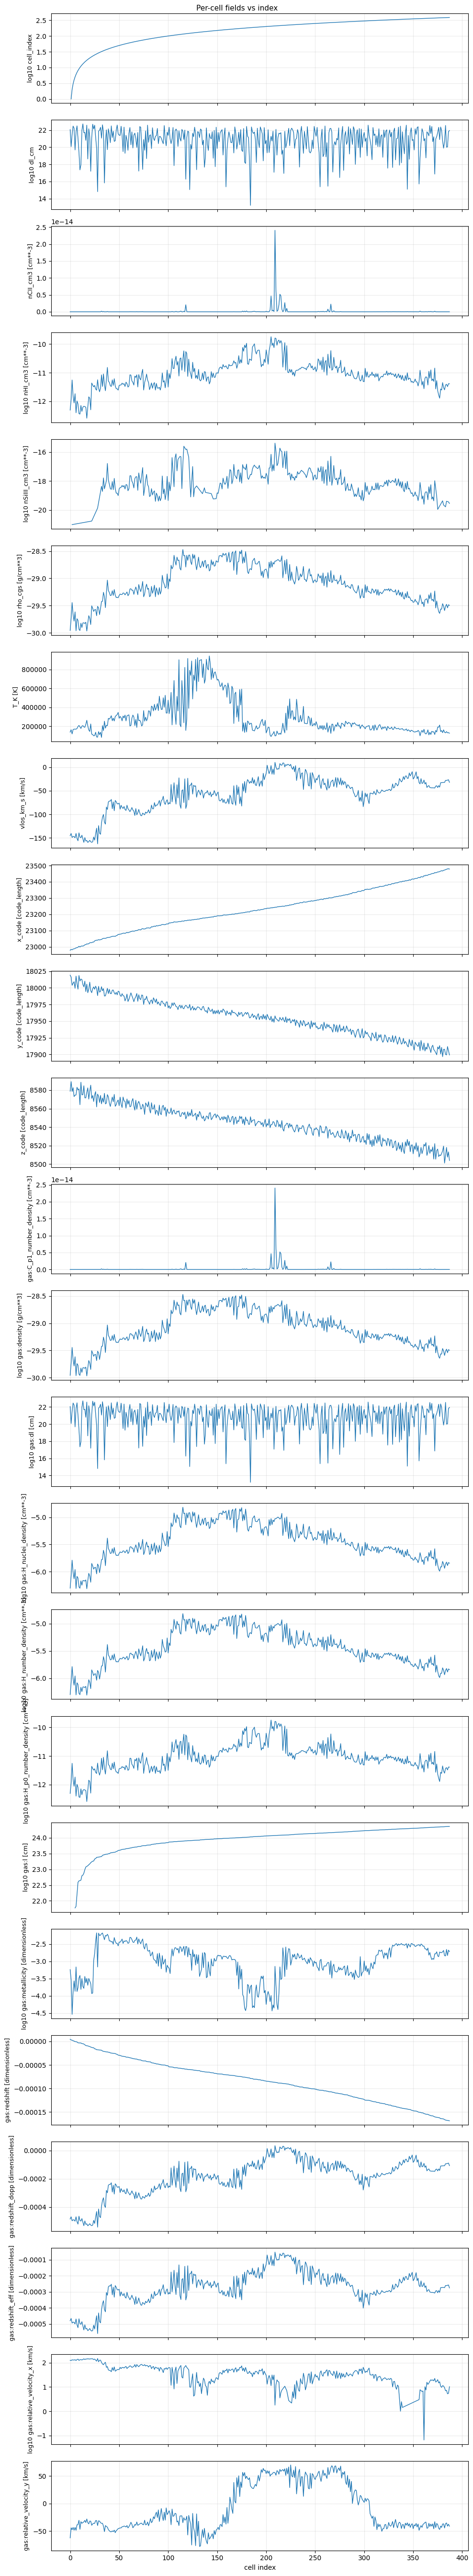

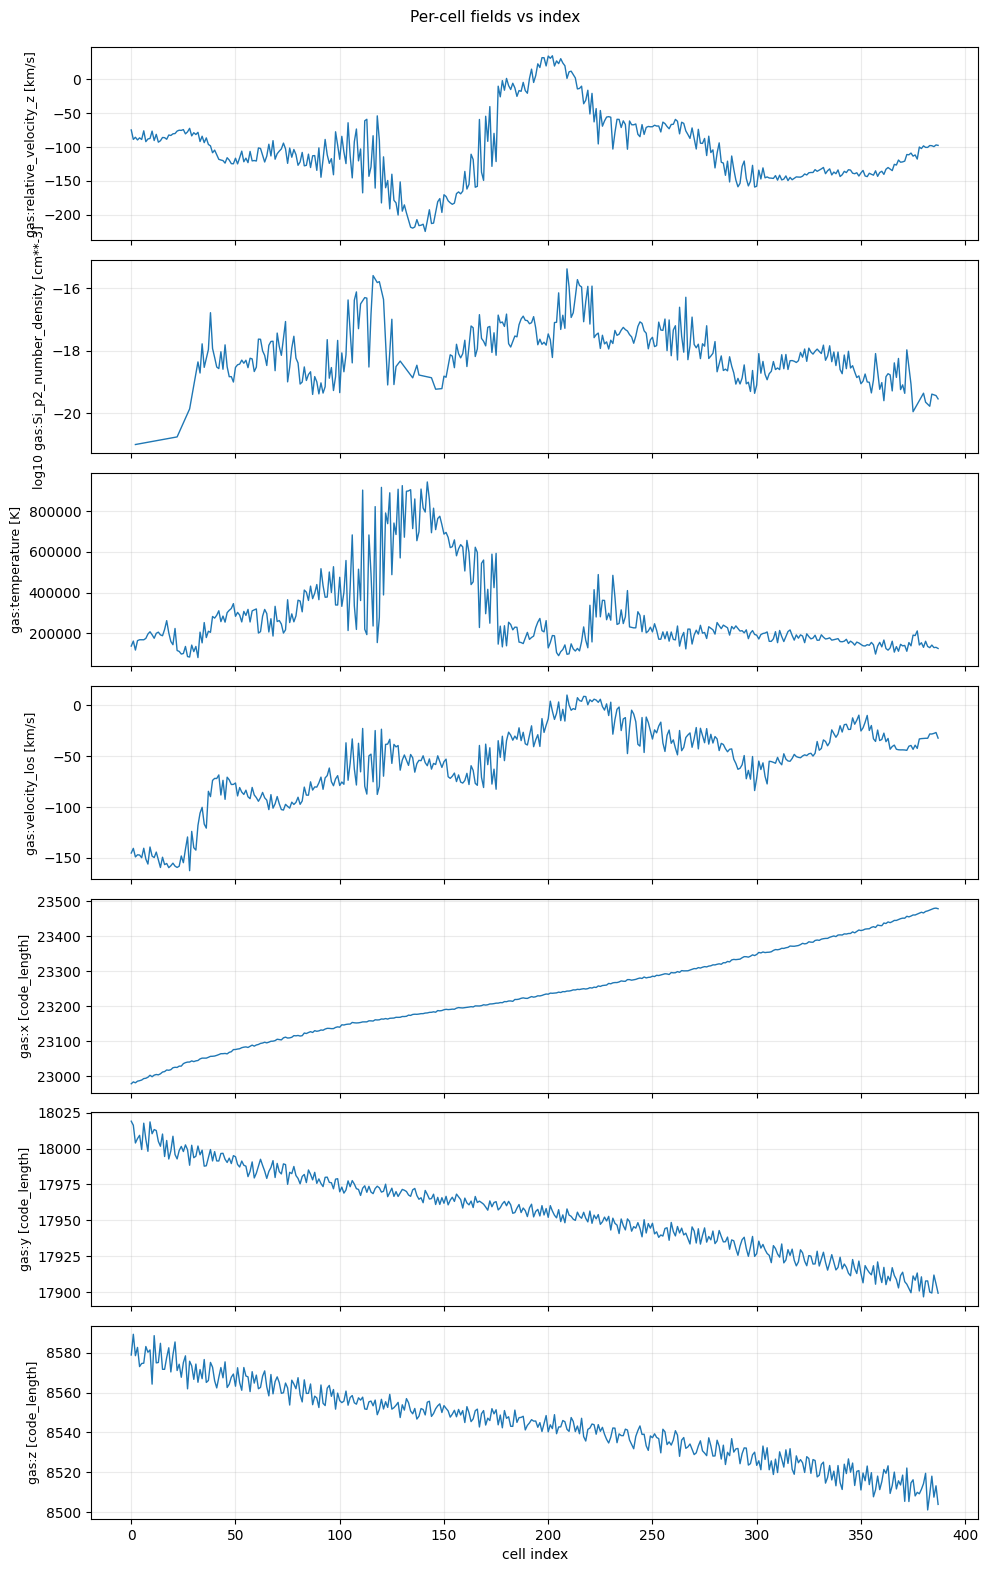


=== Plotting spectra ===


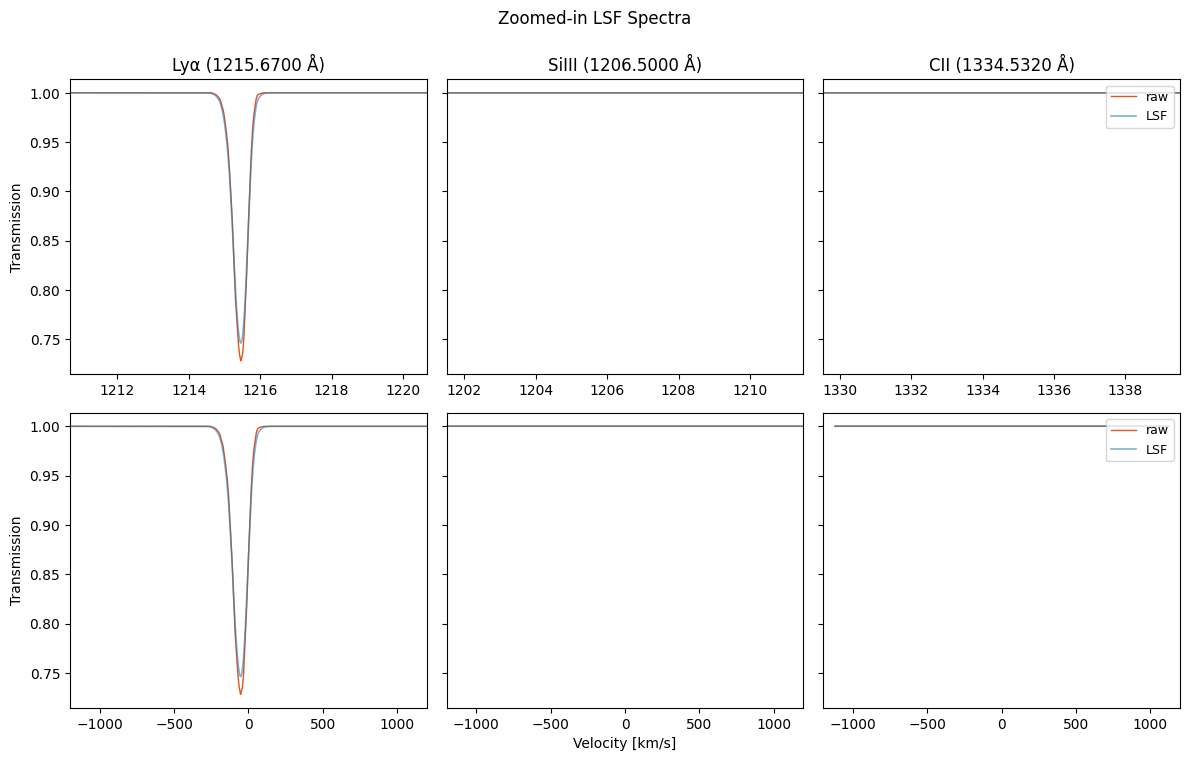

[done] zoomed-in spectra


In [55]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math, h5py
import numpy as np
import matplotlib.pyplot as plt

# === Path to your new-format bundle ===
BUNDLE = "/Users/wavefunction/github_repos/COS-GASS/tests/56372_sightlines/rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha100_bundle.h5"
#BUNDLE = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/rays/mode=noflip/alpha=2/L4Rvir_sid563732_noflip_alpha2_bundle.h5"
# Include which ftypes from /ray/fields you want to plot.
# To include everything (triplicates), set to ["gas","all","grid"].
INCLUDE_FTYPES = ["gas"]

# --------- 1) Print the full HDF5 tree (all keys everywhere) ----------
def print_h5_tree(path):
    with h5py.File(path, "r") as f:
        def visit(name, obj):
            kind = "G" if isinstance(obj, h5py.Group) else "D"
            line = f"[{kind}] /{name}"
            if isinstance(obj, h5py.Dataset):
                line += f"  shape={obj.shape} dtype={obj.dtype}"
            print(line)
            # show attrs (shorten long reprs a bit)
            if len(obj.attrs):
                for k, v in obj.attrs.items():
                    vs = repr(v)
                    if len(vs) > 200:
                        vs = vs[:200] + "...(trunc)"
                    print(f"      @attr {k} = {vs}")
        f.visititems(visit)

print("=== HDF5 TREE ===")
print_h5_tree(BUNDLE)


# --------- 2) Load /ray and gather all 1-D per-cell arrays ----------
def _is_numeric(ds: h5py.Dataset) -> bool:
    try:
        return np.issubdtype(ds.dtype, np.number)
    except Exception:
        return False

def _dataset_unit(ds: h5py.Dataset) -> str:
    u = ds.attrs.get("unit", "")
    try:
        return u.decode("utf-8") if isinstance(u, (bytes, bytearray)) else str(u)
    except Exception:
        return ""
        
def _try_len(a) -> int:
    try:
        return len(a)
    except Exception:
        return -1

def _find_ncells(ray_group: h5py.Group) -> int:
    # Prefer explicit dl_cm
    if "dl_cm" in ray_group and isinstance(ray_group["dl_cm"], h5py.Dataset):
        return int(ray_group["dl_cm"].shape[0])
    # Else any 1-D numeric dataset directly in /ray
    for k in ray_group.keys():
        obj = ray_group[k]
        if isinstance(obj, h5py.Dataset) and obj.ndim == 1 and _is_numeric(obj):
            return int(obj.shape[0])
    # Else peek into /ray/fields/*/* for first 1-D numeric
    if "fields" in ray_group:
        g_fields = ray_group["fields"]
        for ftype in g_fields.keys():
            g_ft = g_fields[ftype]
            for name in g_ft.keys():
                ds = g_ft[name]
                if isinstance(ds, h5py.Dataset) and ds.ndim == 1 and _is_numeric(ds):
                    return int(ds.shape[0])
    raise RuntimeError("Could not infer n_cells for the ray.")

def collect_series(bundle_path, include_ftypes=("gas",), include_convenience=True):
    """
    Return list of dicts with:
      {'label': str, 'data': np.ndarray, 'unit': str, 'path': str}
    Only includes 1-D numeric arrays with length == n_cells.
    """
    out = []
    with h5py.File(bundle_path, "r") as f:
        if "ray" not in f:
            raise RuntimeError("No /ray group in this file.")
        ray = f["ray"]
        n_cells = _find_ncells(ray)

        # (A) convenience datasets directly under /ray
        if include_convenience:
            for k in ray.keys():
                obj = ray[k]
                if isinstance(obj, h5py.Dataset):
                    # skip known non-per-cell things (e.g., field_list)
                    if obj.ndim != 1 or not _is_numeric(obj):
                        continue
                    if obj.shape[0] != n_cells:
                        continue
                    arr = np.array(obj, dtype=float)
                    out.append({
                        "label": k, "data": arr, "unit": _dataset_unit(obj),
                        "path": f"/ray/{k}"
                    })

        # (B) all fields under /ray/fields/<ftype>/<name>
        if "fields" in ray:
            g_fields = ray["fields"]
            # Choose which ftypes to include (avoid triple plots if desired)
            for ftype in g_fields.keys():
                if include_ftypes and ftype not in include_ftypes:
                    continue
                g_ft = g_fields[ftype]
                for name in g_ft.keys():
                    ds = g_ft[name]
                    if not isinstance(ds, h5py.Dataset):
                        continue
                    if ds.ndim != 1 or not _is_numeric(ds):
                        continue
                    if ds.shape[0] != n_cells:
                        continue
                    arr = np.array(ds, dtype=float)
                    label = f"{ftype}:{name}"
                    out.append({
                        "label": label, "data": arr, "unit": _dataset_unit(ds),
                        "path": f"/ray/fields/{ftype}/{name}"
                    })
    # Sort for nicer grouping: convenience first, then by label
    out.sort(key=lambda d: (0 if "/" not in d["label"] and ":" not in d["label"] else 1, d["label"].lower()))
    return out, n_cells


# --------- 3) Plot all series vs cell index ----------
def _logify(name, unit, y):
    """Decide whether to log-plot (base 10) and return transformed array + flag."""
    y = np.asarray(y, float)
    # Only if positive & finite values dominate
    mpos = (y > 0) & np.isfinite(y)
    frac_pos = mpos.sum() / max(y.size, 1)
    if frac_pos < 0.8:
        return y, False  # too many zeros/negatives; stay linear

    # Heuristics: densities/pathlengths/columns benefit from log
    keys = ["density", "rho", "nhi", "siii", "cii", "cm", "dl", "tau"]
    dynamic = (np.nanmax(y[mpos]) / max(np.nanmin(y[mpos]), 1e-300)) if mpos.any() else 1.0
    if dynamic > 50 or any(k in name.lower() for k in keys) or any(k in unit.lower() for k in keys if isinstance(unit, str)):
        y2 = np.full_like(y, np.nan, dtype=float)
        y2[mpos] = np.log10(y[mpos])
        return y2, True
    return y, False

def plot_all_series(series_list, title="", page_size=24):
    """
    Plot every time series vs cell index. If there are lots, make multiple figures.
    """
    if not series_list:
        print("[WARN] No per-cell arrays found to plot.")
        return

    # Split into chunks for readability
    for i0 in range(0, len(series_list), page_size):
        chunk = series_list[i0:i0+page_size]
        n = len(chunk)
        fig_h = max(2.25*n, 6.0)
        fig, axes = plt.subplots(n, 1, figsize=(10, fig_h), sharex=True)
        if n == 1:
            axes = [axes]
        for ax, entry in zip(axes, chunk):
            y = entry["data"]
            yplot, islog = _logify(entry["label"], entry["unit"], y)
            m = np.isfinite(yplot)
            x = np.arange(y.size)
            ax.plot(x[m], yplot[m], lw=1.0)
            ylabel = entry["label"]
            if entry["unit"]:
                ylabel += f" [{entry['unit']}]"
            if islog:
                ylabel = "log10 " + ylabel
            ax.set_ylabel(ylabel, fontsize=9)
            ax.grid(alpha=0.25)
        axes[-1].set_xlabel("cell index")
        fig.suptitle(title if title else os.path.basename(BUNDLE), fontsize=11, y=0.995)
        fig.tight_layout()
        plt.show()
        
def plot_spectra(bundle_path):
    """
    Plot both the raw and zoomed-in LSF spectra
    """
    
    zooms = {
    "Lyα": 1215.67,
    "SiIII": 1206.500000,
    "CII": 1334.532000,
    }
        
    # ===========================
    # plot zoomed-in around Lyα = 1215.67 Å, SiIII = 1206.5 Å and CII = 1334.5 Å
    # in a single subplot for all three
    
    # 2 row x 3 col (row 1 - wavelength, row 2 - velocity space and columns are for 3 lines)
    fig, axes = plt.subplots(2, 3, figsize=(12, 7.6), sharey='row')
    with h5py.File(bundle_path, "r") as f:
        if "spectrum" not in f:
            raise RuntimeError("No /spectrum group in this file.")
        spec = f["spectrum"]
        if "lsf" not in spec:
            raise RuntimeError("No /spectrum/lsf group in this file.")
        lsf = spec["lsf"]
        if "raw" not in spec:
            raise RuntimeError("No /spectrum/raw group in this file.")
        raw = spec["raw"]
        if "lambda_A" not in raw or "flux" not in raw:
            raise RuntimeError("No /spectrum/raw/lambda_A or /spectrum/raw/flux dataset in this file.")
        raw_lam = np.array(raw["lambda_A"][:], float)
        raw_flux = np.array(raw["flux"][:], float)
        
        if "lambda_A" not in lsf or "flux" not in lsf:
            raise RuntimeError("No /spectrum/lsf/lambda_A or /spectrum/lsf/flux dataset in this file.")

        lam = np.array(lsf["lambda_A"][:], float)
        flux = np.array(lsf["flux"][:], float)


        for i, (line, center) in enumerate(zooms.items()):
            ax1 = axes[0, i]
            ax2 = axes[1, i]
            # wavelength space
            m_zoom = (lam > center - 5) & (lam < center + 5)
            m_raw = (raw_lam > center - 5) & (raw_lam < center + 5)
            ax1.plot(raw_lam[m_raw], raw_flux[m_raw], lw=1.0, color="#de4107", alpha=0.9, label="raw")
            ax1.plot(lam[m_zoom], flux[m_zoom], lw=1.2, color="#2980b9", alpha=0.6, label="LSF")
            ax1.set_xlim(center - 5, center + 5)
            # ax1.set_ylim(-0.05, 1.05)
            ax1.set_title(f"{line} ({center:.4f} Å)")
            if i == 0:
                ax1.set_ylabel("Transmission")
            if i == 2:
                ax1.legend(loc="upper right", fontsize=9)
            # velocity space
            c = 299792.458  # speed of light in km/s
            v_zoom = c * (lam[m_zoom] - center) / center
            v_raw = c * (raw_lam[m_raw] - center) / center
            ax2.plot(v_raw, raw_flux[m_raw], lw=1.0, color="#de4107", alpha=0.9, label="raw")
            ax2.plot(v_zoom, flux[m_zoom], lw=1.2, color="#2980b9", alpha=0.6, label="LSF")
            ax2.set_xlim(-1200, 1200)
            # ax2.set_ylim(-0.05, 1.05)
            if i == 0:
                ax2.set_ylabel("Transmission")
            if i == 1:
                ax2.set_xlabel("Velocity [km/s]")
            if i == 2:
                ax2.legend(loc="upper right", fontsize=9)   
    fig.suptitle("Zoomed-in LSF Spectra", fontsize=12, y=0.995)
    fig.tight_layout()
    plt.show()
    print("[done] zoomed-in spectra")
  


# ===========================
# Run the inspection & plots
# ===========================
series, n_cells = collect_series(BUNDLE, include_ftypes=INCLUDE_FTYPES, include_convenience=True)
print(f"\nFound {len(series)} 1-D per-cell arrays (n_cells={n_cells}). "
      f"(ftypes included: {', '.join(INCLUDE_FTYPES) if INCLUDE_FTYPES else 'ALL'})")

# Optional: print a short inventory
for s in series:
    print(f" - {s['path']}  (unit='{s['unit']}', N={s['data'].size})")


print("\n=== Plotting all series ===")  
plot_all_series(series, title="Per-cell fields vs index", page_size=24)
print("\n=== Plotting spectra ===")
plot_spectra(BUNDLE)


### Analyzing the combined ray file 

In [59]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Compare two runs (e.g., L3Rvir vs L4Rvir) using their combined HDF5 files.

Reads:
  RUN1_ROOT/combined/all_rays_<RUN1_LABEL>.h5
  RUN2_ROOT/combined/all_rays_<RUN2_LABEL>.h5

Outputs:
  analysis_compare_sid<SID>_snap<SNAP>_<RUN1>_vs_<RUN2>/
    augmented_<RUN>.csv       (derived from combined file)
    merged_pairs.csv          (merge on mode+alpha_int)
    figs/
      hist_logN_diff_*.png
      hist_sumdl_ratio.png
      scatter_logNdiff_vs_alpha_*.png
      scatter_sumdl_ratio_vs_alpha.png
      cdf_logN_by_run_*.png
      spectra_overlays/*.png
    report_compare.pdf
"""

import os, json, h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

SID  = 563732
SNAP = 99

OUTPUT_BASE = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"

RUN1_LABEL = "L3Rvir"
RUN2_LABEL = "L4Rvir"

RUN1_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN1_LABEL}")
RUN2_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN2_LABEL}")
RUN1_COMB  = os.path.join(RUN1_ROOT, "combined", f"all_rays_{RUN1_LABEL}.h5")
RUN2_COMB  = os.path.join(RUN2_ROOT, "combined", f"all_rays_{RUN2_LABEL}.h5")

AN_DIR     = os.path.join(OUTPUT_BASE, f"analysis_compare_sid{SID}_snap{SNAP}_{RUN1_LABEL}_vs_{RUN2_LABEL}")
FIG_DIR    = os.path.join(AN_DIR, "figs")
SPEC_DIR   = os.path.join(FIG_DIR, "spectra_overlays")
REPORT_PDF = os.path.join(AN_DIR, "report_compare.pdf")

mpl.rcParams.update({
    "savefig.dpi": 200, "figure.dpi": 130, "font.size": 11,
    "axes.grid": True, "grid.alpha": 0.25, "axes.linewidth": 1.0,
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.minor.visible": True, "ytick.minor.visible": True,
})

COL_RUN = {RUN1_LABEL: "#1f77b4", RUN2_LABEL: "#d62728"}

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _log10_pos(x):
    x = np.asarray(x, float)
    m = (x > 0) & np.isfinite(x)
    y = np.full_like(x, np.nan, dtype=float)
    y[m] = np.log10(x[m])
    return y

def _try_attr(grp, key, default=np.nan):
    v = grp.attrs.get(key, default)
    if isinstance(v, (bytes, bytearray)):
        try: v = v.decode("utf-8", "ignore")
        except Exception: pass
    return v

def _iter_ray_groups(f):
    root = f.get("rays")
    if root is None: return
    for mode_key, gmode in root.items():
        if not mode_key.startswith("mode="): continue
        mode = mode_key.split("=",1)[1]
        for alpha_key, galpha in gmode.items():
            if not alpha_key.startswith("alpha="): continue
            for ray_key, graypack in galpha.items():
                if not ray_key.startswith("ray_"): continue
                yield f"rays/{mode_key}/{alpha_key}/{ray_key}", graypack

def load_combined_to_df(combined_h5, run_label):
    rows = []
    with h5py.File(combined_h5, "r") as f:
        for gpath, pack in _iter_ray_groups(f):
            meta = pack.get("meta")
            columns = pack.get("columns")
            rayg = pack.get("ray")
            specg = pack.get("spectrum")

            mode = gpath.split("/")[1].split("=",1)[1]
            alpha_tag = gpath.split("/")[2].split("=",1)[1]

            row = {
                "run_label": run_label,
                "group_path": gpath,
                "mode": mode,
                "alpha_tag": alpha_tag,
            }
            for k in ["SubhaloID","alpha_deg","rho_kpc","phi_deg","inc_deg","Rvir_kpc","total_len_Rvir"]:
                row[k] = float(_try_attr(meta, k, np.nan)) if meta is not None else np.nan

            if columns is not None:
                for k in columns.attrs.keys():
                    row[k] = _try_attr(columns, k)

            # prefer ray/dl
            n_cells = np.nan; sum_dl_kpc = np.nan; dl_kind = None
            if rayg is not None:
                if "dl_cm" in rayg:
                    dl = np.array(rayg["dl_cm"][:], float)
                    n_cells = int(dl.size)
                    sum_dl_kpc = float(dl.sum() / 3.08567758e21)
                dl_kind = _try_attr(rayg, "dl_kind", dl_kind)
            if np.isnan(sum_dl_kpc) and "_sum_dl_kpc" in row:
                sum_dl_kpc = float(row["_sum_dl_kpc"])
            if (dl_kind is None) and ("_dl_kind" in row):
                dl_kind = row["_dl_kind"]

            row["n_cells"]   = n_cells
            row["sum_dl_kpc"] = sum_dl_kpc
            row["dl_kind"]    = dl_kind
            row["has_spectrum"] = int(specg is not None and "lsf" in specg)
            rows.append(row)

    df = pd.DataFrame(rows)
    if "alpha_deg" in df.columns:
        df["alpha_int"] = np.floor(pd.to_numeric(df["alpha_deg"], errors="coerce") + 0.5).astype("Int64")
    else:
        df["alpha_int"] = pd.Series([pd.NA]*len(df), dtype="Int64")

    for src, dst in [("N_HI_cm2","logN_HI"), ("N_CII_cm2","logN_CII"), ("N_SiIII_cm2","logN_SiIII")]:
        if src in df.columns:
            df[dst] = _log10_pos(pd.to_numeric(df[src], errors="coerce").values)
        else:
            df[dst] = np.nan

    if {"rho_kpc","Rvir_kpc"}.issubset(df.columns):
        rv = pd.to_numeric(df["Rvir_kpc"], errors="coerce").replace(0, np.nan)
        df["rho_over_Rvir"] = pd.to_numeric(df["rho_kpc"], errors="coerce") / rv
    else:
        df["rho_over_Rvir"] = np.nan

    df["mode"] = df["mode"].astype(str).str.lower()
    return df

def load_runs():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR); ensure_dir(SPEC_DIR)
    if not os.path.isfile(RUN1_COMB): raise FileNotFoundError(RUN1_COMB)
    if not os.path.isfile(RUN2_COMB): raise FileNotFoundError(RUN2_COMB)
    df1 = load_combined_to_df(RUN1_COMB, RUN1_LABEL)
    df2 = load_combined_to_df(RUN2_COMB, RUN2_LABEL)
    df1.to_csv(os.path.join(AN_DIR, f"augmented_{RUN1_LABEL}.csv"), index=False)
    df2.to_csv(os.path.join(AN_DIR, f"augmented_{RUN2_LABEL}.csv"), index=False)
    print(f"[OK] Augmented CSVs saved in {AN_DIR}")
    return df1, df2

def merge_pairs(df1, df2):
    on = ["mode","alpha_int"]
    m = pd.merge(df1, df2, on=on, suffixes=(f"_{RUN1_LABEL}", f"_{RUN2_LABEL}"))
    m.to_csv(os.path.join(AN_DIR, "merged_pairs.csv"), index=False)
    print(f"[OK] merged pairs: {len(m)}")
    return m

def plot_hist_diffs(m, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(d[np.isfinite(d)], bins=30, color="#7f8c8d", alpha=0.85)
        ax.axvline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel(f"{label}  ( {RUN2_LABEL} − {RUN1_LABEL} )"); ax.set_ylabel("Count")
        ax.set_title(f"Histogram of Δ{label}")
        out = os.path.join(FIG_DIR, f"hist_logN_diff_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def plot_hist_sumdl_ratio(m, pdf=None):
    s1 = f"sum_dl_kpc_{RUN1_LABEL}"; s2 = f"sum_dl_kpc_{RUN2_LABEL}"
    if s1 not in m.columns or s2 not in m.columns: return
    r = m[s2] / m[s1]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(r[np.isfinite(r)], bins=30, color="#16a085", alpha=0.85)
    ax.axvline(4.0/3.0, ls="--", lw=1.2, color="k", alpha=0.6, label="4/3")
    ax.set_xlabel(f"Σdl ratio  ({RUN2_LABEL}/{RUN1_LABEL})"); ax.set_ylabel("Count"); ax.legend()
    ax.set_title("Histogram of path-length ratio")
    out = os.path.join(FIG_DIR, "hist_sumdl_ratio.png")
    fig.tight_layout(); fig.savefig(out); 
    if pdf: pdf.savefig(fig)
    plt.close(fig); print("[saved]", out)

def plot_scatter_vs_alpha(m, pdf=None):
    akey = "alpha_deg_"+RUN1_LABEL
    if akey not in m.columns: return
    a = m[akey].values
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        mm = np.isfinite(a) & np.isfinite(d)
        ax.scatter(a[mm], d[mm], s=14, color="#2c3e50", alpha=0.7)
        ax.axhline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"{label}: {RUN2_LABEL} − {RUN1_LABEL}")
        ax.set_title(f"Δ{label} vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_logNdiff_vs_alpha_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

    s1 = f"sum_dl_kpc_{RUN1_LABEL}"; s2 = f"sum_dl_kpc_{RUN2_LABEL}"
    if s1 in m.columns and s2 in m.columns:
        r = m[s2] / m[s1]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        mm = np.isfinite(a) & np.isfinite(r)
        ax.scatter(a[mm], r[mm], s=14, color="#8e44ad", alpha=0.7)
        ax.axhline(4.0/3.0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"Σdl ratio ({RUN2_LABEL}/{RUN1_LABEL})")
        ax.set_title("Path-length ratio vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_sumdl_ratio_vs_alpha.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def cdf_by_run(df1, df2, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df1.columns or key not in df2.columns: continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        for df, lab, col in [(df1, RUN1_LABEL, COL_RUN[RUN1_LABEL]), (df2, RUN2_LABEL, COL_RUN[RUN2_LABEL])]:
            x = np.sort(df[key].values[np.isfinite(df[key].values)])
            if x.size == 0: continue
            y = np.linspace(0, 1, x.size, endpoint=True)
            ax.plot(x, y, lw=2.0, label=lab, color=col)
        ax.set_xlabel(label); ax.set_ylabel("CDF"); ax.legend()
        ax.set_title(f"CDF of {label}")
        out = os.path.join(FIG_DIR, f"cdf_{key}_by_run.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def overlay_spectra(m, max_pairs_per_mode=12, pdf=None):
    """
    Overlay LSF spectra for a subset of paired rays (same alpha,mode),
    reading directly from the combined HDF5 files using group_path columns.
    """
    ensure_dir(SPEC_DIR)
    pages = 0
    with h5py.File(RUN1_COMB, "r") as f1, h5py.File(RUN2_COMB, "r") as f2:
        for mode in sorted(m["mode"].unique()):
            mm = m["mode"] == mode
            mm_df = m.loc[mm].sort_values("alpha_int")
            if mm_df.empty: continue
            idx = np.linspace(0, len(mm_df)-1, min(max_pairs_per_mode, len(mm_df)), dtype=int)
            for j in idx:
                row = mm_df.iloc[j]
                gp1 = row.get(f"group_path_{RUN1_LABEL}", "")
                gp2 = row.get(f"group_path_{RUN2_LABEL}", "")
                try:
                    l1 = np.array(f1[gp1+"/spectrum/lsf/lambda_A"][:], float)
                    F1 = np.array(f1[gp1+"/spectrum/lsf/flux"][:], float)
                    l2 = np.array(f2[gp2+"/spectrum/lsf/lambda_A"][:], float)
                    F2 = np.array(f2[gp2+"/spectrum/lsf/flux"][:], float)
                except Exception:
                    continue

                fig, ax = plt.subplots(figsize=(9.6, 3.8))
                ax.plot(l1, F1, lw=1.2, label=RUN1_LABEL, color=COL_RUN[RUN1_LABEL], alpha=0.9)
                ax.plot(l2, F2, lw=1.2, label=RUN2_LABEL, color=COL_RUN[RUN2_LABEL], alpha=0.9)
                ax.set_ylim(-0.05, 1.05)
                ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
                ax.set_title(f"Spectra overlay | mode={mode}, alpha={int(row['alpha_int'])}")
                ax.legend(); ax.grid(alpha=0.25)
                out = os.path.join(SPEC_DIR, f"spectra_overlay_mode={mode}_alpha={int(row['alpha_int'])}.png")
                fig.tight_layout(); fig.savefig(out, dpi=180)
                if pdf: pdf.savefig(fig)
                plt.close(fig); print("[saved]", out)
                pages += 1
    return pages

def main():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR)
    df1, df2 = load_runs()

    # Merge on (mode, alpha_int) and retain group_path columns for spectrum pulls
    keep_cols = ["mode","alpha_int","alpha_deg","group_path","sum_dl_kpc","logN_HI","logN_CII","logN_SiIII"]
    m = pd.merge(
        df1[keep_cols].rename(columns={c:f"{c}_{RUN1_LABEL}" for c in keep_cols if c not in ["mode","alpha_int"]} | {"mode":"mode","alpha_int":"alpha_int"}),
        df2[keep_cols].rename(columns={c:f"{c}_{RUN2_LABEL}" for c in keep_cols if c not in ["mode","alpha_int"]} | {"mode":"mode","alpha_int":"alpha_int"}),
        on=["mode","alpha_int"]
    )
    m.to_csv(os.path.join(AN_DIR, "merged_pairs.csv"), index=False)
    print(f"[OK] merged pairs: {len(m)}")

    with PdfPages(REPORT_PDF) as pdf:
        plot_hist_diffs(m, pdf=pdf)
        plot_hist_sumdl_ratio(m, pdf=pdf)
        plot_scatter_vs_alpha(m, pdf=pdf)
        cdf_by_run(df1, df2, pdf=pdf)
        pages = overlay_spectra(m, max_pairs_per_mode=12, pdf=pdf)
        print(f"[INFO] spectra overlay pages: {pages}")

    print(f"\n[OK] Compare report: {REPORT_PDF}")
    print(f"[OK] Figures in: {FIG_DIR}")
    print(f"[OK] Merged pairs table: {os.path.join(AN_DIR,'merged_pairs.csv')}")

if __name__ == "__main__":
    main()

[OK] Augmented CSVs saved in ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir
[OK] merged pairs: 720
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_HI.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_CII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_SiIII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_sumdl_ratio.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/scatter_logNdiff_vs_alpha_logN_HI.png
[saved] ../..